In [2]:
%%capture
!pip install datasets transformers

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from datasets import load_dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

import torch.optim as optim

# hugging face imports
from datasets import load_dataset
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
from tqdm import tqdm

import pandas as pd
import sys
import warnings

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
assert device=='cuda', "you need to change runtime type to GPU"

## Our Model

In [5]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        self.context_window_size = context_window_size

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        scores = self.query(x) @ self.key(x).transpose(2,1) / torch.sqrt(torch.tensor([self.head_size], device = 'cuda:0')) # (B,T,T)

        # apply causual mask
        masked_scores = scores.masked_fill(self.tril == 0, float('-inf'))
        attn_weights = F.softmax(masked_scores, dim=-1)
        try:
          result = attn_weights @ self.value(x)
        except:
          breakpoint()
        return attn_weights @ self.value(x)

In [6]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, vocab_size, context_window_size, num_heads, head_size, embed_size=384):
        super().__init__()
        # TODO, your code below
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.heads = nn.ModuleList(
            [Head(head_size, context_window_size, embed_size) for _ in range(num_heads)]
        )

    def forward(self, x):
        # TODO, your code below

        result = torch.zeros(x.shape[0], x.shape[1], self.embed_size, device='cuda:0')
        for i in range(self.num_heads):
          h = self.heads[i]
          result = result +  h(x)

        return result

In [7]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

In [8]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size)
        self.mh_attention = MultiHeadAttention(vocab_size, context_window_size, num_heads, embed_size // num_heads, embed_size)

    def forward(self, x):
        x = x + self.mh_attention(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

In [9]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.context_window_size = context_window_size
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.n_layers = n_layers
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device='cuda:0')) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        atten_outputs = self.blocks(x) # (B,T,D)
        normalized_output = self.ln_f(atten_outputs) # (B,T,D)

        logits = self.lm_head(normalized_output) # (B,T,V)


        loss = None
        if targets is not None:
          targets = targets.reshape(-1)
          logits_reshaped = logits.reshape(-1, self.vocab_size)
          loss = F.cross_entropy(logits_reshaped, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        new_token_id = token_ids


        for t in range(max_new_tokens):

          T, B = new_token_id.shape

          model = TransformerBlock(self.vocab_size,
                             T,
                             embed_size=self.embed_size,
                             num_heads=self.num_heads)
          model_gpu = model.to('cuda:0')

          tok_emb = self.token_embedding_table(new_token_id) # (B, T, D)
          pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
          try:
            x = tok_emb + pos_emb
          except:
            breakpoint()

          atten_outputs = model_gpu(x) # (B,T,D)
          #atten_outputs = model(x) # (B,T,D)
          normalized_output = self.ln_f(atten_outputs) # (B,T,D)

          logits = self.lm_head(normalized_output) # (B,T,V)

          # extract the logits for last time step
          cur_logits = logits[:, -1, :]
          new_tokens_values= torch.argmax(cur_logits, dim=1)

          new_token_id = torch.cat((new_token_id, new_tokens_values.reshape(-1,1)), dim = 1)

        return new_token_id

## Teacher Model

In [10]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("codeparrot/codeparrot-small")
teacher_model = AutoModelWithLMHead.from_pretrained("codeparrot/codeparrot-small").to(device)
teacher_model.eval()  # Set the teacher model to evaluation mode

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/497k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/277k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/840k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1595: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


config.json:   0%|          | 0.00/903 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/457M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(32768, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=32768, bias=False)
)

In [11]:
#tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
#teacher_model = GPT2LMHeadModel.from_pretrained("distilgpt2").to(device)
#teacher_model.eval()  # Set the teacher model to evaluation mode

## Dataset

In [12]:
vocab_size = tokenizer.vocab_size
embed_size = 768

In [13]:
# hyperparams and helper functions
SMALL_ITERS = 1000
LARGE_ITERS = 2000
context_window_size = 256
chunk_size = 512 # BERT can only take max input size 512 characters

def chunk_string(string, size):
    """
    Splits a string into chunks of a specified size.

    :param string: The string to be chunked.
    :param size: The desired chunk size.
    :return: A list of string chunks.
    """
    return [string[i:i+size] for i in range(0, len(string), size)]

In [14]:
dataset = load_dataset("code_search_net", "python")
train_data = dataset['train']['func_code_tokens'][:50000]
val_data = dataset['validation']['func_code_tokens'][:10000]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/412178 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/22176 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/23107 [00:00<?, ? examples/s]

In [15]:
train_id_nested = [tokenizer.convert_tokens_to_ids(data) for data in train_data]
train_id_flattened  = [x for xs in train_id_nested for x in xs]
train_id = torch.tensor(train_id_flattened)

val_id_nested = [tokenizer.convert_tokens_to_ids(data) for data in val_data]
val_id_flattened  = [x for xs in val_id_nested for x in xs]
val_id = torch.tensor(val_id_flattened)

In [16]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_id if split == 'train' else val_id
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

## Knowledge Distillation

In [21]:
# create a PyTorch optimizer

eval_interval = 200
eval_iters = 200
vocab_size = tokenizer.vocab_size

context_window_size = 256
embed_size = 384

learning_rate = 1e-4

loss_dic = {}


for alpha in [0.1, 0.3, 0.5, 0.7]:
  for temperature in [0.8, 1.0, 2.0, 3.0]:

    print(f'alpha is {alpha}')
    print(f'temperature is {temperature}')

    stu_loss_list = []
    teaching_loss_list = []

    stu_key = f'stu_loss_list_apha_{alpha}_temp_{temperature}'
    tea_key = f'teaching_loss_list_apha_{alpha}_temp_{temperature}'

    trans = TransformerLM(vocab_size, context_window_size)
    tlm = trans.to(device)

    optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate)
    loss_fct = nn.KLDivLoss(reduction='batchmean')

    for it in tqdm(range(SMALL_ITERS)):

        # every once in a while evaluate the loss on train and val sets
        if it % eval_interval == 0 or it == SMALL_ITERS - 1:
            print(f"iteration {it}")
            losses = estimate_loss(tlm, eval_iters, context_window_size, device)
            print(
                f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
            )

        # sample a batch of data
        xb, yb = get_batch("train", context_window_size, device)

        # compute logits and loss from student
        student_logits, student_loss = tlm(xb, yb)
        stu_loss_list.append(student_loss.detach().item())

        # compute logits and loss from teacher
        with torch.no_grad():
            teacher_logits = teacher_model(xb).logits

        # soften probabilites and compute distillation loss
        try:
          teaching_loss = temperature **2 * loss_fct(
              F.log_softmax(student_logits / temperature, dim=-1),
              F.softmax(teacher_logits / temperature, dim=-1))
        except:
          breakpoint()

        # weighted student loss
        teaching_loss = alpha * student_loss + (1. - alpha) * teaching_loss

        print(f'student loss is {student_loss}, teaching loss is {teaching_loss}')
        teaching_loss_list.append(teaching_loss.detach().item())
        optimizer.zero_grad(set_to_none=True)
        teaching_loss.backward()
        optimizer.step()

    loss_dic[stu_key] = stu_loss_list
    loss_dic[tea_key] = teaching_loss_list

    tlm.to('cpu')
    torch.cuda.empty_cache()

alpha is 0.1
temperature is 0.8


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.3838, val loss 10.3781


  0%|          | 1/1000 [00:28<7:53:36, 28.44s/it]

student loss is 10.393465042114258, teaching loss is 1196.705078125


  0%|          | 2/1000 [00:28<3:18:18, 11.92s/it]

student loss is 10.281512260437012, teaching loss is 1064.099853515625


  0%|          | 3/1000 [00:29<1:50:41,  6.66s/it]

student loss is 10.184992790222168, teaching loss is 984.7189331054688


  0%|          | 4/1000 [00:29<1:09:36,  4.19s/it]

student loss is 10.110170364379883, teaching loss is 970.1819458007812


  0%|          | 5/1000 [00:30<46:52,  2.83s/it]  

student loss is 10.051370620727539, teaching loss is 931.8474731445312


  1%|          | 6/1000 [00:30<33:10,  2.00s/it]

student loss is 9.986797332763672, teaching loss is 921.600830078125


  1%|          | 7/1000 [00:30<24:30,  1.48s/it]

student loss is 9.935219764709473, teaching loss is 913.2914428710938


  1%|          | 8/1000 [00:31<18:47,  1.14s/it]

student loss is 9.889986038208008, teaching loss is 868.0536499023438


  1%|          | 9/1000 [00:31<15:00,  1.10it/s]

student loss is 9.859773635864258, teaching loss is 887.0946044921875


  1%|          | 10/1000 [00:32<12:27,  1.33it/s]

student loss is 9.789306640625, teaching loss is 890.1624145507812


  1%|          | 11/1000 [00:32<10:41,  1.54it/s]

student loss is 9.712037086486816, teaching loss is 873.9175415039062


  1%|          | 12/1000 [00:32<09:28,  1.74it/s]

student loss is 9.647644996643066, teaching loss is 867.89990234375


  1%|▏         | 13/1000 [00:33<08:36,  1.91it/s]

student loss is 9.572522163391113, teaching loss is 868.9235229492188


  1%|▏         | 14/1000 [00:33<08:00,  2.05it/s]

student loss is 9.518516540527344, teaching loss is 824.890380859375


  2%|▏         | 15/1000 [00:34<07:35,  2.16it/s]

student loss is 9.465739250183105, teaching loss is 822.0601196289062


  2%|▏         | 16/1000 [00:34<07:18,  2.24it/s]

student loss is 9.406949996948242, teaching loss is 807.2032470703125


  2%|▏         | 17/1000 [00:34<07:06,  2.30it/s]

student loss is 9.383440971374512, teaching loss is 812.173583984375


  2%|▏         | 18/1000 [00:35<06:57,  2.35it/s]

student loss is 9.3118314743042, teaching loss is 789.1158447265625


  2%|▏         | 19/1000 [00:35<06:51,  2.38it/s]

student loss is 9.283419609069824, teaching loss is 761.8267211914062


  2%|▏         | 20/1000 [00:36<06:47,  2.41it/s]

student loss is 9.19932746887207, teaching loss is 781.3057861328125


  2%|▏         | 21/1000 [00:36<06:44,  2.42it/s]

student loss is 9.175520896911621, teaching loss is 780.3134155273438


  2%|▏         | 22/1000 [00:36<06:41,  2.43it/s]

student loss is 9.123619079589844, teaching loss is 771.5288696289062


  2%|▏         | 23/1000 [00:37<06:39,  2.45it/s]

student loss is 9.06303882598877, teaching loss is 728.7333374023438


  2%|▏         | 24/1000 [00:37<06:38,  2.45it/s]

student loss is 9.002827644348145, teaching loss is 725.281982421875


  2%|▎         | 25/1000 [00:38<06:37,  2.45it/s]

student loss is 8.944317817687988, teaching loss is 703.4843139648438


  3%|▎         | 26/1000 [00:38<06:37,  2.45it/s]

student loss is 8.904204368591309, teaching loss is 709.7285766601562


  3%|▎         | 27/1000 [00:38<06:39,  2.44it/s]

student loss is 8.859113693237305, teaching loss is 721.9215698242188


  3%|▎         | 28/1000 [00:39<06:37,  2.45it/s]

student loss is 8.78323745727539, teaching loss is 692.4539794921875


  3%|▎         | 29/1000 [00:39<06:36,  2.45it/s]

student loss is 8.736104011535645, teaching loss is 684.8532104492188


  3%|▎         | 30/1000 [00:40<06:35,  2.45it/s]

student loss is 8.699911117553711, teaching loss is 671.8435668945312


  3%|▎         | 31/1000 [00:40<06:34,  2.46it/s]

student loss is 8.616493225097656, teaching loss is 677.7410278320312


  3%|▎         | 32/1000 [00:40<06:33,  2.46it/s]

student loss is 8.591682434082031, teaching loss is 655.7362670898438


  3%|▎         | 33/1000 [00:41<06:34,  2.45it/s]

student loss is 8.583971977233887, teaching loss is 657.2153930664062


  3%|▎         | 34/1000 [00:41<06:32,  2.46it/s]

student loss is 8.507315635681152, teaching loss is 635.931396484375


  4%|▎         | 35/1000 [00:42<06:31,  2.46it/s]

student loss is 8.478288650512695, teaching loss is 626.8131103515625


  4%|▎         | 36/1000 [00:42<06:32,  2.46it/s]

student loss is 8.406134605407715, teaching loss is 621.7684326171875


  4%|▎         | 37/1000 [00:43<06:32,  2.46it/s]

student loss is 8.37277603149414, teaching loss is 608.472900390625


  4%|▍         | 38/1000 [00:43<06:31,  2.46it/s]

student loss is 8.34121322631836, teaching loss is 615.3204345703125


  4%|▍         | 39/1000 [00:43<06:29,  2.46it/s]

student loss is 8.28065299987793, teaching loss is 595.0541381835938


  4%|▍         | 40/1000 [00:44<06:30,  2.46it/s]

student loss is 8.243569374084473, teaching loss is 567.2384033203125


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.200424194335938, teaching loss is 580.510009765625


  4%|▍         | 42/1000 [00:45<06:30,  2.45it/s]

student loss is 8.16462230682373, teaching loss is 553.8107299804688


  4%|▍         | 43/1000 [00:45<06:29,  2.46it/s]

student loss is 8.129199028015137, teaching loss is 580.7836303710938


  4%|▍         | 44/1000 [00:45<06:27,  2.47it/s]

student loss is 8.088839530944824, teaching loss is 553.2233276367188


  4%|▍         | 45/1000 [00:46<06:27,  2.46it/s]

student loss is 8.081616401672363, teaching loss is 512.4686889648438


  5%|▍         | 46/1000 [00:46<06:27,  2.46it/s]

student loss is 8.061534881591797, teaching loss is 519.0960083007812


  5%|▍         | 47/1000 [00:47<06:27,  2.46it/s]

student loss is 8.056870460510254, teaching loss is 500.617919921875


  5%|▍         | 48/1000 [00:47<06:27,  2.46it/s]

student loss is 8.027681350708008, teaching loss is 493.96929931640625


  5%|▍         | 49/1000 [00:47<06:26,  2.46it/s]

student loss is 8.01097583770752, teaching loss is 488.5553283691406


  5%|▌         | 50/1000 [00:48<06:25,  2.46it/s]

student loss is 7.971191883087158, teaching loss is 484.868896484375


  5%|▌         | 51/1000 [00:48<06:24,  2.47it/s]

student loss is 7.932320594787598, teaching loss is 488.8877868652344


  5%|▌         | 52/1000 [00:49<06:24,  2.47it/s]

student loss is 7.927140712738037, teaching loss is 469.8459777832031


  5%|▌         | 53/1000 [00:49<06:25,  2.45it/s]

student loss is 7.912028789520264, teaching loss is 473.06463623046875


  5%|▌         | 54/1000 [00:49<06:24,  2.46it/s]

student loss is 7.883525371551514, teaching loss is 455.6252746582031


  6%|▌         | 55/1000 [00:50<06:24,  2.46it/s]

student loss is 7.808543682098389, teaching loss is 455.2757568359375


  6%|▌         | 56/1000 [00:50<06:23,  2.46it/s]

student loss is 7.791264057159424, teaching loss is 428.2706298828125


  6%|▌         | 57/1000 [00:51<06:23,  2.46it/s]

student loss is 7.731704235076904, teaching loss is 415.1865539550781


  6%|▌         | 58/1000 [00:51<06:23,  2.45it/s]

student loss is 7.7047834396362305, teaching loss is 450.890625


  6%|▌         | 59/1000 [00:51<06:23,  2.45it/s]

student loss is 7.7471208572387695, teaching loss is 414.8689270019531


  6%|▌         | 60/1000 [00:52<06:22,  2.46it/s]

student loss is 7.603434085845947, teaching loss is 432.1580505371094


  6%|▌         | 61/1000 [00:52<06:21,  2.46it/s]

student loss is 7.59694766998291, teaching loss is 416.2733154296875


  6%|▌         | 62/1000 [00:53<06:21,  2.46it/s]

student loss is 7.568994045257568, teaching loss is 430.5386962890625


  6%|▋         | 63/1000 [00:53<06:22,  2.45it/s]

student loss is 7.520637035369873, teaching loss is 418.9884338378906


  6%|▋         | 64/1000 [00:54<06:21,  2.46it/s]

student loss is 7.5670037269592285, teaching loss is 405.60626220703125


  6%|▋         | 65/1000 [00:54<06:20,  2.46it/s]

student loss is 7.490512371063232, teaching loss is 406.2374572753906


  7%|▋         | 66/1000 [00:54<06:19,  2.46it/s]

student loss is 7.446502208709717, teaching loss is 391.7646789550781


  7%|▋         | 67/1000 [00:55<06:19,  2.46it/s]

student loss is 7.427319049835205, teaching loss is 393.68829345703125


  7%|▋         | 68/1000 [00:55<06:18,  2.46it/s]

student loss is 7.402831077575684, teaching loss is 391.1460876464844


  7%|▋         | 69/1000 [00:56<06:17,  2.47it/s]

student loss is 7.440615177154541, teaching loss is 381.9538269042969


  7%|▋         | 70/1000 [00:56<06:17,  2.47it/s]

student loss is 7.414266109466553, teaching loss is 394.472900390625


  7%|▋         | 71/1000 [00:56<06:17,  2.46it/s]

student loss is 7.425827980041504, teaching loss is 360.09661865234375


  7%|▋         | 72/1000 [00:57<06:17,  2.46it/s]

student loss is 7.286750793457031, teaching loss is 389.76934814453125


  7%|▋         | 73/1000 [00:57<06:16,  2.46it/s]

student loss is 7.283962249755859, teaching loss is 366.3180847167969


  7%|▋         | 74/1000 [00:58<06:16,  2.46it/s]

student loss is 7.304655075073242, teaching loss is 363.2568054199219


  8%|▊         | 75/1000 [00:58<06:14,  2.47it/s]

student loss is 7.238484859466553, teaching loss is 381.6014404296875


  8%|▊         | 76/1000 [00:58<06:15,  2.46it/s]

student loss is 7.209598064422607, teaching loss is 366.22772216796875


  8%|▊         | 77/1000 [00:59<06:15,  2.46it/s]

student loss is 7.305500507354736, teaching loss is 340.873046875


  8%|▊         | 78/1000 [00:59<06:14,  2.46it/s]

student loss is 7.218179702758789, teaching loss is 362.7750549316406


  8%|▊         | 79/1000 [01:00<06:15,  2.45it/s]

student loss is 7.174058437347412, teaching loss is 352.6697998046875


  8%|▊         | 80/1000 [01:00<06:13,  2.46it/s]

student loss is 7.130126953125, teaching loss is 335.0677795410156


  8%|▊         | 81/1000 [01:00<06:13,  2.46it/s]

student loss is 7.116607189178467, teaching loss is 352.0142822265625


  8%|▊         | 82/1000 [01:01<06:13,  2.46it/s]

student loss is 7.1663947105407715, teaching loss is 321.4024658203125


  8%|▊         | 83/1000 [01:01<06:13,  2.45it/s]

student loss is 7.150419235229492, teaching loss is 329.1094665527344


  8%|▊         | 84/1000 [01:02<06:11,  2.46it/s]

student loss is 7.095203876495361, teaching loss is 339.7318420410156


  8%|▊         | 85/1000 [01:02<06:13,  2.45it/s]

student loss is 7.066432476043701, teaching loss is 339.72100830078125


  9%|▊         | 86/1000 [01:02<06:11,  2.46it/s]

student loss is 7.051990985870361, teaching loss is 348.97747802734375


  9%|▊         | 87/1000 [01:03<06:10,  2.46it/s]

student loss is 7.048691749572754, teaching loss is 334.7181396484375


  9%|▉         | 88/1000 [01:03<06:10,  2.46it/s]

student loss is 7.070446491241455, teaching loss is 334.39483642578125


  9%|▉         | 89/1000 [01:04<06:10,  2.46it/s]

student loss is 7.048353672027588, teaching loss is 325.3199768066406


  9%|▉         | 90/1000 [01:04<06:10,  2.45it/s]

student loss is 7.0350871086120605, teaching loss is 309.7976989746094


  9%|▉         | 91/1000 [01:04<06:09,  2.46it/s]

student loss is 7.035282611846924, teaching loss is 338.63946533203125


  9%|▉         | 92/1000 [01:05<06:08,  2.46it/s]

student loss is 6.988472938537598, teaching loss is 323.2034912109375


  9%|▉         | 93/1000 [01:05<06:08,  2.46it/s]

student loss is 6.963506698608398, teaching loss is 370.0866394042969


  9%|▉         | 94/1000 [01:06<06:08,  2.46it/s]

student loss is 6.910479545593262, teaching loss is 342.4283447265625


 10%|▉         | 95/1000 [01:06<06:08,  2.46it/s]

student loss is 6.9021196365356445, teaching loss is 328.47381591796875


 10%|▉         | 96/1000 [01:07<06:07,  2.46it/s]

student loss is 6.89772891998291, teaching loss is 329.9129638671875


 10%|▉         | 97/1000 [01:07<06:07,  2.46it/s]

student loss is 6.9426798820495605, teaching loss is 313.125244140625


 10%|▉         | 98/1000 [01:07<06:06,  2.46it/s]

student loss is 6.970816135406494, teaching loss is 310.6242980957031


 10%|▉         | 99/1000 [01:08<06:05,  2.46it/s]

student loss is 6.901331424713135, teaching loss is 351.90118408203125


 10%|█         | 100/1000 [01:08<06:06,  2.46it/s]

student loss is 6.889649391174316, teaching loss is 304.6922607421875


 10%|█         | 101/1000 [01:09<06:05,  2.46it/s]

student loss is 6.873885631561279, teaching loss is 315.36297607421875


 10%|█         | 102/1000 [01:09<06:07,  2.44it/s]

student loss is 6.875106334686279, teaching loss is 333.6815185546875


 10%|█         | 103/1000 [01:09<06:05,  2.45it/s]

student loss is 6.897000789642334, teaching loss is 330.49066162109375


 10%|█         | 104/1000 [01:10<06:05,  2.45it/s]

student loss is 6.930880546569824, teaching loss is 287.8547058105469


 10%|█         | 105/1000 [01:10<06:06,  2.44it/s]

student loss is 6.824625492095947, teaching loss is 314.9335632324219


 11%|█         | 106/1000 [01:11<06:05,  2.45it/s]

student loss is 6.810856342315674, teaching loss is 316.3768005371094


 11%|█         | 107/1000 [01:11<06:04,  2.45it/s]

student loss is 6.819859027862549, teaching loss is 297.4371032714844


 11%|█         | 108/1000 [01:11<06:04,  2.45it/s]

student loss is 6.802047252655029, teaching loss is 317.07257080078125


 11%|█         | 109/1000 [01:12<06:03,  2.45it/s]

student loss is 6.8127760887146, teaching loss is 310.89227294921875


 11%|█         | 110/1000 [01:12<06:02,  2.45it/s]

student loss is 6.819277286529541, teaching loss is 301.3681640625


 11%|█         | 111/1000 [01:13<06:01,  2.46it/s]

student loss is 6.855278491973877, teaching loss is 306.2013854980469


 11%|█         | 112/1000 [01:13<06:02,  2.45it/s]

student loss is 6.8562541007995605, teaching loss is 295.63818359375


 11%|█▏        | 113/1000 [01:13<06:03,  2.44it/s]

student loss is 6.7247796058654785, teaching loss is 293.12548828125


 11%|█▏        | 114/1000 [01:14<06:01,  2.45it/s]

student loss is 6.766473770141602, teaching loss is 285.8553466796875


 12%|█▏        | 115/1000 [01:14<06:00,  2.45it/s]

student loss is 6.7523698806762695, teaching loss is 294.04815673828125


 12%|█▏        | 116/1000 [01:15<06:00,  2.45it/s]

student loss is 6.778858661651611, teaching loss is 277.0648498535156


 12%|█▏        | 117/1000 [01:15<06:00,  2.45it/s]

student loss is 6.818516254425049, teaching loss is 284.7546691894531


 12%|█▏        | 118/1000 [01:15<06:00,  2.45it/s]

student loss is 6.806694030761719, teaching loss is 280.82647705078125


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 6.797151565551758, teaching loss is 277.1069030761719


 12%|█▏        | 120/1000 [01:16<05:59,  2.45it/s]

student loss is 6.703256607055664, teaching loss is 298.5685729980469


 12%|█▏        | 121/1000 [01:17<05:58,  2.45it/s]

student loss is 6.8243088722229, teaching loss is 274.873046875


 12%|█▏        | 122/1000 [01:17<05:57,  2.46it/s]

student loss is 6.730226516723633, teaching loss is 277.04388427734375


 12%|█▏        | 123/1000 [01:18<05:57,  2.45it/s]

student loss is 6.746464729309082, teaching loss is 277.24993896484375


 12%|█▏        | 124/1000 [01:18<05:55,  2.46it/s]

student loss is 6.7920823097229, teaching loss is 282.7070617675781


 12%|█▎        | 125/1000 [01:18<05:56,  2.46it/s]

student loss is 6.766985893249512, teaching loss is 279.1925048828125


 13%|█▎        | 126/1000 [01:19<05:55,  2.46it/s]

student loss is 6.692588806152344, teaching loss is 286.64312744140625


 13%|█▎        | 127/1000 [01:19<05:55,  2.45it/s]

student loss is 6.7557477951049805, teaching loss is 295.9944763183594


 13%|█▎        | 128/1000 [01:20<05:55,  2.45it/s]

student loss is 6.758896827697754, teaching loss is 258.53643798828125


 13%|█▎        | 129/1000 [01:20<05:54,  2.46it/s]

student loss is 6.655758857727051, teaching loss is 272.2877502441406


 13%|█▎        | 130/1000 [01:20<05:54,  2.45it/s]

student loss is 6.6956377029418945, teaching loss is 267.2018737792969


 13%|█▎        | 131/1000 [01:21<05:53,  2.46it/s]

student loss is 6.64591646194458, teaching loss is 283.6837158203125


 13%|█▎        | 132/1000 [01:21<05:53,  2.46it/s]

student loss is 6.7125043869018555, teaching loss is 274.93511962890625


 13%|█▎        | 133/1000 [01:22<05:53,  2.45it/s]

student loss is 6.768453121185303, teaching loss is 241.53030395507812


 13%|█▎        | 134/1000 [01:22<05:53,  2.45it/s]

student loss is 6.696844577789307, teaching loss is 270.68707275390625


 14%|█▎        | 135/1000 [01:22<05:53,  2.45it/s]

student loss is 6.685451030731201, teaching loss is 265.3143310546875


 14%|█▎        | 136/1000 [01:23<05:53,  2.45it/s]

student loss is 6.652466297149658, teaching loss is 255.72515869140625


 14%|█▎        | 137/1000 [01:23<05:52,  2.45it/s]

student loss is 6.6789116859436035, teaching loss is 267.41790771484375


 14%|█▍        | 138/1000 [01:24<05:52,  2.44it/s]

student loss is 6.66917610168457, teaching loss is 247.0714569091797


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.599145889282227, teaching loss is 278.71044921875


 14%|█▍        | 140/1000 [01:24<05:49,  2.46it/s]

student loss is 6.623156547546387, teaching loss is 277.7186279296875


 14%|█▍        | 141/1000 [01:25<05:49,  2.45it/s]

student loss is 6.635767459869385, teaching loss is 271.4412536621094


 14%|█▍        | 142/1000 [01:25<05:49,  2.45it/s]

student loss is 6.695275783538818, teaching loss is 247.8052978515625


 14%|█▍        | 143/1000 [01:26<05:49,  2.45it/s]

student loss is 6.640916347503662, teaching loss is 272.0690612792969


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.759276390075684, teaching loss is 251.73887634277344


 14%|█▍        | 145/1000 [01:26<05:48,  2.46it/s]

student loss is 6.6170501708984375, teaching loss is 255.57928466796875


 15%|█▍        | 146/1000 [01:27<05:48,  2.45it/s]

student loss is 6.636174201965332, teaching loss is 257.8206481933594


 15%|█▍        | 147/1000 [01:27<05:47,  2.45it/s]

student loss is 6.626161575317383, teaching loss is 242.10516357421875


 15%|█▍        | 148/1000 [01:28<05:47,  2.45it/s]

student loss is 6.63012170791626, teaching loss is 249.5609893798828


 15%|█▍        | 149/1000 [01:28<05:48,  2.44it/s]

student loss is 6.616628170013428, teaching loss is 248.07505798339844


 15%|█▌        | 150/1000 [01:29<05:47,  2.45it/s]

student loss is 6.605653285980225, teaching loss is 255.6669464111328


 15%|█▌        | 151/1000 [01:29<05:46,  2.45it/s]

student loss is 6.596534729003906, teaching loss is 245.867431640625


 15%|█▌        | 152/1000 [01:29<05:45,  2.45it/s]

student loss is 6.611391067504883, teaching loss is 257.00537109375


 15%|█▌        | 153/1000 [01:30<05:45,  2.45it/s]

student loss is 6.665430068969727, teaching loss is 236.90008544921875


 15%|█▌        | 154/1000 [01:30<05:44,  2.45it/s]

student loss is 6.682964324951172, teaching loss is 237.39373779296875


 16%|█▌        | 155/1000 [01:31<05:44,  2.45it/s]

student loss is 6.649508476257324, teaching loss is 248.3004913330078


 16%|█▌        | 156/1000 [01:31<05:44,  2.45it/s]

student loss is 6.606986999511719, teaching loss is 258.63702392578125


 16%|█▌        | 157/1000 [01:31<05:43,  2.46it/s]

student loss is 6.548181533813477, teaching loss is 233.25314331054688


 16%|█▌        | 158/1000 [01:32<05:43,  2.45it/s]

student loss is 6.5853142738342285, teaching loss is 264.1282653808594


 16%|█▌        | 159/1000 [01:32<05:43,  2.45it/s]

student loss is 6.60429048538208, teaching loss is 237.77890014648438


 16%|█▌        | 160/1000 [01:33<05:42,  2.45it/s]

student loss is 6.668513774871826, teaching loss is 234.11061096191406


 16%|█▌        | 161/1000 [01:33<05:42,  2.45it/s]

student loss is 6.5737504959106445, teaching loss is 225.45008850097656


 16%|█▌        | 162/1000 [01:33<05:41,  2.46it/s]

student loss is 6.559942722320557, teaching loss is 266.1669616699219


 16%|█▋        | 163/1000 [01:34<05:41,  2.45it/s]

student loss is 6.508349418640137, teaching loss is 254.64393615722656


 16%|█▋        | 164/1000 [01:34<05:39,  2.46it/s]

student loss is 6.589320182800293, teaching loss is 249.6201171875


 16%|█▋        | 165/1000 [01:35<05:40,  2.45it/s]

student loss is 6.593234062194824, teaching loss is 241.96958923339844


 17%|█▋        | 166/1000 [01:35<05:40,  2.45it/s]

student loss is 6.566769599914551, teaching loss is 238.85572814941406


 17%|█▋        | 167/1000 [01:35<05:39,  2.46it/s]

student loss is 6.504260540008545, teaching loss is 237.27798461914062


 17%|█▋        | 168/1000 [01:36<05:41,  2.44it/s]

student loss is 6.56634521484375, teaching loss is 235.14041137695312


 17%|█▋        | 169/1000 [01:36<05:38,  2.45it/s]

student loss is 6.609137535095215, teaching loss is 235.9237060546875


 17%|█▋        | 170/1000 [01:37<05:38,  2.45it/s]

student loss is 6.5265021324157715, teaching loss is 236.75413513183594


 17%|█▋        | 171/1000 [01:37<05:38,  2.45it/s]

student loss is 6.607994079589844, teaching loss is 229.0404052734375


 17%|█▋        | 172/1000 [01:38<05:36,  2.46it/s]

student loss is 6.56771183013916, teaching loss is 240.6240692138672


 17%|█▋        | 173/1000 [01:38<05:37,  2.45it/s]

student loss is 6.67372989654541, teaching loss is 240.5598602294922


 17%|█▋        | 174/1000 [01:38<05:36,  2.45it/s]

student loss is 6.539045810699463, teaching loss is 233.0108642578125


 18%|█▊        | 175/1000 [01:39<05:36,  2.45it/s]

student loss is 6.465856075286865, teaching loss is 250.44140625


 18%|█▊        | 176/1000 [01:39<05:35,  2.45it/s]

student loss is 6.493814945220947, teaching loss is 222.66909790039062


 18%|█▊        | 177/1000 [01:40<05:35,  2.45it/s]

student loss is 6.523353576660156, teaching loss is 234.54978942871094


 18%|█▊        | 178/1000 [01:40<05:37,  2.44it/s]

student loss is 6.5199103355407715, teaching loss is 244.35011291503906


 18%|█▊        | 179/1000 [01:40<05:35,  2.45it/s]

student loss is 6.509513854980469, teaching loss is 251.06735229492188


 18%|█▊        | 180/1000 [01:41<05:34,  2.45it/s]

student loss is 6.571887493133545, teaching loss is 221.83026123046875


 18%|█▊        | 181/1000 [01:41<05:34,  2.45it/s]

student loss is 6.4515204429626465, teaching loss is 241.06141662597656


 18%|█▊        | 182/1000 [01:42<05:33,  2.45it/s]

student loss is 6.5172810554504395, teaching loss is 224.10569763183594


 18%|█▊        | 183/1000 [01:42<05:33,  2.45it/s]

student loss is 6.5337958335876465, teaching loss is 220.0877227783203


 18%|█▊        | 184/1000 [01:42<05:32,  2.45it/s]

student loss is 6.624733924865723, teaching loss is 226.8348388671875


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.54276704788208, teaching loss is 218.6543731689453


 19%|█▊        | 186/1000 [01:43<05:31,  2.46it/s]

student loss is 6.513343811035156, teaching loss is 255.28033447265625


 19%|█▊        | 187/1000 [01:44<05:31,  2.45it/s]

student loss is 6.536748886108398, teaching loss is 229.8852081298828


 19%|█▉        | 188/1000 [01:44<05:30,  2.45it/s]

student loss is 6.556108474731445, teaching loss is 216.72352600097656


 19%|█▉        | 189/1000 [01:44<05:30,  2.46it/s]

student loss is 6.484823703765869, teaching loss is 220.06625366210938


 19%|█▉        | 190/1000 [01:45<05:29,  2.46it/s]

student loss is 6.360589981079102, teaching loss is 254.2924041748047


 19%|█▉        | 191/1000 [01:45<05:29,  2.46it/s]

student loss is 6.467702388763428, teaching loss is 222.58892822265625


 19%|█▉        | 192/1000 [01:46<05:29,  2.45it/s]

student loss is 6.489564418792725, teaching loss is 227.1707763671875


 19%|█▉        | 193/1000 [01:46<05:29,  2.45it/s]

student loss is 6.4163312911987305, teaching loss is 225.36611938476562


 19%|█▉        | 194/1000 [01:46<05:29,  2.45it/s]

student loss is 6.447914123535156, teaching loss is 223.25582885742188


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 6.463625431060791, teaching loss is 222.91671752929688


 20%|█▉        | 196/1000 [01:47<05:28,  2.45it/s]

student loss is 6.446892261505127, teaching loss is 220.0847930908203


 20%|█▉        | 197/1000 [01:48<05:28,  2.45it/s]

student loss is 6.476161956787109, teaching loss is 217.67251586914062


 20%|█▉        | 198/1000 [01:48<05:27,  2.45it/s]

student loss is 6.488616466522217, teaching loss is 219.5288848876953


 20%|█▉        | 199/1000 [01:49<05:27,  2.45it/s]

student loss is 6.530673027038574, teaching loss is 213.1538848876953


 20%|██        | 200/1000 [01:49<05:26,  2.45it/s]

student loss is 6.478517532348633, teaching loss is 207.16746520996094
iteration 200
step 200: train loss 6.4567, val loss 6.4944


 20%|██        | 201/1000 [02:18<1:59:04,  8.94s/it]

student loss is 6.475610256195068, teaching loss is 209.4803924560547


 20%|██        | 202/1000 [02:18<1:24:52,  6.38s/it]

student loss is 6.401070594787598, teaching loss is 208.220947265625


 20%|██        | 203/1000 [02:19<1:00:58,  4.59s/it]

student loss is 6.450756072998047, teaching loss is 223.3460235595703


 20%|██        | 204/1000 [02:19<44:15,  3.34s/it]  

student loss is 6.38140344619751, teaching loss is 232.74169921875


 20%|██        | 205/1000 [02:19<32:34,  2.46s/it]

student loss is 6.550133228302002, teaching loss is 208.0863800048828


 21%|██        | 206/1000 [02:20<24:23,  1.84s/it]

student loss is 6.472571849822998, teaching loss is 197.595458984375


 21%|██        | 207/1000 [02:20<18:40,  1.41s/it]

student loss is 6.438080310821533, teaching loss is 207.72581481933594


 21%|██        | 208/1000 [02:21<14:41,  1.11s/it]

student loss is 6.412880897521973, teaching loss is 235.57972717285156


 21%|██        | 209/1000 [02:21<11:52,  1.11it/s]

student loss is 6.4065046310424805, teaching loss is 213.77467346191406


 21%|██        | 210/1000 [02:21<09:54,  1.33it/s]

student loss is 6.485081672668457, teaching loss is 205.52792358398438


 21%|██        | 211/1000 [02:22<08:32,  1.54it/s]

student loss is 6.384069919586182, teaching loss is 226.3295440673828


 21%|██        | 212/1000 [02:22<07:34,  1.73it/s]

student loss is 6.52024507522583, teaching loss is 205.16273498535156


 21%|██▏       | 213/1000 [02:23<06:54,  1.90it/s]

student loss is 6.553344249725342, teaching loss is 195.3985595703125


 21%|██▏       | 214/1000 [02:23<06:26,  2.03it/s]

student loss is 6.40126895904541, teaching loss is 230.04339599609375


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 6.572984218597412, teaching loss is 199.43772888183594


 22%|██▏       | 216/1000 [02:24<05:52,  2.22it/s]

student loss is 6.3808817863464355, teaching loss is 227.3154296875


 22%|██▏       | 217/1000 [02:24<05:41,  2.29it/s]

student loss is 6.35245943069458, teaching loss is 215.83998107910156


 22%|██▏       | 218/1000 [02:25<05:34,  2.34it/s]

student loss is 6.429771900177002, teaching loss is 206.7790985107422


 22%|██▏       | 219/1000 [02:25<05:29,  2.37it/s]

student loss is 6.456727981567383, teaching loss is 205.29029846191406


 22%|██▏       | 220/1000 [02:26<05:25,  2.40it/s]

student loss is 6.511562347412109, teaching loss is 205.05078125


 22%|██▏       | 221/1000 [02:26<05:23,  2.41it/s]

student loss is 6.324110507965088, teaching loss is 207.50440979003906


 22%|██▏       | 222/1000 [02:26<05:20,  2.43it/s]

student loss is 6.437605381011963, teaching loss is 208.1600799560547


 22%|██▏       | 223/1000 [02:27<05:19,  2.43it/s]

student loss is 6.454707622528076, teaching loss is 206.60609436035156


 22%|██▏       | 224/1000 [02:27<05:17,  2.44it/s]

student loss is 6.407304286956787, teaching loss is 219.16175842285156


 22%|██▎       | 225/1000 [02:28<05:17,  2.44it/s]

student loss is 6.460134983062744, teaching loss is 214.44386291503906


 23%|██▎       | 226/1000 [02:28<05:16,  2.44it/s]

student loss is 6.450324058532715, teaching loss is 203.38685607910156


 23%|██▎       | 227/1000 [02:28<05:15,  2.45it/s]

student loss is 6.416330337524414, teaching loss is 207.74818420410156


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 6.390590190887451, teaching loss is 211.66790771484375


 23%|██▎       | 229/1000 [02:29<05:14,  2.45it/s]

student loss is 6.452252388000488, teaching loss is 194.58236694335938


 23%|██▎       | 230/1000 [02:30<05:14,  2.45it/s]

student loss is 6.433257102966309, teaching loss is 195.37750244140625


 23%|██▎       | 231/1000 [02:30<05:13,  2.45it/s]

student loss is 6.394402503967285, teaching loss is 209.80038452148438


 23%|██▎       | 232/1000 [02:30<05:12,  2.45it/s]

student loss is 6.398685932159424, teaching loss is 195.3837890625


 23%|██▎       | 233/1000 [02:31<05:14,  2.44it/s]

student loss is 6.3508429527282715, teaching loss is 208.46844482421875


 23%|██▎       | 234/1000 [02:31<05:12,  2.45it/s]

student loss is 6.450210094451904, teaching loss is 211.20223999023438


 24%|██▎       | 235/1000 [02:32<05:12,  2.44it/s]

student loss is 6.530624866485596, teaching loss is 207.76576232910156


 24%|██▎       | 236/1000 [02:32<05:13,  2.44it/s]

student loss is 6.348668098449707, teaching loss is 205.7565460205078


 24%|██▎       | 237/1000 [02:32<05:12,  2.44it/s]

student loss is 6.437828063964844, teaching loss is 205.04608154296875


 24%|██▍       | 238/1000 [02:33<05:11,  2.45it/s]

student loss is 6.434186935424805, teaching loss is 197.1365966796875


 24%|██▍       | 239/1000 [02:33<05:10,  2.45it/s]

student loss is 6.525242328643799, teaching loss is 193.00706481933594


 24%|██▍       | 240/1000 [02:34<05:09,  2.45it/s]

student loss is 6.5085649490356445, teaching loss is 196.5487060546875


 24%|██▍       | 241/1000 [02:34<05:09,  2.45it/s]

student loss is 6.478108882904053, teaching loss is 195.16360473632812


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.302124500274658, teaching loss is 215.3304443359375


 24%|██▍       | 243/1000 [02:35<05:09,  2.45it/s]

student loss is 6.403049468994141, teaching loss is 202.55328369140625


 24%|██▍       | 244/1000 [02:35<05:09,  2.44it/s]

student loss is 6.422948837280273, teaching loss is 208.17869567871094


 24%|██▍       | 245/1000 [02:36<05:08,  2.44it/s]

student loss is 6.463972568511963, teaching loss is 200.08340454101562


 25%|██▍       | 246/1000 [02:36<05:08,  2.44it/s]

student loss is 6.325519561767578, teaching loss is 215.88101196289062


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 6.365931034088135, teaching loss is 186.22909545898438


 25%|██▍       | 248/1000 [02:37<05:07,  2.44it/s]

student loss is 6.333472728729248, teaching loss is 218.71006774902344


 25%|██▍       | 249/1000 [02:37<05:07,  2.44it/s]

student loss is 6.2997727394104, teaching loss is 204.89141845703125


 25%|██▌       | 250/1000 [02:38<05:06,  2.45it/s]

student loss is 6.430019855499268, teaching loss is 195.60205078125


 25%|██▌       | 251/1000 [02:38<05:06,  2.45it/s]

student loss is 6.570803165435791, teaching loss is 183.37338256835938


 25%|██▌       | 252/1000 [02:39<05:06,  2.44it/s]

student loss is 6.45002555847168, teaching loss is 190.4239501953125


 25%|██▌       | 253/1000 [02:39<05:06,  2.44it/s]

student loss is 6.365615367889404, teaching loss is 195.90512084960938


 25%|██▌       | 254/1000 [02:39<05:04,  2.45it/s]

student loss is 6.393322467803955, teaching loss is 203.3033905029297


 26%|██▌       | 255/1000 [02:40<05:04,  2.44it/s]

student loss is 6.396020412445068, teaching loss is 203.8287353515625


 26%|██▌       | 256/1000 [02:40<05:05,  2.44it/s]

student loss is 6.34710168838501, teaching loss is 196.44923400878906


 26%|██▌       | 257/1000 [02:41<05:04,  2.44it/s]

student loss is 6.3441972732543945, teaching loss is 199.60992431640625


 26%|██▌       | 258/1000 [02:41<05:03,  2.45it/s]

student loss is 6.400533676147461, teaching loss is 187.5393524169922


 26%|██▌       | 259/1000 [02:41<05:02,  2.45it/s]

student loss is 6.34740686416626, teaching loss is 187.45657348632812


 26%|██▌       | 260/1000 [02:42<05:02,  2.45it/s]

student loss is 6.455445766448975, teaching loss is 186.04393005371094


 26%|██▌       | 261/1000 [02:42<05:01,  2.45it/s]

student loss is 6.473424434661865, teaching loss is 200.6023712158203


 26%|██▌       | 262/1000 [02:43<05:01,  2.45it/s]

student loss is 6.398923397064209, teaching loss is 182.75746154785156


 26%|██▋       | 263/1000 [02:43<05:03,  2.43it/s]

student loss is 6.267593860626221, teaching loss is 221.18809509277344


 26%|██▋       | 264/1000 [02:44<05:01,  2.44it/s]

student loss is 6.358372688293457, teaching loss is 189.0190887451172


 26%|██▋       | 265/1000 [02:44<05:01,  2.43it/s]

student loss is 6.361277103424072, teaching loss is 202.2789306640625


 27%|██▋       | 266/1000 [02:44<05:00,  2.44it/s]

student loss is 6.314831733703613, teaching loss is 199.65158081054688


 27%|██▋       | 267/1000 [02:45<04:59,  2.44it/s]

student loss is 6.408328056335449, teaching loss is 207.1342315673828


 27%|██▋       | 268/1000 [02:45<05:00,  2.44it/s]

student loss is 6.411962032318115, teaching loss is 193.15985107421875


 27%|██▋       | 269/1000 [02:46<04:59,  2.44it/s]

student loss is 6.299290180206299, teaching loss is 218.42823791503906


 27%|██▋       | 270/1000 [02:46<04:59,  2.44it/s]

student loss is 6.358040809631348, teaching loss is 197.35162353515625


 27%|██▋       | 271/1000 [02:46<04:58,  2.45it/s]

student loss is 6.318375110626221, teaching loss is 213.12896728515625


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 6.367140293121338, teaching loss is 201.853515625


 27%|██▋       | 273/1000 [02:47<04:56,  2.45it/s]

student loss is 6.370651721954346, teaching loss is 200.40834045410156


 27%|██▋       | 274/1000 [02:48<04:57,  2.44it/s]

student loss is 6.506737232208252, teaching loss is 178.39964294433594


 28%|██▊       | 275/1000 [02:48<04:56,  2.45it/s]

student loss is 6.356296062469482, teaching loss is 197.62037658691406


 28%|██▊       | 276/1000 [02:48<04:55,  2.45it/s]

student loss is 6.342679023742676, teaching loss is 190.2897491455078


 28%|██▊       | 277/1000 [02:49<04:55,  2.45it/s]

student loss is 6.336050033569336, teaching loss is 185.5556182861328


 28%|██▊       | 278/1000 [02:49<04:54,  2.45it/s]

student loss is 6.490281581878662, teaching loss is 170.10903930664062


 28%|██▊       | 279/1000 [02:50<04:54,  2.44it/s]

student loss is 6.327420234680176, teaching loss is 196.0167236328125


 28%|██▊       | 280/1000 [02:50<04:53,  2.45it/s]

student loss is 6.364978313446045, teaching loss is 207.5414276123047


 28%|██▊       | 281/1000 [02:50<04:53,  2.45it/s]

student loss is 6.3331685066223145, teaching loss is 202.2870635986328


 28%|██▊       | 282/1000 [02:51<04:52,  2.45it/s]

student loss is 6.40317964553833, teaching loss is 192.7895050048828


 28%|██▊       | 283/1000 [02:51<04:52,  2.45it/s]

student loss is 6.275020599365234, teaching loss is 198.394775390625


 28%|██▊       | 284/1000 [02:52<04:52,  2.45it/s]

student loss is 6.265571594238281, teaching loss is 199.7209930419922


 28%|██▊       | 285/1000 [02:52<04:52,  2.45it/s]

student loss is 6.226515293121338, teaching loss is 183.9434051513672


 29%|██▊       | 286/1000 [02:53<04:51,  2.45it/s]

student loss is 6.304178714752197, teaching loss is 196.33944702148438


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 6.3891921043396, teaching loss is 182.3681182861328


 29%|██▉       | 288/1000 [02:53<04:51,  2.45it/s]

student loss is 6.354966163635254, teaching loss is 188.22129821777344


 29%|██▉       | 289/1000 [02:54<04:50,  2.45it/s]

student loss is 6.249056816101074, teaching loss is 212.8821258544922


 29%|██▉       | 290/1000 [02:54<04:50,  2.44it/s]

student loss is 6.355940818786621, teaching loss is 200.9784698486328


 29%|██▉       | 291/1000 [02:55<04:50,  2.44it/s]

student loss is 6.349573135375977, teaching loss is 180.2504119873047


 29%|██▉       | 292/1000 [02:55<04:49,  2.44it/s]

student loss is 6.306326389312744, teaching loss is 189.87879943847656


 29%|██▉       | 293/1000 [02:55<04:49,  2.45it/s]

student loss is 6.421000957489014, teaching loss is 188.17425537109375


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 6.401555061340332, teaching loss is 187.35350036621094


 30%|██▉       | 295/1000 [02:56<04:47,  2.45it/s]

student loss is 6.248889923095703, teaching loss is 201.30966186523438


 30%|██▉       | 296/1000 [02:57<04:46,  2.46it/s]

student loss is 6.187281608581543, teaching loss is 204.4100799560547


 30%|██▉       | 297/1000 [02:57<04:46,  2.45it/s]

student loss is 6.341892719268799, teaching loss is 191.60350036621094


 30%|██▉       | 298/1000 [02:57<04:46,  2.45it/s]

student loss is 6.348458290100098, teaching loss is 192.5304718017578


 30%|██▉       | 299/1000 [02:58<04:45,  2.45it/s]

student loss is 6.320160388946533, teaching loss is 188.98785400390625


 30%|███       | 300/1000 [02:58<04:46,  2.45it/s]

student loss is 6.301772117614746, teaching loss is 193.45643615722656


 30%|███       | 301/1000 [02:59<04:45,  2.45it/s]

student loss is 6.335514545440674, teaching loss is 186.15379333496094


 30%|███       | 302/1000 [02:59<04:44,  2.45it/s]

student loss is 6.412926197052002, teaching loss is 172.60794067382812


 30%|███       | 303/1000 [02:59<04:44,  2.45it/s]

student loss is 6.445350646972656, teaching loss is 182.54071044921875


 30%|███       | 304/1000 [03:00<04:44,  2.44it/s]

student loss is 6.229527473449707, teaching loss is 184.4820556640625


 30%|███       | 305/1000 [03:00<04:43,  2.45it/s]

student loss is 6.2609710693359375, teaching loss is 191.0006103515625


 31%|███       | 306/1000 [03:01<04:43,  2.45it/s]

student loss is 6.392674446105957, teaching loss is 177.50900268554688


 31%|███       | 307/1000 [03:01<04:43,  2.44it/s]

student loss is 6.2869038581848145, teaching loss is 187.54701232910156


 31%|███       | 308/1000 [03:02<04:42,  2.45it/s]

student loss is 6.340258598327637, teaching loss is 190.36203002929688


 31%|███       | 309/1000 [03:02<04:42,  2.45it/s]

student loss is 6.350910186767578, teaching loss is 185.7864227294922


 31%|███       | 310/1000 [03:02<04:41,  2.45it/s]

student loss is 6.16226863861084, teaching loss is 201.52479553222656


 31%|███       | 311/1000 [03:03<04:41,  2.44it/s]

student loss is 6.275219440460205, teaching loss is 199.91183471679688


 31%|███       | 312/1000 [03:03<04:40,  2.45it/s]

student loss is 6.29823112487793, teaching loss is 175.5565185546875


 31%|███▏      | 313/1000 [03:04<04:40,  2.45it/s]

student loss is 6.406051158905029, teaching loss is 176.95816040039062


 31%|███▏      | 314/1000 [03:04<04:40,  2.44it/s]

student loss is 6.182746887207031, teaching loss is 189.15664672851562


 32%|███▏      | 315/1000 [03:04<04:39,  2.45it/s]

student loss is 6.18886661529541, teaching loss is 193.21946716308594


 32%|███▏      | 316/1000 [03:05<04:38,  2.45it/s]

student loss is 6.433831214904785, teaching loss is 172.96694946289062


 32%|███▏      | 317/1000 [03:05<04:38,  2.45it/s]

student loss is 6.304965972900391, teaching loss is 175.2834930419922


 32%|███▏      | 318/1000 [03:06<04:39,  2.44it/s]

student loss is 6.329387187957764, teaching loss is 194.21859741210938


 32%|███▏      | 319/1000 [03:06<04:38,  2.44it/s]

student loss is 6.443297863006592, teaching loss is 166.4115753173828


 32%|███▏      | 320/1000 [03:06<04:37,  2.45it/s]

student loss is 6.338664531707764, teaching loss is 171.699951171875


 32%|███▏      | 321/1000 [03:07<04:38,  2.44it/s]

student loss is 6.325342655181885, teaching loss is 175.89036560058594


 32%|███▏      | 322/1000 [03:07<04:37,  2.45it/s]

student loss is 6.331027030944824, teaching loss is 175.99668884277344


 32%|███▏      | 323/1000 [03:08<04:37,  2.44it/s]

student loss is 6.528444766998291, teaching loss is 183.7884979248047


 32%|███▏      | 324/1000 [03:08<04:36,  2.44it/s]

student loss is 6.243093490600586, teaching loss is 195.75253295898438


 32%|███▎      | 325/1000 [03:08<04:35,  2.45it/s]

student loss is 6.321207523345947, teaching loss is 179.91363525390625


 33%|███▎      | 326/1000 [03:09<04:35,  2.44it/s]

student loss is 6.364875316619873, teaching loss is 172.65408325195312


 33%|███▎      | 327/1000 [03:09<04:35,  2.44it/s]

student loss is 6.37686824798584, teaching loss is 165.99586486816406


 33%|███▎      | 328/1000 [03:10<04:35,  2.44it/s]

student loss is 6.287564754486084, teaching loss is 168.03219604492188


 33%|███▎      | 329/1000 [03:10<04:34,  2.45it/s]

student loss is 6.373857021331787, teaching loss is 163.6213836669922


 33%|███▎      | 330/1000 [03:11<04:34,  2.44it/s]

student loss is 6.353838920593262, teaching loss is 183.2232666015625


 33%|███▎      | 331/1000 [03:11<04:32,  2.45it/s]

student loss is 6.2554121017456055, teaching loss is 181.26522827148438


 33%|███▎      | 332/1000 [03:11<04:32,  2.45it/s]

student loss is 6.239240646362305, teaching loss is 187.94358825683594


 33%|███▎      | 333/1000 [03:12<04:32,  2.45it/s]

student loss is 6.310992240905762, teaching loss is 188.53372192382812


 33%|███▎      | 334/1000 [03:12<04:32,  2.45it/s]

student loss is 6.244326591491699, teaching loss is 178.7017059326172


 34%|███▎      | 335/1000 [03:13<04:32,  2.44it/s]

student loss is 6.310195446014404, teaching loss is 164.56373596191406


 34%|███▎      | 336/1000 [03:13<04:31,  2.45it/s]

student loss is 6.412134647369385, teaching loss is 160.31976318359375


 34%|███▎      | 337/1000 [03:13<04:31,  2.44it/s]

student loss is 6.4275970458984375, teaching loss is 179.61900329589844


 34%|███▍      | 338/1000 [03:14<04:29,  2.45it/s]

student loss is 6.384276866912842, teaching loss is 180.88296508789062


 34%|███▍      | 339/1000 [03:14<04:30,  2.45it/s]

student loss is 6.403163433074951, teaching loss is 182.7184295654297


 34%|███▍      | 340/1000 [03:15<04:29,  2.45it/s]

student loss is 6.308314323425293, teaching loss is 179.5504913330078


 34%|███▍      | 341/1000 [03:15<04:29,  2.45it/s]

student loss is 6.208084583282471, teaching loss is 174.4168701171875


 34%|███▍      | 342/1000 [03:15<04:28,  2.45it/s]

student loss is 6.255371570587158, teaching loss is 182.86549377441406


 34%|███▍      | 343/1000 [03:16<04:29,  2.44it/s]

student loss is 6.420450210571289, teaching loss is 168.2683868408203


 34%|███▍      | 344/1000 [03:16<04:28,  2.45it/s]

student loss is 6.322405815124512, teaching loss is 169.80992126464844


 34%|███▍      | 345/1000 [03:17<04:27,  2.45it/s]

student loss is 6.200533866882324, teaching loss is 168.3534698486328


 35%|███▍      | 346/1000 [03:17<04:27,  2.44it/s]

student loss is 6.372149467468262, teaching loss is 163.2521514892578


 35%|███▍      | 347/1000 [03:17<04:26,  2.45it/s]

student loss is 6.266671657562256, teaching loss is 180.72825622558594


 35%|███▍      | 348/1000 [03:18<04:27,  2.44it/s]

student loss is 6.418166637420654, teaching loss is 156.70022583007812


 35%|███▍      | 349/1000 [03:18<04:27,  2.44it/s]

student loss is 6.474484920501709, teaching loss is 160.51116943359375


 35%|███▌      | 350/1000 [03:19<04:26,  2.44it/s]

student loss is 6.419816970825195, teaching loss is 161.94647216796875


 35%|███▌      | 351/1000 [03:19<04:26,  2.43it/s]

student loss is 6.33167028427124, teaching loss is 173.01002502441406


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 6.345276355743408, teaching loss is 159.69784545898438


 35%|███▌      | 353/1000 [03:20<04:25,  2.44it/s]

student loss is 6.212589263916016, teaching loss is 172.26229858398438


 35%|███▌      | 354/1000 [03:20<04:24,  2.44it/s]

student loss is 6.374575614929199, teaching loss is 166.82476806640625


 36%|███▌      | 355/1000 [03:21<04:23,  2.45it/s]

student loss is 6.248879432678223, teaching loss is 179.02577209472656


 36%|███▌      | 356/1000 [03:21<04:23,  2.45it/s]

student loss is 6.364555835723877, teaching loss is 169.1983642578125


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 6.2159810066223145, teaching loss is 178.73411560058594


 36%|███▌      | 358/1000 [03:22<04:23,  2.44it/s]

student loss is 6.1186957359313965, teaching loss is 190.4051513671875


 36%|███▌      | 359/1000 [03:22<04:22,  2.44it/s]

student loss is 6.201409816741943, teaching loss is 172.33399963378906


 36%|███▌      | 360/1000 [03:23<04:22,  2.44it/s]

student loss is 6.491296291351318, teaching loss is 160.6470947265625


 36%|███▌      | 361/1000 [03:23<04:20,  2.45it/s]

student loss is 6.48552942276001, teaching loss is 150.32467651367188


 36%|███▌      | 362/1000 [03:24<04:20,  2.45it/s]

student loss is 6.47147798538208, teaching loss is 159.55081176757812


 36%|███▋      | 363/1000 [03:24<04:20,  2.45it/s]

student loss is 6.338876247406006, teaching loss is 166.93637084960938


 36%|███▋      | 364/1000 [03:24<04:19,  2.45it/s]

student loss is 6.263051986694336, teaching loss is 188.9788055419922


 36%|███▋      | 365/1000 [03:25<04:19,  2.44it/s]

student loss is 6.311684608459473, teaching loss is 162.46002197265625


 37%|███▋      | 366/1000 [03:25<04:19,  2.45it/s]

student loss is 6.2081708908081055, teaching loss is 167.4318389892578


 37%|███▋      | 367/1000 [03:26<04:19,  2.44it/s]

student loss is 6.363016605377197, teaching loss is 177.3847198486328


 37%|███▋      | 368/1000 [03:26<04:18,  2.44it/s]

student loss is 6.317899703979492, teaching loss is 167.91162109375


 37%|███▋      | 369/1000 [03:26<04:18,  2.44it/s]

student loss is 6.331160068511963, teaching loss is 171.23883056640625


 37%|███▋      | 370/1000 [03:27<04:17,  2.45it/s]

student loss is 6.48408842086792, teaching loss is 149.7434539794922


 37%|███▋      | 371/1000 [03:27<04:16,  2.45it/s]

student loss is 6.34529972076416, teaching loss is 164.5535125732422


 37%|███▋      | 372/1000 [03:28<04:16,  2.45it/s]

student loss is 6.352268695831299, teaching loss is 152.47763061523438


 37%|███▋      | 373/1000 [03:28<04:16,  2.44it/s]

student loss is 6.32514762878418, teaching loss is 176.11329650878906


 37%|███▋      | 374/1000 [03:29<04:16,  2.44it/s]

student loss is 6.345396995544434, teaching loss is 167.59402465820312


 38%|███▊      | 375/1000 [03:29<04:15,  2.44it/s]

student loss is 6.202936172485352, teaching loss is 175.27101135253906


 38%|███▊      | 376/1000 [03:29<04:15,  2.44it/s]

student loss is 6.306376934051514, teaching loss is 150.84719848632812


 38%|███▊      | 377/1000 [03:30<04:14,  2.44it/s]

student loss is 6.56077766418457, teaching loss is 151.04730224609375


 38%|███▊      | 378/1000 [03:30<04:14,  2.44it/s]

student loss is 6.4113640785217285, teaching loss is 160.264892578125


 38%|███▊      | 379/1000 [03:31<04:13,  2.45it/s]

student loss is 6.343147277832031, teaching loss is 173.317626953125


 38%|███▊      | 380/1000 [03:31<04:13,  2.44it/s]

student loss is 6.196725845336914, teaching loss is 183.2040557861328


 38%|███▊      | 381/1000 [03:31<04:13,  2.44it/s]

student loss is 6.397059917449951, teaching loss is 160.78890991210938


 38%|███▊      | 382/1000 [03:32<04:13,  2.44it/s]

student loss is 6.343268871307373, teaching loss is 168.26499938964844


 38%|███▊      | 383/1000 [03:32<04:13,  2.44it/s]

student loss is 6.203479766845703, teaching loss is 183.61990356445312


 38%|███▊      | 384/1000 [03:33<04:11,  2.45it/s]

student loss is 6.394505023956299, teaching loss is 162.8113555908203


 38%|███▊      | 385/1000 [03:33<04:11,  2.44it/s]

student loss is 6.385366439819336, teaching loss is 158.029296875


 39%|███▊      | 386/1000 [03:33<04:11,  2.44it/s]

student loss is 6.237757682800293, teaching loss is 172.38949584960938


 39%|███▊      | 387/1000 [03:34<04:11,  2.44it/s]

student loss is 6.304412841796875, teaching loss is 172.07562255859375


 39%|███▉      | 388/1000 [03:34<04:11,  2.44it/s]

student loss is 6.257617950439453, teaching loss is 170.83795166015625


 39%|███▉      | 389/1000 [03:35<04:10,  2.44it/s]

student loss is 6.180826663970947, teaching loss is 164.01695251464844


 39%|███▉      | 390/1000 [03:35<04:10,  2.44it/s]

student loss is 6.315316677093506, teaching loss is 160.9516143798828


 39%|███▉      | 391/1000 [03:35<04:09,  2.44it/s]

student loss is 6.356420040130615, teaching loss is 152.91867065429688


 39%|███▉      | 392/1000 [03:36<04:09,  2.44it/s]

student loss is 6.201272964477539, teaching loss is 174.21957397460938


 39%|███▉      | 393/1000 [03:36<04:08,  2.44it/s]

student loss is 6.285384654998779, teaching loss is 167.8905487060547


 39%|███▉      | 394/1000 [03:37<04:08,  2.44it/s]

student loss is 6.333784580230713, teaching loss is 157.88636779785156


 40%|███▉      | 395/1000 [03:37<04:07,  2.45it/s]

student loss is 6.351251125335693, teaching loss is 160.27972412109375


 40%|███▉      | 396/1000 [03:38<04:06,  2.45it/s]

student loss is 6.35897970199585, teaching loss is 164.43397521972656


 40%|███▉      | 397/1000 [03:38<04:06,  2.44it/s]

student loss is 6.305485248565674, teaching loss is 158.21559143066406


 40%|███▉      | 398/1000 [03:38<04:06,  2.44it/s]

student loss is 6.362842082977295, teaching loss is 179.19515991210938


 40%|███▉      | 399/1000 [03:39<04:06,  2.44it/s]

student loss is 6.19234037399292, teaching loss is 157.55592346191406


 40%|████      | 400/1000 [03:39<04:05,  2.44it/s]

student loss is 6.306396007537842, teaching loss is 151.3590545654297
iteration 400
step 400: train loss 6.3073, val loss 6.3770


 40%|████      | 401/1000 [04:08<1:29:20,  8.95s/it]

student loss is 6.2965779304504395, teaching loss is 166.87452697753906


 40%|████      | 402/1000 [04:08<1:03:39,  6.39s/it]

student loss is 6.294681072235107, teaching loss is 169.74913024902344


 40%|████      | 403/1000 [04:09<45:43,  4.59s/it]  

student loss is 6.311779499053955, teaching loss is 155.525390625


 40%|████      | 404/1000 [04:09<33:09,  3.34s/it]

student loss is 6.2779316902160645, teaching loss is 166.14083862304688


 40%|████      | 405/1000 [04:10<24:23,  2.46s/it]

student loss is 6.389395713806152, teaching loss is 148.71124267578125


 41%|████      | 406/1000 [04:10<18:14,  1.84s/it]

student loss is 6.351607322692871, teaching loss is 152.79685974121094


 41%|████      | 407/1000 [04:10<13:57,  1.41s/it]

student loss is 6.173878192901611, teaching loss is 168.58779907226562


 41%|████      | 408/1000 [04:11<10:57,  1.11s/it]

student loss is 6.298874378204346, teaching loss is 154.50445556640625


 41%|████      | 409/1000 [04:11<08:51,  1.11it/s]

student loss is 6.337345600128174, teaching loss is 156.91091918945312


 41%|████      | 410/1000 [04:12<07:24,  1.33it/s]

student loss is 6.296486854553223, teaching loss is 163.12664794921875


 41%|████      | 411/1000 [04:12<06:22,  1.54it/s]

student loss is 6.276937007904053, teaching loss is 157.56199645996094


 41%|████      | 412/1000 [04:13<05:39,  1.73it/s]

student loss is 6.578521728515625, teaching loss is 129.5977325439453


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 6.333335876464844, teaching loss is 153.4819793701172


 41%|████▏     | 414/1000 [04:13<04:47,  2.04it/s]

student loss is 6.296387672424316, teaching loss is 152.24851989746094


 42%|████▏     | 415/1000 [04:14<04:34,  2.13it/s]

student loss is 6.2996931076049805, teaching loss is 149.55787658691406


 42%|████▏     | 416/1000 [04:14<04:22,  2.23it/s]

student loss is 6.301395416259766, teaching loss is 155.2330780029297


 42%|████▏     | 417/1000 [04:15<04:15,  2.28it/s]

student loss is 6.361806392669678, teaching loss is 151.607666015625


 42%|████▏     | 418/1000 [04:15<04:08,  2.34it/s]

student loss is 6.282268047332764, teaching loss is 154.16465759277344


 42%|████▏     | 419/1000 [04:15<04:05,  2.36it/s]

student loss is 6.3996477127075195, teaching loss is 146.2297821044922


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 6.429088592529297, teaching loss is 150.77210998535156


 42%|████▏     | 421/1000 [04:16<04:00,  2.41it/s]

student loss is 6.246769905090332, teaching loss is 142.28846740722656


 42%|████▏     | 422/1000 [04:17<03:59,  2.42it/s]

student loss is 6.2236247062683105, teaching loss is 161.20101928710938


 42%|████▏     | 423/1000 [04:17<03:58,  2.42it/s]

student loss is 6.360015869140625, teaching loss is 164.81492614746094


 42%|████▏     | 424/1000 [04:17<03:57,  2.43it/s]

student loss is 6.457479476928711, teaching loss is 142.90980529785156


 42%|████▎     | 425/1000 [04:18<03:56,  2.43it/s]

student loss is 6.311327934265137, teaching loss is 159.43359375


 43%|████▎     | 426/1000 [04:18<03:55,  2.43it/s]

student loss is 6.3877854347229, teaching loss is 156.8359375


 43%|████▎     | 427/1000 [04:19<03:54,  2.44it/s]

student loss is 6.333634853363037, teaching loss is 148.66348266601562


 43%|████▎     | 428/1000 [04:19<03:53,  2.45it/s]

student loss is 6.310003280639648, teaching loss is 165.1736297607422


 43%|████▎     | 429/1000 [04:19<03:52,  2.45it/s]

student loss is 6.330198287963867, teaching loss is 167.0022735595703


 43%|████▎     | 430/1000 [04:20<03:52,  2.45it/s]

student loss is 6.169259071350098, teaching loss is 167.8755645751953


 43%|████▎     | 431/1000 [04:20<03:53,  2.44it/s]

student loss is 6.420629978179932, teaching loss is 152.66090393066406


 43%|████▎     | 432/1000 [04:21<03:51,  2.45it/s]

student loss is 6.422419548034668, teaching loss is 148.9168243408203


 43%|████▎     | 433/1000 [04:21<03:51,  2.44it/s]

student loss is 6.357588291168213, teaching loss is 142.86549377441406


 43%|████▎     | 434/1000 [04:22<03:50,  2.45it/s]

student loss is 6.525468826293945, teaching loss is 137.7276153564453


 44%|████▎     | 435/1000 [04:22<03:50,  2.45it/s]

student loss is 6.424337387084961, teaching loss is 135.18020629882812


 44%|████▎     | 436/1000 [04:22<03:50,  2.45it/s]

student loss is 6.322497367858887, teaching loss is 146.62205505371094


 44%|████▎     | 437/1000 [04:23<03:50,  2.45it/s]

student loss is 6.391450881958008, teaching loss is 139.12705993652344


 44%|████▍     | 438/1000 [04:23<03:49,  2.45it/s]

student loss is 6.367800712585449, teaching loss is 139.8493194580078


 44%|████▍     | 439/1000 [04:24<03:48,  2.45it/s]

student loss is 6.3790059089660645, teaching loss is 150.94744873046875


 44%|████▍     | 440/1000 [04:24<03:49,  2.44it/s]

student loss is 6.2825798988342285, teaching loss is 149.67242431640625


 44%|████▍     | 441/1000 [04:24<03:48,  2.45it/s]

student loss is 6.274992942810059, teaching loss is 157.9058837890625


 44%|████▍     | 442/1000 [04:25<03:47,  2.45it/s]

student loss is 6.327124118804932, teaching loss is 152.2725372314453


 44%|████▍     | 443/1000 [04:25<03:48,  2.44it/s]

student loss is 6.4145002365112305, teaching loss is 144.5222625732422


 44%|████▍     | 444/1000 [04:26<03:47,  2.45it/s]

student loss is 6.418181419372559, teaching loss is 139.13856506347656


 44%|████▍     | 445/1000 [04:26<03:46,  2.45it/s]

student loss is 6.278151035308838, teaching loss is 145.84152221679688


 45%|████▍     | 446/1000 [04:26<03:46,  2.45it/s]

student loss is 6.390924453735352, teaching loss is 156.8097686767578


 45%|████▍     | 447/1000 [04:27<03:46,  2.44it/s]

student loss is 6.376468181610107, teaching loss is 153.87156677246094


 45%|████▍     | 448/1000 [04:27<03:45,  2.45it/s]

student loss is 6.285194396972656, teaching loss is 141.60357666015625


 45%|████▍     | 449/1000 [04:28<03:44,  2.45it/s]

student loss is 6.402673721313477, teaching loss is 140.95523071289062


 45%|████▌     | 450/1000 [04:28<03:44,  2.45it/s]

student loss is 6.474847316741943, teaching loss is 138.6215362548828


 45%|████▌     | 451/1000 [04:28<03:44,  2.45it/s]

student loss is 6.431722640991211, teaching loss is 134.0756072998047


 45%|████▌     | 452/1000 [04:29<03:43,  2.45it/s]

student loss is 6.2437310218811035, teaching loss is 151.59996032714844


 45%|████▌     | 453/1000 [04:29<03:43,  2.45it/s]

student loss is 6.365728378295898, teaching loss is 146.3721466064453


 45%|████▌     | 454/1000 [04:30<03:43,  2.45it/s]

student loss is 6.367889881134033, teaching loss is 155.4450225830078


 46%|████▌     | 455/1000 [04:30<03:43,  2.44it/s]

student loss is 6.507542610168457, teaching loss is 128.0869598388672


 46%|████▌     | 456/1000 [04:31<03:42,  2.45it/s]

student loss is 6.226569652557373, teaching loss is 154.6132354736328


 46%|████▌     | 457/1000 [04:31<03:41,  2.45it/s]

student loss is 6.30393648147583, teaching loss is 148.97776794433594


 46%|████▌     | 458/1000 [04:31<03:41,  2.45it/s]

student loss is 6.353506088256836, teaching loss is 147.45748901367188


 46%|████▌     | 459/1000 [04:32<03:40,  2.45it/s]

student loss is 6.304957389831543, teaching loss is 158.27389526367188


 46%|████▌     | 460/1000 [04:32<03:40,  2.45it/s]

student loss is 6.281787395477295, teaching loss is 156.3573760986328


 46%|████▌     | 461/1000 [04:33<03:41,  2.44it/s]

student loss is 6.198141574859619, teaching loss is 149.8476104736328


 46%|████▌     | 462/1000 [04:33<03:40,  2.44it/s]

student loss is 6.421989917755127, teaching loss is 134.4548797607422


 46%|████▋     | 463/1000 [04:33<03:40,  2.43it/s]

student loss is 6.321266174316406, teaching loss is 142.23426818847656


 46%|████▋     | 464/1000 [04:34<03:39,  2.44it/s]

student loss is 6.3065338134765625, teaching loss is 147.75918579101562


 46%|████▋     | 465/1000 [04:34<03:39,  2.44it/s]

student loss is 6.399170398712158, teaching loss is 145.47793579101562


 47%|████▋     | 466/1000 [04:35<03:38,  2.44it/s]

student loss is 6.427635669708252, teaching loss is 133.8331756591797


 47%|████▋     | 467/1000 [04:35<03:37,  2.45it/s]

student loss is 6.297134876251221, teaching loss is 149.17787170410156


 47%|████▋     | 468/1000 [04:35<03:37,  2.45it/s]

student loss is 6.337902069091797, teaching loss is 159.47244262695312


 47%|████▋     | 469/1000 [04:36<03:37,  2.45it/s]

student loss is 6.384389877319336, teaching loss is 146.091552734375


 47%|████▋     | 470/1000 [04:36<03:37,  2.44it/s]

student loss is 6.433099269866943, teaching loss is 134.9003448486328


 47%|████▋     | 471/1000 [04:37<03:36,  2.44it/s]

student loss is 6.345166206359863, teaching loss is 140.00779724121094


 47%|████▋     | 472/1000 [04:37<03:36,  2.44it/s]

student loss is 6.349647521972656, teaching loss is 152.68714904785156


 47%|████▋     | 473/1000 [04:37<03:35,  2.45it/s]

student loss is 6.402182579040527, teaching loss is 128.93116760253906


 47%|████▋     | 474/1000 [04:38<03:34,  2.45it/s]

student loss is 6.25602388381958, teaching loss is 146.80389404296875


 48%|████▊     | 475/1000 [04:38<03:33,  2.45it/s]

student loss is 6.319647312164307, teaching loss is 139.69654846191406


 48%|████▊     | 476/1000 [04:39<03:33,  2.45it/s]

student loss is 6.301746845245361, teaching loss is 141.99871826171875


 48%|████▊     | 477/1000 [04:39<03:32,  2.46it/s]

student loss is 6.302979946136475, teaching loss is 156.90260314941406


 48%|████▊     | 478/1000 [04:39<03:32,  2.45it/s]

student loss is 6.2807416915893555, teaching loss is 154.6638641357422


 48%|████▊     | 479/1000 [04:40<03:32,  2.45it/s]

student loss is 6.405139446258545, teaching loss is 137.871826171875


 48%|████▊     | 480/1000 [04:40<03:32,  2.45it/s]

student loss is 6.384071350097656, teaching loss is 129.73751831054688


 48%|████▊     | 481/1000 [04:41<03:32,  2.44it/s]

student loss is 6.324081897735596, teaching loss is 141.0998077392578


 48%|████▊     | 482/1000 [04:41<03:31,  2.45it/s]

student loss is 6.395659446716309, teaching loss is 141.7405548095703


 48%|████▊     | 483/1000 [04:42<03:31,  2.45it/s]

student loss is 6.396982192993164, teaching loss is 146.36660766601562


 48%|████▊     | 484/1000 [04:42<03:30,  2.45it/s]

student loss is 6.302271842956543, teaching loss is 144.2822723388672


 48%|████▊     | 485/1000 [04:42<03:29,  2.45it/s]

student loss is 6.297183990478516, teaching loss is 139.9874267578125


 49%|████▊     | 486/1000 [04:43<03:30,  2.44it/s]

student loss is 6.292647838592529, teaching loss is 133.01504516601562


 49%|████▊     | 487/1000 [04:43<03:29,  2.45it/s]

student loss is 6.252418518066406, teaching loss is 140.00830078125


 49%|████▉     | 488/1000 [04:44<03:28,  2.45it/s]

student loss is 6.293147087097168, teaching loss is 151.68605041503906


 49%|████▉     | 489/1000 [04:44<03:28,  2.45it/s]

student loss is 6.342829704284668, teaching loss is 131.99041748046875


 49%|████▉     | 490/1000 [04:44<03:28,  2.44it/s]

student loss is 6.272885322570801, teaching loss is 140.44723510742188


 49%|████▉     | 491/1000 [04:45<03:27,  2.45it/s]

student loss is 6.1915178298950195, teaching loss is 151.33937072753906


 49%|████▉     | 492/1000 [04:45<03:26,  2.46it/s]

student loss is 6.497216701507568, teaching loss is 122.76545715332031


 49%|████▉     | 493/1000 [04:46<03:27,  2.45it/s]

student loss is 6.298912048339844, teaching loss is 141.84144592285156


 49%|████▉     | 494/1000 [04:46<03:26,  2.45it/s]

student loss is 6.2227373123168945, teaching loss is 144.95965576171875


 50%|████▉     | 495/1000 [04:46<03:25,  2.45it/s]

student loss is 6.32799768447876, teaching loss is 152.05038452148438


 50%|████▉     | 496/1000 [04:47<03:25,  2.45it/s]

student loss is 6.130185604095459, teaching loss is 151.00668334960938


 50%|████▉     | 497/1000 [04:47<03:25,  2.45it/s]

student loss is 6.28383207321167, teaching loss is 153.5843963623047


 50%|████▉     | 498/1000 [04:48<03:25,  2.45it/s]

student loss is 6.432481288909912, teaching loss is 135.35391235351562


 50%|████▉     | 499/1000 [04:48<03:24,  2.45it/s]

student loss is 6.274510860443115, teaching loss is 144.95994567871094


 50%|█████     | 500/1000 [04:48<03:24,  2.44it/s]

student loss is 6.237400531768799, teaching loss is 174.02633666992188


 50%|█████     | 501/1000 [04:49<03:24,  2.44it/s]

student loss is 6.373373508453369, teaching loss is 132.85238647460938


 50%|█████     | 502/1000 [04:49<03:23,  2.45it/s]

student loss is 6.3761701583862305, teaching loss is 132.30325317382812


 50%|█████     | 503/1000 [04:50<03:22,  2.45it/s]

student loss is 6.382968425750732, teaching loss is 116.01644897460938


 50%|█████     | 504/1000 [04:50<03:22,  2.45it/s]

student loss is 6.406792640686035, teaching loss is 137.30096435546875


 50%|█████     | 505/1000 [04:51<03:23,  2.44it/s]

student loss is 6.133635520935059, teaching loss is 142.11669921875


 51%|█████     | 506/1000 [04:51<03:21,  2.45it/s]

student loss is 6.529618740081787, teaching loss is 116.32875061035156


 51%|█████     | 507/1000 [04:51<03:21,  2.44it/s]

student loss is 6.301333904266357, teaching loss is 144.56739807128906


 51%|█████     | 508/1000 [04:52<03:20,  2.45it/s]

student loss is 6.203705787658691, teaching loss is 146.08872985839844


 51%|█████     | 509/1000 [04:52<03:20,  2.45it/s]

student loss is 6.395915508270264, teaching loss is 129.17965698242188


 51%|█████     | 510/1000 [04:53<03:19,  2.45it/s]

student loss is 6.168993949890137, teaching loss is 151.0126190185547


 51%|█████     | 511/1000 [04:53<03:19,  2.45it/s]

student loss is 6.305862903594971, teaching loss is 134.81715393066406


 51%|█████     | 512/1000 [04:53<03:19,  2.44it/s]

student loss is 6.209129333496094, teaching loss is 150.9998779296875


 51%|█████▏    | 513/1000 [04:54<03:19,  2.44it/s]

student loss is 6.193090438842773, teaching loss is 141.68023681640625


 51%|█████▏    | 514/1000 [04:54<03:19,  2.44it/s]

student loss is 6.568679332733154, teaching loss is 120.73657989501953


 52%|█████▏    | 515/1000 [04:55<03:18,  2.45it/s]

student loss is 6.449591636657715, teaching loss is 122.08821105957031


 52%|█████▏    | 516/1000 [04:55<03:18,  2.44it/s]

student loss is 6.391226768493652, teaching loss is 122.38487243652344


 52%|█████▏    | 517/1000 [04:55<03:17,  2.45it/s]

student loss is 6.175734043121338, teaching loss is 153.99485778808594


 52%|█████▏    | 518/1000 [04:56<03:17,  2.44it/s]

student loss is 6.209035873413086, teaching loss is 158.15090942382812


 52%|█████▏    | 519/1000 [04:56<03:16,  2.45it/s]

student loss is 6.3450822830200195, teaching loss is 132.23866271972656


 52%|█████▏    | 520/1000 [04:57<03:16,  2.44it/s]

student loss is 6.241474628448486, teaching loss is 142.0849609375


 52%|█████▏    | 521/1000 [04:57<03:15,  2.44it/s]

student loss is 6.343106746673584, teaching loss is 133.13124084472656


 52%|█████▏    | 522/1000 [04:57<03:15,  2.44it/s]

student loss is 6.427026748657227, teaching loss is 128.08843994140625


 52%|█████▏    | 523/1000 [04:58<03:14,  2.45it/s]

student loss is 6.269800662994385, teaching loss is 149.29441833496094


 52%|█████▏    | 524/1000 [04:58<03:13,  2.46it/s]

student loss is 6.279448986053467, teaching loss is 144.91775512695312


 52%|█████▎    | 525/1000 [04:59<03:13,  2.45it/s]

student loss is 6.322447776794434, teaching loss is 129.5844268798828


 53%|█████▎    | 526/1000 [04:59<03:14,  2.44it/s]

student loss is 6.349326133728027, teaching loss is 129.2637939453125


 53%|█████▎    | 527/1000 [05:00<03:12,  2.45it/s]

student loss is 6.365811347961426, teaching loss is 130.0429229736328


 53%|█████▎    | 528/1000 [05:00<03:13,  2.44it/s]

student loss is 6.3746113777160645, teaching loss is 122.86331176757812


 53%|█████▎    | 529/1000 [05:00<03:12,  2.44it/s]

student loss is 6.368126392364502, teaching loss is 131.551025390625


 53%|█████▎    | 530/1000 [05:01<03:12,  2.45it/s]

student loss is 6.312438488006592, teaching loss is 136.9422149658203


 53%|█████▎    | 531/1000 [05:01<03:12,  2.44it/s]

student loss is 6.414839744567871, teaching loss is 125.22570037841797


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 6.299269676208496, teaching loss is 141.63360595703125


 53%|█████▎    | 533/1000 [05:02<03:11,  2.44it/s]

student loss is 6.426288604736328, teaching loss is 126.95281219482422


 53%|█████▎    | 534/1000 [05:02<03:11,  2.44it/s]

student loss is 6.5526041984558105, teaching loss is 116.98231506347656


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 6.36014986038208, teaching loss is 138.5069122314453


 54%|█████▎    | 536/1000 [05:03<03:09,  2.45it/s]

student loss is 6.262363910675049, teaching loss is 143.91456604003906


 54%|█████▎    | 537/1000 [05:04<03:09,  2.45it/s]

student loss is 6.507648944854736, teaching loss is 128.87046813964844


 54%|█████▍    | 538/1000 [05:04<03:08,  2.45it/s]

student loss is 6.352172374725342, teaching loss is 128.18104553222656


 54%|█████▍    | 539/1000 [05:04<03:08,  2.45it/s]

student loss is 6.298843860626221, teaching loss is 145.86769104003906


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 6.491025447845459, teaching loss is 121.83052062988281


 54%|█████▍    | 541/1000 [05:05<03:07,  2.45it/s]

student loss is 6.249295711517334, teaching loss is 145.9010009765625


 54%|█████▍    | 542/1000 [05:06<03:07,  2.45it/s]

student loss is 6.2808003425598145, teaching loss is 136.8310089111328


 54%|█████▍    | 543/1000 [05:06<03:06,  2.44it/s]

student loss is 6.290982246398926, teaching loss is 121.82121276855469


 54%|█████▍    | 544/1000 [05:06<03:06,  2.44it/s]

student loss is 6.420599937438965, teaching loss is 129.9132080078125


 55%|█████▍    | 545/1000 [05:07<03:05,  2.45it/s]

student loss is 6.367821216583252, teaching loss is 148.1065673828125


 55%|█████▍    | 546/1000 [05:07<03:05,  2.45it/s]

student loss is 6.361050128936768, teaching loss is 124.91143035888672


 55%|█████▍    | 547/1000 [05:08<03:04,  2.45it/s]

student loss is 6.331298351287842, teaching loss is 129.77923583984375


 55%|█████▍    | 548/1000 [05:08<03:04,  2.46it/s]

student loss is 6.344921588897705, teaching loss is 140.90164184570312


 55%|█████▍    | 549/1000 [05:09<03:04,  2.45it/s]

student loss is 6.0940046310424805, teaching loss is 156.74009704589844


 55%|█████▌    | 550/1000 [05:09<03:03,  2.45it/s]

student loss is 6.287959098815918, teaching loss is 126.66583251953125


 55%|█████▌    | 551/1000 [05:09<03:02,  2.45it/s]

student loss is 6.346493244171143, teaching loss is 138.26849365234375


 55%|█████▌    | 552/1000 [05:10<03:02,  2.45it/s]

student loss is 6.436893463134766, teaching loss is 127.97801971435547


 55%|█████▌    | 553/1000 [05:10<03:02,  2.45it/s]

student loss is 6.38269567489624, teaching loss is 115.606689453125


 55%|█████▌    | 554/1000 [05:11<03:02,  2.44it/s]

student loss is 6.590545654296875, teaching loss is 106.81858825683594


 56%|█████▌    | 555/1000 [05:11<03:01,  2.45it/s]

student loss is 6.402467727661133, teaching loss is 134.3233184814453


 56%|█████▌    | 556/1000 [05:11<03:01,  2.45it/s]

student loss is 6.37770938873291, teaching loss is 110.68911743164062


 56%|█████▌    | 557/1000 [05:12<03:01,  2.45it/s]

student loss is 6.346463680267334, teaching loss is 131.71481323242188


 56%|█████▌    | 558/1000 [05:12<03:00,  2.45it/s]

student loss is 6.343288421630859, teaching loss is 131.29965209960938


 56%|█████▌    | 559/1000 [05:13<03:00,  2.45it/s]

student loss is 6.265063285827637, teaching loss is 136.1226348876953


 56%|█████▌    | 560/1000 [05:13<02:59,  2.45it/s]

student loss is 6.247603416442871, teaching loss is 133.22000122070312


 56%|█████▌    | 561/1000 [05:13<02:59,  2.45it/s]

student loss is 6.253293514251709, teaching loss is 151.8961639404297


 56%|█████▌    | 562/1000 [05:14<02:58,  2.45it/s]

student loss is 6.347079277038574, teaching loss is 127.05752563476562


 56%|█████▋    | 563/1000 [05:14<02:58,  2.44it/s]

student loss is 6.4067792892456055, teaching loss is 136.76556396484375


 56%|█████▋    | 564/1000 [05:15<02:58,  2.44it/s]

student loss is 6.250240325927734, teaching loss is 142.0598907470703


 56%|█████▋    | 565/1000 [05:15<02:57,  2.45it/s]

student loss is 6.409579277038574, teaching loss is 116.25267028808594


 57%|█████▋    | 566/1000 [05:15<02:57,  2.45it/s]

student loss is 6.325275421142578, teaching loss is 145.3668670654297


 57%|█████▋    | 567/1000 [05:16<02:56,  2.45it/s]

student loss is 6.45623254776001, teaching loss is 125.93412780761719


 57%|█████▋    | 568/1000 [05:16<02:56,  2.45it/s]

student loss is 6.193753719329834, teaching loss is 131.8723602294922


 57%|█████▋    | 569/1000 [05:17<02:56,  2.45it/s]

student loss is 6.307116985321045, teaching loss is 126.02952575683594


 57%|█████▋    | 570/1000 [05:17<02:56,  2.44it/s]

student loss is 6.26345682144165, teaching loss is 144.32528686523438


 57%|█████▋    | 571/1000 [05:17<02:55,  2.44it/s]

student loss is 6.4009270668029785, teaching loss is 120.64483642578125


 57%|█████▋    | 572/1000 [05:18<02:55,  2.44it/s]

student loss is 6.295331001281738, teaching loss is 125.29296112060547


 57%|█████▋    | 573/1000 [05:18<02:54,  2.45it/s]

student loss is 6.557419300079346, teaching loss is 110.08419799804688


 57%|█████▋    | 574/1000 [05:19<02:54,  2.45it/s]

student loss is 6.235905647277832, teaching loss is 138.62283325195312


 57%|█████▊    | 575/1000 [05:19<02:53,  2.44it/s]

student loss is 6.322861194610596, teaching loss is 118.82852935791016


 58%|█████▊    | 576/1000 [05:20<02:53,  2.44it/s]

student loss is 6.406641960144043, teaching loss is 123.59192657470703


 58%|█████▊    | 577/1000 [05:20<02:53,  2.44it/s]

student loss is 6.215456485748291, teaching loss is 136.7926483154297


 58%|█████▊    | 578/1000 [05:20<02:52,  2.45it/s]

student loss is 6.201119422912598, teaching loss is 140.31271362304688


 58%|█████▊    | 579/1000 [05:21<02:52,  2.44it/s]

student loss is 6.365283012390137, teaching loss is 122.583984375


 58%|█████▊    | 580/1000 [05:21<02:51,  2.45it/s]

student loss is 6.321869373321533, teaching loss is 127.10807037353516


 58%|█████▊    | 581/1000 [05:22<02:51,  2.45it/s]

student loss is 6.185050964355469, teaching loss is 139.6404266357422


 58%|█████▊    | 582/1000 [05:22<02:50,  2.45it/s]

student loss is 6.335249423980713, teaching loss is 124.37528991699219


 58%|█████▊    | 583/1000 [05:22<02:50,  2.45it/s]

student loss is 6.41483211517334, teaching loss is 123.6534423828125


 58%|█████▊    | 584/1000 [05:23<02:50,  2.44it/s]

student loss is 6.429667949676514, teaching loss is 113.71720886230469


 58%|█████▊    | 585/1000 [05:23<02:49,  2.44it/s]

student loss is 6.1878132820129395, teaching loss is 149.11807250976562


 59%|█████▊    | 586/1000 [05:24<02:49,  2.44it/s]

student loss is 6.315711975097656, teaching loss is 135.56622314453125


 59%|█████▊    | 587/1000 [05:24<02:48,  2.45it/s]

student loss is 6.350220203399658, teaching loss is 123.95594787597656


 59%|█████▉    | 588/1000 [05:24<02:48,  2.45it/s]

student loss is 6.1190080642700195, teaching loss is 146.94369506835938


 59%|█████▉    | 589/1000 [05:25<02:48,  2.44it/s]

student loss is 6.3282551765441895, teaching loss is 123.31024169921875


 59%|█████▉    | 590/1000 [05:25<02:47,  2.45it/s]

student loss is 6.366519927978516, teaching loss is 128.61492919921875


 59%|█████▉    | 591/1000 [05:26<02:46,  2.45it/s]

student loss is 6.369205474853516, teaching loss is 114.33317565917969


 59%|█████▉    | 592/1000 [05:26<02:46,  2.45it/s]

student loss is 6.314467906951904, teaching loss is 144.89694213867188


 59%|█████▉    | 593/1000 [05:26<02:46,  2.44it/s]

student loss is 6.508049488067627, teaching loss is 123.11465454101562


 59%|█████▉    | 594/1000 [05:27<02:46,  2.44it/s]

student loss is 6.396360397338867, teaching loss is 118.38054656982422


 60%|█████▉    | 595/1000 [05:27<02:45,  2.44it/s]

student loss is 6.275146961212158, teaching loss is 130.9864044189453


 60%|█████▉    | 596/1000 [05:28<02:45,  2.45it/s]

student loss is 6.4505133628845215, teaching loss is 112.2744369506836


 60%|█████▉    | 597/1000 [05:28<02:45,  2.44it/s]

student loss is 6.275898456573486, teaching loss is 141.51272583007812


 60%|█████▉    | 598/1000 [05:29<02:44,  2.45it/s]

student loss is 6.224531650543213, teaching loss is 145.55088806152344


 60%|█████▉    | 599/1000 [05:29<02:43,  2.45it/s]

student loss is 6.320556163787842, teaching loss is 126.21980285644531


 60%|██████    | 600/1000 [05:29<02:44,  2.44it/s]

student loss is 6.493311405181885, teaching loss is 108.26970672607422
iteration 600
step 600: train loss 6.3106, val loss 6.3812


 60%|██████    | 601/1000 [05:58<59:20,  8.92s/it]

student loss is 6.278550624847412, teaching loss is 124.79212951660156


 60%|██████    | 602/1000 [05:59<42:14,  6.37s/it]

student loss is 6.42690896987915, teaching loss is 116.18632507324219


 60%|██████    | 603/1000 [05:59<30:18,  4.58s/it]

student loss is 6.484627723693848, teaching loss is 112.07882690429688


 60%|██████    | 604/1000 [05:59<21:58,  3.33s/it]

student loss is 6.386114597320557, teaching loss is 122.13147735595703


 60%|██████    | 605/1000 [06:00<16:08,  2.45s/it]

student loss is 6.279468536376953, teaching loss is 120.575927734375


 61%|██████    | 606/1000 [06:00<12:05,  1.84s/it]

student loss is 6.336030006408691, teaching loss is 119.25448608398438


 61%|██████    | 607/1000 [06:01<09:14,  1.41s/it]

student loss is 6.294615268707275, teaching loss is 143.7798309326172


 61%|██████    | 608/1000 [06:01<07:14,  1.11s/it]

student loss is 6.20249080657959, teaching loss is 125.2251205444336


 61%|██████    | 609/1000 [06:01<05:52,  1.11it/s]

student loss is 6.408046722412109, teaching loss is 115.0671615600586


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 6.2882304191589355, teaching loss is 133.4119873046875


 61%|██████    | 611/1000 [06:02<04:12,  1.54it/s]

student loss is 6.3784356117248535, teaching loss is 121.94270324707031


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 6.429149150848389, teaching loss is 117.11603546142578


 61%|██████▏   | 613/1000 [06:03<03:23,  1.90it/s]

student loss is 6.414017677307129, teaching loss is 123.0731201171875


 61%|██████▏   | 614/1000 [06:03<03:09,  2.04it/s]

student loss is 6.3731303215026855, teaching loss is 130.75015258789062


 62%|██████▏   | 615/1000 [06:04<02:59,  2.15it/s]

student loss is 6.368607997894287, teaching loss is 117.12065124511719


 62%|██████▏   | 616/1000 [06:04<02:52,  2.23it/s]

student loss is 6.4954657554626465, teaching loss is 116.94908142089844


 62%|██████▏   | 617/1000 [06:05<02:47,  2.29it/s]

student loss is 6.2835917472839355, teaching loss is 136.35678100585938


 62%|██████▏   | 618/1000 [06:05<02:43,  2.33it/s]

student loss is 6.365215301513672, teaching loss is 125.16771697998047


 62%|██████▏   | 619/1000 [06:06<02:40,  2.38it/s]

student loss is 6.175276756286621, teaching loss is 128.43826293945312


 62%|██████▏   | 620/1000 [06:06<02:38,  2.40it/s]

student loss is 6.291741847991943, teaching loss is 117.45175170898438


 62%|██████▏   | 621/1000 [06:06<02:37,  2.41it/s]

student loss is 6.401043891906738, teaching loss is 108.80580139160156


 62%|██████▏   | 622/1000 [06:07<02:36,  2.42it/s]

student loss is 6.348140239715576, teaching loss is 128.3612060546875


 62%|██████▏   | 623/1000 [06:07<02:35,  2.43it/s]

student loss is 6.280016899108887, teaching loss is 123.8111801147461


 62%|██████▏   | 624/1000 [06:08<02:34,  2.43it/s]

student loss is 6.310912132263184, teaching loss is 131.2039031982422


 62%|██████▎   | 625/1000 [06:08<02:33,  2.44it/s]

student loss is 6.320878505706787, teaching loss is 132.0736541748047


 63%|██████▎   | 626/1000 [06:08<02:33,  2.44it/s]

student loss is 6.45000696182251, teaching loss is 123.54049682617188


 63%|██████▎   | 627/1000 [06:09<02:32,  2.45it/s]

student loss is 6.3215179443359375, teaching loss is 126.55174255371094


 63%|██████▎   | 628/1000 [06:09<02:32,  2.44it/s]

student loss is 6.436047554016113, teaching loss is 107.22286987304688


 63%|██████▎   | 629/1000 [06:10<02:31,  2.46it/s]

student loss is 6.301328182220459, teaching loss is 126.34456634521484


 63%|██████▎   | 630/1000 [06:10<02:30,  2.45it/s]

student loss is 6.353774547576904, teaching loss is 124.94062042236328


 63%|██████▎   | 631/1000 [06:10<02:30,  2.45it/s]

student loss is 6.3916916847229, teaching loss is 121.46402740478516


 63%|██████▎   | 632/1000 [06:11<02:30,  2.45it/s]

student loss is 6.300750255584717, teaching loss is 122.08427429199219


 63%|██████▎   | 633/1000 [06:11<02:30,  2.44it/s]

student loss is 6.484014987945557, teaching loss is 113.26937103271484


 63%|██████▎   | 634/1000 [06:12<02:29,  2.44it/s]

student loss is 6.39200496673584, teaching loss is 119.25271606445312


 64%|██████▎   | 635/1000 [06:12<02:29,  2.44it/s]

student loss is 6.320481300354004, teaching loss is 120.46401977539062


 64%|██████▎   | 636/1000 [06:12<02:28,  2.45it/s]

student loss is 6.379489421844482, teaching loss is 126.1663589477539


 64%|██████▎   | 637/1000 [06:13<02:28,  2.45it/s]

student loss is 6.519504070281982, teaching loss is 96.4052505493164


 64%|██████▍   | 638/1000 [06:13<02:27,  2.45it/s]

student loss is 6.5040364265441895, teaching loss is 106.95941925048828


 64%|██████▍   | 639/1000 [06:14<02:27,  2.45it/s]

student loss is 6.2250494956970215, teaching loss is 141.74681091308594


 64%|██████▍   | 640/1000 [06:14<02:27,  2.44it/s]

student loss is 6.35085916519165, teaching loss is 121.22212219238281


 64%|██████▍   | 641/1000 [06:14<02:26,  2.44it/s]

student loss is 6.337364196777344, teaching loss is 132.21389770507812


 64%|██████▍   | 642/1000 [06:15<02:26,  2.44it/s]

student loss is 6.254361152648926, teaching loss is 118.82169342041016


 64%|██████▍   | 643/1000 [06:15<02:25,  2.45it/s]

student loss is 6.339508056640625, teaching loss is 129.04229736328125


 64%|██████▍   | 644/1000 [06:16<02:25,  2.45it/s]

student loss is 6.441152095794678, teaching loss is 117.51368713378906


 64%|██████▍   | 645/1000 [06:16<02:24,  2.45it/s]

student loss is 6.373976707458496, teaching loss is 122.42964172363281


 65%|██████▍   | 646/1000 [06:17<02:24,  2.45it/s]

student loss is 6.153811454772949, teaching loss is 125.0912857055664


 65%|██████▍   | 647/1000 [06:17<02:24,  2.45it/s]

student loss is 6.308570861816406, teaching loss is 133.3511505126953


 65%|██████▍   | 648/1000 [06:17<02:23,  2.45it/s]

student loss is 6.191974639892578, teaching loss is 138.81756591796875


 65%|██████▍   | 649/1000 [06:18<02:23,  2.44it/s]

student loss is 6.281350135803223, teaching loss is 128.42465209960938


 65%|██████▌   | 650/1000 [06:18<02:23,  2.45it/s]

student loss is 6.3916916847229, teaching loss is 131.55262756347656


 65%|██████▌   | 651/1000 [06:19<02:22,  2.45it/s]

student loss is 6.379735946655273, teaching loss is 119.07791900634766


 65%|██████▌   | 652/1000 [06:19<02:23,  2.43it/s]

student loss is 6.449299335479736, teaching loss is 118.06641387939453


 65%|██████▌   | 653/1000 [06:19<02:21,  2.46it/s]

student loss is 6.41895055770874, teaching loss is 122.14812469482422


 65%|██████▌   | 654/1000 [06:20<02:21,  2.44it/s]

student loss is 6.2129716873168945, teaching loss is 117.23401641845703


 66%|██████▌   | 655/1000 [06:20<02:20,  2.45it/s]

student loss is 6.289352893829346, teaching loss is 131.0131378173828


 66%|██████▌   | 656/1000 [06:21<02:21,  2.43it/s]

student loss is 6.305780410766602, teaching loss is 120.01172637939453


 66%|██████▌   | 657/1000 [06:21<02:20,  2.44it/s]

student loss is 6.286535739898682, teaching loss is 122.49562072753906


 66%|██████▌   | 658/1000 [06:21<02:20,  2.44it/s]

student loss is 6.336513519287109, teaching loss is 116.5272445678711


 66%|██████▌   | 659/1000 [06:22<02:19,  2.45it/s]

student loss is 6.303700923919678, teaching loss is 122.02825164794922


 66%|██████▌   | 660/1000 [06:22<02:19,  2.44it/s]

student loss is 6.284562587738037, teaching loss is 119.55638885498047


 66%|██████▌   | 661/1000 [06:23<02:18,  2.45it/s]

student loss is 6.414364337921143, teaching loss is 108.50576782226562


 66%|██████▌   | 662/1000 [06:23<02:18,  2.45it/s]

student loss is 6.15529203414917, teaching loss is 145.7517547607422


 66%|██████▋   | 663/1000 [06:23<02:17,  2.45it/s]

student loss is 6.249256134033203, teaching loss is 134.60821533203125


 66%|██████▋   | 664/1000 [06:24<02:17,  2.45it/s]

student loss is 6.289034366607666, teaching loss is 118.71717834472656


 66%|██████▋   | 665/1000 [06:24<02:17,  2.44it/s]

student loss is 6.348169803619385, teaching loss is 113.8937759399414


 67%|██████▋   | 666/1000 [06:25<02:16,  2.45it/s]

student loss is 6.3731689453125, teaching loss is 118.36243438720703


 67%|██████▋   | 667/1000 [06:25<02:15,  2.45it/s]

student loss is 6.454382419586182, teaching loss is 115.53591918945312


 67%|██████▋   | 668/1000 [06:26<02:15,  2.45it/s]

student loss is 6.060085773468018, teaching loss is 139.96636962890625


 67%|██████▋   | 669/1000 [06:26<02:15,  2.45it/s]

student loss is 6.4515581130981445, teaching loss is 100.95099639892578


 67%|██████▋   | 670/1000 [06:26<02:14,  2.45it/s]

student loss is 6.274192810058594, teaching loss is 133.33851623535156


 67%|██████▋   | 671/1000 [06:27<02:14,  2.44it/s]

student loss is 6.337875843048096, teaching loss is 128.90798950195312


 67%|██████▋   | 672/1000 [06:27<02:13,  2.45it/s]

student loss is 6.186420917510986, teaching loss is 128.8112030029297


 67%|██████▋   | 673/1000 [06:28<02:13,  2.45it/s]

student loss is 6.196305751800537, teaching loss is 132.7519073486328


 67%|██████▋   | 674/1000 [06:28<02:13,  2.45it/s]

student loss is 6.357196807861328, teaching loss is 110.07553100585938


 68%|██████▊   | 675/1000 [06:28<02:12,  2.45it/s]

student loss is 6.51388692855835, teaching loss is 115.00472259521484


 68%|██████▊   | 676/1000 [06:29<02:12,  2.45it/s]

student loss is 6.168661117553711, teaching loss is 138.7615966796875


 68%|██████▊   | 677/1000 [06:29<02:11,  2.45it/s]

student loss is 6.373569011688232, teaching loss is 121.86371612548828


 68%|██████▊   | 678/1000 [06:30<02:11,  2.45it/s]

student loss is 6.34242582321167, teaching loss is 122.77716827392578


 68%|██████▊   | 679/1000 [06:30<02:11,  2.44it/s]

student loss is 6.29081392288208, teaching loss is 120.98632049560547


 68%|██████▊   | 680/1000 [06:30<02:11,  2.44it/s]

student loss is 6.297814846038818, teaching loss is 117.87016296386719


 68%|██████▊   | 681/1000 [06:31<02:10,  2.44it/s]

student loss is 6.198545455932617, teaching loss is 134.2239227294922


 68%|██████▊   | 682/1000 [06:31<02:09,  2.46it/s]

student loss is 6.339227676391602, teaching loss is 104.79082489013672


 68%|██████▊   | 683/1000 [06:32<02:09,  2.45it/s]

student loss is 6.482883453369141, teaching loss is 105.89311981201172


 68%|██████▊   | 684/1000 [06:32<02:09,  2.45it/s]

student loss is 6.30711030960083, teaching loss is 129.57855224609375


 68%|██████▊   | 685/1000 [06:32<02:08,  2.45it/s]

student loss is 6.245311737060547, teaching loss is 124.10348510742188


 69%|██████▊   | 686/1000 [06:33<02:08,  2.45it/s]

student loss is 6.328890323638916, teaching loss is 115.28414916992188


 69%|██████▊   | 687/1000 [06:33<02:08,  2.44it/s]

student loss is 6.326229572296143, teaching loss is 128.79730224609375


 69%|██████▉   | 688/1000 [06:34<02:07,  2.44it/s]

student loss is 6.367630958557129, teaching loss is 126.80780792236328


 69%|██████▉   | 689/1000 [06:34<02:07,  2.45it/s]

student loss is 6.31657075881958, teaching loss is 126.01409149169922


 69%|██████▉   | 690/1000 [06:35<02:06,  2.44it/s]

student loss is 6.371074199676514, teaching loss is 124.39093780517578


 69%|██████▉   | 691/1000 [06:35<02:06,  2.45it/s]

student loss is 6.452402114868164, teaching loss is 105.124267578125


 69%|██████▉   | 692/1000 [06:35<02:05,  2.44it/s]

student loss is 6.21835470199585, teaching loss is 122.01787567138672


 69%|██████▉   | 693/1000 [06:36<02:05,  2.45it/s]

student loss is 6.408759593963623, teaching loss is 122.11077117919922


 69%|██████▉   | 694/1000 [06:36<02:05,  2.45it/s]

student loss is 6.431839942932129, teaching loss is 113.55809020996094


 70%|██████▉   | 695/1000 [06:37<02:05,  2.44it/s]

student loss is 6.404224872589111, teaching loss is 123.82596588134766


 70%|██████▉   | 696/1000 [06:37<02:04,  2.44it/s]

student loss is 6.250384330749512, teaching loss is 125.18949127197266


 70%|██████▉   | 697/1000 [06:37<02:04,  2.44it/s]

student loss is 6.374526500701904, teaching loss is 110.21896362304688


 70%|██████▉   | 698/1000 [06:38<02:03,  2.45it/s]

student loss is 6.268022537231445, teaching loss is 121.65164947509766


 70%|██████▉   | 699/1000 [06:38<02:03,  2.44it/s]

student loss is 6.089503765106201, teaching loss is 136.86395263671875


 70%|███████   | 700/1000 [06:39<02:02,  2.45it/s]

student loss is 6.391458511352539, teaching loss is 112.07350158691406


 70%|███████   | 701/1000 [06:39<02:02,  2.45it/s]

student loss is 6.341121196746826, teaching loss is 117.33551025390625


 70%|███████   | 702/1000 [06:39<02:02,  2.44it/s]

student loss is 6.241429805755615, teaching loss is 133.78756713867188


 70%|███████   | 703/1000 [06:40<02:01,  2.45it/s]

student loss is 6.397035598754883, teaching loss is 103.8642349243164


 70%|███████   | 704/1000 [06:40<02:00,  2.45it/s]

student loss is 6.291957378387451, teaching loss is 121.38451385498047


 70%|███████   | 705/1000 [06:41<02:01,  2.44it/s]

student loss is 6.480113506317139, teaching loss is 117.98402404785156


 71%|███████   | 706/1000 [06:41<02:00,  2.45it/s]

student loss is 6.419764995574951, teaching loss is 108.86443328857422


 71%|███████   | 707/1000 [06:41<01:59,  2.45it/s]

student loss is 6.359947681427002, teaching loss is 117.3388671875


 71%|███████   | 708/1000 [06:42<01:59,  2.45it/s]

student loss is 6.2626824378967285, teaching loss is 111.79991149902344


 71%|███████   | 709/1000 [06:42<01:58,  2.45it/s]

student loss is 6.212245464324951, teaching loss is 122.79273223876953


 71%|███████   | 710/1000 [06:43<01:58,  2.45it/s]

student loss is 6.360032081604004, teaching loss is 108.71133422851562


 71%|███████   | 711/1000 [06:43<01:58,  2.45it/s]

student loss is 6.313345432281494, teaching loss is 112.36588287353516


 71%|███████   | 712/1000 [06:44<01:57,  2.46it/s]

student loss is 6.368968963623047, teaching loss is 115.48223114013672


 71%|███████▏  | 713/1000 [06:44<01:57,  2.45it/s]

student loss is 6.3610148429870605, teaching loss is 112.76344299316406


 71%|███████▏  | 714/1000 [06:44<01:56,  2.45it/s]

student loss is 6.2644171714782715, teaching loss is 124.10829162597656


 72%|███████▏  | 715/1000 [06:45<01:56,  2.44it/s]

student loss is 6.363753795623779, teaching loss is 112.08323669433594


 72%|███████▏  | 716/1000 [06:45<01:56,  2.44it/s]

student loss is 6.102843284606934, teaching loss is 124.30603790283203


 72%|███████▏  | 717/1000 [06:46<01:55,  2.45it/s]

student loss is 6.163422584533691, teaching loss is 135.2063446044922


 72%|███████▏  | 718/1000 [06:46<01:55,  2.44it/s]

student loss is 6.240176200866699, teaching loss is 126.45034790039062


 72%|███████▏  | 719/1000 [06:46<01:54,  2.45it/s]

student loss is 6.393404960632324, teaching loss is 115.26806640625


 72%|███████▏  | 720/1000 [06:47<01:54,  2.45it/s]

student loss is 6.4874067306518555, teaching loss is 106.56399536132812


 72%|███████▏  | 721/1000 [06:47<01:54,  2.45it/s]

student loss is 6.367037296295166, teaching loss is 112.39558410644531


 72%|███████▏  | 722/1000 [06:48<01:53,  2.45it/s]

student loss is 6.246720314025879, teaching loss is 123.09466552734375


 72%|███████▏  | 723/1000 [06:48<01:52,  2.45it/s]

student loss is 6.410663604736328, teaching loss is 122.53357696533203


 72%|███████▏  | 724/1000 [06:48<01:52,  2.45it/s]

student loss is 6.212581634521484, teaching loss is 120.28599548339844


 72%|███████▎  | 725/1000 [06:49<01:52,  2.44it/s]

student loss is 6.33540678024292, teaching loss is 109.66980743408203


 73%|███████▎  | 726/1000 [06:49<01:51,  2.45it/s]

student loss is 6.3284783363342285, teaching loss is 116.25125885009766


 73%|███████▎  | 727/1000 [06:50<01:51,  2.45it/s]

student loss is 6.377478122711182, teaching loss is 114.81843566894531


 73%|███████▎  | 728/1000 [06:50<01:50,  2.45it/s]

student loss is 6.187998294830322, teaching loss is 132.8085174560547


 73%|███████▎  | 729/1000 [06:50<01:50,  2.45it/s]

student loss is 6.501945972442627, teaching loss is 103.76021575927734


 73%|███████▎  | 730/1000 [06:51<01:50,  2.44it/s]

student loss is 6.2396039962768555, teaching loss is 115.54833221435547


 73%|███████▎  | 731/1000 [06:51<01:50,  2.44it/s]

student loss is 6.198952674865723, teaching loss is 117.9902114868164


 73%|███████▎  | 732/1000 [06:52<01:50,  2.44it/s]

student loss is 6.32300329208374, teaching loss is 115.17689514160156


 73%|███████▎  | 733/1000 [06:52<01:49,  2.44it/s]

student loss is 6.3303961753845215, teaching loss is 116.83323669433594


 73%|███████▎  | 734/1000 [06:53<01:49,  2.43it/s]

student loss is 6.404142379760742, teaching loss is 118.69769287109375


 74%|███████▎  | 735/1000 [06:53<01:48,  2.45it/s]

student loss is 6.47144889831543, teaching loss is 103.57555389404297


 74%|███████▎  | 736/1000 [06:53<01:47,  2.45it/s]

student loss is 6.470190525054932, teaching loss is 100.98015594482422


 74%|███████▎  | 737/1000 [06:54<01:47,  2.45it/s]

student loss is 6.262836456298828, teaching loss is 116.40735626220703


 74%|███████▍  | 738/1000 [06:54<01:46,  2.45it/s]

student loss is 6.257561683654785, teaching loss is 129.07327270507812


 74%|███████▍  | 739/1000 [06:55<01:46,  2.45it/s]

student loss is 6.321872711181641, teaching loss is 117.0492935180664


 74%|███████▍  | 740/1000 [06:55<01:46,  2.45it/s]

student loss is 6.230599403381348, teaching loss is 126.9383544921875


 74%|███████▍  | 741/1000 [06:55<01:45,  2.44it/s]

student loss is 6.4332475662231445, teaching loss is 102.38319396972656


 74%|███████▍  | 742/1000 [06:56<01:45,  2.45it/s]

student loss is 6.456568241119385, teaching loss is 104.84294891357422


 74%|███████▍  | 743/1000 [06:56<01:44,  2.45it/s]

student loss is 6.384376049041748, teaching loss is 110.13793182373047


 74%|███████▍  | 744/1000 [06:57<01:44,  2.45it/s]

student loss is 6.420176982879639, teaching loss is 103.9494857788086


 74%|███████▍  | 745/1000 [06:57<01:44,  2.45it/s]

student loss is 6.488809585571289, teaching loss is 111.9168472290039


 75%|███████▍  | 746/1000 [06:57<01:43,  2.44it/s]

student loss is 6.278079986572266, teaching loss is 124.2992935180664


 75%|███████▍  | 747/1000 [06:58<01:43,  2.44it/s]

student loss is 6.390475749969482, teaching loss is 111.61288452148438


 75%|███████▍  | 748/1000 [06:58<01:43,  2.44it/s]

student loss is 6.336505889892578, teaching loss is 111.36788940429688


 75%|███████▍  | 749/1000 [06:59<01:42,  2.45it/s]

student loss is 6.332650661468506, teaching loss is 103.88105010986328


 75%|███████▌  | 750/1000 [06:59<01:42,  2.45it/s]

student loss is 6.267494201660156, teaching loss is 110.29190826416016


 75%|███████▌  | 751/1000 [06:59<01:41,  2.45it/s]

student loss is 6.332187175750732, teaching loss is 119.90612030029297


 75%|███████▌  | 752/1000 [07:00<01:41,  2.45it/s]

student loss is 6.3732805252075195, teaching loss is 107.86139678955078


 75%|███████▌  | 753/1000 [07:00<01:41,  2.44it/s]

student loss is 6.277878284454346, teaching loss is 107.72979736328125


 75%|███████▌  | 754/1000 [07:01<01:40,  2.45it/s]

student loss is 6.287545204162598, teaching loss is 112.63787841796875


 76%|███████▌  | 755/1000 [07:01<01:40,  2.44it/s]

student loss is 6.333092212677002, teaching loss is 100.29409790039062


 76%|███████▌  | 756/1000 [07:01<01:39,  2.45it/s]

student loss is 6.402616500854492, teaching loss is 112.12934112548828


 76%|███████▌  | 757/1000 [07:02<01:39,  2.45it/s]

student loss is 6.472810745239258, teaching loss is 101.63731384277344


 76%|███████▌  | 758/1000 [07:02<01:38,  2.45it/s]

student loss is 6.445779323577881, teaching loss is 101.25953674316406


 76%|███████▌  | 759/1000 [07:03<01:38,  2.44it/s]

student loss is 6.305785179138184, teaching loss is 117.15303802490234


 76%|███████▌  | 760/1000 [07:03<01:38,  2.44it/s]

student loss is 6.342571258544922, teaching loss is 121.06665802001953


 76%|███████▌  | 761/1000 [07:04<01:38,  2.43it/s]

student loss is 6.3523054122924805, teaching loss is 108.0323486328125


 76%|███████▌  | 762/1000 [07:04<01:37,  2.45it/s]

student loss is 6.382022380828857, teaching loss is 103.88677215576172


 76%|███████▋  | 763/1000 [07:04<01:37,  2.43it/s]

student loss is 6.462429523468018, teaching loss is 93.70417785644531


 76%|███████▋  | 764/1000 [07:05<01:36,  2.45it/s]

student loss is 6.403763771057129, teaching loss is 114.6505355834961


 76%|███████▋  | 765/1000 [07:05<01:35,  2.45it/s]

student loss is 6.418664455413818, teaching loss is 106.41058349609375


 77%|███████▋  | 766/1000 [07:06<01:35,  2.45it/s]

student loss is 6.314144134521484, teaching loss is 109.87116241455078


 77%|███████▋  | 767/1000 [07:06<01:35,  2.45it/s]

student loss is 6.391355991363525, teaching loss is 107.0830078125


 77%|███████▋  | 768/1000 [07:06<01:34,  2.45it/s]

student loss is 6.547754287719727, teaching loss is 98.94579315185547


 77%|███████▋  | 769/1000 [07:07<01:34,  2.44it/s]

student loss is 6.306598663330078, teaching loss is 108.7476806640625


 77%|███████▋  | 770/1000 [07:07<01:34,  2.44it/s]

student loss is 6.433449745178223, teaching loss is 106.77574920654297


 77%|███████▋  | 771/1000 [07:08<01:33,  2.45it/s]

student loss is 6.230338096618652, teaching loss is 116.78656005859375


 77%|███████▋  | 772/1000 [07:08<01:33,  2.45it/s]

student loss is 6.528247833251953, teaching loss is 95.60867309570312


 77%|███████▋  | 773/1000 [07:08<01:32,  2.44it/s]

student loss is 6.4689741134643555, teaching loss is 109.33643341064453


 77%|███████▋  | 774/1000 [07:09<01:32,  2.44it/s]

student loss is 6.411628246307373, teaching loss is 93.42008209228516


 78%|███████▊  | 775/1000 [07:09<01:31,  2.45it/s]

student loss is 6.276112079620361, teaching loss is 116.62873077392578


 78%|███████▊  | 776/1000 [07:10<01:31,  2.44it/s]

student loss is 6.216832637786865, teaching loss is 128.09796142578125


 78%|███████▊  | 777/1000 [07:10<01:31,  2.44it/s]

student loss is 6.300887107849121, teaching loss is 111.94482421875


 78%|███████▊  | 778/1000 [07:11<01:30,  2.44it/s]

student loss is 6.285850524902344, teaching loss is 113.89449310302734


 78%|███████▊  | 779/1000 [07:11<01:30,  2.44it/s]

student loss is 6.594543933868408, teaching loss is 96.39807891845703


 78%|███████▊  | 780/1000 [07:11<01:30,  2.44it/s]

student loss is 6.272102355957031, teaching loss is 107.06376647949219


 78%|███████▊  | 781/1000 [07:12<01:29,  2.45it/s]

student loss is 6.634617328643799, teaching loss is 91.32850646972656


 78%|███████▊  | 782/1000 [07:12<01:28,  2.45it/s]

student loss is 6.264675617218018, teaching loss is 105.79156494140625


 78%|███████▊  | 783/1000 [07:13<01:28,  2.44it/s]

student loss is 6.206348896026611, teaching loss is 124.71236419677734


 78%|███████▊  | 784/1000 [07:13<01:28,  2.45it/s]

student loss is 6.3231964111328125, teaching loss is 98.44610595703125


 78%|███████▊  | 785/1000 [07:13<01:27,  2.45it/s]

student loss is 6.344736099243164, teaching loss is 104.25477600097656


 79%|███████▊  | 786/1000 [07:14<01:27,  2.45it/s]

student loss is 6.510965347290039, teaching loss is 103.91992950439453


 79%|███████▊  | 787/1000 [07:14<01:26,  2.45it/s]

student loss is 6.355903625488281, teaching loss is 105.47281646728516


 79%|███████▉  | 788/1000 [07:15<01:26,  2.44it/s]

student loss is 6.257721424102783, teaching loss is 99.99192810058594


 79%|███████▉  | 789/1000 [07:15<01:26,  2.45it/s]

student loss is 6.260069370269775, teaching loss is 116.68716430664062


 79%|███████▉  | 790/1000 [07:15<01:26,  2.44it/s]

student loss is 6.275504112243652, teaching loss is 124.47867584228516


 79%|███████▉  | 791/1000 [07:16<01:25,  2.44it/s]

student loss is 6.50868558883667, teaching loss is 93.73838806152344


 79%|███████▉  | 792/1000 [07:16<01:24,  2.45it/s]

student loss is 6.171922206878662, teaching loss is 129.9886474609375


 79%|███████▉  | 793/1000 [07:17<01:24,  2.44it/s]

student loss is 6.162561893463135, teaching loss is 122.63645935058594


 79%|███████▉  | 794/1000 [07:17<01:24,  2.44it/s]

student loss is 6.503921031951904, teaching loss is 91.29454040527344


 80%|███████▉  | 795/1000 [07:17<01:24,  2.44it/s]

student loss is 6.408750057220459, teaching loss is 108.40780639648438


 80%|███████▉  | 796/1000 [07:18<01:23,  2.44it/s]

student loss is 6.479403972625732, teaching loss is 96.80158996582031


 80%|███████▉  | 797/1000 [07:18<01:23,  2.44it/s]

student loss is 6.304211139678955, teaching loss is 108.26371765136719


 80%|███████▉  | 798/1000 [07:19<01:22,  2.45it/s]

student loss is 6.323780536651611, teaching loss is 109.16474151611328


 80%|███████▉  | 799/1000 [07:19<01:22,  2.45it/s]

student loss is 6.210391521453857, teaching loss is 133.39471435546875


 80%|████████  | 800/1000 [07:19<01:21,  2.45it/s]

student loss is 6.364711761474609, teaching loss is 99.13794708251953
iteration 800
step 800: train loss 6.3621, val loss 6.4531


 80%|████████  | 801/1000 [07:48<29:30,  8.90s/it]

student loss is 6.241274356842041, teaching loss is 115.74286651611328


 80%|████████  | 802/1000 [07:49<20:57,  6.35s/it]

student loss is 6.353272914886475, teaching loss is 111.8212890625


 80%|████████  | 803/1000 [07:49<15:00,  4.57s/it]

student loss is 6.283853530883789, teaching loss is 105.71702575683594


 80%|████████  | 804/1000 [07:49<10:51,  3.32s/it]

student loss is 6.180202960968018, teaching loss is 120.470947265625


 80%|████████  | 805/1000 [07:50<07:57,  2.45s/it]

student loss is 6.33441162109375, teaching loss is 107.1231689453125


 81%|████████  | 806/1000 [07:50<05:56,  1.84s/it]

student loss is 6.342788219451904, teaching loss is 113.14739990234375


 81%|████████  | 807/1000 [07:51<04:31,  1.41s/it]

student loss is 6.430059909820557, teaching loss is 117.36055755615234


 81%|████████  | 808/1000 [07:51<03:32,  1.11s/it]

student loss is 6.181727409362793, teaching loss is 127.83676147460938


 81%|████████  | 809/1000 [07:51<02:51,  1.11it/s]

student loss is 6.434624195098877, teaching loss is 98.88277435302734


 81%|████████  | 810/1000 [07:52<02:23,  1.33it/s]

student loss is 6.2524847984313965, teaching loss is 115.67120361328125


 81%|████████  | 811/1000 [07:52<02:02,  1.54it/s]

student loss is 6.366264820098877, teaching loss is 109.02734375


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 6.381298065185547, teaching loss is 99.5192642211914


 81%|████████▏ | 813/1000 [07:53<01:38,  1.90it/s]

student loss is 6.227075099945068, teaching loss is 115.74481201171875


 81%|████████▏ | 814/1000 [07:54<01:31,  2.04it/s]

student loss is 6.281316757202148, teaching loss is 108.96253204345703


 82%|████████▏ | 815/1000 [07:54<01:26,  2.14it/s]

student loss is 6.302707672119141, teaching loss is 116.47504425048828


 82%|████████▏ | 816/1000 [07:54<01:22,  2.23it/s]

student loss is 6.374090194702148, teaching loss is 113.98898315429688


 82%|████████▏ | 817/1000 [07:55<01:19,  2.29it/s]

student loss is 6.320660591125488, teaching loss is 106.50436401367188


 82%|████████▏ | 818/1000 [07:55<01:18,  2.33it/s]

student loss is 6.476441860198975, teaching loss is 111.57595825195312


 82%|████████▏ | 819/1000 [07:56<01:16,  2.36it/s]

student loss is 6.402444362640381, teaching loss is 95.96643829345703


 82%|████████▏ | 820/1000 [07:56<01:15,  2.40it/s]

student loss is 6.523387432098389, teaching loss is 87.77713012695312


 82%|████████▏ | 821/1000 [07:56<01:14,  2.41it/s]

student loss is 6.423109531402588, teaching loss is 106.62289428710938


 82%|████████▏ | 822/1000 [07:57<01:13,  2.42it/s]

student loss is 6.214170455932617, teaching loss is 119.80149841308594


 82%|████████▏ | 823/1000 [07:57<01:12,  2.43it/s]

student loss is 6.40353536605835, teaching loss is 100.36058807373047


 82%|████████▏ | 824/1000 [07:58<01:12,  2.44it/s]

student loss is 6.348411560058594, teaching loss is 112.93135070800781


 82%|████████▎ | 825/1000 [07:58<01:11,  2.44it/s]

student loss is 6.313227653503418, teaching loss is 112.27703857421875


 83%|████████▎ | 826/1000 [07:58<01:11,  2.44it/s]

student loss is 6.346111297607422, teaching loss is 123.47330474853516


 83%|████████▎ | 827/1000 [07:59<01:10,  2.44it/s]

student loss is 6.369600772857666, teaching loss is 114.83779907226562


 83%|████████▎ | 828/1000 [07:59<01:10,  2.44it/s]

student loss is 6.273311614990234, teaching loss is 114.74915313720703


 83%|████████▎ | 829/1000 [08:00<01:09,  2.44it/s]

student loss is 6.223170280456543, teaching loss is 120.47618865966797


 83%|████████▎ | 830/1000 [08:00<01:09,  2.44it/s]

student loss is 6.232975006103516, teaching loss is 111.68370819091797


 83%|████████▎ | 831/1000 [08:00<01:09,  2.45it/s]

student loss is 6.462108612060547, teaching loss is 102.46658325195312


 83%|████████▎ | 832/1000 [08:01<01:08,  2.44it/s]

student loss is 6.361407279968262, teaching loss is 105.37721252441406


 83%|████████▎ | 833/1000 [08:01<01:08,  2.43it/s]

student loss is 6.217311382293701, teaching loss is 125.66829681396484


 83%|████████▎ | 834/1000 [08:02<01:07,  2.44it/s]

student loss is 6.330293655395508, teaching loss is 107.67986297607422


 84%|████████▎ | 835/1000 [08:02<01:07,  2.43it/s]

student loss is 6.45832633972168, teaching loss is 107.25093078613281


 84%|████████▎ | 836/1000 [08:03<01:07,  2.44it/s]

student loss is 6.406414985656738, teaching loss is 103.70279693603516


 84%|████████▎ | 837/1000 [08:03<01:06,  2.44it/s]

student loss is 6.290268898010254, teaching loss is 111.0988540649414


 84%|████████▍ | 838/1000 [08:03<01:06,  2.44it/s]

student loss is 6.416202068328857, teaching loss is 101.06719970703125


 84%|████████▍ | 839/1000 [08:04<01:06,  2.44it/s]

student loss is 6.1726579666137695, teaching loss is 109.15377807617188


 84%|████████▍ | 840/1000 [08:04<01:05,  2.44it/s]

student loss is 6.04909086227417, teaching loss is 121.38236236572266


 84%|████████▍ | 841/1000 [08:05<01:05,  2.45it/s]

student loss is 6.323287487030029, teaching loss is 113.41478729248047


 84%|████████▍ | 842/1000 [08:05<01:04,  2.44it/s]

student loss is 6.402571201324463, teaching loss is 101.46605682373047


 84%|████████▍ | 843/1000 [08:05<01:04,  2.44it/s]

student loss is 6.392333984375, teaching loss is 103.18577575683594


 84%|████████▍ | 844/1000 [08:06<01:04,  2.44it/s]

student loss is 6.39359188079834, teaching loss is 101.5383529663086


 84%|████████▍ | 845/1000 [08:06<01:03,  2.44it/s]

student loss is 6.270968437194824, teaching loss is 107.4076919555664


 85%|████████▍ | 846/1000 [08:07<01:03,  2.44it/s]

student loss is 6.226529121398926, teaching loss is 129.66539001464844


 85%|████████▍ | 847/1000 [08:07<01:02,  2.44it/s]

student loss is 6.411130428314209, teaching loss is 105.56633758544922


 85%|████████▍ | 848/1000 [08:07<01:02,  2.45it/s]

student loss is 6.415596961975098, teaching loss is 96.82469940185547


 85%|████████▍ | 849/1000 [08:08<01:01,  2.44it/s]

student loss is 6.337185382843018, teaching loss is 123.0771713256836


 85%|████████▌ | 850/1000 [08:08<01:01,  2.44it/s]

student loss is 6.233028888702393, teaching loss is 126.00802612304688


 85%|████████▌ | 851/1000 [08:09<01:01,  2.43it/s]

student loss is 6.203606605529785, teaching loss is 119.82310485839844


 85%|████████▌ | 852/1000 [08:09<01:00,  2.43it/s]

student loss is 6.405934810638428, teaching loss is 102.19422149658203


 85%|████████▌ | 853/1000 [08:09<01:00,  2.44it/s]

student loss is 6.320135116577148, teaching loss is 106.49236297607422


 85%|████████▌ | 854/1000 [08:10<00:59,  2.45it/s]

student loss is 6.500702857971191, teaching loss is 94.51889038085938


 86%|████████▌ | 855/1000 [08:10<00:59,  2.44it/s]

student loss is 6.380029201507568, teaching loss is 108.31491088867188


 86%|████████▌ | 856/1000 [08:11<00:58,  2.45it/s]

student loss is 6.520669460296631, teaching loss is 96.6301498413086


 86%|████████▌ | 857/1000 [08:11<00:58,  2.45it/s]

student loss is 6.425954341888428, teaching loss is 106.58431243896484


 86%|████████▌ | 858/1000 [08:12<00:58,  2.44it/s]

student loss is 6.269678115844727, teaching loss is 111.21993255615234


 86%|████████▌ | 859/1000 [08:12<00:58,  2.43it/s]

student loss is 6.281890392303467, teaching loss is 115.24921417236328


 86%|████████▌ | 860/1000 [08:12<00:57,  2.44it/s]

student loss is 6.292299270629883, teaching loss is 126.70429992675781


 86%|████████▌ | 861/1000 [08:13<00:56,  2.45it/s]

student loss is 6.31300687789917, teaching loss is 97.51451873779297


 86%|████████▌ | 862/1000 [08:13<00:56,  2.45it/s]

student loss is 6.438568115234375, teaching loss is 95.45892333984375


 86%|████████▋ | 863/1000 [08:14<00:55,  2.45it/s]

student loss is 6.391679763793945, teaching loss is 107.33456420898438


 86%|████████▋ | 864/1000 [08:14<00:55,  2.44it/s]

student loss is 6.388722896575928, teaching loss is 92.89454650878906


 86%|████████▋ | 865/1000 [08:14<00:55,  2.44it/s]

student loss is 6.3213067054748535, teaching loss is 110.41664123535156


 87%|████████▋ | 866/1000 [08:15<00:54,  2.45it/s]

student loss is 6.355166435241699, teaching loss is 105.97655487060547


 87%|████████▋ | 867/1000 [08:15<00:54,  2.45it/s]

student loss is 6.427428245544434, teaching loss is 108.17477416992188


 87%|████████▋ | 868/1000 [08:16<00:53,  2.45it/s]

student loss is 6.29170036315918, teaching loss is 100.5852279663086


 87%|████████▋ | 869/1000 [08:16<00:53,  2.45it/s]

student loss is 6.188046455383301, teaching loss is 115.5730209350586


 87%|████████▋ | 870/1000 [08:16<00:52,  2.45it/s]

student loss is 6.448770999908447, teaching loss is 99.44524383544922


 87%|████████▋ | 871/1000 [08:17<00:52,  2.45it/s]

student loss is 6.417704105377197, teaching loss is 111.10311126708984


 87%|████████▋ | 872/1000 [08:17<00:52,  2.46it/s]

student loss is 6.38655948638916, teaching loss is 97.6911849975586


 87%|████████▋ | 873/1000 [08:18<00:51,  2.45it/s]

student loss is 6.368323802947998, teaching loss is 97.41228485107422


 87%|████████▋ | 874/1000 [08:18<00:51,  2.45it/s]

student loss is 6.584835052490234, teaching loss is 99.14935302734375


 88%|████████▊ | 875/1000 [08:18<00:50,  2.45it/s]

student loss is 6.554018974304199, teaching loss is 97.04320526123047


 88%|████████▊ | 876/1000 [08:19<00:50,  2.45it/s]

student loss is 6.3491997718811035, teaching loss is 99.16942596435547


 88%|████████▊ | 877/1000 [08:19<00:50,  2.44it/s]

student loss is 6.315530300140381, teaching loss is 110.8964614868164


 88%|████████▊ | 878/1000 [08:20<00:49,  2.45it/s]

student loss is 6.605799674987793, teaching loss is 93.67131042480469


 88%|████████▊ | 879/1000 [08:20<00:49,  2.44it/s]

student loss is 6.4727678298950195, teaching loss is 95.76646423339844


 88%|████████▊ | 880/1000 [08:21<00:48,  2.45it/s]

student loss is 6.421204090118408, teaching loss is 93.94969940185547


 88%|████████▊ | 881/1000 [08:21<00:48,  2.44it/s]

student loss is 6.256733417510986, teaching loss is 104.70809936523438


 88%|████████▊ | 882/1000 [08:21<00:48,  2.45it/s]

student loss is 6.3092145919799805, teaching loss is 104.66758728027344


 88%|████████▊ | 883/1000 [08:22<00:47,  2.45it/s]

student loss is 6.456796169281006, teaching loss is 99.191162109375


 88%|████████▊ | 884/1000 [08:22<00:47,  2.45it/s]

student loss is 6.408790588378906, teaching loss is 93.50171661376953


 88%|████████▊ | 885/1000 [08:23<00:46,  2.45it/s]

student loss is 6.33057975769043, teaching loss is 105.88066864013672


 89%|████████▊ | 886/1000 [08:23<00:46,  2.45it/s]

student loss is 6.560055255889893, teaching loss is 100.58494567871094


 89%|████████▊ | 887/1000 [08:23<00:46,  2.46it/s]

student loss is 6.3784074783325195, teaching loss is 102.93698120117188


 89%|████████▉ | 888/1000 [08:24<00:45,  2.45it/s]

student loss is 6.387894630432129, teaching loss is 108.27999114990234


 89%|████████▉ | 889/1000 [08:24<00:45,  2.45it/s]

student loss is 6.330358505249023, teaching loss is 121.63978576660156


 89%|████████▉ | 890/1000 [08:25<00:44,  2.46it/s]

student loss is 6.302047252655029, teaching loss is 108.9892807006836


 89%|████████▉ | 891/1000 [08:25<00:44,  2.45it/s]

student loss is 6.158956050872803, teaching loss is 117.24407958984375


 89%|████████▉ | 892/1000 [08:25<00:44,  2.45it/s]

student loss is 6.373681545257568, teaching loss is 103.36371612548828


 89%|████████▉ | 893/1000 [08:26<00:43,  2.45it/s]

student loss is 6.130489349365234, teaching loss is 114.29924011230469


 89%|████████▉ | 894/1000 [08:26<00:43,  2.45it/s]

student loss is 6.403061389923096, teaching loss is 96.46263122558594


 90%|████████▉ | 895/1000 [08:27<00:42,  2.45it/s]

student loss is 6.465364456176758, teaching loss is 98.47615051269531


 90%|████████▉ | 896/1000 [08:27<00:42,  2.44it/s]

student loss is 6.376931667327881, teaching loss is 98.38990783691406


 90%|████████▉ | 897/1000 [08:27<00:42,  2.45it/s]

student loss is 6.345178604125977, teaching loss is 101.52581024169922


 90%|████████▉ | 898/1000 [08:28<00:41,  2.45it/s]

student loss is 6.402026176452637, teaching loss is 99.00849914550781


 90%|████████▉ | 899/1000 [08:28<00:41,  2.44it/s]

student loss is 6.564342975616455, teaching loss is 89.62091064453125


 90%|█████████ | 900/1000 [08:29<00:40,  2.44it/s]

student loss is 6.347248077392578, teaching loss is 96.6701889038086


 90%|█████████ | 901/1000 [08:29<00:40,  2.45it/s]

student loss is 6.330498695373535, teaching loss is 98.0454330444336


 90%|█████████ | 902/1000 [08:30<00:39,  2.45it/s]

student loss is 6.314009189605713, teaching loss is 97.31885528564453


 90%|█████████ | 903/1000 [08:30<00:39,  2.44it/s]

student loss is 6.389328956604004, teaching loss is 101.16836547851562


 90%|█████████ | 904/1000 [08:30<00:39,  2.44it/s]

student loss is 6.282722473144531, teaching loss is 105.96245574951172


 90%|█████████ | 905/1000 [08:31<00:38,  2.45it/s]

student loss is 6.429325103759766, teaching loss is 107.44001770019531


 91%|█████████ | 906/1000 [08:31<00:38,  2.45it/s]

student loss is 6.518444061279297, teaching loss is 89.43895721435547


 91%|█████████ | 907/1000 [08:32<00:37,  2.45it/s]

student loss is 6.44908332824707, teaching loss is 92.20507049560547


 91%|█████████ | 908/1000 [08:32<00:37,  2.45it/s]

student loss is 6.313506603240967, teaching loss is 99.17902374267578


 91%|█████████ | 909/1000 [08:32<00:37,  2.44it/s]

student loss is 6.319789886474609, teaching loss is 97.88619995117188


 91%|█████████ | 910/1000 [08:33<00:36,  2.45it/s]

student loss is 6.418851375579834, teaching loss is 97.14909362792969


 91%|█████████ | 911/1000 [08:33<00:36,  2.45it/s]

student loss is 6.352416515350342, teaching loss is 99.31448364257812


 91%|█████████ | 912/1000 [08:34<00:35,  2.45it/s]

student loss is 6.22254753112793, teaching loss is 115.37948608398438


 91%|█████████▏| 913/1000 [08:34<00:35,  2.43it/s]

student loss is 6.402243137359619, teaching loss is 103.9797592163086


 91%|█████████▏| 914/1000 [08:34<00:35,  2.44it/s]

student loss is 6.366875648498535, teaching loss is 93.15628814697266


 92%|█████████▏| 915/1000 [08:35<00:34,  2.45it/s]

student loss is 6.48787784576416, teaching loss is 100.34979248046875


 92%|█████████▏| 916/1000 [08:35<00:34,  2.45it/s]

student loss is 6.3629608154296875, teaching loss is 102.35302734375


 92%|█████████▏| 917/1000 [08:36<00:33,  2.46it/s]

student loss is 6.383037090301514, teaching loss is 100.12102508544922


 92%|█████████▏| 918/1000 [08:36<00:33,  2.45it/s]

student loss is 6.428536891937256, teaching loss is 99.80274963378906


 92%|█████████▏| 919/1000 [08:36<00:33,  2.44it/s]

student loss is 6.376869201660156, teaching loss is 100.59919738769531


 92%|█████████▏| 920/1000 [08:37<00:32,  2.45it/s]

student loss is 6.300483226776123, teaching loss is 100.93602752685547


 92%|█████████▏| 921/1000 [08:37<00:32,  2.44it/s]

student loss is 6.562719345092773, teaching loss is 80.4348373413086


 92%|█████████▏| 922/1000 [08:38<00:31,  2.44it/s]

student loss is 6.381589889526367, teaching loss is 102.714111328125


 92%|█████████▏| 923/1000 [08:38<00:31,  2.44it/s]

student loss is 6.407078742980957, teaching loss is 106.35035705566406


 92%|█████████▏| 924/1000 [08:39<00:31,  2.45it/s]

student loss is 6.334678649902344, teaching loss is 90.51764678955078


 92%|█████████▎| 925/1000 [08:39<00:30,  2.45it/s]

student loss is 6.362357139587402, teaching loss is 102.22577667236328


 93%|█████████▎| 926/1000 [08:39<00:30,  2.45it/s]

student loss is 6.318732261657715, teaching loss is 106.2459716796875


 93%|█████████▎| 927/1000 [08:40<00:29,  2.45it/s]

student loss is 6.396033763885498, teaching loss is 96.96209716796875


 93%|█████████▎| 928/1000 [08:40<00:29,  2.44it/s]

student loss is 6.361266613006592, teaching loss is 103.74536895751953


 93%|█████████▎| 929/1000 [08:41<00:28,  2.45it/s]

student loss is 6.371387481689453, teaching loss is 103.9719467163086


 93%|█████████▎| 930/1000 [08:41<00:28,  2.45it/s]

student loss is 6.461024284362793, teaching loss is 90.25692749023438


 93%|█████████▎| 931/1000 [08:41<00:28,  2.45it/s]

student loss is 6.464768409729004, teaching loss is 94.64611053466797


 93%|█████████▎| 932/1000 [08:42<00:27,  2.45it/s]

student loss is 6.475376129150391, teaching loss is 97.44344329833984


 93%|█████████▎| 933/1000 [08:42<00:27,  2.45it/s]

student loss is 6.556748867034912, teaching loss is 91.51749420166016


 93%|█████████▎| 934/1000 [08:43<00:26,  2.45it/s]

student loss is 6.184122085571289, teaching loss is 120.13737487792969


 94%|█████████▎| 935/1000 [08:43<00:26,  2.45it/s]

student loss is 6.00616979598999, teaching loss is 123.32410430908203


 94%|█████████▎| 936/1000 [08:43<00:26,  2.45it/s]

student loss is 6.363188743591309, teaching loss is 99.07933807373047


 94%|█████████▎| 937/1000 [08:44<00:25,  2.45it/s]

student loss is 6.330748558044434, teaching loss is 105.0715560913086


 94%|█████████▍| 938/1000 [08:44<00:25,  2.45it/s]

student loss is 6.286153316497803, teaching loss is 94.01976013183594


 94%|█████████▍| 939/1000 [08:45<00:24,  2.45it/s]

student loss is 6.350527763366699, teaching loss is 96.81877136230469


 94%|█████████▍| 940/1000 [08:45<00:24,  2.46it/s]

student loss is 6.403979778289795, teaching loss is 100.1261978149414


 94%|█████████▍| 941/1000 [08:45<00:24,  2.46it/s]

student loss is 6.502944469451904, teaching loss is 94.9708023071289


 94%|█████████▍| 942/1000 [08:46<00:23,  2.45it/s]

student loss is 6.349586009979248, teaching loss is 103.64173126220703


 94%|█████████▍| 943/1000 [08:46<00:23,  2.44it/s]

student loss is 6.241896629333496, teaching loss is 111.36250305175781


 94%|█████████▍| 944/1000 [08:47<00:22,  2.45it/s]

student loss is 6.410407543182373, teaching loss is 87.12749481201172


 94%|█████████▍| 945/1000 [08:47<00:22,  2.45it/s]

student loss is 6.324272155761719, teaching loss is 99.16009521484375


 95%|█████████▍| 946/1000 [08:47<00:22,  2.45it/s]

student loss is 6.4346604347229, teaching loss is 94.80692291259766


 95%|█████████▍| 947/1000 [08:48<00:21,  2.45it/s]

student loss is 6.330032825469971, teaching loss is 96.80506134033203


 95%|█████████▍| 948/1000 [08:48<00:21,  2.45it/s]

student loss is 6.435094356536865, teaching loss is 98.267822265625


 95%|█████████▍| 949/1000 [08:49<00:20,  2.43it/s]

student loss is 6.546391010284424, teaching loss is 92.58454132080078


 95%|█████████▌| 950/1000 [08:49<00:20,  2.45it/s]

student loss is 6.426811695098877, teaching loss is 106.32227325439453


 95%|█████████▌| 951/1000 [08:50<00:20,  2.45it/s]

student loss is 6.1540985107421875, teaching loss is 115.80327606201172


 95%|█████████▌| 952/1000 [08:50<00:19,  2.45it/s]

student loss is 6.436176776885986, teaching loss is 87.57608795166016


 95%|█████████▌| 953/1000 [08:50<00:19,  2.45it/s]

student loss is 6.317039966583252, teaching loss is 98.74576568603516


 95%|█████████▌| 954/1000 [08:51<00:18,  2.45it/s]

student loss is 6.295799255371094, teaching loss is 106.42548370361328


 96%|█████████▌| 955/1000 [08:51<00:18,  2.45it/s]

student loss is 6.326501846313477, teaching loss is 118.53813171386719


 96%|█████████▌| 956/1000 [08:52<00:18,  2.44it/s]

student loss is 6.209243297576904, teaching loss is 101.7635498046875


 96%|█████████▌| 957/1000 [08:52<00:17,  2.44it/s]

student loss is 6.191590785980225, teaching loss is 113.48114013671875


 96%|█████████▌| 958/1000 [08:52<00:17,  2.44it/s]

student loss is 6.288387298583984, teaching loss is 103.26262664794922


 96%|█████████▌| 959/1000 [08:53<00:16,  2.45it/s]

student loss is 6.40770149230957, teaching loss is 102.9251480102539


 96%|█████████▌| 960/1000 [08:53<00:16,  2.45it/s]

student loss is 6.497319221496582, teaching loss is 93.62305450439453


 96%|█████████▌| 961/1000 [08:54<00:15,  2.45it/s]

student loss is 6.334975242614746, teaching loss is 101.42430114746094


 96%|█████████▌| 962/1000 [08:54<00:15,  2.45it/s]

student loss is 6.413211822509766, teaching loss is 95.15757751464844


 96%|█████████▋| 963/1000 [08:54<00:15,  2.44it/s]

student loss is 6.087380409240723, teaching loss is 111.95613861083984


 96%|█████████▋| 964/1000 [08:55<00:14,  2.44it/s]

student loss is 6.196194171905518, teaching loss is 112.77874755859375


 96%|█████████▋| 965/1000 [08:55<00:14,  2.44it/s]

student loss is 6.228400230407715, teaching loss is 113.14739227294922


 97%|█████████▋| 966/1000 [08:56<00:13,  2.45it/s]

student loss is 6.225115776062012, teaching loss is 103.54065704345703


 97%|█████████▋| 967/1000 [08:56<00:13,  2.44it/s]

student loss is 6.410886287689209, teaching loss is 93.57905578613281


 97%|█████████▋| 968/1000 [08:56<00:13,  2.44it/s]

student loss is 6.254986763000488, teaching loss is 111.3121337890625


 97%|█████████▋| 969/1000 [08:57<00:12,  2.45it/s]

student loss is 6.502430438995361, teaching loss is 83.60791015625


 97%|█████████▋| 970/1000 [08:57<00:12,  2.45it/s]

student loss is 6.482168197631836, teaching loss is 97.72774505615234


 97%|█████████▋| 971/1000 [08:58<00:11,  2.45it/s]

student loss is 6.611270427703857, teaching loss is 80.43051147460938


 97%|█████████▋| 972/1000 [08:58<00:11,  2.46it/s]

student loss is 6.446332931518555, teaching loss is 92.15101623535156


 97%|█████████▋| 973/1000 [08:59<00:10,  2.46it/s]

student loss is 6.384654998779297, teaching loss is 101.83382415771484


 97%|█████████▋| 974/1000 [08:59<00:10,  2.46it/s]

student loss is 6.330757141113281, teaching loss is 89.93460083007812


 98%|█████████▊| 975/1000 [08:59<00:10,  2.45it/s]

student loss is 6.405483245849609, teaching loss is 91.96723175048828


 98%|█████████▊| 976/1000 [09:00<00:09,  2.45it/s]

student loss is 6.193521499633789, teaching loss is 115.90734100341797


 98%|█████████▊| 977/1000 [09:00<00:09,  2.45it/s]

student loss is 6.482153415679932, teaching loss is 88.57260131835938


 98%|█████████▊| 978/1000 [09:01<00:08,  2.45it/s]

student loss is 6.343799591064453, teaching loss is 96.77861785888672


 98%|█████████▊| 979/1000 [09:01<00:08,  2.45it/s]

student loss is 6.4457478523254395, teaching loss is 92.2285385131836


 98%|█████████▊| 980/1000 [09:01<00:08,  2.45it/s]

student loss is 6.543351650238037, teaching loss is 89.58772277832031


 98%|█████████▊| 981/1000 [09:02<00:07,  2.45it/s]

student loss is 6.438301086425781, teaching loss is 99.02972412109375


 98%|█████████▊| 982/1000 [09:02<00:07,  2.45it/s]

student loss is 6.2885260581970215, teaching loss is 110.5877914428711


 98%|█████████▊| 983/1000 [09:03<00:06,  2.45it/s]

student loss is 6.341709613800049, teaching loss is 88.9345474243164


 98%|█████████▊| 984/1000 [09:03<00:06,  2.45it/s]

student loss is 6.360979080200195, teaching loss is 92.54490661621094


 98%|█████████▊| 985/1000 [09:03<00:06,  2.45it/s]

student loss is 6.423580169677734, teaching loss is 90.70872497558594


 99%|█████████▊| 986/1000 [09:04<00:05,  2.44it/s]

student loss is 6.298357963562012, teaching loss is 115.23444366455078


 99%|█████████▊| 987/1000 [09:04<00:05,  2.44it/s]

student loss is 6.312689781188965, teaching loss is 105.45211029052734


 99%|█████████▉| 988/1000 [09:05<00:04,  2.44it/s]

student loss is 6.121572971343994, teaching loss is 111.39730072021484


 99%|█████████▉| 989/1000 [09:05<00:04,  2.44it/s]

student loss is 6.320727348327637, teaching loss is 104.25272369384766


 99%|█████████▉| 990/1000 [09:05<00:04,  2.44it/s]

student loss is 6.466177463531494, teaching loss is 89.66732025146484


 99%|█████████▉| 991/1000 [09:06<00:03,  2.44it/s]

student loss is 6.4381232261657715, teaching loss is 103.15816497802734


 99%|█████████▉| 992/1000 [09:06<00:03,  2.44it/s]

student loss is 6.395727634429932, teaching loss is 99.8492202758789


 99%|█████████▉| 993/1000 [09:07<00:02,  2.45it/s]

student loss is 6.233119964599609, teaching loss is 111.7363052368164


 99%|█████████▉| 994/1000 [09:07<00:02,  2.45it/s]

student loss is 6.412173748016357, teaching loss is 102.43037414550781


100%|█████████▉| 995/1000 [09:08<00:02,  2.45it/s]

student loss is 6.412820816040039, teaching loss is 99.28356170654297


100%|█████████▉| 996/1000 [09:08<00:01,  2.45it/s]

student loss is 6.534412860870361, teaching loss is 93.97667694091797


100%|█████████▉| 997/1000 [09:08<00:01,  2.45it/s]

student loss is 6.397058486938477, teaching loss is 108.85973358154297


100%|█████████▉| 998/1000 [09:09<00:00,  2.45it/s]

student loss is 6.233330249786377, teaching loss is 115.21196746826172


100%|█████████▉| 999/1000 [09:09<00:00,  2.45it/s]

student loss is 6.4739274978637695, teaching loss is 92.35015106201172
iteration 999
step 999: train loss 6.3656, val loss 6.4482


100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s]

student loss is 6.535951137542725, teaching loss is 86.98734283447266


alpha is 0.1
temperature is 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.6770, val loss 10.6821


  0%|          | 1/1000 [00:28<7:56:05, 28.59s/it]

student loss is 10.66482162475586, teaching loss is 1572.3289794921875


  0%|          | 2/1000 [00:28<3:19:22, 11.99s/it]

student loss is 10.28005599975586, teaching loss is 1395.3623046875


  0%|          | 3/1000 [00:29<1:51:18,  6.70s/it]

student loss is 10.081317901611328, teaching loss is 1364.3172607421875


  0%|          | 4/1000 [00:29<1:09:56,  4.21s/it]

student loss is 9.99235725402832, teaching loss is 1339.3677978515625


  0%|          | 5/1000 [00:30<47:07,  2.84s/it]  

student loss is 9.964624404907227, teaching loss is 1294.707275390625


  1%|          | 6/1000 [00:30<33:22,  2.01s/it]

student loss is 9.912921905517578, teaching loss is 1284.2957763671875


  1%|          | 7/1000 [00:30<24:38,  1.49s/it]

student loss is 9.867064476013184, teaching loss is 1263.68994140625


  1%|          | 8/1000 [00:31<18:55,  1.14s/it]

student loss is 9.807250022888184, teaching loss is 1284.3857421875


  1%|          | 9/1000 [00:31<15:05,  1.09it/s]

student loss is 9.745443344116211, teaching loss is 1223.80810546875


  1%|          | 10/1000 [00:32<12:30,  1.32it/s]

student loss is 9.669702529907227, teaching loss is 1226.12255859375


  1%|          | 11/1000 [00:32<10:42,  1.54it/s]

student loss is 9.628033638000488, teaching loss is 1225.361083984375


  1%|          | 12/1000 [00:33<09:28,  1.74it/s]

student loss is 9.565106391906738, teaching loss is 1218.1607666015625


  1%|▏         | 13/1000 [00:33<08:37,  1.91it/s]

student loss is 9.506735801696777, teaching loss is 1183.6922607421875


  1%|▏         | 14/1000 [00:33<08:01,  2.05it/s]

student loss is 9.458694458007812, teaching loss is 1176.3843994140625


  2%|▏         | 15/1000 [00:34<07:38,  2.15it/s]

student loss is 9.412641525268555, teaching loss is 1193.3436279296875


  2%|▏         | 16/1000 [00:34<07:18,  2.24it/s]

student loss is 9.360391616821289, teaching loss is 1189.8602294921875


  2%|▏         | 17/1000 [00:35<07:07,  2.30it/s]

student loss is 9.279786109924316, teaching loss is 1151.2564697265625


  2%|▏         | 18/1000 [00:35<06:58,  2.34it/s]

student loss is 9.22793960571289, teaching loss is 1146.025146484375


  2%|▏         | 19/1000 [00:35<06:52,  2.38it/s]

student loss is 9.174843788146973, teaching loss is 1107.295166015625


  2%|▏         | 20/1000 [00:36<06:48,  2.40it/s]

student loss is 9.122910499572754, teaching loss is 1145.409912109375


  2%|▏         | 21/1000 [00:36<06:43,  2.42it/s]

student loss is 9.055218696594238, teaching loss is 1096.8123779296875


  2%|▏         | 22/1000 [00:37<06:42,  2.43it/s]

student loss is 9.01076602935791, teaching loss is 1085.9268798828125


  2%|▏         | 23/1000 [00:37<06:41,  2.44it/s]

student loss is 8.917807579040527, teaching loss is 1072.75244140625


  2%|▏         | 24/1000 [00:37<06:39,  2.44it/s]

student loss is 8.894704818725586, teaching loss is 1059.242431640625


  2%|▎         | 25/1000 [00:38<06:38,  2.45it/s]

student loss is 8.798567771911621, teaching loss is 1058.5692138671875


  3%|▎         | 26/1000 [00:38<06:37,  2.45it/s]

student loss is 8.790742874145508, teaching loss is 1037.3944091796875


  3%|▎         | 27/1000 [00:39<06:37,  2.45it/s]

student loss is 8.71755599975586, teaching loss is 1063.6671142578125


  3%|▎         | 28/1000 [00:39<06:37,  2.45it/s]

student loss is 8.672829627990723, teaching loss is 1032.84716796875


  3%|▎         | 29/1000 [00:39<06:36,  2.45it/s]

student loss is 8.602787971496582, teaching loss is 1000.4277954101562


  3%|▎         | 30/1000 [00:40<06:35,  2.45it/s]

student loss is 8.590987205505371, teaching loss is 1014.9164428710938


  3%|▎         | 31/1000 [00:40<06:35,  2.45it/s]

student loss is 8.521636009216309, teaching loss is 945.0283813476562


  3%|▎         | 32/1000 [00:41<06:35,  2.45it/s]

student loss is 8.476313591003418, teaching loss is 997.5794067382812


  3%|▎         | 33/1000 [00:41<06:34,  2.45it/s]

student loss is 8.426338195800781, teaching loss is 951.8723754882812


  3%|▎         | 34/1000 [00:41<06:34,  2.45it/s]

student loss is 8.373778343200684, teaching loss is 958.3089599609375


  4%|▎         | 35/1000 [00:42<06:34,  2.45it/s]

student loss is 8.328856468200684, teaching loss is 920.8720092773438


  4%|▎         | 36/1000 [00:42<06:34,  2.45it/s]

student loss is 8.256814002990723, teaching loss is 952.984130859375


  4%|▎         | 37/1000 [00:43<06:32,  2.46it/s]

student loss is 8.209650039672852, teaching loss is 896.9550170898438


  4%|▍         | 38/1000 [00:43<06:31,  2.46it/s]

student loss is 8.161685943603516, teaching loss is 904.2516479492188


  4%|▍         | 39/1000 [00:44<06:31,  2.46it/s]

student loss is 8.073174476623535, teaching loss is 921.1607666015625


  4%|▍         | 40/1000 [00:44<06:30,  2.46it/s]

student loss is 8.075621604919434, teaching loss is 899.7745971679688


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.04494857788086, teaching loss is 879.6635131835938


  4%|▍         | 42/1000 [00:45<06:31,  2.45it/s]

student loss is 7.936580657958984, teaching loss is 879.2598876953125


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 7.89507532119751, teaching loss is 864.4117431640625


  4%|▍         | 44/1000 [00:46<06:29,  2.45it/s]

student loss is 7.873446941375732, teaching loss is 841.3145751953125


  4%|▍         | 45/1000 [00:46<06:29,  2.45it/s]

student loss is 7.799612998962402, teaching loss is 849.0519409179688


  5%|▍         | 46/1000 [00:46<06:28,  2.46it/s]

student loss is 7.770925045013428, teaching loss is 816.4179077148438


  5%|▍         | 47/1000 [00:47<06:27,  2.46it/s]

student loss is 7.749836444854736, teaching loss is 788.8997192382812


  5%|▍         | 48/1000 [00:47<06:28,  2.45it/s]

student loss is 7.695492267608643, teaching loss is 796.901123046875


  5%|▍         | 49/1000 [00:48<06:28,  2.44it/s]

student loss is 7.616476535797119, teaching loss is 812.6527099609375


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 7.650792598724365, teaching loss is 772.4059448242188


  5%|▌         | 51/1000 [00:48<06:25,  2.46it/s]

student loss is 7.5733962059021, teaching loss is 747.6860961914062


  5%|▌         | 52/1000 [00:49<06:26,  2.46it/s]

student loss is 7.587954998016357, teaching loss is 739.8172607421875


  5%|▌         | 53/1000 [00:49<06:26,  2.45it/s]

student loss is 7.549557685852051, teaching loss is 724.4256591796875


  5%|▌         | 54/1000 [00:50<06:25,  2.45it/s]

student loss is 7.5143938064575195, teaching loss is 736.6046142578125


  6%|▌         | 55/1000 [00:50<06:26,  2.45it/s]

student loss is 7.510519504547119, teaching loss is 699.3019409179688


  6%|▌         | 56/1000 [00:50<06:25,  2.45it/s]

student loss is 7.513070106506348, teaching loss is 687.7451782226562


  6%|▌         | 57/1000 [00:51<06:24,  2.45it/s]

student loss is 7.519275188446045, teaching loss is 687.8338012695312


  6%|▌         | 58/1000 [00:51<06:23,  2.45it/s]

student loss is 7.469701766967773, teaching loss is 711.0366821289062


  6%|▌         | 59/1000 [00:52<06:23,  2.46it/s]

student loss is 7.417385101318359, teaching loss is 745.8323364257812


  6%|▌         | 60/1000 [00:52<06:23,  2.45it/s]

student loss is 7.457372188568115, teaching loss is 690.0717163085938


  6%|▌         | 61/1000 [00:52<06:23,  2.45it/s]

student loss is 7.4273552894592285, teaching loss is 661.6854858398438


  6%|▌         | 62/1000 [00:53<06:23,  2.45it/s]

student loss is 7.3302459716796875, teaching loss is 678.5946044921875


  6%|▋         | 63/1000 [00:53<06:20,  2.46it/s]

student loss is 7.336162567138672, teaching loss is 661.032958984375


  6%|▋         | 64/1000 [00:54<06:21,  2.46it/s]

student loss is 7.314442157745361, teaching loss is 632.979248046875


  6%|▋         | 65/1000 [00:54<06:20,  2.46it/s]

student loss is 7.2282023429870605, teaching loss is 685.1209716796875


  7%|▋         | 66/1000 [00:55<06:21,  2.45it/s]

student loss is 7.214162349700928, teaching loss is 645.0758056640625


  7%|▋         | 67/1000 [00:55<06:22,  2.44it/s]

student loss is 7.2147536277771, teaching loss is 617.256103515625


  7%|▋         | 68/1000 [00:55<06:22,  2.44it/s]

student loss is 7.143791198730469, teaching loss is 635.2241821289062


  7%|▋         | 69/1000 [00:56<06:22,  2.44it/s]

student loss is 7.123007774353027, teaching loss is 610.7886962890625


  7%|▋         | 70/1000 [00:56<06:19,  2.45it/s]

student loss is 7.154595851898193, teaching loss is 589.88134765625


  7%|▋         | 71/1000 [00:57<06:19,  2.45it/s]

student loss is 7.146708965301514, teaching loss is 598.2796020507812


  7%|▋         | 72/1000 [00:57<06:19,  2.44it/s]

student loss is 7.0679755210876465, teaching loss is 591.3782348632812


  7%|▋         | 73/1000 [00:57<06:19,  2.45it/s]

student loss is 7.092413425445557, teaching loss is 565.872314453125


  7%|▋         | 74/1000 [00:58<06:19,  2.44it/s]

student loss is 6.9631853103637695, teaching loss is 614.6025390625


  8%|▊         | 75/1000 [00:58<06:18,  2.44it/s]

student loss is 7.105113506317139, teaching loss is 563.3765258789062


  8%|▊         | 76/1000 [00:59<06:17,  2.44it/s]

student loss is 7.098187446594238, teaching loss is 548.288330078125


  8%|▊         | 77/1000 [00:59<06:17,  2.45it/s]

student loss is 6.986506462097168, teaching loss is 580.1261596679688


  8%|▊         | 78/1000 [00:59<06:17,  2.45it/s]

student loss is 7.003074645996094, teaching loss is 559.297119140625


  8%|▊         | 79/1000 [01:00<06:16,  2.44it/s]

student loss is 6.927835464477539, teaching loss is 578.8724975585938


  8%|▊         | 80/1000 [01:00<06:16,  2.44it/s]

student loss is 6.981846809387207, teaching loss is 560.6148681640625


  8%|▊         | 81/1000 [01:01<06:15,  2.44it/s]

student loss is 6.951065540313721, teaching loss is 555.3740844726562


  8%|▊         | 82/1000 [01:01<06:14,  2.45it/s]

student loss is 6.944282531738281, teaching loss is 524.70458984375


  8%|▊         | 83/1000 [01:01<06:15,  2.44it/s]

student loss is 6.899206161499023, teaching loss is 517.8336181640625


  8%|▊         | 84/1000 [01:02<06:13,  2.45it/s]

student loss is 7.005906581878662, teaching loss is 509.2626647949219


  8%|▊         | 85/1000 [01:02<06:13,  2.45it/s]

student loss is 6.8793463706970215, teaching loss is 513.9705810546875


  9%|▊         | 86/1000 [01:03<06:13,  2.45it/s]

student loss is 6.993656158447266, teaching loss is 518.8301391601562


  9%|▊         | 87/1000 [01:03<06:13,  2.45it/s]

student loss is 6.907376766204834, teaching loss is 506.2662658691406


  9%|▉         | 88/1000 [01:04<06:13,  2.44it/s]

student loss is 6.759622573852539, teaching loss is 543.0388793945312


  9%|▉         | 89/1000 [01:04<06:12,  2.44it/s]

student loss is 6.861608982086182, teaching loss is 514.5767822265625


  9%|▉         | 90/1000 [01:04<06:12,  2.44it/s]

student loss is 6.903895854949951, teaching loss is 505.8993835449219


  9%|▉         | 91/1000 [01:05<06:10,  2.45it/s]

student loss is 6.747164726257324, teaching loss is 525.0944213867188


  9%|▉         | 92/1000 [01:05<06:10,  2.45it/s]

student loss is 6.815446376800537, teaching loss is 519.6373291015625


  9%|▉         | 93/1000 [01:06<06:09,  2.46it/s]

student loss is 6.772390365600586, teaching loss is 497.99755859375


  9%|▉         | 94/1000 [01:06<06:08,  2.46it/s]

student loss is 6.813784599304199, teaching loss is 494.5199890136719


 10%|▉         | 95/1000 [01:06<06:10,  2.44it/s]

student loss is 6.866672039031982, teaching loss is 475.7451477050781


 10%|▉         | 96/1000 [01:07<06:10,  2.44it/s]

student loss is 6.777581691741943, teaching loss is 493.2980651855469


 10%|▉         | 97/1000 [01:07<06:08,  2.45it/s]

student loss is 6.882299423217773, teaching loss is 465.0073547363281


 10%|▉         | 98/1000 [01:08<06:08,  2.45it/s]

student loss is 6.761336803436279, teaching loss is 498.5656433105469


 10%|▉         | 99/1000 [01:08<06:08,  2.45it/s]

student loss is 6.814913272857666, teaching loss is 458.6715087890625


 10%|█         | 100/1000 [01:08<06:06,  2.45it/s]

student loss is 6.815880298614502, teaching loss is 480.8645935058594


 10%|█         | 101/1000 [01:09<06:06,  2.45it/s]

student loss is 6.7331109046936035, teaching loss is 488.058349609375


 10%|█         | 102/1000 [01:09<06:08,  2.44it/s]

student loss is 6.787957668304443, teaching loss is 461.8423767089844


 10%|█         | 103/1000 [01:10<06:05,  2.45it/s]

student loss is 6.729438304901123, teaching loss is 480.4075927734375


 10%|█         | 104/1000 [01:10<06:06,  2.44it/s]

student loss is 6.742905139923096, teaching loss is 458.40423583984375


 10%|█         | 105/1000 [01:10<06:06,  2.44it/s]

student loss is 6.690326690673828, teaching loss is 529.6143188476562


 11%|█         | 106/1000 [01:11<06:06,  2.44it/s]

student loss is 6.723705768585205, teaching loss is 451.0733337402344


 11%|█         | 107/1000 [01:11<06:05,  2.44it/s]

student loss is 6.776703834533691, teaching loss is 441.0130920410156


 11%|█         | 108/1000 [01:12<06:05,  2.44it/s]

student loss is 6.673685550689697, teaching loss is 445.9763488769531


 11%|█         | 109/1000 [01:12<06:04,  2.44it/s]

student loss is 6.713944435119629, teaching loss is 441.5539855957031


 11%|█         | 110/1000 [01:13<06:04,  2.44it/s]

student loss is 6.716399192810059, teaching loss is 460.2651672363281


 11%|█         | 111/1000 [01:13<06:05,  2.44it/s]

student loss is 6.719376087188721, teaching loss is 437.54925537109375


 11%|█         | 112/1000 [01:13<06:04,  2.44it/s]

student loss is 6.616275787353516, teaching loss is 487.072509765625


 11%|█▏        | 113/1000 [01:14<06:03,  2.44it/s]

student loss is 6.719075679779053, teaching loss is 425.188232421875


 11%|█▏        | 114/1000 [01:14<06:01,  2.45it/s]

student loss is 6.714940071105957, teaching loss is 460.3125


 12%|█▏        | 115/1000 [01:15<06:01,  2.45it/s]

student loss is 6.657908916473389, teaching loss is 460.9599914550781


 12%|█▏        | 116/1000 [01:15<06:00,  2.45it/s]

student loss is 6.659069538116455, teaching loss is 435.9514465332031


 12%|█▏        | 117/1000 [01:15<06:00,  2.45it/s]

student loss is 6.606937885284424, teaching loss is 445.90362548828125


 12%|█▏        | 118/1000 [01:16<06:00,  2.45it/s]

student loss is 6.722228527069092, teaching loss is 431.2879333496094


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 6.677714824676514, teaching loss is 442.55047607421875


 12%|█▏        | 120/1000 [01:17<06:00,  2.44it/s]

student loss is 6.624494552612305, teaching loss is 450.7102355957031


 12%|█▏        | 121/1000 [01:17<05:59,  2.45it/s]

student loss is 6.676428318023682, teaching loss is 435.3314208984375


 12%|█▏        | 122/1000 [01:17<05:58,  2.45it/s]

student loss is 6.5674543380737305, teaching loss is 455.3881530761719


 12%|█▏        | 123/1000 [01:18<05:57,  2.45it/s]

student loss is 6.722508907318115, teaching loss is 428.7060241699219


 12%|█▏        | 124/1000 [01:18<05:57,  2.45it/s]

student loss is 6.57346248626709, teaching loss is 464.419677734375


 12%|█▎        | 125/1000 [01:19<05:56,  2.45it/s]

student loss is 6.625749588012695, teaching loss is 459.2688293457031


 13%|█▎        | 126/1000 [01:19<05:55,  2.46it/s]

student loss is 6.664831161499023, teaching loss is 412.2904968261719


 13%|█▎        | 127/1000 [01:19<05:56,  2.45it/s]

student loss is 6.480718612670898, teaching loss is 439.5439147949219


 13%|█▎        | 128/1000 [01:20<05:55,  2.45it/s]

student loss is 6.603892803192139, teaching loss is 443.27587890625


 13%|█▎        | 129/1000 [01:20<05:55,  2.45it/s]

student loss is 6.540915489196777, teaching loss is 410.4775085449219


 13%|█▎        | 130/1000 [01:21<05:55,  2.45it/s]

student loss is 6.595409393310547, teaching loss is 433.5588684082031


 13%|█▎        | 131/1000 [01:21<05:55,  2.44it/s]

student loss is 6.614624977111816, teaching loss is 437.38690185546875


 13%|█▎        | 132/1000 [01:22<05:53,  2.45it/s]

student loss is 6.5690507888793945, teaching loss is 419.5362243652344


 13%|█▎        | 133/1000 [01:22<05:53,  2.46it/s]

student loss is 6.632850170135498, teaching loss is 408.08709716796875


 13%|█▎        | 134/1000 [01:22<05:55,  2.44it/s]

student loss is 6.5384135246276855, teaching loss is 419.5690612792969


 14%|█▎        | 135/1000 [01:23<05:52,  2.45it/s]

student loss is 6.628627777099609, teaching loss is 452.45147705078125


 14%|█▎        | 136/1000 [01:23<05:52,  2.45it/s]

student loss is 6.601770401000977, teaching loss is 447.60888671875


 14%|█▎        | 137/1000 [01:24<05:52,  2.45it/s]

student loss is 6.584266662597656, teaching loss is 395.3174133300781


 14%|█▍        | 138/1000 [01:24<05:52,  2.45it/s]

student loss is 6.455465316772461, teaching loss is 417.1019592285156


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.456755638122559, teaching loss is 411.1783142089844


 14%|█▍        | 140/1000 [01:25<05:50,  2.46it/s]

student loss is 6.576991081237793, teaching loss is 424.9463806152344


 14%|█▍        | 141/1000 [01:25<05:50,  2.45it/s]

student loss is 6.521965026855469, teaching loss is 435.405029296875


 14%|█▍        | 142/1000 [01:26<05:49,  2.45it/s]

student loss is 6.597572326660156, teaching loss is 392.45330810546875


 14%|█▍        | 143/1000 [01:26<05:49,  2.45it/s]

student loss is 6.515689849853516, teaching loss is 399.4339599609375


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.4226579666137695, teaching loss is 389.9425354003906


 14%|█▍        | 145/1000 [01:27<05:49,  2.44it/s]

student loss is 6.493137836456299, teaching loss is 417.2657470703125


 15%|█▍        | 146/1000 [01:27<05:48,  2.45it/s]

student loss is 6.611047744750977, teaching loss is 393.05609130859375


 15%|█▍        | 147/1000 [01:28<05:47,  2.45it/s]

student loss is 6.519677639007568, teaching loss is 427.0546569824219


 15%|█▍        | 148/1000 [01:28<05:48,  2.44it/s]

student loss is 6.546555519104004, teaching loss is 381.6149597167969


 15%|█▍        | 149/1000 [01:28<05:47,  2.45it/s]

student loss is 6.512254238128662, teaching loss is 410.6087341308594


 15%|█▌        | 150/1000 [01:29<05:47,  2.45it/s]

student loss is 6.512260437011719, teaching loss is 394.6410217285156


 15%|█▌        | 151/1000 [01:29<05:46,  2.45it/s]

student loss is 6.564828395843506, teaching loss is 367.25445556640625


 15%|█▌        | 152/1000 [01:30<05:46,  2.45it/s]

student loss is 6.470169544219971, teaching loss is 413.8383483886719


 15%|█▌        | 153/1000 [01:30<05:46,  2.44it/s]

student loss is 6.52001953125, teaching loss is 365.1144714355469


 15%|█▌        | 154/1000 [01:30<05:45,  2.45it/s]

student loss is 6.533729076385498, teaching loss is 386.5481872558594


 16%|█▌        | 155/1000 [01:31<05:45,  2.45it/s]

student loss is 6.49610710144043, teaching loss is 387.0558166503906


 16%|█▌        | 156/1000 [01:31<05:45,  2.45it/s]

student loss is 6.406202793121338, teaching loss is 417.6423034667969


 16%|█▌        | 157/1000 [01:32<05:44,  2.44it/s]

student loss is 6.533008575439453, teaching loss is 366.96771240234375


 16%|█▌        | 158/1000 [01:32<05:44,  2.44it/s]

student loss is 6.50365686416626, teaching loss is 371.6408996582031


 16%|█▌        | 159/1000 [01:33<05:45,  2.43it/s]

student loss is 6.3012189865112305, teaching loss is 426.3881530761719


 16%|█▌        | 160/1000 [01:33<05:43,  2.45it/s]

student loss is 6.5518879890441895, teaching loss is 379.6674499511719


 16%|█▌        | 161/1000 [01:33<05:42,  2.45it/s]

student loss is 6.440684795379639, teaching loss is 395.18359375


 16%|█▌        | 162/1000 [01:34<05:43,  2.44it/s]

student loss is 6.458389759063721, teaching loss is 384.1466369628906


 16%|█▋        | 163/1000 [01:34<05:41,  2.45it/s]

student loss is 6.442354202270508, teaching loss is 392.7458801269531


 16%|█▋        | 164/1000 [01:35<05:41,  2.45it/s]

student loss is 6.519430160522461, teaching loss is 360.9971618652344


 16%|█▋        | 165/1000 [01:35<05:40,  2.45it/s]

student loss is 6.420785903930664, teaching loss is 381.2430419921875


 17%|█▋        | 166/1000 [01:35<05:40,  2.45it/s]

student loss is 6.473200798034668, teaching loss is 371.1994934082031


 17%|█▋        | 167/1000 [01:36<05:40,  2.45it/s]

student loss is 6.474331855773926, teaching loss is 367.736572265625


 17%|█▋        | 168/1000 [01:36<05:40,  2.45it/s]

student loss is 6.498178958892822, teaching loss is 347.7076416015625


 17%|█▋        | 169/1000 [01:37<05:39,  2.44it/s]

student loss is 6.5329909324646, teaching loss is 362.3502197265625


 17%|█▋        | 170/1000 [01:37<05:39,  2.45it/s]

student loss is 6.410872459411621, teaching loss is 375.3663635253906


 17%|█▋        | 171/1000 [01:37<05:38,  2.45it/s]

student loss is 6.508225440979004, teaching loss is 358.4410400390625


 17%|█▋        | 172/1000 [01:38<05:38,  2.45it/s]

student loss is 6.522083759307861, teaching loss is 364.88067626953125


 17%|█▋        | 173/1000 [01:38<05:37,  2.45it/s]

student loss is 6.288480281829834, teaching loss is 351.0460510253906


 17%|█▋        | 174/1000 [01:39<05:37,  2.45it/s]

student loss is 6.46973991394043, teaching loss is 336.6534729003906


 18%|█▊        | 175/1000 [01:39<05:37,  2.45it/s]

student loss is 6.352966785430908, teaching loss is 368.5323486328125


 18%|█▊        | 176/1000 [01:39<05:36,  2.45it/s]

student loss is 6.47252893447876, teaching loss is 337.4332275390625


 18%|█▊        | 177/1000 [01:40<05:35,  2.45it/s]

student loss is 6.462038516998291, teaching loss is 340.8061828613281


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.483841419219971, teaching loss is 339.1256408691406


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.35778284072876, teaching loss is 361.26226806640625


 18%|█▊        | 180/1000 [01:41<05:35,  2.44it/s]

student loss is 6.433666229248047, teaching loss is 349.4126892089844


 18%|█▊        | 181/1000 [01:42<05:34,  2.45it/s]

student loss is 6.336495876312256, teaching loss is 383.94512939453125


 18%|█▊        | 182/1000 [01:42<05:34,  2.45it/s]

student loss is 6.403941631317139, teaching loss is 334.9606018066406


 18%|█▊        | 183/1000 [01:42<05:33,  2.45it/s]

student loss is 6.565677642822266, teaching loss is 319.2378845214844


 18%|█▊        | 184/1000 [01:43<05:33,  2.45it/s]

student loss is 6.47316312789917, teaching loss is 340.0182800292969


 18%|█▊        | 185/1000 [01:43<05:34,  2.44it/s]

student loss is 6.328122138977051, teaching loss is 375.8940734863281


 19%|█▊        | 186/1000 [01:44<05:32,  2.45it/s]

student loss is 6.437026023864746, teaching loss is 352.03009033203125


 19%|█▊        | 187/1000 [01:44<05:32,  2.45it/s]

student loss is 6.398524761199951, teaching loss is 345.165771484375


 19%|█▉        | 188/1000 [01:44<05:32,  2.44it/s]

student loss is 6.5471038818359375, teaching loss is 303.46539306640625


 19%|█▉        | 189/1000 [01:45<05:32,  2.44it/s]

student loss is 6.542171955108643, teaching loss is 330.2261657714844


 19%|█▉        | 190/1000 [01:45<05:30,  2.45it/s]

student loss is 6.494953155517578, teaching loss is 323.0594482421875


 19%|█▉        | 191/1000 [01:46<05:29,  2.45it/s]

student loss is 6.443369388580322, teaching loss is 326.32794189453125


 19%|█▉        | 192/1000 [01:46<05:30,  2.45it/s]

student loss is 6.400076389312744, teaching loss is 335.52191162109375


 19%|█▉        | 193/1000 [01:46<05:28,  2.45it/s]

student loss is 6.457716941833496, teaching loss is 333.66973876953125


 19%|█▉        | 194/1000 [01:47<05:29,  2.45it/s]

student loss is 6.439281940460205, teaching loss is 339.0526428222656


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 6.417451858520508, teaching loss is 336.4208984375


 20%|█▉        | 196/1000 [01:48<05:27,  2.45it/s]

student loss is 6.46525239944458, teaching loss is 313.70941162109375


 20%|█▉        | 197/1000 [01:48<05:28,  2.45it/s]

student loss is 6.404472827911377, teaching loss is 334.999755859375


 20%|█▉        | 198/1000 [01:48<05:28,  2.44it/s]

student loss is 6.43357515335083, teaching loss is 315.09686279296875


 20%|█▉        | 199/1000 [01:49<05:27,  2.45it/s]

student loss is 6.422519207000732, teaching loss is 340.306640625


 20%|██        | 200/1000 [01:49<05:27,  2.45it/s]

student loss is 6.445093631744385, teaching loss is 324.83642578125
iteration 200
step 200: train loss 6.4293, val loss 6.4755


 20%|██        | 201/1000 [02:18<1:58:42,  8.91s/it]

student loss is 6.432365894317627, teaching loss is 311.2230529785156


 20%|██        | 202/1000 [02:18<1:24:37,  6.36s/it]

student loss is 6.44777250289917, teaching loss is 314.57794189453125


 20%|██        | 203/1000 [02:19<1:00:46,  4.58s/it]

student loss is 6.465117931365967, teaching loss is 303.1685485839844


 20%|██        | 204/1000 [02:19<44:07,  3.33s/it]  

student loss is 6.4167351722717285, teaching loss is 322.5287780761719


 20%|██        | 205/1000 [02:20<32:28,  2.45s/it]

student loss is 6.536021709442139, teaching loss is 320.37640380859375


 21%|██        | 206/1000 [02:20<24:19,  1.84s/it]

student loss is 6.4786152839660645, teaching loss is 316.9447937011719


 21%|██        | 207/1000 [02:20<18:36,  1.41s/it]

student loss is 6.5476975440979, teaching loss is 319.7491455078125


 21%|██        | 208/1000 [02:21<14:38,  1.11s/it]

student loss is 6.4258317947387695, teaching loss is 301.3733825683594


 21%|██        | 209/1000 [02:21<11:51,  1.11it/s]

student loss is 6.404237270355225, teaching loss is 294.18115234375


 21%|██        | 210/1000 [02:22<09:53,  1.33it/s]

student loss is 6.485121726989746, teaching loss is 301.19586181640625


 21%|██        | 211/1000 [02:22<08:31,  1.54it/s]

student loss is 6.482193946838379, teaching loss is 308.3907165527344


 21%|██        | 212/1000 [02:23<07:34,  1.74it/s]

student loss is 6.48643159866333, teaching loss is 314.2287292480469


 21%|██▏       | 213/1000 [02:23<06:53,  1.90it/s]

student loss is 6.461411476135254, teaching loss is 297.42498779296875


 21%|██▏       | 214/1000 [02:23<06:25,  2.04it/s]

student loss is 6.493337154388428, teaching loss is 295.40838623046875


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 6.418956756591797, teaching loss is 301.0033264160156


 22%|██▏       | 216/1000 [02:24<05:51,  2.23it/s]

student loss is 6.431368827819824, teaching loss is 310.9767761230469


 22%|██▏       | 217/1000 [02:25<05:41,  2.29it/s]

student loss is 6.500649452209473, teaching loss is 302.5643310546875


 22%|██▏       | 218/1000 [02:25<05:34,  2.34it/s]

student loss is 6.517137050628662, teaching loss is 294.99151611328125


 22%|██▏       | 219/1000 [02:25<05:29,  2.37it/s]

student loss is 6.469208717346191, teaching loss is 295.35955810546875


 22%|██▏       | 220/1000 [02:26<05:26,  2.39it/s]

student loss is 6.530717849731445, teaching loss is 295.59564208984375


 22%|██▏       | 221/1000 [02:26<05:23,  2.41it/s]

student loss is 6.466253280639648, teaching loss is 326.4436950683594


 22%|██▏       | 222/1000 [02:27<05:20,  2.43it/s]

student loss is 6.373831748962402, teaching loss is 285.0144348144531


 22%|██▏       | 223/1000 [02:27<05:19,  2.43it/s]

student loss is 6.465851306915283, teaching loss is 309.2016906738281


 22%|██▏       | 224/1000 [02:27<05:18,  2.43it/s]

student loss is 6.426823139190674, teaching loss is 297.0194396972656


 22%|██▎       | 225/1000 [02:28<05:18,  2.44it/s]

student loss is 6.457977294921875, teaching loss is 303.6893310546875


 23%|██▎       | 226/1000 [02:28<05:17,  2.44it/s]

student loss is 6.379390239715576, teaching loss is 305.27166748046875


 23%|██▎       | 227/1000 [02:29<05:17,  2.44it/s]

student loss is 6.3987345695495605, teaching loss is 337.7321472167969


 23%|██▎       | 228/1000 [02:29<05:18,  2.43it/s]

student loss is 6.338444232940674, teaching loss is 303.7247619628906


 23%|██▎       | 229/1000 [02:29<05:15,  2.44it/s]

student loss is 6.388779640197754, teaching loss is 317.3207092285156


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 6.438713073730469, teaching loss is 295.3232116699219


 23%|██▎       | 231/1000 [02:30<05:14,  2.44it/s]

student loss is 6.455246448516846, teaching loss is 291.0016174316406


 23%|██▎       | 232/1000 [02:31<05:13,  2.45it/s]

student loss is 6.401554584503174, teaching loss is 283.2396240234375


 23%|██▎       | 233/1000 [02:31<05:14,  2.44it/s]

student loss is 6.415770053863525, teaching loss is 311.8612060546875


 23%|██▎       | 234/1000 [02:32<05:13,  2.44it/s]

student loss is 6.541898727416992, teaching loss is 274.2369689941406


 24%|██▎       | 235/1000 [02:32<05:13,  2.44it/s]

student loss is 6.56175422668457, teaching loss is 286.3665466308594


 24%|██▎       | 236/1000 [02:32<05:12,  2.44it/s]

student loss is 6.426968097686768, teaching loss is 317.27423095703125


 24%|██▎       | 237/1000 [02:33<05:12,  2.44it/s]

student loss is 6.45184326171875, teaching loss is 298.5399475097656


 24%|██▍       | 238/1000 [02:33<05:11,  2.44it/s]

student loss is 6.535255432128906, teaching loss is 282.1719970703125


 24%|██▍       | 239/1000 [02:34<05:11,  2.44it/s]

student loss is 6.358822822570801, teaching loss is 303.6091003417969


 24%|██▍       | 240/1000 [02:34<05:10,  2.45it/s]

student loss is 6.503242015838623, teaching loss is 269.2622985839844


 24%|██▍       | 241/1000 [02:34<05:10,  2.45it/s]

student loss is 6.5163679122924805, teaching loss is 279.3319091796875


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.397226333618164, teaching loss is 314.7149353027344


 24%|██▍       | 243/1000 [02:35<05:09,  2.45it/s]

student loss is 6.402104377746582, teaching loss is 312.1586608886719


 24%|██▍       | 244/1000 [02:36<05:09,  2.44it/s]

student loss is 6.450314521789551, teaching loss is 269.59356689453125


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 6.4666972160339355, teaching loss is 276.5177001953125


 25%|██▍       | 246/1000 [02:36<05:07,  2.45it/s]

student loss is 6.53632116317749, teaching loss is 264.2851867675781


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 6.4349846839904785, teaching loss is 289.8520202636719


 25%|██▍       | 248/1000 [02:37<05:07,  2.44it/s]

student loss is 6.274519443511963, teaching loss is 314.9267883300781


 25%|██▍       | 249/1000 [02:38<05:06,  2.45it/s]

student loss is 6.4336256980896, teaching loss is 271.13043212890625


 25%|██▌       | 250/1000 [02:38<05:05,  2.45it/s]

student loss is 6.376188278198242, teaching loss is 297.22650146484375


 25%|██▌       | 251/1000 [02:38<05:05,  2.45it/s]

student loss is 6.317557334899902, teaching loss is 301.5993957519531


 25%|██▌       | 252/1000 [02:39<05:04,  2.45it/s]

student loss is 6.541506767272949, teaching loss is 253.71295166015625


 25%|██▌       | 253/1000 [02:39<05:04,  2.45it/s]

student loss is 6.433166980743408, teaching loss is 291.554443359375


 25%|██▌       | 254/1000 [02:40<05:04,  2.45it/s]

student loss is 6.40886116027832, teaching loss is 285.6712951660156


 26%|██▌       | 255/1000 [02:40<05:04,  2.45it/s]

student loss is 6.478079795837402, teaching loss is 263.8021545410156


 26%|██▌       | 256/1000 [02:41<05:03,  2.45it/s]

student loss is 6.511179447174072, teaching loss is 280.8423156738281


 26%|██▌       | 257/1000 [02:41<05:02,  2.45it/s]

student loss is 6.476902961730957, teaching loss is 268.570068359375


 26%|██▌       | 258/1000 [02:41<05:03,  2.45it/s]

student loss is 6.609685897827148, teaching loss is 255.14422607421875


 26%|██▌       | 259/1000 [02:42<05:03,  2.44it/s]

student loss is 6.369193077087402, teaching loss is 304.2754211425781


 26%|██▌       | 260/1000 [02:42<05:03,  2.44it/s]

student loss is 6.312319755554199, teaching loss is 303.3113098144531


 26%|██▌       | 261/1000 [02:43<05:02,  2.44it/s]

student loss is 6.331371784210205, teaching loss is 311.25213623046875


 26%|██▌       | 262/1000 [02:43<05:01,  2.44it/s]

student loss is 6.385129928588867, teaching loss is 290.1798400878906


 26%|██▋       | 263/1000 [02:43<05:00,  2.45it/s]

student loss is 6.444962501525879, teaching loss is 275.8872985839844


 26%|██▋       | 264/1000 [02:44<05:00,  2.45it/s]

student loss is 6.467916011810303, teaching loss is 276.77978515625


 26%|██▋       | 265/1000 [02:44<05:00,  2.45it/s]

student loss is 6.423788070678711, teaching loss is 265.1788635253906


 27%|██▋       | 266/1000 [02:45<04:59,  2.45it/s]

student loss is 6.394847869873047, teaching loss is 286.911376953125


 27%|██▋       | 267/1000 [02:45<05:00,  2.44it/s]

student loss is 6.518301010131836, teaching loss is 256.0250244140625


 27%|██▋       | 268/1000 [02:45<04:58,  2.45it/s]

student loss is 6.527329444885254, teaching loss is 260.5589294433594


 27%|██▋       | 269/1000 [02:46<04:59,  2.44it/s]

student loss is 6.464496612548828, teaching loss is 288.6377258300781


 27%|██▋       | 270/1000 [02:46<04:57,  2.45it/s]

student loss is 6.513123512268066, teaching loss is 275.7014465332031


 27%|██▋       | 271/1000 [02:47<04:57,  2.45it/s]

student loss is 6.410933017730713, teaching loss is 291.2908020019531


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 6.479207515716553, teaching loss is 271.4816589355469


 27%|██▋       | 273/1000 [02:47<04:56,  2.45it/s]

student loss is 6.518241882324219, teaching loss is 259.5489501953125


 27%|██▋       | 274/1000 [02:48<04:56,  2.45it/s]

student loss is 6.471617221832275, teaching loss is 274.80621337890625


 28%|██▊       | 275/1000 [02:48<04:56,  2.45it/s]

student loss is 6.496918201446533, teaching loss is 282.14508056640625


 28%|██▊       | 276/1000 [02:49<04:55,  2.45it/s]

student loss is 6.500234127044678, teaching loss is 268.91619873046875


 28%|██▊       | 277/1000 [02:49<04:55,  2.45it/s]

student loss is 6.397536277770996, teaching loss is 284.3736877441406


 28%|██▊       | 278/1000 [02:50<04:54,  2.45it/s]

student loss is 6.603659152984619, teaching loss is 258.173095703125


 28%|██▊       | 279/1000 [02:50<04:55,  2.44it/s]

student loss is 6.5202202796936035, teaching loss is 279.5459899902344


 28%|██▊       | 280/1000 [02:50<04:53,  2.45it/s]

student loss is 6.6444783210754395, teaching loss is 257.4402160644531


 28%|██▊       | 281/1000 [02:51<04:54,  2.45it/s]

student loss is 6.403314113616943, teaching loss is 281.8737487792969


 28%|██▊       | 282/1000 [02:51<04:53,  2.45it/s]

student loss is 6.440908432006836, teaching loss is 272.0617370605469


 28%|██▊       | 283/1000 [02:52<04:52,  2.45it/s]

student loss is 6.334750175476074, teaching loss is 280.05108642578125


 28%|██▊       | 284/1000 [02:52<04:52,  2.45it/s]

student loss is 6.5794501304626465, teaching loss is 248.7591094970703


 28%|██▊       | 285/1000 [02:52<04:51,  2.45it/s]

student loss is 6.396437644958496, teaching loss is 270.8415222167969


 29%|██▊       | 286/1000 [02:53<04:51,  2.45it/s]

student loss is 6.566944122314453, teaching loss is 263.6886291503906


 29%|██▊       | 287/1000 [02:53<04:50,  2.45it/s]

student loss is 6.4905686378479, teaching loss is 261.7001037597656


 29%|██▉       | 288/1000 [02:54<04:51,  2.44it/s]

student loss is 6.389281749725342, teaching loss is 279.1184387207031


 29%|██▉       | 289/1000 [02:54<04:50,  2.45it/s]

student loss is 6.478774070739746, teaching loss is 260.0952453613281


 29%|██▉       | 290/1000 [02:54<04:49,  2.45it/s]

student loss is 6.441792964935303, teaching loss is 278.5007019042969


 29%|██▉       | 291/1000 [02:55<04:50,  2.44it/s]

student loss is 6.561978816986084, teaching loss is 250.81854248046875


 29%|██▉       | 292/1000 [02:55<04:49,  2.44it/s]

student loss is 6.5350728034973145, teaching loss is 264.9930725097656


 29%|██▉       | 293/1000 [02:56<04:49,  2.44it/s]

student loss is 6.53026819229126, teaching loss is 248.31687927246094


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 6.476067066192627, teaching loss is 258.3175354003906


 30%|██▉       | 295/1000 [02:56<04:49,  2.44it/s]

student loss is 6.423778057098389, teaching loss is 257.13775634765625


 30%|██▉       | 296/1000 [02:57<04:48,  2.44it/s]

student loss is 6.395709037780762, teaching loss is 288.972412109375


 30%|██▉       | 297/1000 [02:57<04:47,  2.44it/s]

student loss is 6.368779182434082, teaching loss is 296.3673400878906


 30%|██▉       | 298/1000 [02:58<04:46,  2.45it/s]

student loss is 6.4192681312561035, teaching loss is 289.33050537109375


 30%|██▉       | 299/1000 [02:58<04:46,  2.45it/s]

student loss is 6.469953536987305, teaching loss is 239.1902618408203


 30%|███       | 300/1000 [02:59<04:45,  2.45it/s]

student loss is 6.475360870361328, teaching loss is 268.7840270996094


 30%|███       | 301/1000 [02:59<04:44,  2.46it/s]

student loss is 6.400676727294922, teaching loss is 280.588134765625


 30%|███       | 302/1000 [02:59<04:45,  2.45it/s]

student loss is 6.513635158538818, teaching loss is 248.24842834472656


 30%|███       | 303/1000 [03:00<04:45,  2.44it/s]

student loss is 6.458597183227539, teaching loss is 235.0105743408203


 30%|███       | 304/1000 [03:00<04:45,  2.44it/s]

student loss is 6.430941104888916, teaching loss is 271.6119384765625


 30%|███       | 305/1000 [03:01<04:44,  2.44it/s]

student loss is 6.382133960723877, teaching loss is 275.291259765625


 31%|███       | 306/1000 [03:01<04:44,  2.44it/s]

student loss is 6.462167263031006, teaching loss is 252.17483520507812


 31%|███       | 307/1000 [03:01<04:43,  2.44it/s]

student loss is 6.477323055267334, teaching loss is 260.5336608886719


 31%|███       | 308/1000 [03:02<04:43,  2.44it/s]

student loss is 6.461584568023682, teaching loss is 252.0553741455078


 31%|███       | 309/1000 [03:02<04:42,  2.45it/s]

student loss is 6.370461940765381, teaching loss is 265.6716003417969


 31%|███       | 310/1000 [03:03<04:42,  2.44it/s]

student loss is 6.3972649574279785, teaching loss is 271.38909912109375


 31%|███       | 311/1000 [03:03<04:42,  2.44it/s]

student loss is 6.430383205413818, teaching loss is 257.0501403808594


 31%|███       | 312/1000 [03:03<04:42,  2.44it/s]

student loss is 6.427183151245117, teaching loss is 243.0821075439453


 31%|███▏      | 313/1000 [03:04<04:42,  2.43it/s]

student loss is 6.539500713348389, teaching loss is 254.42550659179688


 31%|███▏      | 314/1000 [03:04<04:41,  2.44it/s]

student loss is 6.670534610748291, teaching loss is 232.8521270751953


 32%|███▏      | 315/1000 [03:05<04:40,  2.45it/s]

student loss is 6.3827714920043945, teaching loss is 260.6778564453125


 32%|███▏      | 316/1000 [03:05<04:39,  2.45it/s]

student loss is 6.347398281097412, teaching loss is 270.18597412109375


 32%|███▏      | 317/1000 [03:05<04:40,  2.43it/s]

student loss is 6.626601696014404, teaching loss is 229.54112243652344


 32%|███▏      | 318/1000 [03:06<04:44,  2.40it/s]

student loss is 6.64921760559082, teaching loss is 227.5401611328125


 32%|███▏      | 319/1000 [03:06<04:40,  2.42it/s]

student loss is 6.402507305145264, teaching loss is 260.3463439941406


 32%|███▏      | 320/1000 [03:07<04:39,  2.43it/s]

student loss is 6.314720630645752, teaching loss is 292.2676696777344


 32%|███▏      | 321/1000 [03:07<04:38,  2.44it/s]

student loss is 6.402048110961914, teaching loss is 258.5362548828125


 32%|███▏      | 322/1000 [03:08<04:37,  2.44it/s]

student loss is 6.503769874572754, teaching loss is 255.43826293945312


 32%|███▏      | 323/1000 [03:08<04:37,  2.44it/s]

student loss is 6.527895927429199, teaching loss is 244.67308044433594


 32%|███▏      | 324/1000 [03:08<04:36,  2.44it/s]

student loss is 6.608013153076172, teaching loss is 244.58094787597656


 32%|███▎      | 325/1000 [03:09<04:36,  2.44it/s]

student loss is 6.380312442779541, teaching loss is 250.01834106445312


 33%|███▎      | 326/1000 [03:09<04:34,  2.45it/s]

student loss is 6.313845157623291, teaching loss is 286.2557373046875


 33%|███▎      | 327/1000 [03:10<04:34,  2.45it/s]

student loss is 6.537011623382568, teaching loss is 241.67384338378906


 33%|███▎      | 328/1000 [03:10<04:33,  2.46it/s]

student loss is 6.536840915679932, teaching loss is 256.4471740722656


 33%|███▎      | 329/1000 [03:10<04:33,  2.45it/s]

student loss is 6.504344940185547, teaching loss is 254.23550415039062


 33%|███▎      | 330/1000 [03:11<04:33,  2.45it/s]

student loss is 6.520111560821533, teaching loss is 245.51979064941406


 33%|███▎      | 331/1000 [03:11<04:34,  2.44it/s]

student loss is 6.5061869621276855, teaching loss is 238.62777709960938


 33%|███▎      | 332/1000 [03:12<04:32,  2.45it/s]

student loss is 6.340428352355957, teaching loss is 262.5778503417969


 33%|███▎      | 333/1000 [03:12<04:32,  2.45it/s]

student loss is 6.4655585289001465, teaching loss is 246.9368438720703


 33%|███▎      | 334/1000 [03:12<04:32,  2.45it/s]

student loss is 6.43475866317749, teaching loss is 245.5243377685547


 34%|███▎      | 335/1000 [03:13<04:31,  2.45it/s]

student loss is 6.286532878875732, teaching loss is 264.35980224609375


 34%|███▎      | 336/1000 [03:13<04:31,  2.44it/s]

student loss is 6.434466361999512, teaching loss is 249.33331298828125


 34%|███▎      | 337/1000 [03:14<04:30,  2.45it/s]

student loss is 6.388144493103027, teaching loss is 260.5751647949219


 34%|███▍      | 338/1000 [03:14<04:30,  2.44it/s]

student loss is 6.4807257652282715, teaching loss is 249.68939208984375


 34%|███▍      | 339/1000 [03:14<04:30,  2.44it/s]

student loss is 6.491175651550293, teaching loss is 259.3436279296875


 34%|███▍      | 340/1000 [03:15<04:29,  2.44it/s]

student loss is 6.396317958831787, teaching loss is 251.6396484375


 34%|███▍      | 341/1000 [03:15<04:30,  2.44it/s]

student loss is 6.445438385009766, teaching loss is 233.72242736816406


 34%|███▍      | 342/1000 [03:16<04:28,  2.45it/s]

student loss is 6.550039291381836, teaching loss is 235.75209045410156


 34%|███▍      | 343/1000 [03:16<04:28,  2.45it/s]

student loss is 6.530183792114258, teaching loss is 240.55068969726562


 34%|███▍      | 344/1000 [03:17<04:26,  2.46it/s]

student loss is 6.443769931793213, teaching loss is 244.22225952148438


 34%|███▍      | 345/1000 [03:17<04:27,  2.45it/s]

student loss is 6.647144794464111, teaching loss is 228.49671936035156


 35%|███▍      | 346/1000 [03:17<04:27,  2.45it/s]

student loss is 6.375729560852051, teaching loss is 267.26263427734375


 35%|███▍      | 347/1000 [03:18<04:26,  2.45it/s]

student loss is 6.526317119598389, teaching loss is 253.91209411621094


 35%|███▍      | 348/1000 [03:18<04:26,  2.44it/s]

student loss is 6.390134334564209, teaching loss is 246.32276916503906


 35%|███▍      | 349/1000 [03:19<04:25,  2.45it/s]

student loss is 6.569303035736084, teaching loss is 239.7431640625


 35%|███▌      | 350/1000 [03:19<04:25,  2.45it/s]

student loss is 6.3418965339660645, teaching loss is 276.8346862792969


 35%|███▌      | 351/1000 [03:19<04:25,  2.45it/s]

student loss is 6.506737232208252, teaching loss is 240.1838836669922


 35%|███▌      | 352/1000 [03:20<04:24,  2.45it/s]

student loss is 6.582773208618164, teaching loss is 231.70819091796875


 35%|███▌      | 353/1000 [03:20<04:25,  2.44it/s]

student loss is 6.553271293640137, teaching loss is 244.78692626953125


 35%|███▌      | 354/1000 [03:21<04:24,  2.44it/s]

student loss is 6.580774307250977, teaching loss is 232.62960815429688


 36%|███▌      | 355/1000 [03:21<04:24,  2.44it/s]

student loss is 6.441286087036133, teaching loss is 247.6927490234375


 36%|███▌      | 356/1000 [03:21<04:23,  2.44it/s]

student loss is 6.331560134887695, teaching loss is 260.1357727050781


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 6.412006378173828, teaching loss is 254.82656860351562


 36%|███▌      | 358/1000 [03:22<04:22,  2.45it/s]

student loss is 6.5301666259765625, teaching loss is 234.3565216064453


 36%|███▌      | 359/1000 [03:23<04:22,  2.44it/s]

student loss is 6.447829246520996, teaching loss is 247.81951904296875


 36%|███▌      | 360/1000 [03:23<04:21,  2.45it/s]

student loss is 6.506701946258545, teaching loss is 241.83888244628906


 36%|███▌      | 361/1000 [03:23<04:21,  2.45it/s]

student loss is 6.5425519943237305, teaching loss is 233.14047241210938


 36%|███▌      | 362/1000 [03:24<04:21,  2.44it/s]

student loss is 6.50986385345459, teaching loss is 233.92881774902344


 36%|███▋      | 363/1000 [03:24<04:20,  2.45it/s]

student loss is 6.517743110656738, teaching loss is 232.90756225585938


 36%|███▋      | 364/1000 [03:25<04:20,  2.44it/s]

student loss is 6.432475566864014, teaching loss is 265.68426513671875


 36%|███▋      | 365/1000 [03:25<04:19,  2.45it/s]

student loss is 6.580221652984619, teaching loss is 239.6588592529297


 37%|███▋      | 366/1000 [03:26<04:18,  2.45it/s]

student loss is 6.477477550506592, teaching loss is 241.02146911621094


 37%|███▋      | 367/1000 [03:26<04:19,  2.44it/s]

student loss is 6.48716926574707, teaching loss is 251.0906219482422


 37%|███▋      | 368/1000 [03:26<04:18,  2.45it/s]

student loss is 6.5023369789123535, teaching loss is 232.52586364746094


 37%|███▋      | 369/1000 [03:27<04:17,  2.45it/s]

student loss is 6.59312629699707, teaching loss is 224.3106231689453


 37%|███▋      | 370/1000 [03:27<04:17,  2.45it/s]

student loss is 6.395367622375488, teaching loss is 237.60504150390625


 37%|███▋      | 371/1000 [03:28<04:17,  2.44it/s]

student loss is 6.542783260345459, teaching loss is 247.85943603515625


 37%|███▋      | 372/1000 [03:28<04:15,  2.45it/s]

student loss is 6.448380470275879, teaching loss is 228.90533447265625


 37%|███▋      | 373/1000 [03:28<04:15,  2.45it/s]

student loss is 6.46003532409668, teaching loss is 253.67755126953125


 37%|███▋      | 374/1000 [03:29<04:15,  2.45it/s]

student loss is 6.510623931884766, teaching loss is 252.97897338867188


 38%|███▊      | 375/1000 [03:29<04:15,  2.45it/s]

student loss is 6.492672443389893, teaching loss is 233.666748046875


 38%|███▊      | 376/1000 [03:30<04:15,  2.45it/s]

student loss is 6.359076976776123, teaching loss is 240.76539611816406


 38%|███▊      | 377/1000 [03:30<04:14,  2.45it/s]

student loss is 6.494950771331787, teaching loss is 223.963134765625


 38%|███▊      | 378/1000 [03:30<04:13,  2.45it/s]

student loss is 6.363305568695068, teaching loss is 260.7621154785156


 38%|███▊      | 379/1000 [03:31<04:13,  2.45it/s]

student loss is 6.677333831787109, teaching loss is 221.5879364013672


 38%|███▊      | 380/1000 [03:31<04:12,  2.45it/s]

student loss is 6.325328350067139, teaching loss is 251.28082275390625


 38%|███▊      | 381/1000 [03:32<04:12,  2.45it/s]

student loss is 6.3897786140441895, teaching loss is 236.5264434814453


 38%|███▊      | 382/1000 [03:32<04:12,  2.45it/s]

student loss is 6.521322727203369, teaching loss is 233.0386199951172


 38%|███▊      | 383/1000 [03:32<04:11,  2.45it/s]

student loss is 6.499476909637451, teaching loss is 244.37135314941406


 38%|███▊      | 384/1000 [03:33<04:10,  2.46it/s]

student loss is 6.411598205566406, teaching loss is 242.45372009277344


 38%|███▊      | 385/1000 [03:33<04:10,  2.45it/s]

student loss is 6.54131555557251, teaching loss is 246.17430114746094


 39%|███▊      | 386/1000 [03:34<04:10,  2.45it/s]

student loss is 6.47398042678833, teaching loss is 250.43019104003906


 39%|███▊      | 387/1000 [03:34<04:10,  2.44it/s]

student loss is 6.464059352874756, teaching loss is 225.7220458984375


 39%|███▉      | 388/1000 [03:34<04:10,  2.45it/s]

student loss is 6.476834774017334, teaching loss is 225.5262908935547


 39%|███▉      | 389/1000 [03:35<04:09,  2.44it/s]

student loss is 6.507863998413086, teaching loss is 206.38156127929688


 39%|███▉      | 390/1000 [03:35<04:09,  2.44it/s]

student loss is 6.737009048461914, teaching loss is 203.32061767578125


 39%|███▉      | 391/1000 [03:36<04:08,  2.45it/s]

student loss is 6.595936298370361, teaching loss is 231.11569213867188


 39%|███▉      | 392/1000 [03:36<04:08,  2.44it/s]

student loss is 6.35200834274292, teaching loss is 260.9974365234375


 39%|███▉      | 393/1000 [03:37<04:07,  2.45it/s]

student loss is 6.358506679534912, teaching loss is 257.3872375488281


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 6.576582908630371, teaching loss is 227.1136932373047


 40%|███▉      | 395/1000 [03:37<04:07,  2.44it/s]

student loss is 6.451143264770508, teaching loss is 216.43106079101562


 40%|███▉      | 396/1000 [03:38<04:07,  2.44it/s]

student loss is 6.482011795043945, teaching loss is 234.59046936035156


 40%|███▉      | 397/1000 [03:38<04:06,  2.44it/s]

student loss is 6.549323558807373, teaching loss is 211.8261260986328


 40%|███▉      | 398/1000 [03:39<04:06,  2.44it/s]

student loss is 6.551981449127197, teaching loss is 210.6741485595703


 40%|███▉      | 399/1000 [03:39<04:06,  2.44it/s]

student loss is 6.486367225646973, teaching loss is 243.38534545898438


 40%|████      | 400/1000 [03:39<04:05,  2.44it/s]

student loss is 6.630410194396973, teaching loss is 210.34896850585938
iteration 400
step 400: train loss 6.5201, val loss 6.5931


 40%|████      | 401/1000 [04:08<1:29:19,  8.95s/it]

student loss is 6.631664752960205, teaching loss is 206.3563690185547


 40%|████      | 402/1000 [04:09<1:03:39,  6.39s/it]

student loss is 6.497725486755371, teaching loss is 221.6359100341797


 40%|████      | 403/1000 [04:09<45:42,  4.59s/it]  

student loss is 6.795773029327393, teaching loss is 206.17738342285156


 40%|████      | 404/1000 [04:10<33:09,  3.34s/it]

student loss is 6.495741367340088, teaching loss is 235.26220703125


 40%|████      | 405/1000 [04:10<24:23,  2.46s/it]

student loss is 6.544198036193848, teaching loss is 218.54403686523438


 41%|████      | 406/1000 [04:10<18:15,  1.84s/it]

student loss is 6.6514506340026855, teaching loss is 210.39149475097656


 41%|████      | 407/1000 [04:11<13:58,  1.41s/it]

student loss is 6.497963905334473, teaching loss is 231.3828125


 41%|████      | 408/1000 [04:11<10:58,  1.11s/it]

student loss is 6.56583833694458, teaching loss is 225.65765380859375


 41%|████      | 409/1000 [04:12<08:52,  1.11it/s]

student loss is 6.609131336212158, teaching loss is 195.04998779296875


 41%|████      | 410/1000 [04:12<07:25,  1.33it/s]

student loss is 6.5577921867370605, teaching loss is 206.30992126464844


 41%|████      | 411/1000 [04:12<06:23,  1.54it/s]

student loss is 6.591475963592529, teaching loss is 224.42210388183594


 41%|████      | 412/1000 [04:13<05:40,  1.73it/s]

student loss is 6.306764125823975, teaching loss is 251.44100952148438


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 6.491924285888672, teaching loss is 223.75970458984375


 41%|████▏     | 414/1000 [04:14<04:48,  2.03it/s]

student loss is 6.545139312744141, teaching loss is 230.4007568359375


 42%|████▏     | 415/1000 [04:14<04:33,  2.14it/s]

student loss is 6.515265464782715, teaching loss is 237.78797912597656


 42%|████▏     | 416/1000 [04:14<04:22,  2.23it/s]

student loss is 6.566735744476318, teaching loss is 217.27261352539062


 42%|████▏     | 417/1000 [04:15<04:15,  2.28it/s]

student loss is 6.5518670082092285, teaching loss is 210.59568786621094


 42%|████▏     | 418/1000 [04:15<04:10,  2.33it/s]

student loss is 6.598393440246582, teaching loss is 227.24957275390625


 42%|████▏     | 419/1000 [04:16<04:05,  2.37it/s]

student loss is 6.495090961456299, teaching loss is 233.59799194335938


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 6.298633098602295, teaching loss is 248.7475128173828


 42%|████▏     | 421/1000 [04:16<04:01,  2.40it/s]

student loss is 6.60104513168335, teaching loss is 210.34405517578125


 42%|████▏     | 422/1000 [04:17<03:58,  2.42it/s]

student loss is 6.771115303039551, teaching loss is 189.792236328125


 42%|████▏     | 423/1000 [04:17<03:57,  2.43it/s]

student loss is 6.419909477233887, teaching loss is 221.6407012939453


 42%|████▏     | 424/1000 [04:18<03:56,  2.44it/s]

student loss is 6.49661111831665, teaching loss is 216.8790740966797


 42%|████▎     | 425/1000 [04:18<03:54,  2.45it/s]

student loss is 6.569674015045166, teaching loss is 215.69947814941406


 43%|████▎     | 426/1000 [04:19<03:54,  2.45it/s]

student loss is 6.483893394470215, teaching loss is 235.57749938964844


 43%|████▎     | 427/1000 [04:19<03:53,  2.45it/s]

student loss is 6.431826591491699, teaching loss is 218.60150146484375


 43%|████▎     | 428/1000 [04:19<03:53,  2.45it/s]

student loss is 6.411886215209961, teaching loss is 228.87985229492188


 43%|████▎     | 429/1000 [04:20<03:53,  2.45it/s]

student loss is 6.553836345672607, teaching loss is 224.97528076171875


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 6.599313735961914, teaching loss is 242.39979553222656


 43%|████▎     | 431/1000 [04:21<03:53,  2.43it/s]

student loss is 6.409759521484375, teaching loss is 223.25978088378906


 43%|████▎     | 432/1000 [04:21<03:52,  2.44it/s]

student loss is 6.4290289878845215, teaching loss is 227.36953735351562


 43%|████▎     | 433/1000 [04:21<03:52,  2.44it/s]

student loss is 6.5131731033325195, teaching loss is 219.29440307617188


 43%|████▎     | 434/1000 [04:22<03:52,  2.44it/s]

student loss is 6.674282550811768, teaching loss is 201.3880615234375


 44%|████▎     | 435/1000 [04:22<03:51,  2.44it/s]

student loss is 6.341878890991211, teaching loss is 245.60403442382812


 44%|████▎     | 436/1000 [04:23<03:51,  2.44it/s]

student loss is 6.5497283935546875, teaching loss is 231.15872192382812


 44%|████▎     | 437/1000 [04:23<03:51,  2.43it/s]

student loss is 6.587761402130127, teaching loss is 214.7433319091797


 44%|████▍     | 438/1000 [04:23<03:49,  2.45it/s]

student loss is 6.491671085357666, teaching loss is 229.74923706054688


 44%|████▍     | 439/1000 [04:24<03:49,  2.45it/s]

student loss is 6.5209574699401855, teaching loss is 206.37982177734375


 44%|████▍     | 440/1000 [04:24<03:49,  2.44it/s]

student loss is 6.503301620483398, teaching loss is 207.6609649658203


 44%|████▍     | 441/1000 [04:25<03:48,  2.44it/s]

student loss is 6.63970422744751, teaching loss is 220.5878143310547


 44%|████▍     | 442/1000 [04:25<03:48,  2.44it/s]

student loss is 6.731550693511963, teaching loss is 196.08619689941406


 44%|████▍     | 443/1000 [04:25<03:48,  2.44it/s]

student loss is 6.680311679840088, teaching loss is 201.81809997558594


 44%|████▍     | 444/1000 [04:26<03:47,  2.44it/s]

student loss is 6.550383567810059, teaching loss is 204.6871337890625


 44%|████▍     | 445/1000 [04:26<03:47,  2.44it/s]

student loss is 6.468983173370361, teaching loss is 220.9608154296875


 45%|████▍     | 446/1000 [04:27<03:47,  2.44it/s]

student loss is 6.5403056144714355, teaching loss is 203.9239501953125


 45%|████▍     | 447/1000 [04:27<03:46,  2.44it/s]

student loss is 6.622507572174072, teaching loss is 196.33273315429688


 45%|████▍     | 448/1000 [04:28<03:46,  2.44it/s]

student loss is 6.680182933807373, teaching loss is 209.66004943847656


 45%|████▍     | 449/1000 [04:28<03:46,  2.44it/s]

student loss is 6.473567962646484, teaching loss is 217.21998596191406


 45%|████▌     | 450/1000 [04:28<03:45,  2.44it/s]

student loss is 6.646975517272949, teaching loss is 213.97384643554688


 45%|████▌     | 451/1000 [04:29<03:44,  2.45it/s]

student loss is 6.610794544219971, teaching loss is 214.9188995361328


 45%|████▌     | 452/1000 [04:29<03:43,  2.45it/s]

student loss is 6.485054969787598, teaching loss is 223.64892578125


 45%|████▌     | 453/1000 [04:30<03:43,  2.45it/s]

student loss is 6.622105121612549, teaching loss is 217.87791442871094


 45%|████▌     | 454/1000 [04:30<03:43,  2.44it/s]

student loss is 6.676689624786377, teaching loss is 194.8656005859375


 46%|████▌     | 455/1000 [04:30<03:43,  2.44it/s]

student loss is 6.523828983306885, teaching loss is 215.55087280273438


 46%|████▌     | 456/1000 [04:31<03:43,  2.43it/s]

student loss is 6.581745624542236, teaching loss is 198.3451385498047


 46%|████▌     | 457/1000 [04:31<03:42,  2.44it/s]

student loss is 6.689106464385986, teaching loss is 208.8079376220703


 46%|████▌     | 458/1000 [04:32<03:42,  2.44it/s]

student loss is 6.683056354522705, teaching loss is 187.5006103515625


 46%|████▌     | 459/1000 [04:32<03:41,  2.44it/s]

student loss is 6.597170829772949, teaching loss is 211.63699340820312


 46%|████▌     | 460/1000 [04:32<03:41,  2.44it/s]

student loss is 6.768425464630127, teaching loss is 171.72825622558594


 46%|████▌     | 461/1000 [04:33<03:40,  2.45it/s]

student loss is 6.659661769866943, teaching loss is 189.3102569580078


 46%|████▌     | 462/1000 [04:33<03:40,  2.44it/s]

student loss is 6.656728267669678, teaching loss is 192.3724365234375


 46%|████▋     | 463/1000 [04:34<03:40,  2.44it/s]

student loss is 6.607254981994629, teaching loss is 212.40957641601562


 46%|████▋     | 464/1000 [04:34<03:39,  2.44it/s]

student loss is 6.569334506988525, teaching loss is 198.7835235595703


 46%|████▋     | 465/1000 [04:34<03:38,  2.44it/s]

student loss is 6.571933269500732, teaching loss is 197.63784790039062


 47%|████▋     | 466/1000 [04:35<03:38,  2.44it/s]

student loss is 6.6688923835754395, teaching loss is 189.61767578125


 47%|████▋     | 467/1000 [04:35<03:38,  2.44it/s]

student loss is 6.644077777862549, teaching loss is 205.67526245117188


 47%|████▋     | 468/1000 [04:36<03:37,  2.44it/s]

student loss is 6.54044771194458, teaching loss is 206.3825225830078


 47%|████▋     | 469/1000 [04:36<03:37,  2.44it/s]

student loss is 6.5750226974487305, teaching loss is 204.22080993652344


 47%|████▋     | 470/1000 [04:37<03:37,  2.44it/s]

student loss is 6.594583988189697, teaching loss is 193.88577270507812


 47%|████▋     | 471/1000 [04:37<03:36,  2.44it/s]

student loss is 6.348154544830322, teaching loss is 248.18820190429688


 47%|████▋     | 472/1000 [04:37<03:36,  2.43it/s]

student loss is 6.472728729248047, teaching loss is 221.6536102294922


 47%|████▋     | 473/1000 [04:38<03:36,  2.44it/s]

student loss is 6.431887149810791, teaching loss is 219.83114624023438


 47%|████▋     | 474/1000 [04:38<03:35,  2.44it/s]

student loss is 6.527380466461182, teaching loss is 214.1590576171875


 48%|████▊     | 475/1000 [04:39<03:35,  2.44it/s]

student loss is 6.5569939613342285, teaching loss is 201.0462646484375


 48%|████▊     | 476/1000 [04:39<03:34,  2.44it/s]

student loss is 6.843602180480957, teaching loss is 181.10134887695312


 48%|████▊     | 477/1000 [04:39<03:34,  2.44it/s]

student loss is 6.3967084884643555, teaching loss is 236.0573272705078


 48%|████▊     | 478/1000 [04:40<03:33,  2.44it/s]

student loss is 6.582205772399902, teaching loss is 199.0928497314453


 48%|████▊     | 479/1000 [04:40<03:33,  2.44it/s]

student loss is 6.643410682678223, teaching loss is 206.26483154296875


 48%|████▊     | 480/1000 [04:41<03:32,  2.44it/s]

student loss is 6.453068256378174, teaching loss is 205.28338623046875


 48%|████▊     | 481/1000 [04:41<03:32,  2.44it/s]

student loss is 6.366326332092285, teaching loss is 225.3079376220703


 48%|████▊     | 482/1000 [04:41<03:32,  2.44it/s]

student loss is 6.703123092651367, teaching loss is 184.3948974609375


 48%|████▊     | 483/1000 [04:42<03:32,  2.44it/s]

student loss is 6.615208625793457, teaching loss is 199.9323272705078


 48%|████▊     | 484/1000 [04:42<03:31,  2.44it/s]

student loss is 6.783925533294678, teaching loss is 184.9866485595703


 48%|████▊     | 485/1000 [04:43<03:30,  2.45it/s]

student loss is 6.721817493438721, teaching loss is 197.29261779785156


 49%|████▊     | 486/1000 [04:43<03:30,  2.44it/s]

student loss is 6.636762619018555, teaching loss is 190.1321258544922


 49%|████▊     | 487/1000 [04:43<03:30,  2.44it/s]

student loss is 6.4332427978515625, teaching loss is 223.36984252929688


 49%|████▉     | 488/1000 [04:44<03:29,  2.44it/s]

student loss is 6.432336807250977, teaching loss is 229.14503479003906


 49%|████▉     | 489/1000 [04:44<03:29,  2.44it/s]

student loss is 6.628751754760742, teaching loss is 188.6016845703125


 49%|████▉     | 490/1000 [04:45<03:29,  2.43it/s]

student loss is 6.4605584144592285, teaching loss is 239.61390686035156


 49%|████▉     | 491/1000 [04:45<03:28,  2.44it/s]

student loss is 6.49608039855957, teaching loss is 202.54420471191406


 49%|████▉     | 492/1000 [04:46<03:29,  2.43it/s]

student loss is 6.474236011505127, teaching loss is 213.7754364013672


 49%|████▉     | 493/1000 [04:46<03:27,  2.44it/s]

student loss is 6.811811447143555, teaching loss is 184.97100830078125


 49%|████▉     | 494/1000 [04:46<03:27,  2.43it/s]

student loss is 6.632368564605713, teaching loss is 203.6603546142578


 50%|████▉     | 495/1000 [04:47<03:27,  2.43it/s]

student loss is 6.64217472076416, teaching loss is 198.00257873535156


 50%|████▉     | 496/1000 [04:47<03:26,  2.44it/s]

student loss is 6.636449337005615, teaching loss is 193.74819946289062


 50%|████▉     | 497/1000 [04:48<03:26,  2.44it/s]

student loss is 6.468872547149658, teaching loss is 207.2173614501953


 50%|████▉     | 498/1000 [04:48<03:25,  2.44it/s]

student loss is 6.4500226974487305, teaching loss is 203.49356079101562


 50%|████▉     | 499/1000 [04:48<03:25,  2.44it/s]

student loss is 6.672613143920898, teaching loss is 194.7811279296875


 50%|█████     | 500/1000 [04:49<03:25,  2.44it/s]

student loss is 6.716879367828369, teaching loss is 192.50967407226562


 50%|█████     | 501/1000 [04:49<03:25,  2.43it/s]

student loss is 6.581820964813232, teaching loss is 204.0506134033203


 50%|█████     | 502/1000 [04:50<03:23,  2.44it/s]

student loss is 6.608521938323975, teaching loss is 193.80540466308594


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 6.689220428466797, teaching loss is 185.6151885986328


 50%|█████     | 504/1000 [04:50<03:22,  2.45it/s]

student loss is 6.668558597564697, teaching loss is 188.66932678222656


 50%|█████     | 505/1000 [04:51<03:22,  2.45it/s]

student loss is 6.680113792419434, teaching loss is 194.97132873535156


 51%|█████     | 506/1000 [04:51<03:22,  2.44it/s]

student loss is 6.394484043121338, teaching loss is 193.2398681640625


 51%|█████     | 507/1000 [04:52<03:21,  2.44it/s]

student loss is 6.710757732391357, teaching loss is 176.1793670654297


 51%|█████     | 508/1000 [04:52<03:22,  2.43it/s]

student loss is 6.564743518829346, teaching loss is 213.6272735595703


 51%|█████     | 509/1000 [04:53<03:21,  2.44it/s]

student loss is 6.872024059295654, teaching loss is 187.00296020507812


 51%|█████     | 510/1000 [04:53<03:20,  2.44it/s]

student loss is 6.565451622009277, teaching loss is 186.7264862060547


 51%|█████     | 511/1000 [04:53<03:20,  2.44it/s]

student loss is 6.855714797973633, teaching loss is 172.5336151123047


 51%|█████     | 512/1000 [04:54<03:19,  2.44it/s]

student loss is 6.523533821105957, teaching loss is 239.54563903808594


 51%|█████▏    | 513/1000 [04:54<03:19,  2.44it/s]

student loss is 6.646543502807617, teaching loss is 190.3017578125


 51%|█████▏    | 514/1000 [04:55<03:19,  2.44it/s]

student loss is 6.527581214904785, teaching loss is 207.2799835205078


 52%|█████▏    | 515/1000 [04:55<03:18,  2.44it/s]

student loss is 6.429884433746338, teaching loss is 216.46258544921875


 52%|█████▏    | 516/1000 [04:55<03:17,  2.45it/s]

student loss is 6.620626449584961, teaching loss is 200.09780883789062


 52%|█████▏    | 517/1000 [04:56<03:17,  2.45it/s]

student loss is 6.41951847076416, teaching loss is 219.65249633789062


 52%|█████▏    | 518/1000 [04:56<03:17,  2.45it/s]

student loss is 6.436896324157715, teaching loss is 234.28897094726562


 52%|█████▏    | 519/1000 [04:57<03:16,  2.45it/s]

student loss is 6.649547100067139, teaching loss is 200.70127868652344


 52%|█████▏    | 520/1000 [04:57<03:16,  2.44it/s]

student loss is 6.522617340087891, teaching loss is 198.52667236328125


 52%|█████▏    | 521/1000 [04:57<03:16,  2.44it/s]

student loss is 6.795050621032715, teaching loss is 195.6544647216797


 52%|█████▏    | 522/1000 [04:58<03:15,  2.44it/s]

student loss is 6.6438469886779785, teaching loss is 208.12355041503906


 52%|█████▏    | 523/1000 [04:58<03:15,  2.44it/s]

student loss is 6.638156414031982, teaching loss is 195.34080505371094


 52%|█████▏    | 524/1000 [04:59<03:14,  2.44it/s]

student loss is 6.534925937652588, teaching loss is 201.29913330078125


 52%|█████▎    | 525/1000 [04:59<03:14,  2.44it/s]

student loss is 6.682127952575684, teaching loss is 188.7869110107422


 53%|█████▎    | 526/1000 [04:59<03:14,  2.44it/s]

student loss is 6.632627010345459, teaching loss is 186.89764404296875


 53%|█████▎    | 527/1000 [05:00<03:13,  2.45it/s]

student loss is 6.67471981048584, teaching loss is 198.41639709472656


 53%|█████▎    | 528/1000 [05:00<03:13,  2.44it/s]

student loss is 6.787234306335449, teaching loss is 176.60714721679688


 53%|█████▎    | 529/1000 [05:01<03:12,  2.44it/s]

student loss is 6.651299476623535, teaching loss is 186.42184448242188


 53%|█████▎    | 530/1000 [05:01<03:12,  2.44it/s]

student loss is 6.563966751098633, teaching loss is 195.13145446777344


 53%|█████▎    | 531/1000 [05:02<03:12,  2.44it/s]

student loss is 6.638467788696289, teaching loss is 192.7189483642578


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 6.463385581970215, teaching loss is 197.10057067871094


 53%|█████▎    | 533/1000 [05:02<03:12,  2.43it/s]

student loss is 6.441879749298096, teaching loss is 211.29248046875


 53%|█████▎    | 534/1000 [05:03<03:10,  2.44it/s]

student loss is 6.540386199951172, teaching loss is 203.64283752441406


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 6.539488792419434, teaching loss is 213.97198486328125


 54%|█████▎    | 536/1000 [05:04<03:09,  2.44it/s]

student loss is 6.562119483947754, teaching loss is 188.03262329101562


 54%|█████▎    | 537/1000 [05:04<03:09,  2.44it/s]

student loss is 6.640310287475586, teaching loss is 191.31573486328125


 54%|█████▍    | 538/1000 [05:04<03:08,  2.45it/s]

student loss is 6.580663681030273, teaching loss is 201.7607421875


 54%|█████▍    | 539/1000 [05:05<03:08,  2.45it/s]

student loss is 6.676876068115234, teaching loss is 173.01878356933594


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 6.723649978637695, teaching loss is 177.91738891601562


 54%|█████▍    | 541/1000 [05:06<03:07,  2.44it/s]

student loss is 6.607640743255615, teaching loss is 198.4045867919922


 54%|█████▍    | 542/1000 [05:06<03:07,  2.44it/s]

student loss is 6.523382663726807, teaching loss is 190.79403686523438


 54%|█████▍    | 543/1000 [05:06<03:06,  2.45it/s]

student loss is 6.577573776245117, teaching loss is 202.65562438964844


 54%|█████▍    | 544/1000 [05:07<03:06,  2.45it/s]

student loss is 6.6925859451293945, teaching loss is 191.27268981933594


 55%|█████▍    | 545/1000 [05:07<03:06,  2.45it/s]

student loss is 6.715574264526367, teaching loss is 170.74485778808594


 55%|█████▍    | 546/1000 [05:08<03:05,  2.44it/s]

student loss is 6.595213890075684, teaching loss is 178.32090759277344


 55%|█████▍    | 547/1000 [05:08<03:05,  2.44it/s]

student loss is 6.710233211517334, teaching loss is 171.01304626464844


 55%|█████▍    | 548/1000 [05:08<03:05,  2.44it/s]

student loss is 6.677013874053955, teaching loss is 177.20803833007812


 55%|█████▍    | 549/1000 [05:09<03:04,  2.44it/s]

student loss is 6.555286407470703, teaching loss is 205.3173828125


 55%|█████▌    | 550/1000 [05:09<03:04,  2.44it/s]

student loss is 6.552243709564209, teaching loss is 197.9378204345703


 55%|█████▌    | 551/1000 [05:10<03:03,  2.44it/s]

student loss is 6.589076042175293, teaching loss is 186.14077758789062


 55%|█████▌    | 552/1000 [05:10<03:02,  2.45it/s]

student loss is 6.494632244110107, teaching loss is 189.12649536132812


 55%|█████▌    | 553/1000 [05:11<03:03,  2.44it/s]

student loss is 6.8274149894714355, teaching loss is 178.80157470703125


 55%|█████▌    | 554/1000 [05:11<03:01,  2.45it/s]

student loss is 6.805820465087891, teaching loss is 162.88558959960938


 56%|█████▌    | 555/1000 [05:11<03:01,  2.45it/s]

student loss is 6.609769821166992, teaching loss is 181.77798461914062


 56%|█████▌    | 556/1000 [05:12<03:02,  2.44it/s]

student loss is 6.67099666595459, teaching loss is 188.6501007080078


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 6.558969020843506, teaching loss is 189.9271697998047


 56%|█████▌    | 558/1000 [05:13<03:01,  2.43it/s]

student loss is 6.6217780113220215, teaching loss is 202.1874542236328


 56%|█████▌    | 559/1000 [05:13<03:01,  2.43it/s]

student loss is 6.507927894592285, teaching loss is 194.32022094726562


 56%|█████▌    | 560/1000 [05:13<03:00,  2.44it/s]

student loss is 6.652851581573486, teaching loss is 169.19789123535156


 56%|█████▌    | 561/1000 [05:14<03:00,  2.43it/s]

student loss is 6.627979755401611, teaching loss is 184.36557006835938


 56%|█████▌    | 562/1000 [05:14<02:59,  2.44it/s]

student loss is 6.471334934234619, teaching loss is 200.04415893554688


 56%|█████▋    | 563/1000 [05:15<02:58,  2.44it/s]

student loss is 6.578927040100098, teaching loss is 192.11155700683594


 56%|█████▋    | 564/1000 [05:15<02:58,  2.44it/s]

student loss is 6.672022819519043, teaching loss is 176.2088623046875


 56%|█████▋    | 565/1000 [05:15<02:57,  2.45it/s]

student loss is 6.636027812957764, teaching loss is 177.9839630126953


 57%|█████▋    | 566/1000 [05:16<02:57,  2.45it/s]

student loss is 6.634892463684082, teaching loss is 182.4967803955078


 57%|█████▋    | 567/1000 [05:16<02:57,  2.44it/s]

student loss is 6.787437915802002, teaching loss is 165.6726837158203


 57%|█████▋    | 568/1000 [05:17<02:56,  2.44it/s]

student loss is 6.779084205627441, teaching loss is 162.74505615234375


 57%|█████▋    | 569/1000 [05:17<02:56,  2.44it/s]

student loss is 6.585885524749756, teaching loss is 182.96205139160156


 57%|█████▋    | 570/1000 [05:17<02:55,  2.45it/s]

student loss is 6.735133171081543, teaching loss is 159.09832763671875


 57%|█████▋    | 571/1000 [05:18<02:55,  2.44it/s]

student loss is 6.4545722007751465, teaching loss is 191.0669708251953


 57%|█████▋    | 572/1000 [05:18<02:55,  2.44it/s]

student loss is 6.49716854095459, teaching loss is 183.84481811523438


 57%|█████▋    | 573/1000 [05:19<02:54,  2.45it/s]

student loss is 6.488908767700195, teaching loss is 204.28103637695312


 57%|█████▋    | 574/1000 [05:19<02:54,  2.45it/s]

student loss is 6.866451263427734, teaching loss is 152.52061462402344


 57%|█████▊    | 575/1000 [05:20<02:53,  2.44it/s]

student loss is 6.572031497955322, teaching loss is 179.85650634765625


 58%|█████▊    | 576/1000 [05:20<02:53,  2.45it/s]

student loss is 6.680299282073975, teaching loss is 168.89151000976562


 58%|█████▊    | 577/1000 [05:20<02:52,  2.45it/s]

student loss is 6.658060550689697, teaching loss is 187.73483276367188


 58%|█████▊    | 578/1000 [05:21<02:52,  2.45it/s]

student loss is 6.625894546508789, teaching loss is 178.047607421875


 58%|█████▊    | 579/1000 [05:21<02:53,  2.43it/s]

student loss is 6.699542045593262, teaching loss is 162.9889373779297


 58%|█████▊    | 580/1000 [05:22<02:52,  2.44it/s]

student loss is 6.537984848022461, teaching loss is 183.03302001953125


 58%|█████▊    | 581/1000 [05:22<02:51,  2.44it/s]

student loss is 6.565417766571045, teaching loss is 190.61428833007812


 58%|█████▊    | 582/1000 [05:22<02:50,  2.44it/s]

student loss is 6.513174057006836, teaching loss is 196.4540557861328


 58%|█████▊    | 583/1000 [05:23<02:50,  2.44it/s]

student loss is 6.599181175231934, teaching loss is 170.3582305908203


 58%|█████▊    | 584/1000 [05:23<02:49,  2.45it/s]

student loss is 6.665348052978516, teaching loss is 187.7085418701172


 58%|█████▊    | 585/1000 [05:24<02:49,  2.45it/s]

student loss is 6.805514335632324, teaching loss is 174.16293334960938


 59%|█████▊    | 586/1000 [05:24<02:49,  2.45it/s]

student loss is 6.798347473144531, teaching loss is 160.66644287109375


 59%|█████▊    | 587/1000 [05:24<02:48,  2.44it/s]

student loss is 6.671337604522705, teaching loss is 165.6825408935547


 59%|█████▉    | 588/1000 [05:25<02:48,  2.44it/s]

student loss is 6.723880767822266, teaching loss is 179.89474487304688


 59%|█████▉    | 589/1000 [05:25<02:48,  2.44it/s]

student loss is 6.501587867736816, teaching loss is 182.51739501953125


 59%|█████▉    | 590/1000 [05:26<02:47,  2.44it/s]

student loss is 6.794718265533447, teaching loss is 172.6483612060547


 59%|█████▉    | 591/1000 [05:26<02:47,  2.44it/s]

student loss is 6.5673980712890625, teaching loss is 184.7501220703125


 59%|█████▉    | 592/1000 [05:26<02:47,  2.44it/s]

student loss is 6.646753311157227, teaching loss is 187.40977478027344


 59%|█████▉    | 593/1000 [05:27<02:46,  2.44it/s]

student loss is 6.893911361694336, teaching loss is 145.723388671875


 59%|█████▉    | 594/1000 [05:27<02:45,  2.45it/s]

student loss is 6.678319931030273, teaching loss is 155.8585968017578


 60%|█████▉    | 595/1000 [05:28<02:45,  2.44it/s]

student loss is 6.672577857971191, teaching loss is 173.46788024902344


 60%|█████▉    | 596/1000 [05:28<02:44,  2.45it/s]

student loss is 6.4922637939453125, teaching loss is 186.87554931640625


 60%|█████▉    | 597/1000 [05:29<02:44,  2.44it/s]

student loss is 6.679018974304199, teaching loss is 190.71401977539062


 60%|█████▉    | 598/1000 [05:29<02:44,  2.44it/s]

student loss is 6.535369396209717, teaching loss is 198.44349670410156


 60%|█████▉    | 599/1000 [05:29<02:43,  2.45it/s]

student loss is 6.6702752113342285, teaching loss is 171.19354248046875


 60%|██████    | 600/1000 [05:30<02:43,  2.45it/s]

student loss is 6.711770534515381, teaching loss is 181.3200225830078
iteration 600
step 600: train loss 6.6586, val loss 6.7457


 60%|██████    | 601/1000 [05:59<59:26,  8.94s/it]

student loss is 6.451990604400635, teaching loss is 195.43130493164062


 60%|██████    | 602/1000 [05:59<42:19,  6.38s/it]

student loss is 6.5999674797058105, teaching loss is 190.64794921875


 60%|██████    | 603/1000 [05:59<30:21,  4.59s/it]

student loss is 6.533679962158203, teaching loss is 194.35264587402344


 60%|██████    | 604/1000 [06:00<22:00,  3.34s/it]

student loss is 6.75004243850708, teaching loss is 185.97381591796875


 60%|██████    | 605/1000 [06:00<16:10,  2.46s/it]

student loss is 6.659550666809082, teaching loss is 158.22325134277344


 61%|██████    | 606/1000 [06:01<12:05,  1.84s/it]

student loss is 6.52531623840332, teaching loss is 171.4246368408203


 61%|██████    | 607/1000 [06:01<09:15,  1.41s/it]

student loss is 6.7086567878723145, teaching loss is 162.41502380371094


 61%|██████    | 608/1000 [06:01<07:15,  1.11s/it]

student loss is 6.81243896484375, teaching loss is 167.33082580566406


 61%|██████    | 609/1000 [06:02<05:52,  1.11it/s]

student loss is 6.604675769805908, teaching loss is 185.7731475830078


 61%|██████    | 610/1000 [06:02<04:54,  1.33it/s]

student loss is 6.693294048309326, teaching loss is 164.32418823242188


 61%|██████    | 611/1000 [06:03<04:12,  1.54it/s]

student loss is 6.639890670776367, teaching loss is 174.5259246826172


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 6.573025226593018, teaching loss is 193.4212646484375


 61%|██████▏   | 613/1000 [06:04<03:24,  1.90it/s]

student loss is 6.761646747589111, teaching loss is 163.98208618164062


 61%|██████▏   | 614/1000 [06:04<03:09,  2.03it/s]

student loss is 6.718401908874512, teaching loss is 162.1416015625


 62%|██████▏   | 615/1000 [06:04<02:59,  2.14it/s]

student loss is 6.788012981414795, teaching loss is 169.02125549316406


 62%|██████▏   | 616/1000 [06:05<02:53,  2.22it/s]

student loss is 6.6296772956848145, teaching loss is 178.78550720214844


 62%|██████▏   | 617/1000 [06:05<02:48,  2.27it/s]

student loss is 6.532247066497803, teaching loss is 196.36965942382812


 62%|██████▏   | 618/1000 [06:06<02:43,  2.33it/s]

student loss is 6.504123687744141, teaching loss is 201.88084411621094


 62%|██████▏   | 619/1000 [06:06<02:41,  2.36it/s]

student loss is 6.829746723175049, teaching loss is 151.9683837890625


 62%|██████▏   | 620/1000 [06:06<02:38,  2.39it/s]

student loss is 6.5347137451171875, teaching loss is 186.91929626464844


 62%|██████▏   | 621/1000 [06:07<02:37,  2.41it/s]

student loss is 6.5998077392578125, teaching loss is 175.40567016601562


 62%|██████▏   | 622/1000 [06:07<02:36,  2.42it/s]

student loss is 6.688863277435303, teaching loss is 175.4048309326172


 62%|██████▏   | 623/1000 [06:08<02:34,  2.44it/s]

student loss is 6.737786293029785, teaching loss is 185.76036071777344


 62%|██████▏   | 624/1000 [06:08<02:34,  2.44it/s]

student loss is 6.642893314361572, teaching loss is 178.96189880371094


 62%|██████▎   | 625/1000 [06:08<02:34,  2.43it/s]

student loss is 6.483628749847412, teaching loss is 206.0817108154297


 63%|██████▎   | 626/1000 [06:09<02:33,  2.43it/s]

student loss is 6.723756313323975, teaching loss is 173.1172637939453


 63%|██████▎   | 627/1000 [06:09<02:33,  2.44it/s]

student loss is 6.5227155685424805, teaching loss is 181.1674346923828


 63%|██████▎   | 628/1000 [06:10<02:32,  2.44it/s]

student loss is 6.607879638671875, teaching loss is 171.28546142578125


 63%|██████▎   | 629/1000 [06:10<02:31,  2.45it/s]

student loss is 6.734224319458008, teaching loss is 179.25807189941406


 63%|██████▎   | 630/1000 [06:10<02:31,  2.44it/s]

student loss is 6.602432727813721, teaching loss is 175.68380737304688


 63%|██████▎   | 631/1000 [06:11<02:30,  2.44it/s]

student loss is 6.643325328826904, teaching loss is 176.70277404785156


 63%|██████▎   | 632/1000 [06:11<02:30,  2.44it/s]

student loss is 6.6878862380981445, teaching loss is 175.39443969726562


 63%|██████▎   | 633/1000 [06:12<02:30,  2.44it/s]

student loss is 6.565996170043945, teaching loss is 179.72605895996094


 63%|██████▎   | 634/1000 [06:12<02:29,  2.45it/s]

student loss is 6.487757682800293, teaching loss is 190.45968627929688


 64%|██████▎   | 635/1000 [06:13<02:29,  2.44it/s]

student loss is 6.7428717613220215, teaching loss is 160.94284057617188


 64%|██████▎   | 636/1000 [06:13<02:28,  2.45it/s]

student loss is 6.601252555847168, teaching loss is 188.06326293945312


 64%|██████▎   | 637/1000 [06:13<02:28,  2.45it/s]

student loss is 6.549773693084717, teaching loss is 178.21725463867188


 64%|██████▍   | 638/1000 [06:14<02:27,  2.45it/s]

student loss is 6.683845520019531, teaching loss is 176.3454132080078


 64%|██████▍   | 639/1000 [06:14<02:27,  2.45it/s]

student loss is 6.597063064575195, teaching loss is 184.38095092773438


 64%|██████▍   | 640/1000 [06:15<02:27,  2.45it/s]

student loss is 6.654667377471924, teaching loss is 177.47792053222656


 64%|██████▍   | 641/1000 [06:15<02:27,  2.44it/s]

student loss is 6.750400543212891, teaching loss is 186.66664123535156


 64%|██████▍   | 642/1000 [06:15<02:26,  2.44it/s]

student loss is 6.365542888641357, teaching loss is 192.0274658203125


 64%|██████▍   | 643/1000 [06:16<02:26,  2.44it/s]

student loss is 6.694436073303223, teaching loss is 166.30349731445312


 64%|██████▍   | 644/1000 [06:16<02:26,  2.43it/s]

student loss is 6.842642307281494, teaching loss is 143.50326538085938


 64%|██████▍   | 645/1000 [06:17<02:24,  2.45it/s]

student loss is 6.610271453857422, teaching loss is 165.3968048095703


 65%|██████▍   | 646/1000 [06:17<02:24,  2.44it/s]

student loss is 6.519562721252441, teaching loss is 188.9975128173828


 65%|██████▍   | 647/1000 [06:17<02:24,  2.44it/s]

student loss is 6.6558308601379395, teaching loss is 172.9666748046875


 65%|██████▍   | 648/1000 [06:18<02:23,  2.45it/s]

student loss is 6.590129852294922, teaching loss is 176.71035766601562


 65%|██████▍   | 649/1000 [06:18<02:23,  2.45it/s]

student loss is 6.633749961853027, teaching loss is 159.68707275390625


 65%|██████▌   | 650/1000 [06:19<02:23,  2.44it/s]

student loss is 6.59253454208374, teaching loss is 180.9910430908203


 65%|██████▌   | 651/1000 [06:19<02:22,  2.44it/s]

student loss is 6.607215881347656, teaching loss is 201.02828979492188


 65%|██████▌   | 652/1000 [06:19<02:22,  2.44it/s]

student loss is 6.5873332023620605, teaching loss is 172.4247589111328


 65%|██████▌   | 653/1000 [06:20<02:21,  2.45it/s]

student loss is 6.636112689971924, teaching loss is 183.16114807128906


 65%|██████▌   | 654/1000 [06:20<02:21,  2.44it/s]

student loss is 6.711751937866211, teaching loss is 171.0328369140625


 66%|██████▌   | 655/1000 [06:21<02:21,  2.44it/s]

student loss is 6.698948383331299, teaching loss is 164.82904052734375


 66%|██████▌   | 656/1000 [06:21<02:20,  2.44it/s]

student loss is 6.768313407897949, teaching loss is 168.82757568359375


 66%|██████▌   | 657/1000 [06:22<02:20,  2.44it/s]

student loss is 6.56962776184082, teaching loss is 166.2776336669922


 66%|██████▌   | 658/1000 [06:22<02:19,  2.45it/s]

student loss is 6.748852252960205, teaching loss is 178.86842346191406


 66%|██████▌   | 659/1000 [06:22<02:19,  2.45it/s]

student loss is 6.917205333709717, teaching loss is 153.86343383789062


 66%|██████▌   | 660/1000 [06:23<02:18,  2.45it/s]

student loss is 6.41763973236084, teaching loss is 180.56756591796875


 66%|██████▌   | 661/1000 [06:23<02:18,  2.45it/s]

student loss is 6.767693042755127, teaching loss is 160.114013671875


 66%|██████▌   | 662/1000 [06:24<02:18,  2.45it/s]

student loss is 6.44993257522583, teaching loss is 181.54737854003906


 66%|██████▋   | 663/1000 [06:24<02:17,  2.44it/s]

student loss is 6.751993656158447, teaching loss is 160.05624389648438


 66%|██████▋   | 664/1000 [06:24<02:17,  2.44it/s]

student loss is 6.537858009338379, teaching loss is 188.9615020751953


 66%|██████▋   | 665/1000 [06:25<02:17,  2.44it/s]

student loss is 6.656739711761475, teaching loss is 180.03623962402344


 67%|██████▋   | 666/1000 [06:25<02:16,  2.44it/s]

student loss is 6.657824993133545, teaching loss is 161.82142639160156


 67%|██████▋   | 667/1000 [06:26<02:16,  2.44it/s]

student loss is 6.623182773590088, teaching loss is 167.25425720214844


 67%|██████▋   | 668/1000 [06:26<02:16,  2.44it/s]

student loss is 6.593702793121338, teaching loss is 172.03094482421875


 67%|██████▋   | 669/1000 [06:26<02:15,  2.45it/s]

student loss is 6.778196334838867, teaching loss is 170.9925079345703


 67%|██████▋   | 670/1000 [06:27<02:15,  2.44it/s]

student loss is 6.728569030761719, teaching loss is 165.62110900878906


 67%|██████▋   | 671/1000 [06:27<02:14,  2.44it/s]

student loss is 6.882687091827393, teaching loss is 145.63023376464844


 67%|██████▋   | 672/1000 [06:28<02:14,  2.44it/s]

student loss is 6.6608405113220215, teaching loss is 179.5414276123047


 67%|██████▋   | 673/1000 [06:28<02:14,  2.44it/s]

student loss is 6.661098957061768, teaching loss is 165.07518005371094


 67%|██████▋   | 674/1000 [06:28<02:13,  2.44it/s]

student loss is 6.690117359161377, teaching loss is 179.11111450195312


 68%|██████▊   | 675/1000 [06:29<02:13,  2.44it/s]

student loss is 6.542365550994873, teaching loss is 193.46656799316406


 68%|██████▊   | 676/1000 [06:29<02:12,  2.44it/s]

student loss is 6.727084159851074, teaching loss is 173.18521118164062


 68%|██████▊   | 677/1000 [06:30<02:12,  2.44it/s]

student loss is 6.729666709899902, teaching loss is 163.14707946777344


 68%|██████▊   | 678/1000 [06:30<02:11,  2.44it/s]

student loss is 6.550995349884033, teaching loss is 171.96807861328125


 68%|██████▊   | 679/1000 [06:31<02:10,  2.45it/s]

student loss is 6.7119011878967285, teaching loss is 164.87741088867188


 68%|██████▊   | 680/1000 [06:31<02:10,  2.45it/s]

student loss is 6.8334479331970215, teaching loss is 151.96600341796875


 68%|██████▊   | 681/1000 [06:31<02:09,  2.45it/s]

student loss is 6.793731689453125, teaching loss is 163.8257293701172


 68%|██████▊   | 682/1000 [06:32<02:09,  2.45it/s]

student loss is 6.607889175415039, teaching loss is 169.38882446289062


 68%|██████▊   | 683/1000 [06:32<02:09,  2.45it/s]

student loss is 6.782400608062744, teaching loss is 151.26242065429688


 68%|██████▊   | 684/1000 [06:33<02:09,  2.45it/s]

student loss is 6.711281776428223, teaching loss is 166.946533203125


 68%|██████▊   | 685/1000 [06:33<02:09,  2.44it/s]

student loss is 6.842473030090332, teaching loss is 148.53965759277344


 69%|██████▊   | 686/1000 [06:33<02:08,  2.45it/s]

student loss is 6.5986738204956055, teaching loss is 183.94236755371094


 69%|██████▊   | 687/1000 [06:34<02:07,  2.45it/s]

student loss is 6.548778057098389, teaching loss is 168.9107666015625


 69%|██████▉   | 688/1000 [06:34<02:07,  2.44it/s]

student loss is 6.715167999267578, teaching loss is 173.4997100830078


 69%|██████▉   | 689/1000 [06:35<02:07,  2.45it/s]

student loss is 6.780402660369873, teaching loss is 160.27992248535156


 69%|██████▉   | 690/1000 [06:35<02:07,  2.44it/s]

student loss is 6.7469162940979, teaching loss is 173.9296112060547


 69%|██████▉   | 691/1000 [06:35<02:06,  2.44it/s]

student loss is 6.512661933898926, teaching loss is 180.5449981689453


 69%|██████▉   | 692/1000 [06:36<02:06,  2.44it/s]

student loss is 6.823763370513916, teaching loss is 165.73239135742188


 69%|██████▉   | 693/1000 [06:36<02:05,  2.45it/s]

student loss is 6.467111110687256, teaching loss is 163.5113067626953


 69%|██████▉   | 694/1000 [06:37<02:05,  2.45it/s]

student loss is 6.611050605773926, teaching loss is 155.9061279296875


 70%|██████▉   | 695/1000 [06:37<02:04,  2.45it/s]

student loss is 6.528491497039795, teaching loss is 171.53330993652344


 70%|██████▉   | 696/1000 [06:37<02:03,  2.45it/s]

student loss is 6.752869129180908, teaching loss is 150.9280548095703


 70%|██████▉   | 697/1000 [06:38<02:03,  2.44it/s]

student loss is 6.863250255584717, teaching loss is 157.52322387695312


 70%|██████▉   | 698/1000 [06:38<02:03,  2.44it/s]

student loss is 6.592794418334961, teaching loss is 166.6750030517578


 70%|██████▉   | 699/1000 [06:39<02:03,  2.45it/s]

student loss is 6.731985092163086, teaching loss is 161.887451171875


 70%|███████   | 700/1000 [06:39<02:03,  2.43it/s]

student loss is 6.826339244842529, teaching loss is 144.25437927246094


 70%|███████   | 701/1000 [06:40<02:02,  2.43it/s]

student loss is 6.863003253936768, teaching loss is 170.31846618652344


 70%|███████   | 702/1000 [06:40<02:01,  2.44it/s]

student loss is 6.825662612915039, teaching loss is 154.95701599121094


 70%|███████   | 703/1000 [06:40<02:01,  2.44it/s]

student loss is 6.823049068450928, teaching loss is 147.5790252685547


 70%|███████   | 704/1000 [06:41<02:00,  2.45it/s]

student loss is 6.728949069976807, teaching loss is 157.3861541748047


 70%|███████   | 705/1000 [06:41<02:00,  2.46it/s]

student loss is 6.685222148895264, teaching loss is 167.302978515625


 71%|███████   | 706/1000 [06:42<02:00,  2.44it/s]

student loss is 6.628840446472168, teaching loss is 169.48223876953125


 71%|███████   | 707/1000 [06:42<01:59,  2.44it/s]

student loss is 6.568263530731201, teaching loss is 182.15127563476562


 71%|███████   | 708/1000 [06:42<01:59,  2.44it/s]

student loss is 6.688050270080566, teaching loss is 159.8323211669922


 71%|███████   | 709/1000 [06:43<01:59,  2.44it/s]

student loss is 6.701206684112549, teaching loss is 163.9349822998047


 71%|███████   | 710/1000 [06:43<01:58,  2.44it/s]

student loss is 6.7562360763549805, teaching loss is 155.27853393554688


 71%|███████   | 711/1000 [06:44<01:58,  2.45it/s]

student loss is 6.686800003051758, teaching loss is 165.5211181640625


 71%|███████   | 712/1000 [06:44<01:57,  2.45it/s]

student loss is 6.717893123626709, teaching loss is 151.6042938232422


 71%|███████▏  | 713/1000 [06:44<01:57,  2.44it/s]

student loss is 6.5505876541137695, teaching loss is 176.9862823486328


 71%|███████▏  | 714/1000 [06:45<01:57,  2.44it/s]

student loss is 6.759873867034912, teaching loss is 167.77159118652344


 72%|███████▏  | 715/1000 [06:45<01:56,  2.44it/s]

student loss is 6.659565448760986, teaching loss is 192.05563354492188


 72%|███████▏  | 716/1000 [06:46<01:56,  2.45it/s]

student loss is 6.670240879058838, teaching loss is 168.53067016601562


 72%|███████▏  | 717/1000 [06:46<01:55,  2.45it/s]

student loss is 6.790896892547607, teaching loss is 166.03408813476562


 72%|███████▏  | 718/1000 [06:46<01:55,  2.45it/s]

student loss is 6.564055919647217, teaching loss is 177.69432067871094


 72%|███████▏  | 719/1000 [06:47<01:54,  2.45it/s]

student loss is 6.741573333740234, teaching loss is 155.26083374023438


 72%|███████▏  | 720/1000 [06:47<01:54,  2.44it/s]

student loss is 6.913931846618652, teaching loss is 138.76097106933594


 72%|███████▏  | 721/1000 [06:48<01:54,  2.44it/s]

student loss is 6.541687488555908, teaching loss is 165.95635986328125


 72%|███████▏  | 722/1000 [06:48<01:53,  2.44it/s]

student loss is 6.502371311187744, teaching loss is 157.6605987548828


 72%|███████▏  | 723/1000 [06:49<01:53,  2.45it/s]

student loss is 6.808162689208984, teaching loss is 150.37217712402344


 72%|███████▏  | 724/1000 [06:49<01:52,  2.45it/s]

student loss is 6.558830738067627, teaching loss is 183.6888427734375


 72%|███████▎  | 725/1000 [06:49<01:52,  2.45it/s]

student loss is 6.547942638397217, teaching loss is 174.0154266357422


 73%|███████▎  | 726/1000 [06:50<01:51,  2.45it/s]

student loss is 6.6189470291137695, teaching loss is 157.98794555664062


 73%|███████▎  | 727/1000 [06:50<01:51,  2.44it/s]

student loss is 6.648239612579346, teaching loss is 157.1815185546875


 73%|███████▎  | 728/1000 [06:51<01:51,  2.43it/s]

student loss is 6.702147006988525, teaching loss is 150.5169677734375


 73%|███████▎  | 729/1000 [06:51<01:50,  2.44it/s]

student loss is 6.578836917877197, teaching loss is 162.18212890625


 73%|███████▎  | 730/1000 [06:51<01:50,  2.44it/s]

student loss is 6.628206729888916, teaching loss is 156.50379943847656


 73%|███████▎  | 731/1000 [06:52<01:49,  2.45it/s]

student loss is 6.82425594329834, teaching loss is 142.1450653076172


 73%|███████▎  | 732/1000 [06:52<01:49,  2.45it/s]

student loss is 6.691083908081055, teaching loss is 168.75735473632812


 73%|███████▎  | 733/1000 [06:53<01:49,  2.45it/s]

student loss is 6.575263500213623, teaching loss is 181.191650390625


 73%|███████▎  | 734/1000 [06:53<01:48,  2.45it/s]

student loss is 6.675239086151123, teaching loss is 149.31065368652344


 74%|███████▎  | 735/1000 [06:53<01:48,  2.44it/s]

student loss is 6.81579065322876, teaching loss is 145.801025390625


 74%|███████▎  | 736/1000 [06:54<01:48,  2.44it/s]

student loss is 6.566086769104004, teaching loss is 161.71722412109375


 74%|███████▎  | 737/1000 [06:54<01:47,  2.45it/s]

student loss is 6.724423408508301, teaching loss is 154.5828857421875


 74%|███████▍  | 738/1000 [06:55<01:47,  2.44it/s]

student loss is 6.534059047698975, teaching loss is 176.08340454101562


 74%|███████▍  | 739/1000 [06:55<01:46,  2.44it/s]

student loss is 6.673220634460449, teaching loss is 164.58876037597656


 74%|███████▍  | 740/1000 [06:55<01:46,  2.44it/s]

student loss is 6.870254039764404, teaching loss is 138.79287719726562


 74%|███████▍  | 741/1000 [06:56<01:45,  2.45it/s]

student loss is 6.972010612487793, teaching loss is 132.2608184814453


 74%|███████▍  | 742/1000 [06:56<01:45,  2.44it/s]

student loss is 6.7064528465271, teaching loss is 145.15130615234375


 74%|███████▍  | 743/1000 [06:57<01:44,  2.45it/s]

student loss is 6.529562950134277, teaching loss is 188.81961059570312


 74%|███████▍  | 744/1000 [06:57<01:44,  2.45it/s]

student loss is 6.608461380004883, teaching loss is 165.0209503173828


 74%|███████▍  | 745/1000 [06:58<01:44,  2.44it/s]

student loss is 6.707106113433838, teaching loss is 160.5169219970703


 75%|███████▍  | 746/1000 [06:58<01:43,  2.44it/s]

student loss is 6.6123151779174805, teaching loss is 166.9795684814453


 75%|███████▍  | 747/1000 [06:58<01:43,  2.44it/s]

student loss is 6.580195426940918, teaching loss is 162.58746337890625


 75%|███████▍  | 748/1000 [06:59<01:42,  2.45it/s]

student loss is 6.600454807281494, teaching loss is 155.56204223632812


 75%|███████▍  | 749/1000 [06:59<01:42,  2.45it/s]

student loss is 6.696336269378662, teaching loss is 155.64996337890625


 75%|███████▌  | 750/1000 [07:00<01:42,  2.44it/s]

student loss is 6.520875453948975, teaching loss is 173.67955017089844


 75%|███████▌  | 751/1000 [07:00<01:41,  2.45it/s]

student loss is 6.815051555633545, teaching loss is 141.32281494140625


 75%|███████▌  | 752/1000 [07:00<01:41,  2.44it/s]

student loss is 6.812148571014404, teaching loss is 145.89646911621094


 75%|███████▌  | 753/1000 [07:01<01:41,  2.44it/s]

student loss is 6.910655498504639, teaching loss is 141.5977020263672


 75%|███████▌  | 754/1000 [07:01<01:40,  2.44it/s]

student loss is 6.7957844734191895, teaching loss is 164.92039489746094


 76%|███████▌  | 755/1000 [07:02<01:40,  2.44it/s]

student loss is 6.725396156311035, teaching loss is 148.71022033691406


 76%|███████▌  | 756/1000 [07:02<01:39,  2.45it/s]

student loss is 6.879017353057861, teaching loss is 139.82838439941406


 76%|███████▌  | 757/1000 [07:02<01:39,  2.45it/s]

student loss is 6.640542507171631, teaching loss is 158.9453887939453


 76%|███████▌  | 758/1000 [07:03<01:38,  2.45it/s]

student loss is 6.559215068817139, teaching loss is 159.1373748779297


 76%|███████▌  | 759/1000 [07:03<01:38,  2.45it/s]

student loss is 6.708514213562012, teaching loss is 153.2307586669922


 76%|███████▌  | 760/1000 [07:04<01:38,  2.45it/s]

student loss is 6.700892925262451, teaching loss is 162.4913330078125


 76%|███████▌  | 761/1000 [07:04<01:38,  2.43it/s]

student loss is 6.530072212219238, teaching loss is 168.02804565429688


 76%|███████▌  | 762/1000 [07:04<01:37,  2.44it/s]

student loss is 6.532793045043945, teaching loss is 165.4558868408203


 76%|███████▋  | 763/1000 [07:05<01:36,  2.45it/s]

student loss is 6.751209259033203, teaching loss is 150.21141052246094


 76%|███████▋  | 764/1000 [07:05<01:36,  2.45it/s]

student loss is 6.475636005401611, teaching loss is 172.16400146484375


 76%|███████▋  | 765/1000 [07:06<01:35,  2.45it/s]

student loss is 6.643145561218262, teaching loss is 165.65391540527344


 77%|███████▋  | 766/1000 [07:06<01:35,  2.45it/s]

student loss is 6.774961471557617, teaching loss is 151.82058715820312


 77%|███████▋  | 767/1000 [07:07<01:35,  2.45it/s]

student loss is 6.70924711227417, teaching loss is 152.9354248046875


 77%|███████▋  | 768/1000 [07:07<01:34,  2.45it/s]

student loss is 6.627775192260742, teaching loss is 161.29489135742188


 77%|███████▋  | 769/1000 [07:07<01:34,  2.45it/s]

student loss is 6.741997718811035, teaching loss is 144.07894897460938


 77%|███████▋  | 770/1000 [07:08<01:34,  2.44it/s]

student loss is 6.696226596832275, teaching loss is 161.7991485595703


 77%|███████▋  | 771/1000 [07:08<01:33,  2.45it/s]

student loss is 6.965829849243164, teaching loss is 137.56484985351562


 77%|███████▋  | 772/1000 [07:09<01:33,  2.44it/s]

student loss is 6.7609028816223145, teaching loss is 149.62973022460938


 77%|███████▋  | 773/1000 [07:09<01:32,  2.45it/s]

student loss is 6.556577682495117, teaching loss is 186.3924560546875


 77%|███████▋  | 774/1000 [07:09<01:32,  2.45it/s]

student loss is 6.764766693115234, teaching loss is 152.77328491210938


 78%|███████▊  | 775/1000 [07:10<01:32,  2.44it/s]

student loss is 6.618368625640869, teaching loss is 156.85328674316406


 78%|███████▊  | 776/1000 [07:10<01:31,  2.44it/s]

student loss is 6.613809108734131, teaching loss is 162.1022491455078


 78%|███████▊  | 777/1000 [07:11<01:31,  2.43it/s]

student loss is 6.629136562347412, teaching loss is 162.3679656982422


 78%|███████▊  | 778/1000 [07:11<01:31,  2.44it/s]

student loss is 6.799698352813721, teaching loss is 147.34544372558594


 78%|███████▊  | 779/1000 [07:11<01:30,  2.44it/s]

student loss is 6.597340106964111, teaching loss is 143.32147216796875


 78%|███████▊  | 780/1000 [07:12<01:30,  2.44it/s]

student loss is 6.673411846160889, teaching loss is 154.85084533691406


 78%|███████▊  | 781/1000 [07:12<01:29,  2.45it/s]

student loss is 6.747813701629639, teaching loss is 160.27365112304688


 78%|███████▊  | 782/1000 [07:13<01:29,  2.44it/s]

student loss is 6.865918159484863, teaching loss is 147.4983367919922


 78%|███████▊  | 783/1000 [07:13<01:28,  2.44it/s]

student loss is 7.041949272155762, teaching loss is 145.566162109375


 78%|███████▊  | 784/1000 [07:13<01:29,  2.42it/s]

student loss is 6.768423557281494, teaching loss is 136.23080444335938


 78%|███████▊  | 785/1000 [07:14<01:28,  2.43it/s]

student loss is 6.700613498687744, teaching loss is 147.422607421875


 79%|███████▊  | 786/1000 [07:14<01:28,  2.43it/s]

student loss is 6.736152172088623, teaching loss is 147.09133911132812


 79%|███████▊  | 787/1000 [07:15<01:27,  2.44it/s]

student loss is 6.598260879516602, teaching loss is 138.0128631591797


 79%|███████▉  | 788/1000 [07:15<01:26,  2.44it/s]

student loss is 6.748640537261963, teaching loss is 147.23976135253906


 79%|███████▉  | 789/1000 [07:16<01:26,  2.44it/s]

student loss is 6.795924186706543, teaching loss is 165.9855499267578


 79%|███████▉  | 790/1000 [07:16<01:26,  2.44it/s]

student loss is 6.678151607513428, teaching loss is 156.3402099609375


 79%|███████▉  | 791/1000 [07:16<01:25,  2.45it/s]

student loss is 6.75029182434082, teaching loss is 149.1003875732422


 79%|███████▉  | 792/1000 [07:17<01:25,  2.44it/s]

student loss is 6.797549247741699, teaching loss is 165.35621643066406


 79%|███████▉  | 793/1000 [07:17<01:24,  2.44it/s]

student loss is 6.62074613571167, teaching loss is 154.27862548828125


 79%|███████▉  | 794/1000 [07:18<01:24,  2.45it/s]

student loss is 6.780467987060547, teaching loss is 142.80294799804688


 80%|███████▉  | 795/1000 [07:18<01:23,  2.45it/s]

student loss is 6.687928676605225, teaching loss is 159.4191131591797


 80%|███████▉  | 796/1000 [07:18<01:23,  2.45it/s]

student loss is 6.488595962524414, teaching loss is 180.7276611328125


 80%|███████▉  | 797/1000 [07:19<01:22,  2.45it/s]

student loss is 6.721131324768066, teaching loss is 152.4542236328125


 80%|███████▉  | 798/1000 [07:19<01:22,  2.45it/s]

student loss is 6.794389247894287, teaching loss is 146.03890991210938


 80%|███████▉  | 799/1000 [07:20<01:22,  2.45it/s]

student loss is 6.795629024505615, teaching loss is 148.40574645996094


 80%|████████  | 800/1000 [07:20<01:21,  2.45it/s]

student loss is 6.510373115539551, teaching loss is 164.98182678222656
iteration 800
step 800: train loss 6.6932, val loss 6.7989


 80%|████████  | 801/1000 [07:49<29:40,  8.95s/it]

student loss is 6.711381912231445, teaching loss is 139.55909729003906


 80%|████████  | 802/1000 [07:49<21:04,  6.38s/it]

student loss is 6.982308864593506, teaching loss is 135.42869567871094


 80%|████████  | 803/1000 [07:50<15:04,  4.59s/it]

student loss is 6.7149176597595215, teaching loss is 152.07562255859375


 80%|████████  | 804/1000 [07:50<10:53,  3.34s/it]

student loss is 6.6458635330200195, teaching loss is 145.16180419921875


 80%|████████  | 805/1000 [07:51<07:59,  2.46s/it]

student loss is 6.788647651672363, teaching loss is 153.76370239257812


 81%|████████  | 806/1000 [07:51<05:57,  1.84s/it]

student loss is 6.814578533172607, teaching loss is 159.17774963378906


 81%|████████  | 807/1000 [07:51<04:32,  1.41s/it]

student loss is 6.917067050933838, teaching loss is 141.07257080078125


 81%|████████  | 808/1000 [07:52<03:33,  1.11s/it]

student loss is 6.694023132324219, teaching loss is 150.861328125


 81%|████████  | 809/1000 [07:52<02:51,  1.11it/s]

student loss is 6.691773414611816, teaching loss is 147.19747924804688


 81%|████████  | 810/1000 [07:53<02:22,  1.33it/s]

student loss is 6.891175270080566, teaching loss is 142.07321166992188


 81%|████████  | 811/1000 [07:53<02:02,  1.54it/s]

student loss is 6.677482604980469, teaching loss is 147.12796020507812


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 6.4877095222473145, teaching loss is 172.03387451171875


 81%|████████▏ | 813/1000 [07:54<01:38,  1.90it/s]

student loss is 6.835455894470215, teaching loss is 137.06011962890625


 81%|████████▏ | 814/1000 [07:54<01:31,  2.04it/s]

student loss is 6.577216625213623, teaching loss is 152.59715270996094


 82%|████████▏ | 815/1000 [07:55<01:26,  2.14it/s]

student loss is 6.827904224395752, teaching loss is 143.0081329345703


 82%|████████▏ | 816/1000 [07:55<01:22,  2.22it/s]

student loss is 6.6713972091674805, teaching loss is 140.34625244140625


 82%|████████▏ | 817/1000 [07:55<01:20,  2.29it/s]

student loss is 6.42978048324585, teaching loss is 189.4019317626953


 82%|████████▏ | 818/1000 [07:56<01:18,  2.33it/s]

student loss is 6.684214115142822, teaching loss is 148.72817993164062


 82%|████████▏ | 819/1000 [07:56<01:16,  2.36it/s]

student loss is 6.784224033355713, teaching loss is 137.67030334472656


 82%|████████▏ | 820/1000 [07:57<01:15,  2.38it/s]

student loss is 6.662692070007324, teaching loss is 146.4318084716797


 82%|████████▏ | 821/1000 [07:57<01:14,  2.40it/s]

student loss is 6.887513160705566, teaching loss is 129.08477783203125


 82%|████████▏ | 822/1000 [07:57<01:13,  2.42it/s]

student loss is 6.8072052001953125, teaching loss is 159.71527099609375


 82%|████████▏ | 823/1000 [07:58<01:12,  2.43it/s]

student loss is 6.937417507171631, teaching loss is 130.0293731689453


 82%|████████▏ | 824/1000 [07:58<01:12,  2.43it/s]

student loss is 6.6474289894104, teaching loss is 157.78126525878906


 82%|████████▎ | 825/1000 [07:59<01:11,  2.44it/s]

student loss is 6.540974140167236, teaching loss is 162.17225646972656


 83%|████████▎ | 826/1000 [07:59<01:11,  2.44it/s]

student loss is 6.778031349182129, teaching loss is 153.4677734375


 83%|████████▎ | 827/1000 [08:00<01:10,  2.44it/s]

student loss is 6.681909561157227, teaching loss is 154.7618865966797


 83%|████████▎ | 828/1000 [08:00<01:10,  2.44it/s]

student loss is 6.896805763244629, teaching loss is 147.16146850585938


 83%|████████▎ | 829/1000 [08:00<01:09,  2.44it/s]

student loss is 6.719233989715576, teaching loss is 149.17453002929688


 83%|████████▎ | 830/1000 [08:01<01:09,  2.44it/s]

student loss is 6.66226863861084, teaching loss is 147.8974151611328


 83%|████████▎ | 831/1000 [08:01<01:09,  2.45it/s]

student loss is 6.995701789855957, teaching loss is 119.1158676147461


 83%|████████▎ | 832/1000 [08:02<01:08,  2.44it/s]

student loss is 6.778678894042969, teaching loss is 151.55064392089844


 83%|████████▎ | 833/1000 [08:02<01:08,  2.44it/s]

student loss is 6.6160149574279785, teaching loss is 155.82766723632812


 83%|████████▎ | 834/1000 [08:02<01:07,  2.45it/s]

student loss is 6.812928676605225, teaching loss is 129.53732299804688


 84%|████████▎ | 835/1000 [08:03<01:07,  2.44it/s]

student loss is 6.760763645172119, teaching loss is 149.3958740234375


 84%|████████▎ | 836/1000 [08:03<01:07,  2.44it/s]

student loss is 6.599748134613037, teaching loss is 169.8007354736328


 84%|████████▎ | 837/1000 [08:04<01:06,  2.45it/s]

student loss is 6.600591659545898, teaching loss is 143.32901000976562


 84%|████████▍ | 838/1000 [08:04<01:06,  2.45it/s]

student loss is 6.75720739364624, teaching loss is 156.3779754638672


 84%|████████▍ | 839/1000 [08:04<01:05,  2.44it/s]

student loss is 6.8773369789123535, teaching loss is 136.5724334716797


 84%|████████▍ | 840/1000 [08:05<01:05,  2.44it/s]

student loss is 6.8175883293151855, teaching loss is 150.44708251953125


 84%|████████▍ | 841/1000 [08:05<01:04,  2.45it/s]

student loss is 6.667796611785889, teaching loss is 143.3235626220703


 84%|████████▍ | 842/1000 [08:06<01:04,  2.45it/s]

student loss is 6.737136363983154, teaching loss is 144.27236938476562


 84%|████████▍ | 843/1000 [08:06<01:04,  2.44it/s]

student loss is 6.709054470062256, teaching loss is 147.2777557373047


 84%|████████▍ | 844/1000 [08:06<01:03,  2.45it/s]

student loss is 6.6134352684021, teaching loss is 143.27703857421875


 84%|████████▍ | 845/1000 [08:07<01:03,  2.44it/s]

student loss is 6.5872321128845215, teaching loss is 177.0408935546875


 85%|████████▍ | 846/1000 [08:07<01:02,  2.45it/s]

student loss is 6.794536590576172, teaching loss is 151.18495178222656


 85%|████████▍ | 847/1000 [08:08<01:02,  2.45it/s]

student loss is 6.530221939086914, teaching loss is 148.83583068847656


 85%|████████▍ | 848/1000 [08:08<01:01,  2.45it/s]

student loss is 6.79297399520874, teaching loss is 144.41128540039062


 85%|████████▍ | 849/1000 [08:09<01:01,  2.45it/s]

student loss is 6.739854335784912, teaching loss is 160.15924072265625


 85%|████████▌ | 850/1000 [08:09<01:01,  2.45it/s]

student loss is 6.666209697723389, teaching loss is 158.81723022460938


 85%|████████▌ | 851/1000 [08:09<01:01,  2.43it/s]

student loss is 6.717756271362305, teaching loss is 146.3097686767578


 85%|████████▌ | 852/1000 [08:10<01:00,  2.45it/s]

student loss is 6.886996269226074, teaching loss is 145.07943725585938


 85%|████████▌ | 853/1000 [08:10<01:00,  2.45it/s]

student loss is 6.777773380279541, teaching loss is 130.73052978515625


 85%|████████▌ | 854/1000 [08:11<00:59,  2.44it/s]

student loss is 6.589838981628418, teaching loss is 153.7339324951172


 86%|████████▌ | 855/1000 [08:11<00:59,  2.45it/s]

student loss is 6.78016471862793, teaching loss is 152.32864379882812


 86%|████████▌ | 856/1000 [08:11<00:58,  2.45it/s]

student loss is 6.861425876617432, teaching loss is 134.21287536621094


 86%|████████▌ | 857/1000 [08:12<00:58,  2.45it/s]

student loss is 6.651456356048584, teaching loss is 145.30653381347656


 86%|████████▌ | 858/1000 [08:12<00:58,  2.45it/s]

student loss is 6.86119270324707, teaching loss is 146.64364624023438


 86%|████████▌ | 859/1000 [08:13<00:57,  2.44it/s]

student loss is 6.702937602996826, teaching loss is 146.41397094726562


 86%|████████▌ | 860/1000 [08:13<00:57,  2.45it/s]

student loss is 6.950957298278809, teaching loss is 135.17835998535156


 86%|████████▌ | 861/1000 [08:13<00:56,  2.44it/s]

student loss is 6.700314044952393, teaching loss is 135.78134155273438


 86%|████████▌ | 862/1000 [08:14<00:56,  2.45it/s]

student loss is 6.525607585906982, teaching loss is 148.04200744628906


 86%|████████▋ | 863/1000 [08:14<00:55,  2.45it/s]

student loss is 6.595249652862549, teaching loss is 157.02825927734375


 86%|████████▋ | 864/1000 [08:15<00:55,  2.44it/s]

student loss is 6.74220085144043, teaching loss is 141.54067993164062


 86%|████████▋ | 865/1000 [08:15<00:55,  2.44it/s]

student loss is 6.580470561981201, teaching loss is 155.97418212890625


 87%|████████▋ | 866/1000 [08:15<00:54,  2.44it/s]

student loss is 6.677087306976318, teaching loss is 155.08041381835938


 87%|████████▋ | 867/1000 [08:16<00:54,  2.44it/s]

student loss is 6.919133186340332, teaching loss is 153.53587341308594


 87%|████████▋ | 868/1000 [08:16<00:54,  2.44it/s]

student loss is 6.765231609344482, teaching loss is 148.19482421875


 87%|████████▋ | 869/1000 [08:17<00:53,  2.45it/s]

student loss is 6.743512153625488, teaching loss is 143.3746337890625


 87%|████████▋ | 870/1000 [08:17<00:53,  2.45it/s]

student loss is 6.938894748687744, teaching loss is 154.13465881347656


 87%|████████▋ | 871/1000 [08:18<00:52,  2.45it/s]

student loss is 6.6135783195495605, teaching loss is 136.63314819335938


 87%|████████▋ | 872/1000 [08:18<00:52,  2.45it/s]

student loss is 6.729339599609375, teaching loss is 137.3626251220703


 87%|████████▋ | 873/1000 [08:18<00:52,  2.44it/s]

student loss is 6.850881576538086, teaching loss is 152.73846435546875


 87%|████████▋ | 874/1000 [08:19<00:51,  2.44it/s]

student loss is 6.647500514984131, teaching loss is 136.809326171875


 88%|████████▊ | 875/1000 [08:19<00:51,  2.44it/s]

student loss is 6.7429280281066895, teaching loss is 148.16392517089844


 88%|████████▊ | 876/1000 [08:20<00:50,  2.45it/s]

student loss is 6.796246528625488, teaching loss is 151.76707458496094


 88%|████████▊ | 877/1000 [08:20<00:50,  2.44it/s]

student loss is 6.830726146697998, teaching loss is 141.2958221435547


 88%|████████▊ | 878/1000 [08:20<00:49,  2.45it/s]

student loss is 6.601136207580566, teaching loss is 146.2510986328125


 88%|████████▊ | 879/1000 [08:21<00:49,  2.44it/s]

student loss is 6.6038689613342285, teaching loss is 163.1691131591797


 88%|████████▊ | 880/1000 [08:21<00:49,  2.44it/s]

student loss is 6.672148704528809, teaching loss is 142.93594360351562


 88%|████████▊ | 881/1000 [08:22<00:48,  2.44it/s]

student loss is 6.7207865715026855, teaching loss is 147.2881622314453


 88%|████████▊ | 882/1000 [08:22<00:48,  2.44it/s]

student loss is 6.640084266662598, teaching loss is 134.70382690429688


 88%|████████▊ | 883/1000 [08:22<00:47,  2.45it/s]

student loss is 6.666772365570068, teaching loss is 135.8339080810547


 88%|████████▊ | 884/1000 [08:23<00:47,  2.44it/s]

student loss is 6.901068210601807, teaching loss is 129.36233520507812


 88%|████████▊ | 885/1000 [08:23<00:47,  2.44it/s]

student loss is 6.669307231903076, teaching loss is 145.14122009277344


 89%|████████▊ | 886/1000 [08:24<00:46,  2.44it/s]

student loss is 6.702861309051514, teaching loss is 134.63941955566406


 89%|████████▊ | 887/1000 [08:24<00:46,  2.45it/s]

student loss is 6.840953350067139, teaching loss is 135.07298278808594


 89%|████████▉ | 888/1000 [08:24<00:45,  2.45it/s]

student loss is 6.70119047164917, teaching loss is 161.7212371826172


 89%|████████▉ | 889/1000 [08:25<00:45,  2.44it/s]

student loss is 6.664055824279785, teaching loss is 143.2295684814453


 89%|████████▉ | 890/1000 [08:25<00:44,  2.45it/s]

student loss is 6.738931655883789, teaching loss is 141.1029510498047


 89%|████████▉ | 891/1000 [08:26<00:44,  2.44it/s]

student loss is 6.8931803703308105, teaching loss is 149.04103088378906


 89%|████████▉ | 892/1000 [08:26<00:44,  2.44it/s]

student loss is 6.757900238037109, teaching loss is 150.39764404296875


 89%|████████▉ | 893/1000 [08:27<00:43,  2.45it/s]

student loss is 6.758525848388672, teaching loss is 143.85751342773438


 89%|████████▉ | 894/1000 [08:27<00:43,  2.44it/s]

student loss is 6.882242679595947, teaching loss is 122.46237182617188


 90%|████████▉ | 895/1000 [08:27<00:43,  2.44it/s]

student loss is 6.76171350479126, teaching loss is 162.162841796875


 90%|████████▉ | 896/1000 [08:28<00:42,  2.44it/s]

student loss is 6.888593673706055, teaching loss is 139.42645263671875


 90%|████████▉ | 897/1000 [08:28<00:42,  2.44it/s]

student loss is 6.617377758026123, teaching loss is 159.5767059326172


 90%|████████▉ | 898/1000 [08:29<00:41,  2.44it/s]

student loss is 6.785458087921143, teaching loss is 155.2401885986328


 90%|████████▉ | 899/1000 [08:29<00:41,  2.44it/s]

student loss is 6.901793956756592, teaching loss is 140.86392211914062


 90%|█████████ | 900/1000 [08:29<00:40,  2.44it/s]

student loss is 6.716372966766357, teaching loss is 148.50057983398438


 90%|█████████ | 901/1000 [08:30<00:40,  2.45it/s]

student loss is 6.653735160827637, teaching loss is 146.0066680908203


 90%|█████████ | 902/1000 [08:30<00:40,  2.45it/s]

student loss is 6.708183765411377, teaching loss is 153.92893981933594


 90%|█████████ | 903/1000 [08:31<00:39,  2.44it/s]

student loss is 6.854502201080322, teaching loss is 135.3253631591797


 90%|█████████ | 904/1000 [08:31<00:39,  2.44it/s]

student loss is 6.649188995361328, teaching loss is 163.06593322753906


 90%|█████████ | 905/1000 [08:31<00:38,  2.44it/s]

student loss is 6.732324600219727, teaching loss is 140.95986938476562


 91%|█████████ | 906/1000 [08:32<00:38,  2.44it/s]

student loss is 7.076528549194336, teaching loss is 118.46431732177734


 91%|█████████ | 907/1000 [08:32<00:38,  2.43it/s]

student loss is 6.461896896362305, teaching loss is 158.5743865966797


 91%|█████████ | 908/1000 [08:33<00:37,  2.45it/s]

student loss is 6.825838088989258, teaching loss is 121.91126251220703


 91%|█████████ | 909/1000 [08:33<00:37,  2.44it/s]

student loss is 6.8478522300720215, teaching loss is 130.34564208984375


 91%|█████████ | 910/1000 [08:33<00:36,  2.45it/s]

student loss is 6.82131814956665, teaching loss is 148.83926391601562


 91%|█████████ | 911/1000 [08:34<00:36,  2.45it/s]

student loss is 6.749037742614746, teaching loss is 151.145751953125


 91%|█████████ | 912/1000 [08:34<00:35,  2.45it/s]

student loss is 6.531800270080566, teaching loss is 159.359619140625


 91%|█████████▏| 913/1000 [08:35<00:35,  2.44it/s]

student loss is 6.898899555206299, teaching loss is 148.04327392578125


 91%|█████████▏| 914/1000 [08:35<00:35,  2.44it/s]

student loss is 6.9272918701171875, teaching loss is 122.65664672851562


 92%|█████████▏| 915/1000 [08:36<00:34,  2.45it/s]

student loss is 6.915307998657227, teaching loss is 128.41738891601562


 92%|█████████▏| 916/1000 [08:36<00:34,  2.45it/s]

student loss is 6.493590354919434, teaching loss is 148.79220581054688


 92%|█████████▏| 917/1000 [08:36<00:33,  2.45it/s]

student loss is 6.795655250549316, teaching loss is 130.80870056152344


 92%|█████████▏| 918/1000 [08:37<00:33,  2.45it/s]

student loss is 6.931143283843994, teaching loss is 133.64195251464844


 92%|█████████▏| 919/1000 [08:37<00:33,  2.44it/s]

student loss is 6.857701778411865, teaching loss is 130.9378204345703


 92%|█████████▏| 920/1000 [08:38<00:32,  2.44it/s]

student loss is 6.603250026702881, teaching loss is 158.63624572753906


 92%|█████████▏| 921/1000 [08:38<00:32,  2.43it/s]

student loss is 6.585331439971924, teaching loss is 160.10015869140625


 92%|█████████▏| 922/1000 [08:38<00:31,  2.44it/s]

student loss is 6.652247428894043, teaching loss is 157.23390197753906


 92%|█████████▏| 923/1000 [08:39<00:31,  2.44it/s]

student loss is 6.747005939483643, teaching loss is 146.3040771484375


 92%|█████████▏| 924/1000 [08:39<00:31,  2.44it/s]

student loss is 6.951601028442383, teaching loss is 128.80279541015625


 92%|█████████▎| 925/1000 [08:40<00:30,  2.44it/s]

student loss is 6.693359851837158, teaching loss is 138.97064208984375


 93%|█████████▎| 926/1000 [08:40<00:30,  2.44it/s]

student loss is 6.786798477172852, teaching loss is 149.19210815429688


 93%|█████████▎| 927/1000 [08:40<00:29,  2.45it/s]

student loss is 6.690084934234619, teaching loss is 132.96241760253906


 93%|█████████▎| 928/1000 [08:41<00:29,  2.44it/s]

student loss is 6.614386558532715, teaching loss is 143.56785583496094


 93%|█████████▎| 929/1000 [08:41<00:29,  2.44it/s]

student loss is 6.708876609802246, teaching loss is 135.97023010253906


 93%|█████████▎| 930/1000 [08:42<00:28,  2.44it/s]

student loss is 6.712460517883301, teaching loss is 144.2626495361328


 93%|█████████▎| 931/1000 [08:42<00:28,  2.45it/s]

student loss is 6.828962326049805, teaching loss is 138.90122985839844


 93%|█████████▎| 932/1000 [08:42<00:27,  2.45it/s]

student loss is 6.8756513595581055, teaching loss is 149.55258178710938


 93%|█████████▎| 933/1000 [08:43<00:27,  2.45it/s]

student loss is 6.728543758392334, teaching loss is 141.7889404296875


 93%|█████████▎| 934/1000 [08:43<00:26,  2.45it/s]

student loss is 6.587428569793701, teaching loss is 140.85516357421875


 94%|█████████▎| 935/1000 [08:44<00:26,  2.44it/s]

student loss is 6.8047709465026855, teaching loss is 150.7374267578125


 94%|█████████▎| 936/1000 [08:44<00:26,  2.43it/s]

student loss is 6.698706150054932, teaching loss is 145.20370483398438


 94%|█████████▎| 937/1000 [08:45<00:25,  2.44it/s]

student loss is 6.6660685539245605, teaching loss is 146.75184631347656


 94%|█████████▍| 938/1000 [08:45<00:25,  2.45it/s]

student loss is 6.570302486419678, teaching loss is 139.86276245117188


 94%|█████████▍| 939/1000 [08:45<00:24,  2.45it/s]

student loss is 6.581130504608154, teaching loss is 162.10601806640625


 94%|█████████▍| 940/1000 [08:46<00:24,  2.44it/s]

student loss is 6.704161167144775, teaching loss is 161.86387634277344


 94%|█████████▍| 941/1000 [08:46<00:24,  2.45it/s]

student loss is 6.950098514556885, teaching loss is 119.32435607910156


 94%|█████████▍| 942/1000 [08:47<00:23,  2.45it/s]

student loss is 6.782839298248291, teaching loss is 130.75523376464844


 94%|█████████▍| 943/1000 [08:47<00:23,  2.44it/s]

student loss is 6.611090183258057, teaching loss is 150.359130859375


 94%|█████████▍| 944/1000 [08:47<00:22,  2.44it/s]

student loss is 6.94691801071167, teaching loss is 128.76107788085938


 94%|█████████▍| 945/1000 [08:48<00:22,  2.45it/s]

student loss is 6.789853572845459, teaching loss is 139.96304321289062


 95%|█████████▍| 946/1000 [08:48<00:22,  2.45it/s]

student loss is 6.537658214569092, teaching loss is 151.86842346191406


 95%|█████████▍| 947/1000 [08:49<00:21,  2.44it/s]

student loss is 6.840793132781982, teaching loss is 134.3987579345703


 95%|█████████▍| 948/1000 [08:49<00:21,  2.43it/s]

student loss is 6.900671005249023, teaching loss is 125.13172912597656


 95%|█████████▍| 949/1000 [08:49<00:20,  2.44it/s]

student loss is 6.721827507019043, teaching loss is 136.27476501464844


 95%|█████████▌| 950/1000 [08:50<00:20,  2.44it/s]

student loss is 6.877092361450195, teaching loss is 130.91336059570312


 95%|█████████▌| 951/1000 [08:50<00:20,  2.45it/s]

student loss is 6.504096508026123, teaching loss is 149.43443298339844


 95%|█████████▌| 952/1000 [08:51<00:19,  2.45it/s]

student loss is 6.8286590576171875, teaching loss is 126.24555206298828


 95%|█████████▌| 953/1000 [08:51<00:19,  2.45it/s]

student loss is 6.757992744445801, teaching loss is 137.22467041015625


 95%|█████████▌| 954/1000 [08:51<00:18,  2.44it/s]

student loss is 6.945737838745117, teaching loss is 119.7244873046875


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 6.7289347648620605, teaching loss is 151.41856384277344


 96%|█████████▌| 956/1000 [08:52<00:18,  2.44it/s]

student loss is 6.531096458435059, teaching loss is 171.6309814453125


 96%|█████████▌| 957/1000 [08:53<00:17,  2.44it/s]

student loss is 6.868770122528076, teaching loss is 135.28782653808594


 96%|█████████▌| 958/1000 [08:53<00:17,  2.44it/s]

student loss is 6.944969177246094, teaching loss is 132.28421020507812


 96%|█████████▌| 959/1000 [08:54<00:16,  2.44it/s]

student loss is 6.813657283782959, teaching loss is 141.67259216308594


 96%|█████████▌| 960/1000 [08:54<00:16,  2.44it/s]

student loss is 6.58726692199707, teaching loss is 156.15756225585938


 96%|█████████▌| 961/1000 [08:54<00:15,  2.45it/s]

student loss is 6.721173286437988, teaching loss is 138.1024627685547


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 6.909840106964111, teaching loss is 119.5424575805664


 96%|█████████▋| 963/1000 [08:55<00:15,  2.44it/s]

student loss is 6.837505340576172, teaching loss is 136.312744140625


 96%|█████████▋| 964/1000 [08:56<00:14,  2.44it/s]

student loss is 6.625338077545166, teaching loss is 138.50936889648438


 96%|█████████▋| 965/1000 [08:56<00:14,  2.43it/s]

student loss is 6.686960697174072, teaching loss is 138.5854949951172


 97%|█████████▋| 966/1000 [08:56<00:13,  2.45it/s]

student loss is 6.88522481918335, teaching loss is 114.17192077636719


 97%|█████████▋| 967/1000 [08:57<00:13,  2.44it/s]

student loss is 6.890840530395508, teaching loss is 113.69540405273438


 97%|█████████▋| 968/1000 [08:57<00:13,  2.45it/s]

student loss is 6.838353157043457, teaching loss is 131.1261444091797


 97%|█████████▋| 969/1000 [08:58<00:12,  2.45it/s]

student loss is 6.668608665466309, teaching loss is 144.39797973632812


 97%|█████████▋| 970/1000 [08:58<00:12,  2.45it/s]

student loss is 6.6331377029418945, teaching loss is 139.9710235595703


 97%|█████████▋| 971/1000 [08:58<00:11,  2.45it/s]

student loss is 6.709403038024902, teaching loss is 154.62326049804688


 97%|█████████▋| 972/1000 [08:59<00:11,  2.44it/s]

student loss is 7.0584282875061035, teaching loss is 120.16029357910156


 97%|█████████▋| 973/1000 [08:59<00:11,  2.45it/s]

student loss is 6.787992477416992, teaching loss is 129.96868896484375


 97%|█████████▋| 974/1000 [09:00<00:10,  2.44it/s]

student loss is 6.568252086639404, teaching loss is 152.875732421875


 98%|█████████▊| 975/1000 [09:00<00:10,  2.44it/s]

student loss is 6.512201309204102, teaching loss is 150.11492919921875


 98%|█████████▊| 976/1000 [09:00<00:09,  2.45it/s]

student loss is 7.037652492523193, teaching loss is 122.5603256225586


 98%|█████████▊| 977/1000 [09:01<00:09,  2.45it/s]

student loss is 6.928035736083984, teaching loss is 117.95428466796875


 98%|█████████▊| 978/1000 [09:01<00:08,  2.45it/s]

student loss is 7.018548011779785, teaching loss is 121.46813201904297


 98%|█████████▊| 979/1000 [09:02<00:08,  2.45it/s]

student loss is 6.768218994140625, teaching loss is 133.9353485107422


 98%|█████████▊| 980/1000 [09:02<00:08,  2.46it/s]

student loss is 7.065311908721924, teaching loss is 113.98493957519531


 98%|█████████▊| 981/1000 [09:03<00:07,  2.45it/s]

student loss is 6.862637996673584, teaching loss is 124.23018646240234


 98%|█████████▊| 982/1000 [09:03<00:07,  2.45it/s]

student loss is 6.877507209777832, teaching loss is 128.96409606933594


 98%|█████████▊| 983/1000 [09:03<00:06,  2.45it/s]

student loss is 6.848599910736084, teaching loss is 131.537109375


 98%|█████████▊| 984/1000 [09:04<00:06,  2.45it/s]

student loss is 6.775182247161865, teaching loss is 136.18618774414062


 98%|█████████▊| 985/1000 [09:04<00:06,  2.45it/s]

student loss is 7.008028984069824, teaching loss is 122.88860321044922


 99%|█████████▊| 986/1000 [09:05<00:05,  2.45it/s]

student loss is 6.773414611816406, teaching loss is 137.0966796875


 99%|█████████▊| 987/1000 [09:05<00:05,  2.45it/s]

student loss is 6.6223368644714355, teaching loss is 143.49517822265625


 99%|█████████▉| 988/1000 [09:05<00:04,  2.45it/s]

student loss is 6.813694953918457, teaching loss is 135.80995178222656


 99%|█████████▉| 989/1000 [09:06<00:04,  2.44it/s]

student loss is 6.585806846618652, teaching loss is 159.487060546875


 99%|█████████▉| 990/1000 [09:06<00:04,  2.45it/s]

student loss is 6.667028903961182, teaching loss is 135.04794311523438


 99%|█████████▉| 991/1000 [09:07<00:03,  2.45it/s]

student loss is 6.70853853225708, teaching loss is 151.87503051757812


 99%|█████████▉| 992/1000 [09:07<00:03,  2.45it/s]

student loss is 6.863319396972656, teaching loss is 127.95354461669922


 99%|█████████▉| 993/1000 [09:07<00:02,  2.45it/s]

student loss is 6.924739837646484, teaching loss is 121.75153350830078


 99%|█████████▉| 994/1000 [09:08<00:02,  2.45it/s]

student loss is 6.884964466094971, teaching loss is 128.4781951904297


100%|█████████▉| 995/1000 [09:08<00:02,  2.45it/s]

student loss is 6.737508296966553, teaching loss is 138.86297607421875


100%|█████████▉| 996/1000 [09:09<00:01,  2.45it/s]

student loss is 6.932983875274658, teaching loss is 121.26456451416016


100%|█████████▉| 997/1000 [09:09<00:01,  2.45it/s]

student loss is 6.6671342849731445, teaching loss is 145.4048309326172


100%|█████████▉| 998/1000 [09:09<00:00,  2.45it/s]

student loss is 7.0280842781066895, teaching loss is 113.70154571533203


100%|█████████▉| 999/1000 [09:10<00:00,  2.44it/s]

student loss is 6.7926154136657715, teaching loss is 140.51040649414062
iteration 999
step 999: train loss 6.7441, val loss 6.8526


100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

student loss is 6.667496681213379, teaching loss is 144.74560546875


alpha is 0.1
temperature is 2.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.6044, val loss 10.6043


  0%|          | 1/1000 [00:28<7:55:36, 28.57s/it]

student loss is 10.607714653015137, teaching loss is 1492.0826416015625


  0%|          | 2/1000 [00:28<3:19:09, 11.97s/it]

student loss is 10.343753814697266, teaching loss is 1402.188720703125


  0%|          | 3/1000 [00:29<1:51:11,  6.69s/it]

student loss is 10.198698997497559, teaching loss is 1375.29638671875


  0%|          | 4/1000 [00:29<1:09:52,  4.21s/it]

student loss is 10.077859878540039, teaching loss is 1354.19775390625


  0%|          | 5/1000 [00:30<47:04,  2.84s/it]  

student loss is 10.024701118469238, teaching loss is 1363.760498046875


  1%|          | 6/1000 [00:30<33:20,  2.01s/it]

student loss is 9.9878511428833, teaching loss is 1304.0325927734375


  1%|          | 7/1000 [00:30<24:36,  1.49s/it]

student loss is 9.929381370544434, teaching loss is 1310.751708984375


  1%|          | 8/1000 [00:31<18:55,  1.14s/it]

student loss is 9.883797645568848, teaching loss is 1328.1846923828125


  1%|          | 9/1000 [00:31<15:06,  1.09it/s]

student loss is 9.85644245147705, teaching loss is 1309.186767578125


  1%|          | 10/1000 [00:32<12:31,  1.32it/s]

student loss is 9.81883716583252, teaching loss is 1312.00732421875


  1%|          | 11/1000 [00:32<10:43,  1.54it/s]

student loss is 9.793201446533203, teaching loss is 1283.4083251953125


  1%|          | 12/1000 [00:33<09:30,  1.73it/s]

student loss is 9.737601280212402, teaching loss is 1277.607666015625


  1%|▏         | 13/1000 [00:33<08:40,  1.90it/s]

student loss is 9.701157569885254, teaching loss is 1284.9488525390625


  1%|▏         | 14/1000 [00:33<08:03,  2.04it/s]

student loss is 9.66540813446045, teaching loss is 1318.0528564453125


  2%|▏         | 15/1000 [00:34<07:39,  2.14it/s]

student loss is 9.62629222869873, teaching loss is 1232.965087890625


  2%|▏         | 16/1000 [00:34<07:22,  2.22it/s]

student loss is 9.57145881652832, teaching loss is 1236.705810546875


  2%|▏         | 17/1000 [00:35<07:09,  2.29it/s]

student loss is 9.535825729370117, teaching loss is 1290.0001220703125


  2%|▏         | 18/1000 [00:35<07:03,  2.32it/s]

student loss is 9.477249145507812, teaching loss is 1215.203125


  2%|▏         | 19/1000 [00:35<06:54,  2.36it/s]

student loss is 9.428777694702148, teaching loss is 1181.94482421875


  2%|▏         | 20/1000 [00:36<06:50,  2.39it/s]

student loss is 9.38349437713623, teaching loss is 1213.5611572265625


  2%|▏         | 21/1000 [00:36<06:47,  2.40it/s]

student loss is 9.351694107055664, teaching loss is 1174.413330078125


  2%|▏         | 22/1000 [00:37<06:45,  2.41it/s]

student loss is 9.305644989013672, teaching loss is 1199.6661376953125


  2%|▏         | 23/1000 [00:37<06:42,  2.43it/s]

student loss is 9.28045654296875, teaching loss is 1193.10400390625


  2%|▏         | 24/1000 [00:37<06:41,  2.43it/s]

student loss is 9.254847526550293, teaching loss is 1142.964599609375


  2%|▎         | 25/1000 [00:38<06:39,  2.44it/s]

student loss is 9.207161903381348, teaching loss is 1164.9312744140625


  3%|▎         | 26/1000 [00:38<06:38,  2.44it/s]

student loss is 9.159003257751465, teaching loss is 1127.33935546875


  3%|▎         | 27/1000 [00:39<06:37,  2.45it/s]

student loss is 9.13127326965332, teaching loss is 1122.17919921875


  3%|▎         | 28/1000 [00:39<06:38,  2.44it/s]

student loss is 9.080648422241211, teaching loss is 1134.11328125


  3%|▎         | 29/1000 [00:39<06:37,  2.44it/s]

student loss is 9.049294471740723, teaching loss is 1078.7032470703125


  3%|▎         | 30/1000 [00:40<06:37,  2.44it/s]

student loss is 9.012904167175293, teaching loss is 1146.2530517578125


  3%|▎         | 31/1000 [00:40<06:36,  2.45it/s]

student loss is 8.97807788848877, teaching loss is 1089.9036865234375


  3%|▎         | 32/1000 [00:41<06:34,  2.45it/s]

student loss is 8.925138473510742, teaching loss is 1077.601806640625


  3%|▎         | 33/1000 [00:41<06:34,  2.45it/s]

student loss is 8.895203590393066, teaching loss is 1067.623291015625


  3%|▎         | 34/1000 [00:42<06:34,  2.45it/s]

student loss is 8.845454216003418, teaching loss is 1031.2763671875


  4%|▎         | 35/1000 [00:42<06:33,  2.45it/s]

student loss is 8.8112211227417, teaching loss is 1047.303955078125


  4%|▎         | 36/1000 [00:42<06:34,  2.45it/s]

student loss is 8.781641006469727, teaching loss is 1012.4843139648438


  4%|▎         | 37/1000 [00:43<06:32,  2.45it/s]

student loss is 8.724903106689453, teaching loss is 1030.266357421875


  4%|▍         | 38/1000 [00:43<06:32,  2.45it/s]

student loss is 8.695873260498047, teaching loss is 1031.8719482421875


  4%|▍         | 39/1000 [00:44<06:32,  2.45it/s]

student loss is 8.68011474609375, teaching loss is 1038.274658203125


  4%|▍         | 40/1000 [00:44<06:32,  2.45it/s]

student loss is 8.615614891052246, teaching loss is 1030.473388671875


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.584687232971191, teaching loss is 1019.7113647460938


  4%|▍         | 42/1000 [00:45<06:31,  2.45it/s]

student loss is 8.523748397827148, teaching loss is 998.2933959960938


  4%|▍         | 43/1000 [00:45<06:31,  2.44it/s]

student loss is 8.492480278015137, teaching loss is 994.0243530273438


  4%|▍         | 44/1000 [00:46<06:31,  2.44it/s]

student loss is 8.436271667480469, teaching loss is 964.1070556640625


  4%|▍         | 45/1000 [00:46<06:30,  2.44it/s]

student loss is 8.416525840759277, teaching loss is 955.3549194335938


  5%|▍         | 46/1000 [00:46<06:30,  2.44it/s]

student loss is 8.373031616210938, teaching loss is 952.15771484375


  5%|▍         | 47/1000 [00:47<06:29,  2.45it/s]

student loss is 8.352294921875, teaching loss is 946.7966918945312


  5%|▍         | 48/1000 [00:47<06:28,  2.45it/s]

student loss is 8.316753387451172, teaching loss is 990.8509521484375


  5%|▍         | 49/1000 [00:48<06:28,  2.45it/s]

student loss is 8.30392837524414, teaching loss is 897.8773803710938


  5%|▌         | 50/1000 [00:48<06:29,  2.44it/s]

student loss is 8.261775970458984, teaching loss is 977.0475463867188


  5%|▌         | 51/1000 [00:48<06:28,  2.44it/s]

student loss is 8.221179008483887, teaching loss is 918.0732421875


  5%|▌         | 52/1000 [00:49<06:31,  2.42it/s]

student loss is 8.158929824829102, teaching loss is 941.0297241210938


  5%|▌         | 53/1000 [00:49<06:27,  2.44it/s]

student loss is 8.170702934265137, teaching loss is 936.21435546875


  5%|▌         | 54/1000 [00:50<06:28,  2.44it/s]

student loss is 8.10269546508789, teaching loss is 924.203857421875


  6%|▌         | 55/1000 [00:50<06:26,  2.45it/s]

student loss is 8.082429885864258, teaching loss is 895.4491577148438


  6%|▌         | 56/1000 [00:50<06:25,  2.45it/s]

student loss is 8.058385848999023, teaching loss is 894.02197265625


  6%|▌         | 57/1000 [00:51<06:25,  2.44it/s]

student loss is 8.025422096252441, teaching loss is 905.7415161132812


  6%|▌         | 58/1000 [00:51<06:24,  2.45it/s]

student loss is 8.00285530090332, teaching loss is 897.291015625


  6%|▌         | 59/1000 [00:52<06:25,  2.44it/s]

student loss is 7.945842266082764, teaching loss is 889.2449340820312


  6%|▌         | 60/1000 [00:52<06:25,  2.44it/s]

student loss is 7.940369606018066, teaching loss is 881.8715209960938


  6%|▌         | 61/1000 [00:53<06:24,  2.44it/s]

student loss is 7.924367904663086, teaching loss is 885.363525390625


  6%|▌         | 62/1000 [00:53<06:23,  2.44it/s]

student loss is 7.866113662719727, teaching loss is 871.2337036132812


  6%|▋         | 63/1000 [00:53<06:22,  2.45it/s]

student loss is 7.812873840332031, teaching loss is 881.4329833984375


  6%|▋         | 64/1000 [00:54<06:21,  2.45it/s]

student loss is 7.794219970703125, teaching loss is 858.1663818359375


  6%|▋         | 65/1000 [00:54<06:21,  2.45it/s]

student loss is 7.777441024780273, teaching loss is 855.9618530273438


  7%|▋         | 66/1000 [00:55<06:20,  2.45it/s]

student loss is 7.716274738311768, teaching loss is 857.1150512695312


  7%|▋         | 67/1000 [00:55<06:20,  2.45it/s]

student loss is 7.710529804229736, teaching loss is 835.2799072265625


  7%|▋         | 68/1000 [00:55<06:20,  2.45it/s]

student loss is 7.710429668426514, teaching loss is 812.572021484375


  7%|▋         | 69/1000 [00:56<06:19,  2.45it/s]

student loss is 7.661174774169922, teaching loss is 850.7525024414062


  7%|▋         | 70/1000 [00:56<06:19,  2.45it/s]

student loss is 7.619243621826172, teaching loss is 862.0459594726562


  7%|▋         | 71/1000 [00:57<06:19,  2.45it/s]

student loss is 7.624706268310547, teaching loss is 790.4852905273438


  7%|▋         | 72/1000 [00:57<06:20,  2.44it/s]

student loss is 7.558002471923828, teaching loss is 830.7918701171875


  7%|▋         | 73/1000 [00:57<06:18,  2.45it/s]

student loss is 7.517326831817627, teaching loss is 791.337890625


  7%|▋         | 74/1000 [00:58<06:18,  2.45it/s]

student loss is 7.535204887390137, teaching loss is 796.9547119140625


  8%|▊         | 75/1000 [00:58<06:19,  2.44it/s]

student loss is 7.499352931976318, teaching loss is 826.2600708007812


  8%|▊         | 76/1000 [00:59<06:17,  2.45it/s]

student loss is 7.46117639541626, teaching loss is 826.1084594726562


  8%|▊         | 77/1000 [00:59<06:17,  2.45it/s]

student loss is 7.453375816345215, teaching loss is 806.7196044921875


  8%|▊         | 78/1000 [00:59<06:16,  2.45it/s]

student loss is 7.394939422607422, teaching loss is 816.1530151367188


  8%|▊         | 79/1000 [01:00<06:16,  2.45it/s]

student loss is 7.369256496429443, teaching loss is 861.23291015625


  8%|▊         | 80/1000 [01:00<06:14,  2.45it/s]

student loss is 7.320555686950684, teaching loss is 777.5432739257812


  8%|▊         | 81/1000 [01:01<06:15,  2.45it/s]

student loss is 7.348480224609375, teaching loss is 787.0360107421875


  8%|▊         | 82/1000 [01:01<06:16,  2.44it/s]

student loss is 7.299427509307861, teaching loss is 768.805419921875


  8%|▊         | 83/1000 [01:02<06:14,  2.45it/s]

student loss is 7.268607139587402, teaching loss is 780.4806518554688


  8%|▊         | 84/1000 [01:02<06:15,  2.44it/s]

student loss is 7.206600666046143, teaching loss is 775.5899658203125


  8%|▊         | 85/1000 [01:02<06:13,  2.45it/s]

student loss is 7.232180118560791, teaching loss is 766.1581420898438


  9%|▊         | 86/1000 [01:03<06:13,  2.45it/s]

student loss is 7.1800689697265625, teaching loss is 765.2095336914062


  9%|▊         | 87/1000 [01:03<06:12,  2.45it/s]

student loss is 7.189597129821777, teaching loss is 763.3328857421875


  9%|▉         | 88/1000 [01:04<06:12,  2.45it/s]

student loss is 7.150253772735596, teaching loss is 758.3815307617188


  9%|▉         | 89/1000 [01:04<06:11,  2.45it/s]

student loss is 7.1914777755737305, teaching loss is 755.7326049804688


  9%|▉         | 90/1000 [01:04<06:11,  2.45it/s]

student loss is 7.107065200805664, teaching loss is 773.4303588867188


  9%|▉         | 91/1000 [01:05<06:12,  2.44it/s]

student loss is 7.081502437591553, teaching loss is 739.5178833007812


  9%|▉         | 92/1000 [01:05<06:10,  2.45it/s]

student loss is 7.099524021148682, teaching loss is 723.784423828125


  9%|▉         | 93/1000 [01:06<06:11,  2.44it/s]

student loss is 7.018189907073975, teaching loss is 764.8729248046875


  9%|▉         | 94/1000 [01:06<06:10,  2.45it/s]

student loss is 6.974789142608643, teaching loss is 774.994140625


 10%|▉         | 95/1000 [01:06<06:09,  2.45it/s]

student loss is 6.947139739990234, teaching loss is 775.8945922851562


 10%|▉         | 96/1000 [01:07<06:10,  2.44it/s]

student loss is 6.984118461608887, teaching loss is 704.7677612304688


 10%|▉         | 97/1000 [01:07<06:08,  2.45it/s]

student loss is 6.962680816650391, teaching loss is 733.2582397460938


 10%|▉         | 98/1000 [01:08<06:08,  2.45it/s]

student loss is 6.946905612945557, teaching loss is 725.9195556640625


 10%|▉         | 99/1000 [01:08<06:08,  2.44it/s]

student loss is 6.897854804992676, teaching loss is 721.98193359375


 10%|█         | 100/1000 [01:08<06:08,  2.44it/s]

student loss is 6.862137317657471, teaching loss is 753.3645629882812


 10%|█         | 101/1000 [01:09<06:08,  2.44it/s]

student loss is 6.876800060272217, teaching loss is 704.3722534179688


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 6.850735664367676, teaching loss is 717.0584106445312


 10%|█         | 103/1000 [01:10<06:05,  2.45it/s]

student loss is 6.882321834564209, teaching loss is 694.3780517578125


 10%|█         | 104/1000 [01:10<06:06,  2.44it/s]

student loss is 6.856399059295654, teaching loss is 701.40234375


 10%|█         | 105/1000 [01:11<06:08,  2.43it/s]

student loss is 6.796841144561768, teaching loss is 709.0213012695312


 11%|█         | 106/1000 [01:11<06:04,  2.45it/s]

student loss is 6.775221347808838, teaching loss is 690.99267578125


 11%|█         | 107/1000 [01:11<06:04,  2.45it/s]

student loss is 6.754247188568115, teaching loss is 688.1549682617188


 11%|█         | 108/1000 [01:12<06:04,  2.45it/s]

student loss is 6.789734363555908, teaching loss is 750.4411010742188


 11%|█         | 109/1000 [01:12<06:03,  2.45it/s]

student loss is 6.742105007171631, teaching loss is 696.573486328125


 11%|█         | 110/1000 [01:13<06:03,  2.45it/s]

student loss is 6.693231582641602, teaching loss is 663.5233764648438


 11%|█         | 111/1000 [01:13<06:03,  2.45it/s]

student loss is 6.764245510101318, teaching loss is 690.6419067382812


 11%|█         | 112/1000 [01:13<06:03,  2.45it/s]

student loss is 6.772467613220215, teaching loss is 696.7353515625


 11%|█▏        | 113/1000 [01:14<06:02,  2.45it/s]

student loss is 6.690011978149414, teaching loss is 686.9850463867188


 11%|█▏        | 114/1000 [01:14<06:02,  2.45it/s]

student loss is 6.733229637145996, teaching loss is 672.9325561523438


 12%|█▏        | 115/1000 [01:15<06:02,  2.44it/s]

student loss is 6.633234977722168, teaching loss is 690.1248168945312


 12%|█▏        | 116/1000 [01:15<06:01,  2.45it/s]

student loss is 6.641819000244141, teaching loss is 641.2699584960938


 12%|█▏        | 117/1000 [01:15<05:59,  2.46it/s]

student loss is 6.646774768829346, teaching loss is 678.8507080078125


 12%|█▏        | 118/1000 [01:16<06:00,  2.45it/s]

student loss is 6.692559719085693, teaching loss is 651.3794555664062


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 6.652759075164795, teaching loss is 642.8013305664062


 12%|█▏        | 120/1000 [01:17<05:58,  2.45it/s]

student loss is 6.61878776550293, teaching loss is 652.6646118164062


 12%|█▏        | 121/1000 [01:17<05:58,  2.45it/s]

student loss is 6.633941650390625, teaching loss is 653.8868408203125


 12%|█▏        | 122/1000 [01:17<05:57,  2.45it/s]

student loss is 6.619772434234619, teaching loss is 664.4114379882812


 12%|█▏        | 123/1000 [01:18<05:57,  2.45it/s]

student loss is 6.594399452209473, teaching loss is 616.7843627929688


 12%|█▏        | 124/1000 [01:18<05:57,  2.45it/s]

student loss is 6.559793949127197, teaching loss is 661.6807250976562


 12%|█▎        | 125/1000 [01:19<05:56,  2.45it/s]

student loss is 6.569908142089844, teaching loss is 643.6334838867188


 13%|█▎        | 126/1000 [01:19<05:56,  2.45it/s]

student loss is 6.575612545013428, teaching loss is 664.6087036132812


 13%|█▎        | 127/1000 [01:20<05:56,  2.45it/s]

student loss is 6.59740686416626, teaching loss is 631.3275146484375


 13%|█▎        | 128/1000 [01:20<05:55,  2.45it/s]

student loss is 6.580933570861816, teaching loss is 606.2880859375


 13%|█▎        | 129/1000 [01:20<05:57,  2.44it/s]

student loss is 6.602089881896973, teaching loss is 623.0263061523438


 13%|█▎        | 130/1000 [01:21<05:55,  2.45it/s]

student loss is 6.6276936531066895, teaching loss is 586.910888671875


 13%|█▎        | 131/1000 [01:21<05:55,  2.44it/s]

student loss is 6.590703964233398, teaching loss is 596.3142700195312


 13%|█▎        | 132/1000 [01:22<05:54,  2.45it/s]

student loss is 6.520991802215576, teaching loss is 644.3839111328125


 13%|█▎        | 133/1000 [01:22<05:53,  2.45it/s]

student loss is 6.500626087188721, teaching loss is 598.8758544921875


 13%|█▎        | 134/1000 [01:22<05:53,  2.45it/s]

student loss is 6.542409420013428, teaching loss is 616.8890380859375


 14%|█▎        | 135/1000 [01:23<05:53,  2.45it/s]

student loss is 6.569790840148926, teaching loss is 594.812744140625


 14%|█▎        | 136/1000 [01:23<05:53,  2.44it/s]

student loss is 6.510497570037842, teaching loss is 591.46484375


 14%|█▎        | 137/1000 [01:24<05:52,  2.45it/s]

student loss is 6.483031749725342, teaching loss is 611.3765258789062


 14%|█▍        | 138/1000 [01:24<05:52,  2.45it/s]

student loss is 6.5828022956848145, teaching loss is 598.3936157226562


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.5783586502075195, teaching loss is 575.0819702148438


 14%|█▍        | 140/1000 [01:25<05:51,  2.45it/s]

student loss is 6.481865882873535, teaching loss is 563.720703125


 14%|█▍        | 141/1000 [01:25<05:50,  2.45it/s]

student loss is 6.519235610961914, teaching loss is 577.3020629882812


 14%|█▍        | 142/1000 [01:26<05:50,  2.45it/s]

student loss is 6.555315971374512, teaching loss is 556.8965454101562


 14%|█▍        | 143/1000 [01:26<05:50,  2.44it/s]

student loss is 6.50322961807251, teaching loss is 565.2992553710938


 14%|█▍        | 144/1000 [01:26<05:50,  2.44it/s]

student loss is 6.5582661628723145, teaching loss is 560.1185302734375


 14%|█▍        | 145/1000 [01:27<05:49,  2.44it/s]

student loss is 6.447436332702637, teaching loss is 600.1255493164062


 15%|█▍        | 146/1000 [01:27<05:48,  2.45it/s]

student loss is 6.462995529174805, teaching loss is 583.81787109375


 15%|█▍        | 147/1000 [01:28<05:47,  2.46it/s]

student loss is 6.449874401092529, teaching loss is 581.5242919921875


 15%|█▍        | 148/1000 [01:28<05:46,  2.46it/s]

student loss is 6.468405246734619, teaching loss is 573.9024658203125


 15%|█▍        | 149/1000 [01:28<05:46,  2.45it/s]

student loss is 6.396404266357422, teaching loss is 577.948974609375


 15%|█▌        | 150/1000 [01:29<05:48,  2.44it/s]

student loss is 6.518303871154785, teaching loss is 532.6338500976562


 15%|█▌        | 151/1000 [01:29<05:46,  2.45it/s]

student loss is 6.408234596252441, teaching loss is 566.7251586914062


 15%|█▌        | 152/1000 [01:30<05:46,  2.45it/s]

student loss is 6.4249067306518555, teaching loss is 593.6802978515625


 15%|█▌        | 153/1000 [01:30<05:46,  2.44it/s]

student loss is 6.468774318695068, teaching loss is 590.481689453125


 15%|█▌        | 154/1000 [01:31<05:47,  2.43it/s]

student loss is 6.405167102813721, teaching loss is 565.0956420898438


 16%|█▌        | 155/1000 [01:31<05:44,  2.45it/s]

student loss is 6.517249584197998, teaching loss is 548.395263671875


 16%|█▌        | 156/1000 [01:31<05:45,  2.44it/s]

student loss is 6.391027450561523, teaching loss is 537.7197265625


 16%|█▌        | 157/1000 [01:32<05:45,  2.44it/s]

student loss is 6.495934963226318, teaching loss is 552.0289916992188


 16%|█▌        | 158/1000 [01:32<05:45,  2.44it/s]

student loss is 6.458317756652832, teaching loss is 552.5980224609375


 16%|█▌        | 159/1000 [01:33<05:45,  2.44it/s]

student loss is 6.375688552856445, teaching loss is 533.7730712890625


 16%|█▌        | 160/1000 [01:33<05:43,  2.45it/s]

student loss is 6.477097511291504, teaching loss is 570.08984375


 16%|█▌        | 161/1000 [01:33<05:43,  2.44it/s]

student loss is 6.400659084320068, teaching loss is 533.169921875


 16%|█▌        | 162/1000 [01:34<05:42,  2.44it/s]

student loss is 6.392578601837158, teaching loss is 540.5302734375


 16%|█▋        | 163/1000 [01:34<05:42,  2.45it/s]

student loss is 6.492677211761475, teaching loss is 513.0848388671875


 16%|█▋        | 164/1000 [01:35<05:41,  2.45it/s]

student loss is 6.432450771331787, teaching loss is 523.89013671875


 16%|█▋        | 165/1000 [01:35<05:41,  2.45it/s]

student loss is 6.47191858291626, teaching loss is 507.9867858886719


 17%|█▋        | 166/1000 [01:35<05:41,  2.44it/s]

student loss is 6.397078037261963, teaching loss is 513.6030883789062


 17%|█▋        | 167/1000 [01:36<05:40,  2.44it/s]

student loss is 6.490177154541016, teaching loss is 496.04913330078125


 17%|█▋        | 168/1000 [01:36<05:40,  2.44it/s]

student loss is 6.486331939697266, teaching loss is 522.3583374023438


 17%|█▋        | 169/1000 [01:37<05:39,  2.45it/s]

student loss is 6.412815570831299, teaching loss is 515.5555419921875


 17%|█▋        | 170/1000 [01:37<05:39,  2.45it/s]

student loss is 6.490637302398682, teaching loss is 499.076904296875


 17%|█▋        | 171/1000 [01:37<05:38,  2.45it/s]

student loss is 6.435927867889404, teaching loss is 523.7869873046875


 17%|█▋        | 172/1000 [01:38<05:38,  2.45it/s]

student loss is 6.577911376953125, teaching loss is 480.75823974609375


 17%|█▋        | 173/1000 [01:38<05:38,  2.44it/s]

student loss is 6.418186187744141, teaching loss is 512.7520751953125


 17%|█▋        | 174/1000 [01:39<05:38,  2.44it/s]

student loss is 6.457983016967773, teaching loss is 520.8485717773438


 18%|█▊        | 175/1000 [01:39<05:38,  2.44it/s]

student loss is 6.487443923950195, teaching loss is 504.8662109375


 18%|█▊        | 176/1000 [01:40<05:36,  2.45it/s]

student loss is 6.5171661376953125, teaching loss is 522.7261962890625


 18%|█▊        | 177/1000 [01:40<05:36,  2.45it/s]

student loss is 6.58581018447876, teaching loss is 498.16998291015625


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.431936740875244, teaching loss is 516.9921875


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.42361307144165, teaching loss is 491.8638916015625


 18%|█▊        | 180/1000 [01:41<05:34,  2.45it/s]

student loss is 6.461759567260742, teaching loss is 484.989990234375


 18%|█▊        | 181/1000 [01:42<05:34,  2.45it/s]

student loss is 6.458350658416748, teaching loss is 540.0728759765625


 18%|█▊        | 182/1000 [01:42<05:35,  2.44it/s]

student loss is 6.517092227935791, teaching loss is 479.9418029785156


 18%|█▊        | 183/1000 [01:42<05:35,  2.43it/s]

student loss is 6.492926120758057, teaching loss is 467.5496520996094


 18%|█▊        | 184/1000 [01:43<05:33,  2.45it/s]

student loss is 6.532880783081055, teaching loss is 454.8888854980469


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.437290668487549, teaching loss is 470.7768859863281


 19%|█▊        | 186/1000 [01:44<05:32,  2.45it/s]

student loss is 6.492364406585693, teaching loss is 500.5239562988281


 19%|█▊        | 187/1000 [01:44<05:32,  2.45it/s]

student loss is 6.497130393981934, teaching loss is 489.419677734375


 19%|█▉        | 188/1000 [01:44<05:31,  2.45it/s]

student loss is 6.4923858642578125, teaching loss is 458.47564697265625


 19%|█▉        | 189/1000 [01:45<05:31,  2.45it/s]

student loss is 6.561975479125977, teaching loss is 486.2752685546875


 19%|█▉        | 190/1000 [01:45<05:31,  2.45it/s]

student loss is 6.516373157501221, teaching loss is 481.1736145019531


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.505764007568359, teaching loss is 463.87237548828125


 19%|█▉        | 192/1000 [01:46<05:30,  2.44it/s]

student loss is 6.576533794403076, teaching loss is 453.936279296875


 19%|█▉        | 193/1000 [01:46<05:30,  2.44it/s]

student loss is 6.502354621887207, teaching loss is 459.8830871582031


 19%|█▉        | 194/1000 [01:47<05:29,  2.45it/s]

student loss is 6.500110626220703, teaching loss is 435.31292724609375


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 6.545868396759033, teaching loss is 451.97076416015625


 20%|█▉        | 196/1000 [01:48<05:29,  2.44it/s]

student loss is 6.584418773651123, teaching loss is 448.0953674316406


 20%|█▉        | 197/1000 [01:48<05:28,  2.44it/s]

student loss is 6.49209451675415, teaching loss is 462.3429260253906


 20%|█▉        | 198/1000 [01:49<05:29,  2.44it/s]

student loss is 6.474276065826416, teaching loss is 477.3467102050781


 20%|█▉        | 199/1000 [01:49<05:28,  2.44it/s]

student loss is 6.560267925262451, teaching loss is 432.51708984375


 20%|██        | 200/1000 [01:49<05:27,  2.44it/s]

student loss is 6.560978889465332, teaching loss is 434.7231750488281
iteration 200
step 200: train loss 6.5701, val loss 6.5852


 20%|██        | 201/1000 [02:18<1:58:58,  8.93s/it]

student loss is 6.638650417327881, teaching loss is 446.3251647949219


 20%|██        | 202/1000 [02:19<1:24:49,  6.38s/it]

student loss is 6.513473033905029, teaching loss is 471.89453125


 20%|██        | 203/1000 [02:19<1:00:54,  4.59s/it]

student loss is 6.481974124908447, teaching loss is 483.5391540527344


 20%|██        | 204/1000 [02:19<44:12,  3.33s/it]  

student loss is 6.577874660491943, teaching loss is 422.673583984375


 20%|██        | 205/1000 [02:20<32:32,  2.46s/it]

student loss is 6.52791166305542, teaching loss is 456.81976318359375


 21%|██        | 206/1000 [02:20<24:21,  1.84s/it]

student loss is 6.620125770568848, teaching loss is 435.6689758300781


 21%|██        | 207/1000 [02:21<18:38,  1.41s/it]

student loss is 6.669353485107422, teaching loss is 432.0059814453125


 21%|██        | 208/1000 [02:21<14:39,  1.11s/it]

student loss is 6.617109298706055, teaching loss is 428.4256896972656


 21%|██        | 209/1000 [02:21<11:53,  1.11it/s]

student loss is 6.56369161605835, teaching loss is 445.5721130371094


 21%|██        | 210/1000 [02:22<09:55,  1.33it/s]

student loss is 6.535026550292969, teaching loss is 434.5591125488281


 21%|██        | 211/1000 [02:22<08:32,  1.54it/s]

student loss is 6.685954570770264, teaching loss is 425.27777099609375


 21%|██        | 212/1000 [02:23<07:34,  1.73it/s]

student loss is 6.594344139099121, teaching loss is 465.4248046875


 21%|██▏       | 213/1000 [02:23<06:54,  1.90it/s]

student loss is 6.694302558898926, teaching loss is 415.5286560058594


 21%|██▏       | 214/1000 [02:23<06:26,  2.03it/s]

student loss is 6.635280609130859, teaching loss is 422.0958557128906


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 6.54945182800293, teaching loss is 454.6998596191406


 22%|██▏       | 216/1000 [02:24<05:53,  2.22it/s]

student loss is 6.618606090545654, teaching loss is 427.06134033203125


 22%|██▏       | 217/1000 [02:25<05:42,  2.29it/s]

student loss is 6.4501237869262695, teaching loss is 435.985107421875


 22%|██▏       | 218/1000 [02:25<05:35,  2.33it/s]

student loss is 6.506128311157227, teaching loss is 467.0732421875


 22%|██▏       | 219/1000 [02:26<05:29,  2.37it/s]

student loss is 6.581904411315918, teaching loss is 407.0470275878906


 22%|██▏       | 220/1000 [02:26<05:26,  2.39it/s]

student loss is 6.535130500793457, teaching loss is 444.6154479980469


 22%|██▏       | 221/1000 [02:26<05:23,  2.40it/s]

student loss is 6.516660213470459, teaching loss is 428.2694396972656


 22%|██▏       | 222/1000 [02:27<05:23,  2.41it/s]

student loss is 6.583575248718262, teaching loss is 447.2038879394531


 22%|██▏       | 223/1000 [02:27<05:21,  2.41it/s]

student loss is 6.680922508239746, teaching loss is 419.2916564941406


 22%|██▏       | 224/1000 [02:28<05:19,  2.43it/s]

student loss is 6.719581127166748, teaching loss is 401.7963562011719


 22%|██▎       | 225/1000 [02:28<05:18,  2.43it/s]

student loss is 6.729229927062988, teaching loss is 413.3369445800781


 23%|██▎       | 226/1000 [02:28<05:17,  2.44it/s]

student loss is 6.640397071838379, teaching loss is 408.54925537109375


 23%|██▎       | 227/1000 [02:29<05:16,  2.44it/s]

student loss is 6.632478713989258, teaching loss is 400.2744445800781


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 6.760018348693848, teaching loss is 377.0084228515625


 23%|██▎       | 229/1000 [02:30<05:15,  2.44it/s]

student loss is 6.744257926940918, teaching loss is 399.8270263671875


 23%|██▎       | 230/1000 [02:30<05:14,  2.45it/s]

student loss is 6.7045698165893555, teaching loss is 427.01220703125


 23%|██▎       | 231/1000 [02:30<05:14,  2.45it/s]

student loss is 6.6994948387146, teaching loss is 444.0985412597656


 23%|██▎       | 232/1000 [02:31<05:14,  2.44it/s]

student loss is 6.662355422973633, teaching loss is 411.0015563964844


 23%|██▎       | 233/1000 [02:31<05:13,  2.45it/s]

student loss is 6.643117904663086, teaching loss is 400.82635498046875


 23%|██▎       | 234/1000 [02:32<05:13,  2.45it/s]

student loss is 6.6568098068237305, teaching loss is 420.73333740234375


 24%|██▎       | 235/1000 [02:32<05:13,  2.44it/s]

student loss is 6.693793296813965, teaching loss is 390.4457092285156


 24%|██▎       | 236/1000 [02:32<05:12,  2.44it/s]

student loss is 6.669118404388428, teaching loss is 463.0311279296875


 24%|██▎       | 237/1000 [02:33<05:12,  2.44it/s]

student loss is 6.662322044372559, teaching loss is 403.8651123046875


 24%|██▍       | 238/1000 [02:33<05:12,  2.44it/s]

student loss is 6.732754707336426, teaching loss is 412.13592529296875


 24%|██▍       | 239/1000 [02:34<05:11,  2.44it/s]

student loss is 6.721182823181152, teaching loss is 406.9140625


 24%|██▍       | 240/1000 [02:34<05:10,  2.45it/s]

student loss is 6.713837146759033, teaching loss is 396.70794677734375


 24%|██▍       | 241/1000 [02:35<05:10,  2.45it/s]

student loss is 6.636483192443848, teaching loss is 409.7693786621094


 24%|██▍       | 242/1000 [02:35<05:09,  2.45it/s]

student loss is 6.6731462478637695, teaching loss is 399.30859375


 24%|██▍       | 243/1000 [02:35<05:08,  2.45it/s]

student loss is 6.671476364135742, teaching loss is 423.5902404785156


 24%|██▍       | 244/1000 [02:36<05:09,  2.45it/s]

student loss is 6.824728965759277, teaching loss is 359.0716247558594


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 6.773465156555176, teaching loss is 428.2025146484375


 25%|██▍       | 246/1000 [02:37<05:08,  2.45it/s]

student loss is 6.696700096130371, teaching loss is 403.11883544921875


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 6.801224708557129, teaching loss is 359.5406188964844


 25%|██▍       | 248/1000 [02:37<05:07,  2.45it/s]

student loss is 6.772555828094482, teaching loss is 430.0655517578125


 25%|██▍       | 249/1000 [02:38<05:06,  2.45it/s]

student loss is 6.69055700302124, teaching loss is 415.0911560058594


 25%|██▌       | 250/1000 [02:38<05:06,  2.45it/s]

student loss is 6.765560150146484, teaching loss is 391.0981140136719


 25%|██▌       | 251/1000 [02:39<05:06,  2.44it/s]

student loss is 6.721878528594971, teaching loss is 393.28851318359375


 25%|██▌       | 252/1000 [02:39<05:07,  2.43it/s]

student loss is 6.691965103149414, teaching loss is 399.83477783203125


 25%|██▌       | 253/1000 [02:39<05:06,  2.44it/s]

student loss is 6.941647052764893, teaching loss is 356.3743591308594


 25%|██▌       | 254/1000 [02:40<05:05,  2.44it/s]

student loss is 6.8157501220703125, teaching loss is 370.4152526855469


 26%|██▌       | 255/1000 [02:40<05:03,  2.45it/s]

student loss is 6.696437835693359, teaching loss is 386.4267578125


 26%|██▌       | 256/1000 [02:41<05:03,  2.45it/s]

student loss is 6.740324020385742, teaching loss is 373.2586364746094


 26%|██▌       | 257/1000 [02:41<05:03,  2.45it/s]

student loss is 6.76810359954834, teaching loss is 388.0406188964844


 26%|██▌       | 258/1000 [02:41<05:03,  2.45it/s]

student loss is 6.843719959259033, teaching loss is 383.0790100097656


 26%|██▌       | 259/1000 [02:42<05:02,  2.45it/s]

student loss is 6.9425740242004395, teaching loss is 365.3544616699219


 26%|██▌       | 260/1000 [02:42<05:02,  2.45it/s]

student loss is 6.72493839263916, teaching loss is 398.9836730957031


 26%|██▌       | 261/1000 [02:43<05:01,  2.45it/s]

student loss is 6.827456951141357, teaching loss is 386.42840576171875


 26%|██▌       | 262/1000 [02:43<05:01,  2.45it/s]

student loss is 6.802073001861572, teaching loss is 393.80224609375


 26%|██▋       | 263/1000 [02:44<05:01,  2.44it/s]

student loss is 6.667537212371826, teaching loss is 395.3930358886719


 26%|██▋       | 264/1000 [02:44<05:01,  2.44it/s]

student loss is 6.856943607330322, teaching loss is 362.68359375


 26%|██▋       | 265/1000 [02:44<05:01,  2.44it/s]

student loss is 6.892336368560791, teaching loss is 362.71258544921875


 27%|██▋       | 266/1000 [02:45<04:59,  2.45it/s]

student loss is 6.89315128326416, teaching loss is 352.73773193359375


 27%|██▋       | 267/1000 [02:45<05:00,  2.44it/s]

student loss is 6.744356155395508, teaching loss is 389.20672607421875


 27%|██▋       | 268/1000 [02:46<04:59,  2.45it/s]

student loss is 6.682036876678467, teaching loss is 397.708251953125


 27%|██▋       | 269/1000 [02:46<04:58,  2.45it/s]

student loss is 6.690865993499756, teaching loss is 372.9087829589844


 27%|██▋       | 270/1000 [02:46<04:57,  2.45it/s]

student loss is 6.816301345825195, teaching loss is 390.99334716796875


 27%|██▋       | 271/1000 [02:47<04:57,  2.45it/s]

student loss is 6.799007892608643, teaching loss is 388.22100830078125


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 6.724594593048096, teaching loss is 368.2232360839844


 27%|██▋       | 273/1000 [02:48<04:57,  2.45it/s]

student loss is 6.963863849639893, teaching loss is 370.3277587890625


 27%|██▋       | 274/1000 [02:48<04:56,  2.44it/s]

student loss is 6.842217445373535, teaching loss is 382.8478698730469


 28%|██▊       | 275/1000 [02:48<04:56,  2.45it/s]

student loss is 6.899724006652832, teaching loss is 343.98480224609375


 28%|██▊       | 276/1000 [02:49<04:56,  2.44it/s]

student loss is 6.805577754974365, teaching loss is 384.70086669921875


 28%|██▊       | 277/1000 [02:49<04:55,  2.45it/s]

student loss is 6.834988594055176, teaching loss is 357.818359375


 28%|██▊       | 278/1000 [02:50<04:54,  2.45it/s]

student loss is 6.821983814239502, teaching loss is 379.34832763671875


 28%|██▊       | 279/1000 [02:50<04:55,  2.44it/s]

student loss is 6.9820942878723145, teaching loss is 376.8853454589844


 28%|██▊       | 280/1000 [02:50<04:55,  2.44it/s]

student loss is 6.993424415588379, teaching loss is 334.5671081542969


 28%|██▊       | 281/1000 [02:51<04:55,  2.43it/s]

student loss is 6.803293228149414, teaching loss is 342.55645751953125


 28%|██▊       | 282/1000 [02:51<04:54,  2.44it/s]

student loss is 6.793843746185303, teaching loss is 372.7094421386719


 28%|██▊       | 283/1000 [02:52<04:53,  2.44it/s]

student loss is 7.044814586639404, teaching loss is 332.69366455078125


 28%|██▊       | 284/1000 [02:52<04:53,  2.44it/s]

student loss is 6.9654998779296875, teaching loss is 353.228759765625


 28%|██▊       | 285/1000 [02:53<04:52,  2.44it/s]

student loss is 6.7928690910339355, teaching loss is 382.4202575683594


 29%|██▊       | 286/1000 [02:53<04:51,  2.45it/s]

student loss is 6.898476600646973, teaching loss is 341.308349609375


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 6.822934627532959, teaching loss is 375.3260498046875


 29%|██▉       | 288/1000 [02:54<04:51,  2.44it/s]

student loss is 7.014317512512207, teaching loss is 332.7076721191406


 29%|██▉       | 289/1000 [02:54<04:50,  2.45it/s]

student loss is 6.938833236694336, teaching loss is 350.7590026855469


 29%|██▉       | 290/1000 [02:55<04:51,  2.43it/s]

student loss is 6.854002475738525, teaching loss is 365.0462646484375


 29%|██▉       | 291/1000 [02:55<04:50,  2.44it/s]

student loss is 6.915068626403809, teaching loss is 361.09393310546875


 29%|██▉       | 292/1000 [02:55<04:49,  2.44it/s]

student loss is 6.842988967895508, teaching loss is 371.6888427734375


 29%|██▉       | 293/1000 [02:56<04:49,  2.44it/s]

student loss is 6.956401348114014, teaching loss is 360.9516906738281


 29%|██▉       | 294/1000 [02:56<04:48,  2.44it/s]

student loss is 6.844975471496582, teaching loss is 345.5685119628906


 30%|██▉       | 295/1000 [02:57<04:47,  2.45it/s]

student loss is 6.930822849273682, teaching loss is 330.1904602050781


 30%|██▉       | 296/1000 [02:57<04:47,  2.45it/s]

student loss is 6.959163188934326, teaching loss is 337.4322204589844


 30%|██▉       | 297/1000 [02:57<04:47,  2.44it/s]

student loss is 7.019887447357178, teaching loss is 354.79351806640625


 30%|██▉       | 298/1000 [02:58<04:47,  2.45it/s]

student loss is 6.90985631942749, teaching loss is 359.8890380859375


 30%|██▉       | 299/1000 [02:58<04:46,  2.44it/s]

student loss is 6.991462230682373, teaching loss is 341.06915283203125


 30%|███       | 300/1000 [02:59<04:46,  2.45it/s]

student loss is 6.885322093963623, teaching loss is 360.8503112792969


 30%|███       | 301/1000 [02:59<04:45,  2.44it/s]

student loss is 6.793400287628174, teaching loss is 368.3008728027344


 30%|███       | 302/1000 [02:59<04:45,  2.44it/s]

student loss is 6.835982322692871, teaching loss is 381.4764099121094


 30%|███       | 303/1000 [03:00<04:45,  2.44it/s]

student loss is 6.880918025970459, teaching loss is 339.2886047363281


 30%|███       | 304/1000 [03:00<04:45,  2.44it/s]

student loss is 6.998107433319092, teaching loss is 331.7593994140625


 30%|███       | 305/1000 [03:01<04:44,  2.44it/s]

student loss is 6.885122299194336, teaching loss is 404.6673278808594


 31%|███       | 306/1000 [03:01<04:44,  2.44it/s]

student loss is 6.957820415496826, teaching loss is 344.20391845703125


 31%|███       | 307/1000 [03:02<04:44,  2.44it/s]

student loss is 6.970864295959473, teaching loss is 319.4633483886719


 31%|███       | 308/1000 [03:02<04:44,  2.43it/s]

student loss is 6.9585957527160645, teaching loss is 337.6793212890625


 31%|███       | 309/1000 [03:02<04:43,  2.43it/s]

student loss is 7.102076530456543, teaching loss is 328.3088684082031


 31%|███       | 310/1000 [03:03<04:41,  2.45it/s]

student loss is 6.9684834480285645, teaching loss is 330.3455505371094


 31%|███       | 311/1000 [03:03<04:41,  2.44it/s]

student loss is 6.910577774047852, teaching loss is 342.774658203125


 31%|███       | 312/1000 [03:04<04:41,  2.45it/s]

student loss is 6.9578537940979, teaching loss is 344.0100402832031


 31%|███▏      | 313/1000 [03:04<04:41,  2.44it/s]

student loss is 7.088443279266357, teaching loss is 304.04443359375


 31%|███▏      | 314/1000 [03:04<04:40,  2.45it/s]

student loss is 6.973573684692383, teaching loss is 326.40814208984375


 32%|███▏      | 315/1000 [03:05<04:39,  2.45it/s]

student loss is 6.989284515380859, teaching loss is 331.0611572265625


 32%|███▏      | 316/1000 [03:05<04:38,  2.45it/s]

student loss is 6.9630866050720215, teaching loss is 367.1064147949219


 32%|███▏      | 317/1000 [03:06<04:39,  2.45it/s]

student loss is 7.057542324066162, teaching loss is 306.49847412109375


 32%|███▏      | 318/1000 [03:06<04:38,  2.45it/s]

student loss is 7.0694580078125, teaching loss is 329.7129211425781


 32%|███▏      | 319/1000 [03:06<04:38,  2.44it/s]

student loss is 6.866689682006836, teaching loss is 346.32745361328125


 32%|███▏      | 320/1000 [03:07<04:38,  2.44it/s]

student loss is 7.1246161460876465, teaching loss is 324.1627197265625


 32%|███▏      | 321/1000 [03:07<04:37,  2.44it/s]

student loss is 6.889659404754639, teaching loss is 374.6658630371094


 32%|███▏      | 322/1000 [03:08<04:37,  2.44it/s]

student loss is 6.999518871307373, teaching loss is 337.5156555175781


 32%|███▏      | 323/1000 [03:08<04:36,  2.44it/s]

student loss is 7.048877716064453, teaching loss is 318.14166259765625


 32%|███▏      | 324/1000 [03:09<04:37,  2.44it/s]

student loss is 7.016008377075195, teaching loss is 327.5061950683594


 32%|███▎      | 325/1000 [03:09<04:35,  2.45it/s]

student loss is 7.1772308349609375, teaching loss is 327.65264892578125


 33%|███▎      | 326/1000 [03:09<04:35,  2.44it/s]

student loss is 6.877582550048828, teaching loss is 350.3771667480469


 33%|███▎      | 327/1000 [03:10<04:36,  2.44it/s]

student loss is 7.00525426864624, teaching loss is 339.9609680175781


 33%|███▎      | 328/1000 [03:10<04:35,  2.44it/s]

student loss is 7.113852024078369, teaching loss is 309.7076416015625


 33%|███▎      | 329/1000 [03:11<04:35,  2.44it/s]

student loss is 6.945753574371338, teaching loss is 343.0306396484375


 33%|███▎      | 330/1000 [03:11<04:33,  2.45it/s]

student loss is 7.039913654327393, teaching loss is 312.9205322265625


 33%|███▎      | 331/1000 [03:11<04:33,  2.44it/s]

student loss is 6.876469135284424, teaching loss is 359.76806640625


 33%|███▎      | 332/1000 [03:12<04:33,  2.45it/s]

student loss is 6.980904579162598, teaching loss is 345.50042724609375


 33%|███▎      | 333/1000 [03:12<04:32,  2.45it/s]

student loss is 7.049117088317871, teaching loss is 332.1265563964844


 33%|███▎      | 334/1000 [03:13<04:33,  2.43it/s]

student loss is 7.172059535980225, teaching loss is 285.19012451171875


 34%|███▎      | 335/1000 [03:13<04:32,  2.44it/s]

student loss is 7.065901279449463, teaching loss is 334.8838806152344


 34%|███▎      | 336/1000 [03:13<04:33,  2.43it/s]

student loss is 7.145848274230957, teaching loss is 316.4696960449219


 34%|███▎      | 337/1000 [03:14<04:31,  2.44it/s]

student loss is 7.085715293884277, teaching loss is 334.9909973144531


 34%|███▍      | 338/1000 [03:14<04:31,  2.44it/s]

student loss is 7.351644515991211, teaching loss is 291.7602844238281


 34%|███▍      | 339/1000 [03:15<04:30,  2.45it/s]

student loss is 7.027641296386719, teaching loss is 327.6653137207031


 34%|███▍      | 340/1000 [03:15<04:29,  2.45it/s]

student loss is 7.008360385894775, teaching loss is 336.64288330078125


 34%|███▍      | 341/1000 [03:15<04:28,  2.45it/s]

student loss is 6.927746295928955, teaching loss is 337.5091552734375


 34%|███▍      | 342/1000 [03:16<04:28,  2.45it/s]

student loss is 6.935107707977295, teaching loss is 347.3006591796875


 34%|███▍      | 343/1000 [03:16<04:27,  2.46it/s]

student loss is 7.1278181076049805, teaching loss is 317.07733154296875


 34%|███▍      | 344/1000 [03:17<04:27,  2.45it/s]

student loss is 6.996532917022705, teaching loss is 326.2371826171875


 34%|███▍      | 345/1000 [03:17<04:27,  2.45it/s]

student loss is 7.129257678985596, teaching loss is 296.4345397949219


 35%|███▍      | 346/1000 [03:18<04:27,  2.45it/s]

student loss is 6.937038898468018, teaching loss is 328.59014892578125


 35%|███▍      | 347/1000 [03:18<04:26,  2.45it/s]

student loss is 7.2464399337768555, teaching loss is 303.40155029296875


 35%|███▍      | 348/1000 [03:18<04:25,  2.46it/s]

student loss is 7.066164016723633, teaching loss is 348.2274169921875


 35%|███▍      | 349/1000 [03:19<04:25,  2.45it/s]

student loss is 7.120578289031982, teaching loss is 298.540771484375


 35%|███▌      | 350/1000 [03:19<04:25,  2.45it/s]

student loss is 6.939716815948486, teaching loss is 338.5270080566406


 35%|███▌      | 351/1000 [03:20<04:25,  2.45it/s]

student loss is 7.027834892272949, teaching loss is 298.1004943847656


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 7.084928035736084, teaching loss is 322.1958923339844


 35%|███▌      | 353/1000 [03:20<04:24,  2.44it/s]

student loss is 7.137025833129883, teaching loss is 312.7904968261719


 35%|███▌      | 354/1000 [03:21<04:24,  2.44it/s]

student loss is 7.033897399902344, teaching loss is 340.9346008300781


 36%|███▌      | 355/1000 [03:21<04:23,  2.44it/s]

student loss is 7.360279560089111, teaching loss is 306.49322509765625


 36%|███▌      | 356/1000 [03:22<04:23,  2.44it/s]

student loss is 6.912410259246826, teaching loss is 324.93206787109375


 36%|███▌      | 357/1000 [03:22<04:22,  2.45it/s]

student loss is 6.9770355224609375, teaching loss is 317.04364013671875


 36%|███▌      | 358/1000 [03:22<04:21,  2.45it/s]

student loss is 7.257852077484131, teaching loss is 299.2584533691406


 36%|███▌      | 359/1000 [03:23<04:22,  2.44it/s]

student loss is 7.130037307739258, teaching loss is 309.53253173828125


 36%|███▌      | 360/1000 [03:23<04:22,  2.44it/s]

student loss is 7.183423042297363, teaching loss is 297.0271911621094


 36%|███▌      | 361/1000 [03:24<04:21,  2.44it/s]

student loss is 7.039054870605469, teaching loss is 364.3149108886719


 36%|███▌      | 362/1000 [03:24<04:22,  2.43it/s]

student loss is 7.045526027679443, teaching loss is 334.7081604003906


 36%|███▋      | 363/1000 [03:24<04:21,  2.44it/s]

student loss is 7.099830627441406, teaching loss is 314.6723327636719


 36%|███▋      | 364/1000 [03:25<04:20,  2.45it/s]

student loss is 7.040740013122559, teaching loss is 315.3079833984375


 36%|███▋      | 365/1000 [03:25<04:19,  2.44it/s]

student loss is 7.259705543518066, teaching loss is 289.2541198730469


 37%|███▋      | 366/1000 [03:26<04:19,  2.44it/s]

student loss is 7.102799415588379, teaching loss is 329.0211181640625


 37%|███▋      | 367/1000 [03:26<04:18,  2.44it/s]

student loss is 7.107880592346191, teaching loss is 327.69329833984375


 37%|███▋      | 368/1000 [03:27<04:19,  2.44it/s]

student loss is 7.223020076751709, teaching loss is 303.1246032714844


 37%|███▋      | 369/1000 [03:27<04:18,  2.44it/s]

student loss is 7.201623916625977, teaching loss is 344.20806884765625


 37%|███▋      | 370/1000 [03:27<04:17,  2.45it/s]

student loss is 7.084978103637695, teaching loss is 316.6685791015625


 37%|███▋      | 371/1000 [03:28<04:16,  2.45it/s]

student loss is 7.2540435791015625, teaching loss is 283.8650817871094


 37%|███▋      | 372/1000 [03:28<04:16,  2.45it/s]

student loss is 7.154799461364746, teaching loss is 301.65826416015625


 37%|███▋      | 373/1000 [03:29<04:16,  2.44it/s]

student loss is 7.407477378845215, teaching loss is 312.8599548339844


 37%|███▋      | 374/1000 [03:29<04:16,  2.44it/s]

student loss is 7.082900524139404, teaching loss is 313.4234619140625


 38%|███▊      | 375/1000 [03:29<04:16,  2.43it/s]

student loss is 7.086630821228027, teaching loss is 309.2821350097656


 38%|███▊      | 376/1000 [03:30<04:15,  2.44it/s]

student loss is 7.130865097045898, teaching loss is 324.8446350097656


 38%|███▊      | 377/1000 [03:30<04:14,  2.44it/s]

student loss is 7.073746204376221, teaching loss is 314.2962341308594


 38%|███▊      | 378/1000 [03:31<04:13,  2.45it/s]

student loss is 7.086772918701172, teaching loss is 299.77960205078125


 38%|███▊      | 379/1000 [03:31<04:14,  2.44it/s]

student loss is 7.162402153015137, teaching loss is 294.7978515625


 38%|███▊      | 380/1000 [03:31<04:13,  2.44it/s]

student loss is 7.21697998046875, teaching loss is 302.9613037109375


 38%|███▊      | 381/1000 [03:32<04:13,  2.44it/s]

student loss is 7.381533145904541, teaching loss is 282.89556884765625


 38%|███▊      | 382/1000 [03:32<04:13,  2.44it/s]

student loss is 7.276176452636719, teaching loss is 285.51983642578125


 38%|███▊      | 383/1000 [03:33<04:13,  2.44it/s]

student loss is 7.1296706199646, teaching loss is 296.2371826171875


 38%|███▊      | 384/1000 [03:33<04:12,  2.44it/s]

student loss is 7.322501182556152, teaching loss is 285.2691650390625


 38%|███▊      | 385/1000 [03:33<04:11,  2.44it/s]

student loss is 7.131842136383057, teaching loss is 298.42694091796875


 39%|███▊      | 386/1000 [03:34<04:11,  2.44it/s]

student loss is 6.996077537536621, teaching loss is 350.4020080566406


 39%|███▊      | 387/1000 [03:34<04:10,  2.44it/s]

student loss is 7.118279457092285, teaching loss is 317.4031677246094


 39%|███▉      | 388/1000 [03:35<04:10,  2.45it/s]

student loss is 7.354121208190918, teaching loss is 275.91912841796875


 39%|███▉      | 389/1000 [03:35<04:09,  2.44it/s]

student loss is 7.0325422286987305, teaching loss is 349.4989318847656


 39%|███▉      | 390/1000 [03:36<04:09,  2.45it/s]

student loss is 7.1490702629089355, teaching loss is 300.418212890625


 39%|███▉      | 391/1000 [03:36<04:09,  2.44it/s]

student loss is 7.0017571449279785, teaching loss is 319.5054931640625


 39%|███▉      | 392/1000 [03:36<04:09,  2.44it/s]

student loss is 7.280814170837402, teaching loss is 273.2898254394531


 39%|███▉      | 393/1000 [03:37<04:08,  2.44it/s]

student loss is 7.347864151000977, teaching loss is 274.60498046875


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 7.188704490661621, teaching loss is 296.2132568359375


 40%|███▉      | 395/1000 [03:38<04:07,  2.45it/s]

student loss is 7.163877964019775, teaching loss is 323.9970397949219


 40%|███▉      | 396/1000 [03:38<04:07,  2.44it/s]

student loss is 7.571829319000244, teaching loss is 256.6442565917969


 40%|███▉      | 397/1000 [03:38<04:06,  2.45it/s]

student loss is 7.263918876647949, teaching loss is 288.48626708984375


 40%|███▉      | 398/1000 [03:39<04:05,  2.45it/s]

student loss is 6.975626468658447, teaching loss is 309.1128234863281


 40%|███▉      | 399/1000 [03:39<04:05,  2.45it/s]

student loss is 7.22571325302124, teaching loss is 286.1536865234375


 40%|████      | 400/1000 [03:40<04:05,  2.44it/s]

student loss is 7.379387855529785, teaching loss is 280.7096862792969
iteration 400
step 400: train loss 7.3034, val loss 7.3662


 40%|████      | 401/1000 [04:09<1:29:47,  8.99s/it]

student loss is 7.291311740875244, teaching loss is 282.58721923828125


 40%|████      | 402/1000 [04:09<1:03:58,  6.42s/it]

student loss is 7.2661333084106445, teaching loss is 311.5087585449219


 40%|████      | 403/1000 [04:09<45:55,  4.62s/it]  

student loss is 7.382563591003418, teaching loss is 267.5399169921875


 40%|████      | 404/1000 [04:10<33:18,  3.35s/it]

student loss is 7.2127838134765625, teaching loss is 299.51983642578125


 40%|████      | 405/1000 [04:10<24:30,  2.47s/it]

student loss is 7.161942481994629, teaching loss is 279.10284423828125


 41%|████      | 406/1000 [04:11<18:20,  1.85s/it]

student loss is 7.328630447387695, teaching loss is 278.8377380371094


 41%|████      | 407/1000 [04:11<14:01,  1.42s/it]

student loss is 7.134075164794922, teaching loss is 282.4285583496094


 41%|████      | 408/1000 [04:11<11:00,  1.12s/it]

student loss is 7.151782035827637, teaching loss is 311.2734069824219


 41%|████      | 409/1000 [04:12<08:54,  1.11it/s]

student loss is 7.1640753746032715, teaching loss is 282.1172180175781


 41%|████      | 410/1000 [04:12<07:25,  1.32it/s]

student loss is 7.384945392608643, teaching loss is 286.0242614746094


 41%|████      | 411/1000 [04:13<06:24,  1.53it/s]

student loss is 7.325538635253906, teaching loss is 269.8229675292969


 41%|████      | 412/1000 [04:13<05:40,  1.73it/s]

student loss is 7.431940078735352, teaching loss is 260.44744873046875


 41%|████▏     | 413/1000 [04:14<05:10,  1.89it/s]

student loss is 7.370055675506592, teaching loss is 264.9261169433594


 41%|████▏     | 414/1000 [04:14<04:48,  2.03it/s]

student loss is 7.180243492126465, teaching loss is 288.9786071777344


 42%|████▏     | 415/1000 [04:14<04:33,  2.14it/s]

student loss is 7.205814838409424, teaching loss is 307.6293640136719


 42%|████▏     | 416/1000 [04:15<04:22,  2.22it/s]

student loss is 7.449202060699463, teaching loss is 264.03179931640625


 42%|████▏     | 417/1000 [04:15<04:15,  2.28it/s]

student loss is 7.179030895233154, teaching loss is 273.8355712890625


 42%|████▏     | 418/1000 [04:16<04:10,  2.32it/s]

student loss is 7.235836505889893, teaching loss is 274.63641357421875


 42%|████▏     | 419/1000 [04:16<04:06,  2.36it/s]

student loss is 7.550623416900635, teaching loss is 266.0527038574219


 42%|████▏     | 420/1000 [04:16<04:03,  2.38it/s]

student loss is 7.288693428039551, teaching loss is 267.4672546386719


 42%|████▏     | 421/1000 [04:17<04:00,  2.41it/s]

student loss is 6.880477428436279, teaching loss is 318.39910888671875


 42%|████▏     | 422/1000 [04:17<03:59,  2.42it/s]

student loss is 7.130061149597168, teaching loss is 293.08697509765625


 42%|████▏     | 423/1000 [04:18<03:58,  2.42it/s]

student loss is 7.286677360534668, teaching loss is 264.6329040527344


 42%|████▏     | 424/1000 [04:18<03:57,  2.43it/s]

student loss is 7.279752731323242, teaching loss is 287.8450622558594


 42%|████▎     | 425/1000 [04:18<03:56,  2.43it/s]

student loss is 7.419990539550781, teaching loss is 262.3801574707031


 43%|████▎     | 426/1000 [04:19<03:56,  2.43it/s]

student loss is 7.4228196144104, teaching loss is 261.0901184082031


 43%|████▎     | 427/1000 [04:19<03:55,  2.43it/s]

student loss is 7.337374210357666, teaching loss is 274.0868835449219


 43%|████▎     | 428/1000 [04:20<03:54,  2.44it/s]

student loss is 7.245842456817627, teaching loss is 266.5279541015625


 43%|████▎     | 429/1000 [04:20<03:54,  2.43it/s]

student loss is 7.185402870178223, teaching loss is 308.8277282714844


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 7.328526973724365, teaching loss is 270.5585021972656


 43%|████▎     | 431/1000 [04:21<03:53,  2.44it/s]

student loss is 7.192114353179932, teaching loss is 284.8354187011719


 43%|████▎     | 432/1000 [04:21<03:52,  2.44it/s]

student loss is 7.469666957855225, teaching loss is 269.9519348144531


 43%|████▎     | 433/1000 [04:22<03:52,  2.44it/s]

student loss is 7.634189128875732, teaching loss is 258.16595458984375


 43%|████▎     | 434/1000 [04:22<03:52,  2.44it/s]

student loss is 7.307377815246582, teaching loss is 265.4013671875


 44%|████▎     | 435/1000 [04:23<03:51,  2.44it/s]

student loss is 7.473250389099121, teaching loss is 270.06280517578125


 44%|████▎     | 436/1000 [04:23<03:50,  2.44it/s]

student loss is 7.42881965637207, teaching loss is 269.9275817871094


 44%|████▎     | 437/1000 [04:23<03:50,  2.44it/s]

student loss is 6.884759426116943, teaching loss is 356.6964111328125


 44%|████▍     | 438/1000 [04:24<03:49,  2.44it/s]

student loss is 7.219824314117432, teaching loss is 296.9717712402344


 44%|████▍     | 439/1000 [04:24<03:49,  2.45it/s]

student loss is 7.533363342285156, teaching loss is 242.43299865722656


 44%|████▍     | 440/1000 [04:25<03:49,  2.44it/s]

student loss is 7.505492210388184, teaching loss is 260.1494140625


 44%|████▍     | 441/1000 [04:25<03:49,  2.44it/s]

student loss is 7.277435302734375, teaching loss is 278.0571594238281


 44%|████▍     | 442/1000 [04:25<03:48,  2.45it/s]

student loss is 7.134408473968506, teaching loss is 314.32476806640625


 44%|████▍     | 443/1000 [04:26<03:48,  2.44it/s]

student loss is 7.334042549133301, teaching loss is 300.55328369140625


 44%|████▍     | 444/1000 [04:26<03:47,  2.44it/s]

student loss is 7.39898157119751, teaching loss is 246.17819213867188


 44%|████▍     | 445/1000 [04:27<03:47,  2.44it/s]

student loss is 7.318428993225098, teaching loss is 271.3738708496094


 45%|████▍     | 446/1000 [04:27<03:46,  2.45it/s]

student loss is 7.368222236633301, teaching loss is 254.83091735839844


 45%|████▍     | 447/1000 [04:27<03:46,  2.45it/s]

student loss is 7.242330551147461, teaching loss is 270.87237548828125


 45%|████▍     | 448/1000 [04:28<03:46,  2.44it/s]

student loss is 7.304638862609863, teaching loss is 278.29296875


 45%|████▍     | 449/1000 [04:28<03:45,  2.45it/s]

student loss is 7.2783355712890625, teaching loss is 289.68524169921875


 45%|████▌     | 450/1000 [04:29<03:45,  2.43it/s]

student loss is 7.425112724304199, teaching loss is 270.0682678222656


 45%|████▌     | 451/1000 [04:29<03:45,  2.44it/s]

student loss is 7.392396926879883, teaching loss is 260.7462158203125


 45%|████▌     | 452/1000 [04:30<03:44,  2.44it/s]

student loss is 7.383293628692627, teaching loss is 260.0724792480469


 45%|████▌     | 453/1000 [04:30<03:43,  2.44it/s]

student loss is 7.329352855682373, teaching loss is 269.5115966796875


 45%|████▌     | 454/1000 [04:30<03:43,  2.45it/s]

student loss is 7.202780723571777, teaching loss is 279.13409423828125


 46%|████▌     | 455/1000 [04:31<03:43,  2.44it/s]

student loss is 7.201272964477539, teaching loss is 278.9681701660156


 46%|████▌     | 456/1000 [04:31<03:42,  2.44it/s]

student loss is 7.326110363006592, teaching loss is 299.19366455078125


 46%|████▌     | 457/1000 [04:32<03:42,  2.44it/s]

student loss is 7.374070167541504, teaching loss is 271.3722839355469


 46%|████▌     | 458/1000 [04:32<03:43,  2.43it/s]

student loss is 7.032015800476074, teaching loss is 301.4958190917969


 46%|████▌     | 459/1000 [04:32<03:43,  2.42it/s]

student loss is 7.361990451812744, teaching loss is 248.9547119140625


 46%|████▌     | 460/1000 [04:33<03:41,  2.44it/s]

student loss is 7.2432332038879395, teaching loss is 303.7678527832031


 46%|████▌     | 461/1000 [04:33<03:40,  2.44it/s]

student loss is 7.276276111602783, teaching loss is 264.5967712402344


 46%|████▌     | 462/1000 [04:34<03:40,  2.44it/s]

student loss is 7.2516679763793945, teaching loss is 287.5390930175781


 46%|████▋     | 463/1000 [04:34<03:39,  2.44it/s]

student loss is 7.150434970855713, teaching loss is 295.05889892578125


 46%|████▋     | 464/1000 [04:34<03:39,  2.44it/s]

student loss is 7.344644546508789, teaching loss is 261.5334777832031


 46%|████▋     | 465/1000 [04:35<03:39,  2.44it/s]

student loss is 7.2717719078063965, teaching loss is 275.1696472167969


 47%|████▋     | 466/1000 [04:35<03:39,  2.44it/s]

student loss is 7.268653392791748, teaching loss is 280.4993591308594


 47%|████▋     | 467/1000 [04:36<03:38,  2.44it/s]

student loss is 7.367894172668457, teaching loss is 275.2505798339844


 47%|████▋     | 468/1000 [04:36<03:38,  2.44it/s]

student loss is 7.493935585021973, teaching loss is 250.73587036132812


 47%|████▋     | 469/1000 [04:36<03:36,  2.45it/s]

student loss is 7.3135247230529785, teaching loss is 279.037109375


 47%|████▋     | 470/1000 [04:37<03:36,  2.45it/s]

student loss is 7.421231269836426, teaching loss is 258.78753662109375


 47%|████▋     | 471/1000 [04:37<03:35,  2.45it/s]

student loss is 7.449676513671875, teaching loss is 249.39813232421875


 47%|████▋     | 472/1000 [04:38<03:36,  2.44it/s]

student loss is 7.390870094299316, teaching loss is 276.9593505859375


 47%|████▋     | 473/1000 [04:38<03:36,  2.44it/s]

student loss is 7.5800323486328125, teaching loss is 235.51983642578125


 47%|████▋     | 474/1000 [04:39<03:35,  2.44it/s]

student loss is 7.292356014251709, teaching loss is 265.45562744140625


 48%|████▊     | 475/1000 [04:39<03:35,  2.44it/s]

student loss is 7.62824010848999, teaching loss is 245.5565185546875


 48%|████▊     | 476/1000 [04:39<03:33,  2.45it/s]

student loss is 7.308798789978027, teaching loss is 253.56629943847656


 48%|████▊     | 477/1000 [04:40<03:34,  2.44it/s]

student loss is 7.112011432647705, teaching loss is 272.20123291015625


 48%|████▊     | 478/1000 [04:40<03:33,  2.44it/s]

student loss is 7.384153842926025, teaching loss is 266.349853515625


 48%|████▊     | 479/1000 [04:41<03:32,  2.45it/s]

student loss is 7.386229991912842, teaching loss is 246.4190216064453


 48%|████▊     | 480/1000 [04:41<03:32,  2.44it/s]

student loss is 7.233692169189453, teaching loss is 273.7990417480469


 48%|████▊     | 481/1000 [04:41<03:32,  2.44it/s]

student loss is 7.24367094039917, teaching loss is 272.23699951171875


 48%|████▊     | 482/1000 [04:42<03:32,  2.44it/s]

student loss is 7.206484317779541, teaching loss is 275.2384338378906


 48%|████▊     | 483/1000 [04:42<03:31,  2.45it/s]

student loss is 7.136809825897217, teaching loss is 277.96490478515625


 48%|████▊     | 484/1000 [04:43<03:31,  2.44it/s]

student loss is 7.488800048828125, teaching loss is 225.2591094970703


 48%|████▊     | 485/1000 [04:43<03:30,  2.44it/s]

student loss is 7.219176769256592, teaching loss is 287.8774719238281


 49%|████▊     | 486/1000 [04:43<03:29,  2.45it/s]

student loss is 7.61717414855957, teaching loss is 235.21835327148438


 49%|████▊     | 487/1000 [04:44<03:29,  2.45it/s]

student loss is 7.381783962249756, teaching loss is 255.6764678955078


 49%|████▉     | 488/1000 [04:44<03:29,  2.44it/s]

student loss is 7.134537696838379, teaching loss is 267.4134826660156


 49%|████▉     | 489/1000 [04:45<03:29,  2.44it/s]

student loss is 7.280790328979492, teaching loss is 272.33856201171875


 49%|████▉     | 490/1000 [04:45<03:28,  2.44it/s]

student loss is 7.285699367523193, teaching loss is 275.9435729980469


 49%|████▉     | 491/1000 [04:45<03:28,  2.45it/s]

student loss is 7.416606426239014, teaching loss is 257.68231201171875


 49%|████▉     | 492/1000 [04:46<03:27,  2.45it/s]

student loss is 7.48269510269165, teaching loss is 233.33636474609375


 49%|████▉     | 493/1000 [04:46<03:27,  2.44it/s]

student loss is 7.296364784240723, teaching loss is 260.70440673828125


 49%|████▉     | 494/1000 [04:47<03:26,  2.45it/s]

student loss is 7.353530406951904, teaching loss is 269.61676025390625


 50%|████▉     | 495/1000 [04:47<03:26,  2.45it/s]

student loss is 7.496872425079346, teaching loss is 236.0755157470703


 50%|████▉     | 496/1000 [04:48<03:26,  2.44it/s]

student loss is 7.422633647918701, teaching loss is 262.8274841308594


 50%|████▉     | 497/1000 [04:48<03:25,  2.45it/s]

student loss is 7.4344892501831055, teaching loss is 238.78042602539062


 50%|████▉     | 498/1000 [04:48<03:24,  2.45it/s]

student loss is 7.372635364532471, teaching loss is 249.4369659423828


 50%|████▉     | 499/1000 [04:49<03:24,  2.45it/s]

student loss is 7.423218250274658, teaching loss is 243.0604248046875


 50%|█████     | 500/1000 [04:49<03:24,  2.45it/s]

student loss is 7.486841201782227, teaching loss is 252.23638916015625


 50%|█████     | 501/1000 [04:50<03:24,  2.44it/s]

student loss is 7.210296630859375, teaching loss is 267.1590576171875


 50%|█████     | 502/1000 [04:50<03:24,  2.44it/s]

student loss is 7.5031561851501465, teaching loss is 244.21202087402344


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 7.504310607910156, teaching loss is 236.0933380126953


 50%|█████     | 504/1000 [04:51<03:23,  2.44it/s]

student loss is 7.388627529144287, teaching loss is 250.07615661621094


 50%|█████     | 505/1000 [04:51<03:22,  2.44it/s]

student loss is 7.532246112823486, teaching loss is 242.3650360107422


 51%|█████     | 506/1000 [04:52<03:22,  2.44it/s]

student loss is 7.572432518005371, teaching loss is 221.37998962402344


 51%|█████     | 507/1000 [04:52<03:22,  2.44it/s]

student loss is 7.4740190505981445, teaching loss is 262.8064880371094


 51%|█████     | 508/1000 [04:52<03:21,  2.44it/s]

student loss is 7.376982688903809, teaching loss is 261.9722595214844


 51%|█████     | 509/1000 [04:53<03:20,  2.45it/s]

student loss is 7.279689311981201, teaching loss is 265.9503479003906


 51%|█████     | 510/1000 [04:53<03:20,  2.45it/s]

student loss is 7.360857009887695, teaching loss is 236.69972229003906


 51%|█████     | 511/1000 [04:54<03:20,  2.44it/s]

student loss is 7.513094425201416, teaching loss is 244.3754425048828


 51%|█████     | 512/1000 [04:54<03:19,  2.44it/s]

student loss is 7.410741806030273, teaching loss is 233.5470733642578


 51%|█████▏    | 513/1000 [04:54<03:19,  2.44it/s]

student loss is 6.980989933013916, teaching loss is 265.09912109375


 51%|█████▏    | 514/1000 [04:55<03:19,  2.44it/s]

student loss is 7.313676357269287, teaching loss is 249.8794708251953


 52%|█████▏    | 515/1000 [04:55<03:19,  2.44it/s]

student loss is 7.440038204193115, teaching loss is 251.65711975097656


 52%|█████▏    | 516/1000 [04:56<03:18,  2.44it/s]

student loss is 7.301023960113525, teaching loss is 263.9618835449219


 52%|█████▏    | 517/1000 [04:56<03:17,  2.44it/s]

student loss is 7.503892421722412, teaching loss is 229.69638061523438


 52%|█████▏    | 518/1000 [04:57<03:16,  2.45it/s]

student loss is 7.4447221755981445, teaching loss is 254.1312255859375


 52%|█████▏    | 519/1000 [04:57<03:16,  2.45it/s]

student loss is 7.244105339050293, teaching loss is 292.4203186035156


 52%|█████▏    | 520/1000 [04:57<03:16,  2.44it/s]

student loss is 7.468726634979248, teaching loss is 240.8254852294922


 52%|█████▏    | 521/1000 [04:58<03:16,  2.44it/s]

student loss is 7.513680934906006, teaching loss is 228.71762084960938


 52%|█████▏    | 522/1000 [04:58<03:16,  2.43it/s]

student loss is 7.622994422912598, teaching loss is 228.4296417236328


 52%|█████▏    | 523/1000 [04:59<03:16,  2.43it/s]

student loss is 7.3962082862854, teaching loss is 246.42703247070312


 52%|█████▏    | 524/1000 [04:59<03:14,  2.45it/s]

student loss is 7.396754264831543, teaching loss is 249.2885284423828


 52%|█████▎    | 525/1000 [04:59<03:14,  2.44it/s]

student loss is 7.644424915313721, teaching loss is 222.5263671875


 53%|█████▎    | 526/1000 [05:00<03:14,  2.44it/s]

student loss is 7.66386079788208, teaching loss is 232.13790893554688


 53%|█████▎    | 527/1000 [05:00<03:13,  2.45it/s]

student loss is 7.440386772155762, teaching loss is 245.77638244628906


 53%|█████▎    | 528/1000 [05:01<03:13,  2.45it/s]

student loss is 7.490707874298096, teaching loss is 234.2119140625


 53%|█████▎    | 529/1000 [05:01<03:13,  2.44it/s]

student loss is 7.4317193031311035, teaching loss is 223.54299926757812


 53%|█████▎    | 530/1000 [05:01<03:12,  2.45it/s]

student loss is 7.594870090484619, teaching loss is 221.7147216796875


 53%|█████▎    | 531/1000 [05:02<03:12,  2.44it/s]

student loss is 7.503018379211426, teaching loss is 227.61558532714844


 53%|█████▎    | 532/1000 [05:02<03:11,  2.45it/s]

student loss is 7.222838401794434, teaching loss is 266.0856018066406


 53%|█████▎    | 533/1000 [05:03<03:11,  2.44it/s]

student loss is 7.66193962097168, teaching loss is 207.49716186523438


 53%|█████▎    | 534/1000 [05:03<03:10,  2.44it/s]

student loss is 7.318703651428223, teaching loss is 266.48040771484375


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 7.433521270751953, teaching loss is 238.2763214111328


 54%|█████▎    | 536/1000 [05:04<03:09,  2.44it/s]

student loss is 7.460378646850586, teaching loss is 222.5359344482422


 54%|█████▎    | 537/1000 [05:04<03:09,  2.44it/s]

student loss is 7.320816516876221, teaching loss is 238.9157257080078


 54%|█████▍    | 538/1000 [05:05<03:08,  2.44it/s]

student loss is 7.525636196136475, teaching loss is 226.03143310546875


 54%|█████▍    | 539/1000 [05:05<03:08,  2.44it/s]

student loss is 7.461172103881836, teaching loss is 238.10304260253906


 54%|█████▍    | 540/1000 [05:06<03:08,  2.44it/s]

student loss is 7.5333967208862305, teaching loss is 238.9759063720703


 54%|█████▍    | 541/1000 [05:06<03:08,  2.44it/s]

student loss is 7.398204803466797, teaching loss is 245.64303588867188


 54%|█████▍    | 542/1000 [05:06<03:08,  2.43it/s]

student loss is 7.640902519226074, teaching loss is 223.57057189941406


 54%|█████▍    | 543/1000 [05:07<03:07,  2.44it/s]

student loss is 7.394347667694092, teaching loss is 271.2122802734375


 54%|█████▍    | 544/1000 [05:07<03:06,  2.44it/s]

student loss is 7.559083938598633, teaching loss is 199.07455444335938


 55%|█████▍    | 545/1000 [05:08<03:06,  2.44it/s]

student loss is 7.517110824584961, teaching loss is 231.48788452148438


 55%|█████▍    | 546/1000 [05:08<03:05,  2.44it/s]

student loss is 7.624545097351074, teaching loss is 223.91140747070312


 55%|█████▍    | 547/1000 [05:08<03:05,  2.44it/s]

student loss is 7.508318901062012, teaching loss is 238.7122344970703


 55%|█████▍    | 548/1000 [05:09<03:04,  2.44it/s]

student loss is 7.6995415687561035, teaching loss is 213.33348083496094


 55%|█████▍    | 549/1000 [05:09<03:04,  2.44it/s]

student loss is 7.4490532875061035, teaching loss is 230.992431640625


 55%|█████▌    | 550/1000 [05:10<03:04,  2.44it/s]

student loss is 7.453366756439209, teaching loss is 239.26004028320312


 55%|█████▌    | 551/1000 [05:10<03:03,  2.45it/s]

student loss is 7.396265983581543, teaching loss is 231.50320434570312


 55%|█████▌    | 552/1000 [05:10<03:02,  2.45it/s]

student loss is 7.623943328857422, teaching loss is 192.58580017089844


 55%|█████▌    | 553/1000 [05:11<03:02,  2.45it/s]

student loss is 7.480342388153076, teaching loss is 246.67747497558594


 55%|█████▌    | 554/1000 [05:11<03:03,  2.43it/s]

student loss is 7.427671432495117, teaching loss is 247.53964233398438


 56%|█████▌    | 555/1000 [05:12<03:02,  2.44it/s]

student loss is 7.609396934509277, teaching loss is 210.15354919433594


 56%|█████▌    | 556/1000 [05:12<03:02,  2.44it/s]

student loss is 7.586167812347412, teaching loss is 218.05679321289062


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 7.379952430725098, teaching loss is 243.096435546875


 56%|█████▌    | 558/1000 [05:13<03:00,  2.44it/s]

student loss is 7.546331882476807, teaching loss is 222.9940948486328


 56%|█████▌    | 559/1000 [05:13<03:00,  2.45it/s]

student loss is 7.585659980773926, teaching loss is 213.50152587890625


 56%|█████▌    | 560/1000 [05:14<02:59,  2.45it/s]

student loss is 7.495412826538086, teaching loss is 220.13697814941406


 56%|█████▌    | 561/1000 [05:14<03:00,  2.43it/s]

student loss is 7.443856239318848, teaching loss is 234.9465789794922


 56%|█████▌    | 562/1000 [05:15<02:59,  2.44it/s]

student loss is 7.673124313354492, teaching loss is 204.1441650390625


 56%|█████▋    | 563/1000 [05:15<02:59,  2.44it/s]

student loss is 7.614715099334717, teaching loss is 220.12567138671875


 56%|█████▋    | 564/1000 [05:15<02:58,  2.44it/s]

student loss is 7.524437427520752, teaching loss is 240.75184631347656


 56%|█████▋    | 565/1000 [05:16<02:58,  2.44it/s]

student loss is 7.647480487823486, teaching loss is 217.83921813964844


 57%|█████▋    | 566/1000 [05:16<02:58,  2.44it/s]

student loss is 7.603662014007568, teaching loss is 237.501220703125


 57%|█████▋    | 567/1000 [05:17<02:57,  2.44it/s]

student loss is 7.4175519943237305, teaching loss is 240.36595153808594


 57%|█████▋    | 568/1000 [05:17<02:56,  2.44it/s]

student loss is 7.288429260253906, teaching loss is 238.37026977539062


 57%|█████▋    | 569/1000 [05:17<02:56,  2.44it/s]

student loss is 7.718427658081055, teaching loss is 216.79159545898438


 57%|█████▋    | 570/1000 [05:18<02:56,  2.44it/s]

student loss is 7.3168230056762695, teaching loss is 252.72300720214844


 57%|█████▋    | 571/1000 [05:18<02:56,  2.43it/s]

student loss is 7.392934322357178, teaching loss is 256.5252380371094


 57%|█████▋    | 572/1000 [05:19<02:56,  2.43it/s]

student loss is 7.468268871307373, teaching loss is 224.7913055419922


 57%|█████▋    | 573/1000 [05:19<02:54,  2.45it/s]

student loss is 7.270914554595947, teaching loss is 275.7084045410156


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 7.367995738983154, teaching loss is 228.37451171875


 57%|█████▊    | 575/1000 [05:20<02:53,  2.45it/s]

student loss is 7.482746601104736, teaching loss is 222.2352752685547


 58%|█████▊    | 576/1000 [05:20<02:53,  2.45it/s]

student loss is 7.767477035522461, teaching loss is 217.34130859375


 58%|█████▊    | 577/1000 [05:21<02:53,  2.44it/s]

student loss is 7.620432376861572, teaching loss is 221.3627166748047


 58%|█████▊    | 578/1000 [05:21<02:53,  2.44it/s]

student loss is 7.3515944480896, teaching loss is 243.2089080810547


 58%|█████▊    | 579/1000 [05:22<02:52,  2.44it/s]

student loss is 7.451222896575928, teaching loss is 217.1217041015625


 58%|█████▊    | 580/1000 [05:22<02:51,  2.44it/s]

student loss is 7.310977458953857, teaching loss is 239.6671905517578


 58%|█████▊    | 581/1000 [05:22<02:51,  2.44it/s]

student loss is 7.462596416473389, teaching loss is 230.67327880859375


 58%|█████▊    | 582/1000 [05:23<02:50,  2.45it/s]

student loss is 7.545132637023926, teaching loss is 236.74600219726562


 58%|█████▊    | 583/1000 [05:23<02:50,  2.44it/s]

student loss is 7.393980979919434, teaching loss is 234.91885375976562


 58%|█████▊    | 584/1000 [05:24<02:49,  2.45it/s]

student loss is 7.268672943115234, teaching loss is 235.3883514404297


 58%|█████▊    | 585/1000 [05:24<02:49,  2.45it/s]

student loss is 7.475017547607422, teaching loss is 229.22271728515625


 59%|█████▊    | 586/1000 [05:24<02:50,  2.44it/s]

student loss is 7.258075714111328, teaching loss is 245.86595153808594


 59%|█████▊    | 587/1000 [05:25<02:49,  2.44it/s]

student loss is 7.348968505859375, teaching loss is 236.13229370117188


 59%|█████▉    | 588/1000 [05:25<02:48,  2.44it/s]

student loss is 7.532315731048584, teaching loss is 216.2148895263672


 59%|█████▉    | 589/1000 [05:26<02:48,  2.44it/s]

student loss is 7.568844795227051, teaching loss is 201.8123321533203


 59%|█████▉    | 590/1000 [05:26<02:47,  2.45it/s]

student loss is 7.52759313583374, teaching loss is 259.7049865722656


 59%|█████▉    | 591/1000 [05:26<02:47,  2.45it/s]

student loss is 7.527998924255371, teaching loss is 204.87451171875


 59%|█████▉    | 592/1000 [05:27<02:47,  2.44it/s]

student loss is 7.709446430206299, teaching loss is 215.6997833251953


 59%|█████▉    | 593/1000 [05:27<02:46,  2.44it/s]

student loss is 7.39150857925415, teaching loss is 228.58419799804688


 59%|█████▉    | 594/1000 [05:28<02:45,  2.45it/s]

student loss is 7.661338806152344, teaching loss is 255.1837158203125


 60%|█████▉    | 595/1000 [05:28<02:46,  2.44it/s]

student loss is 7.5386152267456055, teaching loss is 215.55177307128906


 60%|█████▉    | 596/1000 [05:28<02:45,  2.44it/s]

student loss is 7.454295635223389, teaching loss is 232.4938201904297


 60%|█████▉    | 597/1000 [05:29<02:46,  2.43it/s]

student loss is 7.476269245147705, teaching loss is 219.8557586669922


 60%|█████▉    | 598/1000 [05:29<02:44,  2.44it/s]

student loss is 7.606827735900879, teaching loss is 205.62098693847656


 60%|█████▉    | 599/1000 [05:30<02:44,  2.44it/s]

student loss is 7.593820095062256, teaching loss is 209.77603149414062


 60%|██████    | 600/1000 [05:30<02:44,  2.43it/s]

student loss is 7.52479887008667, teaching loss is 213.55078125
iteration 600
step 600: train loss 7.5051, val loss 7.6318


 60%|██████    | 601/1000 [05:59<59:26,  8.94s/it]

student loss is 7.559605121612549, teaching loss is 216.94192504882812


 60%|██████    | 602/1000 [05:59<42:19,  6.38s/it]

student loss is 7.365534782409668, teaching loss is 233.39407348632812


 60%|██████    | 603/1000 [06:00<30:21,  4.59s/it]

student loss is 7.39071798324585, teaching loss is 230.4224090576172


 60%|██████    | 604/1000 [06:00<22:00,  3.34s/it]

student loss is 7.705570697784424, teaching loss is 212.35012817382812


 60%|██████    | 605/1000 [06:01<16:10,  2.46s/it]

student loss is 7.449429988861084, teaching loss is 222.67269897460938


 61%|██████    | 606/1000 [06:01<12:05,  1.84s/it]

student loss is 7.566324234008789, teaching loss is 207.77944946289062


 61%|██████    | 607/1000 [06:01<09:15,  1.41s/it]

student loss is 7.6111836433410645, teaching loss is 213.82644653320312


 61%|██████    | 608/1000 [06:02<07:15,  1.11s/it]

student loss is 7.538557052612305, teaching loss is 210.40679931640625


 61%|██████    | 609/1000 [06:02<05:52,  1.11it/s]

student loss is 7.629937648773193, teaching loss is 193.25071716308594


 61%|██████    | 610/1000 [06:03<04:53,  1.33it/s]

student loss is 7.724146366119385, teaching loss is 211.61141967773438


 61%|██████    | 611/1000 [06:03<04:13,  1.54it/s]

student loss is 7.597475051879883, teaching loss is 217.919189453125


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 7.369653224945068, teaching loss is 214.50894165039062


 61%|██████▏   | 613/1000 [06:04<03:24,  1.89it/s]

student loss is 7.491416931152344, teaching loss is 216.9244384765625


 61%|██████▏   | 614/1000 [06:04<03:09,  2.04it/s]

student loss is 7.522058486938477, teaching loss is 208.3504180908203


 62%|██████▏   | 615/1000 [06:05<02:59,  2.14it/s]

student loss is 7.570935249328613, teaching loss is 215.54371643066406


 62%|██████▏   | 616/1000 [06:05<02:52,  2.22it/s]

student loss is 7.426578044891357, teaching loss is 217.9965362548828


 62%|██████▏   | 617/1000 [06:06<02:47,  2.28it/s]

student loss is 7.5251688957214355, teaching loss is 209.41952514648438


 62%|██████▏   | 618/1000 [06:06<02:43,  2.33it/s]

student loss is 7.3723464012146, teaching loss is 206.05599975585938


 62%|██████▏   | 619/1000 [06:06<02:41,  2.36it/s]

student loss is 7.472510814666748, teaching loss is 239.81112670898438


 62%|██████▏   | 620/1000 [06:07<02:39,  2.38it/s]

student loss is 7.631667613983154, teaching loss is 206.14822387695312


 62%|██████▏   | 621/1000 [06:07<02:37,  2.41it/s]

student loss is 7.425788402557373, teaching loss is 216.01853942871094


 62%|██████▏   | 622/1000 [06:08<02:36,  2.41it/s]

student loss is 7.397518634796143, teaching loss is 238.55221557617188


 62%|██████▏   | 623/1000 [06:08<02:35,  2.43it/s]

student loss is 7.530724048614502, teaching loss is 202.4729461669922


 62%|██████▏   | 624/1000 [06:08<02:34,  2.44it/s]

student loss is 7.565185070037842, teaching loss is 208.4683380126953


 62%|██████▎   | 625/1000 [06:09<02:34,  2.43it/s]

student loss is 7.432221412658691, teaching loss is 242.1525421142578


 63%|██████▎   | 626/1000 [06:09<02:33,  2.44it/s]

student loss is 7.641185283660889, teaching loss is 208.51858520507812


 63%|██████▎   | 627/1000 [06:10<02:33,  2.43it/s]

student loss is 7.62850284576416, teaching loss is 215.9017791748047


 63%|██████▎   | 628/1000 [06:10<02:32,  2.44it/s]

student loss is 7.692409515380859, teaching loss is 201.37576293945312


 63%|██████▎   | 629/1000 [06:10<02:32,  2.44it/s]

student loss is 7.433099269866943, teaching loss is 221.23081970214844


 63%|██████▎   | 630/1000 [06:11<02:31,  2.45it/s]

student loss is 7.0392961502075195, teaching loss is 300.9326171875


 63%|██████▎   | 631/1000 [06:11<02:31,  2.44it/s]

student loss is 7.68365478515625, teaching loss is 198.23818969726562


 63%|██████▎   | 632/1000 [06:12<02:30,  2.44it/s]

student loss is 7.630818843841553, teaching loss is 216.22227478027344


 63%|██████▎   | 633/1000 [06:12<02:29,  2.45it/s]

student loss is 7.673198223114014, teaching loss is 195.0446014404297


 63%|██████▎   | 634/1000 [06:12<02:29,  2.44it/s]

student loss is 7.5556464195251465, teaching loss is 231.10739135742188


 64%|██████▎   | 635/1000 [06:13<02:29,  2.44it/s]

student loss is 7.656013011932373, teaching loss is 194.33425903320312


 64%|██████▎   | 636/1000 [06:13<02:28,  2.45it/s]

student loss is 7.530290603637695, teaching loss is 209.15335083007812


 64%|██████▎   | 637/1000 [06:14<02:28,  2.44it/s]

student loss is 7.609824180603027, teaching loss is 215.2211456298828


 64%|██████▍   | 638/1000 [06:14<02:27,  2.45it/s]

student loss is 7.4889044761657715, teaching loss is 225.6954803466797


 64%|██████▍   | 639/1000 [06:14<02:27,  2.44it/s]

student loss is 7.453790664672852, teaching loss is 222.70936584472656


 64%|██████▍   | 640/1000 [06:15<02:27,  2.44it/s]

student loss is 7.516561508178711, teaching loss is 216.26846313476562


 64%|██████▍   | 641/1000 [06:15<02:27,  2.44it/s]

student loss is 7.5846333503723145, teaching loss is 221.67379760742188


 64%|██████▍   | 642/1000 [06:16<02:26,  2.45it/s]

student loss is 7.724210262298584, teaching loss is 206.10374450683594


 64%|██████▍   | 643/1000 [06:16<02:26,  2.44it/s]

student loss is 7.703424453735352, teaching loss is 200.32989501953125


 64%|██████▍   | 644/1000 [06:17<02:25,  2.44it/s]

student loss is 7.480288028717041, teaching loss is 207.31723022460938


 64%|██████▍   | 645/1000 [06:17<02:25,  2.44it/s]

student loss is 7.683889389038086, teaching loss is 195.2612762451172


 65%|██████▍   | 646/1000 [06:17<02:24,  2.44it/s]

student loss is 7.809289932250977, teaching loss is 196.84201049804688


 65%|██████▍   | 647/1000 [06:18<02:24,  2.44it/s]

student loss is 7.5270304679870605, teaching loss is 209.93431091308594


 65%|██████▍   | 648/1000 [06:18<02:24,  2.43it/s]

student loss is 7.555935859680176, teaching loss is 231.5820770263672


 65%|██████▍   | 649/1000 [06:19<02:23,  2.44it/s]

student loss is 7.469905376434326, teaching loss is 228.071533203125


 65%|██████▌   | 650/1000 [06:19<02:23,  2.43it/s]

student loss is 7.515680313110352, teaching loss is 209.55514526367188


 65%|██████▌   | 651/1000 [06:19<02:22,  2.45it/s]

student loss is 7.6143574714660645, teaching loss is 215.5460968017578


 65%|██████▌   | 652/1000 [06:20<02:22,  2.45it/s]

student loss is 7.63975191116333, teaching loss is 199.5555877685547


 65%|██████▌   | 653/1000 [06:20<02:21,  2.45it/s]

student loss is 7.551661968231201, teaching loss is 203.64170837402344


 65%|██████▌   | 654/1000 [06:21<02:21,  2.45it/s]

student loss is 7.267918586730957, teaching loss is 233.51779174804688


 66%|██████▌   | 655/1000 [06:21<02:21,  2.44it/s]

student loss is 7.3968987464904785, teaching loss is 235.3901824951172


 66%|██████▌   | 656/1000 [06:21<02:20,  2.45it/s]

student loss is 7.507622718811035, teaching loss is 220.66932678222656


 66%|██████▌   | 657/1000 [06:22<02:20,  2.45it/s]

student loss is 7.618927955627441, teaching loss is 217.512451171875


 66%|██████▌   | 658/1000 [06:22<02:19,  2.45it/s]

student loss is 7.649410247802734, teaching loss is 196.99758911132812


 66%|██████▌   | 659/1000 [06:23<02:19,  2.44it/s]

student loss is 7.425004959106445, teaching loss is 206.75900268554688


 66%|██████▌   | 660/1000 [06:23<02:18,  2.45it/s]

student loss is 7.365861415863037, teaching loss is 223.82655334472656


 66%|██████▌   | 661/1000 [06:23<02:18,  2.45it/s]

student loss is 7.661563396453857, teaching loss is 196.13905334472656


 66%|██████▌   | 662/1000 [06:24<02:18,  2.44it/s]

student loss is 7.582254886627197, teaching loss is 209.29385375976562


 66%|██████▋   | 663/1000 [06:24<02:18,  2.44it/s]

student loss is 7.657536506652832, teaching loss is 203.3155517578125


 66%|██████▋   | 664/1000 [06:25<02:17,  2.44it/s]

student loss is 7.754096984863281, teaching loss is 196.83645629882812


 66%|██████▋   | 665/1000 [06:25<02:17,  2.44it/s]

student loss is 7.508369445800781, teaching loss is 219.8775177001953


 67%|██████▋   | 666/1000 [06:26<02:17,  2.43it/s]

student loss is 7.709791660308838, teaching loss is 219.4834442138672


 67%|██████▋   | 667/1000 [06:26<02:16,  2.45it/s]

student loss is 7.699260711669922, teaching loss is 201.2573699951172


 67%|██████▋   | 668/1000 [06:26<02:16,  2.44it/s]

student loss is 7.569422245025635, teaching loss is 200.60443115234375


 67%|██████▋   | 669/1000 [06:27<02:15,  2.44it/s]

student loss is 7.30857515335083, teaching loss is 223.19915771484375


 67%|██████▋   | 670/1000 [06:27<02:14,  2.45it/s]

student loss is 7.523148059844971, teaching loss is 205.69032287597656


 67%|██████▋   | 671/1000 [06:28<02:14,  2.44it/s]

student loss is 7.634235382080078, teaching loss is 188.325927734375


 67%|██████▋   | 672/1000 [06:28<02:14,  2.44it/s]

student loss is 7.73580265045166, teaching loss is 195.90306091308594


 67%|██████▋   | 673/1000 [06:28<02:14,  2.43it/s]

student loss is 7.688261032104492, teaching loss is 203.10585021972656


 67%|██████▋   | 674/1000 [06:29<02:13,  2.44it/s]

student loss is 7.391378402709961, teaching loss is 201.8914794921875


 68%|██████▊   | 675/1000 [06:29<02:13,  2.44it/s]

student loss is 7.747241973876953, teaching loss is 199.6964874267578


 68%|██████▊   | 676/1000 [06:30<02:12,  2.44it/s]

student loss is 7.561446666717529, teaching loss is 206.7452392578125


 68%|██████▊   | 677/1000 [06:30<02:12,  2.44it/s]

student loss is 7.474050521850586, teaching loss is 210.28749084472656


 68%|██████▊   | 678/1000 [06:30<02:11,  2.44it/s]

student loss is 7.392096042633057, teaching loss is 251.1505584716797


 68%|██████▊   | 679/1000 [06:31<02:11,  2.45it/s]

student loss is 7.564932823181152, teaching loss is 192.8689727783203


 68%|██████▊   | 680/1000 [06:31<02:10,  2.45it/s]

student loss is 7.630438804626465, teaching loss is 196.43893432617188


 68%|██████▊   | 681/1000 [06:32<02:10,  2.45it/s]

student loss is 7.565066814422607, teaching loss is 216.4427032470703


 68%|██████▊   | 682/1000 [06:32<02:10,  2.44it/s]

student loss is 7.6743974685668945, teaching loss is 205.6308135986328


 68%|██████▊   | 683/1000 [06:33<02:09,  2.45it/s]

student loss is 7.478955268859863, teaching loss is 204.56324768066406


 68%|██████▊   | 684/1000 [06:33<02:09,  2.44it/s]

student loss is 7.565081596374512, teaching loss is 207.24417114257812


 68%|██████▊   | 685/1000 [06:33<02:09,  2.44it/s]

student loss is 7.689491271972656, teaching loss is 209.06362915039062


 69%|██████▊   | 686/1000 [06:34<02:08,  2.44it/s]

student loss is 7.380174160003662, teaching loss is 230.15618896484375


 69%|██████▊   | 687/1000 [06:34<02:08,  2.45it/s]

student loss is 7.633337497711182, teaching loss is 204.45083618164062


 69%|██████▉   | 688/1000 [06:35<02:07,  2.44it/s]

student loss is 7.587474346160889, teaching loss is 217.59213256835938


 69%|██████▉   | 689/1000 [06:35<02:07,  2.44it/s]

student loss is 7.735864162445068, teaching loss is 211.36585998535156


 69%|██████▉   | 690/1000 [06:35<02:07,  2.44it/s]

student loss is 7.861063003540039, teaching loss is 168.26121520996094


 69%|██████▉   | 691/1000 [06:36<02:06,  2.43it/s]

student loss is 7.418259143829346, teaching loss is 227.42088317871094


 69%|██████▉   | 692/1000 [06:36<02:06,  2.44it/s]

student loss is 7.449412822723389, teaching loss is 219.11476135253906


 69%|██████▉   | 693/1000 [06:37<02:05,  2.44it/s]

student loss is 7.691873073577881, teaching loss is 195.8441162109375


 69%|██████▉   | 694/1000 [06:37<02:05,  2.44it/s]

student loss is 7.464662551879883, teaching loss is 228.45819091796875


 70%|██████▉   | 695/1000 [06:37<02:04,  2.44it/s]

student loss is 7.635857105255127, teaching loss is 198.09860229492188


 70%|██████▉   | 696/1000 [06:38<02:04,  2.44it/s]

student loss is 7.679859638214111, teaching loss is 194.4022674560547


 70%|██████▉   | 697/1000 [06:38<02:04,  2.44it/s]

student loss is 7.328960418701172, teaching loss is 228.3679656982422


 70%|██████▉   | 698/1000 [06:39<02:03,  2.44it/s]

student loss is 7.712142467498779, teaching loss is 189.0593719482422


 70%|██████▉   | 699/1000 [06:39<02:03,  2.45it/s]

student loss is 7.427055358886719, teaching loss is 223.01295471191406


 70%|███████   | 700/1000 [06:39<02:02,  2.44it/s]

student loss is 7.6073126792907715, teaching loss is 204.27024841308594


 70%|███████   | 701/1000 [06:40<02:02,  2.45it/s]

student loss is 7.675909996032715, teaching loss is 191.7998046875


 70%|███████   | 702/1000 [06:40<02:02,  2.44it/s]

student loss is 7.501588821411133, teaching loss is 214.6023712158203


 70%|███████   | 703/1000 [06:41<02:01,  2.43it/s]

student loss is 7.635180473327637, teaching loss is 218.35499572753906


 70%|███████   | 704/1000 [06:41<02:01,  2.44it/s]

student loss is 7.709437370300293, teaching loss is 197.18630981445312


 70%|███████   | 705/1000 [06:42<02:01,  2.43it/s]

student loss is 7.5242919921875, teaching loss is 214.26312255859375


 71%|███████   | 706/1000 [06:42<02:00,  2.44it/s]

student loss is 7.632297515869141, teaching loss is 193.35484313964844


 71%|███████   | 707/1000 [06:42<02:00,  2.43it/s]

student loss is 7.6942458152771, teaching loss is 188.56089782714844


 71%|███████   | 708/1000 [06:43<01:59,  2.44it/s]

student loss is 7.535126686096191, teaching loss is 206.27194213867188


 71%|███████   | 709/1000 [06:43<01:59,  2.44it/s]

student loss is 7.669057846069336, teaching loss is 211.7806396484375


 71%|███████   | 710/1000 [06:44<01:58,  2.44it/s]

student loss is 7.598322868347168, teaching loss is 187.11827087402344


 71%|███████   | 711/1000 [06:44<01:58,  2.44it/s]

student loss is 7.746452808380127, teaching loss is 183.63282775878906


 71%|███████   | 712/1000 [06:44<01:57,  2.44it/s]

student loss is 7.439025402069092, teaching loss is 224.14906311035156


 71%|███████▏  | 713/1000 [06:45<01:57,  2.44it/s]

student loss is 7.636110782623291, teaching loss is 199.40924072265625


 71%|███████▏  | 714/1000 [06:45<01:57,  2.44it/s]

student loss is 7.6917405128479, teaching loss is 205.64784240722656


 72%|███████▏  | 715/1000 [06:46<01:57,  2.44it/s]

student loss is 7.617187023162842, teaching loss is 212.14898681640625


 72%|███████▏  | 716/1000 [06:46<01:56,  2.44it/s]

student loss is 7.545007228851318, teaching loss is 185.15586853027344


 72%|███████▏  | 717/1000 [06:46<01:55,  2.45it/s]

student loss is 7.298539161682129, teaching loss is 233.94606018066406


 72%|███████▏  | 718/1000 [06:47<01:55,  2.44it/s]

student loss is 7.767323017120361, teaching loss is 197.35366821289062


 72%|███████▏  | 719/1000 [06:47<01:55,  2.44it/s]

student loss is 7.656993389129639, teaching loss is 208.69058227539062


 72%|███████▏  | 720/1000 [06:48<01:54,  2.44it/s]

student loss is 7.680214881896973, teaching loss is 194.3401336669922


 72%|███████▏  | 721/1000 [06:48<01:54,  2.44it/s]

student loss is 7.445201396942139, teaching loss is 196.05479431152344


 72%|███████▏  | 722/1000 [06:49<01:54,  2.42it/s]

student loss is 7.624539375305176, teaching loss is 199.04502868652344


 72%|███████▏  | 723/1000 [06:49<01:53,  2.43it/s]

student loss is 7.525676727294922, teaching loss is 211.92568969726562


 72%|███████▏  | 724/1000 [06:49<01:53,  2.44it/s]

student loss is 7.617179870605469, teaching loss is 206.498291015625


 72%|███████▎  | 725/1000 [06:50<01:52,  2.44it/s]

student loss is 7.612880229949951, teaching loss is 212.62167358398438


 73%|███████▎  | 726/1000 [06:50<01:52,  2.44it/s]

student loss is 7.404049873352051, teaching loss is 214.4938507080078


 73%|███████▎  | 727/1000 [06:51<01:52,  2.44it/s]

student loss is 7.689218044281006, teaching loss is 185.27122497558594


 73%|███████▎  | 728/1000 [06:51<01:51,  2.44it/s]

student loss is 7.619948387145996, teaching loss is 208.08619689941406


 73%|███████▎  | 729/1000 [06:51<01:51,  2.43it/s]

student loss is 7.622885704040527, teaching loss is 183.289306640625


 73%|███████▎  | 730/1000 [06:52<01:50,  2.44it/s]

student loss is 7.681471824645996, teaching loss is 181.16004943847656


 73%|███████▎  | 731/1000 [06:52<01:50,  2.44it/s]

student loss is 7.6895365715026855, teaching loss is 198.63148498535156


 73%|███████▎  | 732/1000 [06:53<01:50,  2.43it/s]

student loss is 7.517877101898193, teaching loss is 201.7989959716797


 73%|███████▎  | 733/1000 [06:53<01:49,  2.45it/s]

student loss is 7.695237159729004, teaching loss is 188.3054656982422


 73%|███████▎  | 734/1000 [06:53<01:48,  2.44it/s]

student loss is 7.397371292114258, teaching loss is 206.60787963867188


 74%|███████▎  | 735/1000 [06:54<01:48,  2.44it/s]

student loss is 7.813236236572266, teaching loss is 186.8412628173828


 74%|███████▎  | 736/1000 [06:54<01:47,  2.45it/s]

student loss is 7.870737552642822, teaching loss is 191.66795349121094


 74%|███████▎  | 737/1000 [06:55<01:47,  2.44it/s]

student loss is 7.335543632507324, teaching loss is 221.30589294433594


 74%|███████▍  | 738/1000 [06:55<01:47,  2.45it/s]

student loss is 7.660704135894775, teaching loss is 189.33047485351562


 74%|███████▍  | 739/1000 [06:55<01:46,  2.45it/s]

student loss is 7.575761318206787, teaching loss is 208.18011474609375


 74%|███████▍  | 740/1000 [06:56<01:46,  2.44it/s]

student loss is 7.6811442375183105, teaching loss is 210.94590759277344


 74%|███████▍  | 741/1000 [06:56<01:46,  2.44it/s]

student loss is 7.660070419311523, teaching loss is 206.27674865722656


 74%|███████▍  | 742/1000 [06:57<01:45,  2.44it/s]

student loss is 7.759682655334473, teaching loss is 189.75457763671875


 74%|███████▍  | 743/1000 [06:57<01:45,  2.44it/s]

student loss is 7.307518005371094, teaching loss is 215.7185821533203


 74%|███████▍  | 744/1000 [06:58<01:44,  2.44it/s]

student loss is 7.414546966552734, teaching loss is 193.62896728515625


 74%|███████▍  | 745/1000 [06:58<01:44,  2.45it/s]

student loss is 7.7220869064331055, teaching loss is 184.9829559326172


 75%|███████▍  | 746/1000 [06:58<01:44,  2.43it/s]

student loss is 7.741840362548828, teaching loss is 185.41351318359375


 75%|███████▍  | 747/1000 [06:59<01:43,  2.44it/s]

student loss is 7.821401596069336, teaching loss is 181.88079833984375


 75%|███████▍  | 748/1000 [06:59<01:43,  2.44it/s]

student loss is 7.800233840942383, teaching loss is 190.16671752929688


 75%|███████▍  | 749/1000 [07:00<01:43,  2.42it/s]

student loss is 7.321261405944824, teaching loss is 209.62197875976562


 75%|███████▌  | 750/1000 [07:00<01:42,  2.44it/s]

student loss is 7.767413139343262, teaching loss is 177.01133728027344


 75%|███████▌  | 751/1000 [07:00<01:42,  2.43it/s]

student loss is 7.716472625732422, teaching loss is 203.75247192382812


 75%|███████▌  | 752/1000 [07:01<01:41,  2.44it/s]

student loss is 7.496779441833496, teaching loss is 200.08302307128906


 75%|███████▌  | 753/1000 [07:01<01:41,  2.45it/s]

student loss is 7.537665843963623, teaching loss is 195.07449340820312


 75%|███████▌  | 754/1000 [07:02<01:40,  2.44it/s]

student loss is 7.586872577667236, teaching loss is 200.22879028320312


 76%|███████▌  | 755/1000 [07:02<01:40,  2.44it/s]

student loss is 7.769002437591553, teaching loss is 199.941162109375


 76%|███████▌  | 756/1000 [07:02<01:39,  2.44it/s]

student loss is 7.704672813415527, teaching loss is 187.9880828857422


 76%|███████▌  | 757/1000 [07:03<01:39,  2.45it/s]

student loss is 7.500324249267578, teaching loss is 206.8018035888672


 76%|███████▌  | 758/1000 [07:03<01:39,  2.44it/s]

student loss is 7.871822357177734, teaching loss is 187.0408477783203


 76%|███████▌  | 759/1000 [07:04<01:38,  2.44it/s]

student loss is 7.392578601837158, teaching loss is 200.65098571777344


 76%|███████▌  | 760/1000 [07:04<01:38,  2.44it/s]

student loss is 7.573559284210205, teaching loss is 186.67312622070312


 76%|███████▌  | 761/1000 [07:04<01:38,  2.44it/s]

student loss is 7.89663553237915, teaching loss is 174.413818359375


 76%|███████▌  | 762/1000 [07:05<01:37,  2.44it/s]

student loss is 7.359572410583496, teaching loss is 233.979248046875


 76%|███████▋  | 763/1000 [07:05<01:36,  2.44it/s]

student loss is 7.435606479644775, teaching loss is 194.54075622558594


 76%|███████▋  | 764/1000 [07:06<01:36,  2.44it/s]

student loss is 7.614450931549072, teaching loss is 195.59642028808594


 76%|███████▋  | 765/1000 [07:06<01:36,  2.43it/s]

student loss is 7.763686656951904, teaching loss is 180.08827209472656


 77%|███████▋  | 766/1000 [07:07<01:36,  2.43it/s]

student loss is 7.606403350830078, teaching loss is 191.1581268310547


 77%|███████▋  | 767/1000 [07:07<01:35,  2.44it/s]

student loss is 7.886821269989014, teaching loss is 182.21937561035156


 77%|███████▋  | 768/1000 [07:07<01:35,  2.44it/s]

student loss is 7.753529071807861, teaching loss is 190.08978271484375


 77%|███████▋  | 769/1000 [07:08<01:34,  2.44it/s]

student loss is 7.692920684814453, teaching loss is 182.6398162841797


 77%|███████▋  | 770/1000 [07:08<01:34,  2.44it/s]

student loss is 7.5587077140808105, teaching loss is 196.7725067138672


 77%|███████▋  | 771/1000 [07:09<01:33,  2.44it/s]

student loss is 7.603221416473389, teaching loss is 205.62916564941406


 77%|███████▋  | 772/1000 [07:09<01:33,  2.44it/s]

student loss is 7.859706878662109, teaching loss is 176.13645935058594


 77%|███████▋  | 773/1000 [07:09<01:32,  2.44it/s]

student loss is 7.225532054901123, teaching loss is 236.62521362304688


 77%|███████▋  | 774/1000 [07:10<01:32,  2.44it/s]

student loss is 7.797263145446777, teaching loss is 175.89236450195312


 78%|███████▊  | 775/1000 [07:10<01:32,  2.44it/s]

student loss is 7.579428672790527, teaching loss is 191.65284729003906


 78%|███████▊  | 776/1000 [07:11<01:31,  2.44it/s]

student loss is 7.438960075378418, teaching loss is 197.73818969726562


 78%|███████▊  | 777/1000 [07:11<01:31,  2.44it/s]

student loss is 7.477921962738037, teaching loss is 200.23159790039062


 78%|███████▊  | 778/1000 [07:11<01:30,  2.44it/s]

student loss is 7.552248001098633, teaching loss is 187.5921173095703


 78%|███████▊  | 779/1000 [07:12<01:30,  2.44it/s]

student loss is 7.854205131530762, teaching loss is 185.9891815185547


 78%|███████▊  | 780/1000 [07:12<01:29,  2.45it/s]

student loss is 7.826907634735107, teaching loss is 180.95037841796875


 78%|███████▊  | 781/1000 [07:13<01:29,  2.45it/s]

student loss is 7.802435874938965, teaching loss is 174.65084838867188


 78%|███████▊  | 782/1000 [07:13<01:29,  2.44it/s]

student loss is 7.701328277587891, teaching loss is 189.33563232421875


 78%|███████▊  | 783/1000 [07:13<01:28,  2.44it/s]

student loss is 7.510196208953857, teaching loss is 204.88723754882812


 78%|███████▊  | 784/1000 [07:14<01:28,  2.45it/s]

student loss is 7.994074821472168, teaching loss is 170.4978790283203


 78%|███████▊  | 785/1000 [07:14<01:27,  2.44it/s]

student loss is 7.986959457397461, teaching loss is 178.0532684326172


 79%|███████▊  | 786/1000 [07:15<01:27,  2.45it/s]

student loss is 7.6687421798706055, teaching loss is 204.62551879882812


 79%|███████▊  | 787/1000 [07:15<01:27,  2.44it/s]

student loss is 7.961304664611816, teaching loss is 174.88821411132812


 79%|███████▉  | 788/1000 [07:16<01:26,  2.45it/s]

student loss is 7.801168441772461, teaching loss is 190.0249481201172


 79%|███████▉  | 789/1000 [07:16<01:26,  2.45it/s]

student loss is 7.629302978515625, teaching loss is 189.3133087158203


 79%|███████▉  | 790/1000 [07:16<01:26,  2.43it/s]

student loss is 7.750204563140869, teaching loss is 182.84315490722656


 79%|███████▉  | 791/1000 [07:17<01:25,  2.44it/s]

student loss is 7.732857704162598, teaching loss is 172.21835327148438


 79%|███████▉  | 792/1000 [07:17<01:25,  2.43it/s]

student loss is 7.750840187072754, teaching loss is 192.74740600585938


 79%|███████▉  | 793/1000 [07:18<01:24,  2.44it/s]

student loss is 7.552023410797119, teaching loss is 193.48716735839844


 79%|███████▉  | 794/1000 [07:18<01:24,  2.44it/s]

student loss is 7.504234790802002, teaching loss is 207.43992614746094


 80%|███████▉  | 795/1000 [07:18<01:23,  2.44it/s]

student loss is 7.674261093139648, teaching loss is 194.8860321044922


 80%|███████▉  | 796/1000 [07:19<01:23,  2.45it/s]

student loss is 7.785443305969238, teaching loss is 188.94627380371094


 80%|███████▉  | 797/1000 [07:19<01:22,  2.45it/s]

student loss is 7.607863903045654, teaching loss is 188.680908203125


 80%|███████▉  | 798/1000 [07:20<01:22,  2.44it/s]

student loss is 7.708965301513672, teaching loss is 183.28834533691406


 80%|███████▉  | 799/1000 [07:20<01:22,  2.44it/s]

student loss is 7.717803001403809, teaching loss is 175.89031982421875


 80%|████████  | 800/1000 [07:20<01:21,  2.44it/s]

student loss is 7.790273189544678, teaching loss is 173.3712615966797
iteration 800
step 800: train loss 7.6023, val loss 7.7493


 80%|████████  | 801/1000 [07:49<29:41,  8.95s/it]

student loss is 7.803826808929443, teaching loss is 168.71034240722656


 80%|████████  | 802/1000 [07:50<21:05,  6.39s/it]

student loss is 7.55677604675293, teaching loss is 189.03370666503906


 80%|████████  | 803/1000 [07:50<15:05,  4.60s/it]

student loss is 7.748143672943115, teaching loss is 191.87722778320312


 80%|████████  | 804/1000 [07:51<10:54,  3.34s/it]

student loss is 7.660943508148193, teaching loss is 173.9116668701172


 80%|████████  | 805/1000 [07:51<07:59,  2.46s/it]

student loss is 7.697166919708252, teaching loss is 193.55856323242188


 81%|████████  | 806/1000 [07:51<05:57,  1.85s/it]

student loss is 7.763011932373047, teaching loss is 202.36544799804688


 81%|████████  | 807/1000 [07:52<04:32,  1.41s/it]

student loss is 7.902909755706787, teaching loss is 172.5823516845703


 81%|████████  | 808/1000 [07:52<03:33,  1.11s/it]

student loss is 7.8055901527404785, teaching loss is 182.2112579345703


 81%|████████  | 809/1000 [07:53<02:52,  1.11it/s]

student loss is 7.770715236663818, teaching loss is 170.87750244140625


 81%|████████  | 810/1000 [07:53<02:23,  1.33it/s]

student loss is 7.555012226104736, teaching loss is 194.31216430664062


 81%|████████  | 811/1000 [07:53<02:03,  1.53it/s]

student loss is 7.641510009765625, teaching loss is 184.13450622558594


 81%|████████  | 812/1000 [07:54<01:48,  1.73it/s]

student loss is 7.706425189971924, teaching loss is 194.28530883789062


 81%|████████▏ | 813/1000 [07:54<01:38,  1.89it/s]

student loss is 7.811075210571289, teaching loss is 175.34762573242188


 81%|████████▏ | 814/1000 [07:55<01:31,  2.04it/s]

student loss is 7.772676944732666, teaching loss is 177.51797485351562


 82%|████████▏ | 815/1000 [07:55<01:26,  2.14it/s]

student loss is 7.803010940551758, teaching loss is 182.393310546875


 82%|████████▏ | 816/1000 [07:55<01:22,  2.22it/s]

student loss is 7.744326114654541, teaching loss is 188.4187469482422


 82%|████████▏ | 817/1000 [07:56<01:20,  2.29it/s]

student loss is 7.795113563537598, teaching loss is 176.78448486328125


 82%|████████▏ | 818/1000 [07:56<01:18,  2.32it/s]

student loss is 7.6384172439575195, teaching loss is 200.7517547607422


 82%|████████▏ | 819/1000 [07:57<01:16,  2.36it/s]

student loss is 7.758961200714111, teaching loss is 184.86058044433594


 82%|████████▏ | 820/1000 [07:57<01:15,  2.38it/s]

student loss is 7.706259250640869, teaching loss is 192.8690643310547


 82%|████████▏ | 821/1000 [07:58<01:14,  2.40it/s]

student loss is 7.912376880645752, teaching loss is 159.57630920410156


 82%|████████▏ | 822/1000 [07:58<01:13,  2.41it/s]

student loss is 7.885768413543701, teaching loss is 171.78758239746094


 82%|████████▏ | 823/1000 [07:58<01:13,  2.42it/s]

student loss is 7.507188320159912, teaching loss is 205.30172729492188


 82%|████████▏ | 824/1000 [07:59<01:12,  2.43it/s]

student loss is 7.77190637588501, teaching loss is 177.0410919189453


 82%|████████▎ | 825/1000 [07:59<01:12,  2.43it/s]

student loss is 7.587591648101807, teaching loss is 209.92303466796875


 83%|████████▎ | 826/1000 [08:00<01:11,  2.43it/s]

student loss is 7.966614246368408, teaching loss is 169.90184020996094


 83%|████████▎ | 827/1000 [08:00<01:10,  2.44it/s]

student loss is 7.813052654266357, teaching loss is 180.35215759277344


 83%|████████▎ | 828/1000 [08:00<01:10,  2.44it/s]

student loss is 7.73826265335083, teaching loss is 176.7676544189453


 83%|████████▎ | 829/1000 [08:01<01:10,  2.44it/s]

student loss is 7.870612621307373, teaching loss is 177.1808319091797


 83%|████████▎ | 830/1000 [08:01<01:09,  2.45it/s]

student loss is 7.785633087158203, teaching loss is 180.1578826904297


 83%|████████▎ | 831/1000 [08:02<01:09,  2.43it/s]

student loss is 7.727178573608398, teaching loss is 183.4409637451172


 83%|████████▎ | 832/1000 [08:02<01:09,  2.43it/s]

student loss is 7.671666145324707, teaching loss is 188.99594116210938


 83%|████████▎ | 833/1000 [08:02<01:08,  2.44it/s]

student loss is 7.786064624786377, teaching loss is 183.255126953125


 83%|████████▎ | 834/1000 [08:03<01:08,  2.44it/s]

student loss is 7.886957168579102, teaching loss is 176.88601684570312


 84%|████████▎ | 835/1000 [08:03<01:07,  2.45it/s]

student loss is 7.564472675323486, teaching loss is 199.37672424316406


 84%|████████▎ | 836/1000 [08:04<01:06,  2.45it/s]

student loss is 7.682560920715332, teaching loss is 174.0150909423828


 84%|████████▎ | 837/1000 [08:04<01:06,  2.44it/s]

student loss is 8.057819366455078, teaching loss is 167.53688049316406


 84%|████████▍ | 838/1000 [08:04<01:06,  2.44it/s]

student loss is 7.592945098876953, teaching loss is 203.14028930664062


 84%|████████▍ | 839/1000 [08:05<01:06,  2.44it/s]

student loss is 7.696931838989258, teaching loss is 171.1789093017578


 84%|████████▍ | 840/1000 [08:05<01:05,  2.45it/s]

student loss is 7.771928310394287, teaching loss is 176.91966247558594


 84%|████████▍ | 841/1000 [08:06<01:05,  2.44it/s]

student loss is 7.332988262176514, teaching loss is 227.06944274902344


 84%|████████▍ | 842/1000 [08:06<01:04,  2.45it/s]

student loss is 7.482861518859863, teaching loss is 199.89537048339844


 84%|████████▍ | 843/1000 [08:07<01:04,  2.45it/s]

student loss is 7.648868083953857, teaching loss is 199.5181121826172


 84%|████████▍ | 844/1000 [08:07<01:04,  2.44it/s]

student loss is 7.73006534576416, teaching loss is 173.42724609375


 84%|████████▍ | 845/1000 [08:07<01:03,  2.44it/s]

student loss is 7.561169624328613, teaching loss is 186.9283447265625


 85%|████████▍ | 846/1000 [08:08<01:03,  2.44it/s]

student loss is 7.699347019195557, teaching loss is 177.3448486328125


 85%|████████▍ | 847/1000 [08:08<01:02,  2.43it/s]

student loss is 7.520677089691162, teaching loss is 182.74984741210938


 85%|████████▍ | 848/1000 [08:09<01:02,  2.45it/s]

student loss is 7.832711219787598, teaching loss is 195.60049438476562


 85%|████████▍ | 849/1000 [08:09<01:01,  2.44it/s]

student loss is 7.731176853179932, teaching loss is 173.68446350097656


 85%|████████▌ | 850/1000 [08:09<01:01,  2.45it/s]

student loss is 7.461134433746338, teaching loss is 195.81295776367188


 85%|████████▌ | 851/1000 [08:10<01:00,  2.45it/s]

student loss is 7.313831329345703, teaching loss is 205.8759307861328


 85%|████████▌ | 852/1000 [08:10<01:00,  2.45it/s]

student loss is 7.743830680847168, teaching loss is 172.3867645263672


 85%|████████▌ | 853/1000 [08:11<01:00,  2.44it/s]

student loss is 7.992918014526367, teaching loss is 174.24618530273438


 85%|████████▌ | 854/1000 [08:11<00:59,  2.44it/s]

student loss is 7.686701774597168, teaching loss is 189.543212890625


 86%|████████▌ | 855/1000 [08:11<00:59,  2.44it/s]

student loss is 7.830667495727539, teaching loss is 167.84283447265625


 86%|████████▌ | 856/1000 [08:12<00:59,  2.43it/s]

student loss is 7.986856937408447, teaching loss is 159.44676208496094


 86%|████████▌ | 857/1000 [08:12<00:58,  2.44it/s]

student loss is 7.6660284996032715, teaching loss is 188.29925537109375


 86%|████████▌ | 858/1000 [08:13<00:57,  2.45it/s]

student loss is 7.726635456085205, teaching loss is 194.6844482421875


 86%|████████▌ | 859/1000 [08:13<00:57,  2.45it/s]

student loss is 7.741177082061768, teaching loss is 183.28956604003906


 86%|████████▌ | 860/1000 [08:13<00:57,  2.45it/s]

student loss is 7.472008228302002, teaching loss is 199.93885803222656


 86%|████████▌ | 861/1000 [08:14<00:56,  2.45it/s]

student loss is 7.498757362365723, teaching loss is 203.6995391845703


 86%|████████▌ | 862/1000 [08:14<00:56,  2.44it/s]

student loss is 7.746933460235596, teaching loss is 183.74847412109375


 86%|████████▋ | 863/1000 [08:15<00:55,  2.45it/s]

student loss is 7.94827938079834, teaching loss is 177.97889709472656


 86%|████████▋ | 864/1000 [08:15<00:55,  2.44it/s]

student loss is 7.963018417358398, teaching loss is 162.2079620361328


 86%|████████▋ | 865/1000 [08:16<00:55,  2.45it/s]

student loss is 7.733984470367432, teaching loss is 180.8797149658203


 87%|████████▋ | 866/1000 [08:16<00:54,  2.44it/s]

student loss is 8.039297103881836, teaching loss is 163.1163787841797


 87%|████████▋ | 867/1000 [08:16<00:54,  2.44it/s]

student loss is 7.947372913360596, teaching loss is 185.03175354003906


 87%|████████▋ | 868/1000 [08:17<00:53,  2.45it/s]

student loss is 7.7864508628845215, teaching loss is 176.75531005859375


 87%|████████▋ | 869/1000 [08:17<00:53,  2.44it/s]

student loss is 7.732874870300293, teaching loss is 170.93959045410156


 87%|████████▋ | 870/1000 [08:18<00:53,  2.45it/s]

student loss is 7.485625743865967, teaching loss is 203.3158721923828


 87%|████████▋ | 871/1000 [08:18<00:52,  2.44it/s]

student loss is 8.027756690979004, teaching loss is 166.28207397460938


 87%|████████▋ | 872/1000 [08:18<00:52,  2.44it/s]

student loss is 7.606746196746826, teaching loss is 179.74880981445312


 87%|████████▋ | 873/1000 [08:19<00:52,  2.44it/s]

student loss is 7.477721214294434, teaching loss is 206.81370544433594


 87%|████████▋ | 874/1000 [08:19<00:51,  2.43it/s]

student loss is 7.799461364746094, teaching loss is 182.32025146484375


 88%|████████▊ | 875/1000 [08:20<00:51,  2.44it/s]

student loss is 7.520258903503418, teaching loss is 190.75306701660156


 88%|████████▊ | 876/1000 [08:20<00:50,  2.43it/s]

student loss is 7.850545883178711, teaching loss is 180.19430541992188


 88%|████████▊ | 877/1000 [08:20<00:50,  2.44it/s]

student loss is 7.703488349914551, teaching loss is 169.69192504882812


 88%|████████▊ | 878/1000 [08:21<00:49,  2.44it/s]

student loss is 7.865432262420654, teaching loss is 181.27493286132812


 88%|████████▊ | 879/1000 [08:21<00:49,  2.44it/s]

student loss is 7.705228328704834, teaching loss is 188.58816528320312


 88%|████████▊ | 880/1000 [08:22<00:49,  2.45it/s]

student loss is 7.812852382659912, teaching loss is 163.96873474121094


 88%|████████▊ | 881/1000 [08:22<00:48,  2.45it/s]

student loss is 7.854722023010254, teaching loss is 174.99160766601562


 88%|████████▊ | 882/1000 [08:22<00:48,  2.44it/s]

student loss is 7.872028350830078, teaching loss is 159.0382080078125


 88%|████████▊ | 883/1000 [08:23<00:47,  2.45it/s]

student loss is 7.666172981262207, teaching loss is 185.6958465576172


 88%|████████▊ | 884/1000 [08:23<00:47,  2.45it/s]

student loss is 7.843964099884033, teaching loss is 172.36807250976562


 88%|████████▊ | 885/1000 [08:24<00:47,  2.45it/s]

student loss is 7.785218238830566, teaching loss is 168.78656005859375


 89%|████████▊ | 886/1000 [08:24<00:46,  2.45it/s]

student loss is 7.850356101989746, teaching loss is 174.3862762451172


 89%|████████▊ | 887/1000 [08:25<00:46,  2.44it/s]

student loss is 7.421534538269043, teaching loss is 190.6179962158203


 89%|████████▉ | 888/1000 [08:25<00:45,  2.45it/s]

student loss is 8.07538890838623, teaching loss is 173.5878448486328


 89%|████████▉ | 889/1000 [08:25<00:45,  2.44it/s]

student loss is 7.5416951179504395, teaching loss is 185.9747772216797


 89%|████████▉ | 890/1000 [08:26<00:45,  2.44it/s]

student loss is 7.815386772155762, teaching loss is 155.33749389648438


 89%|████████▉ | 891/1000 [08:26<00:44,  2.44it/s]

student loss is 7.726757526397705, teaching loss is 184.14195251464844


 89%|████████▉ | 892/1000 [08:27<00:44,  2.43it/s]

student loss is 8.008172035217285, teaching loss is 162.52670288085938


 89%|████████▉ | 893/1000 [08:27<00:43,  2.44it/s]

student loss is 7.706219673156738, teaching loss is 177.3481903076172


 89%|████████▉ | 894/1000 [08:27<00:43,  2.44it/s]

student loss is 7.481389999389648, teaching loss is 181.45420837402344


 90%|████████▉ | 895/1000 [08:28<00:42,  2.44it/s]

student loss is 7.593270301818848, teaching loss is 171.2671661376953


 90%|████████▉ | 896/1000 [08:28<00:42,  2.44it/s]

student loss is 7.631126880645752, teaching loss is 186.9669952392578


 90%|████████▉ | 897/1000 [08:29<00:42,  2.44it/s]

student loss is 7.787275314331055, teaching loss is 171.64532470703125


 90%|████████▉ | 898/1000 [08:29<00:41,  2.44it/s]

student loss is 7.509026527404785, teaching loss is 192.97772216796875


 90%|████████▉ | 899/1000 [08:29<00:41,  2.44it/s]

student loss is 7.8203349113464355, teaching loss is 174.56051635742188


 90%|█████████ | 900/1000 [08:30<00:41,  2.44it/s]

student loss is 7.603606224060059, teaching loss is 176.5303497314453


 90%|█████████ | 901/1000 [08:30<00:40,  2.44it/s]

student loss is 7.3240814208984375, teaching loss is 209.370361328125


 90%|█████████ | 902/1000 [08:31<00:40,  2.45it/s]

student loss is 7.69946813583374, teaching loss is 185.98855590820312


 90%|█████████ | 903/1000 [08:31<00:39,  2.44it/s]

student loss is 7.505855560302734, teaching loss is 191.0948028564453


 90%|█████████ | 904/1000 [08:32<00:39,  2.45it/s]

student loss is 7.270136833190918, teaching loss is 234.4706268310547


 90%|█████████ | 905/1000 [08:32<00:38,  2.45it/s]

student loss is 7.485705852508545, teaching loss is 175.07745361328125


 91%|█████████ | 906/1000 [08:32<00:38,  2.44it/s]

student loss is 7.617988109588623, teaching loss is 183.8133087158203


 91%|█████████ | 907/1000 [08:33<00:38,  2.44it/s]

student loss is 7.630248069763184, teaching loss is 199.85499572753906


 91%|█████████ | 908/1000 [08:33<00:37,  2.44it/s]

student loss is 7.853165149688721, teaching loss is 172.27487182617188


 91%|█████████ | 909/1000 [08:34<00:37,  2.44it/s]

student loss is 7.879194736480713, teaching loss is 161.68060302734375


 91%|█████████ | 910/1000 [08:34<00:36,  2.44it/s]

student loss is 7.480874538421631, teaching loss is 195.20761108398438


 91%|█████████ | 911/1000 [08:34<00:36,  2.44it/s]

student loss is 7.646834373474121, teaching loss is 172.64796447753906


 91%|█████████ | 912/1000 [08:35<00:36,  2.44it/s]

student loss is 7.8995585441589355, teaching loss is 169.43191528320312


 91%|█████████▏| 913/1000 [08:35<00:35,  2.45it/s]

student loss is 7.681726932525635, teaching loss is 204.93614196777344


 91%|█████████▏| 914/1000 [08:36<00:35,  2.45it/s]

student loss is 7.568584442138672, teaching loss is 176.48129272460938


 92%|█████████▏| 915/1000 [08:36<00:34,  2.43it/s]

student loss is 7.816428184509277, teaching loss is 173.60658264160156


 92%|█████████▏| 916/1000 [08:36<00:34,  2.45it/s]

student loss is 7.755927562713623, teaching loss is 177.7574462890625


 92%|█████████▏| 917/1000 [08:37<00:34,  2.44it/s]

student loss is 7.517261505126953, teaching loss is 182.7458953857422


 92%|█████████▏| 918/1000 [08:37<00:33,  2.44it/s]

student loss is 7.565066814422607, teaching loss is 188.42835998535156


 92%|█████████▏| 919/1000 [08:38<00:33,  2.45it/s]

student loss is 7.778732776641846, teaching loss is 169.90281677246094


 92%|█████████▏| 920/1000 [08:38<00:32,  2.45it/s]

student loss is 7.536241054534912, teaching loss is 175.10076904296875


 92%|█████████▏| 921/1000 [08:38<00:32,  2.45it/s]

student loss is 7.872159957885742, teaching loss is 167.46450805664062


 92%|█████████▏| 922/1000 [08:39<00:31,  2.45it/s]

student loss is 7.277814865112305, teaching loss is 203.3020477294922


 92%|█████████▏| 923/1000 [08:39<00:31,  2.44it/s]

student loss is 8.034147262573242, teaching loss is 158.8682403564453


 92%|█████████▏| 924/1000 [08:40<00:31,  2.45it/s]

student loss is 7.5645365715026855, teaching loss is 197.8079376220703


 92%|█████████▎| 925/1000 [08:40<00:30,  2.45it/s]

student loss is 7.465855598449707, teaching loss is 187.9517364501953


 93%|█████████▎| 926/1000 [08:41<00:30,  2.45it/s]

student loss is 7.731325149536133, teaching loss is 181.81759643554688


 93%|█████████▎| 927/1000 [08:41<00:29,  2.44it/s]

student loss is 7.826715469360352, teaching loss is 156.9309844970703


 93%|█████████▎| 928/1000 [08:41<00:29,  2.44it/s]

student loss is 7.835840225219727, teaching loss is 180.13851928710938


 93%|█████████▎| 929/1000 [08:42<00:29,  2.45it/s]

student loss is 7.949578762054443, teaching loss is 152.77896118164062


 93%|█████████▎| 930/1000 [08:42<00:28,  2.45it/s]

student loss is 7.457671642303467, teaching loss is 178.85939025878906


 93%|█████████▎| 931/1000 [08:43<00:28,  2.43it/s]

student loss is 7.367071151733398, teaching loss is 188.3430633544922


 93%|█████████▎| 932/1000 [08:43<00:27,  2.44it/s]

student loss is 7.908052921295166, teaching loss is 167.16802978515625


 93%|█████████▎| 933/1000 [08:43<00:27,  2.44it/s]

student loss is 7.530714988708496, teaching loss is 186.18031311035156


 93%|█████████▎| 934/1000 [08:44<00:26,  2.45it/s]

student loss is 7.511946678161621, teaching loss is 180.8883514404297


 94%|█████████▎| 935/1000 [08:44<00:26,  2.45it/s]

student loss is 7.744933605194092, teaching loss is 166.6985321044922


 94%|█████████▎| 936/1000 [08:45<00:26,  2.45it/s]

student loss is 8.050276756286621, teaching loss is 150.51351928710938


 94%|█████████▎| 937/1000 [08:45<00:25,  2.45it/s]

student loss is 7.527991771697998, teaching loss is 181.5029296875


 94%|█████████▍| 938/1000 [08:45<00:25,  2.45it/s]

student loss is 7.654385089874268, teaching loss is 186.79811096191406


 94%|█████████▍| 939/1000 [08:46<00:24,  2.44it/s]

student loss is 7.671334266662598, teaching loss is 180.2074737548828


 94%|█████████▍| 940/1000 [08:46<00:24,  2.44it/s]

student loss is 7.748218059539795, teaching loss is 168.96429443359375


 94%|█████████▍| 941/1000 [08:47<00:24,  2.45it/s]

student loss is 7.507917881011963, teaching loss is 182.45059204101562


 94%|█████████▍| 942/1000 [08:47<00:23,  2.45it/s]

student loss is 7.8293328285217285, teaching loss is 156.58677673339844


 94%|█████████▍| 943/1000 [08:47<00:23,  2.44it/s]

student loss is 7.686429977416992, teaching loss is 171.0558624267578


 94%|█████████▍| 944/1000 [08:48<00:22,  2.44it/s]

student loss is 7.946262836456299, teaching loss is 174.31631469726562


 94%|█████████▍| 945/1000 [08:48<00:22,  2.45it/s]

student loss is 7.714273452758789, teaching loss is 167.64041137695312


 95%|█████████▍| 946/1000 [08:49<00:22,  2.44it/s]

student loss is 7.860517501831055, teaching loss is 164.98291015625


 95%|█████████▍| 947/1000 [08:49<00:21,  2.45it/s]

student loss is 7.96771240234375, teaching loss is 150.21258544921875


 95%|█████████▍| 948/1000 [08:50<00:21,  2.45it/s]

student loss is 7.747188568115234, teaching loss is 171.89212036132812


 95%|█████████▍| 949/1000 [08:50<00:20,  2.44it/s]

student loss is 7.547600269317627, teaching loss is 174.3240509033203


 95%|█████████▌| 950/1000 [08:50<00:20,  2.45it/s]

student loss is 7.591427326202393, teaching loss is 173.69503784179688


 95%|█████████▌| 951/1000 [08:51<00:20,  2.44it/s]

student loss is 7.4748711585998535, teaching loss is 189.76368713378906


 95%|█████████▌| 952/1000 [08:51<00:19,  2.44it/s]

student loss is 7.9717020988464355, teaching loss is 159.2647247314453


 95%|█████████▌| 953/1000 [08:52<00:19,  2.45it/s]

student loss is 7.608150959014893, teaching loss is 175.8073272705078


 95%|█████████▌| 954/1000 [08:52<00:18,  2.44it/s]

student loss is 7.9416184425354, teaching loss is 151.6608428955078


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 7.806107044219971, teaching loss is 172.86898803710938


 96%|█████████▌| 956/1000 [08:53<00:18,  2.43it/s]

student loss is 7.6231889724731445, teaching loss is 187.6627960205078


 96%|█████████▌| 957/1000 [08:53<00:17,  2.43it/s]

student loss is 7.944417476654053, teaching loss is 169.73060607910156


 96%|█████████▌| 958/1000 [08:54<00:17,  2.43it/s]

student loss is 7.921836853027344, teaching loss is 147.05899047851562


 96%|█████████▌| 959/1000 [08:54<00:16,  2.44it/s]

student loss is 7.544644832611084, teaching loss is 196.99021911621094


 96%|█████████▌| 960/1000 [08:54<00:16,  2.44it/s]

student loss is 7.7070465087890625, teaching loss is 171.82894897460938


 96%|█████████▌| 961/1000 [08:55<00:16,  2.44it/s]

student loss is 7.333475112915039, teaching loss is 212.73519897460938


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 7.536856174468994, teaching loss is 172.26182556152344


 96%|█████████▋| 963/1000 [08:56<00:15,  2.44it/s]

student loss is 7.8676300048828125, teaching loss is 167.05441284179688


 96%|█████████▋| 964/1000 [08:56<00:14,  2.44it/s]

student loss is 7.81296443939209, teaching loss is 156.8396453857422


 96%|█████████▋| 965/1000 [08:56<00:14,  2.44it/s]

student loss is 7.663514614105225, teaching loss is 171.0368194580078


 97%|█████████▋| 966/1000 [08:57<00:13,  2.45it/s]

student loss is 7.754090309143066, teaching loss is 170.6656951904297


 97%|█████████▋| 967/1000 [08:57<00:13,  2.44it/s]

student loss is 7.40828275680542, teaching loss is 175.0447235107422


 97%|█████████▋| 968/1000 [08:58<00:13,  2.45it/s]

student loss is 7.446126937866211, teaching loss is 192.52735900878906


 97%|█████████▋| 969/1000 [08:58<00:12,  2.45it/s]

student loss is 7.965120792388916, teaching loss is 159.8304443359375


 97%|█████████▋| 970/1000 [08:59<00:12,  2.44it/s]

student loss is 7.633211135864258, teaching loss is 187.2054443359375


 97%|█████████▋| 971/1000 [08:59<00:11,  2.44it/s]

student loss is 7.539386749267578, teaching loss is 175.33810424804688


 97%|█████████▋| 972/1000 [08:59<00:11,  2.43it/s]

student loss is 7.632070064544678, teaching loss is 203.81552124023438


 97%|█████████▋| 973/1000 [09:00<00:11,  2.44it/s]

student loss is 7.922492504119873, teaching loss is 161.0039520263672


 97%|█████████▋| 974/1000 [09:00<00:10,  2.44it/s]

student loss is 7.646658897399902, teaching loss is 162.5377960205078


 98%|█████████▊| 975/1000 [09:01<00:10,  2.45it/s]

student loss is 7.708007335662842, teaching loss is 163.56336975097656


 98%|█████████▊| 976/1000 [09:01<00:09,  2.45it/s]

student loss is 7.84451961517334, teaching loss is 171.69540405273438


 98%|█████████▊| 977/1000 [09:01<00:09,  2.45it/s]

student loss is 7.429208755493164, teaching loss is 183.60397338867188


 98%|█████████▊| 978/1000 [09:02<00:08,  2.45it/s]

student loss is 7.852290153503418, teaching loss is 157.75733947753906


 98%|█████████▊| 979/1000 [09:02<00:08,  2.44it/s]

student loss is 8.109040260314941, teaching loss is 146.04818725585938


 98%|█████████▊| 980/1000 [09:03<00:08,  2.45it/s]

student loss is 7.630129337310791, teaching loss is 181.31936645507812


 98%|█████████▊| 981/1000 [09:03<00:07,  2.45it/s]

student loss is 7.469563007354736, teaching loss is 212.9921417236328


 98%|█████████▊| 982/1000 [09:03<00:07,  2.45it/s]

student loss is 7.732430934906006, teaching loss is 185.03329467773438


 98%|█████████▊| 983/1000 [09:04<00:06,  2.45it/s]

student loss is 7.542673587799072, teaching loss is 216.67587280273438


 98%|█████████▊| 984/1000 [09:04<00:06,  2.44it/s]

student loss is 7.56027889251709, teaching loss is 177.0651092529297


 98%|█████████▊| 985/1000 [09:05<00:06,  2.44it/s]

student loss is 7.626198768615723, teaching loss is 171.58815002441406


 99%|█████████▊| 986/1000 [09:05<00:05,  2.44it/s]

student loss is 7.9125494956970215, teaching loss is 158.87001037597656


 99%|█████████▊| 987/1000 [09:05<00:05,  2.44it/s]

student loss is 7.773943901062012, teaching loss is 160.1779327392578


 99%|█████████▉| 988/1000 [09:06<00:04,  2.44it/s]

student loss is 7.809365749359131, teaching loss is 161.49159240722656


 99%|█████████▉| 989/1000 [09:06<00:04,  2.45it/s]

student loss is 7.612918376922607, teaching loss is 188.24148559570312


 99%|█████████▉| 990/1000 [09:07<00:04,  2.45it/s]

student loss is 7.862388610839844, teaching loss is 153.5784912109375


 99%|█████████▉| 991/1000 [09:07<00:03,  2.45it/s]

student loss is 7.81388521194458, teaching loss is 165.5716552734375


 99%|█████████▉| 992/1000 [09:08<00:03,  2.44it/s]

student loss is 7.729133129119873, teaching loss is 180.6372528076172


 99%|█████████▉| 993/1000 [09:08<00:02,  2.45it/s]

student loss is 7.570700168609619, teaching loss is 172.26976013183594


 99%|█████████▉| 994/1000 [09:08<00:02,  2.45it/s]

student loss is 7.755467891693115, teaching loss is 176.2298583984375


100%|█████████▉| 995/1000 [09:09<00:02,  2.45it/s]

student loss is 7.620536804199219, teaching loss is 175.41307067871094


100%|█████████▉| 996/1000 [09:09<00:01,  2.45it/s]

student loss is 7.454399108886719, teaching loss is 185.61898803710938


100%|█████████▉| 997/1000 [09:10<00:01,  2.44it/s]

student loss is 7.685505390167236, teaching loss is 177.77073669433594


100%|█████████▉| 998/1000 [09:10<00:00,  2.44it/s]

student loss is 7.853281021118164, teaching loss is 172.23443603515625


100%|█████████▉| 999/1000 [09:10<00:00,  2.44it/s]

student loss is 7.5155510902404785, teaching loss is 185.3675079345703
iteration 999
step 999: train loss 7.7618, val loss 7.8825


100%|██████████| 1000/1000 [09:39<00:00,  1.72it/s]

student loss is 7.603930950164795, teaching loss is 179.79222106933594


alpha is 0.1
temperature is 3.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.4181, val loss 10.4192


  0%|          | 1/1000 [00:28<7:55:50, 28.58s/it]

student loss is 10.400568962097168, teaching loss is 959.5504760742188


  0%|          | 2/1000 [00:28<3:19:16, 11.98s/it]

student loss is 10.095123291015625, teaching loss is 933.80908203125


  0%|          | 3/1000 [00:29<1:51:13,  6.69s/it]

student loss is 9.963521003723145, teaching loss is 898.2537231445312


  0%|          | 4/1000 [00:29<1:09:55,  4.21s/it]

student loss is 9.894834518432617, teaching loss is 893.2769775390625


  0%|          | 5/1000 [00:30<47:07,  2.84s/it]  

student loss is 9.842634201049805, teaching loss is 889.7710571289062


  1%|          | 6/1000 [00:30<33:20,  2.01s/it]

student loss is 9.81322193145752, teaching loss is 893.1777954101562


  1%|          | 7/1000 [00:30<24:38,  1.49s/it]

student loss is 9.783239364624023, teaching loss is 862.320068359375


  1%|          | 8/1000 [00:31<18:55,  1.14s/it]

student loss is 9.757259368896484, teaching loss is 881.4279174804688


  1%|          | 9/1000 [00:31<15:05,  1.09it/s]

student loss is 9.728007316589355, teaching loss is 862.7642822265625


  1%|          | 10/1000 [00:32<12:32,  1.32it/s]

student loss is 9.686026573181152, teaching loss is 854.41650390625


  1%|          | 11/1000 [00:32<10:44,  1.53it/s]

student loss is 9.664365768432617, teaching loss is 829.635986328125


  1%|          | 12/1000 [00:33<09:34,  1.72it/s]

student loss is 9.63769245147705, teaching loss is 825.4467163085938


  1%|▏         | 13/1000 [00:33<08:40,  1.90it/s]

student loss is 9.595025062561035, teaching loss is 807.9514770507812


  1%|▏         | 14/1000 [00:33<08:05,  2.03it/s]

student loss is 9.54719066619873, teaching loss is 812.5493774414062


  2%|▏         | 15/1000 [00:34<07:40,  2.14it/s]

student loss is 9.515871047973633, teaching loss is 814.5354614257812


  2%|▏         | 16/1000 [00:34<07:21,  2.23it/s]

student loss is 9.474729537963867, teaching loss is 792.7338256835938


  2%|▏         | 17/1000 [00:35<07:08,  2.29it/s]

student loss is 9.432209968566895, teaching loss is 790.9972534179688


  2%|▏         | 18/1000 [00:35<06:59,  2.34it/s]

student loss is 9.396567344665527, teaching loss is 759.4440307617188


  2%|▏         | 19/1000 [00:35<06:55,  2.36it/s]

student loss is 9.3441162109375, teaching loss is 751.15673828125


  2%|▏         | 20/1000 [00:36<06:49,  2.39it/s]

student loss is 9.327043533325195, teaching loss is 743.3056640625


  2%|▏         | 21/1000 [00:36<06:47,  2.40it/s]

student loss is 9.274552345275879, teaching loss is 748.3690795898438


  2%|▏         | 22/1000 [00:37<06:43,  2.42it/s]

student loss is 9.247535705566406, teaching loss is 730.4642333984375


  2%|▏         | 23/1000 [00:37<06:42,  2.43it/s]

student loss is 9.233628273010254, teaching loss is 749.6630859375


  2%|▏         | 24/1000 [00:37<06:42,  2.42it/s]

student loss is 9.195475578308105, teaching loss is 735.9324340820312


  2%|▎         | 25/1000 [00:38<06:40,  2.43it/s]

student loss is 9.129722595214844, teaching loss is 710.8587036132812


  3%|▎         | 26/1000 [00:38<06:40,  2.43it/s]

student loss is 9.11805534362793, teaching loss is 717.8759765625


  3%|▎         | 27/1000 [00:39<06:39,  2.44it/s]

student loss is 9.08146858215332, teaching loss is 714.0798950195312


  3%|▎         | 28/1000 [00:39<06:37,  2.45it/s]

student loss is 9.035879135131836, teaching loss is 693.1103515625


  3%|▎         | 29/1000 [00:39<06:36,  2.45it/s]

student loss is 9.004103660583496, teaching loss is 685.8678588867188


  3%|▎         | 30/1000 [00:40<06:36,  2.45it/s]

student loss is 8.987166404724121, teaching loss is 708.1397094726562


  3%|▎         | 31/1000 [00:40<06:36,  2.44it/s]

student loss is 8.93046760559082, teaching loss is 680.603515625


  3%|▎         | 32/1000 [00:41<06:36,  2.44it/s]

student loss is 8.914015769958496, teaching loss is 679.6619262695312


  3%|▎         | 33/1000 [00:41<06:35,  2.44it/s]

student loss is 8.882835388183594, teaching loss is 653.446044921875


  3%|▎         | 34/1000 [00:42<06:34,  2.45it/s]

student loss is 8.853193283081055, teaching loss is 652.701171875


  4%|▎         | 35/1000 [00:42<06:33,  2.45it/s]

student loss is 8.817232131958008, teaching loss is 680.05712890625


  4%|▎         | 36/1000 [00:42<06:33,  2.45it/s]

student loss is 8.783855438232422, teaching loss is 654.0980224609375


  4%|▎         | 37/1000 [00:43<06:33,  2.45it/s]

student loss is 8.74433708190918, teaching loss is 635.7542114257812


  4%|▍         | 38/1000 [00:43<06:33,  2.44it/s]

student loss is 8.717422485351562, teaching loss is 648.698486328125


  4%|▍         | 39/1000 [00:44<06:34,  2.44it/s]

student loss is 8.679781913757324, teaching loss is 633.2786254882812


  4%|▍         | 40/1000 [00:44<06:33,  2.44it/s]

student loss is 8.665626525878906, teaching loss is 634.1499633789062


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.626845359802246, teaching loss is 621.1531982421875


  4%|▍         | 42/1000 [00:45<06:31,  2.45it/s]

student loss is 8.601632118225098, teaching loss is 618.5538940429688


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 8.565117835998535, teaching loss is 619.0791015625


  4%|▍         | 44/1000 [00:46<06:30,  2.45it/s]

student loss is 8.499086380004883, teaching loss is 601.1209106445312


  4%|▍         | 45/1000 [00:46<06:29,  2.45it/s]

student loss is 8.509836196899414, teaching loss is 599.35791015625


  5%|▍         | 46/1000 [00:46<06:29,  2.45it/s]

student loss is 8.45928955078125, teaching loss is 609.2797241210938


  5%|▍         | 47/1000 [00:47<06:29,  2.45it/s]

student loss is 8.439152717590332, teaching loss is 604.6734008789062


  5%|▍         | 48/1000 [00:47<06:29,  2.44it/s]

student loss is 8.432809829711914, teaching loss is 605.8814086914062


  5%|▍         | 49/1000 [00:48<06:28,  2.45it/s]

student loss is 8.365434646606445, teaching loss is 579.1817626953125


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 8.370102882385254, teaching loss is 595.3933715820312


  5%|▌         | 51/1000 [00:48<06:27,  2.45it/s]

student loss is 8.312177658081055, teaching loss is 570.7416381835938


  5%|▌         | 52/1000 [00:49<06:26,  2.46it/s]

student loss is 8.313793182373047, teaching loss is 590.9686889648438


  5%|▌         | 53/1000 [00:49<06:26,  2.45it/s]

student loss is 8.249598503112793, teaching loss is 598.497314453125


  5%|▌         | 54/1000 [00:50<06:27,  2.44it/s]

student loss is 8.289128303527832, teaching loss is 579.7518920898438


  6%|▌         | 55/1000 [00:50<06:24,  2.46it/s]

student loss is 8.204972267150879, teaching loss is 578.552978515625


  6%|▌         | 56/1000 [00:51<06:25,  2.45it/s]

student loss is 8.140896797180176, teaching loss is 563.1573486328125


  6%|▌         | 57/1000 [00:51<06:25,  2.45it/s]

student loss is 8.127863883972168, teaching loss is 554.804443359375


  6%|▌         | 58/1000 [00:51<06:24,  2.45it/s]

student loss is 8.126981735229492, teaching loss is 565.9913330078125


  6%|▌         | 59/1000 [00:52<06:24,  2.45it/s]

student loss is 8.097286224365234, teaching loss is 556.3662719726562


  6%|▌         | 60/1000 [00:52<06:23,  2.45it/s]

student loss is 8.067537307739258, teaching loss is 566.0438842773438


  6%|▌         | 61/1000 [00:53<06:24,  2.44it/s]

student loss is 8.056472778320312, teaching loss is 563.5867309570312


  6%|▌         | 62/1000 [00:53<06:23,  2.44it/s]

student loss is 7.991236209869385, teaching loss is 547.512451171875


  6%|▋         | 63/1000 [00:53<06:24,  2.44it/s]

student loss is 8.007132530212402, teaching loss is 554.7388916015625


  6%|▋         | 64/1000 [00:54<06:23,  2.44it/s]

student loss is 7.9672980308532715, teaching loss is 566.1104736328125


  6%|▋         | 65/1000 [00:54<06:24,  2.43it/s]

student loss is 7.895905494689941, teaching loss is 544.0926513671875


  7%|▋         | 66/1000 [00:55<06:22,  2.44it/s]

student loss is 7.922897815704346, teaching loss is 558.1505737304688


  7%|▋         | 67/1000 [00:55<06:22,  2.44it/s]

student loss is 7.85439920425415, teaching loss is 540.0330200195312


  7%|▋         | 68/1000 [00:55<06:21,  2.44it/s]

student loss is 7.828181743621826, teaching loss is 537.55126953125


  7%|▋         | 69/1000 [00:56<06:20,  2.45it/s]

student loss is 7.829804420471191, teaching loss is 535.9529418945312


  7%|▋         | 70/1000 [00:56<06:20,  2.44it/s]

student loss is 7.784711837768555, teaching loss is 548.5421142578125


  7%|▋         | 71/1000 [00:57<06:18,  2.45it/s]

student loss is 7.774325370788574, teaching loss is 528.1958618164062


  7%|▋         | 72/1000 [00:57<06:18,  2.45it/s]

student loss is 7.722727298736572, teaching loss is 517.4223022460938


  7%|▋         | 73/1000 [00:57<06:17,  2.45it/s]

student loss is 7.7092814445495605, teaching loss is 544.7578125


  7%|▋         | 74/1000 [00:58<06:17,  2.45it/s]

student loss is 7.672877788543701, teaching loss is 532.847412109375


  8%|▊         | 75/1000 [00:58<06:17,  2.45it/s]

student loss is 7.694631099700928, teaching loss is 522.5494384765625


  8%|▊         | 76/1000 [00:59<06:16,  2.45it/s]

student loss is 7.632267475128174, teaching loss is 539.727294921875


  8%|▊         | 77/1000 [00:59<06:17,  2.44it/s]

student loss is 7.614231109619141, teaching loss is 523.4149780273438


  8%|▊         | 78/1000 [01:00<06:17,  2.44it/s]

student loss is 7.588746070861816, teaching loss is 509.2558898925781


  8%|▊         | 79/1000 [01:00<06:16,  2.45it/s]

student loss is 7.606945991516113, teaching loss is 567.375732421875


  8%|▊         | 80/1000 [01:00<06:15,  2.45it/s]

student loss is 7.54394006729126, teaching loss is 510.8337707519531


  8%|▊         | 81/1000 [01:01<06:15,  2.45it/s]

student loss is 7.505132675170898, teaching loss is 502.52825927734375


  8%|▊         | 82/1000 [01:01<06:14,  2.45it/s]

student loss is 7.497566223144531, teaching loss is 524.4757690429688


  8%|▊         | 83/1000 [01:02<06:14,  2.45it/s]

student loss is 7.482662677764893, teaching loss is 498.9576416015625


  8%|▊         | 84/1000 [01:02<06:13,  2.45it/s]

student loss is 7.473449230194092, teaching loss is 510.46319580078125


  8%|▊         | 85/1000 [01:02<06:13,  2.45it/s]

student loss is 7.44965934753418, teaching loss is 500.2010192871094


  9%|▊         | 86/1000 [01:03<06:13,  2.45it/s]

student loss is 7.430506229400635, teaching loss is 499.96661376953125


  9%|▊         | 87/1000 [01:03<06:13,  2.45it/s]

student loss is 7.39471960067749, teaching loss is 489.88726806640625


  9%|▉         | 88/1000 [01:04<06:12,  2.45it/s]

student loss is 7.387766361236572, teaching loss is 487.5957946777344


  9%|▉         | 89/1000 [01:04<06:12,  2.45it/s]

student loss is 7.377021789550781, teaching loss is 493.3240051269531


  9%|▉         | 90/1000 [01:04<06:11,  2.45it/s]

student loss is 7.3258466720581055, teaching loss is 509.83807373046875


  9%|▉         | 91/1000 [01:05<06:10,  2.45it/s]

student loss is 7.323173522949219, teaching loss is 507.19610595703125


  9%|▉         | 92/1000 [01:05<06:09,  2.46it/s]

student loss is 7.3101396560668945, teaching loss is 489.8105163574219


  9%|▉         | 93/1000 [01:06<06:10,  2.45it/s]

student loss is 7.292351722717285, teaching loss is 482.0389099121094


  9%|▉         | 94/1000 [01:06<06:11,  2.44it/s]

student loss is 7.328787326812744, teaching loss is 477.5503845214844


 10%|▉         | 95/1000 [01:06<06:09,  2.45it/s]

student loss is 7.254669189453125, teaching loss is 491.83056640625


 10%|▉         | 96/1000 [01:07<06:09,  2.44it/s]

student loss is 7.256821155548096, teaching loss is 484.1259765625


 10%|▉         | 97/1000 [01:07<06:09,  2.44it/s]

student loss is 7.265933036804199, teaching loss is 471.87152099609375


 10%|▉         | 98/1000 [01:08<06:07,  2.45it/s]

student loss is 7.231297969818115, teaching loss is 485.1291198730469


 10%|▉         | 99/1000 [01:08<06:07,  2.45it/s]

student loss is 7.235882759094238, teaching loss is 484.05078125


 10%|█         | 100/1000 [01:08<06:08,  2.44it/s]

student loss is 7.248652935028076, teaching loss is 466.6826477050781


 10%|█         | 101/1000 [01:09<06:07,  2.45it/s]

student loss is 7.24980354309082, teaching loss is 478.8272705078125


 10%|█         | 102/1000 [01:09<06:08,  2.44it/s]

student loss is 7.148852825164795, teaching loss is 463.95404052734375


 10%|█         | 103/1000 [01:10<06:06,  2.44it/s]

student loss is 7.139378547668457, teaching loss is 463.28228759765625


 10%|█         | 104/1000 [01:10<06:06,  2.44it/s]

student loss is 7.152120590209961, teaching loss is 461.7652587890625


 10%|█         | 105/1000 [01:11<06:05,  2.45it/s]

student loss is 7.183865547180176, teaching loss is 470.3493957519531


 11%|█         | 106/1000 [01:11<06:05,  2.45it/s]

student loss is 7.1376190185546875, teaching loss is 461.235595703125


 11%|█         | 107/1000 [01:11<06:05,  2.44it/s]

student loss is 7.131163120269775, teaching loss is 457.9495544433594


 11%|█         | 108/1000 [01:12<06:04,  2.45it/s]

student loss is 7.146412372589111, teaching loss is 449.2462463378906


 11%|█         | 109/1000 [01:12<06:04,  2.44it/s]

student loss is 7.087559223175049, teaching loss is 449.7332458496094


 11%|█         | 110/1000 [01:13<06:03,  2.45it/s]

student loss is 7.154046058654785, teaching loss is 459.00482177734375


 11%|█         | 111/1000 [01:13<06:03,  2.45it/s]

student loss is 7.1249799728393555, teaching loss is 435.0849914550781


 11%|█         | 112/1000 [01:13<06:04,  2.44it/s]

student loss is 7.044821262359619, teaching loss is 443.84747314453125


 11%|█▏        | 113/1000 [01:14<06:03,  2.44it/s]

student loss is 7.072597980499268, teaching loss is 441.1246643066406


 11%|█▏        | 114/1000 [01:14<06:03,  2.44it/s]

student loss is 7.0689287185668945, teaching loss is 446.9765319824219


 12%|█▏        | 115/1000 [01:15<06:03,  2.43it/s]

student loss is 7.06195592880249, teaching loss is 441.4671325683594


 12%|█▏        | 116/1000 [01:15<06:02,  2.44it/s]

student loss is 7.018131256103516, teaching loss is 445.1748962402344


 12%|█▏        | 117/1000 [01:15<06:01,  2.44it/s]

student loss is 7.011356353759766, teaching loss is 427.7113952636719


 12%|█▏        | 118/1000 [01:16<06:01,  2.44it/s]

student loss is 7.076030254364014, teaching loss is 434.41583251953125


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 7.03612756729126, teaching loss is 419.2721862792969


 12%|█▏        | 120/1000 [01:17<05:59,  2.45it/s]

student loss is 7.008612155914307, teaching loss is 430.97064208984375


 12%|█▏        | 121/1000 [01:17<06:00,  2.44it/s]

student loss is 6.962467193603516, teaching loss is 420.98065185546875


 12%|█▏        | 122/1000 [01:17<05:59,  2.44it/s]

student loss is 7.014886856079102, teaching loss is 415.89666748046875


 12%|█▏        | 123/1000 [01:18<05:59,  2.44it/s]

student loss is 6.9939961433410645, teaching loss is 406.88116455078125


 12%|█▏        | 124/1000 [01:18<05:57,  2.45it/s]

student loss is 7.005157470703125, teaching loss is 416.01458740234375


 12%|█▎        | 125/1000 [01:19<05:57,  2.45it/s]

student loss is 6.942709922790527, teaching loss is 421.1399230957031


 13%|█▎        | 126/1000 [01:19<05:57,  2.45it/s]

student loss is 6.985819339752197, teaching loss is 425.1347961425781


 13%|█▎        | 127/1000 [01:20<05:57,  2.44it/s]

student loss is 6.961683750152588, teaching loss is 439.72943115234375


 13%|█▎        | 128/1000 [01:20<05:56,  2.45it/s]

student loss is 6.9153852462768555, teaching loss is 416.9674987792969


 13%|█▎        | 129/1000 [01:20<05:56,  2.45it/s]

student loss is 6.929932594299316, teaching loss is 417.66015625


 13%|█▎        | 130/1000 [01:21<05:57,  2.43it/s]

student loss is 6.920135498046875, teaching loss is 417.48114013671875


 13%|█▎        | 131/1000 [01:21<05:55,  2.45it/s]

student loss is 6.857769012451172, teaching loss is 427.93389892578125


 13%|█▎        | 132/1000 [01:22<05:55,  2.44it/s]

student loss is 6.934004306793213, teaching loss is 415.5506591796875


 13%|█▎        | 133/1000 [01:22<05:54,  2.44it/s]

student loss is 6.987682819366455, teaching loss is 398.324951171875


 13%|█▎        | 134/1000 [01:22<05:55,  2.44it/s]

student loss is 6.833517074584961, teaching loss is 425.1668701171875


 14%|█▎        | 135/1000 [01:23<05:53,  2.44it/s]

student loss is 6.856998920440674, teaching loss is 406.0293884277344


 14%|█▎        | 136/1000 [01:23<05:53,  2.44it/s]

student loss is 6.933570861816406, teaching loss is 407.04888916015625


 14%|█▎        | 137/1000 [01:24<05:53,  2.44it/s]

student loss is 6.839755058288574, teaching loss is 417.5830078125


 14%|█▍        | 138/1000 [01:24<05:52,  2.44it/s]

student loss is 6.841674327850342, teaching loss is 404.20843505859375


 14%|█▍        | 139/1000 [01:24<05:53,  2.44it/s]

student loss is 6.883440971374512, teaching loss is 407.49822998046875


 14%|█▍        | 140/1000 [01:25<05:51,  2.45it/s]

student loss is 6.901684761047363, teaching loss is 405.36004638671875


 14%|█▍        | 141/1000 [01:25<05:52,  2.44it/s]

student loss is 6.834136009216309, teaching loss is 394.64056396484375


 14%|█▍        | 142/1000 [01:26<05:50,  2.45it/s]

student loss is 6.796718597412109, teaching loss is 399.3226623535156


 14%|█▍        | 143/1000 [01:26<05:49,  2.45it/s]

student loss is 6.831363677978516, teaching loss is 414.7196044921875


 14%|█▍        | 144/1000 [01:26<05:50,  2.45it/s]

student loss is 6.91292142868042, teaching loss is 390.5574035644531


 14%|█▍        | 145/1000 [01:27<05:50,  2.44it/s]

student loss is 6.811460018157959, teaching loss is 388.99139404296875


 15%|█▍        | 146/1000 [01:27<05:49,  2.44it/s]

student loss is 6.792862892150879, teaching loss is 376.3018798828125


 15%|█▍        | 147/1000 [01:28<05:48,  2.44it/s]

student loss is 6.762666702270508, teaching loss is 407.734130859375


 15%|█▍        | 148/1000 [01:28<05:49,  2.44it/s]

student loss is 6.79010534286499, teaching loss is 384.052734375


 15%|█▍        | 149/1000 [01:29<05:49,  2.43it/s]

student loss is 6.7353835105896, teaching loss is 394.83831787109375


 15%|█▌        | 150/1000 [01:29<05:47,  2.44it/s]

student loss is 6.741357326507568, teaching loss is 384.96905517578125


 15%|█▌        | 151/1000 [01:29<05:47,  2.44it/s]

student loss is 6.75062370300293, teaching loss is 386.8419494628906


 15%|█▌        | 152/1000 [01:30<05:46,  2.44it/s]

student loss is 6.795511722564697, teaching loss is 386.80242919921875


 15%|█▌        | 153/1000 [01:30<05:45,  2.45it/s]

student loss is 6.7940592765808105, teaching loss is 385.0444641113281


 15%|█▌        | 154/1000 [01:31<05:45,  2.45it/s]

student loss is 6.74267053604126, teaching loss is 376.47137451171875


 16%|█▌        | 155/1000 [01:31<05:45,  2.44it/s]

student loss is 6.765327453613281, teaching loss is 376.8197326660156


 16%|█▌        | 156/1000 [01:31<05:45,  2.45it/s]

student loss is 6.742819309234619, teaching loss is 394.3567199707031


 16%|█▌        | 157/1000 [01:32<05:44,  2.45it/s]

student loss is 6.779331207275391, teaching loss is 367.6722717285156


 16%|█▌        | 158/1000 [01:32<05:43,  2.45it/s]

student loss is 6.712120532989502, teaching loss is 390.1233215332031


 16%|█▌        | 159/1000 [01:33<05:43,  2.45it/s]

student loss is 6.758800029754639, teaching loss is 374.04876708984375


 16%|█▌        | 160/1000 [01:33<05:43,  2.45it/s]

student loss is 6.760406017303467, teaching loss is 383.91558837890625


 16%|█▌        | 161/1000 [01:33<05:42,  2.45it/s]

student loss is 6.708090305328369, teaching loss is 394.6107482910156


 16%|█▌        | 162/1000 [01:34<05:43,  2.44it/s]

student loss is 6.736207008361816, teaching loss is 360.81976318359375


 16%|█▋        | 163/1000 [01:34<05:41,  2.45it/s]

student loss is 6.695722579956055, teaching loss is 379.513916015625


 16%|█▋        | 164/1000 [01:35<05:41,  2.45it/s]

student loss is 6.696701526641846, teaching loss is 376.13946533203125


 16%|█▋        | 165/1000 [01:35<05:41,  2.45it/s]

student loss is 6.728444576263428, teaching loss is 375.8794860839844


 17%|█▋        | 166/1000 [01:35<05:40,  2.45it/s]

student loss is 6.707518577575684, teaching loss is 360.98114013671875


 17%|█▋        | 167/1000 [01:36<05:40,  2.45it/s]

student loss is 6.691898822784424, teaching loss is 359.6437072753906


 17%|█▋        | 168/1000 [01:36<05:40,  2.45it/s]

student loss is 6.6826934814453125, teaching loss is 386.55621337890625


 17%|█▋        | 169/1000 [01:37<05:39,  2.45it/s]

student loss is 6.714086055755615, teaching loss is 364.9637756347656


 17%|█▋        | 170/1000 [01:37<05:38,  2.45it/s]

student loss is 6.757596969604492, teaching loss is 366.3865966796875


 17%|█▋        | 171/1000 [01:38<05:38,  2.45it/s]

student loss is 6.671036720275879, teaching loss is 359.00823974609375


 17%|█▋        | 172/1000 [01:38<05:37,  2.45it/s]

student loss is 6.741272926330566, teaching loss is 365.2235107421875


 17%|█▋        | 173/1000 [01:38<05:37,  2.45it/s]

student loss is 6.6659159660339355, teaching loss is 372.1539306640625


 17%|█▋        | 174/1000 [01:39<05:38,  2.44it/s]

student loss is 6.6387810707092285, teaching loss is 369.1727294921875


 18%|█▊        | 175/1000 [01:39<05:37,  2.45it/s]

student loss is 6.671326160430908, teaching loss is 361.2706604003906


 18%|█▊        | 176/1000 [01:40<05:37,  2.44it/s]

student loss is 6.683324337005615, teaching loss is 364.4895324707031


 18%|█▊        | 177/1000 [01:40<05:36,  2.45it/s]

student loss is 6.632113933563232, teaching loss is 373.61749267578125


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.6477203369140625, teaching loss is 375.9010925292969


 18%|█▊        | 179/1000 [01:41<05:34,  2.45it/s]

student loss is 6.715707778930664, teaching loss is 359.17486572265625


 18%|█▊        | 180/1000 [01:41<05:34,  2.45it/s]

student loss is 6.698493003845215, teaching loss is 356.2798156738281


 18%|█▊        | 181/1000 [01:42<05:34,  2.45it/s]

student loss is 6.615401268005371, teaching loss is 366.68695068359375


 18%|█▊        | 182/1000 [01:42<05:34,  2.45it/s]

student loss is 6.630093097686768, teaching loss is 373.7291564941406


 18%|█▊        | 183/1000 [01:42<05:34,  2.44it/s]

student loss is 6.5913591384887695, teaching loss is 355.8834228515625


 18%|█▊        | 184/1000 [01:43<05:32,  2.45it/s]

student loss is 6.627974033355713, teaching loss is 350.6897888183594


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.724555492401123, teaching loss is 352.8918762207031


 19%|█▊        | 186/1000 [01:44<05:32,  2.45it/s]

student loss is 6.707441329956055, teaching loss is 350.3592224121094


 19%|█▊        | 187/1000 [01:44<05:31,  2.45it/s]

student loss is 6.588079452514648, teaching loss is 352.48828125


 19%|█▉        | 188/1000 [01:44<05:30,  2.45it/s]

student loss is 6.619159698486328, teaching loss is 354.6705627441406


 19%|█▉        | 189/1000 [01:45<05:30,  2.45it/s]

student loss is 6.592650890350342, teaching loss is 352.5648498535156


 19%|█▉        | 190/1000 [01:45<05:31,  2.44it/s]

student loss is 6.623260498046875, teaching loss is 346.86376953125


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.636364459991455, teaching loss is 357.55035400390625


 19%|█▉        | 192/1000 [01:46<05:29,  2.45it/s]

student loss is 6.586667537689209, teaching loss is 335.8234558105469


 19%|█▉        | 193/1000 [01:47<05:29,  2.45it/s]

student loss is 6.62913179397583, teaching loss is 359.69537353515625


 19%|█▉        | 194/1000 [01:47<05:28,  2.45it/s]

student loss is 6.548506736755371, teaching loss is 339.8700866699219


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 6.62661600112915, teaching loss is 331.0477294921875


 20%|█▉        | 196/1000 [01:48<05:28,  2.45it/s]

student loss is 6.703225135803223, teaching loss is 357.9295959472656


 20%|█▉        | 197/1000 [01:48<05:28,  2.45it/s]

student loss is 6.576632022857666, teaching loss is 350.40081787109375


 20%|█▉        | 198/1000 [01:49<05:27,  2.45it/s]

student loss is 6.536859512329102, teaching loss is 350.7025146484375


 20%|█▉        | 199/1000 [01:49<05:26,  2.46it/s]

student loss is 6.5712995529174805, teaching loss is 330.8799133300781


 20%|██        | 200/1000 [01:49<05:27,  2.45it/s]

student loss is 6.703240871429443, teaching loss is 316.7342834472656
iteration 200
step 200: train loss 6.6270, val loss 6.6309


 20%|██        | 201/1000 [02:18<1:58:55,  8.93s/it]

student loss is 6.567502975463867, teaching loss is 349.9551086425781


 20%|██        | 202/1000 [02:19<1:24:46,  6.37s/it]

student loss is 6.566300392150879, teaching loss is 337.02960205078125


 20%|██        | 203/1000 [02:19<1:00:53,  4.58s/it]

student loss is 6.557521820068359, teaching loss is 338.7486877441406


 20%|██        | 204/1000 [02:19<44:11,  3.33s/it]  

student loss is 6.6542158126831055, teaching loss is 323.86376953125


 20%|██        | 205/1000 [02:20<32:31,  2.45s/it]

student loss is 6.619714736938477, teaching loss is 351.1844787597656


 21%|██        | 206/1000 [02:20<24:21,  1.84s/it]

student loss is 6.647044658660889, teaching loss is 314.4670104980469


 21%|██        | 207/1000 [02:21<18:38,  1.41s/it]

student loss is 6.590085029602051, teaching loss is 319.8355712890625


 21%|██        | 208/1000 [02:21<14:38,  1.11s/it]

student loss is 6.614063262939453, teaching loss is 341.9866943359375


 21%|██        | 209/1000 [02:21<11:52,  1.11it/s]

student loss is 6.748187065124512, teaching loss is 316.3197021484375


 21%|██        | 210/1000 [02:22<09:53,  1.33it/s]

student loss is 6.577666759490967, teaching loss is 326.2548522949219


 21%|██        | 211/1000 [02:22<08:32,  1.54it/s]

student loss is 6.599704265594482, teaching loss is 327.7364196777344


 21%|██        | 212/1000 [02:23<07:34,  1.73it/s]

student loss is 6.666385650634766, teaching loss is 319.273193359375


 21%|██▏       | 213/1000 [02:23<06:53,  1.90it/s]

student loss is 6.670343399047852, teaching loss is 325.8128967285156


 21%|██▏       | 214/1000 [02:23<06:25,  2.04it/s]

student loss is 6.569347381591797, teaching loss is 329.11651611328125


 22%|██▏       | 215/1000 [02:24<06:05,  2.14it/s]

student loss is 6.56728458404541, teaching loss is 322.8668518066406


 22%|██▏       | 216/1000 [02:24<05:53,  2.22it/s]

student loss is 6.577542781829834, teaching loss is 324.283935546875


 22%|██▏       | 217/1000 [02:25<05:42,  2.28it/s]

student loss is 6.658991813659668, teaching loss is 321.96685791015625


 22%|██▏       | 218/1000 [02:25<05:36,  2.32it/s]

student loss is 6.631949424743652, teaching loss is 327.39776611328125


 22%|██▏       | 219/1000 [02:26<05:31,  2.35it/s]

student loss is 6.555940628051758, teaching loss is 321.35992431640625


 22%|██▏       | 220/1000 [02:26<05:27,  2.38it/s]

student loss is 6.5513224601745605, teaching loss is 322.5183410644531


 22%|██▏       | 221/1000 [02:26<05:24,  2.40it/s]

student loss is 6.637986183166504, teaching loss is 322.793212890625


 22%|██▏       | 222/1000 [02:27<05:22,  2.42it/s]

student loss is 6.651364326477051, teaching loss is 312.3302001953125


 22%|██▏       | 223/1000 [02:27<05:20,  2.42it/s]

student loss is 6.5974040031433105, teaching loss is 304.5422668457031


 22%|██▏       | 224/1000 [02:28<05:19,  2.43it/s]

student loss is 6.571169853210449, teaching loss is 321.7114562988281


 22%|██▎       | 225/1000 [02:28<05:19,  2.43it/s]

student loss is 6.623033046722412, teaching loss is 314.84368896484375


 23%|██▎       | 226/1000 [02:28<05:19,  2.43it/s]

student loss is 6.580732822418213, teaching loss is 326.21575927734375


 23%|██▎       | 227/1000 [02:29<05:17,  2.43it/s]

student loss is 6.60590934753418, teaching loss is 317.0811767578125


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 6.623257637023926, teaching loss is 308.70428466796875


 23%|██▎       | 229/1000 [02:30<05:15,  2.44it/s]

student loss is 6.5272626876831055, teaching loss is 328.1393737792969


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 6.646100044250488, teaching loss is 295.203125


 23%|██▎       | 231/1000 [02:30<05:14,  2.45it/s]

student loss is 6.520395755767822, teaching loss is 337.60101318359375


 23%|██▎       | 232/1000 [02:31<05:13,  2.45it/s]

student loss is 6.70039176940918, teaching loss is 307.1646728515625


 23%|██▎       | 233/1000 [02:31<05:13,  2.45it/s]

student loss is 6.593577861785889, teaching loss is 317.9720153808594


 23%|██▎       | 234/1000 [02:32<05:13,  2.44it/s]

student loss is 6.62959098815918, teaching loss is 310.5605773925781


 24%|██▎       | 235/1000 [02:32<05:12,  2.45it/s]

student loss is 6.7000250816345215, teaching loss is 301.0082092285156


 24%|██▎       | 236/1000 [02:33<05:11,  2.45it/s]

student loss is 6.648955821990967, teaching loss is 303.4344482421875


 24%|██▎       | 237/1000 [02:33<05:11,  2.45it/s]

student loss is 6.718080997467041, teaching loss is 288.90924072265625


 24%|██▍       | 238/1000 [02:33<05:11,  2.45it/s]

student loss is 6.595954895019531, teaching loss is 316.7806396484375


 24%|██▍       | 239/1000 [02:34<05:10,  2.45it/s]

student loss is 6.6359968185424805, teaching loss is 300.81622314453125


 24%|██▍       | 240/1000 [02:34<05:10,  2.45it/s]

student loss is 6.679314613342285, teaching loss is 294.9563293457031


 24%|██▍       | 241/1000 [02:35<05:10,  2.44it/s]

student loss is 6.7071428298950195, teaching loss is 318.9017639160156


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.6360931396484375, teaching loss is 308.3243713378906


 24%|██▍       | 243/1000 [02:35<05:09,  2.45it/s]

student loss is 6.54218053817749, teaching loss is 316.0063171386719


 24%|██▍       | 244/1000 [02:36<05:08,  2.45it/s]

student loss is 6.771387100219727, teaching loss is 284.86126708984375


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 6.564239025115967, teaching loss is 323.9903869628906


 25%|██▍       | 246/1000 [02:37<05:07,  2.45it/s]

student loss is 6.605382919311523, teaching loss is 315.5296630859375


 25%|██▍       | 247/1000 [02:37<05:08,  2.44it/s]

student loss is 6.668526649475098, teaching loss is 281.978515625


 25%|██▍       | 248/1000 [02:37<05:08,  2.44it/s]

student loss is 6.669444561004639, teaching loss is 328.035400390625


 25%|██▍       | 249/1000 [02:38<05:07,  2.45it/s]

student loss is 6.67718505859375, teaching loss is 300.8043212890625


 25%|██▌       | 250/1000 [02:38<05:07,  2.44it/s]

student loss is 6.641323089599609, teaching loss is 299.37164306640625


 25%|██▌       | 251/1000 [02:39<05:07,  2.44it/s]

student loss is 6.660162448883057, teaching loss is 305.2520446777344


 25%|██▌       | 252/1000 [02:39<05:07,  2.44it/s]

student loss is 6.701065540313721, teaching loss is 311.9236755371094


 25%|██▌       | 253/1000 [02:39<05:05,  2.45it/s]

student loss is 6.617654323577881, teaching loss is 305.6455383300781


 25%|██▌       | 254/1000 [02:40<05:04,  2.45it/s]

student loss is 6.627711296081543, teaching loss is 316.88995361328125


 26%|██▌       | 255/1000 [02:40<05:05,  2.44it/s]

student loss is 6.669032096862793, teaching loss is 308.54815673828125


 26%|██▌       | 256/1000 [02:41<05:05,  2.44it/s]

student loss is 6.730581760406494, teaching loss is 292.4893493652344


 26%|██▌       | 257/1000 [02:41<05:05,  2.43it/s]

student loss is 6.754962921142578, teaching loss is 284.1673278808594


 26%|██▌       | 258/1000 [02:42<05:04,  2.44it/s]

student loss is 6.724377632141113, teaching loss is 304.323486328125


 26%|██▌       | 259/1000 [02:42<05:03,  2.44it/s]

student loss is 6.658383846282959, teaching loss is 302.1517333984375


 26%|██▌       | 260/1000 [02:42<05:02,  2.44it/s]

student loss is 6.655511379241943, teaching loss is 301.081298828125


 26%|██▌       | 261/1000 [02:43<05:02,  2.44it/s]

student loss is 6.631567478179932, teaching loss is 296.2158508300781


 26%|██▌       | 262/1000 [02:43<05:01,  2.45it/s]

student loss is 6.741817951202393, teaching loss is 295.6571044921875


 26%|██▋       | 263/1000 [02:44<05:01,  2.45it/s]

student loss is 6.6450653076171875, teaching loss is 296.12664794921875


 26%|██▋       | 264/1000 [02:44<05:01,  2.44it/s]

student loss is 6.801118850708008, teaching loss is 280.6278381347656


 26%|██▋       | 265/1000 [02:44<05:00,  2.45it/s]

student loss is 6.793159484863281, teaching loss is 279.5738830566406


 27%|██▋       | 266/1000 [02:45<04:59,  2.45it/s]

student loss is 6.758114337921143, teaching loss is 278.1067810058594


 27%|██▋       | 267/1000 [02:45<04:59,  2.45it/s]

student loss is 6.831247806549072, teaching loss is 279.7100524902344


 27%|██▋       | 268/1000 [02:46<04:59,  2.45it/s]

student loss is 6.7927141189575195, teaching loss is 276.5661315917969


 27%|██▋       | 269/1000 [02:46<04:59,  2.44it/s]

student loss is 6.756772518157959, teaching loss is 280.1719055175781


 27%|██▋       | 270/1000 [02:46<04:58,  2.45it/s]

student loss is 6.789196491241455, teaching loss is 282.7361145019531


 27%|██▋       | 271/1000 [02:47<04:59,  2.44it/s]

student loss is 6.826571464538574, teaching loss is 274.9278259277344


 27%|██▋       | 272/1000 [02:47<04:58,  2.44it/s]

student loss is 6.81893253326416, teaching loss is 278.03778076171875


 27%|██▋       | 273/1000 [02:48<04:57,  2.44it/s]

student loss is 6.829143047332764, teaching loss is 280.52783203125


 27%|██▋       | 274/1000 [02:48<04:57,  2.44it/s]

student loss is 6.905006408691406, teaching loss is 263.97540283203125


 28%|██▊       | 275/1000 [02:48<04:57,  2.44it/s]

student loss is 6.753075122833252, teaching loss is 288.9623718261719


 28%|██▊       | 276/1000 [02:49<04:56,  2.44it/s]

student loss is 6.754481792449951, teaching loss is 276.111572265625


 28%|██▊       | 277/1000 [02:49<04:56,  2.44it/s]

student loss is 6.764366149902344, teaching loss is 268.2279357910156


 28%|██▊       | 278/1000 [02:50<04:55,  2.44it/s]

student loss is 6.833528995513916, teaching loss is 281.5235595703125


 28%|██▊       | 279/1000 [02:50<04:54,  2.45it/s]

student loss is 6.660621643066406, teaching loss is 296.57037353515625


 28%|██▊       | 280/1000 [02:51<04:54,  2.45it/s]

student loss is 6.832383632659912, teaching loss is 288.13848876953125


 28%|██▊       | 281/1000 [02:51<04:54,  2.44it/s]

student loss is 6.745608806610107, teaching loss is 283.27081298828125


 28%|██▊       | 282/1000 [02:51<04:53,  2.44it/s]

student loss is 6.716409683227539, teaching loss is 293.2365417480469


 28%|██▊       | 283/1000 [02:52<04:53,  2.44it/s]

student loss is 6.854397773742676, teaching loss is 262.7970886230469


 28%|██▊       | 284/1000 [02:52<04:53,  2.44it/s]

student loss is 6.834676742553711, teaching loss is 294.06695556640625


 28%|██▊       | 285/1000 [02:53<04:53,  2.44it/s]

student loss is 6.843476295471191, teaching loss is 263.7700500488281


 29%|██▊       | 286/1000 [02:53<04:52,  2.44it/s]

student loss is 6.704017639160156, teaching loss is 288.6420593261719


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 6.8432087898254395, teaching loss is 279.5396423339844


 29%|██▉       | 288/1000 [02:54<04:50,  2.45it/s]

student loss is 6.832912921905518, teaching loss is 277.74322509765625


 29%|██▉       | 289/1000 [02:54<04:50,  2.45it/s]

student loss is 6.82541036605835, teaching loss is 275.486572265625


 29%|██▉       | 290/1000 [02:55<04:49,  2.45it/s]

student loss is 6.796924114227295, teaching loss is 277.64141845703125


 29%|██▉       | 291/1000 [02:55<04:49,  2.45it/s]

student loss is 6.964452266693115, teaching loss is 260.97222900390625


 29%|██▉       | 292/1000 [02:55<04:49,  2.45it/s]

student loss is 6.847280025482178, teaching loss is 282.7005310058594


 29%|██▉       | 293/1000 [02:56<04:48,  2.45it/s]

student loss is 6.7615814208984375, teaching loss is 275.22674560546875


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 6.908144474029541, teaching loss is 276.119873046875


 30%|██▉       | 295/1000 [02:57<04:47,  2.45it/s]

student loss is 6.890044689178467, teaching loss is 270.7010192871094


 30%|██▉       | 296/1000 [02:57<04:47,  2.45it/s]

student loss is 6.721086025238037, teaching loss is 286.17071533203125


 30%|██▉       | 297/1000 [02:57<04:46,  2.45it/s]

student loss is 6.761323928833008, teaching loss is 275.8501892089844


 30%|██▉       | 298/1000 [02:58<04:45,  2.46it/s]

student loss is 6.8730573654174805, teaching loss is 281.2781066894531


 30%|██▉       | 299/1000 [02:58<04:46,  2.44it/s]

student loss is 7.000593662261963, teaching loss is 276.7115783691406


 30%|███       | 300/1000 [02:59<04:45,  2.45it/s]

student loss is 6.965875625610352, teaching loss is 261.2274169921875


 30%|███       | 301/1000 [02:59<04:47,  2.43it/s]

student loss is 6.748497009277344, teaching loss is 283.0015563964844


 30%|███       | 302/1000 [03:00<04:44,  2.45it/s]

student loss is 6.815988063812256, teaching loss is 287.6626892089844


 30%|███       | 303/1000 [03:00<04:45,  2.44it/s]

student loss is 6.983788967132568, teaching loss is 260.97528076171875


 30%|███       | 304/1000 [03:00<04:45,  2.44it/s]

student loss is 6.860614776611328, teaching loss is 272.95355224609375


 30%|███       | 305/1000 [03:01<04:45,  2.44it/s]

student loss is 6.938259124755859, teaching loss is 270.8636474609375


 31%|███       | 306/1000 [03:01<04:45,  2.43it/s]

student loss is 6.888896942138672, teaching loss is 283.533935546875


 31%|███       | 307/1000 [03:02<04:44,  2.44it/s]

student loss is 6.893521785736084, teaching loss is 262.4557189941406


 31%|███       | 308/1000 [03:02<04:44,  2.43it/s]

student loss is 6.819343090057373, teaching loss is 272.6660461425781


 31%|███       | 309/1000 [03:02<04:44,  2.43it/s]

student loss is 6.9340033531188965, teaching loss is 253.34332275390625


 31%|███       | 310/1000 [03:03<04:43,  2.44it/s]

student loss is 7.025362968444824, teaching loss is 260.5221252441406


 31%|███       | 311/1000 [03:03<04:42,  2.44it/s]

student loss is 6.901021480560303, teaching loss is 280.04150390625


 31%|███       | 312/1000 [03:04<04:42,  2.44it/s]

student loss is 6.801066875457764, teaching loss is 262.9557189941406


 31%|███▏      | 313/1000 [03:04<04:41,  2.44it/s]

student loss is 6.9690728187561035, teaching loss is 268.6401672363281


 31%|███▏      | 314/1000 [03:04<04:41,  2.44it/s]

student loss is 6.947321891784668, teaching loss is 264.92559814453125


 32%|███▏      | 315/1000 [03:05<04:41,  2.43it/s]

student loss is 6.841248512268066, teaching loss is 278.7861633300781


 32%|███▏      | 316/1000 [03:05<04:40,  2.44it/s]

student loss is 7.024837970733643, teaching loss is 270.29010009765625


 32%|███▏      | 317/1000 [03:06<04:40,  2.44it/s]

student loss is 6.895961761474609, teaching loss is 271.56964111328125


 32%|███▏      | 318/1000 [03:06<04:38,  2.45it/s]

student loss is 6.869455337524414, teaching loss is 263.2343444824219


 32%|███▏      | 319/1000 [03:06<04:38,  2.44it/s]

student loss is 7.048050403594971, teaching loss is 258.1968078613281


 32%|███▏      | 320/1000 [03:07<04:38,  2.44it/s]

student loss is 7.019866943359375, teaching loss is 260.3478698730469


 32%|███▏      | 321/1000 [03:07<04:38,  2.44it/s]

student loss is 6.861693859100342, teaching loss is 280.7502136230469


 32%|███▏      | 322/1000 [03:08<04:37,  2.44it/s]

student loss is 6.989402770996094, teaching loss is 249.98550415039062


 32%|███▏      | 323/1000 [03:08<04:36,  2.44it/s]

student loss is 6.929196357727051, teaching loss is 284.52374267578125


 32%|███▏      | 324/1000 [03:09<04:36,  2.45it/s]

student loss is 7.041481018066406, teaching loss is 263.99884033203125


 32%|███▎      | 325/1000 [03:09<04:36,  2.44it/s]

student loss is 7.0376482009887695, teaching loss is 262.3195495605469


 33%|███▎      | 326/1000 [03:09<04:35,  2.44it/s]

student loss is 6.908976078033447, teaching loss is 259.137451171875


 33%|███▎      | 327/1000 [03:10<04:34,  2.45it/s]

student loss is 6.951633453369141, teaching loss is 250.4720916748047


 33%|███▎      | 328/1000 [03:10<04:36,  2.43it/s]

student loss is 7.038778305053711, teaching loss is 241.59800720214844


 33%|███▎      | 329/1000 [03:11<04:34,  2.45it/s]

student loss is 7.153452396392822, teaching loss is 257.14556884765625


 33%|███▎      | 330/1000 [03:11<04:34,  2.44it/s]

student loss is 6.95452880859375, teaching loss is 259.27197265625


 33%|███▎      | 331/1000 [03:11<04:34,  2.44it/s]

student loss is 7.123952865600586, teaching loss is 241.55511474609375


 33%|███▎      | 332/1000 [03:12<04:33,  2.44it/s]

student loss is 6.8764214515686035, teaching loss is 268.9774169921875


 33%|███▎      | 333/1000 [03:12<04:34,  2.43it/s]

student loss is 7.117573261260986, teaching loss is 245.25511169433594


 33%|███▎      | 334/1000 [03:13<04:32,  2.44it/s]

student loss is 7.05057430267334, teaching loss is 249.96905517578125


 34%|███▎      | 335/1000 [03:13<04:33,  2.43it/s]

student loss is 7.10416841506958, teaching loss is 247.08645629882812


 34%|███▎      | 336/1000 [03:13<04:30,  2.45it/s]

student loss is 7.0132527351379395, teaching loss is 270.3957824707031


 34%|███▎      | 337/1000 [03:14<04:31,  2.44it/s]

student loss is 7.225142955780029, teaching loss is 232.72274780273438


 34%|███▍      | 338/1000 [03:14<04:30,  2.44it/s]

student loss is 7.222287654876709, teaching loss is 244.01165771484375


 34%|███▍      | 339/1000 [03:15<04:30,  2.44it/s]

student loss is 6.963341236114502, teaching loss is 261.0283508300781


 34%|███▍      | 340/1000 [03:15<04:30,  2.44it/s]

student loss is 7.130823135375977, teaching loss is 239.09695434570312


 34%|███▍      | 341/1000 [03:15<04:30,  2.44it/s]

student loss is 6.968923568725586, teaching loss is 270.0831604003906


 34%|███▍      | 342/1000 [03:16<04:30,  2.44it/s]

student loss is 7.049224853515625, teaching loss is 251.87655639648438


 34%|███▍      | 343/1000 [03:16<04:28,  2.45it/s]

student loss is 7.069594383239746, teaching loss is 250.32077026367188


 34%|███▍      | 344/1000 [03:17<04:28,  2.44it/s]

student loss is 6.864161014556885, teaching loss is 275.37005615234375


 34%|███▍      | 345/1000 [03:17<04:27,  2.45it/s]

student loss is 7.165708541870117, teaching loss is 249.28102111816406


 35%|███▍      | 346/1000 [03:18<04:27,  2.45it/s]

student loss is 7.145521640777588, teaching loss is 250.89700317382812


 35%|███▍      | 347/1000 [03:18<04:27,  2.44it/s]

student loss is 7.194740295410156, teaching loss is 235.04092407226562


 35%|███▍      | 348/1000 [03:18<04:26,  2.44it/s]

student loss is 7.125643730163574, teaching loss is 267.93695068359375


 35%|███▍      | 349/1000 [03:19<04:26,  2.44it/s]

student loss is 7.0421833992004395, teaching loss is 260.9593505859375


 35%|███▌      | 350/1000 [03:19<04:25,  2.44it/s]

student loss is 7.0107526779174805, teaching loss is 258.0146789550781


 35%|███▌      | 351/1000 [03:20<04:25,  2.44it/s]

student loss is 7.177319049835205, teaching loss is 241.09849548339844


 35%|███▌      | 352/1000 [03:20<04:24,  2.45it/s]

student loss is 7.054361820220947, teaching loss is 251.690673828125


 35%|███▌      | 353/1000 [03:20<04:25,  2.44it/s]

student loss is 7.172204494476318, teaching loss is 238.60800170898438


 35%|███▌      | 354/1000 [03:21<04:23,  2.45it/s]

student loss is 7.138838291168213, teaching loss is 241.99473571777344


 36%|███▌      | 355/1000 [03:21<04:24,  2.44it/s]

student loss is 7.144956588745117, teaching loss is 251.008056640625


 36%|███▌      | 356/1000 [03:22<04:24,  2.44it/s]

student loss is 7.137245178222656, teaching loss is 249.2374267578125


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 7.223536491394043, teaching loss is 244.08071899414062


 36%|███▌      | 358/1000 [03:22<04:23,  2.44it/s]

student loss is 7.082179546356201, teaching loss is 246.19590759277344


 36%|███▌      | 359/1000 [03:23<04:22,  2.44it/s]

student loss is 7.112339019775391, teaching loss is 241.8790283203125


 36%|███▌      | 360/1000 [03:23<04:22,  2.44it/s]

student loss is 7.229931831359863, teaching loss is 234.31015014648438


 36%|███▌      | 361/1000 [03:24<04:21,  2.44it/s]

student loss is 6.952791213989258, teaching loss is 267.7072448730469


 36%|███▌      | 362/1000 [03:24<04:21,  2.44it/s]

student loss is 7.345654487609863, teaching loss is 229.53260803222656


 36%|███▋      | 363/1000 [03:24<04:20,  2.45it/s]

student loss is 7.193782806396484, teaching loss is 253.50466918945312


 36%|███▋      | 364/1000 [03:25<04:19,  2.45it/s]

student loss is 6.91256046295166, teaching loss is 257.04425048828125


 36%|███▋      | 365/1000 [03:25<04:20,  2.44it/s]

student loss is 7.379383563995361, teaching loss is 232.3257293701172


 37%|███▋      | 366/1000 [03:26<04:19,  2.45it/s]

student loss is 7.189219951629639, teaching loss is 245.56961059570312


 37%|███▋      | 367/1000 [03:26<04:19,  2.44it/s]

student loss is 7.247095584869385, teaching loss is 245.27183532714844


 37%|███▋      | 368/1000 [03:27<04:18,  2.44it/s]

student loss is 7.267383098602295, teaching loss is 252.7115020751953


 37%|███▋      | 369/1000 [03:27<04:18,  2.44it/s]

student loss is 7.003146648406982, teaching loss is 269.9150390625


 37%|███▋      | 370/1000 [03:27<04:18,  2.44it/s]

student loss is 7.183043956756592, teaching loss is 234.26206970214844


 37%|███▋      | 371/1000 [03:28<04:17,  2.44it/s]

student loss is 7.192559719085693, teaching loss is 241.18162536621094


 37%|███▋      | 372/1000 [03:28<04:17,  2.44it/s]

student loss is 7.118514060974121, teaching loss is 258.2181396484375


 37%|███▋      | 373/1000 [03:29<04:17,  2.43it/s]

student loss is 7.258691787719727, teaching loss is 234.6068115234375


 37%|███▋      | 374/1000 [03:29<04:16,  2.44it/s]

student loss is 7.128300189971924, teaching loss is 238.15769958496094


 38%|███▊      | 375/1000 [03:29<04:15,  2.44it/s]

student loss is 7.264681816101074, teaching loss is 234.96852111816406


 38%|███▊      | 376/1000 [03:30<04:15,  2.44it/s]

student loss is 7.226612091064453, teaching loss is 235.3377227783203


 38%|███▊      | 377/1000 [03:30<04:14,  2.45it/s]

student loss is 7.018036842346191, teaching loss is 245.56224060058594


 38%|███▊      | 378/1000 [03:31<04:14,  2.44it/s]

student loss is 7.308256149291992, teaching loss is 234.90972900390625


 38%|███▊      | 379/1000 [03:31<04:13,  2.45it/s]

student loss is 7.42983865737915, teaching loss is 218.52880859375


 38%|███▊      | 380/1000 [03:31<04:13,  2.45it/s]

student loss is 7.315896987915039, teaching loss is 225.09288024902344


 38%|███▊      | 381/1000 [03:32<04:13,  2.44it/s]

student loss is 7.071718692779541, teaching loss is 256.741943359375


 38%|███▊      | 382/1000 [03:32<04:13,  2.44it/s]

student loss is 7.159651279449463, teaching loss is 245.0865478515625


 38%|███▊      | 383/1000 [03:33<04:12,  2.44it/s]

student loss is 7.219673156738281, teaching loss is 248.84274291992188


 38%|███▊      | 384/1000 [03:33<04:11,  2.44it/s]

student loss is 7.1225996017456055, teaching loss is 245.88221740722656


 38%|███▊      | 385/1000 [03:34<04:11,  2.45it/s]

student loss is 7.427127361297607, teaching loss is 223.9251708984375


 39%|███▊      | 386/1000 [03:34<04:11,  2.44it/s]

student loss is 7.149359703063965, teaching loss is 250.2461700439453


 39%|███▊      | 387/1000 [03:34<04:10,  2.44it/s]

student loss is 7.317264080047607, teaching loss is 229.69830322265625


 39%|███▉      | 388/1000 [03:35<04:09,  2.45it/s]

student loss is 7.12046480178833, teaching loss is 252.81488037109375


 39%|███▉      | 389/1000 [03:35<04:09,  2.45it/s]

student loss is 6.970500946044922, teaching loss is 272.1595153808594


 39%|███▉      | 390/1000 [03:36<04:09,  2.45it/s]

student loss is 7.2222418785095215, teaching loss is 240.5176544189453


 39%|███▉      | 391/1000 [03:36<04:08,  2.45it/s]

student loss is 7.464608669281006, teaching loss is 212.31137084960938


 39%|███▉      | 392/1000 [03:36<04:08,  2.45it/s]

student loss is 7.329385280609131, teaching loss is 236.28016662597656


 39%|███▉      | 393/1000 [03:37<04:08,  2.45it/s]

student loss is 7.360679626464844, teaching loss is 222.3354034423828


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 7.316771984100342, teaching loss is 236.59664916992188


 40%|███▉      | 395/1000 [03:38<04:07,  2.45it/s]

student loss is 7.374095439910889, teaching loss is 235.6870574951172


 40%|███▉      | 396/1000 [03:38<04:07,  2.44it/s]

student loss is 7.321755409240723, teaching loss is 227.55674743652344


 40%|███▉      | 397/1000 [03:38<04:07,  2.44it/s]

student loss is 7.169137954711914, teaching loss is 242.6392364501953


 40%|███▉      | 398/1000 [03:39<04:07,  2.43it/s]

student loss is 7.295884132385254, teaching loss is 224.3708038330078


 40%|███▉      | 399/1000 [03:39<04:06,  2.44it/s]

student loss is 7.37933349609375, teaching loss is 219.44790649414062


 40%|████      | 400/1000 [03:40<04:05,  2.44it/s]

student loss is 7.559970378875732, teaching loss is 205.32020568847656
iteration 400
step 400: train loss 7.3776, val loss 7.4383


 40%|████      | 401/1000 [04:09<1:29:31,  8.97s/it]

student loss is 7.4519944190979, teaching loss is 235.33737182617188


 40%|████      | 402/1000 [04:09<1:03:47,  6.40s/it]

student loss is 7.37624979019165, teaching loss is 228.3352508544922


 40%|████      | 403/1000 [04:09<45:47,  4.60s/it]  

student loss is 7.41987943649292, teaching loss is 221.6688232421875


 40%|████      | 404/1000 [04:10<33:13,  3.35s/it]

student loss is 7.362623691558838, teaching loss is 225.80108642578125


 40%|████      | 405/1000 [04:10<24:25,  2.46s/it]

student loss is 7.4342217445373535, teaching loss is 218.8730010986328


 41%|████      | 406/1000 [04:11<18:17,  1.85s/it]

student loss is 7.38341760635376, teaching loss is 234.4451446533203


 41%|████      | 407/1000 [04:11<13:59,  1.42s/it]

student loss is 7.336696624755859, teaching loss is 230.4131622314453


 41%|████      | 408/1000 [04:11<10:59,  1.11s/it]

student loss is 7.168832778930664, teaching loss is 240.12632751464844


 41%|████      | 409/1000 [04:12<08:54,  1.11it/s]

student loss is 7.273323059082031, teaching loss is 233.77969360351562


 41%|████      | 410/1000 [04:12<07:25,  1.32it/s]

student loss is 7.3776373863220215, teaching loss is 217.46556091308594


 41%|████      | 411/1000 [04:13<06:24,  1.53it/s]

student loss is 7.3426103591918945, teaching loss is 239.85592651367188


 41%|████      | 412/1000 [04:13<05:40,  1.73it/s]

student loss is 7.364145278930664, teaching loss is 220.46092224121094


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 7.476863384246826, teaching loss is 212.7093963623047


 41%|████▏     | 414/1000 [04:14<04:47,  2.03it/s]

student loss is 7.457303524017334, teaching loss is 217.81378173828125


 42%|████▏     | 415/1000 [04:14<04:33,  2.14it/s]

student loss is 7.417924404144287, teaching loss is 235.33822631835938


 42%|████▏     | 416/1000 [04:15<04:22,  2.22it/s]

student loss is 7.264856815338135, teaching loss is 252.68772888183594


 42%|████▏     | 417/1000 [04:15<04:14,  2.29it/s]

student loss is 7.438784122467041, teaching loss is 220.36883544921875


 42%|████▏     | 418/1000 [04:16<04:10,  2.33it/s]

student loss is 7.565279960632324, teaching loss is 209.14906311035156


 42%|████▏     | 419/1000 [04:16<04:05,  2.37it/s]

student loss is 7.477804660797119, teaching loss is 212.70191955566406


 42%|████▏     | 420/1000 [04:16<04:03,  2.39it/s]

student loss is 7.427846431732178, teaching loss is 229.33355712890625


 42%|████▏     | 421/1000 [04:17<04:01,  2.40it/s]

student loss is 7.36444091796875, teaching loss is 225.51165771484375


 42%|████▏     | 422/1000 [04:17<03:59,  2.41it/s]

student loss is 7.738778114318848, teaching loss is 202.31265258789062


 42%|████▏     | 423/1000 [04:18<03:57,  2.43it/s]

student loss is 7.463693618774414, teaching loss is 218.76571655273438


 42%|████▏     | 424/1000 [04:18<03:57,  2.43it/s]

student loss is 7.528929710388184, teaching loss is 222.95021057128906


 42%|████▎     | 425/1000 [04:18<03:58,  2.41it/s]

student loss is 7.191149711608887, teaching loss is 238.97509765625


 43%|████▎     | 426/1000 [04:19<03:55,  2.44it/s]

student loss is 7.509819984436035, teaching loss is 217.97227478027344


 43%|████▎     | 427/1000 [04:19<03:55,  2.43it/s]

student loss is 7.438685894012451, teaching loss is 227.27308654785156


 43%|████▎     | 428/1000 [04:20<03:54,  2.44it/s]

student loss is 7.3732452392578125, teaching loss is 214.15750122070312


 43%|████▎     | 429/1000 [04:20<03:53,  2.44it/s]

student loss is 7.479947566986084, teaching loss is 210.17333984375


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 7.547022819519043, teaching loss is 227.89088439941406


 43%|████▎     | 431/1000 [04:21<03:53,  2.44it/s]

student loss is 7.538394451141357, teaching loss is 208.1710968017578


 43%|████▎     | 432/1000 [04:21<03:52,  2.44it/s]

student loss is 7.554902076721191, teaching loss is 215.47555541992188


 43%|████▎     | 433/1000 [04:22<03:52,  2.44it/s]

student loss is 7.298549175262451, teaching loss is 236.326416015625


 43%|████▎     | 434/1000 [04:22<03:51,  2.44it/s]

student loss is 7.471208572387695, teaching loss is 216.5747833251953


 44%|████▎     | 435/1000 [04:23<03:51,  2.44it/s]

student loss is 7.618989944458008, teaching loss is 217.00950622558594


 44%|████▎     | 436/1000 [04:23<03:51,  2.44it/s]

student loss is 7.438158988952637, teaching loss is 211.12835693359375


 44%|████▎     | 437/1000 [04:23<03:50,  2.44it/s]

student loss is 7.451391696929932, teaching loss is 225.55905151367188


 44%|████▍     | 438/1000 [04:24<03:49,  2.44it/s]

student loss is 7.317739009857178, teaching loss is 227.05531311035156


 44%|████▍     | 439/1000 [04:24<03:48,  2.45it/s]

student loss is 7.639675140380859, teaching loss is 203.93087768554688


 44%|████▍     | 440/1000 [04:25<03:48,  2.45it/s]

student loss is 7.406871795654297, teaching loss is 224.0025634765625


 44%|████▍     | 441/1000 [04:25<03:48,  2.45it/s]

student loss is 7.507258892059326, teaching loss is 217.62030029296875


 44%|████▍     | 442/1000 [04:25<03:47,  2.45it/s]

student loss is 7.530542373657227, teaching loss is 210.03884887695312


 44%|████▍     | 443/1000 [04:26<03:48,  2.44it/s]

student loss is 7.589345932006836, teaching loss is 223.01705932617188


 44%|████▍     | 444/1000 [04:26<03:47,  2.44it/s]

student loss is 7.495908737182617, teaching loss is 232.49134826660156


 44%|████▍     | 445/1000 [04:27<03:46,  2.45it/s]

student loss is 7.414135932922363, teaching loss is 220.65309143066406


 45%|████▍     | 446/1000 [04:27<03:46,  2.45it/s]

student loss is 7.448563098907471, teaching loss is 216.5860137939453


 45%|████▍     | 447/1000 [04:27<03:46,  2.44it/s]

student loss is 7.783015251159668, teaching loss is 198.9025115966797


 45%|████▍     | 448/1000 [04:28<03:46,  2.44it/s]

student loss is 7.524031162261963, teaching loss is 212.8892059326172


 45%|████▍     | 449/1000 [04:28<03:46,  2.44it/s]

student loss is 7.457950592041016, teaching loss is 220.9969940185547


 45%|████▌     | 450/1000 [04:29<03:45,  2.44it/s]

student loss is 7.533621311187744, teaching loss is 217.55947875976562


 45%|████▌     | 451/1000 [04:29<03:44,  2.45it/s]

student loss is 7.4882612228393555, teaching loss is 207.2499237060547


 45%|████▌     | 452/1000 [04:29<03:45,  2.43it/s]

student loss is 7.713553428649902, teaching loss is 200.69725036621094


 45%|████▌     | 453/1000 [04:30<03:42,  2.45it/s]

student loss is 7.547301769256592, teaching loss is 215.47743225097656


 45%|████▌     | 454/1000 [04:30<03:43,  2.45it/s]

student loss is 7.535731792449951, teaching loss is 208.55035400390625


 46%|████▌     | 455/1000 [04:31<03:42,  2.44it/s]

student loss is 7.499804496765137, teaching loss is 216.53456115722656


 46%|████▌     | 456/1000 [04:31<03:42,  2.45it/s]

student loss is 7.561468601226807, teaching loss is 209.21665954589844


 46%|████▌     | 457/1000 [04:32<03:42,  2.44it/s]

student loss is 7.41422700881958, teaching loss is 223.63162231445312


 46%|████▌     | 458/1000 [04:32<03:41,  2.44it/s]

student loss is 7.649580001831055, teaching loss is 197.87094116210938


 46%|████▌     | 459/1000 [04:32<03:41,  2.44it/s]

student loss is 7.382752895355225, teaching loss is 235.3507080078125


 46%|████▌     | 460/1000 [04:33<03:40,  2.44it/s]

student loss is 7.603318214416504, teaching loss is 202.9082794189453


 46%|████▌     | 461/1000 [04:33<03:40,  2.45it/s]

student loss is 7.842461585998535, teaching loss is 190.27915954589844


 46%|████▌     | 462/1000 [04:34<03:39,  2.45it/s]

student loss is 7.689300060272217, teaching loss is 201.87176513671875


 46%|████▋     | 463/1000 [04:34<03:39,  2.44it/s]

student loss is 7.521866798400879, teaching loss is 200.8338623046875


 46%|████▋     | 464/1000 [04:34<03:39,  2.44it/s]

student loss is 7.657339572906494, teaching loss is 197.0299530029297


 46%|████▋     | 465/1000 [04:35<03:39,  2.44it/s]

student loss is 7.5936279296875, teaching loss is 220.91270446777344


 47%|████▋     | 466/1000 [04:35<03:39,  2.44it/s]

student loss is 7.691508769989014, teaching loss is 199.63876342773438


 47%|████▋     | 467/1000 [04:36<03:37,  2.45it/s]

student loss is 7.570828914642334, teaching loss is 211.4664306640625


 47%|████▋     | 468/1000 [04:36<03:37,  2.44it/s]

student loss is 7.382566452026367, teaching loss is 230.9348602294922


 47%|████▋     | 469/1000 [04:36<03:37,  2.44it/s]

student loss is 7.684452533721924, teaching loss is 204.53672790527344


 47%|████▋     | 470/1000 [04:37<03:36,  2.45it/s]

student loss is 7.5131306648254395, teaching loss is 205.39805603027344


 47%|████▋     | 471/1000 [04:37<03:35,  2.45it/s]

student loss is 7.801191806793213, teaching loss is 206.64657592773438


 47%|████▋     | 472/1000 [04:38<03:36,  2.44it/s]

student loss is 7.501590251922607, teaching loss is 216.00299072265625


 47%|████▋     | 473/1000 [04:38<03:35,  2.45it/s]

student loss is 7.567206859588623, teaching loss is 206.49378967285156


 47%|████▋     | 474/1000 [04:38<03:34,  2.45it/s]

student loss is 7.598670482635498, teaching loss is 205.04714965820312


 48%|████▊     | 475/1000 [04:39<03:35,  2.43it/s]

student loss is 7.479606628417969, teaching loss is 237.13392639160156


 48%|████▊     | 476/1000 [04:39<03:34,  2.45it/s]

student loss is 7.5718865394592285, teaching loss is 201.6970977783203


 48%|████▊     | 477/1000 [04:40<03:33,  2.45it/s]

student loss is 7.5974884033203125, teaching loss is 212.9983673095703


 48%|████▊     | 478/1000 [04:40<03:33,  2.44it/s]

student loss is 7.673137664794922, teaching loss is 200.07882690429688


 48%|████▊     | 479/1000 [04:41<03:32,  2.45it/s]

student loss is 7.509382247924805, teaching loss is 220.9586944580078


 48%|████▊     | 480/1000 [04:41<03:33,  2.44it/s]

student loss is 7.564641952514648, teaching loss is 219.71022033691406


 48%|████▊     | 481/1000 [04:41<03:32,  2.45it/s]

student loss is 7.743680000305176, teaching loss is 194.40682983398438


 48%|████▊     | 482/1000 [04:42<03:32,  2.44it/s]

student loss is 7.689319610595703, teaching loss is 200.10301208496094


 48%|████▊     | 483/1000 [04:42<03:31,  2.45it/s]

student loss is 7.579670429229736, teaching loss is 214.36160278320312


 48%|████▊     | 484/1000 [04:43<03:31,  2.44it/s]

student loss is 7.525206089019775, teaching loss is 210.76593017578125


 48%|████▊     | 485/1000 [04:43<03:31,  2.44it/s]

student loss is 7.538919925689697, teaching loss is 216.49742126464844


 49%|████▊     | 486/1000 [04:43<03:30,  2.44it/s]

student loss is 7.596371650695801, teaching loss is 207.27284240722656


 49%|████▊     | 487/1000 [04:44<03:30,  2.44it/s]

student loss is 7.6728363037109375, teaching loss is 219.21231079101562


 49%|████▉     | 488/1000 [04:44<03:29,  2.44it/s]

student loss is 7.596891403198242, teaching loss is 198.69793701171875


 49%|████▉     | 489/1000 [04:45<03:29,  2.44it/s]

student loss is 7.654368877410889, teaching loss is 203.2869110107422


 49%|████▉     | 490/1000 [04:45<03:29,  2.44it/s]

student loss is 7.628246307373047, teaching loss is 200.08595275878906


 49%|████▉     | 491/1000 [04:45<03:28,  2.44it/s]

student loss is 7.60249662399292, teaching loss is 204.65948486328125


 49%|████▉     | 492/1000 [04:46<03:27,  2.44it/s]

student loss is 7.4631757736206055, teaching loss is 229.0460662841797


 49%|████▉     | 493/1000 [04:46<03:27,  2.45it/s]

student loss is 7.617478847503662, teaching loss is 202.9357452392578


 49%|████▉     | 494/1000 [04:47<03:27,  2.44it/s]

student loss is 7.50353479385376, teaching loss is 229.94342041015625


 50%|████▉     | 495/1000 [04:47<03:26,  2.45it/s]

student loss is 7.582232475280762, teaching loss is 215.0769805908203


 50%|████▉     | 496/1000 [04:47<03:26,  2.45it/s]

student loss is 7.811511993408203, teaching loss is 195.09274291992188


 50%|████▉     | 497/1000 [04:48<03:25,  2.45it/s]

student loss is 7.549199104309082, teaching loss is 206.6305694580078


 50%|████▉     | 498/1000 [04:48<03:25,  2.45it/s]

student loss is 7.719961643218994, teaching loss is 203.09805297851562


 50%|████▉     | 499/1000 [04:49<03:25,  2.44it/s]

student loss is 7.547834396362305, teaching loss is 210.99317932128906


 50%|█████     | 500/1000 [04:49<03:24,  2.44it/s]

student loss is 7.57311487197876, teaching loss is 208.75367736816406


 50%|█████     | 501/1000 [04:50<03:24,  2.44it/s]

student loss is 7.557982921600342, teaching loss is 205.05300903320312


 50%|█████     | 502/1000 [04:50<03:23,  2.44it/s]

student loss is 7.557326793670654, teaching loss is 220.28359985351562


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 7.574516296386719, teaching loss is 218.2274627685547


 50%|█████     | 504/1000 [04:51<03:23,  2.44it/s]

student loss is 7.71434211730957, teaching loss is 190.5064697265625


 50%|█████     | 505/1000 [04:51<03:23,  2.43it/s]

student loss is 7.50726842880249, teaching loss is 218.66049194335938


 51%|█████     | 506/1000 [04:52<03:22,  2.44it/s]

student loss is 7.781556129455566, teaching loss is 190.24940490722656


 51%|█████     | 507/1000 [04:52<03:22,  2.44it/s]

student loss is 7.6840620040893555, teaching loss is 206.9849090576172


 51%|█████     | 508/1000 [04:52<03:22,  2.43it/s]

student loss is 7.50909423828125, teaching loss is 213.47006225585938


 51%|█████     | 509/1000 [04:53<03:21,  2.44it/s]

student loss is 7.828615665435791, teaching loss is 193.3243865966797


 51%|█████     | 510/1000 [04:53<03:21,  2.43it/s]

student loss is 7.781785488128662, teaching loss is 203.5780029296875


 51%|█████     | 511/1000 [04:54<03:20,  2.44it/s]

student loss is 7.706607818603516, teaching loss is 196.3308563232422


 51%|█████     | 512/1000 [04:54<03:20,  2.44it/s]

student loss is 7.7632646560668945, teaching loss is 201.13235473632812


 51%|█████▏    | 513/1000 [04:54<03:19,  2.44it/s]

student loss is 7.69832181930542, teaching loss is 209.20924377441406


 51%|█████▏    | 514/1000 [04:55<03:19,  2.43it/s]

student loss is 7.693342685699463, teaching loss is 194.3506622314453


 52%|█████▏    | 515/1000 [04:55<03:18,  2.44it/s]

student loss is 7.54701042175293, teaching loss is 206.2222442626953


 52%|█████▏    | 516/1000 [04:56<03:18,  2.44it/s]

student loss is 7.392334938049316, teaching loss is 222.72592163085938


 52%|█████▏    | 517/1000 [04:56<03:17,  2.44it/s]

student loss is 7.8363871574401855, teaching loss is 189.0203399658203


 52%|█████▏    | 518/1000 [04:56<03:17,  2.44it/s]

student loss is 7.375748157501221, teaching loss is 214.52330017089844


 52%|█████▏    | 519/1000 [04:57<03:17,  2.44it/s]

student loss is 7.998167037963867, teaching loss is 194.30030822753906


 52%|█████▏    | 520/1000 [04:57<03:16,  2.44it/s]

student loss is 7.764191150665283, teaching loss is 194.59263610839844


 52%|█████▏    | 521/1000 [04:58<03:15,  2.44it/s]

student loss is 7.74124002456665, teaching loss is 195.90614318847656


 52%|█████▏    | 522/1000 [04:58<03:15,  2.45it/s]

student loss is 7.764486789703369, teaching loss is 190.98193359375


 52%|█████▏    | 523/1000 [04:59<03:14,  2.45it/s]

student loss is 7.923702239990234, teaching loss is 192.36398315429688


 52%|█████▏    | 524/1000 [04:59<03:15,  2.44it/s]

student loss is 7.507409572601318, teaching loss is 212.96221923828125


 52%|█████▎    | 525/1000 [04:59<03:14,  2.45it/s]

student loss is 7.640166282653809, teaching loss is 197.66653442382812


 53%|█████▎    | 526/1000 [05:00<03:13,  2.45it/s]

student loss is 7.64785099029541, teaching loss is 198.24813842773438


 53%|█████▎    | 527/1000 [05:00<03:13,  2.44it/s]

student loss is 7.7337965965271, teaching loss is 192.4697723388672


 53%|█████▎    | 528/1000 [05:01<03:13,  2.44it/s]

student loss is 7.782968997955322, teaching loss is 191.9503936767578


 53%|█████▎    | 529/1000 [05:01<03:12,  2.45it/s]

student loss is 7.581430912017822, teaching loss is 210.2849578857422


 53%|█████▎    | 530/1000 [05:01<03:12,  2.45it/s]

student loss is 7.781085968017578, teaching loss is 186.0946807861328


 53%|█████▎    | 531/1000 [05:02<03:12,  2.44it/s]

student loss is 7.555883407592773, teaching loss is 216.37037658691406


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 7.608190059661865, teaching loss is 206.26828002929688


 53%|█████▎    | 533/1000 [05:03<03:11,  2.44it/s]

student loss is 7.544081687927246, teaching loss is 218.36669921875


 53%|█████▎    | 534/1000 [05:03<03:10,  2.45it/s]

student loss is 7.7080397605896, teaching loss is 214.60557556152344


 54%|█████▎    | 535/1000 [05:03<03:09,  2.45it/s]

student loss is 7.795897483825684, teaching loss is 189.22125244140625


 54%|█████▎    | 536/1000 [05:04<03:09,  2.45it/s]

student loss is 7.6017045974731445, teaching loss is 215.52294921875


 54%|█████▎    | 537/1000 [05:04<03:09,  2.44it/s]

student loss is 7.907374858856201, teaching loss is 182.8627471923828


 54%|█████▍    | 538/1000 [05:05<03:09,  2.44it/s]

student loss is 7.563610076904297, teaching loss is 197.2751007080078


 54%|█████▍    | 539/1000 [05:05<03:08,  2.44it/s]

student loss is 7.642501354217529, teaching loss is 192.6280517578125


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 7.645401477813721, teaching loss is 209.245849609375


 54%|█████▍    | 541/1000 [05:06<03:07,  2.45it/s]

student loss is 7.743263244628906, teaching loss is 184.5418243408203


 54%|█████▍    | 542/1000 [05:06<03:07,  2.44it/s]

student loss is 7.769892692565918, teaching loss is 193.61276245117188


 54%|█████▍    | 543/1000 [05:07<03:07,  2.43it/s]

student loss is 7.5977630615234375, teaching loss is 206.7594451904297


 54%|█████▍    | 544/1000 [05:07<03:06,  2.44it/s]

student loss is 7.583127021789551, teaching loss is 195.3354034423828


 55%|█████▍    | 545/1000 [05:08<03:06,  2.44it/s]

student loss is 7.625650882720947, teaching loss is 195.4792022705078


 55%|█████▍    | 546/1000 [05:08<03:05,  2.45it/s]

student loss is 7.680032253265381, teaching loss is 194.5498504638672


 55%|█████▍    | 547/1000 [05:08<03:05,  2.44it/s]

student loss is 7.563966751098633, teaching loss is 199.8115692138672


 55%|█████▍    | 548/1000 [05:09<03:05,  2.44it/s]

student loss is 7.932250022888184, teaching loss is 188.8816680908203


 55%|█████▍    | 549/1000 [05:09<03:04,  2.44it/s]

student loss is 7.770193099975586, teaching loss is 197.6914520263672


 55%|█████▌    | 550/1000 [05:10<03:04,  2.44it/s]

student loss is 7.853704929351807, teaching loss is 193.19754028320312


 55%|█████▌    | 551/1000 [05:10<03:04,  2.44it/s]

student loss is 7.489261150360107, teaching loss is 211.50811767578125


 55%|█████▌    | 552/1000 [05:10<03:03,  2.44it/s]

student loss is 7.9100542068481445, teaching loss is 185.7501678466797


 55%|█████▌    | 553/1000 [05:11<03:03,  2.44it/s]

student loss is 7.48693323135376, teaching loss is 210.03756713867188


 55%|█████▌    | 554/1000 [05:11<03:02,  2.45it/s]

student loss is 7.68342399597168, teaching loss is 193.2365264892578


 56%|█████▌    | 555/1000 [05:12<03:02,  2.44it/s]

student loss is 7.780402183532715, teaching loss is 193.27940368652344


 56%|█████▌    | 556/1000 [05:12<03:02,  2.44it/s]

student loss is 7.820331573486328, teaching loss is 186.35769653320312


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 7.672868728637695, teaching loss is 195.84286499023438


 56%|█████▌    | 558/1000 [05:13<03:01,  2.43it/s]

student loss is 7.615715980529785, teaching loss is 197.2806854248047


 56%|█████▌    | 559/1000 [05:13<03:00,  2.45it/s]

student loss is 7.764162063598633, teaching loss is 185.37034606933594


 56%|█████▌    | 560/1000 [05:14<03:00,  2.44it/s]

student loss is 7.86472225189209, teaching loss is 178.77239990234375


 56%|█████▌    | 561/1000 [05:14<02:59,  2.44it/s]

student loss is 7.58635950088501, teaching loss is 194.5050048828125


 56%|█████▌    | 562/1000 [05:14<02:59,  2.44it/s]

student loss is 7.555657863616943, teaching loss is 209.0617218017578


 56%|█████▋    | 563/1000 [05:15<02:59,  2.43it/s]

student loss is 7.799001216888428, teaching loss is 188.2608642578125


 56%|█████▋    | 564/1000 [05:15<02:58,  2.44it/s]

student loss is 7.667641639709473, teaching loss is 189.759033203125


 56%|█████▋    | 565/1000 [05:16<02:58,  2.44it/s]

student loss is 7.6840105056762695, teaching loss is 197.9515838623047


 57%|█████▋    | 566/1000 [05:16<02:57,  2.44it/s]

student loss is 7.771170139312744, teaching loss is 187.1409149169922


 57%|█████▋    | 567/1000 [05:17<02:57,  2.44it/s]

student loss is 7.692417621612549, teaching loss is 202.9868927001953


 57%|█████▋    | 568/1000 [05:17<02:56,  2.45it/s]

student loss is 7.896405220031738, teaching loss is 175.68922424316406


 57%|█████▋    | 569/1000 [05:17<02:56,  2.44it/s]

student loss is 7.690135955810547, teaching loss is 206.2738494873047


 57%|█████▋    | 570/1000 [05:18<02:55,  2.45it/s]

student loss is 7.819726943969727, teaching loss is 182.37596130371094


 57%|█████▋    | 571/1000 [05:18<02:55,  2.45it/s]

student loss is 7.657116413116455, teaching loss is 193.6024627685547


 57%|█████▋    | 572/1000 [05:19<02:55,  2.44it/s]

student loss is 7.7405500411987305, teaching loss is 187.54287719726562


 57%|█████▋    | 573/1000 [05:19<02:54,  2.44it/s]

student loss is 7.647421360015869, teaching loss is 197.9943389892578


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 7.784029006958008, teaching loss is 185.24951171875


 57%|█████▊    | 575/1000 [05:20<02:53,  2.45it/s]

student loss is 7.674567699432373, teaching loss is 188.89300537109375


 58%|█████▊    | 576/1000 [05:20<02:54,  2.44it/s]

student loss is 7.6724853515625, teaching loss is 193.31637573242188


 58%|█████▊    | 577/1000 [05:21<02:53,  2.44it/s]

student loss is 7.924674034118652, teaching loss is 179.30567932128906


 58%|█████▊    | 578/1000 [05:21<02:53,  2.44it/s]

student loss is 7.668145656585693, teaching loss is 186.8472137451172


 58%|█████▊    | 579/1000 [05:21<02:51,  2.45it/s]

student loss is 7.959293842315674, teaching loss is 177.73748779296875


 58%|█████▊    | 580/1000 [05:22<02:51,  2.45it/s]

student loss is 7.645631313323975, teaching loss is 203.58877563476562


 58%|█████▊    | 581/1000 [05:22<02:51,  2.44it/s]

student loss is 7.724117755889893, teaching loss is 190.0020751953125


 58%|█████▊    | 582/1000 [05:23<02:51,  2.44it/s]

student loss is 7.833718776702881, teaching loss is 183.88038635253906


 58%|█████▊    | 583/1000 [05:23<02:50,  2.44it/s]

student loss is 7.697057723999023, teaching loss is 196.68980407714844


 58%|█████▊    | 584/1000 [05:24<02:49,  2.45it/s]

student loss is 7.662193298339844, teaching loss is 188.14259338378906


 58%|█████▊    | 585/1000 [05:24<02:49,  2.45it/s]

student loss is 7.646927356719971, teaching loss is 185.59786987304688


 59%|█████▊    | 586/1000 [05:24<02:49,  2.44it/s]

student loss is 7.683054447174072, teaching loss is 199.9185791015625


 59%|█████▊    | 587/1000 [05:25<02:49,  2.44it/s]

student loss is 7.616616249084473, teaching loss is 196.43373107910156


 59%|█████▉    | 588/1000 [05:25<02:48,  2.44it/s]

student loss is 7.704221248626709, teaching loss is 203.487548828125


 59%|█████▉    | 589/1000 [05:26<02:48,  2.44it/s]

student loss is 8.010675430297852, teaching loss is 170.3838348388672


 59%|█████▉    | 590/1000 [05:26<02:48,  2.43it/s]

student loss is 7.686116695404053, teaching loss is 193.40977478027344


 59%|█████▉    | 591/1000 [05:26<02:48,  2.43it/s]

student loss is 7.914666175842285, teaching loss is 176.11419677734375


 59%|█████▉    | 592/1000 [05:27<02:47,  2.44it/s]

student loss is 7.458932399749756, teaching loss is 205.210205078125


 59%|█████▉    | 593/1000 [05:27<02:46,  2.44it/s]

student loss is 7.6136250495910645, teaching loss is 188.9546356201172


 59%|█████▉    | 594/1000 [05:28<02:45,  2.45it/s]

student loss is 7.8219099044799805, teaching loss is 178.33419799804688


 60%|█████▉    | 595/1000 [05:28<02:45,  2.44it/s]

student loss is 7.744148254394531, teaching loss is 192.05740356445312


 60%|█████▉    | 596/1000 [05:28<02:44,  2.45it/s]

student loss is 7.599523067474365, teaching loss is 200.31809997558594


 60%|█████▉    | 597/1000 [05:29<02:45,  2.44it/s]

student loss is 8.067626953125, teaching loss is 164.93582153320312


 60%|█████▉    | 598/1000 [05:29<02:45,  2.43it/s]

student loss is 7.680847644805908, teaching loss is 201.84771728515625


 60%|█████▉    | 599/1000 [05:30<02:44,  2.44it/s]

student loss is 7.59467887878418, teaching loss is 199.03929138183594


 60%|██████    | 600/1000 [05:30<02:43,  2.44it/s]

student loss is 7.712077617645264, teaching loss is 185.66502380371094
iteration 600
step 600: train loss 7.7538, val loss 7.8463


 60%|██████    | 601/1000 [05:59<59:30,  8.95s/it]

student loss is 7.7602057456970215, teaching loss is 175.21832275390625


 60%|██████    | 602/1000 [05:59<42:22,  6.39s/it]

student loss is 7.61010217666626, teaching loss is 203.5795135498047


 60%|██████    | 603/1000 [06:00<30:23,  4.59s/it]

student loss is 7.76314115524292, teaching loss is 186.7620086669922


 60%|██████    | 604/1000 [06:00<22:02,  3.34s/it]

student loss is 7.552182197570801, teaching loss is 189.05401611328125


 60%|██████    | 605/1000 [06:01<16:12,  2.46s/it]

student loss is 7.525191783905029, teaching loss is 197.490478515625


 61%|██████    | 606/1000 [06:01<12:06,  1.84s/it]

student loss is 7.9235053062438965, teaching loss is 177.70530700683594


 61%|██████    | 607/1000 [06:01<09:16,  1.41s/it]

student loss is 7.65388298034668, teaching loss is 194.48638916015625


 61%|██████    | 608/1000 [06:02<07:16,  1.11s/it]

student loss is 7.585766792297363, teaching loss is 198.3060760498047


 61%|██████    | 609/1000 [06:02<05:52,  1.11it/s]

student loss is 7.403928756713867, teaching loss is 214.13009643554688


 61%|██████    | 610/1000 [06:03<04:54,  1.33it/s]

student loss is 7.7813215255737305, teaching loss is 190.2502899169922


 61%|██████    | 611/1000 [06:03<04:13,  1.53it/s]

student loss is 7.561766147613525, teaching loss is 200.61538696289062


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 7.812103748321533, teaching loss is 178.74317932128906


 61%|██████▏   | 613/1000 [06:04<03:24,  1.90it/s]

student loss is 7.668062210083008, teaching loss is 188.2099151611328


 61%|██████▏   | 614/1000 [06:04<03:09,  2.04it/s]

student loss is 7.658349514007568, teaching loss is 198.6575164794922


 62%|██████▏   | 615/1000 [06:05<03:00,  2.14it/s]

student loss is 7.709830284118652, teaching loss is 187.86863708496094


 62%|██████▏   | 616/1000 [06:05<02:52,  2.22it/s]

student loss is 7.782886981964111, teaching loss is 180.7652130126953


 62%|██████▏   | 617/1000 [06:05<02:47,  2.29it/s]

student loss is 7.815863609313965, teaching loss is 189.53549194335938


 62%|██████▏   | 618/1000 [06:06<02:43,  2.33it/s]

student loss is 7.648370742797852, teaching loss is 192.47293090820312


 62%|██████▏   | 619/1000 [06:06<02:41,  2.36it/s]

student loss is 7.647909164428711, teaching loss is 193.5110626220703


 62%|██████▏   | 620/1000 [06:07<02:39,  2.39it/s]

student loss is 7.999640464782715, teaching loss is 172.66819763183594


 62%|██████▏   | 621/1000 [06:07<02:37,  2.40it/s]

student loss is 7.682722091674805, teaching loss is 190.118896484375


 62%|██████▏   | 622/1000 [06:08<02:36,  2.42it/s]

student loss is 7.8699822425842285, teaching loss is 167.84487915039062


 62%|██████▏   | 623/1000 [06:08<02:35,  2.43it/s]

student loss is 7.774548053741455, teaching loss is 180.3728790283203


 62%|██████▏   | 624/1000 [06:08<02:34,  2.44it/s]

student loss is 7.872684478759766, teaching loss is 181.9501495361328


 62%|██████▎   | 625/1000 [06:09<02:34,  2.43it/s]

student loss is 7.772276401519775, teaching loss is 178.3321990966797


 63%|██████▎   | 626/1000 [06:09<02:33,  2.43it/s]

student loss is 7.85853385925293, teaching loss is 177.25511169433594


 63%|██████▎   | 627/1000 [06:10<02:32,  2.44it/s]

student loss is 7.706699848175049, teaching loss is 183.18411254882812


 63%|██████▎   | 628/1000 [06:10<02:32,  2.44it/s]

student loss is 7.6540656089782715, teaching loss is 193.83306884765625


 63%|██████▎   | 629/1000 [06:10<02:31,  2.44it/s]

student loss is 7.870948791503906, teaching loss is 165.5123291015625


 63%|██████▎   | 630/1000 [06:11<02:31,  2.44it/s]

student loss is 7.825740814208984, teaching loss is 172.4390106201172


 63%|██████▎   | 631/1000 [06:11<02:31,  2.44it/s]

student loss is 7.935364723205566, teaching loss is 177.84573364257812


 63%|██████▎   | 632/1000 [06:12<02:30,  2.44it/s]

student loss is 7.864227771759033, teaching loss is 169.61886596679688


 63%|██████▎   | 633/1000 [06:12<02:30,  2.44it/s]

student loss is 7.474841117858887, teaching loss is 194.65245056152344


 63%|██████▎   | 634/1000 [06:12<02:30,  2.44it/s]

student loss is 7.526393890380859, teaching loss is 200.35279846191406


 64%|██████▎   | 635/1000 [06:13<02:29,  2.43it/s]

student loss is 7.803866386413574, teaching loss is 177.529541015625


 64%|██████▎   | 636/1000 [06:13<02:29,  2.44it/s]

student loss is 7.809415817260742, teaching loss is 176.22866821289062


 64%|██████▎   | 637/1000 [06:14<02:28,  2.44it/s]

student loss is 7.720380783081055, teaching loss is 186.9264373779297


 64%|██████▍   | 638/1000 [06:14<02:28,  2.43it/s]

student loss is 7.723762512207031, teaching loss is 195.05111694335938


 64%|██████▍   | 639/1000 [06:14<02:27,  2.44it/s]

student loss is 7.4485015869140625, teaching loss is 184.42626953125


 64%|██████▍   | 640/1000 [06:15<02:28,  2.43it/s]

student loss is 7.874271392822266, teaching loss is 166.0384521484375


 64%|██████▍   | 641/1000 [06:15<02:26,  2.45it/s]

student loss is 7.816070079803467, teaching loss is 182.01148986816406


 64%|██████▍   | 642/1000 [06:16<02:26,  2.45it/s]

student loss is 7.72028112411499, teaching loss is 183.89779663085938


 64%|██████▍   | 643/1000 [06:16<02:26,  2.44it/s]

student loss is 7.9878621101379395, teaching loss is 171.575439453125


 64%|██████▍   | 644/1000 [06:17<02:25,  2.44it/s]

student loss is 7.861665725708008, teaching loss is 175.23822021484375


 64%|██████▍   | 645/1000 [06:17<02:24,  2.45it/s]

student loss is 7.835541725158691, teaching loss is 176.0345916748047


 65%|██████▍   | 646/1000 [06:17<02:24,  2.46it/s]

student loss is 7.529853343963623, teaching loss is 189.25828552246094


 65%|██████▍   | 647/1000 [06:18<02:24,  2.44it/s]

student loss is 7.694460391998291, teaching loss is 189.2852325439453


 65%|██████▍   | 648/1000 [06:18<02:23,  2.45it/s]

student loss is 7.875413417816162, teaching loss is 172.96408081054688


 65%|██████▍   | 649/1000 [06:19<02:23,  2.45it/s]

student loss is 7.5045952796936035, teaching loss is 201.95765686035156


 65%|██████▌   | 650/1000 [06:19<02:23,  2.45it/s]

student loss is 7.564199447631836, teaching loss is 186.13027954101562


 65%|██████▌   | 651/1000 [06:19<02:22,  2.45it/s]

student loss is 7.700497150421143, teaching loss is 181.07676696777344


 65%|██████▌   | 652/1000 [06:20<02:21,  2.45it/s]

student loss is 7.423975944519043, teaching loss is 207.66908264160156


 65%|██████▌   | 653/1000 [06:20<02:22,  2.44it/s]

student loss is 7.5193610191345215, teaching loss is 194.0633087158203


 65%|██████▌   | 654/1000 [06:21<02:21,  2.44it/s]

student loss is 7.303372859954834, teaching loss is 205.7493133544922


 66%|██████▌   | 655/1000 [06:21<02:21,  2.44it/s]

student loss is 7.735052585601807, teaching loss is 189.42355346679688


 66%|██████▌   | 656/1000 [06:21<02:21,  2.44it/s]

student loss is 7.657961368560791, teaching loss is 190.77737426757812


 66%|██████▌   | 657/1000 [06:22<02:20,  2.45it/s]

student loss is 7.5066304206848145, teaching loss is 193.5138702392578


 66%|██████▌   | 658/1000 [06:22<02:19,  2.44it/s]

student loss is 7.644265651702881, teaching loss is 180.1668701171875


 66%|██████▌   | 659/1000 [06:23<02:19,  2.45it/s]

student loss is 7.726621627807617, teaching loss is 183.20343017578125


 66%|██████▌   | 660/1000 [06:23<02:18,  2.45it/s]

student loss is 7.907536029815674, teaching loss is 177.41822814941406


 66%|██████▌   | 661/1000 [06:24<02:19,  2.43it/s]

student loss is 7.60493803024292, teaching loss is 183.59539794921875


 66%|██████▌   | 662/1000 [06:24<02:18,  2.43it/s]

student loss is 7.54986572265625, teaching loss is 180.00457763671875


 66%|██████▋   | 663/1000 [06:24<02:18,  2.43it/s]

student loss is 7.495604515075684, teaching loss is 190.4552459716797


 66%|██████▋   | 664/1000 [06:25<02:17,  2.44it/s]

student loss is 7.724228382110596, teaching loss is 183.29534912109375


 66%|██████▋   | 665/1000 [06:25<02:17,  2.44it/s]

student loss is 7.7186503410339355, teaching loss is 178.3739471435547


 67%|██████▋   | 666/1000 [06:26<02:17,  2.44it/s]

student loss is 7.557858467102051, teaching loss is 182.36285400390625


 67%|██████▋   | 667/1000 [06:26<02:16,  2.44it/s]

student loss is 7.774158954620361, teaching loss is 175.1863250732422


 67%|██████▋   | 668/1000 [06:26<02:15,  2.45it/s]

student loss is 7.538969993591309, teaching loss is 184.7815399169922


 67%|██████▋   | 669/1000 [06:27<02:15,  2.45it/s]

student loss is 8.083712577819824, teaching loss is 169.00201416015625


 67%|██████▋   | 670/1000 [06:27<02:15,  2.44it/s]

student loss is 7.576404571533203, teaching loss is 186.71182250976562


 67%|██████▋   | 671/1000 [06:28<02:14,  2.45it/s]

student loss is 7.694063663482666, teaching loss is 179.06346130371094


 67%|██████▋   | 672/1000 [06:28<02:14,  2.44it/s]

student loss is 8.081236839294434, teaching loss is 167.31451416015625


 67%|██████▋   | 673/1000 [06:28<02:13,  2.45it/s]

student loss is 7.691312789916992, teaching loss is 184.6056365966797


 67%|██████▋   | 674/1000 [06:29<02:13,  2.45it/s]

student loss is 7.548290252685547, teaching loss is 191.8356475830078


 68%|██████▊   | 675/1000 [06:29<02:13,  2.44it/s]

student loss is 7.829247951507568, teaching loss is 173.00912475585938


 68%|██████▊   | 676/1000 [06:30<02:12,  2.44it/s]

student loss is 7.8422532081604, teaching loss is 178.7337188720703


 68%|██████▊   | 677/1000 [06:30<02:12,  2.44it/s]

student loss is 7.79209041595459, teaching loss is 172.814697265625


 68%|██████▊   | 678/1000 [06:30<02:11,  2.44it/s]

student loss is 7.887839317321777, teaching loss is 164.95367431640625


 68%|██████▊   | 679/1000 [06:31<02:11,  2.44it/s]

student loss is 7.621710777282715, teaching loss is 185.36944580078125


 68%|██████▊   | 680/1000 [06:31<02:10,  2.44it/s]

student loss is 7.544032573699951, teaching loss is 192.63050842285156


 68%|██████▊   | 681/1000 [06:32<02:10,  2.44it/s]

student loss is 7.75478458404541, teaching loss is 165.35842895507812


 68%|██████▊   | 682/1000 [06:32<02:09,  2.45it/s]

student loss is 7.413172721862793, teaching loss is 195.48619079589844


 68%|██████▊   | 683/1000 [06:33<02:09,  2.45it/s]

student loss is 7.922299385070801, teaching loss is 171.46029663085938


 68%|██████▊   | 684/1000 [06:33<02:09,  2.45it/s]

student loss is 7.731103897094727, teaching loss is 173.86114501953125


 68%|██████▊   | 685/1000 [06:33<02:08,  2.45it/s]

student loss is 7.514163494110107, teaching loss is 188.27479553222656


 69%|██████▊   | 686/1000 [06:34<02:09,  2.43it/s]

student loss is 7.7306060791015625, teaching loss is 176.13925170898438


 69%|██████▊   | 687/1000 [06:34<02:08,  2.44it/s]

student loss is 7.693088531494141, teaching loss is 182.13148498535156


 69%|██████▉   | 688/1000 [06:35<02:08,  2.43it/s]

student loss is 7.914543628692627, teaching loss is 166.6533203125


 69%|██████▉   | 689/1000 [06:35<02:08,  2.42it/s]

student loss is 7.992485523223877, teaching loss is 165.4905242919922


 69%|██████▉   | 690/1000 [06:35<02:07,  2.43it/s]

student loss is 7.492240905761719, teaching loss is 188.12948608398438


 69%|██████▉   | 691/1000 [06:36<02:06,  2.44it/s]

student loss is 7.681206226348877, teaching loss is 182.53079223632812


 69%|██████▉   | 692/1000 [06:36<02:06,  2.44it/s]

student loss is 7.727926731109619, teaching loss is 180.06065368652344


 69%|██████▉   | 693/1000 [06:37<02:05,  2.44it/s]

student loss is 7.823103904724121, teaching loss is 167.32386779785156


 69%|██████▉   | 694/1000 [06:37<02:05,  2.44it/s]

student loss is 8.052884101867676, teaching loss is 157.12257385253906


 70%|██████▉   | 695/1000 [06:37<02:04,  2.45it/s]

student loss is 7.634922504425049, teaching loss is 188.7378387451172


 70%|██████▉   | 696/1000 [06:38<02:04,  2.44it/s]

student loss is 7.841738224029541, teaching loss is 164.2724609375


 70%|██████▉   | 697/1000 [06:38<02:04,  2.44it/s]

student loss is 7.910953998565674, teaching loss is 173.89027404785156


 70%|██████▉   | 698/1000 [06:39<02:03,  2.44it/s]

student loss is 7.805257320404053, teaching loss is 188.00433349609375


 70%|██████▉   | 699/1000 [06:39<02:03,  2.44it/s]

student loss is 7.64378547668457, teaching loss is 174.57362365722656


 70%|███████   | 700/1000 [06:39<02:02,  2.45it/s]

student loss is 7.841771125793457, teaching loss is 167.76622009277344


 70%|███████   | 701/1000 [06:40<02:02,  2.45it/s]

student loss is 7.479528427124023, teaching loss is 188.84788513183594


 70%|███████   | 702/1000 [06:40<02:01,  2.45it/s]

student loss is 7.710118293762207, teaching loss is 179.50877380371094


 70%|███████   | 703/1000 [06:41<02:01,  2.45it/s]

student loss is 8.195581436157227, teaching loss is 145.93809509277344


 70%|███████   | 704/1000 [06:41<02:01,  2.44it/s]

student loss is 7.620621204376221, teaching loss is 192.03623962402344


 70%|███████   | 705/1000 [06:42<02:00,  2.44it/s]

student loss is 7.989451885223389, teaching loss is 168.8641815185547


 71%|███████   | 706/1000 [06:42<02:00,  2.44it/s]

student loss is 7.656712055206299, teaching loss is 182.449462890625


 71%|███████   | 707/1000 [06:42<01:59,  2.45it/s]

student loss is 7.499570369720459, teaching loss is 185.86553955078125


 71%|███████   | 708/1000 [06:43<01:59,  2.44it/s]

student loss is 7.9065446853637695, teaching loss is 170.37289428710938


 71%|███████   | 709/1000 [06:43<01:58,  2.45it/s]

student loss is 7.784111976623535, teaching loss is 166.9026641845703


 71%|███████   | 710/1000 [06:44<01:58,  2.44it/s]

student loss is 7.784794330596924, teaching loss is 167.68377685546875


 71%|███████   | 711/1000 [06:44<01:58,  2.44it/s]

student loss is 7.866393566131592, teaching loss is 165.70443725585938


 71%|███████   | 712/1000 [06:44<01:57,  2.45it/s]

student loss is 7.845519065856934, teaching loss is 165.99118041992188


 71%|███████▏  | 713/1000 [06:45<01:57,  2.43it/s]

student loss is 7.696916580200195, teaching loss is 176.7445831298828


 71%|███████▏  | 714/1000 [06:45<01:57,  2.44it/s]

student loss is 7.82883358001709, teaching loss is 169.42112731933594


 72%|███████▏  | 715/1000 [06:46<01:56,  2.44it/s]

student loss is 7.967473030090332, teaching loss is 160.16290283203125


 72%|███████▏  | 716/1000 [06:46<01:56,  2.44it/s]

student loss is 7.8022284507751465, teaching loss is 177.00428771972656


 72%|███████▏  | 717/1000 [06:46<01:56,  2.44it/s]

student loss is 8.02530574798584, teaching loss is 160.89588928222656


 72%|███████▏  | 718/1000 [06:47<01:55,  2.44it/s]

student loss is 7.614294528961182, teaching loss is 192.71437072753906


 72%|███████▏  | 719/1000 [06:47<01:54,  2.44it/s]

student loss is 7.894600868225098, teaching loss is 159.259765625


 72%|███████▏  | 720/1000 [06:48<01:54,  2.44it/s]

student loss is 7.855259418487549, teaching loss is 166.2242431640625


 72%|███████▏  | 721/1000 [06:48<01:53,  2.45it/s]

student loss is 7.6323418617248535, teaching loss is 186.27072143554688


 72%|███████▏  | 722/1000 [06:48<01:54,  2.43it/s]

student loss is 7.750664234161377, teaching loss is 175.3520050048828


 72%|███████▏  | 723/1000 [06:49<01:52,  2.45it/s]

student loss is 7.649595260620117, teaching loss is 173.6392822265625


 72%|███████▏  | 724/1000 [06:49<01:52,  2.45it/s]

student loss is 8.11620807647705, teaching loss is 152.67306518554688


 72%|███████▎  | 725/1000 [06:50<01:52,  2.44it/s]

student loss is 8.252882957458496, teaching loss is 160.23707580566406


 73%|███████▎  | 726/1000 [06:50<01:52,  2.45it/s]

student loss is 7.671451091766357, teaching loss is 179.69952392578125


 73%|███████▎  | 727/1000 [06:51<01:51,  2.44it/s]

student loss is 7.907486915588379, teaching loss is 174.2559356689453


 73%|███████▎  | 728/1000 [06:51<01:51,  2.44it/s]

student loss is 7.820021629333496, teaching loss is 169.2930145263672


 73%|███████▎  | 729/1000 [06:51<01:51,  2.44it/s]

student loss is 7.441762447357178, teaching loss is 186.44671630859375


 73%|███████▎  | 730/1000 [06:52<01:50,  2.45it/s]

student loss is 7.6462602615356445, teaching loss is 182.18910217285156


 73%|███████▎  | 731/1000 [06:52<01:49,  2.45it/s]

student loss is 7.698193550109863, teaching loss is 174.25888061523438


 73%|███████▎  | 732/1000 [06:53<01:49,  2.45it/s]

student loss is 7.706833362579346, teaching loss is 174.5421142578125


 73%|███████▎  | 733/1000 [06:53<01:49,  2.45it/s]

student loss is 7.822844505310059, teaching loss is 168.87850952148438


 73%|███████▎  | 734/1000 [06:53<01:48,  2.45it/s]

student loss is 7.996140480041504, teaching loss is 166.48565673828125


 74%|███████▎  | 735/1000 [06:54<01:48,  2.45it/s]

student loss is 7.615722179412842, teaching loss is 179.69300842285156


 74%|███████▎  | 736/1000 [06:54<01:48,  2.44it/s]

student loss is 7.733481407165527, teaching loss is 168.9030303955078


 74%|███████▎  | 737/1000 [06:55<01:47,  2.45it/s]

student loss is 7.5840229988098145, teaching loss is 179.10569763183594


 74%|███████▍  | 738/1000 [06:55<01:47,  2.45it/s]

student loss is 7.891366481781006, teaching loss is 163.6590118408203


 74%|███████▍  | 739/1000 [06:55<01:46,  2.45it/s]

student loss is 7.659775257110596, teaching loss is 176.83900451660156


 74%|███████▍  | 740/1000 [06:56<01:46,  2.45it/s]

student loss is 7.514137268066406, teaching loss is 180.06190490722656


 74%|███████▍  | 741/1000 [06:56<01:46,  2.44it/s]

student loss is 7.84210729598999, teaching loss is 174.22476196289062


 74%|███████▍  | 742/1000 [06:57<01:45,  2.45it/s]

student loss is 7.640420436859131, teaching loss is 174.03485107421875


 74%|███████▍  | 743/1000 [06:57<01:45,  2.44it/s]

student loss is 7.8914361000061035, teaching loss is 155.81910705566406


 74%|███████▍  | 744/1000 [06:57<01:44,  2.44it/s]

student loss is 7.817481517791748, teaching loss is 171.5721893310547


 74%|███████▍  | 745/1000 [06:58<01:44,  2.44it/s]

student loss is 7.637824535369873, teaching loss is 180.04501342773438


 75%|███████▍  | 746/1000 [06:58<01:43,  2.45it/s]

student loss is 7.7485432624816895, teaching loss is 162.1241912841797


 75%|███████▍  | 747/1000 [06:59<01:43,  2.44it/s]

student loss is 7.787890911102295, teaching loss is 163.9625701904297


 75%|███████▍  | 748/1000 [06:59<01:42,  2.45it/s]

student loss is 7.844778060913086, teaching loss is 158.17408752441406


 75%|███████▍  | 749/1000 [07:00<01:42,  2.45it/s]

student loss is 7.6715288162231445, teaching loss is 166.010009765625


 75%|███████▌  | 750/1000 [07:00<01:42,  2.43it/s]

student loss is 7.655848503112793, teaching loss is 188.0463104248047


 75%|███████▌  | 751/1000 [07:00<01:41,  2.44it/s]

student loss is 7.797950744628906, teaching loss is 179.1963348388672


 75%|███████▌  | 752/1000 [07:01<01:42,  2.43it/s]

student loss is 7.597433090209961, teaching loss is 184.38125610351562


 75%|███████▌  | 753/1000 [07:01<01:41,  2.44it/s]

student loss is 7.622836112976074, teaching loss is 171.04811096191406


 75%|███████▌  | 754/1000 [07:02<01:40,  2.44it/s]

student loss is 7.775216102600098, teaching loss is 160.7207794189453


 76%|███████▌  | 755/1000 [07:02<01:40,  2.45it/s]

student loss is 8.160665512084961, teaching loss is 149.75074768066406


 76%|███████▌  | 756/1000 [07:02<01:39,  2.45it/s]

student loss is 7.8136820793151855, teaching loss is 164.8070831298828


 76%|███████▌  | 757/1000 [07:03<01:39,  2.44it/s]

student loss is 7.664894104003906, teaching loss is 174.97999572753906


 76%|███████▌  | 758/1000 [07:03<01:39,  2.44it/s]

student loss is 7.988834381103516, teaching loss is 165.43893432617188


 76%|███████▌  | 759/1000 [07:04<01:38,  2.44it/s]

student loss is 7.799285411834717, teaching loss is 166.2631378173828


 76%|███████▌  | 760/1000 [07:04<01:38,  2.43it/s]

student loss is 8.00943374633789, teaching loss is 157.30712890625


 76%|███████▌  | 761/1000 [07:04<01:37,  2.44it/s]

student loss is 7.6962571144104, teaching loss is 165.6761016845703


 76%|███████▌  | 762/1000 [07:05<01:37,  2.44it/s]

student loss is 7.810776233673096, teaching loss is 171.72523498535156


 76%|███████▋  | 763/1000 [07:05<01:37,  2.44it/s]

student loss is 7.847620487213135, teaching loss is 166.98452758789062


 76%|███████▋  | 764/1000 [07:06<01:36,  2.45it/s]

student loss is 7.828876495361328, teaching loss is 167.85853576660156


 76%|███████▋  | 765/1000 [07:06<01:36,  2.45it/s]

student loss is 7.956253528594971, teaching loss is 154.2413787841797


 77%|███████▋  | 766/1000 [07:06<01:35,  2.44it/s]

student loss is 7.809235572814941, teaching loss is 167.30393981933594


 77%|███████▋  | 767/1000 [07:07<01:35,  2.44it/s]

student loss is 7.919849872589111, teaching loss is 151.60357666015625


 77%|███████▋  | 768/1000 [07:07<01:35,  2.44it/s]

student loss is 7.736510753631592, teaching loss is 175.4134521484375


 77%|███████▋  | 769/1000 [07:08<01:34,  2.44it/s]

student loss is 7.818469524383545, teaching loss is 170.9374542236328


 77%|███████▋  | 770/1000 [07:08<01:34,  2.44it/s]

student loss is 7.869152545928955, teaching loss is 161.17169189453125


 77%|███████▋  | 771/1000 [07:09<01:33,  2.44it/s]

student loss is 7.745724201202393, teaching loss is 177.8236846923828


 77%|███████▋  | 772/1000 [07:09<01:33,  2.44it/s]

student loss is 7.818938732147217, teaching loss is 168.1444854736328


 77%|███████▋  | 773/1000 [07:09<01:32,  2.44it/s]

student loss is 7.860320091247559, teaching loss is 164.61398315429688


 77%|███████▋  | 774/1000 [07:10<01:32,  2.44it/s]

student loss is 7.991727352142334, teaching loss is 163.07582092285156


 78%|███████▊  | 775/1000 [07:10<01:32,  2.44it/s]

student loss is 7.690275192260742, teaching loss is 169.9443359375


 78%|███████▊  | 776/1000 [07:11<01:31,  2.45it/s]

student loss is 7.855922698974609, teaching loss is 162.37217712402344


 78%|███████▊  | 777/1000 [07:11<01:31,  2.44it/s]

student loss is 7.895249366760254, teaching loss is 162.641357421875


 78%|███████▊  | 778/1000 [07:11<01:30,  2.44it/s]

student loss is 7.726076602935791, teaching loss is 178.3660888671875


 78%|███████▊  | 779/1000 [07:12<01:30,  2.44it/s]

student loss is 7.777670860290527, teaching loss is 161.7686309814453


 78%|███████▊  | 780/1000 [07:12<01:30,  2.44it/s]

student loss is 7.682851314544678, teaching loss is 159.44654846191406


 78%|███████▊  | 781/1000 [07:13<01:29,  2.44it/s]

student loss is 8.05426025390625, teaching loss is 151.23345947265625


 78%|███████▊  | 782/1000 [07:13<01:29,  2.44it/s]

student loss is 7.737936019897461, teaching loss is 170.9087677001953


 78%|███████▊  | 783/1000 [07:13<01:28,  2.45it/s]

student loss is 7.770238399505615, teaching loss is 160.72093200683594


 78%|███████▊  | 784/1000 [07:14<01:28,  2.43it/s]

student loss is 7.765987873077393, teaching loss is 166.5684356689453


 78%|███████▊  | 785/1000 [07:14<01:28,  2.44it/s]

student loss is 7.6836042404174805, teaching loss is 164.89889526367188


 79%|███████▊  | 786/1000 [07:15<01:27,  2.44it/s]

student loss is 7.831356525421143, teaching loss is 172.614990234375


 79%|███████▊  | 787/1000 [07:15<01:27,  2.44it/s]

student loss is 7.830379486083984, teaching loss is 154.78501892089844


 79%|███████▉  | 788/1000 [07:15<01:26,  2.44it/s]

student loss is 7.8929314613342285, teaching loss is 158.9147491455078


 79%|███████▉  | 789/1000 [07:16<01:26,  2.45it/s]

student loss is 7.537538051605225, teaching loss is 188.97071838378906


 79%|███████▉  | 790/1000 [07:16<01:26,  2.44it/s]

student loss is 7.78657341003418, teaching loss is 169.189208984375


 79%|███████▉  | 791/1000 [07:17<01:25,  2.44it/s]

student loss is 7.653122901916504, teaching loss is 158.89453125


 79%|███████▉  | 792/1000 [07:17<01:25,  2.44it/s]

student loss is 7.887274742126465, teaching loss is 160.62753295898438


 79%|███████▉  | 793/1000 [07:18<01:24,  2.45it/s]

student loss is 7.90224552154541, teaching loss is 155.91868591308594


 79%|███████▉  | 794/1000 [07:18<01:24,  2.45it/s]

student loss is 7.827395915985107, teaching loss is 167.1443328857422


 80%|███████▉  | 795/1000 [07:18<01:23,  2.45it/s]

student loss is 7.808323383331299, teaching loss is 162.9180450439453


 80%|███████▉  | 796/1000 [07:19<01:23,  2.44it/s]

student loss is 7.753787040710449, teaching loss is 163.31581115722656


 80%|███████▉  | 797/1000 [07:19<01:23,  2.44it/s]

student loss is 7.658721446990967, teaching loss is 183.7841796875


 80%|███████▉  | 798/1000 [07:20<01:22,  2.44it/s]

student loss is 7.723037242889404, teaching loss is 170.5041046142578


 80%|███████▉  | 799/1000 [07:20<01:22,  2.43it/s]

student loss is 7.7402801513671875, teaching loss is 166.933837890625


 80%|████████  | 800/1000 [07:20<01:21,  2.45it/s]

student loss is 7.915854454040527, teaching loss is 162.7047119140625
iteration 800
step 800: train loss 7.7906, val loss 7.9167


 80%|████████  | 801/1000 [07:49<29:42,  8.96s/it]

student loss is 7.526096343994141, teaching loss is 175.9851531982422


 80%|████████  | 802/1000 [07:50<21:05,  6.39s/it]

student loss is 7.792983055114746, teaching loss is 159.57022094726562


 80%|████████  | 803/1000 [07:50<15:05,  4.60s/it]

student loss is 7.9508562088012695, teaching loss is 163.05311584472656


 80%|████████  | 804/1000 [07:51<10:54,  3.34s/it]

student loss is 7.753664970397949, teaching loss is 163.65052795410156


 80%|████████  | 805/1000 [07:51<08:00,  2.46s/it]

student loss is 7.699923515319824, teaching loss is 170.1775665283203


 81%|████████  | 806/1000 [07:51<05:58,  1.85s/it]

student loss is 7.66832160949707, teaching loss is 167.43502807617188


 81%|████████  | 807/1000 [07:52<04:33,  1.42s/it]

student loss is 7.78434944152832, teaching loss is 164.41409301757812


 81%|████████  | 808/1000 [07:52<03:34,  1.12s/it]

student loss is 7.762241363525391, teaching loss is 160.59774780273438


 81%|████████  | 809/1000 [07:53<02:52,  1.11it/s]

student loss is 7.717834949493408, teaching loss is 169.39144897460938


 81%|████████  | 810/1000 [07:53<02:23,  1.32it/s]

student loss is 7.710596084594727, teaching loss is 167.07656860351562


 81%|████████  | 811/1000 [07:53<02:02,  1.54it/s]

student loss is 7.624610900878906, teaching loss is 170.23956298828125


 81%|████████  | 812/1000 [07:54<01:49,  1.72it/s]

student loss is 7.729997634887695, teaching loss is 163.91810607910156


 81%|████████▏ | 813/1000 [07:54<01:38,  1.90it/s]

student loss is 7.778961181640625, teaching loss is 162.54342651367188


 81%|████████▏ | 814/1000 [07:55<01:31,  2.03it/s]

student loss is 7.749156951904297, teaching loss is 160.61143493652344


 82%|████████▏ | 815/1000 [07:55<01:26,  2.13it/s]

student loss is 7.598638534545898, teaching loss is 183.81211853027344


 82%|████████▏ | 816/1000 [07:55<01:22,  2.22it/s]

student loss is 7.787858009338379, teaching loss is 167.6871795654297


 82%|████████▏ | 817/1000 [07:56<01:20,  2.28it/s]

student loss is 7.945321083068848, teaching loss is 155.15321350097656


 82%|████████▏ | 818/1000 [07:56<01:18,  2.33it/s]

student loss is 7.830571174621582, teaching loss is 159.34632873535156


 82%|████████▏ | 819/1000 [07:57<01:16,  2.36it/s]

student loss is 7.943549633026123, teaching loss is 152.99220275878906


 82%|████████▏ | 820/1000 [07:57<01:15,  2.38it/s]

student loss is 7.9713544845581055, teaching loss is 143.1630859375


 82%|████████▏ | 821/1000 [07:58<01:14,  2.40it/s]

student loss is 7.414329528808594, teaching loss is 177.4310302734375


 82%|████████▏ | 822/1000 [07:58<01:13,  2.41it/s]

student loss is 7.754817008972168, teaching loss is 176.21890258789062


 82%|████████▏ | 823/1000 [07:58<01:13,  2.42it/s]

student loss is 7.678356170654297, teaching loss is 170.64064025878906


 82%|████████▏ | 824/1000 [07:59<01:12,  2.43it/s]

student loss is 7.792298793792725, teaching loss is 176.98387145996094


 82%|████████▎ | 825/1000 [07:59<01:11,  2.44it/s]

student loss is 7.627823829650879, teaching loss is 169.07620239257812


 83%|████████▎ | 826/1000 [08:00<01:11,  2.43it/s]

student loss is 7.707001686096191, teaching loss is 169.4715576171875


 83%|████████▎ | 827/1000 [08:00<01:10,  2.44it/s]

student loss is 7.919581413269043, teaching loss is 154.88185119628906


 83%|████████▎ | 828/1000 [08:00<01:10,  2.44it/s]

student loss is 7.791646957397461, teaching loss is 163.84088134765625


 83%|████████▎ | 829/1000 [08:01<01:09,  2.45it/s]

student loss is 7.766692638397217, teaching loss is 165.750732421875


 83%|████████▎ | 830/1000 [08:01<01:09,  2.45it/s]

student loss is 7.887255668640137, teaching loss is 153.19290161132812


 83%|████████▎ | 831/1000 [08:02<01:09,  2.45it/s]

student loss is 7.893473148345947, teaching loss is 148.04364013671875


 83%|████████▎ | 832/1000 [08:02<01:08,  2.44it/s]

student loss is 7.7931060791015625, teaching loss is 166.0960235595703


 83%|████████▎ | 833/1000 [08:02<01:08,  2.44it/s]

student loss is 7.861086845397949, teaching loss is 162.96273803710938


 83%|████████▎ | 834/1000 [08:03<01:08,  2.44it/s]

student loss is 7.779995441436768, teaching loss is 168.91677856445312


 84%|████████▎ | 835/1000 [08:03<01:07,  2.44it/s]

student loss is 7.487971782684326, teaching loss is 184.459716796875


 84%|████████▎ | 836/1000 [08:04<01:07,  2.45it/s]

student loss is 7.779542446136475, teaching loss is 168.41578674316406


 84%|████████▎ | 837/1000 [08:04<01:06,  2.45it/s]

student loss is 7.818036079406738, teaching loss is 154.05841064453125


 84%|████████▍ | 838/1000 [08:04<01:06,  2.45it/s]

student loss is 7.618300437927246, teaching loss is 168.392578125


 84%|████████▍ | 839/1000 [08:05<01:06,  2.44it/s]

student loss is 7.679789066314697, teaching loss is 159.03260803222656


 84%|████████▍ | 840/1000 [08:05<01:05,  2.44it/s]

student loss is 7.966757297515869, teaching loss is 148.53793334960938


 84%|████████▍ | 841/1000 [08:06<01:05,  2.44it/s]

student loss is 7.714527130126953, teaching loss is 166.2200927734375


 84%|████████▍ | 842/1000 [08:06<01:04,  2.44it/s]

student loss is 7.83410120010376, teaching loss is 154.32630920410156


 84%|████████▍ | 843/1000 [08:07<01:04,  2.45it/s]

student loss is 7.611966609954834, teaching loss is 164.37435913085938


 84%|████████▍ | 844/1000 [08:07<01:03,  2.44it/s]

student loss is 7.4224138259887695, teaching loss is 174.65206909179688


 84%|████████▍ | 845/1000 [08:07<01:03,  2.45it/s]

student loss is 7.871176719665527, teaching loss is 153.7139434814453


 85%|████████▍ | 846/1000 [08:08<01:02,  2.45it/s]

student loss is 7.691723346710205, teaching loss is 164.94284057617188


 85%|████████▍ | 847/1000 [08:08<01:02,  2.44it/s]

student loss is 7.306306838989258, teaching loss is 182.77244567871094


 85%|████████▍ | 848/1000 [08:09<01:02,  2.45it/s]

student loss is 7.603238582611084, teaching loss is 165.20130920410156


 85%|████████▍ | 849/1000 [08:09<01:01,  2.44it/s]

student loss is 7.843984603881836, teaching loss is 163.47190856933594


 85%|████████▌ | 850/1000 [08:09<01:01,  2.44it/s]

student loss is 8.053936004638672, teaching loss is 147.2869415283203


 85%|████████▌ | 851/1000 [08:10<01:01,  2.44it/s]

student loss is 7.780884265899658, teaching loss is 157.91018676757812


 85%|████████▌ | 852/1000 [08:10<01:00,  2.44it/s]

student loss is 7.538553714752197, teaching loss is 172.85870361328125


 85%|████████▌ | 853/1000 [08:11<01:00,  2.44it/s]

student loss is 7.785379886627197, teaching loss is 152.91839599609375


 85%|████████▌ | 854/1000 [08:11<00:59,  2.45it/s]

student loss is 7.738569259643555, teaching loss is 162.40798950195312


 86%|████████▌ | 855/1000 [08:11<00:59,  2.45it/s]

student loss is 7.598690986633301, teaching loss is 168.91419982910156


 86%|████████▌ | 856/1000 [08:12<00:59,  2.44it/s]

student loss is 7.867827892303467, teaching loss is 163.1373291015625


 86%|████████▌ | 857/1000 [08:12<00:58,  2.44it/s]

student loss is 7.639364242553711, teaching loss is 169.30508422851562


 86%|████████▌ | 858/1000 [08:13<00:58,  2.44it/s]

student loss is 7.572525978088379, teaching loss is 165.1615447998047


 86%|████████▌ | 859/1000 [08:13<00:57,  2.44it/s]

student loss is 7.509210586547852, teaching loss is 167.0319366455078


 86%|████████▌ | 860/1000 [08:13<00:57,  2.44it/s]

student loss is 7.733359336853027, teaching loss is 156.67869567871094


 86%|████████▌ | 861/1000 [08:14<00:56,  2.45it/s]

student loss is 7.8608078956604, teaching loss is 154.57260131835938


 86%|████████▌ | 862/1000 [08:14<00:56,  2.44it/s]

student loss is 7.771533966064453, teaching loss is 163.519775390625


 86%|████████▋ | 863/1000 [08:15<00:56,  2.44it/s]

student loss is 7.9134111404418945, teaching loss is 151.18898010253906


 86%|████████▋ | 864/1000 [08:15<00:55,  2.45it/s]

student loss is 7.578723430633545, teaching loss is 173.02032470703125


 86%|████████▋ | 865/1000 [08:16<00:55,  2.44it/s]

student loss is 7.901271343231201, teaching loss is 151.22525024414062


 87%|████████▋ | 866/1000 [08:16<00:54,  2.44it/s]

student loss is 7.648444652557373, teaching loss is 164.5673370361328


 87%|████████▋ | 867/1000 [08:16<00:54,  2.42it/s]

student loss is 7.757383346557617, teaching loss is 157.7212371826172


 87%|████████▋ | 868/1000 [08:17<00:54,  2.44it/s]

student loss is 7.712223529815674, teaching loss is 163.91427612304688


 87%|████████▋ | 869/1000 [08:17<00:53,  2.44it/s]

student loss is 7.896616458892822, teaching loss is 164.31509399414062


 87%|████████▋ | 870/1000 [08:18<00:53,  2.44it/s]

student loss is 7.963322162628174, teaching loss is 148.353271484375


 87%|████████▋ | 871/1000 [08:18<00:52,  2.45it/s]

student loss is 8.17207145690918, teaching loss is 143.11460876464844


 87%|████████▋ | 872/1000 [08:18<00:52,  2.43it/s]

student loss is 7.895467281341553, teaching loss is 150.09849548339844


 87%|████████▋ | 873/1000 [08:19<00:52,  2.44it/s]

student loss is 7.523633003234863, teaching loss is 168.99569702148438


 87%|████████▋ | 874/1000 [08:19<00:51,  2.43it/s]

student loss is 7.757344722747803, teaching loss is 155.43475341796875


 88%|████████▊ | 875/1000 [08:20<00:51,  2.44it/s]

student loss is 8.12566089630127, teaching loss is 145.2387237548828


 88%|████████▊ | 876/1000 [08:20<00:50,  2.44it/s]

student loss is 8.004966735839844, teaching loss is 150.28782653808594


 88%|████████▊ | 877/1000 [08:20<00:50,  2.45it/s]

student loss is 7.820953369140625, teaching loss is 161.81460571289062


 88%|████████▊ | 878/1000 [08:21<00:49,  2.45it/s]

student loss is 7.626701831817627, teaching loss is 158.0518798828125


 88%|████████▊ | 879/1000 [08:21<00:49,  2.44it/s]

student loss is 7.518272876739502, teaching loss is 164.59454345703125


 88%|████████▊ | 880/1000 [08:22<00:49,  2.45it/s]

student loss is 7.743969440460205, teaching loss is 159.96824645996094


 88%|████████▊ | 881/1000 [08:22<00:48,  2.44it/s]

student loss is 7.860300540924072, teaching loss is 157.30511474609375


 88%|████████▊ | 882/1000 [08:22<00:48,  2.44it/s]

student loss is 7.563475608825684, teaching loss is 166.6226348876953


 88%|████████▊ | 883/1000 [08:23<00:47,  2.45it/s]

student loss is 7.791254043579102, teaching loss is 150.90736389160156


 88%|████████▊ | 884/1000 [08:23<00:47,  2.45it/s]

student loss is 7.621068000793457, teaching loss is 166.0721893310547


 88%|████████▊ | 885/1000 [08:24<00:47,  2.44it/s]

student loss is 7.592130184173584, teaching loss is 177.25637817382812


 89%|████████▊ | 886/1000 [08:24<00:46,  2.44it/s]

student loss is 7.587411403656006, teaching loss is 164.32920837402344


 89%|████████▊ | 887/1000 [08:25<00:46,  2.44it/s]

student loss is 7.765214443206787, teaching loss is 173.43821716308594


 89%|████████▉ | 888/1000 [08:25<00:45,  2.44it/s]

student loss is 7.719211101531982, teaching loss is 164.87789916992188


 89%|████████▉ | 889/1000 [08:25<00:45,  2.45it/s]

student loss is 7.533128261566162, teaching loss is 164.97024536132812


 89%|████████▉ | 890/1000 [08:26<00:44,  2.45it/s]

student loss is 7.803339958190918, teaching loss is 155.89866638183594


 89%|████████▉ | 891/1000 [08:26<00:44,  2.44it/s]

student loss is 7.945120811462402, teaching loss is 148.29266357421875


 89%|████████▉ | 892/1000 [08:27<00:44,  2.44it/s]

student loss is 7.996540069580078, teaching loss is 142.08273315429688


 89%|████████▉ | 893/1000 [08:27<00:43,  2.44it/s]

student loss is 7.47797155380249, teaching loss is 163.7029266357422


 89%|████████▉ | 894/1000 [08:27<00:43,  2.44it/s]

student loss is 7.845757007598877, teaching loss is 151.21658325195312


 90%|████████▉ | 895/1000 [08:28<00:42,  2.45it/s]

student loss is 7.896812915802002, teaching loss is 150.8549346923828


 90%|████████▉ | 896/1000 [08:28<00:42,  2.44it/s]

student loss is 7.597966194152832, teaching loss is 168.5574951171875


 90%|████████▉ | 897/1000 [08:29<00:42,  2.44it/s]

student loss is 7.799380302429199, teaching loss is 158.7666778564453


 90%|████████▉ | 898/1000 [08:29<00:41,  2.43it/s]

student loss is 7.6143035888671875, teaching loss is 174.89797973632812


 90%|████████▉ | 899/1000 [08:29<00:41,  2.44it/s]

student loss is 7.799468040466309, teaching loss is 143.89111328125


 90%|█████████ | 900/1000 [08:30<00:41,  2.44it/s]

student loss is 7.985930442810059, teaching loss is 152.2432403564453


 90%|█████████ | 901/1000 [08:30<00:40,  2.45it/s]

student loss is 7.8640570640563965, teaching loss is 154.08450317382812


 90%|█████████ | 902/1000 [08:31<00:40,  2.44it/s]

student loss is 7.767131805419922, teaching loss is 146.6334686279297


 90%|█████████ | 903/1000 [08:31<00:39,  2.45it/s]

student loss is 7.621546745300293, teaching loss is 163.7227325439453


 90%|█████████ | 904/1000 [08:31<00:39,  2.45it/s]

student loss is 7.76681661605835, teaching loss is 164.27479553222656


 90%|█████████ | 905/1000 [08:32<00:38,  2.45it/s]

student loss is 7.763761520385742, teaching loss is 157.23666381835938


 91%|█████████ | 906/1000 [08:32<00:38,  2.45it/s]

student loss is 7.435485363006592, teaching loss is 178.06446838378906


 91%|█████████ | 907/1000 [08:33<00:38,  2.44it/s]

student loss is 7.828888893127441, teaching loss is 166.3043212890625


 91%|█████████ | 908/1000 [08:33<00:37,  2.44it/s]

student loss is 7.817957401275635, teaching loss is 162.60569763183594


 91%|█████████ | 909/1000 [08:34<00:37,  2.45it/s]

student loss is 8.023187637329102, teaching loss is 142.8572540283203


 91%|█████████ | 910/1000 [08:34<00:36,  2.44it/s]

student loss is 7.698684215545654, teaching loss is 158.0995330810547


 91%|█████████ | 911/1000 [08:34<00:36,  2.44it/s]

student loss is 7.805829048156738, teaching loss is 154.3861846923828


 91%|█████████ | 912/1000 [08:35<00:35,  2.45it/s]

student loss is 7.781489372253418, teaching loss is 150.60418701171875


 91%|█████████▏| 913/1000 [08:35<00:35,  2.45it/s]

student loss is 8.070661544799805, teaching loss is 136.7961883544922


 91%|█████████▏| 914/1000 [08:36<00:35,  2.44it/s]

student loss is 7.522149085998535, teaching loss is 171.66326904296875


 92%|█████████▏| 915/1000 [08:36<00:34,  2.44it/s]

student loss is 7.563109397888184, teaching loss is 168.45761108398438


 92%|█████████▏| 916/1000 [08:36<00:34,  2.43it/s]

student loss is 8.030482292175293, teaching loss is 137.44036865234375


 92%|█████████▏| 917/1000 [08:37<00:34,  2.44it/s]

student loss is 7.872382640838623, teaching loss is 159.56582641601562


 92%|█████████▏| 918/1000 [08:37<00:33,  2.43it/s]

student loss is 7.57245397567749, teaching loss is 162.34262084960938


 92%|█████████▏| 919/1000 [08:38<00:33,  2.44it/s]

student loss is 7.662726879119873, teaching loss is 159.75302124023438


 92%|█████████▏| 920/1000 [08:38<00:32,  2.45it/s]

student loss is 8.126686096191406, teaching loss is 140.08718872070312


 92%|█████████▏| 921/1000 [08:38<00:32,  2.44it/s]

student loss is 8.117335319519043, teaching loss is 150.80348205566406


 92%|█████████▏| 922/1000 [08:39<00:31,  2.45it/s]

student loss is 7.6910600662231445, teaching loss is 160.66421508789062


 92%|█████████▏| 923/1000 [08:39<00:31,  2.44it/s]

student loss is 7.567382335662842, teaching loss is 163.54454040527344


 92%|█████████▏| 924/1000 [08:40<00:31,  2.43it/s]

student loss is 7.764125823974609, teaching loss is 156.63522338867188


 92%|█████████▎| 925/1000 [08:40<00:30,  2.43it/s]

student loss is 7.831693649291992, teaching loss is 151.40589904785156


 93%|█████████▎| 926/1000 [08:40<00:30,  2.45it/s]

student loss is 7.927259922027588, teaching loss is 147.72488403320312


 93%|█████████▎| 927/1000 [08:41<00:29,  2.44it/s]

student loss is 7.716467380523682, teaching loss is 160.430908203125


 93%|█████████▎| 928/1000 [08:41<00:29,  2.45it/s]

student loss is 7.8561835289001465, teaching loss is 156.0364227294922


 93%|█████████▎| 929/1000 [08:42<00:29,  2.45it/s]

student loss is 7.727870941162109, teaching loss is 147.79420471191406


 93%|█████████▎| 930/1000 [08:42<00:28,  2.44it/s]

student loss is 7.854547023773193, teaching loss is 157.58871459960938


 93%|█████████▎| 931/1000 [08:43<00:28,  2.44it/s]

student loss is 7.754990577697754, teaching loss is 160.0919189453125


 93%|█████████▎| 932/1000 [08:43<00:27,  2.43it/s]

student loss is 7.729353427886963, teaching loss is 165.8851776123047


 93%|█████████▎| 933/1000 [08:43<00:27,  2.44it/s]

student loss is 7.862460136413574, teaching loss is 149.39779663085938


 93%|█████████▎| 934/1000 [08:44<00:27,  2.44it/s]

student loss is 7.676043510437012, teaching loss is 155.80052185058594


 94%|█████████▎| 935/1000 [08:44<00:26,  2.44it/s]

student loss is 7.731796741485596, teaching loss is 155.16175842285156


 94%|█████████▎| 936/1000 [08:45<00:26,  2.44it/s]

student loss is 7.8462982177734375, teaching loss is 156.16574096679688


 94%|█████████▎| 937/1000 [08:45<00:25,  2.44it/s]

student loss is 7.647881984710693, teaching loss is 178.13189697265625


 94%|█████████▍| 938/1000 [08:45<00:25,  2.44it/s]

student loss is 7.440084457397461, teaching loss is 165.85873413085938


 94%|█████████▍| 939/1000 [08:46<00:24,  2.44it/s]

student loss is 7.559870719909668, teaching loss is 154.30921936035156


 94%|█████████▍| 940/1000 [08:46<00:24,  2.44it/s]

student loss is 7.628999710083008, teaching loss is 153.01902770996094


 94%|█████████▍| 941/1000 [08:47<00:24,  2.44it/s]

student loss is 7.68257474899292, teaching loss is 157.57766723632812


 94%|█████████▍| 942/1000 [08:47<00:23,  2.44it/s]

student loss is 7.831786155700684, teaching loss is 147.85169982910156


 94%|█████████▍| 943/1000 [08:47<00:23,  2.43it/s]

student loss is 7.683309555053711, teaching loss is 160.42140197753906


 94%|█████████▍| 944/1000 [08:48<00:22,  2.44it/s]

student loss is 7.7587761878967285, teaching loss is 158.60543823242188


 94%|█████████▍| 945/1000 [08:48<00:22,  2.44it/s]

student loss is 7.519038677215576, teaching loss is 173.29583740234375


 95%|█████████▍| 946/1000 [08:49<00:22,  2.44it/s]

student loss is 7.797458171844482, teaching loss is 146.72036743164062


 95%|█████████▍| 947/1000 [08:49<00:21,  2.45it/s]

student loss is 7.8994140625, teaching loss is 144.8650360107422


 95%|█████████▍| 948/1000 [08:50<00:21,  2.45it/s]

student loss is 7.9554033279418945, teaching loss is 142.66290283203125


 95%|█████████▍| 949/1000 [08:50<00:20,  2.44it/s]

student loss is 7.794487476348877, teaching loss is 151.83859252929688


 95%|█████████▌| 950/1000 [08:50<00:20,  2.44it/s]

student loss is 7.526674747467041, teaching loss is 165.16390991210938


 95%|█████████▌| 951/1000 [08:51<00:20,  2.43it/s]

student loss is 7.808260440826416, teaching loss is 150.22561645507812


 95%|█████████▌| 952/1000 [08:51<00:19,  2.44it/s]

student loss is 7.963803768157959, teaching loss is 148.2906951904297


 95%|█████████▌| 953/1000 [08:52<00:19,  2.44it/s]

student loss is 7.912916660308838, teaching loss is 142.65724182128906


 95%|█████████▌| 954/1000 [08:52<00:18,  2.45it/s]

student loss is 7.87587308883667, teaching loss is 152.0668182373047


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 7.630462169647217, teaching loss is 153.46896362304688


 96%|█████████▌| 956/1000 [08:53<00:18,  2.44it/s]

student loss is 7.961373805999756, teaching loss is 154.63160705566406


 96%|█████████▌| 957/1000 [08:53<00:17,  2.44it/s]

student loss is 7.73743200302124, teaching loss is 149.13246154785156


 96%|█████████▌| 958/1000 [08:54<00:17,  2.44it/s]

student loss is 7.792853355407715, teaching loss is 152.35800170898438


 96%|█████████▌| 959/1000 [08:54<00:16,  2.43it/s]

student loss is 8.118708610534668, teaching loss is 139.6446075439453


 96%|█████████▌| 960/1000 [08:54<00:16,  2.44it/s]

student loss is 7.536472320556641, teaching loss is 160.98399353027344


 96%|█████████▌| 961/1000 [08:55<00:16,  2.44it/s]

student loss is 7.753162860870361, teaching loss is 134.3037872314453


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 8.035989761352539, teaching loss is 154.26414489746094


 96%|█████████▋| 963/1000 [08:56<00:15,  2.44it/s]

student loss is 7.734058856964111, teaching loss is 162.4684295654297


 96%|█████████▋| 964/1000 [08:56<00:14,  2.44it/s]

student loss is 7.712884426116943, teaching loss is 150.27830505371094


 96%|█████████▋| 965/1000 [08:56<00:14,  2.44it/s]

student loss is 7.813811302185059, teaching loss is 143.5078887939453


 97%|█████████▋| 966/1000 [08:57<00:13,  2.44it/s]

student loss is 7.795105934143066, teaching loss is 149.6525421142578


 97%|█████████▋| 967/1000 [08:57<00:13,  2.44it/s]

student loss is 7.954178333282471, teaching loss is 144.2965850830078


 97%|█████████▋| 968/1000 [08:58<00:13,  2.44it/s]

student loss is 7.818212509155273, teaching loss is 136.57061767578125


 97%|█████████▋| 969/1000 [08:58<00:12,  2.45it/s]

student loss is 7.970972061157227, teaching loss is 134.56362915039062


 97%|█████████▋| 970/1000 [08:59<00:12,  2.43it/s]

student loss is 7.667834758758545, teaching loss is 151.3639678955078


 97%|█████████▋| 971/1000 [08:59<00:12,  2.39it/s]

student loss is 7.726451396942139, teaching loss is 148.65652465820312


 97%|█████████▋| 972/1000 [08:59<00:11,  2.39it/s]

student loss is 7.983554363250732, teaching loss is 138.46778869628906


 97%|█████████▋| 973/1000 [09:00<00:11,  2.43it/s]

student loss is 7.841085910797119, teaching loss is 139.50228881835938


 97%|█████████▋| 974/1000 [09:00<00:10,  2.44it/s]

student loss is 7.789249420166016, teaching loss is 153.2966766357422


 98%|█████████▊| 975/1000 [09:01<00:10,  2.43it/s]

student loss is 7.772190570831299, teaching loss is 162.46266174316406


 98%|█████████▊| 976/1000 [09:01<00:09,  2.44it/s]

student loss is 7.566071510314941, teaching loss is 160.49612426757812


 98%|█████████▊| 977/1000 [09:01<00:09,  2.43it/s]

student loss is 7.74102783203125, teaching loss is 151.59007263183594


 98%|█████████▊| 978/1000 [09:02<00:09,  2.44it/s]

student loss is 7.82905912399292, teaching loss is 156.20928955078125


 98%|█████████▊| 979/1000 [09:02<00:08,  2.44it/s]

student loss is 8.036194801330566, teaching loss is 140.61387634277344


 98%|█████████▊| 980/1000 [09:03<00:08,  2.44it/s]

student loss is 7.782675266265869, teaching loss is 153.38832092285156


 98%|█████████▊| 981/1000 [09:03<00:07,  2.44it/s]

student loss is 7.466197967529297, teaching loss is 164.57888793945312


 98%|█████████▊| 982/1000 [09:03<00:07,  2.45it/s]

student loss is 7.60779333114624, teaching loss is 157.67733764648438


 98%|█████████▊| 983/1000 [09:04<00:06,  2.44it/s]

student loss is 7.760131359100342, teaching loss is 150.83900451660156


 98%|█████████▊| 984/1000 [09:04<00:06,  2.44it/s]

student loss is 7.772338390350342, teaching loss is 152.75784301757812


 98%|█████████▊| 985/1000 [09:05<00:06,  2.44it/s]

student loss is 7.835833549499512, teaching loss is 142.95059204101562


 99%|█████████▊| 986/1000 [09:05<00:05,  2.43it/s]

student loss is 7.881930351257324, teaching loss is 148.72035217285156


 99%|█████████▊| 987/1000 [09:06<00:05,  2.43it/s]

student loss is 7.613593578338623, teaching loss is 155.10777282714844


 99%|█████████▉| 988/1000 [09:06<00:04,  2.43it/s]

student loss is 7.765902519226074, teaching loss is 147.61874389648438


 99%|█████████▉| 989/1000 [09:06<00:04,  2.43it/s]

student loss is 7.976349830627441, teaching loss is 140.99807739257812


 99%|█████████▉| 990/1000 [09:07<00:04,  2.43it/s]

student loss is 8.05910587310791, teaching loss is 131.38333129882812


 99%|█████████▉| 991/1000 [09:07<00:03,  2.44it/s]

student loss is 7.77907657623291, teaching loss is 154.28302001953125


 99%|█████████▉| 992/1000 [09:08<00:03,  2.44it/s]

student loss is 7.607666969299316, teaching loss is 155.63796997070312


 99%|█████████▉| 993/1000 [09:08<00:02,  2.44it/s]

student loss is 7.886494159698486, teaching loss is 142.80264282226562


 99%|█████████▉| 994/1000 [09:08<00:02,  2.45it/s]

student loss is 7.581925392150879, teaching loss is 151.56466674804688


100%|█████████▉| 995/1000 [09:09<00:02,  2.44it/s]

student loss is 7.60037899017334, teaching loss is 162.4259796142578


100%|█████████▉| 996/1000 [09:09<00:01,  2.44it/s]

student loss is 7.671863079071045, teaching loss is 151.28884887695312


100%|█████████▉| 997/1000 [09:10<00:01,  2.44it/s]

student loss is 7.892239093780518, teaching loss is 146.4418487548828


100%|█████████▉| 998/1000 [09:10<00:00,  2.44it/s]

student loss is 7.686899662017822, teaching loss is 138.23956298828125


100%|█████████▉| 999/1000 [09:10<00:00,  2.44it/s]

student loss is 7.929768085479736, teaching loss is 142.63900756835938
iteration 999
step 999: train loss 7.7984, val loss 7.9400


100%|██████████| 1000/1000 [09:39<00:00,  1.72it/s]

student loss is 7.772711753845215, teaching loss is 157.06942749023438


alpha is 0.3
temperature is 0.8


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.5575, val loss 10.5574


  0%|          | 1/1000 [00:28<7:56:11, 28.60s/it]

student loss is 10.556168556213379, teaching loss is 941.15087890625


  0%|          | 2/1000 [00:28<3:19:23, 11.99s/it]

student loss is 10.220398902893066, teaching loss is 817.564697265625


  0%|          | 3/1000 [00:29<1:51:23,  6.70s/it]

student loss is 10.080400466918945, teaching loss is 770.8731079101562


  0%|          | 4/1000 [00:29<1:10:00,  4.22s/it]

student loss is 10.030475616455078, teaching loss is 749.42138671875


  0%|          | 5/1000 [00:30<47:08,  2.84s/it]  

student loss is 9.968048095703125, teaching loss is 733.9462890625


  1%|          | 6/1000 [00:30<33:22,  2.01s/it]

student loss is 9.917598724365234, teaching loss is 723.1780395507812


  1%|          | 7/1000 [00:30<24:38,  1.49s/it]

student loss is 9.839754104614258, teaching loss is 705.4453125


  1%|          | 8/1000 [00:31<18:55,  1.14s/it]

student loss is 9.784500122070312, teaching loss is 690.375244140625


  1%|          | 9/1000 [00:31<15:05,  1.09it/s]

student loss is 9.688767433166504, teaching loss is 696.8900756835938


  1%|          | 10/1000 [00:32<12:30,  1.32it/s]

student loss is 9.660091400146484, teaching loss is 698.1497802734375


  1%|          | 11/1000 [00:32<10:44,  1.54it/s]

student loss is 9.60561752319336, teaching loss is 664.3521118164062


  1%|          | 12/1000 [00:33<09:29,  1.73it/s]

student loss is 9.546150207519531, teaching loss is 658.6751098632812


  1%|▏         | 13/1000 [00:33<08:39,  1.90it/s]

student loss is 9.495869636535645, teaching loss is 651.659423828125


  1%|▏         | 14/1000 [00:33<08:02,  2.04it/s]

student loss is 9.433273315429688, teaching loss is 637.2666625976562


  2%|▏         | 15/1000 [00:34<07:38,  2.15it/s]

student loss is 9.35931396484375, teaching loss is 648.51708984375


  2%|▏         | 16/1000 [00:34<07:20,  2.24it/s]

student loss is 9.331046104431152, teaching loss is 636.9942626953125


  2%|▏         | 17/1000 [00:35<07:08,  2.29it/s]

student loss is 9.266900062561035, teaching loss is 641.9802856445312


  2%|▏         | 18/1000 [00:35<07:01,  2.33it/s]

student loss is 9.21059513092041, teaching loss is 611.9378051757812


  2%|▏         | 19/1000 [00:35<06:53,  2.37it/s]

student loss is 9.168028831481934, teaching loss is 606.2581176757812


  2%|▏         | 20/1000 [00:36<06:50,  2.39it/s]

student loss is 9.117453575134277, teaching loss is 600.072021484375


  2%|▏         | 21/1000 [00:36<06:47,  2.40it/s]

student loss is 9.034931182861328, teaching loss is 596.6005249023438


  2%|▏         | 22/1000 [00:37<06:44,  2.42it/s]

student loss is 8.983159065246582, teaching loss is 577.6287841796875


  2%|▏         | 23/1000 [00:37<06:40,  2.44it/s]

student loss is 8.911040306091309, teaching loss is 575.7760009765625


  2%|▏         | 24/1000 [00:37<06:40,  2.44it/s]

student loss is 8.88533878326416, teaching loss is 561.5502319335938


  2%|▎         | 25/1000 [00:38<06:39,  2.44it/s]

student loss is 8.807511329650879, teaching loss is 553.9017333984375


  3%|▎         | 26/1000 [00:38<06:39,  2.44it/s]

student loss is 8.75572681427002, teaching loss is 552.4657592773438


  3%|▎         | 27/1000 [00:39<06:40,  2.43it/s]

student loss is 8.711296081542969, teaching loss is 547.8416748046875


  3%|▎         | 28/1000 [00:39<06:37,  2.45it/s]

student loss is 8.63673210144043, teaching loss is 543.5353393554688


  3%|▎         | 29/1000 [00:39<06:37,  2.44it/s]

student loss is 8.628341674804688, teaching loss is 550.295166015625


  3%|▎         | 30/1000 [00:40<06:37,  2.44it/s]

student loss is 8.556939125061035, teaching loss is 534.8554077148438


  3%|▎         | 31/1000 [00:40<06:35,  2.45it/s]

student loss is 8.488039016723633, teaching loss is 530.1563720703125


  3%|▎         | 32/1000 [00:41<06:35,  2.45it/s]

student loss is 8.418869972229004, teaching loss is 516.5081176757812


  3%|▎         | 33/1000 [00:41<06:35,  2.45it/s]

student loss is 8.357176780700684, teaching loss is 496.8486328125


  3%|▎         | 34/1000 [00:42<06:35,  2.44it/s]

student loss is 8.280036926269531, teaching loss is 479.02911376953125


  4%|▎         | 35/1000 [00:42<06:34,  2.45it/s]

student loss is 8.235767364501953, teaching loss is 483.5151062011719


  4%|▎         | 36/1000 [00:42<06:33,  2.45it/s]

student loss is 8.186461448669434, teaching loss is 482.43682861328125


  4%|▎         | 37/1000 [00:43<06:33,  2.45it/s]

student loss is 8.131669998168945, teaching loss is 474.59246826171875


  4%|▍         | 38/1000 [00:43<06:32,  2.45it/s]

student loss is 8.087970733642578, teaching loss is 462.8865966796875


  4%|▍         | 39/1000 [00:44<06:31,  2.45it/s]

student loss is 8.02086353302002, teaching loss is 462.6202697753906


  4%|▍         | 40/1000 [00:44<06:32,  2.44it/s]

student loss is 7.946496963500977, teaching loss is 466.4339599609375


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 7.93372917175293, teaching loss is 438.1396789550781


  4%|▍         | 42/1000 [00:45<06:29,  2.46it/s]

student loss is 7.860696315765381, teaching loss is 440.4004211425781


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 7.852362632751465, teaching loss is 430.6719665527344


  4%|▍         | 44/1000 [00:46<06:29,  2.46it/s]

student loss is 7.788383960723877, teaching loss is 432.8368225097656


  4%|▍         | 45/1000 [00:46<06:29,  2.45it/s]

student loss is 7.7390007972717285, teaching loss is 424.9941101074219


  5%|▍         | 46/1000 [00:46<06:28,  2.46it/s]

student loss is 7.631078720092773, teaching loss is 398.9120788574219


  5%|▍         | 47/1000 [00:47<06:28,  2.45it/s]

student loss is 7.635108470916748, teaching loss is 417.3031005859375


  5%|▍         | 48/1000 [00:47<06:29,  2.45it/s]

student loss is 7.561227321624756, teaching loss is 395.307861328125


  5%|▍         | 49/1000 [00:48<06:28,  2.45it/s]

student loss is 7.576684474945068, teaching loss is 388.92242431640625


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 7.488846302032471, teaching loss is 403.0729064941406


  5%|▌         | 51/1000 [00:48<06:26,  2.45it/s]

student loss is 7.456509113311768, teaching loss is 393.0133972167969


  5%|▌         | 52/1000 [00:49<06:26,  2.45it/s]

student loss is 7.441554546356201, teaching loss is 384.80877685546875


  5%|▌         | 53/1000 [00:49<06:25,  2.45it/s]

student loss is 7.401407718658447, teaching loss is 347.5833740234375


  5%|▌         | 54/1000 [00:50<06:26,  2.45it/s]

student loss is 7.341238975524902, teaching loss is 353.74957275390625


  6%|▌         | 55/1000 [00:50<06:26,  2.44it/s]

student loss is 7.276683807373047, teaching loss is 368.76971435546875


  6%|▌         | 56/1000 [00:51<06:25,  2.45it/s]

student loss is 7.313169956207275, teaching loss is 359.4579162597656


  6%|▌         | 57/1000 [00:51<06:25,  2.45it/s]

student loss is 7.306644439697266, teaching loss is 352.7142028808594


  6%|▌         | 58/1000 [00:51<06:24,  2.45it/s]

student loss is 7.281895160675049, teaching loss is 333.50274658203125


  6%|▌         | 59/1000 [00:52<06:23,  2.45it/s]

student loss is 7.25727653503418, teaching loss is 349.333740234375


  6%|▌         | 60/1000 [00:52<06:23,  2.45it/s]

student loss is 7.222908973693848, teaching loss is 329.9399719238281


  6%|▌         | 61/1000 [00:53<06:23,  2.45it/s]

student loss is 7.240392208099365, teaching loss is 332.28314208984375


  6%|▌         | 62/1000 [00:53<06:23,  2.44it/s]

student loss is 7.221570014953613, teaching loss is 341.7337951660156


  6%|▋         | 63/1000 [00:53<06:22,  2.45it/s]

student loss is 7.123441696166992, teaching loss is 315.1940612792969


  6%|▋         | 64/1000 [00:54<06:23,  2.44it/s]

student loss is 7.089683532714844, teaching loss is 323.0300598144531


  6%|▋         | 65/1000 [00:54<06:22,  2.44it/s]

student loss is 7.041418075561523, teaching loss is 332.8149108886719


  7%|▋         | 66/1000 [00:55<06:21,  2.45it/s]

student loss is 7.012602806091309, teaching loss is 304.8607177734375


  7%|▋         | 67/1000 [00:55<06:21,  2.45it/s]

student loss is 6.946971893310547, teaching loss is 318.30450439453125


  7%|▋         | 68/1000 [00:55<06:20,  2.45it/s]

student loss is 6.999281406402588, teaching loss is 316.2744445800781


  7%|▋         | 69/1000 [00:56<06:20,  2.44it/s]

student loss is 6.986351490020752, teaching loss is 296.9163818359375


  7%|▋         | 70/1000 [00:56<06:20,  2.44it/s]

student loss is 6.961603164672852, teaching loss is 311.9566345214844


  7%|▋         | 71/1000 [00:57<06:19,  2.45it/s]

student loss is 6.980530738830566, teaching loss is 284.7557678222656


  7%|▋         | 72/1000 [00:57<06:18,  2.45it/s]

student loss is 6.918853282928467, teaching loss is 291.6122131347656


  7%|▋         | 73/1000 [00:57<06:18,  2.45it/s]

student loss is 6.934505462646484, teaching loss is 288.7349548339844


  7%|▋         | 74/1000 [00:58<06:17,  2.46it/s]

student loss is 6.898827075958252, teaching loss is 268.1961975097656


  8%|▊         | 75/1000 [00:58<06:15,  2.46it/s]

student loss is 6.943729400634766, teaching loss is 274.17596435546875


  8%|▊         | 76/1000 [00:59<06:17,  2.45it/s]

student loss is 6.869135856628418, teaching loss is 295.5691223144531


  8%|▊         | 77/1000 [00:59<06:16,  2.45it/s]

student loss is 6.867617607116699, teaching loss is 284.6246337890625


  8%|▊         | 78/1000 [00:59<06:15,  2.45it/s]

student loss is 6.887294769287109, teaching loss is 278.8566589355469


  8%|▊         | 79/1000 [01:00<06:16,  2.45it/s]

student loss is 6.798905849456787, teaching loss is 298.4176025390625


  8%|▊         | 80/1000 [01:00<06:14,  2.46it/s]

student loss is 6.892851829528809, teaching loss is 276.07958984375


  8%|▊         | 81/1000 [01:01<06:15,  2.45it/s]

student loss is 6.801461219787598, teaching loss is 271.32977294921875


  8%|▊         | 82/1000 [01:01<06:13,  2.45it/s]

student loss is 6.775134563446045, teaching loss is 268.9150695800781


  8%|▊         | 83/1000 [01:02<06:14,  2.45it/s]

student loss is 6.732138633728027, teaching loss is 274.8538513183594


  8%|▊         | 84/1000 [01:02<06:13,  2.45it/s]

student loss is 6.794884204864502, teaching loss is 263.009765625


  8%|▊         | 85/1000 [01:02<06:13,  2.45it/s]

student loss is 6.72646951675415, teaching loss is 281.26495361328125


  9%|▊         | 86/1000 [01:03<06:14,  2.44it/s]

student loss is 6.734529495239258, teaching loss is 269.0041809082031


  9%|▊         | 87/1000 [01:03<06:13,  2.45it/s]

student loss is 6.793915748596191, teaching loss is 265.1534423828125


  9%|▉         | 88/1000 [01:04<06:13,  2.44it/s]

student loss is 6.770596027374268, teaching loss is 248.24600219726562


  9%|▉         | 89/1000 [01:04<06:11,  2.45it/s]

student loss is 6.812114238739014, teaching loss is 250.08404541015625


  9%|▉         | 90/1000 [01:04<06:11,  2.45it/s]

student loss is 6.73461389541626, teaching loss is 267.0209655761719


  9%|▉         | 91/1000 [01:05<06:10,  2.45it/s]

student loss is 6.714833736419678, teaching loss is 272.8814697265625


  9%|▉         | 92/1000 [01:05<06:10,  2.45it/s]

student loss is 6.725144863128662, teaching loss is 251.7662353515625


  9%|▉         | 93/1000 [01:06<06:11,  2.44it/s]

student loss is 6.7153825759887695, teaching loss is 243.23077392578125


  9%|▉         | 94/1000 [01:06<06:09,  2.45it/s]

student loss is 6.718319892883301, teaching loss is 245.54315185546875


 10%|▉         | 95/1000 [01:06<06:09,  2.45it/s]

student loss is 6.748549461364746, teaching loss is 258.59979248046875


 10%|▉         | 96/1000 [01:07<06:09,  2.45it/s]

student loss is 6.6839704513549805, teaching loss is 245.556396484375


 10%|▉         | 97/1000 [01:07<06:08,  2.45it/s]

student loss is 6.6946210861206055, teaching loss is 241.78231811523438


 10%|▉         | 98/1000 [01:08<06:07,  2.45it/s]

student loss is 6.667884826660156, teaching loss is 243.24942016601562


 10%|▉         | 99/1000 [01:08<06:07,  2.45it/s]

student loss is 6.705530643463135, teaching loss is 240.56858825683594


 10%|█         | 100/1000 [01:08<06:07,  2.45it/s]

student loss is 6.6747941970825195, teaching loss is 254.5681610107422


 10%|█         | 101/1000 [01:09<06:06,  2.45it/s]

student loss is 6.690491676330566, teaching loss is 246.9275360107422


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 6.605345726013184, teaching loss is 245.18406677246094


 10%|█         | 103/1000 [01:10<06:06,  2.45it/s]

student loss is 6.623940467834473, teaching loss is 239.72052001953125


 10%|█         | 104/1000 [01:10<06:05,  2.45it/s]

student loss is 6.6538591384887695, teaching loss is 235.9970245361328


 10%|█         | 105/1000 [01:11<06:05,  2.45it/s]

student loss is 6.603823661804199, teaching loss is 247.57559204101562


 11%|█         | 106/1000 [01:11<06:04,  2.45it/s]

student loss is 6.616504192352295, teaching loss is 250.43849182128906


 11%|█         | 107/1000 [01:11<06:05,  2.45it/s]

student loss is 6.657529354095459, teaching loss is 247.87669372558594


 11%|█         | 108/1000 [01:12<06:04,  2.45it/s]

student loss is 6.664609909057617, teaching loss is 249.23037719726562


 11%|█         | 109/1000 [01:12<06:05,  2.44it/s]

student loss is 6.561818599700928, teaching loss is 238.25106811523438


 11%|█         | 110/1000 [01:13<06:04,  2.44it/s]

student loss is 6.5953369140625, teaching loss is 243.26296997070312


 11%|█         | 111/1000 [01:13<06:04,  2.44it/s]

student loss is 6.586739540100098, teaching loss is 213.1309356689453


 11%|█         | 112/1000 [01:13<06:02,  2.45it/s]

student loss is 6.5558600425720215, teaching loss is 241.24642944335938


 11%|█▏        | 113/1000 [01:14<06:02,  2.45it/s]

student loss is 6.612280368804932, teaching loss is 220.7928009033203


 11%|█▏        | 114/1000 [01:14<06:03,  2.44it/s]

student loss is 6.534398078918457, teaching loss is 230.24383544921875


 12%|█▏        | 115/1000 [01:15<06:02,  2.44it/s]

student loss is 6.60453987121582, teaching loss is 216.2284698486328


 12%|█▏        | 116/1000 [01:15<06:02,  2.44it/s]

student loss is 6.5262131690979, teaching loss is 226.62879943847656


 12%|█▏        | 117/1000 [01:15<06:01,  2.44it/s]

student loss is 6.5467376708984375, teaching loss is 228.4951934814453


 12%|█▏        | 118/1000 [01:16<06:00,  2.44it/s]

student loss is 6.508577346801758, teaching loss is 234.72132873535156


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 6.562898635864258, teaching loss is 225.98297119140625


 12%|█▏        | 120/1000 [01:17<05:59,  2.45it/s]

student loss is 6.514132499694824, teaching loss is 223.00083923339844


 12%|█▏        | 121/1000 [01:17<05:59,  2.45it/s]

student loss is 6.590315341949463, teaching loss is 218.77891540527344


 12%|█▏        | 122/1000 [01:17<05:58,  2.45it/s]

student loss is 6.455172061920166, teaching loss is 227.63934326171875


 12%|█▏        | 123/1000 [01:18<05:58,  2.44it/s]

student loss is 6.553286075592041, teaching loss is 223.14312744140625


 12%|█▏        | 124/1000 [01:18<05:59,  2.44it/s]

student loss is 6.527225494384766, teaching loss is 208.91119384765625


 12%|█▎        | 125/1000 [01:19<05:58,  2.44it/s]

student loss is 6.444588661193848, teaching loss is 215.2775421142578


 13%|█▎        | 126/1000 [01:19<05:57,  2.44it/s]

student loss is 6.4967193603515625, teaching loss is 215.6233367919922


 13%|█▎        | 127/1000 [01:20<05:58,  2.44it/s]

student loss is 6.514828681945801, teaching loss is 217.27484130859375


 13%|█▎        | 128/1000 [01:20<05:56,  2.45it/s]

student loss is 6.5010504722595215, teaching loss is 215.79254150390625


 13%|█▎        | 129/1000 [01:20<05:56,  2.44it/s]

student loss is 6.460092544555664, teaching loss is 213.36434936523438


 13%|█▎        | 130/1000 [01:21<05:55,  2.45it/s]

student loss is 6.462879180908203, teaching loss is 209.16207885742188


 13%|█▎        | 131/1000 [01:21<05:54,  2.45it/s]

student loss is 6.376632213592529, teaching loss is 217.58998107910156


 13%|█▎        | 132/1000 [01:22<05:55,  2.44it/s]

student loss is 6.438247203826904, teaching loss is 217.4905242919922


 13%|█▎        | 133/1000 [01:22<05:54,  2.45it/s]

student loss is 6.479450225830078, teaching loss is 201.42620849609375


 13%|█▎        | 134/1000 [01:22<05:55,  2.43it/s]

student loss is 6.469549655914307, teaching loss is 199.78353881835938


 14%|█▎        | 135/1000 [01:23<05:53,  2.45it/s]

student loss is 6.466522693634033, teaching loss is 199.96080017089844


 14%|█▎        | 136/1000 [01:23<05:53,  2.45it/s]

student loss is 6.365777492523193, teaching loss is 220.87518310546875


 14%|█▎        | 137/1000 [01:24<05:52,  2.45it/s]

student loss is 6.450982570648193, teaching loss is 222.1339111328125


 14%|█▍        | 138/1000 [01:24<05:51,  2.45it/s]

student loss is 6.43326473236084, teaching loss is 208.14096069335938


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.415945529937744, teaching loss is 216.92083740234375


 14%|█▍        | 140/1000 [01:25<05:51,  2.44it/s]

student loss is 6.393291473388672, teaching loss is 213.5702667236328


 14%|█▍        | 141/1000 [01:25<05:52,  2.44it/s]

student loss is 6.376884460449219, teaching loss is 226.37168884277344


 14%|█▍        | 142/1000 [01:26<05:51,  2.44it/s]

student loss is 6.286576271057129, teaching loss is 199.8694610595703


 14%|█▍        | 143/1000 [01:26<05:52,  2.43it/s]

student loss is 6.417073726654053, teaching loss is 214.4462127685547


 14%|█▍        | 144/1000 [01:26<05:51,  2.43it/s]

student loss is 6.335694789886475, teaching loss is 201.14292907714844


 14%|█▍        | 145/1000 [01:27<05:49,  2.45it/s]

student loss is 6.287625789642334, teaching loss is 197.75221252441406


 15%|█▍        | 146/1000 [01:27<05:49,  2.45it/s]

student loss is 6.338592529296875, teaching loss is 207.28109741210938


 15%|█▍        | 147/1000 [01:28<05:48,  2.45it/s]

student loss is 6.329479694366455, teaching loss is 209.20848083496094


 15%|█▍        | 148/1000 [01:28<05:48,  2.44it/s]

student loss is 6.5067925453186035, teaching loss is 197.15245056152344


 15%|█▍        | 149/1000 [01:29<05:49,  2.44it/s]

student loss is 6.3595685958862305, teaching loss is 202.71316528320312


 15%|█▌        | 150/1000 [01:29<05:48,  2.44it/s]

student loss is 6.384867191314697, teaching loss is 214.6061248779297


 15%|█▌        | 151/1000 [01:29<05:47,  2.45it/s]

student loss is 6.295944690704346, teaching loss is 192.3031768798828


 15%|█▌        | 152/1000 [01:30<05:47,  2.44it/s]

student loss is 6.336246013641357, teaching loss is 199.93917846679688


 15%|█▌        | 153/1000 [01:30<05:45,  2.45it/s]

student loss is 6.293028354644775, teaching loss is 199.98072814941406


 15%|█▌        | 154/1000 [01:31<05:44,  2.45it/s]

student loss is 6.392759323120117, teaching loss is 207.02549743652344


 16%|█▌        | 155/1000 [01:31<05:45,  2.44it/s]

student loss is 6.38275146484375, teaching loss is 193.7469940185547


 16%|█▌        | 156/1000 [01:31<05:44,  2.45it/s]

student loss is 6.291764736175537, teaching loss is 184.0880889892578


 16%|█▌        | 157/1000 [01:32<05:44,  2.45it/s]

student loss is 6.285053730010986, teaching loss is 192.281005859375


 16%|█▌        | 158/1000 [01:32<05:43,  2.45it/s]

student loss is 6.2769670486450195, teaching loss is 185.10537719726562


 16%|█▌        | 159/1000 [01:33<05:43,  2.45it/s]

student loss is 6.347070693969727, teaching loss is 210.84872436523438


 16%|█▌        | 160/1000 [01:33<05:42,  2.45it/s]

student loss is 6.366046905517578, teaching loss is 193.41302490234375


 16%|█▌        | 161/1000 [01:33<05:42,  2.45it/s]

student loss is 6.339643955230713, teaching loss is 187.42127990722656


 16%|█▌        | 162/1000 [01:34<05:42,  2.45it/s]

student loss is 6.204292297363281, teaching loss is 197.98191833496094


 16%|█▋        | 163/1000 [01:34<05:41,  2.45it/s]

student loss is 6.341926097869873, teaching loss is 185.80386352539062


 16%|█▋        | 164/1000 [01:35<05:42,  2.44it/s]

student loss is 6.317962646484375, teaching loss is 190.5889129638672


 16%|█▋        | 165/1000 [01:35<05:40,  2.45it/s]

student loss is 6.328197479248047, teaching loss is 182.33763122558594


 17%|█▋        | 166/1000 [01:35<05:40,  2.45it/s]

student loss is 6.348579406738281, teaching loss is 198.23162841796875


 17%|█▋        | 167/1000 [01:36<05:40,  2.45it/s]

student loss is 6.349905490875244, teaching loss is 177.77452087402344


 17%|█▋        | 168/1000 [01:36<05:40,  2.44it/s]

student loss is 6.3006086349487305, teaching loss is 186.9014892578125


 17%|█▋        | 169/1000 [01:37<05:39,  2.44it/s]

student loss is 6.329441070556641, teaching loss is 193.46478271484375


 17%|█▋        | 170/1000 [01:37<05:39,  2.45it/s]

student loss is 6.278756618499756, teaching loss is 185.662109375


 17%|█▋        | 171/1000 [01:38<05:40,  2.44it/s]

student loss is 6.3266496658325195, teaching loss is 185.81442260742188


 17%|█▋        | 172/1000 [01:38<05:39,  2.44it/s]

student loss is 6.340905666351318, teaching loss is 184.16856384277344


 17%|█▋        | 173/1000 [01:38<05:39,  2.44it/s]

student loss is 6.250621795654297, teaching loss is 197.45504760742188


 17%|█▋        | 174/1000 [01:39<05:37,  2.44it/s]

student loss is 6.22091007232666, teaching loss is 205.7553253173828


 18%|█▊        | 175/1000 [01:39<05:37,  2.44it/s]

student loss is 6.329286098480225, teaching loss is 184.09619140625


 18%|█▊        | 176/1000 [01:40<05:36,  2.45it/s]

student loss is 6.307941436767578, teaching loss is 192.1480255126953


 18%|█▊        | 177/1000 [01:40<05:36,  2.44it/s]

student loss is 6.319934368133545, teaching loss is 176.0373992919922


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.306376934051514, teaching loss is 180.77699279785156


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.347403526306152, teaching loss is 166.43588256835938


 18%|█▊        | 180/1000 [01:41<05:35,  2.45it/s]

student loss is 6.355210304260254, teaching loss is 180.1677703857422


 18%|█▊        | 181/1000 [01:42<05:34,  2.45it/s]

student loss is 6.278217315673828, teaching loss is 173.67776489257812


 18%|█▊        | 182/1000 [01:42<05:35,  2.44it/s]

student loss is 6.2075018882751465, teaching loss is 186.89662170410156


 18%|█▊        | 183/1000 [01:42<05:33,  2.45it/s]

student loss is 6.302786350250244, teaching loss is 179.66961669921875


 18%|█▊        | 184/1000 [01:43<05:33,  2.45it/s]

student loss is 6.229254245758057, teaching loss is 183.9620361328125


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.300349235534668, teaching loss is 187.76197814941406


 19%|█▊        | 186/1000 [01:44<05:32,  2.45it/s]

student loss is 6.340448379516602, teaching loss is 167.20556640625


 19%|█▊        | 187/1000 [01:44<05:31,  2.45it/s]

student loss is 6.216438293457031, teaching loss is 183.06117248535156


 19%|█▉        | 188/1000 [01:44<05:31,  2.45it/s]

student loss is 6.277129173278809, teaching loss is 174.96641540527344


 19%|█▉        | 189/1000 [01:45<05:32,  2.44it/s]

student loss is 6.252281188964844, teaching loss is 176.16915893554688


 19%|█▉        | 190/1000 [01:45<05:30,  2.45it/s]

student loss is 6.17938232421875, teaching loss is 178.46127319335938


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.33079195022583, teaching loss is 161.05564880371094


 19%|█▉        | 192/1000 [01:46<05:30,  2.45it/s]

student loss is 6.20009708404541, teaching loss is 185.75526428222656


 19%|█▉        | 193/1000 [01:47<05:29,  2.45it/s]

student loss is 6.238231182098389, teaching loss is 165.18898010253906


 19%|█▉        | 194/1000 [01:47<05:29,  2.45it/s]

student loss is 6.1769843101501465, teaching loss is 177.82717895507812


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 6.314248561859131, teaching loss is 172.43016052246094


 20%|█▉        | 196/1000 [01:48<05:28,  2.44it/s]

student loss is 6.265077590942383, teaching loss is 162.7639923095703


 20%|█▉        | 197/1000 [01:48<05:29,  2.44it/s]

student loss is 6.270682334899902, teaching loss is 179.3769073486328


 20%|█▉        | 198/1000 [01:49<05:28,  2.44it/s]

student loss is 6.1392035484313965, teaching loss is 182.01402282714844


 20%|█▉        | 199/1000 [01:49<05:27,  2.45it/s]

student loss is 6.191537857055664, teaching loss is 174.2328338623047


 20%|██        | 200/1000 [01:49<05:27,  2.44it/s]

student loss is 6.201231956481934, teaching loss is 179.73873901367188
iteration 200
step 200: train loss 6.2214, val loss 6.2540


 20%|██        | 201/1000 [02:18<1:58:48,  8.92s/it]

student loss is 6.272739887237549, teaching loss is 166.42138671875


 20%|██        | 202/1000 [02:19<1:24:41,  6.37s/it]

student loss is 6.290910720825195, teaching loss is 157.4700927734375


 20%|██        | 203/1000 [02:19<1:00:51,  4.58s/it]

student loss is 6.264618396759033, teaching loss is 173.56143188476562


 20%|██        | 204/1000 [02:19<44:09,  3.33s/it]  

student loss is 6.272186279296875, teaching loss is 168.11343383789062


 20%|██        | 205/1000 [02:20<32:29,  2.45s/it]

student loss is 6.173588752746582, teaching loss is 187.1605224609375


 21%|██        | 206/1000 [02:20<24:21,  1.84s/it]

student loss is 6.212226867675781, teaching loss is 161.2412109375


 21%|██        | 207/1000 [02:21<18:38,  1.41s/it]

student loss is 6.10703706741333, teaching loss is 178.98269653320312


 21%|██        | 208/1000 [02:21<14:39,  1.11s/it]

student loss is 6.263732433319092, teaching loss is 176.19390869140625


 21%|██        | 209/1000 [02:21<11:51,  1.11it/s]

student loss is 6.2701945304870605, teaching loss is 188.56300354003906


 21%|██        | 210/1000 [02:22<09:55,  1.33it/s]

student loss is 6.346848011016846, teaching loss is 155.44203186035156


 21%|██        | 211/1000 [02:22<08:32,  1.54it/s]

student loss is 6.231128692626953, teaching loss is 158.87559509277344


 21%|██        | 212/1000 [02:23<07:35,  1.73it/s]

student loss is 6.182627201080322, teaching loss is 161.84048461914062


 21%|██▏       | 213/1000 [02:23<06:55,  1.89it/s]

student loss is 6.243142127990723, teaching loss is 161.4432373046875


 21%|██▏       | 214/1000 [02:23<06:27,  2.03it/s]

student loss is 6.257833480834961, teaching loss is 165.81956481933594


 22%|██▏       | 215/1000 [02:24<06:07,  2.13it/s]

student loss is 6.265262126922607, teaching loss is 171.68804931640625


 22%|██▏       | 216/1000 [02:24<05:53,  2.22it/s]

student loss is 6.330800533294678, teaching loss is 159.88197326660156


 22%|██▏       | 217/1000 [02:25<05:42,  2.28it/s]

student loss is 6.269052505493164, teaching loss is 170.50479125976562


 22%|██▏       | 218/1000 [02:25<05:35,  2.33it/s]

student loss is 6.276756286621094, teaching loss is 163.85411071777344


 22%|██▏       | 219/1000 [02:26<05:30,  2.37it/s]

student loss is 6.257358074188232, teaching loss is 148.90969848632812


 22%|██▏       | 220/1000 [02:26<05:26,  2.39it/s]

student loss is 6.173196792602539, teaching loss is 168.74575805664062


 22%|██▏       | 221/1000 [02:26<05:24,  2.40it/s]

student loss is 6.147047519683838, teaching loss is 153.6943817138672


 22%|██▏       | 222/1000 [02:27<05:22,  2.41it/s]

student loss is 6.220229148864746, teaching loss is 170.8682861328125


 22%|██▏       | 223/1000 [02:27<05:20,  2.42it/s]

student loss is 6.208597183227539, teaching loss is 153.75408935546875


 22%|██▏       | 224/1000 [02:28<05:19,  2.43it/s]

student loss is 6.153587341308594, teaching loss is 169.22943115234375


 22%|██▎       | 225/1000 [02:28<05:18,  2.43it/s]

student loss is 6.2874603271484375, teaching loss is 156.06541442871094


 23%|██▎       | 226/1000 [02:28<05:17,  2.44it/s]

student loss is 6.212357521057129, teaching loss is 179.38714599609375


 23%|██▎       | 227/1000 [02:29<05:16,  2.44it/s]

student loss is 6.1263628005981445, teaching loss is 162.33595275878906


 23%|██▎       | 228/1000 [02:29<05:15,  2.45it/s]

student loss is 6.115259170532227, teaching loss is 171.53428649902344


 23%|██▎       | 229/1000 [02:30<05:16,  2.43it/s]

student loss is 6.231372356414795, teaching loss is 155.31146240234375


 23%|██▎       | 230/1000 [02:30<05:14,  2.45it/s]

student loss is 6.142513275146484, teaching loss is 168.27670288085938


 23%|██▎       | 231/1000 [02:30<05:14,  2.45it/s]

student loss is 6.163629055023193, teaching loss is 176.07029724121094


 23%|██▎       | 232/1000 [02:31<05:14,  2.44it/s]

student loss is 6.206195831298828, teaching loss is 157.552978515625


 23%|██▎       | 233/1000 [02:31<05:13,  2.44it/s]

student loss is 6.283348560333252, teaching loss is 150.65591430664062


 23%|██▎       | 234/1000 [02:32<05:12,  2.45it/s]

student loss is 6.245031833648682, teaching loss is 164.7579803466797


 24%|██▎       | 235/1000 [02:32<05:13,  2.44it/s]

student loss is 6.256980895996094, teaching loss is 163.6583251953125


 24%|██▎       | 236/1000 [02:32<05:12,  2.44it/s]

student loss is 6.234248638153076, teaching loss is 159.68228149414062


 24%|██▎       | 237/1000 [02:33<05:11,  2.45it/s]

student loss is 6.178901195526123, teaching loss is 166.05421447753906


 24%|██▍       | 238/1000 [02:33<05:11,  2.45it/s]

student loss is 6.132632255554199, teaching loss is 149.78121948242188


 24%|██▍       | 239/1000 [02:34<05:11,  2.44it/s]

student loss is 6.095865249633789, teaching loss is 169.99468994140625


 24%|██▍       | 240/1000 [02:34<05:10,  2.44it/s]

student loss is 6.248087406158447, teaching loss is 160.80564880371094


 24%|██▍       | 241/1000 [02:35<05:10,  2.44it/s]

student loss is 6.223269462585449, teaching loss is 157.9711456298828


 24%|██▍       | 242/1000 [02:35<05:09,  2.45it/s]

student loss is 6.115139961242676, teaching loss is 158.82713317871094


 24%|██▍       | 243/1000 [02:35<05:08,  2.45it/s]

student loss is 6.189479827880859, teaching loss is 165.4151611328125


 24%|██▍       | 244/1000 [02:36<05:09,  2.45it/s]

student loss is 6.25058126449585, teaching loss is 150.13526916503906


 24%|██▍       | 245/1000 [02:36<05:09,  2.44it/s]

student loss is 6.20235538482666, teaching loss is 153.70010375976562


 25%|██▍       | 246/1000 [02:37<05:08,  2.45it/s]

student loss is 6.143538475036621, teaching loss is 170.07461547851562


 25%|██▍       | 247/1000 [02:37<05:08,  2.44it/s]

student loss is 6.171125411987305, teaching loss is 149.3857879638672


 25%|██▍       | 248/1000 [02:37<05:08,  2.44it/s]

student loss is 6.2291669845581055, teaching loss is 157.60186767578125


 25%|██▍       | 249/1000 [02:38<05:07,  2.44it/s]

student loss is 6.235927104949951, teaching loss is 150.7667236328125


 25%|██▌       | 250/1000 [02:38<05:06,  2.45it/s]

student loss is 6.19889497756958, teaching loss is 153.99545288085938


 25%|██▌       | 251/1000 [02:39<05:06,  2.45it/s]

student loss is 6.24989652633667, teaching loss is 155.64796447753906


 25%|██▌       | 252/1000 [02:39<05:06,  2.44it/s]

student loss is 6.108944892883301, teaching loss is 180.62464904785156


 25%|██▌       | 253/1000 [02:39<05:05,  2.45it/s]

student loss is 6.131270408630371, teaching loss is 159.8523712158203


 25%|██▌       | 254/1000 [02:40<05:05,  2.44it/s]

student loss is 6.155843257904053, teaching loss is 152.354736328125


 26%|██▌       | 255/1000 [02:40<05:04,  2.45it/s]

student loss is 6.177999019622803, teaching loss is 160.70877075195312


 26%|██▌       | 256/1000 [02:41<05:04,  2.45it/s]

student loss is 6.236414432525635, teaching loss is 146.89859008789062


 26%|██▌       | 257/1000 [02:41<05:03,  2.44it/s]

student loss is 6.0921807289123535, teaching loss is 157.1555938720703


 26%|██▌       | 258/1000 [02:41<05:02,  2.45it/s]

student loss is 6.200279712677002, teaching loss is 158.7108612060547


 26%|██▌       | 259/1000 [02:42<05:03,  2.44it/s]

student loss is 6.185281753540039, teaching loss is 160.74365234375


 26%|██▌       | 260/1000 [02:42<05:02,  2.44it/s]

student loss is 6.2258710861206055, teaching loss is 150.938232421875


 26%|██▌       | 261/1000 [02:43<05:03,  2.44it/s]

student loss is 6.2164835929870605, teaching loss is 153.2228546142578


 26%|██▌       | 262/1000 [02:43<05:01,  2.45it/s]

student loss is 6.15004825592041, teaching loss is 165.0077362060547


 26%|██▋       | 263/1000 [02:44<05:01,  2.44it/s]

student loss is 6.122576713562012, teaching loss is 151.988525390625


 26%|██▋       | 264/1000 [02:44<05:00,  2.45it/s]

student loss is 6.126376628875732, teaching loss is 158.78536987304688


 26%|██▋       | 265/1000 [02:44<05:00,  2.45it/s]

student loss is 6.063554763793945, teaching loss is 160.93966674804688


 27%|██▋       | 266/1000 [02:45<04:59,  2.45it/s]

student loss is 6.062649726867676, teaching loss is 176.27899169921875


 27%|██▋       | 267/1000 [02:45<04:59,  2.45it/s]

student loss is 6.224428653717041, teaching loss is 147.535888671875


 27%|██▋       | 268/1000 [02:46<04:59,  2.44it/s]

student loss is 6.1910576820373535, teaching loss is 147.18885803222656


 27%|██▋       | 269/1000 [02:46<04:59,  2.44it/s]

student loss is 6.0875139236450195, teaching loss is 170.02186584472656


 27%|██▋       | 270/1000 [02:46<04:58,  2.44it/s]

student loss is 6.154342174530029, teaching loss is 135.50596618652344


 27%|██▋       | 271/1000 [02:47<04:58,  2.45it/s]

student loss is 6.136690616607666, teaching loss is 166.28216552734375


 27%|██▋       | 272/1000 [02:47<04:58,  2.44it/s]

student loss is 6.103426933288574, teaching loss is 157.97042846679688


 27%|██▋       | 273/1000 [02:48<04:56,  2.45it/s]

student loss is 6.05557918548584, teaching loss is 168.64605712890625


 27%|██▋       | 274/1000 [02:48<04:56,  2.45it/s]

student loss is 6.089726448059082, teaching loss is 160.5120391845703


 28%|██▊       | 275/1000 [02:48<04:57,  2.44it/s]

student loss is 6.149612903594971, teaching loss is 153.29107666015625


 28%|██▊       | 276/1000 [02:49<04:55,  2.45it/s]

student loss is 6.185118198394775, teaching loss is 142.00254821777344


 28%|██▊       | 277/1000 [02:49<04:55,  2.45it/s]

student loss is 6.106917381286621, teaching loss is 141.3876495361328


 28%|██▊       | 278/1000 [02:50<04:55,  2.44it/s]

student loss is 6.104881286621094, teaching loss is 151.61953735351562


 28%|██▊       | 279/1000 [02:50<04:55,  2.44it/s]

student loss is 6.115478992462158, teaching loss is 160.496337890625


 28%|██▊       | 280/1000 [02:50<04:54,  2.45it/s]

student loss is 6.140080451965332, teaching loss is 148.76162719726562


 28%|██▊       | 281/1000 [02:51<04:54,  2.44it/s]

student loss is 6.15427303314209, teaching loss is 140.3462371826172


 28%|██▊       | 282/1000 [02:51<04:54,  2.44it/s]

student loss is 6.2105488777160645, teaching loss is 150.3851318359375


 28%|██▊       | 283/1000 [02:52<04:53,  2.44it/s]

student loss is 6.104182243347168, teaching loss is 165.14895629882812


 28%|██▊       | 284/1000 [02:52<04:54,  2.43it/s]

student loss is 6.1396613121032715, teaching loss is 153.5560760498047


 28%|██▊       | 285/1000 [02:53<04:53,  2.43it/s]

student loss is 6.152827739715576, teaching loss is 151.7682647705078


 29%|██▊       | 286/1000 [02:53<04:53,  2.44it/s]

student loss is 6.187884330749512, teaching loss is 141.69017028808594


 29%|██▊       | 287/1000 [02:53<04:50,  2.45it/s]

student loss is 6.166179656982422, teaching loss is 149.9646453857422


 29%|██▉       | 288/1000 [02:54<04:50,  2.45it/s]

student loss is 6.103368759155273, teaching loss is 150.95382690429688


 29%|██▉       | 289/1000 [02:54<04:50,  2.45it/s]

student loss is 6.16858434677124, teaching loss is 143.19769287109375


 29%|██▉       | 290/1000 [02:55<04:50,  2.45it/s]

student loss is 6.1396307945251465, teaching loss is 148.490234375


 29%|██▉       | 291/1000 [02:55<04:50,  2.44it/s]

student loss is 6.140446662902832, teaching loss is 133.0573272705078


 29%|██▉       | 292/1000 [02:55<04:48,  2.45it/s]

student loss is 6.136325359344482, teaching loss is 147.740966796875


 29%|██▉       | 293/1000 [02:56<04:49,  2.45it/s]

student loss is 6.190848350524902, teaching loss is 143.72140502929688


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 6.0692338943481445, teaching loss is 159.157470703125


 30%|██▉       | 295/1000 [02:57<04:47,  2.45it/s]

student loss is 6.096311569213867, teaching loss is 141.71499633789062


 30%|██▉       | 296/1000 [02:57<04:48,  2.44it/s]

student loss is 6.056214809417725, teaching loss is 161.42323303222656


 30%|██▉       | 297/1000 [02:57<04:47,  2.45it/s]

student loss is 6.144371509552002, teaching loss is 135.24435424804688


 30%|██▉       | 298/1000 [02:58<04:47,  2.44it/s]

student loss is 6.063879013061523, teaching loss is 145.371337890625


 30%|██▉       | 299/1000 [02:58<04:47,  2.44it/s]

student loss is 6.119826793670654, teaching loss is 147.58523559570312


 30%|███       | 300/1000 [02:59<04:47,  2.44it/s]

student loss is 6.187904357910156, teaching loss is 144.37069702148438


 30%|███       | 301/1000 [02:59<04:45,  2.45it/s]

student loss is 6.1682939529418945, teaching loss is 134.95262145996094


 30%|███       | 302/1000 [02:59<04:45,  2.45it/s]

student loss is 6.053507328033447, teaching loss is 159.5084686279297


 30%|███       | 303/1000 [03:00<04:44,  2.45it/s]

student loss is 6.11110258102417, teaching loss is 141.5606231689453


 30%|███       | 304/1000 [03:00<04:44,  2.45it/s]

student loss is 6.150541305541992, teaching loss is 143.06231689453125


 30%|███       | 305/1000 [03:01<04:44,  2.45it/s]

student loss is 6.104780673980713, teaching loss is 140.74037170410156


 31%|███       | 306/1000 [03:01<04:43,  2.45it/s]

student loss is 6.127080917358398, teaching loss is 142.47219848632812


 31%|███       | 307/1000 [03:02<04:43,  2.44it/s]

student loss is 6.236075401306152, teaching loss is 138.0509490966797


 31%|███       | 308/1000 [03:02<04:43,  2.44it/s]

student loss is 6.138876914978027, teaching loss is 144.7534942626953


 31%|███       | 309/1000 [03:02<04:42,  2.45it/s]

student loss is 6.109365940093994, teaching loss is 151.5595703125


 31%|███       | 310/1000 [03:03<04:42,  2.44it/s]

student loss is 6.078439712524414, teaching loss is 136.104736328125


 31%|███       | 311/1000 [03:03<04:42,  2.44it/s]

student loss is 6.156500339508057, teaching loss is 137.0423583984375


 31%|███       | 312/1000 [03:04<04:40,  2.45it/s]

student loss is 6.195168495178223, teaching loss is 129.89427185058594


 31%|███▏      | 313/1000 [03:04<04:40,  2.45it/s]

student loss is 6.154661655426025, teaching loss is 137.62490844726562


 31%|███▏      | 314/1000 [03:04<04:41,  2.44it/s]

student loss is 6.058074951171875, teaching loss is 141.33912658691406


 32%|███▏      | 315/1000 [03:05<04:40,  2.44it/s]

student loss is 6.130193710327148, teaching loss is 140.78810119628906


 32%|███▏      | 316/1000 [03:05<04:39,  2.45it/s]

student loss is 6.067907333374023, teaching loss is 142.15872192382812


 32%|███▏      | 317/1000 [03:06<04:39,  2.45it/s]

student loss is 6.133367538452148, teaching loss is 155.58139038085938


 32%|███▏      | 318/1000 [03:06<04:38,  2.44it/s]

student loss is 6.165331840515137, teaching loss is 134.4375


 32%|███▏      | 319/1000 [03:06<04:38,  2.45it/s]

student loss is 6.078982353210449, teaching loss is 138.6088104248047


 32%|███▏      | 320/1000 [03:07<04:37,  2.45it/s]

student loss is 6.178752422332764, teaching loss is 142.20530700683594


 32%|███▏      | 321/1000 [03:07<04:38,  2.44it/s]

student loss is 6.208003520965576, teaching loss is 134.08677673339844


 32%|███▏      | 322/1000 [03:08<04:37,  2.44it/s]

student loss is 6.017360687255859, teaching loss is 140.5287628173828


 32%|███▏      | 323/1000 [03:08<04:38,  2.43it/s]

student loss is 6.020207405090332, teaching loss is 149.13778686523438


 32%|███▏      | 324/1000 [03:08<04:37,  2.44it/s]

student loss is 6.0725483894348145, teaching loss is 136.90341186523438


 32%|███▎      | 325/1000 [03:09<04:36,  2.44it/s]

student loss is 6.084511756896973, teaching loss is 149.50718688964844


 33%|███▎      | 326/1000 [03:09<04:35,  2.45it/s]

student loss is 6.192761421203613, teaching loss is 137.2388153076172


 33%|███▎      | 327/1000 [03:10<04:35,  2.45it/s]

student loss is 6.172295093536377, teaching loss is 132.50570678710938


 33%|███▎      | 328/1000 [03:10<04:34,  2.45it/s]

student loss is 6.1470160484313965, teaching loss is 137.71035766601562


 33%|███▎      | 329/1000 [03:11<04:35,  2.44it/s]

student loss is 6.160029888153076, teaching loss is 129.74581909179688


 33%|███▎      | 330/1000 [03:11<04:34,  2.44it/s]

student loss is 6.0672407150268555, teaching loss is 141.21685791015625


 33%|███▎      | 331/1000 [03:11<04:33,  2.44it/s]

student loss is 5.9613165855407715, teaching loss is 146.19097900390625


 33%|███▎      | 332/1000 [03:12<04:33,  2.45it/s]

student loss is 6.028853416442871, teaching loss is 145.71194458007812


 33%|███▎      | 333/1000 [03:12<04:32,  2.45it/s]

student loss is 6.083940505981445, teaching loss is 139.94886779785156


 33%|███▎      | 334/1000 [03:13<04:31,  2.45it/s]

student loss is 6.169326305389404, teaching loss is 135.25146484375


 34%|███▎      | 335/1000 [03:13<04:32,  2.44it/s]

student loss is 6.1772613525390625, teaching loss is 131.46583557128906


 34%|███▎      | 336/1000 [03:13<04:31,  2.44it/s]

student loss is 5.977960586547852, teaching loss is 144.66358947753906


 34%|███▎      | 337/1000 [03:14<04:31,  2.44it/s]

student loss is 6.097799777984619, teaching loss is 138.43295288085938


 34%|███▍      | 338/1000 [03:14<04:30,  2.45it/s]

student loss is 6.173107147216797, teaching loss is 131.58740234375


 34%|███▍      | 339/1000 [03:15<04:30,  2.45it/s]

student loss is 6.156835079193115, teaching loss is 135.24649047851562


 34%|███▍      | 340/1000 [03:15<04:29,  2.45it/s]

student loss is 6.205783843994141, teaching loss is 125.82794189453125


 34%|███▍      | 341/1000 [03:15<04:30,  2.44it/s]

student loss is 6.004209518432617, teaching loss is 142.1005859375


 34%|███▍      | 342/1000 [03:16<04:29,  2.44it/s]

student loss is 6.100956916809082, teaching loss is 138.99952697753906


 34%|███▍      | 343/1000 [03:16<04:28,  2.44it/s]

student loss is 6.19862699508667, teaching loss is 124.77775573730469


 34%|███▍      | 344/1000 [03:17<04:28,  2.45it/s]

student loss is 6.060188293457031, teaching loss is 139.40341186523438


 34%|███▍      | 345/1000 [03:17<04:27,  2.45it/s]

student loss is 6.078242778778076, teaching loss is 139.6849365234375


 35%|███▍      | 346/1000 [03:17<04:27,  2.45it/s]

student loss is 6.06063985824585, teaching loss is 133.24159240722656


 35%|███▍      | 347/1000 [03:18<04:26,  2.45it/s]

student loss is 6.162139892578125, teaching loss is 135.3406524658203


 35%|███▍      | 348/1000 [03:18<04:26,  2.45it/s]

student loss is 6.211162090301514, teaching loss is 127.6109619140625


 35%|███▍      | 349/1000 [03:19<04:26,  2.44it/s]

student loss is 6.082937717437744, teaching loss is 133.61553955078125


 35%|███▌      | 350/1000 [03:19<04:26,  2.44it/s]

student loss is 6.117695331573486, teaching loss is 122.90019989013672


 35%|███▌      | 351/1000 [03:20<04:25,  2.44it/s]

student loss is 5.976809024810791, teaching loss is 148.13131713867188


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 6.0045928955078125, teaching loss is 134.33042907714844


 35%|███▌      | 353/1000 [03:20<04:24,  2.45it/s]

student loss is 6.12851619720459, teaching loss is 141.21957397460938


 35%|███▌      | 354/1000 [03:21<04:25,  2.44it/s]

student loss is 6.184011936187744, teaching loss is 144.96200561523438


 36%|███▌      | 355/1000 [03:21<04:24,  2.44it/s]

student loss is 6.176320552825928, teaching loss is 120.80449676513672


 36%|███▌      | 356/1000 [03:22<04:23,  2.44it/s]

student loss is 6.167064666748047, teaching loss is 115.5887680053711


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 6.241888523101807, teaching loss is 120.35950469970703


 36%|███▌      | 358/1000 [03:22<04:23,  2.44it/s]

student loss is 6.107356071472168, teaching loss is 136.85409545898438


 36%|███▌      | 359/1000 [03:23<04:22,  2.44it/s]

student loss is 6.033926963806152, teaching loss is 143.44749450683594


 36%|███▌      | 360/1000 [03:23<04:22,  2.44it/s]

student loss is 6.040157318115234, teaching loss is 125.81282806396484


 36%|███▌      | 361/1000 [03:24<04:21,  2.44it/s]

student loss is 6.070067882537842, teaching loss is 125.76869201660156


 36%|███▌      | 362/1000 [03:24<04:20,  2.45it/s]

student loss is 6.148577690124512, teaching loss is 126.08051300048828


 36%|███▋      | 363/1000 [03:24<04:19,  2.45it/s]

student loss is 6.170714378356934, teaching loss is 137.6438751220703


 36%|███▋      | 364/1000 [03:25<04:19,  2.45it/s]

student loss is 5.981428146362305, teaching loss is 146.25132751464844


 36%|███▋      | 365/1000 [03:25<04:20,  2.44it/s]

student loss is 6.081761360168457, teaching loss is 129.43980407714844


 37%|███▋      | 366/1000 [03:26<04:19,  2.44it/s]

student loss is 6.09634256362915, teaching loss is 141.00048828125


 37%|███▋      | 367/1000 [03:26<04:20,  2.43it/s]

student loss is 6.091978073120117, teaching loss is 135.0514373779297


 37%|███▋      | 368/1000 [03:26<04:19,  2.44it/s]

student loss is 6.045138359069824, teaching loss is 134.33824157714844


 37%|███▋      | 369/1000 [03:27<04:19,  2.43it/s]

student loss is 6.1135573387146, teaching loss is 127.1756362915039


 37%|███▋      | 370/1000 [03:27<04:17,  2.45it/s]

student loss is 6.113341808319092, teaching loss is 133.35308837890625


 37%|███▋      | 371/1000 [03:28<04:17,  2.45it/s]

student loss is 6.052684307098389, teaching loss is 136.60023498535156


 37%|███▋      | 372/1000 [03:28<04:17,  2.44it/s]

student loss is 6.099249362945557, teaching loss is 133.48057556152344


 37%|███▋      | 373/1000 [03:29<04:16,  2.45it/s]

student loss is 6.17359733581543, teaching loss is 120.47819519042969


 37%|███▋      | 374/1000 [03:29<04:15,  2.45it/s]

student loss is 6.1860246658325195, teaching loss is 133.2116241455078


 38%|███▊      | 375/1000 [03:29<04:15,  2.45it/s]

student loss is 6.217045307159424, teaching loss is 110.49919128417969


 38%|███▊      | 376/1000 [03:30<04:15,  2.45it/s]

student loss is 6.117948532104492, teaching loss is 133.82675170898438


 38%|███▊      | 377/1000 [03:30<04:15,  2.44it/s]

student loss is 6.1144633293151855, teaching loss is 127.54109191894531


 38%|███▊      | 378/1000 [03:31<04:14,  2.44it/s]

student loss is 6.042674541473389, teaching loss is 131.77993774414062


 38%|███▊      | 379/1000 [03:31<04:14,  2.44it/s]

student loss is 6.21612548828125, teaching loss is 125.77806854248047


 38%|███▊      | 380/1000 [03:31<04:13,  2.45it/s]

student loss is 6.0983662605285645, teaching loss is 124.54872131347656


 38%|███▊      | 381/1000 [03:32<04:12,  2.45it/s]

student loss is 5.90877103805542, teaching loss is 140.71665954589844


 38%|███▊      | 382/1000 [03:32<04:12,  2.45it/s]

student loss is 6.208790302276611, teaching loss is 123.42942810058594


 38%|███▊      | 383/1000 [03:33<04:12,  2.44it/s]

student loss is 6.112522125244141, teaching loss is 121.92062377929688


 38%|███▊      | 384/1000 [03:33<04:11,  2.45it/s]

student loss is 6.009036540985107, teaching loss is 138.98951721191406


 38%|███▊      | 385/1000 [03:33<04:11,  2.45it/s]

student loss is 6.1034698486328125, teaching loss is 118.7917709350586


 39%|███▊      | 386/1000 [03:34<04:10,  2.45it/s]

student loss is 6.210687160491943, teaching loss is 116.11644744873047


 39%|███▊      | 387/1000 [03:34<04:10,  2.44it/s]

student loss is 6.091140270233154, teaching loss is 138.08135986328125


 39%|███▉      | 388/1000 [03:35<04:09,  2.45it/s]

student loss is 6.036621570587158, teaching loss is 124.56570434570312


 39%|███▉      | 389/1000 [03:35<04:09,  2.45it/s]

student loss is 6.091625690460205, teaching loss is 123.78778839111328


 39%|███▉      | 390/1000 [03:35<04:09,  2.45it/s]

student loss is 6.104503631591797, teaching loss is 125.7587661743164


 39%|███▉      | 391/1000 [03:36<04:08,  2.45it/s]

student loss is 6.121791362762451, teaching loss is 135.8118438720703


 39%|███▉      | 392/1000 [03:36<04:08,  2.45it/s]

student loss is 6.187392234802246, teaching loss is 117.94112396240234


 39%|███▉      | 393/1000 [03:37<04:08,  2.45it/s]

student loss is 6.096913814544678, teaching loss is 125.39839935302734


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 6.14154577255249, teaching loss is 110.59980010986328


 40%|███▉      | 395/1000 [03:38<04:07,  2.45it/s]

student loss is 6.064474582672119, teaching loss is 128.7503662109375


 40%|███▉      | 396/1000 [03:38<04:06,  2.45it/s]

student loss is 6.112770080566406, teaching loss is 121.56736755371094


 40%|███▉      | 397/1000 [03:38<04:06,  2.45it/s]

student loss is 6.126248359680176, teaching loss is 132.81259155273438


 40%|███▉      | 398/1000 [03:39<04:06,  2.45it/s]

student loss is 6.016217231750488, teaching loss is 127.36981964111328


 40%|███▉      | 399/1000 [03:39<04:05,  2.45it/s]

student loss is 6.128378868103027, teaching loss is 117.8243179321289


 40%|████      | 400/1000 [03:40<04:04,  2.45it/s]

student loss is 6.11862325668335, teaching loss is 114.80879974365234
iteration 400
step 400: train loss 6.1094, val loss 6.1548


 40%|████      | 401/1000 [04:08<1:29:11,  8.93s/it]

student loss is 6.184420108795166, teaching loss is 119.54544830322266


 40%|████      | 402/1000 [04:09<1:03:32,  6.38s/it]

student loss is 6.098875999450684, teaching loss is 129.0089111328125


 40%|████      | 403/1000 [04:09<45:37,  4.59s/it]  

student loss is 5.953753471374512, teaching loss is 132.08078002929688


 40%|████      | 404/1000 [04:10<33:06,  3.33s/it]

student loss is 6.123969078063965, teaching loss is 134.2709197998047


 40%|████      | 405/1000 [04:10<24:20,  2.46s/it]

student loss is 6.148050785064697, teaching loss is 121.74347686767578


 41%|████      | 406/1000 [04:10<18:13,  1.84s/it]

student loss is 6.2815842628479, teaching loss is 108.93759155273438


 41%|████      | 407/1000 [04:11<13:56,  1.41s/it]

student loss is 5.963985919952393, teaching loss is 134.44239807128906


 41%|████      | 408/1000 [04:11<10:58,  1.11s/it]

student loss is 6.119443893432617, teaching loss is 130.53689575195312


 41%|████      | 409/1000 [04:12<08:52,  1.11it/s]

student loss is 6.0872483253479, teaching loss is 116.47071838378906


 41%|████      | 410/1000 [04:12<07:24,  1.33it/s]

student loss is 6.003026962280273, teaching loss is 140.70774841308594


 41%|████      | 411/1000 [04:12<06:22,  1.54it/s]

student loss is 6.177895545959473, teaching loss is 120.8351058959961


 41%|████      | 412/1000 [04:13<05:39,  1.73it/s]

student loss is 6.019129753112793, teaching loss is 125.63968658447266


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 6.049598217010498, teaching loss is 112.71207427978516


 41%|████▏     | 414/1000 [04:14<04:47,  2.04it/s]

student loss is 6.168663501739502, teaching loss is 133.77491760253906


 42%|████▏     | 415/1000 [04:14<04:33,  2.14it/s]

student loss is 6.119253635406494, teaching loss is 108.48265838623047


 42%|████▏     | 416/1000 [04:15<04:22,  2.23it/s]

student loss is 6.056359767913818, teaching loss is 128.08126831054688


 42%|████▏     | 417/1000 [04:15<04:14,  2.29it/s]

student loss is 6.145421028137207, teaching loss is 121.03904724121094


 42%|████▏     | 418/1000 [04:15<04:09,  2.33it/s]

student loss is 6.091006755828857, teaching loss is 119.17603302001953


 42%|████▏     | 419/1000 [04:16<04:05,  2.36it/s]

student loss is 6.053646564483643, teaching loss is 127.74650573730469


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 6.127442836761475, teaching loss is 116.61151885986328


 42%|████▏     | 421/1000 [04:17<04:00,  2.40it/s]

student loss is 6.024266719818115, teaching loss is 131.34848022460938


 42%|████▏     | 422/1000 [04:17<03:59,  2.41it/s]

student loss is 6.125224590301514, teaching loss is 118.43402099609375


 42%|████▏     | 423/1000 [04:17<03:58,  2.42it/s]

student loss is 6.1400957107543945, teaching loss is 126.14412689208984


 42%|████▏     | 424/1000 [04:18<03:57,  2.42it/s]

student loss is 6.093905925750732, teaching loss is 116.90806579589844


 42%|████▎     | 425/1000 [04:18<03:56,  2.44it/s]

student loss is 6.054100036621094, teaching loss is 117.36128997802734


 43%|████▎     | 426/1000 [04:19<03:55,  2.43it/s]

student loss is 6.1440863609313965, teaching loss is 111.03215789794922


 43%|████▎     | 427/1000 [04:19<03:55,  2.44it/s]

student loss is 6.0319623947143555, teaching loss is 121.83617401123047


 43%|████▎     | 428/1000 [04:19<03:54,  2.44it/s]

student loss is 6.02437686920166, teaching loss is 109.3990249633789


 43%|████▎     | 429/1000 [04:20<03:54,  2.43it/s]

student loss is 5.971256256103516, teaching loss is 139.30282592773438


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 6.170228958129883, teaching loss is 118.30146026611328


 43%|████▎     | 431/1000 [04:21<03:52,  2.44it/s]

student loss is 6.001167297363281, teaching loss is 133.97747802734375


 43%|████▎     | 432/1000 [04:21<03:52,  2.45it/s]

student loss is 6.055142402648926, teaching loss is 123.0833511352539


 43%|████▎     | 433/1000 [04:21<03:51,  2.45it/s]

student loss is 5.956567764282227, teaching loss is 138.01913452148438


 43%|████▎     | 434/1000 [04:22<03:52,  2.44it/s]

student loss is 6.038364410400391, teaching loss is 118.39118957519531


 44%|████▎     | 435/1000 [04:22<03:50,  2.45it/s]

student loss is 6.033984184265137, teaching loss is 125.02265930175781


 44%|████▎     | 436/1000 [04:23<03:50,  2.45it/s]

student loss is 6.183804035186768, teaching loss is 116.17058563232422


 44%|████▎     | 437/1000 [04:23<03:50,  2.45it/s]

student loss is 6.067059516906738, teaching loss is 131.77059936523438


 44%|████▍     | 438/1000 [04:24<03:49,  2.44it/s]

student loss is 6.175061225891113, teaching loss is 113.87513732910156


 44%|████▍     | 439/1000 [04:24<03:48,  2.45it/s]

student loss is 6.041502952575684, teaching loss is 123.4375991821289


 44%|████▍     | 440/1000 [04:24<03:48,  2.45it/s]

student loss is 6.206958770751953, teaching loss is 113.75149536132812


 44%|████▍     | 441/1000 [04:25<03:48,  2.45it/s]

student loss is 6.163562774658203, teaching loss is 116.84676361083984


 44%|████▍     | 442/1000 [04:25<03:48,  2.45it/s]

student loss is 6.081021308898926, teaching loss is 118.50730895996094


 44%|████▍     | 443/1000 [04:26<03:47,  2.45it/s]

student loss is 6.076277256011963, teaching loss is 116.93753051757812


 44%|████▍     | 444/1000 [04:26<03:47,  2.45it/s]

student loss is 6.108301162719727, teaching loss is 112.5578384399414


 44%|████▍     | 445/1000 [04:26<03:46,  2.45it/s]

student loss is 6.100549697875977, teaching loss is 117.74613952636719


 45%|████▍     | 446/1000 [04:27<03:46,  2.45it/s]

student loss is 6.062348365783691, teaching loss is 124.85474395751953


 45%|████▍     | 447/1000 [04:27<03:45,  2.45it/s]

student loss is 6.138057708740234, teaching loss is 110.04900360107422


 45%|████▍     | 448/1000 [04:28<03:45,  2.45it/s]

student loss is 6.037285804748535, teaching loss is 114.47882080078125


 45%|████▍     | 449/1000 [04:28<03:45,  2.45it/s]

student loss is 6.0071516036987305, teaching loss is 120.9625015258789


 45%|████▌     | 450/1000 [04:28<03:45,  2.44it/s]

student loss is 6.084567546844482, teaching loss is 127.57815551757812


 45%|████▌     | 451/1000 [04:29<03:44,  2.45it/s]

student loss is 6.140617370605469, teaching loss is 110.1505126953125


 45%|████▌     | 452/1000 [04:29<03:43,  2.45it/s]

student loss is 6.0651397705078125, teaching loss is 108.90744018554688


 45%|████▌     | 453/1000 [04:30<03:43,  2.44it/s]

student loss is 6.105239391326904, teaching loss is 112.24058532714844


 45%|████▌     | 454/1000 [04:30<03:42,  2.45it/s]

student loss is 5.931877613067627, teaching loss is 136.4393768310547


 46%|████▌     | 455/1000 [04:30<03:41,  2.46it/s]

student loss is 6.055088520050049, teaching loss is 125.03802490234375


 46%|████▌     | 456/1000 [04:31<03:41,  2.45it/s]

student loss is 6.109078884124756, teaching loss is 124.90216064453125


 46%|████▌     | 457/1000 [04:31<03:42,  2.45it/s]

student loss is 6.051063537597656, teaching loss is 122.79794311523438


 46%|████▌     | 458/1000 [04:32<03:41,  2.45it/s]

student loss is 6.095120906829834, teaching loss is 115.25118255615234


 46%|████▌     | 459/1000 [04:32<03:40,  2.45it/s]

student loss is 6.159910202026367, teaching loss is 112.71138000488281


 46%|████▌     | 460/1000 [04:33<03:40,  2.44it/s]

student loss is 5.969051837921143, teaching loss is 117.88355255126953


 46%|████▌     | 461/1000 [04:33<03:40,  2.45it/s]

student loss is 5.954165458679199, teaching loss is 118.3630142211914


 46%|████▌     | 462/1000 [04:33<03:39,  2.46it/s]

student loss is 6.071244239807129, teaching loss is 113.22784423828125


 46%|████▋     | 463/1000 [04:34<03:38,  2.46it/s]

student loss is 6.113168239593506, teaching loss is 122.43730163574219


 46%|████▋     | 464/1000 [04:34<03:37,  2.46it/s]

student loss is 6.030449390411377, teaching loss is 120.45486450195312


 46%|████▋     | 465/1000 [04:35<03:38,  2.45it/s]

student loss is 6.022671699523926, teaching loss is 113.98638153076172


 47%|████▋     | 466/1000 [04:35<03:38,  2.45it/s]

student loss is 6.078550338745117, teaching loss is 123.9544448852539


 47%|████▋     | 467/1000 [04:35<03:37,  2.45it/s]

student loss is 5.888792991638184, teaching loss is 136.21275329589844


 47%|████▋     | 468/1000 [04:36<03:37,  2.45it/s]

student loss is 6.097207069396973, teaching loss is 110.8841323852539


 47%|████▋     | 469/1000 [04:36<03:36,  2.45it/s]

student loss is 6.152326583862305, teaching loss is 109.82823181152344


 47%|████▋     | 470/1000 [04:37<03:35,  2.46it/s]

student loss is 6.078937530517578, teaching loss is 116.10310363769531


 47%|████▋     | 471/1000 [04:37<03:36,  2.45it/s]

student loss is 6.1913347244262695, teaching loss is 114.8915023803711


 47%|████▋     | 472/1000 [04:37<03:35,  2.45it/s]

student loss is 6.167363166809082, teaching loss is 115.28820037841797


 47%|████▋     | 473/1000 [04:38<03:35,  2.45it/s]

student loss is 5.993474960327148, teaching loss is 128.43856811523438


 47%|████▋     | 474/1000 [04:38<03:35,  2.45it/s]

student loss is 6.199060916900635, teaching loss is 105.94596862792969


 48%|████▊     | 475/1000 [04:39<03:34,  2.44it/s]

student loss is 6.1279401779174805, teaching loss is 109.47160339355469


 48%|████▊     | 476/1000 [04:39<03:35,  2.43it/s]

student loss is 6.044549465179443, teaching loss is 123.04277038574219


 48%|████▊     | 477/1000 [04:39<03:34,  2.44it/s]

student loss is 5.970256328582764, teaching loss is 118.79708862304688


 48%|████▊     | 478/1000 [04:40<03:34,  2.43it/s]

student loss is 6.11325216293335, teaching loss is 106.90540313720703


 48%|████▊     | 479/1000 [04:40<03:33,  2.43it/s]

student loss is 6.024036407470703, teaching loss is 124.96015167236328


 48%|████▊     | 480/1000 [04:41<03:33,  2.44it/s]

student loss is 5.984720706939697, teaching loss is 114.74503326416016


 48%|████▊     | 481/1000 [04:41<03:32,  2.45it/s]

student loss is 6.086336612701416, teaching loss is 106.86782836914062


 48%|████▊     | 482/1000 [04:41<03:31,  2.45it/s]

student loss is 6.097416877746582, teaching loss is 105.84373474121094


 48%|████▊     | 483/1000 [04:42<03:31,  2.44it/s]

student loss is 6.055328369140625, teaching loss is 118.75856018066406


 48%|████▊     | 484/1000 [04:42<03:30,  2.45it/s]

student loss is 6.176177024841309, teaching loss is 98.11746215820312


 48%|████▊     | 485/1000 [04:43<03:31,  2.44it/s]

student loss is 6.051748275756836, teaching loss is 110.64550018310547


 49%|████▊     | 486/1000 [04:43<03:30,  2.44it/s]

student loss is 5.975939750671387, teaching loss is 115.2170181274414


 49%|████▊     | 487/1000 [04:44<03:29,  2.44it/s]

student loss is 6.116244316101074, teaching loss is 119.51287841796875


 49%|████▉     | 488/1000 [04:44<03:28,  2.45it/s]

student loss is 6.043793201446533, teaching loss is 118.60027313232422


 49%|████▉     | 489/1000 [04:44<03:29,  2.44it/s]

student loss is 6.055872440338135, teaching loss is 106.31179809570312


 49%|████▉     | 490/1000 [04:45<03:28,  2.45it/s]

student loss is 5.879871845245361, teaching loss is 127.90458679199219


 49%|████▉     | 491/1000 [04:45<03:28,  2.45it/s]

student loss is 6.1106085777282715, teaching loss is 111.76238250732422


 49%|████▉     | 492/1000 [04:46<03:28,  2.44it/s]

student loss is 6.064086437225342, teaching loss is 114.71129608154297


 49%|████▉     | 493/1000 [04:46<03:27,  2.44it/s]

student loss is 6.0777082443237305, teaching loss is 110.34213256835938


 49%|████▉     | 494/1000 [04:46<03:27,  2.44it/s]

student loss is 6.031230449676514, teaching loss is 113.6570816040039


 50%|████▉     | 495/1000 [04:47<03:26,  2.44it/s]

student loss is 6.105842113494873, teaching loss is 108.14069366455078


 50%|████▉     | 496/1000 [04:47<03:26,  2.44it/s]

student loss is 6.1881608963012695, teaching loss is 98.6878433227539


 50%|████▉     | 497/1000 [04:48<03:25,  2.45it/s]

student loss is 6.2450785636901855, teaching loss is 96.815185546875


 50%|████▉     | 498/1000 [04:48<03:25,  2.45it/s]

student loss is 6.1464738845825195, teaching loss is 110.20597076416016


 50%|████▉     | 499/1000 [04:48<03:24,  2.45it/s]

student loss is 6.023766994476318, teaching loss is 108.86167907714844


 50%|█████     | 500/1000 [04:49<03:23,  2.45it/s]

student loss is 6.027220726013184, teaching loss is 113.81311798095703


 50%|█████     | 501/1000 [04:49<03:25,  2.43it/s]

student loss is 6.0900774002075195, teaching loss is 105.5879135131836


 50%|█████     | 502/1000 [04:50<03:23,  2.44it/s]

student loss is 6.1688971519470215, teaching loss is 100.06867980957031


 50%|█████     | 503/1000 [04:50<03:24,  2.43it/s]

student loss is 5.958887577056885, teaching loss is 118.36217498779297


 50%|█████     | 504/1000 [04:51<03:23,  2.44it/s]

student loss is 6.032174587249756, teaching loss is 111.94556427001953


 50%|█████     | 505/1000 [04:51<03:22,  2.44it/s]

student loss is 5.998068332672119, teaching loss is 111.47120666503906


 51%|█████     | 506/1000 [04:51<03:22,  2.44it/s]

student loss is 6.096880912780762, teaching loss is 117.19615936279297


 51%|█████     | 507/1000 [04:52<03:21,  2.44it/s]

student loss is 6.003039836883545, teaching loss is 110.69426727294922


 51%|█████     | 508/1000 [04:52<03:20,  2.45it/s]

student loss is 6.0935139656066895, teaching loss is 103.90204620361328


 51%|█████     | 509/1000 [04:53<03:20,  2.45it/s]

student loss is 6.153393268585205, teaching loss is 95.80744171142578


 51%|█████     | 510/1000 [04:53<03:20,  2.44it/s]

student loss is 6.024747371673584, teaching loss is 121.83625793457031


 51%|█████     | 511/1000 [04:53<03:20,  2.44it/s]

student loss is 6.066201210021973, teaching loss is 115.39978790283203


 51%|█████     | 512/1000 [04:54<03:19,  2.44it/s]

student loss is 6.090499401092529, teaching loss is 114.1302261352539


 51%|█████▏    | 513/1000 [04:54<03:18,  2.45it/s]

student loss is 6.143270492553711, teaching loss is 105.44184875488281


 51%|█████▏    | 514/1000 [04:55<03:18,  2.45it/s]

student loss is 6.108935356140137, teaching loss is 100.07874298095703


 52%|█████▏    | 515/1000 [04:55<03:18,  2.44it/s]

student loss is 6.2143683433532715, teaching loss is 90.45121002197266


 52%|█████▏    | 516/1000 [04:55<03:18,  2.44it/s]

student loss is 6.207395076751709, teaching loss is 96.16647338867188


 52%|█████▏    | 517/1000 [04:56<03:18,  2.43it/s]

student loss is 6.0648322105407715, teaching loss is 117.7342529296875


 52%|█████▏    | 518/1000 [04:56<03:17,  2.44it/s]

student loss is 5.9742231369018555, teaching loss is 116.87578582763672


 52%|█████▏    | 519/1000 [04:57<03:17,  2.44it/s]

student loss is 5.955562591552734, teaching loss is 113.72647857666016


 52%|█████▏    | 520/1000 [04:57<03:16,  2.44it/s]

student loss is 5.991302967071533, teaching loss is 119.07127380371094


 52%|█████▏    | 521/1000 [04:57<03:15,  2.45it/s]

student loss is 6.097654819488525, teaching loss is 112.88939666748047


 52%|█████▏    | 522/1000 [04:58<03:15,  2.45it/s]

student loss is 6.093288898468018, teaching loss is 104.16705322265625


 52%|█████▏    | 523/1000 [04:58<03:14,  2.45it/s]

student loss is 6.038426876068115, teaching loss is 111.14820861816406


 52%|█████▏    | 524/1000 [04:59<03:14,  2.44it/s]

student loss is 6.03351354598999, teaching loss is 104.97152709960938


 52%|█████▎    | 525/1000 [04:59<03:14,  2.44it/s]

student loss is 5.96714448928833, teaching loss is 114.62403106689453


 53%|█████▎    | 526/1000 [05:00<03:14,  2.44it/s]

student loss is 6.03800106048584, teaching loss is 103.63090515136719


 53%|█████▎    | 527/1000 [05:00<03:13,  2.45it/s]

student loss is 6.204132080078125, teaching loss is 96.42324829101562


 53%|█████▎    | 528/1000 [05:00<03:12,  2.45it/s]

student loss is 6.052043914794922, teaching loss is 106.3568344116211


 53%|█████▎    | 529/1000 [05:01<03:13,  2.44it/s]

student loss is 6.034063816070557, teaching loss is 113.25994873046875


 53%|█████▎    | 530/1000 [05:01<03:12,  2.44it/s]

student loss is 5.915539741516113, teaching loss is 111.05787658691406


 53%|█████▎    | 531/1000 [05:02<03:12,  2.44it/s]

student loss is 6.082822322845459, teaching loss is 102.24541473388672


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 6.075286865234375, teaching loss is 112.27865600585938


 53%|█████▎    | 533/1000 [05:02<03:11,  2.43it/s]

student loss is 5.990086078643799, teaching loss is 102.23193359375


 53%|█████▎    | 534/1000 [05:03<03:10,  2.44it/s]

student loss is 6.166715621948242, teaching loss is 91.2017822265625


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 6.21839714050293, teaching loss is 97.6029281616211


 54%|█████▎    | 536/1000 [05:04<03:10,  2.44it/s]

student loss is 6.114848613739014, teaching loss is 102.9935531616211


 54%|█████▎    | 537/1000 [05:04<03:09,  2.44it/s]

student loss is 6.09414529800415, teaching loss is 100.45852661132812


 54%|█████▍    | 538/1000 [05:04<03:08,  2.45it/s]

student loss is 6.067367076873779, teaching loss is 98.55757141113281


 54%|█████▍    | 539/1000 [05:05<03:08,  2.45it/s]

student loss is 6.1302571296691895, teaching loss is 106.0411148071289


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 6.0864715576171875, teaching loss is 106.88127899169922


 54%|█████▍    | 541/1000 [05:06<03:08,  2.44it/s]

student loss is 6.09745454788208, teaching loss is 107.79714965820312


 54%|█████▍    | 542/1000 [05:06<03:07,  2.44it/s]

student loss is 6.038405418395996, teaching loss is 105.6702651977539


 54%|█████▍    | 543/1000 [05:06<03:06,  2.45it/s]

student loss is 5.908360004425049, teaching loss is 104.33753204345703


 54%|█████▍    | 544/1000 [05:07<03:07,  2.44it/s]

student loss is 6.08699893951416, teaching loss is 102.4527816772461


 55%|█████▍    | 545/1000 [05:07<03:05,  2.45it/s]

student loss is 6.18989372253418, teaching loss is 98.79618072509766


 55%|█████▍    | 546/1000 [05:08<03:05,  2.45it/s]

student loss is 6.020895957946777, teaching loss is 104.06983184814453


 55%|█████▍    | 547/1000 [05:08<03:04,  2.45it/s]

student loss is 5.952632427215576, teaching loss is 100.33331298828125


 55%|█████▍    | 548/1000 [05:09<03:04,  2.45it/s]

student loss is 6.035460948944092, teaching loss is 115.31177520751953


 55%|█████▍    | 549/1000 [05:09<03:04,  2.45it/s]

student loss is 6.0679826736450195, teaching loss is 100.11265563964844


 55%|█████▌    | 550/1000 [05:09<03:03,  2.45it/s]

student loss is 6.068655967712402, teaching loss is 111.59227752685547


 55%|█████▌    | 551/1000 [05:10<03:03,  2.44it/s]

student loss is 6.049384593963623, teaching loss is 111.39352416992188


 55%|█████▌    | 552/1000 [05:10<03:03,  2.44it/s]

student loss is 6.088440418243408, teaching loss is 92.65451049804688


 55%|█████▌    | 553/1000 [05:11<03:02,  2.45it/s]

student loss is 6.079770088195801, teaching loss is 112.75004577636719


 55%|█████▌    | 554/1000 [05:11<03:02,  2.44it/s]

student loss is 6.125297546386719, teaching loss is 92.7254638671875


 56%|█████▌    | 555/1000 [05:11<03:02,  2.44it/s]

student loss is 6.079960823059082, teaching loss is 96.93722534179688


 56%|█████▌    | 556/1000 [05:12<03:02,  2.44it/s]

student loss is 6.020745277404785, teaching loss is 105.56656646728516


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 6.166306495666504, teaching loss is 91.02884674072266


 56%|█████▌    | 558/1000 [05:13<03:02,  2.42it/s]

student loss is 5.985243320465088, teaching loss is 108.41154479980469


 56%|█████▌    | 559/1000 [05:13<03:00,  2.44it/s]

student loss is 6.05889892578125, teaching loss is 111.06405639648438


 56%|█████▌    | 560/1000 [05:13<03:00,  2.44it/s]

student loss is 5.971210956573486, teaching loss is 114.72217559814453


 56%|█████▌    | 561/1000 [05:14<02:59,  2.45it/s]

student loss is 6.09507417678833, teaching loss is 96.0346908569336


 56%|█████▌    | 562/1000 [05:14<02:58,  2.45it/s]

student loss is 6.117932319641113, teaching loss is 105.69599914550781


 56%|█████▋    | 563/1000 [05:15<02:58,  2.45it/s]

student loss is 6.058123588562012, teaching loss is 99.20848846435547


 56%|█████▋    | 564/1000 [05:15<02:58,  2.45it/s]

student loss is 6.0025482177734375, teaching loss is 110.98844909667969


 56%|█████▋    | 565/1000 [05:15<02:58,  2.44it/s]

student loss is 6.054436683654785, teaching loss is 106.8816146850586


 57%|█████▋    | 566/1000 [05:16<02:58,  2.44it/s]

student loss is 6.055257320404053, teaching loss is 107.42831420898438


 57%|█████▋    | 567/1000 [05:16<02:57,  2.44it/s]

student loss is 6.024865627288818, teaching loss is 103.23931121826172


 57%|█████▋    | 568/1000 [05:17<02:56,  2.45it/s]

student loss is 6.036893844604492, teaching loss is 103.20056915283203


 57%|█████▋    | 569/1000 [05:17<02:56,  2.44it/s]

student loss is 6.065401077270508, teaching loss is 108.06758880615234


 57%|█████▋    | 570/1000 [05:18<02:55,  2.45it/s]

student loss is 5.925829887390137, teaching loss is 119.02771759033203


 57%|█████▋    | 571/1000 [05:18<02:55,  2.44it/s]

student loss is 6.036501407623291, teaching loss is 115.33684539794922


 57%|█████▋    | 572/1000 [05:18<02:55,  2.44it/s]

student loss is 6.198267936706543, teaching loss is 99.3238525390625


 57%|█████▋    | 573/1000 [05:19<02:55,  2.44it/s]

student loss is 6.027713298797607, teaching loss is 107.02249145507812


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 5.90391731262207, teaching loss is 112.2561264038086


 57%|█████▊    | 575/1000 [05:20<02:53,  2.45it/s]

student loss is 6.128897190093994, teaching loss is 92.12242126464844


 58%|█████▊    | 576/1000 [05:20<02:53,  2.44it/s]

student loss is 6.21088171005249, teaching loss is 94.46223449707031


 58%|█████▊    | 577/1000 [05:20<02:52,  2.45it/s]

student loss is 6.103148937225342, teaching loss is 96.03521728515625


 58%|█████▊    | 578/1000 [05:21<02:52,  2.45it/s]

student loss is 6.058819770812988, teaching loss is 111.31387329101562


 58%|█████▊    | 579/1000 [05:21<02:52,  2.44it/s]

student loss is 6.07646369934082, teaching loss is 91.35209655761719


 58%|█████▊    | 580/1000 [05:22<02:51,  2.45it/s]

student loss is 6.03399658203125, teaching loss is 107.7710952758789


 58%|█████▊    | 581/1000 [05:22<02:51,  2.44it/s]

student loss is 6.1139044761657715, teaching loss is 89.02533721923828


 58%|█████▊    | 582/1000 [05:22<02:51,  2.44it/s]

student loss is 6.041393756866455, teaching loss is 106.82473754882812


 58%|█████▊    | 583/1000 [05:23<02:50,  2.44it/s]

student loss is 6.066143989562988, teaching loss is 108.59016418457031


 58%|█████▊    | 584/1000 [05:23<02:50,  2.44it/s]

student loss is 6.308372974395752, teaching loss is 81.91341400146484


 58%|█████▊    | 585/1000 [05:24<02:50,  2.44it/s]

student loss is 6.093787670135498, teaching loss is 91.98371887207031


 59%|█████▊    | 586/1000 [05:24<02:49,  2.44it/s]

student loss is 6.126643657684326, teaching loss is 95.26945495605469


 59%|█████▊    | 587/1000 [05:24<02:49,  2.44it/s]

student loss is 5.969183444976807, teaching loss is 103.44677734375


 59%|█████▉    | 588/1000 [05:25<02:49,  2.43it/s]

student loss is 6.0762457847595215, teaching loss is 90.68975067138672


 59%|█████▉    | 589/1000 [05:25<02:47,  2.45it/s]

student loss is 6.000134468078613, teaching loss is 108.73712158203125


 59%|█████▉    | 590/1000 [05:26<02:47,  2.44it/s]

student loss is 6.126293182373047, teaching loss is 92.08639526367188


 59%|█████▉    | 591/1000 [05:26<02:47,  2.45it/s]

student loss is 6.047057628631592, teaching loss is 91.4620132446289


 59%|█████▉    | 592/1000 [05:27<02:46,  2.45it/s]

student loss is 6.044934272766113, teaching loss is 111.73648071289062


 59%|█████▉    | 593/1000 [05:27<02:46,  2.44it/s]

student loss is 6.1007256507873535, teaching loss is 103.08917236328125


 59%|█████▉    | 594/1000 [05:27<02:46,  2.44it/s]

student loss is 5.99588680267334, teaching loss is 98.6854019165039


 60%|█████▉    | 595/1000 [05:28<02:45,  2.44it/s]

student loss is 6.159607887268066, teaching loss is 89.40413665771484


 60%|█████▉    | 596/1000 [05:28<02:45,  2.44it/s]

student loss is 6.005992412567139, teaching loss is 99.2236099243164


 60%|█████▉    | 597/1000 [05:29<02:44,  2.45it/s]

student loss is 6.183104991912842, teaching loss is 93.5621337890625


 60%|█████▉    | 598/1000 [05:29<02:44,  2.44it/s]

student loss is 6.075289249420166, teaching loss is 94.1802978515625


 60%|█████▉    | 599/1000 [05:29<02:44,  2.44it/s]

student loss is 6.122398853302002, teaching loss is 100.1282730102539


 60%|██████    | 600/1000 [05:30<02:43,  2.44it/s]

student loss is 6.097825050354004, teaching loss is 95.81671142578125
iteration 600
step 600: train loss 6.0757, val loss 6.1393


 60%|██████    | 601/1000 [05:59<59:36,  8.96s/it]

student loss is 6.034119606018066, teaching loss is 102.66256713867188


 60%|██████    | 602/1000 [05:59<42:26,  6.40s/it]

student loss is 6.290555953979492, teaching loss is 86.58619689941406


 60%|██████    | 603/1000 [06:00<30:26,  4.60s/it]

student loss is 5.994966983795166, teaching loss is 103.77164459228516


 60%|██████    | 604/1000 [06:00<22:04,  3.34s/it]

student loss is 5.958282947540283, teaching loss is 103.12315368652344


 60%|██████    | 605/1000 [06:00<16:13,  2.46s/it]

student loss is 5.923962593078613, teaching loss is 107.11939239501953


 61%|██████    | 606/1000 [06:01<12:07,  1.85s/it]

student loss is 6.058852672576904, teaching loss is 89.72254943847656


 61%|██████    | 607/1000 [06:01<09:16,  1.42s/it]

student loss is 6.223768711090088, teaching loss is 94.16522216796875


 61%|██████    | 608/1000 [06:02<07:16,  1.11s/it]

student loss is 6.036340713500977, teaching loss is 106.78409576416016


 61%|██████    | 609/1000 [06:02<05:53,  1.11it/s]

student loss is 6.146790027618408, teaching loss is 102.51152801513672


 61%|██████    | 610/1000 [06:02<04:54,  1.32it/s]

student loss is 5.992085933685303, teaching loss is 106.46439361572266


 61%|██████    | 611/1000 [06:03<04:13,  1.54it/s]

student loss is 6.146308422088623, teaching loss is 107.71678924560547


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 6.122066020965576, teaching loss is 95.70514678955078


 61%|██████▏   | 613/1000 [06:04<03:25,  1.89it/s]

student loss is 5.840839385986328, teaching loss is 103.72638702392578


 61%|██████▏   | 614/1000 [06:04<03:10,  2.02it/s]

student loss is 6.029496192932129, teaching loss is 104.56790924072266


 62%|██████▏   | 615/1000 [06:04<02:59,  2.14it/s]

student loss is 6.1709136962890625, teaching loss is 90.70394897460938


 62%|██████▏   | 616/1000 [06:05<02:53,  2.22it/s]

student loss is 6.038496494293213, teaching loss is 94.1783447265625


 62%|██████▏   | 617/1000 [06:05<02:47,  2.28it/s]

student loss is 6.099930286407471, teaching loss is 96.85234832763672


 62%|██████▏   | 618/1000 [06:06<02:44,  2.32it/s]

student loss is 6.1402411460876465, teaching loss is 88.77467346191406


 62%|██████▏   | 619/1000 [06:06<02:41,  2.37it/s]

student loss is 5.914407730102539, teaching loss is 106.90190887451172


 62%|██████▏   | 620/1000 [06:07<02:39,  2.39it/s]

student loss is 5.999663829803467, teaching loss is 98.94844818115234


 62%|██████▏   | 621/1000 [06:07<02:37,  2.40it/s]

student loss is 6.166262626647949, teaching loss is 103.49095916748047


 62%|██████▏   | 622/1000 [06:07<02:35,  2.42it/s]

student loss is 6.212221145629883, teaching loss is 90.7298583984375


 62%|██████▏   | 623/1000 [06:08<02:35,  2.43it/s]

student loss is 5.946872234344482, teaching loss is 102.48017883300781


 62%|██████▏   | 624/1000 [06:08<02:34,  2.43it/s]

student loss is 6.163842678070068, teaching loss is 99.31559753417969


 62%|██████▎   | 625/1000 [06:09<02:34,  2.43it/s]

student loss is 6.051022529602051, teaching loss is 102.21296691894531


 63%|██████▎   | 626/1000 [06:09<02:34,  2.43it/s]

student loss is 6.0570526123046875, teaching loss is 100.37796783447266


 63%|██████▎   | 627/1000 [06:09<02:32,  2.44it/s]

student loss is 5.994959354400635, teaching loss is 107.97875213623047


 63%|██████▎   | 628/1000 [06:10<02:32,  2.44it/s]

student loss is 6.137505531311035, teaching loss is 90.8751449584961


 63%|██████▎   | 629/1000 [06:10<02:32,  2.44it/s]

student loss is 6.002679824829102, teaching loss is 97.0476303100586


 63%|██████▎   | 630/1000 [06:11<02:31,  2.44it/s]

student loss is 5.985913276672363, teaching loss is 100.48334503173828


 63%|██████▎   | 631/1000 [06:11<02:31,  2.44it/s]

student loss is 6.046992778778076, teaching loss is 108.4649429321289


 63%|██████▎   | 632/1000 [06:11<02:30,  2.44it/s]

student loss is 6.2120561599731445, teaching loss is 94.31393432617188


 63%|██████▎   | 633/1000 [06:12<02:29,  2.45it/s]

student loss is 6.038435935974121, teaching loss is 101.96568298339844


 63%|██████▎   | 634/1000 [06:12<02:29,  2.44it/s]

student loss is 6.138932704925537, teaching loss is 92.95073699951172


 64%|██████▎   | 635/1000 [06:13<02:29,  2.44it/s]

student loss is 6.198348045349121, teaching loss is 90.96186065673828


 64%|██████▎   | 636/1000 [06:13<02:28,  2.45it/s]

student loss is 6.2049174308776855, teaching loss is 92.27526092529297


 64%|██████▎   | 637/1000 [06:13<02:28,  2.44it/s]

student loss is 5.923101425170898, teaching loss is 101.29601287841797


 64%|██████▍   | 638/1000 [06:14<02:28,  2.44it/s]

student loss is 6.012121200561523, teaching loss is 101.569580078125


 64%|██████▍   | 639/1000 [06:14<02:28,  2.44it/s]

student loss is 6.109787940979004, teaching loss is 91.41329193115234


 64%|██████▍   | 640/1000 [06:15<02:27,  2.44it/s]

student loss is 6.1543288230896, teaching loss is 83.10313415527344


 64%|██████▍   | 641/1000 [06:15<02:26,  2.44it/s]

student loss is 6.000871181488037, teaching loss is 101.07867431640625


 64%|██████▍   | 642/1000 [06:16<02:25,  2.45it/s]

student loss is 5.996222972869873, teaching loss is 96.81375122070312


 64%|██████▍   | 643/1000 [06:16<02:25,  2.45it/s]

student loss is 6.06976318359375, teaching loss is 96.71327209472656


 64%|██████▍   | 644/1000 [06:16<02:25,  2.44it/s]

student loss is 6.150109767913818, teaching loss is 87.41004943847656


 64%|██████▍   | 645/1000 [06:17<02:25,  2.45it/s]

student loss is 6.090507507324219, teaching loss is 87.93634033203125


 65%|██████▍   | 646/1000 [06:17<02:25,  2.44it/s]

student loss is 5.928426265716553, teaching loss is 91.59477233886719


 65%|██████▍   | 647/1000 [06:18<02:24,  2.44it/s]

student loss is 5.981637477874756, teaching loss is 107.67644500732422


 65%|██████▍   | 648/1000 [06:18<02:24,  2.44it/s]

student loss is 5.974400043487549, teaching loss is 99.93901062011719


 65%|██████▍   | 649/1000 [06:18<02:23,  2.44it/s]

student loss is 6.04211950302124, teaching loss is 90.8118667602539


 65%|██████▌   | 650/1000 [06:19<02:23,  2.45it/s]

student loss is 6.212347984313965, teaching loss is 92.35202026367188


 65%|██████▌   | 651/1000 [06:19<02:22,  2.45it/s]

student loss is 5.970145225524902, teaching loss is 96.5535888671875


 65%|██████▌   | 652/1000 [06:20<02:22,  2.45it/s]

student loss is 5.979145050048828, teaching loss is 90.35920715332031


 65%|██████▌   | 653/1000 [06:20<02:22,  2.44it/s]

student loss is 6.0861382484436035, teaching loss is 98.88033294677734


 65%|██████▌   | 654/1000 [06:20<02:21,  2.45it/s]

student loss is 6.077582359313965, teaching loss is 95.16920471191406


 66%|██████▌   | 655/1000 [06:21<02:21,  2.44it/s]

student loss is 6.075561046600342, teaching loss is 83.9544906616211


 66%|██████▌   | 656/1000 [06:21<02:21,  2.43it/s]

student loss is 5.997010707855225, teaching loss is 86.76599884033203


 66%|██████▌   | 657/1000 [06:22<02:20,  2.45it/s]

student loss is 6.072187423706055, teaching loss is 101.45082092285156


 66%|██████▌   | 658/1000 [06:22<02:20,  2.44it/s]

student loss is 6.169653415679932, teaching loss is 86.9106674194336


 66%|██████▌   | 659/1000 [06:22<02:19,  2.44it/s]

student loss is 5.979581356048584, teaching loss is 94.56238555908203


 66%|██████▌   | 660/1000 [06:23<02:19,  2.44it/s]

student loss is 6.076343536376953, teaching loss is 87.66393280029297


 66%|██████▌   | 661/1000 [06:23<02:18,  2.45it/s]

student loss is 5.9089155197143555, teaching loss is 108.4430160522461


 66%|██████▌   | 662/1000 [06:24<02:18,  2.44it/s]

student loss is 6.261228561401367, teaching loss is 83.48946380615234


 66%|██████▋   | 663/1000 [06:24<02:17,  2.45it/s]

student loss is 6.100563049316406, teaching loss is 99.49908447265625


 66%|██████▋   | 664/1000 [06:25<02:17,  2.44it/s]

student loss is 6.153001308441162, teaching loss is 92.67607116699219


 66%|██████▋   | 665/1000 [06:25<02:17,  2.44it/s]

student loss is 6.0705485343933105, teaching loss is 96.67879486083984


 67%|██████▋   | 666/1000 [06:25<02:16,  2.44it/s]

student loss is 6.082663059234619, teaching loss is 87.988037109375


 67%|██████▋   | 667/1000 [06:26<02:16,  2.44it/s]

student loss is 6.053643226623535, teaching loss is 102.6893539428711


 67%|██████▋   | 668/1000 [06:26<02:16,  2.44it/s]

student loss is 5.9382781982421875, teaching loss is 100.83858489990234


 67%|██████▋   | 669/1000 [06:27<02:15,  2.44it/s]

student loss is 6.087043285369873, teaching loss is 90.83519744873047


 67%|██████▋   | 670/1000 [06:27<02:14,  2.45it/s]

student loss is 6.054786682128906, teaching loss is 93.6243667602539


 67%|██████▋   | 671/1000 [06:27<02:14,  2.45it/s]

student loss is 6.07197904586792, teaching loss is 96.2840576171875


 67%|██████▋   | 672/1000 [06:28<02:14,  2.45it/s]

student loss is 6.073265075683594, teaching loss is 89.40245819091797


 67%|██████▋   | 673/1000 [06:28<02:13,  2.44it/s]

student loss is 5.899866580963135, teaching loss is 101.11672973632812


 67%|██████▋   | 674/1000 [06:29<02:13,  2.45it/s]

student loss is 6.071646690368652, teaching loss is 95.9171142578125


 68%|██████▊   | 675/1000 [06:29<02:13,  2.44it/s]

student loss is 6.139970779418945, teaching loss is 92.80451965332031


 68%|██████▊   | 676/1000 [06:29<02:12,  2.44it/s]

student loss is 6.149568557739258, teaching loss is 90.27767944335938


 68%|██████▊   | 677/1000 [06:30<02:12,  2.45it/s]

student loss is 6.196259021759033, teaching loss is 83.27051544189453


 68%|██████▊   | 678/1000 [06:30<02:12,  2.44it/s]

student loss is 6.15054988861084, teaching loss is 75.93778991699219


 68%|██████▊   | 679/1000 [06:31<02:11,  2.44it/s]

student loss is 6.027224540710449, teaching loss is 98.49118041992188


 68%|██████▊   | 680/1000 [06:31<02:10,  2.44it/s]

student loss is 6.1250410079956055, teaching loss is 92.8655776977539


 68%|██████▊   | 681/1000 [06:31<02:11,  2.43it/s]

student loss is 6.077691078186035, teaching loss is 94.12667846679688


 68%|██████▊   | 682/1000 [06:32<02:10,  2.44it/s]

student loss is 6.176333904266357, teaching loss is 86.01961517333984


 68%|██████▊   | 683/1000 [06:32<02:09,  2.45it/s]

student loss is 6.1591715812683105, teaching loss is 83.85065460205078


 68%|██████▊   | 684/1000 [06:33<02:09,  2.44it/s]

student loss is 6.051494598388672, teaching loss is 91.05284881591797


 68%|██████▊   | 685/1000 [06:33<02:09,  2.44it/s]

student loss is 6.181940078735352, teaching loss is 77.28825378417969


 69%|██████▊   | 686/1000 [06:34<02:08,  2.44it/s]

student loss is 6.191380500793457, teaching loss is 86.85042572021484


 69%|██████▊   | 687/1000 [06:34<02:08,  2.44it/s]

student loss is 6.127012729644775, teaching loss is 86.13866424560547


 69%|██████▉   | 688/1000 [06:34<02:07,  2.44it/s]

student loss is 5.970085620880127, teaching loss is 89.44804382324219


 69%|██████▉   | 689/1000 [06:35<02:07,  2.45it/s]

student loss is 5.990376949310303, teaching loss is 93.30697631835938


 69%|██████▉   | 690/1000 [06:35<02:06,  2.45it/s]

student loss is 6.081534385681152, teaching loss is 88.64239501953125


 69%|██████▉   | 691/1000 [06:36<02:05,  2.45it/s]

student loss is 6.0582685470581055, teaching loss is 98.1314697265625


 69%|██████▉   | 692/1000 [06:36<02:05,  2.45it/s]

student loss is 6.157347679138184, teaching loss is 94.4298095703125


 69%|██████▉   | 693/1000 [06:36<02:05,  2.45it/s]

student loss is 6.177172660827637, teaching loss is 82.82940673828125


 69%|██████▉   | 694/1000 [06:37<02:04,  2.45it/s]

student loss is 5.954754829406738, teaching loss is 96.94081115722656


 70%|██████▉   | 695/1000 [06:37<02:04,  2.44it/s]

student loss is 6.076414585113525, teaching loss is 79.60847473144531


 70%|██████▉   | 696/1000 [06:38<02:04,  2.45it/s]

student loss is 6.174105167388916, teaching loss is 84.5458755493164


 70%|██████▉   | 697/1000 [06:38<02:04,  2.44it/s]

student loss is 6.108674049377441, teaching loss is 90.96361541748047


 70%|██████▉   | 698/1000 [06:38<02:03,  2.44it/s]

student loss is 6.0353522300720215, teaching loss is 94.1522445678711


 70%|██████▉   | 699/1000 [06:39<02:02,  2.45it/s]

student loss is 6.129461765289307, teaching loss is 92.04786682128906


 70%|███████   | 700/1000 [06:39<02:02,  2.44it/s]

student loss is 6.176225662231445, teaching loss is 78.51903533935547


 70%|███████   | 701/1000 [06:40<02:02,  2.44it/s]

student loss is 6.0089240074157715, teaching loss is 95.7008285522461


 70%|███████   | 702/1000 [06:40<02:01,  2.44it/s]

student loss is 6.048117160797119, teaching loss is 89.72005462646484


 70%|███████   | 703/1000 [06:40<02:01,  2.45it/s]

student loss is 6.095571994781494, teaching loss is 97.51577758789062


 70%|███████   | 704/1000 [06:41<02:00,  2.45it/s]

student loss is 5.97715950012207, teaching loss is 92.81338500976562


 70%|███████   | 705/1000 [06:41<02:00,  2.45it/s]

student loss is 6.001370429992676, teaching loss is 96.6282958984375


 71%|███████   | 706/1000 [06:42<02:00,  2.45it/s]

student loss is 6.127906799316406, teaching loss is 89.14604187011719


 71%|███████   | 707/1000 [06:42<01:59,  2.45it/s]

student loss is 6.2204108238220215, teaching loss is 78.1230697631836


 71%|███████   | 708/1000 [06:43<01:59,  2.45it/s]

student loss is 6.002626419067383, teaching loss is 94.8731460571289


 71%|███████   | 709/1000 [06:43<01:58,  2.45it/s]

student loss is 6.1675543785095215, teaching loss is 86.1356430053711


 71%|███████   | 710/1000 [06:43<01:58,  2.45it/s]

student loss is 6.129116535186768, teaching loss is 91.24149322509766


 71%|███████   | 711/1000 [06:44<01:58,  2.44it/s]

student loss is 6.132676124572754, teaching loss is 90.42089080810547


 71%|███████   | 712/1000 [06:44<01:57,  2.44it/s]

student loss is 6.066585063934326, teaching loss is 88.76161193847656


 71%|███████▏  | 713/1000 [06:45<01:57,  2.44it/s]

student loss is 6.100761890411377, teaching loss is 80.35264587402344


 71%|███████▏  | 714/1000 [06:45<01:56,  2.45it/s]

student loss is 6.045899391174316, teaching loss is 86.10820007324219


 72%|███████▏  | 715/1000 [06:45<01:56,  2.45it/s]

student loss is 6.0589799880981445, teaching loss is 87.5768814086914


 72%|███████▏  | 716/1000 [06:46<01:56,  2.45it/s]

student loss is 6.014999866485596, teaching loss is 103.58491516113281


 72%|███████▏  | 717/1000 [06:46<01:55,  2.45it/s]

student loss is 5.881879806518555, teaching loss is 96.04239654541016


 72%|███████▏  | 718/1000 [06:47<01:55,  2.44it/s]

student loss is 5.970810413360596, teaching loss is 93.73616027832031


 72%|███████▏  | 719/1000 [06:47<01:55,  2.44it/s]

student loss is 5.965404033660889, teaching loss is 92.68724822998047


 72%|███████▏  | 720/1000 [06:47<01:55,  2.43it/s]

student loss is 5.990934371948242, teaching loss is 96.92381286621094


 72%|███████▏  | 721/1000 [06:48<01:54,  2.44it/s]

student loss is 6.1531267166137695, teaching loss is 96.72392272949219


 72%|███████▏  | 722/1000 [06:48<01:54,  2.43it/s]

student loss is 5.956279277801514, teaching loss is 93.5513916015625


 72%|███████▏  | 723/1000 [06:49<01:53,  2.44it/s]

student loss is 6.046323299407959, teaching loss is 93.4631576538086


 72%|███████▏  | 724/1000 [06:49<01:52,  2.45it/s]

student loss is 6.068882465362549, teaching loss is 88.59871673583984


 72%|███████▎  | 725/1000 [06:49<01:52,  2.44it/s]

student loss is 6.007691860198975, teaching loss is 102.5401840209961


 73%|███████▎  | 726/1000 [06:50<01:52,  2.44it/s]

student loss is 5.982696533203125, teaching loss is 85.09505462646484


 73%|███████▎  | 727/1000 [06:50<01:51,  2.45it/s]

student loss is 6.025108814239502, teaching loss is 92.55686950683594


 73%|███████▎  | 728/1000 [06:51<01:51,  2.44it/s]

student loss is 5.943376064300537, teaching loss is 103.92613220214844


 73%|███████▎  | 729/1000 [06:51<01:50,  2.44it/s]

student loss is 6.035046100616455, teaching loss is 87.95886993408203


 73%|███████▎  | 730/1000 [06:52<01:50,  2.45it/s]

student loss is 6.020761013031006, teaching loss is 81.64977264404297


 73%|███████▎  | 731/1000 [06:52<01:49,  2.45it/s]

student loss is 6.013246059417725, teaching loss is 88.55341339111328


 73%|███████▎  | 732/1000 [06:52<01:49,  2.44it/s]

student loss is 6.10305118560791, teaching loss is 95.15225982666016


 73%|███████▎  | 733/1000 [06:53<01:49,  2.44it/s]

student loss is 6.185654640197754, teaching loss is 89.18724060058594


 73%|███████▎  | 734/1000 [06:53<01:49,  2.44it/s]

student loss is 6.021758556365967, teaching loss is 85.28169250488281


 74%|███████▎  | 735/1000 [06:54<01:48,  2.44it/s]

student loss is 6.083494663238525, teaching loss is 91.40577697753906


 74%|███████▎  | 736/1000 [06:54<01:48,  2.44it/s]

student loss is 5.93449068069458, teaching loss is 92.9969482421875


 74%|███████▎  | 737/1000 [06:54<01:47,  2.44it/s]

student loss is 6.232212543487549, teaching loss is 76.83307647705078


 74%|███████▍  | 738/1000 [06:55<01:47,  2.44it/s]

student loss is 6.008124828338623, teaching loss is 95.72088623046875


 74%|███████▍  | 739/1000 [06:55<01:47,  2.44it/s]

student loss is 6.092246055603027, teaching loss is 88.92741394042969


 74%|███████▍  | 740/1000 [06:56<01:46,  2.44it/s]

student loss is 6.0385613441467285, teaching loss is 90.123291015625


 74%|███████▍  | 741/1000 [06:56<01:45,  2.45it/s]

student loss is 5.965430736541748, teaching loss is 94.13128662109375


 74%|███████▍  | 742/1000 [06:56<01:45,  2.45it/s]

student loss is 5.933762550354004, teaching loss is 89.78057098388672


 74%|███████▍  | 743/1000 [06:57<01:45,  2.44it/s]

student loss is 6.101315498352051, teaching loss is 81.15582275390625


 74%|███████▍  | 744/1000 [06:57<01:44,  2.44it/s]

student loss is 6.087032794952393, teaching loss is 93.89537048339844


 74%|███████▍  | 745/1000 [06:58<01:44,  2.44it/s]

student loss is 6.051997184753418, teaching loss is 85.1655502319336


 75%|███████▍  | 746/1000 [06:58<01:43,  2.44it/s]

student loss is 5.995983600616455, teaching loss is 84.33053588867188


 75%|███████▍  | 747/1000 [06:58<01:43,  2.44it/s]

student loss is 6.094655513763428, teaching loss is 85.02440643310547


 75%|███████▍  | 748/1000 [06:59<01:43,  2.43it/s]

student loss is 5.972351551055908, teaching loss is 96.864501953125


 75%|███████▍  | 749/1000 [06:59<01:42,  2.44it/s]

student loss is 6.144955635070801, teaching loss is 90.2376708984375


 75%|███████▌  | 750/1000 [07:00<01:42,  2.44it/s]

student loss is 6.023355007171631, teaching loss is 96.85819244384766


 75%|███████▌  | 751/1000 [07:00<01:41,  2.45it/s]

student loss is 6.047784328460693, teaching loss is 81.72306823730469


 75%|███████▌  | 752/1000 [07:01<01:41,  2.44it/s]

student loss is 6.050865173339844, teaching loss is 86.11601257324219


 75%|███████▌  | 753/1000 [07:01<01:41,  2.44it/s]

student loss is 5.9374613761901855, teaching loss is 96.25789642333984


 75%|███████▌  | 754/1000 [07:01<01:40,  2.44it/s]

student loss is 5.906126976013184, teaching loss is 95.00875854492188


 76%|███████▌  | 755/1000 [07:02<01:40,  2.45it/s]

student loss is 6.159440517425537, teaching loss is 86.37491607666016


 76%|███████▌  | 756/1000 [07:02<01:39,  2.44it/s]

student loss is 6.015042304992676, teaching loss is 94.74113464355469


 76%|███████▌  | 757/1000 [07:03<01:39,  2.45it/s]

student loss is 6.070383548736572, teaching loss is 80.12110137939453


 76%|███████▌  | 758/1000 [07:03<01:38,  2.45it/s]

student loss is 6.166293621063232, teaching loss is 88.00091552734375


 76%|███████▌  | 759/1000 [07:03<01:38,  2.45it/s]

student loss is 6.245957374572754, teaching loss is 81.69092559814453


 76%|███████▌  | 760/1000 [07:04<01:38,  2.45it/s]

student loss is 6.0116448402404785, teaching loss is 82.81280517578125


 76%|███████▌  | 761/1000 [07:04<01:37,  2.44it/s]

student loss is 6.143614292144775, teaching loss is 93.25850677490234


 76%|███████▌  | 762/1000 [07:05<01:37,  2.45it/s]

student loss is 6.069026947021484, teaching loss is 83.27483367919922


 76%|███████▋  | 763/1000 [07:05<01:36,  2.45it/s]

student loss is 6.129904747009277, teaching loss is 81.50363159179688


 76%|███████▋  | 764/1000 [07:05<01:36,  2.44it/s]

student loss is 6.0688862800598145, teaching loss is 89.43883514404297


 76%|███████▋  | 765/1000 [07:06<01:36,  2.44it/s]

student loss is 6.08660888671875, teaching loss is 79.17089080810547


 77%|███████▋  | 766/1000 [07:06<01:35,  2.44it/s]

student loss is 6.028970718383789, teaching loss is 103.18680572509766


 77%|███████▋  | 767/1000 [07:07<01:35,  2.44it/s]

student loss is 6.022088527679443, teaching loss is 97.01849365234375


 77%|███████▋  | 768/1000 [07:07<01:35,  2.44it/s]

student loss is 5.967747211456299, teaching loss is 90.06492614746094


 77%|███████▋  | 769/1000 [07:07<01:34,  2.44it/s]

student loss is 6.1954755783081055, teaching loss is 79.34503936767578


 77%|███████▋  | 770/1000 [07:08<01:34,  2.44it/s]

student loss is 6.00106954574585, teaching loss is 91.02171325683594


 77%|███████▋  | 771/1000 [07:08<01:33,  2.44it/s]

student loss is 6.097900390625, teaching loss is 86.98995208740234


 77%|███████▋  | 772/1000 [07:09<01:33,  2.44it/s]

student loss is 6.251275539398193, teaching loss is 78.31182098388672


 77%|███████▋  | 773/1000 [07:09<01:32,  2.45it/s]

student loss is 6.023606777191162, teaching loss is 94.71239471435547


 77%|███████▋  | 774/1000 [07:10<01:32,  2.45it/s]

student loss is 6.05100154876709, teaching loss is 80.67571258544922


 78%|███████▊  | 775/1000 [07:10<01:31,  2.45it/s]

student loss is 6.001410484313965, teaching loss is 88.95377349853516


 78%|███████▊  | 776/1000 [07:10<01:31,  2.44it/s]

student loss is 6.101665019989014, teaching loss is 77.19149017333984


 78%|███████▊  | 777/1000 [07:11<01:31,  2.44it/s]

student loss is 6.138571739196777, teaching loss is 81.93633270263672


 78%|███████▊  | 778/1000 [07:11<01:30,  2.45it/s]

student loss is 6.0865325927734375, teaching loss is 93.14600372314453


 78%|███████▊  | 779/1000 [07:12<01:30,  2.44it/s]

student loss is 6.143293857574463, teaching loss is 74.09968566894531


 78%|███████▊  | 780/1000 [07:12<01:29,  2.45it/s]

student loss is 6.003693580627441, teaching loss is 87.80760192871094


 78%|███████▊  | 781/1000 [07:12<01:29,  2.44it/s]

student loss is 6.022934436798096, teaching loss is 85.83805847167969


 78%|███████▊  | 782/1000 [07:13<01:29,  2.45it/s]

student loss is 6.034427165985107, teaching loss is 90.40125274658203


 78%|███████▊  | 783/1000 [07:13<01:28,  2.44it/s]

student loss is 5.976841926574707, teaching loss is 94.6236801147461


 78%|███████▊  | 784/1000 [07:14<01:28,  2.44it/s]

student loss is 6.103095531463623, teaching loss is 79.49264526367188


 78%|███████▊  | 785/1000 [07:14<01:27,  2.44it/s]

student loss is 5.968752861022949, teaching loss is 102.2158203125


 79%|███████▊  | 786/1000 [07:14<01:27,  2.44it/s]

student loss is 6.025463104248047, teaching loss is 84.46546936035156


 79%|███████▊  | 787/1000 [07:15<01:27,  2.44it/s]

student loss is 6.1407856941223145, teaching loss is 78.92820739746094


 79%|███████▉  | 788/1000 [07:15<01:26,  2.45it/s]

student loss is 6.168372631072998, teaching loss is 86.44737243652344


 79%|███████▉  | 789/1000 [07:16<01:26,  2.45it/s]

student loss is 6.15779447555542, teaching loss is 89.82795715332031


 79%|███████▉  | 790/1000 [07:16<01:25,  2.45it/s]

student loss is 6.140122413635254, teaching loss is 75.77446746826172


 79%|███████▉  | 791/1000 [07:16<01:25,  2.45it/s]

student loss is 6.1906514167785645, teaching loss is 87.3712387084961


 79%|███████▉  | 792/1000 [07:17<01:25,  2.42it/s]

student loss is 6.020862102508545, teaching loss is 98.41486358642578


 79%|███████▉  | 793/1000 [07:17<01:25,  2.43it/s]

student loss is 6.034531593322754, teaching loss is 78.30072021484375


 79%|███████▉  | 794/1000 [07:18<01:23,  2.45it/s]

student loss is 5.9683756828308105, teaching loss is 97.27953338623047


 80%|███████▉  | 795/1000 [07:18<01:23,  2.45it/s]

student loss is 5.987453460693359, teaching loss is 95.43766021728516


 80%|███████▉  | 796/1000 [07:19<01:23,  2.45it/s]

student loss is 6.088906288146973, teaching loss is 86.5156478881836


 80%|███████▉  | 797/1000 [07:19<01:22,  2.45it/s]

student loss is 5.966846942901611, teaching loss is 93.4675064086914


 80%|███████▉  | 798/1000 [07:19<01:22,  2.45it/s]

student loss is 6.065801620483398, teaching loss is 88.21501159667969


 80%|███████▉  | 799/1000 [07:20<01:22,  2.45it/s]

student loss is 6.091856479644775, teaching loss is 91.79418182373047


 80%|████████  | 800/1000 [07:20<01:22,  2.44it/s]

student loss is 6.018829345703125, teaching loss is 86.02980041503906
iteration 800
step 800: train loss 6.0065, val loss 6.0825


 80%|████████  | 801/1000 [07:49<29:37,  8.93s/it]

student loss is 6.111108303070068, teaching loss is 73.00730895996094


 80%|████████  | 802/1000 [07:49<21:02,  6.38s/it]

student loss is 5.996435642242432, teaching loss is 89.14154815673828


 80%|████████  | 803/1000 [07:50<15:03,  4.59s/it]

student loss is 5.969865798950195, teaching loss is 87.7864761352539


 80%|████████  | 804/1000 [07:50<10:53,  3.33s/it]

student loss is 6.127782344818115, teaching loss is 77.34881591796875


 80%|████████  | 805/1000 [07:51<07:58,  2.46s/it]

student loss is 6.185310363769531, teaching loss is 75.71510314941406


 81%|████████  | 806/1000 [07:51<05:57,  1.84s/it]

student loss is 6.008323669433594, teaching loss is 81.86023712158203


 81%|████████  | 807/1000 [07:51<04:32,  1.41s/it]

student loss is 5.979513168334961, teaching loss is 86.77632904052734


 81%|████████  | 808/1000 [07:52<03:33,  1.11s/it]

student loss is 6.004395961761475, teaching loss is 85.49090576171875


 81%|████████  | 809/1000 [07:52<02:52,  1.11it/s]

student loss is 6.0967631340026855, teaching loss is 78.10333251953125


 81%|████████  | 810/1000 [07:53<02:22,  1.33it/s]

student loss is 6.21224308013916, teaching loss is 81.943603515625


 81%|████████  | 811/1000 [07:53<02:02,  1.54it/s]

student loss is 6.051055908203125, teaching loss is 91.58391571044922


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 6.149160385131836, teaching loss is 82.91678619384766


 81%|████████▏ | 813/1000 [07:54<01:38,  1.90it/s]

student loss is 6.180676460266113, teaching loss is 81.06855773925781


 81%|████████▏ | 814/1000 [07:54<01:31,  2.03it/s]

student loss is 6.130590438842773, teaching loss is 74.1502685546875


 82%|████████▏ | 815/1000 [07:55<01:26,  2.14it/s]

student loss is 6.091608047485352, teaching loss is 76.6889419555664


 82%|████████▏ | 816/1000 [07:55<01:22,  2.23it/s]

student loss is 6.018742084503174, teaching loss is 85.79615020751953


 82%|████████▏ | 817/1000 [07:56<01:19,  2.30it/s]

student loss is 5.981282711029053, teaching loss is 87.19738006591797


 82%|████████▏ | 818/1000 [07:56<01:17,  2.34it/s]

student loss is 5.974451541900635, teaching loss is 93.29421997070312


 82%|████████▏ | 819/1000 [07:56<01:16,  2.36it/s]

student loss is 5.986990451812744, teaching loss is 87.7342300415039


 82%|████████▏ | 820/1000 [07:57<01:15,  2.38it/s]

student loss is 6.063344478607178, teaching loss is 76.20503234863281


 82%|████████▏ | 821/1000 [07:57<01:14,  2.40it/s]

student loss is 6.151809215545654, teaching loss is 78.25196838378906


 82%|████████▏ | 822/1000 [07:58<01:13,  2.42it/s]

student loss is 6.0665130615234375, teaching loss is 85.32489776611328


 82%|████████▏ | 823/1000 [07:58<01:12,  2.43it/s]

student loss is 5.915111064910889, teaching loss is 96.11058044433594


 82%|████████▏ | 824/1000 [07:58<01:12,  2.43it/s]

student loss is 6.089666366577148, teaching loss is 77.10452270507812


 82%|████████▎ | 825/1000 [07:59<01:11,  2.44it/s]

student loss is 5.996984958648682, teaching loss is 86.05451965332031


 83%|████████▎ | 826/1000 [07:59<01:11,  2.43it/s]

student loss is 5.98567533493042, teaching loss is 93.92411804199219


 83%|████████▎ | 827/1000 [08:00<01:11,  2.44it/s]

student loss is 6.131980895996094, teaching loss is 78.2508773803711


 83%|████████▎ | 828/1000 [08:00<01:10,  2.44it/s]

student loss is 5.9047136306762695, teaching loss is 88.10816955566406


 83%|████████▎ | 829/1000 [08:00<01:09,  2.45it/s]

student loss is 6.056339740753174, teaching loss is 88.49278259277344


 83%|████████▎ | 830/1000 [08:01<01:09,  2.44it/s]

student loss is 6.065672874450684, teaching loss is 85.19112396240234


 83%|████████▎ | 831/1000 [08:01<01:09,  2.45it/s]

student loss is 6.1916303634643555, teaching loss is 78.82428741455078


 83%|████████▎ | 832/1000 [08:02<01:08,  2.45it/s]

student loss is 6.20600700378418, teaching loss is 69.40473175048828


 83%|████████▎ | 833/1000 [08:02<01:08,  2.44it/s]

student loss is 6.085986614227295, teaching loss is 75.0419921875


 83%|████████▎ | 834/1000 [08:02<01:07,  2.44it/s]

student loss is 6.097311496734619, teaching loss is 81.07504272460938


 84%|████████▎ | 835/1000 [08:03<01:07,  2.44it/s]

student loss is 6.1219801902771, teaching loss is 85.41844940185547


 84%|████████▎ | 836/1000 [08:03<01:07,  2.44it/s]

student loss is 5.999477863311768, teaching loss is 85.6213150024414


 84%|████████▎ | 837/1000 [08:04<01:06,  2.44it/s]

student loss is 6.015316486358643, teaching loss is 86.69834899902344


 84%|████████▍ | 838/1000 [08:04<01:06,  2.45it/s]

student loss is 6.120302677154541, teaching loss is 82.65544891357422


 84%|████████▍ | 839/1000 [08:05<01:05,  2.45it/s]

student loss is 6.157374382019043, teaching loss is 81.61959075927734


 84%|████████▍ | 840/1000 [08:05<01:05,  2.45it/s]

student loss is 6.058619022369385, teaching loss is 86.31681823730469


 84%|████████▍ | 841/1000 [08:05<01:04,  2.45it/s]

student loss is 6.128389358520508, teaching loss is 75.24618530273438


 84%|████████▍ | 842/1000 [08:06<01:04,  2.44it/s]

student loss is 6.008265495300293, teaching loss is 81.03656768798828


 84%|████████▍ | 843/1000 [08:06<01:04,  2.44it/s]

student loss is 6.079060077667236, teaching loss is 89.21263122558594


 84%|████████▍ | 844/1000 [08:07<01:04,  2.43it/s]

student loss is 5.993130207061768, teaching loss is 77.38443756103516


 84%|████████▍ | 845/1000 [08:07<01:03,  2.44it/s]

student loss is 6.036642551422119, teaching loss is 81.53742980957031


 85%|████████▍ | 846/1000 [08:07<01:03,  2.44it/s]

student loss is 6.065864086151123, teaching loss is 78.04132080078125


 85%|████████▍ | 847/1000 [08:08<01:02,  2.44it/s]

student loss is 6.009428977966309, teaching loss is 89.57746887207031


 85%|████████▍ | 848/1000 [08:08<01:02,  2.44it/s]

student loss is 6.068880081176758, teaching loss is 91.50178527832031


 85%|████████▍ | 849/1000 [08:09<01:01,  2.44it/s]

student loss is 6.136150360107422, teaching loss is 86.703369140625


 85%|████████▌ | 850/1000 [08:09<01:01,  2.45it/s]

student loss is 6.083494186401367, teaching loss is 87.7593765258789


 85%|████████▌ | 851/1000 [08:09<01:00,  2.44it/s]

student loss is 5.982901096343994, teaching loss is 88.91959381103516


 85%|████████▌ | 852/1000 [08:10<01:00,  2.44it/s]

student loss is 5.942261219024658, teaching loss is 89.11856842041016


 85%|████████▌ | 853/1000 [08:10<01:00,  2.44it/s]

student loss is 6.081018447875977, teaching loss is 75.03247833251953


 85%|████████▌ | 854/1000 [08:11<00:59,  2.44it/s]

student loss is 5.9980692863464355, teaching loss is 85.77242279052734


 86%|████████▌ | 855/1000 [08:11<00:59,  2.44it/s]

student loss is 6.009469032287598, teaching loss is 77.08556365966797


 86%|████████▌ | 856/1000 [08:11<00:58,  2.45it/s]

student loss is 6.100831031799316, teaching loss is 81.83808135986328


 86%|████████▌ | 857/1000 [08:12<00:58,  2.45it/s]

student loss is 5.8843302726745605, teaching loss is 86.68685913085938


 86%|████████▌ | 858/1000 [08:12<00:57,  2.45it/s]

student loss is 6.08031702041626, teaching loss is 73.50796508789062


 86%|████████▌ | 859/1000 [08:13<00:57,  2.44it/s]

student loss is 6.033780574798584, teaching loss is 88.21097564697266


 86%|████████▌ | 860/1000 [08:13<00:57,  2.45it/s]

student loss is 5.9908671379089355, teaching loss is 85.85675811767578


 86%|████████▌ | 861/1000 [08:14<00:56,  2.44it/s]

student loss is 5.998461723327637, teaching loss is 80.75608825683594


 86%|████████▌ | 862/1000 [08:14<00:56,  2.44it/s]

student loss is 5.926135063171387, teaching loss is 89.98492431640625


 86%|████████▋ | 863/1000 [08:14<00:56,  2.44it/s]

student loss is 6.193117618560791, teaching loss is 75.63867950439453


 86%|████████▋ | 864/1000 [08:15<00:55,  2.45it/s]

student loss is 6.0594162940979, teaching loss is 82.43397521972656


 86%|████████▋ | 865/1000 [08:15<00:55,  2.45it/s]

student loss is 6.0555620193481445, teaching loss is 78.01055908203125


 87%|████████▋ | 866/1000 [08:16<00:54,  2.44it/s]

student loss is 6.05123233795166, teaching loss is 84.62305450439453


 87%|████████▋ | 867/1000 [08:16<00:54,  2.45it/s]

student loss is 6.153839111328125, teaching loss is 83.36973571777344


 87%|████████▋ | 868/1000 [08:16<00:53,  2.44it/s]

student loss is 6.216907501220703, teaching loss is 64.9855728149414


 87%|████████▋ | 869/1000 [08:17<00:53,  2.45it/s]

student loss is 6.114145278930664, teaching loss is 65.01365661621094


 87%|████████▋ | 870/1000 [08:17<00:53,  2.44it/s]

student loss is 6.083646297454834, teaching loss is 75.33905029296875


 87%|████████▋ | 871/1000 [08:18<00:52,  2.44it/s]

student loss is 6.224303245544434, teaching loss is 81.20603942871094


 87%|████████▋ | 872/1000 [08:18<00:52,  2.45it/s]

student loss is 6.143718719482422, teaching loss is 78.34781646728516


 87%|████████▋ | 873/1000 [08:18<00:52,  2.44it/s]

student loss is 6.153049945831299, teaching loss is 78.45664978027344


 87%|████████▋ | 874/1000 [08:19<00:51,  2.44it/s]

student loss is 6.079668998718262, teaching loss is 87.62361907958984


 88%|████████▊ | 875/1000 [08:19<00:51,  2.45it/s]

student loss is 6.053340435028076, teaching loss is 85.15621948242188


 88%|████████▊ | 876/1000 [08:20<00:50,  2.44it/s]

student loss is 5.91600227355957, teaching loss is 81.7603530883789


 88%|████████▊ | 877/1000 [08:20<00:50,  2.45it/s]

student loss is 5.923738956451416, teaching loss is 84.96540832519531


 88%|████████▊ | 878/1000 [08:21<00:50,  2.44it/s]

student loss is 6.098044395446777, teaching loss is 79.58319854736328


 88%|████████▊ | 879/1000 [08:21<00:49,  2.45it/s]

student loss is 6.108573913574219, teaching loss is 76.36326599121094


 88%|████████▊ | 880/1000 [08:21<00:49,  2.45it/s]

student loss is 5.947262763977051, teaching loss is 88.08728790283203


 88%|████████▊ | 881/1000 [08:22<00:48,  2.44it/s]

student loss is 6.11703634262085, teaching loss is 74.05955505371094


 88%|████████▊ | 882/1000 [08:22<00:48,  2.44it/s]

student loss is 6.1049981117248535, teaching loss is 78.50588989257812


 88%|████████▊ | 883/1000 [08:23<00:47,  2.44it/s]

student loss is 6.064164161682129, teaching loss is 82.79908752441406


 88%|████████▊ | 884/1000 [08:23<00:47,  2.44it/s]

student loss is 6.02058744430542, teaching loss is 90.07474517822266


 88%|████████▊ | 885/1000 [08:23<00:47,  2.44it/s]

student loss is 5.9834818840026855, teaching loss is 82.47551727294922


 89%|████████▊ | 886/1000 [08:24<00:46,  2.44it/s]

student loss is 6.086981773376465, teaching loss is 79.51240539550781


 89%|████████▊ | 887/1000 [08:24<00:46,  2.44it/s]

student loss is 6.185341835021973, teaching loss is 75.02638244628906


 89%|████████▉ | 888/1000 [08:25<00:45,  2.45it/s]

student loss is 5.951242923736572, teaching loss is 83.23770904541016


 89%|████████▉ | 889/1000 [08:25<00:45,  2.44it/s]

student loss is 6.094284534454346, teaching loss is 76.38156127929688


 89%|████████▉ | 890/1000 [08:25<00:45,  2.43it/s]

student loss is 6.1882548332214355, teaching loss is 69.94190216064453


 89%|████████▉ | 891/1000 [08:26<00:44,  2.44it/s]

student loss is 6.042222499847412, teaching loss is 84.70816802978516


 89%|████████▉ | 892/1000 [08:26<00:44,  2.44it/s]

student loss is 6.1437859535217285, teaching loss is 70.34956359863281


 89%|████████▉ | 893/1000 [08:27<00:43,  2.44it/s]

student loss is 6.090063571929932, teaching loss is 78.60494232177734


 89%|████████▉ | 894/1000 [08:27<00:43,  2.45it/s]

student loss is 5.938319683074951, teaching loss is 91.78736877441406


 90%|████████▉ | 895/1000 [08:27<00:42,  2.45it/s]

student loss is 5.9454665184021, teaching loss is 84.7926254272461


 90%|████████▉ | 896/1000 [08:28<00:42,  2.44it/s]

student loss is 6.0374908447265625, teaching loss is 72.9015121459961


 90%|████████▉ | 897/1000 [08:28<00:42,  2.45it/s]

student loss is 6.056466102600098, teaching loss is 92.08766174316406


 90%|████████▉ | 898/1000 [08:29<00:41,  2.44it/s]

student loss is 6.12822961807251, teaching loss is 70.86572265625


 90%|████████▉ | 899/1000 [08:29<00:41,  2.44it/s]

student loss is 6.015233993530273, teaching loss is 79.67991638183594


 90%|█████████ | 900/1000 [08:30<00:40,  2.45it/s]

student loss is 5.945827007293701, teaching loss is 91.21163940429688


 90%|█████████ | 901/1000 [08:30<00:40,  2.44it/s]

student loss is 5.975668430328369, teaching loss is 87.98748779296875


 90%|█████████ | 902/1000 [08:30<00:40,  2.44it/s]

student loss is 5.989589214324951, teaching loss is 85.06865692138672


 90%|█████████ | 903/1000 [08:31<00:39,  2.44it/s]

student loss is 6.033471584320068, teaching loss is 87.66796112060547


 90%|█████████ | 904/1000 [08:31<00:39,  2.45it/s]

student loss is 5.980257034301758, teaching loss is 94.52311706542969


 90%|█████████ | 905/1000 [08:32<00:38,  2.45it/s]

student loss is 6.115666389465332, teaching loss is 73.2029037475586


 91%|█████████ | 906/1000 [08:32<00:38,  2.44it/s]

student loss is 6.122045993804932, teaching loss is 80.97811889648438


 91%|█████████ | 907/1000 [08:32<00:37,  2.45it/s]

student loss is 6.10946798324585, teaching loss is 77.34504699707031


 91%|█████████ | 908/1000 [08:33<00:37,  2.43it/s]

student loss is 6.0018720626831055, teaching loss is 84.85848236083984


 91%|█████████ | 909/1000 [08:33<00:37,  2.44it/s]

student loss is 6.116605281829834, teaching loss is 86.48954772949219


 91%|█████████ | 910/1000 [08:34<00:36,  2.44it/s]

student loss is 6.078850746154785, teaching loss is 81.92770385742188


 91%|█████████ | 911/1000 [08:34<00:36,  2.45it/s]

student loss is 5.98127555847168, teaching loss is 77.8448715209961


 91%|█████████ | 912/1000 [08:34<00:35,  2.45it/s]

student loss is 6.009048938751221, teaching loss is 79.26070404052734


 91%|█████████▏| 913/1000 [08:35<00:35,  2.45it/s]

student loss is 6.19212532043457, teaching loss is 83.0540771484375


 91%|█████████▏| 914/1000 [08:35<00:35,  2.45it/s]

student loss is 6.0793256759643555, teaching loss is 80.47024536132812


 92%|█████████▏| 915/1000 [08:36<00:34,  2.45it/s]

student loss is 6.0932297706604, teaching loss is 80.9128189086914


 92%|█████████▏| 916/1000 [08:36<00:34,  2.44it/s]

student loss is 6.061959266662598, teaching loss is 79.027587890625


 92%|█████████▏| 917/1000 [08:36<00:34,  2.44it/s]

student loss is 5.983508110046387, teaching loss is 83.05940246582031


 92%|█████████▏| 918/1000 [08:37<00:33,  2.44it/s]

student loss is 5.888967037200928, teaching loss is 85.8167953491211


 92%|█████████▏| 919/1000 [08:37<00:33,  2.44it/s]

student loss is 6.0519514083862305, teaching loss is 79.80731201171875


 92%|█████████▏| 920/1000 [08:38<00:32,  2.45it/s]

student loss is 5.982964038848877, teaching loss is 87.70175170898438


 92%|█████████▏| 921/1000 [08:38<00:32,  2.44it/s]

student loss is 6.072519779205322, teaching loss is 73.0414047241211


 92%|█████████▏| 922/1000 [08:39<00:32,  2.44it/s]

student loss is 6.215206146240234, teaching loss is 66.56864929199219


 92%|█████████▏| 923/1000 [08:39<00:31,  2.44it/s]

student loss is 6.128562927246094, teaching loss is 82.68923950195312


 92%|█████████▏| 924/1000 [08:39<00:31,  2.44it/s]

student loss is 6.028474807739258, teaching loss is 90.77437591552734


 92%|█████████▎| 925/1000 [08:40<00:30,  2.45it/s]

student loss is 5.963147163391113, teaching loss is 92.86405944824219


 93%|█████████▎| 926/1000 [08:40<00:30,  2.45it/s]

student loss is 6.092231273651123, teaching loss is 79.26199340820312


 93%|█████████▎| 927/1000 [08:41<00:29,  2.44it/s]

student loss is 6.08564567565918, teaching loss is 81.98831176757812


 93%|█████████▎| 928/1000 [08:41<00:29,  2.45it/s]

student loss is 5.978696346282959, teaching loss is 81.86355590820312


 93%|█████████▎| 929/1000 [08:41<00:28,  2.45it/s]

student loss is 5.997268199920654, teaching loss is 86.61305236816406


 93%|█████████▎| 930/1000 [08:42<00:28,  2.45it/s]

student loss is 6.101809024810791, teaching loss is 70.6257553100586


 93%|█████████▎| 931/1000 [08:42<00:28,  2.45it/s]

student loss is 6.062518119812012, teaching loss is 82.45288848876953


 93%|█████████▎| 932/1000 [08:43<00:27,  2.45it/s]

student loss is 5.88415002822876, teaching loss is 88.56369018554688


 93%|█████████▎| 933/1000 [08:43<00:27,  2.45it/s]

student loss is 6.184970378875732, teaching loss is 71.68070983886719


 93%|█████████▎| 934/1000 [08:43<00:27,  2.44it/s]

student loss is 5.969601631164551, teaching loss is 87.0601577758789


 94%|█████████▎| 935/1000 [08:44<00:26,  2.44it/s]

student loss is 6.051116466522217, teaching loss is 81.03868865966797


 94%|█████████▎| 936/1000 [08:44<00:26,  2.44it/s]

student loss is 6.000098705291748, teaching loss is 81.5130615234375


 94%|█████████▎| 937/1000 [08:45<00:25,  2.45it/s]

student loss is 6.068096160888672, teaching loss is 69.3126449584961


 94%|█████████▍| 938/1000 [08:45<00:25,  2.45it/s]

student loss is 5.964687347412109, teaching loss is 84.81328582763672


 94%|█████████▍| 939/1000 [08:45<00:24,  2.45it/s]

student loss is 6.030259609222412, teaching loss is 84.47111511230469


 94%|█████████▍| 940/1000 [08:46<00:24,  2.45it/s]

student loss is 6.01673698425293, teaching loss is 83.18352508544922


 94%|█████████▍| 941/1000 [08:46<00:24,  2.45it/s]

student loss is 5.9761481285095215, teaching loss is 78.86519622802734


 94%|█████████▍| 942/1000 [08:47<00:23,  2.45it/s]

student loss is 6.209003925323486, teaching loss is 67.79342651367188


 94%|█████████▍| 943/1000 [08:47<00:23,  2.44it/s]

student loss is 6.092782497406006, teaching loss is 87.06240844726562


 94%|█████████▍| 944/1000 [08:48<00:22,  2.44it/s]

student loss is 6.079187393188477, teaching loss is 82.82609558105469


 94%|█████████▍| 945/1000 [08:48<00:22,  2.44it/s]

student loss is 5.901056289672852, teaching loss is 80.82167053222656


 95%|█████████▍| 946/1000 [08:48<00:22,  2.43it/s]

student loss is 5.957360744476318, teaching loss is 82.4233627319336


 95%|█████████▍| 947/1000 [08:49<00:21,  2.45it/s]

student loss is 6.115304946899414, teaching loss is 78.54483032226562


 95%|█████████▍| 948/1000 [08:49<00:21,  2.45it/s]

student loss is 5.897839069366455, teaching loss is 96.70359802246094


 95%|█████████▍| 949/1000 [08:50<00:20,  2.45it/s]

student loss is 6.077281951904297, teaching loss is 71.34455108642578


 95%|█████████▌| 950/1000 [08:50<00:20,  2.44it/s]

student loss is 6.045312404632568, teaching loss is 80.10592651367188


 95%|█████████▌| 951/1000 [08:50<00:19,  2.45it/s]

student loss is 5.9441819190979, teaching loss is 86.36207580566406


 95%|█████████▌| 952/1000 [08:51<00:19,  2.45it/s]

student loss is 6.08152437210083, teaching loss is 72.47440338134766


 95%|█████████▌| 953/1000 [08:51<00:19,  2.45it/s]

student loss is 6.033409595489502, teaching loss is 82.919189453125


 95%|█████████▌| 954/1000 [08:52<00:18,  2.45it/s]

student loss is 6.120209693908691, teaching loss is 74.02742767333984


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 6.13196325302124, teaching loss is 82.39773559570312


 96%|█████████▌| 956/1000 [08:52<00:17,  2.45it/s]

student loss is 6.2271528244018555, teaching loss is 67.49406433105469


 96%|█████████▌| 957/1000 [08:53<00:17,  2.45it/s]

student loss is 6.1259379386901855, teaching loss is 73.63104248046875


 96%|█████████▌| 958/1000 [08:53<00:17,  2.44it/s]

student loss is 6.122090816497803, teaching loss is 77.58456420898438


 96%|█████████▌| 959/1000 [08:54<00:16,  2.44it/s]

student loss is 5.963930130004883, teaching loss is 83.72054290771484


 96%|█████████▌| 960/1000 [08:54<00:16,  2.44it/s]

student loss is 6.078635215759277, teaching loss is 63.70888900756836


 96%|█████████▌| 961/1000 [08:54<00:15,  2.44it/s]

student loss is 5.982798099517822, teaching loss is 84.31085968017578


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 6.089701175689697, teaching loss is 71.86328887939453


 96%|█████████▋| 963/1000 [08:55<00:15,  2.44it/s]

student loss is 5.987028121948242, teaching loss is 73.66996765136719


 96%|█████████▋| 964/1000 [08:56<00:14,  2.45it/s]

student loss is 6.1080827713012695, teaching loss is 71.44294738769531


 96%|█████████▋| 965/1000 [08:56<00:14,  2.46it/s]

student loss is 6.0950093269348145, teaching loss is 74.92523956298828


 97%|█████████▋| 966/1000 [08:56<00:13,  2.45it/s]

student loss is 6.063284873962402, teaching loss is 78.32500457763672


 97%|█████████▋| 967/1000 [08:57<00:13,  2.45it/s]

student loss is 6.013952255249023, teaching loss is 78.98676300048828


 97%|█████████▋| 968/1000 [08:57<00:13,  2.45it/s]

student loss is 6.073101997375488, teaching loss is 81.55130767822266


 97%|█████████▋| 969/1000 [08:58<00:12,  2.44it/s]

student loss is 6.122232437133789, teaching loss is 76.75109100341797


 97%|█████████▋| 970/1000 [08:58<00:12,  2.45it/s]

student loss is 6.106739044189453, teaching loss is 74.84468078613281


 97%|█████████▋| 971/1000 [08:59<00:11,  2.44it/s]

student loss is 6.073516368865967, teaching loss is 73.7134017944336


 97%|█████████▋| 972/1000 [08:59<00:11,  2.44it/s]

student loss is 5.844449996948242, teaching loss is 82.87012481689453


 97%|█████████▋| 973/1000 [08:59<00:11,  2.45it/s]

student loss is 6.162139415740967, teaching loss is 73.02124786376953


 97%|█████████▋| 974/1000 [09:00<00:10,  2.44it/s]

student loss is 6.122158050537109, teaching loss is 74.96659088134766


 98%|█████████▊| 975/1000 [09:00<00:10,  2.44it/s]

student loss is 5.883392810821533, teaching loss is 83.88232421875


 98%|█████████▊| 976/1000 [09:01<00:09,  2.44it/s]

student loss is 6.135893821716309, teaching loss is 66.890380859375


 98%|█████████▊| 977/1000 [09:01<00:09,  2.44it/s]

student loss is 6.130170822143555, teaching loss is 76.06602478027344


 98%|█████████▊| 978/1000 [09:01<00:09,  2.44it/s]

student loss is 6.128884792327881, teaching loss is 71.9247055053711


 98%|█████████▊| 979/1000 [09:02<00:08,  2.44it/s]

student loss is 6.049867630004883, teaching loss is 79.40888977050781


 98%|█████████▊| 980/1000 [09:02<00:08,  2.44it/s]

student loss is 6.15714168548584, teaching loss is 67.4412841796875


 98%|█████████▊| 981/1000 [09:03<00:07,  2.44it/s]

student loss is 6.038284778594971, teaching loss is 76.39269256591797


 98%|█████████▊| 982/1000 [09:03<00:07,  2.44it/s]

student loss is 5.984816551208496, teaching loss is 71.0796127319336


 98%|█████████▊| 983/1000 [09:03<00:06,  2.44it/s]

student loss is 5.9941511154174805, teaching loss is 80.95046997070312


 98%|█████████▊| 984/1000 [09:04<00:06,  2.45it/s]

student loss is 6.141920566558838, teaching loss is 70.11235809326172


 98%|█████████▊| 985/1000 [09:04<00:06,  2.44it/s]

student loss is 6.078060150146484, teaching loss is 76.02562713623047


 99%|█████████▊| 986/1000 [09:05<00:05,  2.45it/s]

student loss is 6.060451507568359, teaching loss is 91.1924057006836


 99%|█████████▊| 987/1000 [09:05<00:05,  2.45it/s]

student loss is 6.02441930770874, teaching loss is 80.55944061279297


 99%|█████████▉| 988/1000 [09:05<00:04,  2.45it/s]

student loss is 5.981521129608154, teaching loss is 75.57562255859375


 99%|█████████▉| 989/1000 [09:06<00:04,  2.45it/s]

student loss is 5.980006694793701, teaching loss is 77.1432113647461


 99%|█████████▉| 990/1000 [09:06<00:04,  2.45it/s]

student loss is 5.857575416564941, teaching loss is 89.9434585571289


 99%|█████████▉| 991/1000 [09:07<00:03,  2.45it/s]

student loss is 6.263404369354248, teaching loss is 66.31346893310547


 99%|█████████▉| 992/1000 [09:07<00:03,  2.45it/s]

student loss is 6.133761405944824, teaching loss is 79.1469955444336


 99%|█████████▉| 993/1000 [09:08<00:02,  2.45it/s]

student loss is 6.0835137367248535, teaching loss is 82.71452331542969


 99%|█████████▉| 994/1000 [09:08<00:02,  2.45it/s]

student loss is 6.070356845855713, teaching loss is 78.45543670654297


100%|█████████▉| 995/1000 [09:08<00:02,  2.46it/s]

student loss is 5.990489959716797, teaching loss is 75.1751480102539


100%|█████████▉| 996/1000 [09:09<00:01,  2.46it/s]

student loss is 5.964661598205566, teaching loss is 75.19466400146484


100%|█████████▉| 997/1000 [09:09<00:01,  2.46it/s]

student loss is 5.937939643859863, teaching loss is 91.2867660522461


100%|█████████▉| 998/1000 [09:10<00:00,  2.45it/s]

student loss is 6.132160186767578, teaching loss is 77.38480377197266


100%|█████████▉| 999/1000 [09:10<00:00,  2.45it/s]

student loss is 6.078243732452393, teaching loss is 75.60086059570312
iteration 999
step 999: train loss 6.0918, val loss 6.1658


100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

student loss is 6.1528754234313965, teaching loss is 72.60005950927734


alpha is 0.3
temperature is 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.4051, val loss 10.4065


  0%|          | 1/1000 [00:28<7:56:43, 28.63s/it]

student loss is 10.394965171813965, teaching loss is 1209.7205810546875


  0%|          | 2/1000 [00:28<3:19:36, 12.00s/it]

student loss is 10.182348251342773, teaching loss is 1120.6160888671875


  0%|          | 3/1000 [00:29<1:51:26,  6.71s/it]

student loss is 10.073429107666016, teaching loss is 1049.5450439453125


  0%|          | 4/1000 [00:29<1:10:03,  4.22s/it]

student loss is 10.023981094360352, teaching loss is 1041.3929443359375


  0%|          | 5/1000 [00:30<47:11,  2.85s/it]  

student loss is 9.977975845336914, teaching loss is 1028.23828125


  1%|          | 6/1000 [00:30<33:24,  2.02s/it]

student loss is 9.955482482910156, teaching loss is 1000.794677734375


  1%|          | 7/1000 [00:31<24:41,  1.49s/it]

student loss is 9.919696807861328, teaching loss is 1005.7840576171875


  1%|          | 8/1000 [00:31<18:55,  1.14s/it]

student loss is 9.855059623718262, teaching loss is 979.6516723632812


  1%|          | 9/1000 [00:31<15:06,  1.09it/s]

student loss is 9.792864799499512, teaching loss is 990.3252563476562


  1%|          | 10/1000 [00:32<12:31,  1.32it/s]

student loss is 9.73930835723877, teaching loss is 961.9256591796875


  1%|          | 11/1000 [00:32<10:44,  1.54it/s]

student loss is 9.673940658569336, teaching loss is 961.637451171875


  1%|          | 12/1000 [00:33<09:30,  1.73it/s]

student loss is 9.619601249694824, teaching loss is 986.3204956054688


  1%|▏         | 13/1000 [00:33<08:39,  1.90it/s]

student loss is 9.560301780700684, teaching loss is 927.963134765625


  1%|▏         | 14/1000 [00:33<08:03,  2.04it/s]

student loss is 9.505240440368652, teaching loss is 930.1124877929688


  2%|▏         | 15/1000 [00:34<07:37,  2.15it/s]

student loss is 9.466458320617676, teaching loss is 912.1232299804688


  2%|▏         | 16/1000 [00:34<07:21,  2.23it/s]

student loss is 9.383781433105469, teaching loss is 921.0970458984375


  2%|▏         | 17/1000 [00:35<07:09,  2.29it/s]

student loss is 9.317619323730469, teaching loss is 886.611572265625


  2%|▏         | 18/1000 [00:35<07:00,  2.34it/s]

student loss is 9.26540470123291, teaching loss is 890.6701049804688


  2%|▏         | 19/1000 [00:35<06:54,  2.36it/s]

student loss is 9.232253074645996, teaching loss is 888.224853515625


  2%|▏         | 20/1000 [00:36<06:49,  2.39it/s]

student loss is 9.159222602844238, teaching loss is 863.4779663085938


  2%|▏         | 21/1000 [00:36<06:46,  2.41it/s]

student loss is 9.117927551269531, teaching loss is 881.5634765625


  2%|▏         | 22/1000 [00:37<06:43,  2.42it/s]

student loss is 9.050802230834961, teaching loss is 850.3176879882812


  2%|▏         | 23/1000 [00:37<06:41,  2.43it/s]

student loss is 8.989014625549316, teaching loss is 853.2183837890625


  2%|▏         | 24/1000 [00:37<06:40,  2.44it/s]

student loss is 8.948127746582031, teaching loss is 821.4523315429688


  2%|▎         | 25/1000 [00:38<06:40,  2.43it/s]

student loss is 8.87283992767334, teaching loss is 815.4686889648438


  3%|▎         | 26/1000 [00:38<06:39,  2.44it/s]

student loss is 8.816634178161621, teaching loss is 820.4420776367188


  3%|▎         | 27/1000 [00:39<06:38,  2.44it/s]

student loss is 8.732046127319336, teaching loss is 838.6051025390625


  3%|▎         | 28/1000 [00:39<06:36,  2.45it/s]

student loss is 8.694750785827637, teaching loss is 804.7153930664062


  3%|▎         | 29/1000 [00:40<06:37,  2.45it/s]

student loss is 8.649258613586426, teaching loss is 786.778564453125


  3%|▎         | 30/1000 [00:40<06:36,  2.44it/s]

student loss is 8.595284461975098, teaching loss is 767.5513916015625


  3%|▎         | 31/1000 [00:40<06:36,  2.44it/s]

student loss is 8.548737525939941, teaching loss is 779.3084716796875


  3%|▎         | 32/1000 [00:41<06:36,  2.44it/s]

student loss is 8.461677551269531, teaching loss is 768.4198608398438


  3%|▎         | 33/1000 [00:41<06:36,  2.44it/s]

student loss is 8.395291328430176, teaching loss is 740.0072021484375


  3%|▎         | 34/1000 [00:42<06:35,  2.45it/s]

student loss is 8.369853973388672, teaching loss is 728.7874755859375


  4%|▎         | 35/1000 [00:42<06:35,  2.44it/s]

student loss is 8.305225372314453, teaching loss is 747.0468139648438


  4%|▎         | 36/1000 [00:42<06:34,  2.45it/s]

student loss is 8.222301483154297, teaching loss is 718.2579956054688


  4%|▎         | 37/1000 [00:43<06:34,  2.44it/s]

student loss is 8.167964935302734, teaching loss is 717.798583984375


  4%|▍         | 38/1000 [00:43<06:31,  2.45it/s]

student loss is 8.157774925231934, teaching loss is 712.6529541015625


  4%|▍         | 39/1000 [00:44<06:32,  2.45it/s]

student loss is 8.124429702758789, teaching loss is 696.078857421875


  4%|▍         | 40/1000 [00:44<06:31,  2.45it/s]

student loss is 8.037646293640137, teaching loss is 676.578369140625


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 7.989630222320557, teaching loss is 682.3724975585938


  4%|▍         | 42/1000 [00:45<06:30,  2.45it/s]

student loss is 7.990869522094727, teaching loss is 651.5469360351562


  4%|▍         | 43/1000 [00:45<06:31,  2.45it/s]

student loss is 7.928856372833252, teaching loss is 671.1334838867188


  4%|▍         | 44/1000 [00:46<06:31,  2.44it/s]

student loss is 7.883532524108887, teaching loss is 662.62353515625


  4%|▍         | 45/1000 [00:46<06:30,  2.45it/s]

student loss is 7.816043376922607, teaching loss is 631.535400390625


  5%|▍         | 46/1000 [00:46<06:30,  2.44it/s]

student loss is 7.795980453491211, teaching loss is 631.8126831054688


  5%|▍         | 47/1000 [00:47<06:29,  2.44it/s]

student loss is 7.743692874908447, teaching loss is 618.3676147460938


  5%|▍         | 48/1000 [00:47<06:29,  2.45it/s]

student loss is 7.706308841705322, teaching loss is 609.8329467773438


  5%|▍         | 49/1000 [00:48<06:30,  2.43it/s]

student loss is 7.689877986907959, teaching loss is 607.2098388671875


  5%|▌         | 50/1000 [00:48<06:29,  2.44it/s]

student loss is 7.671175479888916, teaching loss is 579.5612182617188


  5%|▌         | 51/1000 [00:49<06:30,  2.43it/s]

student loss is 7.682755470275879, teaching loss is 582.6566772460938


  5%|▌         | 52/1000 [00:49<06:28,  2.44it/s]

student loss is 7.645812511444092, teaching loss is 569.3294067382812


  5%|▌         | 53/1000 [00:49<06:27,  2.44it/s]

student loss is 7.614670276641846, teaching loss is 579.50390625


  5%|▌         | 54/1000 [00:50<06:26,  2.45it/s]

student loss is 7.6151556968688965, teaching loss is 537.4832153320312


  6%|▌         | 55/1000 [00:50<06:25,  2.45it/s]

student loss is 7.525965690612793, teaching loss is 559.453857421875


  6%|▌         | 56/1000 [00:51<06:25,  2.45it/s]

student loss is 7.500997066497803, teaching loss is 555.8926391601562


  6%|▌         | 57/1000 [00:51<06:24,  2.45it/s]

student loss is 7.474015712738037, teaching loss is 542.1663208007812


  6%|▌         | 58/1000 [00:51<06:24,  2.45it/s]

student loss is 7.4009623527526855, teaching loss is 555.0671997070312


  6%|▌         | 59/1000 [00:52<06:23,  2.45it/s]

student loss is 7.388853073120117, teaching loss is 528.463623046875


  6%|▌         | 60/1000 [00:52<06:24,  2.45it/s]

student loss is 7.287424564361572, teaching loss is 525.6065673828125


  6%|▌         | 61/1000 [00:53<06:23,  2.45it/s]

student loss is 7.283474445343018, teaching loss is 534.073486328125


  6%|▌         | 62/1000 [00:53<06:22,  2.45it/s]

student loss is 7.238771915435791, teaching loss is 506.60467529296875


  6%|▋         | 63/1000 [00:53<06:22,  2.45it/s]

student loss is 7.189802169799805, teaching loss is 510.0435485839844


  6%|▋         | 64/1000 [00:54<06:22,  2.45it/s]

student loss is 7.165694713592529, teaching loss is 502.76507568359375


  6%|▋         | 65/1000 [00:54<06:21,  2.45it/s]

student loss is 7.1325788497924805, teaching loss is 492.4183349609375


  7%|▋         | 66/1000 [00:55<06:20,  2.45it/s]

student loss is 7.152115821838379, teaching loss is 482.2580261230469


  7%|▋         | 67/1000 [00:55<06:21,  2.44it/s]

student loss is 7.114224910736084, teaching loss is 486.02191162109375


  7%|▋         | 68/1000 [00:55<06:20,  2.45it/s]

student loss is 7.12593936920166, teaching loss is 486.2455139160156


  7%|▋         | 69/1000 [00:56<06:20,  2.45it/s]

student loss is 7.0503315925598145, teaching loss is 484.5658874511719


  7%|▋         | 70/1000 [00:56<06:19,  2.45it/s]

student loss is 7.000674724578857, teaching loss is 481.4717102050781


  7%|▋         | 71/1000 [00:57<06:19,  2.45it/s]

student loss is 6.984639644622803, teaching loss is 473.0473937988281


  7%|▋         | 72/1000 [00:57<06:18,  2.45it/s]

student loss is 6.969677925109863, teaching loss is 459.6191711425781


  7%|▋         | 73/1000 [00:58<06:19,  2.44it/s]

student loss is 6.957829475402832, teaching loss is 466.41583251953125


  7%|▋         | 74/1000 [00:58<06:18,  2.45it/s]

student loss is 6.968469619750977, teaching loss is 469.0185546875


  8%|▊         | 75/1000 [00:58<06:18,  2.44it/s]

student loss is 6.946006774902344, teaching loss is 453.9609680175781


  8%|▊         | 76/1000 [00:59<06:18,  2.44it/s]

student loss is 6.915667533874512, teaching loss is 421.4869689941406


  8%|▊         | 77/1000 [00:59<06:17,  2.45it/s]

student loss is 6.947693347930908, teaching loss is 434.42413330078125


  8%|▊         | 78/1000 [01:00<06:17,  2.44it/s]

student loss is 6.884171485900879, teaching loss is 432.6123962402344


  8%|▊         | 79/1000 [01:00<06:15,  2.45it/s]

student loss is 6.8216447830200195, teaching loss is 432.71240234375


  8%|▊         | 80/1000 [01:00<06:16,  2.45it/s]

student loss is 6.827219009399414, teaching loss is 458.6718444824219


  8%|▊         | 81/1000 [01:01<06:16,  2.44it/s]

student loss is 6.889005184173584, teaching loss is 418.8808898925781


  8%|▊         | 82/1000 [01:01<06:15,  2.44it/s]

student loss is 6.899695873260498, teaching loss is 406.6951904296875


  8%|▊         | 83/1000 [01:02<06:15,  2.44it/s]

student loss is 6.803870677947998, teaching loss is 414.8753356933594


  8%|▊         | 84/1000 [01:02<06:13,  2.45it/s]

student loss is 6.713961124420166, teaching loss is 446.2787170410156


  8%|▊         | 85/1000 [01:02<06:13,  2.45it/s]

student loss is 6.732415199279785, teaching loss is 416.9871826171875


  9%|▊         | 86/1000 [01:03<06:12,  2.45it/s]

student loss is 6.727574825286865, teaching loss is 391.4601745605469


  9%|▊         | 87/1000 [01:03<06:11,  2.46it/s]

student loss is 6.779175281524658, teaching loss is 413.8794860839844


  9%|▉         | 88/1000 [01:04<06:11,  2.45it/s]

student loss is 6.726662635803223, teaching loss is 397.6289978027344


  9%|▉         | 89/1000 [01:04<06:11,  2.46it/s]

student loss is 6.703873634338379, teaching loss is 409.6551208496094


  9%|▉         | 90/1000 [01:04<06:11,  2.45it/s]

student loss is 6.746568202972412, teaching loss is 402.01226806640625


  9%|▉         | 91/1000 [01:05<06:11,  2.45it/s]

student loss is 6.722587585449219, teaching loss is 394.5868835449219


  9%|▉         | 92/1000 [01:05<06:11,  2.44it/s]

student loss is 6.626521110534668, teaching loss is 389.9654235839844


  9%|▉         | 93/1000 [01:06<06:09,  2.45it/s]

student loss is 6.647469997406006, teaching loss is 393.0733337402344


  9%|▉         | 94/1000 [01:06<06:10,  2.45it/s]

student loss is 6.704344749450684, teaching loss is 402.78131103515625


 10%|▉         | 95/1000 [01:06<06:10,  2.45it/s]

student loss is 6.70048189163208, teaching loss is 393.947998046875


 10%|▉         | 96/1000 [01:07<06:09,  2.45it/s]

student loss is 6.58731746673584, teaching loss is 410.78619384765625


 10%|▉         | 97/1000 [01:07<06:10,  2.44it/s]

student loss is 6.5633463859558105, teaching loss is 385.95367431640625


 10%|▉         | 98/1000 [01:08<06:07,  2.45it/s]

student loss is 6.6551833152771, teaching loss is 372.775146484375


 10%|▉         | 99/1000 [01:08<06:08,  2.44it/s]

student loss is 6.59906005859375, teaching loss is 387.7566833496094


 10%|█         | 100/1000 [01:09<06:06,  2.45it/s]

student loss is 6.643090724945068, teaching loss is 366.3575134277344


 10%|█         | 101/1000 [01:09<06:07,  2.45it/s]

student loss is 6.5706377029418945, teaching loss is 416.8294372558594


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 6.591028213500977, teaching loss is 355.34698486328125


 10%|█         | 103/1000 [01:10<06:05,  2.45it/s]

student loss is 6.578207969665527, teaching loss is 345.177734375


 10%|█         | 104/1000 [01:10<06:06,  2.45it/s]

student loss is 6.54247522354126, teaching loss is 373.1535949707031


 10%|█         | 105/1000 [01:11<06:05,  2.45it/s]

student loss is 6.608837604522705, teaching loss is 366.85467529296875


 11%|█         | 106/1000 [01:11<06:05,  2.44it/s]

student loss is 6.616364002227783, teaching loss is 367.04656982421875


 11%|█         | 107/1000 [01:11<06:04,  2.45it/s]

student loss is 6.5041069984436035, teaching loss is 368.2657165527344


 11%|█         | 108/1000 [01:12<06:05,  2.44it/s]

student loss is 6.479299545288086, teaching loss is 370.68707275390625


 11%|█         | 109/1000 [01:12<06:06,  2.43it/s]

student loss is 6.475935459136963, teaching loss is 365.5535888671875


 11%|█         | 110/1000 [01:13<06:04,  2.44it/s]

student loss is 6.486527442932129, teaching loss is 353.0776672363281


 11%|█         | 111/1000 [01:13<06:03,  2.44it/s]

student loss is 6.563808441162109, teaching loss is 341.1340026855469


 11%|█         | 112/1000 [01:13<06:03,  2.44it/s]

student loss is 6.556922435760498, teaching loss is 352.828125


 11%|█▏        | 113/1000 [01:14<06:02,  2.45it/s]

student loss is 6.527146816253662, teaching loss is 347.60992431640625


 11%|█▏        | 114/1000 [01:14<06:01,  2.45it/s]

student loss is 6.522346496582031, teaching loss is 361.66619873046875


 12%|█▏        | 115/1000 [01:15<06:01,  2.45it/s]

student loss is 6.534446716308594, teaching loss is 345.4294738769531


 12%|█▏        | 116/1000 [01:15<06:01,  2.45it/s]

student loss is 6.449192523956299, teaching loss is 362.4408264160156


 12%|█▏        | 117/1000 [01:15<06:00,  2.45it/s]

student loss is 6.494483947753906, teaching loss is 357.66265869140625


 12%|█▏        | 118/1000 [01:16<06:00,  2.44it/s]

student loss is 6.525439262390137, teaching loss is 368.4073791503906


 12%|█▏        | 119/1000 [01:16<06:00,  2.45it/s]

student loss is 6.454063415527344, teaching loss is 349.4733581542969


 12%|█▏        | 120/1000 [01:17<06:00,  2.44it/s]

student loss is 6.40483283996582, teaching loss is 366.2799072265625


 12%|█▏        | 121/1000 [01:17<05:59,  2.45it/s]

student loss is 6.429186820983887, teaching loss is 350.6871032714844


 12%|█▏        | 122/1000 [01:18<05:57,  2.45it/s]

student loss is 6.569888591766357, teaching loss is 315.7969970703125


 12%|█▏        | 123/1000 [01:18<05:58,  2.45it/s]

student loss is 6.487942218780518, teaching loss is 343.6829528808594


 12%|█▏        | 124/1000 [01:18<05:58,  2.45it/s]

student loss is 6.390198707580566, teaching loss is 364.1004943847656


 12%|█▎        | 125/1000 [01:19<05:57,  2.45it/s]

student loss is 6.499923229217529, teaching loss is 328.2938232421875


 13%|█▎        | 126/1000 [01:19<05:56,  2.45it/s]

student loss is 6.464724540710449, teaching loss is 348.3982849121094


 13%|█▎        | 127/1000 [01:20<05:57,  2.45it/s]

student loss is 6.43977689743042, teaching loss is 326.35089111328125


 13%|█▎        | 128/1000 [01:20<05:57,  2.44it/s]

student loss is 6.450376987457275, teaching loss is 338.884521484375


 13%|█▎        | 129/1000 [01:20<05:56,  2.44it/s]

student loss is 6.362521648406982, teaching loss is 340.0090026855469


 13%|█▎        | 130/1000 [01:21<05:56,  2.44it/s]

student loss is 6.381008625030518, teaching loss is 331.69183349609375


 13%|█▎        | 131/1000 [01:21<05:56,  2.44it/s]

student loss is 6.384969711303711, teaching loss is 312.4776611328125


 13%|█▎        | 132/1000 [01:22<05:56,  2.44it/s]

student loss is 6.324550151824951, teaching loss is 328.38177490234375


 13%|█▎        | 133/1000 [01:22<05:54,  2.45it/s]

student loss is 6.462496280670166, teaching loss is 338.0919494628906


 13%|█▎        | 134/1000 [01:22<05:54,  2.44it/s]

student loss is 6.388988971710205, teaching loss is 323.9908447265625


 14%|█▎        | 135/1000 [01:23<05:54,  2.44it/s]

student loss is 6.407719612121582, teaching loss is 349.5707702636719


 14%|█▎        | 136/1000 [01:23<05:52,  2.45it/s]

student loss is 6.508225917816162, teaching loss is 304.70794677734375


 14%|█▎        | 137/1000 [01:24<05:54,  2.44it/s]

student loss is 6.280730247497559, teaching loss is 320.12554931640625


 14%|█▍        | 138/1000 [01:24<05:52,  2.45it/s]

student loss is 6.302121639251709, teaching loss is 328.67132568359375


 14%|█▍        | 139/1000 [01:24<05:52,  2.44it/s]

student loss is 6.207840919494629, teaching loss is 354.4668884277344


 14%|█▍        | 140/1000 [01:25<05:50,  2.45it/s]

student loss is 6.348933696746826, teaching loss is 311.7324523925781


 14%|█▍        | 141/1000 [01:25<05:51,  2.45it/s]

student loss is 6.362598896026611, teaching loss is 292.9416809082031


 14%|█▍        | 142/1000 [01:26<05:51,  2.44it/s]

student loss is 6.371892929077148, teaching loss is 303.88507080078125


 14%|█▍        | 143/1000 [01:26<05:50,  2.45it/s]

student loss is 6.361212730407715, teaching loss is 317.88726806640625


 14%|█▍        | 144/1000 [01:27<05:49,  2.45it/s]

student loss is 6.313309192657471, teaching loss is 323.3153991699219


 14%|█▍        | 145/1000 [01:27<05:49,  2.45it/s]

student loss is 6.284821033477783, teaching loss is 309.4087829589844


 15%|█▍        | 146/1000 [01:27<05:49,  2.45it/s]

student loss is 6.3930792808532715, teaching loss is 291.36761474609375


 15%|█▍        | 147/1000 [01:28<05:50,  2.43it/s]

student loss is 6.363160610198975, teaching loss is 309.2773742675781


 15%|█▍        | 148/1000 [01:28<05:48,  2.44it/s]

student loss is 6.3866729736328125, teaching loss is 287.77435302734375


 15%|█▍        | 149/1000 [01:29<05:48,  2.44it/s]

student loss is 6.313755035400391, teaching loss is 301.40484619140625


 15%|█▌        | 150/1000 [01:29<05:47,  2.44it/s]

student loss is 6.290273189544678, teaching loss is 317.6600646972656


 15%|█▌        | 151/1000 [01:29<05:48,  2.44it/s]

student loss is 6.261349678039551, teaching loss is 284.33251953125


 15%|█▌        | 152/1000 [01:30<05:46,  2.44it/s]

student loss is 6.293167591094971, teaching loss is 297.7214050292969


 15%|█▌        | 153/1000 [01:30<05:47,  2.44it/s]

student loss is 6.287817478179932, teaching loss is 313.3363952636719


 15%|█▌        | 154/1000 [01:31<05:46,  2.44it/s]

student loss is 6.268239974975586, teaching loss is 291.3405456542969


 16%|█▌        | 155/1000 [01:31<05:45,  2.44it/s]

student loss is 6.255638599395752, teaching loss is 309.5835876464844


 16%|█▌        | 156/1000 [01:31<05:45,  2.44it/s]

student loss is 6.388357639312744, teaching loss is 296.98486328125


 16%|█▌        | 157/1000 [01:32<05:44,  2.44it/s]

student loss is 6.334323406219482, teaching loss is 309.4837341308594


 16%|█▌        | 158/1000 [01:32<05:44,  2.44it/s]

student loss is 6.239476680755615, teaching loss is 295.0885009765625


 16%|█▌        | 159/1000 [01:33<05:44,  2.44it/s]

student loss is 6.298971652984619, teaching loss is 297.7447204589844


 16%|█▌        | 160/1000 [01:33<05:44,  2.44it/s]

student loss is 6.351862907409668, teaching loss is 302.2709655761719


 16%|█▌        | 161/1000 [01:33<05:42,  2.45it/s]

student loss is 6.2635064125061035, teaching loss is 279.5809326171875


 16%|█▌        | 162/1000 [01:34<05:42,  2.45it/s]

student loss is 6.319698810577393, teaching loss is 278.12310791015625


 16%|█▋        | 163/1000 [01:34<05:42,  2.44it/s]

student loss is 6.261932373046875, teaching loss is 286.2579345703125


 16%|█▋        | 164/1000 [01:35<05:42,  2.44it/s]

student loss is 6.279491901397705, teaching loss is 274.13726806640625


 16%|█▋        | 165/1000 [01:35<05:44,  2.43it/s]

student loss is 6.261569499969482, teaching loss is 285.2746887207031


 17%|█▋        | 166/1000 [01:36<05:41,  2.44it/s]

student loss is 6.257862091064453, teaching loss is 323.8475341796875


 17%|█▋        | 167/1000 [01:36<05:41,  2.44it/s]

student loss is 6.245112419128418, teaching loss is 291.6478576660156


 17%|█▋        | 168/1000 [01:36<05:40,  2.44it/s]

student loss is 6.311242580413818, teaching loss is 286.59320068359375


 17%|█▋        | 169/1000 [01:37<05:39,  2.45it/s]

student loss is 6.287303447723389, teaching loss is 292.2100524902344


 17%|█▋        | 170/1000 [01:37<05:39,  2.45it/s]

student loss is 6.2724833488464355, teaching loss is 265.3967590332031


 17%|█▋        | 171/1000 [01:38<05:39,  2.45it/s]

student loss is 6.288162708282471, teaching loss is 298.5431213378906


 17%|█▋        | 172/1000 [01:38<05:38,  2.44it/s]

student loss is 6.270102500915527, teaching loss is 274.40020751953125


 17%|█▋        | 173/1000 [01:38<05:39,  2.44it/s]

student loss is 6.248729705810547, teaching loss is 272.5103454589844


 17%|█▋        | 174/1000 [01:39<05:37,  2.44it/s]

student loss is 6.196179389953613, teaching loss is 295.4480285644531


 18%|█▊        | 175/1000 [01:39<05:36,  2.45it/s]

student loss is 6.278082847595215, teaching loss is 295.6582946777344


 18%|█▊        | 176/1000 [01:40<05:37,  2.44it/s]

student loss is 6.3364362716674805, teaching loss is 272.2476806640625


 18%|█▊        | 177/1000 [01:40<05:36,  2.45it/s]

student loss is 6.221758842468262, teaching loss is 301.15765380859375


 18%|█▊        | 178/1000 [01:40<05:36,  2.44it/s]

student loss is 6.23842191696167, teaching loss is 273.9367980957031


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.222201347351074, teaching loss is 284.6392517089844


 18%|█▊        | 180/1000 [01:41<05:35,  2.44it/s]

student loss is 6.275758266448975, teaching loss is 261.5766906738281


 18%|█▊        | 181/1000 [01:42<05:34,  2.45it/s]

student loss is 6.285088539123535, teaching loss is 261.1320495605469


 18%|█▊        | 182/1000 [01:42<05:34,  2.45it/s]

student loss is 6.330517292022705, teaching loss is 259.7778625488281


 18%|█▊        | 183/1000 [01:42<05:34,  2.44it/s]

student loss is 6.2297773361206055, teaching loss is 273.2649841308594


 18%|█▊        | 184/1000 [01:43<05:32,  2.45it/s]

student loss is 6.323598861694336, teaching loss is 255.23739624023438


 18%|█▊        | 185/1000 [01:43<05:33,  2.45it/s]

student loss is 6.228724002838135, teaching loss is 279.61163330078125


 19%|█▊        | 186/1000 [01:44<05:32,  2.45it/s]

student loss is 6.273045539855957, teaching loss is 247.00048828125


 19%|█▊        | 187/1000 [01:44<05:32,  2.45it/s]

student loss is 6.280403137207031, teaching loss is 255.9202117919922


 19%|█▉        | 188/1000 [01:45<05:31,  2.45it/s]

student loss is 6.231175899505615, teaching loss is 263.1374816894531


 19%|█▉        | 189/1000 [01:45<05:31,  2.45it/s]

student loss is 6.252669811248779, teaching loss is 258.6493225097656


 19%|█▉        | 190/1000 [01:45<05:30,  2.45it/s]

student loss is 6.24153995513916, teaching loss is 252.28750610351562


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.211663722991943, teaching loss is 260.68634033203125


 19%|█▉        | 192/1000 [01:46<05:30,  2.44it/s]

student loss is 6.218455791473389, teaching loss is 267.6758728027344


 19%|█▉        | 193/1000 [01:47<05:29,  2.45it/s]

student loss is 6.250339508056641, teaching loss is 250.6914520263672


 19%|█▉        | 194/1000 [01:47<05:29,  2.44it/s]

student loss is 6.288262844085693, teaching loss is 252.67587280273438


 20%|█▉        | 195/1000 [01:47<05:29,  2.44it/s]

student loss is 6.272882461547852, teaching loss is 261.0424499511719


 20%|█▉        | 196/1000 [01:48<05:29,  2.44it/s]

student loss is 6.295198917388916, teaching loss is 245.04931640625


 20%|█▉        | 197/1000 [01:48<05:29,  2.44it/s]

student loss is 6.355410575866699, teaching loss is 247.80238342285156


 20%|█▉        | 198/1000 [01:49<05:29,  2.44it/s]

student loss is 6.120274543762207, teaching loss is 293.3798828125


 20%|█▉        | 199/1000 [01:49<05:29,  2.43it/s]

student loss is 6.297845840454102, teaching loss is 256.76788330078125


 20%|██        | 200/1000 [01:49<05:28,  2.44it/s]

student loss is 6.274672508239746, teaching loss is 255.59442138671875
iteration 200
step 200: train loss 6.2219, val loss 6.2626


 20%|██        | 201/1000 [02:18<1:59:23,  8.97s/it]

student loss is 6.180351734161377, teaching loss is 270.8702392578125


 20%|██        | 202/1000 [02:19<1:25:06,  6.40s/it]

student loss is 6.200929641723633, teaching loss is 254.06024169921875


 20%|██        | 203/1000 [02:19<1:01:07,  4.60s/it]

student loss is 6.1899285316467285, teaching loss is 244.7865447998047


 20%|██        | 204/1000 [02:20<44:20,  3.34s/it]  

student loss is 6.292582035064697, teaching loss is 238.81866455078125


 20%|██        | 205/1000 [02:20<32:37,  2.46s/it]

student loss is 6.161835193634033, teaching loss is 260.2340393066406


 21%|██        | 206/1000 [02:20<24:26,  1.85s/it]

student loss is 6.297555923461914, teaching loss is 235.20506286621094


 21%|██        | 207/1000 [02:21<18:44,  1.42s/it]

student loss is 6.27640438079834, teaching loss is 255.21664428710938


 21%|██        | 208/1000 [02:21<14:42,  1.11s/it]

student loss is 6.212520599365234, teaching loss is 261.4646301269531


 21%|██        | 209/1000 [02:22<11:54,  1.11it/s]

student loss is 6.124739170074463, teaching loss is 254.73812866210938


 21%|██        | 210/1000 [02:22<09:56,  1.32it/s]

student loss is 6.266106605529785, teaching loss is 236.6048583984375


 21%|██        | 211/1000 [02:22<08:33,  1.54it/s]

student loss is 6.3226447105407715, teaching loss is 243.88829040527344


 21%|██        | 212/1000 [02:23<07:36,  1.73it/s]

student loss is 6.174296855926514, teaching loss is 264.9588317871094


 21%|██▏       | 213/1000 [02:23<06:55,  1.89it/s]

student loss is 6.144538879394531, teaching loss is 264.9219970703125


 21%|██▏       | 214/1000 [02:24<06:26,  2.03it/s]

student loss is 6.284736633300781, teaching loss is 232.32211303710938


 22%|██▏       | 215/1000 [02:24<06:08,  2.13it/s]

student loss is 6.3386454582214355, teaching loss is 231.30145263671875


 22%|██▏       | 216/1000 [02:25<05:52,  2.22it/s]

student loss is 6.171792984008789, teaching loss is 247.35350036621094


 22%|██▏       | 217/1000 [02:25<05:43,  2.28it/s]

student loss is 6.11317777633667, teaching loss is 250.869140625


 22%|██▏       | 218/1000 [02:25<05:36,  2.33it/s]

student loss is 6.138766288757324, teaching loss is 231.32080078125


 22%|██▏       | 219/1000 [02:26<05:30,  2.37it/s]

student loss is 6.242961883544922, teaching loss is 226.6321563720703


 22%|██▏       | 220/1000 [02:26<05:25,  2.40it/s]

student loss is 6.333319187164307, teaching loss is 244.84584045410156


 22%|██▏       | 221/1000 [02:27<05:23,  2.41it/s]

student loss is 6.137153625488281, teaching loss is 248.07894897460938


 22%|██▏       | 222/1000 [02:27<05:22,  2.41it/s]

student loss is 6.068602085113525, teaching loss is 273.2481384277344


 22%|██▏       | 223/1000 [02:27<05:21,  2.42it/s]

student loss is 6.179961681365967, teaching loss is 240.5810546875


 22%|██▏       | 224/1000 [02:28<05:18,  2.43it/s]

student loss is 6.169773578643799, teaching loss is 259.71563720703125


 22%|██▎       | 225/1000 [02:28<05:17,  2.44it/s]

student loss is 6.184017658233643, teaching loss is 243.25637817382812


 23%|██▎       | 226/1000 [02:29<05:17,  2.44it/s]

student loss is 6.070618629455566, teaching loss is 261.7294921875


 23%|██▎       | 227/1000 [02:29<05:16,  2.44it/s]

student loss is 6.1419477462768555, teaching loss is 247.82089233398438


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 6.129113674163818, teaching loss is 255.30422973632812


 23%|██▎       | 229/1000 [02:30<05:16,  2.43it/s]

student loss is 6.247733116149902, teaching loss is 243.72225952148438


 23%|██▎       | 230/1000 [02:30<05:14,  2.45it/s]

student loss is 6.286126136779785, teaching loss is 225.33511352539062


 23%|██▎       | 231/1000 [02:31<05:15,  2.44it/s]

student loss is 6.198768615722656, teaching loss is 254.69154357910156


 23%|██▎       | 232/1000 [02:31<05:15,  2.44it/s]

student loss is 6.177051067352295, teaching loss is 241.6894989013672


 23%|██▎       | 233/1000 [02:31<05:15,  2.43it/s]

student loss is 6.2303242683410645, teaching loss is 233.47967529296875


 23%|██▎       | 234/1000 [02:32<05:15,  2.42it/s]

student loss is 6.225329399108887, teaching loss is 246.50267028808594


 24%|██▎       | 235/1000 [02:32<05:13,  2.44it/s]

student loss is 6.20881986618042, teaching loss is 236.6476593017578


 24%|██▎       | 236/1000 [02:33<05:13,  2.44it/s]

student loss is 6.240379810333252, teaching loss is 219.28175354003906


 24%|██▎       | 237/1000 [02:33<05:12,  2.44it/s]

student loss is 6.271054744720459, teaching loss is 218.11932373046875


 24%|██▍       | 238/1000 [02:34<05:12,  2.44it/s]

student loss is 6.203747749328613, teaching loss is 247.21531677246094


 24%|██▍       | 239/1000 [02:34<05:11,  2.44it/s]

student loss is 6.163907051086426, teaching loss is 232.1923370361328


 24%|██▍       | 240/1000 [02:34<05:10,  2.45it/s]

student loss is 6.17653226852417, teaching loss is 223.45179748535156


 24%|██▍       | 241/1000 [02:35<05:10,  2.44it/s]

student loss is 6.225024700164795, teaching loss is 240.5116424560547


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.160751819610596, teaching loss is 254.54168701171875


 24%|██▍       | 243/1000 [02:36<05:09,  2.44it/s]

student loss is 6.1586432456970215, teaching loss is 236.12745666503906


 24%|██▍       | 244/1000 [02:36<05:08,  2.45it/s]

student loss is 6.118037700653076, teaching loss is 250.4530792236328


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 6.083566188812256, teaching loss is 230.0044708251953


 25%|██▍       | 246/1000 [02:37<05:07,  2.45it/s]

student loss is 6.193003177642822, teaching loss is 236.0196990966797


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 6.172463417053223, teaching loss is 242.62623596191406


 25%|██▍       | 248/1000 [02:38<05:06,  2.45it/s]

student loss is 6.157970428466797, teaching loss is 223.03517150878906


 25%|██▍       | 249/1000 [02:38<05:06,  2.45it/s]

student loss is 5.976655006408691, teaching loss is 243.20143127441406


 25%|██▌       | 250/1000 [02:38<05:06,  2.44it/s]

student loss is 6.126399040222168, teaching loss is 253.20628356933594


 25%|██▌       | 251/1000 [02:39<05:05,  2.45it/s]

student loss is 6.310098648071289, teaching loss is 215.15158081054688


 25%|██▌       | 252/1000 [02:39<05:05,  2.45it/s]

student loss is 6.144101619720459, teaching loss is 218.28692626953125


 25%|██▌       | 253/1000 [02:40<05:05,  2.45it/s]

student loss is 6.14577054977417, teaching loss is 221.78895568847656


 25%|██▌       | 254/1000 [02:40<05:04,  2.45it/s]

student loss is 6.324555397033691, teaching loss is 202.5718231201172


 26%|██▌       | 255/1000 [02:40<05:04,  2.44it/s]

student loss is 6.137563228607178, teaching loss is 235.56369018554688


 26%|██▌       | 256/1000 [02:41<05:04,  2.45it/s]

student loss is 6.228242874145508, teaching loss is 233.45066833496094


 26%|██▌       | 257/1000 [02:41<05:04,  2.44it/s]

student loss is 6.244575500488281, teaching loss is 231.82452392578125


 26%|██▌       | 258/1000 [02:42<05:04,  2.44it/s]

student loss is 6.259459972381592, teaching loss is 218.6619110107422


 26%|██▌       | 259/1000 [02:42<05:03,  2.44it/s]

student loss is 6.245023727416992, teaching loss is 225.2444610595703


 26%|██▌       | 260/1000 [02:43<05:03,  2.44it/s]

student loss is 6.107808589935303, teaching loss is 234.0200958251953


 26%|██▌       | 261/1000 [02:43<05:02,  2.44it/s]

student loss is 6.174537181854248, teaching loss is 237.1645965576172


 26%|██▌       | 262/1000 [02:43<05:02,  2.44it/s]

student loss is 6.143263816833496, teaching loss is 224.8673095703125


 26%|██▋       | 263/1000 [02:44<05:01,  2.45it/s]

student loss is 6.237983226776123, teaching loss is 228.17288208007812


 26%|██▋       | 264/1000 [02:44<05:01,  2.44it/s]

student loss is 6.184567928314209, teaching loss is 231.09925842285156


 26%|██▋       | 265/1000 [02:45<05:01,  2.44it/s]

student loss is 6.228700637817383, teaching loss is 202.66983032226562


 27%|██▋       | 266/1000 [02:45<05:01,  2.44it/s]

student loss is 6.168863773345947, teaching loss is 206.40135192871094


 27%|██▋       | 267/1000 [02:45<05:00,  2.44it/s]

student loss is 6.214571475982666, teaching loss is 220.7532958984375


 27%|██▋       | 268/1000 [02:46<05:00,  2.43it/s]

student loss is 6.195533752441406, teaching loss is 210.03695678710938


 27%|██▋       | 269/1000 [02:46<04:58,  2.45it/s]

student loss is 6.287783145904541, teaching loss is 214.89715576171875


 27%|██▋       | 270/1000 [02:47<04:58,  2.45it/s]

student loss is 6.29865026473999, teaching loss is 217.9181671142578


 27%|██▋       | 271/1000 [02:47<04:58,  2.44it/s]

student loss is 6.177612781524658, teaching loss is 211.03895568847656


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 6.227162837982178, teaching loss is 227.7919464111328


 27%|██▋       | 273/1000 [02:48<04:57,  2.45it/s]

student loss is 6.134799480438232, teaching loss is 238.6274871826172


 27%|██▋       | 274/1000 [02:48<04:57,  2.44it/s]

student loss is 6.323524475097656, teaching loss is 208.3911590576172


 28%|██▊       | 275/1000 [02:49<04:57,  2.44it/s]

student loss is 6.177300930023193, teaching loss is 209.5928497314453


 28%|██▊       | 276/1000 [02:49<04:56,  2.44it/s]

student loss is 6.271622180938721, teaching loss is 215.77078247070312


 28%|██▊       | 277/1000 [02:49<04:55,  2.45it/s]

student loss is 6.185123920440674, teaching loss is 215.7134246826172


 28%|██▊       | 278/1000 [02:50<04:55,  2.44it/s]

student loss is 6.288993835449219, teaching loss is 210.52647399902344


 28%|██▊       | 279/1000 [02:50<04:54,  2.45it/s]

student loss is 6.126276969909668, teaching loss is 221.8780059814453


 28%|██▊       | 280/1000 [02:51<04:54,  2.44it/s]

student loss is 6.193488121032715, teaching loss is 209.98580932617188


 28%|██▊       | 281/1000 [02:51<04:54,  2.44it/s]

student loss is 6.19603967666626, teaching loss is 206.4000701904297


 28%|██▊       | 282/1000 [02:52<04:53,  2.44it/s]

student loss is 6.285084247589111, teaching loss is 204.74871826171875


 28%|██▊       | 283/1000 [02:52<04:52,  2.45it/s]

student loss is 6.015410423278809, teaching loss is 242.56033325195312


 28%|██▊       | 284/1000 [02:52<04:52,  2.44it/s]

student loss is 6.140312194824219, teaching loss is 211.29090881347656


 28%|██▊       | 285/1000 [02:53<04:51,  2.45it/s]

student loss is 6.140124320983887, teaching loss is 220.12933349609375


 29%|██▊       | 286/1000 [02:53<04:51,  2.45it/s]

student loss is 6.302881717681885, teaching loss is 191.66622924804688


 29%|██▊       | 287/1000 [02:54<04:51,  2.45it/s]

student loss is 6.274624824523926, teaching loss is 220.62533569335938


 29%|██▉       | 288/1000 [02:54<04:51,  2.44it/s]

student loss is 6.2181501388549805, teaching loss is 226.3814239501953


 29%|██▉       | 289/1000 [02:54<04:52,  2.43it/s]

student loss is 6.234475135803223, teaching loss is 249.0626678466797


 29%|██▉       | 290/1000 [02:55<04:51,  2.44it/s]

student loss is 6.3040266036987305, teaching loss is 198.81358337402344


 29%|██▉       | 291/1000 [02:55<04:50,  2.44it/s]

student loss is 6.319585800170898, teaching loss is 204.01296997070312


 29%|██▉       | 292/1000 [02:56<04:50,  2.44it/s]

student loss is 6.280925750732422, teaching loss is 196.92446899414062


 29%|██▉       | 293/1000 [02:56<04:49,  2.44it/s]

student loss is 6.141244411468506, teaching loss is 209.7921905517578


 29%|██▉       | 294/1000 [02:56<04:49,  2.44it/s]

student loss is 6.1967387199401855, teaching loss is 226.41395568847656


 30%|██▉       | 295/1000 [02:57<04:49,  2.44it/s]

student loss is 6.2153825759887695, teaching loss is 217.28273010253906


 30%|██▉       | 296/1000 [02:57<04:47,  2.45it/s]

student loss is 6.080379486083984, teaching loss is 227.64254760742188


 30%|██▉       | 297/1000 [02:58<04:47,  2.45it/s]

student loss is 6.1741557121276855, teaching loss is 210.53504943847656


 30%|██▉       | 298/1000 [02:58<04:47,  2.44it/s]

student loss is 6.075529098510742, teaching loss is 211.7447052001953


 30%|██▉       | 299/1000 [02:58<04:46,  2.45it/s]

student loss is 6.148036479949951, teaching loss is 219.76071166992188


 30%|███       | 300/1000 [02:59<04:46,  2.44it/s]

student loss is 6.026821136474609, teaching loss is 227.1334228515625


 30%|███       | 301/1000 [02:59<04:45,  2.45it/s]

student loss is 6.235522747039795, teaching loss is 218.2946319580078


 30%|███       | 302/1000 [03:00<04:45,  2.45it/s]

student loss is 6.038835525512695, teaching loss is 243.14993286132812


 30%|███       | 303/1000 [03:00<04:45,  2.44it/s]

student loss is 6.261501312255859, teaching loss is 202.67990112304688


 30%|███       | 304/1000 [03:01<04:44,  2.44it/s]

student loss is 6.420568466186523, teaching loss is 182.68338012695312


 30%|███       | 305/1000 [03:01<04:45,  2.43it/s]

student loss is 6.210037708282471, teaching loss is 191.63999938964844


 31%|███       | 306/1000 [03:01<04:45,  2.43it/s]

student loss is 6.21216344833374, teaching loss is 223.31829833984375


 31%|███       | 307/1000 [03:02<04:45,  2.43it/s]

student loss is 6.215505599975586, teaching loss is 200.73826599121094


 31%|███       | 308/1000 [03:02<04:43,  2.44it/s]

student loss is 6.17222261428833, teaching loss is 212.57943725585938


 31%|███       | 309/1000 [03:03<04:43,  2.44it/s]

student loss is 6.230070114135742, teaching loss is 204.54367065429688


 31%|███       | 310/1000 [03:03<04:43,  2.44it/s]

student loss is 6.2174248695373535, teaching loss is 193.21128845214844


 31%|███       | 311/1000 [03:03<04:42,  2.44it/s]

student loss is 6.323049068450928, teaching loss is 189.40060424804688


 31%|███       | 312/1000 [03:04<04:41,  2.45it/s]

student loss is 6.242328643798828, teaching loss is 207.52943420410156


 31%|███▏      | 313/1000 [03:04<04:41,  2.44it/s]

student loss is 6.118628978729248, teaching loss is 225.88519287109375


 31%|███▏      | 314/1000 [03:05<04:41,  2.44it/s]

student loss is 6.071831226348877, teaching loss is 208.87391662597656


 32%|███▏      | 315/1000 [03:05<04:40,  2.44it/s]

student loss is 6.277353286743164, teaching loss is 201.12686157226562


 32%|███▏      | 316/1000 [03:05<04:40,  2.44it/s]

student loss is 6.226632118225098, teaching loss is 204.5819549560547


 32%|███▏      | 317/1000 [03:06<04:39,  2.44it/s]

student loss is 6.207977771759033, teaching loss is 207.07852172851562


 32%|███▏      | 318/1000 [03:06<04:39,  2.44it/s]

student loss is 6.183879852294922, teaching loss is 200.71343994140625


 32%|███▏      | 319/1000 [03:07<04:39,  2.44it/s]

student loss is 6.306099891662598, teaching loss is 210.68663024902344


 32%|███▏      | 320/1000 [03:07<04:39,  2.44it/s]

student loss is 6.285294532775879, teaching loss is 203.89930725097656


 32%|███▏      | 321/1000 [03:08<04:38,  2.44it/s]

student loss is 6.195440292358398, teaching loss is 187.85958862304688


 32%|███▏      | 322/1000 [03:08<04:37,  2.44it/s]

student loss is 6.239801406860352, teaching loss is 185.58006286621094


 32%|███▏      | 323/1000 [03:08<04:38,  2.43it/s]

student loss is 6.174301624298096, teaching loss is 205.60928344726562


 32%|███▏      | 324/1000 [03:09<04:37,  2.43it/s]

student loss is 6.285058498382568, teaching loss is 195.7035675048828


 32%|███▎      | 325/1000 [03:09<04:37,  2.44it/s]

student loss is 6.18722677230835, teaching loss is 203.9844512939453


 33%|███▎      | 326/1000 [03:10<04:35,  2.45it/s]

student loss is 6.214938163757324, teaching loss is 200.7822723388672


 33%|███▎      | 327/1000 [03:10<04:35,  2.45it/s]

student loss is 6.279822826385498, teaching loss is 201.08409118652344


 33%|███▎      | 328/1000 [03:10<04:35,  2.44it/s]

student loss is 6.1956400871276855, teaching loss is 211.1538543701172


 33%|███▎      | 329/1000 [03:11<04:34,  2.44it/s]

student loss is 6.230170726776123, teaching loss is 207.8927459716797


 33%|███▎      | 330/1000 [03:11<04:34,  2.44it/s]

student loss is 6.147058486938477, teaching loss is 188.04917907714844


 33%|███▎      | 331/1000 [03:12<04:34,  2.44it/s]

student loss is 6.239201545715332, teaching loss is 199.0764923095703


 33%|███▎      | 332/1000 [03:12<04:33,  2.44it/s]

student loss is 6.369142055511475, teaching loss is 196.68341064453125


 33%|███▎      | 333/1000 [03:12<04:33,  2.44it/s]

student loss is 6.218371391296387, teaching loss is 200.62274169921875


 33%|███▎      | 334/1000 [03:13<04:33,  2.44it/s]

student loss is 6.228879451751709, teaching loss is 189.05885314941406


 34%|███▎      | 335/1000 [03:13<04:32,  2.44it/s]

student loss is 6.299391269683838, teaching loss is 183.9306640625


 34%|███▎      | 336/1000 [03:14<04:31,  2.44it/s]

student loss is 6.23871374130249, teaching loss is 196.47425842285156


 34%|███▎      | 337/1000 [03:14<04:31,  2.45it/s]

student loss is 6.225801944732666, teaching loss is 201.37376403808594


 34%|███▍      | 338/1000 [03:14<04:30,  2.45it/s]

student loss is 6.101797103881836, teaching loss is 199.96774291992188


 34%|███▍      | 339/1000 [03:15<04:31,  2.44it/s]

student loss is 6.148201942443848, teaching loss is 189.1358184814453


 34%|███▍      | 340/1000 [03:15<04:30,  2.44it/s]

student loss is 6.236126899719238, teaching loss is 192.16397094726562


 34%|███▍      | 341/1000 [03:16<04:29,  2.44it/s]

student loss is 6.285947322845459, teaching loss is 189.80746459960938


 34%|███▍      | 342/1000 [03:16<04:29,  2.44it/s]

student loss is 6.271668910980225, teaching loss is 198.0588836669922


 34%|███▍      | 343/1000 [03:17<04:29,  2.44it/s]

student loss is 6.078821659088135, teaching loss is 214.65640258789062


 34%|███▍      | 344/1000 [03:17<04:29,  2.43it/s]

student loss is 6.199443340301514, teaching loss is 207.64810180664062


 34%|███▍      | 345/1000 [03:17<04:28,  2.44it/s]

student loss is 6.114243030548096, teaching loss is 217.6249542236328


 35%|███▍      | 346/1000 [03:18<04:27,  2.44it/s]

student loss is 6.109949588775635, teaching loss is 208.98171997070312


 35%|███▍      | 347/1000 [03:18<04:26,  2.45it/s]

student loss is 6.213279724121094, teaching loss is 185.4173126220703


 35%|███▍      | 348/1000 [03:19<04:26,  2.45it/s]

student loss is 6.239048957824707, teaching loss is 199.2744140625


 35%|███▍      | 349/1000 [03:19<04:26,  2.45it/s]

student loss is 6.142386436462402, teaching loss is 191.5569610595703


 35%|███▌      | 350/1000 [03:19<04:26,  2.44it/s]

student loss is 6.167123317718506, teaching loss is 208.65135192871094


 35%|███▌      | 351/1000 [03:20<04:25,  2.44it/s]

student loss is 6.299532413482666, teaching loss is 179.8922576904297


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 6.365775108337402, teaching loss is 190.24163818359375


 35%|███▌      | 353/1000 [03:21<04:25,  2.44it/s]

student loss is 6.332551002502441, teaching loss is 189.80703735351562


 35%|███▌      | 354/1000 [03:21<04:24,  2.44it/s]

student loss is 6.230371475219727, teaching loss is 203.40199279785156


 36%|███▌      | 355/1000 [03:21<04:25,  2.43it/s]

student loss is 6.188386917114258, teaching loss is 193.13096618652344


 36%|███▌      | 356/1000 [03:22<04:23,  2.44it/s]

student loss is 6.345876216888428, teaching loss is 182.72174072265625


 36%|███▌      | 357/1000 [03:22<04:24,  2.43it/s]

student loss is 6.241055965423584, teaching loss is 170.68016052246094


 36%|███▌      | 358/1000 [03:23<04:23,  2.43it/s]

student loss is 6.192311763763428, teaching loss is 186.04908752441406


 36%|███▌      | 359/1000 [03:23<04:23,  2.43it/s]

student loss is 6.342857837677002, teaching loss is 182.5795135498047


 36%|███▌      | 360/1000 [03:23<04:22,  2.44it/s]

student loss is 6.196412563323975, teaching loss is 178.876953125


 36%|███▌      | 361/1000 [03:24<04:22,  2.44it/s]

student loss is 6.183334827423096, teaching loss is 192.6182861328125


 36%|███▌      | 362/1000 [03:24<04:21,  2.44it/s]

student loss is 6.319610118865967, teaching loss is 178.95550537109375


 36%|███▋      | 363/1000 [03:25<04:21,  2.44it/s]

student loss is 6.452466011047363, teaching loss is 181.2138671875


 36%|███▋      | 364/1000 [03:25<04:20,  2.44it/s]

student loss is 6.2549591064453125, teaching loss is 194.47328186035156


 36%|███▋      | 365/1000 [03:26<04:20,  2.43it/s]

student loss is 6.174331188201904, teaching loss is 203.10081481933594


 37%|███▋      | 366/1000 [03:26<04:20,  2.44it/s]

student loss is 6.19225549697876, teaching loss is 195.89353942871094


 37%|███▋      | 367/1000 [03:26<04:19,  2.44it/s]

student loss is 6.23898983001709, teaching loss is 182.6290740966797


 37%|███▋      | 368/1000 [03:27<04:19,  2.44it/s]

student loss is 6.294104099273682, teaching loss is 190.44284057617188


 37%|███▋      | 369/1000 [03:27<04:18,  2.44it/s]

student loss is 6.242781639099121, teaching loss is 198.16331481933594


 37%|███▋      | 370/1000 [03:28<04:17,  2.45it/s]

student loss is 6.235551357269287, teaching loss is 185.80502319335938


 37%|███▋      | 371/1000 [03:28<04:17,  2.44it/s]

student loss is 6.259781837463379, teaching loss is 182.9191436767578


 37%|███▋      | 372/1000 [03:28<04:16,  2.44it/s]

student loss is 6.288309097290039, teaching loss is 190.8705291748047


 37%|███▋      | 373/1000 [03:29<04:17,  2.44it/s]

student loss is 6.280378341674805, teaching loss is 182.23634338378906


 37%|███▋      | 374/1000 [03:29<04:16,  2.44it/s]

student loss is 6.224188804626465, teaching loss is 181.9439239501953


 38%|███▊      | 375/1000 [03:30<04:15,  2.44it/s]

student loss is 6.280360698699951, teaching loss is 184.1665802001953


 38%|███▊      | 376/1000 [03:30<04:14,  2.45it/s]

student loss is 6.285092353820801, teaching loss is 178.6153564453125


 38%|███▊      | 377/1000 [03:30<04:14,  2.44it/s]

student loss is 6.204206466674805, teaching loss is 182.8158416748047


 38%|███▊      | 378/1000 [03:31<04:14,  2.44it/s]

student loss is 6.276923179626465, teaching loss is 174.5767364501953


 38%|███▊      | 379/1000 [03:31<04:14,  2.44it/s]

student loss is 6.150519371032715, teaching loss is 208.10653686523438


 38%|███▊      | 380/1000 [03:32<04:14,  2.44it/s]

student loss is 6.093943119049072, teaching loss is 195.2042236328125


 38%|███▊      | 381/1000 [03:32<04:13,  2.44it/s]

student loss is 6.286489963531494, teaching loss is 179.3041534423828


 38%|███▊      | 382/1000 [03:33<04:13,  2.44it/s]

student loss is 6.270017623901367, teaching loss is 174.06689453125


 38%|███▊      | 383/1000 [03:33<04:12,  2.44it/s]

student loss is 6.244805812835693, teaching loss is 180.17819213867188


 38%|███▊      | 384/1000 [03:33<04:12,  2.44it/s]

student loss is 6.100476264953613, teaching loss is 196.29248046875


 38%|███▊      | 385/1000 [03:34<04:11,  2.45it/s]

student loss is 6.131933212280273, teaching loss is 192.2739715576172


 39%|███▊      | 386/1000 [03:34<04:10,  2.45it/s]

student loss is 6.3615264892578125, teaching loss is 172.11631774902344


 39%|███▊      | 387/1000 [03:35<04:11,  2.44it/s]

student loss is 6.212403774261475, teaching loss is 206.2212677001953


 39%|███▉      | 388/1000 [03:35<04:11,  2.44it/s]

student loss is 6.3000359535217285, teaching loss is 188.13214111328125


 39%|███▉      | 389/1000 [03:35<04:10,  2.44it/s]

student loss is 6.175052642822266, teaching loss is 211.3199920654297


 39%|███▉      | 390/1000 [03:36<04:09,  2.45it/s]

student loss is 6.205863952636719, teaching loss is 174.75155639648438


 39%|███▉      | 391/1000 [03:36<04:09,  2.45it/s]

student loss is 6.333349704742432, teaching loss is 168.57020568847656


 39%|███▉      | 392/1000 [03:37<04:07,  2.45it/s]

student loss is 6.169363021850586, teaching loss is 177.04591369628906


 39%|███▉      | 393/1000 [03:37<04:07,  2.45it/s]

student loss is 6.340486526489258, teaching loss is 182.42733764648438


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 6.11057710647583, teaching loss is 183.7584228515625


 40%|███▉      | 395/1000 [03:38<04:06,  2.45it/s]

student loss is 6.2415361404418945, teaching loss is 173.50979614257812


 40%|███▉      | 396/1000 [03:38<04:07,  2.44it/s]

student loss is 6.241010665893555, teaching loss is 164.49172973632812


 40%|███▉      | 397/1000 [03:39<04:06,  2.45it/s]

student loss is 6.140833377838135, teaching loss is 169.49708557128906


 40%|███▉      | 398/1000 [03:39<04:05,  2.45it/s]

student loss is 6.237368106842041, teaching loss is 175.1471405029297


 40%|███▉      | 399/1000 [03:39<04:06,  2.44it/s]

student loss is 6.239758491516113, teaching loss is 176.10848999023438


 40%|████      | 400/1000 [03:40<04:06,  2.43it/s]

student loss is 6.314063549041748, teaching loss is 159.70127868652344
iteration 400
step 400: train loss 6.2689, val loss 6.3500


 40%|████      | 401/1000 [04:09<1:29:13,  8.94s/it]

student loss is 6.245530128479004, teaching loss is 176.94390869140625


 40%|████      | 402/1000 [04:09<1:03:34,  6.38s/it]

student loss is 6.315805435180664, teaching loss is 186.09706115722656


 40%|████      | 403/1000 [04:10<45:38,  4.59s/it]  

student loss is 6.189913749694824, teaching loss is 175.654541015625


 40%|████      | 404/1000 [04:10<33:07,  3.33s/it]

student loss is 6.180959224700928, teaching loss is 180.77835083007812


 40%|████      | 405/1000 [04:10<24:21,  2.46s/it]

student loss is 6.165347099304199, teaching loss is 192.8385467529297


 41%|████      | 406/1000 [04:11<18:13,  1.84s/it]

student loss is 6.2805256843566895, teaching loss is 169.67877197265625


 41%|████      | 407/1000 [04:11<13:57,  1.41s/it]

student loss is 6.16373348236084, teaching loss is 192.98248291015625


 41%|████      | 408/1000 [04:12<10:57,  1.11s/it]

student loss is 6.117865085601807, teaching loss is 192.6436767578125


 41%|████      | 409/1000 [04:12<08:51,  1.11it/s]

student loss is 6.055725574493408, teaching loss is 218.21270751953125


 41%|████      | 410/1000 [04:12<07:24,  1.33it/s]

student loss is 6.15632438659668, teaching loss is 186.09283447265625


 41%|████      | 411/1000 [04:13<06:22,  1.54it/s]

student loss is 6.328971862792969, teaching loss is 165.12936401367188


 41%|████      | 412/1000 [04:13<05:40,  1.73it/s]

student loss is 6.280197620391846, teaching loss is 169.6458282470703


 41%|████▏     | 413/1000 [04:14<05:09,  1.90it/s]

student loss is 6.191745758056641, teaching loss is 178.01943969726562


 41%|████▏     | 414/1000 [04:14<04:48,  2.03it/s]

student loss is 6.389329433441162, teaching loss is 170.5323944091797


 42%|████▏     | 415/1000 [04:14<04:33,  2.14it/s]

student loss is 6.261868000030518, teaching loss is 183.77650451660156


 42%|████▏     | 416/1000 [04:15<04:22,  2.23it/s]

student loss is 6.242696762084961, teaching loss is 165.18157958984375


 42%|████▏     | 417/1000 [04:15<04:15,  2.29it/s]

student loss is 6.049838066101074, teaching loss is 191.2230224609375


 42%|████▏     | 418/1000 [04:16<04:09,  2.33it/s]

student loss is 6.174773693084717, teaching loss is 200.2704315185547


 42%|████▏     | 419/1000 [04:16<04:06,  2.36it/s]

student loss is 6.32304573059082, teaching loss is 169.59310913085938


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 6.308649063110352, teaching loss is 165.09681701660156


 42%|████▏     | 421/1000 [04:17<04:00,  2.41it/s]

student loss is 6.396136283874512, teaching loss is 161.4332275390625


 42%|████▏     | 422/1000 [04:17<03:59,  2.42it/s]

student loss is 6.424123764038086, teaching loss is 159.38412475585938


 42%|████▏     | 423/1000 [04:18<03:57,  2.43it/s]

student loss is 6.313570499420166, teaching loss is 140.3885040283203


 42%|████▏     | 424/1000 [04:18<03:56,  2.43it/s]

student loss is 6.326592445373535, teaching loss is 163.8312530517578


 42%|████▎     | 425/1000 [04:19<03:56,  2.43it/s]

student loss is 6.233449459075928, teaching loss is 177.25450134277344


 43%|████▎     | 426/1000 [04:19<03:55,  2.43it/s]

student loss is 6.297388553619385, teaching loss is 183.532470703125


 43%|████▎     | 427/1000 [04:19<03:54,  2.44it/s]

student loss is 6.266417503356934, teaching loss is 159.1276092529297


 43%|████▎     | 428/1000 [04:20<03:53,  2.45it/s]

student loss is 6.4495649337768555, teaching loss is 158.21078491210938


 43%|████▎     | 429/1000 [04:20<03:53,  2.44it/s]

student loss is 6.369657516479492, teaching loss is 160.60243225097656


 43%|████▎     | 430/1000 [04:21<03:53,  2.44it/s]

student loss is 6.102248191833496, teaching loss is 172.49932861328125


 43%|████▎     | 431/1000 [04:21<03:52,  2.45it/s]

student loss is 6.441462993621826, teaching loss is 169.09889221191406


 43%|████▎     | 432/1000 [04:21<03:52,  2.44it/s]

student loss is 6.356820583343506, teaching loss is 179.7032012939453


 43%|████▎     | 433/1000 [04:22<03:52,  2.44it/s]

student loss is 6.088047027587891, teaching loss is 174.5166778564453


 43%|████▎     | 434/1000 [04:22<03:51,  2.45it/s]

student loss is 6.210503578186035, teaching loss is 178.15438842773438


 44%|████▎     | 435/1000 [04:23<03:50,  2.45it/s]

student loss is 6.3733296394348145, teaching loss is 159.3641815185547


 44%|████▎     | 436/1000 [04:23<03:50,  2.45it/s]

student loss is 6.088079452514648, teaching loss is 169.89634704589844


 44%|████▎     | 437/1000 [04:23<03:49,  2.45it/s]

student loss is 6.239208221435547, teaching loss is 162.0377960205078


 44%|████▍     | 438/1000 [04:24<03:49,  2.45it/s]

student loss is 6.36922550201416, teaching loss is 154.5892333984375


 44%|████▍     | 439/1000 [04:24<03:48,  2.45it/s]

student loss is 6.395531177520752, teaching loss is 154.11924743652344


 44%|████▍     | 440/1000 [04:25<03:50,  2.43it/s]

student loss is 6.370091438293457, teaching loss is 165.90866088867188


 44%|████▍     | 441/1000 [04:25<03:48,  2.45it/s]

student loss is 6.2259135246276855, teaching loss is 172.66090393066406


 44%|████▍     | 442/1000 [04:25<03:47,  2.45it/s]

student loss is 6.2644944190979, teaching loss is 164.06768798828125


 44%|████▍     | 443/1000 [04:26<03:47,  2.45it/s]

student loss is 6.264203071594238, teaching loss is 171.56976318359375


 44%|████▍     | 444/1000 [04:26<03:47,  2.45it/s]

student loss is 6.199082374572754, teaching loss is 181.32200622558594


 44%|████▍     | 445/1000 [04:27<03:46,  2.45it/s]

student loss is 6.306202411651611, teaching loss is 151.3754119873047


 45%|████▍     | 446/1000 [04:27<03:45,  2.45it/s]

student loss is 6.107793807983398, teaching loss is 177.07449340820312


 45%|████▍     | 447/1000 [04:28<03:45,  2.45it/s]

student loss is 6.343162536621094, teaching loss is 155.89630126953125


 45%|████▍     | 448/1000 [04:28<03:45,  2.45it/s]

student loss is 6.232397079467773, teaching loss is 166.20091247558594


 45%|████▍     | 449/1000 [04:28<03:44,  2.45it/s]

student loss is 6.215185642242432, teaching loss is 158.5686492919922


 45%|████▌     | 450/1000 [04:29<03:44,  2.45it/s]

student loss is 6.357700824737549, teaching loss is 164.97618103027344


 45%|████▌     | 451/1000 [04:29<03:44,  2.45it/s]

student loss is 6.293571472167969, teaching loss is 167.083251953125


 45%|████▌     | 452/1000 [04:30<03:43,  2.45it/s]

student loss is 6.448907852172852, teaching loss is 148.1925048828125


 45%|████▌     | 453/1000 [04:30<03:42,  2.45it/s]

student loss is 6.3241286277771, teaching loss is 155.2804718017578


 45%|████▌     | 454/1000 [04:30<03:42,  2.45it/s]

student loss is 6.369431018829346, teaching loss is 157.1765594482422


 46%|████▌     | 455/1000 [04:31<03:42,  2.45it/s]

student loss is 6.350260257720947, teaching loss is 156.32154846191406


 46%|████▌     | 456/1000 [04:31<03:42,  2.45it/s]

student loss is 6.215494632720947, teaching loss is 161.45751953125


 46%|████▌     | 457/1000 [04:32<03:41,  2.45it/s]

student loss is 6.247635364532471, teaching loss is 170.95669555664062


 46%|████▌     | 458/1000 [04:32<03:41,  2.45it/s]

student loss is 6.211286544799805, teaching loss is 180.98818969726562


 46%|████▌     | 459/1000 [04:32<03:41,  2.45it/s]

student loss is 6.356880187988281, teaching loss is 166.73721313476562


 46%|████▌     | 460/1000 [04:33<03:40,  2.45it/s]

student loss is 6.406703948974609, teaching loss is 163.35108947753906


 46%|████▌     | 461/1000 [04:33<03:41,  2.44it/s]

student loss is 6.274440765380859, teaching loss is 151.95083618164062


 46%|████▌     | 462/1000 [04:34<03:40,  2.44it/s]

student loss is 6.371088027954102, teaching loss is 145.9549560546875


 46%|████▋     | 463/1000 [04:34<03:39,  2.44it/s]

student loss is 6.314124584197998, teaching loss is 179.277587890625


 46%|████▋     | 464/1000 [04:34<03:39,  2.44it/s]

student loss is 6.348694324493408, teaching loss is 168.61529541015625


 46%|████▋     | 465/1000 [04:35<03:39,  2.44it/s]

student loss is 6.3525919914245605, teaching loss is 152.26544189453125


 47%|████▋     | 466/1000 [04:35<03:38,  2.45it/s]

student loss is 6.211803436279297, teaching loss is 168.7310333251953


 47%|████▋     | 467/1000 [04:36<03:37,  2.45it/s]

student loss is 6.284402847290039, teaching loss is 170.88340759277344


 47%|████▋     | 468/1000 [04:36<03:38,  2.43it/s]

student loss is 6.276856899261475, teaching loss is 153.45289611816406


 47%|████▋     | 469/1000 [04:37<03:38,  2.43it/s]

student loss is 6.262914180755615, teaching loss is 161.4210662841797


 47%|████▋     | 470/1000 [04:37<03:37,  2.44it/s]

student loss is 6.401353359222412, teaching loss is 168.03514099121094


 47%|████▋     | 471/1000 [04:37<03:36,  2.44it/s]

student loss is 6.262861728668213, teaching loss is 162.15846252441406


 47%|████▋     | 472/1000 [04:38<03:36,  2.44it/s]

student loss is 6.228976726531982, teaching loss is 177.6121826171875


 47%|████▋     | 473/1000 [04:38<03:35,  2.45it/s]

student loss is 6.479012966156006, teaching loss is 149.25535583496094


 47%|████▋     | 474/1000 [04:39<03:34,  2.45it/s]

student loss is 6.394996643066406, teaching loss is 144.04957580566406


 48%|████▊     | 475/1000 [04:39<03:35,  2.44it/s]

student loss is 6.45659065246582, teaching loss is 155.64926147460938


 48%|████▊     | 476/1000 [04:39<03:34,  2.44it/s]

student loss is 6.1008734703063965, teaching loss is 181.17713928222656


 48%|████▊     | 477/1000 [04:40<03:34,  2.44it/s]

student loss is 6.2020111083984375, teaching loss is 175.5889892578125


 48%|████▊     | 478/1000 [04:40<03:33,  2.45it/s]

student loss is 6.213493347167969, teaching loss is 167.654052734375


 48%|████▊     | 479/1000 [04:41<03:33,  2.45it/s]

student loss is 6.253884315490723, teaching loss is 155.521484375


 48%|████▊     | 480/1000 [04:41<03:32,  2.45it/s]

student loss is 6.281797885894775, teaching loss is 162.52610778808594


 48%|████▊     | 481/1000 [04:41<03:31,  2.45it/s]

student loss is 6.2132649421691895, teaching loss is 175.4696044921875


 48%|████▊     | 482/1000 [04:42<03:32,  2.44it/s]

student loss is 6.321435451507568, teaching loss is 170.6803741455078


 48%|████▊     | 483/1000 [04:42<03:31,  2.45it/s]

student loss is 6.307006359100342, teaching loss is 147.7366180419922


 48%|████▊     | 484/1000 [04:43<03:30,  2.45it/s]

student loss is 6.117726802825928, teaching loss is 167.1098175048828


 48%|████▊     | 485/1000 [04:43<03:30,  2.45it/s]

student loss is 6.322998046875, teaching loss is 146.1370086669922


 49%|████▊     | 486/1000 [04:43<03:30,  2.45it/s]

student loss is 6.330541133880615, teaching loss is 148.36105346679688


 49%|████▊     | 487/1000 [04:44<03:30,  2.44it/s]

student loss is 6.318742275238037, teaching loss is 153.10577392578125


 49%|████▉     | 488/1000 [04:44<03:29,  2.44it/s]

student loss is 6.1590986251831055, teaching loss is 168.60813903808594


 49%|████▉     | 489/1000 [04:45<03:29,  2.44it/s]

student loss is 6.236299991607666, teaching loss is 170.064453125


 49%|████▉     | 490/1000 [04:45<03:28,  2.45it/s]

student loss is 6.2721028327941895, teaching loss is 169.30300903320312


 49%|████▉     | 491/1000 [04:46<03:28,  2.45it/s]

student loss is 6.449163913726807, teaching loss is 164.53585815429688


 49%|████▉     | 492/1000 [04:46<03:27,  2.45it/s]

student loss is 6.110866546630859, teaching loss is 159.08203125


 49%|████▉     | 493/1000 [04:46<03:27,  2.44it/s]

student loss is 6.303653717041016, teaching loss is 156.10931396484375


 49%|████▉     | 494/1000 [04:47<03:26,  2.45it/s]

student loss is 6.31755256652832, teaching loss is 161.97409057617188


 50%|████▉     | 495/1000 [04:47<03:26,  2.45it/s]

student loss is 6.228201389312744, teaching loss is 150.23362731933594


 50%|████▉     | 496/1000 [04:48<03:26,  2.44it/s]

student loss is 6.443613529205322, teaching loss is 145.1365203857422


 50%|████▉     | 497/1000 [04:48<03:25,  2.44it/s]

student loss is 6.212244033813477, teaching loss is 160.83175659179688


 50%|████▉     | 498/1000 [04:48<03:25,  2.44it/s]

student loss is 6.416243076324463, teaching loss is 142.0028839111328


 50%|████▉     | 499/1000 [04:49<03:24,  2.45it/s]

student loss is 6.358662128448486, teaching loss is 151.9705352783203


 50%|█████     | 500/1000 [04:49<03:24,  2.45it/s]

student loss is 6.447499752044678, teaching loss is 138.16983032226562


 50%|█████     | 501/1000 [04:50<03:23,  2.45it/s]

student loss is 6.298037528991699, teaching loss is 153.4673309326172


 50%|█████     | 502/1000 [04:50<03:23,  2.45it/s]

student loss is 6.3798041343688965, teaching loss is 155.15774536132812


 50%|█████     | 503/1000 [04:50<03:23,  2.45it/s]

student loss is 6.2911295890808105, teaching loss is 152.44740295410156


 50%|█████     | 504/1000 [04:51<03:22,  2.45it/s]

student loss is 6.251608371734619, teaching loss is 157.8274688720703


 50%|█████     | 505/1000 [04:51<03:22,  2.45it/s]

student loss is 6.317862510681152, teaching loss is 156.0220947265625


 51%|█████     | 506/1000 [04:52<03:22,  2.44it/s]

student loss is 6.298062801361084, teaching loss is 161.11598205566406


 51%|█████     | 507/1000 [04:52<03:21,  2.45it/s]

student loss is 6.362607002258301, teaching loss is 140.3086700439453


 51%|█████     | 508/1000 [04:52<03:21,  2.44it/s]

student loss is 6.246092319488525, teaching loss is 164.07200622558594


 51%|█████     | 509/1000 [04:53<03:20,  2.45it/s]

student loss is 6.426942348480225, teaching loss is 141.1146697998047


 51%|█████     | 510/1000 [04:53<03:20,  2.45it/s]

student loss is 6.227865219116211, teaching loss is 156.8003387451172


 51%|█████     | 511/1000 [04:54<03:19,  2.45it/s]

student loss is 6.369204998016357, teaching loss is 159.0874481201172


 51%|█████     | 512/1000 [04:54<03:19,  2.45it/s]

student loss is 6.0050835609436035, teaching loss is 180.2731170654297


 51%|█████▏    | 513/1000 [04:55<03:19,  2.44it/s]

student loss is 6.451833724975586, teaching loss is 138.32659912109375


 51%|█████▏    | 514/1000 [04:55<03:18,  2.45it/s]

student loss is 6.3795166015625, teaching loss is 143.66062927246094


 52%|█████▏    | 515/1000 [04:55<03:17,  2.45it/s]

student loss is 6.33489990234375, teaching loss is 164.69322204589844


 52%|█████▏    | 516/1000 [04:56<03:17,  2.45it/s]

student loss is 6.392541885375977, teaching loss is 158.8690185546875


 52%|█████▏    | 517/1000 [04:56<03:17,  2.45it/s]

student loss is 6.26824426651001, teaching loss is 151.01248168945312


 52%|█████▏    | 518/1000 [04:57<03:16,  2.45it/s]

student loss is 6.413877010345459, teaching loss is 142.9869384765625


 52%|█████▏    | 519/1000 [04:57<03:16,  2.45it/s]

student loss is 6.2979841232299805, teaching loss is 154.7189178466797


 52%|█████▏    | 520/1000 [04:57<03:15,  2.45it/s]

student loss is 6.4133405685424805, teaching loss is 147.04151916503906


 52%|█████▏    | 521/1000 [04:58<03:15,  2.45it/s]

student loss is 6.204288005828857, teaching loss is 156.19546508789062


 52%|█████▏    | 522/1000 [04:58<03:15,  2.44it/s]

student loss is 6.286359786987305, teaching loss is 149.67648315429688


 52%|█████▏    | 523/1000 [04:59<03:14,  2.45it/s]

student loss is 6.279797554016113, teaching loss is 151.75741577148438


 52%|█████▏    | 524/1000 [04:59<03:15,  2.44it/s]

student loss is 6.301124095916748, teaching loss is 147.91468811035156


 52%|█████▎    | 525/1000 [04:59<03:14,  2.44it/s]

student loss is 6.200010776519775, teaching loss is 165.0190887451172


 53%|█████▎    | 526/1000 [05:00<03:14,  2.44it/s]

student loss is 6.064531326293945, teaching loss is 165.0180206298828


 53%|█████▎    | 527/1000 [05:00<03:14,  2.43it/s]

student loss is 6.340048789978027, teaching loss is 143.06979370117188


 53%|█████▎    | 528/1000 [05:01<03:12,  2.45it/s]

student loss is 6.278946876525879, teaching loss is 152.43377685546875


 53%|█████▎    | 529/1000 [05:01<03:12,  2.45it/s]

student loss is 6.395695686340332, teaching loss is 152.30801391601562


 53%|█████▎    | 530/1000 [05:01<03:12,  2.44it/s]

student loss is 6.335900783538818, teaching loss is 141.7412109375


 53%|█████▎    | 531/1000 [05:02<03:12,  2.44it/s]

student loss is 6.362825870513916, teaching loss is 139.2583770751953


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 6.31498384475708, teaching loss is 136.28237915039062


 53%|█████▎    | 533/1000 [05:03<03:11,  2.44it/s]

student loss is 6.25832462310791, teaching loss is 170.8116912841797


 53%|█████▎    | 534/1000 [05:03<03:10,  2.44it/s]

student loss is 6.270480155944824, teaching loss is 158.1251220703125


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 6.305468559265137, teaching loss is 156.5305633544922


 54%|█████▎    | 536/1000 [05:04<03:09,  2.45it/s]

student loss is 6.280312538146973, teaching loss is 156.87911987304688


 54%|█████▎    | 537/1000 [05:04<03:09,  2.45it/s]

student loss is 6.21446418762207, teaching loss is 179.1610107421875


 54%|█████▍    | 538/1000 [05:05<03:09,  2.44it/s]

student loss is 6.350566864013672, teaching loss is 133.1944122314453


 54%|█████▍    | 539/1000 [05:05<03:09,  2.44it/s]

student loss is 6.259775638580322, teaching loss is 146.4546356201172


 54%|█████▍    | 540/1000 [05:06<03:08,  2.45it/s]

student loss is 6.381910800933838, teaching loss is 150.55563354492188


 54%|█████▍    | 541/1000 [05:06<03:07,  2.45it/s]

student loss is 6.296721458435059, teaching loss is 150.41885375976562


 54%|█████▍    | 542/1000 [05:06<03:07,  2.44it/s]

student loss is 6.442566394805908, teaching loss is 146.3527374267578


 54%|█████▍    | 543/1000 [05:07<03:06,  2.45it/s]

student loss is 6.183094501495361, teaching loss is 169.36032104492188


 54%|█████▍    | 544/1000 [05:07<03:06,  2.44it/s]

student loss is 6.3260178565979, teaching loss is 149.84060668945312


 55%|█████▍    | 545/1000 [05:08<03:05,  2.45it/s]

student loss is 6.388557434082031, teaching loss is 143.81686401367188


 55%|█████▍    | 546/1000 [05:08<03:05,  2.44it/s]

student loss is 6.273740768432617, teaching loss is 152.51791381835938


 55%|█████▍    | 547/1000 [05:08<03:05,  2.44it/s]

student loss is 6.280355453491211, teaching loss is 145.12705993652344


 55%|█████▍    | 548/1000 [05:09<03:04,  2.45it/s]

student loss is 6.4326276779174805, teaching loss is 129.27223205566406


 55%|█████▍    | 549/1000 [05:09<03:04,  2.45it/s]

student loss is 6.482874393463135, teaching loss is 142.20565795898438


 55%|█████▌    | 550/1000 [05:10<03:04,  2.44it/s]

student loss is 6.473865032196045, teaching loss is 139.98143005371094


 55%|█████▌    | 551/1000 [05:10<03:04,  2.43it/s]

student loss is 6.405462265014648, teaching loss is 146.01815795898438


 55%|█████▌    | 552/1000 [05:10<03:03,  2.44it/s]

student loss is 6.418084144592285, teaching loss is 142.79339599609375


 55%|█████▌    | 553/1000 [05:11<03:02,  2.44it/s]

student loss is 6.4406561851501465, teaching loss is 155.3870849609375


 55%|█████▌    | 554/1000 [05:11<03:02,  2.45it/s]

student loss is 6.224978923797607, teaching loss is 153.05023193359375


 56%|█████▌    | 555/1000 [05:12<03:01,  2.45it/s]

student loss is 6.207327365875244, teaching loss is 160.25350952148438


 56%|█████▌    | 556/1000 [05:12<03:01,  2.44it/s]

student loss is 6.445041179656982, teaching loss is 139.18260192871094


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 6.314187526702881, teaching loss is 150.34278869628906


 56%|█████▌    | 558/1000 [05:13<03:01,  2.44it/s]

student loss is 6.3228349685668945, teaching loss is 153.73361206054688


 56%|█████▌    | 559/1000 [05:13<02:59,  2.45it/s]

student loss is 6.425164222717285, teaching loss is 136.69163513183594


 56%|█████▌    | 560/1000 [05:14<02:59,  2.45it/s]

student loss is 6.246600151062012, teaching loss is 155.74417114257812


 56%|█████▌    | 561/1000 [05:14<02:59,  2.45it/s]

student loss is 6.364664554595947, teaching loss is 141.63937377929688


 56%|█████▌    | 562/1000 [05:15<02:58,  2.45it/s]

student loss is 6.485478401184082, teaching loss is 140.26565551757812


 56%|█████▋    | 563/1000 [05:15<02:59,  2.44it/s]

student loss is 6.426432132720947, teaching loss is 132.91026306152344


 56%|█████▋    | 564/1000 [05:15<02:58,  2.44it/s]

student loss is 6.537430763244629, teaching loss is 127.02534484863281


 56%|█████▋    | 565/1000 [05:16<02:57,  2.45it/s]

student loss is 6.355487823486328, teaching loss is 153.28363037109375


 57%|█████▋    | 566/1000 [05:16<02:57,  2.45it/s]

student loss is 6.303370952606201, teaching loss is 139.2243194580078


 57%|█████▋    | 567/1000 [05:17<02:56,  2.45it/s]

student loss is 6.361847400665283, teaching loss is 139.79269409179688


 57%|█████▋    | 568/1000 [05:17<02:55,  2.45it/s]

student loss is 6.428288459777832, teaching loss is 147.11721801757812


 57%|█████▋    | 569/1000 [05:17<02:55,  2.45it/s]

student loss is 6.492160320281982, teaching loss is 126.39372253417969


 57%|█████▋    | 570/1000 [05:18<02:55,  2.45it/s]

student loss is 6.27083158493042, teaching loss is 154.07716369628906


 57%|█████▋    | 571/1000 [05:18<02:55,  2.45it/s]

student loss is 6.307129383087158, teaching loss is 155.5745391845703


 57%|█████▋    | 572/1000 [05:19<02:55,  2.44it/s]

student loss is 6.336860179901123, teaching loss is 135.72486877441406


 57%|█████▋    | 573/1000 [05:19<02:54,  2.45it/s]

student loss is 6.199151515960693, teaching loss is 147.21229553222656


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 6.537581443786621, teaching loss is 149.63803100585938


 57%|█████▊    | 575/1000 [05:20<02:53,  2.45it/s]

student loss is 6.372271537780762, teaching loss is 138.6374053955078


 58%|█████▊    | 576/1000 [05:20<02:53,  2.45it/s]

student loss is 6.215640068054199, teaching loss is 144.30970764160156


 58%|█████▊    | 577/1000 [05:21<02:53,  2.44it/s]

student loss is 6.447959899902344, teaching loss is 139.6795654296875


 58%|█████▊    | 578/1000 [05:21<02:52,  2.44it/s]

student loss is 6.3822526931762695, teaching loss is 135.93006896972656


 58%|█████▊    | 579/1000 [05:21<02:52,  2.44it/s]

student loss is 6.250067234039307, teaching loss is 154.4202423095703


 58%|█████▊    | 580/1000 [05:22<02:52,  2.43it/s]

student loss is 6.508873462677002, teaching loss is 136.56727600097656


 58%|█████▊    | 581/1000 [05:22<02:51,  2.44it/s]

student loss is 6.2181572914123535, teaching loss is 158.76193237304688


 58%|█████▊    | 582/1000 [05:23<02:50,  2.45it/s]

student loss is 6.320304870605469, teaching loss is 146.6781005859375


 58%|█████▊    | 583/1000 [05:23<02:50,  2.45it/s]

student loss is 6.1277875900268555, teaching loss is 148.52171325683594


 58%|█████▊    | 584/1000 [05:24<02:49,  2.45it/s]

student loss is 6.331408977508545, teaching loss is 139.3370819091797


 58%|█████▊    | 585/1000 [05:24<02:49,  2.45it/s]

student loss is 6.275908470153809, teaching loss is 148.9910125732422


 59%|█████▊    | 586/1000 [05:24<02:49,  2.45it/s]

student loss is 6.326634407043457, teaching loss is 145.47073364257812


 59%|█████▊    | 587/1000 [05:25<02:49,  2.44it/s]

student loss is 6.402125358581543, teaching loss is 131.91844177246094


 59%|█████▉    | 588/1000 [05:25<02:48,  2.44it/s]

student loss is 6.423980236053467, teaching loss is 135.6353302001953


 59%|█████▉    | 589/1000 [05:26<02:47,  2.45it/s]

student loss is 6.440526962280273, teaching loss is 127.95625305175781


 59%|█████▉    | 590/1000 [05:26<02:47,  2.45it/s]

student loss is 6.327885627746582, teaching loss is 134.92416381835938


 59%|█████▉    | 591/1000 [05:26<02:46,  2.45it/s]

student loss is 6.064656734466553, teaching loss is 162.63851928710938


 59%|█████▉    | 592/1000 [05:27<02:46,  2.45it/s]

student loss is 6.518514156341553, teaching loss is 134.050048828125


 59%|█████▉    | 593/1000 [05:27<02:46,  2.44it/s]

student loss is 6.445513725280762, teaching loss is 127.72660827636719


 59%|█████▉    | 594/1000 [05:28<02:46,  2.44it/s]

student loss is 6.342145919799805, teaching loss is 141.1289520263672


 60%|█████▉    | 595/1000 [05:28<02:46,  2.43it/s]

student loss is 6.35724401473999, teaching loss is 141.65731811523438


 60%|█████▉    | 596/1000 [05:28<02:45,  2.44it/s]

student loss is 6.467887878417969, teaching loss is 137.08120727539062


 60%|█████▉    | 597/1000 [05:29<02:45,  2.43it/s]

student loss is 6.230048179626465, teaching loss is 140.56689453125


 60%|█████▉    | 598/1000 [05:29<02:44,  2.45it/s]

student loss is 6.35442590713501, teaching loss is 143.4357147216797


 60%|█████▉    | 599/1000 [05:30<02:43,  2.45it/s]

student loss is 6.371800899505615, teaching loss is 149.89639282226562


 60%|██████    | 600/1000 [05:30<02:43,  2.44it/s]

student loss is 6.182805061340332, teaching loss is 156.30520629882812
iteration 600
step 600: train loss 6.3519, val loss 6.4266


 60%|██████    | 601/1000 [05:59<59:24,  8.93s/it]

student loss is 6.324368000030518, teaching loss is 137.8606414794922


 60%|██████    | 602/1000 [05:59<42:17,  6.38s/it]

student loss is 6.149913311004639, teaching loss is 149.02011108398438


 60%|██████    | 603/1000 [06:00<30:20,  4.59s/it]

student loss is 6.4942240715026855, teaching loss is 141.63851928710938


 60%|██████    | 604/1000 [06:00<21:59,  3.33s/it]

student loss is 6.397858142852783, teaching loss is 134.04180908203125


 60%|██████    | 605/1000 [06:01<16:10,  2.46s/it]

student loss is 6.403863906860352, teaching loss is 145.30084228515625


 61%|██████    | 606/1000 [06:01<12:05,  1.84s/it]

student loss is 6.268950939178467, teaching loss is 154.4830780029297


 61%|██████    | 607/1000 [06:01<09:15,  1.41s/it]

student loss is 6.41558837890625, teaching loss is 144.32872009277344


 61%|██████    | 608/1000 [06:02<07:15,  1.11s/it]

student loss is 6.5161356925964355, teaching loss is 124.96452331542969


 61%|██████    | 609/1000 [06:02<05:51,  1.11it/s]

student loss is 6.477594375610352, teaching loss is 147.8482208251953


 61%|██████    | 610/1000 [06:03<04:53,  1.33it/s]

student loss is 6.398698329925537, teaching loss is 128.69039916992188


 61%|██████    | 611/1000 [06:03<04:12,  1.54it/s]

student loss is 6.38532829284668, teaching loss is 144.00186157226562


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 6.394168853759766, teaching loss is 129.3231964111328


 61%|██████▏   | 613/1000 [06:04<03:24,  1.90it/s]

student loss is 6.520068645477295, teaching loss is 140.99578857421875


 61%|██████▏   | 614/1000 [06:04<03:10,  2.03it/s]

student loss is 6.378165245056152, teaching loss is 127.64807891845703


 62%|██████▏   | 615/1000 [06:05<02:59,  2.14it/s]

student loss is 6.468600273132324, teaching loss is 140.03424072265625


 62%|██████▏   | 616/1000 [06:05<02:52,  2.22it/s]

student loss is 6.357961654663086, teaching loss is 140.78797912597656


 62%|██████▏   | 617/1000 [06:05<02:47,  2.29it/s]

student loss is 6.364951133728027, teaching loss is 132.19210815429688


 62%|██████▏   | 618/1000 [06:06<02:43,  2.34it/s]

student loss is 6.163658142089844, teaching loss is 146.9043426513672


 62%|██████▏   | 619/1000 [06:06<02:40,  2.37it/s]

student loss is 6.382061004638672, teaching loss is 139.26255798339844


 62%|██████▏   | 620/1000 [06:07<02:40,  2.37it/s]

student loss is 6.5336432456970215, teaching loss is 141.59271240234375


 62%|██████▏   | 621/1000 [06:07<02:38,  2.40it/s]

student loss is 6.45339298248291, teaching loss is 126.02913665771484


 62%|██████▏   | 622/1000 [06:08<02:36,  2.41it/s]

student loss is 6.354696273803711, teaching loss is 127.87992095947266


 62%|██████▏   | 623/1000 [06:08<02:36,  2.41it/s]

student loss is 6.326995372772217, teaching loss is 142.74008178710938


 62%|██████▏   | 624/1000 [06:08<02:34,  2.43it/s]

student loss is 6.351573467254639, teaching loss is 136.06695556640625


 62%|██████▎   | 625/1000 [06:09<02:34,  2.43it/s]

student loss is 6.58592414855957, teaching loss is 128.47012329101562


 63%|██████▎   | 626/1000 [06:09<02:33,  2.43it/s]

student loss is 6.545069217681885, teaching loss is 131.83889770507812


 63%|██████▎   | 627/1000 [06:10<02:32,  2.44it/s]

student loss is 6.381126403808594, teaching loss is 136.0753173828125


 63%|██████▎   | 628/1000 [06:10<02:32,  2.43it/s]

student loss is 6.274799346923828, teaching loss is 134.01515197753906


 63%|██████▎   | 629/1000 [06:10<02:32,  2.44it/s]

student loss is 6.54446268081665, teaching loss is 121.40962982177734


 63%|██████▎   | 630/1000 [06:11<02:31,  2.44it/s]

student loss is 6.437619209289551, teaching loss is 127.3323974609375


 63%|██████▎   | 631/1000 [06:11<02:30,  2.44it/s]

student loss is 6.3184380531311035, teaching loss is 146.86671447753906


 63%|██████▎   | 632/1000 [06:12<02:30,  2.44it/s]

student loss is 6.14254903793335, teaching loss is 147.78993225097656


 63%|██████▎   | 633/1000 [06:12<02:30,  2.44it/s]

student loss is 6.420802593231201, teaching loss is 162.2689208984375


 63%|██████▎   | 634/1000 [06:12<02:29,  2.45it/s]

student loss is 6.428924083709717, teaching loss is 132.14495849609375


 64%|██████▎   | 635/1000 [06:13<02:29,  2.45it/s]

student loss is 6.621847152709961, teaching loss is 122.32332611083984


 64%|██████▎   | 636/1000 [06:13<02:28,  2.45it/s]

student loss is 6.218421459197998, teaching loss is 143.98617553710938


 64%|██████▎   | 637/1000 [06:14<02:28,  2.45it/s]

student loss is 6.200678825378418, teaching loss is 141.60963439941406


 64%|██████▍   | 638/1000 [06:14<02:28,  2.45it/s]

student loss is 6.429574012756348, teaching loss is 125.13055419921875


 64%|██████▍   | 639/1000 [06:14<02:27,  2.45it/s]

student loss is 6.402588367462158, teaching loss is 133.9547119140625


 64%|██████▍   | 640/1000 [06:15<02:27,  2.45it/s]

student loss is 6.346376419067383, teaching loss is 128.8750457763672


 64%|██████▍   | 641/1000 [06:15<02:26,  2.45it/s]

student loss is 6.265159606933594, teaching loss is 145.4672088623047


 64%|██████▍   | 642/1000 [06:16<02:26,  2.44it/s]

student loss is 6.2399516105651855, teaching loss is 150.2725067138672


 64%|██████▍   | 643/1000 [06:16<02:26,  2.44it/s]

student loss is 6.224426746368408, teaching loss is 127.20950317382812


 64%|██████▍   | 644/1000 [06:17<02:25,  2.44it/s]

student loss is 6.319233417510986, teaching loss is 143.7732696533203


 64%|██████▍   | 645/1000 [06:17<02:25,  2.44it/s]

student loss is 6.347850799560547, teaching loss is 141.0477752685547


 65%|██████▍   | 646/1000 [06:17<02:25,  2.44it/s]

student loss is 6.4272918701171875, teaching loss is 121.80770111083984


 65%|██████▍   | 647/1000 [06:18<02:24,  2.44it/s]

student loss is 6.258059978485107, teaching loss is 143.96115112304688


 65%|██████▍   | 648/1000 [06:18<02:24,  2.44it/s]

student loss is 6.446724891662598, teaching loss is 125.9238052368164


 65%|██████▍   | 649/1000 [06:19<02:23,  2.44it/s]

student loss is 6.310022354125977, teaching loss is 141.48602294921875


 65%|██████▌   | 650/1000 [06:19<02:23,  2.44it/s]

student loss is 6.547816276550293, teaching loss is 118.26126861572266


 65%|██████▌   | 651/1000 [06:19<02:22,  2.45it/s]

student loss is 6.37136173248291, teaching loss is 136.91867065429688


 65%|██████▌   | 652/1000 [06:20<02:22,  2.45it/s]

student loss is 6.270263195037842, teaching loss is 148.606689453125


 65%|██████▌   | 653/1000 [06:20<02:21,  2.44it/s]

student loss is 6.318770885467529, teaching loss is 137.28292846679688


 65%|██████▌   | 654/1000 [06:21<02:21,  2.45it/s]

student loss is 6.262607574462891, teaching loss is 146.2606964111328


 66%|██████▌   | 655/1000 [06:21<02:21,  2.44it/s]

student loss is 6.351967811584473, teaching loss is 146.04568481445312


 66%|██████▌   | 656/1000 [06:21<02:20,  2.45it/s]

student loss is 6.376784324645996, teaching loss is 129.7455291748047


 66%|██████▌   | 657/1000 [06:22<02:20,  2.44it/s]

student loss is 6.397064685821533, teaching loss is 121.96905517578125


 66%|██████▌   | 658/1000 [06:22<02:19,  2.44it/s]

student loss is 6.502353668212891, teaching loss is 132.43368530273438


 66%|██████▌   | 659/1000 [06:23<02:19,  2.45it/s]

student loss is 6.489167213439941, teaching loss is 135.82656860351562


 66%|██████▌   | 660/1000 [06:23<02:18,  2.45it/s]

student loss is 6.514591217041016, teaching loss is 125.00421142578125


 66%|██████▌   | 661/1000 [06:23<02:18,  2.45it/s]

student loss is 6.357151985168457, teaching loss is 137.8646697998047


 66%|██████▌   | 662/1000 [06:24<02:18,  2.44it/s]

student loss is 6.417571067810059, teaching loss is 123.7348403930664


 66%|██████▋   | 663/1000 [06:24<02:17,  2.45it/s]

student loss is 6.35890531539917, teaching loss is 135.95916748046875


 66%|██████▋   | 664/1000 [06:25<02:17,  2.45it/s]

student loss is 6.141636848449707, teaching loss is 156.9044189453125


 66%|██████▋   | 665/1000 [06:25<02:17,  2.44it/s]

student loss is 6.3587493896484375, teaching loss is 139.5060272216797


 67%|██████▋   | 666/1000 [06:26<02:16,  2.44it/s]

student loss is 6.392709255218506, teaching loss is 139.83621215820312


 67%|██████▋   | 667/1000 [06:26<02:16,  2.44it/s]

student loss is 6.47196102142334, teaching loss is 143.06988525390625


 67%|██████▋   | 668/1000 [06:26<02:15,  2.44it/s]

student loss is 6.54058837890625, teaching loss is 118.73241424560547


 67%|██████▋   | 669/1000 [06:27<02:15,  2.44it/s]

student loss is 6.564238548278809, teaching loss is 125.2651596069336


 67%|██████▋   | 670/1000 [06:27<02:15,  2.44it/s]

student loss is 6.409388065338135, teaching loss is 125.55120849609375


 67%|██████▋   | 671/1000 [06:28<02:14,  2.44it/s]

student loss is 6.409752368927002, teaching loss is 132.79019165039062


 67%|██████▋   | 672/1000 [06:28<02:14,  2.45it/s]

student loss is 6.436678886413574, teaching loss is 135.85755920410156


 67%|██████▋   | 673/1000 [06:28<02:13,  2.45it/s]

student loss is 6.3087897300720215, teaching loss is 142.69224548339844


 67%|██████▋   | 674/1000 [06:29<02:13,  2.45it/s]

student loss is 6.452735424041748, teaching loss is 125.43694305419922


 68%|██████▊   | 675/1000 [06:29<02:12,  2.44it/s]

student loss is 6.407855987548828, teaching loss is 135.3236846923828


 68%|██████▊   | 676/1000 [06:30<02:12,  2.44it/s]

student loss is 6.163753509521484, teaching loss is 138.0953826904297


 68%|██████▊   | 677/1000 [06:30<02:12,  2.44it/s]

student loss is 6.346167087554932, teaching loss is 126.8250503540039


 68%|██████▊   | 678/1000 [06:30<02:12,  2.44it/s]

student loss is 6.520205020904541, teaching loss is 125.51545715332031


 68%|██████▊   | 679/1000 [06:31<02:11,  2.45it/s]

student loss is 6.506438255310059, teaching loss is 117.29904174804688


 68%|██████▊   | 680/1000 [06:31<02:10,  2.45it/s]

student loss is 6.4699835777282715, teaching loss is 122.62235260009766


 68%|██████▊   | 681/1000 [06:32<02:10,  2.45it/s]

student loss is 6.450357913970947, teaching loss is 132.50355529785156


 68%|██████▊   | 682/1000 [06:32<02:10,  2.44it/s]

student loss is 6.296402931213379, teaching loss is 146.63006591796875


 68%|██████▊   | 683/1000 [06:32<02:09,  2.45it/s]

student loss is 6.339119911193848, teaching loss is 119.09788513183594


 68%|██████▊   | 684/1000 [06:33<02:09,  2.45it/s]

student loss is 6.3126540184021, teaching loss is 131.62014770507812


 68%|██████▊   | 685/1000 [06:33<02:08,  2.44it/s]

student loss is 6.339752197265625, teaching loss is 128.48973083496094


 69%|██████▊   | 686/1000 [06:34<02:08,  2.44it/s]

student loss is 6.381018161773682, teaching loss is 129.77029418945312


 69%|██████▊   | 687/1000 [06:34<02:08,  2.44it/s]

student loss is 6.3923516273498535, teaching loss is 131.4480438232422


 69%|██████▉   | 688/1000 [06:35<02:07,  2.44it/s]

student loss is 6.301652908325195, teaching loss is 143.61044311523438


 69%|██████▉   | 689/1000 [06:35<02:07,  2.44it/s]

student loss is 6.323872089385986, teaching loss is 133.94728088378906


 69%|██████▉   | 690/1000 [06:35<02:06,  2.44it/s]

student loss is 6.452544689178467, teaching loss is 130.92581176757812


 69%|██████▉   | 691/1000 [06:36<02:06,  2.45it/s]

student loss is 6.359880447387695, teaching loss is 143.90574645996094


 69%|██████▉   | 692/1000 [06:36<02:05,  2.45it/s]

student loss is 6.367766857147217, teaching loss is 128.57424926757812


 69%|██████▉   | 693/1000 [06:37<02:05,  2.45it/s]

student loss is 6.427229881286621, teaching loss is 131.66123962402344


 69%|██████▉   | 694/1000 [06:37<02:05,  2.45it/s]

student loss is 6.482240676879883, teaching loss is 115.95588684082031


 70%|██████▉   | 695/1000 [06:37<02:04,  2.45it/s]

student loss is 6.57520866394043, teaching loss is 113.16537475585938


 70%|██████▉   | 696/1000 [06:38<02:04,  2.44it/s]

student loss is 6.3339104652404785, teaching loss is 135.29505920410156


 70%|██████▉   | 697/1000 [06:38<02:03,  2.44it/s]

student loss is 6.442568302154541, teaching loss is 136.44219970703125


 70%|██████▉   | 698/1000 [06:39<02:03,  2.44it/s]

student loss is 6.465040683746338, teaching loss is 122.3326416015625


 70%|██████▉   | 699/1000 [06:39<02:03,  2.44it/s]

student loss is 6.400218963623047, teaching loss is 134.8100128173828


 70%|███████   | 700/1000 [06:39<02:02,  2.44it/s]

student loss is 6.326533317565918, teaching loss is 119.7041015625


 70%|███████   | 701/1000 [06:40<02:02,  2.44it/s]

student loss is 6.323596000671387, teaching loss is 136.6466064453125


 70%|███████   | 702/1000 [06:40<02:02,  2.44it/s]

student loss is 6.453765869140625, teaching loss is 120.68415832519531


 70%|███████   | 703/1000 [06:41<02:02,  2.43it/s]

student loss is 6.482988357543945, teaching loss is 125.56123352050781


 70%|███████   | 704/1000 [06:41<02:00,  2.45it/s]

student loss is 6.331840515136719, teaching loss is 134.70394897460938


 70%|███████   | 705/1000 [06:41<02:00,  2.44it/s]

student loss is 6.354428768157959, teaching loss is 135.57162475585938


 71%|███████   | 706/1000 [06:42<02:00,  2.45it/s]

student loss is 6.53792142868042, teaching loss is 124.92508697509766


 71%|███████   | 707/1000 [06:42<01:59,  2.44it/s]

student loss is 6.452150344848633, teaching loss is 104.9552001953125


 71%|███████   | 708/1000 [06:43<01:59,  2.44it/s]

student loss is 6.242159843444824, teaching loss is 139.90379333496094


 71%|███████   | 709/1000 [06:43<01:58,  2.45it/s]

student loss is 6.470759391784668, teaching loss is 138.31773376464844


 71%|███████   | 710/1000 [06:44<01:58,  2.44it/s]

student loss is 6.29052734375, teaching loss is 129.84535217285156


 71%|███████   | 711/1000 [06:44<01:58,  2.44it/s]

student loss is 6.5020751953125, teaching loss is 129.78115844726562


 71%|███████   | 712/1000 [06:44<01:57,  2.44it/s]

student loss is 6.421019554138184, teaching loss is 133.18614196777344


 71%|███████▏  | 713/1000 [06:45<01:57,  2.45it/s]

student loss is 6.307313919067383, teaching loss is 131.04917907714844


 71%|███████▏  | 714/1000 [06:45<01:57,  2.44it/s]

student loss is 6.444924831390381, teaching loss is 127.89168548583984


 72%|███████▏  | 715/1000 [06:46<01:56,  2.45it/s]

student loss is 6.371166706085205, teaching loss is 136.9287567138672


 72%|███████▏  | 716/1000 [06:46<01:55,  2.45it/s]

student loss is 6.550910949707031, teaching loss is 113.43695831298828


 72%|███████▏  | 717/1000 [06:46<01:55,  2.44it/s]

student loss is 6.4233527183532715, teaching loss is 121.46728515625


 72%|███████▏  | 718/1000 [06:47<01:55,  2.45it/s]

student loss is 6.3880205154418945, teaching loss is 133.93409729003906


 72%|███████▏  | 719/1000 [06:47<01:54,  2.45it/s]

student loss is 6.296988010406494, teaching loss is 133.59170532226562


 72%|███████▏  | 720/1000 [06:48<01:54,  2.45it/s]

student loss is 6.462217807769775, teaching loss is 124.33860778808594


 72%|███████▏  | 721/1000 [06:48<01:54,  2.44it/s]

student loss is 6.421349048614502, teaching loss is 113.1872787475586


 72%|███████▏  | 722/1000 [06:48<01:53,  2.45it/s]

student loss is 6.4737677574157715, teaching loss is 124.19742584228516


 72%|███████▏  | 723/1000 [06:49<01:53,  2.45it/s]

student loss is 6.5117292404174805, teaching loss is 117.86021423339844


 72%|███████▏  | 724/1000 [06:49<01:52,  2.44it/s]

student loss is 6.587639808654785, teaching loss is 118.90543365478516


 72%|███████▎  | 725/1000 [06:50<01:52,  2.45it/s]

student loss is 6.380840301513672, teaching loss is 134.51129150390625


 73%|███████▎  | 726/1000 [06:50<01:52,  2.44it/s]

student loss is 6.282107830047607, teaching loss is 122.71082305908203


 73%|███████▎  | 727/1000 [06:50<01:51,  2.44it/s]

student loss is 6.551156044006348, teaching loss is 127.2524642944336


 73%|███████▎  | 728/1000 [06:51<01:51,  2.44it/s]

student loss is 6.361141204833984, teaching loss is 140.33163452148438


 73%|███████▎  | 729/1000 [06:51<01:50,  2.45it/s]

student loss is 6.45391321182251, teaching loss is 110.08351135253906


 73%|███████▎  | 730/1000 [06:52<01:50,  2.44it/s]

student loss is 6.542400360107422, teaching loss is 123.49210357666016


 73%|███████▎  | 731/1000 [06:52<01:50,  2.44it/s]

student loss is 6.325561046600342, teaching loss is 137.41612243652344


 73%|███████▎  | 732/1000 [06:53<01:49,  2.45it/s]

student loss is 6.348878383636475, teaching loss is 129.49700927734375


 73%|███████▎  | 733/1000 [06:53<01:50,  2.42it/s]

student loss is 6.1621575355529785, teaching loss is 127.91124725341797


 73%|███████▎  | 734/1000 [06:53<01:48,  2.45it/s]

student loss is 6.465765953063965, teaching loss is 116.01142120361328


 74%|███████▎  | 735/1000 [06:54<01:48,  2.44it/s]

student loss is 6.513211727142334, teaching loss is 110.96504211425781


 74%|███████▎  | 736/1000 [06:54<01:48,  2.44it/s]

student loss is 6.3147759437561035, teaching loss is 139.1395721435547


 74%|███████▎  | 737/1000 [06:55<01:47,  2.44it/s]

student loss is 6.42027473449707, teaching loss is 117.27643585205078


 74%|███████▍  | 738/1000 [06:55<01:47,  2.44it/s]

student loss is 6.338325500488281, teaching loss is 136.60372924804688


 74%|███████▍  | 739/1000 [06:55<01:46,  2.44it/s]

student loss is 6.331414222717285, teaching loss is 122.44416809082031


 74%|███████▍  | 740/1000 [06:56<01:46,  2.45it/s]

student loss is 6.364844799041748, teaching loss is 135.56759643554688


 74%|███████▍  | 741/1000 [06:56<01:45,  2.45it/s]

student loss is 6.495867729187012, teaching loss is 121.90428161621094


 74%|███████▍  | 742/1000 [06:57<01:45,  2.44it/s]

student loss is 6.547428607940674, teaching loss is 118.04138946533203


 74%|███████▍  | 743/1000 [06:57<01:45,  2.44it/s]

student loss is 6.355413913726807, teaching loss is 130.15875244140625


 74%|███████▍  | 744/1000 [06:57<01:44,  2.44it/s]

student loss is 6.388583183288574, teaching loss is 114.70599365234375


 74%|███████▍  | 745/1000 [06:58<01:44,  2.44it/s]

student loss is 6.508057594299316, teaching loss is 123.2500991821289


 75%|███████▍  | 746/1000 [06:58<01:44,  2.44it/s]

student loss is 6.422488212585449, teaching loss is 116.20638275146484


 75%|███████▍  | 747/1000 [06:59<01:43,  2.44it/s]

student loss is 6.386033535003662, teaching loss is 129.3525390625


 75%|███████▍  | 748/1000 [06:59<01:43,  2.44it/s]

student loss is 6.357446193695068, teaching loss is 125.38688659667969


 75%|███████▍  | 749/1000 [06:59<01:42,  2.44it/s]

student loss is 6.315457344055176, teaching loss is 128.86619567871094


 75%|███████▌  | 750/1000 [07:00<01:42,  2.44it/s]

student loss is 6.537187576293945, teaching loss is 111.27723693847656


 75%|███████▌  | 751/1000 [07:00<01:42,  2.44it/s]

student loss is 6.341708660125732, teaching loss is 127.0579833984375


 75%|███████▌  | 752/1000 [07:01<01:41,  2.43it/s]

student loss is 6.266692161560059, teaching loss is 133.28399658203125


 75%|███████▌  | 753/1000 [07:01<01:41,  2.44it/s]

student loss is 6.583930969238281, teaching loss is 116.42485046386719


 75%|███████▌  | 754/1000 [07:02<01:40,  2.44it/s]

student loss is 6.396609783172607, teaching loss is 127.95073699951172


 76%|███████▌  | 755/1000 [07:02<01:40,  2.44it/s]

student loss is 6.437401294708252, teaching loss is 127.26490783691406


 76%|███████▌  | 756/1000 [07:02<01:39,  2.45it/s]

student loss is 6.466217994689941, teaching loss is 125.930908203125


 76%|███████▌  | 757/1000 [07:03<01:39,  2.45it/s]

student loss is 6.322657108306885, teaching loss is 130.643798828125


 76%|███████▌  | 758/1000 [07:03<01:39,  2.44it/s]

student loss is 6.409677505493164, teaching loss is 115.4452896118164


 76%|███████▌  | 759/1000 [07:04<01:38,  2.43it/s]

student loss is 6.542004585266113, teaching loss is 117.35488891601562


 76%|███████▌  | 760/1000 [07:04<01:38,  2.43it/s]

student loss is 6.398702621459961, teaching loss is 123.26200866699219


 76%|███████▌  | 761/1000 [07:04<01:38,  2.43it/s]

student loss is 6.207234859466553, teaching loss is 145.47999572753906


 76%|███████▌  | 762/1000 [07:05<01:37,  2.45it/s]

student loss is 6.328369140625, teaching loss is 121.54186248779297


 76%|███████▋  | 763/1000 [07:05<01:36,  2.44it/s]

student loss is 6.471567153930664, teaching loss is 111.01119995117188


 76%|███████▋  | 764/1000 [07:06<01:36,  2.44it/s]

student loss is 6.446318626403809, teaching loss is 118.24784088134766


 76%|███████▋  | 765/1000 [07:06<01:36,  2.44it/s]

student loss is 6.545450210571289, teaching loss is 135.57359313964844


 77%|███████▋  | 766/1000 [07:06<01:35,  2.44it/s]

student loss is 6.42753267288208, teaching loss is 130.1074676513672


 77%|███████▋  | 767/1000 [07:07<01:35,  2.45it/s]

student loss is 6.363180637359619, teaching loss is 139.90570068359375


 77%|███████▋  | 768/1000 [07:07<01:34,  2.44it/s]

student loss is 6.5136637687683105, teaching loss is 126.80132293701172


 77%|███████▋  | 769/1000 [07:08<01:34,  2.45it/s]

student loss is 6.416612148284912, teaching loss is 125.07890319824219


 77%|███████▋  | 770/1000 [07:08<01:34,  2.44it/s]

student loss is 6.373148441314697, teaching loss is 128.5374298095703


 77%|███████▋  | 771/1000 [07:08<01:33,  2.44it/s]

student loss is 6.378754138946533, teaching loss is 130.00253295898438


 77%|███████▋  | 772/1000 [07:09<01:33,  2.45it/s]

student loss is 6.3723835945129395, teaching loss is 124.8751449584961


 77%|███████▋  | 773/1000 [07:09<01:32,  2.45it/s]

student loss is 6.425388813018799, teaching loss is 118.23855590820312


 77%|███████▋  | 774/1000 [07:10<01:32,  2.45it/s]

student loss is 6.257634162902832, teaching loss is 132.57693481445312


 78%|███████▊  | 775/1000 [07:10<01:32,  2.44it/s]

student loss is 6.433074474334717, teaching loss is 126.29380798339844


 78%|███████▊  | 776/1000 [07:11<01:31,  2.44it/s]

student loss is 6.652056694030762, teaching loss is 101.51945495605469


 78%|███████▊  | 777/1000 [07:11<01:31,  2.44it/s]

student loss is 6.518802165985107, teaching loss is 110.2678451538086


 78%|███████▊  | 778/1000 [07:11<01:30,  2.44it/s]

student loss is 6.474038124084473, teaching loss is 113.62786865234375


 78%|███████▊  | 779/1000 [07:12<01:30,  2.44it/s]

student loss is 6.381872653961182, teaching loss is 129.8187255859375


 78%|███████▊  | 780/1000 [07:12<01:29,  2.45it/s]

student loss is 6.224724292755127, teaching loss is 129.85862731933594


 78%|███████▊  | 781/1000 [07:13<01:29,  2.44it/s]

student loss is 6.472100734710693, teaching loss is 112.29815673828125


 78%|███████▊  | 782/1000 [07:13<01:29,  2.44it/s]

student loss is 6.506945610046387, teaching loss is 125.78923034667969


 78%|███████▊  | 783/1000 [07:13<01:28,  2.44it/s]

student loss is 6.402160167694092, teaching loss is 131.92587280273438


 78%|███████▊  | 784/1000 [07:14<01:28,  2.44it/s]

student loss is 6.455055236816406, teaching loss is 121.84148406982422


 78%|███████▊  | 785/1000 [07:14<01:27,  2.44it/s]

student loss is 6.295487880706787, teaching loss is 122.72380065917969


 79%|███████▊  | 786/1000 [07:15<01:27,  2.44it/s]

student loss is 6.371731758117676, teaching loss is 131.69680786132812


 79%|███████▊  | 787/1000 [07:15<01:27,  2.44it/s]

student loss is 6.595870018005371, teaching loss is 115.26754760742188


 79%|███████▉  | 788/1000 [07:15<01:26,  2.44it/s]

student loss is 6.549552917480469, teaching loss is 113.50112915039062


 79%|███████▉  | 789/1000 [07:16<01:26,  2.44it/s]

student loss is 6.525259017944336, teaching loss is 112.22806549072266


 79%|███████▉  | 790/1000 [07:16<01:25,  2.44it/s]

student loss is 6.341817855834961, teaching loss is 140.7823028564453


 79%|███████▉  | 791/1000 [07:17<01:25,  2.44it/s]

student loss is 6.266842365264893, teaching loss is 125.06476593017578


 79%|███████▉  | 792/1000 [07:17<01:25,  2.44it/s]

student loss is 6.589035511016846, teaching loss is 104.47543334960938


 79%|███████▉  | 793/1000 [07:17<01:24,  2.44it/s]

student loss is 6.65329122543335, teaching loss is 105.75396728515625


 79%|███████▉  | 794/1000 [07:18<01:24,  2.44it/s]

student loss is 6.519835472106934, teaching loss is 123.96646881103516


 80%|███████▉  | 795/1000 [07:18<01:24,  2.44it/s]

student loss is 6.266380786895752, teaching loss is 129.59112548828125


 80%|███████▉  | 796/1000 [07:19<01:23,  2.44it/s]

student loss is 6.6394782066345215, teaching loss is 109.86946105957031


 80%|███████▉  | 797/1000 [07:19<01:23,  2.44it/s]

student loss is 6.490842819213867, teaching loss is 124.24573516845703


 80%|███████▉  | 798/1000 [07:20<01:22,  2.44it/s]

student loss is 6.614776611328125, teaching loss is 95.58586883544922


 80%|███████▉  | 799/1000 [07:20<01:22,  2.44it/s]

student loss is 6.403041839599609, teaching loss is 129.1902618408203


 80%|████████  | 800/1000 [07:20<01:21,  2.44it/s]

student loss is 6.433722496032715, teaching loss is 114.6987533569336
iteration 800
step 800: train loss 6.4282, val loss 6.5074


 80%|████████  | 801/1000 [07:49<29:40,  8.95s/it]

student loss is 6.461300849914551, teaching loss is 107.49429321289062


 80%|████████  | 802/1000 [07:50<21:04,  6.39s/it]

student loss is 6.588752746582031, teaching loss is 104.56014251708984


 80%|████████  | 803/1000 [07:50<15:04,  4.59s/it]

student loss is 6.3307318687438965, teaching loss is 120.69164276123047


 80%|████████  | 804/1000 [07:50<10:54,  3.34s/it]

student loss is 6.584635257720947, teaching loss is 120.9123764038086


 80%|████████  | 805/1000 [07:51<07:59,  2.46s/it]

student loss is 6.64456033706665, teaching loss is 101.57302856445312


 81%|████████  | 806/1000 [07:51<05:57,  1.85s/it]

student loss is 6.287417888641357, teaching loss is 115.55967712402344


 81%|████████  | 807/1000 [07:52<04:32,  1.41s/it]

student loss is 6.289801597595215, teaching loss is 125.2406005859375


 81%|████████  | 808/1000 [07:52<03:33,  1.11s/it]

student loss is 6.483700275421143, teaching loss is 111.28630828857422


 81%|████████  | 809/1000 [07:53<02:52,  1.11it/s]

student loss is 6.468515396118164, teaching loss is 120.84727478027344


 81%|████████  | 810/1000 [07:53<02:23,  1.33it/s]

student loss is 6.215338230133057, teaching loss is 123.4789810180664


 81%|████████  | 811/1000 [07:53<02:02,  1.54it/s]

student loss is 6.310790061950684, teaching loss is 128.73068237304688


 81%|████████  | 812/1000 [07:54<01:48,  1.73it/s]

student loss is 6.385171890258789, teaching loss is 129.041259765625


 81%|████████▏ | 813/1000 [07:54<01:38,  1.90it/s]

student loss is 6.226693153381348, teaching loss is 129.7006072998047


 81%|████████▏ | 814/1000 [07:55<01:31,  2.04it/s]

student loss is 6.518758296966553, teaching loss is 101.18463897705078


 82%|████████▏ | 815/1000 [07:55<01:26,  2.14it/s]

student loss is 6.489262580871582, teaching loss is 117.83240509033203


 82%|████████▏ | 816/1000 [07:55<01:22,  2.23it/s]

student loss is 6.43929386138916, teaching loss is 114.38821411132812


 82%|████████▏ | 817/1000 [07:56<01:20,  2.28it/s]

student loss is 6.254451751708984, teaching loss is 117.43920135498047


 82%|████████▏ | 818/1000 [07:56<01:18,  2.33it/s]

student loss is 6.555026054382324, teaching loss is 113.07791900634766


 82%|████████▏ | 819/1000 [07:57<01:16,  2.36it/s]

student loss is 6.477227687835693, teaching loss is 116.00572204589844


 82%|████████▏ | 820/1000 [07:57<01:15,  2.39it/s]

student loss is 6.538866996765137, teaching loss is 115.83065795898438


 82%|████████▏ | 821/1000 [07:57<01:14,  2.40it/s]

student loss is 6.594653606414795, teaching loss is 109.02789306640625


 82%|████████▏ | 822/1000 [07:58<01:13,  2.42it/s]

student loss is 6.443083763122559, teaching loss is 117.07779693603516


 82%|████████▏ | 823/1000 [07:58<01:12,  2.43it/s]

student loss is 6.4674973487854, teaching loss is 115.34110260009766


 82%|████████▏ | 824/1000 [07:59<01:12,  2.43it/s]

student loss is 6.264876365661621, teaching loss is 119.84947967529297


 82%|████████▎ | 825/1000 [07:59<01:11,  2.43it/s]

student loss is 6.467578411102295, teaching loss is 111.3753433227539


 83%|████████▎ | 826/1000 [07:59<01:11,  2.43it/s]

student loss is 6.51627254486084, teaching loss is 116.39990234375


 83%|████████▎ | 827/1000 [08:00<01:11,  2.44it/s]

student loss is 6.530189037322998, teaching loss is 114.65928649902344


 83%|████████▎ | 828/1000 [08:00<01:10,  2.44it/s]

student loss is 6.478616237640381, teaching loss is 105.45392608642578


 83%|████████▎ | 829/1000 [08:01<01:10,  2.43it/s]

student loss is 6.531386852264404, teaching loss is 112.4048843383789


 83%|████████▎ | 830/1000 [08:01<01:09,  2.43it/s]

student loss is 6.365710735321045, teaching loss is 114.9892807006836


 83%|████████▎ | 831/1000 [08:02<01:08,  2.45it/s]

student loss is 6.4999823570251465, teaching loss is 116.70925903320312


 83%|████████▎ | 832/1000 [08:02<01:08,  2.45it/s]

student loss is 6.523390769958496, teaching loss is 119.16370391845703


 83%|████████▎ | 833/1000 [08:02<01:08,  2.44it/s]

student loss is 6.601155757904053, teaching loss is 112.19432830810547


 83%|████████▎ | 834/1000 [08:03<01:08,  2.44it/s]

student loss is 6.413320064544678, teaching loss is 115.34779357910156


 84%|████████▎ | 835/1000 [08:03<01:07,  2.44it/s]

student loss is 6.260039329528809, teaching loss is 131.66796875


 84%|████████▎ | 836/1000 [08:04<01:06,  2.45it/s]

student loss is 6.408716201782227, teaching loss is 117.3259048461914


 84%|████████▎ | 837/1000 [08:04<01:06,  2.44it/s]

student loss is 6.345102310180664, teaching loss is 131.83255004882812


 84%|████████▍ | 838/1000 [08:04<01:06,  2.45it/s]

student loss is 6.404438495635986, teaching loss is 119.57417297363281


 84%|████████▍ | 839/1000 [08:05<01:05,  2.45it/s]

student loss is 6.281306266784668, teaching loss is 119.35055541992188


 84%|████████▍ | 840/1000 [08:05<01:05,  2.44it/s]

student loss is 6.418939590454102, teaching loss is 118.9864730834961


 84%|████████▍ | 841/1000 [08:06<01:05,  2.44it/s]

student loss is 6.613138198852539, teaching loss is 110.6106185913086


 84%|████████▍ | 842/1000 [08:06<01:04,  2.44it/s]

student loss is 6.4486894607543945, teaching loss is 128.74139404296875


 84%|████████▍ | 843/1000 [08:06<01:04,  2.44it/s]

student loss is 6.579898834228516, teaching loss is 114.89204406738281


 84%|████████▍ | 844/1000 [08:07<01:03,  2.44it/s]

student loss is 6.492931365966797, teaching loss is 107.52852630615234


 84%|████████▍ | 845/1000 [08:07<01:03,  2.43it/s]

student loss is 6.583157539367676, teaching loss is 107.6386489868164


 85%|████████▍ | 846/1000 [08:08<01:03,  2.44it/s]

student loss is 6.391391277313232, teaching loss is 112.98298645019531


 85%|████████▍ | 847/1000 [08:08<01:02,  2.44it/s]

student loss is 6.348512649536133, teaching loss is 122.75926971435547


 85%|████████▍ | 848/1000 [08:08<01:02,  2.44it/s]

student loss is 6.1580352783203125, teaching loss is 121.24555969238281


 85%|████████▍ | 849/1000 [08:09<01:01,  2.44it/s]

student loss is 6.662212371826172, teaching loss is 106.172607421875


 85%|████████▌ | 850/1000 [08:09<01:01,  2.45it/s]

student loss is 6.5113911628723145, teaching loss is 112.07669067382812


 85%|████████▌ | 851/1000 [08:10<01:00,  2.45it/s]

student loss is 6.439032077789307, teaching loss is 115.11376190185547


 85%|████████▌ | 852/1000 [08:10<01:00,  2.44it/s]

student loss is 6.537728309631348, teaching loss is 110.81192779541016


 85%|████████▌ | 853/1000 [08:11<01:00,  2.45it/s]

student loss is 6.564369201660156, teaching loss is 100.79347229003906


 85%|████████▌ | 854/1000 [08:11<00:59,  2.44it/s]

student loss is 6.346437454223633, teaching loss is 102.22900390625


 86%|████████▌ | 855/1000 [08:11<00:59,  2.44it/s]

student loss is 6.525913238525391, teaching loss is 116.02136993408203


 86%|████████▌ | 856/1000 [08:12<00:59,  2.44it/s]

student loss is 6.51436185836792, teaching loss is 114.38057708740234


 86%|████████▌ | 857/1000 [08:12<00:58,  2.45it/s]

student loss is 6.434516429901123, teaching loss is 117.28092193603516


 86%|████████▌ | 858/1000 [08:13<00:58,  2.44it/s]

student loss is 6.383864879608154, teaching loss is 127.80281829833984


 86%|████████▌ | 859/1000 [08:13<00:57,  2.45it/s]

student loss is 6.44642448425293, teaching loss is 120.20152282714844


 86%|████████▌ | 860/1000 [08:13<00:57,  2.45it/s]

student loss is 6.54675817489624, teaching loss is 104.556640625


 86%|████████▌ | 861/1000 [08:14<00:56,  2.45it/s]

student loss is 6.093976974487305, teaching loss is 145.4198455810547


 86%|████████▌ | 862/1000 [08:14<00:56,  2.45it/s]

student loss is 6.332973957061768, teaching loss is 116.43392944335938


 86%|████████▋ | 863/1000 [08:15<00:55,  2.45it/s]

student loss is 6.441890716552734, teaching loss is 119.84968566894531


 86%|████████▋ | 864/1000 [08:15<00:55,  2.45it/s]

student loss is 6.591076374053955, teaching loss is 101.47277069091797


 86%|████████▋ | 865/1000 [08:15<00:55,  2.45it/s]

student loss is 6.501545429229736, teaching loss is 111.29129028320312


 87%|████████▋ | 866/1000 [08:16<00:54,  2.45it/s]

student loss is 6.674482345581055, teaching loss is 99.97099304199219


 87%|████████▋ | 867/1000 [08:16<00:54,  2.45it/s]

student loss is 6.31181001663208, teaching loss is 114.26592254638672


 87%|████████▋ | 868/1000 [08:17<00:53,  2.45it/s]

student loss is 6.318411827087402, teaching loss is 123.17523956298828


 87%|████████▋ | 869/1000 [08:17<00:53,  2.45it/s]

student loss is 6.553389072418213, teaching loss is 111.09925842285156


 87%|████████▋ | 870/1000 [08:17<00:53,  2.45it/s]

student loss is 6.4390950202941895, teaching loss is 115.02155303955078


 87%|████████▋ | 871/1000 [08:18<00:52,  2.44it/s]

student loss is 6.362092018127441, teaching loss is 114.3457260131836


 87%|████████▋ | 872/1000 [08:18<00:52,  2.44it/s]

student loss is 6.347553253173828, teaching loss is 129.29908752441406


 87%|████████▋ | 873/1000 [08:19<00:51,  2.45it/s]

student loss is 6.415855884552002, teaching loss is 110.40399169921875


 87%|████████▋ | 874/1000 [08:19<00:51,  2.44it/s]

student loss is 6.292728424072266, teaching loss is 124.92996978759766


 88%|████████▊ | 875/1000 [08:20<00:51,  2.44it/s]

student loss is 6.550018310546875, teaching loss is 109.48594665527344


 88%|████████▊ | 876/1000 [08:20<00:50,  2.44it/s]

student loss is 6.574545860290527, teaching loss is 114.02474212646484


 88%|████████▊ | 877/1000 [08:20<00:50,  2.44it/s]

student loss is 6.442049980163574, teaching loss is 122.44654083251953


 88%|████████▊ | 878/1000 [08:21<00:49,  2.45it/s]

student loss is 6.574924468994141, teaching loss is 109.4288330078125


 88%|████████▊ | 879/1000 [08:21<00:49,  2.45it/s]

student loss is 6.39247465133667, teaching loss is 115.76692199707031


 88%|████████▊ | 880/1000 [08:22<00:49,  2.44it/s]

student loss is 6.488518238067627, teaching loss is 107.29283905029297


 88%|████████▊ | 881/1000 [08:22<00:48,  2.45it/s]

student loss is 6.390488624572754, teaching loss is 121.57209014892578


 88%|████████▊ | 882/1000 [08:22<00:48,  2.44it/s]

student loss is 6.396321773529053, teaching loss is 111.16609954833984


 88%|████████▊ | 883/1000 [08:23<00:47,  2.44it/s]

student loss is 6.505743026733398, teaching loss is 110.01161193847656


 88%|████████▊ | 884/1000 [08:23<00:47,  2.44it/s]

student loss is 6.399837017059326, teaching loss is 123.75856018066406


 88%|████████▊ | 885/1000 [08:24<00:47,  2.43it/s]

student loss is 6.488226413726807, teaching loss is 111.14578247070312


 89%|████████▊ | 886/1000 [08:24<00:46,  2.44it/s]

student loss is 6.410526275634766, teaching loss is 104.21338653564453


 89%|████████▊ | 887/1000 [08:24<00:46,  2.45it/s]

student loss is 6.432801246643066, teaching loss is 111.59831237792969


 89%|████████▉ | 888/1000 [08:25<00:45,  2.45it/s]

student loss is 6.471869945526123, teaching loss is 110.96373748779297


 89%|████████▉ | 889/1000 [08:25<00:45,  2.44it/s]

student loss is 6.405137062072754, teaching loss is 109.52520751953125


 89%|████████▉ | 890/1000 [08:26<00:45,  2.44it/s]

student loss is 6.535548686981201, teaching loss is 103.4395751953125


 89%|████████▉ | 891/1000 [08:26<00:44,  2.44it/s]

student loss is 6.512575626373291, teaching loss is 95.60502624511719


 89%|████████▉ | 892/1000 [08:26<00:44,  2.45it/s]

student loss is 6.429261684417725, teaching loss is 107.05887603759766


 89%|████████▉ | 893/1000 [08:27<00:43,  2.44it/s]

student loss is 6.502728462219238, teaching loss is 103.19239807128906


 89%|████████▉ | 894/1000 [08:27<00:43,  2.44it/s]

student loss is 6.63791036605835, teaching loss is 109.75437927246094


 90%|████████▉ | 895/1000 [08:28<00:42,  2.44it/s]

student loss is 6.577931880950928, teaching loss is 100.52437591552734


 90%|████████▉ | 896/1000 [08:28<00:42,  2.45it/s]

student loss is 6.496069431304932, teaching loss is 108.93309783935547


 90%|████████▉ | 897/1000 [08:29<00:42,  2.44it/s]

student loss is 6.474030017852783, teaching loss is 117.59724426269531


 90%|████████▉ | 898/1000 [08:29<00:41,  2.44it/s]

student loss is 6.336560249328613, teaching loss is 111.12408447265625


 90%|████████▉ | 899/1000 [08:29<00:41,  2.45it/s]

student loss is 6.429140567779541, teaching loss is 110.70762634277344


 90%|█████████ | 900/1000 [08:30<00:40,  2.45it/s]

student loss is 6.038987636566162, teaching loss is 130.1385498046875


 90%|█████████ | 901/1000 [08:30<00:40,  2.45it/s]

student loss is 6.425944805145264, teaching loss is 116.2940673828125


 90%|█████████ | 902/1000 [08:31<00:40,  2.45it/s]

student loss is 6.530612945556641, teaching loss is 128.78695678710938


 90%|█████████ | 903/1000 [08:31<00:39,  2.44it/s]

student loss is 6.3971943855285645, teaching loss is 115.94242095947266


 90%|█████████ | 904/1000 [08:31<00:39,  2.44it/s]

student loss is 6.4982709884643555, teaching loss is 113.39596557617188


 90%|█████████ | 905/1000 [08:32<00:38,  2.45it/s]

student loss is 6.470541477203369, teaching loss is 111.41423797607422


 91%|█████████ | 906/1000 [08:32<00:38,  2.44it/s]

student loss is 6.512608528137207, teaching loss is 102.28284454345703


 91%|█████████ | 907/1000 [08:33<00:38,  2.44it/s]

student loss is 6.431181907653809, teaching loss is 108.3459243774414


 91%|█████████ | 908/1000 [08:33<00:37,  2.44it/s]

student loss is 6.563170909881592, teaching loss is 101.54298400878906


 91%|█████████ | 909/1000 [08:33<00:37,  2.44it/s]

student loss is 6.3815789222717285, teaching loss is 106.44416046142578


 91%|█████████ | 910/1000 [08:34<00:36,  2.45it/s]

student loss is 6.22362756729126, teaching loss is 133.64559936523438


 91%|█████████ | 911/1000 [08:34<00:36,  2.44it/s]

student loss is 6.476758003234863, teaching loss is 115.32963562011719


 91%|█████████ | 912/1000 [08:35<00:36,  2.44it/s]

student loss is 6.389403343200684, teaching loss is 119.31616973876953


 91%|█████████▏| 913/1000 [08:35<00:35,  2.44it/s]

student loss is 6.480258941650391, teaching loss is 106.63015747070312


 91%|█████████▏| 914/1000 [08:35<00:35,  2.44it/s]

student loss is 6.361209392547607, teaching loss is 122.87364959716797


 92%|█████████▏| 915/1000 [08:36<00:34,  2.44it/s]

student loss is 6.3049468994140625, teaching loss is 120.10926055908203


 92%|█████████▏| 916/1000 [08:36<00:34,  2.44it/s]

student loss is 6.4788055419921875, teaching loss is 114.58422088623047


 92%|█████████▏| 917/1000 [08:37<00:33,  2.44it/s]

student loss is 6.407546520233154, teaching loss is 122.53939056396484


 92%|█████████▏| 918/1000 [08:37<00:33,  2.44it/s]

student loss is 6.01885986328125, teaching loss is 128.0686492919922


 92%|█████████▏| 919/1000 [08:38<00:33,  2.45it/s]

student loss is 6.301151752471924, teaching loss is 127.78988647460938


 92%|█████████▏| 920/1000 [08:38<00:32,  2.44it/s]

student loss is 6.346843242645264, teaching loss is 113.03582000732422


 92%|█████████▏| 921/1000 [08:38<00:32,  2.45it/s]

student loss is 6.289618015289307, teaching loss is 136.59649658203125


 92%|█████████▏| 922/1000 [08:39<00:31,  2.45it/s]

student loss is 6.58944034576416, teaching loss is 110.01236724853516


 92%|█████████▏| 923/1000 [08:39<00:31,  2.45it/s]

student loss is 6.545382499694824, teaching loss is 104.11813354492188


 92%|█████████▏| 924/1000 [08:40<00:30,  2.45it/s]

student loss is 6.367653846740723, teaching loss is 116.84449005126953


 92%|█████████▎| 925/1000 [08:40<00:30,  2.44it/s]

student loss is 6.485762119293213, teaching loss is 115.14592742919922


 93%|█████████▎| 926/1000 [08:40<00:30,  2.45it/s]

student loss is 6.499322891235352, teaching loss is 110.36927032470703


 93%|█████████▎| 927/1000 [08:41<00:29,  2.45it/s]

student loss is 6.566502094268799, teaching loss is 102.27476501464844


 93%|█████████▎| 928/1000 [08:41<00:29,  2.45it/s]

student loss is 6.32118034362793, teaching loss is 129.79623413085938


 93%|█████████▎| 929/1000 [08:42<00:28,  2.45it/s]

student loss is 6.346401691436768, teaching loss is 109.27674102783203


 93%|█████████▎| 930/1000 [08:42<00:28,  2.45it/s]

student loss is 6.5593156814575195, teaching loss is 110.2228775024414


 93%|█████████▎| 931/1000 [08:42<00:28,  2.46it/s]

student loss is 6.378805637359619, teaching loss is 109.10812377929688


 93%|█████████▎| 932/1000 [08:43<00:27,  2.45it/s]

student loss is 6.423264026641846, teaching loss is 106.11347961425781


 93%|█████████▎| 933/1000 [08:43<00:27,  2.45it/s]

student loss is 6.468867301940918, teaching loss is 108.16345977783203


 93%|█████████▎| 934/1000 [08:44<00:26,  2.45it/s]

student loss is 6.410733699798584, teaching loss is 115.70297241210938


 94%|█████████▎| 935/1000 [08:44<00:26,  2.44it/s]

student loss is 6.373215675354004, teaching loss is 113.98419189453125


 94%|█████████▎| 936/1000 [08:44<00:26,  2.45it/s]

student loss is 6.407063961029053, teaching loss is 116.23066711425781


 94%|█████████▎| 937/1000 [08:45<00:25,  2.45it/s]

student loss is 6.4849772453308105, teaching loss is 107.59221649169922


 94%|█████████▍| 938/1000 [08:45<00:25,  2.45it/s]

student loss is 6.274841785430908, teaching loss is 125.69407653808594


 94%|█████████▍| 939/1000 [08:46<00:24,  2.45it/s]

student loss is 6.526191711425781, teaching loss is 109.57337951660156


 94%|█████████▍| 940/1000 [08:46<00:24,  2.45it/s]

student loss is 6.503479480743408, teaching loss is 104.46156311035156


 94%|█████████▍| 941/1000 [08:46<00:24,  2.44it/s]

student loss is 6.372392177581787, teaching loss is 108.7343521118164


 94%|█████████▍| 942/1000 [08:47<00:23,  2.44it/s]

student loss is 6.299787998199463, teaching loss is 124.43757629394531


 94%|█████████▍| 943/1000 [08:47<00:23,  2.44it/s]

student loss is 6.38552713394165, teaching loss is 110.96504211425781


 94%|█████████▍| 944/1000 [08:48<00:22,  2.45it/s]

student loss is 6.343228340148926, teaching loss is 116.87476348876953


 94%|█████████▍| 945/1000 [08:48<00:22,  2.45it/s]

student loss is 6.498915195465088, teaching loss is 116.3054428100586


 95%|█████████▍| 946/1000 [08:49<00:22,  2.44it/s]

student loss is 6.410693645477295, teaching loss is 110.22416687011719


 95%|█████████▍| 947/1000 [08:49<00:21,  2.44it/s]

student loss is 6.345736503601074, teaching loss is 124.28234100341797


 95%|█████████▍| 948/1000 [08:49<00:21,  2.44it/s]

student loss is 6.409975528717041, teaching loss is 105.38819885253906


 95%|█████████▍| 949/1000 [08:50<00:20,  2.44it/s]

student loss is 6.351665019989014, teaching loss is 114.47328186035156


 95%|█████████▌| 950/1000 [08:50<00:20,  2.45it/s]

student loss is 6.415902614593506, teaching loss is 107.46013641357422


 95%|█████████▌| 951/1000 [08:51<00:20,  2.44it/s]

student loss is 6.521196365356445, teaching loss is 102.80693054199219


 95%|█████████▌| 952/1000 [08:51<00:19,  2.44it/s]

student loss is 6.514171600341797, teaching loss is 109.4190444946289


 95%|█████████▌| 953/1000 [08:51<00:19,  2.44it/s]

student loss is 6.404266834259033, teaching loss is 105.29531860351562


 95%|█████████▌| 954/1000 [08:52<00:18,  2.44it/s]

student loss is 6.417567253112793, teaching loss is 114.71517181396484


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 6.490259170532227, teaching loss is 102.41752624511719


 96%|█████████▌| 956/1000 [08:53<00:18,  2.44it/s]

student loss is 6.7033538818359375, teaching loss is 99.61625671386719


 96%|█████████▌| 957/1000 [08:53<00:17,  2.44it/s]

student loss is 6.542564392089844, teaching loss is 105.15325927734375


 96%|█████████▌| 958/1000 [08:53<00:17,  2.45it/s]

student loss is 6.457028865814209, teaching loss is 120.28767395019531


 96%|█████████▌| 959/1000 [08:54<00:16,  2.45it/s]

student loss is 6.392494201660156, teaching loss is 108.12065887451172


 96%|█████████▌| 960/1000 [08:54<00:16,  2.45it/s]

student loss is 6.507480144500732, teaching loss is 103.5821533203125


 96%|█████████▌| 961/1000 [08:55<00:15,  2.45it/s]

student loss is 6.347468852996826, teaching loss is 111.67837524414062


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 6.728912353515625, teaching loss is 92.10671997070312


 96%|█████████▋| 963/1000 [08:56<00:15,  2.44it/s]

student loss is 6.624782562255859, teaching loss is 94.21101379394531


 96%|█████████▋| 964/1000 [08:56<00:14,  2.44it/s]

student loss is 6.51418924331665, teaching loss is 101.54352569580078


 96%|█████████▋| 965/1000 [08:56<00:14,  2.44it/s]

student loss is 6.421837329864502, teaching loss is 105.63312530517578


 97%|█████████▋| 966/1000 [08:57<00:13,  2.44it/s]

student loss is 6.6768622398376465, teaching loss is 95.97213745117188


 97%|█████████▋| 967/1000 [08:57<00:13,  2.45it/s]

student loss is 6.309438705444336, teaching loss is 118.69940185546875


 97%|█████████▋| 968/1000 [08:58<00:13,  2.45it/s]

student loss is 6.569828510284424, teaching loss is 94.46141815185547


 97%|█████████▋| 969/1000 [08:58<00:12,  2.44it/s]

student loss is 6.46798849105835, teaching loss is 110.55106353759766


 97%|█████████▋| 970/1000 [08:58<00:12,  2.45it/s]

student loss is 6.412068843841553, teaching loss is 108.72679138183594


 97%|█████████▋| 971/1000 [08:59<00:11,  2.44it/s]

student loss is 6.618300914764404, teaching loss is 103.3117904663086


 97%|█████████▋| 972/1000 [08:59<00:11,  2.44it/s]

student loss is 6.5885910987854, teaching loss is 108.05243682861328


 97%|█████████▋| 973/1000 [09:00<00:11,  2.45it/s]

student loss is 6.365927696228027, teaching loss is 121.99942016601562


 97%|█████████▋| 974/1000 [09:00<00:10,  2.44it/s]

student loss is 6.263879776000977, teaching loss is 144.23895263671875


 98%|█████████▊| 975/1000 [09:00<00:10,  2.44it/s]

student loss is 6.37303352355957, teaching loss is 120.39691925048828


 98%|█████████▊| 976/1000 [09:01<00:09,  2.45it/s]

student loss is 6.58095121383667, teaching loss is 103.05989837646484


 98%|█████████▊| 977/1000 [09:01<00:09,  2.45it/s]

student loss is 6.5661187171936035, teaching loss is 107.8689956665039


 98%|█████████▊| 978/1000 [09:02<00:09,  2.44it/s]

student loss is 6.492488384246826, teaching loss is 99.3724136352539


 98%|█████████▊| 979/1000 [09:02<00:08,  2.45it/s]

student loss is 6.495916366577148, teaching loss is 106.53218841552734


 98%|█████████▊| 980/1000 [09:02<00:08,  2.44it/s]

student loss is 6.7180376052856445, teaching loss is 94.61721801757812


 98%|█████████▊| 981/1000 [09:03<00:07,  2.45it/s]

student loss is 6.109410762786865, teaching loss is 120.6025619506836


 98%|█████████▊| 982/1000 [09:03<00:07,  2.44it/s]

student loss is 6.193748474121094, teaching loss is 113.42253112792969


 98%|█████████▊| 983/1000 [09:04<00:06,  2.44it/s]

student loss is 6.372316360473633, teaching loss is 126.82738494873047


 98%|█████████▊| 984/1000 [09:04<00:06,  2.44it/s]

student loss is 6.415688991546631, teaching loss is 112.40758514404297


 98%|█████████▊| 985/1000 [09:05<00:06,  2.43it/s]

student loss is 6.3389081954956055, teaching loss is 106.9217300415039


 99%|█████████▊| 986/1000 [09:05<00:05,  2.44it/s]

student loss is 6.522147178649902, teaching loss is 107.47794342041016


 99%|█████████▊| 987/1000 [09:05<00:05,  2.43it/s]

student loss is 6.653905868530273, teaching loss is 98.42877197265625


 99%|█████████▉| 988/1000 [09:06<00:04,  2.45it/s]

student loss is 6.502899646759033, teaching loss is 108.62185668945312


 99%|█████████▉| 989/1000 [09:06<00:04,  2.44it/s]

student loss is 6.662582874298096, teaching loss is 89.98896789550781


 99%|█████████▉| 990/1000 [09:07<00:04,  2.44it/s]

student loss is 6.1694231033325195, teaching loss is 130.05735778808594


 99%|█████████▉| 991/1000 [09:07<00:03,  2.44it/s]

student loss is 6.507681846618652, teaching loss is 106.16011810302734


 99%|█████████▉| 992/1000 [09:07<00:03,  2.44it/s]

student loss is 6.645287990570068, teaching loss is 104.92509460449219


 99%|█████████▉| 993/1000 [09:08<00:02,  2.45it/s]

student loss is 6.201952934265137, teaching loss is 118.03654479980469


 99%|█████████▉| 994/1000 [09:08<00:02,  2.44it/s]

student loss is 6.3365607261657715, teaching loss is 104.69182586669922


100%|█████████▉| 995/1000 [09:09<00:02,  2.45it/s]

student loss is 6.589974403381348, teaching loss is 97.8028793334961


100%|█████████▉| 996/1000 [09:09<00:01,  2.44it/s]

student loss is 6.402961730957031, teaching loss is 111.02371215820312


100%|█████████▉| 997/1000 [09:09<00:01,  2.45it/s]

student loss is 6.251290798187256, teaching loss is 119.58647155761719


100%|█████████▉| 998/1000 [09:10<00:00,  2.45it/s]

student loss is 6.486293315887451, teaching loss is 107.6182861328125


100%|█████████▉| 999/1000 [09:10<00:00,  2.45it/s]

student loss is 6.3940558433532715, teaching loss is 97.3762435913086
iteration 999
step 999: train loss 6.5916, val loss 6.6690


100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

student loss is 6.709164142608643, teaching loss is 92.78262329101562


alpha is 0.3
temperature is 2.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.3905, val loss 10.3951


  0%|          | 1/1000 [00:28<7:55:21, 28.55s/it]

student loss is 10.397673606872559, teaching loss is 1105.857421875


  0%|          | 2/1000 [00:28<3:19:04, 11.97s/it]

student loss is 10.216800689697266, teaching loss is 1086.9349365234375


  0%|          | 3/1000 [00:29<1:51:09,  6.69s/it]

student loss is 10.116687774658203, teaching loss is 1061.4786376953125


  0%|          | 4/1000 [00:29<1:09:51,  4.21s/it]

student loss is 10.005059242248535, teaching loss is 1055.0079345703125


  0%|          | 5/1000 [00:30<47:02,  2.84s/it]  

student loss is 9.969970703125, teaching loss is 1033.6688232421875


  1%|          | 6/1000 [00:30<33:19,  2.01s/it]

student loss is 9.924717903137207, teaching loss is 1046.0172119140625


  1%|          | 7/1000 [00:30<24:37,  1.49s/it]

student loss is 9.856301307678223, teaching loss is 1059.0849609375


  1%|          | 8/1000 [00:31<18:55,  1.14s/it]

student loss is 9.804673194885254, teaching loss is 1001.6010131835938


  1%|          | 9/1000 [00:31<15:04,  1.10it/s]

student loss is 9.74834156036377, teaching loss is 1041.1243896484375


  1%|          | 10/1000 [00:32<12:29,  1.32it/s]

student loss is 9.68140697479248, teaching loss is 998.5023803710938


  1%|          | 11/1000 [00:32<10:43,  1.54it/s]

student loss is 9.637954711914062, teaching loss is 982.8197631835938


  1%|          | 12/1000 [00:32<09:29,  1.73it/s]

student loss is 9.617646217346191, teaching loss is 959.1512451171875


  1%|▏         | 13/1000 [00:33<08:38,  1.90it/s]

student loss is 9.589558601379395, teaching loss is 960.178466796875


  1%|▏         | 14/1000 [00:33<08:03,  2.04it/s]

student loss is 9.542972564697266, teaching loss is 997.9097290039062


  2%|▏         | 15/1000 [00:34<07:39,  2.15it/s]

student loss is 9.504349708557129, teaching loss is 955.675048828125


  2%|▏         | 16/1000 [00:34<07:20,  2.23it/s]

student loss is 9.472536087036133, teaching loss is 971.444580078125


  2%|▏         | 17/1000 [00:35<07:08,  2.29it/s]

student loss is 9.429109573364258, teaching loss is 932.3442993164062


  2%|▏         | 18/1000 [00:35<06:59,  2.34it/s]

student loss is 9.400206565856934, teaching loss is 908.7354125976562


  2%|▏         | 19/1000 [00:35<06:54,  2.37it/s]

student loss is 9.334488868713379, teaching loss is 917.606689453125


  2%|▏         | 20/1000 [00:36<06:47,  2.40it/s]

student loss is 9.319210052490234, teaching loss is 905.5203857421875


  2%|▏         | 21/1000 [00:36<06:46,  2.41it/s]

student loss is 9.261190414428711, teaching loss is 907.6369018554688


  2%|▏         | 22/1000 [00:37<06:44,  2.42it/s]

student loss is 9.214245796203613, teaching loss is 901.5267333984375


  2%|▏         | 23/1000 [00:37<06:41,  2.43it/s]

student loss is 9.176773071289062, teaching loss is 900.1619262695312


  2%|▏         | 24/1000 [00:37<06:40,  2.44it/s]

student loss is 9.120560646057129, teaching loss is 964.111083984375


  2%|▎         | 25/1000 [00:38<06:38,  2.45it/s]

student loss is 9.101469039916992, teaching loss is 899.4920043945312


  3%|▎         | 26/1000 [00:38<06:37,  2.45it/s]

student loss is 9.049598693847656, teaching loss is 873.2225952148438


  3%|▎         | 27/1000 [00:39<06:37,  2.45it/s]

student loss is 9.010478019714355, teaching loss is 837.5548706054688


  3%|▎         | 28/1000 [00:39<06:36,  2.45it/s]

student loss is 8.931800842285156, teaching loss is 877.4230346679688


  3%|▎         | 29/1000 [00:39<06:35,  2.45it/s]

student loss is 8.91456413269043, teaching loss is 850.2574462890625


  3%|▎         | 30/1000 [00:40<06:34,  2.46it/s]

student loss is 8.860125541687012, teaching loss is 862.5548706054688


  3%|▎         | 31/1000 [00:40<06:34,  2.45it/s]

student loss is 8.819387435913086, teaching loss is 814.0498657226562


  3%|▎         | 32/1000 [00:41<06:34,  2.45it/s]

student loss is 8.804495811462402, teaching loss is 863.3231201171875


  3%|▎         | 33/1000 [00:41<06:33,  2.46it/s]

student loss is 8.76169204711914, teaching loss is 814.0135498046875


  3%|▎         | 34/1000 [00:41<06:33,  2.46it/s]

student loss is 8.734841346740723, teaching loss is 826.07763671875


  4%|▎         | 35/1000 [00:42<06:33,  2.45it/s]

student loss is 8.678608894348145, teaching loss is 817.8423461914062


  4%|▎         | 36/1000 [00:42<06:31,  2.46it/s]

student loss is 8.627930641174316, teaching loss is 775.5836791992188


  4%|▎         | 37/1000 [00:43<06:32,  2.45it/s]

student loss is 8.603080749511719, teaching loss is 810.8978881835938


  4%|▍         | 38/1000 [00:43<06:32,  2.45it/s]

student loss is 8.545760154724121, teaching loss is 782.1864013671875


  4%|▍         | 39/1000 [00:43<06:33,  2.44it/s]

student loss is 8.531034469604492, teaching loss is 759.1113891601562


  4%|▍         | 40/1000 [00:44<06:31,  2.45it/s]

student loss is 8.472677230834961, teaching loss is 801.9778442382812


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.4395751953125, teaching loss is 761.4324340820312


  4%|▍         | 42/1000 [00:45<06:31,  2.45it/s]

student loss is 8.405041694641113, teaching loss is 767.7399291992188


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 8.361774444580078, teaching loss is 785.1220092773438


  4%|▍         | 44/1000 [00:46<06:29,  2.46it/s]

student loss is 8.343181610107422, teaching loss is 742.8512573242188


  4%|▍         | 45/1000 [00:46<06:28,  2.46it/s]

student loss is 8.302263259887695, teaching loss is 726.56201171875


  5%|▍         | 46/1000 [00:46<06:29,  2.45it/s]

student loss is 8.254420280456543, teaching loss is 785.0386962890625


  5%|▍         | 47/1000 [00:47<06:28,  2.45it/s]

student loss is 8.232697486877441, teaching loss is 768.1904907226562


  5%|▍         | 48/1000 [00:47<06:29,  2.44it/s]

student loss is 8.195745468139648, teaching loss is 744.6742553710938


  5%|▍         | 49/1000 [00:48<06:27,  2.45it/s]

student loss is 8.146329879760742, teaching loss is 713.3032836914062


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 8.092124938964844, teaching loss is 720.8353881835938


  5%|▌         | 51/1000 [00:48<06:26,  2.45it/s]

student loss is 8.085835456848145, teaching loss is 711.1824951171875


  5%|▌         | 52/1000 [00:49<06:27,  2.45it/s]

student loss is 8.060279846191406, teaching loss is 728.9242553710938


  5%|▌         | 53/1000 [00:49<06:27,  2.45it/s]

student loss is 8.001396179199219, teaching loss is 726.7820434570312


  5%|▌         | 54/1000 [00:50<06:26,  2.45it/s]

student loss is 7.995227336883545, teaching loss is 717.808349609375


  6%|▌         | 55/1000 [00:50<06:25,  2.45it/s]

student loss is 7.980146408081055, teaching loss is 694.4058837890625


  6%|▌         | 56/1000 [00:50<06:25,  2.45it/s]

student loss is 7.941406726837158, teaching loss is 709.1096801757812


  6%|▌         | 57/1000 [00:51<06:25,  2.45it/s]

student loss is 7.8997931480407715, teaching loss is 690.11767578125


  6%|▌         | 58/1000 [00:51<06:23,  2.46it/s]

student loss is 7.837688446044922, teaching loss is 674.7015991210938


  6%|▌         | 59/1000 [00:52<06:22,  2.46it/s]

student loss is 7.844139099121094, teaching loss is 676.5722045898438


  6%|▌         | 60/1000 [00:52<06:22,  2.45it/s]

student loss is 7.8360161781311035, teaching loss is 666.1267700195312


  6%|▌         | 61/1000 [00:52<06:22,  2.46it/s]

student loss is 7.76570987701416, teaching loss is 740.1805419921875


  6%|▌         | 62/1000 [00:53<06:22,  2.45it/s]

student loss is 7.742666244506836, teaching loss is 639.950439453125


  6%|▋         | 63/1000 [00:53<06:21,  2.46it/s]

student loss is 7.713108062744141, teaching loss is 678.604736328125


  6%|▋         | 64/1000 [00:54<06:21,  2.46it/s]

student loss is 7.685575485229492, teaching loss is 632.0200805664062


  6%|▋         | 65/1000 [00:54<06:20,  2.45it/s]

student loss is 7.690391540527344, teaching loss is 638.7225952148438


  7%|▋         | 66/1000 [00:55<06:21,  2.45it/s]

student loss is 7.624062538146973, teaching loss is 644.2630615234375


  7%|▋         | 67/1000 [00:55<06:20,  2.45it/s]

student loss is 7.580162525177002, teaching loss is 650.1775512695312


  7%|▋         | 68/1000 [00:55<06:19,  2.46it/s]

student loss is 7.546666145324707, teaching loss is 661.9385375976562


  7%|▋         | 69/1000 [00:56<06:18,  2.46it/s]

student loss is 7.537514686584473, teaching loss is 684.3999633789062


  7%|▋         | 70/1000 [00:56<06:19,  2.45it/s]

student loss is 7.491656303405762, teaching loss is 688.6549682617188


  7%|▋         | 71/1000 [00:57<06:19,  2.45it/s]

student loss is 7.50105094909668, teaching loss is 648.1334838867188


  7%|▋         | 72/1000 [00:57<06:18,  2.45it/s]

student loss is 7.4264817237854, teaching loss is 649.8123168945312


  7%|▋         | 73/1000 [00:57<06:17,  2.46it/s]

student loss is 7.380247116088867, teaching loss is 640.3665161132812


  7%|▋         | 74/1000 [00:58<06:18,  2.44it/s]

student loss is 7.379988193511963, teaching loss is 605.6620483398438


  8%|▊         | 75/1000 [00:58<06:18,  2.45it/s]

student loss is 7.331087112426758, teaching loss is 632.4671020507812


  8%|▊         | 76/1000 [00:59<06:19,  2.44it/s]

student loss is 7.332197189331055, teaching loss is 620.6445922851562


  8%|▊         | 77/1000 [00:59<06:17,  2.44it/s]

student loss is 7.298006057739258, teaching loss is 598.1441650390625


  8%|▊         | 78/1000 [00:59<06:16,  2.45it/s]

student loss is 7.298928260803223, teaching loss is 636.7568969726562


  8%|▊         | 79/1000 [01:00<06:15,  2.45it/s]

student loss is 7.333508491516113, teaching loss is 585.722412109375


  8%|▊         | 80/1000 [01:00<06:15,  2.45it/s]

student loss is 7.236138820648193, teaching loss is 612.4613037109375


  8%|▊         | 81/1000 [01:01<06:15,  2.45it/s]

student loss is 7.20828104019165, teaching loss is 603.2841186523438


  8%|▊         | 82/1000 [01:01<06:15,  2.45it/s]

student loss is 7.186069965362549, teaching loss is 618.2848510742188


  8%|▊         | 83/1000 [01:01<06:14,  2.45it/s]

student loss is 7.222751617431641, teaching loss is 611.5525512695312


  8%|▊         | 84/1000 [01:02<06:14,  2.45it/s]

student loss is 7.098133563995361, teaching loss is 614.68505859375


  8%|▊         | 85/1000 [01:02<06:13,  2.45it/s]

student loss is 7.132284641265869, teaching loss is 566.91162109375


  9%|▊         | 86/1000 [01:03<06:12,  2.45it/s]

student loss is 7.051444053649902, teaching loss is 584.398681640625


  9%|▊         | 87/1000 [01:03<06:12,  2.45it/s]

student loss is 7.059786319732666, teaching loss is 613.3228149414062


  9%|▉         | 88/1000 [01:03<06:11,  2.46it/s]

student loss is 7.02816104888916, teaching loss is 586.0903930664062


  9%|▉         | 89/1000 [01:04<06:11,  2.45it/s]

student loss is 7.041183948516846, teaching loss is 592.3263549804688


  9%|▉         | 90/1000 [01:04<06:11,  2.45it/s]

student loss is 6.991866111755371, teaching loss is 584.177734375


  9%|▉         | 91/1000 [01:05<06:10,  2.45it/s]

student loss is 6.980898857116699, teaching loss is 575.2962036132812


  9%|▉         | 92/1000 [01:05<06:10,  2.45it/s]

student loss is 6.948927879333496, teaching loss is 556.1148071289062


  9%|▉         | 93/1000 [01:06<06:09,  2.45it/s]

student loss is 6.921984672546387, teaching loss is 564.6766357421875


  9%|▉         | 94/1000 [01:06<06:09,  2.45it/s]

student loss is 6.904130935668945, teaching loss is 580.209716796875


 10%|▉         | 95/1000 [01:06<06:09,  2.45it/s]

student loss is 6.873239994049072, teaching loss is 560.99267578125


 10%|▉         | 96/1000 [01:07<06:08,  2.45it/s]

student loss is 6.881019592285156, teaching loss is 563.3273315429688


 10%|▉         | 97/1000 [01:07<06:07,  2.46it/s]

student loss is 6.821072101593018, teaching loss is 554.11962890625


 10%|▉         | 98/1000 [01:08<06:06,  2.46it/s]

student loss is 6.902695178985596, teaching loss is 562.4139404296875


 10%|▉         | 99/1000 [01:08<06:08,  2.45it/s]

student loss is 6.828689098358154, teaching loss is 573.7755126953125


 10%|█         | 100/1000 [01:08<06:06,  2.45it/s]

student loss is 6.803863525390625, teaching loss is 527.3353271484375


 10%|█         | 101/1000 [01:09<06:06,  2.45it/s]

student loss is 6.768670082092285, teaching loss is 534.4201049804688


 10%|█         | 102/1000 [01:09<06:08,  2.44it/s]

student loss is 6.762226104736328, teaching loss is 548.654052734375


 10%|█         | 103/1000 [01:10<06:06,  2.45it/s]

student loss is 6.728752136230469, teaching loss is 525.6350708007812


 10%|█         | 104/1000 [01:10<06:05,  2.45it/s]

student loss is 6.72322416305542, teaching loss is 541.232177734375


 10%|█         | 105/1000 [01:10<06:04,  2.46it/s]

student loss is 6.784549236297607, teaching loss is 543.4969482421875


 11%|█         | 106/1000 [01:11<06:04,  2.45it/s]

student loss is 6.683016300201416, teaching loss is 529.7159423828125


 11%|█         | 107/1000 [01:11<06:03,  2.45it/s]

student loss is 6.6509222984313965, teaching loss is 526.088134765625


 11%|█         | 108/1000 [01:12<06:04,  2.45it/s]

student loss is 6.7108283042907715, teaching loss is 521.4649658203125


 11%|█         | 109/1000 [01:12<06:03,  2.45it/s]

student loss is 6.691909313201904, teaching loss is 547.0814819335938


 11%|█         | 110/1000 [01:12<06:03,  2.45it/s]

student loss is 6.666607856750488, teaching loss is 537.4505004882812


 11%|█         | 111/1000 [01:13<06:02,  2.45it/s]

student loss is 6.674598217010498, teaching loss is 512.6839599609375


 11%|█         | 112/1000 [01:13<06:01,  2.46it/s]

student loss is 6.642707347869873, teaching loss is 517.9341430664062


 11%|█▏        | 113/1000 [01:14<06:02,  2.45it/s]

student loss is 6.629385948181152, teaching loss is 523.97998046875


 11%|█▏        | 114/1000 [01:14<06:01,  2.45it/s]

student loss is 6.610928058624268, teaching loss is 515.8797607421875


 12%|█▏        | 115/1000 [01:15<06:01,  2.45it/s]

student loss is 6.659801483154297, teaching loss is 489.90545654296875


 12%|█▏        | 116/1000 [01:15<06:01,  2.45it/s]

student loss is 6.615713596343994, teaching loss is 510.52813720703125


 12%|█▏        | 117/1000 [01:15<06:00,  2.45it/s]

student loss is 6.577969074249268, teaching loss is 527.553466796875


 12%|█▏        | 118/1000 [01:16<05:59,  2.45it/s]

student loss is 6.642116069793701, teaching loss is 503.90008544921875


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 6.582305908203125, teaching loss is 488.37847900390625


 12%|█▏        | 120/1000 [01:17<05:59,  2.45it/s]

student loss is 6.497147083282471, teaching loss is 518.5739135742188


 12%|█▏        | 121/1000 [01:17<05:58,  2.45it/s]

student loss is 6.557821750640869, teaching loss is 491.3296203613281


 12%|█▏        | 122/1000 [01:17<05:58,  2.45it/s]

student loss is 6.566849231719971, teaching loss is 510.7764587402344


 12%|█▏        | 123/1000 [01:18<05:57,  2.45it/s]

student loss is 6.638716220855713, teaching loss is 492.57708740234375


 12%|█▏        | 124/1000 [01:18<05:58,  2.45it/s]

student loss is 6.6122894287109375, teaching loss is 499.73638916015625


 12%|█▎        | 125/1000 [01:19<05:56,  2.45it/s]

student loss is 6.552659511566162, teaching loss is 495.59710693359375


 13%|█▎        | 126/1000 [01:19<05:57,  2.45it/s]

student loss is 6.528074741363525, teaching loss is 541.55517578125


 13%|█▎        | 127/1000 [01:19<05:57,  2.44it/s]

student loss is 6.520902156829834, teaching loss is 508.7113037109375


 13%|█▎        | 128/1000 [01:20<05:55,  2.45it/s]

student loss is 6.537777900695801, teaching loss is 480.12255859375


 13%|█▎        | 129/1000 [01:20<05:55,  2.45it/s]

student loss is 6.609668731689453, teaching loss is 461.64227294921875


 13%|█▎        | 130/1000 [01:21<05:55,  2.45it/s]

student loss is 6.498778820037842, teaching loss is 487.4878234863281


 13%|█▎        | 131/1000 [01:21<05:54,  2.45it/s]

student loss is 6.547614574432373, teaching loss is 480.46624755859375


 13%|█▎        | 132/1000 [01:21<05:54,  2.45it/s]

student loss is 6.529503345489502, teaching loss is 491.1679382324219


 13%|█▎        | 133/1000 [01:22<05:54,  2.45it/s]

student loss is 6.555893898010254, teaching loss is 479.3497619628906


 13%|█▎        | 134/1000 [01:22<05:53,  2.45it/s]

student loss is 6.471717834472656, teaching loss is 502.3876953125


 14%|█▎        | 135/1000 [01:23<05:53,  2.45it/s]

student loss is 6.410595893859863, teaching loss is 471.8302307128906


 14%|█▎        | 136/1000 [01:23<05:52,  2.45it/s]

student loss is 6.485375881195068, teaching loss is 474.7329406738281


 14%|█▎        | 137/1000 [01:23<05:51,  2.45it/s]

student loss is 6.565814018249512, teaching loss is 459.2485656738281


 14%|█▍        | 138/1000 [01:24<05:51,  2.45it/s]

student loss is 6.578718662261963, teaching loss is 446.4435119628906


 14%|█▍        | 139/1000 [01:24<05:50,  2.45it/s]

student loss is 6.460554599761963, teaching loss is 484.7019958496094


 14%|█▍        | 140/1000 [01:25<05:50,  2.45it/s]

student loss is 6.406609058380127, teaching loss is 438.45281982421875


 14%|█▍        | 141/1000 [01:25<05:51,  2.44it/s]

student loss is 6.447110176086426, teaching loss is 500.7039489746094


 14%|█▍        | 142/1000 [01:26<05:50,  2.45it/s]

student loss is 6.5907063484191895, teaching loss is 488.9549560546875


 14%|█▍        | 143/1000 [01:26<05:50,  2.45it/s]

student loss is 6.468569755554199, teaching loss is 486.2237243652344


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.529491901397705, teaching loss is 435.8973388671875


 14%|█▍        | 145/1000 [01:27<05:48,  2.45it/s]

student loss is 6.481624603271484, teaching loss is 465.72174072265625


 15%|█▍        | 146/1000 [01:27<05:47,  2.45it/s]

student loss is 6.531548500061035, teaching loss is 494.9541931152344


 15%|█▍        | 147/1000 [01:28<05:48,  2.45it/s]

student loss is 6.517065525054932, teaching loss is 483.0784606933594


 15%|█▍        | 148/1000 [01:28<05:47,  2.45it/s]

student loss is 6.4443206787109375, teaching loss is 434.1141662597656


 15%|█▍        | 149/1000 [01:28<05:47,  2.45it/s]

student loss is 6.405205726623535, teaching loss is 466.2091369628906


 15%|█▌        | 150/1000 [01:29<05:46,  2.45it/s]

student loss is 6.45358943939209, teaching loss is 445.4792785644531


 15%|█▌        | 151/1000 [01:29<05:46,  2.45it/s]

student loss is 6.459238529205322, teaching loss is 430.1150817871094


 15%|█▌        | 152/1000 [01:30<05:46,  2.45it/s]

student loss is 6.5213165283203125, teaching loss is 452.535400390625


 15%|█▌        | 153/1000 [01:30<05:45,  2.45it/s]

student loss is 6.469032287597656, teaching loss is 433.3244934082031


 15%|█▌        | 154/1000 [01:30<05:45,  2.45it/s]

student loss is 6.4332146644592285, teaching loss is 469.702392578125


 16%|█▌        | 155/1000 [01:31<05:45,  2.45it/s]

student loss is 6.416004180908203, teaching loss is 422.5821533203125


 16%|█▌        | 156/1000 [01:31<05:44,  2.45it/s]

student loss is 6.4776692390441895, teaching loss is 419.5328674316406


 16%|█▌        | 157/1000 [01:32<05:44,  2.45it/s]

student loss is 6.50225305557251, teaching loss is 441.93426513671875


 16%|█▌        | 158/1000 [01:32<05:43,  2.45it/s]

student loss is 6.420121192932129, teaching loss is 442.8946228027344


 16%|█▌        | 159/1000 [01:32<05:43,  2.45it/s]

student loss is 6.468961238861084, teaching loss is 440.280029296875


 16%|█▌        | 160/1000 [01:33<05:43,  2.45it/s]

student loss is 6.416103839874268, teaching loss is 448.25396728515625


 16%|█▌        | 161/1000 [01:33<05:43,  2.45it/s]

student loss is 6.463564872741699, teaching loss is 422.81182861328125


 16%|█▌        | 162/1000 [01:34<05:41,  2.45it/s]

student loss is 6.4933671951293945, teaching loss is 417.40679931640625


 16%|█▋        | 163/1000 [01:34<05:40,  2.45it/s]

student loss is 6.402372360229492, teaching loss is 426.5865478515625


 16%|█▋        | 164/1000 [01:35<05:41,  2.45it/s]

student loss is 6.475188732147217, teaching loss is 415.4599914550781


 16%|█▋        | 165/1000 [01:35<05:41,  2.45it/s]

student loss is 6.409584045410156, teaching loss is 392.1015625


 17%|█▋        | 166/1000 [01:35<05:41,  2.44it/s]

student loss is 6.514087200164795, teaching loss is 434.9023742675781


 17%|█▋        | 167/1000 [01:36<05:39,  2.45it/s]

student loss is 6.4464826583862305, teaching loss is 435.3803405761719


 17%|█▋        | 168/1000 [01:36<05:39,  2.45it/s]

student loss is 6.407393932342529, teaching loss is 415.2080383300781


 17%|█▋        | 169/1000 [01:37<05:39,  2.45it/s]

student loss is 6.468939781188965, teaching loss is 403.6371154785156


 17%|█▋        | 170/1000 [01:37<05:39,  2.44it/s]

student loss is 6.4670729637146, teaching loss is 419.6290588378906


 17%|█▋        | 171/1000 [01:37<05:41,  2.43it/s]

student loss is 6.372913837432861, teaching loss is 398.4132385253906


 17%|█▋        | 172/1000 [01:38<05:39,  2.44it/s]

student loss is 6.436254978179932, teaching loss is 411.06610107421875


 17%|█▋        | 173/1000 [01:38<05:39,  2.44it/s]

student loss is 6.4797587394714355, teaching loss is 381.7171630859375


 17%|█▋        | 174/1000 [01:39<05:37,  2.45it/s]

student loss is 6.434221267700195, teaching loss is 411.6700439453125


 18%|█▊        | 175/1000 [01:39<05:36,  2.45it/s]

student loss is 6.40223503112793, teaching loss is 383.05291748046875


 18%|█▊        | 176/1000 [01:39<05:36,  2.45it/s]

student loss is 6.370092391967773, teaching loss is 408.3800964355469


 18%|█▊        | 177/1000 [01:40<05:35,  2.45it/s]

student loss is 6.4682230949401855, teaching loss is 404.54974365234375


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.478697776794434, teaching loss is 385.5556945800781


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.391659259796143, teaching loss is 385.6392822265625


 18%|█▊        | 180/1000 [01:41<05:34,  2.45it/s]

student loss is 6.348023891448975, teaching loss is 400.28985595703125


 18%|█▊        | 181/1000 [01:41<05:35,  2.44it/s]

student loss is 6.4486565589904785, teaching loss is 387.3578186035156


 18%|█▊        | 182/1000 [01:42<05:34,  2.45it/s]

student loss is 6.540940284729004, teaching loss is 369.8768615722656


 18%|█▊        | 183/1000 [01:42<05:33,  2.45it/s]

student loss is 6.355988025665283, teaching loss is 385.66107177734375


 18%|█▊        | 184/1000 [01:43<05:32,  2.45it/s]

student loss is 6.402172565460205, teaching loss is 396.59130859375


 18%|█▊        | 185/1000 [01:43<05:33,  2.45it/s]

student loss is 6.369023323059082, teaching loss is 391.14849853515625


 19%|█▊        | 186/1000 [01:44<05:34,  2.43it/s]

student loss is 6.429795265197754, teaching loss is 404.1399230957031


 19%|█▊        | 187/1000 [01:44<05:31,  2.45it/s]

student loss is 6.444173812866211, teaching loss is 397.3134460449219


 19%|█▉        | 188/1000 [01:44<05:32,  2.44it/s]

student loss is 6.421401023864746, teaching loss is 367.65692138671875


 19%|█▉        | 189/1000 [01:45<05:30,  2.45it/s]

student loss is 6.477591514587402, teaching loss is 375.5776062011719


 19%|█▉        | 190/1000 [01:45<05:29,  2.46it/s]

student loss is 6.463657855987549, teaching loss is 353.23260498046875


 19%|█▉        | 191/1000 [01:46<05:29,  2.45it/s]

student loss is 6.361436367034912, teaching loss is 370.0215148925781


 19%|█▉        | 192/1000 [01:46<05:29,  2.45it/s]

student loss is 6.482196807861328, teaching loss is 386.5065612792969


 19%|█▉        | 193/1000 [01:46<05:29,  2.45it/s]

student loss is 6.5431108474731445, teaching loss is 369.4577941894531


 19%|█▉        | 194/1000 [01:47<05:28,  2.45it/s]

student loss is 6.508512020111084, teaching loss is 347.5303649902344


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 6.449725151062012, teaching loss is 373.9468688964844


 20%|█▉        | 196/1000 [01:48<05:28,  2.45it/s]

student loss is 6.484738826751709, teaching loss is 344.81329345703125


 20%|█▉        | 197/1000 [01:48<05:29,  2.44it/s]

student loss is 6.56763219833374, teaching loss is 353.8019714355469


 20%|█▉        | 198/1000 [01:48<05:27,  2.45it/s]

student loss is 6.417284965515137, teaching loss is 374.4932556152344


 20%|█▉        | 199/1000 [01:49<05:27,  2.44it/s]

student loss is 6.579642295837402, teaching loss is 336.70452880859375


 20%|██        | 200/1000 [01:49<05:26,  2.45it/s]

student loss is 6.385312080383301, teaching loss is 386.9973449707031
iteration 200
step 200: train loss 6.4572, val loss 6.4670


 20%|██        | 201/1000 [02:18<1:59:22,  8.96s/it]

student loss is 6.453149318695068, teaching loss is 357.0293884277344


 20%|██        | 202/1000 [02:19<1:25:04,  6.40s/it]

student loss is 6.531157493591309, teaching loss is 345.87530517578125


 20%|██        | 203/1000 [02:19<1:01:06,  4.60s/it]

student loss is 6.506596088409424, teaching loss is 337.99273681640625


 20%|██        | 204/1000 [02:19<44:21,  3.34s/it]  

student loss is 6.470357894897461, teaching loss is 355.1057434082031


 20%|██        | 205/1000 [02:20<32:37,  2.46s/it]

student loss is 6.49420166015625, teaching loss is 334.8917541503906


 21%|██        | 206/1000 [02:20<24:25,  1.85s/it]

student loss is 6.514777660369873, teaching loss is 349.7239074707031


 21%|██        | 207/1000 [02:21<18:43,  1.42s/it]

student loss is 6.530463218688965, teaching loss is 336.8416748046875


 21%|██        | 208/1000 [02:21<14:42,  1.11s/it]

student loss is 6.5028462409973145, teaching loss is 328.62603759765625


 21%|██        | 209/1000 [02:21<11:55,  1.11it/s]

student loss is 6.5157670974731445, teaching loss is 334.4652404785156


 21%|██        | 210/1000 [02:22<09:56,  1.33it/s]

student loss is 6.557076930999756, teaching loss is 349.45098876953125


 21%|██        | 211/1000 [02:22<08:33,  1.54it/s]

student loss is 6.435405731201172, teaching loss is 356.51629638671875


 21%|██        | 212/1000 [02:23<07:35,  1.73it/s]

student loss is 6.3975911140441895, teaching loss is 351.67333984375


 21%|██▏       | 213/1000 [02:23<06:55,  1.89it/s]

student loss is 6.582683563232422, teaching loss is 328.9872741699219


 21%|██▏       | 214/1000 [02:23<06:26,  2.03it/s]

student loss is 6.475306034088135, teaching loss is 321.8359069824219


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 6.548062324523926, teaching loss is 328.1520080566406


 22%|██▏       | 216/1000 [02:24<05:54,  2.21it/s]

student loss is 6.502574920654297, teaching loss is 341.7200622558594


 22%|██▏       | 217/1000 [02:25<05:43,  2.28it/s]

student loss is 6.475497245788574, teaching loss is 353.3966064453125


 22%|██▏       | 218/1000 [02:25<05:36,  2.32it/s]

student loss is 6.562496185302734, teaching loss is 338.79986572265625


 22%|██▏       | 219/1000 [02:26<05:30,  2.36it/s]

student loss is 6.615675926208496, teaching loss is 345.82769775390625


 22%|██▏       | 220/1000 [02:26<05:26,  2.39it/s]

student loss is 6.60612678527832, teaching loss is 331.0423583984375


 22%|██▏       | 221/1000 [02:26<05:24,  2.40it/s]

student loss is 6.576071739196777, teaching loss is 319.5254211425781


 22%|██▏       | 222/1000 [02:27<05:22,  2.41it/s]

student loss is 6.537736415863037, teaching loss is 326.1701965332031


 22%|██▏       | 223/1000 [02:27<05:20,  2.42it/s]

student loss is 6.559963703155518, teaching loss is 330.0297546386719


 22%|██▏       | 224/1000 [02:28<05:18,  2.43it/s]

student loss is 6.40871000289917, teaching loss is 346.49444580078125


 22%|██▎       | 225/1000 [02:28<05:18,  2.43it/s]

student loss is 6.551372051239014, teaching loss is 383.32989501953125


 23%|██▎       | 226/1000 [02:28<05:17,  2.44it/s]

student loss is 6.625903129577637, teaching loss is 324.4384460449219


 23%|██▎       | 227/1000 [02:29<05:17,  2.43it/s]

student loss is 6.515108108520508, teaching loss is 363.99383544921875


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 6.559250831604004, teaching loss is 316.40234375


 23%|██▎       | 229/1000 [02:30<05:16,  2.44it/s]

student loss is 6.514109134674072, teaching loss is 340.822265625


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 6.582915306091309, teaching loss is 347.48211669921875


 23%|██▎       | 231/1000 [02:30<05:14,  2.44it/s]

student loss is 6.655767440795898, teaching loss is 317.9013977050781


 23%|██▎       | 232/1000 [02:31<05:15,  2.43it/s]

student loss is 6.633695602416992, teaching loss is 311.3933410644531


 23%|██▎       | 233/1000 [02:31<05:14,  2.44it/s]

student loss is 6.548387050628662, teaching loss is 316.9809875488281


 23%|██▎       | 234/1000 [02:32<05:15,  2.43it/s]

student loss is 6.573803901672363, teaching loss is 304.5826416015625


 24%|██▎       | 235/1000 [02:32<05:14,  2.44it/s]

student loss is 6.643908977508545, teaching loss is 296.34130859375


 24%|██▎       | 236/1000 [02:32<05:14,  2.43it/s]

student loss is 6.606258392333984, teaching loss is 329.3212890625


 24%|██▎       | 237/1000 [02:33<05:13,  2.43it/s]

student loss is 6.532589912414551, teaching loss is 327.5386047363281


 24%|██▍       | 238/1000 [02:33<05:12,  2.44it/s]

student loss is 6.548591136932373, teaching loss is 319.7943420410156


 24%|██▍       | 239/1000 [02:34<05:11,  2.44it/s]

student loss is 6.675759792327881, teaching loss is 309.5037841796875


 24%|██▍       | 240/1000 [02:34<05:12,  2.44it/s]

student loss is 6.576808929443359, teaching loss is 314.53466796875


 24%|██▍       | 241/1000 [02:35<05:11,  2.44it/s]

student loss is 6.49474573135376, teaching loss is 327.8229064941406


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.6565093994140625, teaching loss is 287.5201110839844


 24%|██▍       | 243/1000 [02:35<05:10,  2.44it/s]

student loss is 6.701402187347412, teaching loss is 317.74871826171875


 24%|██▍       | 244/1000 [02:36<05:10,  2.44it/s]

student loss is 6.653427600860596, teaching loss is 296.3905334472656


 24%|██▍       | 245/1000 [02:36<05:09,  2.44it/s]

student loss is 6.524795055389404, teaching loss is 292.9870300292969


 25%|██▍       | 246/1000 [02:37<05:08,  2.44it/s]

student loss is 6.554388999938965, teaching loss is 323.7796936035156


 25%|██▍       | 247/1000 [02:37<05:08,  2.44it/s]

student loss is 6.644312381744385, teaching loss is 303.53790283203125


 25%|██▍       | 248/1000 [02:37<05:07,  2.44it/s]

student loss is 6.61745548248291, teaching loss is 294.9903869628906


 25%|██▍       | 249/1000 [02:38<05:07,  2.45it/s]

student loss is 6.626631736755371, teaching loss is 289.8599853515625


 25%|██▌       | 250/1000 [02:38<05:07,  2.44it/s]

student loss is 6.626640796661377, teaching loss is 280.7328796386719


 25%|██▌       | 251/1000 [02:39<05:07,  2.44it/s]

student loss is 6.600159168243408, teaching loss is 300.9777526855469


 25%|██▌       | 252/1000 [02:39<05:07,  2.43it/s]

student loss is 6.59524393081665, teaching loss is 304.0179138183594


 25%|██▌       | 253/1000 [02:39<05:06,  2.44it/s]

student loss is 6.502480983734131, teaching loss is 325.92926025390625


 25%|██▌       | 254/1000 [02:40<05:07,  2.43it/s]

student loss is 6.544069290161133, teaching loss is 319.6479187011719


 26%|██▌       | 255/1000 [02:40<05:06,  2.43it/s]

student loss is 6.6243486404418945, teaching loss is 304.8608093261719


 26%|██▌       | 256/1000 [02:41<05:05,  2.43it/s]

student loss is 6.697039604187012, teaching loss is 286.1819763183594


 26%|██▌       | 257/1000 [02:41<05:05,  2.43it/s]

student loss is 6.7057414054870605, teaching loss is 301.36688232421875


 26%|██▌       | 258/1000 [02:42<05:04,  2.44it/s]

student loss is 6.7220540046691895, teaching loss is 272.96881103515625


 26%|██▌       | 259/1000 [02:42<05:04,  2.43it/s]

student loss is 6.6711626052856445, teaching loss is 266.8558044433594


 26%|██▌       | 260/1000 [02:42<05:03,  2.44it/s]

student loss is 6.800338268280029, teaching loss is 269.6405334472656


 26%|██▌       | 261/1000 [02:43<05:04,  2.43it/s]

student loss is 6.649856090545654, teaching loss is 291.5271911621094


 26%|██▌       | 262/1000 [02:43<05:02,  2.44it/s]

student loss is 6.630070686340332, teaching loss is 307.7822265625


 26%|██▋       | 263/1000 [02:44<05:02,  2.44it/s]

student loss is 6.531731605529785, teaching loss is 317.0977783203125


 26%|██▋       | 264/1000 [02:44<05:01,  2.44it/s]

student loss is 6.703020095825195, teaching loss is 289.1074523925781


 26%|██▋       | 265/1000 [02:44<05:01,  2.44it/s]

student loss is 6.863999843597412, teaching loss is 277.24609375


 27%|██▋       | 266/1000 [02:45<05:00,  2.45it/s]

student loss is 6.610289096832275, teaching loss is 310.2258605957031


 27%|██▋       | 267/1000 [02:45<04:59,  2.45it/s]

student loss is 6.654844760894775, teaching loss is 289.2550964355469


 27%|██▋       | 268/1000 [02:46<05:00,  2.44it/s]

student loss is 6.749971389770508, teaching loss is 267.5813903808594


 27%|██▋       | 269/1000 [02:46<04:58,  2.45it/s]

student loss is 6.687203884124756, teaching loss is 300.01153564453125


 27%|██▋       | 270/1000 [02:46<04:58,  2.44it/s]

student loss is 6.717015743255615, teaching loss is 271.8664245605469


 27%|██▋       | 271/1000 [02:47<04:58,  2.44it/s]

student loss is 6.749396324157715, teaching loss is 276.7644958496094


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 6.784213542938232, teaching loss is 275.15283203125


 27%|██▋       | 273/1000 [02:48<04:57,  2.45it/s]

student loss is 6.599084377288818, teaching loss is 294.62860107421875


 27%|██▋       | 274/1000 [02:48<04:57,  2.44it/s]

student loss is 6.660971164703369, teaching loss is 301.4665222167969


 28%|██▊       | 275/1000 [02:48<04:56,  2.45it/s]

student loss is 6.738348007202148, teaching loss is 282.9634704589844


 28%|██▊       | 276/1000 [02:49<04:55,  2.45it/s]

student loss is 6.623403072357178, teaching loss is 284.8997802734375


 28%|██▊       | 277/1000 [02:49<04:55,  2.45it/s]

student loss is 6.825669288635254, teaching loss is 269.5390319824219


 28%|██▊       | 278/1000 [02:50<04:55,  2.44it/s]

student loss is 6.652639389038086, teaching loss is 259.0841064453125


 28%|██▊       | 279/1000 [02:50<04:55,  2.44it/s]

student loss is 6.688273906707764, teaching loss is 282.5924072265625


 28%|██▊       | 280/1000 [02:51<04:54,  2.45it/s]

student loss is 6.671154022216797, teaching loss is 299.5504150390625


 28%|██▊       | 281/1000 [02:51<04:53,  2.45it/s]

student loss is 6.87318754196167, teaching loss is 250.0079803466797


 28%|██▊       | 282/1000 [02:51<04:54,  2.44it/s]

student loss is 6.773690700531006, teaching loss is 275.7077941894531


 28%|██▊       | 283/1000 [02:52<04:53,  2.45it/s]

student loss is 6.861795902252197, teaching loss is 269.5326843261719


 28%|██▊       | 284/1000 [02:52<04:53,  2.44it/s]

student loss is 6.711822032928467, teaching loss is 291.2259216308594


 28%|██▊       | 285/1000 [02:53<04:52,  2.45it/s]

student loss is 6.6608734130859375, teaching loss is 293.411865234375


 29%|██▊       | 286/1000 [02:53<04:52,  2.44it/s]

student loss is 6.799877166748047, teaching loss is 267.8835144042969


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 6.783545017242432, teaching loss is 262.5238952636719


 29%|██▉       | 288/1000 [02:54<04:51,  2.44it/s]

student loss is 6.788294792175293, teaching loss is 259.4876708984375


 29%|██▉       | 289/1000 [02:54<04:51,  2.44it/s]

student loss is 6.6445841789245605, teaching loss is 274.80413818359375


 29%|██▉       | 290/1000 [02:55<04:50,  2.45it/s]

student loss is 6.780350685119629, teaching loss is 266.2290344238281


 29%|██▉       | 291/1000 [02:55<04:50,  2.44it/s]

student loss is 6.750658988952637, teaching loss is 272.4203186035156


 29%|██▉       | 292/1000 [02:55<04:49,  2.45it/s]

student loss is 6.5993332862854, teaching loss is 296.6829528808594


 29%|██▉       | 293/1000 [02:56<04:49,  2.44it/s]

student loss is 6.756263256072998, teaching loss is 267.7076721191406


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 6.662431240081787, teaching loss is 293.5882873535156


 30%|██▉       | 295/1000 [02:57<04:47,  2.45it/s]

student loss is 6.709654331207275, teaching loss is 256.660888671875


 30%|██▉       | 296/1000 [02:57<04:48,  2.44it/s]

student loss is 6.764920711517334, teaching loss is 286.6910705566406


 30%|██▉       | 297/1000 [02:57<04:47,  2.45it/s]

student loss is 6.8197455406188965, teaching loss is 258.6510009765625


 30%|██▉       | 298/1000 [02:58<04:46,  2.45it/s]

student loss is 6.807368278503418, teaching loss is 266.40155029296875


 30%|██▉       | 299/1000 [02:58<04:46,  2.45it/s]

student loss is 6.765604019165039, teaching loss is 242.10952758789062


 30%|███       | 300/1000 [02:59<04:46,  2.44it/s]

student loss is 6.7142744064331055, teaching loss is 286.00677490234375


 30%|███       | 301/1000 [02:59<04:46,  2.44it/s]

student loss is 6.798269271850586, teaching loss is 274.1320495605469


 30%|███       | 302/1000 [03:00<04:44,  2.45it/s]

student loss is 6.638950824737549, teaching loss is 268.1742858886719


 30%|███       | 303/1000 [03:00<04:46,  2.44it/s]

student loss is 6.866426467895508, teaching loss is 249.01612854003906


 30%|███       | 304/1000 [03:00<04:45,  2.44it/s]

student loss is 6.913035869598389, teaching loss is 253.82212829589844


 30%|███       | 305/1000 [03:01<04:45,  2.44it/s]

student loss is 6.728448867797852, teaching loss is 297.8907470703125


 31%|███       | 306/1000 [03:01<04:44,  2.44it/s]

student loss is 6.626867294311523, teaching loss is 288.1843566894531


 31%|███       | 307/1000 [03:02<04:44,  2.44it/s]

student loss is 6.713498115539551, teaching loss is 248.61656188964844


 31%|███       | 308/1000 [03:02<04:43,  2.44it/s]

student loss is 6.823568344116211, teaching loss is 253.28524780273438


 31%|███       | 309/1000 [03:02<04:42,  2.45it/s]

student loss is 6.818159103393555, teaching loss is 258.1758728027344


 31%|███       | 310/1000 [03:03<04:42,  2.44it/s]

student loss is 6.844432353973389, teaching loss is 257.5398254394531


 31%|███       | 311/1000 [03:03<04:42,  2.44it/s]

student loss is 6.8738017082214355, teaching loss is 240.1870574951172


 31%|███       | 312/1000 [03:04<04:42,  2.43it/s]

student loss is 6.745469093322754, teaching loss is 291.9681396484375


 31%|███▏      | 313/1000 [03:04<04:40,  2.45it/s]

student loss is 6.703899383544922, teaching loss is 266.3651123046875


 31%|███▏      | 314/1000 [03:04<04:40,  2.45it/s]

student loss is 6.672011375427246, teaching loss is 266.1510314941406


 32%|███▏      | 315/1000 [03:05<04:39,  2.45it/s]

student loss is 6.925617694854736, teaching loss is 234.97251892089844


 32%|███▏      | 316/1000 [03:05<04:39,  2.45it/s]

student loss is 6.776472091674805, teaching loss is 270.7722473144531


 32%|███▏      | 317/1000 [03:06<04:40,  2.44it/s]

student loss is 6.8356451988220215, teaching loss is 236.72607421875


 32%|███▏      | 318/1000 [03:06<04:39,  2.44it/s]

student loss is 6.842310905456543, teaching loss is 242.95236206054688


 32%|███▏      | 319/1000 [03:06<04:38,  2.44it/s]

student loss is 6.745710849761963, teaching loss is 263.1900634765625


 32%|███▏      | 320/1000 [03:07<04:37,  2.45it/s]

student loss is 6.764406204223633, teaching loss is 250.15988159179688


 32%|███▏      | 321/1000 [03:07<04:37,  2.45it/s]

student loss is 6.89056921005249, teaching loss is 262.6230773925781


 32%|███▏      | 322/1000 [03:08<04:37,  2.44it/s]

student loss is 6.806482315063477, teaching loss is 248.7809600830078


 32%|███▏      | 323/1000 [03:08<04:36,  2.45it/s]

student loss is 6.797914505004883, teaching loss is 259.0937194824219


 32%|███▏      | 324/1000 [03:09<04:35,  2.45it/s]

student loss is 6.831011772155762, teaching loss is 251.27481079101562


 32%|███▎      | 325/1000 [03:09<04:35,  2.45it/s]

student loss is 6.755309104919434, teaching loss is 269.80609130859375


 33%|███▎      | 326/1000 [03:09<04:36,  2.44it/s]

student loss is 7.068746089935303, teaching loss is 232.83619689941406


 33%|███▎      | 327/1000 [03:10<04:35,  2.45it/s]

student loss is 6.929215431213379, teaching loss is 250.34425354003906


 33%|███▎      | 328/1000 [03:10<04:35,  2.44it/s]

student loss is 6.434883117675781, teaching loss is 311.59088134765625


 33%|███▎      | 329/1000 [03:11<04:33,  2.45it/s]

student loss is 6.896233558654785, teaching loss is 240.45648193359375


 33%|███▎      | 330/1000 [03:11<04:33,  2.45it/s]

student loss is 6.977974891662598, teaching loss is 243.27735900878906


 33%|███▎      | 331/1000 [03:11<04:33,  2.45it/s]

student loss is 6.819993495941162, teaching loss is 280.1315002441406


 33%|███▎      | 332/1000 [03:12<04:32,  2.45it/s]

student loss is 6.710469722747803, teaching loss is 259.39019775390625


 33%|███▎      | 333/1000 [03:12<04:32,  2.44it/s]

student loss is 6.8908891677856445, teaching loss is 236.4570770263672


 33%|███▎      | 334/1000 [03:13<04:31,  2.45it/s]

student loss is 6.901693344116211, teaching loss is 248.51370239257812


 34%|███▎      | 335/1000 [03:13<04:32,  2.44it/s]

student loss is 6.8833184242248535, teaching loss is 250.68235778808594


 34%|███▎      | 336/1000 [03:13<04:31,  2.45it/s]

student loss is 6.8101959228515625, teaching loss is 256.6404113769531


 34%|███▎      | 337/1000 [03:14<04:31,  2.44it/s]

student loss is 6.887641906738281, teaching loss is 254.4185028076172


 34%|███▍      | 338/1000 [03:14<04:30,  2.45it/s]

student loss is 6.836737632751465, teaching loss is 256.6514587402344


 34%|███▍      | 339/1000 [03:15<04:30,  2.44it/s]

student loss is 6.870611190795898, teaching loss is 248.94972229003906


 34%|███▍      | 340/1000 [03:15<04:30,  2.44it/s]

student loss is 6.832391738891602, teaching loss is 256.2471923828125


 34%|███▍      | 341/1000 [03:15<04:29,  2.45it/s]

student loss is 6.755129337310791, teaching loss is 283.5822448730469


 34%|███▍      | 342/1000 [03:16<04:30,  2.44it/s]

student loss is 6.978612899780273, teaching loss is 234.1993408203125


 34%|███▍      | 343/1000 [03:16<04:28,  2.45it/s]

student loss is 6.785506248474121, teaching loss is 263.9510803222656


 34%|███▍      | 344/1000 [03:17<04:28,  2.44it/s]

student loss is 7.036459922790527, teaching loss is 220.73104858398438


 34%|███▍      | 345/1000 [03:17<04:28,  2.44it/s]

student loss is 7.058028697967529, teaching loss is 231.81259155273438


 35%|███▍      | 346/1000 [03:18<04:27,  2.44it/s]

student loss is 7.104917049407959, teaching loss is 208.3623809814453


 35%|███▍      | 347/1000 [03:18<04:27,  2.44it/s]

student loss is 6.866515159606934, teaching loss is 277.868896484375


 35%|███▍      | 348/1000 [03:18<04:26,  2.44it/s]

student loss is 6.883021831512451, teaching loss is 248.90576171875


 35%|███▍      | 349/1000 [03:19<04:26,  2.44it/s]

student loss is 6.801863670349121, teaching loss is 255.5037841796875


 35%|███▌      | 350/1000 [03:19<04:25,  2.45it/s]

student loss is 7.019740581512451, teaching loss is 234.66563415527344


 35%|███▌      | 351/1000 [03:20<04:25,  2.44it/s]

student loss is 6.893642425537109, teaching loss is 247.0634765625


 35%|███▌      | 352/1000 [03:20<04:24,  2.45it/s]

student loss is 6.80426549911499, teaching loss is 247.30810546875


 35%|███▌      | 353/1000 [03:20<04:24,  2.45it/s]

student loss is 6.790098667144775, teaching loss is 252.58287048339844


 35%|███▌      | 354/1000 [03:21<04:24,  2.45it/s]

student loss is 6.846858024597168, teaching loss is 245.01321411132812


 36%|███▌      | 355/1000 [03:21<04:23,  2.45it/s]

student loss is 6.741576194763184, teaching loss is 260.9751892089844


 36%|███▌      | 356/1000 [03:22<04:23,  2.44it/s]

student loss is 6.786983966827393, teaching loss is 245.98597717285156


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 7.032181739807129, teaching loss is 238.479248046875


 36%|███▌      | 358/1000 [03:22<04:23,  2.44it/s]

student loss is 6.907110214233398, teaching loss is 244.64840698242188


 36%|███▌      | 359/1000 [03:23<04:22,  2.44it/s]

student loss is 6.8731608390808105, teaching loss is 237.71701049804688


 36%|███▌      | 360/1000 [03:23<04:22,  2.44it/s]

student loss is 6.991499900817871, teaching loss is 215.78077697753906


 36%|███▌      | 361/1000 [03:24<04:20,  2.45it/s]

student loss is 6.679637432098389, teaching loss is 250.5321502685547


 36%|███▌      | 362/1000 [03:24<04:20,  2.45it/s]

student loss is 6.88407564163208, teaching loss is 228.382080078125


 36%|███▋      | 363/1000 [03:24<04:20,  2.45it/s]

student loss is 6.62794303894043, teaching loss is 272.6650390625


 36%|███▋      | 364/1000 [03:25<04:20,  2.44it/s]

student loss is 7.030585765838623, teaching loss is 223.41529846191406


 36%|███▋      | 365/1000 [03:25<04:20,  2.44it/s]

student loss is 6.946653842926025, teaching loss is 242.91419982910156


 37%|███▋      | 366/1000 [03:26<04:20,  2.44it/s]

student loss is 6.811403751373291, teaching loss is 236.7764892578125


 37%|███▋      | 367/1000 [03:26<04:18,  2.45it/s]

student loss is 6.771796703338623, teaching loss is 249.48977661132812


 37%|███▋      | 368/1000 [03:27<04:18,  2.45it/s]

student loss is 6.838025093078613, teaching loss is 226.6648712158203


 37%|███▋      | 369/1000 [03:27<04:17,  2.45it/s]

student loss is 6.812185764312744, teaching loss is 253.62051391601562


 37%|███▋      | 370/1000 [03:27<04:16,  2.45it/s]

student loss is 6.926745414733887, teaching loss is 231.52493286132812


 37%|███▋      | 371/1000 [03:28<04:16,  2.45it/s]

student loss is 6.938586711883545, teaching loss is 225.94920349121094


 37%|███▋      | 372/1000 [03:28<04:17,  2.44it/s]

student loss is 7.029068470001221, teaching loss is 228.39364624023438


 37%|███▋      | 373/1000 [03:29<04:16,  2.44it/s]

student loss is 6.852200984954834, teaching loss is 242.43362426757812


 37%|███▋      | 374/1000 [03:29<04:17,  2.43it/s]

student loss is 6.8964128494262695, teaching loss is 243.7688446044922


 38%|███▊      | 375/1000 [03:29<04:16,  2.44it/s]

student loss is 7.019166469573975, teaching loss is 223.6458740234375


 38%|███▊      | 376/1000 [03:30<04:16,  2.43it/s]

student loss is 6.745645523071289, teaching loss is 241.9347686767578


 38%|███▊      | 377/1000 [03:30<04:14,  2.44it/s]

student loss is 6.902742385864258, teaching loss is 246.97561645507812


 38%|███▊      | 378/1000 [03:31<04:14,  2.44it/s]

student loss is 6.894532680511475, teaching loss is 246.26573181152344


 38%|███▊      | 379/1000 [03:31<04:13,  2.44it/s]

student loss is 6.874048233032227, teaching loss is 238.45310974121094


 38%|███▊      | 380/1000 [03:31<04:13,  2.45it/s]

student loss is 6.841553688049316, teaching loss is 236.1123504638672


 38%|███▊      | 381/1000 [03:32<04:13,  2.44it/s]

student loss is 6.824206352233887, teaching loss is 289.62939453125


 38%|███▊      | 382/1000 [03:32<04:13,  2.44it/s]

student loss is 6.8795037269592285, teaching loss is 262.6446533203125


 38%|███▊      | 383/1000 [03:33<04:13,  2.44it/s]

student loss is 7.015299320220947, teaching loss is 230.1294708251953


 38%|███▊      | 384/1000 [03:33<04:11,  2.44it/s]

student loss is 6.996302127838135, teaching loss is 217.14730834960938


 38%|███▊      | 385/1000 [03:33<04:12,  2.43it/s]

student loss is 6.850919723510742, teaching loss is 241.66989135742188


 39%|███▊      | 386/1000 [03:34<04:10,  2.45it/s]

student loss is 6.738868236541748, teaching loss is 246.49114990234375


 39%|███▊      | 387/1000 [03:34<04:10,  2.45it/s]

student loss is 6.904110431671143, teaching loss is 240.9792938232422


 39%|███▉      | 388/1000 [03:35<04:10,  2.44it/s]

student loss is 7.141876697540283, teaching loss is 200.72547912597656


 39%|███▉      | 389/1000 [03:35<04:09,  2.45it/s]

student loss is 6.9287943840026855, teaching loss is 236.50587463378906


 39%|███▉      | 390/1000 [03:36<04:10,  2.43it/s]

student loss is 6.944123268127441, teaching loss is 230.72576904296875


 39%|███▉      | 391/1000 [03:36<04:09,  2.44it/s]

student loss is 6.863155841827393, teaching loss is 237.26043701171875


 39%|███▉      | 392/1000 [03:36<04:09,  2.44it/s]

student loss is 7.1828484535217285, teaching loss is 210.46771240234375


 39%|███▉      | 393/1000 [03:37<04:09,  2.44it/s]

student loss is 6.96358585357666, teaching loss is 239.25660705566406


 39%|███▉      | 394/1000 [03:37<04:08,  2.44it/s]

student loss is 6.9195780754089355, teaching loss is 215.0089874267578


 40%|███▉      | 395/1000 [03:38<04:08,  2.44it/s]

student loss is 7.073794364929199, teaching loss is 222.49017333984375


 40%|███▉      | 396/1000 [03:38<04:07,  2.44it/s]

student loss is 7.02423620223999, teaching loss is 236.73709106445312


 40%|███▉      | 397/1000 [03:38<04:06,  2.44it/s]

student loss is 6.777254581451416, teaching loss is 249.8563690185547


 40%|███▉      | 398/1000 [03:39<04:06,  2.44it/s]

student loss is 6.806310653686523, teaching loss is 231.4141387939453


 40%|███▉      | 399/1000 [03:39<04:06,  2.44it/s]

student loss is 6.976812362670898, teaching loss is 230.84344482421875


 40%|████      | 400/1000 [03:40<04:05,  2.44it/s]

student loss is 7.009557723999023, teaching loss is 233.37059020996094
iteration 400
step 400: train loss 6.8912, val loss 6.9659


 40%|████      | 401/1000 [04:08<1:29:17,  8.94s/it]

student loss is 6.62844705581665, teaching loss is 268.2261047363281


 40%|████      | 402/1000 [04:09<1:03:37,  6.38s/it]

student loss is 7.009003639221191, teaching loss is 212.34225463867188


 40%|████      | 403/1000 [04:09<45:40,  4.59s/it]  

student loss is 6.796014785766602, teaching loss is 239.9195098876953


 40%|████      | 404/1000 [04:10<33:08,  3.34s/it]

student loss is 6.996757984161377, teaching loss is 227.93460083007812


 40%|████      | 405/1000 [04:10<24:23,  2.46s/it]

student loss is 6.899923324584961, teaching loss is 220.6577911376953


 41%|████      | 406/1000 [04:11<18:16,  1.85s/it]

student loss is 6.862651824951172, teaching loss is 229.25770568847656


 41%|████      | 407/1000 [04:11<13:59,  1.42s/it]

student loss is 6.9819016456604, teaching loss is 212.60606384277344


 41%|████      | 408/1000 [04:11<10:58,  1.11s/it]

student loss is 7.076178073883057, teaching loss is 221.23899841308594


 41%|████      | 409/1000 [04:12<08:52,  1.11it/s]

student loss is 6.8097124099731445, teaching loss is 231.9058074951172


 41%|████      | 410/1000 [04:12<07:24,  1.33it/s]

student loss is 7.170094966888428, teaching loss is 206.49681091308594


 41%|████      | 411/1000 [04:13<06:22,  1.54it/s]

student loss is 7.049723148345947, teaching loss is 204.38938903808594


 41%|████      | 412/1000 [04:13<05:39,  1.73it/s]

student loss is 7.105733394622803, teaching loss is 210.11822509765625


 41%|████▏     | 413/1000 [04:13<05:10,  1.89it/s]

student loss is 6.894256114959717, teaching loss is 227.98826599121094


 41%|████▏     | 414/1000 [04:14<04:48,  2.03it/s]

student loss is 6.838189601898193, teaching loss is 216.34620666503906


 42%|████▏     | 415/1000 [04:14<04:33,  2.14it/s]

student loss is 6.937233924865723, teaching loss is 227.25537109375


 42%|████▏     | 416/1000 [04:15<04:22,  2.23it/s]

student loss is 7.006860256195068, teaching loss is 212.6525115966797


 42%|████▏     | 417/1000 [04:15<04:14,  2.29it/s]

student loss is 6.954770565032959, teaching loss is 239.09814453125


 42%|████▏     | 418/1000 [04:15<04:09,  2.34it/s]

student loss is 7.113033294677734, teaching loss is 203.2344207763672


 42%|████▏     | 419/1000 [04:16<04:05,  2.37it/s]

student loss is 7.146885395050049, teaching loss is 202.5416717529297


 42%|████▏     | 420/1000 [04:16<04:03,  2.38it/s]

student loss is 7.165478229522705, teaching loss is 200.94036865234375


 42%|████▏     | 421/1000 [04:17<04:00,  2.41it/s]

student loss is 6.824002265930176, teaching loss is 239.86074829101562


 42%|████▏     | 422/1000 [04:17<03:59,  2.41it/s]

student loss is 7.051051616668701, teaching loss is 202.06622314453125


 42%|████▏     | 423/1000 [04:17<03:57,  2.43it/s]

student loss is 7.157315254211426, teaching loss is 208.0442657470703


 42%|████▏     | 424/1000 [04:18<03:57,  2.43it/s]

student loss is 6.944255352020264, teaching loss is 239.43399047851562


 42%|████▎     | 425/1000 [04:18<03:56,  2.43it/s]

student loss is 7.029305458068848, teaching loss is 222.06704711914062


 43%|████▎     | 426/1000 [04:19<03:54,  2.44it/s]

student loss is 7.046739101409912, teaching loss is 219.20130920410156


 43%|████▎     | 427/1000 [04:19<03:54,  2.44it/s]

student loss is 6.857712745666504, teaching loss is 249.7384033203125


 43%|████▎     | 428/1000 [04:20<03:53,  2.45it/s]

student loss is 7.011372089385986, teaching loss is 217.4984588623047


 43%|████▎     | 429/1000 [04:20<03:53,  2.44it/s]

student loss is 7.245998859405518, teaching loss is 205.4678192138672


 43%|████▎     | 430/1000 [04:20<03:53,  2.45it/s]

student loss is 6.93341064453125, teaching loss is 227.3964385986328


 43%|████▎     | 431/1000 [04:21<03:53,  2.44it/s]

student loss is 6.828098297119141, teaching loss is 238.33108520507812


 43%|████▎     | 432/1000 [04:21<03:51,  2.45it/s]

student loss is 7.040829181671143, teaching loss is 215.48695373535156


 43%|████▎     | 433/1000 [04:22<03:51,  2.45it/s]

student loss is 6.978880405426025, teaching loss is 220.55926513671875


 43%|████▎     | 434/1000 [04:22<03:51,  2.45it/s]

student loss is 7.022292137145996, teaching loss is 207.50990295410156


 44%|████▎     | 435/1000 [04:22<03:51,  2.44it/s]

student loss is 6.891642093658447, teaching loss is 240.83653259277344


 44%|████▎     | 436/1000 [04:23<03:50,  2.44it/s]

student loss is 6.855222225189209, teaching loss is 240.52381896972656


 44%|████▎     | 437/1000 [04:23<03:50,  2.44it/s]

student loss is 6.8464789390563965, teaching loss is 221.2600860595703


 44%|████▍     | 438/1000 [04:24<03:50,  2.44it/s]

student loss is 6.976358890533447, teaching loss is 227.2595672607422


 44%|████▍     | 439/1000 [04:24<03:49,  2.45it/s]

student loss is 6.977267265319824, teaching loss is 206.97276306152344


 44%|████▍     | 440/1000 [04:24<03:49,  2.44it/s]

student loss is 6.9694013595581055, teaching loss is 225.522705078125


 44%|████▍     | 441/1000 [04:25<03:47,  2.45it/s]

student loss is 7.216030120849609, teaching loss is 207.32034301757812


 44%|████▍     | 442/1000 [04:25<03:48,  2.44it/s]

student loss is 7.103954315185547, teaching loss is 208.04473876953125


 44%|████▍     | 443/1000 [04:26<03:47,  2.45it/s]

student loss is 7.103691101074219, teaching loss is 206.38128662109375


 44%|████▍     | 444/1000 [04:26<03:46,  2.45it/s]

student loss is 7.1309614181518555, teaching loss is 192.52114868164062


 44%|████▍     | 445/1000 [04:26<03:47,  2.44it/s]

student loss is 7.132327079772949, teaching loss is 196.66470336914062


 45%|████▍     | 446/1000 [04:27<03:46,  2.45it/s]

student loss is 6.84589147567749, teaching loss is 227.125


 45%|████▍     | 447/1000 [04:27<03:45,  2.45it/s]

student loss is 7.168764114379883, teaching loss is 200.4211883544922


 45%|████▍     | 448/1000 [04:28<03:45,  2.45it/s]

student loss is 7.113230228424072, teaching loss is 196.31568908691406


 45%|████▍     | 449/1000 [04:28<03:45,  2.44it/s]

student loss is 6.686763286590576, teaching loss is 222.47998046875


 45%|████▌     | 450/1000 [04:29<03:44,  2.45it/s]

student loss is 7.079253673553467, teaching loss is 202.6022186279297


 45%|████▌     | 451/1000 [04:29<03:44,  2.45it/s]

student loss is 6.9028096199035645, teaching loss is 231.1408233642578


 45%|████▌     | 452/1000 [04:29<03:45,  2.43it/s]

student loss is 6.847726821899414, teaching loss is 236.9705047607422


 45%|████▌     | 453/1000 [04:30<03:44,  2.44it/s]

student loss is 7.002147674560547, teaching loss is 204.6900634765625


 45%|████▌     | 454/1000 [04:30<03:44,  2.43it/s]

student loss is 7.185879707336426, teaching loss is 192.92803955078125


 46%|████▌     | 455/1000 [04:31<03:43,  2.44it/s]

student loss is 7.129611968994141, teaching loss is 228.2998046875


 46%|████▌     | 456/1000 [04:31<03:42,  2.44it/s]

student loss is 6.92931604385376, teaching loss is 221.02438354492188


 46%|████▌     | 457/1000 [04:31<03:42,  2.45it/s]

student loss is 6.80586576461792, teaching loss is 239.89454650878906


 46%|████▌     | 458/1000 [04:32<03:41,  2.45it/s]

student loss is 7.043263912200928, teaching loss is 205.93948364257812


 46%|████▌     | 459/1000 [04:32<03:40,  2.45it/s]

student loss is 6.8019561767578125, teaching loss is 216.30447387695312


 46%|████▌     | 460/1000 [04:33<03:40,  2.45it/s]

student loss is 7.018021583557129, teaching loss is 210.85678100585938


 46%|████▌     | 461/1000 [04:33<03:40,  2.45it/s]

student loss is 6.780922889709473, teaching loss is 216.55931091308594


 46%|████▌     | 462/1000 [04:33<03:39,  2.45it/s]

student loss is 7.146865367889404, teaching loss is 202.75340270996094


 46%|████▋     | 463/1000 [04:34<03:39,  2.45it/s]

student loss is 7.239092826843262, teaching loss is 199.5878448486328


 46%|████▋     | 464/1000 [04:34<03:39,  2.44it/s]

student loss is 7.192898273468018, teaching loss is 208.4615936279297


 46%|████▋     | 465/1000 [04:35<03:38,  2.45it/s]

student loss is 7.117806911468506, teaching loss is 203.9636993408203


 47%|████▋     | 466/1000 [04:35<03:37,  2.45it/s]

student loss is 6.967735290527344, teaching loss is 218.20309448242188


 47%|████▋     | 467/1000 [04:35<03:37,  2.45it/s]

student loss is 7.093969345092773, teaching loss is 199.05047607421875


 47%|████▋     | 468/1000 [04:36<03:37,  2.45it/s]

student loss is 6.897963523864746, teaching loss is 216.64593505859375


 47%|████▋     | 469/1000 [04:36<03:36,  2.45it/s]

student loss is 7.3652119636535645, teaching loss is 187.26890563964844


 47%|████▋     | 470/1000 [04:37<03:36,  2.45it/s]

student loss is 7.233618259429932, teaching loss is 184.631591796875


 47%|████▋     | 471/1000 [04:37<03:36,  2.44it/s]

student loss is 6.92949104309082, teaching loss is 204.1002960205078


 47%|████▋     | 472/1000 [04:38<03:36,  2.44it/s]

student loss is 7.016378879547119, teaching loss is 228.7157745361328


 47%|████▋     | 473/1000 [04:38<03:34,  2.45it/s]

student loss is 7.196077346801758, teaching loss is 189.8153076171875


 47%|████▋     | 474/1000 [04:38<03:34,  2.45it/s]

student loss is 7.077661991119385, teaching loss is 206.47702026367188


 48%|████▊     | 475/1000 [04:39<03:34,  2.44it/s]

student loss is 7.040943145751953, teaching loss is 214.281494140625


 48%|████▊     | 476/1000 [04:39<03:34,  2.45it/s]

student loss is 6.956112384796143, teaching loss is 209.48046875


 48%|████▊     | 477/1000 [04:40<03:34,  2.44it/s]

student loss is 6.99187707901001, teaching loss is 203.92446899414062


 48%|████▊     | 478/1000 [04:40<03:33,  2.45it/s]

student loss is 7.175105571746826, teaching loss is 192.62913513183594


 48%|████▊     | 479/1000 [04:40<03:33,  2.44it/s]

student loss is 7.138209819793701, teaching loss is 189.12034606933594


 48%|████▊     | 480/1000 [04:41<03:33,  2.44it/s]

student loss is 7.156569004058838, teaching loss is 195.80763244628906


 48%|████▊     | 481/1000 [04:41<03:32,  2.44it/s]

student loss is 7.050467491149902, teaching loss is 205.54383850097656


 48%|████▊     | 482/1000 [04:42<03:31,  2.45it/s]

student loss is 7.185177326202393, teaching loss is 181.64117431640625


 48%|████▊     | 483/1000 [04:42<03:31,  2.45it/s]

student loss is 6.975280284881592, teaching loss is 194.8870849609375


 48%|████▊     | 484/1000 [04:42<03:31,  2.44it/s]

student loss is 7.021478652954102, teaching loss is 207.59378051757812


 48%|████▊     | 485/1000 [04:43<03:30,  2.45it/s]

student loss is 6.818390369415283, teaching loss is 203.4829864501953


 49%|████▊     | 486/1000 [04:43<03:29,  2.45it/s]

student loss is 7.0837907791137695, teaching loss is 196.14170837402344


 49%|████▊     | 487/1000 [04:44<03:29,  2.45it/s]

student loss is 7.153903007507324, teaching loss is 197.76890563964844


 49%|████▉     | 488/1000 [04:44<03:29,  2.45it/s]

student loss is 7.315576553344727, teaching loss is 172.31716918945312


 49%|████▉     | 489/1000 [04:44<03:28,  2.45it/s]

student loss is 7.097770690917969, teaching loss is 199.47239685058594


 49%|████▉     | 490/1000 [04:45<03:28,  2.44it/s]

student loss is 7.309614658355713, teaching loss is 169.37945556640625


 49%|████▉     | 491/1000 [04:45<03:28,  2.44it/s]

student loss is 7.031336307525635, teaching loss is 194.79591369628906


 49%|████▉     | 492/1000 [04:46<03:28,  2.43it/s]

student loss is 7.162837982177734, teaching loss is 195.30223083496094


 49%|████▉     | 493/1000 [04:46<03:27,  2.44it/s]

student loss is 7.275923728942871, teaching loss is 194.87240600585938


 49%|████▉     | 494/1000 [04:47<03:26,  2.45it/s]

student loss is 7.271175384521484, teaching loss is 182.70504760742188


 50%|████▉     | 495/1000 [04:47<03:26,  2.45it/s]

student loss is 7.0965576171875, teaching loss is 191.02394104003906


 50%|████▉     | 496/1000 [04:47<03:25,  2.45it/s]

student loss is 6.924237251281738, teaching loss is 226.7155303955078


 50%|████▉     | 497/1000 [04:48<03:25,  2.45it/s]

student loss is 7.1031694412231445, teaching loss is 198.3555908203125


 50%|████▉     | 498/1000 [04:48<03:25,  2.44it/s]

student loss is 7.037407875061035, teaching loss is 200.0063934326172


 50%|████▉     | 499/1000 [04:49<03:25,  2.44it/s]

student loss is 6.972198486328125, teaching loss is 198.73077392578125


 50%|█████     | 500/1000 [04:49<03:25,  2.44it/s]

student loss is 7.349529266357422, teaching loss is 181.5427703857422


 50%|█████     | 501/1000 [04:49<03:24,  2.44it/s]

student loss is 7.136759281158447, teaching loss is 195.8614501953125


 50%|█████     | 502/1000 [04:50<03:24,  2.44it/s]

student loss is 7.0882744789123535, teaching loss is 180.87881469726562


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 7.0565032958984375, teaching loss is 227.4256591796875


 50%|█████     | 504/1000 [04:51<03:23,  2.44it/s]

student loss is 7.17872953414917, teaching loss is 208.71533203125


 50%|█████     | 505/1000 [04:51<03:22,  2.44it/s]

student loss is 7.056689739227295, teaching loss is 203.1864471435547


 51%|█████     | 506/1000 [04:51<03:22,  2.44it/s]

student loss is 7.029960632324219, teaching loss is 194.6175537109375


 51%|█████     | 507/1000 [04:52<03:21,  2.44it/s]

student loss is 6.701389312744141, teaching loss is 218.77401733398438


 51%|█████     | 508/1000 [04:52<03:21,  2.45it/s]

student loss is 7.191587924957275, teaching loss is 195.43240356445312


 51%|█████     | 509/1000 [04:53<03:21,  2.44it/s]

student loss is 7.211307525634766, teaching loss is 207.15084838867188


 51%|█████     | 510/1000 [04:53<03:20,  2.44it/s]

student loss is 7.074471950531006, teaching loss is 196.54078674316406


 51%|█████     | 511/1000 [04:53<03:19,  2.45it/s]

student loss is 7.012953281402588, teaching loss is 193.58592224121094


 51%|█████     | 512/1000 [04:54<03:19,  2.45it/s]

student loss is 7.139980792999268, teaching loss is 196.5702667236328


 51%|█████▏    | 513/1000 [04:54<03:18,  2.45it/s]

student loss is 7.297528266906738, teaching loss is 188.6146697998047


 51%|█████▏    | 514/1000 [04:55<03:18,  2.45it/s]

student loss is 7.126471996307373, teaching loss is 189.3326873779297


 52%|█████▏    | 515/1000 [04:55<03:17,  2.45it/s]

student loss is 7.178175449371338, teaching loss is 188.84426879882812


 52%|█████▏    | 516/1000 [04:56<03:17,  2.45it/s]

student loss is 7.1075119972229, teaching loss is 189.88516235351562


 52%|█████▏    | 517/1000 [04:56<03:17,  2.45it/s]

student loss is 7.186140537261963, teaching loss is 184.8968963623047


 52%|█████▏    | 518/1000 [04:56<03:16,  2.45it/s]

student loss is 7.149445056915283, teaching loss is 187.552734375


 52%|█████▏    | 519/1000 [04:57<03:16,  2.45it/s]

student loss is 7.1829915046691895, teaching loss is 182.08248901367188


 52%|█████▏    | 520/1000 [04:57<03:16,  2.45it/s]

student loss is 7.2080583572387695, teaching loss is 177.32855224609375


 52%|█████▏    | 521/1000 [04:58<03:15,  2.45it/s]

student loss is 7.046964645385742, teaching loss is 190.96417236328125


 52%|█████▏    | 522/1000 [04:58<03:14,  2.46it/s]

student loss is 6.9249982833862305, teaching loss is 199.85992431640625


 52%|█████▏    | 523/1000 [04:58<03:14,  2.45it/s]

student loss is 7.192513942718506, teaching loss is 190.82215881347656


 52%|█████▏    | 524/1000 [04:59<03:14,  2.45it/s]

student loss is 7.119228363037109, teaching loss is 187.12045288085938


 52%|█████▎    | 525/1000 [04:59<03:14,  2.45it/s]

student loss is 7.289944648742676, teaching loss is 195.0796661376953


 53%|█████▎    | 526/1000 [05:00<03:13,  2.45it/s]

student loss is 7.151899337768555, teaching loss is 187.49363708496094


 53%|█████▎    | 527/1000 [05:00<03:13,  2.44it/s]

student loss is 7.0735368728637695, teaching loss is 196.4090118408203


 53%|█████▎    | 528/1000 [05:00<03:13,  2.44it/s]

student loss is 6.810894966125488, teaching loss is 218.5147247314453


 53%|█████▎    | 529/1000 [05:01<03:12,  2.44it/s]

student loss is 7.06723165512085, teaching loss is 199.263916015625


 53%|█████▎    | 530/1000 [05:01<03:13,  2.44it/s]

student loss is 6.921736240386963, teaching loss is 204.9795379638672


 53%|█████▎    | 531/1000 [05:02<03:12,  2.44it/s]

student loss is 7.163689613342285, teaching loss is 187.0420379638672


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 7.099279403686523, teaching loss is 187.9216766357422


 53%|█████▎    | 533/1000 [05:02<03:11,  2.44it/s]

student loss is 7.299795150756836, teaching loss is 174.81356811523438


 53%|█████▎    | 534/1000 [05:03<03:11,  2.44it/s]

student loss is 7.176009178161621, teaching loss is 183.9859161376953


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 7.164488792419434, teaching loss is 186.3678741455078


 54%|█████▎    | 536/1000 [05:04<03:09,  2.44it/s]

student loss is 7.182827949523926, teaching loss is 192.81460571289062


 54%|█████▎    | 537/1000 [05:04<03:10,  2.43it/s]

student loss is 7.087196350097656, teaching loss is 189.89671325683594


 54%|█████▍    | 538/1000 [05:05<03:08,  2.45it/s]

student loss is 7.241148948669434, teaching loss is 182.0177001953125


 54%|█████▍    | 539/1000 [05:05<03:08,  2.45it/s]

student loss is 7.1935272216796875, teaching loss is 181.845703125


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 7.148638725280762, teaching loss is 173.77015686035156


 54%|█████▍    | 541/1000 [05:06<03:07,  2.44it/s]

student loss is 7.098165035247803, teaching loss is 188.2154998779297


 54%|█████▍    | 542/1000 [05:06<03:07,  2.44it/s]

student loss is 7.094775199890137, teaching loss is 184.30514526367188


 54%|█████▍    | 543/1000 [05:07<03:06,  2.45it/s]

student loss is 7.104872226715088, teaching loss is 190.5635986328125


 54%|█████▍    | 544/1000 [05:07<03:06,  2.44it/s]

student loss is 7.093533039093018, teaching loss is 206.32772827148438


 55%|█████▍    | 545/1000 [05:07<03:06,  2.43it/s]

student loss is 6.931036472320557, teaching loss is 191.30113220214844


 55%|█████▍    | 546/1000 [05:08<03:07,  2.43it/s]

student loss is 7.149964332580566, teaching loss is 175.54718017578125


 55%|█████▍    | 547/1000 [05:08<03:05,  2.44it/s]

student loss is 7.207278251647949, teaching loss is 183.53233337402344


 55%|█████▍    | 548/1000 [05:09<03:04,  2.45it/s]

student loss is 7.360846042633057, teaching loss is 165.95506286621094


 55%|█████▍    | 549/1000 [05:09<03:04,  2.44it/s]

student loss is 7.005222797393799, teaching loss is 188.18919372558594


 55%|█████▌    | 550/1000 [05:09<03:03,  2.45it/s]

student loss is 7.309592247009277, teaching loss is 174.69424438476562


 55%|█████▌    | 551/1000 [05:10<03:03,  2.45it/s]

student loss is 7.195998668670654, teaching loss is 166.1851043701172


 55%|█████▌    | 552/1000 [05:10<03:03,  2.45it/s]

student loss is 7.010411739349365, teaching loss is 200.62779235839844


 55%|█████▌    | 553/1000 [05:11<03:02,  2.44it/s]

student loss is 7.136118412017822, teaching loss is 176.6137237548828


 55%|█████▌    | 554/1000 [05:11<03:02,  2.45it/s]

student loss is 7.185479164123535, teaching loss is 175.872802734375


 56%|█████▌    | 555/1000 [05:11<03:01,  2.45it/s]

student loss is 7.081648349761963, teaching loss is 189.66656494140625


 56%|█████▌    | 556/1000 [05:12<03:01,  2.45it/s]

student loss is 7.097714424133301, teaching loss is 184.81414794921875


 56%|█████▌    | 557/1000 [05:12<03:00,  2.45it/s]

student loss is 6.992367267608643, teaching loss is 191.48377990722656


 56%|█████▌    | 558/1000 [05:13<03:00,  2.44it/s]

student loss is 7.3414106369018555, teaching loss is 165.6921844482422


 56%|█████▌    | 559/1000 [05:13<03:00,  2.45it/s]

student loss is 7.066100597381592, teaching loss is 203.12060546875


 56%|█████▌    | 560/1000 [05:14<03:00,  2.44it/s]

student loss is 7.114922523498535, teaching loss is 178.3834228515625


 56%|█████▌    | 561/1000 [05:14<02:59,  2.45it/s]

student loss is 7.178981304168701, teaching loss is 173.29632568359375


 56%|█████▌    | 562/1000 [05:14<02:58,  2.45it/s]

student loss is 7.266796112060547, teaching loss is 174.7805938720703


 56%|█████▋    | 563/1000 [05:15<02:58,  2.45it/s]

student loss is 7.240015506744385, teaching loss is 180.0767822265625


 56%|█████▋    | 564/1000 [05:15<02:58,  2.44it/s]

student loss is 7.179489612579346, teaching loss is 180.041748046875


 56%|█████▋    | 565/1000 [05:16<02:58,  2.44it/s]

student loss is 7.1432085037231445, teaching loss is 186.47225952148438


 57%|█████▋    | 566/1000 [05:16<02:57,  2.45it/s]

student loss is 7.267335414886475, teaching loss is 163.4488525390625


 57%|█████▋    | 567/1000 [05:16<02:56,  2.45it/s]

student loss is 7.077632904052734, teaching loss is 181.3974609375


 57%|█████▋    | 568/1000 [05:17<02:56,  2.45it/s]

student loss is 7.181501388549805, teaching loss is 177.74761962890625


 57%|█████▋    | 569/1000 [05:17<02:56,  2.45it/s]

student loss is 7.053441047668457, teaching loss is 181.17221069335938


 57%|█████▋    | 570/1000 [05:18<02:55,  2.44it/s]

student loss is 6.946250915527344, teaching loss is 190.65487670898438


 57%|█████▋    | 571/1000 [05:18<02:55,  2.45it/s]

student loss is 7.177487373352051, teaching loss is 173.40513610839844


 57%|█████▋    | 572/1000 [05:18<02:55,  2.44it/s]

student loss is 7.1671953201293945, teaching loss is 182.0206756591797


 57%|█████▋    | 573/1000 [05:19<02:54,  2.44it/s]

student loss is 7.07274866104126, teaching loss is 177.42401123046875


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 7.159229278564453, teaching loss is 190.7439727783203


 57%|█████▊    | 575/1000 [05:20<02:53,  2.45it/s]

student loss is 7.1581339836120605, teaching loss is 178.78985595703125


 58%|█████▊    | 576/1000 [05:20<02:52,  2.45it/s]

student loss is 7.002440929412842, teaching loss is 176.72769165039062


 58%|█████▊    | 577/1000 [05:20<02:52,  2.45it/s]

student loss is 7.005544185638428, teaching loss is 195.23703002929688


 58%|█████▊    | 578/1000 [05:21<02:52,  2.45it/s]

student loss is 7.012624263763428, teaching loss is 184.91326904296875


 58%|█████▊    | 579/1000 [05:21<02:52,  2.44it/s]

student loss is 7.342121601104736, teaching loss is 162.8217010498047


 58%|█████▊    | 580/1000 [05:22<02:51,  2.45it/s]

student loss is 7.20539665222168, teaching loss is 168.2056121826172


 58%|█████▊    | 581/1000 [05:22<02:51,  2.45it/s]

student loss is 6.996561527252197, teaching loss is 187.52757263183594


 58%|█████▊    | 582/1000 [05:23<02:51,  2.44it/s]

student loss is 6.768627643585205, teaching loss is 207.305419921875


 58%|█████▊    | 583/1000 [05:23<02:50,  2.44it/s]

student loss is 7.220467567443848, teaching loss is 164.8763427734375


 58%|█████▊    | 584/1000 [05:23<02:49,  2.45it/s]

student loss is 7.328993797302246, teaching loss is 170.0421142578125


 58%|█████▊    | 585/1000 [05:24<02:49,  2.45it/s]

student loss is 7.171597003936768, teaching loss is 157.6182403564453


 59%|█████▊    | 586/1000 [05:24<02:50,  2.43it/s]

student loss is 7.176867961883545, teaching loss is 176.62730407714844


 59%|█████▊    | 587/1000 [05:25<02:49,  2.44it/s]

student loss is 7.0406341552734375, teaching loss is 192.44696044921875


 59%|█████▉    | 588/1000 [05:25<02:49,  2.43it/s]

student loss is 7.278280258178711, teaching loss is 172.7391815185547


 59%|█████▉    | 589/1000 [05:25<02:48,  2.44it/s]

student loss is 7.0261549949646, teaching loss is 183.5130157470703


 59%|█████▉    | 590/1000 [05:26<02:48,  2.43it/s]

student loss is 6.844668865203857, teaching loss is 191.596435546875


 59%|█████▉    | 591/1000 [05:26<02:47,  2.45it/s]

student loss is 7.272964000701904, teaching loss is 178.02679443359375


 59%|█████▉    | 592/1000 [05:27<02:46,  2.44it/s]

student loss is 7.218469619750977, teaching loss is 163.47781372070312


 59%|█████▉    | 593/1000 [05:27<02:46,  2.44it/s]

student loss is 7.075930595397949, teaching loss is 168.47573852539062


 59%|█████▉    | 594/1000 [05:27<02:45,  2.45it/s]

student loss is 7.104593753814697, teaching loss is 189.17471313476562


 60%|█████▉    | 595/1000 [05:28<02:45,  2.45it/s]

student loss is 7.293612003326416, teaching loss is 178.61839294433594


 60%|█████▉    | 596/1000 [05:28<02:45,  2.44it/s]

student loss is 7.139914512634277, teaching loss is 180.68743896484375


 60%|█████▉    | 597/1000 [05:29<02:45,  2.44it/s]

student loss is 7.035684108734131, teaching loss is 175.22210693359375


 60%|█████▉    | 598/1000 [05:29<02:44,  2.45it/s]

student loss is 7.275775909423828, teaching loss is 171.88067626953125


 60%|█████▉    | 599/1000 [05:29<02:43,  2.45it/s]

student loss is 7.179816722869873, teaching loss is 181.65599060058594


 60%|██████    | 600/1000 [05:30<02:44,  2.43it/s]

student loss is 7.015019416809082, teaching loss is 183.37327575683594
iteration 600
step 600: train loss 7.1175, val loss 7.2037


 60%|██████    | 601/1000 [05:59<59:22,  8.93s/it]

student loss is 7.211903095245361, teaching loss is 155.58038330078125


 60%|██████    | 602/1000 [05:59<42:16,  6.37s/it]

student loss is 7.376298427581787, teaching loss is 159.99745178222656


 60%|██████    | 603/1000 [06:00<30:20,  4.58s/it]

student loss is 7.199324607849121, teaching loss is 171.5099334716797


 60%|██████    | 604/1000 [06:00<21:59,  3.33s/it]

student loss is 7.352829456329346, teaching loss is 155.4703826904297


 60%|██████    | 605/1000 [06:00<16:09,  2.46s/it]

student loss is 7.209874629974365, teaching loss is 170.7871856689453


 61%|██████    | 606/1000 [06:01<12:05,  1.84s/it]

student loss is 7.102992057800293, teaching loss is 186.67864990234375


 61%|██████    | 607/1000 [06:01<09:14,  1.41s/it]

student loss is 7.0407209396362305, teaching loss is 175.28355407714844


 61%|██████    | 608/1000 [06:02<07:15,  1.11s/it]

student loss is 7.1757073402404785, teaching loss is 176.79066467285156


 61%|██████    | 609/1000 [06:02<05:51,  1.11it/s]

student loss is 7.147336483001709, teaching loss is 187.38047790527344


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 6.992329120635986, teaching loss is 179.36532592773438


 61%|██████    | 611/1000 [06:03<04:13,  1.54it/s]

student loss is 7.2267045974731445, teaching loss is 159.55079650878906


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 7.241578102111816, teaching loss is 164.8891143798828


 61%|██████▏   | 613/1000 [06:04<03:24,  1.90it/s]

student loss is 6.939721584320068, teaching loss is 202.32308959960938


 61%|██████▏   | 614/1000 [06:04<03:10,  2.03it/s]

student loss is 7.113635540008545, teaching loss is 180.87368774414062


 62%|██████▏   | 615/1000 [06:04<02:59,  2.14it/s]

student loss is 7.087988376617432, teaching loss is 172.9554901123047


 62%|██████▏   | 616/1000 [06:05<02:52,  2.22it/s]

student loss is 7.370975494384766, teaching loss is 157.67543029785156


 62%|██████▏   | 617/1000 [06:05<02:47,  2.29it/s]

student loss is 7.194815635681152, teaching loss is 173.0216064453125


 62%|██████▏   | 618/1000 [06:06<02:43,  2.33it/s]

student loss is 7.125799655914307, teaching loss is 179.33511352539062


 62%|██████▏   | 619/1000 [06:06<02:40,  2.37it/s]

student loss is 7.259622573852539, teaching loss is 161.0509796142578


 62%|██████▏   | 620/1000 [06:06<02:39,  2.39it/s]

student loss is 7.135846138000488, teaching loss is 171.92413330078125


 62%|██████▏   | 621/1000 [06:07<02:37,  2.41it/s]

student loss is 7.229361534118652, teaching loss is 173.36268615722656


 62%|██████▏   | 622/1000 [06:07<02:36,  2.42it/s]

student loss is 7.178040027618408, teaching loss is 166.8559112548828


 62%|██████▏   | 623/1000 [06:08<02:34,  2.43it/s]

student loss is 7.097675323486328, teaching loss is 191.00448608398438


 62%|██████▏   | 624/1000 [06:08<02:34,  2.44it/s]

student loss is 7.322307109832764, teaching loss is 171.88490295410156


 62%|██████▎   | 625/1000 [06:09<02:33,  2.44it/s]

student loss is 7.18222188949585, teaching loss is 182.0758056640625


 63%|██████▎   | 626/1000 [06:09<02:33,  2.44it/s]

student loss is 7.191744327545166, teaching loss is 173.74664306640625


 63%|██████▎   | 627/1000 [06:09<02:33,  2.43it/s]

student loss is 7.185889720916748, teaching loss is 174.66929626464844


 63%|██████▎   | 628/1000 [06:10<02:32,  2.44it/s]

student loss is 7.208042144775391, teaching loss is 180.60647583007812


 63%|██████▎   | 629/1000 [06:10<02:32,  2.44it/s]

student loss is 6.9739670753479, teaching loss is 173.4796142578125


 63%|██████▎   | 630/1000 [06:11<02:31,  2.44it/s]

student loss is 7.058794021606445, teaching loss is 190.5585479736328


 63%|██████▎   | 631/1000 [06:11<02:31,  2.44it/s]

student loss is 7.200679779052734, teaching loss is 158.36009216308594


 63%|██████▎   | 632/1000 [06:11<02:30,  2.45it/s]

student loss is 7.208590507507324, teaching loss is 169.3000946044922


 63%|██████▎   | 633/1000 [06:12<02:30,  2.44it/s]

student loss is 7.2990546226501465, teaching loss is 160.25518798828125


 63%|██████▎   | 634/1000 [06:12<02:30,  2.43it/s]

student loss is 7.314306259155273, teaching loss is 166.5604705810547


 64%|██████▎   | 635/1000 [06:13<02:29,  2.44it/s]

student loss is 6.992701530456543, teaching loss is 177.4020233154297


 64%|██████▎   | 636/1000 [06:13<02:29,  2.44it/s]

student loss is 7.195732593536377, teaching loss is 163.104736328125


 64%|██████▎   | 637/1000 [06:13<02:28,  2.44it/s]

student loss is 7.333189487457275, teaching loss is 159.40072631835938


 64%|██████▍   | 638/1000 [06:14<02:28,  2.44it/s]

student loss is 7.02130651473999, teaching loss is 195.39451599121094


 64%|██████▍   | 639/1000 [06:14<02:28,  2.44it/s]

student loss is 7.100255489349365, teaching loss is 173.7242431640625


 64%|██████▍   | 640/1000 [06:15<02:27,  2.45it/s]

student loss is 7.41941499710083, teaching loss is 152.6319580078125


 64%|██████▍   | 641/1000 [06:15<02:27,  2.44it/s]

student loss is 7.270672798156738, teaching loss is 162.0052490234375


 64%|██████▍   | 642/1000 [06:16<02:27,  2.43it/s]

student loss is 7.393702507019043, teaching loss is 161.0629119873047


 64%|██████▍   | 643/1000 [06:16<02:26,  2.44it/s]

student loss is 7.066027641296387, teaching loss is 177.60470581054688


 64%|██████▍   | 644/1000 [06:16<02:25,  2.45it/s]

student loss is 7.288388729095459, teaching loss is 157.41778564453125


 64%|██████▍   | 645/1000 [06:17<02:24,  2.45it/s]

student loss is 7.388695240020752, teaching loss is 163.36058044433594


 65%|██████▍   | 646/1000 [06:17<02:25,  2.44it/s]

student loss is 7.347070217132568, teaching loss is 158.56301879882812


 65%|██████▍   | 647/1000 [06:18<02:24,  2.45it/s]

student loss is 7.228309631347656, teaching loss is 161.0519256591797


 65%|██████▍   | 648/1000 [06:18<02:24,  2.44it/s]

student loss is 7.464083194732666, teaching loss is 153.39122009277344


 65%|██████▍   | 649/1000 [06:18<02:23,  2.44it/s]

student loss is 7.267274379730225, teaching loss is 167.0425567626953


 65%|██████▌   | 650/1000 [06:19<02:23,  2.44it/s]

student loss is 7.183377265930176, teaching loss is 163.4395751953125


 65%|██████▌   | 651/1000 [06:19<02:22,  2.44it/s]

student loss is 7.201739311218262, teaching loss is 167.13320922851562


 65%|██████▌   | 652/1000 [06:20<02:22,  2.44it/s]

student loss is 7.139987468719482, teaching loss is 175.6604766845703


 65%|██████▌   | 653/1000 [06:20<02:21,  2.45it/s]

student loss is 7.17643404006958, teaching loss is 156.63853454589844


 65%|██████▌   | 654/1000 [06:20<02:21,  2.44it/s]

student loss is 7.2121734619140625, teaching loss is 165.0498046875


 66%|██████▌   | 655/1000 [06:21<02:21,  2.44it/s]

student loss is 7.067728042602539, teaching loss is 171.9803924560547


 66%|██████▌   | 656/1000 [06:21<02:21,  2.44it/s]

student loss is 7.24926233291626, teaching loss is 162.93099975585938


 66%|██████▌   | 657/1000 [06:22<02:20,  2.43it/s]

student loss is 7.273571014404297, teaching loss is 176.4071044921875


 66%|██████▌   | 658/1000 [06:22<02:19,  2.45it/s]

student loss is 7.404343128204346, teaching loss is 146.23094177246094


 66%|██████▌   | 659/1000 [06:22<02:19,  2.45it/s]

student loss is 7.172657489776611, teaching loss is 167.31735229492188


 66%|██████▌   | 660/1000 [06:23<02:19,  2.44it/s]

student loss is 7.299013137817383, teaching loss is 154.863525390625


 66%|██████▌   | 661/1000 [06:23<02:18,  2.45it/s]

student loss is 7.257978439331055, teaching loss is 164.29408264160156


 66%|██████▌   | 662/1000 [06:24<02:18,  2.44it/s]

student loss is 7.364025592803955, teaching loss is 156.21768188476562


 66%|██████▋   | 663/1000 [06:24<02:18,  2.44it/s]

student loss is 7.041839599609375, teaching loss is 181.0828094482422


 66%|██████▋   | 664/1000 [06:25<02:17,  2.44it/s]

student loss is 7.308075428009033, teaching loss is 162.22225952148438


 66%|██████▋   | 665/1000 [06:25<02:17,  2.44it/s]

student loss is 7.171915054321289, teaching loss is 164.08009338378906


 67%|██████▋   | 666/1000 [06:25<02:16,  2.44it/s]

student loss is 7.349170207977295, teaching loss is 149.6308135986328


 67%|██████▋   | 667/1000 [06:26<02:16,  2.44it/s]

student loss is 7.221879959106445, teaching loss is 168.2445526123047


 67%|██████▋   | 668/1000 [06:26<02:16,  2.44it/s]

student loss is 7.2543110847473145, teaching loss is 158.33181762695312


 67%|██████▋   | 669/1000 [06:27<02:15,  2.44it/s]

student loss is 7.2205610275268555, teaching loss is 156.98854064941406


 67%|██████▋   | 670/1000 [06:27<02:14,  2.44it/s]

student loss is 7.377434730529785, teaching loss is 158.83277893066406


 67%|██████▋   | 671/1000 [06:27<02:15,  2.42it/s]

student loss is 7.469213485717773, teaching loss is 162.340576171875


 67%|██████▋   | 672/1000 [06:28<02:14,  2.44it/s]

student loss is 7.353732585906982, teaching loss is 148.00567626953125


 67%|██████▋   | 673/1000 [06:28<02:13,  2.44it/s]

student loss is 7.295732021331787, teaching loss is 154.39854431152344


 67%|██████▋   | 674/1000 [06:29<02:13,  2.44it/s]

student loss is 7.27026891708374, teaching loss is 153.3040771484375


 68%|██████▊   | 675/1000 [06:29<02:12,  2.45it/s]

student loss is 7.177891254425049, teaching loss is 173.19590759277344


 68%|██████▊   | 676/1000 [06:29<02:12,  2.45it/s]

student loss is 7.1543288230896, teaching loss is 175.68101501464844


 68%|██████▊   | 677/1000 [06:30<02:11,  2.45it/s]

student loss is 7.387386798858643, teaching loss is 145.21694946289062


 68%|██████▊   | 678/1000 [06:30<02:11,  2.44it/s]

student loss is 7.098316669464111, teaching loss is 165.2252197265625


 68%|██████▊   | 679/1000 [06:31<02:11,  2.44it/s]

student loss is 6.9542388916015625, teaching loss is 187.3836212158203


 68%|██████▊   | 680/1000 [06:31<02:11,  2.43it/s]

student loss is 7.284600257873535, teaching loss is 159.28399658203125


 68%|██████▊   | 681/1000 [06:31<02:10,  2.44it/s]

student loss is 7.347899913787842, teaching loss is 147.45889282226562


 68%|██████▊   | 682/1000 [06:32<02:10,  2.43it/s]

student loss is 7.342848777770996, teaching loss is 148.36471557617188


 68%|██████▊   | 683/1000 [06:32<02:09,  2.45it/s]

student loss is 7.309988975524902, teaching loss is 174.88880920410156


 68%|██████▊   | 684/1000 [06:33<02:08,  2.45it/s]

student loss is 7.363863945007324, teaching loss is 154.02871704101562


 68%|██████▊   | 685/1000 [06:33<02:08,  2.45it/s]

student loss is 7.154999732971191, teaching loss is 168.22879028320312


 69%|██████▊   | 686/1000 [06:34<02:08,  2.45it/s]

student loss is 7.190247058868408, teaching loss is 176.6598663330078


 69%|██████▊   | 687/1000 [06:34<02:08,  2.44it/s]

student loss is 7.122781753540039, teaching loss is 160.04176330566406


 69%|██████▉   | 688/1000 [06:34<02:07,  2.44it/s]

student loss is 7.187646865844727, teaching loss is 155.36331176757812


 69%|██████▉   | 689/1000 [06:35<02:07,  2.44it/s]

student loss is 7.023531436920166, teaching loss is 185.77635192871094


 69%|██████▉   | 690/1000 [06:35<02:06,  2.44it/s]

student loss is 7.252875804901123, teaching loss is 155.99842834472656


 69%|██████▉   | 691/1000 [06:36<02:06,  2.44it/s]

student loss is 7.095732688903809, teaching loss is 164.61053466796875


 69%|██████▉   | 692/1000 [06:36<02:05,  2.45it/s]

student loss is 7.166946887969971, teaching loss is 165.23777770996094


 69%|██████▉   | 693/1000 [06:36<02:05,  2.45it/s]

student loss is 7.089461803436279, teaching loss is 156.81332397460938


 69%|██████▉   | 694/1000 [06:37<02:05,  2.44it/s]

student loss is 7.121459484100342, teaching loss is 169.7371063232422


 70%|██████▉   | 695/1000 [06:37<02:05,  2.44it/s]

student loss is 7.335233688354492, teaching loss is 153.3701934814453


 70%|██████▉   | 696/1000 [06:38<02:04,  2.44it/s]

student loss is 7.274296760559082, teaching loss is 157.68658447265625


 70%|██████▉   | 697/1000 [06:38<02:04,  2.44it/s]

student loss is 7.2149834632873535, teaching loss is 165.8126220703125


 70%|██████▉   | 698/1000 [06:38<02:03,  2.44it/s]

student loss is 7.288930416107178, teaching loss is 148.32546997070312


 70%|██████▉   | 699/1000 [06:39<02:03,  2.44it/s]

student loss is 7.312617301940918, teaching loss is 160.7172393798828


 70%|███████   | 700/1000 [06:39<02:02,  2.44it/s]

student loss is 7.242241382598877, teaching loss is 159.81944274902344


 70%|███████   | 701/1000 [06:40<02:01,  2.45it/s]

student loss is 7.023906707763672, teaching loss is 183.16319274902344


 70%|███████   | 702/1000 [06:40<02:01,  2.45it/s]

student loss is 7.270944595336914, teaching loss is 157.4691162109375


 70%|███████   | 703/1000 [06:40<02:01,  2.44it/s]

student loss is 7.200291633605957, teaching loss is 173.2452392578125


 70%|███████   | 704/1000 [06:41<02:01,  2.44it/s]

student loss is 7.146177768707275, teaching loss is 170.80711364746094


 70%|███████   | 705/1000 [06:41<02:00,  2.44it/s]

student loss is 7.064709663391113, teaching loss is 180.20851135253906


 71%|███████   | 706/1000 [06:42<02:00,  2.44it/s]

student loss is 7.128334999084473, teaching loss is 166.15830993652344


 71%|███████   | 707/1000 [06:42<02:00,  2.44it/s]

student loss is 7.192612171173096, teaching loss is 153.6942596435547


 71%|███████   | 708/1000 [06:43<01:59,  2.44it/s]

student loss is 7.338318347930908, teaching loss is 157.11328125


 71%|███████   | 709/1000 [06:43<01:59,  2.44it/s]

student loss is 7.3361029624938965, teaching loss is 161.6222381591797


 71%|███████   | 710/1000 [06:43<01:58,  2.44it/s]

student loss is 7.36782693862915, teaching loss is 134.3967742919922


 71%|███████   | 711/1000 [06:44<01:57,  2.45it/s]

student loss is 7.353721618652344, teaching loss is 153.1053924560547


 71%|███████   | 712/1000 [06:44<01:58,  2.43it/s]

student loss is 7.2236480712890625, teaching loss is 173.741455078125


 71%|███████▏  | 713/1000 [06:45<01:57,  2.44it/s]

student loss is 7.343903541564941, teaching loss is 180.1832275390625


 71%|███████▏  | 714/1000 [06:45<01:57,  2.44it/s]

student loss is 7.291726112365723, teaching loss is 148.40933227539062


 72%|███████▏  | 715/1000 [06:45<01:56,  2.44it/s]

student loss is 6.9731903076171875, teaching loss is 184.53485107421875


 72%|███████▏  | 716/1000 [06:46<01:56,  2.44it/s]

student loss is 7.250860214233398, teaching loss is 172.88365173339844


 72%|███████▏  | 717/1000 [06:46<01:56,  2.44it/s]

student loss is 7.160327434539795, teaching loss is 166.6204376220703


 72%|███████▏  | 718/1000 [06:47<01:55,  2.44it/s]

student loss is 7.2387800216674805, teaching loss is 151.8026580810547


 72%|███████▏  | 719/1000 [06:47<01:55,  2.44it/s]

student loss is 7.417107105255127, teaching loss is 154.7684783935547


 72%|███████▏  | 720/1000 [06:47<01:54,  2.44it/s]

student loss is 7.260095596313477, teaching loss is 166.81822204589844


 72%|███████▏  | 721/1000 [06:48<01:54,  2.44it/s]

student loss is 7.1240363121032715, teaching loss is 188.25704956054688


 72%|███████▏  | 722/1000 [06:48<01:53,  2.45it/s]

student loss is 7.141279220581055, teaching loss is 171.03636169433594


 72%|███████▏  | 723/1000 [06:49<01:53,  2.45it/s]

student loss is 7.285749435424805, teaching loss is 159.6602020263672


 72%|███████▏  | 724/1000 [06:49<01:52,  2.45it/s]

student loss is 7.0898027420043945, teaching loss is 175.2902069091797


 72%|███████▎  | 725/1000 [06:49<01:52,  2.44it/s]

student loss is 7.198775768280029, teaching loss is 168.37062072753906


 73%|███████▎  | 726/1000 [06:50<01:52,  2.44it/s]

student loss is 7.281764984130859, teaching loss is 165.31527709960938


 73%|███████▎  | 727/1000 [06:50<01:52,  2.44it/s]

student loss is 7.245628356933594, teaching loss is 166.82321166992188


 73%|███████▎  | 728/1000 [06:51<01:51,  2.44it/s]

student loss is 7.141051292419434, teaching loss is 159.6226043701172


 73%|███████▎  | 729/1000 [06:51<01:50,  2.45it/s]

student loss is 7.450343608856201, teaching loss is 147.2900390625


 73%|███████▎  | 730/1000 [06:52<01:50,  2.45it/s]

student loss is 7.15033483505249, teaching loss is 170.27685546875


 73%|███████▎  | 731/1000 [06:52<01:50,  2.44it/s]

student loss is 7.270533561706543, teaching loss is 156.40692138671875


 73%|███████▎  | 732/1000 [06:52<01:49,  2.44it/s]

student loss is 7.37189245223999, teaching loss is 146.31173706054688


 73%|███████▎  | 733/1000 [06:53<01:49,  2.44it/s]

student loss is 7.308071613311768, teaching loss is 154.5346221923828


 73%|███████▎  | 734/1000 [06:53<01:49,  2.44it/s]

student loss is 7.37960147857666, teaching loss is 149.14012145996094


 74%|███████▎  | 735/1000 [06:54<01:48,  2.43it/s]

student loss is 7.099405288696289, teaching loss is 158.79782104492188


 74%|███████▎  | 736/1000 [06:54<01:48,  2.44it/s]

student loss is 7.417531490325928, teaching loss is 141.64321899414062


 74%|███████▎  | 737/1000 [06:54<01:47,  2.44it/s]

student loss is 7.355594158172607, teaching loss is 144.53561401367188


 74%|███████▍  | 738/1000 [06:55<01:47,  2.45it/s]

student loss is 7.164201736450195, teaching loss is 157.40338134765625


 74%|███████▍  | 739/1000 [06:55<01:46,  2.44it/s]

student loss is 7.191293716430664, teaching loss is 152.94351196289062


 74%|███████▍  | 740/1000 [06:56<01:46,  2.45it/s]

student loss is 6.995859146118164, teaching loss is 173.9161376953125


 74%|███████▍  | 741/1000 [06:56<01:45,  2.45it/s]

student loss is 7.354247570037842, teaching loss is 148.90811157226562


 74%|███████▍  | 742/1000 [06:56<01:45,  2.44it/s]

student loss is 7.348124980926514, teaching loss is 147.73123168945312


 74%|███████▍  | 743/1000 [06:57<01:45,  2.44it/s]

student loss is 7.21785306930542, teaching loss is 161.09535217285156


 74%|███████▍  | 744/1000 [06:57<01:45,  2.43it/s]

student loss is 7.091576099395752, teaching loss is 172.8654022216797


 74%|███████▍  | 745/1000 [06:58<01:44,  2.44it/s]

student loss is 6.9937520027160645, teaching loss is 179.8846435546875


 75%|███████▍  | 746/1000 [06:58<01:44,  2.43it/s]

student loss is 7.332740783691406, teaching loss is 144.89967346191406


 75%|███████▍  | 747/1000 [06:58<01:43,  2.44it/s]

student loss is 7.480432033538818, teaching loss is 137.6468505859375


 75%|███████▍  | 748/1000 [06:59<01:43,  2.45it/s]

student loss is 7.404945373535156, teaching loss is 145.99563598632812


 75%|███████▍  | 749/1000 [06:59<01:42,  2.45it/s]

student loss is 6.998810291290283, teaching loss is 158.56080627441406


 75%|███████▌  | 750/1000 [07:00<01:42,  2.45it/s]

student loss is 7.122011661529541, teaching loss is 184.88197326660156


 75%|███████▌  | 751/1000 [07:00<01:42,  2.44it/s]

student loss is 7.557467460632324, teaching loss is 142.11624145507812


 75%|███████▌  | 752/1000 [07:01<01:41,  2.43it/s]

student loss is 7.453619956970215, teaching loss is 138.8661346435547


 75%|███████▌  | 753/1000 [07:01<01:41,  2.44it/s]

student loss is 7.084528923034668, teaching loss is 178.87481689453125


 75%|███████▌  | 754/1000 [07:01<01:41,  2.43it/s]

student loss is 7.286013603210449, teaching loss is 158.19815063476562


 76%|███████▌  | 755/1000 [07:02<01:40,  2.45it/s]

student loss is 7.084721565246582, teaching loss is 162.8645477294922


 76%|███████▌  | 756/1000 [07:02<01:39,  2.46it/s]

student loss is 7.211717128753662, teaching loss is 154.6053924560547


 76%|███████▌  | 757/1000 [07:03<01:39,  2.45it/s]

student loss is 7.228423595428467, teaching loss is 154.3953857421875


 76%|███████▌  | 758/1000 [07:03<01:38,  2.44it/s]

student loss is 7.046368598937988, teaching loss is 167.51095581054688


 76%|███████▌  | 759/1000 [07:03<01:38,  2.44it/s]

student loss is 7.293372631072998, teaching loss is 147.35888671875


 76%|███████▌  | 760/1000 [07:04<01:38,  2.44it/s]

student loss is 7.444565773010254, teaching loss is 162.07115173339844


 76%|███████▌  | 761/1000 [07:04<01:37,  2.44it/s]

student loss is 7.229442596435547, teaching loss is 161.5341339111328


 76%|███████▌  | 762/1000 [07:05<01:37,  2.44it/s]

student loss is 7.339559555053711, teaching loss is 135.315185546875


 76%|███████▋  | 763/1000 [07:05<01:36,  2.45it/s]

student loss is 7.054765701293945, teaching loss is 157.94297790527344


 76%|███████▋  | 764/1000 [07:05<01:36,  2.44it/s]

student loss is 7.0363640785217285, teaching loss is 167.96934509277344


 76%|███████▋  | 765/1000 [07:06<01:36,  2.45it/s]

student loss is 7.166080951690674, teaching loss is 164.512451171875


 77%|███████▋  | 766/1000 [07:06<01:35,  2.45it/s]

student loss is 7.112844467163086, teaching loss is 165.92013549804688


 77%|███████▋  | 767/1000 [07:07<01:35,  2.45it/s]

student loss is 7.215603828430176, teaching loss is 147.26181030273438


 77%|███████▋  | 768/1000 [07:07<01:34,  2.45it/s]

student loss is 7.189925670623779, teaching loss is 159.34690856933594


 77%|███████▋  | 769/1000 [07:07<01:34,  2.44it/s]

student loss is 7.108572006225586, teaching loss is 150.31544494628906


 77%|███████▋  | 770/1000 [07:08<01:34,  2.44it/s]

student loss is 7.208803653717041, teaching loss is 151.85308837890625


 77%|███████▋  | 771/1000 [07:08<01:33,  2.45it/s]

student loss is 7.543508052825928, teaching loss is 136.8524169921875


 77%|███████▋  | 772/1000 [07:09<01:33,  2.44it/s]

student loss is 7.19072151184082, teaching loss is 155.53579711914062


 77%|███████▋  | 773/1000 [07:09<01:33,  2.44it/s]

student loss is 7.3978657722473145, teaching loss is 147.31338500976562


 77%|███████▋  | 774/1000 [07:10<01:32,  2.45it/s]

student loss is 7.258686065673828, teaching loss is 152.44381713867188


 78%|███████▊  | 775/1000 [07:10<01:32,  2.44it/s]

student loss is 7.3629961013793945, teaching loss is 159.08529663085938


 78%|███████▊  | 776/1000 [07:10<01:31,  2.44it/s]

student loss is 7.35187292098999, teaching loss is 144.9942169189453


 78%|███████▊  | 777/1000 [07:11<01:31,  2.45it/s]

student loss is 7.199460506439209, teaching loss is 146.35174560546875


 78%|███████▊  | 778/1000 [07:11<01:31,  2.44it/s]

student loss is 7.339578151702881, teaching loss is 146.0131378173828


 78%|███████▊  | 779/1000 [07:12<01:30,  2.45it/s]

student loss is 7.425036430358887, teaching loss is 140.85043334960938


 78%|███████▊  | 780/1000 [07:12<01:30,  2.44it/s]

student loss is 7.212599277496338, teaching loss is 155.9376220703125


 78%|███████▊  | 781/1000 [07:12<01:29,  2.45it/s]

student loss is 7.164883613586426, teaching loss is 166.7730712890625


 78%|███████▊  | 782/1000 [07:13<01:29,  2.44it/s]

student loss is 7.1275248527526855, teaching loss is 159.403564453125


 78%|███████▊  | 783/1000 [07:13<01:28,  2.44it/s]

student loss is 7.521024703979492, teaching loss is 130.8263702392578


 78%|███████▊  | 784/1000 [07:14<01:28,  2.44it/s]

student loss is 7.184201240539551, teaching loss is 174.52540588378906


 78%|███████▊  | 785/1000 [07:14<01:28,  2.44it/s]

student loss is 7.155841827392578, teaching loss is 173.90530395507812


 79%|███████▊  | 786/1000 [07:14<01:27,  2.44it/s]

student loss is 7.217777729034424, teaching loss is 153.3126983642578


 79%|███████▊  | 787/1000 [07:15<01:27,  2.44it/s]

student loss is 7.412130355834961, teaching loss is 139.15655517578125


 79%|███████▉  | 788/1000 [07:15<01:26,  2.44it/s]

student loss is 7.1294169425964355, teaching loss is 153.5753936767578


 79%|███████▉  | 789/1000 [07:16<01:26,  2.45it/s]

student loss is 7.085502624511719, teaching loss is 160.6542205810547


 79%|███████▉  | 790/1000 [07:16<01:25,  2.44it/s]

student loss is 7.199807643890381, teaching loss is 152.9585418701172


 79%|███████▉  | 791/1000 [07:16<01:25,  2.45it/s]

student loss is 7.299197196960449, teaching loss is 149.52493286132812


 79%|███████▉  | 792/1000 [07:17<01:25,  2.44it/s]

student loss is 7.097823619842529, teaching loss is 159.23191833496094


 79%|███████▉  | 793/1000 [07:17<01:24,  2.44it/s]

student loss is 7.293534755706787, teaching loss is 148.06072998046875


 79%|███████▉  | 794/1000 [07:18<01:24,  2.44it/s]

student loss is 7.295217514038086, teaching loss is 147.8813018798828


 80%|███████▉  | 795/1000 [07:18<01:23,  2.45it/s]

student loss is 7.0741496086120605, teaching loss is 139.16563415527344


 80%|███████▉  | 796/1000 [07:19<01:23,  2.44it/s]

student loss is 7.277055263519287, teaching loss is 148.98171997070312


 80%|███████▉  | 797/1000 [07:19<01:23,  2.44it/s]

student loss is 7.329201698303223, teaching loss is 147.73439025878906


 80%|███████▉  | 798/1000 [07:19<01:22,  2.44it/s]

student loss is 7.37055778503418, teaching loss is 142.14280700683594


 80%|███████▉  | 799/1000 [07:20<01:22,  2.44it/s]

student loss is 7.121881484985352, teaching loss is 152.80963134765625


 80%|████████  | 800/1000 [07:20<01:21,  2.45it/s]

student loss is 7.30483341217041, teaching loss is 140.23532104492188
iteration 800
step 800: train loss 7.3069, val loss 7.4166


 80%|████████  | 801/1000 [07:49<29:38,  8.94s/it]

student loss is 7.261495590209961, teaching loss is 159.53494262695312


 80%|████████  | 802/1000 [07:49<21:02,  6.38s/it]

student loss is 7.2320966720581055, teaching loss is 141.4223175048828


 80%|████████  | 803/1000 [07:50<15:03,  4.59s/it]

student loss is 7.154318332672119, teaching loss is 155.05514526367188


 80%|████████  | 804/1000 [07:50<10:53,  3.33s/it]

student loss is 7.567791938781738, teaching loss is 133.45849609375


 80%|████████  | 805/1000 [07:51<07:58,  2.46s/it]

student loss is 7.342713832855225, teaching loss is 149.96279907226562


 81%|████████  | 806/1000 [07:51<05:57,  1.84s/it]

student loss is 7.120075225830078, teaching loss is 154.6859588623047


 81%|████████  | 807/1000 [07:51<04:32,  1.41s/it]

student loss is 6.879697799682617, teaching loss is 168.78298950195312


 81%|████████  | 808/1000 [07:52<03:33,  1.11s/it]

student loss is 7.009186744689941, teaching loss is 147.41583251953125


 81%|████████  | 809/1000 [07:52<02:51,  1.11it/s]

student loss is 7.34579610824585, teaching loss is 139.6736297607422


 81%|████████  | 810/1000 [07:53<02:22,  1.33it/s]

student loss is 7.274849891662598, teaching loss is 147.1957550048828


 81%|████████  | 811/1000 [07:53<02:02,  1.54it/s]

student loss is 7.288967609405518, teaching loss is 149.57723999023438


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 7.27446985244751, teaching loss is 154.43695068359375


 81%|████████▏ | 813/1000 [07:54<01:38,  1.90it/s]

student loss is 7.328021049499512, teaching loss is 145.89175415039062


 81%|████████▏ | 814/1000 [07:54<01:31,  2.03it/s]

student loss is 7.2807087898254395, teaching loss is 147.10816955566406


 82%|████████▏ | 815/1000 [07:55<01:26,  2.14it/s]

student loss is 7.159702301025391, teaching loss is 160.03936767578125


 82%|████████▏ | 816/1000 [07:55<01:22,  2.23it/s]

student loss is 7.280348300933838, teaching loss is 147.267333984375


 82%|████████▏ | 817/1000 [07:56<01:20,  2.29it/s]

student loss is 7.285612106323242, teaching loss is 156.49420166015625


 82%|████████▏ | 818/1000 [07:56<01:18,  2.33it/s]

student loss is 7.2796220779418945, teaching loss is 145.53231811523438


 82%|████████▏ | 819/1000 [07:56<01:16,  2.36it/s]

student loss is 7.087564945220947, teaching loss is 163.88623046875


 82%|████████▏ | 820/1000 [07:57<01:15,  2.39it/s]

student loss is 7.235131740570068, teaching loss is 146.53369140625


 82%|████████▏ | 821/1000 [07:57<01:14,  2.40it/s]

student loss is 7.299563884735107, teaching loss is 150.18389892578125


 82%|████████▏ | 822/1000 [07:58<01:13,  2.42it/s]

student loss is 7.361252784729004, teaching loss is 136.1988067626953


 82%|████████▏ | 823/1000 [07:58<01:13,  2.42it/s]

student loss is 7.019873142242432, teaching loss is 161.22073364257812


 82%|████████▏ | 824/1000 [07:58<01:12,  2.43it/s]

student loss is 7.301796913146973, teaching loss is 150.9492645263672


 82%|████████▎ | 825/1000 [07:59<01:11,  2.44it/s]

student loss is 7.25650691986084, teaching loss is 142.64828491210938


 83%|████████▎ | 826/1000 [07:59<01:11,  2.44it/s]

student loss is 7.432243347167969, teaching loss is 158.7562713623047


 83%|████████▎ | 827/1000 [08:00<01:11,  2.43it/s]

student loss is 7.231525897979736, teaching loss is 155.13400268554688


 83%|████████▎ | 828/1000 [08:00<01:10,  2.44it/s]

student loss is 7.055136680603027, teaching loss is 158.41293334960938


 83%|████████▎ | 829/1000 [08:00<01:10,  2.43it/s]

student loss is 7.215663909912109, teaching loss is 151.50900268554688


 83%|████████▎ | 830/1000 [08:01<01:09,  2.45it/s]

student loss is 7.325894832611084, teaching loss is 137.84844970703125


 83%|████████▎ | 831/1000 [08:01<01:09,  2.45it/s]

student loss is 7.040949821472168, teaching loss is 154.9495849609375


 83%|████████▎ | 832/1000 [08:02<01:08,  2.44it/s]

student loss is 7.286698818206787, teaching loss is 146.35951232910156


 83%|████████▎ | 833/1000 [08:02<01:08,  2.44it/s]

student loss is 7.199926853179932, teaching loss is 149.42405700683594


 83%|████████▎ | 834/1000 [08:03<01:08,  2.43it/s]

student loss is 7.48447322845459, teaching loss is 125.51072692871094


 84%|████████▎ | 835/1000 [08:03<01:07,  2.44it/s]

student loss is 7.244892597198486, teaching loss is 149.3179473876953


 84%|████████▎ | 836/1000 [08:03<01:07,  2.44it/s]

student loss is 7.206616401672363, teaching loss is 156.30519104003906


 84%|████████▎ | 837/1000 [08:04<01:06,  2.44it/s]

student loss is 7.253043174743652, teaching loss is 158.3096466064453


 84%|████████▍ | 838/1000 [08:04<01:06,  2.45it/s]

student loss is 7.5972137451171875, teaching loss is 132.02392578125


 84%|████████▍ | 839/1000 [08:05<01:05,  2.44it/s]

student loss is 7.188436985015869, teaching loss is 154.5061492919922


 84%|████████▍ | 840/1000 [08:05<01:05,  2.44it/s]

student loss is 7.280766487121582, teaching loss is 153.95249938964844


 84%|████████▍ | 841/1000 [08:05<01:04,  2.45it/s]

student loss is 7.431175231933594, teaching loss is 135.48394775390625


 84%|████████▍ | 842/1000 [08:06<01:04,  2.45it/s]

student loss is 7.106204032897949, teaching loss is 154.5065155029297


 84%|████████▍ | 843/1000 [08:06<01:04,  2.44it/s]

student loss is 7.5168776512146, teaching loss is 128.10194396972656


 84%|████████▍ | 844/1000 [08:07<01:03,  2.44it/s]

student loss is 7.356420516967773, teaching loss is 146.66537475585938


 84%|████████▍ | 845/1000 [08:07<01:03,  2.44it/s]

student loss is 7.361466884613037, teaching loss is 142.03419494628906


 85%|████████▍ | 846/1000 [08:07<01:02,  2.45it/s]

student loss is 7.0928473472595215, teaching loss is 152.6948699951172


 85%|████████▍ | 847/1000 [08:08<01:02,  2.45it/s]

student loss is 7.20421028137207, teaching loss is 144.98202514648438


 85%|████████▍ | 848/1000 [08:08<01:02,  2.45it/s]

student loss is 7.370561122894287, teaching loss is 154.5372772216797


 85%|████████▍ | 849/1000 [08:09<01:02,  2.43it/s]

student loss is 7.234807968139648, teaching loss is 148.9884796142578


 85%|████████▌ | 850/1000 [08:09<01:01,  2.45it/s]

student loss is 7.347771644592285, teaching loss is 137.72348022460938


 85%|████████▌ | 851/1000 [08:09<01:00,  2.45it/s]

student loss is 7.511142253875732, teaching loss is 134.4693145751953


 85%|████████▌ | 852/1000 [08:10<01:00,  2.45it/s]

student loss is 7.112518787384033, teaching loss is 148.20697021484375


 85%|████████▌ | 853/1000 [08:10<01:00,  2.45it/s]

student loss is 7.328298091888428, teaching loss is 136.81101989746094


 85%|████████▌ | 854/1000 [08:11<00:59,  2.45it/s]

student loss is 7.367880821228027, teaching loss is 153.14768981933594


 86%|████████▌ | 855/1000 [08:11<00:59,  2.44it/s]

student loss is 7.291342258453369, teaching loss is 150.45223999023438


 86%|████████▌ | 856/1000 [08:12<00:58,  2.45it/s]

student loss is 7.297155857086182, teaching loss is 144.32557678222656


 86%|████████▌ | 857/1000 [08:12<00:58,  2.44it/s]

student loss is 7.434093475341797, teaching loss is 131.94937133789062


 86%|████████▌ | 858/1000 [08:12<00:58,  2.44it/s]

student loss is 7.198362827301025, teaching loss is 153.09107971191406


 86%|████████▌ | 859/1000 [08:13<00:57,  2.44it/s]

student loss is 7.0612382888793945, teaching loss is 170.55258178710938


 86%|████████▌ | 860/1000 [08:13<00:57,  2.45it/s]

student loss is 7.155860424041748, teaching loss is 143.45172119140625


 86%|████████▌ | 861/1000 [08:14<00:56,  2.44it/s]

student loss is 7.272815704345703, teaching loss is 146.47714233398438


 86%|████████▌ | 862/1000 [08:14<00:56,  2.44it/s]

student loss is 7.141258239746094, teaching loss is 166.14593505859375


 86%|████████▋ | 863/1000 [08:14<00:55,  2.45it/s]

student loss is 7.366617679595947, teaching loss is 144.1396026611328


 86%|████████▋ | 864/1000 [08:15<00:55,  2.45it/s]

student loss is 6.700949192047119, teaching loss is 199.6837615966797


 86%|████████▋ | 865/1000 [08:15<00:55,  2.45it/s]

student loss is 7.324551105499268, teaching loss is 143.80335998535156


 87%|████████▋ | 866/1000 [08:16<00:54,  2.45it/s]

student loss is 7.49635124206543, teaching loss is 132.6366729736328


 87%|████████▋ | 867/1000 [08:16<00:54,  2.45it/s]

student loss is 7.288280963897705, teaching loss is 150.03036499023438


 87%|████████▋ | 868/1000 [08:16<00:53,  2.45it/s]

student loss is 7.238545894622803, teaching loss is 148.01882934570312


 87%|████████▋ | 869/1000 [08:17<00:53,  2.44it/s]

student loss is 7.301440238952637, teaching loss is 149.22193908691406


 87%|████████▋ | 870/1000 [08:17<00:53,  2.44it/s]

student loss is 7.08443546295166, teaching loss is 149.49085998535156


 87%|████████▋ | 871/1000 [08:18<00:52,  2.45it/s]

student loss is 7.365819931030273, teaching loss is 144.34617614746094


 87%|████████▋ | 872/1000 [08:18<00:52,  2.45it/s]

student loss is 7.308462142944336, teaching loss is 140.14089965820312


 87%|████████▋ | 873/1000 [08:18<00:51,  2.45it/s]

student loss is 7.324514865875244, teaching loss is 140.54086303710938


 87%|████████▋ | 874/1000 [08:19<00:51,  2.45it/s]

student loss is 7.1404709815979, teaching loss is 153.6927490234375


 88%|████████▊ | 875/1000 [08:19<00:51,  2.45it/s]

student loss is 7.222779750823975, teaching loss is 141.52359008789062


 88%|████████▊ | 876/1000 [08:20<00:50,  2.46it/s]

student loss is 7.238253593444824, teaching loss is 158.34771728515625


 88%|████████▊ | 877/1000 [08:20<00:50,  2.45it/s]

student loss is 7.173287391662598, teaching loss is 143.13088989257812


 88%|████████▊ | 878/1000 [08:21<00:49,  2.44it/s]

student loss is 7.317584037780762, teaching loss is 144.73443603515625


 88%|████████▊ | 879/1000 [08:21<00:49,  2.43it/s]

student loss is 7.509146213531494, teaching loss is 135.6182403564453


 88%|████████▊ | 880/1000 [08:21<00:48,  2.45it/s]

student loss is 7.513216972351074, teaching loss is 130.12432861328125


 88%|████████▊ | 881/1000 [08:22<00:48,  2.44it/s]

student loss is 7.351065158843994, teaching loss is 147.7940673828125


 88%|████████▊ | 882/1000 [08:22<00:48,  2.44it/s]

student loss is 7.38964319229126, teaching loss is 125.0407485961914


 88%|████████▊ | 883/1000 [08:23<00:47,  2.44it/s]

student loss is 7.227054119110107, teaching loss is 141.71957397460938


 88%|████████▊ | 884/1000 [08:23<00:47,  2.44it/s]

student loss is 7.3387532234191895, teaching loss is 141.79811096191406


 88%|████████▊ | 885/1000 [08:23<00:47,  2.44it/s]

student loss is 6.945788383483887, teaching loss is 181.99835205078125


 89%|████████▊ | 886/1000 [08:24<00:46,  2.45it/s]

student loss is 7.516676425933838, teaching loss is 138.36553955078125


 89%|████████▊ | 887/1000 [08:24<00:46,  2.43it/s]

student loss is 7.17986536026001, teaching loss is 150.3439483642578


 89%|████████▉ | 888/1000 [08:25<00:45,  2.44it/s]

student loss is 7.470798015594482, teaching loss is 128.18983459472656


 89%|████████▉ | 889/1000 [08:25<00:45,  2.44it/s]

student loss is 7.483116626739502, teaching loss is 137.57284545898438


 89%|████████▉ | 890/1000 [08:25<00:44,  2.45it/s]

student loss is 7.361276149749756, teaching loss is 144.46482849121094


 89%|████████▉ | 891/1000 [08:26<00:44,  2.45it/s]

student loss is 7.1674041748046875, teaching loss is 136.8358154296875


 89%|████████▉ | 892/1000 [08:26<00:44,  2.44it/s]

student loss is 7.14818811416626, teaching loss is 173.9313201904297


 89%|████████▉ | 893/1000 [08:27<00:43,  2.44it/s]

student loss is 7.1991286277771, teaching loss is 159.7313232421875


 89%|████████▉ | 894/1000 [08:27<00:43,  2.42it/s]

student loss is 7.343665599822998, teaching loss is 150.88502502441406


 90%|████████▉ | 895/1000 [08:27<00:43,  2.44it/s]

student loss is 7.299339771270752, teaching loss is 140.588134765625


 90%|████████▉ | 896/1000 [08:28<00:42,  2.44it/s]

student loss is 7.1650166511535645, teaching loss is 149.98028564453125


 90%|████████▉ | 897/1000 [08:28<00:42,  2.45it/s]

student loss is 7.508355617523193, teaching loss is 133.34083557128906


 90%|████████▉ | 898/1000 [08:29<00:41,  2.44it/s]

student loss is 7.307886600494385, teaching loss is 142.58731079101562


 90%|████████▉ | 899/1000 [08:29<00:41,  2.44it/s]

student loss is 7.210806369781494, teaching loss is 147.1599884033203


 90%|█████████ | 900/1000 [08:30<00:41,  2.44it/s]

student loss is 7.4716668128967285, teaching loss is 125.62528228759766


 90%|█████████ | 901/1000 [08:30<00:40,  2.44it/s]

student loss is 7.4672322273254395, teaching loss is 142.41571044921875


 90%|█████████ | 902/1000 [08:30<00:40,  2.44it/s]

student loss is 7.2960405349731445, teaching loss is 138.0562744140625


 90%|█████████ | 903/1000 [08:31<00:39,  2.44it/s]

student loss is 7.218735694885254, teaching loss is 141.65771484375


 90%|█████████ | 904/1000 [08:31<00:39,  2.44it/s]

student loss is 7.120687961578369, teaching loss is 160.4581298828125


 90%|█████████ | 905/1000 [08:32<00:38,  2.44it/s]

student loss is 7.373132228851318, teaching loss is 130.89137268066406


 91%|█████████ | 906/1000 [08:32<00:38,  2.42it/s]

student loss is 7.441063404083252, teaching loss is 130.71885681152344


 91%|█████████ | 907/1000 [08:32<00:38,  2.44it/s]

student loss is 7.288971900939941, teaching loss is 148.60931396484375


 91%|█████████ | 908/1000 [08:33<00:37,  2.44it/s]

student loss is 7.294333457946777, teaching loss is 148.3241729736328


 91%|█████████ | 909/1000 [08:33<00:37,  2.45it/s]

student loss is 7.433282852172852, teaching loss is 135.89813232421875


 91%|█████████ | 910/1000 [08:34<00:36,  2.45it/s]

student loss is 7.308520317077637, teaching loss is 130.43618774414062


 91%|█████████ | 911/1000 [08:34<00:36,  2.45it/s]

student loss is 7.2690815925598145, teaching loss is 149.9414520263672


 91%|█████████ | 912/1000 [08:34<00:35,  2.45it/s]

student loss is 7.373832702636719, teaching loss is 136.6441650390625


 91%|█████████▏| 913/1000 [08:35<00:35,  2.44it/s]

student loss is 7.1751627922058105, teaching loss is 145.91232299804688


 91%|█████████▏| 914/1000 [08:35<00:35,  2.45it/s]

student loss is 7.353818893432617, teaching loss is 126.33991241455078


 92%|█████████▏| 915/1000 [08:36<00:34,  2.45it/s]

student loss is 7.233985424041748, teaching loss is 150.5590057373047


 92%|█████████▏| 916/1000 [08:36<00:34,  2.45it/s]

student loss is 7.139533042907715, teaching loss is 145.2705535888672


 92%|█████████▏| 917/1000 [08:36<00:33,  2.45it/s]

student loss is 6.843774795532227, teaching loss is 165.55267333984375


 92%|█████████▏| 918/1000 [08:37<00:33,  2.45it/s]

student loss is 7.431859493255615, teaching loss is 143.56454467773438


 92%|█████████▏| 919/1000 [08:37<00:33,  2.45it/s]

student loss is 7.343399524688721, teaching loss is 138.7928924560547


 92%|█████████▏| 920/1000 [08:38<00:32,  2.45it/s]

student loss is 7.0527448654174805, teaching loss is 146.48150634765625


 92%|█████████▏| 921/1000 [08:38<00:32,  2.44it/s]

student loss is 7.566504001617432, teaching loss is 134.8950958251953


 92%|█████████▏| 922/1000 [08:39<00:31,  2.45it/s]

student loss is 7.424681663513184, teaching loss is 136.77301025390625


 92%|█████████▏| 923/1000 [08:39<00:31,  2.45it/s]

student loss is 7.382338523864746, teaching loss is 134.1267852783203


 92%|█████████▏| 924/1000 [08:39<00:30,  2.45it/s]

student loss is 7.22732400894165, teaching loss is 135.52793884277344


 92%|█████████▎| 925/1000 [08:40<00:30,  2.46it/s]

student loss is 7.083797454833984, teaching loss is 141.0784149169922


 93%|█████████▎| 926/1000 [08:40<00:30,  2.45it/s]

student loss is 7.520277976989746, teaching loss is 134.6494903564453


 93%|█████████▎| 927/1000 [08:41<00:29,  2.46it/s]

student loss is 7.1581525802612305, teaching loss is 144.74998474121094


 93%|█████████▎| 928/1000 [08:41<00:29,  2.46it/s]

student loss is 7.20490837097168, teaching loss is 149.63238525390625


 93%|█████████▎| 929/1000 [08:41<00:28,  2.45it/s]

student loss is 7.398759841918945, teaching loss is 143.35340881347656


 93%|█████████▎| 930/1000 [08:42<00:28,  2.46it/s]

student loss is 7.390108108520508, teaching loss is 138.8582763671875


 93%|█████████▎| 931/1000 [08:42<00:28,  2.45it/s]

student loss is 7.274003982543945, teaching loss is 140.2628173828125


 93%|█████████▎| 932/1000 [08:43<00:27,  2.45it/s]

student loss is 7.2699456214904785, teaching loss is 137.7294464111328


 93%|█████████▎| 933/1000 [08:43<00:27,  2.45it/s]

student loss is 6.9289021492004395, teaching loss is 159.7519989013672


 93%|█████████▎| 934/1000 [08:43<00:26,  2.45it/s]

student loss is 7.2062153816223145, teaching loss is 146.75424194335938


 94%|█████████▎| 935/1000 [08:44<00:26,  2.45it/s]

student loss is 7.2572431564331055, teaching loss is 149.1458740234375


 94%|█████████▎| 936/1000 [08:44<00:26,  2.44it/s]

student loss is 7.312014579772949, teaching loss is 134.98480224609375


 94%|█████████▎| 937/1000 [08:45<00:25,  2.45it/s]

student loss is 7.26029634475708, teaching loss is 139.7422332763672


 94%|█████████▍| 938/1000 [08:45<00:25,  2.45it/s]

student loss is 7.429518699645996, teaching loss is 145.1313934326172


 94%|█████████▍| 939/1000 [08:45<00:24,  2.44it/s]

student loss is 7.314759254455566, teaching loss is 136.4896697998047


 94%|█████████▍| 940/1000 [08:46<00:24,  2.45it/s]

student loss is 7.125167369842529, teaching loss is 138.27420043945312


 94%|█████████▍| 941/1000 [08:46<00:24,  2.44it/s]

student loss is 7.169123649597168, teaching loss is 145.64349365234375


 94%|█████████▍| 942/1000 [08:47<00:23,  2.45it/s]

student loss is 7.3741888999938965, teaching loss is 135.5111541748047


 94%|█████████▍| 943/1000 [08:47<00:23,  2.45it/s]

student loss is 7.275206089019775, teaching loss is 139.75082397460938


 94%|█████████▍| 944/1000 [08:47<00:22,  2.45it/s]

student loss is 7.235384464263916, teaching loss is 143.64324951171875


 94%|█████████▍| 945/1000 [08:48<00:22,  2.45it/s]

student loss is 7.07463264465332, teaching loss is 142.25784301757812


 95%|█████████▍| 946/1000 [08:48<00:22,  2.45it/s]

student loss is 7.279141426086426, teaching loss is 126.11000061035156


 95%|█████████▍| 947/1000 [08:49<00:21,  2.45it/s]

student loss is 7.283840179443359, teaching loss is 133.51882934570312


 95%|█████████▍| 948/1000 [08:49<00:21,  2.45it/s]

student loss is 7.576029300689697, teaching loss is 130.15582275390625


 95%|█████████▍| 949/1000 [08:50<00:20,  2.45it/s]

student loss is 7.052332878112793, teaching loss is 151.51358032226562


 95%|█████████▌| 950/1000 [08:50<00:20,  2.45it/s]

student loss is 7.279795169830322, teaching loss is 138.93019104003906


 95%|█████████▌| 951/1000 [08:50<00:20,  2.45it/s]

student loss is 7.295562744140625, teaching loss is 142.356201171875


 95%|█████████▌| 952/1000 [08:51<00:19,  2.44it/s]

student loss is 7.399907112121582, teaching loss is 131.14120483398438


 95%|█████████▌| 953/1000 [08:51<00:19,  2.45it/s]

student loss is 7.432705402374268, teaching loss is 130.14820861816406


 95%|█████████▌| 954/1000 [08:52<00:18,  2.45it/s]

student loss is 7.509997844696045, teaching loss is 126.18428039550781


 96%|█████████▌| 955/1000 [08:52<00:18,  2.45it/s]

student loss is 7.378930568695068, teaching loss is 122.48039245605469


 96%|█████████▌| 956/1000 [08:52<00:17,  2.45it/s]

student loss is 7.042734146118164, teaching loss is 151.2174072265625


 96%|█████████▌| 957/1000 [08:53<00:17,  2.44it/s]

student loss is 7.533433437347412, teaching loss is 125.77132415771484


 96%|█████████▌| 958/1000 [08:53<00:17,  2.45it/s]

student loss is 7.380034923553467, teaching loss is 130.7061767578125


 96%|█████████▌| 959/1000 [08:54<00:16,  2.44it/s]

student loss is 7.390437602996826, teaching loss is 128.8369598388672


 96%|█████████▌| 960/1000 [08:54<00:16,  2.45it/s]

student loss is 7.430670261383057, teaching loss is 140.16159057617188


 96%|█████████▌| 961/1000 [08:54<00:15,  2.44it/s]

student loss is 7.201657772064209, teaching loss is 149.09536743164062


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 7.370675086975098, teaching loss is 131.00233459472656


 96%|█████████▋| 963/1000 [08:55<00:15,  2.45it/s]

student loss is 7.303744316101074, teaching loss is 140.82772827148438


 96%|█████████▋| 964/1000 [08:56<00:14,  2.44it/s]

student loss is 7.2488274574279785, teaching loss is 151.72720336914062


 96%|█████████▋| 965/1000 [08:56<00:14,  2.44it/s]

student loss is 7.2137603759765625, teaching loss is 143.7603759765625


 97%|█████████▋| 966/1000 [08:56<00:13,  2.44it/s]

student loss is 7.59846830368042, teaching loss is 116.873779296875


 97%|█████████▋| 967/1000 [08:57<00:13,  2.45it/s]

student loss is 7.3559794425964355, teaching loss is 137.66665649414062


 97%|█████████▋| 968/1000 [08:57<00:13,  2.45it/s]

student loss is 7.158148765563965, teaching loss is 153.15309143066406


 97%|█████████▋| 969/1000 [08:58<00:12,  2.45it/s]

student loss is 7.3242974281311035, teaching loss is 136.10301208496094


 97%|█████████▋| 970/1000 [08:58<00:12,  2.45it/s]

student loss is 7.246583461761475, teaching loss is 131.05718994140625


 97%|█████████▋| 971/1000 [08:59<00:11,  2.45it/s]

student loss is 7.273995876312256, teaching loss is 148.71876525878906


 97%|█████████▋| 972/1000 [08:59<00:11,  2.44it/s]

student loss is 7.300849914550781, teaching loss is 132.51914978027344


 97%|█████████▋| 973/1000 [08:59<00:11,  2.45it/s]

student loss is 7.262896537780762, teaching loss is 132.43209838867188


 97%|█████████▋| 974/1000 [09:00<00:10,  2.45it/s]

student loss is 7.206345558166504, teaching loss is 137.2318878173828


 98%|█████████▊| 975/1000 [09:00<00:10,  2.45it/s]

student loss is 7.370230197906494, teaching loss is 127.06365203857422


 98%|█████████▊| 976/1000 [09:01<00:09,  2.45it/s]

student loss is 7.309683322906494, teaching loss is 139.44256591796875


 98%|█████████▊| 977/1000 [09:01<00:09,  2.45it/s]

student loss is 7.354340076446533, teaching loss is 124.15123748779297


 98%|█████████▊| 978/1000 [09:01<00:08,  2.45it/s]

student loss is 7.3797688484191895, teaching loss is 119.0341796875


 98%|█████████▊| 979/1000 [09:02<00:08,  2.45it/s]

student loss is 7.563876628875732, teaching loss is 134.71913146972656


 98%|█████████▊| 980/1000 [09:02<00:08,  2.45it/s]

student loss is 7.6093950271606445, teaching loss is 113.50564575195312


 98%|█████████▊| 981/1000 [09:03<00:07,  2.44it/s]

student loss is 7.360995292663574, teaching loss is 129.7947540283203


 98%|█████████▊| 982/1000 [09:03<00:07,  2.44it/s]

student loss is 7.178483009338379, teaching loss is 152.242431640625


 98%|█████████▊| 983/1000 [09:03<00:06,  2.45it/s]

student loss is 7.102372646331787, teaching loss is 138.64599609375


 98%|█████████▊| 984/1000 [09:04<00:06,  2.44it/s]

student loss is 7.506239891052246, teaching loss is 122.31133270263672


 98%|█████████▊| 985/1000 [09:04<00:06,  2.45it/s]

student loss is 7.627696990966797, teaching loss is 114.44039154052734


 99%|█████████▊| 986/1000 [09:05<00:05,  2.44it/s]

student loss is 7.227331638336182, teaching loss is 144.99534606933594


 99%|█████████▊| 987/1000 [09:05<00:05,  2.43it/s]

student loss is 7.138698577880859, teaching loss is 140.62216186523438


 99%|█████████▉| 988/1000 [09:05<00:04,  2.43it/s]

student loss is 7.5519633293151855, teaching loss is 122.13175964355469


 99%|█████████▉| 989/1000 [09:06<00:04,  2.43it/s]

student loss is 7.009491920471191, teaching loss is 169.1301727294922


 99%|█████████▉| 990/1000 [09:06<00:04,  2.44it/s]

student loss is 7.160377025604248, teaching loss is 150.80470275878906


 99%|█████████▉| 991/1000 [09:07<00:03,  2.44it/s]

student loss is 7.0570573806762695, teaching loss is 148.6210174560547


 99%|█████████▉| 992/1000 [09:07<00:03,  2.45it/s]

student loss is 7.398477554321289, teaching loss is 125.6544189453125


 99%|█████████▉| 993/1000 [09:08<00:02,  2.44it/s]

student loss is 7.34133243560791, teaching loss is 154.19625854492188


 99%|█████████▉| 994/1000 [09:08<00:02,  2.44it/s]

student loss is 7.283014297485352, teaching loss is 159.04393005371094


100%|█████████▉| 995/1000 [09:08<00:02,  2.45it/s]

student loss is 7.2450175285339355, teaching loss is 135.6506805419922


100%|█████████▉| 996/1000 [09:09<00:01,  2.45it/s]

student loss is 7.213428020477295, teaching loss is 140.61370849609375


100%|█████████▉| 997/1000 [09:09<00:01,  2.45it/s]

student loss is 7.091049671173096, teaching loss is 144.019287109375


100%|█████████▉| 998/1000 [09:10<00:00,  2.44it/s]

student loss is 7.227759838104248, teaching loss is 137.93116760253906


100%|█████████▉| 999/1000 [09:10<00:00,  2.45it/s]

student loss is 7.240440368652344, teaching loss is 129.8909149169922
iteration 999
step 999: train loss 7.3419, val loss 7.4384


100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

student loss is 7.390230655670166, teaching loss is 130.36070251464844


alpha is 0.3
temperature is 3.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.4911, val loss 10.4873


  0%|          | 1/1000 [00:28<7:54:23, 28.49s/it]

student loss is 10.475896835327148, teaching loss is 736.0999145507812


  0%|          | 2/1000 [00:28<3:18:39, 11.94s/it]

student loss is 10.299418449401855, teaching loss is 728.5853271484375


  0%|          | 3/1000 [00:29<1:50:55,  6.68s/it]

student loss is 10.13311767578125, teaching loss is 712.0347900390625


  0%|          | 4/1000 [00:29<1:09:44,  4.20s/it]

student loss is 10.051433563232422, teaching loss is 709.599365234375


  0%|          | 5/1000 [00:30<46:59,  2.83s/it]  

student loss is 9.986588478088379, teaching loss is 708.1971435546875


  1%|          | 6/1000 [00:30<33:15,  2.01s/it]

student loss is 9.991243362426758, teaching loss is 692.197998046875


  1%|          | 7/1000 [00:30<24:34,  1.49s/it]

student loss is 9.963101387023926, teaching loss is 693.3135375976562


  1%|          | 8/1000 [00:31<18:54,  1.14s/it]

student loss is 9.932518005371094, teaching loss is 684.7577514648438


  1%|          | 9/1000 [00:31<15:04,  1.10it/s]

student loss is 9.8983154296875, teaching loss is 661.3790893554688


  1%|          | 10/1000 [00:32<12:31,  1.32it/s]

student loss is 9.877360343933105, teaching loss is 658.6596069335938


  1%|          | 11/1000 [00:32<10:43,  1.54it/s]

student loss is 9.85222053527832, teaching loss is 654.5492553710938


  1%|          | 12/1000 [00:32<09:30,  1.73it/s]

student loss is 9.810408592224121, teaching loss is 643.7459716796875


  1%|▏         | 13/1000 [00:33<08:41,  1.89it/s]

student loss is 9.773449897766113, teaching loss is 642.6373291015625


  1%|▏         | 14/1000 [00:33<08:03,  2.04it/s]

student loss is 9.750286102294922, teaching loss is 630.6975708007812


  2%|▏         | 15/1000 [00:34<07:38,  2.15it/s]

student loss is 9.703956604003906, teaching loss is 619.1431884765625


  2%|▏         | 16/1000 [00:34<07:20,  2.23it/s]

student loss is 9.67287540435791, teaching loss is 614.1513671875


  2%|▏         | 17/1000 [00:34<07:09,  2.29it/s]

student loss is 9.617279052734375, teaching loss is 612.9214477539062


  2%|▏         | 18/1000 [00:35<06:59,  2.34it/s]

student loss is 9.571493148803711, teaching loss is 611.5064086914062


  2%|▏         | 19/1000 [00:35<06:52,  2.38it/s]

student loss is 9.541362762451172, teaching loss is 597.5006713867188


  2%|▏         | 20/1000 [00:36<06:48,  2.40it/s]

student loss is 9.48961067199707, teaching loss is 596.8388061523438


  2%|▏         | 21/1000 [00:36<06:45,  2.42it/s]

student loss is 9.465483665466309, teaching loss is 592.7352294921875


  2%|▏         | 22/1000 [00:37<06:42,  2.43it/s]

student loss is 9.429826736450195, teaching loss is 583.6747436523438


  2%|▏         | 23/1000 [00:37<06:41,  2.43it/s]

student loss is 9.376648902893066, teaching loss is 564.1680908203125


  2%|▏         | 24/1000 [00:37<06:40,  2.44it/s]

student loss is 9.367859840393066, teaching loss is 578.2613525390625


  2%|▎         | 25/1000 [00:38<06:38,  2.45it/s]

student loss is 9.324405670166016, teaching loss is 565.0776977539062


  3%|▎         | 26/1000 [00:38<06:38,  2.45it/s]

student loss is 9.301671981811523, teaching loss is 553.5668334960938


  3%|▎         | 27/1000 [00:39<06:37,  2.44it/s]

student loss is 9.248847007751465, teaching loss is 546.7355346679688


  3%|▎         | 28/1000 [00:39<06:37,  2.45it/s]

student loss is 9.240801811218262, teaching loss is 558.75634765625


  3%|▎         | 29/1000 [00:39<06:36,  2.45it/s]

student loss is 9.199019432067871, teaching loss is 539.56494140625


  3%|▎         | 30/1000 [00:40<06:35,  2.45it/s]

student loss is 9.156501770019531, teaching loss is 537.0873413085938


  3%|▎         | 31/1000 [00:40<06:36,  2.44it/s]

student loss is 9.137565612792969, teaching loss is 544.4786376953125


  3%|▎         | 32/1000 [00:41<06:35,  2.45it/s]

student loss is 9.093201637268066, teaching loss is 525.772705078125


  3%|▎         | 33/1000 [00:41<06:35,  2.45it/s]

student loss is 9.045880317687988, teaching loss is 529.9248046875


  3%|▎         | 34/1000 [00:41<06:34,  2.45it/s]

student loss is 9.019257545471191, teaching loss is 526.4051513671875


  4%|▎         | 35/1000 [00:42<06:34,  2.45it/s]

student loss is 8.99502944946289, teaching loss is 507.4869384765625


  4%|▎         | 36/1000 [00:42<06:32,  2.46it/s]

student loss is 8.971223831176758, teaching loss is 513.4378662109375


  4%|▎         | 37/1000 [00:43<06:32,  2.45it/s]

student loss is 8.946207046508789, teaching loss is 501.7377624511719


  4%|▍         | 38/1000 [00:43<06:33,  2.44it/s]

student loss is 8.909259796142578, teaching loss is 508.34576416015625


  4%|▍         | 39/1000 [00:43<06:31,  2.45it/s]

student loss is 8.861639976501465, teaching loss is 497.99468994140625


  4%|▍         | 40/1000 [00:44<06:32,  2.44it/s]

student loss is 8.851701736450195, teaching loss is 496.78485107421875


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.8015775680542, teaching loss is 501.6785888671875


  4%|▍         | 42/1000 [00:45<06:32,  2.44it/s]

student loss is 8.778861999511719, teaching loss is 489.05718994140625


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 8.753106117248535, teaching loss is 480.8739013671875


  4%|▍         | 44/1000 [00:45<06:30,  2.45it/s]

student loss is 8.69312572479248, teaching loss is 489.78033447265625


  4%|▍         | 45/1000 [00:46<06:31,  2.44it/s]

student loss is 8.70151424407959, teaching loss is 472.1485595703125


  5%|▍         | 46/1000 [00:46<06:29,  2.45it/s]

student loss is 8.645524024963379, teaching loss is 478.6947021484375


  5%|▍         | 47/1000 [00:47<06:29,  2.45it/s]

student loss is 8.631836891174316, teaching loss is 484.18817138671875


  5%|▍         | 48/1000 [00:47<06:29,  2.45it/s]

student loss is 8.590596199035645, teaching loss is 453.60943603515625


  5%|▍         | 49/1000 [00:48<06:28,  2.45it/s]

student loss is 8.576122283935547, teaching loss is 468.2591247558594


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 8.552412986755371, teaching loss is 472.000244140625


  5%|▌         | 51/1000 [00:48<06:27,  2.45it/s]

student loss is 8.499570846557617, teaching loss is 465.05255126953125


  5%|▌         | 52/1000 [00:49<06:26,  2.45it/s]

student loss is 8.473484992980957, teaching loss is 462.5115661621094


  5%|▌         | 53/1000 [00:49<06:25,  2.46it/s]

student loss is 8.459579467773438, teaching loss is 452.2820129394531


  5%|▌         | 54/1000 [00:50<06:25,  2.45it/s]

student loss is 8.415603637695312, teaching loss is 453.55145263671875


  6%|▌         | 55/1000 [00:50<06:26,  2.45it/s]

student loss is 8.395020484924316, teaching loss is 446.28106689453125


  6%|▌         | 56/1000 [00:50<06:24,  2.45it/s]

student loss is 8.35484790802002, teaching loss is 442.52667236328125


  6%|▌         | 57/1000 [00:51<06:24,  2.46it/s]

student loss is 8.352737426757812, teaching loss is 453.2752685546875


  6%|▌         | 58/1000 [00:51<06:23,  2.45it/s]

student loss is 8.302762985229492, teaching loss is 440.3781433105469


  6%|▌         | 59/1000 [00:52<06:24,  2.45it/s]

student loss is 8.254166603088379, teaching loss is 452.62811279296875


  6%|▌         | 60/1000 [00:52<06:23,  2.45it/s]

student loss is 8.24439525604248, teaching loss is 442.1476745605469


  6%|▌         | 61/1000 [00:52<06:24,  2.44it/s]

student loss is 8.208393096923828, teaching loss is 430.4813232421875


  6%|▌         | 62/1000 [00:53<06:22,  2.45it/s]

student loss is 8.164629936218262, teaching loss is 440.9071960449219


  6%|▋         | 63/1000 [00:53<06:22,  2.45it/s]

student loss is 8.144757270812988, teaching loss is 435.5019226074219


  6%|▋         | 64/1000 [00:54<06:21,  2.45it/s]

student loss is 8.087262153625488, teaching loss is 424.9372253417969


  6%|▋         | 65/1000 [00:54<06:21,  2.45it/s]

student loss is 8.081775665283203, teaching loss is 429.4534912109375


  7%|▋         | 66/1000 [00:54<06:22,  2.44it/s]

student loss is 8.107014656066895, teaching loss is 418.9072265625


  7%|▋         | 67/1000 [00:55<06:21,  2.45it/s]

student loss is 8.044631004333496, teaching loss is 422.9659118652344


  7%|▋         | 68/1000 [00:55<06:21,  2.44it/s]

student loss is 8.013550758361816, teaching loss is 420.6072998046875


  7%|▋         | 69/1000 [00:56<06:20,  2.45it/s]

student loss is 7.971131801605225, teaching loss is 424.9590759277344


  7%|▋         | 70/1000 [00:56<06:21,  2.44it/s]

student loss is 7.969132900238037, teaching loss is 409.51953125


  7%|▋         | 71/1000 [00:57<06:20,  2.44it/s]

student loss is 7.9511399269104, teaching loss is 428.6324768066406


  7%|▋         | 72/1000 [00:57<06:19,  2.44it/s]

student loss is 7.88102912902832, teaching loss is 407.6492004394531


  7%|▋         | 73/1000 [00:57<06:18,  2.45it/s]

student loss is 7.871068477630615, teaching loss is 407.8612365722656


  7%|▋         | 74/1000 [00:58<06:18,  2.45it/s]

student loss is 7.862013816833496, teaching loss is 419.4489440917969


  8%|▊         | 75/1000 [00:58<06:18,  2.45it/s]

student loss is 7.804505825042725, teaching loss is 410.59881591796875


  8%|▊         | 76/1000 [00:59<06:16,  2.45it/s]

student loss is 7.812136173248291, teaching loss is 405.1085205078125


  8%|▊         | 77/1000 [00:59<06:17,  2.45it/s]

student loss is 7.778974533081055, teaching loss is 407.1662292480469


  8%|▊         | 78/1000 [00:59<06:15,  2.46it/s]

student loss is 7.73359489440918, teaching loss is 414.5543212890625


  8%|▊         | 79/1000 [01:00<06:15,  2.45it/s]

student loss is 7.740357875823975, teaching loss is 415.2559814453125


  8%|▊         | 80/1000 [01:00<06:16,  2.44it/s]

student loss is 7.679200649261475, teaching loss is 401.3513488769531


  8%|▊         | 81/1000 [01:01<06:16,  2.44it/s]

student loss is 7.666526794433594, teaching loss is 400.45208740234375


  8%|▊         | 82/1000 [01:01<06:15,  2.45it/s]

student loss is 7.691646099090576, teaching loss is 391.65966796875


  8%|▊         | 83/1000 [01:01<06:14,  2.45it/s]

student loss is 7.603615760803223, teaching loss is 402.8119201660156


  8%|▊         | 84/1000 [01:02<06:14,  2.45it/s]

student loss is 7.5960373878479, teaching loss is 400.6199035644531


  8%|▊         | 85/1000 [01:02<06:12,  2.45it/s]

student loss is 7.552585601806641, teaching loss is 392.8134460449219


  9%|▊         | 86/1000 [01:03<06:13,  2.45it/s]

student loss is 7.554289817810059, teaching loss is 402.82354736328125


  9%|▊         | 87/1000 [01:03<06:13,  2.44it/s]

student loss is 7.531139373779297, teaching loss is 383.5015869140625


  9%|▉         | 88/1000 [01:03<06:11,  2.45it/s]

student loss is 7.524393558502197, teaching loss is 397.3428039550781


  9%|▉         | 89/1000 [01:04<06:11,  2.45it/s]

student loss is 7.504238128662109, teaching loss is 391.1226806640625


  9%|▉         | 90/1000 [01:04<06:10,  2.46it/s]

student loss is 7.48785924911499, teaching loss is 398.1599426269531


  9%|▉         | 91/1000 [01:05<06:10,  2.45it/s]

student loss is 7.443846225738525, teaching loss is 383.33465576171875


  9%|▉         | 92/1000 [01:05<06:10,  2.45it/s]

student loss is 7.436498165130615, teaching loss is 396.52880859375


  9%|▉         | 93/1000 [01:06<06:10,  2.45it/s]

student loss is 7.395707607269287, teaching loss is 386.5914306640625


  9%|▉         | 94/1000 [01:06<06:10,  2.44it/s]

student loss is 7.331146240234375, teaching loss is 383.920654296875


 10%|▉         | 95/1000 [01:06<06:08,  2.46it/s]

student loss is 7.3560614585876465, teaching loss is 381.1680603027344


 10%|▉         | 96/1000 [01:07<06:07,  2.46it/s]

student loss is 7.378304481506348, teaching loss is 382.6669006347656


 10%|▉         | 97/1000 [01:07<06:10,  2.44it/s]

student loss is 7.363583087921143, teaching loss is 381.10296630859375


 10%|▉         | 98/1000 [01:08<06:09,  2.44it/s]

student loss is 7.280377388000488, teaching loss is 385.8488464355469


 10%|▉         | 99/1000 [01:08<06:07,  2.45it/s]

student loss is 7.2694902420043945, teaching loss is 388.9576416015625


 10%|█         | 100/1000 [01:08<06:07,  2.45it/s]

student loss is 7.347718238830566, teaching loss is 370.12017822265625


 10%|█         | 101/1000 [01:09<06:07,  2.44it/s]

student loss is 7.257813930511475, teaching loss is 380.51947021484375


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 7.2712788581848145, teaching loss is 371.2238464355469


 10%|█         | 103/1000 [01:10<06:05,  2.45it/s]

student loss is 7.26503324508667, teaching loss is 366.0999450683594


 10%|█         | 104/1000 [01:10<06:06,  2.45it/s]

student loss is 7.282443046569824, teaching loss is 353.78521728515625


 10%|█         | 105/1000 [01:10<06:05,  2.45it/s]

student loss is 7.231563568115234, teaching loss is 354.2421875


 11%|█         | 106/1000 [01:11<06:05,  2.45it/s]

student loss is 7.225640773773193, teaching loss is 364.8544616699219


 11%|█         | 107/1000 [01:11<06:04,  2.45it/s]

student loss is 7.220041751861572, teaching loss is 346.8020935058594


 11%|█         | 108/1000 [01:12<06:04,  2.45it/s]

student loss is 7.167403697967529, teaching loss is 353.1977233886719


 11%|█         | 109/1000 [01:12<06:03,  2.45it/s]

student loss is 7.1848015785217285, teaching loss is 350.21881103515625


 11%|█         | 110/1000 [01:12<06:02,  2.45it/s]

student loss is 7.1892008781433105, teaching loss is 359.2164306640625


 11%|█         | 111/1000 [01:13<06:02,  2.45it/s]

student loss is 7.194187164306641, teaching loss is 363.06500244140625


 11%|█         | 112/1000 [01:13<06:02,  2.45it/s]

student loss is 7.154740810394287, teaching loss is 352.7108154296875


 11%|█▏        | 113/1000 [01:14<06:02,  2.45it/s]

student loss is 7.20399284362793, teaching loss is 349.4617614746094


 11%|█▏        | 114/1000 [01:14<06:02,  2.45it/s]

student loss is 7.147455215454102, teaching loss is 348.9413146972656


 12%|█▏        | 115/1000 [01:14<06:01,  2.45it/s]

student loss is 7.09471321105957, teaching loss is 337.4375


 12%|█▏        | 116/1000 [01:15<06:01,  2.45it/s]

student loss is 7.119686603546143, teaching loss is 345.0350036621094


 12%|█▏        | 117/1000 [01:15<06:01,  2.44it/s]

student loss is 7.057154178619385, teaching loss is 364.2911376953125


 12%|█▏        | 118/1000 [01:16<06:00,  2.45it/s]

student loss is 7.099984169006348, teaching loss is 352.574951171875


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 7.044881820678711, teaching loss is 341.3436584472656


 12%|█▏        | 120/1000 [01:17<06:00,  2.44it/s]

student loss is 6.955663681030273, teaching loss is 335.4509582519531


 12%|█▏        | 121/1000 [01:17<05:59,  2.44it/s]

student loss is 6.996028900146484, teaching loss is 335.4288024902344


 12%|█▏        | 122/1000 [01:17<05:58,  2.45it/s]

student loss is 7.048518180847168, teaching loss is 331.7315979003906


 12%|█▏        | 123/1000 [01:18<05:59,  2.44it/s]

student loss is 7.059057712554932, teaching loss is 329.6601867675781


 12%|█▏        | 124/1000 [01:18<05:58,  2.45it/s]

student loss is 7.011887073516846, teaching loss is 322.2182922363281


 12%|█▎        | 125/1000 [01:19<05:58,  2.44it/s]

student loss is 6.976226806640625, teaching loss is 328.35382080078125


 13%|█▎        | 126/1000 [01:19<05:57,  2.44it/s]

student loss is 6.966809272766113, teaching loss is 328.051025390625


 13%|█▎        | 127/1000 [01:19<05:55,  2.46it/s]

student loss is 6.973446369171143, teaching loss is 329.2243347167969


 13%|█▎        | 128/1000 [01:20<05:56,  2.45it/s]

student loss is 6.947926044464111, teaching loss is 333.45050048828125


 13%|█▎        | 129/1000 [01:20<05:55,  2.45it/s]

student loss is 6.954524993896484, teaching loss is 322.2640380859375


 13%|█▎        | 130/1000 [01:21<05:55,  2.45it/s]

student loss is 6.872830390930176, teaching loss is 340.25970458984375


 13%|█▎        | 131/1000 [01:21<05:56,  2.44it/s]

student loss is 6.89813232421875, teaching loss is 332.22943115234375


 13%|█▎        | 132/1000 [01:21<05:55,  2.44it/s]

student loss is 6.889026165008545, teaching loss is 332.1503601074219


 13%|█▎        | 133/1000 [01:22<05:54,  2.44it/s]

student loss is 6.928028106689453, teaching loss is 340.2648010253906


 13%|█▎        | 134/1000 [01:22<05:53,  2.45it/s]

student loss is 6.8974714279174805, teaching loss is 317.4382019042969


 14%|█▎        | 135/1000 [01:23<05:53,  2.45it/s]

student loss is 6.84618616104126, teaching loss is 329.7117004394531


 14%|█▎        | 136/1000 [01:23<05:52,  2.45it/s]

student loss is 6.847720146179199, teaching loss is 319.5791015625


 14%|█▎        | 137/1000 [01:23<05:52,  2.45it/s]

student loss is 6.875834941864014, teaching loss is 312.91455078125


 14%|█▍        | 138/1000 [01:24<05:51,  2.45it/s]

student loss is 6.870236873626709, teaching loss is 316.8450012207031


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.836350917816162, teaching loss is 323.7171630859375


 14%|█▍        | 140/1000 [01:25<05:50,  2.45it/s]

student loss is 6.820894718170166, teaching loss is 311.1597595214844


 14%|█▍        | 141/1000 [01:25<05:50,  2.45it/s]

student loss is 6.796894073486328, teaching loss is 332.1982727050781


 14%|█▍        | 142/1000 [01:26<05:50,  2.45it/s]

student loss is 6.843341827392578, teaching loss is 302.6497802734375


 14%|█▍        | 143/1000 [01:26<05:49,  2.46it/s]

student loss is 6.790457248687744, teaching loss is 312.20758056640625


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.79372501373291, teaching loss is 312.4634704589844


 14%|█▍        | 145/1000 [01:27<05:49,  2.44it/s]

student loss is 6.779538154602051, teaching loss is 320.9769592285156


 15%|█▍        | 146/1000 [01:27<05:49,  2.45it/s]

student loss is 6.75825834274292, teaching loss is 305.5438232421875


 15%|█▍        | 147/1000 [01:28<05:49,  2.44it/s]

student loss is 6.78750467300415, teaching loss is 315.647705078125


 15%|█▍        | 148/1000 [01:28<05:47,  2.45it/s]

student loss is 6.779271125793457, teaching loss is 306.0421142578125


 15%|█▍        | 149/1000 [01:28<05:47,  2.45it/s]

student loss is 6.728356838226318, teaching loss is 305.5563049316406


 15%|█▌        | 150/1000 [01:29<05:47,  2.44it/s]

student loss is 6.7672834396362305, teaching loss is 308.1268005371094


 15%|█▌        | 151/1000 [01:29<05:47,  2.45it/s]

student loss is 6.687485694885254, teaching loss is 302.5107116699219


 15%|█▌        | 152/1000 [01:30<05:46,  2.44it/s]

student loss is 6.732054233551025, teaching loss is 305.4121398925781


 15%|█▌        | 153/1000 [01:30<05:47,  2.44it/s]

student loss is 6.75997257232666, teaching loss is 306.2911376953125


 15%|█▌        | 154/1000 [01:30<05:46,  2.44it/s]

student loss is 6.712381839752197, teaching loss is 291.2494201660156


 16%|█▌        | 155/1000 [01:31<05:44,  2.45it/s]

student loss is 6.704360008239746, teaching loss is 304.10546875


 16%|█▌        | 156/1000 [01:31<05:44,  2.45it/s]

student loss is 6.655013084411621, teaching loss is 289.7581787109375


 16%|█▌        | 157/1000 [01:32<05:44,  2.45it/s]

student loss is 6.680665969848633, teaching loss is 293.7343444824219


 16%|█▌        | 158/1000 [01:32<05:44,  2.44it/s]

student loss is 6.688199996948242, teaching loss is 301.7464294433594


 16%|█▌        | 159/1000 [01:32<05:44,  2.44it/s]

student loss is 6.606151103973389, teaching loss is 304.7256774902344


 16%|█▌        | 160/1000 [01:33<05:43,  2.44it/s]

student loss is 6.584923267364502, teaching loss is 303.654052734375


 16%|█▌        | 161/1000 [01:33<05:43,  2.44it/s]

student loss is 6.696840286254883, teaching loss is 287.96453857421875


 16%|█▌        | 162/1000 [01:34<05:42,  2.45it/s]

student loss is 6.637222766876221, teaching loss is 299.833984375


 16%|█▋        | 163/1000 [01:34<05:42,  2.44it/s]

student loss is 6.642331123352051, teaching loss is 296.477294921875


 16%|█▋        | 164/1000 [01:35<05:41,  2.45it/s]

student loss is 6.681906700134277, teaching loss is 284.85980224609375


 16%|█▋        | 165/1000 [01:35<05:40,  2.45it/s]

student loss is 6.564266204833984, teaching loss is 292.98016357421875


 17%|█▋        | 166/1000 [01:35<05:40,  2.45it/s]

student loss is 6.555837154388428, teaching loss is 291.4156494140625


 17%|█▋        | 167/1000 [01:36<05:40,  2.45it/s]

student loss is 6.610942840576172, teaching loss is 280.9836120605469


 17%|█▋        | 168/1000 [01:36<05:40,  2.44it/s]

student loss is 6.6524271965026855, teaching loss is 298.1186218261719


 17%|█▋        | 169/1000 [01:37<05:40,  2.44it/s]

student loss is 6.588174343109131, teaching loss is 294.46356201171875


 17%|█▋        | 170/1000 [01:37<05:40,  2.44it/s]

student loss is 6.545835018157959, teaching loss is 279.2204895019531


 17%|█▋        | 171/1000 [01:37<05:39,  2.44it/s]

student loss is 6.649340629577637, teaching loss is 269.7881164550781


 17%|█▋        | 172/1000 [01:38<05:39,  2.44it/s]

student loss is 6.5871405601501465, teaching loss is 274.001953125


 17%|█▋        | 173/1000 [01:38<05:37,  2.45it/s]

student loss is 6.499865531921387, teaching loss is 275.5386657714844


 17%|█▋        | 174/1000 [01:39<05:37,  2.45it/s]

student loss is 6.593571662902832, teaching loss is 276.9555969238281


 18%|█▊        | 175/1000 [01:39<05:37,  2.45it/s]

student loss is 6.555351734161377, teaching loss is 277.24237060546875


 18%|█▊        | 176/1000 [01:39<05:36,  2.45it/s]

student loss is 6.50221061706543, teaching loss is 285.2406921386719


 18%|█▊        | 177/1000 [01:40<05:37,  2.44it/s]

student loss is 6.498462677001953, teaching loss is 276.3608093261719


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.582369327545166, teaching loss is 285.12261962890625


 18%|█▊        | 179/1000 [01:41<05:36,  2.44it/s]

student loss is 6.523239612579346, teaching loss is 287.78155517578125


 18%|█▊        | 180/1000 [01:41<05:35,  2.45it/s]

student loss is 6.480462551116943, teaching loss is 278.3745422363281


 18%|█▊        | 181/1000 [01:41<05:35,  2.44it/s]

student loss is 6.506011486053467, teaching loss is 283.6270751953125


 18%|█▊        | 182/1000 [01:42<05:33,  2.45it/s]

student loss is 6.462059497833252, teaching loss is 304.29864501953125


 18%|█▊        | 183/1000 [01:42<05:33,  2.45it/s]

student loss is 6.54461145401001, teaching loss is 273.1847839355469


 18%|█▊        | 184/1000 [01:43<05:32,  2.45it/s]

student loss is 6.493329048156738, teaching loss is 299.71734619140625


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.611995220184326, teaching loss is 265.1767883300781


 19%|█▊        | 186/1000 [01:44<05:31,  2.45it/s]

student loss is 6.513393402099609, teaching loss is 270.6430358886719


 19%|█▊        | 187/1000 [01:44<05:31,  2.45it/s]

student loss is 6.446636199951172, teaching loss is 276.9107971191406


 19%|█▉        | 188/1000 [01:44<05:30,  2.45it/s]

student loss is 6.3833513259887695, teaching loss is 276.0376892089844


 19%|█▉        | 189/1000 [01:45<05:30,  2.45it/s]

student loss is 6.573905944824219, teaching loss is 264.8988037109375


 19%|█▉        | 190/1000 [01:45<05:30,  2.45it/s]

student loss is 6.501054286956787, teaching loss is 274.3425598144531


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.52695369720459, teaching loss is 272.3800354003906


 19%|█▉        | 192/1000 [01:46<05:29,  2.45it/s]

student loss is 6.515105247497559, teaching loss is 265.719970703125


 19%|█▉        | 193/1000 [01:46<05:29,  2.45it/s]

student loss is 6.4668869972229, teaching loss is 269.79376220703125


 19%|█▉        | 194/1000 [01:47<05:30,  2.44it/s]

student loss is 6.49600887298584, teaching loss is 261.3812561035156


 20%|█▉        | 195/1000 [01:47<05:29,  2.44it/s]

student loss is 6.5158586502075195, teaching loss is 273.75030517578125


 20%|█▉        | 196/1000 [01:48<05:28,  2.45it/s]

student loss is 6.5190534591674805, teaching loss is 259.26605224609375


 20%|█▉        | 197/1000 [01:48<05:28,  2.45it/s]

student loss is 6.389090061187744, teaching loss is 273.59149169921875


 20%|█▉        | 198/1000 [01:48<05:27,  2.45it/s]

student loss is 6.465795040130615, teaching loss is 270.5557556152344


 20%|█▉        | 199/1000 [01:49<05:26,  2.45it/s]

student loss is 6.498920440673828, teaching loss is 258.9782409667969


 20%|██        | 200/1000 [01:49<05:27,  2.44it/s]

student loss is 6.4856486320495605, teaching loss is 262.9299011230469
iteration 200
step 200: train loss 6.4896, val loss 6.4899


 20%|██        | 201/1000 [02:18<1:58:47,  8.92s/it]

student loss is 6.501632213592529, teaching loss is 256.0356750488281


 20%|██        | 202/1000 [02:18<1:24:40,  6.37s/it]

student loss is 6.415988922119141, teaching loss is 262.8014831542969


 20%|██        | 203/1000 [02:19<1:00:49,  4.58s/it]

student loss is 6.474489688873291, teaching loss is 252.7425537109375


 20%|██        | 204/1000 [02:19<44:08,  3.33s/it]  

student loss is 6.531617164611816, teaching loss is 254.0052032470703


 20%|██        | 205/1000 [02:20<32:29,  2.45s/it]

student loss is 6.460690975189209, teaching loss is 254.3650360107422


 21%|██        | 206/1000 [02:20<24:21,  1.84s/it]

student loss is 6.438530921936035, teaching loss is 260.87646484375


 21%|██        | 207/1000 [02:20<18:38,  1.41s/it]

student loss is 6.412916660308838, teaching loss is 262.4480895996094


 21%|██        | 208/1000 [02:21<14:39,  1.11s/it]

student loss is 6.36023473739624, teaching loss is 272.9345703125


 21%|██        | 209/1000 [02:21<11:51,  1.11it/s]

student loss is 6.472794055938721, teaching loss is 253.73963928222656


 21%|██        | 210/1000 [02:22<09:54,  1.33it/s]

student loss is 6.4411115646362305, teaching loss is 260.134033203125


 21%|██        | 211/1000 [02:22<08:31,  1.54it/s]

student loss is 6.407317161560059, teaching loss is 260.9345397949219


 21%|██        | 212/1000 [02:23<07:34,  1.74it/s]

student loss is 6.437434196472168, teaching loss is 248.050048828125


 21%|██▏       | 213/1000 [02:23<06:54,  1.90it/s]

student loss is 6.394938945770264, teaching loss is 253.41326904296875


 21%|██▏       | 214/1000 [02:23<06:25,  2.04it/s]

student loss is 6.451179027557373, teaching loss is 256.3729553222656


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 6.47487735748291, teaching loss is 253.57542419433594


 22%|██▏       | 216/1000 [02:24<05:51,  2.23it/s]

student loss is 6.422640323638916, teaching loss is 264.60772705078125


 22%|██▏       | 217/1000 [02:25<05:42,  2.29it/s]

student loss is 6.441662788391113, teaching loss is 253.44522094726562


 22%|██▏       | 218/1000 [02:25<05:34,  2.34it/s]

student loss is 6.4975056648254395, teaching loss is 247.79835510253906


 22%|██▏       | 219/1000 [02:25<05:29,  2.37it/s]

student loss is 6.488663196563721, teaching loss is 253.6595916748047


 22%|██▏       | 220/1000 [02:26<05:27,  2.38it/s]

student loss is 6.431234836578369, teaching loss is 237.8652801513672


 22%|██▏       | 221/1000 [02:26<05:24,  2.40it/s]

student loss is 6.504213333129883, teaching loss is 265.0091552734375


 22%|██▏       | 222/1000 [02:27<05:23,  2.40it/s]

student loss is 6.421589374542236, teaching loss is 252.7320098876953


 22%|██▏       | 223/1000 [02:27<05:20,  2.43it/s]

student loss is 6.449959754943848, teaching loss is 259.913330078125


 22%|██▏       | 224/1000 [02:27<05:19,  2.43it/s]

student loss is 6.405623912811279, teaching loss is 249.4972381591797


 22%|██▎       | 225/1000 [02:28<05:17,  2.44it/s]

student loss is 6.421260356903076, teaching loss is 256.1150817871094


 23%|██▎       | 226/1000 [02:28<05:17,  2.44it/s]

student loss is 6.377260684967041, teaching loss is 243.55609130859375


 23%|██▎       | 227/1000 [02:29<05:16,  2.44it/s]

student loss is 6.48653507232666, teaching loss is 246.96726989746094


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 6.484433174133301, teaching loss is 235.88003540039062


 23%|██▎       | 229/1000 [02:29<05:15,  2.45it/s]

student loss is 6.432604789733887, teaching loss is 239.8358612060547


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 6.43819522857666, teaching loss is 244.16134643554688


 23%|██▎       | 231/1000 [02:30<05:14,  2.44it/s]

student loss is 6.4749369621276855, teaching loss is 240.07972717285156


 23%|██▎       | 232/1000 [02:31<05:13,  2.45it/s]

student loss is 6.400321960449219, teaching loss is 252.12783813476562


 23%|██▎       | 233/1000 [02:31<05:13,  2.45it/s]

student loss is 6.398800849914551, teaching loss is 236.6356658935547


 23%|██▎       | 234/1000 [02:32<05:12,  2.45it/s]

student loss is 6.432740211486816, teaching loss is 251.66354370117188


 24%|██▎       | 235/1000 [02:32<05:12,  2.45it/s]

student loss is 6.480453014373779, teaching loss is 245.74208068847656


 24%|██▎       | 236/1000 [02:32<05:12,  2.44it/s]

student loss is 6.470742702484131, teaching loss is 246.4315948486328


 24%|██▎       | 237/1000 [02:33<05:11,  2.45it/s]

student loss is 6.343647003173828, teaching loss is 250.89031982421875


 24%|██▍       | 238/1000 [02:33<05:12,  2.44it/s]

student loss is 6.353325843811035, teaching loss is 244.74925231933594


 24%|██▍       | 239/1000 [02:34<05:11,  2.44it/s]

student loss is 6.461796760559082, teaching loss is 249.25112915039062


 24%|██▍       | 240/1000 [02:34<05:11,  2.44it/s]

student loss is 6.478163719177246, teaching loss is 235.62916564941406


 24%|██▍       | 241/1000 [02:34<05:09,  2.45it/s]

student loss is 6.345754623413086, teaching loss is 238.9501190185547


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.52011775970459, teaching loss is 222.27357482910156


 24%|██▍       | 243/1000 [02:35<05:09,  2.45it/s]

student loss is 6.460946083068848, teaching loss is 237.6736297607422


 24%|██▍       | 244/1000 [02:36<05:08,  2.45it/s]

student loss is 6.418521404266357, teaching loss is 240.80551147460938


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 6.456635475158691, teaching loss is 232.14749145507812


 25%|██▍       | 246/1000 [02:36<05:07,  2.45it/s]

student loss is 6.4367828369140625, teaching loss is 232.0373992919922


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 6.44631290435791, teaching loss is 236.60662841796875


 25%|██▍       | 248/1000 [02:37<05:07,  2.45it/s]

student loss is 6.356654644012451, teaching loss is 240.9034881591797


 25%|██▍       | 249/1000 [02:38<05:07,  2.44it/s]

student loss is 6.3727312088012695, teaching loss is 233.79783630371094


 25%|██▌       | 250/1000 [02:38<05:06,  2.45it/s]

student loss is 6.437166690826416, teaching loss is 246.2811737060547


 25%|██▌       | 251/1000 [02:38<05:06,  2.44it/s]

student loss is 6.437027454376221, teaching loss is 249.17144775390625


 25%|██▌       | 252/1000 [02:39<05:05,  2.45it/s]

student loss is 6.489262580871582, teaching loss is 234.62550354003906


 25%|██▌       | 253/1000 [02:39<05:05,  2.44it/s]

student loss is 6.4730658531188965, teaching loss is 232.82015991210938


 25%|██▌       | 254/1000 [02:40<05:05,  2.44it/s]

student loss is 6.491302490234375, teaching loss is 237.16458129882812


 26%|██▌       | 255/1000 [02:40<05:04,  2.45it/s]

student loss is 6.450686931610107, teaching loss is 224.06028747558594


 26%|██▌       | 256/1000 [02:41<05:04,  2.44it/s]

student loss is 6.397680282592773, teaching loss is 245.28819274902344


 26%|██▌       | 257/1000 [02:41<05:02,  2.45it/s]

student loss is 6.452315807342529, teaching loss is 232.2752227783203


 26%|██▌       | 258/1000 [02:41<05:02,  2.45it/s]

student loss is 6.464970111846924, teaching loss is 235.24159240722656


 26%|██▌       | 259/1000 [02:42<05:01,  2.46it/s]

student loss is 6.363830089569092, teaching loss is 226.414794921875


 26%|██▌       | 260/1000 [02:42<05:01,  2.45it/s]

student loss is 6.468311786651611, teaching loss is 224.0042724609375


 26%|██▌       | 261/1000 [02:43<05:02,  2.45it/s]

student loss is 6.57392692565918, teaching loss is 218.3964080810547


 26%|██▌       | 262/1000 [02:43<05:01,  2.45it/s]

student loss is 6.380463123321533, teaching loss is 234.5005645751953


 26%|██▋       | 263/1000 [02:43<05:01,  2.45it/s]

student loss is 6.561131477355957, teaching loss is 214.6211700439453


 26%|██▋       | 264/1000 [02:44<05:00,  2.45it/s]

student loss is 6.492053508758545, teaching loss is 230.1755828857422


 26%|██▋       | 265/1000 [02:44<05:00,  2.45it/s]

student loss is 6.447465896606445, teaching loss is 231.44044494628906


 27%|██▋       | 266/1000 [02:45<04:59,  2.45it/s]

student loss is 6.484118938446045, teaching loss is 216.88278198242188


 27%|██▋       | 267/1000 [02:45<04:59,  2.45it/s]

student loss is 6.538689613342285, teaching loss is 218.20364379882812


 27%|██▋       | 268/1000 [02:45<04:57,  2.46it/s]

student loss is 6.545986652374268, teaching loss is 233.9003143310547


 27%|██▋       | 269/1000 [02:46<04:58,  2.45it/s]

student loss is 6.3803863525390625, teaching loss is 233.81504821777344


 27%|██▋       | 270/1000 [02:46<04:58,  2.44it/s]

student loss is 6.549718379974365, teaching loss is 223.7777099609375


 27%|██▋       | 271/1000 [02:47<04:57,  2.45it/s]

student loss is 6.447677135467529, teaching loss is 229.0780487060547


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 6.448383808135986, teaching loss is 225.4204864501953


 27%|██▋       | 273/1000 [02:47<04:57,  2.45it/s]

student loss is 6.492189407348633, teaching loss is 229.4402313232422


 27%|██▋       | 274/1000 [02:48<04:56,  2.45it/s]

student loss is 6.5170817375183105, teaching loss is 222.71713256835938


 28%|██▊       | 275/1000 [02:48<04:56,  2.45it/s]

student loss is 6.444427967071533, teaching loss is 218.61863708496094


 28%|██▊       | 276/1000 [02:49<04:55,  2.45it/s]

student loss is 6.4675164222717285, teaching loss is 231.2029266357422


 28%|██▊       | 277/1000 [02:49<04:56,  2.44it/s]

student loss is 6.524188995361328, teaching loss is 231.63401794433594


 28%|██▊       | 278/1000 [02:49<04:54,  2.45it/s]

student loss is 6.480297565460205, teaching loss is 218.09512329101562


 28%|██▊       | 279/1000 [02:50<04:54,  2.45it/s]

student loss is 6.3586812019348145, teaching loss is 238.54367065429688


 28%|██▊       | 280/1000 [02:50<04:53,  2.45it/s]

student loss is 6.526427745819092, teaching loss is 225.94886779785156


 28%|██▊       | 281/1000 [02:51<04:53,  2.45it/s]

student loss is 6.393448829650879, teaching loss is 232.8167266845703


 28%|██▊       | 282/1000 [02:51<04:53,  2.45it/s]

student loss is 6.477955341339111, teaching loss is 223.8064727783203


 28%|██▊       | 283/1000 [02:52<04:52,  2.45it/s]

student loss is 6.491390228271484, teaching loss is 217.35134887695312


 28%|██▊       | 284/1000 [02:52<04:52,  2.44it/s]

student loss is 6.532036304473877, teaching loss is 221.1671905517578


 28%|██▊       | 285/1000 [02:52<04:51,  2.45it/s]

student loss is 6.457901477813721, teaching loss is 229.5054168701172


 29%|██▊       | 286/1000 [02:53<04:51,  2.45it/s]

student loss is 6.450701713562012, teaching loss is 227.50418090820312


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 6.5112104415893555, teaching loss is 218.66847229003906


 29%|██▉       | 288/1000 [02:54<04:50,  2.45it/s]

student loss is 6.615683078765869, teaching loss is 201.0139617919922


 29%|██▉       | 289/1000 [02:54<04:50,  2.45it/s]

student loss is 6.718368053436279, teaching loss is 205.00946044921875


 29%|██▉       | 290/1000 [02:54<04:49,  2.45it/s]

student loss is 6.492332458496094, teaching loss is 214.8624725341797


 29%|██▉       | 291/1000 [02:55<04:49,  2.44it/s]

student loss is 6.58931303024292, teaching loss is 208.10952758789062


 29%|██▉       | 292/1000 [02:55<04:49,  2.45it/s]

student loss is 6.615620136260986, teaching loss is 205.74362182617188


 29%|██▉       | 293/1000 [02:56<04:49,  2.44it/s]

student loss is 6.497360706329346, teaching loss is 226.9993896484375


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 6.586780548095703, teaching loss is 216.0434112548828


 30%|██▉       | 295/1000 [02:56<04:47,  2.45it/s]

student loss is 6.503616809844971, teaching loss is 230.1357421875


 30%|██▉       | 296/1000 [02:57<04:47,  2.45it/s]

student loss is 6.638150691986084, teaching loss is 219.05873107910156


 30%|██▉       | 297/1000 [02:57<04:47,  2.45it/s]

student loss is 6.63350248336792, teaching loss is 204.4837646484375


 30%|██▉       | 298/1000 [02:58<04:46,  2.45it/s]

student loss is 6.599905014038086, teaching loss is 224.69485473632812


 30%|██▉       | 299/1000 [02:58<04:46,  2.45it/s]

student loss is 6.5621562004089355, teaching loss is 209.19252014160156


 30%|███       | 300/1000 [02:58<04:46,  2.44it/s]

student loss is 6.628246784210205, teaching loss is 208.0441436767578


 30%|███       | 301/1000 [02:59<04:44,  2.45it/s]

student loss is 6.568593978881836, teaching loss is 213.4654083251953


 30%|███       | 302/1000 [02:59<04:45,  2.44it/s]

student loss is 6.624272346496582, teaching loss is 206.37289428710938


 30%|███       | 303/1000 [03:00<04:44,  2.45it/s]

student loss is 6.503941059112549, teaching loss is 224.41517639160156


 30%|███       | 304/1000 [03:00<04:44,  2.44it/s]

student loss is 6.662139892578125, teaching loss is 210.2115478515625


 30%|███       | 305/1000 [03:01<04:44,  2.44it/s]

student loss is 6.60499906539917, teaching loss is 212.1141815185547


 31%|███       | 306/1000 [03:01<04:43,  2.44it/s]

student loss is 6.518074035644531, teaching loss is 210.74462890625


 31%|███       | 307/1000 [03:01<04:44,  2.43it/s]

student loss is 6.604736328125, teaching loss is 215.3502960205078


 31%|███       | 308/1000 [03:02<04:42,  2.45it/s]

student loss is 6.673238277435303, teaching loss is 204.780517578125


 31%|███       | 309/1000 [03:02<04:42,  2.44it/s]

student loss is 6.622308731079102, teaching loss is 199.89389038085938


 31%|███       | 310/1000 [03:03<04:41,  2.45it/s]

student loss is 6.721511363983154, teaching loss is 197.40481567382812


 31%|███       | 311/1000 [03:03<04:41,  2.45it/s]

student loss is 6.626254081726074, teaching loss is 239.69639587402344


 31%|███       | 312/1000 [03:03<04:42,  2.43it/s]

student loss is 6.630960464477539, teaching loss is 199.8970489501953


 31%|███▏      | 313/1000 [03:04<04:41,  2.44it/s]

student loss is 6.603868007659912, teaching loss is 206.2912139892578


 31%|███▏      | 314/1000 [03:04<04:40,  2.44it/s]

student loss is 6.5104804039001465, teaching loss is 219.99781799316406


 32%|███▏      | 315/1000 [03:05<04:40,  2.45it/s]

student loss is 6.598255157470703, teaching loss is 218.22930908203125


 32%|███▏      | 316/1000 [03:05<04:39,  2.44it/s]

student loss is 6.623605728149414, teaching loss is 203.8120574951172


 32%|███▏      | 317/1000 [03:05<04:39,  2.45it/s]

student loss is 6.643715858459473, teaching loss is 199.41110229492188


 32%|███▏      | 318/1000 [03:06<04:38,  2.45it/s]

student loss is 6.700000286102295, teaching loss is 202.4214630126953


 32%|███▏      | 319/1000 [03:06<04:38,  2.45it/s]

student loss is 6.571702480316162, teaching loss is 216.6641387939453


 32%|███▏      | 320/1000 [03:07<04:38,  2.44it/s]

student loss is 6.567093372344971, teaching loss is 215.34579467773438


 32%|███▏      | 321/1000 [03:07<04:38,  2.44it/s]

student loss is 6.790031909942627, teaching loss is 197.5216064453125


 32%|███▏      | 322/1000 [03:07<04:37,  2.44it/s]

student loss is 6.73790979385376, teaching loss is 201.9627227783203


 32%|███▏      | 323/1000 [03:08<04:36,  2.44it/s]

student loss is 6.637385368347168, teaching loss is 208.45286560058594


 32%|███▏      | 324/1000 [03:08<04:36,  2.45it/s]

student loss is 6.715076446533203, teaching loss is 198.8160858154297


 32%|███▎      | 325/1000 [03:09<04:36,  2.44it/s]

student loss is 6.696533203125, teaching loss is 210.63296508789062


 33%|███▎      | 326/1000 [03:09<04:35,  2.45it/s]

student loss is 6.697667598724365, teaching loss is 198.14166259765625


 33%|███▎      | 327/1000 [03:10<04:35,  2.45it/s]

student loss is 6.671645641326904, teaching loss is 198.7705841064453


 33%|███▎      | 328/1000 [03:10<04:35,  2.44it/s]

student loss is 6.758009433746338, teaching loss is 191.57273864746094


 33%|███▎      | 329/1000 [03:10<04:34,  2.45it/s]

student loss is 6.53253698348999, teaching loss is 214.1000213623047


 33%|███▎      | 330/1000 [03:11<04:34,  2.44it/s]

student loss is 6.741090774536133, teaching loss is 200.91600036621094


 33%|███▎      | 331/1000 [03:11<04:34,  2.44it/s]

student loss is 6.844235420227051, teaching loss is 204.7520751953125


 33%|███▎      | 332/1000 [03:12<04:34,  2.43it/s]

student loss is 6.657532691955566, teaching loss is 209.15269470214844


 33%|███▎      | 333/1000 [03:12<04:33,  2.44it/s]

student loss is 6.6735734939575195, teaching loss is 205.92674255371094


 33%|███▎      | 334/1000 [03:12<04:31,  2.45it/s]

student loss is 6.804069519042969, teaching loss is 196.82334899902344


 34%|███▎      | 335/1000 [03:13<04:32,  2.44it/s]

student loss is 6.704776287078857, teaching loss is 204.3481903076172


 34%|███▎      | 336/1000 [03:13<04:31,  2.45it/s]

student loss is 6.597949028015137, teaching loss is 212.40806579589844


 34%|███▎      | 337/1000 [03:14<04:31,  2.44it/s]

student loss is 6.692816257476807, teaching loss is 189.16043090820312


 34%|███▍      | 338/1000 [03:14<04:30,  2.44it/s]

student loss is 6.738048553466797, teaching loss is 209.93630981445312


 34%|███▍      | 339/1000 [03:14<04:30,  2.44it/s]

student loss is 6.768075466156006, teaching loss is 208.9269561767578


 34%|███▍      | 340/1000 [03:15<04:29,  2.45it/s]

student loss is 6.701651573181152, teaching loss is 198.64703369140625


 34%|███▍      | 341/1000 [03:15<04:28,  2.45it/s]

student loss is 6.716310977935791, teaching loss is 202.43812561035156


 34%|███▍      | 342/1000 [03:16<04:29,  2.44it/s]

student loss is 6.859606742858887, teaching loss is 204.41770935058594


 34%|███▍      | 343/1000 [03:16<04:28,  2.45it/s]

student loss is 6.8326416015625, teaching loss is 185.62997436523438


 34%|███▍      | 344/1000 [03:16<04:29,  2.44it/s]

student loss is 6.720383167266846, teaching loss is 200.1854248046875


 34%|███▍      | 345/1000 [03:17<04:27,  2.45it/s]

student loss is 6.666020393371582, teaching loss is 205.7815704345703


 35%|███▍      | 346/1000 [03:17<04:26,  2.45it/s]

student loss is 6.803793430328369, teaching loss is 183.196044921875


 35%|███▍      | 347/1000 [03:18<04:26,  2.45it/s]

student loss is 6.804515838623047, teaching loss is 194.5855255126953


 35%|███▍      | 348/1000 [03:18<04:26,  2.45it/s]

student loss is 6.7803635597229, teaching loss is 197.56959533691406


 35%|███▍      | 349/1000 [03:19<04:26,  2.44it/s]

student loss is 6.808239459991455, teaching loss is 190.6393585205078


 35%|███▌      | 350/1000 [03:19<04:25,  2.45it/s]

student loss is 6.693582534790039, teaching loss is 209.3955841064453


 35%|███▌      | 351/1000 [03:19<04:25,  2.44it/s]

student loss is 6.695322513580322, teaching loss is 193.21820068359375


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 6.785304546356201, teaching loss is 189.47381591796875


 35%|███▌      | 353/1000 [03:20<04:24,  2.45it/s]

student loss is 6.833590030670166, teaching loss is 197.44644165039062


 35%|███▌      | 354/1000 [03:21<04:25,  2.44it/s]

student loss is 6.7496232986450195, teaching loss is 186.48428344726562


 36%|███▌      | 355/1000 [03:21<04:24,  2.44it/s]

student loss is 6.6889166831970215, teaching loss is 192.8962860107422


 36%|███▌      | 356/1000 [03:21<04:24,  2.44it/s]

student loss is 6.881194114685059, teaching loss is 192.38226318359375


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 6.862607002258301, teaching loss is 187.21694946289062


 36%|███▌      | 358/1000 [03:22<04:22,  2.44it/s]

student loss is 6.8091230392456055, teaching loss is 185.40695190429688


 36%|███▌      | 359/1000 [03:23<04:21,  2.45it/s]

student loss is 6.95273494720459, teaching loss is 179.60826110839844


 36%|███▌      | 360/1000 [03:23<04:21,  2.45it/s]

student loss is 6.928792476654053, teaching loss is 187.58949279785156


 36%|███▌      | 361/1000 [03:23<04:21,  2.44it/s]

student loss is 6.884369850158691, teaching loss is 194.95730590820312


 36%|███▌      | 362/1000 [03:24<04:21,  2.44it/s]

student loss is 6.832128047943115, teaching loss is 197.69187927246094


 36%|███▋      | 363/1000 [03:24<04:21,  2.44it/s]

student loss is 6.856988906860352, teaching loss is 184.7638397216797


 36%|███▋      | 364/1000 [03:25<04:20,  2.45it/s]

student loss is 7.014711856842041, teaching loss is 177.05506896972656


 36%|███▋      | 365/1000 [03:25<04:19,  2.45it/s]

student loss is 6.7415642738342285, teaching loss is 199.42657470703125


 37%|███▋      | 366/1000 [03:25<04:18,  2.45it/s]

student loss is 6.912379264831543, teaching loss is 180.7238311767578


 37%|███▋      | 367/1000 [03:26<04:18,  2.45it/s]

student loss is 6.765997886657715, teaching loss is 198.12327575683594


 37%|███▋      | 368/1000 [03:26<04:18,  2.44it/s]

student loss is 6.883127689361572, teaching loss is 194.3798065185547


 37%|███▋      | 369/1000 [03:27<04:18,  2.44it/s]

student loss is 6.73478889465332, teaching loss is 202.4299774169922


 37%|███▋      | 370/1000 [03:27<04:18,  2.44it/s]

student loss is 7.010784149169922, teaching loss is 170.48809814453125


 37%|███▋      | 371/1000 [03:28<04:17,  2.44it/s]

student loss is 6.799570083618164, teaching loss is 191.2271728515625


 37%|███▋      | 372/1000 [03:28<04:17,  2.44it/s]

student loss is 6.968299865722656, teaching loss is 183.37155151367188


 37%|███▋      | 373/1000 [03:28<04:16,  2.44it/s]

student loss is 6.959896564483643, teaching loss is 175.64004516601562


 37%|███▋      | 374/1000 [03:29<04:15,  2.45it/s]

student loss is 6.905938148498535, teaching loss is 176.6357421875


 38%|███▊      | 375/1000 [03:29<04:14,  2.45it/s]

student loss is 6.8557233810424805, teaching loss is 193.7560272216797


 38%|███▊      | 376/1000 [03:30<04:15,  2.45it/s]

student loss is 6.880306720733643, teaching loss is 186.8946990966797


 38%|███▊      | 377/1000 [03:30<04:15,  2.44it/s]

student loss is 6.873948574066162, teaching loss is 190.62559509277344


 38%|███▊      | 378/1000 [03:30<04:14,  2.45it/s]

student loss is 6.863025665283203, teaching loss is 183.75636291503906


 38%|███▊      | 379/1000 [03:31<04:14,  2.44it/s]

student loss is 7.122244358062744, teaching loss is 164.31532287597656


 38%|███▊      | 380/1000 [03:31<04:13,  2.44it/s]

student loss is 6.919066429138184, teaching loss is 174.26722717285156


 38%|███▊      | 381/1000 [03:32<04:13,  2.44it/s]

student loss is 7.032355308532715, teaching loss is 173.55343627929688


 38%|███▊      | 382/1000 [03:32<04:12,  2.45it/s]

student loss is 6.839321136474609, teaching loss is 188.619140625


 38%|███▊      | 383/1000 [03:32<04:12,  2.45it/s]

student loss is 6.938244819641113, teaching loss is 181.43992614746094


 38%|███▊      | 384/1000 [03:33<04:12,  2.44it/s]

student loss is 6.962735176086426, teaching loss is 184.03195190429688


 38%|███▊      | 385/1000 [03:33<04:11,  2.44it/s]

student loss is 6.968535423278809, teaching loss is 175.1339569091797


 39%|███▊      | 386/1000 [03:34<04:11,  2.44it/s]

student loss is 6.861493110656738, teaching loss is 189.21932983398438


 39%|███▊      | 387/1000 [03:34<04:11,  2.44it/s]

student loss is 6.843541622161865, teaching loss is 189.2078399658203


 39%|███▉      | 388/1000 [03:34<04:10,  2.44it/s]

student loss is 6.928404808044434, teaching loss is 196.7848358154297


 39%|███▉      | 389/1000 [03:35<04:09,  2.45it/s]

student loss is 7.015120983123779, teaching loss is 166.79296875


 39%|███▉      | 390/1000 [03:35<04:09,  2.44it/s]

student loss is 6.889420986175537, teaching loss is 176.2522735595703


 39%|███▉      | 391/1000 [03:36<04:09,  2.44it/s]

student loss is 6.952165603637695, teaching loss is 185.1708984375


 39%|███▉      | 392/1000 [03:36<04:08,  2.45it/s]

student loss is 7.030546188354492, teaching loss is 173.74403381347656


 39%|███▉      | 393/1000 [03:37<04:08,  2.44it/s]

student loss is 6.7114644050598145, teaching loss is 195.55162048339844


 39%|███▉      | 394/1000 [03:37<04:07,  2.44it/s]

student loss is 7.024755477905273, teaching loss is 171.72457885742188


 40%|███▉      | 395/1000 [03:37<04:07,  2.44it/s]

student loss is 7.150471210479736, teaching loss is 162.7258758544922


 40%|███▉      | 396/1000 [03:38<04:06,  2.45it/s]

student loss is 6.818145275115967, teaching loss is 176.78585815429688


 40%|███▉      | 397/1000 [03:38<04:06,  2.45it/s]

student loss is 6.973721981048584, teaching loss is 178.30311584472656


 40%|███▉      | 398/1000 [03:39<04:05,  2.45it/s]

student loss is 7.0063066482543945, teaching loss is 174.31600952148438


 40%|███▉      | 399/1000 [03:39<04:05,  2.45it/s]

student loss is 6.8968963623046875, teaching loss is 187.21319580078125


 40%|████      | 400/1000 [03:39<04:05,  2.44it/s]

student loss is 7.035629749298096, teaching loss is 171.68580627441406
iteration 400
step 400: train loss 6.9775, val loss 7.0305


 40%|████      | 401/1000 [04:08<1:28:54,  8.91s/it]

student loss is 7.197722911834717, teaching loss is 164.387939453125


 40%|████      | 402/1000 [04:09<1:03:21,  6.36s/it]

student loss is 6.961170196533203, teaching loss is 173.8426055908203


 40%|████      | 403/1000 [04:09<45:30,  4.57s/it]  

student loss is 7.0080461502075195, teaching loss is 183.78045654296875


 40%|████      | 404/1000 [04:09<33:00,  3.32s/it]

student loss is 7.023196697235107, teaching loss is 173.3988037109375


 40%|████      | 405/1000 [04:10<24:17,  2.45s/it]

student loss is 6.833357810974121, teaching loss is 190.2849884033203


 41%|████      | 406/1000 [04:10<18:11,  1.84s/it]

student loss is 6.92130184173584, teaching loss is 174.40753173828125


 41%|████      | 407/1000 [04:11<13:55,  1.41s/it]

student loss is 7.0358805656433105, teaching loss is 180.38682556152344


 41%|████      | 408/1000 [04:11<10:56,  1.11s/it]

student loss is 6.843038558959961, teaching loss is 195.85443115234375


 41%|████      | 409/1000 [04:11<08:50,  1.11it/s]

student loss is 6.935919284820557, teaching loss is 182.05120849609375


 41%|████      | 410/1000 [04:12<07:23,  1.33it/s]

student loss is 7.073895454406738, teaching loss is 171.61331176757812


 41%|████      | 411/1000 [04:12<06:21,  1.54it/s]

student loss is 6.984976291656494, teaching loss is 180.87625122070312


 41%|████      | 412/1000 [04:13<05:39,  1.73it/s]

student loss is 7.177211761474609, teaching loss is 161.06507873535156


 41%|████▏     | 413/1000 [04:13<05:08,  1.90it/s]

student loss is 6.824845790863037, teaching loss is 184.73565673828125


 41%|████▏     | 414/1000 [04:13<04:47,  2.04it/s]

student loss is 7.111003875732422, teaching loss is 178.2647705078125


 42%|████▏     | 415/1000 [04:14<04:32,  2.14it/s]

student loss is 7.116063117980957, teaching loss is 175.26348876953125


 42%|████▏     | 416/1000 [04:14<04:22,  2.23it/s]

student loss is 6.993852138519287, teaching loss is 175.21572875976562


 42%|████▏     | 417/1000 [04:15<04:14,  2.29it/s]

student loss is 7.105974197387695, teaching loss is 165.02716064453125


 42%|████▏     | 418/1000 [04:15<04:09,  2.34it/s]

student loss is 6.866776943206787, teaching loss is 185.06698608398438


 42%|████▏     | 419/1000 [04:15<04:05,  2.36it/s]

student loss is 7.23699951171875, teaching loss is 157.256591796875


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 7.182313919067383, teaching loss is 174.0971221923828


 42%|████▏     | 421/1000 [04:16<04:00,  2.41it/s]

student loss is 7.127089500427246, teaching loss is 163.57801818847656


 42%|████▏     | 422/1000 [04:17<03:59,  2.42it/s]

student loss is 7.278206825256348, teaching loss is 157.98170471191406


 42%|████▏     | 423/1000 [04:17<03:57,  2.43it/s]

student loss is 7.085700511932373, teaching loss is 164.6632080078125


 42%|████▏     | 424/1000 [04:18<03:56,  2.44it/s]

student loss is 7.075371265411377, teaching loss is 176.72373962402344


 42%|████▎     | 425/1000 [04:18<03:55,  2.44it/s]

student loss is 7.075073719024658, teaching loss is 170.8621063232422


 43%|████▎     | 426/1000 [04:18<03:55,  2.44it/s]

student loss is 7.099493503570557, teaching loss is 163.40318298339844


 43%|████▎     | 427/1000 [04:19<03:54,  2.44it/s]

student loss is 7.177032470703125, teaching loss is 169.96070861816406


 43%|████▎     | 428/1000 [04:19<03:53,  2.44it/s]

student loss is 6.89900016784668, teaching loss is 182.5919189453125


 43%|████▎     | 429/1000 [04:20<03:54,  2.43it/s]

student loss is 7.092207431793213, teaching loss is 182.1796417236328


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 7.162529945373535, teaching loss is 168.04673767089844


 43%|████▎     | 431/1000 [04:20<03:51,  2.45it/s]

student loss is 6.974534034729004, teaching loss is 183.7930145263672


 43%|████▎     | 432/1000 [04:21<03:51,  2.46it/s]

student loss is 7.176062107086182, teaching loss is 169.20396423339844


 43%|████▎     | 433/1000 [04:21<03:51,  2.45it/s]

student loss is 7.1025919914245605, teaching loss is 174.38868713378906


 43%|████▎     | 434/1000 [04:22<03:50,  2.45it/s]

student loss is 7.072964191436768, teaching loss is 162.0423583984375


 44%|████▎     | 435/1000 [04:22<03:51,  2.45it/s]

student loss is 6.855903148651123, teaching loss is 168.90310668945312


 44%|████▎     | 436/1000 [04:22<03:50,  2.45it/s]

student loss is 7.121574878692627, teaching loss is 168.12954711914062


 44%|████▎     | 437/1000 [04:23<03:49,  2.45it/s]

student loss is 7.165299892425537, teaching loss is 168.50282287597656


 44%|████▍     | 438/1000 [04:23<03:50,  2.44it/s]

student loss is 7.1020331382751465, teaching loss is 165.63058471679688


 44%|████▍     | 439/1000 [04:24<03:48,  2.45it/s]

student loss is 7.162118911743164, teaching loss is 167.34352111816406


 44%|████▍     | 440/1000 [04:24<03:48,  2.45it/s]

student loss is 7.096249103546143, teaching loss is 163.9136199951172


 44%|████▍     | 441/1000 [04:24<03:47,  2.45it/s]

student loss is 7.146364212036133, teaching loss is 173.54803466796875


 44%|████▍     | 442/1000 [04:25<03:47,  2.45it/s]

student loss is 6.973111629486084, teaching loss is 174.08033752441406


 44%|████▍     | 443/1000 [04:25<03:47,  2.45it/s]

student loss is 6.960067272186279, teaching loss is 163.819091796875


 44%|████▍     | 444/1000 [04:26<03:46,  2.45it/s]

student loss is 7.187026023864746, teaching loss is 160.20982360839844


 44%|████▍     | 445/1000 [04:26<03:46,  2.45it/s]

student loss is 7.067439079284668, teaching loss is 166.835205078125


 45%|████▍     | 446/1000 [04:26<03:45,  2.45it/s]

student loss is 7.012108325958252, teaching loss is 177.79238891601562


 45%|████▍     | 447/1000 [04:27<03:45,  2.45it/s]

student loss is 7.213852882385254, teaching loss is 155.46864318847656


 45%|████▍     | 448/1000 [04:27<03:45,  2.45it/s]

student loss is 7.298438549041748, teaching loss is 159.8389434814453


 45%|████▍     | 449/1000 [04:28<03:45,  2.45it/s]

student loss is 7.047022342681885, teaching loss is 164.98255920410156


 45%|████▌     | 450/1000 [04:28<03:45,  2.44it/s]

student loss is 7.139570236206055, teaching loss is 165.55899047851562


 45%|████▌     | 451/1000 [04:29<03:44,  2.45it/s]

student loss is 7.168696403503418, teaching loss is 157.83770751953125


 45%|████▌     | 452/1000 [04:29<03:44,  2.44it/s]

student loss is 7.268647193908691, teaching loss is 165.48167419433594


 45%|████▌     | 453/1000 [04:29<03:43,  2.45it/s]

student loss is 7.108705520629883, teaching loss is 171.6511993408203


 45%|████▌     | 454/1000 [04:30<03:43,  2.45it/s]

student loss is 7.125232696533203, teaching loss is 171.52847290039062


 46%|████▌     | 455/1000 [04:30<03:44,  2.43it/s]

student loss is 6.920668125152588, teaching loss is 184.91078186035156


 46%|████▌     | 456/1000 [04:31<03:42,  2.45it/s]

student loss is 7.199182033538818, teaching loss is 161.81161499023438


 46%|████▌     | 457/1000 [04:31<03:43,  2.43it/s]

student loss is 7.241851806640625, teaching loss is 160.68948364257812


 46%|████▌     | 458/1000 [04:31<03:42,  2.44it/s]

student loss is 7.137539863586426, teaching loss is 169.1560821533203


 46%|████▌     | 459/1000 [04:32<03:41,  2.44it/s]

student loss is 6.949497699737549, teaching loss is 171.59158325195312


 46%|████▌     | 460/1000 [04:32<03:41,  2.44it/s]

student loss is 7.22644567489624, teaching loss is 162.7146759033203


 46%|████▌     | 461/1000 [04:33<03:41,  2.43it/s]

student loss is 7.136482238769531, teaching loss is 160.175048828125


 46%|████▌     | 462/1000 [04:33<03:39,  2.45it/s]

student loss is 7.143087863922119, teaching loss is 158.1552734375


 46%|████▋     | 463/1000 [04:33<03:39,  2.45it/s]

student loss is 7.1652984619140625, teaching loss is 161.31454467773438


 46%|████▋     | 464/1000 [04:34<03:39,  2.45it/s]

student loss is 7.23655891418457, teaching loss is 167.06719970703125


 46%|████▋     | 465/1000 [04:34<03:38,  2.45it/s]

student loss is 7.198624610900879, teaching loss is 164.074951171875


 47%|████▋     | 466/1000 [04:35<03:39,  2.44it/s]

student loss is 7.054398536682129, teaching loss is 177.33848571777344


 47%|████▋     | 467/1000 [04:35<03:37,  2.45it/s]

student loss is 7.181723117828369, teaching loss is 160.55740356445312


 47%|████▋     | 468/1000 [04:36<03:37,  2.44it/s]

student loss is 7.234885215759277, teaching loss is 166.9599609375


 47%|████▋     | 469/1000 [04:36<03:36,  2.45it/s]

student loss is 6.930825233459473, teaching loss is 176.78717041015625


 47%|████▋     | 470/1000 [04:36<03:36,  2.45it/s]

student loss is 7.094091415405273, teaching loss is 157.2837371826172


 47%|████▋     | 471/1000 [04:37<03:35,  2.45it/s]

student loss is 7.188729286193848, teaching loss is 162.25192260742188


 47%|████▋     | 472/1000 [04:37<03:35,  2.45it/s]

student loss is 7.170214653015137, teaching loss is 168.35855102539062


 47%|████▋     | 473/1000 [04:38<03:35,  2.45it/s]

student loss is 7.212096214294434, teaching loss is 161.12750244140625


 47%|████▋     | 474/1000 [04:38<03:35,  2.44it/s]

student loss is 7.271073341369629, teaching loss is 180.04714965820312


 48%|████▊     | 475/1000 [04:38<03:35,  2.44it/s]

student loss is 7.048940181732178, teaching loss is 166.25372314453125


 48%|████▊     | 476/1000 [04:39<03:33,  2.45it/s]

student loss is 7.222290515899658, teaching loss is 157.62318420410156


 48%|████▊     | 477/1000 [04:39<03:33,  2.45it/s]

student loss is 7.256075382232666, teaching loss is 157.60382080078125


 48%|████▊     | 478/1000 [04:40<03:33,  2.45it/s]

student loss is 6.918367385864258, teaching loss is 186.46728515625


 48%|████▊     | 479/1000 [04:40<03:33,  2.45it/s]

student loss is 7.309111595153809, teaching loss is 150.8136749267578


 48%|████▊     | 480/1000 [04:40<03:32,  2.45it/s]

student loss is 7.34566593170166, teaching loss is 145.9775848388672


 48%|████▊     | 481/1000 [04:41<03:32,  2.45it/s]

student loss is 7.1355204582214355, teaching loss is 158.6830291748047


 48%|████▊     | 482/1000 [04:41<03:32,  2.43it/s]

student loss is 7.0934600830078125, teaching loss is 158.2032928466797


 48%|████▊     | 483/1000 [04:42<03:31,  2.44it/s]

student loss is 7.117324352264404, teaching loss is 163.38223266601562


 48%|████▊     | 484/1000 [04:42<03:30,  2.45it/s]

student loss is 7.25423002243042, teaching loss is 161.13221740722656


 48%|████▊     | 485/1000 [04:42<03:30,  2.45it/s]

student loss is 7.07653284072876, teaching loss is 165.83975219726562


 49%|████▊     | 486/1000 [04:43<03:29,  2.45it/s]

student loss is 7.283610820770264, teaching loss is 164.28927612304688


 49%|████▊     | 487/1000 [04:43<03:29,  2.45it/s]

student loss is 7.182342529296875, teaching loss is 163.10655212402344


 49%|████▉     | 488/1000 [04:44<03:29,  2.45it/s]

student loss is 7.247821807861328, teaching loss is 159.71368408203125


 49%|████▉     | 489/1000 [04:44<03:28,  2.45it/s]

student loss is 7.116957664489746, teaching loss is 157.60592651367188


 49%|████▉     | 490/1000 [04:44<03:28,  2.44it/s]

student loss is 7.243714332580566, teaching loss is 158.14276123046875


 49%|████▉     | 491/1000 [04:45<03:28,  2.44it/s]

student loss is 7.158365249633789, teaching loss is 154.6695098876953


 49%|████▉     | 492/1000 [04:45<03:27,  2.45it/s]

student loss is 7.312379360198975, teaching loss is 152.65756225585938


 49%|████▉     | 493/1000 [04:46<03:27,  2.44it/s]

student loss is 7.109287738800049, teaching loss is 165.07066345214844


 49%|████▉     | 494/1000 [04:46<03:26,  2.45it/s]

student loss is 7.14652681350708, teaching loss is 160.6220245361328


 50%|████▉     | 495/1000 [04:47<03:26,  2.44it/s]

student loss is 7.150467872619629, teaching loss is 160.7567596435547


 50%|████▉     | 496/1000 [04:47<03:26,  2.44it/s]

student loss is 7.326633453369141, teaching loss is 154.2496795654297


 50%|████▉     | 497/1000 [04:47<03:25,  2.44it/s]

student loss is 7.290740489959717, teaching loss is 147.31529235839844


 50%|████▉     | 498/1000 [04:48<03:26,  2.44it/s]

student loss is 7.161332607269287, teaching loss is 157.1017608642578


 50%|████▉     | 499/1000 [04:48<03:24,  2.44it/s]

student loss is 7.131500244140625, teaching loss is 158.86871337890625


 50%|█████     | 500/1000 [04:49<03:24,  2.44it/s]

student loss is 7.148004531860352, teaching loss is 168.074462890625


 50%|█████     | 501/1000 [04:49<03:24,  2.44it/s]

student loss is 7.144256114959717, teaching loss is 163.5603485107422


 50%|█████     | 502/1000 [04:49<03:23,  2.44it/s]

student loss is 7.227324485778809, teaching loss is 160.10528564453125


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 7.184442520141602, teaching loss is 153.62857055664062


 50%|█████     | 504/1000 [04:50<03:23,  2.44it/s]

student loss is 7.112868309020996, teaching loss is 162.6079864501953


 50%|█████     | 505/1000 [04:51<03:22,  2.45it/s]

student loss is 7.320001125335693, teaching loss is 157.79795837402344


 51%|█████     | 506/1000 [04:51<03:22,  2.44it/s]

student loss is 7.192380905151367, teaching loss is 170.51287841796875


 51%|█████     | 507/1000 [04:51<03:22,  2.44it/s]

student loss is 7.284704685211182, teaching loss is 159.51235961914062


 51%|█████     | 508/1000 [04:52<03:21,  2.44it/s]

student loss is 7.093685626983643, teaching loss is 174.16876220703125


 51%|█████     | 509/1000 [04:52<03:21,  2.44it/s]

student loss is 7.4964447021484375, teaching loss is 145.639892578125


 51%|█████     | 510/1000 [04:53<03:20,  2.45it/s]

student loss is 7.238797664642334, teaching loss is 152.68096923828125


 51%|█████     | 511/1000 [04:53<03:19,  2.45it/s]

student loss is 7.034248352050781, teaching loss is 166.63211059570312


 51%|█████     | 512/1000 [04:54<03:20,  2.43it/s]

student loss is 7.308150291442871, teaching loss is 151.05905151367188


 51%|█████▏    | 513/1000 [04:54<03:18,  2.46it/s]

student loss is 7.356931686401367, teaching loss is 153.87123107910156


 51%|█████▏    | 514/1000 [04:54<03:19,  2.44it/s]

student loss is 7.132251739501953, teaching loss is 164.68771362304688


 52%|█████▏    | 515/1000 [04:55<03:17,  2.45it/s]

student loss is 7.257971286773682, teaching loss is 163.1756134033203


 52%|█████▏    | 516/1000 [04:55<03:17,  2.45it/s]

student loss is 7.285355567932129, teaching loss is 144.47779846191406


 52%|█████▏    | 517/1000 [04:56<03:17,  2.45it/s]

student loss is 7.409148216247559, teaching loss is 145.2826385498047


 52%|█████▏    | 518/1000 [04:56<03:17,  2.44it/s]

student loss is 7.3580756187438965, teaching loss is 145.89578247070312


 52%|█████▏    | 519/1000 [04:56<03:16,  2.45it/s]

student loss is 7.185904026031494, teaching loss is 159.81253051757812


 52%|█████▏    | 520/1000 [04:57<03:15,  2.45it/s]

student loss is 7.172101020812988, teaching loss is 161.64663696289062


 52%|█████▏    | 521/1000 [04:57<03:16,  2.44it/s]

student loss is 7.071609973907471, teaching loss is 162.8381805419922


 52%|█████▏    | 522/1000 [04:58<03:15,  2.45it/s]

student loss is 7.236263751983643, teaching loss is 160.30491638183594


 52%|█████▏    | 523/1000 [04:58<03:15,  2.43it/s]

student loss is 7.276370525360107, teaching loss is 148.8837890625


 52%|█████▏    | 524/1000 [04:58<03:15,  2.44it/s]

student loss is 7.151323318481445, teaching loss is 161.03955078125


 52%|█████▎    | 525/1000 [04:59<03:14,  2.44it/s]

student loss is 7.1155219078063965, teaching loss is 164.6703338623047


 53%|█████▎    | 526/1000 [04:59<03:14,  2.44it/s]

student loss is 7.168495178222656, teaching loss is 155.15916442871094


 53%|█████▎    | 527/1000 [05:00<03:13,  2.45it/s]

student loss is 7.222519874572754, teaching loss is 153.6029052734375


 53%|█████▎    | 528/1000 [05:00<03:12,  2.45it/s]

student loss is 7.200173377990723, teaching loss is 157.42764282226562


 53%|█████▎    | 529/1000 [05:00<03:12,  2.45it/s]

student loss is 7.095708847045898, teaching loss is 155.0677490234375


 53%|█████▎    | 530/1000 [05:01<03:12,  2.44it/s]

student loss is 7.148538589477539, teaching loss is 150.73611450195312


 53%|█████▎    | 531/1000 [05:01<03:11,  2.45it/s]

student loss is 7.177340984344482, teaching loss is 162.6072540283203


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 7.296150207519531, teaching loss is 144.0519256591797


 53%|█████▎    | 533/1000 [05:02<03:11,  2.44it/s]

student loss is 7.276556015014648, teaching loss is 151.69435119628906


 53%|█████▎    | 534/1000 [05:02<03:10,  2.45it/s]

student loss is 7.242320537567139, teaching loss is 155.28866577148438


 54%|█████▎    | 535/1000 [05:03<03:09,  2.45it/s]

student loss is 7.239928722381592, teaching loss is 145.4230194091797


 54%|█████▎    | 536/1000 [05:03<03:09,  2.45it/s]

student loss is 6.956335067749023, teaching loss is 173.91552734375


 54%|█████▎    | 537/1000 [05:04<03:09,  2.45it/s]

student loss is 7.129759311676025, teaching loss is 153.03970336914062


 54%|█████▍    | 538/1000 [05:04<03:09,  2.44it/s]

student loss is 7.236873149871826, teaching loss is 155.663330078125


 54%|█████▍    | 539/1000 [05:05<03:08,  2.45it/s]

student loss is 7.254680633544922, teaching loss is 149.1846466064453


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 7.344745635986328, teaching loss is 140.81979370117188


 54%|█████▍    | 541/1000 [05:05<03:07,  2.45it/s]

student loss is 7.389904022216797, teaching loss is 147.49595642089844


 54%|█████▍    | 542/1000 [05:06<03:06,  2.45it/s]

student loss is 7.432861328125, teaching loss is 145.79934692382812


 54%|█████▍    | 543/1000 [05:06<03:06,  2.45it/s]

student loss is 7.231945514678955, teaching loss is 149.76852416992188


 54%|█████▍    | 544/1000 [05:07<03:05,  2.45it/s]

student loss is 7.205324649810791, teaching loss is 159.92791748046875


 55%|█████▍    | 545/1000 [05:07<03:05,  2.45it/s]

student loss is 7.133651256561279, teaching loss is 158.62559509277344


 55%|█████▍    | 546/1000 [05:07<03:05,  2.45it/s]

student loss is 7.148690223693848, teaching loss is 157.33114624023438


 55%|█████▍    | 547/1000 [05:08<03:04,  2.46it/s]

student loss is 7.251709938049316, teaching loss is 150.62942504882812


 55%|█████▍    | 548/1000 [05:08<03:04,  2.45it/s]

student loss is 6.989484786987305, teaching loss is 168.0218963623047


 55%|█████▍    | 549/1000 [05:09<03:03,  2.46it/s]

student loss is 7.190629482269287, teaching loss is 155.88446044921875


 55%|█████▌    | 550/1000 [05:09<03:04,  2.44it/s]

student loss is 7.344059944152832, teaching loss is 138.3595733642578


 55%|█████▌    | 551/1000 [05:09<03:03,  2.45it/s]

student loss is 7.120022773742676, teaching loss is 149.83404541015625


 55%|█████▌    | 552/1000 [05:10<03:02,  2.45it/s]

student loss is 7.279737949371338, teaching loss is 154.13853454589844


 55%|█████▌    | 553/1000 [05:10<03:02,  2.45it/s]

student loss is 7.199892997741699, teaching loss is 159.71401977539062


 55%|█████▌    | 554/1000 [05:11<03:02,  2.45it/s]

student loss is 7.107487678527832, teaching loss is 151.4346466064453


 56%|█████▌    | 555/1000 [05:11<03:01,  2.45it/s]

student loss is 7.251031398773193, teaching loss is 154.48599243164062


 56%|█████▌    | 556/1000 [05:11<03:01,  2.45it/s]

student loss is 7.143386363983154, teaching loss is 148.7720184326172


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 7.146146774291992, teaching loss is 157.63003540039062


 56%|█████▌    | 558/1000 [05:12<03:00,  2.45it/s]

student loss is 7.2788543701171875, teaching loss is 151.2203369140625


 56%|█████▌    | 559/1000 [05:13<03:00,  2.45it/s]

student loss is 7.116402626037598, teaching loss is 162.19857788085938


 56%|█████▌    | 560/1000 [05:13<02:59,  2.44it/s]

student loss is 7.075547218322754, teaching loss is 162.57179260253906


 56%|█████▌    | 561/1000 [05:14<02:59,  2.44it/s]

student loss is 7.327977657318115, teaching loss is 146.44749450683594


 56%|█████▌    | 562/1000 [05:14<02:59,  2.45it/s]

student loss is 7.046187400817871, teaching loss is 155.44989013671875


 56%|█████▋    | 563/1000 [05:14<02:58,  2.45it/s]

student loss is 7.216864109039307, teaching loss is 156.24774169921875


 56%|█████▋    | 564/1000 [05:15<02:58,  2.45it/s]

student loss is 7.358241558074951, teaching loss is 145.78448486328125


 56%|█████▋    | 565/1000 [05:15<02:58,  2.43it/s]

student loss is 7.126071453094482, teaching loss is 166.96826171875


 57%|█████▋    | 566/1000 [05:16<02:57,  2.45it/s]

student loss is 7.194566249847412, teaching loss is 151.05712890625


 57%|█████▋    | 567/1000 [05:16<02:57,  2.44it/s]

student loss is 7.1202073097229, teaching loss is 153.07672119140625


 57%|█████▋    | 568/1000 [05:16<02:56,  2.44it/s]

student loss is 7.321838855743408, teaching loss is 155.29586791992188


 57%|█████▋    | 569/1000 [05:17<02:56,  2.44it/s]

student loss is 7.184311866760254, teaching loss is 149.78561401367188


 57%|█████▋    | 570/1000 [05:17<02:56,  2.44it/s]

student loss is 7.1284589767456055, teaching loss is 155.399658203125


 57%|█████▋    | 571/1000 [05:18<02:55,  2.44it/s]

student loss is 7.044492721557617, teaching loss is 163.59364318847656


 57%|█████▋    | 572/1000 [05:18<02:54,  2.45it/s]

student loss is 7.350283622741699, teaching loss is 137.35203552246094


 57%|█████▋    | 573/1000 [05:18<02:54,  2.44it/s]

student loss is 7.3536810874938965, teaching loss is 135.31568908691406


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 7.369846343994141, teaching loss is 144.47911071777344


 57%|█████▊    | 575/1000 [05:19<02:53,  2.45it/s]

student loss is 7.275391101837158, teaching loss is 144.7008819580078


 58%|█████▊    | 576/1000 [05:20<02:53,  2.44it/s]

student loss is 7.255858898162842, teaching loss is 148.20948791503906


 58%|█████▊    | 577/1000 [05:20<02:52,  2.45it/s]

student loss is 7.047179698944092, teaching loss is 160.6781005859375


 58%|█████▊    | 578/1000 [05:20<02:52,  2.45it/s]

student loss is 7.264606475830078, teaching loss is 149.45166015625


 58%|█████▊    | 579/1000 [05:21<02:51,  2.45it/s]

student loss is 7.273732662200928, teaching loss is 145.42330932617188


 58%|█████▊    | 580/1000 [05:21<02:51,  2.45it/s]

student loss is 7.3878583908081055, teaching loss is 132.576904296875


 58%|█████▊    | 581/1000 [05:22<02:51,  2.45it/s]

student loss is 7.1174845695495605, teaching loss is 158.4562225341797


 58%|█████▊    | 582/1000 [05:22<02:50,  2.45it/s]

student loss is 7.0867180824279785, teaching loss is 163.02011108398438


 58%|█████▊    | 583/1000 [05:23<02:50,  2.44it/s]

student loss is 7.281951427459717, teaching loss is 148.2967987060547


 58%|█████▊    | 584/1000 [05:23<02:49,  2.45it/s]

student loss is 7.279869556427002, teaching loss is 138.346435546875


 58%|█████▊    | 585/1000 [05:23<02:49,  2.45it/s]

student loss is 7.1738667488098145, teaching loss is 145.34317016601562


 59%|█████▊    | 586/1000 [05:24<02:48,  2.45it/s]

student loss is 7.1961894035339355, teaching loss is 146.5086212158203


 59%|█████▊    | 587/1000 [05:24<02:48,  2.44it/s]

student loss is 7.226955413818359, teaching loss is 151.5891571044922


 59%|█████▉    | 588/1000 [05:25<02:48,  2.44it/s]

student loss is 7.290413856506348, teaching loss is 138.45091247558594


 59%|█████▉    | 589/1000 [05:25<02:47,  2.45it/s]

student loss is 7.308630466461182, teaching loss is 152.92662048339844


 59%|█████▉    | 590/1000 [05:25<02:47,  2.44it/s]

student loss is 7.5129804611206055, teaching loss is 132.9481964111328


 59%|█████▉    | 591/1000 [05:26<02:46,  2.45it/s]

student loss is 7.012641906738281, teaching loss is 161.2877960205078


 59%|█████▉    | 592/1000 [05:26<02:46,  2.44it/s]

student loss is 7.283923149108887, teaching loss is 136.1566619873047


 59%|█████▉    | 593/1000 [05:27<02:47,  2.43it/s]

student loss is 7.082125663757324, teaching loss is 148.17567443847656


 59%|█████▉    | 594/1000 [05:27<02:46,  2.45it/s]

student loss is 7.032381057739258, teaching loss is 168.56614685058594


 60%|█████▉    | 595/1000 [05:27<02:45,  2.44it/s]

student loss is 7.537824630737305, teaching loss is 129.80531311035156


 60%|█████▉    | 596/1000 [05:28<02:45,  2.45it/s]

student loss is 7.5785417556762695, teaching loss is 131.677490234375


 60%|█████▉    | 597/1000 [05:28<02:44,  2.45it/s]

student loss is 7.143076419830322, teaching loss is 151.1002197265625


 60%|█████▉    | 598/1000 [05:29<02:44,  2.45it/s]

student loss is 7.341545581817627, teaching loss is 137.5561065673828


 60%|█████▉    | 599/1000 [05:29<02:44,  2.44it/s]

student loss is 7.310210704803467, teaching loss is 142.14393615722656


 60%|██████    | 600/1000 [05:29<02:43,  2.45it/s]

student loss is 7.206354141235352, teaching loss is 154.31910705566406
iteration 600
step 600: train loss 7.1901, val loss 7.2827


 60%|██████    | 601/1000 [05:58<59:22,  8.93s/it]

student loss is 7.334390163421631, teaching loss is 141.0201873779297


 60%|██████    | 602/1000 [05:59<42:16,  6.37s/it]

student loss is 7.166840553283691, teaching loss is 153.8390350341797


 60%|██████    | 603/1000 [05:59<30:19,  4.58s/it]

student loss is 7.2388129234313965, teaching loss is 148.03379821777344


 60%|██████    | 604/1000 [06:00<21:58,  3.33s/it]

student loss is 7.122783184051514, teaching loss is 154.3568572998047


 60%|██████    | 605/1000 [06:00<16:09,  2.45s/it]

student loss is 7.240447521209717, teaching loss is 143.5029296875


 61%|██████    | 606/1000 [06:00<12:06,  1.84s/it]

student loss is 7.318382740020752, teaching loss is 142.20944213867188


 61%|██████    | 607/1000 [06:01<09:15,  1.41s/it]

student loss is 7.383771896362305, teaching loss is 139.23455810546875


 61%|██████    | 608/1000 [06:01<07:15,  1.11s/it]

student loss is 7.405978679656982, teaching loss is 142.8685760498047


 61%|██████    | 609/1000 [06:02<05:52,  1.11it/s]

student loss is 7.3778767585754395, teaching loss is 136.23660278320312


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 7.246671199798584, teaching loss is 143.56651306152344


 61%|██████    | 611/1000 [06:02<04:12,  1.54it/s]

student loss is 7.118294715881348, teaching loss is 156.9995880126953


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 7.377993583679199, teaching loss is 141.1413116455078


 61%|██████▏   | 613/1000 [06:03<03:23,  1.90it/s]

student loss is 7.4365620613098145, teaching loss is 139.79269409179688


 61%|██████▏   | 614/1000 [06:04<03:09,  2.03it/s]

student loss is 7.412323474884033, teaching loss is 141.8197784423828


 62%|██████▏   | 615/1000 [06:04<02:59,  2.14it/s]

student loss is 7.300001621246338, teaching loss is 143.52882385253906


 62%|██████▏   | 616/1000 [06:04<02:52,  2.23it/s]

student loss is 7.212010860443115, teaching loss is 141.59825134277344


 62%|██████▏   | 617/1000 [06:05<02:47,  2.29it/s]

student loss is 7.147712707519531, teaching loss is 143.3566436767578


 62%|██████▏   | 618/1000 [06:05<02:43,  2.34it/s]

student loss is 7.330603122711182, teaching loss is 140.10276794433594


 62%|██████▏   | 619/1000 [06:06<02:41,  2.37it/s]

student loss is 7.04842472076416, teaching loss is 154.28477478027344


 62%|██████▏   | 620/1000 [06:06<02:39,  2.39it/s]

student loss is 7.0943989753723145, teaching loss is 155.49998474121094


 62%|██████▏   | 621/1000 [06:06<02:37,  2.41it/s]

student loss is 7.4131999015808105, teaching loss is 135.9694061279297


 62%|██████▏   | 622/1000 [06:07<02:36,  2.42it/s]

student loss is 7.096789836883545, teaching loss is 173.9246826171875


 62%|██████▏   | 623/1000 [06:07<02:35,  2.43it/s]

student loss is 7.184330940246582, teaching loss is 156.85743713378906


 62%|██████▏   | 624/1000 [06:08<02:34,  2.44it/s]

student loss is 7.245436668395996, teaching loss is 140.87367248535156


 62%|██████▎   | 625/1000 [06:08<02:33,  2.44it/s]

student loss is 7.32706356048584, teaching loss is 141.12303161621094


 63%|██████▎   | 626/1000 [06:09<02:33,  2.44it/s]

student loss is 7.1601152420043945, teaching loss is 144.6160125732422


 63%|██████▎   | 627/1000 [06:09<02:32,  2.44it/s]

student loss is 7.212169170379639, teaching loss is 144.5791015625


 63%|██████▎   | 628/1000 [06:09<02:32,  2.45it/s]

student loss is 7.081547260284424, teaching loss is 152.34463500976562


 63%|██████▎   | 629/1000 [06:10<02:31,  2.44it/s]

student loss is 7.312330722808838, teaching loss is 143.9753875732422


 63%|██████▎   | 630/1000 [06:10<02:31,  2.45it/s]

student loss is 7.144525051116943, teaching loss is 139.39805603027344


 63%|██████▎   | 631/1000 [06:11<02:30,  2.45it/s]

student loss is 7.3268818855285645, teaching loss is 134.74893188476562


 63%|██████▎   | 632/1000 [06:11<02:30,  2.45it/s]

student loss is 7.363162517547607, teaching loss is 130.18820190429688


 63%|██████▎   | 633/1000 [06:11<02:30,  2.45it/s]

student loss is 7.248124122619629, teaching loss is 137.00445556640625


 63%|██████▎   | 634/1000 [06:12<02:29,  2.44it/s]

student loss is 7.406460762023926, teaching loss is 125.45027160644531


 64%|██████▎   | 635/1000 [06:12<02:29,  2.45it/s]

student loss is 7.407085418701172, teaching loss is 132.73370361328125


 64%|██████▎   | 636/1000 [06:13<02:28,  2.45it/s]

student loss is 7.414559364318848, teaching loss is 137.19851684570312


 64%|██████▎   | 637/1000 [06:13<02:28,  2.45it/s]

student loss is 7.248726844787598, teaching loss is 140.79055786132812


 64%|██████▍   | 638/1000 [06:13<02:27,  2.45it/s]

student loss is 7.2898173332214355, teaching loss is 135.83644104003906


 64%|██████▍   | 639/1000 [06:14<02:27,  2.45it/s]

student loss is 7.481194972991943, teaching loss is 134.29437255859375


 64%|██████▍   | 640/1000 [06:14<02:26,  2.45it/s]

student loss is 7.331853866577148, teaching loss is 138.02879333496094


 64%|██████▍   | 641/1000 [06:15<02:26,  2.45it/s]

student loss is 7.346373081207275, teaching loss is 141.1038360595703


 64%|██████▍   | 642/1000 [06:15<02:26,  2.45it/s]

student loss is 7.134574890136719, teaching loss is 145.7528533935547


 64%|██████▍   | 643/1000 [06:15<02:26,  2.44it/s]

student loss is 7.267984867095947, teaching loss is 135.89891052246094


 64%|██████▍   | 644/1000 [06:16<02:25,  2.45it/s]

student loss is 7.379105091094971, teaching loss is 138.533447265625


 64%|██████▍   | 645/1000 [06:16<02:25,  2.44it/s]

student loss is 7.172183036804199, teaching loss is 153.36819458007812


 65%|██████▍   | 646/1000 [06:17<02:25,  2.44it/s]

student loss is 7.301491737365723, teaching loss is 146.21995544433594


 65%|██████▍   | 647/1000 [06:17<02:24,  2.44it/s]

student loss is 7.423546314239502, teaching loss is 140.98898315429688


 65%|██████▍   | 648/1000 [06:18<02:24,  2.44it/s]

student loss is 7.263820171356201, teaching loss is 138.82484436035156


 65%|██████▍   | 649/1000 [06:18<02:23,  2.44it/s]

student loss is 7.369994640350342, teaching loss is 133.68435668945312


 65%|██████▌   | 650/1000 [06:18<02:22,  2.45it/s]

student loss is 7.007210731506348, teaching loss is 150.237548828125


 65%|██████▌   | 651/1000 [06:19<02:22,  2.45it/s]

student loss is 7.416603088378906, teaching loss is 134.12759399414062


 65%|██████▌   | 652/1000 [06:19<02:22,  2.44it/s]

student loss is 7.281504154205322, teaching loss is 137.41806030273438


 65%|██████▌   | 653/1000 [06:20<02:22,  2.44it/s]

student loss is 7.224794864654541, teaching loss is 146.7248992919922


 65%|██████▌   | 654/1000 [06:20<02:21,  2.44it/s]

student loss is 7.336686134338379, teaching loss is 142.6680908203125


 66%|██████▌   | 655/1000 [06:20<02:21,  2.44it/s]

student loss is 7.297598838806152, teaching loss is 137.99588012695312


 66%|██████▌   | 656/1000 [06:21<02:20,  2.45it/s]

student loss is 7.295598983764648, teaching loss is 146.34793090820312


 66%|██████▌   | 657/1000 [06:21<02:20,  2.45it/s]

student loss is 7.517672061920166, teaching loss is 130.88272094726562


 66%|██████▌   | 658/1000 [06:22<02:19,  2.45it/s]

student loss is 7.356431484222412, teaching loss is 126.86103057861328


 66%|██████▌   | 659/1000 [06:22<02:19,  2.45it/s]

student loss is 7.347483158111572, teaching loss is 130.74588012695312


 66%|██████▌   | 660/1000 [06:22<02:19,  2.45it/s]

student loss is 7.0260138511657715, teaching loss is 161.76576232910156


 66%|██████▌   | 661/1000 [06:23<02:18,  2.44it/s]

student loss is 7.3409953117370605, teaching loss is 135.8865966796875


 66%|██████▌   | 662/1000 [06:23<02:18,  2.44it/s]

student loss is 7.359574794769287, teaching loss is 138.57664489746094


 66%|██████▋   | 663/1000 [06:24<02:17,  2.44it/s]

student loss is 7.260855674743652, teaching loss is 143.08511352539062


 66%|██████▋   | 664/1000 [06:24<02:17,  2.44it/s]

student loss is 7.2798542976379395, teaching loss is 136.07460021972656


 66%|██████▋   | 665/1000 [06:24<02:17,  2.44it/s]

student loss is 7.227450370788574, teaching loss is 142.0044708251953


 67%|██████▋   | 666/1000 [06:25<02:16,  2.45it/s]

student loss is 7.160289764404297, teaching loss is 138.49057006835938


 67%|██████▋   | 667/1000 [06:25<02:16,  2.44it/s]

student loss is 7.2053704261779785, teaching loss is 143.96495056152344


 67%|██████▋   | 668/1000 [06:26<02:15,  2.45it/s]

student loss is 7.083614826202393, teaching loss is 168.8401641845703


 67%|██████▋   | 669/1000 [06:26<02:15,  2.45it/s]

student loss is 7.252006530761719, teaching loss is 137.28228759765625


 67%|██████▋   | 670/1000 [06:27<02:15,  2.44it/s]

student loss is 7.161877632141113, teaching loss is 151.7725067138672


 67%|██████▋   | 671/1000 [06:27<02:14,  2.44it/s]

student loss is 7.4430718421936035, teaching loss is 136.3388214111328


 67%|██████▋   | 672/1000 [06:27<02:13,  2.45it/s]

student loss is 7.301516056060791, teaching loss is 133.66864013671875


 67%|██████▋   | 673/1000 [06:28<02:13,  2.45it/s]

student loss is 7.222154140472412, teaching loss is 150.12112426757812


 67%|██████▋   | 674/1000 [06:28<02:13,  2.45it/s]

student loss is 7.166390895843506, teaching loss is 144.36900329589844


 68%|██████▊   | 675/1000 [06:29<02:12,  2.44it/s]

student loss is 7.193881511688232, teaching loss is 148.89414978027344


 68%|██████▊   | 676/1000 [06:29<02:12,  2.44it/s]

student loss is 7.127002239227295, teaching loss is 147.96180725097656


 68%|██████▊   | 677/1000 [06:29<02:12,  2.44it/s]

student loss is 7.184704303741455, teaching loss is 145.787109375


 68%|██████▊   | 678/1000 [06:30<02:11,  2.44it/s]

student loss is 7.280436038970947, teaching loss is 132.86219787597656


 68%|██████▊   | 679/1000 [06:30<02:11,  2.44it/s]

student loss is 7.081835746765137, teaching loss is 154.30589294433594


 68%|██████▊   | 680/1000 [06:31<02:11,  2.44it/s]

student loss is 7.1897501945495605, teaching loss is 139.1937713623047


 68%|██████▊   | 681/1000 [06:31<02:10,  2.44it/s]

student loss is 7.260960102081299, teaching loss is 135.09913635253906


 68%|██████▊   | 682/1000 [06:31<02:10,  2.44it/s]

student loss is 7.364398002624512, teaching loss is 134.33856201171875


 68%|██████▊   | 683/1000 [06:32<02:10,  2.44it/s]

student loss is 7.23812198638916, teaching loss is 137.58987426757812


 68%|██████▊   | 684/1000 [06:32<02:09,  2.44it/s]

student loss is 7.16717529296875, teaching loss is 132.6676788330078


 68%|██████▊   | 685/1000 [06:33<02:09,  2.43it/s]

student loss is 7.139713287353516, teaching loss is 137.24899291992188


 69%|██████▊   | 686/1000 [06:33<02:08,  2.44it/s]

student loss is 7.430774688720703, teaching loss is 130.0767822265625


 69%|██████▊   | 687/1000 [06:33<02:08,  2.43it/s]

student loss is 7.271152496337891, teaching loss is 140.60617065429688


 69%|██████▉   | 688/1000 [06:34<02:07,  2.44it/s]

student loss is 7.199944496154785, teaching loss is 147.87583923339844


 69%|██████▉   | 689/1000 [06:34<02:07,  2.44it/s]

student loss is 7.468209743499756, teaching loss is 131.03878784179688


 69%|██████▉   | 690/1000 [06:35<02:07,  2.43it/s]

student loss is 7.3445305824279785, teaching loss is 130.64205932617188


 69%|██████▉   | 691/1000 [06:35<02:06,  2.44it/s]

student loss is 7.306607246398926, teaching loss is 137.66661071777344


 69%|██████▉   | 692/1000 [06:36<02:06,  2.43it/s]

student loss is 7.085184097290039, teaching loss is 137.41189575195312


 69%|██████▉   | 693/1000 [06:36<02:05,  2.44it/s]

student loss is 7.218006134033203, teaching loss is 132.33053588867188


 69%|██████▉   | 694/1000 [06:36<02:05,  2.44it/s]

student loss is 7.29429817199707, teaching loss is 130.31048583984375


 70%|██████▉   | 695/1000 [06:37<02:04,  2.45it/s]

student loss is 7.4217729568481445, teaching loss is 124.68345642089844


 70%|██████▉   | 696/1000 [06:37<02:04,  2.44it/s]

student loss is 7.195732593536377, teaching loss is 137.22085571289062


 70%|██████▉   | 697/1000 [06:38<02:03,  2.45it/s]

student loss is 7.202140808105469, teaching loss is 135.0299072265625


 70%|██████▉   | 698/1000 [06:38<02:03,  2.45it/s]

student loss is 7.260269641876221, teaching loss is 126.80836486816406


 70%|██████▉   | 699/1000 [06:38<02:03,  2.44it/s]

student loss is 7.234620571136475, teaching loss is 138.31680297851562


 70%|███████   | 700/1000 [06:39<02:02,  2.44it/s]

student loss is 7.186936855316162, teaching loss is 141.53140258789062


 70%|███████   | 701/1000 [06:39<02:02,  2.44it/s]

student loss is 7.361080646514893, teaching loss is 130.27723693847656


 70%|███████   | 702/1000 [06:40<02:01,  2.45it/s]

student loss is 7.3607001304626465, teaching loss is 134.12318420410156


 70%|███████   | 703/1000 [06:40<02:01,  2.45it/s]

student loss is 7.373438835144043, teaching loss is 131.47508239746094


 70%|███████   | 704/1000 [06:40<02:01,  2.44it/s]

student loss is 7.183638095855713, teaching loss is 138.67074584960938


 70%|███████   | 705/1000 [06:41<02:00,  2.45it/s]

student loss is 7.5335564613342285, teaching loss is 126.57273864746094


 71%|███████   | 706/1000 [06:41<02:00,  2.45it/s]

student loss is 7.257898807525635, teaching loss is 142.162841796875


 71%|███████   | 707/1000 [06:42<01:59,  2.45it/s]

student loss is 7.211557388305664, teaching loss is 140.27708435058594


 71%|███████   | 708/1000 [06:42<01:59,  2.45it/s]

student loss is 7.104814529418945, teaching loss is 139.61134338378906


 71%|███████   | 709/1000 [06:42<01:58,  2.45it/s]

student loss is 7.184945583343506, teaching loss is 138.52532958984375


 71%|███████   | 710/1000 [06:43<01:58,  2.45it/s]

student loss is 7.231021404266357, teaching loss is 136.66900634765625


 71%|███████   | 711/1000 [06:43<01:58,  2.44it/s]

student loss is 7.366655349731445, teaching loss is 120.65402221679688


 71%|███████   | 712/1000 [06:44<01:57,  2.45it/s]

student loss is 7.26853084564209, teaching loss is 132.11700439453125


 71%|███████▏  | 713/1000 [06:44<01:57,  2.45it/s]

student loss is 7.397998809814453, teaching loss is 129.34715270996094


 71%|███████▏  | 714/1000 [06:45<01:56,  2.45it/s]

student loss is 7.25108528137207, teaching loss is 134.23463439941406


 72%|███████▏  | 715/1000 [06:45<01:56,  2.45it/s]

student loss is 7.415608882904053, teaching loss is 123.02830505371094


 72%|███████▏  | 716/1000 [06:45<01:55,  2.45it/s]

student loss is 7.210025310516357, teaching loss is 146.309326171875


 72%|███████▏  | 717/1000 [06:46<01:56,  2.43it/s]

student loss is 7.522407054901123, teaching loss is 119.85466003417969


 72%|███████▏  | 718/1000 [06:46<01:55,  2.45it/s]

student loss is 7.0477094650268555, teaching loss is 140.12660217285156


 72%|███████▏  | 719/1000 [06:47<01:55,  2.44it/s]

student loss is 7.336686611175537, teaching loss is 134.3089599609375


 72%|███████▏  | 720/1000 [06:47<01:54,  2.44it/s]

student loss is 7.249950408935547, teaching loss is 136.42889404296875


 72%|███████▏  | 721/1000 [06:47<01:53,  2.45it/s]

student loss is 7.222962379455566, teaching loss is 132.00762939453125


 72%|███████▏  | 722/1000 [06:48<01:53,  2.45it/s]

student loss is 7.2795209884643555, teaching loss is 129.173583984375


 72%|███████▏  | 723/1000 [06:48<01:53,  2.45it/s]

student loss is 7.29673957824707, teaching loss is 128.09654235839844


 72%|███████▏  | 724/1000 [06:49<01:52,  2.45it/s]

student loss is 7.256660461425781, teaching loss is 136.20562744140625


 72%|███████▎  | 725/1000 [06:49<01:52,  2.45it/s]

student loss is 7.392031192779541, teaching loss is 128.58328247070312


 73%|███████▎  | 726/1000 [06:49<01:52,  2.45it/s]

student loss is 7.21309757232666, teaching loss is 135.30357360839844


 73%|███████▎  | 727/1000 [06:50<01:51,  2.45it/s]

student loss is 7.3726959228515625, teaching loss is 125.7503662109375


 73%|███████▎  | 728/1000 [06:50<01:51,  2.44it/s]

student loss is 7.428711414337158, teaching loss is 124.09928131103516


 73%|███████▎  | 729/1000 [06:51<01:50,  2.45it/s]

student loss is 7.227989196777344, teaching loss is 133.9065704345703


 73%|███████▎  | 730/1000 [06:51<01:50,  2.45it/s]

student loss is 7.17449426651001, teaching loss is 143.41787719726562


 73%|███████▎  | 731/1000 [06:51<01:49,  2.45it/s]

student loss is 7.163980007171631, teaching loss is 140.99742126464844


 73%|███████▎  | 732/1000 [06:52<01:49,  2.45it/s]

student loss is 7.377945423126221, teaching loss is 127.95279693603516


 73%|███████▎  | 733/1000 [06:52<01:49,  2.45it/s]

student loss is 7.281361103057861, teaching loss is 143.36944580078125


 73%|███████▎  | 734/1000 [06:53<01:48,  2.44it/s]

student loss is 7.410264015197754, teaching loss is 120.9264907836914


 74%|███████▎  | 735/1000 [06:53<01:48,  2.44it/s]

student loss is 7.366397857666016, teaching loss is 131.0293426513672


 74%|███████▎  | 736/1000 [06:54<01:48,  2.44it/s]

student loss is 7.228687286376953, teaching loss is 135.24932861328125


 74%|███████▎  | 737/1000 [06:54<01:47,  2.44it/s]

student loss is 7.308293342590332, teaching loss is 127.1333999633789


 74%|███████▍  | 738/1000 [06:54<01:47,  2.45it/s]

student loss is 7.315295219421387, teaching loss is 135.01170349121094


 74%|███████▍  | 739/1000 [06:55<01:46,  2.44it/s]

student loss is 7.110045433044434, teaching loss is 140.92922973632812


 74%|███████▍  | 740/1000 [06:55<01:46,  2.44it/s]

student loss is 7.325231075286865, teaching loss is 128.81629943847656


 74%|███████▍  | 741/1000 [06:56<01:45,  2.45it/s]

student loss is 7.555408954620361, teaching loss is 112.6496810913086


 74%|███████▍  | 742/1000 [06:56<01:45,  2.44it/s]

student loss is 7.228086948394775, teaching loss is 141.4478302001953


 74%|███████▍  | 743/1000 [06:56<01:45,  2.44it/s]

student loss is 7.265408992767334, teaching loss is 125.06883239746094


 74%|███████▍  | 744/1000 [06:57<01:44,  2.45it/s]

student loss is 7.148616313934326, teaching loss is 129.87515258789062


 74%|███████▍  | 745/1000 [06:57<01:44,  2.44it/s]

student loss is 7.1036529541015625, teaching loss is 132.9364013671875


 75%|███████▍  | 746/1000 [06:58<01:43,  2.44it/s]

student loss is 7.202880382537842, teaching loss is 128.80670166015625


 75%|███████▍  | 747/1000 [06:58<01:43,  2.44it/s]

student loss is 7.186107158660889, teaching loss is 132.32861328125


 75%|███████▍  | 748/1000 [06:58<01:43,  2.44it/s]

student loss is 7.001732349395752, teaching loss is 135.137451171875


 75%|███████▍  | 749/1000 [06:59<01:42,  2.45it/s]

student loss is 7.284433841705322, teaching loss is 128.3334503173828


 75%|███████▌  | 750/1000 [06:59<01:41,  2.45it/s]

student loss is 7.348583698272705, teaching loss is 121.50375366210938


 75%|███████▌  | 751/1000 [07:00<01:41,  2.45it/s]

student loss is 7.3601861000061035, teaching loss is 123.06687927246094


 75%|███████▌  | 752/1000 [07:00<01:41,  2.45it/s]

student loss is 7.302907943725586, teaching loss is 130.4075469970703


 75%|███████▌  | 753/1000 [07:00<01:40,  2.45it/s]

student loss is 6.972715854644775, teaching loss is 143.15255737304688


 75%|███████▌  | 754/1000 [07:01<01:40,  2.45it/s]

student loss is 7.183732986450195, teaching loss is 145.02964782714844


 76%|███████▌  | 755/1000 [07:01<01:40,  2.44it/s]

student loss is 7.1906328201293945, teaching loss is 133.07188415527344


 76%|███████▌  | 756/1000 [07:02<01:39,  2.44it/s]

student loss is 7.274276256561279, teaching loss is 121.9857177734375


 76%|███████▌  | 757/1000 [07:02<01:39,  2.44it/s]

student loss is 7.260063171386719, teaching loss is 122.26349639892578


 76%|███████▌  | 758/1000 [07:03<01:39,  2.44it/s]

student loss is 7.246866703033447, teaching loss is 128.02688598632812


 76%|███████▌  | 759/1000 [07:03<01:38,  2.44it/s]

student loss is 7.190906524658203, teaching loss is 134.82955932617188


 76%|███████▌  | 760/1000 [07:03<01:38,  2.44it/s]

student loss is 7.250844955444336, teaching loss is 128.14181518554688


 76%|███████▌  | 761/1000 [07:04<01:37,  2.44it/s]

student loss is 7.088982582092285, teaching loss is 141.64952087402344


 76%|███████▌  | 762/1000 [07:04<01:37,  2.45it/s]

student loss is 7.354457378387451, teaching loss is 129.30999755859375


 76%|███████▋  | 763/1000 [07:05<01:36,  2.45it/s]

student loss is 7.128111839294434, teaching loss is 139.4097442626953


 76%|███████▋  | 764/1000 [07:05<01:36,  2.45it/s]

student loss is 7.432458400726318, teaching loss is 123.63804626464844


 76%|███████▋  | 765/1000 [07:05<01:35,  2.45it/s]

student loss is 7.144025802612305, teaching loss is 142.82888793945312


 77%|███████▋  | 766/1000 [07:06<01:35,  2.44it/s]

student loss is 7.135197162628174, teaching loss is 146.72364807128906


 77%|███████▋  | 767/1000 [07:06<01:35,  2.44it/s]

student loss is 7.265454292297363, teaching loss is 134.86158752441406


 77%|███████▋  | 768/1000 [07:07<01:35,  2.44it/s]

student loss is 7.364997386932373, teaching loss is 129.6105499267578


 77%|███████▋  | 769/1000 [07:07<01:34,  2.44it/s]

student loss is 7.370325565338135, teaching loss is 123.54901123046875


 77%|███████▋  | 770/1000 [07:07<01:34,  2.44it/s]

student loss is 7.488061904907227, teaching loss is 122.10809326171875


 77%|███████▋  | 771/1000 [07:08<01:33,  2.44it/s]

student loss is 7.204967021942139, teaching loss is 133.08070373535156


 77%|███████▋  | 772/1000 [07:08<01:33,  2.44it/s]

student loss is 7.34638786315918, teaching loss is 135.82179260253906


 77%|███████▋  | 773/1000 [07:09<01:33,  2.44it/s]

student loss is 7.394410610198975, teaching loss is 118.51043701171875


 77%|███████▋  | 774/1000 [07:09<01:32,  2.44it/s]

student loss is 7.083127021789551, teaching loss is 140.22784423828125


 78%|███████▊  | 775/1000 [07:09<01:32,  2.43it/s]

student loss is 7.34004545211792, teaching loss is 129.13754272460938


 78%|███████▊  | 776/1000 [07:10<01:32,  2.43it/s]

student loss is 7.133387088775635, teaching loss is 143.73037719726562


 78%|███████▊  | 777/1000 [07:10<01:31,  2.44it/s]

student loss is 7.4073381423950195, teaching loss is 123.07135772705078


 78%|███████▊  | 778/1000 [07:11<01:30,  2.44it/s]

student loss is 7.236474990844727, teaching loss is 136.2399139404297


 78%|███████▊  | 779/1000 [07:11<01:30,  2.44it/s]

student loss is 7.228119850158691, teaching loss is 129.63282775878906


 78%|███████▊  | 780/1000 [07:12<01:29,  2.45it/s]

student loss is 7.2566609382629395, teaching loss is 131.7089080810547


 78%|███████▊  | 781/1000 [07:12<01:29,  2.45it/s]

student loss is 7.318855285644531, teaching loss is 119.27977752685547


 78%|███████▊  | 782/1000 [07:12<01:28,  2.46it/s]

student loss is 7.199766159057617, teaching loss is 130.66880798339844


 78%|███████▊  | 783/1000 [07:13<01:28,  2.45it/s]

student loss is 7.316128253936768, teaching loss is 127.48181915283203


 78%|███████▊  | 784/1000 [07:13<01:28,  2.44it/s]

student loss is 7.270246505737305, teaching loss is 124.65416717529297


 78%|███████▊  | 785/1000 [07:14<01:27,  2.45it/s]

student loss is 7.071117877960205, teaching loss is 137.54690551757812


 79%|███████▊  | 786/1000 [07:14<01:27,  2.45it/s]

student loss is 7.17043399810791, teaching loss is 124.36116790771484


 79%|███████▊  | 787/1000 [07:14<01:27,  2.45it/s]

student loss is 7.226459503173828, teaching loss is 131.19854736328125


 79%|███████▉  | 788/1000 [07:15<01:26,  2.45it/s]

student loss is 7.159879684448242, teaching loss is 124.69307708740234


 79%|███████▉  | 789/1000 [07:15<01:26,  2.45it/s]

student loss is 7.1711649894714355, teaching loss is 138.162841796875


 79%|███████▉  | 790/1000 [07:16<01:25,  2.46it/s]

student loss is 7.189390659332275, teaching loss is 129.01039123535156


 79%|███████▉  | 791/1000 [07:16<01:25,  2.44it/s]

student loss is 7.3381218910217285, teaching loss is 115.01275634765625


 79%|███████▉  | 792/1000 [07:16<01:24,  2.45it/s]

student loss is 7.1034722328186035, teaching loss is 129.4716339111328


 79%|███████▉  | 793/1000 [07:17<01:24,  2.45it/s]

student loss is 7.3691887855529785, teaching loss is 132.87753295898438


 79%|███████▉  | 794/1000 [07:17<01:24,  2.45it/s]

student loss is 7.119324207305908, teaching loss is 134.25350952148438


 80%|███████▉  | 795/1000 [07:18<01:23,  2.45it/s]

student loss is 7.0631208419799805, teaching loss is 147.86441040039062


 80%|███████▉  | 796/1000 [07:18<01:23,  2.45it/s]

student loss is 7.000770092010498, teaching loss is 136.05755615234375


 80%|███████▉  | 797/1000 [07:18<01:22,  2.45it/s]

student loss is 7.380659580230713, teaching loss is 123.49724578857422


 80%|███████▉  | 798/1000 [07:19<01:22,  2.44it/s]

student loss is 7.062230587005615, teaching loss is 137.2405242919922


 80%|███████▉  | 799/1000 [07:19<01:21,  2.45it/s]

student loss is 7.085335731506348, teaching loss is 135.63116455078125


 80%|████████  | 800/1000 [07:20<01:21,  2.45it/s]

student loss is 7.364945411682129, teaching loss is 123.17938995361328
iteration 800
step 800: train loss 7.2887, val loss 7.3775


 80%|████████  | 801/1000 [07:49<29:38,  8.94s/it]

student loss is 7.233770370483398, teaching loss is 130.98085021972656


 80%|████████  | 802/1000 [07:49<21:02,  6.38s/it]

student loss is 7.121945381164551, teaching loss is 134.31954956054688


 80%|████████  | 803/1000 [07:49<15:04,  4.59s/it]

student loss is 7.279971599578857, teaching loss is 121.6689682006836


 80%|████████  | 804/1000 [07:50<10:53,  3.33s/it]

student loss is 7.2182512283325195, teaching loss is 130.40533447265625


 80%|████████  | 805/1000 [07:50<07:58,  2.46s/it]

student loss is 7.347087383270264, teaching loss is 127.87843322753906


 81%|████████  | 806/1000 [07:51<05:57,  1.84s/it]

student loss is 7.171425819396973, teaching loss is 123.57418060302734


 81%|████████  | 807/1000 [07:51<04:32,  1.41s/it]

student loss is 7.200650215148926, teaching loss is 121.63155364990234


 81%|████████  | 808/1000 [07:51<03:33,  1.11s/it]

student loss is 7.347408294677734, teaching loss is 134.26275634765625


 81%|████████  | 809/1000 [07:52<02:51,  1.11it/s]

student loss is 7.237981796264648, teaching loss is 129.1736297607422


 81%|████████  | 810/1000 [07:52<02:23,  1.33it/s]

student loss is 7.176379203796387, teaching loss is 134.26531982421875


 81%|████████  | 811/1000 [07:53<02:02,  1.54it/s]

student loss is 7.275656223297119, teaching loss is 123.87598419189453


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 7.326318264007568, teaching loss is 120.5735092163086


 81%|████████▏ | 813/1000 [07:53<01:38,  1.90it/s]

student loss is 7.1095499992370605, teaching loss is 133.64535522460938


 81%|████████▏ | 814/1000 [07:54<01:31,  2.03it/s]

student loss is 7.225264072418213, teaching loss is 121.5999526977539


 82%|████████▏ | 815/1000 [07:54<01:26,  2.14it/s]

student loss is 7.054825782775879, teaching loss is 133.38729858398438


 82%|████████▏ | 816/1000 [07:55<01:22,  2.22it/s]

student loss is 7.1080708503723145, teaching loss is 137.17800903320312


 82%|████████▏ | 817/1000 [07:55<01:20,  2.28it/s]

student loss is 7.231337070465088, teaching loss is 126.9856948852539


 82%|████████▏ | 818/1000 [07:55<01:18,  2.33it/s]

student loss is 7.428666591644287, teaching loss is 121.50813293457031


 82%|████████▏ | 819/1000 [07:56<01:16,  2.36it/s]

student loss is 7.257853984832764, teaching loss is 123.45777893066406


 82%|████████▏ | 820/1000 [07:56<01:15,  2.39it/s]

student loss is 7.346620082855225, teaching loss is 116.3337631225586


 82%|████████▏ | 821/1000 [07:57<01:14,  2.41it/s]

student loss is 7.327259063720703, teaching loss is 121.23274230957031


 82%|████████▏ | 822/1000 [07:57<01:13,  2.42it/s]

student loss is 7.368237495422363, teaching loss is 125.26687622070312


 82%|████████▏ | 823/1000 [07:58<01:13,  2.42it/s]

student loss is 7.33326530456543, teaching loss is 123.90425872802734


 82%|████████▏ | 824/1000 [07:58<01:12,  2.44it/s]

student loss is 7.3676252365112305, teaching loss is 118.58422088623047


 82%|████████▎ | 825/1000 [07:58<01:11,  2.44it/s]

student loss is 7.314602375030518, teaching loss is 123.1087646484375


 83%|████████▎ | 826/1000 [07:59<01:11,  2.43it/s]

student loss is 7.263926982879639, teaching loss is 123.0325698852539


 83%|████████▎ | 827/1000 [07:59<01:10,  2.44it/s]

student loss is 7.18342399597168, teaching loss is 129.7843475341797


 83%|████████▎ | 828/1000 [08:00<01:10,  2.43it/s]

student loss is 7.465479373931885, teaching loss is 116.24759674072266


 83%|████████▎ | 829/1000 [08:00<01:10,  2.44it/s]

student loss is 7.14604377746582, teaching loss is 129.77818298339844


 83%|████████▎ | 830/1000 [08:00<01:09,  2.44it/s]

student loss is 7.245123386383057, teaching loss is 130.97561645507812


 83%|████████▎ | 831/1000 [08:01<01:09,  2.44it/s]

student loss is 7.3380045890808105, teaching loss is 125.46633911132812


 83%|████████▎ | 832/1000 [08:01<01:08,  2.44it/s]

student loss is 7.424133777618408, teaching loss is 113.76311492919922


 83%|████████▎ | 833/1000 [08:02<01:08,  2.44it/s]

student loss is 7.08689022064209, teaching loss is 132.48519897460938


 83%|████████▎ | 834/1000 [08:02<01:07,  2.45it/s]

student loss is 7.252922534942627, teaching loss is 125.73023986816406


 84%|████████▎ | 835/1000 [08:02<01:07,  2.44it/s]

student loss is 7.25199556350708, teaching loss is 122.94375610351562


 84%|████████▎ | 836/1000 [08:03<01:07,  2.45it/s]

student loss is 7.299505710601807, teaching loss is 120.88396453857422


 84%|████████▎ | 837/1000 [08:03<01:06,  2.44it/s]

student loss is 6.949457168579102, teaching loss is 141.77008056640625


 84%|████████▍ | 838/1000 [08:04<01:06,  2.44it/s]

student loss is 7.1771111488342285, teaching loss is 126.97927856445312


 84%|████████▍ | 839/1000 [08:04<01:05,  2.45it/s]

student loss is 7.249993801116943, teaching loss is 123.10991668701172


 84%|████████▍ | 840/1000 [08:04<01:05,  2.44it/s]

student loss is 7.281974792480469, teaching loss is 130.9493408203125


 84%|████████▍ | 841/1000 [08:05<01:05,  2.44it/s]

student loss is 7.4566216468811035, teaching loss is 114.9139633178711


 84%|████████▍ | 842/1000 [08:05<01:04,  2.44it/s]

student loss is 6.937472343444824, teaching loss is 131.76348876953125


 84%|████████▍ | 843/1000 [08:06<01:04,  2.44it/s]

student loss is 7.122493267059326, teaching loss is 134.4927520751953


 84%|████████▍ | 844/1000 [08:06<01:04,  2.43it/s]

student loss is 7.189868450164795, teaching loss is 124.15524291992188


 84%|████████▍ | 845/1000 [08:07<01:03,  2.44it/s]

student loss is 7.262744903564453, teaching loss is 124.98121643066406


 85%|████████▍ | 846/1000 [08:07<01:03,  2.44it/s]

student loss is 7.137452602386475, teaching loss is 128.44007873535156


 85%|████████▍ | 847/1000 [08:07<01:02,  2.45it/s]

student loss is 7.102352142333984, teaching loss is 136.1292266845703


 85%|████████▍ | 848/1000 [08:08<01:02,  2.45it/s]

student loss is 7.101407527923584, teaching loss is 129.8397979736328


 85%|████████▍ | 849/1000 [08:08<01:01,  2.44it/s]

student loss is 7.084941387176514, teaching loss is 130.78701782226562


 85%|████████▌ | 850/1000 [08:09<01:01,  2.45it/s]

student loss is 7.112753391265869, teaching loss is 130.65280151367188


 85%|████████▌ | 851/1000 [08:09<01:01,  2.44it/s]

student loss is 7.221035957336426, teaching loss is 123.80653381347656


 85%|████████▌ | 852/1000 [08:09<01:00,  2.45it/s]

student loss is 6.960429668426514, teaching loss is 136.05450439453125


 85%|████████▌ | 853/1000 [08:10<01:00,  2.44it/s]

student loss is 7.304751873016357, teaching loss is 118.92428588867188


 85%|████████▌ | 854/1000 [08:10<00:59,  2.45it/s]

student loss is 7.240700721740723, teaching loss is 117.47879791259766


 86%|████████▌ | 855/1000 [08:11<00:59,  2.45it/s]

student loss is 7.209765911102295, teaching loss is 130.42115783691406


 86%|████████▌ | 856/1000 [08:11<00:58,  2.45it/s]

student loss is 7.288121700286865, teaching loss is 121.7684555053711


 86%|████████▌ | 857/1000 [08:11<00:58,  2.45it/s]

student loss is 7.420773506164551, teaching loss is 113.80913543701172


 86%|████████▌ | 858/1000 [08:12<00:58,  2.44it/s]

student loss is 7.234081745147705, teaching loss is 129.57626342773438


 86%|████████▌ | 859/1000 [08:12<00:57,  2.45it/s]

student loss is 7.311095714569092, teaching loss is 120.97566986083984


 86%|████████▌ | 860/1000 [08:13<00:57,  2.45it/s]

student loss is 7.3040266036987305, teaching loss is 123.87723541259766


 86%|████████▌ | 861/1000 [08:13<00:56,  2.44it/s]

student loss is 7.383013725280762, teaching loss is 114.89273071289062


 86%|████████▌ | 862/1000 [08:13<00:56,  2.44it/s]

student loss is 7.196969509124756, teaching loss is 123.05345153808594


 86%|████████▋ | 863/1000 [08:14<00:55,  2.46it/s]

student loss is 7.085743427276611, teaching loss is 127.22885131835938


 86%|████████▋ | 864/1000 [08:14<00:55,  2.45it/s]

student loss is 7.395510196685791, teaching loss is 120.28137969970703


 86%|████████▋ | 865/1000 [08:15<00:55,  2.45it/s]

student loss is 7.10854959487915, teaching loss is 132.50784301757812


 87%|████████▋ | 866/1000 [08:15<00:54,  2.45it/s]

student loss is 7.152160167694092, teaching loss is 130.95703125


 87%|████████▋ | 867/1000 [08:16<00:54,  2.44it/s]

student loss is 7.169557094573975, teaching loss is 126.42263793945312


 87%|████████▋ | 868/1000 [08:16<00:53,  2.44it/s]

student loss is 7.0831499099731445, teaching loss is 128.5364227294922


 87%|████████▋ | 869/1000 [08:16<00:54,  2.41it/s]

student loss is 7.333204746246338, teaching loss is 123.59446716308594


 87%|████████▋ | 870/1000 [08:17<00:52,  2.45it/s]

student loss is 7.257457733154297, teaching loss is 130.40353393554688


 87%|████████▋ | 871/1000 [08:17<00:52,  2.44it/s]

student loss is 7.150376319885254, teaching loss is 134.7085418701172


 87%|████████▋ | 872/1000 [08:18<00:52,  2.44it/s]

student loss is 7.049173831939697, teaching loss is 126.5009765625


 87%|████████▋ | 873/1000 [08:18<00:51,  2.44it/s]

student loss is 7.25230598449707, teaching loss is 115.72513580322266


 87%|████████▋ | 874/1000 [08:18<00:51,  2.44it/s]

student loss is 7.171197891235352, teaching loss is 125.72345733642578


 88%|████████▊ | 875/1000 [08:19<00:51,  2.44it/s]

student loss is 7.3217620849609375, teaching loss is 123.7028579711914


 88%|████████▊ | 876/1000 [08:19<00:50,  2.44it/s]

student loss is 7.22694730758667, teaching loss is 117.51016998291016


 88%|████████▊ | 877/1000 [08:20<00:50,  2.44it/s]

student loss is 6.969788074493408, teaching loss is 130.9184112548828


 88%|████████▊ | 878/1000 [08:20<00:49,  2.44it/s]

student loss is 7.207818984985352, teaching loss is 134.66973876953125


 88%|████████▊ | 879/1000 [08:20<00:49,  2.45it/s]

student loss is 7.152975082397461, teaching loss is 128.88525390625


 88%|████████▊ | 880/1000 [08:21<00:49,  2.45it/s]

student loss is 7.435909271240234, teaching loss is 108.1247329711914


 88%|████████▊ | 881/1000 [08:21<00:48,  2.45it/s]

student loss is 7.266599655151367, teaching loss is 121.17074584960938


 88%|████████▊ | 882/1000 [08:22<00:48,  2.45it/s]

student loss is 7.342520236968994, teaching loss is 119.94422149658203


 88%|████████▊ | 883/1000 [08:22<00:47,  2.44it/s]

student loss is 7.2760725021362305, teaching loss is 132.48419189453125


 88%|████████▊ | 884/1000 [08:22<00:47,  2.44it/s]

student loss is 7.372825622558594, teaching loss is 113.50301361083984


 88%|████████▊ | 885/1000 [08:23<00:47,  2.44it/s]

student loss is 7.133449554443359, teaching loss is 123.70440673828125


 89%|████████▊ | 886/1000 [08:23<00:46,  2.45it/s]

student loss is 7.2731499671936035, teaching loss is 116.01839447021484


 89%|████████▊ | 887/1000 [08:24<00:46,  2.45it/s]

student loss is 7.16383171081543, teaching loss is 126.763916015625


 89%|████████▉ | 888/1000 [08:24<00:45,  2.45it/s]

student loss is 7.1377034187316895, teaching loss is 131.04638671875


 89%|████████▉ | 889/1000 [08:25<00:45,  2.45it/s]

student loss is 7.103424549102783, teaching loss is 130.37008666992188


 89%|████████▉ | 890/1000 [08:25<00:45,  2.44it/s]

student loss is 7.33638334274292, teaching loss is 112.98253631591797


 89%|████████▉ | 891/1000 [08:25<00:44,  2.44it/s]

student loss is 7.227442741394043, teaching loss is 119.26974487304688


 89%|████████▉ | 892/1000 [08:26<00:44,  2.44it/s]

student loss is 7.307600498199463, teaching loss is 124.79022979736328


 89%|████████▉ | 893/1000 [08:26<00:43,  2.44it/s]

student loss is 7.302975654602051, teaching loss is 129.07704162597656


 89%|████████▉ | 894/1000 [08:27<00:43,  2.44it/s]

student loss is 7.1710028648376465, teaching loss is 128.87530517578125


 90%|████████▉ | 895/1000 [08:27<00:42,  2.45it/s]

student loss is 7.176751136779785, teaching loss is 121.78666687011719


 90%|████████▉ | 896/1000 [08:27<00:42,  2.44it/s]

student loss is 7.254063129425049, teaching loss is 121.22869873046875


 90%|████████▉ | 897/1000 [08:28<00:42,  2.44it/s]

student loss is 7.447988033294678, teaching loss is 110.59720611572266


 90%|████████▉ | 898/1000 [08:28<00:41,  2.44it/s]

student loss is 7.430505275726318, teaching loss is 112.1312484741211


 90%|████████▉ | 899/1000 [08:29<00:41,  2.43it/s]

student loss is 7.35291051864624, teaching loss is 114.67294311523438


 90%|█████████ | 900/1000 [08:29<00:41,  2.44it/s]

student loss is 7.424617290496826, teaching loss is 114.01243591308594


 90%|█████████ | 901/1000 [08:29<00:40,  2.44it/s]

student loss is 7.089139461517334, teaching loss is 126.44982147216797


 90%|█████████ | 902/1000 [08:30<00:40,  2.44it/s]

student loss is 7.122593879699707, teaching loss is 127.9992904663086


 90%|█████████ | 903/1000 [08:30<00:39,  2.45it/s]

student loss is 7.134487628936768, teaching loss is 129.4335174560547


 90%|█████████ | 904/1000 [08:31<00:39,  2.45it/s]

student loss is 7.1798529624938965, teaching loss is 123.82827758789062


 90%|█████████ | 905/1000 [08:31<00:38,  2.45it/s]

student loss is 7.085954189300537, teaching loss is 126.81809997558594


 91%|█████████ | 906/1000 [08:31<00:38,  2.44it/s]

student loss is 7.322703838348389, teaching loss is 118.59386444091797


 91%|█████████ | 907/1000 [08:32<00:38,  2.44it/s]

student loss is 7.059101104736328, teaching loss is 132.1036834716797


 91%|█████████ | 908/1000 [08:32<00:37,  2.44it/s]

student loss is 7.205700397491455, teaching loss is 123.10862731933594


 91%|█████████ | 909/1000 [08:33<00:37,  2.44it/s]

student loss is 7.091219425201416, teaching loss is 123.09544372558594


 91%|█████████ | 910/1000 [08:33<00:36,  2.44it/s]

student loss is 7.2908453941345215, teaching loss is 112.16453552246094


 91%|█████████ | 911/1000 [08:34<00:36,  2.45it/s]

student loss is 7.042695999145508, teaching loss is 131.2729949951172


 91%|█████████ | 912/1000 [08:34<00:35,  2.45it/s]

student loss is 7.022999286651611, teaching loss is 128.29385375976562


 91%|█████████▏| 913/1000 [08:34<00:35,  2.45it/s]

student loss is 7.122451305389404, teaching loss is 128.31338500976562


 91%|█████████▏| 914/1000 [08:35<00:35,  2.44it/s]

student loss is 7.112490177154541, teaching loss is 137.4625701904297


 92%|█████████▏| 915/1000 [08:35<00:34,  2.44it/s]

student loss is 7.196048259735107, teaching loss is 129.2237091064453


 92%|█████████▏| 916/1000 [08:36<00:34,  2.44it/s]

student loss is 7.369843482971191, teaching loss is 117.55979919433594


 92%|█████████▏| 917/1000 [08:36<00:33,  2.44it/s]

student loss is 7.380463600158691, teaching loss is 117.50733184814453


 92%|█████████▏| 918/1000 [08:36<00:33,  2.45it/s]

student loss is 7.1137871742248535, teaching loss is 131.5410919189453


 92%|█████████▏| 919/1000 [08:37<00:33,  2.44it/s]

student loss is 7.101203441619873, teaching loss is 119.13862609863281


 92%|█████████▏| 920/1000 [08:37<00:32,  2.45it/s]

student loss is 7.141653537750244, teaching loss is 124.79527282714844


 92%|█████████▏| 921/1000 [08:38<00:32,  2.45it/s]

student loss is 7.3828125, teaching loss is 114.83051300048828


 92%|█████████▏| 922/1000 [08:38<00:31,  2.44it/s]

student loss is 7.134688377380371, teaching loss is 126.93180847167969


 92%|█████████▏| 923/1000 [08:38<00:31,  2.45it/s]

student loss is 7.317996978759766, teaching loss is 116.75000762939453


 92%|█████████▏| 924/1000 [08:39<00:31,  2.44it/s]

student loss is 7.313258171081543, teaching loss is 119.28130340576172


 92%|█████████▎| 925/1000 [08:39<00:30,  2.45it/s]

student loss is 7.243152618408203, teaching loss is 124.9028549194336


 93%|█████████▎| 926/1000 [08:40<00:30,  2.45it/s]

student loss is 7.4023213386535645, teaching loss is 114.4217758178711


 93%|█████████▎| 927/1000 [08:40<00:29,  2.44it/s]

student loss is 7.201913356781006, teaching loss is 117.93463897705078


 93%|█████████▎| 928/1000 [08:40<00:29,  2.45it/s]

student loss is 7.1929473876953125, teaching loss is 114.56072235107422


 93%|█████████▎| 929/1000 [08:41<00:29,  2.44it/s]

student loss is 7.093013286590576, teaching loss is 118.30387115478516


 93%|█████████▎| 930/1000 [08:41<00:28,  2.44it/s]

student loss is 7.3111572265625, teaching loss is 118.54428100585938


 93%|█████████▎| 931/1000 [08:42<00:28,  2.43it/s]

student loss is 7.187125205993652, teaching loss is 123.7852783203125


 93%|█████████▎| 932/1000 [08:42<00:27,  2.44it/s]

student loss is 7.242398262023926, teaching loss is 118.69386291503906


 93%|█████████▎| 933/1000 [08:43<00:27,  2.44it/s]

student loss is 7.538478851318359, teaching loss is 109.99332427978516


 93%|█████████▎| 934/1000 [08:43<00:26,  2.45it/s]

student loss is 7.2661943435668945, teaching loss is 117.77049255371094


 94%|█████████▎| 935/1000 [08:43<00:26,  2.44it/s]

student loss is 7.08327054977417, teaching loss is 119.87274932861328


 94%|█████████▎| 936/1000 [08:44<00:26,  2.45it/s]

student loss is 7.228236198425293, teaching loss is 119.94088745117188


 94%|█████████▎| 937/1000 [08:44<00:25,  2.45it/s]

student loss is 7.292852401733398, teaching loss is 120.38029479980469


 94%|█████████▍| 938/1000 [08:45<00:25,  2.44it/s]

student loss is 7.229477882385254, teaching loss is 112.46894836425781


 94%|█████████▍| 939/1000 [08:45<00:24,  2.44it/s]

student loss is 7.13003396987915, teaching loss is 122.74116516113281


 94%|█████████▍| 940/1000 [08:45<00:24,  2.43it/s]

student loss is 7.260085582733154, teaching loss is 120.42097473144531


 94%|█████████▍| 941/1000 [08:46<00:24,  2.45it/s]

student loss is 7.014729022979736, teaching loss is 120.94685363769531


 94%|█████████▍| 942/1000 [08:46<00:23,  2.44it/s]

student loss is 7.306492328643799, teaching loss is 121.79173278808594


 94%|█████████▍| 943/1000 [08:47<00:23,  2.44it/s]

student loss is 7.347935676574707, teaching loss is 118.80564880371094


 94%|█████████▍| 944/1000 [08:47<00:22,  2.44it/s]

student loss is 7.090015411376953, teaching loss is 121.07817077636719


 94%|█████████▍| 945/1000 [08:47<00:22,  2.44it/s]

student loss is 7.211273670196533, teaching loss is 122.53205108642578


 95%|█████████▍| 946/1000 [08:48<00:22,  2.45it/s]

student loss is 7.291636943817139, teaching loss is 118.09613037109375


 95%|█████████▍| 947/1000 [08:48<00:21,  2.45it/s]

student loss is 7.240975379943848, teaching loss is 125.10494232177734


 95%|█████████▍| 948/1000 [08:49<00:21,  2.44it/s]

student loss is 7.271346569061279, teaching loss is 124.97783660888672


 95%|█████████▍| 949/1000 [08:49<00:20,  2.44it/s]

student loss is 7.148253917694092, teaching loss is 117.16535949707031


 95%|█████████▌| 950/1000 [08:49<00:20,  2.45it/s]

student loss is 6.9923810958862305, teaching loss is 117.0182876586914


 95%|█████████▌| 951/1000 [08:50<00:20,  2.45it/s]

student loss is 7.382443904876709, teaching loss is 108.43242645263672


 95%|█████████▌| 952/1000 [08:50<00:19,  2.44it/s]

student loss is 7.395654201507568, teaching loss is 119.23542785644531


 95%|█████████▌| 953/1000 [08:51<00:19,  2.45it/s]

student loss is 7.257981777191162, teaching loss is 117.3884506225586


 95%|█████████▌| 954/1000 [08:51<00:18,  2.44it/s]

student loss is 7.281161785125732, teaching loss is 118.17445373535156


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 7.491729736328125, teaching loss is 102.88975524902344


 96%|█████████▌| 956/1000 [08:52<00:17,  2.45it/s]

student loss is 6.9960832595825195, teaching loss is 119.70178985595703


 96%|█████████▌| 957/1000 [08:52<00:17,  2.45it/s]

student loss is 6.970738410949707, teaching loss is 119.5418701171875


 96%|█████████▌| 958/1000 [08:53<00:17,  2.44it/s]

student loss is 7.149794101715088, teaching loss is 121.02833557128906


 96%|█████████▌| 959/1000 [08:53<00:16,  2.44it/s]

student loss is 7.132999420166016, teaching loss is 116.40605163574219


 96%|█████████▌| 960/1000 [08:54<00:16,  2.45it/s]

student loss is 7.120031356811523, teaching loss is 131.78173828125


 96%|█████████▌| 961/1000 [08:54<00:15,  2.44it/s]

student loss is 7.075994491577148, teaching loss is 124.07466125488281


 96%|█████████▌| 962/1000 [08:54<00:15,  2.44it/s]

student loss is 6.944250583648682, teaching loss is 129.64639282226562


 96%|█████████▋| 963/1000 [08:55<00:15,  2.45it/s]

student loss is 7.007418155670166, teaching loss is 118.27166748046875


 96%|█████████▋| 964/1000 [08:55<00:14,  2.44it/s]

student loss is 7.145732879638672, teaching loss is 130.5032958984375


 96%|█████████▋| 965/1000 [08:56<00:14,  2.44it/s]

student loss is 7.473735332489014, teaching loss is 106.56171417236328


 97%|█████████▋| 966/1000 [08:56<00:13,  2.44it/s]

student loss is 7.305966854095459, teaching loss is 110.69740295410156


 97%|█████████▋| 967/1000 [08:56<00:13,  2.45it/s]

student loss is 7.179206848144531, teaching loss is 117.37641143798828


 97%|█████████▋| 968/1000 [08:57<00:13,  2.45it/s]

student loss is 7.2509379386901855, teaching loss is 114.25761413574219


 97%|█████████▋| 969/1000 [08:57<00:12,  2.45it/s]

student loss is 7.2495341300964355, teaching loss is 114.77970123291016


 97%|█████████▋| 970/1000 [08:58<00:12,  2.45it/s]

student loss is 7.294525146484375, teaching loss is 113.77841186523438


 97%|█████████▋| 971/1000 [08:58<00:11,  2.44it/s]

student loss is 7.333495616912842, teaching loss is 111.2474136352539


 97%|█████████▋| 972/1000 [08:58<00:11,  2.44it/s]

student loss is 7.080574989318848, teaching loss is 132.2698974609375


 97%|█████████▋| 973/1000 [08:59<00:11,  2.44it/s]

student loss is 7.2944135665893555, teaching loss is 107.02723693847656


 97%|█████████▋| 974/1000 [08:59<00:10,  2.45it/s]

student loss is 7.111029624938965, teaching loss is 114.20030212402344


 98%|█████████▊| 975/1000 [09:00<00:10,  2.44it/s]

student loss is 7.338799953460693, teaching loss is 109.72283935546875


 98%|█████████▊| 976/1000 [09:00<00:09,  2.45it/s]

student loss is 7.24179744720459, teaching loss is 121.0467529296875


 98%|█████████▊| 977/1000 [09:01<00:09,  2.45it/s]

student loss is 7.203465461730957, teaching loss is 121.18486022949219


 98%|█████████▊| 978/1000 [09:01<00:09,  2.44it/s]

student loss is 7.193780899047852, teaching loss is 116.37362670898438


 98%|█████████▊| 979/1000 [09:01<00:08,  2.45it/s]

student loss is 7.040475368499756, teaching loss is 130.94329833984375


 98%|█████████▊| 980/1000 [09:02<00:08,  2.45it/s]

student loss is 7.155280590057373, teaching loss is 116.69412231445312


 98%|█████████▊| 981/1000 [09:02<00:07,  2.45it/s]

student loss is 7.157635688781738, teaching loss is 122.75947570800781


 98%|█████████▊| 982/1000 [09:03<00:07,  2.45it/s]

student loss is 7.327761650085449, teaching loss is 114.67343139648438


 98%|█████████▊| 983/1000 [09:03<00:06,  2.45it/s]

student loss is 7.083889007568359, teaching loss is 121.60889434814453


 98%|█████████▊| 984/1000 [09:03<00:06,  2.45it/s]

student loss is 7.421408653259277, teaching loss is 114.12677764892578


 98%|█████████▊| 985/1000 [09:04<00:06,  2.44it/s]

student loss is 7.254809379577637, teaching loss is 114.47679901123047


 99%|█████████▊| 986/1000 [09:04<00:05,  2.45it/s]

student loss is 7.289401531219482, teaching loss is 111.51675415039062


 99%|█████████▊| 987/1000 [09:05<00:05,  2.45it/s]

student loss is 7.353005886077881, teaching loss is 119.37378692626953


 99%|█████████▉| 988/1000 [09:05<00:04,  2.44it/s]

student loss is 7.084003925323486, teaching loss is 123.53196716308594


 99%|█████████▉| 989/1000 [09:05<00:04,  2.44it/s]

student loss is 7.133114814758301, teaching loss is 114.46875


 99%|█████████▉| 990/1000 [09:06<00:04,  2.45it/s]

student loss is 7.237344741821289, teaching loss is 113.46758270263672


 99%|█████████▉| 991/1000 [09:06<00:03,  2.44it/s]

student loss is 7.264220714569092, teaching loss is 118.3235855102539


 99%|█████████▉| 992/1000 [09:07<00:03,  2.44it/s]

student loss is 7.039754867553711, teaching loss is 134.068115234375


 99%|█████████▉| 993/1000 [09:07<00:02,  2.44it/s]

student loss is 7.380212783813477, teaching loss is 108.99874877929688


 99%|█████████▉| 994/1000 [09:07<00:02,  2.43it/s]

student loss is 7.218486309051514, teaching loss is 115.98988342285156


100%|█████████▉| 995/1000 [09:08<00:02,  2.45it/s]

student loss is 7.00065279006958, teaching loss is 125.51201629638672


100%|█████████▉| 996/1000 [09:08<00:01,  2.44it/s]

student loss is 7.148471355438232, teaching loss is 118.04362487792969


100%|█████████▉| 997/1000 [09:09<00:01,  2.45it/s]

student loss is 7.059932708740234, teaching loss is 122.21527862548828


100%|█████████▉| 998/1000 [09:09<00:00,  2.45it/s]

student loss is 7.211555004119873, teaching loss is 115.07574462890625


100%|█████████▉| 999/1000 [09:10<00:00,  2.45it/s]

student loss is 7.390417098999023, teaching loss is 107.00215148925781
iteration 999
step 999: train loss 7.2503, val loss 7.3371


100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s]

student loss is 7.201164722442627, teaching loss is 116.97080993652344


alpha is 0.5
temperature is 0.8


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.5038, val loss 10.5025


  0%|          | 1/1000 [00:28<7:55:34, 28.56s/it]

student loss is 10.497899055480957, teaching loss is 663.7698974609375


  0%|          | 2/1000 [00:28<3:19:05, 11.97s/it]

student loss is 10.206942558288574, teaching loss is 588.2871704101562


  0%|          | 3/1000 [00:29<1:51:09,  6.69s/it]

student loss is 10.097376823425293, teaching loss is 550.3639526367188


  0%|          | 4/1000 [00:29<1:09:53,  4.21s/it]

student loss is 10.011534690856934, teaching loss is 521.8165893554688


  0%|          | 5/1000 [00:30<47:04,  2.84s/it]  

student loss is 9.963308334350586, teaching loss is 512.9375610351562


  1%|          | 6/1000 [00:30<33:19,  2.01s/it]

student loss is 9.871172904968262, teaching loss is 499.39471435546875


  1%|          | 7/1000 [00:30<24:37,  1.49s/it]

student loss is 9.844878196716309, teaching loss is 496.0791320800781


  1%|          | 8/1000 [00:31<18:54,  1.14s/it]

student loss is 9.780335426330566, teaching loss is 483.0539855957031


  1%|          | 9/1000 [00:31<15:05,  1.09it/s]

student loss is 9.721358299255371, teaching loss is 478.4905090332031


  1%|          | 10/1000 [00:32<12:28,  1.32it/s]

student loss is 9.671891212463379, teaching loss is 476.3660583496094


  1%|          | 11/1000 [00:32<10:43,  1.54it/s]

student loss is 9.628856658935547, teaching loss is 469.48651123046875


  1%|          | 12/1000 [00:32<09:29,  1.73it/s]

student loss is 9.55017375946045, teaching loss is 460.4764404296875


  1%|▏         | 13/1000 [00:33<08:38,  1.90it/s]

student loss is 9.510313034057617, teaching loss is 461.8251953125


  1%|▏         | 14/1000 [00:33<08:02,  2.04it/s]

student loss is 9.444416046142578, teaching loss is 460.963623046875


  2%|▏         | 15/1000 [00:34<07:38,  2.15it/s]

student loss is 9.41280746459961, teaching loss is 458.1390686035156


  2%|▏         | 16/1000 [00:34<07:20,  2.23it/s]

student loss is 9.312536239624023, teaching loss is 454.482666015625


  2%|▏         | 17/1000 [00:35<07:08,  2.30it/s]

student loss is 9.236351013183594, teaching loss is 446.75970458984375


  2%|▏         | 18/1000 [00:35<06:59,  2.34it/s]

student loss is 9.194177627563477, teaching loss is 440.06658935546875


  2%|▏         | 19/1000 [00:35<06:52,  2.38it/s]

student loss is 9.117549896240234, teaching loss is 440.2617492675781


  2%|▏         | 20/1000 [00:36<06:47,  2.40it/s]

student loss is 9.068297386169434, teaching loss is 422.6861572265625


  2%|▏         | 21/1000 [00:36<06:46,  2.41it/s]

student loss is 9.010733604431152, teaching loss is 424.34918212890625


  2%|▏         | 22/1000 [00:37<06:44,  2.42it/s]

student loss is 8.958244323730469, teaching loss is 415.22808837890625


  2%|▏         | 23/1000 [00:37<06:43,  2.42it/s]

student loss is 8.943048477172852, teaching loss is 411.68994140625


  2%|▏         | 24/1000 [00:37<06:40,  2.44it/s]

student loss is 8.869793891906738, teaching loss is 413.89544677734375


  2%|▎         | 25/1000 [00:38<06:39,  2.44it/s]

student loss is 8.816433906555176, teaching loss is 413.26617431640625


  3%|▎         | 26/1000 [00:38<06:38,  2.44it/s]

student loss is 8.742435455322266, teaching loss is 398.1646728515625


  3%|▎         | 27/1000 [00:39<06:39,  2.44it/s]

student loss is 8.67329216003418, teaching loss is 386.2566223144531


  3%|▎         | 28/1000 [00:39<06:36,  2.45it/s]

student loss is 8.647122383117676, teaching loss is 380.7370910644531


  3%|▎         | 29/1000 [00:39<06:36,  2.45it/s]

student loss is 8.561773300170898, teaching loss is 369.7825012207031


  3%|▎         | 30/1000 [00:40<06:37,  2.44it/s]

student loss is 8.502123832702637, teaching loss is 367.4658203125


  3%|▎         | 31/1000 [00:40<06:34,  2.45it/s]

student loss is 8.425710678100586, teaching loss is 376.9461364746094


  3%|▎         | 32/1000 [00:41<06:35,  2.45it/s]

student loss is 8.385519027709961, teaching loss is 369.826171875


  3%|▎         | 33/1000 [00:41<06:35,  2.45it/s]

student loss is 8.338364601135254, teaching loss is 361.445068359375


  3%|▎         | 34/1000 [00:41<06:33,  2.45it/s]

student loss is 8.304391860961914, teaching loss is 365.1940612792969


  4%|▎         | 35/1000 [00:42<06:33,  2.45it/s]

student loss is 8.263537406921387, teaching loss is 358.8680114746094


  4%|▎         | 36/1000 [00:42<06:32,  2.46it/s]

student loss is 8.194281578063965, teaching loss is 346.166259765625


  4%|▎         | 37/1000 [00:43<06:32,  2.45it/s]

student loss is 8.086400985717773, teaching loss is 338.5721130371094


  4%|▍         | 38/1000 [00:43<06:31,  2.46it/s]

student loss is 8.087577819824219, teaching loss is 322.6143798828125


  4%|▍         | 39/1000 [00:44<06:31,  2.46it/s]

student loss is 8.007603645324707, teaching loss is 331.3734130859375


  4%|▍         | 40/1000 [00:44<06:30,  2.46it/s]

student loss is 7.94928503036499, teaching loss is 314.2995300292969


  4%|▍         | 41/1000 [00:44<06:30,  2.46it/s]

student loss is 7.886946678161621, teaching loss is 310.99237060546875


  4%|▍         | 42/1000 [00:45<06:30,  2.45it/s]

student loss is 7.895929336547852, teaching loss is 319.1526794433594


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 7.8597612380981445, teaching loss is 301.5156555175781


  4%|▍         | 44/1000 [00:46<06:29,  2.45it/s]

student loss is 7.79597282409668, teaching loss is 298.1296081542969


  4%|▍         | 45/1000 [00:46<06:30,  2.45it/s]

student loss is 7.743823528289795, teaching loss is 295.5074462890625


  5%|▍         | 46/1000 [00:46<06:29,  2.45it/s]

student loss is 7.6665472984313965, teaching loss is 293.876708984375


  5%|▍         | 47/1000 [00:47<06:27,  2.46it/s]

student loss is 7.636749267578125, teaching loss is 294.45062255859375


  5%|▍         | 48/1000 [00:47<06:28,  2.45it/s]

student loss is 7.6212897300720215, teaching loss is 288.4964904785156


  5%|▍         | 49/1000 [00:48<06:27,  2.46it/s]

student loss is 7.592865467071533, teaching loss is 279.5721435546875


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 7.633480548858643, teaching loss is 274.90142822265625


  5%|▌         | 51/1000 [00:48<06:27,  2.45it/s]

student loss is 7.530928611755371, teaching loss is 275.6372375488281


  5%|▌         | 52/1000 [00:49<06:27,  2.45it/s]

student loss is 7.502595901489258, teaching loss is 270.7535705566406


  5%|▌         | 53/1000 [00:49<06:26,  2.45it/s]

student loss is 7.507081508636475, teaching loss is 263.49029541015625


  5%|▌         | 54/1000 [00:50<06:25,  2.46it/s]

student loss is 7.495917797088623, teaching loss is 260.67987060546875


  6%|▌         | 55/1000 [00:50<06:25,  2.45it/s]

student loss is 7.419752597808838, teaching loss is 258.9244384765625


  6%|▌         | 56/1000 [00:50<06:24,  2.46it/s]

student loss is 7.39276647567749, teaching loss is 244.6925811767578


  6%|▌         | 57/1000 [00:51<06:24,  2.45it/s]

student loss is 7.365703582763672, teaching loss is 258.6939697265625


  6%|▌         | 58/1000 [00:51<06:24,  2.45it/s]

student loss is 7.322864532470703, teaching loss is 252.87496948242188


  6%|▌         | 59/1000 [00:52<06:23,  2.45it/s]

student loss is 7.2964606285095215, teaching loss is 247.0784149169922


  6%|▌         | 60/1000 [00:52<06:24,  2.45it/s]

student loss is 7.299440860748291, teaching loss is 225.48101806640625


  6%|▌         | 61/1000 [00:52<06:21,  2.46it/s]

student loss is 7.196356296539307, teaching loss is 228.1079559326172


  6%|▌         | 62/1000 [00:53<06:22,  2.45it/s]

student loss is 7.19370698928833, teaching loss is 237.38973999023438


  6%|▋         | 63/1000 [00:53<06:22,  2.45it/s]

student loss is 7.15611457824707, teaching loss is 229.1483917236328


  6%|▋         | 64/1000 [00:54<06:21,  2.45it/s]

student loss is 7.118165969848633, teaching loss is 223.87513732910156


  6%|▋         | 65/1000 [00:54<06:22,  2.44it/s]

student loss is 7.109624862670898, teaching loss is 223.7569122314453


  7%|▋         | 66/1000 [00:55<06:20,  2.45it/s]

student loss is 7.056478023529053, teaching loss is 224.37635803222656


  7%|▋         | 67/1000 [00:55<06:21,  2.45it/s]

student loss is 7.027491569519043, teaching loss is 222.38145446777344


  7%|▋         | 68/1000 [00:55<06:20,  2.45it/s]

student loss is 6.997040271759033, teaching loss is 229.25901794433594


  7%|▋         | 69/1000 [00:56<06:20,  2.45it/s]

student loss is 6.969316005706787, teaching loss is 216.7363739013672


  7%|▋         | 70/1000 [00:56<06:19,  2.45it/s]

student loss is 6.985608100891113, teaching loss is 212.6099853515625


  7%|▋         | 71/1000 [00:57<06:19,  2.45it/s]

student loss is 6.944016933441162, teaching loss is 219.9772491455078


  7%|▋         | 72/1000 [00:57<06:19,  2.45it/s]

student loss is 6.917065620422363, teaching loss is 221.18649291992188


  7%|▋         | 73/1000 [00:57<06:19,  2.45it/s]

student loss is 6.934906482696533, teaching loss is 208.84408569335938


  7%|▋         | 74/1000 [00:58<06:19,  2.44it/s]

student loss is 6.871386528015137, teaching loss is 218.66436767578125


  8%|▊         | 75/1000 [00:58<06:18,  2.45it/s]

student loss is 6.9036993980407715, teaching loss is 193.41766357421875


  8%|▊         | 76/1000 [00:59<06:18,  2.44it/s]

student loss is 6.8454155921936035, teaching loss is 215.12208557128906


  8%|▊         | 77/1000 [00:59<06:17,  2.44it/s]

student loss is 6.856142520904541, teaching loss is 206.8978729248047


  8%|▊         | 78/1000 [00:59<06:16,  2.45it/s]

student loss is 6.77783727645874, teaching loss is 197.01126098632812


  8%|▊         | 79/1000 [01:00<06:17,  2.44it/s]

student loss is 6.746574401855469, teaching loss is 214.05918884277344


  8%|▊         | 80/1000 [01:00<06:17,  2.44it/s]

student loss is 6.742780685424805, teaching loss is 204.78379821777344


  8%|▊         | 81/1000 [01:01<06:16,  2.44it/s]

student loss is 6.794284820556641, teaching loss is 195.13284301757812


  8%|▊         | 82/1000 [01:01<06:16,  2.44it/s]

student loss is 6.792721748352051, teaching loss is 203.2825469970703


  8%|▊         | 83/1000 [01:01<06:15,  2.44it/s]

student loss is 6.748076915740967, teaching loss is 191.63778686523438


  8%|▊         | 84/1000 [01:02<06:15,  2.44it/s]

student loss is 6.75161600112915, teaching loss is 188.25503540039062


  8%|▊         | 85/1000 [01:02<06:14,  2.44it/s]

student loss is 6.675844192504883, teaching loss is 208.51467895507812


  9%|▊         | 86/1000 [01:03<06:13,  2.45it/s]

student loss is 6.683157920837402, teaching loss is 187.28244018554688


  9%|▊         | 87/1000 [01:03<06:12,  2.45it/s]

student loss is 6.6539764404296875, teaching loss is 201.93841552734375


  9%|▉         | 88/1000 [01:04<06:13,  2.44it/s]

student loss is 6.663400173187256, teaching loss is 182.49819946289062


  9%|▉         | 89/1000 [01:04<06:12,  2.45it/s]

student loss is 6.658251762390137, teaching loss is 187.80331420898438


  9%|▉         | 90/1000 [01:04<06:12,  2.45it/s]

student loss is 6.6453986167907715, teaching loss is 188.6399688720703


  9%|▉         | 91/1000 [01:05<06:12,  2.44it/s]

student loss is 6.648897647857666, teaching loss is 182.85960388183594


  9%|▉         | 92/1000 [01:05<06:11,  2.44it/s]

student loss is 6.628386974334717, teaching loss is 176.33059692382812


  9%|▉         | 93/1000 [01:06<06:09,  2.45it/s]

student loss is 6.597943305969238, teaching loss is 180.66883850097656


  9%|▉         | 94/1000 [01:06<06:09,  2.45it/s]

student loss is 6.578794002532959, teaching loss is 177.46226501464844


 10%|▉         | 95/1000 [01:06<06:08,  2.46it/s]

student loss is 6.657317638397217, teaching loss is 175.79286193847656


 10%|▉         | 96/1000 [01:07<06:08,  2.45it/s]

student loss is 6.672449111938477, teaching loss is 185.7808380126953


 10%|▉         | 97/1000 [01:07<06:08,  2.45it/s]

student loss is 6.59719705581665, teaching loss is 180.38323974609375


 10%|▉         | 98/1000 [01:08<06:09,  2.44it/s]

student loss is 6.614848613739014, teaching loss is 182.00181579589844


 10%|▉         | 99/1000 [01:08<06:08,  2.45it/s]

student loss is 6.600157260894775, teaching loss is 177.0814971923828


 10%|█         | 100/1000 [01:08<06:07,  2.45it/s]

student loss is 6.646705627441406, teaching loss is 164.11447143554688


 10%|█         | 101/1000 [01:09<06:07,  2.45it/s]

student loss is 6.6192426681518555, teaching loss is 170.83599853515625


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 6.5917510986328125, teaching loss is 169.69863891601562


 10%|█         | 103/1000 [01:10<06:06,  2.45it/s]

student loss is 6.531063079833984, teaching loss is 174.23947143554688


 10%|█         | 104/1000 [01:10<06:06,  2.44it/s]

student loss is 6.55277681350708, teaching loss is 166.62315368652344


 10%|█         | 105/1000 [01:10<06:06,  2.44it/s]

student loss is 6.5788984298706055, teaching loss is 185.56219482421875


 11%|█         | 106/1000 [01:11<06:07,  2.43it/s]

student loss is 6.596194267272949, teaching loss is 179.27867126464844


 11%|█         | 107/1000 [01:11<06:06,  2.43it/s]

student loss is 6.492734432220459, teaching loss is 182.36703491210938


 11%|█         | 108/1000 [01:12<06:06,  2.44it/s]

student loss is 6.516168117523193, teaching loss is 167.8798828125


 11%|█         | 109/1000 [01:12<06:03,  2.45it/s]

student loss is 6.536890983581543, teaching loss is 160.74111938476562


 11%|█         | 110/1000 [01:13<06:03,  2.45it/s]

student loss is 6.532430648803711, teaching loss is 155.53457641601562


 11%|█         | 111/1000 [01:13<06:03,  2.44it/s]

student loss is 6.444666385650635, teaching loss is 175.68446350097656


 11%|█         | 112/1000 [01:13<06:03,  2.44it/s]

student loss is 6.4985809326171875, teaching loss is 168.3804931640625


 11%|█▏        | 113/1000 [01:14<06:02,  2.45it/s]

student loss is 6.486742973327637, teaching loss is 152.2050323486328


 11%|█▏        | 114/1000 [01:14<06:01,  2.45it/s]

student loss is 6.4600019454956055, teaching loss is 158.59881591796875


 12%|█▏        | 115/1000 [01:15<06:01,  2.45it/s]

student loss is 6.496739387512207, teaching loss is 173.89198303222656


 12%|█▏        | 116/1000 [01:15<06:01,  2.45it/s]

student loss is 6.418618679046631, teaching loss is 166.21087646484375


 12%|█▏        | 117/1000 [01:15<06:00,  2.45it/s]

student loss is 6.479977607727051, teaching loss is 161.33807373046875


 12%|█▏        | 118/1000 [01:16<06:00,  2.45it/s]

student loss is 6.439499378204346, teaching loss is 155.44821166992188


 12%|█▏        | 119/1000 [01:16<06:00,  2.44it/s]

student loss is 6.455592155456543, teaching loss is 154.60987854003906


 12%|█▏        | 120/1000 [01:17<05:59,  2.45it/s]

student loss is 6.438616752624512, teaching loss is 156.60498046875


 12%|█▏        | 121/1000 [01:17<05:58,  2.45it/s]

student loss is 6.475844383239746, teaching loss is 157.65225219726562


 12%|█▏        | 122/1000 [01:17<05:58,  2.45it/s]

student loss is 6.474205017089844, teaching loss is 164.95355224609375


 12%|█▏        | 123/1000 [01:18<05:56,  2.46it/s]

student loss is 6.388043403625488, teaching loss is 155.17039489746094


 12%|█▏        | 124/1000 [01:18<05:57,  2.45it/s]

student loss is 6.440097332000732, teaching loss is 163.8773651123047


 12%|█▎        | 125/1000 [01:19<05:56,  2.46it/s]

student loss is 6.399669647216797, teaching loss is 174.58509826660156


 13%|█▎        | 126/1000 [01:19<05:56,  2.45it/s]

student loss is 6.517926216125488, teaching loss is 163.74014282226562


 13%|█▎        | 127/1000 [01:19<05:55,  2.46it/s]

student loss is 6.395867824554443, teaching loss is 160.3191680908203


 13%|█▎        | 128/1000 [01:20<05:54,  2.46it/s]

student loss is 6.424231052398682, teaching loss is 148.71568298339844


 13%|█▎        | 129/1000 [01:20<05:55,  2.45it/s]

student loss is 6.372959613800049, teaching loss is 148.14703369140625


 13%|█▎        | 130/1000 [01:21<05:54,  2.45it/s]

student loss is 6.363086223602295, teaching loss is 153.5270538330078


 13%|█▎        | 131/1000 [01:21<05:55,  2.45it/s]

student loss is 6.383893966674805, teaching loss is 153.08580017089844


 13%|█▎        | 132/1000 [01:21<05:53,  2.45it/s]

student loss is 6.407486438751221, teaching loss is 164.5814208984375


 13%|█▎        | 133/1000 [01:22<05:55,  2.44it/s]

student loss is 6.3928070068359375, teaching loss is 147.50619506835938


 13%|█▎        | 134/1000 [01:22<05:54,  2.44it/s]

student loss is 6.401072025299072, teaching loss is 160.53347778320312


 14%|█▎        | 135/1000 [01:23<05:53,  2.45it/s]

student loss is 6.409850597381592, teaching loss is 152.24534606933594


 14%|█▎        | 136/1000 [01:23<05:54,  2.44it/s]

student loss is 6.4247918128967285, teaching loss is 142.07638549804688


 14%|█▎        | 137/1000 [01:24<05:52,  2.45it/s]

student loss is 6.417849540710449, teaching loss is 149.4147491455078


 14%|█▍        | 138/1000 [01:24<05:52,  2.44it/s]

student loss is 6.321249485015869, teaching loss is 146.69020080566406


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.391111850738525, teaching loss is 145.9119873046875


 14%|█▍        | 140/1000 [01:25<05:51,  2.45it/s]

student loss is 6.346728801727295, teaching loss is 141.16534423828125


 14%|█▍        | 141/1000 [01:25<05:52,  2.44it/s]

student loss is 6.331162929534912, teaching loss is 143.7512664794922


 14%|█▍        | 142/1000 [01:26<05:50,  2.45it/s]

student loss is 6.296980381011963, teaching loss is 158.04498291015625


 14%|█▍        | 143/1000 [01:26<05:50,  2.45it/s]

student loss is 6.385982990264893, teaching loss is 137.42755126953125


 14%|█▍        | 144/1000 [01:26<05:51,  2.43it/s]

student loss is 6.295184135437012, teaching loss is 143.0670623779297


 14%|█▍        | 145/1000 [01:27<05:49,  2.45it/s]

student loss is 6.354187488555908, teaching loss is 146.96791076660156


 15%|█▍        | 146/1000 [01:27<05:49,  2.45it/s]

student loss is 6.346840858459473, teaching loss is 142.6345977783203


 15%|█▍        | 147/1000 [01:28<05:47,  2.45it/s]

student loss is 6.258588790893555, teaching loss is 153.49710083007812


 15%|█▍        | 148/1000 [01:28<05:47,  2.45it/s]

student loss is 6.252533435821533, teaching loss is 149.7442169189453


 15%|█▍        | 149/1000 [01:28<05:46,  2.45it/s]

student loss is 6.294151782989502, teaching loss is 152.90882873535156


 15%|█▌        | 150/1000 [01:29<05:45,  2.46it/s]

student loss is 6.2733378410339355, teaching loss is 145.60128784179688


 15%|█▌        | 151/1000 [01:29<05:45,  2.46it/s]

student loss is 6.389514923095703, teaching loss is 135.840576171875


 15%|█▌        | 152/1000 [01:30<05:44,  2.46it/s]

student loss is 6.35728645324707, teaching loss is 144.55860900878906


 15%|█▌        | 153/1000 [01:30<05:45,  2.45it/s]

student loss is 6.323232650756836, teaching loss is 147.82310485839844


 15%|█▌        | 154/1000 [01:30<05:45,  2.45it/s]

student loss is 6.229162693023682, teaching loss is 146.3778076171875


 16%|█▌        | 155/1000 [01:31<05:45,  2.45it/s]

student loss is 6.313909530639648, teaching loss is 141.11862182617188


 16%|█▌        | 156/1000 [01:31<05:44,  2.45it/s]

student loss is 6.17350959777832, teaching loss is 154.0172576904297


 16%|█▌        | 157/1000 [01:32<05:44,  2.45it/s]

student loss is 6.341569900512695, teaching loss is 148.0848388671875


 16%|█▌        | 158/1000 [01:32<05:43,  2.45it/s]

student loss is 6.191117763519287, teaching loss is 152.28292846679688


 16%|█▌        | 159/1000 [01:33<05:42,  2.45it/s]

student loss is 6.2219929695129395, teaching loss is 138.0400848388672


 16%|█▌        | 160/1000 [01:33<05:42,  2.45it/s]

student loss is 6.239009380340576, teaching loss is 150.71800231933594


 16%|█▌        | 161/1000 [01:33<05:42,  2.45it/s]

student loss is 6.18067741394043, teaching loss is 149.83811950683594


 16%|█▌        | 162/1000 [01:34<05:42,  2.45it/s]

student loss is 6.204113006591797, teaching loss is 131.4358367919922


 16%|█▋        | 163/1000 [01:34<05:42,  2.45it/s]

student loss is 6.306905269622803, teaching loss is 119.4611587524414


 16%|█▋        | 164/1000 [01:35<05:42,  2.44it/s]

student loss is 6.271857261657715, teaching loss is 124.61787414550781


 16%|█▋        | 165/1000 [01:35<05:41,  2.45it/s]

student loss is 6.212956428527832, teaching loss is 129.60598754882812


 17%|█▋        | 166/1000 [01:35<05:40,  2.45it/s]

student loss is 6.260058879852295, teaching loss is 136.6511993408203


 17%|█▋        | 167/1000 [01:36<05:39,  2.45it/s]

student loss is 6.295721054077148, teaching loss is 137.9039306640625


 17%|█▋        | 168/1000 [01:36<05:39,  2.45it/s]

student loss is 6.164588451385498, teaching loss is 136.3201446533203


 17%|█▋        | 169/1000 [01:37<05:39,  2.45it/s]

student loss is 6.235752582550049, teaching loss is 135.8377685546875


 17%|█▋        | 170/1000 [01:37<05:39,  2.45it/s]

student loss is 6.241883277893066, teaching loss is 139.5181121826172


 17%|█▋        | 171/1000 [01:37<05:39,  2.44it/s]

student loss is 6.283047199249268, teaching loss is 124.74771118164062


 17%|█▋        | 172/1000 [01:38<05:37,  2.45it/s]

student loss is 6.16685676574707, teaching loss is 141.005859375


 17%|█▋        | 173/1000 [01:38<05:37,  2.45it/s]

student loss is 6.191002368927002, teaching loss is 144.51719665527344


 17%|█▋        | 174/1000 [01:39<05:39,  2.43it/s]

student loss is 6.160918235778809, teaching loss is 129.90444946289062


 18%|█▊        | 175/1000 [01:39<05:37,  2.44it/s]

student loss is 6.210024356842041, teaching loss is 130.70770263671875


 18%|█▊        | 176/1000 [01:39<05:36,  2.45it/s]

student loss is 6.208393573760986, teaching loss is 128.3285675048828


 18%|█▊        | 177/1000 [01:40<05:36,  2.45it/s]

student loss is 6.272500991821289, teaching loss is 124.22193145751953


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.243645668029785, teaching loss is 119.23036193847656


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.254453659057617, teaching loss is 135.8157958984375


 18%|█▊        | 180/1000 [01:41<05:34,  2.45it/s]

student loss is 6.2565531730651855, teaching loss is 122.09166717529297


 18%|█▊        | 181/1000 [01:42<05:36,  2.44it/s]

student loss is 6.102662086486816, teaching loss is 136.77638244628906


 18%|█▊        | 182/1000 [01:42<05:34,  2.45it/s]

student loss is 6.204546928405762, teaching loss is 121.59627532958984


 18%|█▊        | 183/1000 [01:42<05:34,  2.44it/s]

student loss is 6.2141852378845215, teaching loss is 127.68951416015625


 18%|█▊        | 184/1000 [01:43<05:33,  2.45it/s]

student loss is 6.071197509765625, teaching loss is 147.08973693847656


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.202103614807129, teaching loss is 127.78251647949219


 19%|█▊        | 186/1000 [01:44<05:32,  2.45it/s]

student loss is 6.204422950744629, teaching loss is 140.51107788085938


 19%|█▊        | 187/1000 [01:44<05:32,  2.45it/s]

student loss is 6.122959613800049, teaching loss is 125.67337036132812


 19%|█▉        | 188/1000 [01:44<05:32,  2.44it/s]

student loss is 6.13168478012085, teaching loss is 128.60691833496094


 19%|█▉        | 189/1000 [01:45<05:31,  2.45it/s]

student loss is 6.208789825439453, teaching loss is 125.80579376220703


 19%|█▉        | 190/1000 [01:45<05:31,  2.44it/s]

student loss is 6.279875755310059, teaching loss is 122.21604919433594


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.227328777313232, teaching loss is 137.18582153320312


 19%|█▉        | 192/1000 [01:46<05:29,  2.45it/s]

student loss is 6.202775478363037, teaching loss is 127.0872802734375


 19%|█▉        | 193/1000 [01:46<05:29,  2.45it/s]

student loss is 6.174921035766602, teaching loss is 130.86415100097656


 19%|█▉        | 194/1000 [01:47<05:28,  2.45it/s]

student loss is 6.221565246582031, teaching loss is 131.6219024658203


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 6.131008148193359, teaching loss is 129.8907470703125


 20%|█▉        | 196/1000 [01:48<05:28,  2.45it/s]

student loss is 6.144461154937744, teaching loss is 127.33377075195312


 20%|█▉        | 197/1000 [01:48<05:28,  2.45it/s]

student loss is 6.151978492736816, teaching loss is 137.2911376953125


 20%|█▉        | 198/1000 [01:48<05:26,  2.45it/s]

student loss is 6.127121448516846, teaching loss is 140.66641235351562


 20%|█▉        | 199/1000 [01:49<05:29,  2.43it/s]

student loss is 6.105310916900635, teaching loss is 125.07853698730469


 20%|██        | 200/1000 [01:49<05:28,  2.44it/s]

student loss is 6.143716812133789, teaching loss is 127.29490661621094
iteration 200
step 200: train loss 6.1467, val loss 6.1802


 20%|██        | 201/1000 [02:18<1:58:50,  8.92s/it]

student loss is 6.147240161895752, teaching loss is 133.1227569580078


 20%|██        | 202/1000 [02:18<1:24:44,  6.37s/it]

student loss is 6.124660015106201, teaching loss is 122.08639526367188


 20%|██        | 203/1000 [02:19<1:00:50,  4.58s/it]

student loss is 6.159439563751221, teaching loss is 124.57361602783203


 20%|██        | 204/1000 [02:19<44:10,  3.33s/it]  

student loss is 6.143404006958008, teaching loss is 123.57233428955078


 20%|██        | 205/1000 [02:20<32:30,  2.45s/it]

student loss is 6.175590515136719, teaching loss is 113.18800354003906


 21%|██        | 206/1000 [02:20<24:21,  1.84s/it]

student loss is 6.246140956878662, teaching loss is 124.97386932373047


 21%|██        | 207/1000 [02:21<18:39,  1.41s/it]

student loss is 6.165196895599365, teaching loss is 122.29193115234375


 21%|██        | 208/1000 [02:21<14:39,  1.11s/it]

student loss is 6.1041717529296875, teaching loss is 121.39326477050781


 21%|██        | 209/1000 [02:21<11:50,  1.11it/s]

student loss is 6.074182987213135, teaching loss is 124.4458236694336


 21%|██        | 210/1000 [02:22<09:53,  1.33it/s]

student loss is 6.063079357147217, teaching loss is 123.85751342773438


 21%|██        | 211/1000 [02:22<08:32,  1.54it/s]

student loss is 6.067754745483398, teaching loss is 118.50126647949219


 21%|██        | 212/1000 [02:23<07:35,  1.73it/s]

student loss is 6.0975446701049805, teaching loss is 119.61051177978516


 21%|██▏       | 213/1000 [02:23<06:54,  1.90it/s]

student loss is 6.0661139488220215, teaching loss is 123.23522186279297


 21%|██▏       | 214/1000 [02:23<06:26,  2.03it/s]

student loss is 6.241864204406738, teaching loss is 111.34174346923828


 22%|██▏       | 215/1000 [02:24<06:07,  2.14it/s]

student loss is 6.146708011627197, teaching loss is 106.95928955078125


 22%|██▏       | 216/1000 [02:24<05:51,  2.23it/s]

student loss is 6.190843105316162, teaching loss is 125.29085540771484


 22%|██▏       | 217/1000 [02:25<05:42,  2.29it/s]

student loss is 6.135624885559082, teaching loss is 116.57443237304688


 22%|██▏       | 218/1000 [02:25<05:33,  2.34it/s]

student loss is 6.054662704467773, teaching loss is 130.01930236816406


 22%|██▏       | 219/1000 [02:25<05:29,  2.37it/s]

student loss is 6.085752010345459, teaching loss is 111.18566131591797


 22%|██▏       | 220/1000 [02:26<05:26,  2.39it/s]

student loss is 6.138766765594482, teaching loss is 123.36363983154297


 22%|██▏       | 221/1000 [02:26<05:23,  2.41it/s]

student loss is 6.034616947174072, teaching loss is 121.79109954833984


 22%|██▏       | 222/1000 [02:27<05:21,  2.42it/s]

student loss is 6.1728363037109375, teaching loss is 110.09232330322266


 22%|██▏       | 223/1000 [02:27<05:19,  2.43it/s]

student loss is 6.148440837860107, teaching loss is 107.80338287353516


 22%|██▏       | 224/1000 [02:27<05:18,  2.43it/s]

student loss is 6.0550217628479, teaching loss is 119.43749237060547


 22%|██▎       | 225/1000 [02:28<05:17,  2.44it/s]

student loss is 6.139462471008301, teaching loss is 111.75691986083984


 23%|██▎       | 226/1000 [02:28<05:16,  2.45it/s]

student loss is 6.144747257232666, teaching loss is 107.9211196899414


 23%|██▎       | 227/1000 [02:29<05:16,  2.44it/s]

student loss is 6.087496280670166, teaching loss is 123.24945068359375


 23%|██▎       | 228/1000 [02:29<05:15,  2.45it/s]

student loss is 6.080945014953613, teaching loss is 131.80540466308594


 23%|██▎       | 229/1000 [02:30<05:14,  2.45it/s]

student loss is 6.105273246765137, teaching loss is 118.75247955322266


 23%|██▎       | 230/1000 [02:30<05:14,  2.45it/s]

student loss is 6.046028137207031, teaching loss is 114.55899047851562


 23%|██▎       | 231/1000 [02:30<05:14,  2.45it/s]

student loss is 6.108709335327148, teaching loss is 116.83470153808594


 23%|██▎       | 232/1000 [02:31<05:13,  2.45it/s]

student loss is 6.102550983428955, teaching loss is 124.62940216064453


 23%|██▎       | 233/1000 [02:31<05:12,  2.46it/s]

student loss is 6.086145877838135, teaching loss is 120.24498748779297


 23%|██▎       | 234/1000 [02:32<05:12,  2.45it/s]

student loss is 6.005446910858154, teaching loss is 123.70362854003906


 24%|██▎       | 235/1000 [02:32<05:12,  2.45it/s]

student loss is 5.981168270111084, teaching loss is 110.01470184326172


 24%|██▎       | 236/1000 [02:32<05:11,  2.45it/s]

student loss is 6.11878776550293, teaching loss is 117.21578216552734


 24%|██▎       | 237/1000 [02:33<05:11,  2.45it/s]

student loss is 6.102789878845215, teaching loss is 115.49185943603516


 24%|██▍       | 238/1000 [02:33<05:10,  2.45it/s]

student loss is 6.132328510284424, teaching loss is 107.17686462402344


 24%|██▍       | 239/1000 [02:34<05:10,  2.45it/s]

student loss is 6.023597717285156, teaching loss is 112.28285217285156


 24%|██▍       | 240/1000 [02:34<05:10,  2.45it/s]

student loss is 5.996099948883057, teaching loss is 122.35314178466797


 24%|██▍       | 241/1000 [02:34<05:10,  2.44it/s]

student loss is 6.03679084777832, teaching loss is 110.73186492919922


 24%|██▍       | 242/1000 [02:35<05:09,  2.45it/s]

student loss is 6.030318737030029, teaching loss is 110.46593475341797


 24%|██▍       | 243/1000 [02:35<05:09,  2.44it/s]

student loss is 6.096519470214844, teaching loss is 116.85273742675781


 24%|██▍       | 244/1000 [02:36<05:09,  2.44it/s]

student loss is 6.091543674468994, teaching loss is 113.5473861694336


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 5.993767261505127, teaching loss is 127.69657135009766


 25%|██▍       | 246/1000 [02:36<05:08,  2.45it/s]

student loss is 6.003779888153076, teaching loss is 118.72567749023438


 25%|██▍       | 247/1000 [02:37<05:08,  2.44it/s]

student loss is 6.052408695220947, teaching loss is 114.2287826538086


 25%|██▍       | 248/1000 [02:37<05:06,  2.45it/s]

student loss is 6.0444254875183105, teaching loss is 106.69253540039062


 25%|██▍       | 249/1000 [02:38<05:06,  2.45it/s]

student loss is 6.035966873168945, teaching loss is 117.96343231201172


 25%|██▌       | 250/1000 [02:38<05:06,  2.45it/s]

student loss is 6.02208948135376, teaching loss is 107.76151275634766


 25%|██▌       | 251/1000 [02:39<05:06,  2.44it/s]

student loss is 6.045389652252197, teaching loss is 109.51737976074219


 25%|██▌       | 252/1000 [02:39<05:05,  2.45it/s]

student loss is 6.028725624084473, teaching loss is 106.8035659790039


 25%|██▌       | 253/1000 [02:39<05:04,  2.45it/s]

student loss is 6.02531099319458, teaching loss is 109.9477310180664


 25%|██▌       | 254/1000 [02:40<05:05,  2.44it/s]

student loss is 6.111111640930176, teaching loss is 110.99002838134766


 26%|██▌       | 255/1000 [02:40<05:04,  2.45it/s]

student loss is 6.012348175048828, teaching loss is 116.42811584472656


 26%|██▌       | 256/1000 [02:41<05:03,  2.45it/s]

student loss is 6.035122394561768, teaching loss is 118.79403686523438


 26%|██▌       | 257/1000 [02:41<05:03,  2.45it/s]

student loss is 6.154101371765137, teaching loss is 98.48272705078125


 26%|██▌       | 258/1000 [02:41<05:03,  2.45it/s]

student loss is 6.166095733642578, teaching loss is 107.10458374023438


 26%|██▌       | 259/1000 [02:42<05:02,  2.45it/s]

student loss is 6.064899444580078, teaching loss is 113.75804901123047


 26%|██▌       | 260/1000 [02:42<05:01,  2.45it/s]

student loss is 5.974215507507324, teaching loss is 108.53334045410156


 26%|██▌       | 261/1000 [02:43<05:01,  2.45it/s]

student loss is 6.05294132232666, teaching loss is 107.25350189208984


 26%|██▌       | 262/1000 [02:43<05:01,  2.45it/s]

student loss is 5.969851493835449, teaching loss is 121.68855285644531


 26%|██▋       | 263/1000 [02:43<05:00,  2.45it/s]

student loss is 5.991349697113037, teaching loss is 109.34889221191406


 26%|██▋       | 264/1000 [02:44<05:00,  2.45it/s]

student loss is 6.0331339836120605, teaching loss is 113.56974792480469


 26%|██▋       | 265/1000 [02:44<05:00,  2.45it/s]

student loss is 6.0612969398498535, teaching loss is 119.74556732177734


 27%|██▋       | 266/1000 [02:45<04:59,  2.45it/s]

student loss is 6.018672943115234, teaching loss is 104.08080291748047


 27%|██▋       | 267/1000 [02:45<04:59,  2.44it/s]

student loss is 6.029815673828125, teaching loss is 106.82505798339844


 27%|██▋       | 268/1000 [02:45<04:59,  2.44it/s]

student loss is 5.9350199699401855, teaching loss is 118.24039459228516


 27%|██▋       | 269/1000 [02:46<04:57,  2.45it/s]

student loss is 6.075064659118652, teaching loss is 102.67379760742188


 27%|██▋       | 270/1000 [02:46<04:57,  2.45it/s]

student loss is 6.062515735626221, teaching loss is 110.0372085571289


 27%|██▋       | 271/1000 [02:47<04:58,  2.45it/s]

student loss is 6.041838645935059, teaching loss is 111.29875946044922


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 6.034173488616943, teaching loss is 109.71273040771484


 27%|██▋       | 273/1000 [02:47<04:55,  2.46it/s]

student loss is 5.983750820159912, teaching loss is 105.34751892089844


 27%|██▋       | 274/1000 [02:48<04:56,  2.45it/s]

student loss is 6.11414098739624, teaching loss is 97.79163360595703


 28%|██▊       | 275/1000 [02:48<04:55,  2.46it/s]

student loss is 6.09324312210083, teaching loss is 106.08087921142578


 28%|██▊       | 276/1000 [02:49<04:55,  2.45it/s]

student loss is 5.9982523918151855, teaching loss is 117.04331970214844


 28%|██▊       | 277/1000 [02:49<04:55,  2.45it/s]

student loss is 6.06274938583374, teaching loss is 104.39273834228516


 28%|██▊       | 278/1000 [02:50<04:54,  2.45it/s]

student loss is 6.041480541229248, teaching loss is 110.13020324707031


 28%|██▊       | 279/1000 [02:50<04:54,  2.45it/s]

student loss is 5.9267258644104, teaching loss is 111.90351104736328


 28%|██▊       | 280/1000 [02:50<04:54,  2.45it/s]

student loss is 6.0216264724731445, teaching loss is 102.89338684082031


 28%|██▊       | 281/1000 [02:51<04:54,  2.44it/s]

student loss is 5.993743419647217, teaching loss is 106.69070434570312


 28%|██▊       | 282/1000 [02:51<04:52,  2.45it/s]

student loss is 6.002072334289551, teaching loss is 109.94670104980469


 28%|██▊       | 283/1000 [02:52<04:52,  2.45it/s]

student loss is 5.970346450805664, teaching loss is 121.00855255126953


 28%|██▊       | 284/1000 [02:52<04:52,  2.45it/s]

student loss is 5.9986748695373535, teaching loss is 105.72806549072266


 28%|██▊       | 285/1000 [02:52<04:51,  2.45it/s]

student loss is 5.984692096710205, teaching loss is 108.07244110107422


 29%|██▊       | 286/1000 [02:53<04:51,  2.45it/s]

student loss is 5.884868621826172, teaching loss is 110.80997467041016


 29%|██▊       | 287/1000 [02:53<04:50,  2.45it/s]

student loss is 5.981972694396973, teaching loss is 115.393798828125


 29%|██▉       | 288/1000 [02:54<04:51,  2.44it/s]

student loss is 6.080432891845703, teaching loss is 106.40389251708984


 29%|██▉       | 289/1000 [02:54<04:50,  2.45it/s]

student loss is 6.037992000579834, teaching loss is 101.11090850830078


 29%|██▉       | 290/1000 [02:54<04:49,  2.45it/s]

student loss is 5.98592472076416, teaching loss is 103.71296691894531


 29%|██▉       | 291/1000 [02:55<04:49,  2.45it/s]

student loss is 5.941202640533447, teaching loss is 94.58551025390625


 29%|██▉       | 292/1000 [02:55<04:49,  2.44it/s]

student loss is 6.032393455505371, teaching loss is 106.9639663696289


 29%|██▉       | 293/1000 [02:56<04:48,  2.45it/s]

student loss is 5.9688944816589355, teaching loss is 101.01395416259766


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 6.024051189422607, teaching loss is 104.57174682617188


 30%|██▉       | 295/1000 [02:56<04:48,  2.45it/s]

student loss is 6.0171403884887695, teaching loss is 106.42372131347656


 30%|██▉       | 296/1000 [02:57<04:48,  2.44it/s]

student loss is 6.083378791809082, teaching loss is 104.99285888671875


 30%|██▉       | 297/1000 [02:57<04:47,  2.45it/s]

student loss is 6.040007591247559, teaching loss is 99.59085845947266


 30%|██▉       | 298/1000 [02:58<04:47,  2.45it/s]

student loss is 6.084813594818115, teaching loss is 97.96690368652344


 30%|██▉       | 299/1000 [02:58<04:46,  2.45it/s]

student loss is 6.002631187438965, teaching loss is 109.46598052978516


 30%|███       | 300/1000 [02:59<04:45,  2.45it/s]

student loss is 5.8940253257751465, teaching loss is 109.40971374511719


 30%|███       | 301/1000 [02:59<04:44,  2.46it/s]

student loss is 5.938558578491211, teaching loss is 114.93388366699219


 30%|███       | 302/1000 [02:59<04:45,  2.45it/s]

student loss is 6.1095356941223145, teaching loss is 103.46965026855469


 30%|███       | 303/1000 [03:00<04:44,  2.45it/s]

student loss is 5.959599018096924, teaching loss is 112.46979522705078


 30%|███       | 304/1000 [03:00<04:44,  2.45it/s]

student loss is 5.902797698974609, teaching loss is 99.75040435791016


 30%|███       | 305/1000 [03:01<04:44,  2.44it/s]

student loss is 5.995589733123779, teaching loss is 100.20033264160156


 31%|███       | 306/1000 [03:01<04:43,  2.45it/s]

student loss is 6.0166802406311035, teaching loss is 104.94351196289062


 31%|███       | 307/1000 [03:01<04:42,  2.45it/s]

student loss is 6.027918815612793, teaching loss is 98.65596771240234


 31%|███       | 308/1000 [03:02<04:42,  2.45it/s]

student loss is 6.000591278076172, teaching loss is 109.26944732666016


 31%|███       | 309/1000 [03:02<04:42,  2.45it/s]

student loss is 6.012068271636963, teaching loss is 108.95299530029297


 31%|███       | 310/1000 [03:03<04:42,  2.44it/s]

student loss is 6.036969184875488, teaching loss is 104.05406188964844


 31%|███       | 311/1000 [03:03<04:41,  2.45it/s]

student loss is 6.003808975219727, teaching loss is 106.00163269042969


 31%|███       | 312/1000 [03:03<04:41,  2.45it/s]

student loss is 6.0659990310668945, teaching loss is 100.82406616210938


 31%|███▏      | 313/1000 [03:04<04:40,  2.45it/s]

student loss is 5.962469100952148, teaching loss is 104.08011627197266


 31%|███▏      | 314/1000 [03:04<04:39,  2.45it/s]

student loss is 5.951682090759277, teaching loss is 108.77708435058594


 32%|███▏      | 315/1000 [03:05<04:39,  2.45it/s]

student loss is 5.9764227867126465, teaching loss is 116.58381652832031


 32%|███▏      | 316/1000 [03:05<04:40,  2.44it/s]

student loss is 5.932857990264893, teaching loss is 104.47783660888672


 32%|███▏      | 317/1000 [03:05<04:38,  2.45it/s]

student loss is 5.914292812347412, teaching loss is 103.20922088623047


 32%|███▏      | 318/1000 [03:06<04:39,  2.44it/s]

student loss is 5.865293979644775, teaching loss is 111.34444427490234


 32%|███▏      | 319/1000 [03:06<04:38,  2.44it/s]

student loss is 5.999285697937012, teaching loss is 104.29450988769531


 32%|███▏      | 320/1000 [03:07<04:38,  2.44it/s]

student loss is 6.02018928527832, teaching loss is 101.72863006591797


 32%|███▏      | 321/1000 [03:07<04:37,  2.45it/s]

student loss is 5.932855129241943, teaching loss is 104.69937896728516


 32%|███▏      | 322/1000 [03:07<04:37,  2.45it/s]

student loss is 5.98915958404541, teaching loss is 104.90927124023438


 32%|███▏      | 323/1000 [03:08<04:37,  2.44it/s]

student loss is 5.959470748901367, teaching loss is 105.0367202758789


 32%|███▏      | 324/1000 [03:08<04:37,  2.44it/s]

student loss is 6.08319091796875, teaching loss is 99.76813507080078


 32%|███▎      | 325/1000 [03:09<04:38,  2.43it/s]

student loss is 6.040855407714844, teaching loss is 97.92729187011719


 33%|███▎      | 326/1000 [03:09<04:35,  2.45it/s]

student loss is 5.902951717376709, teaching loss is 98.22864532470703


 33%|███▎      | 327/1000 [03:10<04:34,  2.45it/s]

student loss is 6.043145179748535, teaching loss is 96.70263671875


 33%|███▎      | 328/1000 [03:10<04:34,  2.44it/s]

student loss is 5.97304105758667, teaching loss is 99.7715835571289


 33%|███▎      | 329/1000 [03:10<04:34,  2.45it/s]

student loss is 6.123026371002197, teaching loss is 96.75843048095703


 33%|███▎      | 330/1000 [03:11<04:34,  2.44it/s]

student loss is 5.991264820098877, teaching loss is 100.70783233642578


 33%|███▎      | 331/1000 [03:11<04:33,  2.45it/s]

student loss is 5.9768266677856445, teaching loss is 90.2513198852539


 33%|███▎      | 332/1000 [03:12<04:33,  2.44it/s]

student loss is 5.956398010253906, teaching loss is 95.22056579589844


 33%|███▎      | 333/1000 [03:12<04:32,  2.45it/s]

student loss is 5.890102863311768, teaching loss is 110.78577423095703


 33%|███▎      | 334/1000 [03:12<04:31,  2.45it/s]

student loss is 5.986077785491943, teaching loss is 99.8798599243164


 34%|███▎      | 335/1000 [03:13<04:32,  2.44it/s]

student loss is 6.006939888000488, teaching loss is 109.7620849609375


 34%|███▎      | 336/1000 [03:13<04:31,  2.44it/s]

student loss is 6.002594470977783, teaching loss is 110.07817077636719


 34%|███▎      | 337/1000 [03:14<04:30,  2.45it/s]

student loss is 5.933998107910156, teaching loss is 93.25164794921875


 34%|███▍      | 338/1000 [03:14<04:31,  2.44it/s]

student loss is 5.902276992797852, teaching loss is 100.1115493774414


 34%|███▍      | 339/1000 [03:14<04:30,  2.44it/s]

student loss is 6.065188884735107, teaching loss is 101.05376434326172


 34%|███▍      | 340/1000 [03:15<04:30,  2.44it/s]

student loss is 5.979558944702148, teaching loss is 105.08570861816406


 34%|███▍      | 341/1000 [03:15<04:29,  2.44it/s]

student loss is 5.907936096191406, teaching loss is 101.90994262695312


 34%|███▍      | 342/1000 [03:16<04:29,  2.44it/s]

student loss is 5.91295862197876, teaching loss is 104.52014923095703


 34%|███▍      | 343/1000 [03:16<04:28,  2.44it/s]

student loss is 6.104336738586426, teaching loss is 88.59123229980469


 34%|███▍      | 344/1000 [03:17<04:28,  2.45it/s]

student loss is 6.075186729431152, teaching loss is 89.34630584716797


 34%|███▍      | 345/1000 [03:17<04:28,  2.44it/s]

student loss is 6.056820869445801, teaching loss is 87.30702209472656


 35%|███▍      | 346/1000 [03:17<04:28,  2.43it/s]

student loss is 5.968732833862305, teaching loss is 105.11067199707031


 35%|███▍      | 347/1000 [03:18<04:27,  2.45it/s]

student loss is 5.927448272705078, teaching loss is 97.53924560546875


 35%|███▍      | 348/1000 [03:18<04:26,  2.44it/s]

student loss is 6.032094955444336, teaching loss is 81.53346252441406


 35%|███▍      | 349/1000 [03:19<04:26,  2.44it/s]

student loss is 5.902824401855469, teaching loss is 91.26295471191406


 35%|███▌      | 350/1000 [03:19<04:25,  2.45it/s]

student loss is 6.1033711433410645, teaching loss is 81.83169555664062


 35%|███▌      | 351/1000 [03:19<04:24,  2.45it/s]

student loss is 5.965024471282959, teaching loss is 98.06381225585938


 35%|███▌      | 352/1000 [03:20<04:24,  2.45it/s]

student loss is 5.990490913391113, teaching loss is 106.85938262939453


 35%|███▌      | 353/1000 [03:20<04:25,  2.44it/s]

student loss is 5.987555027008057, teaching loss is 96.37881469726562


 35%|███▌      | 354/1000 [03:21<04:25,  2.44it/s]

student loss is 5.916332244873047, teaching loss is 99.40724182128906


 36%|███▌      | 355/1000 [03:21<04:24,  2.43it/s]

student loss is 5.9568257331848145, teaching loss is 97.18437957763672


 36%|███▌      | 356/1000 [03:21<04:23,  2.44it/s]

student loss is 5.82466983795166, teaching loss is 98.99315643310547


 36%|███▌      | 357/1000 [03:22<04:24,  2.43it/s]

student loss is 6.040054798126221, teaching loss is 90.16998291015625


 36%|███▌      | 358/1000 [03:22<04:22,  2.45it/s]

student loss is 5.903066635131836, teaching loss is 103.79102325439453


 36%|███▌      | 359/1000 [03:23<04:22,  2.45it/s]

student loss is 5.9496283531188965, teaching loss is 92.31481170654297


 36%|███▌      | 360/1000 [03:23<04:21,  2.44it/s]

student loss is 6.086945056915283, teaching loss is 86.75161743164062


 36%|███▌      | 361/1000 [03:23<04:21,  2.45it/s]

student loss is 6.044578552246094, teaching loss is 92.67607116699219


 36%|███▌      | 362/1000 [03:24<04:22,  2.43it/s]

student loss is 5.9846038818359375, teaching loss is 97.87163543701172


 36%|███▋      | 363/1000 [03:24<04:20,  2.44it/s]

student loss is 5.99114465713501, teaching loss is 96.02377319335938


 36%|███▋      | 364/1000 [03:25<04:20,  2.44it/s]

student loss is 5.965229034423828, teaching loss is 92.11509704589844


 36%|███▋      | 365/1000 [03:25<04:20,  2.44it/s]

student loss is 5.8492326736450195, teaching loss is 94.21817016601562


 37%|███▋      | 366/1000 [03:26<04:19,  2.44it/s]

student loss is 6.002462863922119, teaching loss is 94.94107055664062


 37%|███▋      | 367/1000 [03:26<04:18,  2.45it/s]

student loss is 5.99761962890625, teaching loss is 91.71685791015625


 37%|███▋      | 368/1000 [03:26<04:18,  2.44it/s]

student loss is 6.003125190734863, teaching loss is 96.04499053955078


 37%|███▋      | 369/1000 [03:27<04:18,  2.44it/s]

student loss is 5.967408657073975, teaching loss is 85.85225677490234


 37%|███▋      | 370/1000 [03:27<04:17,  2.44it/s]

student loss is 5.874042510986328, teaching loss is 93.25330352783203


 37%|███▋      | 371/1000 [03:28<04:18,  2.43it/s]

student loss is 5.8881354331970215, teaching loss is 99.66334533691406


 37%|███▋      | 372/1000 [03:28<04:17,  2.44it/s]

student loss is 5.909495830535889, teaching loss is 97.15144348144531


 37%|███▋      | 373/1000 [03:28<04:17,  2.44it/s]

student loss is 5.909977912902832, teaching loss is 97.65430450439453


 37%|███▋      | 374/1000 [03:29<04:16,  2.44it/s]

student loss is 6.002584934234619, teaching loss is 96.81509399414062


 38%|███▊      | 375/1000 [03:29<04:15,  2.44it/s]

student loss is 5.823380470275879, teaching loss is 95.65840911865234


 38%|███▊      | 376/1000 [03:30<04:15,  2.44it/s]

student loss is 5.9320454597473145, teaching loss is 99.88082885742188


 38%|███▊      | 377/1000 [03:30<04:14,  2.45it/s]

student loss is 5.8703203201293945, teaching loss is 110.01042938232422


 38%|███▊      | 378/1000 [03:30<04:13,  2.45it/s]

student loss is 6.0579514503479, teaching loss is 92.48682403564453


 38%|███▊      | 379/1000 [03:31<04:13,  2.45it/s]

student loss is 6.009294509887695, teaching loss is 88.3900375366211


 38%|███▊      | 380/1000 [03:31<04:14,  2.44it/s]

student loss is 5.909477710723877, teaching loss is 92.6754150390625


 38%|███▊      | 381/1000 [03:32<04:13,  2.45it/s]

student loss is 5.921537399291992, teaching loss is 88.98970031738281


 38%|███▊      | 382/1000 [03:32<04:13,  2.44it/s]

student loss is 5.94373083114624, teaching loss is 109.04159545898438


 38%|███▊      | 383/1000 [03:32<04:11,  2.46it/s]

student loss is 6.0864973068237305, teaching loss is 84.57718658447266


 38%|███▊      | 384/1000 [03:33<04:11,  2.45it/s]

student loss is 5.945363998413086, teaching loss is 88.28189849853516


 38%|███▊      | 385/1000 [03:33<04:11,  2.45it/s]

student loss is 6.043606758117676, teaching loss is 85.00428009033203


 39%|███▊      | 386/1000 [03:34<04:11,  2.44it/s]

student loss is 6.006351947784424, teaching loss is 90.43132781982422


 39%|███▊      | 387/1000 [03:34<04:11,  2.44it/s]

student loss is 6.015176773071289, teaching loss is 92.79188537597656


 39%|███▉      | 388/1000 [03:35<04:10,  2.45it/s]

student loss is 5.907251358032227, teaching loss is 98.6440658569336


 39%|███▉      | 389/1000 [03:35<04:09,  2.45it/s]

student loss is 5.812262058258057, teaching loss is 99.45964813232422


 39%|███▉      | 390/1000 [03:35<04:09,  2.45it/s]

student loss is 5.980326175689697, teaching loss is 91.73332977294922


 39%|███▉      | 391/1000 [03:36<04:09,  2.45it/s]

student loss is 5.870794296264648, teaching loss is 91.73072052001953


 39%|███▉      | 392/1000 [03:36<04:08,  2.45it/s]

student loss is 5.993292331695557, teaching loss is 81.30426788330078


 39%|███▉      | 393/1000 [03:37<04:08,  2.44it/s]

student loss is 5.9453582763671875, teaching loss is 86.76400756835938


 39%|███▉      | 394/1000 [03:37<04:09,  2.43it/s]

student loss is 5.91963005065918, teaching loss is 82.48068237304688


 40%|███▉      | 395/1000 [03:37<04:07,  2.44it/s]

student loss is 5.912149429321289, teaching loss is 93.90705108642578


 40%|███▉      | 396/1000 [03:38<04:06,  2.45it/s]

student loss is 5.9812822341918945, teaching loss is 86.18620300292969


 40%|███▉      | 397/1000 [03:38<04:06,  2.45it/s]

student loss is 6.027246952056885, teaching loss is 87.76394653320312


 40%|███▉      | 398/1000 [03:39<04:06,  2.44it/s]

student loss is 5.94761323928833, teaching loss is 90.39816284179688


 40%|███▉      | 399/1000 [03:39<04:05,  2.45it/s]

student loss is 5.96376895904541, teaching loss is 93.12682342529297


 40%|████      | 400/1000 [03:39<04:05,  2.45it/s]

student loss is 5.837360858917236, teaching loss is 91.46707153320312
iteration 400
step 400: train loss 5.9169, val loss 5.9523


 40%|████      | 401/1000 [04:08<1:29:11,  8.93s/it]

student loss is 5.8969268798828125, teaching loss is 91.6515121459961


 40%|████      | 402/1000 [04:09<1:03:33,  6.38s/it]

student loss is 5.975486755371094, teaching loss is 91.92874145507812


 40%|████      | 403/1000 [04:09<45:38,  4.59s/it]  

student loss is 5.946261882781982, teaching loss is 93.6827163696289


 40%|████      | 404/1000 [04:09<33:06,  3.33s/it]

student loss is 5.891088962554932, teaching loss is 87.91583251953125


 40%|████      | 405/1000 [04:10<24:21,  2.46s/it]

student loss is 6.03676176071167, teaching loss is 86.67330932617188


 41%|████      | 406/1000 [04:10<18:14,  1.84s/it]

student loss is 6.050800800323486, teaching loss is 88.33058166503906


 41%|████      | 407/1000 [04:11<13:57,  1.41s/it]

student loss is 6.067050457000732, teaching loss is 83.0783920288086


 41%|████      | 408/1000 [04:11<10:58,  1.11s/it]

student loss is 5.776256561279297, teaching loss is 95.28888702392578


 41%|████      | 409/1000 [04:12<08:51,  1.11it/s]

student loss is 6.008785247802734, teaching loss is 80.49427795410156


 41%|████      | 410/1000 [04:12<07:24,  1.33it/s]

student loss is 5.9355950355529785, teaching loss is 88.15613555908203


 41%|████      | 411/1000 [04:12<06:22,  1.54it/s]

student loss is 5.8153252601623535, teaching loss is 97.4919204711914


 41%|████      | 412/1000 [04:13<05:39,  1.73it/s]

student loss is 6.036832809448242, teaching loss is 82.88638305664062


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 5.886218547821045, teaching loss is 86.44060516357422


 41%|████▏     | 414/1000 [04:14<04:48,  2.03it/s]

student loss is 5.940025329589844, teaching loss is 83.39756774902344


 42%|████▏     | 415/1000 [04:14<04:34,  2.13it/s]

student loss is 5.971105575561523, teaching loss is 90.26978302001953


 42%|████▏     | 416/1000 [04:14<04:23,  2.22it/s]

student loss is 6.002510070800781, teaching loss is 83.80836486816406


 42%|████▏     | 417/1000 [04:15<04:16,  2.28it/s]

student loss is 5.98576545715332, teaching loss is 90.50215911865234


 42%|████▏     | 418/1000 [04:15<04:10,  2.32it/s]

student loss is 5.908505916595459, teaching loss is 87.7068099975586


 42%|████▏     | 419/1000 [04:16<04:06,  2.36it/s]

student loss is 5.967270374298096, teaching loss is 91.54421997070312


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 5.973978519439697, teaching loss is 82.47914123535156


 42%|████▏     | 421/1000 [04:16<04:01,  2.40it/s]

student loss is 6.020715236663818, teaching loss is 81.57585906982422


 42%|████▏     | 422/1000 [04:17<04:00,  2.41it/s]

student loss is 5.996540069580078, teaching loss is 85.51099395751953


 42%|████▏     | 423/1000 [04:17<03:58,  2.42it/s]

student loss is 5.906304359436035, teaching loss is 82.52217864990234


 42%|████▏     | 424/1000 [04:18<03:58,  2.42it/s]

student loss is 5.754931926727295, teaching loss is 91.18389892578125


 42%|████▎     | 425/1000 [04:18<03:56,  2.43it/s]

student loss is 5.988595008850098, teaching loss is 89.8767318725586


 43%|████▎     | 426/1000 [04:19<03:56,  2.43it/s]

student loss is 5.987280368804932, teaching loss is 87.67403411865234


 43%|████▎     | 427/1000 [04:19<03:55,  2.43it/s]

student loss is 5.93367862701416, teaching loss is 86.45034790039062


 43%|████▎     | 428/1000 [04:19<03:54,  2.44it/s]

student loss is 5.93339204788208, teaching loss is 88.87173461914062


 43%|████▎     | 429/1000 [04:20<03:53,  2.44it/s]

student loss is 5.981960296630859, teaching loss is 87.23143768310547


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 6.012624263763428, teaching loss is 79.02729034423828


 43%|████▎     | 431/1000 [04:21<03:53,  2.44it/s]

student loss is 6.064566612243652, teaching loss is 79.44534301757812


 43%|████▎     | 432/1000 [04:21<03:52,  2.45it/s]

student loss is 5.913638114929199, teaching loss is 86.39863586425781


 43%|████▎     | 433/1000 [04:21<03:51,  2.45it/s]

student loss is 5.942208290100098, teaching loss is 80.78946685791016


 43%|████▎     | 434/1000 [04:22<03:51,  2.45it/s]

student loss is 5.965401649475098, teaching loss is 95.1716079711914


 44%|████▎     | 435/1000 [04:22<03:51,  2.45it/s]

student loss is 6.0279340744018555, teaching loss is 77.65164184570312


 44%|████▎     | 436/1000 [04:23<03:50,  2.45it/s]

student loss is 5.959259033203125, teaching loss is 84.69266510009766


 44%|████▎     | 437/1000 [04:23<03:50,  2.45it/s]

student loss is 5.972586154937744, teaching loss is 98.98265838623047


 44%|████▍     | 438/1000 [04:23<03:49,  2.45it/s]

student loss is 5.994308948516846, teaching loss is 85.71631622314453


 44%|████▍     | 439/1000 [04:24<03:48,  2.45it/s]

student loss is 5.922294616699219, teaching loss is 78.49958801269531


 44%|████▍     | 440/1000 [04:24<03:48,  2.45it/s]

student loss is 6.014346599578857, teaching loss is 72.5221176147461


 44%|████▍     | 441/1000 [04:25<03:49,  2.44it/s]

student loss is 5.863071441650391, teaching loss is 81.02864837646484


 44%|████▍     | 442/1000 [04:25<03:48,  2.44it/s]

student loss is 5.9727044105529785, teaching loss is 83.78667449951172


 44%|████▍     | 443/1000 [04:25<03:47,  2.45it/s]

student loss is 5.873774528503418, teaching loss is 85.85710906982422


 44%|████▍     | 444/1000 [04:26<03:47,  2.44it/s]

student loss is 6.0033721923828125, teaching loss is 82.58940887451172


 44%|████▍     | 445/1000 [04:26<03:46,  2.45it/s]

student loss is 6.018300533294678, teaching loss is 79.00157928466797


 45%|████▍     | 446/1000 [04:27<03:46,  2.45it/s]

student loss is 5.97843599319458, teaching loss is 87.69834899902344


 45%|████▍     | 447/1000 [04:27<03:46,  2.44it/s]

student loss is 5.865392684936523, teaching loss is 91.92102813720703


 45%|████▍     | 448/1000 [04:27<03:45,  2.45it/s]

student loss is 5.904362201690674, teaching loss is 89.24901580810547


 45%|████▍     | 449/1000 [04:28<03:46,  2.43it/s]

student loss is 5.806694030761719, teaching loss is 86.23458862304688


 45%|████▌     | 450/1000 [04:28<03:44,  2.45it/s]

student loss is 6.009341716766357, teaching loss is 85.82080078125


 45%|████▌     | 451/1000 [04:29<03:45,  2.44it/s]

student loss is 5.838750839233398, teaching loss is 83.71874237060547


 45%|████▌     | 452/1000 [04:29<03:43,  2.45it/s]

student loss is 5.809792518615723, teaching loss is 88.23059844970703


 45%|████▌     | 453/1000 [04:30<03:43,  2.45it/s]

student loss is 5.936347961425781, teaching loss is 83.38993835449219


 45%|████▌     | 454/1000 [04:30<03:43,  2.44it/s]

student loss is 5.9486002922058105, teaching loss is 82.80972290039062


 46%|████▌     | 455/1000 [04:30<03:42,  2.44it/s]

student loss is 5.950254917144775, teaching loss is 75.541748046875


 46%|████▌     | 456/1000 [04:31<03:42,  2.44it/s]

student loss is 6.041945457458496, teaching loss is 71.60987854003906


 46%|████▌     | 457/1000 [04:31<03:41,  2.45it/s]

student loss is 6.014432430267334, teaching loss is 83.28871154785156


 46%|████▌     | 458/1000 [04:32<03:41,  2.44it/s]

student loss is 5.984649181365967, teaching loss is 68.64171600341797


 46%|████▌     | 459/1000 [04:32<03:40,  2.45it/s]

student loss is 5.977520942687988, teaching loss is 82.77579498291016


 46%|████▌     | 460/1000 [04:32<03:40,  2.45it/s]

student loss is 5.8758320808410645, teaching loss is 96.4444808959961


 46%|████▌     | 461/1000 [04:33<03:40,  2.45it/s]

student loss is 5.859910011291504, teaching loss is 89.49134063720703


 46%|████▌     | 462/1000 [04:33<03:39,  2.45it/s]

student loss is 5.947798728942871, teaching loss is 87.14842987060547


 46%|████▋     | 463/1000 [04:34<03:39,  2.44it/s]

student loss is 5.956198692321777, teaching loss is 89.46918487548828


 46%|████▋     | 464/1000 [04:34<03:38,  2.45it/s]

student loss is 5.932098865509033, teaching loss is 81.88544464111328


 46%|████▋     | 465/1000 [04:34<03:38,  2.45it/s]

student loss is 5.936429023742676, teaching loss is 78.1041259765625


 47%|████▋     | 466/1000 [04:35<03:38,  2.45it/s]

student loss is 6.022313117980957, teaching loss is 78.74456787109375


 47%|████▋     | 467/1000 [04:35<03:37,  2.45it/s]

student loss is 5.875576496124268, teaching loss is 88.8289566040039


 47%|████▋     | 468/1000 [04:36<03:37,  2.44it/s]

student loss is 6.030486106872559, teaching loss is 79.35546875


 47%|████▋     | 469/1000 [04:36<03:37,  2.44it/s]

student loss is 5.988925933837891, teaching loss is 78.83484649658203


 47%|████▋     | 470/1000 [04:36<03:37,  2.44it/s]

student loss is 5.88564395904541, teaching loss is 76.52359771728516


 47%|████▋     | 471/1000 [04:37<03:36,  2.45it/s]

student loss is 6.036217212677002, teaching loss is 82.58173370361328


 47%|████▋     | 472/1000 [04:37<03:35,  2.45it/s]

student loss is 5.9084296226501465, teaching loss is 76.54901123046875


 47%|████▋     | 473/1000 [04:38<03:35,  2.44it/s]

student loss is 5.994399547576904, teaching loss is 86.49644470214844


 47%|████▋     | 474/1000 [04:38<03:35,  2.44it/s]

student loss is 5.9730024337768555, teaching loss is 80.96107482910156


 48%|████▊     | 475/1000 [04:39<03:35,  2.44it/s]

student loss is 6.014993667602539, teaching loss is 80.98899841308594


 48%|████▊     | 476/1000 [04:39<03:35,  2.43it/s]

student loss is 6.003864288330078, teaching loss is 73.56401824951172


 48%|████▊     | 477/1000 [04:39<03:34,  2.44it/s]

student loss is 5.963825225830078, teaching loss is 77.78999328613281


 48%|████▊     | 478/1000 [04:40<03:34,  2.43it/s]

student loss is 5.930222511291504, teaching loss is 75.27490234375


 48%|████▊     | 479/1000 [04:40<03:34,  2.43it/s]

student loss is 5.887622356414795, teaching loss is 84.58841705322266


 48%|████▊     | 480/1000 [04:41<03:32,  2.45it/s]

student loss is 5.95062255859375, teaching loss is 86.97225952148438


 48%|████▊     | 481/1000 [04:41<03:32,  2.45it/s]

student loss is 6.122793674468994, teaching loss is 71.24028778076172


 48%|████▊     | 482/1000 [04:41<03:31,  2.45it/s]

student loss is 5.905795574188232, teaching loss is 80.42552947998047


 48%|████▊     | 483/1000 [04:42<03:30,  2.46it/s]

student loss is 5.920272350311279, teaching loss is 89.1727294921875


 48%|████▊     | 484/1000 [04:42<03:31,  2.44it/s]

student loss is 5.972658157348633, teaching loss is 71.03225708007812


 48%|████▊     | 485/1000 [04:43<03:30,  2.45it/s]

student loss is 5.818792819976807, teaching loss is 92.27366638183594


 49%|████▊     | 486/1000 [04:43<03:29,  2.46it/s]

student loss is 5.951277732849121, teaching loss is 77.36894989013672


 49%|████▊     | 487/1000 [04:43<03:29,  2.45it/s]

student loss is 5.880169868469238, teaching loss is 77.47994995117188


 49%|████▉     | 488/1000 [04:44<03:28,  2.45it/s]

student loss is 5.9439520835876465, teaching loss is 87.5222396850586


 49%|████▉     | 489/1000 [04:44<03:28,  2.45it/s]

student loss is 5.965638160705566, teaching loss is 74.7685317993164


 49%|████▉     | 490/1000 [04:45<03:27,  2.46it/s]

student loss is 5.76279354095459, teaching loss is 81.87017822265625


 49%|████▉     | 491/1000 [04:45<03:27,  2.45it/s]

student loss is 5.898637294769287, teaching loss is 82.82487487792969


 49%|████▉     | 492/1000 [04:45<03:27,  2.45it/s]

student loss is 5.983802318572998, teaching loss is 75.4124526977539


 49%|████▉     | 493/1000 [04:46<03:27,  2.45it/s]

student loss is 5.966819763183594, teaching loss is 79.58676147460938


 49%|████▉     | 494/1000 [04:46<03:26,  2.45it/s]

student loss is 5.897958278656006, teaching loss is 80.50775146484375


 50%|████▉     | 495/1000 [04:47<03:26,  2.45it/s]

student loss is 5.8123979568481445, teaching loss is 83.46758270263672


 50%|████▉     | 496/1000 [04:47<03:26,  2.44it/s]

student loss is 5.952105522155762, teaching loss is 86.36128234863281


 50%|████▉     | 497/1000 [04:48<03:26,  2.44it/s]

student loss is 5.994330406188965, teaching loss is 79.13822174072266


 50%|████▉     | 498/1000 [04:48<03:25,  2.45it/s]

student loss is 5.879650115966797, teaching loss is 83.078125


 50%|████▉     | 499/1000 [04:48<03:24,  2.45it/s]

student loss is 5.966283321380615, teaching loss is 69.60733795166016


 50%|█████     | 500/1000 [04:49<03:24,  2.44it/s]

student loss is 5.879065036773682, teaching loss is 76.50749206542969


 50%|█████     | 501/1000 [04:49<03:24,  2.44it/s]

student loss is 5.9018235206604, teaching loss is 84.33202362060547


 50%|█████     | 502/1000 [04:50<03:24,  2.44it/s]

student loss is 5.891140937805176, teaching loss is 81.89850616455078


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 5.938228130340576, teaching loss is 80.23332214355469


 50%|█████     | 504/1000 [04:50<03:23,  2.44it/s]

student loss is 5.984368801116943, teaching loss is 69.8377685546875


 50%|█████     | 505/1000 [04:51<03:24,  2.43it/s]

student loss is 5.971617221832275, teaching loss is 75.63394165039062


 51%|█████     | 506/1000 [04:51<03:22,  2.44it/s]

student loss is 5.999053001403809, teaching loss is 76.99788665771484


 51%|█████     | 507/1000 [04:52<03:21,  2.44it/s]

student loss is 5.900178909301758, teaching loss is 76.46432495117188


 51%|█████     | 508/1000 [04:52<03:21,  2.44it/s]

student loss is 5.886973857879639, teaching loss is 72.59515380859375


 51%|█████     | 509/1000 [04:52<03:20,  2.45it/s]

student loss is 5.8373894691467285, teaching loss is 89.26918029785156


 51%|█████     | 510/1000 [04:53<03:20,  2.44it/s]

student loss is 5.961853981018066, teaching loss is 76.62557220458984


 51%|█████     | 511/1000 [04:53<03:20,  2.44it/s]

student loss is 5.991038799285889, teaching loss is 78.63194274902344


 51%|█████     | 512/1000 [04:54<03:19,  2.44it/s]

student loss is 5.952907562255859, teaching loss is 68.30315399169922


 51%|█████▏    | 513/1000 [04:54<03:19,  2.44it/s]

student loss is 5.906569957733154, teaching loss is 70.97920989990234


 51%|█████▏    | 514/1000 [04:54<03:19,  2.44it/s]

student loss is 5.921165466308594, teaching loss is 85.51066589355469


 52%|█████▏    | 515/1000 [04:55<03:18,  2.45it/s]

student loss is 5.977928161621094, teaching loss is 80.28118896484375


 52%|█████▏    | 516/1000 [04:55<03:17,  2.45it/s]

student loss is 5.919280052185059, teaching loss is 75.26557922363281


 52%|█████▏    | 517/1000 [04:56<03:18,  2.44it/s]

student loss is 5.912300109863281, teaching loss is 80.36244201660156


 52%|█████▏    | 518/1000 [04:56<03:17,  2.44it/s]

student loss is 5.796758651733398, teaching loss is 74.80840301513672


 52%|█████▏    | 519/1000 [04:57<03:17,  2.44it/s]

student loss is 5.827315330505371, teaching loss is 75.97086334228516


 52%|█████▏    | 520/1000 [04:57<03:16,  2.44it/s]

student loss is 5.844569683074951, teaching loss is 83.1423110961914


 52%|█████▏    | 521/1000 [04:57<03:16,  2.44it/s]

student loss is 5.9149675369262695, teaching loss is 78.33468627929688


 52%|█████▏    | 522/1000 [04:58<03:15,  2.44it/s]

student loss is 5.815855026245117, teaching loss is 79.34125518798828


 52%|█████▏    | 523/1000 [04:58<03:15,  2.45it/s]

student loss is 5.856125831604004, teaching loss is 75.92510986328125


 52%|█████▏    | 524/1000 [04:59<03:14,  2.44it/s]

student loss is 5.886719226837158, teaching loss is 78.66554260253906


 52%|█████▎    | 525/1000 [04:59<03:14,  2.44it/s]

student loss is 5.818008899688721, teaching loss is 74.88640594482422


 53%|█████▎    | 526/1000 [04:59<03:14,  2.44it/s]

student loss is 5.913407325744629, teaching loss is 76.82418060302734


 53%|█████▎    | 527/1000 [05:00<03:13,  2.44it/s]

student loss is 5.918136119842529, teaching loss is 71.87088012695312


 53%|█████▎    | 528/1000 [05:00<03:13,  2.44it/s]

student loss is 5.863409519195557, teaching loss is 84.34459686279297


 53%|█████▎    | 529/1000 [05:01<03:13,  2.44it/s]

student loss is 5.8792948722839355, teaching loss is 76.55763244628906


 53%|█████▎    | 530/1000 [05:01<03:12,  2.44it/s]

student loss is 5.812260150909424, teaching loss is 80.75871276855469


 53%|█████▎    | 531/1000 [05:01<03:11,  2.44it/s]

student loss is 5.901992321014404, teaching loss is 68.86380767822266


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 6.0410261154174805, teaching loss is 66.8635025024414


 53%|█████▎    | 533/1000 [05:02<03:11,  2.44it/s]

student loss is 5.962375640869141, teaching loss is 76.09135437011719


 53%|█████▎    | 534/1000 [05:03<03:10,  2.45it/s]

student loss is 5.801936626434326, teaching loss is 78.77926635742188


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 5.956064701080322, teaching loss is 74.77468872070312


 54%|█████▎    | 536/1000 [05:04<03:09,  2.45it/s]

student loss is 5.950348854064941, teaching loss is 73.89435577392578


 54%|█████▎    | 537/1000 [05:04<03:09,  2.44it/s]

student loss is 5.953363418579102, teaching loss is 80.15019989013672


 54%|█████▍    | 538/1000 [05:04<03:09,  2.44it/s]

student loss is 5.945639610290527, teaching loss is 68.11125946044922


 54%|█████▍    | 539/1000 [05:05<03:08,  2.44it/s]

student loss is 5.926109313964844, teaching loss is 78.26188659667969


 54%|█████▍    | 540/1000 [05:05<03:07,  2.45it/s]

student loss is 5.847257614135742, teaching loss is 85.48831176757812


 54%|█████▍    | 541/1000 [05:06<03:07,  2.45it/s]

student loss is 5.979576110839844, teaching loss is 66.58821105957031


 54%|█████▍    | 542/1000 [05:06<03:07,  2.45it/s]

student loss is 5.873117446899414, teaching loss is 81.78520202636719


 54%|█████▍    | 543/1000 [05:06<03:06,  2.45it/s]

student loss is 5.871063709259033, teaching loss is 79.69915008544922


 54%|█████▍    | 544/1000 [05:07<03:06,  2.44it/s]

student loss is 5.982747554779053, teaching loss is 69.51118469238281


 55%|█████▍    | 545/1000 [05:07<03:06,  2.44it/s]

student loss is 5.842841625213623, teaching loss is 80.76791381835938


 55%|█████▍    | 546/1000 [05:08<03:05,  2.45it/s]

student loss is 5.836663246154785, teaching loss is 85.55956268310547


 55%|█████▍    | 547/1000 [05:08<03:04,  2.45it/s]

student loss is 6.003383159637451, teaching loss is 71.16221618652344


 55%|█████▍    | 548/1000 [05:08<03:04,  2.45it/s]

student loss is 6.029238224029541, teaching loss is 68.421630859375


 55%|█████▍    | 549/1000 [05:09<03:04,  2.44it/s]

student loss is 5.838305950164795, teaching loss is 78.05522918701172


 55%|█████▌    | 550/1000 [05:09<03:04,  2.44it/s]

student loss is 6.028224468231201, teaching loss is 66.7159652709961


 55%|█████▌    | 551/1000 [05:10<03:03,  2.44it/s]

student loss is 5.954624176025391, teaching loss is 75.66571807861328


 55%|█████▌    | 552/1000 [05:10<03:02,  2.45it/s]

student loss is 5.981630325317383, teaching loss is 70.69608306884766


 55%|█████▌    | 553/1000 [05:10<03:02,  2.45it/s]

student loss is 5.89998197555542, teaching loss is 73.31755828857422


 55%|█████▌    | 554/1000 [05:11<03:02,  2.45it/s]

student loss is 5.899129867553711, teaching loss is 66.89998626708984


 56%|█████▌    | 555/1000 [05:11<03:02,  2.44it/s]

student loss is 5.910855293273926, teaching loss is 71.65785217285156


 56%|█████▌    | 556/1000 [05:12<03:01,  2.44it/s]

student loss is 5.915055274963379, teaching loss is 74.27053833007812


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 5.797837257385254, teaching loss is 74.9488296508789


 56%|█████▌    | 558/1000 [05:13<03:01,  2.43it/s]

student loss is 5.7900285720825195, teaching loss is 76.84803009033203


 56%|█████▌    | 559/1000 [05:13<03:00,  2.44it/s]

student loss is 5.843217372894287, teaching loss is 74.76718139648438


 56%|█████▌    | 560/1000 [05:13<03:00,  2.43it/s]

student loss is 5.93082332611084, teaching loss is 74.97274017333984


 56%|█████▌    | 561/1000 [05:14<02:59,  2.44it/s]

student loss is 5.867945194244385, teaching loss is 80.29109954833984


 56%|█████▌    | 562/1000 [05:14<02:59,  2.44it/s]

student loss is 5.905848503112793, teaching loss is 75.33812713623047


 56%|█████▋    | 563/1000 [05:15<02:59,  2.44it/s]

student loss is 5.925445556640625, teaching loss is 73.14151000976562


 56%|█████▋    | 564/1000 [05:15<02:58,  2.44it/s]

student loss is 5.8713507652282715, teaching loss is 71.85169219970703


 56%|█████▋    | 565/1000 [05:15<02:58,  2.44it/s]

student loss is 5.85399055480957, teaching loss is 77.17345428466797


 57%|█████▋    | 566/1000 [05:16<02:58,  2.44it/s]

student loss is 5.995441913604736, teaching loss is 69.23043823242188


 57%|█████▋    | 567/1000 [05:16<02:57,  2.44it/s]

student loss is 6.000229358673096, teaching loss is 74.59347534179688


 57%|█████▋    | 568/1000 [05:17<02:56,  2.44it/s]

student loss is 5.956194877624512, teaching loss is 75.51744842529297


 57%|█████▋    | 569/1000 [05:17<02:56,  2.44it/s]

student loss is 5.841155052185059, teaching loss is 73.86878204345703


 57%|█████▋    | 570/1000 [05:17<02:55,  2.45it/s]

student loss is 5.976874351501465, teaching loss is 65.79173278808594


 57%|█████▋    | 571/1000 [05:18<02:54,  2.45it/s]

student loss is 5.788375377655029, teaching loss is 77.20199584960938


 57%|█████▋    | 572/1000 [05:18<02:55,  2.44it/s]

student loss is 5.907472610473633, teaching loss is 70.02928924560547


 57%|█████▋    | 573/1000 [05:19<02:54,  2.45it/s]

student loss is 5.827184200286865, teaching loss is 74.04874420166016


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 5.841012001037598, teaching loss is 80.16372680664062


 57%|█████▊    | 575/1000 [05:19<02:54,  2.44it/s]

student loss is 5.889977931976318, teaching loss is 73.48431396484375


 58%|█████▊    | 576/1000 [05:20<02:53,  2.44it/s]

student loss is 5.684194087982178, teaching loss is 84.07151794433594


 58%|█████▊    | 577/1000 [05:20<02:52,  2.45it/s]

student loss is 5.9030537605285645, teaching loss is 67.70744323730469


 58%|█████▊    | 578/1000 [05:21<02:52,  2.45it/s]

student loss is 5.887984752655029, teaching loss is 75.57744598388672


 58%|█████▊    | 579/1000 [05:21<02:52,  2.44it/s]

student loss is 5.907257556915283, teaching loss is 72.14354705810547


 58%|█████▊    | 580/1000 [05:22<02:51,  2.45it/s]

student loss is 5.951419830322266, teaching loss is 73.33152770996094


 58%|█████▊    | 581/1000 [05:22<02:51,  2.44it/s]

student loss is 5.89378023147583, teaching loss is 65.26087188720703


 58%|█████▊    | 582/1000 [05:22<02:50,  2.45it/s]

student loss is 5.970483303070068, teaching loss is 70.92620086669922


 58%|█████▊    | 583/1000 [05:23<02:50,  2.45it/s]

student loss is 5.9327192306518555, teaching loss is 74.20873260498047


 58%|█████▊    | 584/1000 [05:23<02:50,  2.44it/s]

student loss is 5.950743198394775, teaching loss is 65.99246978759766


 58%|█████▊    | 585/1000 [05:24<02:49,  2.45it/s]

student loss is 5.78333044052124, teaching loss is 72.31123352050781


 59%|█████▊    | 586/1000 [05:24<02:48,  2.45it/s]

student loss is 5.925783634185791, teaching loss is 63.05664825439453


 59%|█████▊    | 587/1000 [05:24<02:48,  2.45it/s]

student loss is 5.847793102264404, teaching loss is 78.35126495361328


 59%|█████▉    | 588/1000 [05:25<02:48,  2.44it/s]

student loss is 5.859550952911377, teaching loss is 75.25465393066406


 59%|█████▉    | 589/1000 [05:25<02:48,  2.44it/s]

student loss is 5.877861499786377, teaching loss is 68.509765625


 59%|█████▉    | 590/1000 [05:26<02:48,  2.44it/s]

student loss is 5.814240455627441, teaching loss is 89.19287872314453


 59%|█████▉    | 591/1000 [05:26<02:47,  2.45it/s]

student loss is 5.7418060302734375, teaching loss is 79.51870727539062


 59%|█████▉    | 592/1000 [05:26<02:46,  2.45it/s]

student loss is 5.880777359008789, teaching loss is 70.0096664428711


 59%|█████▉    | 593/1000 [05:27<02:46,  2.45it/s]

student loss is 5.929206848144531, teaching loss is 76.80378723144531


 59%|█████▉    | 594/1000 [05:27<02:46,  2.44it/s]

student loss is 5.873946666717529, teaching loss is 65.716064453125


 60%|█████▉    | 595/1000 [05:28<02:45,  2.44it/s]

student loss is 5.816747665405273, teaching loss is 80.15392303466797


 60%|█████▉    | 596/1000 [05:28<02:45,  2.44it/s]

student loss is 5.84982442855835, teaching loss is 76.52288818359375


 60%|█████▉    | 597/1000 [05:28<02:45,  2.44it/s]

student loss is 5.901998043060303, teaching loss is 66.1148452758789


 60%|█████▉    | 598/1000 [05:29<02:44,  2.45it/s]

student loss is 5.746217727661133, teaching loss is 81.9891586303711


 60%|█████▉    | 599/1000 [05:29<02:44,  2.44it/s]

student loss is 5.891025543212891, teaching loss is 71.83991241455078


 60%|██████    | 600/1000 [05:30<02:43,  2.44it/s]

student loss is 5.903021335601807, teaching loss is 71.73121643066406
iteration 600
step 600: train loss 5.8728, val loss 5.9221


 60%|██████    | 601/1000 [05:59<59:27,  8.94s/it]

student loss is 5.824739933013916, teaching loss is 76.87522888183594


 60%|██████    | 602/1000 [05:59<42:20,  6.38s/it]

student loss is 5.838267803192139, teaching loss is 73.4372787475586


 60%|██████    | 603/1000 [05:59<30:22,  4.59s/it]

student loss is 5.975155830383301, teaching loss is 66.49606323242188


 60%|██████    | 604/1000 [06:00<22:01,  3.34s/it]

student loss is 5.9550371170043945, teaching loss is 70.68577575683594


 60%|██████    | 605/1000 [06:00<16:10,  2.46s/it]

student loss is 5.819514751434326, teaching loss is 81.0935287475586


 61%|██████    | 606/1000 [06:01<12:06,  1.84s/it]

student loss is 5.782512664794922, teaching loss is 73.14622497558594


 61%|██████    | 607/1000 [06:01<09:15,  1.41s/it]

student loss is 5.92972469329834, teaching loss is 68.6677017211914


 61%|██████    | 608/1000 [06:01<07:15,  1.11s/it]

student loss is 5.780208110809326, teaching loss is 74.11055755615234


 61%|██████    | 609/1000 [06:02<05:51,  1.11it/s]

student loss is 5.894537925720215, teaching loss is 74.85636901855469


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 5.819764137268066, teaching loss is 69.27006530761719


 61%|██████    | 611/1000 [06:03<04:13,  1.54it/s]

student loss is 5.902233123779297, teaching loss is 65.6832275390625


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 5.901915073394775, teaching loss is 70.94073486328125


 61%|██████▏   | 613/1000 [06:03<03:24,  1.89it/s]

student loss is 5.813709259033203, teaching loss is 75.17342376708984


 61%|██████▏   | 614/1000 [06:04<03:09,  2.03it/s]

student loss is 5.919679164886475, teaching loss is 75.41809844970703


 62%|██████▏   | 615/1000 [06:04<02:59,  2.14it/s]

student loss is 5.8088483810424805, teaching loss is 74.50194549560547


 62%|██████▏   | 616/1000 [06:05<02:52,  2.22it/s]

student loss is 5.959018707275391, teaching loss is 63.583953857421875


 62%|██████▏   | 617/1000 [06:05<02:47,  2.29it/s]

student loss is 5.94911527633667, teaching loss is 68.39566040039062


 62%|██████▏   | 618/1000 [06:06<02:44,  2.33it/s]

student loss is 5.850841522216797, teaching loss is 72.85905456542969


 62%|██████▏   | 619/1000 [06:06<02:41,  2.36it/s]

student loss is 5.661751747131348, teaching loss is 86.03511810302734


 62%|██████▏   | 620/1000 [06:06<02:39,  2.38it/s]

student loss is 6.014654159545898, teaching loss is 62.087669372558594


 62%|██████▏   | 621/1000 [06:07<02:37,  2.40it/s]

student loss is 6.055594444274902, teaching loss is 74.40284729003906


 62%|██████▏   | 622/1000 [06:07<02:36,  2.41it/s]

student loss is 5.883980751037598, teaching loss is 75.1341781616211


 62%|██████▏   | 623/1000 [06:08<02:35,  2.42it/s]

student loss is 5.938080787658691, teaching loss is 70.67161560058594


 62%|██████▏   | 624/1000 [06:08<02:34,  2.43it/s]

student loss is 5.935622692108154, teaching loss is 68.23707580566406


 62%|██████▎   | 625/1000 [06:08<02:33,  2.44it/s]

student loss is 5.991328716278076, teaching loss is 62.534996032714844


 63%|██████▎   | 626/1000 [06:09<02:33,  2.44it/s]

student loss is 5.79154109954834, teaching loss is 74.64324951171875


 63%|██████▎   | 627/1000 [06:09<02:33,  2.44it/s]

student loss is 5.792619228363037, teaching loss is 73.45690155029297


 63%|██████▎   | 628/1000 [06:10<02:32,  2.44it/s]

student loss is 5.878836154937744, teaching loss is 72.09349822998047


 63%|██████▎   | 629/1000 [06:10<02:32,  2.43it/s]

student loss is 5.919498920440674, teaching loss is 68.37588500976562


 63%|██████▎   | 630/1000 [06:10<02:31,  2.45it/s]

student loss is 5.927409648895264, teaching loss is 72.6340560913086


 63%|██████▎   | 631/1000 [06:11<02:31,  2.44it/s]

student loss is 5.854489326477051, teaching loss is 80.75601196289062


 63%|██████▎   | 632/1000 [06:11<02:30,  2.45it/s]

student loss is 5.798310279846191, teaching loss is 66.95248413085938


 63%|██████▎   | 633/1000 [06:12<02:30,  2.45it/s]

student loss is 5.8056817054748535, teaching loss is 77.5746841430664


 63%|██████▎   | 634/1000 [06:12<02:29,  2.44it/s]

student loss is 5.818158149719238, teaching loss is 74.4161376953125


 64%|██████▎   | 635/1000 [06:12<02:29,  2.45it/s]

student loss is 6.010659217834473, teaching loss is 70.93997192382812


 64%|██████▎   | 636/1000 [06:13<02:29,  2.44it/s]

student loss is 5.90761661529541, teaching loss is 70.12984466552734


 64%|██████▎   | 637/1000 [06:13<02:28,  2.44it/s]

student loss is 5.918567657470703, teaching loss is 62.91725158691406


 64%|██████▍   | 638/1000 [06:14<02:28,  2.44it/s]

student loss is 5.8556389808654785, teaching loss is 68.8259506225586


 64%|██████▍   | 639/1000 [06:14<02:27,  2.44it/s]

student loss is 5.854951858520508, teaching loss is 70.88162994384766


 64%|██████▍   | 640/1000 [06:15<02:27,  2.44it/s]

student loss is 5.77208137512207, teaching loss is 76.96228790283203


 64%|██████▍   | 641/1000 [06:15<02:26,  2.45it/s]

student loss is 5.946915626525879, teaching loss is 63.27099609375


 64%|██████▍   | 642/1000 [06:15<02:26,  2.45it/s]

student loss is 6.015103340148926, teaching loss is 71.25714874267578


 64%|██████▍   | 643/1000 [06:16<02:26,  2.44it/s]

student loss is 5.982700824737549, teaching loss is 57.80830383300781


 64%|██████▍   | 644/1000 [06:16<02:25,  2.44it/s]

student loss is 5.8555169105529785, teaching loss is 75.3661117553711


 64%|██████▍   | 645/1000 [06:17<02:25,  2.44it/s]

student loss is 5.786561012268066, teaching loss is 70.27913665771484


 65%|██████▍   | 646/1000 [06:17<02:24,  2.45it/s]

student loss is 5.873185157775879, teaching loss is 66.91252136230469


 65%|██████▍   | 647/1000 [06:17<02:24,  2.45it/s]

student loss is 5.828017711639404, teaching loss is 66.86136627197266


 65%|██████▍   | 648/1000 [06:18<02:24,  2.44it/s]

student loss is 5.865659236907959, teaching loss is 69.54425048828125


 65%|██████▍   | 649/1000 [06:18<02:23,  2.45it/s]

student loss is 5.7733025550842285, teaching loss is 80.24696350097656


 65%|██████▌   | 650/1000 [06:19<02:23,  2.44it/s]

student loss is 5.850643634796143, teaching loss is 68.10808563232422


 65%|██████▌   | 651/1000 [06:19<02:22,  2.45it/s]

student loss is 5.767445087432861, teaching loss is 89.32041931152344


 65%|██████▌   | 652/1000 [06:19<02:22,  2.44it/s]

student loss is 6.028594970703125, teaching loss is 65.23124694824219


 65%|██████▌   | 653/1000 [06:20<02:21,  2.44it/s]

student loss is 5.9033355712890625, teaching loss is 62.35810089111328


 65%|██████▌   | 654/1000 [06:20<02:21,  2.45it/s]

student loss is 5.9592976570129395, teaching loss is 63.92688751220703


 66%|██████▌   | 655/1000 [06:21<02:20,  2.45it/s]

student loss is 5.897467136383057, teaching loss is 61.598880767822266


 66%|██████▌   | 656/1000 [06:21<02:20,  2.45it/s]

student loss is 5.937304496765137, teaching loss is 77.33055114746094


 66%|██████▌   | 657/1000 [06:21<02:20,  2.45it/s]

student loss is 5.977720260620117, teaching loss is 70.804931640625


 66%|██████▌   | 658/1000 [06:22<02:19,  2.44it/s]

student loss is 5.8838210105896, teaching loss is 70.77123260498047


 66%|██████▌   | 659/1000 [06:22<02:20,  2.43it/s]

student loss is 5.995649337768555, teaching loss is 59.44266891479492


 66%|██████▌   | 660/1000 [06:23<02:19,  2.44it/s]

student loss is 5.888571262359619, teaching loss is 69.09197998046875


 66%|██████▌   | 661/1000 [06:23<02:19,  2.43it/s]

student loss is 5.8072190284729, teaching loss is 69.64786529541016


 66%|██████▌   | 662/1000 [06:24<02:18,  2.44it/s]

student loss is 5.833616256713867, teaching loss is 63.14148712158203


 66%|██████▋   | 663/1000 [06:24<02:17,  2.45it/s]

student loss is 5.785913467407227, teaching loss is 71.84009552001953


 66%|██████▋   | 664/1000 [06:24<02:17,  2.45it/s]

student loss is 5.851886749267578, teaching loss is 72.05980682373047


 66%|██████▋   | 665/1000 [06:25<02:16,  2.45it/s]

student loss is 5.935007095336914, teaching loss is 67.30663299560547


 67%|██████▋   | 666/1000 [06:25<02:16,  2.44it/s]

student loss is 5.952635288238525, teaching loss is 55.58011245727539


 67%|██████▋   | 667/1000 [06:26<02:16,  2.44it/s]

student loss is 5.932773113250732, teaching loss is 63.48207092285156


 67%|██████▋   | 668/1000 [06:26<02:16,  2.43it/s]

student loss is 5.931873798370361, teaching loss is 69.43346405029297


 67%|██████▋   | 669/1000 [06:26<02:15,  2.44it/s]

student loss is 5.914881706237793, teaching loss is 64.68053436279297


 67%|██████▋   | 670/1000 [06:27<02:15,  2.43it/s]

student loss is 5.877970218658447, teaching loss is 73.68016052246094


 67%|██████▋   | 671/1000 [06:27<02:14,  2.45it/s]

student loss is 5.890570163726807, teaching loss is 65.66117858886719


 67%|██████▋   | 672/1000 [06:28<02:14,  2.45it/s]

student loss is 5.7875518798828125, teaching loss is 70.73192596435547


 67%|██████▋   | 673/1000 [06:28<02:13,  2.45it/s]

student loss is 5.929464817047119, teaching loss is 60.443363189697266


 67%|██████▋   | 674/1000 [06:28<02:13,  2.45it/s]

student loss is 5.788436412811279, teaching loss is 66.91030883789062


 68%|██████▊   | 675/1000 [06:29<02:13,  2.44it/s]

student loss is 5.806243419647217, teaching loss is 67.29550170898438


 68%|██████▊   | 676/1000 [06:29<02:12,  2.44it/s]

student loss is 5.960644721984863, teaching loss is 61.590274810791016


 68%|██████▊   | 677/1000 [06:30<02:12,  2.44it/s]

student loss is 5.880497455596924, teaching loss is 64.941162109375


 68%|██████▊   | 678/1000 [06:30<02:11,  2.45it/s]

student loss is 5.664875507354736, teaching loss is 76.9437026977539


 68%|██████▊   | 679/1000 [06:30<02:11,  2.45it/s]

student loss is 6.004746913909912, teaching loss is 65.69659423828125


 68%|██████▊   | 680/1000 [06:31<02:10,  2.45it/s]

student loss is 5.94164514541626, teaching loss is 69.26304626464844


 68%|██████▊   | 681/1000 [06:31<02:10,  2.45it/s]

student loss is 5.7109785079956055, teaching loss is 79.65174102783203


 68%|██████▊   | 682/1000 [06:32<02:09,  2.45it/s]

student loss is 5.84211540222168, teaching loss is 66.40740966796875


 68%|██████▊   | 683/1000 [06:32<02:09,  2.45it/s]

student loss is 5.687954902648926, teaching loss is 65.6068344116211


 68%|██████▊   | 684/1000 [06:33<02:09,  2.44it/s]

student loss is 5.927919387817383, teaching loss is 68.27800750732422


 68%|██████▊   | 685/1000 [06:33<02:09,  2.44it/s]

student loss is 5.867827415466309, teaching loss is 61.52888488769531


 69%|██████▊   | 686/1000 [06:33<02:08,  2.44it/s]

student loss is 5.896917819976807, teaching loss is 60.16471862792969


 69%|██████▊   | 687/1000 [06:34<02:08,  2.44it/s]

student loss is 5.960877895355225, teaching loss is 60.05619430541992


 69%|██████▉   | 688/1000 [06:34<02:07,  2.44it/s]

student loss is 5.876590728759766, teaching loss is 66.7242431640625


 69%|██████▉   | 689/1000 [06:35<02:06,  2.45it/s]

student loss is 5.772292613983154, teaching loss is 75.89805603027344


 69%|██████▉   | 690/1000 [06:35<02:06,  2.45it/s]

student loss is 5.956491470336914, teaching loss is 65.96391296386719


 69%|██████▉   | 691/1000 [06:35<02:06,  2.44it/s]

student loss is 5.758999347686768, teaching loss is 73.65789031982422


 69%|██████▉   | 692/1000 [06:36<02:05,  2.44it/s]

student loss is 5.81923770904541, teaching loss is 71.36063385009766


 69%|██████▉   | 693/1000 [06:36<02:05,  2.44it/s]

student loss is 5.805337905883789, teaching loss is 66.53058624267578


 69%|██████▉   | 694/1000 [06:37<02:05,  2.44it/s]

student loss is 5.833876609802246, teaching loss is 62.89818572998047


 70%|██████▉   | 695/1000 [06:37<02:04,  2.44it/s]

student loss is 5.935245990753174, teaching loss is 62.83010482788086


 70%|██████▉   | 696/1000 [06:37<02:03,  2.45it/s]

student loss is 5.855653285980225, teaching loss is 67.4791488647461


 70%|██████▉   | 697/1000 [06:38<02:03,  2.45it/s]

student loss is 5.920883655548096, teaching loss is 61.19839859008789


 70%|██████▉   | 698/1000 [06:38<02:03,  2.44it/s]

student loss is 5.754467487335205, teaching loss is 68.26783752441406


 70%|██████▉   | 699/1000 [06:39<02:03,  2.44it/s]

student loss is 5.880486011505127, teaching loss is 65.97100830078125


 70%|███████   | 700/1000 [06:39<02:02,  2.44it/s]

student loss is 5.858592987060547, teaching loss is 69.63177490234375


 70%|███████   | 701/1000 [06:39<02:02,  2.45it/s]

student loss is 5.925919532775879, teaching loss is 64.1113510131836


 70%|███████   | 702/1000 [06:40<02:02,  2.44it/s]

student loss is 5.870250701904297, teaching loss is 56.58277893066406


 70%|███████   | 703/1000 [06:40<02:01,  2.45it/s]

student loss is 5.734392166137695, teaching loss is 66.57865905761719


 70%|███████   | 704/1000 [06:41<02:00,  2.45it/s]

student loss is 5.718932151794434, teaching loss is 71.73060607910156


 70%|███████   | 705/1000 [06:41<02:00,  2.44it/s]

student loss is 5.964984893798828, teaching loss is 62.18170928955078


 71%|███████   | 706/1000 [06:42<02:00,  2.44it/s]

student loss is 5.8571672439575195, teaching loss is 70.8385238647461


 71%|███████   | 707/1000 [06:42<01:59,  2.44it/s]

student loss is 5.8469462394714355, teaching loss is 58.90070724487305


 71%|███████   | 708/1000 [06:42<01:59,  2.45it/s]

student loss is 5.9619927406311035, teaching loss is 60.90690612792969


 71%|███████   | 709/1000 [06:43<01:59,  2.44it/s]

student loss is 5.799187660217285, teaching loss is 70.27001953125


 71%|███████   | 710/1000 [06:43<01:58,  2.45it/s]

student loss is 5.805505752563477, teaching loss is 64.38967895507812


 71%|███████   | 711/1000 [06:44<01:58,  2.45it/s]

student loss is 5.913910388946533, teaching loss is 62.10362243652344


 71%|███████   | 712/1000 [06:44<01:57,  2.44it/s]

student loss is 5.909124374389648, teaching loss is 63.327842712402344


 71%|███████▏  | 713/1000 [06:44<01:57,  2.45it/s]

student loss is 5.981870174407959, teaching loss is 66.25440979003906


 71%|███████▏  | 714/1000 [06:45<01:57,  2.44it/s]

student loss is 5.780060291290283, teaching loss is 65.00537109375


 72%|███████▏  | 715/1000 [06:45<01:56,  2.45it/s]

student loss is 5.955953121185303, teaching loss is 57.686283111572266


 72%|███████▏  | 716/1000 [06:46<01:56,  2.44it/s]

student loss is 5.8491058349609375, teaching loss is 68.28752136230469


 72%|███████▏  | 717/1000 [06:46<01:55,  2.45it/s]

student loss is 5.777841567993164, teaching loss is 71.97673797607422


 72%|███████▏  | 718/1000 [06:46<01:55,  2.45it/s]

student loss is 5.886612415313721, teaching loss is 68.38645935058594


 72%|███████▏  | 719/1000 [06:47<01:54,  2.45it/s]

student loss is 5.976800918579102, teaching loss is 62.814910888671875


 72%|███████▏  | 720/1000 [06:47<01:54,  2.45it/s]

student loss is 5.765929698944092, teaching loss is 78.34513092041016


 72%|███████▏  | 721/1000 [06:48<01:53,  2.45it/s]

student loss is 5.855742931365967, teaching loss is 61.07524871826172


 72%|███████▏  | 722/1000 [06:48<01:53,  2.45it/s]

student loss is 5.777066707611084, teaching loss is 75.24205017089844


 72%|███████▏  | 723/1000 [06:48<01:53,  2.44it/s]

student loss is 5.838996887207031, teaching loss is 66.93759155273438


 72%|███████▏  | 724/1000 [06:49<01:52,  2.44it/s]

student loss is 5.649944305419922, teaching loss is 74.16871643066406


 72%|███████▎  | 725/1000 [06:49<01:52,  2.45it/s]

student loss is 5.838103294372559, teaching loss is 57.650184631347656


 73%|███████▎  | 726/1000 [06:50<01:51,  2.45it/s]

student loss is 5.767918586730957, teaching loss is 72.14348602294922


 73%|███████▎  | 727/1000 [06:50<01:51,  2.44it/s]

student loss is 5.852663040161133, teaching loss is 58.84316635131836


 73%|███████▎  | 728/1000 [06:51<01:50,  2.45it/s]

student loss is 5.917375564575195, teaching loss is 64.15496063232422


 73%|███████▎  | 729/1000 [06:51<01:50,  2.45it/s]

student loss is 5.986405372619629, teaching loss is 56.53153610229492


 73%|███████▎  | 730/1000 [06:51<01:50,  2.44it/s]

student loss is 5.82727575302124, teaching loss is 59.586246490478516


 73%|███████▎  | 731/1000 [06:52<01:50,  2.44it/s]

student loss is 5.772836685180664, teaching loss is 68.21705627441406


 73%|███████▎  | 732/1000 [06:52<01:49,  2.44it/s]

student loss is 5.891251564025879, teaching loss is 60.140384674072266


 73%|███████▎  | 733/1000 [06:53<01:49,  2.44it/s]

student loss is 5.932958602905273, teaching loss is 66.19595336914062


 73%|███████▎  | 734/1000 [06:53<01:49,  2.44it/s]

student loss is 5.913558483123779, teaching loss is 69.54499053955078


 74%|███████▎  | 735/1000 [06:53<01:48,  2.44it/s]

student loss is 5.803751468658447, teaching loss is 67.88626861572266


 74%|███████▎  | 736/1000 [06:54<01:47,  2.45it/s]

student loss is 5.958985328674316, teaching loss is 56.36044692993164


 74%|███████▎  | 737/1000 [06:54<01:47,  2.45it/s]

student loss is 6.044427394866943, teaching loss is 60.19548416137695


 74%|███████▍  | 738/1000 [06:55<01:46,  2.45it/s]

student loss is 5.756686687469482, teaching loss is 67.06334686279297


 74%|███████▍  | 739/1000 [06:55<01:46,  2.44it/s]

student loss is 5.748549938201904, teaching loss is 73.71113586425781


 74%|███████▍  | 740/1000 [06:55<01:46,  2.44it/s]

student loss is 5.893643379211426, teaching loss is 56.17595291137695


 74%|███████▍  | 741/1000 [06:56<01:46,  2.43it/s]

student loss is 5.9531660079956055, teaching loss is 67.53780364990234


 74%|███████▍  | 742/1000 [06:56<01:45,  2.44it/s]

student loss is 5.927707195281982, teaching loss is 64.55033874511719


 74%|███████▍  | 743/1000 [06:57<01:45,  2.45it/s]

student loss is 5.835681438446045, teaching loss is 62.11293411254883


 74%|███████▍  | 744/1000 [06:57<01:44,  2.45it/s]

student loss is 5.7917704582214355, teaching loss is 65.4214859008789


 74%|███████▍  | 745/1000 [06:57<01:44,  2.44it/s]

student loss is 5.881280899047852, teaching loss is 63.80345153808594


 75%|███████▍  | 746/1000 [06:58<01:44,  2.44it/s]

student loss is 5.830348968505859, teaching loss is 64.54642486572266


 75%|███████▍  | 747/1000 [06:58<01:43,  2.45it/s]

student loss is 5.862973213195801, teaching loss is 59.31901550292969


 75%|███████▍  | 748/1000 [06:59<01:42,  2.45it/s]

student loss is 5.815357208251953, teaching loss is 70.79959106445312


 75%|███████▍  | 749/1000 [06:59<01:42,  2.45it/s]

student loss is 5.728547096252441, teaching loss is 69.87237548828125


 75%|███████▌  | 750/1000 [07:00<01:42,  2.45it/s]

student loss is 5.786422252655029, teaching loss is 62.59952926635742


 75%|███████▌  | 751/1000 [07:00<01:41,  2.44it/s]

student loss is 5.777639865875244, teaching loss is 65.19987487792969


 75%|███████▌  | 752/1000 [07:00<01:41,  2.44it/s]

student loss is 5.728002548217773, teaching loss is 64.11911010742188


 75%|███████▌  | 753/1000 [07:01<01:41,  2.43it/s]

student loss is 5.870465278625488, teaching loss is 69.61663818359375


 75%|███████▌  | 754/1000 [07:01<01:40,  2.44it/s]

student loss is 5.8131256103515625, teaching loss is 61.56755828857422


 76%|███████▌  | 755/1000 [07:02<01:40,  2.44it/s]

student loss is 5.815826416015625, teaching loss is 63.194602966308594


 76%|███████▌  | 756/1000 [07:02<01:39,  2.45it/s]

student loss is 5.860583782196045, teaching loss is 61.35459899902344


 76%|███████▌  | 757/1000 [07:02<01:39,  2.45it/s]

student loss is 5.802178382873535, teaching loss is 67.2463607788086


 76%|███████▌  | 758/1000 [07:03<01:39,  2.44it/s]

student loss is 5.759209632873535, teaching loss is 67.93292236328125


 76%|███████▌  | 759/1000 [07:03<01:38,  2.44it/s]

student loss is 5.92511510848999, teaching loss is 60.051082611083984


 76%|███████▌  | 760/1000 [07:04<01:38,  2.44it/s]

student loss is 5.792088031768799, teaching loss is 61.02959060668945


 76%|███████▌  | 761/1000 [07:04<01:37,  2.45it/s]

student loss is 5.810965061187744, teaching loss is 59.11798095703125


 76%|███████▌  | 762/1000 [07:04<01:37,  2.44it/s]

student loss is 5.696232795715332, teaching loss is 70.31216430664062


 76%|███████▋  | 763/1000 [07:05<01:36,  2.45it/s]

student loss is 5.770352363586426, teaching loss is 64.90286254882812


 76%|███████▋  | 764/1000 [07:05<01:36,  2.45it/s]

student loss is 5.835745811462402, teaching loss is 66.77400970458984


 76%|███████▋  | 765/1000 [07:06<01:36,  2.44it/s]

student loss is 5.956540107727051, teaching loss is 62.34909439086914


 77%|███████▋  | 766/1000 [07:06<01:35,  2.45it/s]

student loss is 6.006348609924316, teaching loss is 56.88302230834961


 77%|███████▋  | 767/1000 [07:06<01:35,  2.45it/s]

student loss is 5.849784851074219, teaching loss is 64.36509704589844


 77%|███████▋  | 768/1000 [07:07<01:34,  2.45it/s]

student loss is 5.721636772155762, teaching loss is 63.90339279174805


 77%|███████▋  | 769/1000 [07:07<01:34,  2.45it/s]

student loss is 5.775437831878662, teaching loss is 71.90555572509766


 77%|███████▋  | 770/1000 [07:08<01:34,  2.44it/s]

student loss is 5.832837104797363, teaching loss is 63.7297248840332


 77%|███████▋  | 771/1000 [07:08<01:33,  2.44it/s]

student loss is 5.838134288787842, teaching loss is 62.2944221496582


 77%|███████▋  | 772/1000 [07:09<01:33,  2.45it/s]

student loss is 5.840606689453125, teaching loss is 64.09529113769531


 77%|███████▋  | 773/1000 [07:09<01:32,  2.45it/s]

student loss is 5.902790069580078, teaching loss is 55.26054382324219


 77%|███████▋  | 774/1000 [07:09<01:32,  2.45it/s]

student loss is 5.8370771408081055, teaching loss is 62.8304443359375


 78%|███████▊  | 775/1000 [07:10<01:31,  2.45it/s]

student loss is 5.828312397003174, teaching loss is 62.75749588012695


 78%|███████▊  | 776/1000 [07:10<01:31,  2.45it/s]

student loss is 5.8652663230896, teaching loss is 65.19718170166016


 78%|███████▊  | 777/1000 [07:11<01:30,  2.45it/s]

student loss is 5.78255558013916, teaching loss is 69.01065826416016


 78%|███████▊  | 778/1000 [07:11<01:30,  2.45it/s]

student loss is 5.817966461181641, teaching loss is 65.05624389648438


 78%|███████▊  | 779/1000 [07:11<01:30,  2.44it/s]

student loss is 5.982112407684326, teaching loss is 55.664398193359375


 78%|███████▊  | 780/1000 [07:12<01:29,  2.45it/s]

student loss is 5.790119171142578, teaching loss is 68.36885833740234


 78%|███████▊  | 781/1000 [07:12<01:29,  2.45it/s]

student loss is 5.734755992889404, teaching loss is 64.35355377197266


 78%|███████▊  | 782/1000 [07:13<01:29,  2.45it/s]

student loss is 5.785917282104492, teaching loss is 66.96285247802734


 78%|███████▊  | 783/1000 [07:13<01:28,  2.45it/s]

student loss is 5.913248062133789, teaching loss is 57.496337890625


 78%|███████▊  | 784/1000 [07:13<01:28,  2.45it/s]

student loss is 5.957841873168945, teaching loss is 54.639190673828125


 78%|███████▊  | 785/1000 [07:14<01:27,  2.45it/s]

student loss is 5.895339488983154, teaching loss is 58.59978485107422


 79%|███████▊  | 786/1000 [07:14<01:27,  2.45it/s]

student loss is 5.856085300445557, teaching loss is 64.67438507080078


 79%|███████▊  | 787/1000 [07:15<01:26,  2.45it/s]

student loss is 5.754342555999756, teaching loss is 66.03562927246094


 79%|███████▉  | 788/1000 [07:15<01:26,  2.44it/s]

student loss is 5.826425075531006, teaching loss is 72.0077896118164


 79%|███████▉  | 789/1000 [07:15<01:26,  2.45it/s]

student loss is 5.95989465713501, teaching loss is 64.48892974853516


 79%|███████▉  | 790/1000 [07:16<01:25,  2.45it/s]

student loss is 5.812941551208496, teaching loss is 63.16035842895508


 79%|███████▉  | 791/1000 [07:16<01:25,  2.45it/s]

student loss is 5.811498165130615, teaching loss is 56.98877716064453


 79%|███████▉  | 792/1000 [07:17<01:25,  2.45it/s]

student loss is 5.892330646514893, teaching loss is 56.562103271484375


 79%|███████▉  | 793/1000 [07:17<01:24,  2.44it/s]

student loss is 5.90333366394043, teaching loss is 56.6361083984375


 79%|███████▉  | 794/1000 [07:17<01:24,  2.44it/s]

student loss is 5.951802730560303, teaching loss is 55.60967254638672


 80%|███████▉  | 795/1000 [07:18<01:24,  2.43it/s]

student loss is 5.7522358894348145, teaching loss is 64.96794891357422


 80%|███████▉  | 796/1000 [07:18<01:23,  2.44it/s]

student loss is 5.7816009521484375, teaching loss is 62.68951416015625


 80%|███████▉  | 797/1000 [07:19<01:23,  2.44it/s]

student loss is 5.756592273712158, teaching loss is 66.02983856201172


 80%|███████▉  | 798/1000 [07:19<01:22,  2.44it/s]

student loss is 5.908736228942871, teaching loss is 54.526729583740234


 80%|███████▉  | 799/1000 [07:20<01:22,  2.44it/s]

student loss is 5.80145263671875, teaching loss is 73.39197540283203


 80%|████████  | 800/1000 [07:20<01:21,  2.45it/s]

student loss is 6.009031295776367, teaching loss is 62.9815788269043
iteration 800
step 800: train loss 5.7937, val loss 5.8496


 80%|████████  | 801/1000 [07:49<29:40,  8.95s/it]

student loss is 5.829783916473389, teaching loss is 62.01001739501953


 80%|████████  | 802/1000 [07:49<21:04,  6.39s/it]

student loss is 5.92203426361084, teaching loss is 55.75112533569336


 80%|████████  | 803/1000 [07:50<15:05,  4.59s/it]

student loss is 5.763777256011963, teaching loss is 69.57186126708984


 80%|████████  | 804/1000 [07:50<10:54,  3.34s/it]

student loss is 5.738165378570557, teaching loss is 68.98504638671875


 80%|████████  | 805/1000 [07:50<07:59,  2.46s/it]

student loss is 5.818790435791016, teaching loss is 62.215354919433594


 81%|████████  | 806/1000 [07:51<05:57,  1.84s/it]

student loss is 5.866508960723877, teaching loss is 57.46049118041992


 81%|████████  | 807/1000 [07:51<04:32,  1.41s/it]

student loss is 5.645345211029053, teaching loss is 70.15240478515625


 81%|████████  | 808/1000 [07:52<03:33,  1.11s/it]

student loss is 5.791164398193359, teaching loss is 61.71918487548828


 81%|████████  | 809/1000 [07:52<02:52,  1.11it/s]

student loss is 5.805397987365723, teaching loss is 62.621944427490234


 81%|████████  | 810/1000 [07:53<02:23,  1.32it/s]

student loss is 5.780763626098633, teaching loss is 66.76541137695312


 81%|████████  | 811/1000 [07:53<02:03,  1.54it/s]

student loss is 5.749134540557861, teaching loss is 61.58563995361328


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 5.901225566864014, teaching loss is 56.688011169433594


 81%|████████▏ | 813/1000 [07:54<01:38,  1.90it/s]

student loss is 5.912313461303711, teaching loss is 58.77850341796875


 81%|████████▏ | 814/1000 [07:54<01:31,  2.03it/s]

student loss is 5.8957905769348145, teaching loss is 60.18389129638672


 82%|████████▏ | 815/1000 [07:55<01:26,  2.14it/s]

student loss is 5.987826347351074, teaching loss is 56.74560546875


 82%|████████▏ | 816/1000 [07:55<01:22,  2.22it/s]

student loss is 5.819519519805908, teaching loss is 59.24491500854492


 82%|████████▏ | 817/1000 [07:55<01:19,  2.29it/s]

student loss is 5.815601348876953, teaching loss is 65.81306457519531


 82%|████████▏ | 818/1000 [07:56<01:18,  2.33it/s]

student loss is 5.8093438148498535, teaching loss is 60.270050048828125


 82%|████████▏ | 819/1000 [07:56<01:16,  2.36it/s]

student loss is 5.838912010192871, teaching loss is 65.19483184814453


 82%|████████▏ | 820/1000 [07:57<01:15,  2.39it/s]

student loss is 5.840973854064941, teaching loss is 66.5972671508789


 82%|████████▏ | 821/1000 [07:57<01:14,  2.41it/s]

student loss is 5.830311298370361, teaching loss is 62.94473648071289


 82%|████████▏ | 822/1000 [07:57<01:13,  2.42it/s]

student loss is 5.890862941741943, teaching loss is 52.807411193847656


 82%|████████▏ | 823/1000 [07:58<01:12,  2.43it/s]

student loss is 5.764073848724365, teaching loss is 62.6583251953125


 82%|████████▏ | 824/1000 [07:58<01:12,  2.43it/s]

student loss is 5.827114582061768, teaching loss is 59.779151916503906


 82%|████████▎ | 825/1000 [07:59<01:11,  2.43it/s]

student loss is 5.663133144378662, teaching loss is 81.46630859375


 83%|████████▎ | 826/1000 [07:59<01:11,  2.43it/s]

student loss is 5.8289008140563965, teaching loss is 58.47960662841797


 83%|████████▎ | 827/1000 [07:59<01:11,  2.43it/s]

student loss is 5.844054222106934, teaching loss is 55.86104965209961


 83%|████████▎ | 828/1000 [08:00<01:10,  2.43it/s]

student loss is 5.896514415740967, teaching loss is 52.91492462158203


 83%|████████▎ | 829/1000 [08:00<01:10,  2.44it/s]

student loss is 5.718498229980469, teaching loss is 68.57920837402344


 83%|████████▎ | 830/1000 [08:01<01:09,  2.44it/s]

student loss is 5.960691452026367, teaching loss is 57.71659469604492


 83%|████████▎ | 831/1000 [08:01<01:09,  2.44it/s]

student loss is 5.854259967803955, teaching loss is 58.81416320800781


 83%|████████▎ | 832/1000 [08:02<01:08,  2.44it/s]

student loss is 5.826681137084961, teaching loss is 63.84164047241211


 83%|████████▎ | 833/1000 [08:02<01:08,  2.45it/s]

student loss is 5.968579292297363, teaching loss is 57.313419342041016


 83%|████████▎ | 834/1000 [08:02<01:07,  2.44it/s]

student loss is 5.854005813598633, teaching loss is 67.21842956542969


 84%|████████▎ | 835/1000 [08:03<01:07,  2.44it/s]

student loss is 5.86386251449585, teaching loss is 60.416263580322266


 84%|████████▎ | 836/1000 [08:03<01:07,  2.45it/s]

student loss is 5.840235233306885, teaching loss is 59.96974563598633


 84%|████████▎ | 837/1000 [08:04<01:06,  2.44it/s]

student loss is 5.85530424118042, teaching loss is 58.484554290771484


 84%|████████▍ | 838/1000 [08:04<01:06,  2.45it/s]

student loss is 5.719348907470703, teaching loss is 64.28364562988281


 84%|████████▍ | 839/1000 [08:04<01:05,  2.44it/s]

student loss is 5.801272869110107, teaching loss is 60.92215347290039


 84%|████████▍ | 840/1000 [08:05<01:05,  2.45it/s]

student loss is 5.892770290374756, teaching loss is 54.49121856689453


 84%|████████▍ | 841/1000 [08:05<01:04,  2.45it/s]

student loss is 5.805461406707764, teaching loss is 61.18511199951172


 84%|████████▍ | 842/1000 [08:06<01:04,  2.45it/s]

student loss is 5.827802658081055, teaching loss is 60.97065734863281


 84%|████████▍ | 843/1000 [08:06<01:04,  2.45it/s]

student loss is 5.751179218292236, teaching loss is 59.65692901611328


 84%|████████▍ | 844/1000 [08:06<01:03,  2.44it/s]

student loss is 5.856288433074951, teaching loss is 61.6576042175293


 84%|████████▍ | 845/1000 [08:07<01:03,  2.45it/s]

student loss is 5.82414436340332, teaching loss is 61.461944580078125


 85%|████████▍ | 846/1000 [08:07<01:03,  2.44it/s]

student loss is 5.7383952140808105, teaching loss is 64.07939147949219


 85%|████████▍ | 847/1000 [08:08<01:02,  2.44it/s]

student loss is 5.567505359649658, teaching loss is 65.27690124511719


 85%|████████▍ | 848/1000 [08:08<01:02,  2.44it/s]

student loss is 5.788315773010254, teaching loss is 61.7625732421875


 85%|████████▍ | 849/1000 [08:08<01:01,  2.44it/s]

student loss is 5.8331451416015625, teaching loss is 64.43423461914062


 85%|████████▌ | 850/1000 [08:09<01:01,  2.44it/s]

student loss is 5.99824857711792, teaching loss is 51.50442123413086


 85%|████████▌ | 851/1000 [08:09<01:01,  2.44it/s]

student loss is 5.774662017822266, teaching loss is 59.67228698730469


 85%|████████▌ | 852/1000 [08:10<01:00,  2.44it/s]

student loss is 5.849640369415283, teaching loss is 60.56217575073242


 85%|████████▌ | 853/1000 [08:10<01:00,  2.44it/s]

student loss is 5.820316314697266, teaching loss is 61.69374084472656


 85%|████████▌ | 854/1000 [08:11<00:59,  2.44it/s]

student loss is 5.868415832519531, teaching loss is 57.93849563598633


 86%|████████▌ | 855/1000 [08:11<00:59,  2.45it/s]

student loss is 5.823729515075684, teaching loss is 60.84366226196289


 86%|████████▌ | 856/1000 [08:11<00:58,  2.45it/s]

student loss is 5.761362075805664, teaching loss is 61.905208587646484


 86%|████████▌ | 857/1000 [08:12<00:58,  2.45it/s]

student loss is 5.860099792480469, teaching loss is 55.77122116088867


 86%|████████▌ | 858/1000 [08:12<00:58,  2.44it/s]

student loss is 5.737745761871338, teaching loss is 66.65544891357422


 86%|████████▌ | 859/1000 [08:13<00:57,  2.45it/s]

student loss is 5.718742370605469, teaching loss is 56.17081832885742


 86%|████████▌ | 860/1000 [08:13<00:57,  2.45it/s]

student loss is 5.775097370147705, teaching loss is 60.68360900878906


 86%|████████▌ | 861/1000 [08:13<00:56,  2.44it/s]

student loss is 5.8258209228515625, teaching loss is 66.35420227050781


 86%|████████▌ | 862/1000 [08:14<00:56,  2.45it/s]

student loss is 6.023470401763916, teaching loss is 64.09325408935547


 86%|████████▋ | 863/1000 [08:14<00:56,  2.44it/s]

student loss is 5.807915210723877, teaching loss is 62.522281646728516


 86%|████████▋ | 864/1000 [08:15<00:55,  2.44it/s]

student loss is 5.715857028961182, teaching loss is 66.18335723876953


 86%|████████▋ | 865/1000 [08:15<00:55,  2.43it/s]

student loss is 5.729651927947998, teaching loss is 59.43507385253906


 87%|████████▋ | 866/1000 [08:15<00:54,  2.44it/s]

student loss is 5.740140914916992, teaching loss is 67.32781219482422


 87%|████████▋ | 867/1000 [08:16<00:54,  2.45it/s]

student loss is 5.8122878074646, teaching loss is 62.26905059814453


 87%|████████▋ | 868/1000 [08:16<00:54,  2.44it/s]

student loss is 5.755338191986084, teaching loss is 59.34877395629883


 87%|████████▋ | 869/1000 [08:17<00:53,  2.44it/s]

student loss is 5.766009330749512, teaching loss is 62.572044372558594


 87%|████████▋ | 870/1000 [08:17<00:53,  2.44it/s]

student loss is 5.73319673538208, teaching loss is 62.8282585144043


 87%|████████▋ | 871/1000 [08:17<00:52,  2.44it/s]

student loss is 5.7450785636901855, teaching loss is 57.33237075805664


 87%|████████▋ | 872/1000 [08:18<00:52,  2.44it/s]

student loss is 5.761601448059082, teaching loss is 68.93366241455078


 87%|████████▋ | 873/1000 [08:18<00:51,  2.44it/s]

student loss is 5.9072184562683105, teaching loss is 57.652320861816406


 87%|████████▋ | 874/1000 [08:19<00:51,  2.44it/s]

student loss is 5.836947917938232, teaching loss is 56.225677490234375


 88%|████████▊ | 875/1000 [08:19<00:51,  2.44it/s]

student loss is 5.9390740394592285, teaching loss is 56.39708709716797


 88%|████████▊ | 876/1000 [08:20<00:50,  2.45it/s]

student loss is 5.755855083465576, teaching loss is 60.520790100097656


 88%|████████▊ | 877/1000 [08:20<00:50,  2.43it/s]

student loss is 5.685727119445801, teaching loss is 70.8699951171875


 88%|████████▊ | 878/1000 [08:20<00:50,  2.44it/s]

student loss is 5.847896575927734, teaching loss is 60.97283172607422


 88%|████████▊ | 879/1000 [08:21<00:49,  2.44it/s]

student loss is 5.833428859710693, teaching loss is 59.570560455322266


 88%|████████▊ | 880/1000 [08:21<00:49,  2.44it/s]

student loss is 5.842372894287109, teaching loss is 55.60778045654297


 88%|████████▊ | 881/1000 [08:22<00:48,  2.44it/s]

student loss is 5.755697727203369, teaching loss is 62.15081787109375


 88%|████████▊ | 882/1000 [08:22<00:48,  2.45it/s]

student loss is 5.857481956481934, teaching loss is 61.759464263916016


 88%|████████▊ | 883/1000 [08:22<00:47,  2.44it/s]

student loss is 5.762579917907715, teaching loss is 69.4385986328125


 88%|████████▊ | 884/1000 [08:23<00:47,  2.45it/s]

student loss is 5.763803482055664, teaching loss is 69.83316040039062


 88%|████████▊ | 885/1000 [08:23<00:47,  2.45it/s]

student loss is 5.781558513641357, teaching loss is 55.993690490722656


 89%|████████▊ | 886/1000 [08:24<00:46,  2.44it/s]

student loss is 5.802896499633789, teaching loss is 57.611854553222656


 89%|████████▊ | 887/1000 [08:24<00:46,  2.45it/s]

student loss is 5.706191062927246, teaching loss is 61.60214614868164


 89%|████████▉ | 888/1000 [08:24<00:45,  2.45it/s]

student loss is 5.993317127227783, teaching loss is 60.458885192871094


 89%|████████▉ | 889/1000 [08:25<00:45,  2.44it/s]

student loss is 5.772458553314209, teaching loss is 61.26329040527344


 89%|████████▉ | 890/1000 [08:25<00:45,  2.44it/s]

student loss is 5.760223865509033, teaching loss is 56.79231643676758


 89%|████████▉ | 891/1000 [08:26<00:44,  2.45it/s]

student loss is 5.778901100158691, teaching loss is 66.03347778320312


 89%|████████▉ | 892/1000 [08:26<00:44,  2.45it/s]

student loss is 5.833722114562988, teaching loss is 54.96757507324219


 89%|████████▉ | 893/1000 [08:26<00:43,  2.45it/s]

student loss is 5.922309398651123, teaching loss is 54.291046142578125


 89%|████████▉ | 894/1000 [08:27<00:43,  2.45it/s]

student loss is 5.7549543380737305, teaching loss is 49.35585403442383


 90%|████████▉ | 895/1000 [08:27<00:42,  2.45it/s]

student loss is 5.781189441680908, teaching loss is 61.528690338134766


 90%|████████▉ | 896/1000 [08:28<00:42,  2.45it/s]

student loss is 5.825908184051514, teaching loss is 59.776676177978516


 90%|████████▉ | 897/1000 [08:28<00:42,  2.44it/s]

student loss is 5.816173076629639, teaching loss is 58.360145568847656


 90%|████████▉ | 898/1000 [08:29<00:41,  2.45it/s]

student loss is 5.922905921936035, teaching loss is 53.7401237487793


 90%|████████▉ | 899/1000 [08:29<00:41,  2.45it/s]

student loss is 5.818887710571289, teaching loss is 58.979774475097656


 90%|█████████ | 900/1000 [08:29<00:40,  2.44it/s]

student loss is 5.7421441078186035, teaching loss is 59.801490783691406


 90%|█████████ | 901/1000 [08:30<00:40,  2.44it/s]

student loss is 5.766634941101074, teaching loss is 56.06417465209961


 90%|█████████ | 902/1000 [08:30<00:40,  2.44it/s]

student loss is 5.859606742858887, teaching loss is 57.7135009765625


 90%|█████████ | 903/1000 [08:31<00:39,  2.44it/s]

student loss is 5.809320449829102, teaching loss is 63.72779083251953


 90%|█████████ | 904/1000 [08:31<00:39,  2.44it/s]

student loss is 5.725236415863037, teaching loss is 55.90858459472656


 90%|█████████ | 905/1000 [08:31<00:38,  2.44it/s]

student loss is 5.760998725891113, teaching loss is 61.666255950927734


 91%|█████████ | 906/1000 [08:32<00:38,  2.44it/s]

student loss is 5.800663471221924, teaching loss is 57.218875885009766


 91%|█████████ | 907/1000 [08:32<00:38,  2.44it/s]

student loss is 5.749470233917236, teaching loss is 60.91885757446289


 91%|█████████ | 908/1000 [08:33<00:37,  2.44it/s]

student loss is 5.714447975158691, teaching loss is 59.780853271484375


 91%|█████████ | 909/1000 [08:33<00:37,  2.44it/s]

student loss is 5.844333171844482, teaching loss is 55.404029846191406


 91%|█████████ | 910/1000 [08:33<00:36,  2.45it/s]

student loss is 5.90576696395874, teaching loss is 51.40940856933594


 91%|█████████ | 911/1000 [08:34<00:36,  2.45it/s]

student loss is 5.836363792419434, teaching loss is 62.452667236328125


 91%|█████████ | 912/1000 [08:34<00:35,  2.45it/s]

student loss is 5.821461200714111, teaching loss is 60.06599426269531


 91%|█████████▏| 913/1000 [08:35<00:35,  2.45it/s]

student loss is 5.778631687164307, teaching loss is 61.25448989868164


 91%|█████████▏| 914/1000 [08:35<00:35,  2.44it/s]

student loss is 5.743012428283691, teaching loss is 65.81524658203125


 92%|█████████▏| 915/1000 [08:35<00:34,  2.44it/s]

student loss is 5.881182670593262, teaching loss is 57.25169372558594


 92%|█████████▏| 916/1000 [08:36<00:34,  2.44it/s]

student loss is 5.751312255859375, teaching loss is 52.50399398803711


 92%|█████████▏| 917/1000 [08:36<00:33,  2.44it/s]

student loss is 5.787571907043457, teaching loss is 58.92998123168945


 92%|█████████▏| 918/1000 [08:37<00:33,  2.44it/s]

student loss is 5.76858377456665, teaching loss is 64.03336334228516


 92%|█████████▏| 919/1000 [08:37<00:33,  2.44it/s]

student loss is 5.709352970123291, teaching loss is 59.160865783691406


 92%|█████████▏| 920/1000 [08:38<00:32,  2.44it/s]

student loss is 5.885458469390869, teaching loss is 51.37594223022461


 92%|█████████▏| 921/1000 [08:38<00:32,  2.44it/s]

student loss is 5.625632286071777, teaching loss is 67.41283416748047


 92%|█████████▏| 922/1000 [08:38<00:31,  2.44it/s]

student loss is 5.798196792602539, teaching loss is 61.54578399658203


 92%|█████████▏| 923/1000 [08:39<00:31,  2.44it/s]

student loss is 5.958961486816406, teaching loss is 54.63005065917969


 92%|█████████▏| 924/1000 [08:39<00:31,  2.44it/s]

student loss is 5.79409646987915, teaching loss is 68.15119934082031


 92%|█████████▎| 925/1000 [08:40<00:30,  2.45it/s]

student loss is 5.782074451446533, teaching loss is 65.76297760009766


 93%|█████████▎| 926/1000 [08:40<00:30,  2.45it/s]

student loss is 5.852438449859619, teaching loss is 55.23318099975586


 93%|█████████▎| 927/1000 [08:40<00:29,  2.44it/s]

student loss is 5.847916603088379, teaching loss is 53.27912902832031


 93%|█████████▎| 928/1000 [08:41<00:29,  2.45it/s]

student loss is 5.667754173278809, teaching loss is 67.67523956298828


 93%|█████████▎| 929/1000 [08:41<00:29,  2.45it/s]

student loss is 5.833175182342529, teaching loss is 53.730796813964844


 93%|█████████▎| 930/1000 [08:42<00:28,  2.44it/s]

student loss is 5.8901495933532715, teaching loss is 61.25723648071289


 93%|█████████▎| 931/1000 [08:42<00:28,  2.44it/s]

student loss is 5.919249057769775, teaching loss is 56.35606002807617


 93%|█████████▎| 932/1000 [08:42<00:27,  2.44it/s]

student loss is 5.765030860900879, teaching loss is 60.71953582763672


 93%|█████████▎| 933/1000 [08:43<00:27,  2.44it/s]

student loss is 5.8810038566589355, teaching loss is 58.00175094604492


 93%|█████████▎| 934/1000 [08:43<00:27,  2.44it/s]

student loss is 5.598319053649902, teaching loss is 61.89178466796875


 94%|█████████▎| 935/1000 [08:44<00:26,  2.45it/s]

student loss is 5.679003715515137, teaching loss is 61.572322845458984


 94%|█████████▎| 936/1000 [08:44<00:26,  2.44it/s]

student loss is 5.879745960235596, teaching loss is 55.34809494018555


 94%|█████████▎| 937/1000 [08:44<00:25,  2.44it/s]

student loss is 5.848255634307861, teaching loss is 65.1266860961914


 94%|█████████▍| 938/1000 [08:45<00:25,  2.44it/s]

student loss is 5.730215072631836, teaching loss is 64.84678649902344


 94%|█████████▍| 939/1000 [08:45<00:25,  2.43it/s]

student loss is 5.618955135345459, teaching loss is 63.829593658447266


 94%|█████████▍| 940/1000 [08:46<00:24,  2.44it/s]

student loss is 5.62498664855957, teaching loss is 61.282676696777344


 94%|█████████▍| 941/1000 [08:46<00:24,  2.43it/s]

student loss is 5.78932523727417, teaching loss is 54.52284240722656


 94%|█████████▍| 942/1000 [08:47<00:23,  2.44it/s]

student loss is 5.755255222320557, teaching loss is 64.57442474365234


 94%|█████████▍| 943/1000 [08:47<00:23,  2.44it/s]

student loss is 5.695995330810547, teaching loss is 61.59814453125


 94%|█████████▍| 944/1000 [08:47<00:22,  2.45it/s]

student loss is 5.753736972808838, teaching loss is 59.11253356933594


 94%|█████████▍| 945/1000 [08:48<00:22,  2.44it/s]

student loss is 5.831847190856934, teaching loss is 54.369136810302734


 95%|█████████▍| 946/1000 [08:48<00:22,  2.45it/s]

student loss is 5.943249702453613, teaching loss is 55.72364807128906


 95%|█████████▍| 947/1000 [08:49<00:21,  2.45it/s]

student loss is 5.936783313751221, teaching loss is 56.877296447753906


 95%|█████████▍| 948/1000 [08:49<00:21,  2.44it/s]

student loss is 5.859847068786621, teaching loss is 51.3618278503418


 95%|█████████▍| 949/1000 [08:49<00:20,  2.45it/s]

student loss is 5.90756893157959, teaching loss is 56.64279556274414


 95%|█████████▌| 950/1000 [08:50<00:20,  2.44it/s]

student loss is 5.700209140777588, teaching loss is 59.998687744140625


 95%|█████████▌| 951/1000 [08:50<00:20,  2.44it/s]

student loss is 5.810765266418457, teaching loss is 56.6431770324707


 95%|█████████▌| 952/1000 [08:51<00:19,  2.44it/s]

student loss is 5.787628650665283, teaching loss is 60.78669357299805


 95%|█████████▌| 953/1000 [08:51<00:19,  2.44it/s]

student loss is 5.854649066925049, teaching loss is 59.152259826660156


 95%|█████████▌| 954/1000 [08:51<00:18,  2.44it/s]

student loss is 5.8755903244018555, teaching loss is 55.648738861083984


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 5.742881774902344, teaching loss is 53.613006591796875


 96%|█████████▌| 956/1000 [08:52<00:17,  2.45it/s]

student loss is 5.821378231048584, teaching loss is 51.962039947509766


 96%|█████████▌| 957/1000 [08:53<00:17,  2.44it/s]

student loss is 5.7938127517700195, teaching loss is 58.42256164550781


 96%|█████████▌| 958/1000 [08:53<00:17,  2.45it/s]

student loss is 5.800930976867676, teaching loss is 56.060081481933594


 96%|█████████▌| 959/1000 [08:53<00:16,  2.45it/s]

student loss is 5.830869197845459, teaching loss is 59.73472213745117


 96%|█████████▌| 960/1000 [08:54<00:16,  2.45it/s]

student loss is 5.778658390045166, teaching loss is 60.251861572265625


 96%|█████████▌| 961/1000 [08:54<00:15,  2.45it/s]

student loss is 5.738323211669922, teaching loss is 55.262489318847656


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 5.768187522888184, teaching loss is 56.876285552978516


 96%|█████████▋| 963/1000 [08:55<00:15,  2.44it/s]

student loss is 5.859540939331055, teaching loss is 52.216552734375


 96%|█████████▋| 964/1000 [08:56<00:14,  2.44it/s]

student loss is 5.810414791107178, teaching loss is 55.794219970703125


 96%|█████████▋| 965/1000 [08:56<00:14,  2.45it/s]

student loss is 5.823220252990723, teaching loss is 51.30534744262695


 97%|█████████▋| 966/1000 [08:56<00:13,  2.45it/s]

student loss is 5.880507469177246, teaching loss is 57.62571334838867


 97%|█████████▋| 967/1000 [08:57<00:13,  2.45it/s]

student loss is 5.8251776695251465, teaching loss is 62.67952346801758


 97%|█████████▋| 968/1000 [08:57<00:13,  2.45it/s]

student loss is 5.689511299133301, teaching loss is 58.32648849487305


 97%|█████████▋| 969/1000 [08:58<00:12,  2.44it/s]

student loss is 5.772706508636475, teaching loss is 52.32891082763672


 97%|█████████▋| 970/1000 [08:58<00:12,  2.45it/s]

student loss is 5.77357292175293, teaching loss is 47.4266242980957


 97%|█████████▋| 971/1000 [08:58<00:11,  2.44it/s]

student loss is 5.8963751792907715, teaching loss is 50.93893051147461


 97%|█████████▋| 972/1000 [08:59<00:11,  2.44it/s]

student loss is 5.739780902862549, teaching loss is 50.02867126464844


 97%|█████████▋| 973/1000 [08:59<00:11,  2.44it/s]

student loss is 5.906455039978027, teaching loss is 46.995426177978516


 97%|█████████▋| 974/1000 [09:00<00:10,  2.45it/s]

student loss is 5.678075313568115, teaching loss is 61.24726104736328


 98%|█████████▊| 975/1000 [09:00<00:10,  2.44it/s]

student loss is 5.840817928314209, teaching loss is 54.80293273925781


 98%|█████████▊| 976/1000 [09:00<00:09,  2.43it/s]

student loss is 5.772268772125244, teaching loss is 63.39601516723633


 98%|█████████▊| 977/1000 [09:01<00:09,  2.44it/s]

student loss is 5.7368340492248535, teaching loss is 65.03328704833984


 98%|█████████▊| 978/1000 [09:01<00:09,  2.43it/s]

student loss is 5.800482273101807, teaching loss is 47.838321685791016


 98%|█████████▊| 979/1000 [09:02<00:08,  2.44it/s]

student loss is 5.725861549377441, teaching loss is 60.87873458862305


 98%|█████████▊| 980/1000 [09:02<00:08,  2.44it/s]

student loss is 5.617593288421631, teaching loss is 61.391685485839844


 98%|█████████▊| 981/1000 [09:02<00:07,  2.45it/s]

student loss is 5.857925891876221, teaching loss is 53.327392578125


 98%|█████████▊| 982/1000 [09:03<00:07,  2.45it/s]

student loss is 5.624897480010986, teaching loss is 70.57208251953125


 98%|█████████▊| 983/1000 [09:03<00:06,  2.44it/s]

student loss is 5.659908294677734, teaching loss is 62.105560302734375


 98%|█████████▊| 984/1000 [09:04<00:06,  2.44it/s]

student loss is 5.912969589233398, teaching loss is 51.669708251953125


 98%|█████████▊| 985/1000 [09:04<00:06,  2.44it/s]

student loss is 5.966991424560547, teaching loss is 49.06581115722656


 99%|█████████▊| 986/1000 [09:05<00:05,  2.44it/s]

student loss is 5.960713863372803, teaching loss is 48.09342956542969


 99%|█████████▊| 987/1000 [09:05<00:05,  2.44it/s]

student loss is 5.868093490600586, teaching loss is 50.69955825805664


 99%|█████████▉| 988/1000 [09:05<00:04,  2.44it/s]

student loss is 5.831299781799316, teaching loss is 53.599281311035156


 99%|█████████▉| 989/1000 [09:06<00:04,  2.44it/s]

student loss is 5.834376335144043, teaching loss is 57.53009033203125


 99%|█████████▉| 990/1000 [09:06<00:04,  2.44it/s]

student loss is 5.827418804168701, teaching loss is 51.21128463745117


 99%|█████████▉| 991/1000 [09:07<00:03,  2.44it/s]

student loss is 5.788793087005615, teaching loss is 54.50373077392578


 99%|█████████▉| 992/1000 [09:07<00:03,  2.45it/s]

student loss is 5.8177170753479, teaching loss is 51.986572265625


 99%|█████████▉| 993/1000 [09:07<00:02,  2.45it/s]

student loss is 5.76802921295166, teaching loss is 63.187103271484375


 99%|█████████▉| 994/1000 [09:08<00:02,  2.44it/s]

student loss is 5.697451591491699, teaching loss is 58.510597229003906


100%|█████████▉| 995/1000 [09:08<00:02,  2.44it/s]

student loss is 5.79826021194458, teaching loss is 50.23981857299805


100%|█████████▉| 996/1000 [09:09<00:01,  2.44it/s]

student loss is 5.791041374206543, teaching loss is 55.95497131347656


100%|█████████▉| 997/1000 [09:09<00:01,  2.44it/s]

student loss is 5.865736961364746, teaching loss is 57.25883483886719


100%|█████████▉| 998/1000 [09:09<00:00,  2.44it/s]

student loss is 5.812320709228516, teaching loss is 53.09294128417969


100%|█████████▉| 999/1000 [09:10<00:00,  2.45it/s]

student loss is 5.908708095550537, teaching loss is 51.87849426269531
iteration 999
step 999: train loss 5.7333, val loss 5.7988


100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

student loss is 5.716761589050293, teaching loss is 60.906063079833984


alpha is 0.5
temperature is 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.4136, val loss 10.4140


  0%|          | 1/1000 [00:28<7:55:18, 28.55s/it]

student loss is 10.403535842895508, teaching loss is 880.31591796875


  0%|          | 2/1000 [00:28<3:19:01, 11.97s/it]

student loss is 10.179180145263672, teaching loss is 810.1910400390625


  0%|          | 3/1000 [00:29<1:51:08,  6.69s/it]

student loss is 10.094629287719727, teaching loss is 762.1064453125


  0%|          | 4/1000 [00:29<1:09:52,  4.21s/it]

student loss is 10.075437545776367, teaching loss is 746.0220947265625


  0%|          | 5/1000 [00:30<47:04,  2.84s/it]  

student loss is 9.972553253173828, teaching loss is 722.1304321289062


  1%|          | 6/1000 [00:30<33:18,  2.01s/it]

student loss is 9.923566818237305, teaching loss is 714.3388061523438


  1%|          | 7/1000 [00:30<24:35,  1.49s/it]

student loss is 9.838591575622559, teaching loss is 707.402099609375


  1%|          | 8/1000 [00:31<18:56,  1.15s/it]

student loss is 9.777467727661133, teaching loss is 696.5492553710938


  1%|          | 9/1000 [00:31<15:06,  1.09it/s]

student loss is 9.713793754577637, teaching loss is 713.5192260742188


  1%|          | 10/1000 [00:32<12:30,  1.32it/s]

student loss is 9.66369342803955, teaching loss is 686.4686889648438


  1%|          | 11/1000 [00:32<10:42,  1.54it/s]

student loss is 9.54773998260498, teaching loss is 684.9640502929688


  1%|          | 12/1000 [00:32<09:30,  1.73it/s]

student loss is 9.507379531860352, teaching loss is 676.8973388671875


  1%|▏         | 13/1000 [00:33<08:39,  1.90it/s]

student loss is 9.46214771270752, teaching loss is 667.2750244140625


  1%|▏         | 14/1000 [00:33<08:04,  2.03it/s]

student loss is 9.415046691894531, teaching loss is 671.0453491210938


  2%|▏         | 15/1000 [00:34<07:40,  2.14it/s]

student loss is 9.35132122039795, teaching loss is 662.9930419921875


  2%|▏         | 16/1000 [00:34<07:21,  2.23it/s]

student loss is 9.309550285339355, teaching loss is 661.2144775390625


  2%|▏         | 17/1000 [00:35<07:09,  2.29it/s]

student loss is 9.237702369689941, teaching loss is 638.3890380859375


  2%|▏         | 18/1000 [00:35<07:00,  2.34it/s]

student loss is 9.180340766906738, teaching loss is 633.8103637695312


  2%|▏         | 19/1000 [00:35<06:54,  2.37it/s]

student loss is 9.1461820602417, teaching loss is 623.434814453125


  2%|▏         | 20/1000 [00:36<06:48,  2.40it/s]

student loss is 9.083470344543457, teaching loss is 646.3173828125


  2%|▏         | 21/1000 [00:36<06:46,  2.41it/s]

student loss is 9.02663516998291, teaching loss is 631.698486328125


  2%|▏         | 22/1000 [00:37<06:45,  2.41it/s]

student loss is 8.947376251220703, teaching loss is 616.0916137695312


  2%|▏         | 23/1000 [00:37<06:42,  2.43it/s]

student loss is 8.927139282226562, teaching loss is 601.109130859375


  2%|▏         | 24/1000 [00:37<06:39,  2.44it/s]

student loss is 8.85818862915039, teaching loss is 603.8919067382812


  2%|▎         | 25/1000 [00:38<06:39,  2.44it/s]

student loss is 8.794124603271484, teaching loss is 596.6142578125


  3%|▎         | 26/1000 [00:38<06:37,  2.45it/s]

student loss is 8.756181716918945, teaching loss is 598.0646362304688


  3%|▎         | 27/1000 [00:39<06:37,  2.45it/s]

student loss is 8.703923225402832, teaching loss is 586.7263793945312


  3%|▎         | 28/1000 [00:39<06:37,  2.45it/s]

student loss is 8.63411808013916, teaching loss is 587.5162963867188


  3%|▎         | 29/1000 [00:39<06:36,  2.45it/s]

student loss is 8.604055404663086, teaching loss is 570.9456787109375


  3%|▎         | 30/1000 [00:40<06:35,  2.45it/s]

student loss is 8.519787788391113, teaching loss is 577.11279296875


  3%|▎         | 31/1000 [00:40<06:35,  2.45it/s]

student loss is 8.48440170288086, teaching loss is 555.1094970703125


  3%|▎         | 32/1000 [00:41<06:35,  2.45it/s]

student loss is 8.432632446289062, teaching loss is 543.86376953125


  3%|▎         | 33/1000 [00:41<06:34,  2.45it/s]

student loss is 8.392948150634766, teaching loss is 530.5759887695312


  3%|▎         | 34/1000 [00:41<06:34,  2.45it/s]

student loss is 8.33177661895752, teaching loss is 534.1312255859375


  4%|▎         | 35/1000 [00:42<06:33,  2.45it/s]

student loss is 8.293957710266113, teaching loss is 522.7288818359375


  4%|▎         | 36/1000 [00:42<06:33,  2.45it/s]

student loss is 8.207451820373535, teaching loss is 520.3473510742188


  4%|▎         | 37/1000 [00:43<06:31,  2.46it/s]

student loss is 8.201366424560547, teaching loss is 528.2321166992188


  4%|▍         | 38/1000 [00:43<06:31,  2.46it/s]

student loss is 8.150793075561523, teaching loss is 526.4209594726562


  4%|▍         | 39/1000 [00:44<06:32,  2.45it/s]

student loss is 8.092275619506836, teaching loss is 511.1292419433594


  4%|▍         | 40/1000 [00:44<06:32,  2.45it/s]

student loss is 8.012873649597168, teaching loss is 478.7134094238281


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 7.961198806762695, teaching loss is 491.0430908203125


  4%|▍         | 42/1000 [00:45<06:30,  2.45it/s]

student loss is 7.928936004638672, teaching loss is 484.0174560546875


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 7.894357681274414, teaching loss is 483.1080627441406


  4%|▍         | 44/1000 [00:46<06:30,  2.45it/s]

student loss is 7.8564958572387695, teaching loss is 466.6400146484375


  4%|▍         | 45/1000 [00:46<06:30,  2.45it/s]

student loss is 7.77308464050293, teaching loss is 467.0562744140625


  5%|▍         | 46/1000 [00:46<06:30,  2.45it/s]

student loss is 7.756983757019043, teaching loss is 465.1268310546875


  5%|▍         | 47/1000 [00:47<06:29,  2.45it/s]

student loss is 7.6500067710876465, teaching loss is 456.3648681640625


  5%|▍         | 48/1000 [00:47<06:28,  2.45it/s]

student loss is 7.635209083557129, teaching loss is 448.9996643066406


  5%|▍         | 49/1000 [00:48<06:27,  2.46it/s]

student loss is 7.644631862640381, teaching loss is 422.4794616699219


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 7.56163215637207, teaching loss is 422.0576477050781


  5%|▌         | 51/1000 [00:48<06:28,  2.44it/s]

student loss is 7.4940900802612305, teaching loss is 422.2865905761719


  5%|▌         | 52/1000 [00:49<06:27,  2.45it/s]

student loss is 7.506068229675293, teaching loss is 413.1031799316406


  5%|▌         | 53/1000 [00:49<06:27,  2.44it/s]

student loss is 7.496716022491455, teaching loss is 413.0042724609375


  5%|▌         | 54/1000 [00:50<06:26,  2.45it/s]

student loss is 7.512133598327637, teaching loss is 422.6997985839844


  6%|▌         | 55/1000 [00:50<06:27,  2.44it/s]

student loss is 7.486053466796875, teaching loss is 392.471923828125


  6%|▌         | 56/1000 [00:50<06:24,  2.45it/s]

student loss is 7.394679069519043, teaching loss is 409.3494873046875


  6%|▌         | 57/1000 [00:51<06:24,  2.45it/s]

student loss is 7.396763801574707, teaching loss is 401.2286071777344


  6%|▌         | 58/1000 [00:51<06:25,  2.44it/s]

student loss is 7.345516204833984, teaching loss is 387.3331604003906


  6%|▌         | 59/1000 [00:52<06:23,  2.45it/s]

student loss is 7.334639072418213, teaching loss is 384.703369140625


  6%|▌         | 60/1000 [00:52<06:23,  2.45it/s]

student loss is 7.237820625305176, teaching loss is 370.0839538574219


  6%|▌         | 61/1000 [00:52<06:23,  2.45it/s]

student loss is 7.174612045288086, teaching loss is 403.7337951660156


  6%|▌         | 62/1000 [00:53<06:24,  2.44it/s]

student loss is 7.188973903656006, teaching loss is 372.5966796875


  6%|▋         | 63/1000 [00:53<06:21,  2.45it/s]

student loss is 7.11688232421875, teaching loss is 379.53759765625


  6%|▋         | 64/1000 [00:54<06:21,  2.45it/s]

student loss is 7.121206283569336, teaching loss is 359.35577392578125


  6%|▋         | 65/1000 [00:54<06:21,  2.45it/s]

student loss is 7.007251739501953, teaching loss is 367.30755615234375


  7%|▋         | 66/1000 [00:55<06:20,  2.46it/s]

student loss is 6.994292736053467, teaching loss is 357.9664306640625


  7%|▋         | 67/1000 [00:55<06:21,  2.45it/s]

student loss is 7.036713600158691, teaching loss is 343.0577392578125


  7%|▋         | 68/1000 [00:55<06:20,  2.45it/s]

student loss is 6.969630241394043, teaching loss is 357.08685302734375


  7%|▋         | 69/1000 [00:56<06:20,  2.45it/s]

student loss is 6.963395595550537, teaching loss is 341.50592041015625


  7%|▋         | 70/1000 [00:56<06:19,  2.45it/s]

student loss is 6.92838716506958, teaching loss is 341.0238037109375


  7%|▋         | 71/1000 [00:57<06:19,  2.45it/s]

student loss is 6.900589942932129, teaching loss is 333.0099792480469


  7%|▋         | 72/1000 [00:57<06:18,  2.45it/s]

student loss is 6.8181586265563965, teaching loss is 325.6567687988281


  7%|▋         | 73/1000 [00:57<06:17,  2.45it/s]

student loss is 6.813878059387207, teaching loss is 334.7323913574219


  7%|▋         | 74/1000 [00:58<06:19,  2.44it/s]

student loss is 6.764523029327393, teaching loss is 318.7625427246094


  8%|▊         | 75/1000 [00:58<06:17,  2.45it/s]

student loss is 6.7803497314453125, teaching loss is 316.3119812011719


  8%|▊         | 76/1000 [00:59<06:17,  2.45it/s]

student loss is 6.741082668304443, teaching loss is 316.0488586425781


  8%|▊         | 77/1000 [00:59<06:16,  2.45it/s]

student loss is 6.671567440032959, teaching loss is 312.2168273925781


  8%|▊         | 78/1000 [00:59<06:15,  2.45it/s]

student loss is 6.689435005187988, teaching loss is 313.1788330078125


  8%|▊         | 79/1000 [01:00<06:14,  2.46it/s]

student loss is 6.703012943267822, teaching loss is 302.4162902832031


  8%|▊         | 80/1000 [01:00<06:16,  2.44it/s]

student loss is 6.6823930740356445, teaching loss is 311.8202209472656


  8%|▊         | 81/1000 [01:01<06:17,  2.43it/s]

student loss is 6.660531520843506, teaching loss is 307.0863037109375


  8%|▊         | 82/1000 [01:01<06:14,  2.45it/s]

student loss is 6.610297203063965, teaching loss is 306.8284606933594


  8%|▊         | 83/1000 [01:01<06:14,  2.45it/s]

student loss is 6.567488670349121, teaching loss is 291.07122802734375


  8%|▊         | 84/1000 [01:02<06:12,  2.46it/s]

student loss is 6.550058364868164, teaching loss is 297.92138671875


  8%|▊         | 85/1000 [01:02<06:12,  2.46it/s]

student loss is 6.619278907775879, teaching loss is 289.4781494140625


  9%|▊         | 86/1000 [01:03<06:11,  2.46it/s]

student loss is 6.576606273651123, teaching loss is 297.6574401855469


  9%|▊         | 87/1000 [01:03<06:12,  2.45it/s]

student loss is 6.569225311279297, teaching loss is 286.326416015625


  9%|▉         | 88/1000 [01:04<06:12,  2.45it/s]

student loss is 6.477907657623291, teaching loss is 296.1324462890625


  9%|▉         | 89/1000 [01:04<06:12,  2.44it/s]

student loss is 6.533255577087402, teaching loss is 294.9218444824219


  9%|▉         | 90/1000 [01:04<06:13,  2.44it/s]

student loss is 6.44428825378418, teaching loss is 283.2799987792969


  9%|▉         | 91/1000 [01:05<06:11,  2.44it/s]

student loss is 6.455240249633789, teaching loss is 275.8732604980469


  9%|▉         | 92/1000 [01:05<06:11,  2.44it/s]

student loss is 6.399116516113281, teaching loss is 287.1388854980469


  9%|▉         | 93/1000 [01:06<06:10,  2.45it/s]

student loss is 6.4623637199401855, teaching loss is 280.4300537109375


  9%|▉         | 94/1000 [01:06<06:10,  2.45it/s]

student loss is 6.490560054779053, teaching loss is 283.4434814453125


 10%|▉         | 95/1000 [01:06<06:10,  2.45it/s]

student loss is 6.456051826477051, teaching loss is 274.3236999511719


 10%|▉         | 96/1000 [01:07<06:09,  2.44it/s]

student loss is 6.378190994262695, teaching loss is 286.05474853515625


 10%|▉         | 97/1000 [01:07<06:10,  2.44it/s]

student loss is 6.420017242431641, teaching loss is 261.9530029296875


 10%|▉         | 98/1000 [01:08<06:10,  2.43it/s]

student loss is 6.364107608795166, teaching loss is 268.4836730957031


 10%|▉         | 99/1000 [01:08<06:09,  2.44it/s]

student loss is 6.465854644775391, teaching loss is 268.25445556640625


 10%|█         | 100/1000 [01:08<06:08,  2.44it/s]

student loss is 6.389761447906494, teaching loss is 275.44122314453125


 10%|█         | 101/1000 [01:09<06:07,  2.45it/s]

student loss is 6.3556599617004395, teaching loss is 260.50970458984375


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 6.398372650146484, teaching loss is 271.8102722167969


 10%|█         | 103/1000 [01:10<06:07,  2.44it/s]

student loss is 6.357334613800049, teaching loss is 258.9632568359375


 10%|█         | 104/1000 [01:10<06:05,  2.45it/s]

student loss is 6.379635334014893, teaching loss is 274.406982421875


 10%|█         | 105/1000 [01:10<06:05,  2.45it/s]

student loss is 6.338680267333984, teaching loss is 263.0707702636719


 11%|█         | 106/1000 [01:11<06:05,  2.45it/s]

student loss is 6.357550144195557, teaching loss is 271.66229248046875


 11%|█         | 107/1000 [01:11<06:03,  2.45it/s]

student loss is 6.340900897979736, teaching loss is 248.2127227783203


 11%|█         | 108/1000 [01:12<06:04,  2.45it/s]

student loss is 6.28333854675293, teaching loss is 261.41729736328125


 11%|█         | 109/1000 [01:12<06:03,  2.45it/s]

student loss is 6.3870768547058105, teaching loss is 276.02996826171875


 11%|█         | 110/1000 [01:13<06:04,  2.44it/s]

student loss is 6.31144905090332, teaching loss is 269.0931091308594


 11%|█         | 111/1000 [01:13<06:02,  2.45it/s]

student loss is 6.371612548828125, teaching loss is 244.92564392089844


 11%|█         | 112/1000 [01:13<06:01,  2.45it/s]

student loss is 6.301091194152832, teaching loss is 252.51060485839844


 11%|█▏        | 113/1000 [01:14<06:02,  2.44it/s]

student loss is 6.264596939086914, teaching loss is 261.1448669433594


 11%|█▏        | 114/1000 [01:14<06:00,  2.46it/s]

student loss is 6.292698383331299, teaching loss is 268.83721923828125


 12%|█▏        | 115/1000 [01:15<06:00,  2.45it/s]

student loss is 6.338791847229004, teaching loss is 251.60562133789062


 12%|█▏        | 116/1000 [01:15<06:01,  2.45it/s]

student loss is 6.250976085662842, teaching loss is 252.74240112304688


 12%|█▏        | 117/1000 [01:15<06:01,  2.45it/s]

student loss is 6.3176727294921875, teaching loss is 255.11734008789062


 12%|█▏        | 118/1000 [01:16<05:59,  2.45it/s]

student loss is 6.257580757141113, teaching loss is 257.2180480957031


 12%|█▏        | 119/1000 [01:16<05:58,  2.46it/s]

student loss is 6.380401611328125, teaching loss is 247.28514099121094


 12%|█▏        | 120/1000 [01:17<05:58,  2.45it/s]

student loss is 6.311428546905518, teaching loss is 232.2898406982422


 12%|█▏        | 121/1000 [01:17<05:58,  2.45it/s]

student loss is 6.221030235290527, teaching loss is 236.482177734375


 12%|█▏        | 122/1000 [01:17<05:57,  2.45it/s]

student loss is 6.258171081542969, teaching loss is 255.32949829101562


 12%|█▏        | 123/1000 [01:18<05:58,  2.45it/s]

student loss is 6.4563775062561035, teaching loss is 224.8850555419922


 12%|█▏        | 124/1000 [01:18<05:57,  2.45it/s]

student loss is 6.268020153045654, teaching loss is 247.40304565429688


 12%|█▎        | 125/1000 [01:19<05:56,  2.45it/s]

student loss is 6.247457981109619, teaching loss is 222.0422821044922


 13%|█▎        | 126/1000 [01:19<05:56,  2.45it/s]

student loss is 6.273000240325928, teaching loss is 240.68104553222656


 13%|█▎        | 127/1000 [01:19<05:56,  2.45it/s]

student loss is 6.306368350982666, teaching loss is 227.23406982421875


 13%|█▎        | 128/1000 [01:20<05:55,  2.45it/s]

student loss is 6.217406749725342, teaching loss is 264.95831298828125


 13%|█▎        | 129/1000 [01:20<05:55,  2.45it/s]

student loss is 6.246405601501465, teaching loss is 231.68917846679688


 13%|█▎        | 130/1000 [01:21<05:55,  2.45it/s]

student loss is 6.267547607421875, teaching loss is 235.82261657714844


 13%|█▎        | 131/1000 [01:21<05:55,  2.45it/s]

student loss is 6.201536178588867, teaching loss is 240.48193359375


 13%|█▎        | 132/1000 [01:21<05:54,  2.45it/s]

student loss is 6.1979780197143555, teaching loss is 230.45770263671875


 13%|█▎        | 133/1000 [01:22<05:54,  2.45it/s]

student loss is 6.2805938720703125, teaching loss is 227.56680297851562


 13%|█▎        | 134/1000 [01:22<05:53,  2.45it/s]

student loss is 6.235278606414795, teaching loss is 223.13543701171875


 14%|█▎        | 135/1000 [01:23<05:55,  2.44it/s]

student loss is 6.2213664054870605, teaching loss is 219.98486328125


 14%|█▎        | 136/1000 [01:23<05:55,  2.43it/s]

student loss is 6.215271472930908, teaching loss is 245.93064880371094


 14%|█▎        | 137/1000 [01:24<05:52,  2.45it/s]

student loss is 6.114619255065918, teaching loss is 238.15542602539062


 14%|█▍        | 138/1000 [01:24<05:51,  2.45it/s]

student loss is 6.133375644683838, teaching loss is 231.11489868164062


 14%|█▍        | 139/1000 [01:24<05:52,  2.44it/s]

student loss is 6.156827926635742, teaching loss is 235.67189025878906


 14%|█▍        | 140/1000 [01:25<05:51,  2.45it/s]

student loss is 6.163346290588379, teaching loss is 217.17486572265625


 14%|█▍        | 141/1000 [01:25<05:51,  2.45it/s]

student loss is 6.285755634307861, teaching loss is 227.11581420898438


 14%|█▍        | 142/1000 [01:26<05:50,  2.45it/s]

student loss is 6.218050956726074, teaching loss is 237.45578002929688


 14%|█▍        | 143/1000 [01:26<05:50,  2.44it/s]

student loss is 6.258965492248535, teaching loss is 226.05844116210938


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.204315662384033, teaching loss is 224.2291717529297


 14%|█▍        | 145/1000 [01:27<05:48,  2.45it/s]

student loss is 6.18740701675415, teaching loss is 233.32806396484375


 15%|█▍        | 146/1000 [01:27<05:49,  2.44it/s]

student loss is 6.208901882171631, teaching loss is 224.2423095703125


 15%|█▍        | 147/1000 [01:28<05:48,  2.45it/s]

student loss is 6.146385669708252, teaching loss is 204.69578552246094


 15%|█▍        | 148/1000 [01:28<05:49,  2.44it/s]

student loss is 6.117748737335205, teaching loss is 230.3813018798828


 15%|█▍        | 149/1000 [01:28<05:48,  2.44it/s]

student loss is 6.176259517669678, teaching loss is 219.1661834716797


 15%|█▌        | 150/1000 [01:29<05:47,  2.44it/s]

student loss is 6.180144309997559, teaching loss is 221.29629516601562


 15%|█▌        | 151/1000 [01:29<05:46,  2.45it/s]

student loss is 6.190336227416992, teaching loss is 208.8490447998047


 15%|█▌        | 152/1000 [01:30<05:46,  2.45it/s]

student loss is 6.116917133331299, teaching loss is 218.1202850341797


 15%|█▌        | 153/1000 [01:30<05:45,  2.45it/s]

student loss is 6.097135543823242, teaching loss is 215.62156677246094


 15%|█▌        | 154/1000 [01:30<05:45,  2.45it/s]

student loss is 6.063913822174072, teaching loss is 224.97817993164062


 16%|█▌        | 155/1000 [01:31<05:46,  2.44it/s]

student loss is 6.147911548614502, teaching loss is 219.17091369628906


 16%|█▌        | 156/1000 [01:31<05:45,  2.45it/s]

student loss is 6.235935688018799, teaching loss is 204.70938110351562


 16%|█▌        | 157/1000 [01:32<05:45,  2.44it/s]

student loss is 6.158350467681885, teaching loss is 219.94500732421875


 16%|█▌        | 158/1000 [01:32<05:44,  2.44it/s]

student loss is 6.144593238830566, teaching loss is 217.74322509765625


 16%|█▌        | 159/1000 [01:33<05:43,  2.45it/s]

student loss is 6.095490455627441, teaching loss is 201.35525512695312


 16%|█▌        | 160/1000 [01:33<05:42,  2.45it/s]

student loss is 6.109340190887451, teaching loss is 203.9058380126953


 16%|█▌        | 161/1000 [01:33<05:43,  2.44it/s]

student loss is 6.202219009399414, teaching loss is 183.80728149414062


 16%|█▌        | 162/1000 [01:34<05:42,  2.45it/s]

student loss is 6.110209941864014, teaching loss is 207.082275390625


 16%|█▋        | 163/1000 [01:34<05:42,  2.45it/s]

student loss is 6.061734199523926, teaching loss is 212.34715270996094


 16%|█▋        | 164/1000 [01:35<05:42,  2.44it/s]

student loss is 6.163069248199463, teaching loss is 186.0270538330078


 16%|█▋        | 165/1000 [01:35<05:41,  2.44it/s]

student loss is 6.091789245605469, teaching loss is 186.23797607421875


 17%|█▋        | 166/1000 [01:35<05:42,  2.43it/s]

student loss is 6.082420825958252, teaching loss is 197.1643829345703


 17%|█▋        | 167/1000 [01:36<05:40,  2.44it/s]

student loss is 6.107077598571777, teaching loss is 203.78504943847656


 17%|█▋        | 168/1000 [01:36<05:40,  2.45it/s]

student loss is 6.0940470695495605, teaching loss is 198.96566772460938


 17%|█▋        | 169/1000 [01:37<05:40,  2.44it/s]

student loss is 6.174580097198486, teaching loss is 193.3026123046875


 17%|█▋        | 170/1000 [01:37<05:39,  2.45it/s]

student loss is 6.047297954559326, teaching loss is 207.32130432128906


 17%|█▋        | 171/1000 [01:37<05:37,  2.45it/s]

student loss is 6.121232509613037, teaching loss is 207.03807067871094


 17%|█▋        | 172/1000 [01:38<05:38,  2.45it/s]

student loss is 6.068051338195801, teaching loss is 201.10647583007812


 17%|█▋        | 173/1000 [01:38<05:39,  2.44it/s]

student loss is 6.082622051239014, teaching loss is 203.1636505126953


 17%|█▋        | 174/1000 [01:39<05:37,  2.45it/s]

student loss is 6.134036540985107, teaching loss is 192.49229431152344


 18%|█▊        | 175/1000 [01:39<05:37,  2.44it/s]

student loss is 5.991495609283447, teaching loss is 202.5057830810547


 18%|█▊        | 176/1000 [01:39<05:35,  2.45it/s]

student loss is 6.08138370513916, teaching loss is 210.71409606933594


 18%|█▊        | 177/1000 [01:40<05:35,  2.45it/s]

student loss is 6.066567897796631, teaching loss is 180.2523956298828


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.121383190155029, teaching loss is 199.7056427001953


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.064109802246094, teaching loss is 188.75657653808594


 18%|█▊        | 180/1000 [01:41<05:35,  2.45it/s]

student loss is 5.972607135772705, teaching loss is 211.900390625


 18%|█▊        | 181/1000 [01:42<05:35,  2.44it/s]

student loss is 6.0329670906066895, teaching loss is 185.6451873779297


 18%|█▊        | 182/1000 [01:42<05:33,  2.45it/s]

student loss is 6.079906463623047, teaching loss is 190.24185180664062


 18%|█▊        | 183/1000 [01:42<05:33,  2.45it/s]

student loss is 5.99786901473999, teaching loss is 211.81845092773438


 18%|█▊        | 184/1000 [01:43<05:33,  2.45it/s]

student loss is 6.061672687530518, teaching loss is 179.56092834472656


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.019515514373779, teaching loss is 202.2090301513672


 19%|█▊        | 186/1000 [01:44<05:32,  2.45it/s]

student loss is 6.053319454193115, teaching loss is 190.06065368652344


 19%|█▊        | 187/1000 [01:44<05:32,  2.44it/s]

student loss is 6.1036906242370605, teaching loss is 198.29278564453125


 19%|█▉        | 188/1000 [01:44<05:31,  2.45it/s]

student loss is 6.052778720855713, teaching loss is 181.85096740722656


 19%|█▉        | 189/1000 [01:45<05:31,  2.45it/s]

student loss is 6.024980545043945, teaching loss is 184.54026794433594


 19%|█▉        | 190/1000 [01:45<05:31,  2.45it/s]

student loss is 6.0335001945495605, teaching loss is 193.6776123046875


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.08984899520874, teaching loss is 179.572021484375


 19%|█▉        | 192/1000 [01:46<05:30,  2.44it/s]

student loss is 6.177737236022949, teaching loss is 184.3194122314453


 19%|█▉        | 193/1000 [01:46<05:30,  2.44it/s]

student loss is 6.071747303009033, teaching loss is 178.78941345214844


 19%|█▉        | 194/1000 [01:47<05:31,  2.43it/s]

student loss is 5.962311744689941, teaching loss is 188.3088836669922


 20%|█▉        | 195/1000 [01:47<05:30,  2.44it/s]

student loss is 5.9925947189331055, teaching loss is 182.93997192382812


 20%|█▉        | 196/1000 [01:48<05:29,  2.44it/s]

student loss is 6.03291130065918, teaching loss is 185.84609985351562


 20%|█▉        | 197/1000 [01:48<05:28,  2.44it/s]

student loss is 6.172760486602783, teaching loss is 176.2678985595703


 20%|█▉        | 198/1000 [01:48<05:28,  2.44it/s]

student loss is 5.992189407348633, teaching loss is 174.2172088623047


 20%|█▉        | 199/1000 [01:49<05:27,  2.45it/s]

student loss is 5.9814276695251465, teaching loss is 185.8640899658203


 20%|██        | 200/1000 [01:49<05:27,  2.44it/s]

student loss is 6.085777759552002, teaching loss is 173.30409240722656
iteration 200
step 200: train loss 6.0889, val loss 6.1130


 20%|██        | 201/1000 [02:18<1:59:05,  8.94s/it]

student loss is 6.083499908447266, teaching loss is 192.38641357421875


 20%|██        | 202/1000 [02:19<1:24:53,  6.38s/it]

student loss is 6.135044097900391, teaching loss is 181.2299041748047


 20%|██        | 203/1000 [02:19<1:00:58,  4.59s/it]

student loss is 5.992151260375977, teaching loss is 188.8678436279297


 20%|██        | 204/1000 [02:19<44:14,  3.33s/it]  

student loss is 6.121876239776611, teaching loss is 189.2753448486328


 20%|██        | 205/1000 [02:20<32:35,  2.46s/it]

student loss is 6.004989147186279, teaching loss is 174.38900756835938


 21%|██        | 206/1000 [02:20<24:23,  1.84s/it]

student loss is 6.040432453155518, teaching loss is 172.02098083496094


 21%|██        | 207/1000 [02:21<18:40,  1.41s/it]

student loss is 6.02469539642334, teaching loss is 193.3985137939453


 21%|██        | 208/1000 [02:21<14:40,  1.11s/it]

student loss is 6.046864986419678, teaching loss is 188.99034118652344


 21%|██        | 209/1000 [02:21<11:52,  1.11it/s]

student loss is 6.0590715408325195, teaching loss is 194.77313232421875


 21%|██        | 210/1000 [02:22<09:55,  1.33it/s]

student loss is 5.981622695922852, teaching loss is 178.36302185058594


 21%|██        | 211/1000 [02:22<08:33,  1.54it/s]

student loss is 6.0758891105651855, teaching loss is 187.9310760498047


 21%|██        | 212/1000 [02:23<07:36,  1.73it/s]

student loss is 6.152218341827393, teaching loss is 167.72254943847656


 21%|██▏       | 213/1000 [02:23<06:54,  1.90it/s]

student loss is 6.156755447387695, teaching loss is 170.99595642089844


 21%|██▏       | 214/1000 [02:23<06:26,  2.03it/s]

student loss is 6.062477111816406, teaching loss is 167.8256378173828


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 6.001239776611328, teaching loss is 179.06776428222656


 22%|██▏       | 216/1000 [02:24<05:52,  2.22it/s]

student loss is 5.985313892364502, teaching loss is 176.11268615722656


 22%|██▏       | 217/1000 [02:25<05:42,  2.29it/s]

student loss is 6.055387020111084, teaching loss is 180.69232177734375


 22%|██▏       | 218/1000 [02:25<05:35,  2.33it/s]

student loss is 6.025350570678711, teaching loss is 204.3773956298828


 22%|██▏       | 219/1000 [02:26<05:30,  2.36it/s]

student loss is 6.055117130279541, teaching loss is 167.52468872070312


 22%|██▏       | 220/1000 [02:26<05:27,  2.38it/s]

student loss is 6.052059173583984, teaching loss is 167.33790588378906


 22%|██▏       | 221/1000 [02:26<05:25,  2.40it/s]

student loss is 6.022852897644043, teaching loss is 183.6544952392578


 22%|██▏       | 222/1000 [02:27<05:22,  2.42it/s]

student loss is 5.93718957901001, teaching loss is 181.47360229492188


 22%|██▏       | 223/1000 [02:27<05:20,  2.42it/s]

student loss is 5.931578159332275, teaching loss is 193.4873046875


 22%|██▏       | 224/1000 [02:28<05:18,  2.43it/s]

student loss is 6.067227840423584, teaching loss is 162.78831481933594


 22%|██▎       | 225/1000 [02:28<05:17,  2.44it/s]

student loss is 6.072582721710205, teaching loss is 178.3544921875


 23%|██▎       | 226/1000 [02:28<05:17,  2.44it/s]

student loss is 6.084214687347412, teaching loss is 177.62094116210938


 23%|██▎       | 227/1000 [02:29<05:16,  2.44it/s]

student loss is 6.0983757972717285, teaching loss is 156.68731689453125


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 6.071410179138184, teaching loss is 167.46878051757812


 23%|██▎       | 229/1000 [02:30<05:16,  2.43it/s]

student loss is 5.987576484680176, teaching loss is 180.40086364746094


 23%|██▎       | 230/1000 [02:30<05:16,  2.43it/s]

student loss is 6.136664867401123, teaching loss is 164.67352294921875


 23%|██▎       | 231/1000 [02:30<05:15,  2.43it/s]

student loss is 6.10516357421875, teaching loss is 169.98788452148438


 23%|██▎       | 232/1000 [02:31<05:15,  2.44it/s]

student loss is 6.124423027038574, teaching loss is 159.81507873535156


 23%|██▎       | 233/1000 [02:31<05:13,  2.44it/s]

student loss is 6.04477596282959, teaching loss is 164.30494689941406


 23%|██▎       | 234/1000 [02:32<05:13,  2.44it/s]

student loss is 6.0350542068481445, teaching loss is 157.5618438720703


 24%|██▎       | 235/1000 [02:32<05:12,  2.45it/s]

student loss is 5.942614555358887, teaching loss is 161.55316162109375


 24%|██▎       | 236/1000 [02:32<05:11,  2.45it/s]

student loss is 6.097400665283203, teaching loss is 154.00057983398438


 24%|██▎       | 237/1000 [02:33<05:13,  2.44it/s]

student loss is 6.029591083526611, teaching loss is 174.2935028076172


 24%|██▍       | 238/1000 [02:33<05:11,  2.44it/s]

student loss is 5.977799892425537, teaching loss is 185.17555236816406


 24%|██▍       | 239/1000 [02:34<05:11,  2.45it/s]

student loss is 5.967967510223389, teaching loss is 171.55621337890625


 24%|██▍       | 240/1000 [02:34<05:11,  2.44it/s]

student loss is 6.08165979385376, teaching loss is 155.2091827392578


 24%|██▍       | 241/1000 [02:35<05:10,  2.44it/s]

student loss is 6.06088924407959, teaching loss is 173.3534698486328


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.129255294799805, teaching loss is 152.23817443847656


 24%|██▍       | 243/1000 [02:35<05:09,  2.44it/s]

student loss is 5.997138500213623, teaching loss is 165.1404571533203


 24%|██▍       | 244/1000 [02:36<05:08,  2.45it/s]

student loss is 6.0505876541137695, teaching loss is 159.12501525878906


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 6.116849422454834, teaching loss is 148.26187133789062


 25%|██▍       | 246/1000 [02:37<05:08,  2.44it/s]

student loss is 6.190234661102295, teaching loss is 169.28688049316406


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 6.000065326690674, teaching loss is 169.16400146484375


 25%|██▍       | 248/1000 [02:37<05:07,  2.45it/s]

student loss is 5.910135269165039, teaching loss is 164.8582305908203


 25%|██▍       | 249/1000 [02:38<05:06,  2.45it/s]

student loss is 6.030874729156494, teaching loss is 159.88992309570312


 25%|██▌       | 250/1000 [02:38<05:06,  2.44it/s]

student loss is 6.1330766677856445, teaching loss is 155.8285675048828


 25%|██▌       | 251/1000 [02:39<05:06,  2.44it/s]

student loss is 6.077220916748047, teaching loss is 157.89840698242188


 25%|██▌       | 252/1000 [02:39<05:05,  2.45it/s]

student loss is 6.015890598297119, teaching loss is 150.4372100830078


 25%|██▌       | 253/1000 [02:39<05:06,  2.44it/s]

student loss is 5.967802047729492, teaching loss is 152.05992126464844


 25%|██▌       | 254/1000 [02:40<05:05,  2.44it/s]

student loss is 5.986280918121338, teaching loss is 166.8038330078125


 26%|██▌       | 255/1000 [02:40<05:05,  2.44it/s]

student loss is 5.992774486541748, teaching loss is 157.1039581298828


 26%|██▌       | 256/1000 [02:41<05:04,  2.44it/s]

student loss is 6.033654689788818, teaching loss is 155.80833435058594


 26%|██▌       | 257/1000 [02:41<05:03,  2.45it/s]

student loss is 6.102390289306641, teaching loss is 160.00376892089844


 26%|██▌       | 258/1000 [02:41<05:02,  2.45it/s]

student loss is 6.034444332122803, teaching loss is 153.70591735839844


 26%|██▌       | 259/1000 [02:42<05:02,  2.45it/s]

student loss is 6.017413139343262, teaching loss is 156.91140747070312


 26%|██▌       | 260/1000 [02:42<05:02,  2.44it/s]

student loss is 6.010768413543701, teaching loss is 158.12461853027344


 26%|██▌       | 261/1000 [02:43<05:01,  2.45it/s]

student loss is 6.128105640411377, teaching loss is 158.95297241210938


 26%|██▌       | 262/1000 [02:43<05:02,  2.44it/s]

student loss is 6.000821113586426, teaching loss is 149.8374481201172


 26%|██▋       | 263/1000 [02:44<05:01,  2.45it/s]

student loss is 6.138270854949951, teaching loss is 157.09445190429688


 26%|██▋       | 264/1000 [02:44<05:00,  2.45it/s]

student loss is 6.068814277648926, teaching loss is 153.30369567871094


 26%|██▋       | 265/1000 [02:44<05:00,  2.44it/s]

student loss is 6.019777297973633, teaching loss is 153.94024658203125


 27%|██▋       | 266/1000 [02:45<05:00,  2.44it/s]

student loss is 6.108615398406982, teaching loss is 174.16664123535156


 27%|██▋       | 267/1000 [02:45<04:59,  2.45it/s]

student loss is 6.093810558319092, teaching loss is 155.47817993164062


 27%|██▋       | 268/1000 [02:46<04:59,  2.44it/s]

student loss is 6.039549350738525, teaching loss is 161.81898498535156


 27%|██▋       | 269/1000 [02:46<04:59,  2.44it/s]

student loss is 6.039802551269531, teaching loss is 168.024169921875


 27%|██▋       | 270/1000 [02:46<04:59,  2.44it/s]

student loss is 5.961793899536133, teaching loss is 158.13925170898438


 27%|██▋       | 271/1000 [02:47<04:58,  2.44it/s]

student loss is 6.057138442993164, teaching loss is 146.1334228515625


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 6.012478351593018, teaching loss is 154.17929077148438


 27%|██▋       | 273/1000 [02:48<04:56,  2.45it/s]

student loss is 6.015698432922363, teaching loss is 146.59799194335938


 27%|██▋       | 274/1000 [02:48<04:56,  2.45it/s]

student loss is 6.047444820404053, teaching loss is 142.10438537597656


 28%|██▊       | 275/1000 [02:48<04:57,  2.44it/s]

student loss is 6.034445285797119, teaching loss is 164.89747619628906


 28%|██▊       | 276/1000 [02:49<04:56,  2.44it/s]

student loss is 6.130337238311768, teaching loss is 155.40875244140625


 28%|██▊       | 277/1000 [02:49<04:55,  2.44it/s]

student loss is 6.030495643615723, teaching loss is 171.62864685058594


 28%|██▊       | 278/1000 [02:50<04:55,  2.44it/s]

student loss is 5.9952921867370605, teaching loss is 161.0935516357422


 28%|██▊       | 279/1000 [02:50<04:54,  2.45it/s]

student loss is 6.090303421020508, teaching loss is 145.1758270263672


 28%|██▊       | 280/1000 [02:50<04:55,  2.44it/s]

student loss is 5.907582759857178, teaching loss is 162.5771484375


 28%|██▊       | 281/1000 [02:51<04:53,  2.45it/s]

student loss is 6.02933931350708, teaching loss is 160.04405212402344


 28%|██▊       | 282/1000 [02:51<04:53,  2.45it/s]

student loss is 6.04533576965332, teaching loss is 155.9605712890625


 28%|██▊       | 283/1000 [02:52<04:53,  2.45it/s]

student loss is 6.110151767730713, teaching loss is 131.8765411376953


 28%|██▊       | 284/1000 [02:52<04:52,  2.45it/s]

student loss is 6.035223007202148, teaching loss is 155.94735717773438


 28%|██▊       | 285/1000 [02:53<04:52,  2.44it/s]

student loss is 6.111306667327881, teaching loss is 158.37892150878906


 29%|██▊       | 286/1000 [02:53<04:52,  2.45it/s]

student loss is 6.057998180389404, teaching loss is 146.52850341796875


 29%|██▊       | 287/1000 [02:53<04:52,  2.44it/s]

student loss is 6.015510559082031, teaching loss is 150.60696411132812


 29%|██▉       | 288/1000 [02:54<04:51,  2.44it/s]

student loss is 6.013816833496094, teaching loss is 147.9351043701172


 29%|██▉       | 289/1000 [02:54<04:51,  2.44it/s]

student loss is 6.0429840087890625, teaching loss is 148.35598754882812


 29%|██▉       | 290/1000 [02:55<04:51,  2.44it/s]

student loss is 5.979289531707764, teaching loss is 152.28236389160156


 29%|██▉       | 291/1000 [02:55<04:50,  2.44it/s]

student loss is 6.0617194175720215, teaching loss is 156.81292724609375


 29%|██▉       | 292/1000 [02:55<04:51,  2.43it/s]

student loss is 6.196486473083496, teaching loss is 142.25628662109375


 29%|██▉       | 293/1000 [02:56<04:50,  2.44it/s]

student loss is 5.971164226531982, teaching loss is 156.69004821777344


 29%|██▉       | 294/1000 [02:56<04:49,  2.44it/s]

student loss is 6.044792652130127, teaching loss is 162.64517211914062


 30%|██▉       | 295/1000 [02:57<04:48,  2.44it/s]

student loss is 6.049283027648926, teaching loss is 147.04502868652344


 30%|██▉       | 296/1000 [02:57<04:48,  2.44it/s]

student loss is 6.170339107513428, teaching loss is 140.0532989501953


 30%|██▉       | 297/1000 [02:57<04:48,  2.44it/s]

student loss is 6.1095123291015625, teaching loss is 143.08526611328125


 30%|██▉       | 298/1000 [02:58<04:47,  2.44it/s]

student loss is 5.968750476837158, teaching loss is 146.30038452148438


 30%|██▉       | 299/1000 [02:58<04:46,  2.44it/s]

student loss is 5.972178936004639, teaching loss is 152.71005249023438


 30%|███       | 300/1000 [02:59<04:45,  2.45it/s]

student loss is 6.076630592346191, teaching loss is 157.01022338867188


 30%|███       | 301/1000 [02:59<04:45,  2.45it/s]

student loss is 6.113271236419678, teaching loss is 149.68313598632812


 30%|███       | 302/1000 [02:59<04:45,  2.44it/s]

student loss is 6.080390453338623, teaching loss is 150.4554443359375


 30%|███       | 303/1000 [03:00<04:45,  2.44it/s]

student loss is 5.930628776550293, teaching loss is 156.60781860351562


 30%|███       | 304/1000 [03:00<04:44,  2.44it/s]

student loss is 6.040903091430664, teaching loss is 146.13787841796875


 30%|███       | 305/1000 [03:01<04:43,  2.45it/s]

student loss is 6.001464366912842, teaching loss is 147.27459716796875


 31%|███       | 306/1000 [03:01<04:43,  2.45it/s]

student loss is 6.122178077697754, teaching loss is 142.47691345214844


 31%|███       | 307/1000 [03:02<04:43,  2.45it/s]

student loss is 6.091768741607666, teaching loss is 159.94993591308594


 31%|███       | 308/1000 [03:02<04:42,  2.45it/s]

student loss is 6.07859992980957, teaching loss is 148.32708740234375


 31%|███       | 309/1000 [03:02<04:43,  2.44it/s]

student loss is 6.075653553009033, teaching loss is 144.5065460205078


 31%|███       | 310/1000 [03:03<04:42,  2.44it/s]

student loss is 5.881283760070801, teaching loss is 159.5


 31%|███       | 311/1000 [03:03<04:42,  2.44it/s]

student loss is 6.062280178070068, teaching loss is 138.6940155029297


 31%|███       | 312/1000 [03:04<04:41,  2.45it/s]

student loss is 6.106642246246338, teaching loss is 140.88571166992188


 31%|███▏      | 313/1000 [03:04<04:41,  2.44it/s]

student loss is 6.059056282043457, teaching loss is 156.37489318847656


 31%|███▏      | 314/1000 [03:04<04:40,  2.45it/s]

student loss is 6.075582981109619, teaching loss is 155.48446655273438


 32%|███▏      | 315/1000 [03:05<04:40,  2.45it/s]

student loss is 6.181084156036377, teaching loss is 133.6136016845703


 32%|███▏      | 316/1000 [03:05<04:39,  2.45it/s]

student loss is 6.050292015075684, teaching loss is 142.25950622558594


 32%|███▏      | 317/1000 [03:06<04:39,  2.44it/s]

student loss is 5.899178504943848, teaching loss is 158.35269165039062


 32%|███▏      | 318/1000 [03:06<04:39,  2.44it/s]

student loss is 6.006824970245361, teaching loss is 162.90872192382812


 32%|███▏      | 319/1000 [03:06<04:39,  2.44it/s]

student loss is 6.073311805725098, teaching loss is 137.28428649902344


 32%|███▏      | 320/1000 [03:07<04:38,  2.44it/s]

student loss is 6.012971878051758, teaching loss is 149.61769104003906


 32%|███▏      | 321/1000 [03:07<04:39,  2.43it/s]

student loss is 6.258338928222656, teaching loss is 124.91065979003906


 32%|███▏      | 322/1000 [03:08<04:37,  2.44it/s]

student loss is 6.127821445465088, teaching loss is 141.633544921875


 32%|███▏      | 323/1000 [03:08<04:36,  2.45it/s]

student loss is 6.040569305419922, teaching loss is 149.36109924316406


 32%|███▏      | 324/1000 [03:08<04:36,  2.45it/s]

student loss is 6.069037437438965, teaching loss is 137.72406005859375


 32%|███▎      | 325/1000 [03:09<04:36,  2.44it/s]

student loss is 6.128662586212158, teaching loss is 139.18893432617188


 33%|███▎      | 326/1000 [03:09<04:35,  2.45it/s]

student loss is 6.010149002075195, teaching loss is 134.77406311035156


 33%|███▎      | 327/1000 [03:10<04:35,  2.44it/s]

student loss is 6.038453578948975, teaching loss is 141.0811767578125


 33%|███▎      | 328/1000 [03:10<04:34,  2.45it/s]

student loss is 6.0861496925354, teaching loss is 141.0018768310547


 33%|███▎      | 329/1000 [03:11<04:33,  2.45it/s]

student loss is 6.074285507202148, teaching loss is 139.44805908203125


 33%|███▎      | 330/1000 [03:11<04:33,  2.45it/s]

student loss is 5.913421630859375, teaching loss is 156.4626922607422


 33%|███▎      | 331/1000 [03:11<04:33,  2.45it/s]

student loss is 6.133432865142822, teaching loss is 131.3743896484375


 33%|███▎      | 332/1000 [03:12<04:32,  2.45it/s]

student loss is 6.236363887786865, teaching loss is 133.40167236328125


 33%|███▎      | 333/1000 [03:12<04:31,  2.45it/s]

student loss is 6.113381385803223, teaching loss is 140.8355255126953


 33%|███▎      | 334/1000 [03:13<04:31,  2.45it/s]

student loss is 6.112932205200195, teaching loss is 145.6612548828125


 34%|███▎      | 335/1000 [03:13<04:31,  2.45it/s]

student loss is 5.977049350738525, teaching loss is 154.55068969726562


 34%|███▎      | 336/1000 [03:13<04:31,  2.45it/s]

student loss is 6.001575946807861, teaching loss is 141.19384765625


 34%|███▎      | 337/1000 [03:14<04:30,  2.45it/s]

student loss is 6.15622615814209, teaching loss is 134.2783660888672


 34%|███▍      | 338/1000 [03:14<04:30,  2.45it/s]

student loss is 5.928581714630127, teaching loss is 155.03854370117188


 34%|███▍      | 339/1000 [03:15<04:29,  2.45it/s]

student loss is 5.956256866455078, teaching loss is 134.98631286621094


 34%|███▍      | 340/1000 [03:15<04:29,  2.45it/s]

student loss is 6.07517671585083, teaching loss is 144.59141540527344


 34%|███▍      | 341/1000 [03:15<04:31,  2.43it/s]

student loss is 6.1207170486450195, teaching loss is 137.81787109375


 34%|███▍      | 342/1000 [03:16<04:29,  2.44it/s]

student loss is 5.962553024291992, teaching loss is 132.4186553955078


 34%|███▍      | 343/1000 [03:16<04:29,  2.44it/s]

student loss is 5.966391563415527, teaching loss is 142.81936645507812


 34%|███▍      | 344/1000 [03:17<04:28,  2.44it/s]

student loss is 6.152373313903809, teaching loss is 134.9914093017578


 34%|███▍      | 345/1000 [03:17<04:27,  2.45it/s]

student loss is 6.044167518615723, teaching loss is 140.78004455566406


 35%|███▍      | 346/1000 [03:17<04:27,  2.45it/s]

student loss is 6.0424604415893555, teaching loss is 150.60206604003906


 35%|███▍      | 347/1000 [03:18<04:27,  2.44it/s]

student loss is 6.002206802368164, teaching loss is 138.26544189453125


 35%|███▍      | 348/1000 [03:18<04:26,  2.45it/s]

student loss is 6.0574951171875, teaching loss is 133.6324462890625


 35%|███▍      | 349/1000 [03:19<04:26,  2.45it/s]

student loss is 6.029412269592285, teaching loss is 151.07838439941406


 35%|███▌      | 350/1000 [03:19<04:26,  2.44it/s]

student loss is 5.990683078765869, teaching loss is 148.36090087890625


 35%|███▌      | 351/1000 [03:20<04:24,  2.45it/s]

student loss is 6.090982913970947, teaching loss is 133.27638244628906


 35%|███▌      | 352/1000 [03:20<04:24,  2.45it/s]

student loss is 6.078550338745117, teaching loss is 139.1304168701172


 35%|███▌      | 353/1000 [03:20<04:24,  2.45it/s]

student loss is 6.092006206512451, teaching loss is 145.5985107421875


 35%|███▌      | 354/1000 [03:21<04:23,  2.45it/s]

student loss is 6.154017925262451, teaching loss is 133.6145782470703


 36%|███▌      | 355/1000 [03:21<04:23,  2.44it/s]

student loss is 6.0370402336120605, teaching loss is 142.83859252929688


 36%|███▌      | 356/1000 [03:22<04:23,  2.44it/s]

student loss is 6.073469161987305, teaching loss is 120.48514556884766


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 6.1923394203186035, teaching loss is 142.0659637451172


 36%|███▌      | 358/1000 [03:22<04:22,  2.45it/s]

student loss is 6.02636194229126, teaching loss is 142.61648559570312


 36%|███▌      | 359/1000 [03:23<04:21,  2.45it/s]

student loss is 5.94297456741333, teaching loss is 147.42486572265625


 36%|███▌      | 360/1000 [03:23<04:21,  2.44it/s]

student loss is 6.2069926261901855, teaching loss is 127.40499114990234


 36%|███▌      | 361/1000 [03:24<04:21,  2.45it/s]

student loss is 6.0196685791015625, teaching loss is 134.78768920898438


 36%|███▌      | 362/1000 [03:24<04:20,  2.45it/s]

student loss is 5.980645179748535, teaching loss is 136.6029510498047


 36%|███▋      | 363/1000 [03:24<04:20,  2.44it/s]

student loss is 6.088234901428223, teaching loss is 136.64260864257812


 36%|███▋      | 364/1000 [03:25<04:20,  2.44it/s]

student loss is 6.0896382331848145, teaching loss is 131.1894989013672


 36%|███▋      | 365/1000 [03:25<04:19,  2.45it/s]

student loss is 6.091618537902832, teaching loss is 137.06216430664062


 37%|███▋      | 366/1000 [03:26<04:19,  2.45it/s]

student loss is 5.982235908508301, teaching loss is 143.17803955078125


 37%|███▋      | 367/1000 [03:26<04:19,  2.44it/s]

student loss is 6.1697163581848145, teaching loss is 132.38861083984375


 37%|███▋      | 368/1000 [03:26<04:18,  2.44it/s]

student loss is 6.120687007904053, teaching loss is 131.6880645751953


 37%|███▋      | 369/1000 [03:27<04:17,  2.45it/s]

student loss is 5.984254360198975, teaching loss is 137.64759826660156


 37%|███▋      | 370/1000 [03:27<04:18,  2.43it/s]

student loss is 6.102038383483887, teaching loss is 135.390380859375


 37%|███▋      | 371/1000 [03:28<04:17,  2.44it/s]

student loss is 5.9990763664245605, teaching loss is 143.4718017578125


 37%|███▋      | 372/1000 [03:28<04:16,  2.44it/s]

student loss is 6.115839958190918, teaching loss is 125.73881530761719


 37%|███▋      | 373/1000 [03:29<04:16,  2.44it/s]

student loss is 6.17581844329834, teaching loss is 130.5980987548828


 37%|███▋      | 374/1000 [03:29<04:15,  2.45it/s]

student loss is 6.063690662384033, teaching loss is 128.44003295898438


 38%|███▊      | 375/1000 [03:29<04:15,  2.44it/s]

student loss is 6.114041328430176, teaching loss is 136.74461364746094


 38%|███▊      | 376/1000 [03:30<04:15,  2.45it/s]

student loss is 6.101064205169678, teaching loss is 129.21690368652344


 38%|███▊      | 377/1000 [03:30<04:14,  2.45it/s]

student loss is 6.042389392852783, teaching loss is 144.65902709960938


 38%|███▊      | 378/1000 [03:31<04:15,  2.44it/s]

student loss is 6.072051525115967, teaching loss is 131.65753173828125


 38%|███▊      | 379/1000 [03:31<04:14,  2.44it/s]

student loss is 6.0771684646606445, teaching loss is 130.44802856445312


 38%|███▊      | 380/1000 [03:31<04:14,  2.43it/s]

student loss is 6.089778423309326, teaching loss is 138.62008666992188


 38%|███▊      | 381/1000 [03:32<04:13,  2.44it/s]

student loss is 6.071073055267334, teaching loss is 136.8330535888672


 38%|███▊      | 382/1000 [03:32<04:13,  2.44it/s]

student loss is 6.0668110847473145, teaching loss is 133.5188446044922


 38%|███▊      | 383/1000 [03:33<04:12,  2.45it/s]

student loss is 6.206943511962891, teaching loss is 123.36553192138672


 38%|███▊      | 384/1000 [03:33<04:11,  2.45it/s]

student loss is 5.9344282150268555, teaching loss is 134.53773498535156


 38%|███▊      | 385/1000 [03:33<04:11,  2.45it/s]

student loss is 5.943850994110107, teaching loss is 143.37367248535156


 39%|███▊      | 386/1000 [03:34<04:10,  2.45it/s]

student loss is 6.074687480926514, teaching loss is 143.6899871826172


 39%|███▊      | 387/1000 [03:34<04:11,  2.44it/s]

student loss is 5.9865336418151855, teaching loss is 141.81874084472656


 39%|███▉      | 388/1000 [03:35<04:10,  2.45it/s]

student loss is 6.102121829986572, teaching loss is 145.1782684326172


 39%|███▉      | 389/1000 [03:35<04:10,  2.44it/s]

student loss is 6.120121002197266, teaching loss is 130.76332092285156


 39%|███▉      | 390/1000 [03:35<04:09,  2.45it/s]

student loss is 6.040431022644043, teaching loss is 133.6598358154297


 39%|███▉      | 391/1000 [03:36<04:08,  2.45it/s]

student loss is 6.0705437660217285, teaching loss is 127.69525146484375


 39%|███▉      | 392/1000 [03:36<04:09,  2.44it/s]

student loss is 6.044919967651367, teaching loss is 141.8634033203125


 39%|███▉      | 393/1000 [03:37<04:08,  2.45it/s]

student loss is 6.071471691131592, teaching loss is 129.1478271484375


 39%|███▉      | 394/1000 [03:37<04:07,  2.44it/s]

student loss is 5.893233776092529, teaching loss is 141.61798095703125


 40%|███▉      | 395/1000 [03:38<04:08,  2.44it/s]

student loss is 6.099908828735352, teaching loss is 126.760498046875


 40%|███▉      | 396/1000 [03:38<04:08,  2.43it/s]

student loss is 6.242603302001953, teaching loss is 129.98072814941406


 40%|███▉      | 397/1000 [03:38<04:06,  2.44it/s]

student loss is 6.08878755569458, teaching loss is 119.0421371459961


 40%|███▉      | 398/1000 [03:39<04:06,  2.44it/s]

student loss is 6.088961124420166, teaching loss is 130.1013641357422


 40%|███▉      | 399/1000 [03:39<04:05,  2.45it/s]

student loss is 6.189247131347656, teaching loss is 119.24795532226562


 40%|████      | 400/1000 [03:40<04:05,  2.45it/s]

student loss is 6.007259368896484, teaching loss is 128.278076171875
iteration 400
step 400: train loss 6.0434, val loss 6.1058


 40%|████      | 401/1000 [04:08<1:29:13,  8.94s/it]

student loss is 6.141022205352783, teaching loss is 135.43113708496094


 40%|████      | 402/1000 [04:09<1:03:34,  6.38s/it]

student loss is 6.0681281089782715, teaching loss is 133.66796875


 40%|████      | 403/1000 [04:09<45:39,  4.59s/it]  

student loss is 6.274552345275879, teaching loss is 108.84709930419922


 40%|████      | 404/1000 [04:10<33:07,  3.33s/it]

student loss is 6.020249366760254, teaching loss is 134.53302001953125


 40%|████      | 405/1000 [04:10<24:21,  2.46s/it]

student loss is 6.056840896606445, teaching loss is 133.4845733642578


 41%|████      | 406/1000 [04:10<18:14,  1.84s/it]

student loss is 6.179252624511719, teaching loss is 127.62826538085938


 41%|████      | 407/1000 [04:11<13:57,  1.41s/it]

student loss is 6.133052825927734, teaching loss is 130.58216857910156


 41%|████      | 408/1000 [04:11<10:59,  1.11s/it]

student loss is 6.021378040313721, teaching loss is 132.24685668945312


 41%|████      | 409/1000 [04:12<08:53,  1.11it/s]

student loss is 6.064120292663574, teaching loss is 128.0906982421875


 41%|████      | 410/1000 [04:12<07:25,  1.32it/s]

student loss is 6.211181640625, teaching loss is 126.81553649902344


 41%|████      | 411/1000 [04:13<06:23,  1.54it/s]

student loss is 6.068944454193115, teaching loss is 131.96292114257812


 41%|████      | 412/1000 [04:13<05:40,  1.73it/s]

student loss is 5.961502552032471, teaching loss is 134.1908416748047


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 6.101922512054443, teaching loss is 132.75189208984375


 41%|████▏     | 414/1000 [04:14<04:48,  2.03it/s]

student loss is 6.072526454925537, teaching loss is 127.5890121459961


 42%|████▏     | 415/1000 [04:14<04:33,  2.14it/s]

student loss is 6.13355827331543, teaching loss is 129.09103393554688


 42%|████▏     | 416/1000 [04:15<04:22,  2.22it/s]

student loss is 6.199957847595215, teaching loss is 132.37185668945312


 42%|████▏     | 417/1000 [04:15<04:14,  2.29it/s]

student loss is 6.021350383758545, teaching loss is 140.06356811523438


 42%|████▏     | 418/1000 [04:15<04:09,  2.33it/s]

student loss is 5.931585788726807, teaching loss is 134.25457763671875


 42%|████▏     | 419/1000 [04:16<04:06,  2.36it/s]

student loss is 6.075688362121582, teaching loss is 125.542724609375


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 6.075746536254883, teaching loss is 129.70289611816406


 42%|████▏     | 421/1000 [04:17<04:01,  2.40it/s]

student loss is 6.0974860191345215, teaching loss is 122.85189056396484


 42%|████▏     | 422/1000 [04:17<03:59,  2.42it/s]

student loss is 6.101954460144043, teaching loss is 117.41886901855469


 42%|████▏     | 423/1000 [04:17<03:58,  2.42it/s]

student loss is 6.084305286407471, teaching loss is 121.76212310791016


 42%|████▏     | 424/1000 [04:18<03:56,  2.43it/s]

student loss is 6.227590560913086, teaching loss is 117.60375213623047


 42%|████▎     | 425/1000 [04:18<03:55,  2.44it/s]

student loss is 6.11777400970459, teaching loss is 133.59173583984375


 43%|████▎     | 426/1000 [04:19<03:55,  2.44it/s]

student loss is 5.996664524078369, teaching loss is 138.15635681152344


 43%|████▎     | 427/1000 [04:19<03:55,  2.43it/s]

student loss is 6.160146236419678, teaching loss is 118.62041473388672


 43%|████▎     | 428/1000 [04:19<03:54,  2.44it/s]

student loss is 6.11893892288208, teaching loss is 131.13558959960938


 43%|████▎     | 429/1000 [04:20<03:53,  2.44it/s]

student loss is 6.034738540649414, teaching loss is 128.14208984375


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 6.2319135665893555, teaching loss is 112.41104888916016


 43%|████▎     | 431/1000 [04:21<03:52,  2.45it/s]

student loss is 6.301354885101318, teaching loss is 116.58319091796875


 43%|████▎     | 432/1000 [04:21<03:51,  2.45it/s]

student loss is 6.113201141357422, teaching loss is 131.5510711669922


 43%|████▎     | 433/1000 [04:22<03:52,  2.44it/s]

student loss is 6.089060306549072, teaching loss is 124.90719604492188


 43%|████▎     | 434/1000 [04:22<03:52,  2.44it/s]

student loss is 6.138758182525635, teaching loss is 114.10488891601562


 44%|████▎     | 435/1000 [04:22<03:52,  2.43it/s]

student loss is 6.116769313812256, teaching loss is 124.4472427368164


 44%|████▎     | 436/1000 [04:23<03:51,  2.44it/s]

student loss is 6.091726779937744, teaching loss is 122.3190689086914


 44%|████▎     | 437/1000 [04:23<03:51,  2.43it/s]

student loss is 5.954772472381592, teaching loss is 132.8970184326172


 44%|████▍     | 438/1000 [04:24<03:51,  2.43it/s]

student loss is 6.107048511505127, teaching loss is 114.36048889160156


 44%|████▍     | 439/1000 [04:24<03:49,  2.45it/s]

student loss is 6.181139945983887, teaching loss is 110.43070220947266


 44%|████▍     | 440/1000 [04:24<03:48,  2.45it/s]

student loss is 5.853736400604248, teaching loss is 145.0504913330078


 44%|████▍     | 441/1000 [04:25<03:48,  2.45it/s]

student loss is 6.065508842468262, teaching loss is 124.68494415283203


 44%|████▍     | 442/1000 [04:25<03:48,  2.44it/s]

student loss is 6.173823356628418, teaching loss is 116.48998260498047


 44%|████▍     | 443/1000 [04:26<03:48,  2.44it/s]

student loss is 6.264542102813721, teaching loss is 105.7585678100586


 44%|████▍     | 444/1000 [04:26<03:47,  2.44it/s]

student loss is 6.093749523162842, teaching loss is 114.73353576660156


 44%|████▍     | 445/1000 [04:26<03:46,  2.45it/s]

student loss is 6.1678290367126465, teaching loss is 115.50789642333984


 45%|████▍     | 446/1000 [04:27<03:46,  2.45it/s]

student loss is 6.2593841552734375, teaching loss is 111.64984893798828


 45%|████▍     | 447/1000 [04:27<03:46,  2.44it/s]

student loss is 6.113719940185547, teaching loss is 120.4403305053711


 45%|████▍     | 448/1000 [04:28<03:45,  2.44it/s]

student loss is 6.214960098266602, teaching loss is 123.04847717285156


 45%|████▍     | 449/1000 [04:28<03:45,  2.44it/s]

student loss is 6.011035919189453, teaching loss is 131.7193603515625


 45%|████▌     | 450/1000 [04:28<03:45,  2.44it/s]

student loss is 6.198127269744873, teaching loss is 117.31693267822266


 45%|████▌     | 451/1000 [04:29<03:45,  2.44it/s]

student loss is 6.07668399810791, teaching loss is 135.7967071533203


 45%|████▌     | 452/1000 [04:29<03:44,  2.44it/s]

student loss is 6.110877990722656, teaching loss is 127.19941711425781


 45%|████▌     | 453/1000 [04:30<03:43,  2.44it/s]

student loss is 6.170365810394287, teaching loss is 108.29698944091797


 45%|████▌     | 454/1000 [04:30<03:42,  2.45it/s]

student loss is 6.052972316741943, teaching loss is 127.7623291015625


 46%|████▌     | 455/1000 [04:31<03:42,  2.45it/s]

student loss is 6.143341064453125, teaching loss is 108.54591369628906


 46%|████▌     | 456/1000 [04:31<03:41,  2.45it/s]

student loss is 6.103454113006592, teaching loss is 118.2410888671875


 46%|████▌     | 457/1000 [04:31<03:41,  2.45it/s]

student loss is 6.147542476654053, teaching loss is 125.59654998779297


 46%|████▌     | 458/1000 [04:32<03:41,  2.44it/s]

student loss is 6.052003383636475, teaching loss is 131.92877197265625


 46%|████▌     | 459/1000 [04:32<03:40,  2.45it/s]

student loss is 6.1010823249816895, teaching loss is 121.9947738647461


 46%|████▌     | 460/1000 [04:33<03:41,  2.44it/s]

student loss is 6.189230918884277, teaching loss is 113.22801208496094


 46%|████▌     | 461/1000 [04:33<03:40,  2.45it/s]

student loss is 6.032200813293457, teaching loss is 122.17752075195312


 46%|████▌     | 462/1000 [04:33<03:40,  2.44it/s]

student loss is 6.083382606506348, teaching loss is 116.44319915771484


 46%|████▋     | 463/1000 [04:34<03:39,  2.45it/s]

student loss is 6.121000289916992, teaching loss is 135.40342712402344


 46%|████▋     | 464/1000 [04:34<03:39,  2.45it/s]

student loss is 6.193386554718018, teaching loss is 119.19892883300781


 46%|████▋     | 465/1000 [04:35<03:39,  2.44it/s]

student loss is 6.058274269104004, teaching loss is 120.79159545898438


 47%|████▋     | 466/1000 [04:35<03:38,  2.44it/s]

student loss is 6.130249977111816, teaching loss is 124.54063415527344


 47%|████▋     | 467/1000 [04:35<03:38,  2.44it/s]

student loss is 6.02351188659668, teaching loss is 107.93877410888672


 47%|████▋     | 468/1000 [04:36<03:37,  2.44it/s]

student loss is 6.0078535079956055, teaching loss is 116.1111831665039


 47%|████▋     | 469/1000 [04:36<03:37,  2.44it/s]

student loss is 6.0676493644714355, teaching loss is 123.705078125


 47%|████▋     | 470/1000 [04:37<03:36,  2.45it/s]

student loss is 6.177999496459961, teaching loss is 117.3798599243164


 47%|████▋     | 471/1000 [04:37<03:36,  2.45it/s]

student loss is 6.121212959289551, teaching loss is 115.92669677734375


 47%|████▋     | 472/1000 [04:37<03:35,  2.45it/s]

student loss is 6.310642242431641, teaching loss is 111.06487274169922


 47%|████▋     | 473/1000 [04:38<03:35,  2.45it/s]

student loss is 6.153459548950195, teaching loss is 114.98902130126953


 47%|████▋     | 474/1000 [04:38<03:35,  2.44it/s]

student loss is 6.181649208068848, teaching loss is 115.18877410888672


 48%|████▊     | 475/1000 [04:39<03:34,  2.44it/s]

student loss is 6.244275093078613, teaching loss is 107.77591705322266


 48%|████▊     | 476/1000 [04:39<03:35,  2.44it/s]

student loss is 6.094654083251953, teaching loss is 121.98963928222656


 48%|████▊     | 477/1000 [04:40<03:33,  2.44it/s]

student loss is 6.039917945861816, teaching loss is 113.99156188964844


 48%|████▊     | 478/1000 [04:40<03:33,  2.45it/s]

student loss is 6.018460273742676, teaching loss is 121.57624816894531


 48%|████▊     | 479/1000 [04:40<03:33,  2.44it/s]

student loss is 6.18587064743042, teaching loss is 107.50917053222656


 48%|████▊     | 480/1000 [04:41<03:32,  2.44it/s]

student loss is 6.162813186645508, teaching loss is 106.52200317382812


 48%|████▊     | 481/1000 [04:41<03:31,  2.45it/s]

student loss is 6.125186920166016, teaching loss is 116.56507110595703


 48%|████▊     | 482/1000 [04:42<03:31,  2.45it/s]

student loss is 6.220948219299316, teaching loss is 103.858642578125


 48%|████▊     | 483/1000 [04:42<03:31,  2.44it/s]

student loss is 6.084646224975586, teaching loss is 119.55155181884766


 48%|████▊     | 484/1000 [04:42<03:30,  2.45it/s]

student loss is 6.27683162689209, teaching loss is 105.4830322265625


 48%|████▊     | 485/1000 [04:43<03:30,  2.45it/s]

student loss is 6.050966739654541, teaching loss is 122.897216796875


 49%|████▊     | 486/1000 [04:43<03:29,  2.45it/s]

student loss is 6.096175670623779, teaching loss is 128.71649169921875


 49%|████▊     | 487/1000 [04:44<03:30,  2.44it/s]

student loss is 6.198668956756592, teaching loss is 117.5267333984375


 49%|████▉     | 488/1000 [04:44<03:28,  2.45it/s]

student loss is 6.181011199951172, teaching loss is 116.3582992553711


 49%|████▉     | 489/1000 [04:44<03:28,  2.45it/s]

student loss is 6.048577785491943, teaching loss is 112.8253402709961


 49%|████▉     | 490/1000 [04:45<03:29,  2.44it/s]

student loss is 6.109169006347656, teaching loss is 121.03472900390625


 49%|████▉     | 491/1000 [04:45<03:28,  2.45it/s]

student loss is 6.126865386962891, teaching loss is 110.25523376464844


 49%|████▉     | 492/1000 [04:46<03:28,  2.44it/s]

student loss is 5.967392921447754, teaching loss is 120.46994018554688


 49%|████▉     | 493/1000 [04:46<03:27,  2.44it/s]

student loss is 6.1991753578186035, teaching loss is 104.9489974975586


 49%|████▉     | 494/1000 [04:46<03:27,  2.44it/s]

student loss is 6.106537342071533, teaching loss is 122.86433410644531


 50%|████▉     | 495/1000 [04:47<03:26,  2.45it/s]

student loss is 6.052586078643799, teaching loss is 112.90605163574219


 50%|████▉     | 496/1000 [04:47<03:25,  2.45it/s]

student loss is 6.149397373199463, teaching loss is 113.1589126586914


 50%|████▉     | 497/1000 [04:48<03:25,  2.45it/s]

student loss is 6.212002277374268, teaching loss is 109.00797271728516


 50%|████▉     | 498/1000 [04:48<03:25,  2.45it/s]

student loss is 6.06838321685791, teaching loss is 118.48993682861328


 50%|████▉     | 499/1000 [04:49<03:25,  2.44it/s]

student loss is 6.045845985412598, teaching loss is 132.84939575195312


 50%|█████     | 500/1000 [04:49<03:25,  2.44it/s]

student loss is 6.179793834686279, teaching loss is 118.40767669677734


 50%|█████     | 501/1000 [04:49<03:24,  2.44it/s]

student loss is 6.307506561279297, teaching loss is 106.2050552368164


 50%|█████     | 502/1000 [04:50<03:23,  2.44it/s]

student loss is 5.886902809143066, teaching loss is 118.54151916503906


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 6.165332317352295, teaching loss is 103.11839294433594


 50%|█████     | 504/1000 [04:51<03:22,  2.45it/s]

student loss is 6.092304229736328, teaching loss is 108.25357818603516


 50%|█████     | 505/1000 [04:51<03:22,  2.45it/s]

student loss is 6.128376483917236, teaching loss is 112.30681610107422


 51%|█████     | 506/1000 [04:51<03:22,  2.44it/s]

student loss is 6.054929256439209, teaching loss is 117.22545623779297


 51%|█████     | 507/1000 [04:52<03:22,  2.44it/s]

student loss is 6.261049747467041, teaching loss is 111.59703063964844


 51%|█████     | 508/1000 [04:52<03:21,  2.44it/s]

student loss is 6.252839088439941, teaching loss is 107.379150390625


 51%|█████     | 509/1000 [04:53<03:21,  2.44it/s]

student loss is 6.084687232971191, teaching loss is 103.55230712890625


 51%|█████     | 510/1000 [04:53<03:21,  2.44it/s]

student loss is 6.144501686096191, teaching loss is 113.97494506835938


 51%|█████     | 511/1000 [04:53<03:20,  2.44it/s]

student loss is 6.106628894805908, teaching loss is 110.60675048828125


 51%|█████     | 512/1000 [04:54<03:19,  2.44it/s]

student loss is 6.17200231552124, teaching loss is 104.01338195800781


 51%|█████▏    | 513/1000 [04:54<03:19,  2.45it/s]

student loss is 6.087127685546875, teaching loss is 109.62721252441406


 51%|█████▏    | 514/1000 [04:55<03:18,  2.45it/s]

student loss is 6.117552280426025, teaching loss is 119.78739929199219


 52%|█████▏    | 515/1000 [04:55<03:18,  2.44it/s]

student loss is 6.27876615524292, teaching loss is 102.82075500488281


 52%|█████▏    | 516/1000 [04:55<03:18,  2.44it/s]

student loss is 6.215546607971191, teaching loss is 104.59677124023438


 52%|█████▏    | 517/1000 [04:56<03:17,  2.44it/s]

student loss is 6.227047443389893, teaching loss is 106.06089782714844


 52%|█████▏    | 518/1000 [04:56<03:17,  2.44it/s]

student loss is 6.073903560638428, teaching loss is 112.35742950439453


 52%|█████▏    | 519/1000 [04:57<03:16,  2.45it/s]

student loss is 6.113368988037109, teaching loss is 112.8990707397461


 52%|█████▏    | 520/1000 [04:57<03:16,  2.44it/s]

student loss is 6.189517974853516, teaching loss is 109.34367370605469


 52%|█████▏    | 521/1000 [04:58<03:16,  2.44it/s]

student loss is 6.095745086669922, teaching loss is 105.89920043945312


 52%|█████▏    | 522/1000 [04:58<03:15,  2.45it/s]

student loss is 6.084630012512207, teaching loss is 103.78860473632812


 52%|█████▏    | 523/1000 [04:58<03:15,  2.44it/s]

student loss is 6.025197982788086, teaching loss is 119.12236785888672


 52%|█████▏    | 524/1000 [04:59<03:15,  2.44it/s]

student loss is 6.109437465667725, teaching loss is 106.48572540283203


 52%|█████▎    | 525/1000 [04:59<03:14,  2.45it/s]

student loss is 6.020730018615723, teaching loss is 117.62593841552734


 53%|█████▎    | 526/1000 [05:00<03:13,  2.45it/s]

student loss is 6.1860480308532715, teaching loss is 98.24469757080078


 53%|█████▎    | 527/1000 [05:00<03:13,  2.44it/s]

student loss is 6.232769012451172, teaching loss is 106.08199310302734


 53%|█████▎    | 528/1000 [05:00<03:13,  2.44it/s]

student loss is 6.082341194152832, teaching loss is 111.92373657226562


 53%|█████▎    | 529/1000 [05:01<03:12,  2.44it/s]

student loss is 5.999757289886475, teaching loss is 112.51156616210938


 53%|█████▎    | 530/1000 [05:01<03:12,  2.44it/s]

student loss is 6.1224365234375, teaching loss is 108.67401123046875


 53%|█████▎    | 531/1000 [05:02<03:12,  2.44it/s]

student loss is 6.312586307525635, teaching loss is 105.0418701171875


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 6.037320137023926, teaching loss is 121.16578674316406


 53%|█████▎    | 533/1000 [05:02<03:11,  2.44it/s]

student loss is 6.180828094482422, teaching loss is 102.65424346923828


 53%|█████▎    | 534/1000 [05:03<03:10,  2.44it/s]

student loss is 6.270751476287842, teaching loss is 97.21685791015625


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 6.0699143409729, teaching loss is 109.97586059570312


 54%|█████▎    | 536/1000 [05:04<03:10,  2.44it/s]

student loss is 6.2303385734558105, teaching loss is 119.19824981689453


 54%|█████▎    | 537/1000 [05:04<03:09,  2.44it/s]

student loss is 6.117302417755127, teaching loss is 100.65834045410156


 54%|█████▍    | 538/1000 [05:04<03:09,  2.44it/s]

student loss is 6.085806846618652, teaching loss is 104.5676498413086


 54%|█████▍    | 539/1000 [05:05<03:08,  2.45it/s]

student loss is 6.212804794311523, teaching loss is 106.86524963378906


 54%|█████▍    | 540/1000 [05:05<03:07,  2.45it/s]

student loss is 6.073007106781006, teaching loss is 113.72415924072266


 54%|█████▍    | 541/1000 [05:06<03:07,  2.44it/s]

student loss is 6.031439304351807, teaching loss is 103.39173889160156


 54%|█████▍    | 542/1000 [05:06<03:07,  2.45it/s]

student loss is 6.089693546295166, teaching loss is 113.06001281738281


 54%|█████▍    | 543/1000 [05:07<03:06,  2.45it/s]

student loss is 6.071070194244385, teaching loss is 109.5423583984375


 54%|█████▍    | 544/1000 [05:07<03:06,  2.44it/s]

student loss is 6.10533332824707, teaching loss is 102.84833526611328


 55%|█████▍    | 545/1000 [05:07<03:06,  2.44it/s]

student loss is 6.268640518188477, teaching loss is 103.68891906738281


 55%|█████▍    | 546/1000 [05:08<03:05,  2.45it/s]

student loss is 6.096828937530518, teaching loss is 110.6405029296875


 55%|█████▍    | 547/1000 [05:08<03:05,  2.44it/s]

student loss is 6.196616172790527, teaching loss is 100.41661071777344


 55%|█████▍    | 548/1000 [05:09<03:05,  2.44it/s]

student loss is 6.254190444946289, teaching loss is 100.52761840820312


 55%|█████▍    | 549/1000 [05:09<03:04,  2.44it/s]

student loss is 6.186731815338135, teaching loss is 100.04389190673828


 55%|█████▌    | 550/1000 [05:09<03:04,  2.44it/s]

student loss is 6.053876876831055, teaching loss is 101.71964263916016


 55%|█████▌    | 551/1000 [05:10<03:03,  2.44it/s]

student loss is 6.140045166015625, teaching loss is 105.44107055664062


 55%|█████▌    | 552/1000 [05:10<03:03,  2.44it/s]

student loss is 6.278055191040039, teaching loss is 103.81558990478516


 55%|█████▌    | 553/1000 [05:11<03:03,  2.44it/s]

student loss is 6.149226665496826, teaching loss is 102.35552978515625


 55%|█████▌    | 554/1000 [05:11<03:02,  2.44it/s]

student loss is 6.149199962615967, teaching loss is 103.96266174316406


 56%|█████▌    | 555/1000 [05:11<03:01,  2.45it/s]

student loss is 6.1882500648498535, teaching loss is 111.7134017944336


 56%|█████▌    | 556/1000 [05:12<03:01,  2.45it/s]

student loss is 6.088606357574463, teaching loss is 107.69867706298828


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 6.099381923675537, teaching loss is 101.99897003173828


 56%|█████▌    | 558/1000 [05:13<03:01,  2.44it/s]

student loss is 6.096220016479492, teaching loss is 99.99143981933594


 56%|█████▌    | 559/1000 [05:13<03:00,  2.44it/s]

student loss is 6.26530122756958, teaching loss is 101.35598754882812


 56%|█████▌    | 560/1000 [05:14<03:00,  2.44it/s]

student loss is 6.1240739822387695, teaching loss is 107.27220153808594


 56%|█████▌    | 561/1000 [05:14<02:59,  2.44it/s]

student loss is 6.302863121032715, teaching loss is 93.56890869140625


 56%|█████▌    | 562/1000 [05:14<02:59,  2.44it/s]

student loss is 6.111173152923584, teaching loss is 103.382080078125


 56%|█████▋    | 563/1000 [05:15<02:58,  2.45it/s]

student loss is 6.215404033660889, teaching loss is 100.25621795654297


 56%|█████▋    | 564/1000 [05:15<02:58,  2.44it/s]

student loss is 6.167490482330322, teaching loss is 104.96109771728516


 56%|█████▋    | 565/1000 [05:16<02:58,  2.44it/s]

student loss is 6.061374187469482, teaching loss is 108.71479797363281


 57%|█████▋    | 566/1000 [05:16<02:57,  2.44it/s]

student loss is 6.125137805938721, teaching loss is 103.52738189697266


 57%|█████▋    | 567/1000 [05:16<02:57,  2.44it/s]

student loss is 6.102740287780762, teaching loss is 107.9957046508789


 57%|█████▋    | 568/1000 [05:17<02:56,  2.45it/s]

student loss is 6.263711452484131, teaching loss is 100.37249755859375


 57%|█████▋    | 569/1000 [05:17<02:55,  2.45it/s]

student loss is 6.13917875289917, teaching loss is 112.77574920654297


 57%|█████▋    | 570/1000 [05:18<02:55,  2.45it/s]

student loss is 6.127468585968018, teaching loss is 105.71136474609375


 57%|█████▋    | 571/1000 [05:18<02:55,  2.44it/s]

student loss is 6.0077805519104, teaching loss is 111.52490234375


 57%|█████▋    | 572/1000 [05:18<02:55,  2.44it/s]

student loss is 6.120233535766602, teaching loss is 116.9654769897461


 57%|█████▋    | 573/1000 [05:19<02:54,  2.44it/s]

student loss is 5.955057621002197, teaching loss is 109.71669006347656


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 5.867599964141846, teaching loss is 122.54541778564453


 57%|█████▊    | 575/1000 [05:20<02:53,  2.45it/s]

student loss is 6.2724409103393555, teaching loss is 95.845458984375


 58%|█████▊    | 576/1000 [05:20<02:52,  2.45it/s]

student loss is 6.157257556915283, teaching loss is 102.92054748535156


 58%|█████▊    | 577/1000 [05:20<02:52,  2.45it/s]

student loss is 6.162483215332031, teaching loss is 100.6337890625


 58%|█████▊    | 578/1000 [05:21<02:52,  2.44it/s]

student loss is 6.191151142120361, teaching loss is 94.22932434082031


 58%|█████▊    | 579/1000 [05:21<02:52,  2.45it/s]

student loss is 6.190228462219238, teaching loss is 104.39327239990234


 58%|█████▊    | 580/1000 [05:22<02:52,  2.44it/s]

student loss is 6.080826282501221, teaching loss is 109.40027618408203


 58%|█████▊    | 581/1000 [05:22<02:51,  2.45it/s]

student loss is 5.988259792327881, teaching loss is 120.39739227294922


 58%|█████▊    | 582/1000 [05:22<02:50,  2.45it/s]

student loss is 6.146833419799805, teaching loss is 94.79454803466797


 58%|█████▊    | 583/1000 [05:23<02:49,  2.45it/s]

student loss is 6.151311874389648, teaching loss is 93.88502502441406


 58%|█████▊    | 584/1000 [05:23<02:49,  2.45it/s]

student loss is 6.314886569976807, teaching loss is 104.84419250488281


 58%|█████▊    | 585/1000 [05:24<02:49,  2.45it/s]

student loss is 6.232788562774658, teaching loss is 91.59831237792969


 59%|█████▊    | 586/1000 [05:24<02:48,  2.45it/s]

student loss is 6.124794006347656, teaching loss is 106.67831420898438


 59%|█████▊    | 587/1000 [05:25<02:49,  2.44it/s]

student loss is 6.229263782501221, teaching loss is 95.38094329833984


 59%|█████▉    | 588/1000 [05:25<02:48,  2.44it/s]

student loss is 6.157600402832031, teaching loss is 113.17561340332031


 59%|█████▉    | 589/1000 [05:25<02:48,  2.44it/s]

student loss is 5.983823299407959, teaching loss is 114.4481201171875


 59%|█████▉    | 590/1000 [05:26<02:47,  2.44it/s]

student loss is 6.148277759552002, teaching loss is 96.69316101074219


 59%|█████▉    | 591/1000 [05:26<02:47,  2.44it/s]

student loss is 6.263526916503906, teaching loss is 94.39944458007812


 59%|█████▉    | 592/1000 [05:27<02:46,  2.45it/s]

student loss is 5.988252639770508, teaching loss is 121.53080749511719


 59%|█████▉    | 593/1000 [05:27<02:46,  2.45it/s]

student loss is 6.194338321685791, teaching loss is 94.4385986328125


 59%|█████▉    | 594/1000 [05:27<02:46,  2.44it/s]

student loss is 6.15169095993042, teaching loss is 105.87777709960938


 60%|█████▉    | 595/1000 [05:28<02:45,  2.45it/s]

student loss is 6.130542278289795, teaching loss is 99.7013168334961


 60%|█████▉    | 596/1000 [05:28<02:45,  2.45it/s]

student loss is 6.25607442855835, teaching loss is 97.19229125976562


 60%|█████▉    | 597/1000 [05:29<02:44,  2.45it/s]

student loss is 6.106385707855225, teaching loss is 99.24821472167969


 60%|█████▉    | 598/1000 [05:29<02:44,  2.45it/s]

student loss is 6.095369815826416, teaching loss is 113.53243255615234


 60%|█████▉    | 599/1000 [05:29<02:44,  2.44it/s]

student loss is 6.244665145874023, teaching loss is 106.12416076660156


 60%|██████    | 600/1000 [05:30<02:44,  2.44it/s]

student loss is 6.227967739105225, teaching loss is 92.5882568359375
iteration 600
step 600: train loss 6.1426, val loss 6.2156


 60%|██████    | 601/1000 [05:59<59:31,  8.95s/it]

student loss is 6.0831170082092285, teaching loss is 106.66544342041016


 60%|██████    | 602/1000 [05:59<42:22,  6.39s/it]

student loss is 6.25232458114624, teaching loss is 101.4198226928711


 60%|██████    | 603/1000 [06:00<30:24,  4.59s/it]

student loss is 6.206885814666748, teaching loss is 102.00942993164062


 60%|██████    | 604/1000 [06:00<22:01,  3.34s/it]

student loss is 6.160382270812988, teaching loss is 101.98865509033203


 60%|██████    | 605/1000 [06:00<16:11,  2.46s/it]

student loss is 6.162855625152588, teaching loss is 103.57514190673828


 61%|██████    | 606/1000 [06:01<12:06,  1.84s/it]

student loss is 6.0973639488220215, teaching loss is 113.07929992675781


 61%|██████    | 607/1000 [06:01<09:15,  1.41s/it]

student loss is 6.205072402954102, teaching loss is 100.53160095214844


 61%|██████    | 608/1000 [06:02<07:16,  1.11s/it]

student loss is 6.189420700073242, teaching loss is 96.99122619628906


 61%|██████    | 609/1000 [06:02<05:52,  1.11it/s]

student loss is 6.322357654571533, teaching loss is 105.33094787597656


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 6.0439581871032715, teaching loss is 102.52324676513672


 61%|██████    | 611/1000 [06:03<04:12,  1.54it/s]

student loss is 6.094052791595459, teaching loss is 100.38528442382812


 61%|██████    | 612/1000 [06:03<03:44,  1.73it/s]

student loss is 6.169144630432129, teaching loss is 95.70769500732422


 61%|██████▏   | 613/1000 [06:04<03:24,  1.89it/s]

student loss is 6.0750837326049805, teaching loss is 103.22034454345703


 61%|██████▏   | 614/1000 [06:04<03:10,  2.03it/s]

student loss is 6.223041534423828, teaching loss is 102.1143798828125


 62%|██████▏   | 615/1000 [06:04<03:00,  2.14it/s]

student loss is 6.326759338378906, teaching loss is 87.05514526367188


 62%|██████▏   | 616/1000 [06:05<02:52,  2.22it/s]

student loss is 6.205206871032715, teaching loss is 101.48406982421875


 62%|██████▏   | 617/1000 [06:05<02:47,  2.28it/s]

student loss is 6.123908519744873, teaching loss is 99.42701721191406


 62%|██████▏   | 618/1000 [06:06<02:43,  2.33it/s]

student loss is 6.1865739822387695, teaching loss is 100.38590240478516


 62%|██████▏   | 619/1000 [06:06<02:41,  2.36it/s]

student loss is 6.427666664123535, teaching loss is 94.15312194824219


 62%|██████▏   | 620/1000 [06:07<02:38,  2.40it/s]

student loss is 6.076026916503906, teaching loss is 106.83282470703125


 62%|██████▏   | 621/1000 [06:07<02:37,  2.41it/s]

student loss is 6.230541706085205, teaching loss is 97.31847381591797


 62%|██████▏   | 622/1000 [06:07<02:36,  2.41it/s]

student loss is 6.368942737579346, teaching loss is 93.80338287353516


 62%|██████▏   | 623/1000 [06:08<02:35,  2.42it/s]

student loss is 6.046326637268066, teaching loss is 103.40534973144531


 62%|██████▏   | 624/1000 [06:08<02:35,  2.43it/s]

student loss is 6.051754474639893, teaching loss is 107.32530212402344


 62%|██████▎   | 625/1000 [06:09<02:34,  2.43it/s]

student loss is 5.944769382476807, teaching loss is 116.39335632324219


 63%|██████▎   | 626/1000 [06:09<02:33,  2.43it/s]

student loss is 6.050642967224121, teaching loss is 108.25397491455078


 63%|██████▎   | 627/1000 [06:09<02:33,  2.44it/s]

student loss is 6.0512213706970215, teaching loss is 104.0967025756836


 63%|██████▎   | 628/1000 [06:10<02:32,  2.44it/s]

student loss is 6.118987560272217, teaching loss is 99.42515563964844


 63%|██████▎   | 629/1000 [06:10<02:32,  2.44it/s]

student loss is 5.966772079467773, teaching loss is 111.14384460449219


 63%|██████▎   | 630/1000 [06:11<02:31,  2.44it/s]

student loss is 6.038149833679199, teaching loss is 94.18791198730469


 63%|██████▎   | 631/1000 [06:11<02:31,  2.43it/s]

student loss is 6.17110013961792, teaching loss is 101.24120330810547


 63%|██████▎   | 632/1000 [06:11<02:30,  2.44it/s]

student loss is 6.118213653564453, teaching loss is 98.96400451660156


 63%|██████▎   | 633/1000 [06:12<02:30,  2.43it/s]

student loss is 6.184000015258789, teaching loss is 93.45195770263672


 63%|██████▎   | 634/1000 [06:12<02:29,  2.44it/s]

student loss is 6.211188793182373, teaching loss is 89.50110626220703


 64%|██████▎   | 635/1000 [06:13<02:29,  2.44it/s]

student loss is 6.089005470275879, teaching loss is 107.7661361694336


 64%|██████▎   | 636/1000 [06:13<02:28,  2.45it/s]

student loss is 6.154810905456543, teaching loss is 100.16023254394531


 64%|██████▎   | 637/1000 [06:13<02:28,  2.45it/s]

student loss is 6.103668212890625, teaching loss is 93.37055969238281


 64%|██████▍   | 638/1000 [06:14<02:28,  2.44it/s]

student loss is 6.285915374755859, teaching loss is 92.84317016601562


 64%|██████▍   | 639/1000 [06:14<02:27,  2.45it/s]

student loss is 6.263551235198975, teaching loss is 95.18247985839844


 64%|██████▍   | 640/1000 [06:15<02:27,  2.43it/s]

student loss is 6.153883934020996, teaching loss is 96.2921371459961


 64%|██████▍   | 641/1000 [06:15<02:26,  2.45it/s]

student loss is 6.2297163009643555, teaching loss is 98.46637725830078


 64%|██████▍   | 642/1000 [06:16<02:26,  2.44it/s]

student loss is 6.327877044677734, teaching loss is 94.60961151123047


 64%|██████▍   | 643/1000 [06:16<02:25,  2.45it/s]

student loss is 6.374087810516357, teaching loss is 84.73477172851562


 64%|██████▍   | 644/1000 [06:16<02:25,  2.45it/s]

student loss is 6.0907721519470215, teaching loss is 99.8835678100586


 64%|██████▍   | 645/1000 [06:17<02:25,  2.45it/s]

student loss is 6.297323703765869, teaching loss is 92.84537506103516


 65%|██████▍   | 646/1000 [06:17<02:24,  2.45it/s]

student loss is 6.252280235290527, teaching loss is 89.61927032470703


 65%|██████▍   | 647/1000 [06:18<02:24,  2.45it/s]

student loss is 6.131317615509033, teaching loss is 105.23280334472656


 65%|██████▍   | 648/1000 [06:18<02:23,  2.46it/s]

student loss is 6.220761299133301, teaching loss is 93.41473388671875


 65%|██████▍   | 649/1000 [06:18<02:23,  2.45it/s]

student loss is 6.206377029418945, teaching loss is 93.94609832763672


 65%|██████▌   | 650/1000 [06:19<02:23,  2.44it/s]

student loss is 6.04075813293457, teaching loss is 107.75756072998047


 65%|██████▌   | 651/1000 [06:19<02:23,  2.44it/s]

student loss is 6.246893405914307, teaching loss is 99.63104248046875


 65%|██████▌   | 652/1000 [06:20<02:22,  2.44it/s]

student loss is 6.207980632781982, teaching loss is 91.98237609863281


 65%|██████▌   | 653/1000 [06:20<02:21,  2.45it/s]

student loss is 6.232339382171631, teaching loss is 93.68360137939453


 65%|██████▌   | 654/1000 [06:20<02:21,  2.44it/s]

student loss is 6.1705827713012695, teaching loss is 96.63582611083984


 66%|██████▌   | 655/1000 [06:21<02:21,  2.44it/s]

student loss is 6.165218353271484, teaching loss is 101.1141586303711


 66%|██████▌   | 656/1000 [06:21<02:20,  2.44it/s]

student loss is 6.138972759246826, teaching loss is 87.89214324951172


 66%|██████▌   | 657/1000 [06:22<02:20,  2.44it/s]

student loss is 6.163268089294434, teaching loss is 87.99542236328125


 66%|██████▌   | 658/1000 [06:22<02:19,  2.45it/s]

student loss is 6.164772033691406, teaching loss is 99.48394775390625


 66%|██████▌   | 659/1000 [06:22<02:19,  2.44it/s]

student loss is 6.180902004241943, teaching loss is 94.0771255493164


 66%|██████▌   | 660/1000 [06:23<02:18,  2.45it/s]

student loss is 6.178819179534912, teaching loss is 98.90823364257812


 66%|██████▌   | 661/1000 [06:23<02:18,  2.45it/s]

student loss is 6.1116790771484375, teaching loss is 102.70587921142578


 66%|██████▌   | 662/1000 [06:24<02:18,  2.44it/s]

student loss is 6.051270484924316, teaching loss is 102.04467010498047


 66%|██████▋   | 663/1000 [06:24<02:17,  2.45it/s]

student loss is 6.2542548179626465, teaching loss is 97.02005767822266


 66%|██████▋   | 664/1000 [06:25<02:17,  2.44it/s]

student loss is 6.279961109161377, teaching loss is 101.9991455078125


 66%|██████▋   | 665/1000 [06:25<02:16,  2.45it/s]

student loss is 6.317927837371826, teaching loss is 97.94673919677734


 67%|██████▋   | 666/1000 [06:25<02:16,  2.45it/s]

student loss is 6.4035444259643555, teaching loss is 88.2304916381836


 67%|██████▋   | 667/1000 [06:26<02:16,  2.45it/s]

student loss is 6.20516300201416, teaching loss is 89.92618560791016


 67%|██████▋   | 668/1000 [06:26<02:15,  2.45it/s]

student loss is 6.067881107330322, teaching loss is 105.00961303710938


 67%|██████▋   | 669/1000 [06:27<02:15,  2.44it/s]

student loss is 6.306055068969727, teaching loss is 83.94837951660156


 67%|██████▋   | 670/1000 [06:27<02:15,  2.44it/s]

student loss is 6.149449348449707, teaching loss is 96.9061279296875


 67%|██████▋   | 671/1000 [06:27<02:14,  2.44it/s]

student loss is 6.334136009216309, teaching loss is 95.20867156982422


 67%|██████▋   | 672/1000 [06:28<02:13,  2.45it/s]

student loss is 6.283531665802002, teaching loss is 99.62480163574219


 67%|██████▋   | 673/1000 [06:28<02:13,  2.45it/s]

student loss is 6.195652008056641, teaching loss is 103.54585266113281


 67%|██████▋   | 674/1000 [06:29<02:13,  2.45it/s]

student loss is 6.216024398803711, teaching loss is 89.77033233642578


 68%|██████▊   | 675/1000 [06:29<02:12,  2.45it/s]

student loss is 6.103914260864258, teaching loss is 98.31712341308594


 68%|██████▊   | 676/1000 [06:29<02:12,  2.44it/s]

student loss is 6.084198474884033, teaching loss is 93.50743103027344


 68%|██████▊   | 677/1000 [06:30<02:12,  2.44it/s]

student loss is 6.148993015289307, teaching loss is 101.22467803955078


 68%|██████▊   | 678/1000 [06:30<02:11,  2.45it/s]

student loss is 6.1222052574157715, teaching loss is 95.09859466552734


 68%|██████▊   | 679/1000 [06:31<02:11,  2.45it/s]

student loss is 6.250542640686035, teaching loss is 84.02161407470703


 68%|██████▊   | 680/1000 [06:31<02:10,  2.45it/s]

student loss is 6.138006210327148, teaching loss is 99.24240112304688


 68%|██████▊   | 681/1000 [06:31<02:10,  2.44it/s]

student loss is 6.094144344329834, teaching loss is 109.08126068115234


 68%|██████▊   | 682/1000 [06:32<02:10,  2.44it/s]

student loss is 6.0523295402526855, teaching loss is 98.95374298095703


 68%|██████▊   | 683/1000 [06:32<02:09,  2.44it/s]

student loss is 6.227144718170166, teaching loss is 92.5648193359375


 68%|██████▊   | 684/1000 [06:33<02:09,  2.44it/s]

student loss is 6.244874000549316, teaching loss is 89.32464599609375


 68%|██████▊   | 685/1000 [06:33<02:09,  2.44it/s]

student loss is 6.2606635093688965, teaching loss is 88.21906280517578


 69%|██████▊   | 686/1000 [06:34<02:08,  2.44it/s]

student loss is 6.14957857131958, teaching loss is 98.36737823486328


 69%|██████▊   | 687/1000 [06:34<02:08,  2.44it/s]

student loss is 6.220800399780273, teaching loss is 87.05015563964844


 69%|██████▉   | 688/1000 [06:34<02:07,  2.44it/s]

student loss is 6.253909587860107, teaching loss is 83.48687744140625


 69%|██████▉   | 689/1000 [06:35<02:07,  2.44it/s]

student loss is 6.1472930908203125, teaching loss is 101.3410873413086


 69%|██████▉   | 690/1000 [06:35<02:06,  2.45it/s]

student loss is 6.069936275482178, teaching loss is 103.12821960449219


 69%|██████▉   | 691/1000 [06:36<02:06,  2.45it/s]

student loss is 6.127559661865234, teaching loss is 96.96529388427734


 69%|██████▉   | 692/1000 [06:36<02:06,  2.44it/s]

student loss is 6.224373817443848, teaching loss is 90.46359252929688


 69%|██████▉   | 693/1000 [06:36<02:05,  2.44it/s]

student loss is 6.30858039855957, teaching loss is 91.53097534179688


 69%|██████▉   | 694/1000 [06:37<02:05,  2.44it/s]

student loss is 6.1612396240234375, teaching loss is 97.47809600830078


 70%|██████▉   | 695/1000 [06:37<02:05,  2.44it/s]

student loss is 6.133909702301025, teaching loss is 93.95962524414062


 70%|██████▉   | 696/1000 [06:38<02:04,  2.44it/s]

student loss is 6.294240951538086, teaching loss is 84.60237884521484


 70%|██████▉   | 697/1000 [06:38<02:04,  2.44it/s]

student loss is 6.113587856292725, teaching loss is 97.51119995117188


 70%|██████▉   | 698/1000 [06:38<02:04,  2.43it/s]

student loss is 6.215041160583496, teaching loss is 98.20622253417969


 70%|██████▉   | 699/1000 [06:39<02:03,  2.44it/s]

student loss is 6.06065034866333, teaching loss is 99.89741516113281


 70%|███████   | 700/1000 [06:39<02:02,  2.45it/s]

student loss is 6.1244730949401855, teaching loss is 86.74121856689453


 70%|███████   | 701/1000 [06:40<02:02,  2.44it/s]

student loss is 6.279953956604004, teaching loss is 82.67908477783203


 70%|███████   | 702/1000 [06:40<02:02,  2.44it/s]

student loss is 6.281825065612793, teaching loss is 82.22871398925781


 70%|███████   | 703/1000 [06:40<02:01,  2.44it/s]

student loss is 6.070330619812012, teaching loss is 99.4759750366211


 70%|███████   | 704/1000 [06:41<02:01,  2.44it/s]

student loss is 6.273896217346191, teaching loss is 78.9071044921875


 70%|███████   | 705/1000 [06:41<02:01,  2.44it/s]

student loss is 6.314425945281982, teaching loss is 82.97636413574219


 71%|███████   | 706/1000 [06:42<02:00,  2.45it/s]

student loss is 6.113958358764648, teaching loss is 98.63621520996094


 71%|███████   | 707/1000 [06:42<02:00,  2.44it/s]

student loss is 6.247849464416504, teaching loss is 85.99768829345703


 71%|███████   | 708/1000 [06:43<01:59,  2.44it/s]

student loss is 6.135139465332031, teaching loss is 93.41627502441406


 71%|███████   | 709/1000 [06:43<01:59,  2.44it/s]

student loss is 6.113943576812744, teaching loss is 94.2265396118164


 71%|███████   | 710/1000 [06:43<01:59,  2.43it/s]

student loss is 6.223274230957031, teaching loss is 90.76708984375


 71%|███████   | 711/1000 [06:44<01:58,  2.44it/s]

student loss is 6.180535793304443, teaching loss is 97.67587280273438


 71%|███████   | 712/1000 [06:44<01:57,  2.44it/s]

student loss is 6.195687770843506, teaching loss is 91.32032012939453


 71%|███████▏  | 713/1000 [06:45<01:57,  2.44it/s]

student loss is 6.116623401641846, teaching loss is 94.73880767822266


 71%|███████▏  | 714/1000 [06:45<01:57,  2.44it/s]

student loss is 6.191250801086426, teaching loss is 101.81705474853516


 72%|███████▏  | 715/1000 [06:45<01:56,  2.45it/s]

student loss is 6.130821228027344, teaching loss is 94.700439453125


 72%|███████▏  | 716/1000 [06:46<01:56,  2.44it/s]

student loss is 6.276822090148926, teaching loss is 84.36115264892578


 72%|███████▏  | 717/1000 [06:46<01:55,  2.44it/s]

student loss is 6.342394828796387, teaching loss is 89.6085205078125


 72%|███████▏  | 718/1000 [06:47<01:55,  2.45it/s]

student loss is 6.169699192047119, teaching loss is 100.80008697509766


 72%|███████▏  | 719/1000 [06:47<01:55,  2.44it/s]

student loss is 6.101870059967041, teaching loss is 102.03174591064453


 72%|███████▏  | 720/1000 [06:47<01:54,  2.45it/s]

student loss is 6.095828533172607, teaching loss is 103.44156646728516


 72%|███████▏  | 721/1000 [06:48<01:54,  2.44it/s]

student loss is 6.058562755584717, teaching loss is 106.3944091796875


 72%|███████▏  | 722/1000 [06:48<01:53,  2.44it/s]

student loss is 6.1992645263671875, teaching loss is 95.01470947265625


 72%|███████▏  | 723/1000 [06:49<01:53,  2.45it/s]

student loss is 6.122080326080322, teaching loss is 96.54871368408203


 72%|███████▏  | 724/1000 [06:49<01:52,  2.45it/s]

student loss is 6.21138858795166, teaching loss is 92.97366333007812


 72%|███████▎  | 725/1000 [06:49<01:52,  2.44it/s]

student loss is 6.257693767547607, teaching loss is 87.35861206054688


 73%|███████▎  | 726/1000 [06:50<01:52,  2.44it/s]

student loss is 6.18531608581543, teaching loss is 94.3123550415039


 73%|███████▎  | 727/1000 [06:50<01:51,  2.45it/s]

student loss is 6.041390895843506, teaching loss is 94.6089096069336


 73%|███████▎  | 728/1000 [06:51<01:51,  2.44it/s]

student loss is 6.010385036468506, teaching loss is 101.58899688720703


 73%|███████▎  | 729/1000 [06:51<01:50,  2.45it/s]

student loss is 6.243284702301025, teaching loss is 81.97979736328125


 73%|███████▎  | 730/1000 [06:52<01:50,  2.45it/s]

student loss is 6.085244178771973, teaching loss is 95.23810577392578


 73%|███████▎  | 731/1000 [06:52<01:49,  2.45it/s]

student loss is 6.090756416320801, teaching loss is 103.05455780029297


 73%|███████▎  | 732/1000 [06:52<01:49,  2.45it/s]

student loss is 6.322932243347168, teaching loss is 96.71003723144531


 73%|███████▎  | 733/1000 [06:53<01:49,  2.45it/s]

student loss is 5.9772748947143555, teaching loss is 92.2787094116211


 73%|███████▎  | 734/1000 [06:53<01:48,  2.44it/s]

student loss is 6.153117656707764, teaching loss is 97.58300018310547


 74%|███████▎  | 735/1000 [06:54<01:48,  2.44it/s]

student loss is 6.223453044891357, teaching loss is 79.98216247558594


 74%|███████▎  | 736/1000 [06:54<01:47,  2.45it/s]

student loss is 6.214389801025391, teaching loss is 80.51201629638672


 74%|███████▎  | 737/1000 [06:54<01:47,  2.45it/s]

student loss is 6.205334186553955, teaching loss is 90.17669677734375


 74%|███████▍  | 738/1000 [06:55<01:47,  2.44it/s]

student loss is 6.237850189208984, teaching loss is 91.72012329101562


 74%|███████▍  | 739/1000 [06:55<01:47,  2.44it/s]

student loss is 6.257640361785889, teaching loss is 91.26969146728516


 74%|███████▍  | 740/1000 [06:56<01:46,  2.44it/s]

student loss is 6.040015697479248, teaching loss is 105.22261047363281


 74%|███████▍  | 741/1000 [06:56<01:46,  2.44it/s]

student loss is 6.292602062225342, teaching loss is 91.21222686767578


 74%|███████▍  | 742/1000 [06:56<01:46,  2.43it/s]

student loss is 6.119633197784424, teaching loss is 90.09219360351562


 74%|███████▍  | 743/1000 [06:57<01:45,  2.43it/s]

student loss is 6.278006076812744, teaching loss is 86.52029418945312


 74%|███████▍  | 744/1000 [06:57<01:45,  2.44it/s]

student loss is 6.27211856842041, teaching loss is 85.59626770019531


 74%|███████▍  | 745/1000 [06:58<01:44,  2.45it/s]

student loss is 6.201212406158447, teaching loss is 84.39806365966797


 75%|███████▍  | 746/1000 [06:58<01:43,  2.45it/s]

student loss is 6.157132148742676, teaching loss is 94.32551574707031


 75%|███████▍  | 747/1000 [06:58<01:43,  2.45it/s]

student loss is 6.184574127197266, teaching loss is 90.58087158203125


 75%|███████▍  | 748/1000 [06:59<01:42,  2.45it/s]

student loss is 6.386671543121338, teaching loss is 76.70349884033203


 75%|███████▍  | 749/1000 [06:59<01:42,  2.44it/s]

student loss is 6.2183122634887695, teaching loss is 102.09291076660156


 75%|███████▌  | 750/1000 [07:00<01:42,  2.44it/s]

student loss is 6.362481594085693, teaching loss is 86.82745361328125


 75%|███████▌  | 751/1000 [07:00<01:42,  2.43it/s]

student loss is 6.221314430236816, teaching loss is 89.3283462524414


 75%|███████▌  | 752/1000 [07:01<01:41,  2.44it/s]

student loss is 6.147396087646484, teaching loss is 95.6515121459961


 75%|███████▌  | 753/1000 [07:01<01:41,  2.44it/s]

student loss is 6.2661895751953125, teaching loss is 89.56612396240234


 75%|███████▌  | 754/1000 [07:01<01:40,  2.45it/s]

student loss is 6.284383296966553, teaching loss is 84.05693817138672


 76%|███████▌  | 755/1000 [07:02<01:40,  2.44it/s]

student loss is 6.153007984161377, teaching loss is 96.89836883544922


 76%|███████▌  | 756/1000 [07:02<01:39,  2.45it/s]

student loss is 6.18089485168457, teaching loss is 83.78760528564453


 76%|███████▌  | 757/1000 [07:03<01:39,  2.44it/s]

student loss is 6.244383335113525, teaching loss is 85.94705200195312


 76%|███████▌  | 758/1000 [07:03<01:39,  2.44it/s]

student loss is 6.189234733581543, teaching loss is 99.66170501708984


 76%|███████▌  | 759/1000 [07:03<01:38,  2.45it/s]

student loss is 6.319861888885498, teaching loss is 78.30870056152344


 76%|███████▌  | 760/1000 [07:04<01:38,  2.44it/s]

student loss is 6.0853190422058105, teaching loss is 96.95833587646484


 76%|███████▌  | 761/1000 [07:04<01:37,  2.45it/s]

student loss is 6.009291648864746, teaching loss is 97.14336395263672


 76%|███████▌  | 762/1000 [07:05<01:37,  2.45it/s]

student loss is 6.274973392486572, teaching loss is 85.59407806396484


 76%|███████▋  | 763/1000 [07:05<01:37,  2.44it/s]

student loss is 6.197011470794678, teaching loss is 90.39796447753906


 76%|███████▋  | 764/1000 [07:05<01:36,  2.44it/s]

student loss is 6.019484996795654, teaching loss is 102.01287078857422


 76%|███████▋  | 765/1000 [07:06<01:36,  2.44it/s]

student loss is 6.1777167320251465, teaching loss is 95.05992889404297


 77%|███████▋  | 766/1000 [07:06<01:36,  2.43it/s]

student loss is 6.153193473815918, teaching loss is 84.08705139160156


 77%|███████▋  | 767/1000 [07:07<01:35,  2.43it/s]

student loss is 6.117944240570068, teaching loss is 91.02140808105469


 77%|███████▋  | 768/1000 [07:07<01:35,  2.44it/s]

student loss is 6.322977066040039, teaching loss is 89.81827545166016


 77%|███████▋  | 769/1000 [07:08<01:34,  2.44it/s]

student loss is 6.1068196296691895, teaching loss is 97.52484893798828


 77%|███████▋  | 770/1000 [07:08<01:34,  2.44it/s]

student loss is 6.247145175933838, teaching loss is 84.82433319091797


 77%|███████▋  | 771/1000 [07:08<01:33,  2.44it/s]

student loss is 6.164379596710205, teaching loss is 89.3475570678711


 77%|███████▋  | 772/1000 [07:09<01:33,  2.44it/s]

student loss is 6.175861835479736, teaching loss is 86.3835220336914


 77%|███████▋  | 773/1000 [07:09<01:32,  2.44it/s]

student loss is 6.016876697540283, teaching loss is 93.96717071533203


 77%|███████▋  | 774/1000 [07:10<01:32,  2.44it/s]

student loss is 6.085498332977295, teaching loss is 97.64757537841797


 78%|███████▊  | 775/1000 [07:10<01:32,  2.44it/s]

student loss is 6.070019245147705, teaching loss is 92.6900863647461


 78%|███████▊  | 776/1000 [07:10<01:31,  2.44it/s]

student loss is 5.990127086639404, teaching loss is 99.26571655273438


 78%|███████▊  | 777/1000 [07:11<01:31,  2.45it/s]

student loss is 6.013907432556152, teaching loss is 93.28050231933594


 78%|███████▊  | 778/1000 [07:11<01:30,  2.44it/s]

student loss is 6.2635064125061035, teaching loss is 88.02352142333984


 78%|███████▊  | 779/1000 [07:12<01:30,  2.44it/s]

student loss is 6.382567405700684, teaching loss is 78.98089599609375


 78%|███████▊  | 780/1000 [07:12<01:29,  2.45it/s]

student loss is 6.224170684814453, teaching loss is 87.18436431884766


 78%|███████▊  | 781/1000 [07:12<01:29,  2.44it/s]

student loss is 5.962916851043701, teaching loss is 98.93938446044922


 78%|███████▊  | 782/1000 [07:13<01:28,  2.45it/s]

student loss is 6.2444000244140625, teaching loss is 86.21882629394531


 78%|███████▊  | 783/1000 [07:13<01:28,  2.45it/s]

student loss is 6.190054893493652, teaching loss is 86.74881744384766


 78%|███████▊  | 784/1000 [07:14<01:28,  2.45it/s]

student loss is 6.087780475616455, teaching loss is 80.52533721923828


 78%|███████▊  | 785/1000 [07:14<01:27,  2.44it/s]

student loss is 6.1192474365234375, teaching loss is 88.2399673461914


 79%|███████▊  | 786/1000 [07:14<01:27,  2.45it/s]

student loss is 6.250725746154785, teaching loss is 85.96382904052734


 79%|███████▊  | 787/1000 [07:15<01:26,  2.45it/s]

student loss is 6.287774085998535, teaching loss is 84.70252990722656


 79%|███████▉  | 788/1000 [07:15<01:26,  2.44it/s]

student loss is 6.269377708435059, teaching loss is 83.42839050292969


 79%|███████▉  | 789/1000 [07:16<01:26,  2.44it/s]

student loss is 6.228671073913574, teaching loss is 95.13328552246094


 79%|███████▉  | 790/1000 [07:16<01:26,  2.44it/s]

student loss is 6.292730331420898, teaching loss is 88.05351257324219


 79%|███████▉  | 791/1000 [07:17<01:25,  2.44it/s]

student loss is 6.142707824707031, teaching loss is 99.43392944335938


 79%|███████▉  | 792/1000 [07:17<01:25,  2.43it/s]

student loss is 6.269425868988037, teaching loss is 80.67386627197266


 79%|███████▉  | 793/1000 [07:17<01:24,  2.45it/s]

student loss is 6.185067653656006, teaching loss is 78.90555572509766


 79%|███████▉  | 794/1000 [07:18<01:24,  2.45it/s]

student loss is 6.029819965362549, teaching loss is 85.30635833740234


 80%|███████▉  | 795/1000 [07:18<01:23,  2.45it/s]

student loss is 6.176884651184082, teaching loss is 87.38032531738281


 80%|███████▉  | 796/1000 [07:19<01:23,  2.44it/s]

student loss is 6.298507213592529, teaching loss is 82.73367309570312


 80%|███████▉  | 797/1000 [07:19<01:23,  2.44it/s]

student loss is 6.093013763427734, teaching loss is 80.03170776367188


 80%|███████▉  | 798/1000 [07:19<01:22,  2.45it/s]

student loss is 6.237881183624268, teaching loss is 90.45429229736328


 80%|███████▉  | 799/1000 [07:20<01:22,  2.45it/s]

student loss is 6.215379238128662, teaching loss is 92.73217010498047


 80%|████████  | 800/1000 [07:20<01:21,  2.45it/s]

student loss is 6.186346054077148, teaching loss is 87.38980102539062
iteration 800
step 800: train loss 6.2059, val loss 6.2846


 80%|████████  | 801/1000 [07:49<29:36,  8.93s/it]

student loss is 6.120242118835449, teaching loss is 93.65640258789062


 80%|████████  | 802/1000 [07:49<21:01,  6.37s/it]

student loss is 6.190293312072754, teaching loss is 80.9548110961914


 80%|████████  | 803/1000 [07:50<15:03,  4.58s/it]

student loss is 6.091047286987305, teaching loss is 94.01079559326172


 80%|████████  | 804/1000 [07:50<10:53,  3.33s/it]

student loss is 6.157623767852783, teaching loss is 97.5465316772461


 80%|████████  | 805/1000 [07:51<07:58,  2.46s/it]

student loss is 6.319565773010254, teaching loss is 82.50043487548828


 81%|████████  | 806/1000 [07:51<05:57,  1.84s/it]

student loss is 6.181454658508301, teaching loss is 94.28992462158203


 81%|████████  | 807/1000 [07:51<04:32,  1.41s/it]

student loss is 6.173840522766113, teaching loss is 95.70552825927734


 81%|████████  | 808/1000 [07:52<03:33,  1.11s/it]

student loss is 6.0955023765563965, teaching loss is 94.52104949951172


 81%|████████  | 809/1000 [07:52<02:51,  1.11it/s]

student loss is 6.182889938354492, teaching loss is 90.53941345214844


 81%|████████  | 810/1000 [07:53<02:22,  1.33it/s]

student loss is 6.101691246032715, teaching loss is 102.68472290039062


 81%|████████  | 811/1000 [07:53<02:02,  1.54it/s]

student loss is 6.2644572257995605, teaching loss is 79.50350189208984


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 6.148483753204346, teaching loss is 97.91706085205078


 81%|████████▏ | 813/1000 [07:54<01:38,  1.90it/s]

student loss is 6.223606109619141, teaching loss is 86.36698150634766


 81%|████████▏ | 814/1000 [07:54<01:31,  2.04it/s]

student loss is 6.016673564910889, teaching loss is 89.3155746459961


 82%|████████▏ | 815/1000 [07:55<01:26,  2.15it/s]

student loss is 6.319163799285889, teaching loss is 82.08867645263672


 82%|████████▏ | 816/1000 [07:55<01:22,  2.23it/s]

student loss is 6.193854808807373, teaching loss is 93.49958038330078


 82%|████████▏ | 817/1000 [07:56<01:19,  2.29it/s]

student loss is 5.900880336761475, teaching loss is 93.99918365478516


 82%|████████▏ | 818/1000 [07:56<01:18,  2.33it/s]

student loss is 6.292394638061523, teaching loss is 75.44580078125


 82%|████████▏ | 819/1000 [07:56<01:16,  2.36it/s]

student loss is 6.206040859222412, teaching loss is 79.1729736328125


 82%|████████▏ | 820/1000 [07:57<01:15,  2.37it/s]

student loss is 6.139636516571045, teaching loss is 86.77379608154297


 82%|████████▏ | 821/1000 [07:57<01:14,  2.39it/s]

student loss is 6.232545375823975, teaching loss is 87.14372253417969


 82%|████████▏ | 822/1000 [07:58<01:13,  2.41it/s]

student loss is 6.247009754180908, teaching loss is 79.32767486572266


 82%|████████▏ | 823/1000 [07:58<01:13,  2.42it/s]

student loss is 6.310843467712402, teaching loss is 74.8161392211914


 82%|████████▏ | 824/1000 [07:58<01:12,  2.43it/s]

student loss is 6.15720272064209, teaching loss is 93.21478271484375


 82%|████████▎ | 825/1000 [07:59<01:11,  2.44it/s]

student loss is 6.232652187347412, teaching loss is 89.13731384277344


 83%|████████▎ | 826/1000 [07:59<01:11,  2.45it/s]

student loss is 6.227008819580078, teaching loss is 81.78058624267578


 83%|████████▎ | 827/1000 [08:00<01:10,  2.45it/s]

student loss is 6.3153300285339355, teaching loss is 72.66036224365234


 83%|████████▎ | 828/1000 [08:00<01:10,  2.44it/s]

student loss is 6.22965669631958, teaching loss is 69.63517761230469


 83%|████████▎ | 829/1000 [08:00<01:09,  2.45it/s]

student loss is 6.202701568603516, teaching loss is 89.5313720703125


 83%|████████▎ | 830/1000 [08:01<01:09,  2.45it/s]

student loss is 6.065484046936035, teaching loss is 82.78202819824219


 83%|████████▎ | 831/1000 [08:01<01:09,  2.44it/s]

student loss is 6.465832710266113, teaching loss is 69.92230987548828


 83%|████████▎ | 832/1000 [08:02<01:08,  2.44it/s]

student loss is 6.157134056091309, teaching loss is 90.43406677246094


 83%|████████▎ | 833/1000 [08:02<01:08,  2.45it/s]

student loss is 6.147843837738037, teaching loss is 83.2824478149414


 83%|████████▎ | 834/1000 [08:02<01:07,  2.45it/s]

student loss is 6.107996940612793, teaching loss is 90.6612548828125


 84%|████████▎ | 835/1000 [08:03<01:07,  2.44it/s]

student loss is 6.0777764320373535, teaching loss is 88.08446502685547


 84%|████████▎ | 836/1000 [08:03<01:06,  2.45it/s]

student loss is 6.1164140701293945, teaching loss is 97.68274688720703


 84%|████████▎ | 837/1000 [08:04<01:06,  2.44it/s]

student loss is 6.299575328826904, teaching loss is 79.76447296142578


 84%|████████▍ | 838/1000 [08:04<01:06,  2.45it/s]

student loss is 6.207971096038818, teaching loss is 84.50151062011719


 84%|████████▍ | 839/1000 [08:05<01:05,  2.44it/s]

student loss is 6.419029235839844, teaching loss is 80.27914428710938


 84%|████████▍ | 840/1000 [08:05<01:05,  2.44it/s]

student loss is 6.2984466552734375, teaching loss is 84.59528350830078


 84%|████████▍ | 841/1000 [08:05<01:05,  2.44it/s]

student loss is 6.148667335510254, teaching loss is 88.20421600341797


 84%|████████▍ | 842/1000 [08:06<01:04,  2.45it/s]

student loss is 6.246591567993164, teaching loss is 80.03456115722656


 84%|████████▍ | 843/1000 [08:06<01:04,  2.45it/s]

student loss is 6.3240790367126465, teaching loss is 87.84221649169922


 84%|████████▍ | 844/1000 [08:07<01:03,  2.44it/s]

student loss is 5.959370136260986, teaching loss is 92.72345733642578


 84%|████████▍ | 845/1000 [08:07<01:03,  2.45it/s]

student loss is 6.342901229858398, teaching loss is 76.2744140625


 85%|████████▍ | 846/1000 [08:07<01:03,  2.44it/s]

student loss is 6.321506500244141, teaching loss is 80.74620056152344


 85%|████████▍ | 847/1000 [08:08<01:02,  2.45it/s]

student loss is 6.360137462615967, teaching loss is 82.45118713378906


 85%|████████▍ | 848/1000 [08:08<01:02,  2.44it/s]

student loss is 6.0532546043396, teaching loss is 90.47386169433594


 85%|████████▍ | 849/1000 [08:09<01:01,  2.45it/s]

student loss is 6.1224775314331055, teaching loss is 89.12739562988281


 85%|████████▌ | 850/1000 [08:09<01:01,  2.45it/s]

student loss is 6.315453052520752, teaching loss is 82.48550415039062


 85%|████████▌ | 851/1000 [08:09<01:01,  2.44it/s]

student loss is 6.379706382751465, teaching loss is 76.62690734863281


 85%|████████▌ | 852/1000 [08:10<01:00,  2.44it/s]

student loss is 6.219294548034668, teaching loss is 72.11714172363281


 85%|████████▌ | 853/1000 [08:10<01:00,  2.44it/s]

student loss is 6.331616401672363, teaching loss is 85.25301361083984


 85%|████████▌ | 854/1000 [08:11<00:59,  2.45it/s]

student loss is 6.226099014282227, teaching loss is 82.83537292480469


 86%|████████▌ | 855/1000 [08:11<00:59,  2.44it/s]

student loss is 5.980764389038086, teaching loss is 94.04015350341797


 86%|████████▌ | 856/1000 [08:11<00:58,  2.45it/s]

student loss is 6.291584491729736, teaching loss is 83.85142517089844


 86%|████████▌ | 857/1000 [08:12<00:58,  2.45it/s]

student loss is 6.264588832855225, teaching loss is 78.05406188964844


 86%|████████▌ | 858/1000 [08:12<00:58,  2.45it/s]

student loss is 6.2027997970581055, teaching loss is 88.71615600585938


 86%|████████▌ | 859/1000 [08:13<00:57,  2.45it/s]

student loss is 6.12291145324707, teaching loss is 87.43853759765625


 86%|████████▌ | 860/1000 [08:13<00:57,  2.44it/s]

student loss is 6.274675369262695, teaching loss is 76.33853149414062


 86%|████████▌ | 861/1000 [08:14<00:56,  2.44it/s]

student loss is 6.2995381355285645, teaching loss is 82.29036712646484


 86%|████████▌ | 862/1000 [08:14<00:56,  2.44it/s]

student loss is 6.038215160369873, teaching loss is 101.73779296875


 86%|████████▋ | 863/1000 [08:14<00:55,  2.45it/s]

student loss is 6.326560020446777, teaching loss is 65.24561309814453


 86%|████████▋ | 864/1000 [08:15<00:55,  2.44it/s]

student loss is 6.32402229309082, teaching loss is 78.46910858154297


 86%|████████▋ | 865/1000 [08:15<00:55,  2.45it/s]

student loss is 6.126194477081299, teaching loss is 82.71373748779297


 87%|████████▋ | 866/1000 [08:16<00:54,  2.44it/s]

student loss is 6.28499698638916, teaching loss is 79.92626953125


 87%|████████▋ | 867/1000 [08:16<00:54,  2.44it/s]

student loss is 6.212022304534912, teaching loss is 76.63094329833984


 87%|████████▋ | 868/1000 [08:16<00:54,  2.44it/s]

student loss is 6.120338439941406, teaching loss is 83.96726989746094


 87%|████████▋ | 869/1000 [08:17<00:53,  2.43it/s]

student loss is 6.373767852783203, teaching loss is 75.55499267578125


 87%|████████▋ | 870/1000 [08:17<00:53,  2.44it/s]

student loss is 6.059452533721924, teaching loss is 91.48722076416016


 87%|████████▋ | 871/1000 [08:18<00:52,  2.44it/s]

student loss is 5.9705400466918945, teaching loss is 81.79080963134766


 87%|████████▋ | 872/1000 [08:18<00:52,  2.44it/s]

student loss is 6.1960930824279785, teaching loss is 83.59490966796875


 87%|████████▋ | 873/1000 [08:18<00:52,  2.44it/s]

student loss is 6.132430076599121, teaching loss is 91.0142593383789


 87%|████████▋ | 874/1000 [08:19<00:51,  2.44it/s]

student loss is 6.082829475402832, teaching loss is 83.59573364257812


 88%|████████▊ | 875/1000 [08:19<00:51,  2.44it/s]

student loss is 6.126211643218994, teaching loss is 88.7100601196289


 88%|████████▊ | 876/1000 [08:20<00:50,  2.44it/s]

student loss is 6.283175945281982, teaching loss is 86.60956573486328


 88%|████████▊ | 877/1000 [08:20<00:50,  2.44it/s]

student loss is 6.2803215980529785, teaching loss is 91.662109375


 88%|████████▊ | 878/1000 [08:21<00:50,  2.44it/s]

student loss is 6.293496608734131, teaching loss is 75.4579849243164


 88%|████████▊ | 879/1000 [08:21<00:49,  2.45it/s]

student loss is 6.08449125289917, teaching loss is 87.95423126220703


 88%|████████▊ | 880/1000 [08:21<00:49,  2.44it/s]

student loss is 6.390878200531006, teaching loss is 70.58049011230469


 88%|████████▊ | 881/1000 [08:22<00:48,  2.45it/s]

student loss is 6.172677993774414, teaching loss is 80.05718231201172


 88%|████████▊ | 882/1000 [08:22<00:48,  2.45it/s]

student loss is 5.995486736297607, teaching loss is 90.73805236816406


 88%|████████▊ | 883/1000 [08:23<00:48,  2.44it/s]

student loss is 6.436603546142578, teaching loss is 67.67971801757812


 88%|████████▊ | 884/1000 [08:23<00:47,  2.44it/s]

student loss is 6.047455787658691, teaching loss is 95.80258178710938


 88%|████████▊ | 885/1000 [08:23<00:47,  2.44it/s]

student loss is 6.046187877655029, teaching loss is 83.23783111572266


 89%|████████▊ | 886/1000 [08:24<00:46,  2.45it/s]

student loss is 6.026580333709717, teaching loss is 84.37504577636719


 89%|████████▊ | 887/1000 [08:24<00:46,  2.44it/s]

student loss is 6.20457124710083, teaching loss is 85.60748291015625


 89%|████████▉ | 888/1000 [08:25<00:45,  2.45it/s]

student loss is 6.197294235229492, teaching loss is 83.04989624023438


 89%|████████▉ | 889/1000 [08:25<00:45,  2.45it/s]

student loss is 6.258403301239014, teaching loss is 82.12483978271484


 89%|████████▉ | 890/1000 [08:25<00:44,  2.45it/s]

student loss is 6.14371919631958, teaching loss is 80.53650665283203


 89%|████████▉ | 891/1000 [08:26<00:44,  2.45it/s]

student loss is 6.072251319885254, teaching loss is 89.21251678466797


 89%|████████▉ | 892/1000 [08:26<00:44,  2.44it/s]

student loss is 6.229586601257324, teaching loss is 83.713623046875


 89%|████████▉ | 893/1000 [08:27<00:43,  2.44it/s]

student loss is 6.198245048522949, teaching loss is 75.22035217285156


 89%|████████▉ | 894/1000 [08:27<00:43,  2.44it/s]

student loss is 6.256311416625977, teaching loss is 76.65977478027344


 90%|████████▉ | 895/1000 [08:27<00:42,  2.45it/s]

student loss is 6.040070533752441, teaching loss is 91.99713897705078


 90%|████████▉ | 896/1000 [08:28<00:42,  2.45it/s]

student loss is 6.221136569976807, teaching loss is 76.15542602539062


 90%|████████▉ | 897/1000 [08:28<00:42,  2.45it/s]

student loss is 6.1555070877075195, teaching loss is 85.03334045410156


 90%|████████▉ | 898/1000 [08:29<00:41,  2.45it/s]

student loss is 6.263487815856934, teaching loss is 71.25825500488281


 90%|████████▉ | 899/1000 [08:29<00:41,  2.45it/s]

student loss is 6.225294589996338, teaching loss is 79.02681732177734


 90%|█████████ | 900/1000 [08:30<00:41,  2.43it/s]

student loss is 6.187717437744141, teaching loss is 84.36354064941406


 90%|█████████ | 901/1000 [08:30<00:40,  2.44it/s]

student loss is 6.238486289978027, teaching loss is 74.44986724853516


 90%|█████████ | 902/1000 [08:30<00:40,  2.44it/s]

student loss is 6.235653400421143, teaching loss is 76.78875732421875


 90%|█████████ | 903/1000 [08:31<00:39,  2.45it/s]

student loss is 6.1406168937683105, teaching loss is 87.59232330322266


 90%|█████████ | 904/1000 [08:31<00:39,  2.45it/s]

student loss is 6.2185468673706055, teaching loss is 80.23890686035156


 90%|█████████ | 905/1000 [08:32<00:38,  2.44it/s]

student loss is 6.158966541290283, teaching loss is 87.79011535644531


 91%|█████████ | 906/1000 [08:32<00:38,  2.44it/s]

student loss is 6.146456241607666, teaching loss is 78.7755126953125


 91%|█████████ | 907/1000 [08:32<00:38,  2.45it/s]

student loss is 6.202871799468994, teaching loss is 78.71544647216797


 91%|█████████ | 908/1000 [08:33<00:37,  2.44it/s]

student loss is 6.197221755981445, teaching loss is 90.73011016845703


 91%|█████████ | 909/1000 [08:33<00:37,  2.44it/s]

student loss is 6.368251800537109, teaching loss is 78.10669708251953


 91%|█████████ | 910/1000 [08:34<00:36,  2.44it/s]

student loss is 6.088150978088379, teaching loss is 82.60294342041016


 91%|█████████ | 911/1000 [08:34<00:36,  2.44it/s]

student loss is 6.133255958557129, teaching loss is 79.5332260131836


 91%|█████████ | 912/1000 [08:34<00:35,  2.45it/s]

student loss is 6.149076461791992, teaching loss is 84.23709106445312


 91%|█████████▏| 913/1000 [08:35<00:35,  2.45it/s]

student loss is 6.139310836791992, teaching loss is 82.78036499023438


 91%|█████████▏| 914/1000 [08:35<00:35,  2.44it/s]

student loss is 6.2199578285217285, teaching loss is 79.0406723022461


 92%|█████████▏| 915/1000 [08:36<00:34,  2.44it/s]

student loss is 6.177997589111328, teaching loss is 87.28166961669922


 92%|█████████▏| 916/1000 [08:36<00:34,  2.44it/s]

student loss is 6.2534918785095215, teaching loss is 78.78626251220703


 92%|█████████▏| 917/1000 [08:36<00:33,  2.44it/s]

student loss is 6.233753204345703, teaching loss is 85.21286010742188


 92%|█████████▏| 918/1000 [08:37<00:33,  2.44it/s]

student loss is 6.273703098297119, teaching loss is 78.6117172241211


 92%|█████████▏| 919/1000 [08:37<00:33,  2.44it/s]

student loss is 6.126998424530029, teaching loss is 89.44265747070312


 92%|█████████▏| 920/1000 [08:38<00:32,  2.44it/s]

student loss is 6.241118907928467, teaching loss is 89.07120513916016


 92%|█████████▏| 921/1000 [08:38<00:32,  2.45it/s]

student loss is 6.054318904876709, teaching loss is 86.65701293945312


 92%|█████████▏| 922/1000 [08:39<00:31,  2.45it/s]

student loss is 6.2895660400390625, teaching loss is 80.27751922607422


 92%|█████████▏| 923/1000 [08:39<00:31,  2.45it/s]

student loss is 6.221963405609131, teaching loss is 79.86872100830078


 92%|█████████▏| 924/1000 [08:39<00:30,  2.46it/s]

student loss is 6.260610580444336, teaching loss is 73.1570053100586


 92%|█████████▎| 925/1000 [08:40<00:30,  2.45it/s]

student loss is 6.2602458000183105, teaching loss is 84.44115447998047


 93%|█████████▎| 926/1000 [08:40<00:30,  2.46it/s]

student loss is 6.038938522338867, teaching loss is 86.36772918701172


 93%|█████████▎| 927/1000 [08:41<00:29,  2.45it/s]

student loss is 6.084041118621826, teaching loss is 87.38165283203125


 93%|█████████▎| 928/1000 [08:41<00:29,  2.45it/s]

student loss is 6.131626129150391, teaching loss is 90.60518646240234


 93%|█████████▎| 929/1000 [08:41<00:28,  2.45it/s]

student loss is 6.273835182189941, teaching loss is 77.93795776367188


 93%|█████████▎| 930/1000 [08:42<00:28,  2.44it/s]

student loss is 6.210068225860596, teaching loss is 81.23153686523438


 93%|█████████▎| 931/1000 [08:42<00:28,  2.44it/s]

student loss is 6.165448188781738, teaching loss is 71.36862182617188


 93%|█████████▎| 932/1000 [08:43<00:27,  2.44it/s]

student loss is 6.326152801513672, teaching loss is 74.48328399658203


 93%|█████████▎| 933/1000 [08:43<00:27,  2.44it/s]

student loss is 6.357115268707275, teaching loss is 74.93290710449219


 93%|█████████▎| 934/1000 [08:43<00:27,  2.44it/s]

student loss is 6.127362251281738, teaching loss is 84.81757354736328


 94%|█████████▎| 935/1000 [08:44<00:26,  2.44it/s]

student loss is 6.230283737182617, teaching loss is 68.75740051269531


 94%|█████████▎| 936/1000 [08:44<00:26,  2.45it/s]

student loss is 6.336604118347168, teaching loss is 88.94026184082031


 94%|█████████▎| 937/1000 [08:45<00:25,  2.44it/s]

student loss is 6.248359203338623, teaching loss is 83.13832092285156


 94%|█████████▍| 938/1000 [08:45<00:25,  2.44it/s]

student loss is 6.304884910583496, teaching loss is 76.45329284667969


 94%|█████████▍| 939/1000 [08:45<00:24,  2.44it/s]

student loss is 6.297505855560303, teaching loss is 76.3794937133789


 94%|█████████▍| 940/1000 [08:46<00:24,  2.45it/s]

student loss is 6.240767478942871, teaching loss is 75.24491882324219


 94%|█████████▍| 941/1000 [08:46<00:24,  2.44it/s]

student loss is 6.1750407218933105, teaching loss is 81.03107452392578


 94%|█████████▍| 942/1000 [08:47<00:23,  2.45it/s]

student loss is 6.2754645347595215, teaching loss is 74.32457733154297


 94%|█████████▍| 943/1000 [08:47<00:23,  2.44it/s]

student loss is 6.1668829917907715, teaching loss is 76.3135986328125


 94%|█████████▍| 944/1000 [08:48<00:22,  2.45it/s]

student loss is 6.170464515686035, teaching loss is 74.08860778808594


 94%|█████████▍| 945/1000 [08:48<00:22,  2.45it/s]

student loss is 6.2491679191589355, teaching loss is 78.9759750366211


 95%|█████████▍| 946/1000 [08:48<00:22,  2.45it/s]

student loss is 6.0852179527282715, teaching loss is 84.29524993896484


 95%|█████████▍| 947/1000 [08:49<00:21,  2.44it/s]

student loss is 6.315503120422363, teaching loss is 69.09186553955078


 95%|█████████▍| 948/1000 [08:49<00:21,  2.44it/s]

student loss is 6.270906448364258, teaching loss is 71.33051300048828


 95%|█████████▍| 949/1000 [08:50<00:20,  2.45it/s]

student loss is 6.229122638702393, teaching loss is 79.33564758300781


 95%|█████████▌| 950/1000 [08:50<00:20,  2.45it/s]

student loss is 6.18168830871582, teaching loss is 77.6986083984375


 95%|█████████▌| 951/1000 [08:50<00:20,  2.44it/s]

student loss is 6.170229911804199, teaching loss is 84.32008361816406


 95%|█████████▌| 952/1000 [08:51<00:19,  2.45it/s]

student loss is 6.211671352386475, teaching loss is 78.54371643066406


 95%|█████████▌| 953/1000 [08:51<00:19,  2.45it/s]

student loss is 6.260288715362549, teaching loss is 71.80940246582031


 95%|█████████▌| 954/1000 [08:52<00:18,  2.45it/s]

student loss is 6.1201958656311035, teaching loss is 80.38380432128906


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 6.239721775054932, teaching loss is 82.71492004394531


 96%|█████████▌| 956/1000 [08:52<00:18,  2.44it/s]

student loss is 6.325119972229004, teaching loss is 76.70186614990234


 96%|█████████▌| 957/1000 [08:53<00:17,  2.44it/s]

student loss is 6.29019832611084, teaching loss is 74.18352508544922


 96%|█████████▌| 958/1000 [08:53<00:17,  2.45it/s]

student loss is 6.149613380432129, teaching loss is 83.6780014038086


 96%|█████████▌| 959/1000 [08:54<00:16,  2.45it/s]

student loss is 6.167054176330566, teaching loss is 86.72946166992188


 96%|█████████▌| 960/1000 [08:54<00:16,  2.45it/s]

student loss is 6.001025199890137, teaching loss is 89.158935546875


 96%|█████████▌| 961/1000 [08:54<00:15,  2.45it/s]

student loss is 6.233211517333984, teaching loss is 85.69829559326172


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 6.208489418029785, teaching loss is 78.18317413330078


 96%|█████████▋| 963/1000 [08:55<00:15,  2.44it/s]

student loss is 6.11632776260376, teaching loss is 79.07807922363281


 96%|█████████▋| 964/1000 [08:56<00:14,  2.43it/s]

student loss is 6.182520389556885, teaching loss is 87.08879089355469


 96%|█████████▋| 965/1000 [08:56<00:14,  2.44it/s]

student loss is 6.095516204833984, teaching loss is 84.14029693603516


 97%|█████████▋| 966/1000 [08:57<00:13,  2.44it/s]

student loss is 6.117508411407471, teaching loss is 83.25506591796875


 97%|█████████▋| 967/1000 [08:57<00:13,  2.44it/s]

student loss is 6.289200305938721, teaching loss is 80.4935302734375


 97%|█████████▋| 968/1000 [08:57<00:13,  2.44it/s]

student loss is 6.244565963745117, teaching loss is 74.46820831298828


 97%|█████████▋| 969/1000 [08:58<00:12,  2.45it/s]

student loss is 6.287452220916748, teaching loss is 75.04166412353516


 97%|█████████▋| 970/1000 [08:58<00:12,  2.45it/s]

student loss is 6.342304706573486, teaching loss is 71.0211410522461


 97%|█████████▋| 971/1000 [08:59<00:11,  2.45it/s]

student loss is 6.182619571685791, teaching loss is 83.529541015625


 97%|█████████▋| 972/1000 [08:59<00:11,  2.45it/s]

student loss is 6.15272855758667, teaching loss is 75.96166229248047


 97%|█████████▋| 973/1000 [08:59<00:11,  2.44it/s]

student loss is 6.152347564697266, teaching loss is 78.1709213256836


 97%|█████████▋| 974/1000 [09:00<00:10,  2.45it/s]

student loss is 6.094292640686035, teaching loss is 81.56208801269531


 98%|█████████▊| 975/1000 [09:00<00:10,  2.45it/s]

student loss is 6.023148059844971, teaching loss is 87.32080841064453


 98%|█████████▊| 976/1000 [09:01<00:09,  2.45it/s]

student loss is 6.3373188972473145, teaching loss is 69.00091552734375


 98%|█████████▊| 977/1000 [09:01<00:09,  2.45it/s]

student loss is 6.218276500701904, teaching loss is 76.29828643798828


 98%|█████████▊| 978/1000 [09:01<00:08,  2.44it/s]

student loss is 6.085499286651611, teaching loss is 84.97747039794922


 98%|█████████▊| 979/1000 [09:02<00:08,  2.44it/s]

student loss is 6.092040538787842, teaching loss is 91.802490234375


 98%|█████████▊| 980/1000 [09:02<00:08,  2.44it/s]

student loss is 5.9863810539245605, teaching loss is 82.54679870605469


 98%|█████████▊| 981/1000 [09:03<00:07,  2.45it/s]

student loss is 6.203153133392334, teaching loss is 79.3606185913086


 98%|█████████▊| 982/1000 [09:03<00:07,  2.45it/s]

student loss is 6.085011959075928, teaching loss is 83.97911834716797


 98%|█████████▊| 983/1000 [09:03<00:07,  2.43it/s]

student loss is 6.174588203430176, teaching loss is 74.79531860351562


 98%|█████████▊| 984/1000 [09:04<00:06,  2.44it/s]

student loss is 6.277925968170166, teaching loss is 72.3266830444336


 98%|█████████▊| 985/1000 [09:04<00:06,  2.44it/s]

student loss is 6.294670104980469, teaching loss is 63.81800842285156


 99%|█████████▊| 986/1000 [09:05<00:05,  2.44it/s]

student loss is 6.23417854309082, teaching loss is 68.15126037597656


 99%|█████████▊| 987/1000 [09:05<00:05,  2.45it/s]

student loss is 6.003312110900879, teaching loss is 79.24749755859375


 99%|█████████▉| 988/1000 [09:06<00:04,  2.44it/s]

student loss is 6.371697425842285, teaching loss is 82.30455017089844


 99%|█████████▉| 989/1000 [09:06<00:04,  2.44it/s]

student loss is 6.14874792098999, teaching loss is 81.81249237060547


 99%|█████████▉| 990/1000 [09:06<00:04,  2.44it/s]

student loss is 6.114697456359863, teaching loss is 84.57720184326172


 99%|█████████▉| 991/1000 [09:07<00:03,  2.44it/s]

student loss is 6.060976982116699, teaching loss is 83.5248031616211


 99%|█████████▉| 992/1000 [09:07<00:03,  2.45it/s]

student loss is 6.02254581451416, teaching loss is 85.80902099609375


 99%|█████████▉| 993/1000 [09:08<00:02,  2.45it/s]

student loss is 6.053849220275879, teaching loss is 76.50798797607422


 99%|█████████▉| 994/1000 [09:08<00:02,  2.44it/s]

student loss is 6.070862770080566, teaching loss is 80.32719421386719


100%|█████████▉| 995/1000 [09:08<00:02,  2.45it/s]

student loss is 6.335299968719482, teaching loss is 76.78199768066406


100%|█████████▉| 996/1000 [09:09<00:01,  2.44it/s]

student loss is 6.121301651000977, teaching loss is 80.791259765625


100%|█████████▉| 997/1000 [09:09<00:01,  2.44it/s]

student loss is 6.239862442016602, teaching loss is 86.30000305175781


100%|█████████▉| 998/1000 [09:10<00:00,  2.44it/s]

student loss is 6.322513103485107, teaching loss is 71.43213653564453


100%|█████████▉| 999/1000 [09:10<00:00,  2.45it/s]

student loss is 6.302939414978027, teaching loss is 73.85110473632812
iteration 999
step 999: train loss 6.2427, val loss 6.3260


100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

student loss is 6.347977638244629, teaching loss is 74.23116302490234


alpha is 0.5
temperature is 2.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.4777, val loss 10.4739


  0%|          | 1/1000 [00:28<7:54:58, 28.53s/it]

student loss is 10.476027488708496, teaching loss is 804.8759765625


  0%|          | 2/1000 [00:28<3:18:50, 11.95s/it]

student loss is 10.108736991882324, teaching loss is 783.4664916992188


  0%|          | 3/1000 [00:29<1:51:01,  6.68s/it]

student loss is 9.918045043945312, teaching loss is 767.0327758789062


  0%|          | 4/1000 [00:29<1:09:48,  4.20s/it]

student loss is 9.86631965637207, teaching loss is 762.7590942382812


  0%|          | 5/1000 [00:30<47:00,  2.83s/it]  

student loss is 9.789480209350586, teaching loss is 784.3378295898438


  1%|          | 6/1000 [00:30<33:19,  2.01s/it]

student loss is 9.715485572814941, teaching loss is 747.1964111328125


  1%|          | 7/1000 [00:30<24:36,  1.49s/it]

student loss is 9.671875, teaching loss is 749.3944091796875


  1%|          | 8/1000 [00:31<18:56,  1.15s/it]

student loss is 9.638397216796875, teaching loss is 732.2166748046875


  1%|          | 9/1000 [00:31<15:05,  1.09it/s]

student loss is 9.56505012512207, teaching loss is 735.3790893554688


  1%|          | 10/1000 [00:32<12:29,  1.32it/s]

student loss is 9.52863883972168, teaching loss is 717.4845581054688


  1%|          | 11/1000 [00:32<10:43,  1.54it/s]

student loss is 9.518040657043457, teaching loss is 738.9371337890625


  1%|          | 12/1000 [00:32<09:28,  1.74it/s]

student loss is 9.45118522644043, teaching loss is 721.63720703125


  1%|▏         | 13/1000 [00:33<08:37,  1.91it/s]

student loss is 9.408668518066406, teaching loss is 715.1514892578125


  1%|▏         | 14/1000 [00:33<08:02,  2.04it/s]

student loss is 9.399333000183105, teaching loss is 699.9143676757812


  2%|▏         | 15/1000 [00:34<07:37,  2.15it/s]

student loss is 9.32640552520752, teaching loss is 690.691650390625


  2%|▏         | 16/1000 [00:34<07:21,  2.23it/s]

student loss is 9.289632797241211, teaching loss is 681.3682861328125


  2%|▏         | 17/1000 [00:35<07:09,  2.29it/s]

student loss is 9.227365493774414, teaching loss is 687.2659301757812


  2%|▏         | 18/1000 [00:35<07:00,  2.33it/s]

student loss is 9.182150840759277, teaching loss is 695.5716552734375


  2%|▏         | 19/1000 [00:35<06:52,  2.38it/s]

student loss is 9.137370109558105, teaching loss is 660.128662109375


  2%|▏         | 20/1000 [00:36<06:49,  2.39it/s]

student loss is 9.118475914001465, teaching loss is 678.7406616210938


  2%|▏         | 21/1000 [00:36<06:46,  2.41it/s]

student loss is 9.074166297912598, teaching loss is 656.19287109375


  2%|▏         | 22/1000 [00:37<06:44,  2.42it/s]

student loss is 9.030082702636719, teaching loss is 671.1614379882812


  2%|▏         | 23/1000 [00:37<06:43,  2.42it/s]

student loss is 8.977527618408203, teaching loss is 645.6234130859375


  2%|▏         | 24/1000 [00:37<06:40,  2.44it/s]

student loss is 8.927539825439453, teaching loss is 629.5110473632812


  2%|▎         | 25/1000 [00:38<06:39,  2.44it/s]

student loss is 8.896121978759766, teaching loss is 646.4098510742188


  3%|▎         | 26/1000 [00:38<06:37,  2.45it/s]

student loss is 8.826072692871094, teaching loss is 623.7681274414062


  3%|▎         | 27/1000 [00:39<06:37,  2.45it/s]

student loss is 8.777056694030762, teaching loss is 628.0931396484375


  3%|▎         | 28/1000 [00:39<06:37,  2.45it/s]

student loss is 8.750060081481934, teaching loss is 608.8759765625


  3%|▎         | 29/1000 [00:39<06:36,  2.45it/s]

student loss is 8.707420349121094, teaching loss is 632.6438598632812


  3%|▎         | 30/1000 [00:40<06:35,  2.45it/s]

student loss is 8.679072380065918, teaching loss is 592.3735961914062


  3%|▎         | 31/1000 [00:40<06:36,  2.44it/s]

student loss is 8.6375093460083, teaching loss is 588.7418212890625


  3%|▎         | 32/1000 [00:41<06:35,  2.44it/s]

student loss is 8.569756507873535, teaching loss is 617.8475952148438


  3%|▎         | 33/1000 [00:41<06:35,  2.45it/s]

student loss is 8.545918464660645, teaching loss is 603.44677734375


  3%|▎         | 34/1000 [00:41<06:37,  2.43it/s]

student loss is 8.522132873535156, teaching loss is 583.46875


  4%|▎         | 35/1000 [00:42<06:34,  2.45it/s]

student loss is 8.472400665283203, teaching loss is 584.9495849609375


  4%|▎         | 36/1000 [00:42<06:34,  2.44it/s]

student loss is 8.432714462280273, teaching loss is 606.9082641601562


  4%|▎         | 37/1000 [00:43<06:34,  2.44it/s]

student loss is 8.386377334594727, teaching loss is 614.010986328125


  4%|▍         | 38/1000 [00:43<06:33,  2.44it/s]

student loss is 8.3577880859375, teaching loss is 575.8241577148438


  4%|▍         | 39/1000 [00:43<06:34,  2.44it/s]

student loss is 8.28591251373291, teaching loss is 577.133544921875


  4%|▍         | 40/1000 [00:44<06:32,  2.44it/s]

student loss is 8.265833854675293, teaching loss is 553.8524780273438


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.222480773925781, teaching loss is 567.7739868164062


  4%|▍         | 42/1000 [00:45<06:30,  2.45it/s]

student loss is 8.183754920959473, teaching loss is 556.07666015625


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 8.180458068847656, teaching loss is 542.3023681640625


  4%|▍         | 44/1000 [00:46<06:30,  2.45it/s]

student loss is 8.149134635925293, teaching loss is 541.0307006835938


  4%|▍         | 45/1000 [00:46<06:30,  2.45it/s]

student loss is 8.119755744934082, teaching loss is 533.0325927734375


  5%|▍         | 46/1000 [00:46<06:31,  2.44it/s]

student loss is 8.07344913482666, teaching loss is 521.6729736328125


  5%|▍         | 47/1000 [00:47<06:30,  2.44it/s]

student loss is 8.016274452209473, teaching loss is 540.3081665039062


  5%|▍         | 48/1000 [00:47<06:30,  2.44it/s]

student loss is 7.9749321937561035, teaching loss is 500.7548828125


  5%|▍         | 49/1000 [00:48<06:29,  2.44it/s]

student loss is 7.967446327209473, teaching loss is 545.0407104492188


  5%|▌         | 50/1000 [00:48<06:28,  2.44it/s]

student loss is 7.920949459075928, teaching loss is 512.1170654296875


  5%|▌         | 51/1000 [00:48<06:28,  2.44it/s]

student loss is 7.897287845611572, teaching loss is 532.4464721679688


  5%|▌         | 52/1000 [00:49<06:27,  2.44it/s]

student loss is 7.8791117668151855, teaching loss is 522.6334228515625


  5%|▌         | 53/1000 [00:49<06:25,  2.45it/s]

student loss is 7.80972146987915, teaching loss is 524.9728393554688


  5%|▌         | 54/1000 [00:50<06:26,  2.45it/s]

student loss is 7.802872657775879, teaching loss is 502.9759521484375


  6%|▌         | 55/1000 [00:50<06:25,  2.45it/s]

student loss is 7.731621265411377, teaching loss is 502.9018249511719


  6%|▌         | 56/1000 [00:50<06:24,  2.46it/s]

student loss is 7.676729202270508, teaching loss is 479.4432373046875


  6%|▌         | 57/1000 [00:51<06:24,  2.45it/s]

student loss is 7.677104949951172, teaching loss is 525.0558471679688


  6%|▌         | 58/1000 [00:51<06:24,  2.45it/s]

student loss is 7.666559219360352, teaching loss is 502.8419494628906


  6%|▌         | 59/1000 [00:52<06:23,  2.45it/s]

student loss is 7.585484027862549, teaching loss is 487.1544189453125


  6%|▌         | 60/1000 [00:52<06:23,  2.45it/s]

student loss is 7.589632987976074, teaching loss is 481.72216796875


  6%|▌         | 61/1000 [00:52<06:22,  2.45it/s]

student loss is 7.562081813812256, teaching loss is 475.1856994628906


  6%|▌         | 62/1000 [00:53<06:23,  2.45it/s]

student loss is 7.561203956604004, teaching loss is 479.7331848144531


  6%|▋         | 63/1000 [00:53<06:23,  2.45it/s]

student loss is 7.500894069671631, teaching loss is 485.27496337890625


  6%|▋         | 64/1000 [00:54<06:21,  2.46it/s]

student loss is 7.482455730438232, teaching loss is 493.03546142578125


  6%|▋         | 65/1000 [00:54<06:22,  2.45it/s]

student loss is 7.447958469390869, teaching loss is 456.8936462402344


  7%|▋         | 66/1000 [00:55<06:21,  2.45it/s]

student loss is 7.422348976135254, teaching loss is 475.9788818359375


  7%|▋         | 67/1000 [00:55<06:20,  2.45it/s]

student loss is 7.340909481048584, teaching loss is 465.8312683105469


  7%|▋         | 68/1000 [00:55<06:21,  2.44it/s]

student loss is 7.330734729766846, teaching loss is 442.0907897949219


  7%|▋         | 69/1000 [00:56<06:20,  2.45it/s]

student loss is 7.341329574584961, teaching loss is 466.9659423828125


  7%|▋         | 70/1000 [00:56<06:19,  2.45it/s]

student loss is 7.292768955230713, teaching loss is 449.6170959472656


  7%|▋         | 71/1000 [00:57<06:19,  2.45it/s]

student loss is 7.311368942260742, teaching loss is 456.4459533691406


  7%|▋         | 72/1000 [00:57<06:19,  2.45it/s]

student loss is 7.236711025238037, teaching loss is 446.28558349609375


  7%|▋         | 73/1000 [00:57<06:18,  2.45it/s]

student loss is 7.215943336486816, teaching loss is 442.3891906738281


  7%|▋         | 74/1000 [00:58<06:17,  2.45it/s]

student loss is 7.241494178771973, teaching loss is 450.4011535644531


  8%|▊         | 75/1000 [00:58<06:17,  2.45it/s]

student loss is 7.1783623695373535, teaching loss is 450.30426025390625


  8%|▊         | 76/1000 [00:59<06:18,  2.44it/s]

student loss is 7.153437614440918, teaching loss is 437.8502197265625


  8%|▊         | 77/1000 [00:59<06:16,  2.45it/s]

student loss is 7.05542516708374, teaching loss is 447.64227294921875


  8%|▊         | 78/1000 [00:59<06:17,  2.44it/s]

student loss is 7.098406791687012, teaching loss is 429.2862243652344


  8%|▊         | 79/1000 [01:00<06:16,  2.45it/s]

student loss is 7.03264856338501, teaching loss is 433.9956359863281


  8%|▊         | 80/1000 [01:00<06:16,  2.44it/s]

student loss is 7.0052008628845215, teaching loss is 431.3345642089844


  8%|▊         | 81/1000 [01:01<06:14,  2.45it/s]

student loss is 7.029895305633545, teaching loss is 449.0525207519531


  8%|▊         | 82/1000 [01:01<06:14,  2.45it/s]

student loss is 6.966368675231934, teaching loss is 434.2353210449219


  8%|▊         | 83/1000 [01:01<06:15,  2.44it/s]

student loss is 6.974470615386963, teaching loss is 420.9054260253906


  8%|▊         | 84/1000 [01:02<06:13,  2.45it/s]

student loss is 6.956273555755615, teaching loss is 434.28228759765625


  8%|▊         | 85/1000 [01:02<06:14,  2.45it/s]

student loss is 6.920905113220215, teaching loss is 441.0149230957031


  9%|▊         | 86/1000 [01:03<06:14,  2.44it/s]

student loss is 6.886242389678955, teaching loss is 418.9991455078125


  9%|▊         | 87/1000 [01:03<06:12,  2.45it/s]

student loss is 6.8970842361450195, teaching loss is 437.4515075683594


  9%|▉         | 88/1000 [01:04<06:11,  2.45it/s]

student loss is 6.802379131317139, teaching loss is 421.309814453125


  9%|▉         | 89/1000 [01:04<06:12,  2.45it/s]

student loss is 6.8671674728393555, teaching loss is 445.23834228515625


  9%|▉         | 90/1000 [01:04<06:13,  2.44it/s]

student loss is 6.782285690307617, teaching loss is 415.1518859863281


  9%|▉         | 91/1000 [01:05<06:13,  2.44it/s]

student loss is 6.778707981109619, teaching loss is 407.2573547363281


  9%|▉         | 92/1000 [01:05<06:11,  2.44it/s]

student loss is 6.736315727233887, teaching loss is 419.99884033203125


  9%|▉         | 93/1000 [01:06<06:11,  2.44it/s]

student loss is 6.685591697692871, teaching loss is 406.9544372558594


  9%|▉         | 94/1000 [01:06<06:10,  2.44it/s]

student loss is 6.7401204109191895, teaching loss is 416.138427734375


 10%|▉         | 95/1000 [01:06<06:09,  2.45it/s]

student loss is 6.654978275299072, teaching loss is 407.2248229980469


 10%|▉         | 96/1000 [01:07<06:08,  2.45it/s]

student loss is 6.6526408195495605, teaching loss is 400.25665283203125


 10%|▉         | 97/1000 [01:07<06:09,  2.44it/s]

student loss is 6.6168951988220215, teaching loss is 403.0603332519531


 10%|▉         | 98/1000 [01:08<06:09,  2.44it/s]

student loss is 6.648815155029297, teaching loss is 403.409912109375


 10%|▉         | 99/1000 [01:08<06:09,  2.44it/s]

student loss is 6.680417537689209, teaching loss is 387.78656005859375


 10%|█         | 100/1000 [01:08<06:08,  2.45it/s]

student loss is 6.669416427612305, teaching loss is 400.5665283203125


 10%|█         | 101/1000 [01:09<06:07,  2.45it/s]

student loss is 6.640317440032959, teaching loss is 398.7129211425781


 10%|█         | 102/1000 [01:09<06:07,  2.44it/s]

student loss is 6.591679096221924, teaching loss is 386.6692810058594


 10%|█         | 103/1000 [01:10<06:06,  2.45it/s]

student loss is 6.618343830108643, teaching loss is 381.6181945800781


 10%|█         | 104/1000 [01:10<06:06,  2.45it/s]

student loss is 6.600208282470703, teaching loss is 391.4267578125


 10%|█         | 105/1000 [01:10<06:05,  2.45it/s]

student loss is 6.603931903839111, teaching loss is 393.23529052734375


 11%|█         | 106/1000 [01:11<06:04,  2.45it/s]

student loss is 6.503046989440918, teaching loss is 388.16546630859375


 11%|█         | 107/1000 [01:11<06:06,  2.44it/s]

student loss is 6.587952136993408, teaching loss is 381.8423767089844


 11%|█         | 108/1000 [01:12<06:04,  2.45it/s]

student loss is 6.508925914764404, teaching loss is 368.72833251953125


 11%|█         | 109/1000 [01:12<06:05,  2.44it/s]

student loss is 6.501108646392822, teaching loss is 392.6946716308594


 11%|█         | 110/1000 [01:13<06:03,  2.45it/s]

student loss is 6.530343532562256, teaching loss is 383.0366516113281


 11%|█         | 111/1000 [01:13<06:03,  2.45it/s]

student loss is 6.491688251495361, teaching loss is 366.5798034667969


 11%|█         | 112/1000 [01:13<06:02,  2.45it/s]

student loss is 6.485179901123047, teaching loss is 362.8300476074219


 11%|█▏        | 113/1000 [01:14<06:02,  2.45it/s]

student loss is 6.413639545440674, teaching loss is 385.4924011230469


 11%|█▏        | 114/1000 [01:14<06:02,  2.44it/s]

student loss is 6.4306182861328125, teaching loss is 366.6263732910156


 12%|█▏        | 115/1000 [01:15<06:01,  2.44it/s]

student loss is 6.411766529083252, teaching loss is 365.14898681640625


 12%|█▏        | 116/1000 [01:15<06:01,  2.44it/s]

student loss is 6.419562339782715, teaching loss is 360.7082214355469


 12%|█▏        | 117/1000 [01:15<06:01,  2.45it/s]

student loss is 6.420588970184326, teaching loss is 369.1011657714844


 12%|█▏        | 118/1000 [01:16<06:01,  2.44it/s]

student loss is 6.438736438751221, teaching loss is 356.4276123046875


 12%|█▏        | 119/1000 [01:16<06:00,  2.44it/s]

student loss is 6.4193878173828125, teaching loss is 381.4338073730469


 12%|█▏        | 120/1000 [01:17<05:59,  2.45it/s]

student loss is 6.384161949157715, teaching loss is 362.3707580566406


 12%|█▏        | 121/1000 [01:17<05:59,  2.45it/s]

student loss is 6.389063835144043, teaching loss is 351.176025390625


 12%|█▏        | 122/1000 [01:17<05:59,  2.44it/s]

student loss is 6.491855621337891, teaching loss is 375.0132141113281


 12%|█▏        | 123/1000 [01:18<05:59,  2.44it/s]

student loss is 6.427309989929199, teaching loss is 366.73907470703125


 12%|█▏        | 124/1000 [01:18<05:58,  2.44it/s]

student loss is 6.348780155181885, teaching loss is 351.08404541015625


 12%|█▎        | 125/1000 [01:19<05:57,  2.45it/s]

student loss is 6.316710472106934, teaching loss is 350.2200622558594


 13%|█▎        | 126/1000 [01:19<05:57,  2.44it/s]

student loss is 6.4234619140625, teaching loss is 350.26324462890625


 13%|█▎        | 127/1000 [01:19<05:57,  2.44it/s]

student loss is 6.35532283782959, teaching loss is 343.3846130371094


 13%|█▎        | 128/1000 [01:20<05:56,  2.45it/s]

student loss is 6.300814151763916, teaching loss is 344.29364013671875


 13%|█▎        | 129/1000 [01:20<05:55,  2.45it/s]

student loss is 6.280252456665039, teaching loss is 364.6195373535156


 13%|█▎        | 130/1000 [01:21<05:54,  2.45it/s]

student loss is 6.318946838378906, teaching loss is 329.4100036621094


 13%|█▎        | 131/1000 [01:21<05:54,  2.45it/s]

student loss is 6.336033821105957, teaching loss is 348.81689453125


 13%|█▎        | 132/1000 [01:22<05:55,  2.44it/s]

student loss is 6.362910270690918, teaching loss is 363.1287841796875


 13%|█▎        | 133/1000 [01:22<05:55,  2.44it/s]

student loss is 6.313083171844482, teaching loss is 351.19757080078125


 13%|█▎        | 134/1000 [01:22<05:54,  2.44it/s]

student loss is 6.28148889541626, teaching loss is 331.375


 14%|█▎        | 135/1000 [01:23<05:53,  2.45it/s]

student loss is 6.34513521194458, teaching loss is 331.4640808105469


 14%|█▎        | 136/1000 [01:23<05:53,  2.45it/s]

student loss is 6.335122585296631, teaching loss is 319.0959167480469


 14%|█▎        | 137/1000 [01:24<05:52,  2.45it/s]

student loss is 6.263885021209717, teaching loss is 338.87322998046875


 14%|█▍        | 138/1000 [01:24<05:52,  2.45it/s]

student loss is 6.305816650390625, teaching loss is 337.07672119140625


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.340261459350586, teaching loss is 333.0211486816406


 14%|█▍        | 140/1000 [01:25<05:51,  2.45it/s]

student loss is 6.370591163635254, teaching loss is 333.56463623046875


 14%|█▍        | 141/1000 [01:25<05:50,  2.45it/s]

student loss is 6.289792060852051, teaching loss is 327.90875244140625


 14%|█▍        | 142/1000 [01:26<05:49,  2.45it/s]

student loss is 6.256121635437012, teaching loss is 372.3440856933594


 14%|█▍        | 143/1000 [01:26<05:50,  2.45it/s]

student loss is 6.263598442077637, teaching loss is 330.7575378417969


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.302812576293945, teaching loss is 328.7383117675781


 14%|█▍        | 145/1000 [01:27<05:49,  2.45it/s]

student loss is 6.286314010620117, teaching loss is 328.67401123046875


 15%|█▍        | 146/1000 [01:27<05:49,  2.44it/s]

student loss is 6.294951915740967, teaching loss is 325.3993225097656


 15%|█▍        | 147/1000 [01:28<05:48,  2.45it/s]

student loss is 6.281205177307129, teaching loss is 299.77734375


 15%|█▍        | 148/1000 [01:28<05:48,  2.45it/s]

student loss is 6.261010646820068, teaching loss is 307.017578125


 15%|█▍        | 149/1000 [01:28<05:47,  2.45it/s]

student loss is 6.346076965332031, teaching loss is 311.06829833984375


 15%|█▌        | 150/1000 [01:29<05:47,  2.45it/s]

student loss is 6.143134593963623, teaching loss is 339.9144592285156


 15%|█▌        | 151/1000 [01:29<05:46,  2.45it/s]

student loss is 6.257522106170654, teaching loss is 323.1775207519531


 15%|█▌        | 152/1000 [01:30<05:46,  2.45it/s]

student loss is 6.240495681762695, teaching loss is 309.5109558105469


 15%|█▌        | 153/1000 [01:30<05:46,  2.44it/s]

student loss is 6.286969184875488, teaching loss is 310.9644775390625


 15%|█▌        | 154/1000 [01:31<05:46,  2.44it/s]

student loss is 6.266128063201904, teaching loss is 304.71478271484375


 16%|█▌        | 155/1000 [01:31<05:45,  2.44it/s]

student loss is 6.228102207183838, teaching loss is 309.8338317871094


 16%|█▌        | 156/1000 [01:31<05:44,  2.45it/s]

student loss is 6.216709613800049, teaching loss is 313.6550598144531


 16%|█▌        | 157/1000 [01:32<05:44,  2.45it/s]

student loss is 6.287486553192139, teaching loss is 316.01239013671875


 16%|█▌        | 158/1000 [01:32<05:44,  2.45it/s]

student loss is 6.269139289855957, teaching loss is 312.862548828125


 16%|█▌        | 159/1000 [01:33<05:43,  2.45it/s]

student loss is 6.32431173324585, teaching loss is 302.024169921875


 16%|█▌        | 160/1000 [01:33<05:42,  2.45it/s]

student loss is 6.228282451629639, teaching loss is 322.42926025390625


 16%|█▌        | 161/1000 [01:33<05:42,  2.45it/s]

student loss is 6.217355728149414, teaching loss is 316.6394958496094


 16%|█▌        | 162/1000 [01:34<05:41,  2.45it/s]

student loss is 6.192325592041016, teaching loss is 319.836669921875


 16%|█▋        | 163/1000 [01:34<05:42,  2.45it/s]

student loss is 6.22783088684082, teaching loss is 290.0597839355469


 16%|█▋        | 164/1000 [01:35<05:42,  2.44it/s]

student loss is 6.311398029327393, teaching loss is 287.4720153808594


 16%|█▋        | 165/1000 [01:35<05:41,  2.44it/s]

student loss is 6.289355754852295, teaching loss is 311.9797058105469


 17%|█▋        | 166/1000 [01:35<05:42,  2.44it/s]

student loss is 6.309939384460449, teaching loss is 295.77313232421875


 17%|█▋        | 167/1000 [01:36<05:41,  2.44it/s]

student loss is 6.228712558746338, teaching loss is 303.4080810546875


 17%|█▋        | 168/1000 [01:36<05:41,  2.44it/s]

student loss is 6.270979881286621, teaching loss is 284.0475158691406


 17%|█▋        | 169/1000 [01:37<05:40,  2.44it/s]

student loss is 6.238796710968018, teaching loss is 296.8328857421875


 17%|█▋        | 170/1000 [01:37<05:39,  2.44it/s]

student loss is 6.287898063659668, teaching loss is 286.9799499511719


 17%|█▋        | 171/1000 [01:37<05:39,  2.44it/s]

student loss is 6.196158409118652, teaching loss is 312.23248291015625


 17%|█▋        | 172/1000 [01:38<05:38,  2.44it/s]

student loss is 6.215723514556885, teaching loss is 270.0997314453125


 17%|█▋        | 173/1000 [01:38<05:39,  2.44it/s]

student loss is 6.240637302398682, teaching loss is 288.5272521972656


 17%|█▋        | 174/1000 [01:39<05:37,  2.45it/s]

student loss is 6.225097179412842, teaching loss is 278.2668762207031


 18%|█▊        | 175/1000 [01:39<05:37,  2.44it/s]

student loss is 6.294589042663574, teaching loss is 268.10272216796875


 18%|█▊        | 176/1000 [01:40<05:36,  2.45it/s]

student loss is 6.180810928344727, teaching loss is 285.38751220703125


 18%|█▊        | 177/1000 [01:40<05:36,  2.45it/s]

student loss is 6.330635070800781, teaching loss is 276.2643127441406


 18%|█▊        | 178/1000 [01:40<05:36,  2.44it/s]

student loss is 6.262768268585205, teaching loss is 295.9255676269531


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.331203937530518, teaching loss is 277.555419921875


 18%|█▊        | 180/1000 [01:41<05:34,  2.45it/s]

student loss is 6.268538951873779, teaching loss is 271.0543212890625


 18%|█▊        | 181/1000 [01:42<05:34,  2.45it/s]

student loss is 6.244778633117676, teaching loss is 277.6982421875


 18%|█▊        | 182/1000 [01:42<05:34,  2.45it/s]

student loss is 6.2203497886657715, teaching loss is 275.4225769042969


 18%|█▊        | 183/1000 [01:42<05:32,  2.45it/s]

student loss is 6.241317272186279, teaching loss is 272.01470947265625


 18%|█▊        | 184/1000 [01:43<05:32,  2.45it/s]

student loss is 6.292492389678955, teaching loss is 266.5799255371094


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.2997846603393555, teaching loss is 272.31451416015625


 19%|█▊        | 186/1000 [01:44<05:32,  2.45it/s]

student loss is 6.2801313400268555, teaching loss is 273.547119140625


 19%|█▊        | 187/1000 [01:44<05:32,  2.44it/s]

student loss is 6.285276412963867, teaching loss is 265.31573486328125


 19%|█▉        | 188/1000 [01:44<05:31,  2.45it/s]

student loss is 6.298754692077637, teaching loss is 260.6011047363281


 19%|█▉        | 189/1000 [01:45<05:32,  2.44it/s]

student loss is 6.205814361572266, teaching loss is 269.6392822265625


 19%|█▉        | 190/1000 [01:45<05:30,  2.45it/s]

student loss is 6.320201873779297, teaching loss is 275.12158203125


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.262135028839111, teaching loss is 286.3724060058594


 19%|█▉        | 192/1000 [01:46<05:30,  2.45it/s]

student loss is 6.370388507843018, teaching loss is 248.7629852294922


 19%|█▉        | 193/1000 [01:46<05:29,  2.45it/s]

student loss is 6.176931381225586, teaching loss is 263.4984436035156


 19%|█▉        | 194/1000 [01:47<05:30,  2.44it/s]

student loss is 6.223683834075928, teaching loss is 269.7496643066406


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 6.197607517242432, teaching loss is 263.85150146484375


 20%|█▉        | 196/1000 [01:48<05:29,  2.44it/s]

student loss is 6.28839635848999, teaching loss is 262.0768737792969


 20%|█▉        | 197/1000 [01:48<05:28,  2.44it/s]

student loss is 6.256600856781006, teaching loss is 246.7906036376953


 20%|█▉        | 198/1000 [01:48<05:29,  2.44it/s]

student loss is 6.332467079162598, teaching loss is 246.91404724121094


 20%|█▉        | 199/1000 [01:49<05:28,  2.44it/s]

student loss is 6.267306327819824, teaching loss is 250.7209930419922


 20%|██        | 200/1000 [01:49<05:27,  2.44it/s]

student loss is 6.350136756896973, teaching loss is 256.9352111816406
iteration 200
step 200: train loss 6.3196, val loss 6.3307


 20%|██        | 201/1000 [02:18<1:58:42,  8.91s/it]

student loss is 6.336486339569092, teaching loss is 243.36056518554688


 20%|██        | 202/1000 [02:18<1:24:37,  6.36s/it]

student loss is 6.33506965637207, teaching loss is 241.38345336914062


 20%|██        | 203/1000 [02:19<1:00:48,  4.58s/it]

student loss is 6.2514801025390625, teaching loss is 261.6470642089844


 20%|██        | 204/1000 [02:19<44:07,  3.33s/it]  

student loss is 6.260700702667236, teaching loss is 250.2294464111328


 20%|██        | 205/1000 [02:20<32:27,  2.45s/it]

student loss is 6.3700408935546875, teaching loss is 243.28463745117188


 21%|██        | 206/1000 [02:20<24:19,  1.84s/it]

student loss is 6.285922050476074, teaching loss is 253.27261352539062


 21%|██        | 207/1000 [02:21<18:36,  1.41s/it]

student loss is 6.269444942474365, teaching loss is 246.5034942626953


 21%|██        | 208/1000 [02:21<14:38,  1.11s/it]

student loss is 6.391475677490234, teaching loss is 249.38687133789062


 21%|██        | 209/1000 [02:21<11:51,  1.11it/s]

student loss is 6.36052942276001, teaching loss is 233.46578979492188


 21%|██        | 210/1000 [02:22<09:54,  1.33it/s]

student loss is 6.277717590332031, teaching loss is 271.5879821777344


 21%|██        | 211/1000 [02:22<08:33,  1.54it/s]

student loss is 6.2848896980285645, teaching loss is 249.1953887939453


 21%|██        | 212/1000 [02:23<07:34,  1.73it/s]

student loss is 6.370063304901123, teaching loss is 245.8175048828125


 21%|██▏       | 213/1000 [02:23<06:55,  1.90it/s]

student loss is 6.3723859786987305, teaching loss is 232.025390625


 21%|██▏       | 214/1000 [02:23<06:26,  2.04it/s]

student loss is 6.373896598815918, teaching loss is 234.61618041992188


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 6.2562408447265625, teaching loss is 236.90017700195312


 22%|██▏       | 216/1000 [02:24<05:51,  2.23it/s]

student loss is 6.390472888946533, teaching loss is 268.6595458984375


 22%|██▏       | 217/1000 [02:25<05:42,  2.29it/s]

student loss is 6.420100212097168, teaching loss is 231.2871551513672


 22%|██▏       | 218/1000 [02:25<05:35,  2.33it/s]

student loss is 6.310405254364014, teaching loss is 253.9153594970703


 22%|██▏       | 219/1000 [02:25<05:29,  2.37it/s]

student loss is 6.335642337799072, teaching loss is 242.21713256835938


 22%|██▏       | 220/1000 [02:26<05:26,  2.39it/s]

student loss is 6.4622673988342285, teaching loss is 222.04959106445312


 22%|██▏       | 221/1000 [02:26<05:24,  2.40it/s]

student loss is 6.219431400299072, teaching loss is 245.66355895996094


 22%|██▏       | 222/1000 [02:27<05:21,  2.42it/s]

student loss is 6.243161201477051, teaching loss is 247.1947784423828


 22%|██▏       | 223/1000 [02:27<05:19,  2.43it/s]

student loss is 6.398582935333252, teaching loss is 228.55859375


 22%|██▏       | 224/1000 [02:27<05:19,  2.43it/s]

student loss is 6.453217029571533, teaching loss is 250.7446746826172


 22%|██▎       | 225/1000 [02:28<05:18,  2.44it/s]

student loss is 6.45008659362793, teaching loss is 233.83433532714844


 23%|██▎       | 226/1000 [02:28<05:17,  2.44it/s]

student loss is 6.334211349487305, teaching loss is 226.7972412109375


 23%|██▎       | 227/1000 [02:29<05:16,  2.44it/s]

student loss is 6.301616191864014, teaching loss is 233.83067321777344


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 6.382336616516113, teaching loss is 224.22674560546875


 23%|██▎       | 229/1000 [02:30<05:15,  2.44it/s]

student loss is 6.400193691253662, teaching loss is 230.05252075195312


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 6.407693862915039, teaching loss is 218.5315704345703


 23%|██▎       | 231/1000 [02:30<05:14,  2.44it/s]

student loss is 6.283222198486328, teaching loss is 243.53579711914062


 23%|██▎       | 232/1000 [02:31<05:14,  2.44it/s]

student loss is 6.453716278076172, teaching loss is 252.95387268066406


 23%|██▎       | 233/1000 [02:31<05:14,  2.44it/s]

student loss is 6.385321140289307, teaching loss is 239.47314453125


 23%|██▎       | 234/1000 [02:32<05:13,  2.44it/s]

student loss is 6.458984375, teaching loss is 223.09652709960938


 24%|██▎       | 235/1000 [02:32<05:12,  2.45it/s]

student loss is 6.421016216278076, teaching loss is 215.92721557617188


 24%|██▎       | 236/1000 [02:32<05:12,  2.45it/s]

student loss is 6.420871257781982, teaching loss is 233.6046600341797


 24%|██▎       | 237/1000 [02:33<05:12,  2.44it/s]

student loss is 6.346182346343994, teaching loss is 241.25296020507812


 24%|██▍       | 238/1000 [02:33<05:11,  2.45it/s]

student loss is 6.383411884307861, teaching loss is 222.54248046875


 24%|██▍       | 239/1000 [02:34<05:11,  2.44it/s]

student loss is 6.412967205047607, teaching loss is 211.84286499023438


 24%|██▍       | 240/1000 [02:34<05:11,  2.44it/s]

student loss is 6.3263258934021, teaching loss is 233.23521423339844


 24%|██▍       | 241/1000 [02:34<05:11,  2.43it/s]

student loss is 6.388871669769287, teaching loss is 227.53538513183594


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.47971773147583, teaching loss is 221.87823486328125


 24%|██▍       | 243/1000 [02:35<05:10,  2.44it/s]

student loss is 6.448979377746582, teaching loss is 230.29742431640625


 24%|██▍       | 244/1000 [02:36<05:08,  2.45it/s]

student loss is 6.416999816894531, teaching loss is 215.168212890625


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 6.326333999633789, teaching loss is 219.97076416015625


 25%|██▍       | 246/1000 [02:36<05:08,  2.45it/s]

student loss is 6.352107048034668, teaching loss is 236.06861877441406


 25%|██▍       | 247/1000 [02:37<05:07,  2.44it/s]

student loss is 6.518717288970947, teaching loss is 221.84751892089844


 25%|██▍       | 248/1000 [02:37<05:07,  2.44it/s]

student loss is 6.482039451599121, teaching loss is 224.4070281982422


 25%|██▍       | 249/1000 [02:38<05:06,  2.45it/s]

student loss is 6.391414165496826, teaching loss is 219.3625030517578


 25%|██▌       | 250/1000 [02:38<05:06,  2.45it/s]

student loss is 6.493192672729492, teaching loss is 203.51353454589844


 25%|██▌       | 251/1000 [02:39<05:06,  2.45it/s]

student loss is 6.532461166381836, teaching loss is 207.7586669921875


 25%|██▌       | 252/1000 [02:39<05:05,  2.45it/s]

student loss is 6.338322639465332, teaching loss is 218.66249084472656


 25%|██▌       | 253/1000 [02:39<05:04,  2.45it/s]

student loss is 6.373378276824951, teaching loss is 231.51780700683594


 25%|██▌       | 254/1000 [02:40<05:04,  2.45it/s]

student loss is 6.3302507400512695, teaching loss is 238.03207397460938


 26%|██▌       | 255/1000 [02:40<05:05,  2.44it/s]

student loss is 6.4162492752075195, teaching loss is 231.16326904296875


 26%|██▌       | 256/1000 [02:41<05:04,  2.44it/s]

student loss is 6.396033763885498, teaching loss is 212.7158660888672


 26%|██▌       | 257/1000 [02:41<05:05,  2.43it/s]

student loss is 6.5025200843811035, teaching loss is 208.16412353515625


 26%|██▌       | 258/1000 [02:41<05:04,  2.44it/s]

student loss is 6.411518096923828, teaching loss is 217.79884338378906


 26%|██▌       | 259/1000 [02:42<05:04,  2.44it/s]

student loss is 6.478217601776123, teaching loss is 206.4337158203125


 26%|██▌       | 260/1000 [02:42<05:02,  2.44it/s]

student loss is 6.418135166168213, teaching loss is 211.86590576171875


 26%|██▌       | 261/1000 [02:43<05:01,  2.45it/s]

student loss is 6.450035572052002, teaching loss is 202.1328582763672


 26%|██▌       | 262/1000 [02:43<05:01,  2.45it/s]

student loss is 6.496309757232666, teaching loss is 192.95716857910156


 26%|██▋       | 263/1000 [02:43<05:01,  2.45it/s]

student loss is 6.397656440734863, teaching loss is 232.8787078857422


 26%|██▋       | 264/1000 [02:44<05:01,  2.44it/s]

student loss is 6.490325927734375, teaching loss is 207.2086944580078


 26%|██▋       | 265/1000 [02:44<05:01,  2.44it/s]

student loss is 6.474148750305176, teaching loss is 197.43125915527344


 27%|██▋       | 266/1000 [02:45<05:01,  2.44it/s]

student loss is 6.5201520919799805, teaching loss is 193.81234741210938


 27%|██▋       | 267/1000 [02:45<04:59,  2.45it/s]

student loss is 6.4505534172058105, teaching loss is 210.65980529785156


 27%|██▋       | 268/1000 [02:45<04:59,  2.44it/s]

student loss is 6.493371963500977, teaching loss is 187.6261444091797


 27%|██▋       | 269/1000 [02:46<04:59,  2.44it/s]

student loss is 6.500844955444336, teaching loss is 214.35476684570312


 27%|██▋       | 270/1000 [02:46<04:58,  2.45it/s]

student loss is 6.388991355895996, teaching loss is 223.29576110839844


 27%|██▋       | 271/1000 [02:47<04:58,  2.45it/s]

student loss is 6.435741901397705, teaching loss is 202.18804931640625


 27%|██▋       | 272/1000 [02:47<04:57,  2.44it/s]

student loss is 6.437814712524414, teaching loss is 199.9564971923828


 27%|██▋       | 273/1000 [02:48<04:58,  2.44it/s]

student loss is 6.5210418701171875, teaching loss is 210.5418701171875


 27%|██▋       | 274/1000 [02:48<04:57,  2.44it/s]

student loss is 6.436779499053955, teaching loss is 204.845458984375


 28%|██▊       | 275/1000 [02:48<04:56,  2.44it/s]

student loss is 6.507148742675781, teaching loss is 205.35458374023438


 28%|██▊       | 276/1000 [02:49<04:55,  2.45it/s]

student loss is 6.464700222015381, teaching loss is 202.5522918701172


 28%|██▊       | 277/1000 [02:49<04:56,  2.44it/s]

student loss is 6.546049118041992, teaching loss is 205.36830139160156


 28%|██▊       | 278/1000 [02:50<04:54,  2.45it/s]

student loss is 6.375197887420654, teaching loss is 196.73623657226562


 28%|██▊       | 279/1000 [02:50<04:54,  2.45it/s]

student loss is 6.466255187988281, teaching loss is 183.64244079589844


 28%|██▊       | 280/1000 [02:50<04:55,  2.44it/s]

student loss is 6.632942199707031, teaching loss is 208.72154235839844


 28%|██▊       | 281/1000 [02:51<04:54,  2.44it/s]

student loss is 6.651889801025391, teaching loss is 184.96473693847656


 28%|██▊       | 282/1000 [02:51<04:55,  2.43it/s]

student loss is 6.508429050445557, teaching loss is 196.32264709472656


 28%|██▊       | 283/1000 [02:52<04:53,  2.44it/s]

student loss is 6.478657245635986, teaching loss is 199.76918029785156


 28%|██▊       | 284/1000 [02:52<04:53,  2.44it/s]

student loss is 6.547518253326416, teaching loss is 198.32737731933594


 28%|██▊       | 285/1000 [02:52<04:52,  2.45it/s]

student loss is 6.496950149536133, teaching loss is 199.49542236328125


 29%|██▊       | 286/1000 [02:53<04:52,  2.44it/s]

student loss is 6.552201271057129, teaching loss is 202.22886657714844


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 6.384346008300781, teaching loss is 220.71487426757812


 29%|██▉       | 288/1000 [02:54<04:51,  2.44it/s]

student loss is 6.537779808044434, teaching loss is 199.80316162109375


 29%|██▉       | 289/1000 [02:54<04:51,  2.44it/s]

student loss is 6.547823905944824, teaching loss is 193.81991577148438


 29%|██▉       | 290/1000 [02:54<04:50,  2.45it/s]

student loss is 6.498554229736328, teaching loss is 189.0651092529297


 29%|██▉       | 291/1000 [02:55<04:50,  2.44it/s]

student loss is 6.3610920906066895, teaching loss is 235.4752655029297


 29%|██▉       | 292/1000 [02:55<04:48,  2.45it/s]

student loss is 6.478064060211182, teaching loss is 206.00819396972656


 29%|██▉       | 293/1000 [02:56<04:48,  2.45it/s]

student loss is 6.526183605194092, teaching loss is 191.70120239257812


 29%|██▉       | 294/1000 [02:56<04:50,  2.43it/s]

student loss is 6.6795125007629395, teaching loss is 171.87542724609375


 30%|██▉       | 295/1000 [02:57<04:48,  2.45it/s]

student loss is 6.5735626220703125, teaching loss is 198.06881713867188


 30%|██▉       | 296/1000 [02:57<04:48,  2.44it/s]

student loss is 6.537564754486084, teaching loss is 180.10389709472656


 30%|██▉       | 297/1000 [02:57<04:47,  2.44it/s]

student loss is 6.581482410430908, teaching loss is 196.71728515625


 30%|██▉       | 298/1000 [02:58<04:47,  2.44it/s]

student loss is 6.468329906463623, teaching loss is 212.93753051757812


 30%|██▉       | 299/1000 [02:58<04:47,  2.44it/s]

student loss is 6.632450103759766, teaching loss is 186.69204711914062


 30%|███       | 300/1000 [02:59<04:46,  2.44it/s]

student loss is 6.550692558288574, teaching loss is 188.99778747558594


 30%|███       | 301/1000 [02:59<04:45,  2.45it/s]

student loss is 6.519383430480957, teaching loss is 182.61802673339844


 30%|███       | 302/1000 [02:59<04:44,  2.45it/s]

student loss is 6.381349563598633, teaching loss is 212.90890502929688


 30%|███       | 303/1000 [03:00<04:44,  2.45it/s]

student loss is 6.534632682800293, teaching loss is 208.11532592773438


 30%|███       | 304/1000 [03:00<04:44,  2.45it/s]

student loss is 6.516565799713135, teaching loss is 195.93455505371094


 30%|███       | 305/1000 [03:01<04:44,  2.44it/s]

student loss is 6.539868354797363, teaching loss is 184.37564086914062


 31%|███       | 306/1000 [03:01<04:43,  2.45it/s]

student loss is 6.4472198486328125, teaching loss is 203.56304931640625


 31%|███       | 307/1000 [03:01<04:42,  2.45it/s]

student loss is 6.530491828918457, teaching loss is 199.55003356933594


 31%|███       | 308/1000 [03:02<04:42,  2.45it/s]

student loss is 6.592117786407471, teaching loss is 184.9997100830078


 31%|███       | 309/1000 [03:02<04:42,  2.45it/s]

student loss is 6.556905269622803, teaching loss is 189.09698486328125


 31%|███       | 310/1000 [03:03<04:42,  2.45it/s]

student loss is 6.514527797698975, teaching loss is 194.14602661132812


 31%|███       | 311/1000 [03:03<04:41,  2.45it/s]

student loss is 6.590853691101074, teaching loss is 175.94236755371094


 31%|███       | 312/1000 [03:03<04:42,  2.44it/s]

student loss is 6.547291278839111, teaching loss is 191.2241668701172


 31%|███▏      | 313/1000 [03:04<04:40,  2.45it/s]

student loss is 6.482181549072266, teaching loss is 175.86141967773438


 31%|███▏      | 314/1000 [03:04<04:40,  2.44it/s]

student loss is 6.554168224334717, teaching loss is 186.16371154785156


 32%|███▏      | 315/1000 [03:05<04:39,  2.45it/s]

student loss is 6.5832037925720215, teaching loss is 181.58621215820312


 32%|███▏      | 316/1000 [03:05<04:39,  2.44it/s]

student loss is 6.623773097991943, teaching loss is 182.97723388671875


 32%|███▏      | 317/1000 [03:06<04:39,  2.44it/s]

student loss is 6.52664041519165, teaching loss is 188.76316833496094


 32%|███▏      | 318/1000 [03:06<04:38,  2.45it/s]

student loss is 6.484296798706055, teaching loss is 191.50784301757812


 32%|███▏      | 319/1000 [03:06<04:38,  2.44it/s]

student loss is 6.570838451385498, teaching loss is 226.4746551513672


 32%|███▏      | 320/1000 [03:07<04:38,  2.44it/s]

student loss is 6.661869049072266, teaching loss is 177.47274780273438


 32%|███▏      | 321/1000 [03:07<04:39,  2.43it/s]

student loss is 6.5596923828125, teaching loss is 176.6796875


 32%|███▏      | 322/1000 [03:08<04:37,  2.44it/s]

student loss is 6.576178550720215, teaching loss is 183.81161499023438


 32%|███▏      | 323/1000 [03:08<04:38,  2.43it/s]

student loss is 6.513628959655762, teaching loss is 196.0857696533203


 32%|███▏      | 324/1000 [03:08<04:36,  2.44it/s]

student loss is 6.69064474105835, teaching loss is 182.27902221679688


 32%|███▎      | 325/1000 [03:09<04:36,  2.44it/s]

student loss is 6.650806903839111, teaching loss is 196.32362365722656


 33%|███▎      | 326/1000 [03:09<04:36,  2.44it/s]

student loss is 6.61948823928833, teaching loss is 191.87252807617188


 33%|███▎      | 327/1000 [03:10<04:35,  2.44it/s]

student loss is 6.697434425354004, teaching loss is 181.27215576171875


 33%|███▎      | 328/1000 [03:10<04:35,  2.44it/s]

student loss is 6.705605506896973, teaching loss is 167.98521423339844


 33%|███▎      | 329/1000 [03:10<04:35,  2.44it/s]

student loss is 6.654531955718994, teaching loss is 171.87347412109375


 33%|███▎      | 330/1000 [03:11<04:34,  2.44it/s]

student loss is 6.652698040008545, teaching loss is 174.94142150878906


 33%|███▎      | 331/1000 [03:11<04:33,  2.44it/s]

student loss is 6.641324520111084, teaching loss is 189.54302978515625


 33%|███▎      | 332/1000 [03:12<04:33,  2.44it/s]

student loss is 6.599138259887695, teaching loss is 174.8047332763672


 33%|███▎      | 333/1000 [03:12<04:32,  2.45it/s]

student loss is 6.552109718322754, teaching loss is 182.62423706054688


 33%|███▎      | 334/1000 [03:12<04:31,  2.45it/s]

student loss is 6.559760093688965, teaching loss is 182.32571411132812


 34%|███▎      | 335/1000 [03:13<04:31,  2.45it/s]

student loss is 6.589870929718018, teaching loss is 196.4633026123047


 34%|███▎      | 336/1000 [03:13<04:31,  2.45it/s]

student loss is 6.482516288757324, teaching loss is 171.2140350341797


 34%|███▎      | 337/1000 [03:14<04:31,  2.45it/s]

student loss is 6.796931266784668, teaching loss is 165.91664123535156


 34%|███▍      | 338/1000 [03:14<04:30,  2.45it/s]

student loss is 6.630625247955322, teaching loss is 179.37619018554688


 34%|███▍      | 339/1000 [03:15<04:30,  2.44it/s]

student loss is 6.571595191955566, teaching loss is 173.7955322265625


 34%|███▍      | 340/1000 [03:15<04:29,  2.45it/s]

student loss is 6.642632007598877, teaching loss is 179.30645751953125


 34%|███▍      | 341/1000 [03:15<04:29,  2.45it/s]

student loss is 6.5498480796813965, teaching loss is 180.9418182373047


 34%|███▍      | 342/1000 [03:16<04:29,  2.44it/s]

student loss is 6.7550458908081055, teaching loss is 168.2852020263672


 34%|███▍      | 343/1000 [03:16<04:29,  2.44it/s]

student loss is 6.518341541290283, teaching loss is 175.8125762939453


 34%|███▍      | 344/1000 [03:17<04:29,  2.44it/s]

student loss is 6.505959510803223, teaching loss is 185.8776397705078


 34%|███▍      | 345/1000 [03:17<04:28,  2.44it/s]

student loss is 6.577566146850586, teaching loss is 184.36676025390625


 35%|███▍      | 346/1000 [03:17<04:27,  2.44it/s]

student loss is 6.522693157196045, teaching loss is 198.55813598632812


 35%|███▍      | 347/1000 [03:18<04:27,  2.44it/s]

student loss is 6.615860462188721, teaching loss is 181.28713989257812


 35%|███▍      | 348/1000 [03:18<04:27,  2.44it/s]

student loss is 6.64402437210083, teaching loss is 176.0567169189453


 35%|███▍      | 349/1000 [03:19<04:27,  2.43it/s]

student loss is 6.721284866333008, teaching loss is 159.01539611816406


 35%|███▌      | 350/1000 [03:19<04:26,  2.44it/s]

student loss is 6.548527717590332, teaching loss is 183.37399291992188


 35%|███▌      | 351/1000 [03:19<04:27,  2.43it/s]

student loss is 6.630564212799072, teaching loss is 165.18002319335938


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 6.510765552520752, teaching loss is 209.5309295654297


 35%|███▌      | 353/1000 [03:20<04:24,  2.44it/s]

student loss is 6.654419422149658, teaching loss is 161.7597198486328


 35%|███▌      | 354/1000 [03:21<04:23,  2.45it/s]

student loss is 6.64041805267334, teaching loss is 174.9829864501953


 36%|███▌      | 355/1000 [03:21<04:23,  2.44it/s]

student loss is 6.547399044036865, teaching loss is 188.25897216796875


 36%|███▌      | 356/1000 [03:22<04:23,  2.45it/s]

student loss is 6.705676078796387, teaching loss is 164.22323608398438


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 6.525770664215088, teaching loss is 193.6984100341797


 36%|███▌      | 358/1000 [03:22<04:23,  2.44it/s]

student loss is 6.797679901123047, teaching loss is 166.15371704101562


 36%|███▌      | 359/1000 [03:23<04:22,  2.44it/s]

student loss is 6.656552791595459, teaching loss is 166.66119384765625


 36%|███▌      | 360/1000 [03:23<04:22,  2.44it/s]

student loss is 6.4516096115112305, teaching loss is 190.79800415039062


 36%|███▌      | 361/1000 [03:24<04:21,  2.44it/s]

student loss is 6.639644622802734, teaching loss is 185.10745239257812


 36%|███▌      | 362/1000 [03:24<04:21,  2.44it/s]

student loss is 6.604755878448486, teaching loss is 171.03855895996094


 36%|███▋      | 363/1000 [03:24<04:21,  2.43it/s]

student loss is 6.571236610412598, teaching loss is 182.27777099609375


 36%|███▋      | 364/1000 [03:25<04:20,  2.44it/s]

student loss is 6.631068706512451, teaching loss is 175.45687866210938


 36%|███▋      | 365/1000 [03:25<04:19,  2.44it/s]

student loss is 6.802694320678711, teaching loss is 159.79974365234375


 37%|███▋      | 366/1000 [03:26<04:19,  2.44it/s]

student loss is 6.489768981933594, teaching loss is 193.1987762451172


 37%|███▋      | 367/1000 [03:26<04:19,  2.44it/s]

student loss is 6.680378437042236, teaching loss is 191.6671142578125


 37%|███▋      | 368/1000 [03:26<04:18,  2.44it/s]

student loss is 6.628373146057129, teaching loss is 189.0610809326172


 37%|███▋      | 369/1000 [03:27<04:18,  2.44it/s]

student loss is 6.6085205078125, teaching loss is 173.270751953125


 37%|███▋      | 370/1000 [03:27<04:17,  2.45it/s]

student loss is 6.647954940795898, teaching loss is 175.25131225585938


 37%|███▋      | 371/1000 [03:28<04:16,  2.45it/s]

student loss is 6.621764659881592, teaching loss is 179.03042602539062


 37%|███▋      | 372/1000 [03:28<04:17,  2.44it/s]

student loss is 6.6519904136657715, teaching loss is 159.34588623046875


 37%|███▋      | 373/1000 [03:28<04:17,  2.44it/s]

student loss is 6.625720977783203, teaching loss is 169.6094970703125


 37%|███▋      | 374/1000 [03:29<04:16,  2.44it/s]

student loss is 6.787903785705566, teaching loss is 172.50674438476562


 38%|███▊      | 375/1000 [03:29<04:15,  2.45it/s]

student loss is 6.693889617919922, teaching loss is 171.88014221191406


 38%|███▊      | 376/1000 [03:30<04:16,  2.44it/s]

student loss is 6.5383687019348145, teaching loss is 174.0509796142578


 38%|███▊      | 377/1000 [03:30<04:16,  2.43it/s]

student loss is 6.62788200378418, teaching loss is 174.63133239746094


 38%|███▊      | 378/1000 [03:31<04:14,  2.45it/s]

student loss is 6.780585765838623, teaching loss is 166.93014526367188


 38%|███▊      | 379/1000 [03:31<04:14,  2.44it/s]

student loss is 6.740621566772461, teaching loss is 158.80874633789062


 38%|███▊      | 380/1000 [03:31<04:14,  2.44it/s]

student loss is 6.728641986846924, teaching loss is 163.15475463867188


 38%|███▊      | 381/1000 [03:32<04:13,  2.44it/s]

student loss is 6.602072715759277, teaching loss is 178.9715118408203


 38%|███▊      | 382/1000 [03:32<04:12,  2.45it/s]

student loss is 6.798075199127197, teaching loss is 172.17530822753906


 38%|███▊      | 383/1000 [03:33<04:12,  2.44it/s]

student loss is 6.763748645782471, teaching loss is 150.1018829345703


 38%|███▊      | 384/1000 [03:33<04:11,  2.45it/s]

student loss is 6.750586032867432, teaching loss is 165.12693786621094


 38%|███▊      | 385/1000 [03:33<04:11,  2.45it/s]

student loss is 6.713611602783203, teaching loss is 170.68785095214844


 39%|███▊      | 386/1000 [03:34<04:11,  2.45it/s]

student loss is 6.624673366546631, teaching loss is 162.3262176513672


 39%|███▊      | 387/1000 [03:34<04:10,  2.45it/s]

student loss is 6.665813446044922, teaching loss is 167.4439239501953


 39%|███▉      | 388/1000 [03:35<04:10,  2.44it/s]

student loss is 6.718662261962891, teaching loss is 167.67625427246094


 39%|███▉      | 389/1000 [03:35<04:09,  2.45it/s]

student loss is 6.798702239990234, teaching loss is 164.84384155273438


 39%|███▉      | 390/1000 [03:35<04:09,  2.45it/s]

student loss is 6.733429908752441, teaching loss is 158.53904724121094


 39%|███▉      | 391/1000 [03:36<04:08,  2.45it/s]

student loss is 6.767770767211914, teaching loss is 150.08309936523438


 39%|███▉      | 392/1000 [03:36<04:09,  2.44it/s]

student loss is 6.692464828491211, teaching loss is 178.01556396484375


 39%|███▉      | 393/1000 [03:37<04:07,  2.45it/s]

student loss is 6.705045223236084, teaching loss is 160.7506561279297


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 6.780867099761963, teaching loss is 148.0087127685547


 40%|███▉      | 395/1000 [03:37<04:07,  2.44it/s]

student loss is 6.6556878089904785, teaching loss is 179.02505493164062


 40%|███▉      | 396/1000 [03:38<04:06,  2.45it/s]

student loss is 6.740766525268555, teaching loss is 161.22860717773438


 40%|███▉      | 397/1000 [03:38<04:06,  2.45it/s]

student loss is 6.77048921585083, teaching loss is 146.47035217285156


 40%|███▉      | 398/1000 [03:39<04:05,  2.45it/s]

student loss is 6.768171787261963, teaching loss is 152.77769470214844


 40%|███▉      | 399/1000 [03:39<04:05,  2.45it/s]

student loss is 6.659578323364258, teaching loss is 181.14739990234375


 40%|████      | 400/1000 [03:40<04:04,  2.45it/s]

student loss is 6.6817946434021, teaching loss is 172.07203674316406
iteration 400
step 400: train loss 6.7322, val loss 6.7970


 40%|████      | 401/1000 [04:08<1:28:56,  8.91s/it]

student loss is 6.882693767547607, teaching loss is 148.02072143554688


 40%|████      | 402/1000 [04:09<1:03:22,  6.36s/it]

student loss is 6.602014064788818, teaching loss is 179.02442932128906


 40%|████      | 403/1000 [04:09<45:30,  4.57s/it]  

student loss is 6.7210469245910645, teaching loss is 165.56802368164062


 40%|████      | 404/1000 [04:09<33:01,  3.32s/it]

student loss is 6.6713409423828125, teaching loss is 158.45993041992188


 40%|████      | 405/1000 [04:10<24:17,  2.45s/it]

student loss is 6.824649333953857, teaching loss is 151.184326171875


 41%|████      | 406/1000 [04:10<18:11,  1.84s/it]

student loss is 6.741116523742676, teaching loss is 157.2587127685547


 41%|████      | 407/1000 [04:11<13:56,  1.41s/it]

student loss is 6.657238483428955, teaching loss is 159.86529541015625


 41%|████      | 408/1000 [04:11<10:56,  1.11s/it]

student loss is 6.745611190795898, teaching loss is 161.94735717773438


 41%|████      | 409/1000 [04:12<08:51,  1.11it/s]

student loss is 6.715789794921875, teaching loss is 162.32032775878906


 41%|████      | 410/1000 [04:12<07:23,  1.33it/s]

student loss is 6.729755878448486, teaching loss is 156.54737854003906


 41%|████      | 411/1000 [04:12<06:22,  1.54it/s]

student loss is 6.7675275802612305, teaching loss is 152.60751342773438


 41%|████      | 412/1000 [04:13<05:39,  1.73it/s]

student loss is 6.7560715675354, teaching loss is 151.7382354736328


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 6.574061393737793, teaching loss is 166.2397918701172


 41%|████▏     | 414/1000 [04:14<04:48,  2.03it/s]

student loss is 6.859983921051025, teaching loss is 162.55584716796875


 42%|████▏     | 415/1000 [04:14<04:32,  2.15it/s]

student loss is 6.9201741218566895, teaching loss is 150.27996826171875


 42%|████▏     | 416/1000 [04:14<04:22,  2.22it/s]

student loss is 6.588694095611572, teaching loss is 167.62576293945312


 42%|████▏     | 417/1000 [04:15<04:14,  2.29it/s]

student loss is 6.715747356414795, teaching loss is 154.31915283203125


 42%|████▏     | 418/1000 [04:15<04:09,  2.33it/s]

student loss is 6.797179222106934, teaching loss is 152.1800537109375


 42%|████▏     | 419/1000 [04:16<04:06,  2.36it/s]

student loss is 6.604841232299805, teaching loss is 174.98756408691406


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 6.852910041809082, teaching loss is 138.01437377929688


 42%|████▏     | 421/1000 [04:16<04:00,  2.41it/s]

student loss is 6.962400436401367, teaching loss is 140.3792266845703


 42%|████▏     | 422/1000 [04:17<03:58,  2.43it/s]

student loss is 6.678954601287842, teaching loss is 169.1599578857422


 42%|████▏     | 423/1000 [04:17<03:57,  2.43it/s]

student loss is 6.657979488372803, teaching loss is 161.06239318847656


 42%|████▏     | 424/1000 [04:18<03:55,  2.44it/s]

student loss is 6.885927200317383, teaching loss is 161.9903564453125


 42%|████▎     | 425/1000 [04:18<03:54,  2.45it/s]

student loss is 6.732334136962891, teaching loss is 159.3578338623047


 43%|████▎     | 426/1000 [04:18<03:54,  2.45it/s]

student loss is 6.701127052307129, teaching loss is 148.8650665283203


 43%|████▎     | 427/1000 [04:19<03:54,  2.44it/s]

student loss is 6.737623691558838, teaching loss is 163.94232177734375


 43%|████▎     | 428/1000 [04:19<03:54,  2.44it/s]

student loss is 6.76661491394043, teaching loss is 151.71238708496094


 43%|████▎     | 429/1000 [04:20<03:53,  2.44it/s]

student loss is 6.615433216094971, teaching loss is 163.3401336669922


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 6.76509952545166, teaching loss is 145.3863067626953


 43%|████▎     | 431/1000 [04:21<03:53,  2.44it/s]

student loss is 6.858381271362305, teaching loss is 156.36827087402344


 43%|████▎     | 432/1000 [04:21<03:52,  2.44it/s]

student loss is 6.593258857727051, teaching loss is 159.81536865234375


 43%|████▎     | 433/1000 [04:21<03:51,  2.44it/s]

student loss is 6.864403247833252, teaching loss is 145.13536071777344


 43%|████▎     | 434/1000 [04:22<03:51,  2.44it/s]

student loss is 6.762199401855469, teaching loss is 161.8887939453125


 44%|████▎     | 435/1000 [04:22<03:51,  2.44it/s]

student loss is 6.674531936645508, teaching loss is 157.9137725830078


 44%|████▎     | 436/1000 [04:23<03:50,  2.45it/s]

student loss is 6.802130222320557, teaching loss is 154.4062957763672


 44%|████▎     | 437/1000 [04:23<03:50,  2.44it/s]

student loss is 6.852169513702393, teaching loss is 149.0259246826172


 44%|████▍     | 438/1000 [04:23<03:50,  2.44it/s]

student loss is 7.058836460113525, teaching loss is 126.83342742919922


 44%|████▍     | 439/1000 [04:24<03:49,  2.45it/s]

student loss is 6.749076843261719, teaching loss is 150.24676513671875


 44%|████▍     | 440/1000 [04:24<03:48,  2.45it/s]

student loss is 6.587512493133545, teaching loss is 165.636474609375


 44%|████▍     | 441/1000 [04:25<03:48,  2.44it/s]

student loss is 6.7004194259643555, teaching loss is 162.31211853027344


 44%|████▍     | 442/1000 [04:25<03:48,  2.44it/s]

student loss is 6.783997535705566, teaching loss is 146.12744140625


 44%|████▍     | 443/1000 [04:25<03:47,  2.45it/s]

student loss is 6.633083343505859, teaching loss is 155.4024658203125


 44%|████▍     | 444/1000 [04:26<03:47,  2.44it/s]

student loss is 6.989502429962158, teaching loss is 131.4612274169922


 44%|████▍     | 445/1000 [04:26<03:47,  2.44it/s]

student loss is 6.771673202514648, teaching loss is 148.75167846679688


 45%|████▍     | 446/1000 [04:27<03:47,  2.43it/s]

student loss is 6.760915756225586, teaching loss is 148.70401000976562


 45%|████▍     | 447/1000 [04:27<03:46,  2.45it/s]

student loss is 6.566678047180176, teaching loss is 168.49009704589844


 45%|████▍     | 448/1000 [04:27<03:45,  2.44it/s]

student loss is 6.856013298034668, teaching loss is 150.38087463378906


 45%|████▍     | 449/1000 [04:28<03:45,  2.44it/s]

student loss is 7.005452632904053, teaching loss is 139.89402770996094


 45%|████▌     | 450/1000 [04:28<03:45,  2.44it/s]

student loss is 6.8167500495910645, teaching loss is 151.91749572753906


 45%|████▌     | 451/1000 [04:29<03:45,  2.44it/s]

student loss is 6.849606037139893, teaching loss is 145.46705627441406


 45%|████▌     | 452/1000 [04:29<03:44,  2.44it/s]

student loss is 6.875636577606201, teaching loss is 139.72251892089844


 45%|████▌     | 453/1000 [04:30<03:44,  2.44it/s]

student loss is 6.670990467071533, teaching loss is 159.33448791503906


 45%|████▌     | 454/1000 [04:30<03:43,  2.45it/s]

student loss is 6.76236629486084, teaching loss is 145.14601135253906


 46%|████▌     | 455/1000 [04:30<03:42,  2.45it/s]

student loss is 6.437077522277832, teaching loss is 163.2481689453125


 46%|████▌     | 456/1000 [04:31<03:42,  2.45it/s]

student loss is 6.756749153137207, teaching loss is 151.3279571533203


 46%|████▌     | 457/1000 [04:31<03:42,  2.44it/s]

student loss is 6.596034526824951, teaching loss is 173.6139373779297


 46%|████▌     | 458/1000 [04:32<03:41,  2.44it/s]

student loss is 6.99714994430542, teaching loss is 131.05300903320312


 46%|████▌     | 459/1000 [04:32<03:41,  2.45it/s]

student loss is 6.885733127593994, teaching loss is 149.39614868164062


 46%|████▌     | 460/1000 [04:32<03:41,  2.44it/s]

student loss is 6.740787982940674, teaching loss is 147.00418090820312


 46%|████▌     | 461/1000 [04:33<03:40,  2.45it/s]

student loss is 6.871890068054199, teaching loss is 131.46060180664062


 46%|████▌     | 462/1000 [04:33<03:39,  2.45it/s]

student loss is 6.703420162200928, teaching loss is 152.84329223632812


 46%|████▋     | 463/1000 [04:34<03:40,  2.44it/s]

student loss is 6.789502143859863, teaching loss is 157.244140625


 46%|████▋     | 464/1000 [04:34<03:39,  2.44it/s]

student loss is 6.967949390411377, teaching loss is 128.59716796875


 46%|████▋     | 465/1000 [04:34<03:39,  2.44it/s]

student loss is 6.838567733764648, teaching loss is 155.27529907226562


 47%|████▋     | 466/1000 [04:35<03:38,  2.44it/s]

student loss is 6.694585800170898, teaching loss is 160.31114196777344


 47%|████▋     | 467/1000 [04:35<03:38,  2.44it/s]

student loss is 6.808709621429443, teaching loss is 144.29049682617188


 47%|████▋     | 468/1000 [04:36<03:37,  2.45it/s]

student loss is 6.625316619873047, teaching loss is 170.60299682617188


 47%|████▋     | 469/1000 [04:36<03:36,  2.45it/s]

student loss is 6.831257343292236, teaching loss is 151.55616760253906


 47%|████▋     | 470/1000 [04:36<03:36,  2.44it/s]

student loss is 6.781817436218262, teaching loss is 135.4697723388672


 47%|████▋     | 471/1000 [04:37<03:37,  2.44it/s]

student loss is 6.705041408538818, teaching loss is 156.53717041015625


 47%|████▋     | 472/1000 [04:37<03:37,  2.42it/s]

student loss is 6.641458034515381, teaching loss is 141.3113250732422


 47%|████▋     | 473/1000 [04:38<03:35,  2.44it/s]

student loss is 6.884303092956543, teaching loss is 155.64109802246094


 47%|████▋     | 474/1000 [04:38<03:34,  2.45it/s]

student loss is 6.82033634185791, teaching loss is 143.99496459960938


 48%|████▊     | 475/1000 [04:39<03:33,  2.46it/s]

student loss is 6.8489179611206055, teaching loss is 134.2152862548828


 48%|████▊     | 476/1000 [04:39<03:33,  2.45it/s]

student loss is 6.871823310852051, teaching loss is 166.0061492919922


 48%|████▊     | 477/1000 [04:39<03:33,  2.45it/s]

student loss is 6.893099784851074, teaching loss is 140.5867462158203


 48%|████▊     | 478/1000 [04:40<03:33,  2.44it/s]

student loss is 6.716907024383545, teaching loss is 143.93267822265625


 48%|████▊     | 479/1000 [04:40<03:33,  2.44it/s]

student loss is 6.8532891273498535, teaching loss is 145.06492614746094


 48%|████▊     | 480/1000 [04:41<03:32,  2.44it/s]

student loss is 6.857269763946533, teaching loss is 139.04718017578125


 48%|████▊     | 481/1000 [04:41<03:32,  2.44it/s]

student loss is 6.878599166870117, teaching loss is 142.36204528808594


 48%|████▊     | 482/1000 [04:41<03:32,  2.44it/s]

student loss is 6.575356960296631, teaching loss is 163.40130615234375


 48%|████▊     | 483/1000 [04:42<03:32,  2.44it/s]

student loss is 6.728464603424072, teaching loss is 155.20639038085938


 48%|████▊     | 484/1000 [04:42<03:31,  2.45it/s]

student loss is 6.712070465087891, teaching loss is 166.1048126220703


 48%|████▊     | 485/1000 [04:43<03:30,  2.45it/s]

student loss is 6.889126777648926, teaching loss is 134.17173767089844


 49%|████▊     | 486/1000 [04:43<03:30,  2.44it/s]

student loss is 6.97681999206543, teaching loss is 133.60134887695312


 49%|████▊     | 487/1000 [04:43<03:29,  2.45it/s]

student loss is 6.943666458129883, teaching loss is 132.5125732421875


 49%|████▉     | 488/1000 [04:44<03:29,  2.44it/s]

student loss is 6.6854023933410645, teaching loss is 154.86595153808594


 49%|████▉     | 489/1000 [04:44<03:29,  2.44it/s]

student loss is 6.885836601257324, teaching loss is 140.5918731689453


 49%|████▉     | 490/1000 [04:45<03:28,  2.44it/s]

student loss is 6.554226875305176, teaching loss is 153.7620086669922


 49%|████▉     | 491/1000 [04:45<03:27,  2.45it/s]

student loss is 6.881114482879639, teaching loss is 140.48953247070312


 49%|████▉     | 492/1000 [04:45<03:27,  2.44it/s]

student loss is 6.995422840118408, teaching loss is 130.0176544189453


 49%|████▉     | 493/1000 [04:46<03:28,  2.44it/s]

student loss is 6.808659553527832, teaching loss is 140.27804565429688


 49%|████▉     | 494/1000 [04:46<03:27,  2.44it/s]

student loss is 6.922240734100342, teaching loss is 146.13400268554688


 50%|████▉     | 495/1000 [04:47<03:27,  2.44it/s]

student loss is 6.7230448722839355, teaching loss is 148.5288848876953


 50%|████▉     | 496/1000 [04:47<03:26,  2.44it/s]

student loss is 6.789723873138428, teaching loss is 137.2509765625


 50%|████▉     | 497/1000 [04:48<03:26,  2.44it/s]

student loss is 6.718327045440674, teaching loss is 144.6575927734375


 50%|████▉     | 498/1000 [04:48<03:25,  2.44it/s]

student loss is 6.908566474914551, teaching loss is 141.17019653320312


 50%|████▉     | 499/1000 [04:48<03:25,  2.44it/s]

student loss is 6.925546646118164, teaching loss is 133.55999755859375


 50%|█████     | 500/1000 [04:49<03:25,  2.43it/s]

student loss is 6.715456008911133, teaching loss is 146.8645477294922


 50%|█████     | 501/1000 [04:49<03:25,  2.43it/s]

student loss is 6.601661205291748, teaching loss is 151.3553009033203


 50%|█████     | 502/1000 [04:50<03:23,  2.44it/s]

student loss is 6.9368577003479, teaching loss is 129.57122802734375


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 6.685945987701416, teaching loss is 154.0514373779297


 50%|█████     | 504/1000 [04:50<03:23,  2.44it/s]

student loss is 6.919069766998291, teaching loss is 134.70059204101562


 50%|█████     | 505/1000 [04:51<03:21,  2.45it/s]

student loss is 6.775484085083008, teaching loss is 146.9436798095703


 51%|█████     | 506/1000 [04:51<03:22,  2.45it/s]

student loss is 7.031608581542969, teaching loss is 138.72544860839844


 51%|█████     | 507/1000 [04:52<03:21,  2.44it/s]

student loss is 6.772919654846191, teaching loss is 149.7947540283203


 51%|█████     | 508/1000 [04:52<03:21,  2.45it/s]

student loss is 6.6843743324279785, teaching loss is 142.27349853515625


 51%|█████     | 509/1000 [04:52<03:21,  2.43it/s]

student loss is 6.813912391662598, teaching loss is 143.9952392578125


 51%|█████     | 510/1000 [04:53<03:20,  2.44it/s]

student loss is 6.759442329406738, teaching loss is 152.53968811035156


 51%|█████     | 511/1000 [04:53<03:20,  2.44it/s]

student loss is 6.80320930480957, teaching loss is 146.4229736328125


 51%|█████     | 512/1000 [04:54<03:19,  2.44it/s]

student loss is 6.89058780670166, teaching loss is 129.6077423095703


 51%|█████▏    | 513/1000 [04:54<03:19,  2.44it/s]

student loss is 6.848058223724365, teaching loss is 138.38780212402344


 51%|█████▏    | 514/1000 [04:54<03:19,  2.44it/s]

student loss is 6.887277126312256, teaching loss is 141.67308044433594


 52%|█████▏    | 515/1000 [04:55<03:18,  2.44it/s]

student loss is 6.753649711608887, teaching loss is 136.07107543945312


 52%|█████▏    | 516/1000 [04:55<03:17,  2.45it/s]

student loss is 6.858955383300781, teaching loss is 138.8466796875


 52%|█████▏    | 517/1000 [04:56<03:17,  2.44it/s]

student loss is 7.014281749725342, teaching loss is 120.58523559570312


 52%|█████▏    | 518/1000 [04:56<03:17,  2.44it/s]

student loss is 6.844936370849609, teaching loss is 133.60589599609375


 52%|█████▏    | 519/1000 [04:57<03:16,  2.44it/s]

student loss is 6.792428970336914, teaching loss is 152.8823699951172


 52%|█████▏    | 520/1000 [04:57<03:16,  2.44it/s]

student loss is 6.860964775085449, teaching loss is 146.1590576171875


 52%|█████▏    | 521/1000 [04:57<03:15,  2.45it/s]

student loss is 6.967917442321777, teaching loss is 132.51060485839844


 52%|█████▏    | 522/1000 [04:58<03:15,  2.45it/s]

student loss is 6.862730503082275, teaching loss is 126.1257095336914


 52%|█████▏    | 523/1000 [04:58<03:14,  2.45it/s]

student loss is 6.783364295959473, teaching loss is 132.18824768066406


 52%|█████▏    | 524/1000 [04:59<03:14,  2.44it/s]

student loss is 6.708458423614502, teaching loss is 135.8211669921875


 52%|█████▎    | 525/1000 [04:59<03:14,  2.44it/s]

student loss is 6.80781364440918, teaching loss is 135.82504272460938


 53%|█████▎    | 526/1000 [04:59<03:14,  2.44it/s]

student loss is 6.74066686630249, teaching loss is 149.40818786621094


 53%|█████▎    | 527/1000 [05:00<03:14,  2.43it/s]

student loss is 6.800432205200195, teaching loss is 133.9857177734375


 53%|█████▎    | 528/1000 [05:00<03:14,  2.43it/s]

student loss is 6.620885848999023, teaching loss is 156.18116760253906


 53%|█████▎    | 529/1000 [05:01<03:13,  2.43it/s]

student loss is 6.809310436248779, teaching loss is 133.9008331298828


 53%|█████▎    | 530/1000 [05:01<03:12,  2.44it/s]

student loss is 6.907761096954346, teaching loss is 134.39950561523438


 53%|█████▎    | 531/1000 [05:01<03:11,  2.44it/s]

student loss is 7.1342244148254395, teaching loss is 124.57344055175781


 53%|█████▎    | 532/1000 [05:02<03:11,  2.44it/s]

student loss is 6.913721561431885, teaching loss is 128.3347625732422


 53%|█████▎    | 533/1000 [05:02<03:11,  2.44it/s]

student loss is 6.671579837799072, teaching loss is 146.33067321777344


 53%|█████▎    | 534/1000 [05:03<03:10,  2.44it/s]

student loss is 6.886544227600098, teaching loss is 133.77590942382812


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 6.838515281677246, teaching loss is 141.63970947265625


 54%|█████▎    | 536/1000 [05:04<03:09,  2.44it/s]

student loss is 6.922646999359131, teaching loss is 115.58370208740234


 54%|█████▎    | 537/1000 [05:04<03:09,  2.44it/s]

student loss is 6.854132652282715, teaching loss is 132.8052215576172


 54%|█████▍    | 538/1000 [05:04<03:09,  2.44it/s]

student loss is 6.70437479019165, teaching loss is 146.8435821533203


 54%|█████▍    | 539/1000 [05:05<03:08,  2.45it/s]

student loss is 6.7817583084106445, teaching loss is 142.0743865966797


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 6.879106044769287, teaching loss is 131.2778778076172


 54%|█████▍    | 541/1000 [05:06<03:08,  2.44it/s]

student loss is 6.900092124938965, teaching loss is 128.6717987060547


 54%|█████▍    | 542/1000 [05:06<03:07,  2.44it/s]

student loss is 6.765506267547607, teaching loss is 137.80270385742188


 54%|█████▍    | 543/1000 [05:06<03:07,  2.44it/s]

student loss is 6.946476936340332, teaching loss is 137.52395629882812


 54%|█████▍    | 544/1000 [05:07<03:07,  2.44it/s]

student loss is 6.7732415199279785, teaching loss is 131.89939880371094


 55%|█████▍    | 545/1000 [05:07<03:06,  2.44it/s]

student loss is 6.729213714599609, teaching loss is 143.71424865722656


 55%|█████▍    | 546/1000 [05:08<03:05,  2.45it/s]

student loss is 6.830560684204102, teaching loss is 141.77349853515625


 55%|█████▍    | 547/1000 [05:08<03:05,  2.44it/s]

student loss is 6.971209526062012, teaching loss is 131.54721069335938


 55%|█████▍    | 548/1000 [05:08<03:04,  2.45it/s]

student loss is 6.833725452423096, teaching loss is 126.07606506347656


 55%|█████▍    | 549/1000 [05:09<03:04,  2.45it/s]

student loss is 6.851417541503906, teaching loss is 124.38320922851562


 55%|█████▌    | 550/1000 [05:09<03:04,  2.44it/s]

student loss is 6.827779293060303, teaching loss is 131.84458923339844


 55%|█████▌    | 551/1000 [05:10<03:03,  2.45it/s]

student loss is 6.9482102394104, teaching loss is 130.7933349609375


 55%|█████▌    | 552/1000 [05:10<03:03,  2.44it/s]

student loss is 6.8336100578308105, teaching loss is 126.3424301147461


 55%|█████▌    | 553/1000 [05:10<03:02,  2.45it/s]

student loss is 6.8653035163879395, teaching loss is 139.77532958984375


 55%|█████▌    | 554/1000 [05:11<03:03,  2.43it/s]

student loss is 6.959444046020508, teaching loss is 124.51835632324219


 56%|█████▌    | 555/1000 [05:11<03:01,  2.45it/s]

student loss is 6.674888610839844, teaching loss is 151.8350067138672


 56%|█████▌    | 556/1000 [05:12<03:01,  2.45it/s]

student loss is 6.851100921630859, teaching loss is 125.1871566772461


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 6.795015811920166, teaching loss is 138.51524353027344


 56%|█████▌    | 558/1000 [05:13<03:00,  2.45it/s]

student loss is 6.915924549102783, teaching loss is 128.7403106689453


 56%|█████▌    | 559/1000 [05:13<03:00,  2.44it/s]

student loss is 7.074037551879883, teaching loss is 122.53630828857422


 56%|█████▌    | 560/1000 [05:13<02:59,  2.45it/s]

student loss is 6.950189590454102, teaching loss is 125.82154846191406


 56%|█████▌    | 561/1000 [05:14<02:59,  2.45it/s]

student loss is 6.766417980194092, teaching loss is 137.34034729003906


 56%|█████▌    | 562/1000 [05:14<02:59,  2.45it/s]

student loss is 6.906520843505859, teaching loss is 126.4975357055664


 56%|█████▋    | 563/1000 [05:15<02:58,  2.45it/s]

student loss is 6.762156009674072, teaching loss is 142.14804077148438


 56%|█████▋    | 564/1000 [05:15<02:57,  2.45it/s]

student loss is 6.871349811553955, teaching loss is 133.08914184570312


 56%|█████▋    | 565/1000 [05:15<02:57,  2.45it/s]

student loss is 6.592469215393066, teaching loss is 153.76220703125


 57%|█████▋    | 566/1000 [05:16<02:57,  2.44it/s]

student loss is 6.8497467041015625, teaching loss is 135.15646362304688


 57%|█████▋    | 567/1000 [05:16<02:57,  2.44it/s]

student loss is 6.773211479187012, teaching loss is 126.94178771972656


 57%|█████▋    | 568/1000 [05:17<02:57,  2.44it/s]

student loss is 6.970160484313965, teaching loss is 137.5605926513672


 57%|█████▋    | 569/1000 [05:17<02:56,  2.44it/s]

student loss is 6.821474552154541, teaching loss is 131.6704559326172


 57%|█████▋    | 570/1000 [05:17<02:56,  2.44it/s]

student loss is 6.930118083953857, teaching loss is 125.6796646118164


 57%|█████▋    | 571/1000 [05:18<02:55,  2.45it/s]

student loss is 6.785334587097168, teaching loss is 132.68386840820312


 57%|█████▋    | 572/1000 [05:18<02:55,  2.44it/s]

student loss is 6.710151195526123, teaching loss is 138.35598754882812


 57%|█████▋    | 573/1000 [05:19<02:55,  2.44it/s]

student loss is 6.923831939697266, teaching loss is 128.16822814941406


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 6.978733539581299, teaching loss is 126.36491394042969


 57%|█████▊    | 575/1000 [05:19<02:54,  2.44it/s]

student loss is 6.903218746185303, teaching loss is 118.22892761230469


 58%|█████▊    | 576/1000 [05:20<02:52,  2.45it/s]

student loss is 6.774549961090088, teaching loss is 127.14125061035156


 58%|█████▊    | 577/1000 [05:20<02:52,  2.45it/s]

student loss is 7.065196514129639, teaching loss is 119.73406219482422


 58%|█████▊    | 578/1000 [05:21<02:52,  2.45it/s]

student loss is 6.623152256011963, teaching loss is 134.23533630371094


 58%|█████▊    | 579/1000 [05:21<02:52,  2.45it/s]

student loss is 6.994299411773682, teaching loss is 127.80673217773438


 58%|█████▊    | 580/1000 [05:22<02:52,  2.44it/s]

student loss is 6.875094890594482, teaching loss is 127.73951721191406


 58%|█████▊    | 581/1000 [05:22<02:51,  2.44it/s]

student loss is 6.792972564697266, teaching loss is 131.9130401611328


 58%|█████▊    | 582/1000 [05:22<02:51,  2.44it/s]

student loss is 6.956921100616455, teaching loss is 116.29077911376953


 58%|█████▊    | 583/1000 [05:23<02:50,  2.44it/s]

student loss is 6.920184135437012, teaching loss is 126.89156341552734


 58%|█████▊    | 584/1000 [05:23<02:50,  2.44it/s]

student loss is 6.836442470550537, teaching loss is 127.88111114501953


 58%|█████▊    | 585/1000 [05:24<02:49,  2.45it/s]

student loss is 6.84922456741333, teaching loss is 121.49886322021484


 59%|█████▊    | 586/1000 [05:24<02:49,  2.45it/s]

student loss is 7.059146881103516, teaching loss is 113.7835693359375


 59%|█████▊    | 587/1000 [05:24<02:48,  2.45it/s]

student loss is 6.860572338104248, teaching loss is 128.87667846679688


 59%|█████▉    | 588/1000 [05:25<02:48,  2.45it/s]

student loss is 6.814431667327881, teaching loss is 131.4105987548828


 59%|█████▉    | 589/1000 [05:25<02:48,  2.44it/s]

student loss is 6.848674774169922, teaching loss is 136.59368896484375


 59%|█████▉    | 590/1000 [05:26<02:47,  2.45it/s]

student loss is 6.785463333129883, teaching loss is 139.36398315429688


 59%|█████▉    | 591/1000 [05:26<02:47,  2.44it/s]

student loss is 6.769402980804443, teaching loss is 134.906982421875


 59%|█████▉    | 592/1000 [05:26<02:46,  2.44it/s]

student loss is 6.795948028564453, teaching loss is 130.24771118164062


 59%|█████▉    | 593/1000 [05:27<02:46,  2.44it/s]

student loss is 6.922505855560303, teaching loss is 120.96176147460938


 59%|█████▉    | 594/1000 [05:27<02:46,  2.44it/s]

student loss is 6.919466018676758, teaching loss is 115.76640319824219


 60%|█████▉    | 595/1000 [05:28<02:45,  2.44it/s]

student loss is 6.780465602874756, teaching loss is 133.57150268554688


 60%|█████▉    | 596/1000 [05:28<02:45,  2.45it/s]

student loss is 6.896177291870117, teaching loss is 117.32229614257812


 60%|█████▉    | 597/1000 [05:28<02:44,  2.45it/s]

student loss is 6.892175674438477, teaching loss is 127.86282348632812


 60%|█████▉    | 598/1000 [05:29<02:45,  2.43it/s]

student loss is 6.8747429847717285, teaching loss is 111.26907348632812


 60%|█████▉    | 599/1000 [05:29<02:44,  2.44it/s]

student loss is 6.8561506271362305, teaching loss is 126.5790786743164


 60%|██████    | 600/1000 [05:30<02:43,  2.44it/s]

student loss is 7.017571926116943, teaching loss is 116.25418090820312
iteration 600
step 600: train loss 6.8965, val loss 6.9810


 60%|██████    | 601/1000 [05:59<59:21,  8.93s/it]

student loss is 6.898087501525879, teaching loss is 121.21625518798828


 60%|██████    | 602/1000 [05:59<42:15,  6.37s/it]

student loss is 7.027598857879639, teaching loss is 122.38972473144531


 60%|██████    | 603/1000 [05:59<30:18,  4.58s/it]

student loss is 6.7761383056640625, teaching loss is 144.114013671875


 60%|██████    | 604/1000 [06:00<21:58,  3.33s/it]

student loss is 6.916014194488525, teaching loss is 127.81851196289062


 60%|██████    | 605/1000 [06:00<16:09,  2.45s/it]

student loss is 6.665772914886475, teaching loss is 133.18801879882812


 61%|██████    | 606/1000 [06:01<12:04,  1.84s/it]

student loss is 6.748887538909912, teaching loss is 132.30029296875


 61%|██████    | 607/1000 [06:01<09:14,  1.41s/it]

student loss is 6.989649772644043, teaching loss is 121.56486511230469


 61%|██████    | 608/1000 [06:01<07:15,  1.11s/it]

student loss is 6.857924461364746, teaching loss is 119.14649200439453


 61%|██████    | 609/1000 [06:02<05:51,  1.11it/s]

student loss is 6.912473201751709, teaching loss is 131.33180236816406


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 6.719318866729736, teaching loss is 152.91860961914062


 61%|██████    | 611/1000 [06:03<04:12,  1.54it/s]

student loss is 6.822149276733398, teaching loss is 123.23457336425781


 61%|██████    | 612/1000 [06:03<03:43,  1.73it/s]

student loss is 6.924753665924072, teaching loss is 124.18114471435547


 61%|██████▏   | 613/1000 [06:03<03:23,  1.90it/s]

student loss is 6.680907249450684, teaching loss is 130.643310546875


 61%|██████▏   | 614/1000 [06:04<03:09,  2.03it/s]

student loss is 7.112536907196045, teaching loss is 114.74527740478516


 62%|██████▏   | 615/1000 [06:04<02:59,  2.15it/s]

student loss is 6.681299209594727, teaching loss is 142.8387451171875


 62%|██████▏   | 616/1000 [06:05<02:52,  2.23it/s]

student loss is 6.806774139404297, teaching loss is 119.58361053466797


 62%|██████▏   | 617/1000 [06:05<02:47,  2.29it/s]

student loss is 7.042460918426514, teaching loss is 136.32701110839844


 62%|██████▏   | 618/1000 [06:05<02:43,  2.34it/s]

student loss is 6.721512794494629, teaching loss is 129.7145538330078


 62%|██████▏   | 619/1000 [06:06<02:40,  2.37it/s]

student loss is 7.138089656829834, teaching loss is 114.92173767089844


 62%|██████▏   | 620/1000 [06:06<02:38,  2.39it/s]

student loss is 6.869539260864258, teaching loss is 130.53013610839844


 62%|██████▏   | 621/1000 [06:07<02:37,  2.40it/s]

student loss is 6.983337879180908, teaching loss is 127.50877380371094


 62%|██████▏   | 622/1000 [06:07<02:36,  2.42it/s]

student loss is 6.802668571472168, teaching loss is 140.9580078125


 62%|██████▏   | 623/1000 [06:07<02:35,  2.42it/s]

student loss is 6.941273212432861, teaching loss is 127.08102416992188


 62%|██████▏   | 624/1000 [06:08<02:34,  2.43it/s]

student loss is 6.583602428436279, teaching loss is 160.02235412597656


 62%|██████▎   | 625/1000 [06:08<02:33,  2.44it/s]

student loss is 6.899715423583984, teaching loss is 118.54023742675781


 63%|██████▎   | 626/1000 [06:09<02:33,  2.44it/s]

student loss is 6.921421051025391, teaching loss is 126.169189453125


 63%|██████▎   | 627/1000 [06:09<02:32,  2.44it/s]

student loss is 6.8566765785217285, teaching loss is 130.54449462890625


 63%|██████▎   | 628/1000 [06:10<02:32,  2.44it/s]

student loss is 6.974809646606445, teaching loss is 118.09044647216797


 63%|██████▎   | 629/1000 [06:10<02:32,  2.44it/s]

student loss is 6.9571213722229, teaching loss is 111.60755157470703


 63%|██████▎   | 630/1000 [06:10<02:31,  2.44it/s]

student loss is 6.922822952270508, teaching loss is 128.03135681152344


 63%|██████▎   | 631/1000 [06:11<02:31,  2.44it/s]

student loss is 6.807679653167725, teaching loss is 124.58453369140625


 63%|██████▎   | 632/1000 [06:11<02:31,  2.43it/s]

student loss is 7.055793285369873, teaching loss is 110.91532897949219


 63%|██████▎   | 633/1000 [06:12<02:30,  2.44it/s]

student loss is 6.866647720336914, teaching loss is 121.98692321777344


 63%|██████▎   | 634/1000 [06:12<02:29,  2.44it/s]

student loss is 7.025447368621826, teaching loss is 118.32498168945312


 64%|██████▎   | 635/1000 [06:12<02:29,  2.44it/s]

student loss is 6.654381275177002, teaching loss is 142.6791229248047


 64%|██████▎   | 636/1000 [06:13<02:28,  2.44it/s]

student loss is 6.760429859161377, teaching loss is 133.44540405273438


 64%|██████▎   | 637/1000 [06:13<02:28,  2.45it/s]

student loss is 6.967528820037842, teaching loss is 124.6407699584961


 64%|██████▍   | 638/1000 [06:14<02:28,  2.44it/s]

student loss is 7.015766143798828, teaching loss is 116.99280548095703


 64%|██████▍   | 639/1000 [06:14<02:27,  2.44it/s]

student loss is 6.956828594207764, teaching loss is 109.38972473144531


 64%|██████▍   | 640/1000 [06:14<02:28,  2.43it/s]

student loss is 6.874283790588379, teaching loss is 124.36178588867188


 64%|██████▍   | 641/1000 [06:15<02:27,  2.44it/s]

student loss is 6.931671619415283, teaching loss is 118.41700744628906


 64%|██████▍   | 642/1000 [06:15<02:27,  2.43it/s]

student loss is 6.912555694580078, teaching loss is 121.41357421875


 64%|██████▍   | 643/1000 [06:16<02:26,  2.44it/s]

student loss is 6.751476764678955, teaching loss is 133.36776733398438


 64%|██████▍   | 644/1000 [06:16<02:25,  2.44it/s]

student loss is 6.910001277923584, teaching loss is 121.35355377197266


 64%|██████▍   | 645/1000 [06:17<02:25,  2.44it/s]

student loss is 6.7150115966796875, teaching loss is 126.17232513427734


 65%|██████▍   | 646/1000 [06:17<02:24,  2.44it/s]

student loss is 6.940988540649414, teaching loss is 120.4740219116211


 65%|██████▍   | 647/1000 [06:17<02:24,  2.45it/s]

student loss is 6.936598300933838, teaching loss is 114.10281372070312


 65%|██████▍   | 648/1000 [06:18<02:24,  2.44it/s]

student loss is 7.111499786376953, teaching loss is 122.24742889404297


 65%|██████▍   | 649/1000 [06:18<02:23,  2.45it/s]

student loss is 6.857110023498535, teaching loss is 128.07293701171875


 65%|██████▌   | 650/1000 [06:19<02:22,  2.45it/s]

student loss is 6.744962692260742, teaching loss is 118.61861419677734


 65%|██████▌   | 651/1000 [06:19<02:22,  2.44it/s]

student loss is 6.918513774871826, teaching loss is 120.40031433105469


 65%|██████▌   | 652/1000 [06:19<02:22,  2.44it/s]

student loss is 6.717255115509033, teaching loss is 134.05323791503906


 65%|██████▌   | 653/1000 [06:20<02:22,  2.44it/s]

student loss is 6.812972545623779, teaching loss is 133.3466339111328


 65%|██████▌   | 654/1000 [06:20<02:21,  2.45it/s]

student loss is 6.825092792510986, teaching loss is 130.17312622070312


 66%|██████▌   | 655/1000 [06:21<02:20,  2.45it/s]

student loss is 6.949162006378174, teaching loss is 128.31788635253906


 66%|██████▌   | 656/1000 [06:21<02:20,  2.45it/s]

student loss is 6.849318027496338, teaching loss is 128.80084228515625


 66%|██████▌   | 657/1000 [06:21<02:19,  2.45it/s]

student loss is 6.715115070343018, teaching loss is 120.78895568847656


 66%|██████▌   | 658/1000 [06:22<02:19,  2.44it/s]

student loss is 6.862959861755371, teaching loss is 119.36588287353516


 66%|██████▌   | 659/1000 [06:22<02:19,  2.45it/s]

student loss is 7.053313732147217, teaching loss is 109.11506652832031


 66%|██████▌   | 660/1000 [06:23<02:18,  2.45it/s]

student loss is 7.01727819442749, teaching loss is 117.05455780029297


 66%|██████▌   | 661/1000 [06:23<02:18,  2.45it/s]

student loss is 6.849157333374023, teaching loss is 127.23362731933594


 66%|██████▌   | 662/1000 [06:23<02:18,  2.45it/s]

student loss is 6.912614345550537, teaching loss is 123.11263275146484


 66%|██████▋   | 663/1000 [06:24<02:17,  2.44it/s]

student loss is 6.967245101928711, teaching loss is 108.43839263916016


 66%|██████▋   | 664/1000 [06:24<02:17,  2.45it/s]

student loss is 6.897895812988281, teaching loss is 119.75732421875


 66%|██████▋   | 665/1000 [06:25<02:17,  2.44it/s]

student loss is 6.827183246612549, teaching loss is 119.15350341796875


 67%|██████▋   | 666/1000 [06:25<02:16,  2.45it/s]

student loss is 6.892580986022949, teaching loss is 132.0474090576172


 67%|██████▋   | 667/1000 [06:25<02:16,  2.45it/s]

student loss is 6.886312484741211, teaching loss is 121.2334976196289


 67%|██████▋   | 668/1000 [06:26<02:15,  2.45it/s]

student loss is 6.804664611816406, teaching loss is 125.35786437988281


 67%|██████▋   | 669/1000 [06:26<02:15,  2.45it/s]

student loss is 7.001773357391357, teaching loss is 118.57659149169922


 67%|██████▋   | 670/1000 [06:27<02:14,  2.45it/s]

student loss is 6.85438346862793, teaching loss is 131.469970703125


 67%|██████▋   | 671/1000 [06:27<02:14,  2.45it/s]

student loss is 6.7674479484558105, teaching loss is 123.28337097167969


 67%|██████▋   | 672/1000 [06:28<02:14,  2.44it/s]

student loss is 6.872383117675781, teaching loss is 115.68643188476562


 67%|██████▋   | 673/1000 [06:28<02:13,  2.45it/s]

student loss is 7.205977439880371, teaching loss is 106.74746704101562


 67%|██████▋   | 674/1000 [06:28<02:13,  2.45it/s]

student loss is 6.809311389923096, teaching loss is 133.65463256835938


 68%|██████▊   | 675/1000 [06:29<02:12,  2.45it/s]

student loss is 6.861017227172852, teaching loss is 127.26387023925781


 68%|██████▊   | 676/1000 [06:29<02:12,  2.44it/s]

student loss is 6.999731063842773, teaching loss is 123.03811645507812


 68%|██████▊   | 677/1000 [06:30<02:12,  2.45it/s]

student loss is 6.567568778991699, teaching loss is 140.01797485351562


 68%|██████▊   | 678/1000 [06:30<02:11,  2.45it/s]

student loss is 6.852705001831055, teaching loss is 124.27369689941406


 68%|██████▊   | 679/1000 [06:30<02:11,  2.44it/s]

student loss is 6.715570449829102, teaching loss is 130.7078399658203


 68%|██████▊   | 680/1000 [06:31<02:10,  2.45it/s]

student loss is 7.051358699798584, teaching loss is 107.34912872314453


 68%|██████▊   | 681/1000 [06:31<02:10,  2.45it/s]

student loss is 6.924726486206055, teaching loss is 113.16494750976562


 68%|██████▊   | 682/1000 [06:32<02:09,  2.45it/s]

student loss is 6.956261157989502, teaching loss is 112.40748596191406


 68%|██████▊   | 683/1000 [06:32<02:09,  2.45it/s]

student loss is 7.072099208831787, teaching loss is 104.4510269165039


 68%|██████▊   | 684/1000 [06:32<02:09,  2.45it/s]

student loss is 6.732451915740967, teaching loss is 139.31149291992188


 68%|██████▊   | 685/1000 [06:33<02:08,  2.45it/s]

student loss is 6.822091579437256, teaching loss is 127.55477905273438


 69%|██████▊   | 686/1000 [06:33<02:08,  2.44it/s]

student loss is 6.731180667877197, teaching loss is 126.29867553710938


 69%|██████▊   | 687/1000 [06:34<02:07,  2.45it/s]

student loss is 6.924357891082764, teaching loss is 119.80215454101562


 69%|██████▉   | 688/1000 [06:34<02:07,  2.45it/s]

student loss is 6.856888771057129, teaching loss is 135.44488525390625


 69%|██████▉   | 689/1000 [06:34<02:07,  2.44it/s]

student loss is 6.84282112121582, teaching loss is 123.91986083984375


 69%|██████▉   | 690/1000 [06:35<02:06,  2.45it/s]

student loss is 6.761729717254639, teaching loss is 127.89629364013672


 69%|██████▉   | 691/1000 [06:35<02:06,  2.45it/s]

student loss is 6.841804504394531, teaching loss is 114.82655334472656


 69%|██████▉   | 692/1000 [06:36<02:05,  2.45it/s]

student loss is 6.895100116729736, teaching loss is 115.47154998779297


 69%|██████▉   | 693/1000 [06:36<02:05,  2.44it/s]

student loss is 7.154585838317871, teaching loss is 101.90170288085938


 69%|██████▉   | 694/1000 [06:37<02:04,  2.45it/s]

student loss is 6.766295909881592, teaching loss is 128.92100524902344


 70%|██████▉   | 695/1000 [06:37<02:04,  2.45it/s]

student loss is 6.603142261505127, teaching loss is 128.5369873046875


 70%|██████▉   | 696/1000 [06:37<02:04,  2.45it/s]

student loss is 6.934971809387207, teaching loss is 120.0743637084961


 70%|██████▉   | 697/1000 [06:38<02:04,  2.44it/s]

student loss is 6.7699737548828125, teaching loss is 127.39068603515625


 70%|██████▉   | 698/1000 [06:38<02:03,  2.45it/s]

student loss is 6.940168857574463, teaching loss is 115.61933135986328


 70%|██████▉   | 699/1000 [06:39<02:03,  2.45it/s]

student loss is 6.788689136505127, teaching loss is 118.34876251220703


 70%|███████   | 700/1000 [06:39<02:02,  2.44it/s]

student loss is 6.872756481170654, teaching loss is 113.66497039794922


 70%|███████   | 701/1000 [06:39<02:02,  2.45it/s]

student loss is 6.914038181304932, teaching loss is 122.41923522949219


 70%|███████   | 702/1000 [06:40<02:01,  2.45it/s]

student loss is 6.961859703063965, teaching loss is 112.00703430175781


 70%|███████   | 703/1000 [06:40<02:01,  2.44it/s]

student loss is 6.977016448974609, teaching loss is 117.00732421875


 70%|███████   | 704/1000 [06:41<02:01,  2.44it/s]

student loss is 6.830848217010498, teaching loss is 134.8093719482422


 70%|███████   | 705/1000 [06:41<02:00,  2.45it/s]

student loss is 6.653934478759766, teaching loss is 128.82122802734375


 71%|███████   | 706/1000 [06:41<02:00,  2.45it/s]

student loss is 6.878056049346924, teaching loss is 121.25216674804688


 71%|███████   | 707/1000 [06:42<01:59,  2.45it/s]

student loss is 6.759512901306152, teaching loss is 132.54962158203125


 71%|███████   | 708/1000 [06:42<01:59,  2.45it/s]

student loss is 6.778146266937256, teaching loss is 121.55609893798828


 71%|███████   | 709/1000 [06:43<01:58,  2.45it/s]

student loss is 6.749166965484619, teaching loss is 122.44818878173828


 71%|███████   | 710/1000 [06:43<01:58,  2.46it/s]

student loss is 6.856510162353516, teaching loss is 125.42317199707031


 71%|███████   | 711/1000 [06:43<01:57,  2.45it/s]

student loss is 6.950051784515381, teaching loss is 116.82064819335938


 71%|███████   | 712/1000 [06:44<01:57,  2.45it/s]

student loss is 6.872860431671143, teaching loss is 116.22984313964844


 71%|███████▏  | 713/1000 [06:44<01:57,  2.45it/s]

student loss is 6.985799312591553, teaching loss is 105.74018096923828


 71%|███████▏  | 714/1000 [06:45<01:57,  2.44it/s]

student loss is 6.994537353515625, teaching loss is 110.21229553222656


 72%|███████▏  | 715/1000 [06:45<01:56,  2.44it/s]

student loss is 6.765596389770508, teaching loss is 115.05720520019531


 72%|███████▏  | 716/1000 [06:46<01:56,  2.44it/s]

student loss is 6.815752029418945, teaching loss is 109.29793548583984


 72%|███████▏  | 717/1000 [06:46<01:56,  2.44it/s]

student loss is 6.892498016357422, teaching loss is 119.53498077392578


 72%|███████▏  | 718/1000 [06:46<01:55,  2.44it/s]

student loss is 6.862005233764648, teaching loss is 130.3687744140625


 72%|███████▏  | 719/1000 [06:47<01:55,  2.44it/s]

student loss is 7.003748416900635, teaching loss is 106.88653564453125


 72%|███████▏  | 720/1000 [06:47<01:54,  2.46it/s]

student loss is 6.92336368560791, teaching loss is 129.73812866210938


 72%|███████▏  | 721/1000 [06:48<01:53,  2.45it/s]

student loss is 6.703592300415039, teaching loss is 121.5192642211914


 72%|███████▏  | 722/1000 [06:48<01:53,  2.45it/s]

student loss is 7.090060234069824, teaching loss is 106.36982727050781


 72%|███████▏  | 723/1000 [06:48<01:53,  2.45it/s]

student loss is 6.976320743560791, teaching loss is 113.73332214355469


 72%|███████▏  | 724/1000 [06:49<01:53,  2.44it/s]

student loss is 7.012862682342529, teaching loss is 110.96953582763672


 72%|███████▎  | 725/1000 [06:49<01:52,  2.44it/s]

student loss is 6.934525966644287, teaching loss is 110.2112045288086


 73%|███████▎  | 726/1000 [06:50<01:52,  2.45it/s]

student loss is 7.078511714935303, teaching loss is 103.85485076904297


 73%|███████▎  | 727/1000 [06:50<01:51,  2.45it/s]

student loss is 6.9278411865234375, teaching loss is 110.38526153564453


 73%|███████▎  | 728/1000 [06:50<01:51,  2.45it/s]

student loss is 7.039517402648926, teaching loss is 123.95500183105469


 73%|███████▎  | 729/1000 [06:51<01:50,  2.45it/s]

student loss is 6.89789342880249, teaching loss is 119.41907501220703


 73%|███████▎  | 730/1000 [06:51<01:50,  2.45it/s]

student loss is 6.961916446685791, teaching loss is 111.49140930175781


 73%|███████▎  | 731/1000 [06:52<01:50,  2.43it/s]

student loss is 7.064944267272949, teaching loss is 100.20433044433594


 73%|███████▎  | 732/1000 [06:52<01:49,  2.45it/s]

student loss is 6.894099235534668, teaching loss is 118.20882415771484


 73%|███████▎  | 733/1000 [06:52<01:49,  2.44it/s]

student loss is 6.644026756286621, teaching loss is 121.6901626586914


 73%|███████▎  | 734/1000 [06:53<01:48,  2.44it/s]

student loss is 6.852388381958008, teaching loss is 120.2626953125


 74%|███████▎  | 735/1000 [06:53<01:48,  2.44it/s]

student loss is 6.791265487670898, teaching loss is 128.1830596923828


 74%|███████▎  | 736/1000 [06:54<01:47,  2.45it/s]

student loss is 6.9589667320251465, teaching loss is 115.2789535522461


 74%|███████▎  | 737/1000 [06:54<01:47,  2.44it/s]

student loss is 6.983941555023193, teaching loss is 110.15785217285156


 74%|███████▍  | 738/1000 [06:55<01:47,  2.44it/s]

student loss is 6.708309650421143, teaching loss is 130.26385498046875


 74%|███████▍  | 739/1000 [06:55<01:46,  2.44it/s]

student loss is 6.897308349609375, teaching loss is 121.26712799072266


 74%|███████▍  | 740/1000 [06:55<01:46,  2.43it/s]

student loss is 6.875310897827148, teaching loss is 121.27113342285156


 74%|███████▍  | 741/1000 [06:56<01:46,  2.44it/s]

student loss is 6.885804653167725, teaching loss is 115.02413177490234


 74%|███████▍  | 742/1000 [06:56<01:45,  2.43it/s]

student loss is 7.104149341583252, teaching loss is 107.75946807861328


 74%|███████▍  | 743/1000 [06:57<01:45,  2.45it/s]

student loss is 6.892173767089844, teaching loss is 108.19198608398438


 74%|███████▍  | 744/1000 [06:57<01:44,  2.44it/s]

student loss is 6.797401428222656, teaching loss is 123.44627380371094


 74%|███████▍  | 745/1000 [06:57<01:44,  2.45it/s]

student loss is 6.953664302825928, teaching loss is 113.8036880493164


 75%|███████▍  | 746/1000 [06:58<01:43,  2.45it/s]

student loss is 6.930633068084717, teaching loss is 112.56895446777344


 75%|███████▍  | 747/1000 [06:58<01:43,  2.44it/s]

student loss is 6.78032112121582, teaching loss is 127.95162200927734


 75%|███████▍  | 748/1000 [06:59<01:43,  2.44it/s]

student loss is 6.717029571533203, teaching loss is 128.5845947265625


 75%|███████▍  | 749/1000 [06:59<01:42,  2.44it/s]

student loss is 7.2444963455200195, teaching loss is 96.15091705322266


 75%|███████▌  | 750/1000 [06:59<01:42,  2.44it/s]

student loss is 7.015898704528809, teaching loss is 124.08963012695312


 75%|███████▌  | 751/1000 [07:00<01:41,  2.45it/s]

student loss is 6.922443389892578, teaching loss is 124.24079132080078


 75%|███████▌  | 752/1000 [07:00<01:41,  2.44it/s]

student loss is 6.985660552978516, teaching loss is 103.43938446044922


 75%|███████▌  | 753/1000 [07:01<01:41,  2.45it/s]

student loss is 6.887230396270752, teaching loss is 111.83415985107422


 75%|███████▌  | 754/1000 [07:01<01:40,  2.44it/s]

student loss is 7.074438571929932, teaching loss is 106.62738037109375


 76%|███████▌  | 755/1000 [07:01<01:40,  2.44it/s]

student loss is 6.719419002532959, teaching loss is 109.18722534179688


 76%|███████▌  | 756/1000 [07:02<01:40,  2.44it/s]

student loss is 7.01215124130249, teaching loss is 107.6600112915039


 76%|███████▌  | 757/1000 [07:02<01:39,  2.44it/s]

student loss is 6.650144100189209, teaching loss is 133.3524932861328


 76%|███████▌  | 758/1000 [07:03<01:39,  2.44it/s]

student loss is 7.010458469390869, teaching loss is 106.38704681396484


 76%|███████▌  | 759/1000 [07:03<01:38,  2.45it/s]

student loss is 6.921611785888672, teaching loss is 110.602294921875


 76%|███████▌  | 760/1000 [07:04<01:38,  2.44it/s]

student loss is 6.800907135009766, teaching loss is 114.71922302246094


 76%|███████▌  | 761/1000 [07:04<01:37,  2.45it/s]

student loss is 6.9045515060424805, teaching loss is 123.91504669189453


 76%|███████▌  | 762/1000 [07:04<01:37,  2.45it/s]

student loss is 6.744163513183594, teaching loss is 118.16604614257812


 76%|███████▋  | 763/1000 [07:05<01:37,  2.43it/s]

student loss is 6.90512752532959, teaching loss is 120.30823516845703


 76%|███████▋  | 764/1000 [07:05<01:36,  2.44it/s]

student loss is 7.0353803634643555, teaching loss is 103.69901275634766


 76%|███████▋  | 765/1000 [07:06<01:36,  2.43it/s]

student loss is 6.9212493896484375, teaching loss is 119.64110565185547


 77%|███████▋  | 766/1000 [07:06<01:35,  2.44it/s]

student loss is 6.880527973175049, teaching loss is 112.52423095703125


 77%|███████▋  | 767/1000 [07:06<01:35,  2.44it/s]

student loss is 7.021576404571533, teaching loss is 102.01777648925781


 77%|███████▋  | 768/1000 [07:07<01:35,  2.43it/s]

student loss is 6.949766635894775, teaching loss is 112.28607177734375


 77%|███████▋  | 769/1000 [07:07<01:34,  2.43it/s]

student loss is 7.088115692138672, teaching loss is 101.9201431274414


 77%|███████▋  | 770/1000 [07:08<01:34,  2.43it/s]

student loss is 6.959153175354004, teaching loss is 108.62299346923828


 77%|███████▋  | 771/1000 [07:08<01:33,  2.44it/s]

student loss is 7.119958400726318, teaching loss is 97.49481964111328


 77%|███████▋  | 772/1000 [07:08<01:33,  2.44it/s]

student loss is 6.708473205566406, teaching loss is 127.17823791503906


 77%|███████▋  | 773/1000 [07:09<01:32,  2.44it/s]

student loss is 6.843480110168457, teaching loss is 107.18487548828125


 77%|███████▋  | 774/1000 [07:09<01:32,  2.44it/s]

student loss is 6.829747676849365, teaching loss is 128.1422119140625


 78%|███████▊  | 775/1000 [07:10<01:32,  2.44it/s]

student loss is 7.039588451385498, teaching loss is 102.33729553222656


 78%|███████▊  | 776/1000 [07:10<01:31,  2.44it/s]

student loss is 6.795695781707764, teaching loss is 113.08590698242188


 78%|███████▊  | 777/1000 [07:11<01:31,  2.45it/s]

student loss is 6.948901176452637, teaching loss is 110.99915313720703


 78%|███████▊  | 778/1000 [07:11<01:30,  2.44it/s]

student loss is 6.811997413635254, teaching loss is 131.029052734375


 78%|███████▊  | 779/1000 [07:11<01:30,  2.44it/s]

student loss is 6.901768684387207, teaching loss is 109.11843872070312


 78%|███████▊  | 780/1000 [07:12<01:30,  2.44it/s]

student loss is 7.015392303466797, teaching loss is 113.85762786865234


 78%|███████▊  | 781/1000 [07:12<01:29,  2.43it/s]

student loss is 6.887559413909912, teaching loss is 106.47505950927734


 78%|███████▊  | 782/1000 [07:13<01:29,  2.43it/s]

student loss is 6.980075359344482, teaching loss is 104.74797058105469


 78%|███████▊  | 783/1000 [07:13<01:28,  2.44it/s]

student loss is 6.952586650848389, teaching loss is 107.69547271728516


 78%|███████▊  | 784/1000 [07:13<01:28,  2.44it/s]

student loss is 7.000731945037842, teaching loss is 113.19361877441406


 78%|███████▊  | 785/1000 [07:14<01:27,  2.44it/s]

student loss is 6.865155220031738, teaching loss is 113.24396514892578


 79%|███████▊  | 786/1000 [07:14<01:27,  2.44it/s]

student loss is 7.026878356933594, teaching loss is 105.12249755859375


 79%|███████▊  | 787/1000 [07:15<01:27,  2.44it/s]

student loss is 6.8744096755981445, teaching loss is 105.98894500732422


 79%|███████▉  | 788/1000 [07:15<01:26,  2.44it/s]

student loss is 6.940627098083496, teaching loss is 110.18842315673828


 79%|███████▉  | 789/1000 [07:15<01:26,  2.45it/s]

student loss is 6.868962287902832, teaching loss is 109.51904296875


 79%|███████▉  | 790/1000 [07:16<01:26,  2.44it/s]

student loss is 6.907946586608887, teaching loss is 112.66514587402344


 79%|███████▉  | 791/1000 [07:16<01:25,  2.45it/s]

student loss is 6.861952781677246, teaching loss is 108.41134643554688


 79%|███████▉  | 792/1000 [07:17<01:25,  2.44it/s]

student loss is 6.726217746734619, teaching loss is 119.9131851196289


 79%|███████▉  | 793/1000 [07:17<01:24,  2.44it/s]

student loss is 6.924563407897949, teaching loss is 114.20675659179688


 79%|███████▉  | 794/1000 [07:17<01:24,  2.45it/s]

student loss is 6.878483772277832, teaching loss is 105.57044982910156


 80%|███████▉  | 795/1000 [07:18<01:23,  2.45it/s]

student loss is 6.835700988769531, teaching loss is 113.64195251464844


 80%|███████▉  | 796/1000 [07:18<01:23,  2.44it/s]

student loss is 7.02272367477417, teaching loss is 103.24562072753906


 80%|███████▉  | 797/1000 [07:19<01:23,  2.44it/s]

student loss is 7.113720417022705, teaching loss is 107.02155303955078


 80%|███████▉  | 798/1000 [07:19<01:22,  2.44it/s]

student loss is 6.920997142791748, teaching loss is 115.6126480102539


 80%|███████▉  | 799/1000 [07:20<01:22,  2.44it/s]

student loss is 6.685647964477539, teaching loss is 115.4416732788086


 80%|████████  | 800/1000 [07:20<01:21,  2.45it/s]

student loss is 7.035910606384277, teaching loss is 106.63899230957031
iteration 800
step 800: train loss 6.9193, val loss 7.0156


 80%|████████  | 801/1000 [07:49<29:35,  8.92s/it]

student loss is 7.009710788726807, teaching loss is 112.07844543457031


 80%|████████  | 802/1000 [07:49<21:01,  6.37s/it]

student loss is 6.996318340301514, teaching loss is 103.18537139892578


 80%|████████  | 803/1000 [07:50<15:02,  4.58s/it]

student loss is 6.737180709838867, teaching loss is 121.17568969726562


 80%|████████  | 804/1000 [07:50<10:52,  3.33s/it]

student loss is 7.066916465759277, teaching loss is 107.20829010009766


 80%|████████  | 805/1000 [07:50<07:58,  2.45s/it]

student loss is 6.784794807434082, teaching loss is 119.70845031738281


 81%|████████  | 806/1000 [07:51<05:57,  1.84s/it]

student loss is 6.794842720031738, teaching loss is 117.65060424804688


 81%|████████  | 807/1000 [07:51<04:32,  1.41s/it]

student loss is 6.905850887298584, teaching loss is 114.80521392822266


 81%|████████  | 808/1000 [07:52<03:33,  1.11s/it]

student loss is 6.771633148193359, teaching loss is 125.77426147460938


 81%|████████  | 809/1000 [07:52<02:52,  1.11it/s]

student loss is 6.760812282562256, teaching loss is 126.33588409423828


 81%|████████  | 810/1000 [07:52<02:23,  1.33it/s]

student loss is 7.137261867523193, teaching loss is 101.49873352050781


 81%|████████  | 811/1000 [07:53<02:02,  1.54it/s]

student loss is 6.959773540496826, teaching loss is 105.36753845214844


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 6.698057174682617, teaching loss is 117.8735122680664


 81%|████████▏ | 813/1000 [07:54<01:38,  1.90it/s]

student loss is 6.902458190917969, teaching loss is 108.63865661621094


 81%|████████▏ | 814/1000 [07:54<01:31,  2.03it/s]

student loss is 6.9772047996521, teaching loss is 100.1905517578125


 82%|████████▏ | 815/1000 [07:54<01:26,  2.14it/s]

student loss is 7.085755348205566, teaching loss is 101.37576293945312


 82%|████████▏ | 816/1000 [07:55<01:22,  2.22it/s]

student loss is 7.104383945465088, teaching loss is 102.4596176147461


 82%|████████▏ | 817/1000 [07:55<01:19,  2.29it/s]

student loss is 6.896826267242432, teaching loss is 125.16288757324219


 82%|████████▏ | 818/1000 [07:56<01:17,  2.33it/s]

student loss is 6.991965293884277, teaching loss is 103.3685073852539


 82%|████████▏ | 819/1000 [07:56<01:16,  2.37it/s]

student loss is 6.84074592590332, teaching loss is 107.37854766845703


 82%|████████▏ | 820/1000 [07:56<01:15,  2.39it/s]

student loss is 6.981161117553711, teaching loss is 108.3073501586914


 82%|████████▏ | 821/1000 [07:57<01:14,  2.40it/s]

student loss is 6.951951503753662, teaching loss is 103.49484252929688


 82%|████████▏ | 822/1000 [07:57<01:13,  2.42it/s]

student loss is 6.908337116241455, teaching loss is 112.1180191040039


 82%|████████▏ | 823/1000 [07:58<01:13,  2.42it/s]

student loss is 6.991432189941406, teaching loss is 104.04356384277344


 82%|████████▏ | 824/1000 [07:58<01:12,  2.43it/s]

student loss is 6.834986209869385, teaching loss is 116.22738647460938


 82%|████████▎ | 825/1000 [07:59<01:11,  2.44it/s]

student loss is 6.869520664215088, teaching loss is 106.19137573242188


 83%|████████▎ | 826/1000 [07:59<01:11,  2.43it/s]

student loss is 6.875877857208252, teaching loss is 112.76678466796875


 83%|████████▎ | 827/1000 [07:59<01:10,  2.44it/s]

student loss is 6.746709823608398, teaching loss is 110.42552947998047


 83%|████████▎ | 828/1000 [08:00<01:10,  2.43it/s]

student loss is 6.827906608581543, teaching loss is 102.95353698730469


 83%|████████▎ | 829/1000 [08:00<01:09,  2.45it/s]

student loss is 7.0744500160217285, teaching loss is 102.91785430908203


 83%|████████▎ | 830/1000 [08:01<01:09,  2.44it/s]

student loss is 6.901943683624268, teaching loss is 123.72483825683594


 83%|████████▎ | 831/1000 [08:01<01:09,  2.44it/s]

student loss is 6.946341037750244, teaching loss is 109.9474105834961


 83%|████████▎ | 832/1000 [08:01<01:08,  2.44it/s]

student loss is 6.710663318634033, teaching loss is 120.94291687011719


 83%|████████▎ | 833/1000 [08:02<01:08,  2.44it/s]

student loss is 6.948087215423584, teaching loss is 102.00096130371094


 83%|████████▎ | 834/1000 [08:02<01:07,  2.45it/s]

student loss is 6.816346168518066, teaching loss is 113.46856689453125


 84%|████████▎ | 835/1000 [08:03<01:07,  2.45it/s]

student loss is 6.7037129402160645, teaching loss is 111.61766052246094


 84%|████████▎ | 836/1000 [08:03<01:07,  2.45it/s]

student loss is 6.920681476593018, teaching loss is 102.72023010253906


 84%|████████▎ | 837/1000 [08:03<01:06,  2.44it/s]

student loss is 7.038891792297363, teaching loss is 98.43376922607422


 84%|████████▍ | 838/1000 [08:04<01:06,  2.44it/s]

student loss is 7.067849636077881, teaching loss is 100.24254608154297


 84%|████████▍ | 839/1000 [08:04<01:06,  2.44it/s]

student loss is 7.012228012084961, teaching loss is 105.75855255126953


 84%|████████▍ | 840/1000 [08:05<01:05,  2.44it/s]

student loss is 6.844717979431152, teaching loss is 114.18456268310547


 84%|████████▍ | 841/1000 [08:05<01:05,  2.44it/s]

student loss is 7.011441707611084, teaching loss is 106.14559173583984


 84%|████████▍ | 842/1000 [08:05<01:04,  2.45it/s]

student loss is 6.838135242462158, teaching loss is 109.25466918945312


 84%|████████▍ | 843/1000 [08:06<01:04,  2.45it/s]

student loss is 6.934167385101318, teaching loss is 114.94915771484375


 84%|████████▍ | 844/1000 [08:06<01:03,  2.45it/s]

student loss is 6.90683650970459, teaching loss is 120.52281951904297


 84%|████████▍ | 845/1000 [08:07<01:03,  2.44it/s]

student loss is 6.94100284576416, teaching loss is 103.32109832763672


 85%|████████▍ | 846/1000 [08:07<01:03,  2.44it/s]

student loss is 6.97092866897583, teaching loss is 103.0731430053711


 85%|████████▍ | 847/1000 [08:08<01:02,  2.44it/s]

student loss is 6.996029376983643, teaching loss is 99.51908111572266


 85%|████████▍ | 848/1000 [08:08<01:02,  2.44it/s]

student loss is 6.929615020751953, teaching loss is 104.68860626220703


 85%|████████▍ | 849/1000 [08:08<01:01,  2.44it/s]

student loss is 7.259078502655029, teaching loss is 92.56706237792969


 85%|████████▌ | 850/1000 [08:09<01:01,  2.44it/s]

student loss is 6.727828025817871, teaching loss is 116.25244903564453


 85%|████████▌ | 851/1000 [08:09<01:00,  2.45it/s]

student loss is 7.0838446617126465, teaching loss is 98.66773223876953


 85%|████████▌ | 852/1000 [08:10<01:00,  2.45it/s]

student loss is 6.888278961181641, teaching loss is 108.89664459228516


 85%|████████▌ | 853/1000 [08:10<01:00,  2.45it/s]

student loss is 7.059274196624756, teaching loss is 99.71231842041016


 85%|████████▌ | 854/1000 [08:10<00:59,  2.45it/s]

student loss is 7.150210857391357, teaching loss is 91.29068756103516


 86%|████████▌ | 855/1000 [08:11<00:59,  2.44it/s]

student loss is 6.807616710662842, teaching loss is 104.46015167236328


 86%|████████▌ | 856/1000 [08:11<00:59,  2.44it/s]

student loss is 7.063345432281494, teaching loss is 96.1468276977539


 86%|████████▌ | 857/1000 [08:12<00:58,  2.44it/s]

student loss is 6.865785121917725, teaching loss is 102.70465850830078


 86%|████████▌ | 858/1000 [08:12<00:57,  2.45it/s]

student loss is 6.851804256439209, teaching loss is 103.67451477050781


 86%|████████▌ | 859/1000 [08:12<00:57,  2.45it/s]

student loss is 6.864940643310547, teaching loss is 110.59858703613281


 86%|████████▌ | 860/1000 [08:13<00:57,  2.45it/s]

student loss is 7.030324935913086, teaching loss is 103.02684783935547


 86%|████████▌ | 861/1000 [08:13<00:56,  2.45it/s]

student loss is 6.824914932250977, teaching loss is 117.60861206054688


 86%|████████▌ | 862/1000 [08:14<00:56,  2.44it/s]

student loss is 6.663497447967529, teaching loss is 108.63358306884766


 86%|████████▋ | 863/1000 [08:14<00:55,  2.45it/s]

student loss is 6.677596092224121, teaching loss is 124.14290618896484


 86%|████████▋ | 864/1000 [08:14<00:55,  2.44it/s]

student loss is 6.90903377532959, teaching loss is 108.40362548828125


 86%|████████▋ | 865/1000 [08:15<00:55,  2.44it/s]

student loss is 6.842411041259766, teaching loss is 103.52706909179688


 87%|████████▋ | 866/1000 [08:15<00:54,  2.44it/s]

student loss is 6.759975910186768, teaching loss is 116.748779296875


 87%|████████▋ | 867/1000 [08:16<00:54,  2.45it/s]

student loss is 7.049701690673828, teaching loss is 101.74114227294922


 87%|████████▋ | 868/1000 [08:16<00:54,  2.44it/s]

student loss is 7.0109639167785645, teaching loss is 106.14360046386719


 87%|████████▋ | 869/1000 [08:17<00:53,  2.44it/s]

student loss is 7.175406455993652, teaching loss is 95.03511810302734


 87%|████████▋ | 870/1000 [08:17<00:53,  2.44it/s]

student loss is 6.78226375579834, teaching loss is 99.87821960449219


 87%|████████▋ | 871/1000 [08:17<00:53,  2.43it/s]

student loss is 6.824744701385498, teaching loss is 106.59848022460938


 87%|████████▋ | 872/1000 [08:18<00:52,  2.44it/s]

student loss is 6.920542240142822, teaching loss is 107.50714111328125


 87%|████████▋ | 873/1000 [08:18<00:52,  2.43it/s]

student loss is 7.058211326599121, teaching loss is 91.12584686279297


 87%|████████▋ | 874/1000 [08:19<00:51,  2.44it/s]

student loss is 7.062995910644531, teaching loss is 100.0872802734375


 88%|████████▊ | 875/1000 [08:19<00:51,  2.44it/s]

student loss is 6.898891448974609, teaching loss is 120.1820297241211


 88%|████████▊ | 876/1000 [08:19<00:50,  2.45it/s]

student loss is 6.826938152313232, teaching loss is 111.27528381347656


 88%|████████▊ | 877/1000 [08:20<00:50,  2.45it/s]

student loss is 6.772705078125, teaching loss is 115.26765441894531


 88%|████████▊ | 878/1000 [08:20<00:50,  2.44it/s]

student loss is 6.889759540557861, teaching loss is 101.43701934814453


 88%|████████▊ | 879/1000 [08:21<00:49,  2.44it/s]

student loss is 6.993043899536133, teaching loss is 100.65621948242188


 88%|████████▊ | 880/1000 [08:21<00:49,  2.44it/s]

student loss is 6.863304138183594, teaching loss is 106.75303649902344


 88%|████████▊ | 881/1000 [08:21<00:49,  2.42it/s]

student loss is 7.006749629974365, teaching loss is 99.93001556396484


 88%|████████▊ | 882/1000 [08:22<00:48,  2.43it/s]

student loss is 7.079203128814697, teaching loss is 102.56969451904297


 88%|████████▊ | 883/1000 [08:22<00:47,  2.45it/s]

student loss is 6.959614276885986, teaching loss is 100.5252456665039


 88%|████████▊ | 884/1000 [08:23<00:47,  2.45it/s]

student loss is 6.744274616241455, teaching loss is 116.3003921508789


 88%|████████▊ | 885/1000 [08:23<00:46,  2.46it/s]

student loss is 6.919277667999268, teaching loss is 98.62667846679688


 89%|████████▊ | 886/1000 [08:24<00:46,  2.45it/s]

student loss is 7.158036231994629, teaching loss is 103.4594955444336


 89%|████████▊ | 887/1000 [08:24<00:46,  2.45it/s]

student loss is 6.808328151702881, teaching loss is 111.97660827636719


 89%|████████▉ | 888/1000 [08:24<00:45,  2.44it/s]

student loss is 6.973001003265381, teaching loss is 97.27169036865234


 89%|████████▉ | 889/1000 [08:25<00:45,  2.44it/s]

student loss is 6.790249347686768, teaching loss is 118.0571517944336


 89%|████████▉ | 890/1000 [08:25<00:44,  2.45it/s]

student loss is 6.981583595275879, teaching loss is 100.9068832397461


 89%|████████▉ | 891/1000 [08:26<00:44,  2.45it/s]

student loss is 7.073432922363281, teaching loss is 101.34048461914062


 89%|████████▉ | 892/1000 [08:26<00:44,  2.45it/s]

student loss is 6.819464206695557, teaching loss is 107.6573257446289


 89%|████████▉ | 893/1000 [08:26<00:43,  2.45it/s]

student loss is 7.077014923095703, teaching loss is 96.2386474609375


 89%|████████▉ | 894/1000 [08:27<00:43,  2.44it/s]

student loss is 6.844996929168701, teaching loss is 107.44501495361328


 90%|████████▉ | 895/1000 [08:27<00:42,  2.45it/s]

student loss is 6.914416790008545, teaching loss is 106.73591613769531


 90%|████████▉ | 896/1000 [08:28<00:42,  2.44it/s]

student loss is 6.8448991775512695, teaching loss is 105.22872924804688


 90%|████████▉ | 897/1000 [08:28<00:42,  2.44it/s]

student loss is 6.910488605499268, teaching loss is 109.6401596069336


 90%|████████▉ | 898/1000 [08:28<00:41,  2.45it/s]

student loss is 6.90438175201416, teaching loss is 101.85514831542969


 90%|████████▉ | 899/1000 [08:29<00:41,  2.45it/s]

student loss is 6.868557453155518, teaching loss is 108.94264221191406


 90%|█████████ | 900/1000 [08:29<00:40,  2.44it/s]

student loss is 7.1194167137146, teaching loss is 94.50466918945312


 90%|█████████ | 901/1000 [08:30<00:40,  2.44it/s]

student loss is 6.884139060974121, teaching loss is 112.83899688720703


 90%|█████████ | 902/1000 [08:30<00:40,  2.44it/s]

student loss is 6.983976364135742, teaching loss is 105.72361755371094


 90%|█████████ | 903/1000 [08:30<00:39,  2.43it/s]

student loss is 6.961065769195557, teaching loss is 104.90682983398438


 90%|█████████ | 904/1000 [08:31<00:39,  2.44it/s]

student loss is 7.035677909851074, teaching loss is 95.0408935546875


 90%|█████████ | 905/1000 [08:31<00:39,  2.43it/s]

student loss is 6.742452144622803, teaching loss is 113.74359893798828


 91%|█████████ | 906/1000 [08:32<00:38,  2.44it/s]

student loss is 6.790130615234375, teaching loss is 100.54220581054688


 91%|█████████ | 907/1000 [08:32<00:38,  2.43it/s]

student loss is 6.774754524230957, teaching loss is 116.81034851074219


 91%|█████████ | 908/1000 [08:33<00:37,  2.44it/s]

student loss is 6.952448844909668, teaching loss is 95.44349670410156


 91%|█████████ | 909/1000 [08:33<00:37,  2.45it/s]

student loss is 6.816493511199951, teaching loss is 102.71138000488281


 91%|█████████ | 910/1000 [08:33<00:36,  2.44it/s]

student loss is 7.016752243041992, teaching loss is 98.83010864257812


 91%|█████████ | 911/1000 [08:34<00:36,  2.44it/s]

student loss is 6.7691144943237305, teaching loss is 119.09642028808594


 91%|█████████ | 912/1000 [08:34<00:36,  2.43it/s]

student loss is 6.851016521453857, teaching loss is 107.07040405273438


 91%|█████████▏| 913/1000 [08:35<00:35,  2.45it/s]

student loss is 6.913637638092041, teaching loss is 96.24234008789062


 91%|█████████▏| 914/1000 [08:35<00:35,  2.44it/s]

student loss is 7.064931869506836, teaching loss is 94.05498504638672


 92%|█████████▏| 915/1000 [08:35<00:34,  2.44it/s]

student loss is 6.718447685241699, teaching loss is 116.3019790649414


 92%|█████████▏| 916/1000 [08:36<00:34,  2.45it/s]

student loss is 6.789045333862305, teaching loss is 108.85536193847656


 92%|█████████▏| 917/1000 [08:36<00:33,  2.44it/s]

student loss is 6.851463317871094, teaching loss is 102.45327758789062


 92%|█████████▏| 918/1000 [08:37<00:33,  2.44it/s]

student loss is 7.072543621063232, teaching loss is 98.106201171875


 92%|█████████▏| 919/1000 [08:37<00:33,  2.44it/s]

student loss is 6.842910289764404, teaching loss is 102.57898712158203


 92%|█████████▏| 920/1000 [08:37<00:32,  2.45it/s]

student loss is 6.859617233276367, teaching loss is 104.42243957519531


 92%|█████████▏| 921/1000 [08:38<00:32,  2.45it/s]

student loss is 7.075509071350098, teaching loss is 92.65259552001953


 92%|█████████▏| 922/1000 [08:38<00:31,  2.45it/s]

student loss is 6.815561294555664, teaching loss is 105.24156188964844


 92%|█████████▏| 923/1000 [08:39<00:31,  2.45it/s]

student loss is 6.922356128692627, teaching loss is 106.33900451660156


 92%|█████████▏| 924/1000 [08:39<00:31,  2.45it/s]

student loss is 6.799428462982178, teaching loss is 119.20384979248047


 92%|█████████▎| 925/1000 [08:39<00:30,  2.44it/s]

student loss is 7.014642715454102, teaching loss is 101.46762084960938


 93%|█████████▎| 926/1000 [08:40<00:30,  2.45it/s]

student loss is 6.949817180633545, teaching loss is 104.74263763427734


 93%|█████████▎| 927/1000 [08:40<00:29,  2.44it/s]

student loss is 7.050204753875732, teaching loss is 92.99507141113281


 93%|█████████▎| 928/1000 [08:41<00:29,  2.44it/s]

student loss is 6.832918167114258, teaching loss is 109.00637817382812


 93%|█████████▎| 929/1000 [08:41<00:28,  2.45it/s]

student loss is 6.938482284545898, teaching loss is 103.45289611816406


 93%|█████████▎| 930/1000 [08:42<00:28,  2.45it/s]

student loss is 6.785926342010498, teaching loss is 117.77139282226562


 93%|█████████▎| 931/1000 [08:42<00:28,  2.44it/s]

student loss is 6.851278781890869, teaching loss is 105.53947448730469


 93%|█████████▎| 932/1000 [08:42<00:27,  2.45it/s]

student loss is 7.087082386016846, teaching loss is 95.6530532836914


 93%|█████████▎| 933/1000 [08:43<00:27,  2.45it/s]

student loss is 6.963644981384277, teaching loss is 98.30889129638672


 93%|█████████▎| 934/1000 [08:43<00:26,  2.45it/s]

student loss is 7.071179389953613, teaching loss is 100.86742401123047


 94%|█████████▎| 935/1000 [08:44<00:26,  2.44it/s]

student loss is 7.1879706382751465, teaching loss is 88.4833984375


 94%|█████████▎| 936/1000 [08:44<00:26,  2.44it/s]

student loss is 6.893858909606934, teaching loss is 98.28303527832031


 94%|█████████▎| 937/1000 [08:44<00:25,  2.44it/s]

student loss is 6.961900234222412, teaching loss is 100.44501495361328


 94%|█████████▍| 938/1000 [08:45<00:25,  2.45it/s]

student loss is 6.982077598571777, teaching loss is 105.21984100341797


 94%|█████████▍| 939/1000 [08:45<00:24,  2.45it/s]

student loss is 6.970387935638428, teaching loss is 106.02494049072266


 94%|█████████▍| 940/1000 [08:46<00:24,  2.45it/s]

student loss is 7.092662811279297, teaching loss is 93.28610229492188


 94%|█████████▍| 941/1000 [08:46<00:24,  2.45it/s]

student loss is 6.991534233093262, teaching loss is 99.12023162841797


 94%|█████████▍| 942/1000 [08:46<00:23,  2.45it/s]

student loss is 6.828843593597412, teaching loss is 112.79338836669922


 94%|█████████▍| 943/1000 [08:47<00:23,  2.44it/s]

student loss is 7.014347553253174, teaching loss is 101.40914154052734


 94%|█████████▍| 944/1000 [08:47<00:22,  2.44it/s]

student loss is 6.790003776550293, teaching loss is 106.54611206054688


 94%|█████████▍| 945/1000 [08:48<00:22,  2.45it/s]

student loss is 6.817928314208984, teaching loss is 117.86849975585938


 95%|█████████▍| 946/1000 [08:48<00:22,  2.44it/s]

student loss is 6.882683277130127, teaching loss is 99.47509002685547


 95%|█████████▍| 947/1000 [08:48<00:21,  2.44it/s]

student loss is 6.92958927154541, teaching loss is 101.4998779296875


 95%|█████████▍| 948/1000 [08:49<00:21,  2.45it/s]

student loss is 7.088273525238037, teaching loss is 94.52043151855469


 95%|█████████▍| 949/1000 [08:49<00:20,  2.45it/s]

student loss is 6.964603424072266, teaching loss is 96.17228698730469


 95%|█████████▌| 950/1000 [08:50<00:20,  2.45it/s]

student loss is 7.010734558105469, teaching loss is 99.12960815429688


 95%|█████████▌| 951/1000 [08:50<00:20,  2.44it/s]

student loss is 6.978787422180176, teaching loss is 98.05198669433594


 95%|█████████▌| 952/1000 [08:51<00:19,  2.45it/s]

student loss is 7.022379398345947, teaching loss is 106.06767272949219


 95%|█████████▌| 953/1000 [08:51<00:19,  2.45it/s]

student loss is 6.842763900756836, teaching loss is 101.46174621582031


 95%|█████████▌| 954/1000 [08:51<00:18,  2.44it/s]

student loss is 6.918710231781006, teaching loss is 101.42461395263672


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 7.075194835662842, teaching loss is 105.95181274414062


 96%|█████████▌| 956/1000 [08:52<00:18,  2.44it/s]

student loss is 6.817573070526123, teaching loss is 108.95927429199219


 96%|█████████▌| 957/1000 [08:53<00:17,  2.44it/s]

student loss is 6.6678571701049805, teaching loss is 116.90221405029297


 96%|█████████▌| 958/1000 [08:53<00:17,  2.44it/s]

student loss is 6.8385396003723145, teaching loss is 110.09357452392578


 96%|█████████▌| 959/1000 [08:53<00:16,  2.45it/s]

student loss is 6.746015548706055, teaching loss is 107.38249969482422


 96%|█████████▌| 960/1000 [08:54<00:16,  2.44it/s]

student loss is 6.841769218444824, teaching loss is 99.15584564208984


 96%|█████████▌| 961/1000 [08:54<00:15,  2.44it/s]

student loss is 6.91700553894043, teaching loss is 98.65457916259766


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 6.951399326324463, teaching loss is 101.9456558227539


 96%|█████████▋| 963/1000 [08:55<00:15,  2.45it/s]

student loss is 6.965401649475098, teaching loss is 99.06179809570312


 96%|█████████▋| 964/1000 [08:55<00:14,  2.45it/s]

student loss is 6.7040605545043945, teaching loss is 107.24835968017578


 96%|█████████▋| 965/1000 [08:56<00:14,  2.45it/s]

student loss is 7.128665924072266, teaching loss is 92.24241638183594


 97%|█████████▋| 966/1000 [08:56<00:13,  2.45it/s]

student loss is 6.937829494476318, teaching loss is 101.38469696044922


 97%|█████████▋| 967/1000 [08:57<00:13,  2.45it/s]

student loss is 6.929088115692139, teaching loss is 101.47020721435547


 97%|█████████▋| 968/1000 [08:57<00:13,  2.45it/s]

student loss is 6.770074367523193, teaching loss is 110.83741760253906


 97%|█████████▋| 969/1000 [08:57<00:12,  2.45it/s]

student loss is 6.8262128829956055, teaching loss is 113.53861999511719


 97%|█████████▋| 970/1000 [08:58<00:12,  2.44it/s]

student loss is 6.883369445800781, teaching loss is 98.23434448242188


 97%|█████████▋| 971/1000 [08:58<00:11,  2.44it/s]

student loss is 6.976037979125977, teaching loss is 106.43276977539062


 97%|█████████▋| 972/1000 [08:59<00:11,  2.44it/s]

student loss is 6.887929916381836, teaching loss is 109.73656463623047


 97%|█████████▋| 973/1000 [08:59<00:11,  2.44it/s]

student loss is 7.048849105834961, teaching loss is 92.00069427490234


 97%|█████████▋| 974/1000 [09:00<00:10,  2.44it/s]

student loss is 6.892092227935791, teaching loss is 99.5611572265625


 98%|█████████▊| 975/1000 [09:00<00:10,  2.45it/s]

student loss is 6.905448913574219, teaching loss is 103.70242309570312


 98%|█████████▊| 976/1000 [09:00<00:09,  2.45it/s]

student loss is 7.177887916564941, teaching loss is 93.48641204833984


 98%|█████████▊| 977/1000 [09:01<00:09,  2.45it/s]

student loss is 7.081261157989502, teaching loss is 96.06940460205078


 98%|█████████▊| 978/1000 [09:01<00:08,  2.45it/s]

student loss is 7.021242141723633, teaching loss is 98.39158630371094


 98%|█████████▊| 979/1000 [09:02<00:08,  2.45it/s]

student loss is 7.017479419708252, teaching loss is 96.5229263305664


 98%|█████████▊| 980/1000 [09:02<00:08,  2.45it/s]

student loss is 6.998714447021484, teaching loss is 114.7125015258789


 98%|█████████▊| 981/1000 [09:02<00:07,  2.44it/s]

student loss is 7.15932035446167, teaching loss is 91.09600067138672


 98%|█████████▊| 982/1000 [09:03<00:07,  2.44it/s]

student loss is 7.059727668762207, teaching loss is 92.96092987060547


 98%|█████████▊| 983/1000 [09:03<00:06,  2.45it/s]

student loss is 6.90346622467041, teaching loss is 104.20085906982422


 98%|█████████▊| 984/1000 [09:04<00:06,  2.44it/s]

student loss is 6.884543418884277, teaching loss is 97.20864868164062


 98%|█████████▊| 985/1000 [09:04<00:06,  2.45it/s]

student loss is 6.976090908050537, teaching loss is 103.61714935302734


 99%|█████████▊| 986/1000 [09:04<00:05,  2.44it/s]

student loss is 7.0682854652404785, teaching loss is 89.6899642944336


 99%|█████████▊| 987/1000 [09:05<00:05,  2.44it/s]

student loss is 6.941433429718018, teaching loss is 90.82705688476562


 99%|█████████▉| 988/1000 [09:05<00:04,  2.44it/s]

student loss is 6.996500015258789, teaching loss is 96.42633819580078


 99%|█████████▉| 989/1000 [09:06<00:04,  2.45it/s]

student loss is 6.993403434753418, teaching loss is 98.73565673828125


 99%|█████████▉| 990/1000 [09:06<00:04,  2.43it/s]

student loss is 7.034595489501953, teaching loss is 92.11615753173828


 99%|█████████▉| 991/1000 [09:06<00:03,  2.43it/s]

student loss is 6.896453857421875, teaching loss is 105.67343139648438


 99%|█████████▉| 992/1000 [09:07<00:03,  2.43it/s]

student loss is 6.976651668548584, teaching loss is 96.83374786376953


 99%|█████████▉| 993/1000 [09:07<00:02,  2.45it/s]

student loss is 6.812227725982666, teaching loss is 97.71971130371094


 99%|█████████▉| 994/1000 [09:08<00:02,  2.45it/s]

student loss is 7.090536594390869, teaching loss is 93.30622100830078


100%|█████████▉| 995/1000 [09:08<00:02,  2.45it/s]

student loss is 7.056464672088623, teaching loss is 89.71910858154297


100%|█████████▉| 996/1000 [09:09<00:01,  2.44it/s]

student loss is 7.048468112945557, teaching loss is 93.53062438964844


100%|█████████▉| 997/1000 [09:09<00:01,  2.45it/s]

student loss is 7.189321041107178, teaching loss is 84.1022720336914


100%|█████████▉| 998/1000 [09:09<00:00,  2.45it/s]

student loss is 7.107623100280762, teaching loss is 90.7143325805664


100%|█████████▉| 999/1000 [09:10<00:00,  2.45it/s]

student loss is 6.97917366027832, teaching loss is 100.14794921875
iteration 999
step 999: train loss 6.9009, val loss 6.9825


100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s]

student loss is 6.850512504577637, teaching loss is 91.60758972167969


alpha is 0.5
temperature is 3.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.3324, val loss 10.3288


  0%|          | 1/1000 [00:28<7:56:10, 28.60s/it]

student loss is 10.327280044555664, teaching loss is 533.6402587890625


  0%|          | 2/1000 [00:28<3:19:26, 11.99s/it]

student loss is 10.017213821411133, teaching loss is 519.5203857421875


  0%|          | 3/1000 [00:29<1:51:19,  6.70s/it]

student loss is 9.911575317382812, teaching loss is 521.5446166992188


  0%|          | 4/1000 [00:29<1:09:59,  4.22s/it]

student loss is 9.87240219116211, teaching loss is 499.5914001464844


  0%|          | 5/1000 [00:30<47:09,  2.84s/it]  

student loss is 9.784910202026367, teaching loss is 496.3992614746094


  1%|          | 6/1000 [00:30<33:23,  2.02s/it]

student loss is 9.770370483398438, teaching loss is 499.43927001953125


  1%|          | 7/1000 [00:31<24:40,  1.49s/it]

student loss is 9.704010009765625, teaching loss is 487.7662353515625


  1%|          | 8/1000 [00:31<18:57,  1.15s/it]

student loss is 9.678716659545898, teaching loss is 492.44671630859375


  1%|          | 9/1000 [00:31<15:07,  1.09it/s]

student loss is 9.628534317016602, teaching loss is 473.62567138671875


  1%|          | 10/1000 [00:32<12:32,  1.32it/s]

student loss is 9.600564956665039, teaching loss is 461.1755676269531


  1%|          | 11/1000 [00:32<10:46,  1.53it/s]

student loss is 9.573777198791504, teaching loss is 459.7341613769531


  1%|          | 12/1000 [00:33<09:30,  1.73it/s]

student loss is 9.522163391113281, teaching loss is 460.2880859375


  1%|▏         | 13/1000 [00:33<08:37,  1.91it/s]

student loss is 9.500990867614746, teaching loss is 453.0523376464844


  1%|▏         | 14/1000 [00:33<08:02,  2.04it/s]

student loss is 9.471065521240234, teaching loss is 450.0879821777344


  2%|▏         | 15/1000 [00:34<07:38,  2.15it/s]

student loss is 9.439064025878906, teaching loss is 443.44219970703125


  2%|▏         | 16/1000 [00:34<07:20,  2.24it/s]

student loss is 9.409912109375, teaching loss is 437.8574523925781


  2%|▏         | 17/1000 [00:35<07:07,  2.30it/s]

student loss is 9.338935852050781, teaching loss is 438.2690124511719


  2%|▏         | 18/1000 [00:35<06:59,  2.34it/s]

student loss is 9.3157320022583, teaching loss is 439.9608459472656


  2%|▏         | 19/1000 [00:35<06:52,  2.38it/s]

student loss is 9.283722877502441, teaching loss is 430.3783264160156


  2%|▏         | 20/1000 [00:36<06:49,  2.40it/s]

student loss is 9.27010726928711, teaching loss is 438.1025390625


  2%|▏         | 21/1000 [00:36<06:45,  2.41it/s]

student loss is 9.207254409790039, teaching loss is 430.0605163574219


  2%|▏         | 22/1000 [00:37<06:43,  2.42it/s]

student loss is 9.196579933166504, teaching loss is 424.5234069824219


  2%|▏         | 23/1000 [00:37<06:42,  2.43it/s]

student loss is 9.147469520568848, teaching loss is 416.4245300292969


  2%|▏         | 24/1000 [00:37<06:40,  2.44it/s]

student loss is 9.100932121276855, teaching loss is 406.6188659667969


  2%|▎         | 25/1000 [00:38<06:39,  2.44it/s]

student loss is 9.066990852355957, teaching loss is 404.3185119628906


  3%|▎         | 26/1000 [00:38<06:38,  2.45it/s]

student loss is 9.02245044708252, teaching loss is 401.4332275390625


  3%|▎         | 27/1000 [00:39<06:38,  2.44it/s]

student loss is 9.012130737304688, teaching loss is 391.1445617675781


  3%|▎         | 28/1000 [00:39<06:36,  2.45it/s]

student loss is 8.96688461303711, teaching loss is 383.7314453125


  3%|▎         | 29/1000 [00:39<06:37,  2.45it/s]

student loss is 8.928869247436523, teaching loss is 382.2513732910156


  3%|▎         | 30/1000 [00:40<06:35,  2.45it/s]

student loss is 8.884908676147461, teaching loss is 378.75616455078125


  3%|▎         | 31/1000 [00:40<06:34,  2.45it/s]

student loss is 8.86728572845459, teaching loss is 379.1499328613281


  3%|▎         | 32/1000 [00:41<06:34,  2.45it/s]

student loss is 8.855619430541992, teaching loss is 372.10614013671875


  3%|▎         | 33/1000 [00:41<06:34,  2.45it/s]

student loss is 8.803324699401855, teaching loss is 374.111328125


  3%|▎         | 34/1000 [00:42<06:34,  2.45it/s]

student loss is 8.788824081420898, teaching loss is 379.97528076171875


  4%|▎         | 35/1000 [00:42<06:33,  2.45it/s]

student loss is 8.741827011108398, teaching loss is 369.3427429199219


  4%|▎         | 36/1000 [00:42<06:32,  2.45it/s]

student loss is 8.724703788757324, teaching loss is 369.2850036621094


  4%|▎         | 37/1000 [00:43<06:32,  2.45it/s]

student loss is 8.675729751586914, teaching loss is 369.12213134765625


  4%|▍         | 38/1000 [00:43<06:31,  2.46it/s]

student loss is 8.622923851013184, teaching loss is 354.84429931640625


  4%|▍         | 39/1000 [00:44<06:32,  2.45it/s]

student loss is 8.616238594055176, teaching loss is 354.2696838378906


  4%|▍         | 40/1000 [00:44<06:31,  2.45it/s]

student loss is 8.585184097290039, teaching loss is 362.97088623046875


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.544854164123535, teaching loss is 353.0317687988281


  4%|▍         | 42/1000 [00:45<06:30,  2.45it/s]

student loss is 8.521951675415039, teaching loss is 345.1446533203125


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 8.517901420593262, teaching loss is 347.66326904296875


  4%|▍         | 44/1000 [00:46<06:30,  2.45it/s]

student loss is 8.466431617736816, teaching loss is 343.3905029296875


  4%|▍         | 45/1000 [00:46<06:30,  2.45it/s]

student loss is 8.42056941986084, teaching loss is 334.97821044921875


  5%|▍         | 46/1000 [00:46<06:31,  2.44it/s]

student loss is 8.393075942993164, teaching loss is 332.4842224121094


  5%|▍         | 47/1000 [00:47<06:29,  2.45it/s]

student loss is 8.358526229858398, teaching loss is 337.7140197753906


  5%|▍         | 48/1000 [00:47<06:29,  2.45it/s]

student loss is 8.319512367248535, teaching loss is 335.71856689453125


  5%|▍         | 49/1000 [00:48<06:28,  2.45it/s]

student loss is 8.308565139770508, teaching loss is 334.1288757324219


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 8.279443740844727, teaching loss is 325.7064514160156


  5%|▌         | 51/1000 [00:48<06:27,  2.45it/s]

student loss is 8.226910591125488, teaching loss is 332.2726745605469


  5%|▌         | 52/1000 [00:49<06:27,  2.45it/s]

student loss is 8.179865837097168, teaching loss is 324.0028991699219


  5%|▌         | 53/1000 [00:49<06:27,  2.45it/s]

student loss is 8.200037002563477, teaching loss is 321.31781005859375


  5%|▌         | 54/1000 [00:50<06:25,  2.45it/s]

student loss is 8.136665344238281, teaching loss is 322.4949035644531


  6%|▌         | 55/1000 [00:50<06:25,  2.45it/s]

student loss is 8.143633842468262, teaching loss is 331.5176086425781


  6%|▌         | 56/1000 [00:50<06:25,  2.45it/s]

student loss is 8.082289695739746, teaching loss is 335.41015625


  6%|▌         | 57/1000 [00:51<06:24,  2.45it/s]

student loss is 8.053722381591797, teaching loss is 323.6851806640625


  6%|▌         | 58/1000 [00:51<06:23,  2.46it/s]

student loss is 8.012391090393066, teaching loss is 314.8313293457031


  6%|▌         | 59/1000 [00:52<06:23,  2.46it/s]

student loss is 8.010714530944824, teaching loss is 322.330810546875


  6%|▌         | 60/1000 [00:52<06:24,  2.44it/s]

student loss is 7.9507575035095215, teaching loss is 303.93841552734375


  6%|▌         | 61/1000 [00:53<06:23,  2.45it/s]

student loss is 7.918081283569336, teaching loss is 318.1328125


  6%|▌         | 62/1000 [00:53<06:22,  2.45it/s]

student loss is 7.902671813964844, teaching loss is 322.091552734375


  6%|▋         | 63/1000 [00:53<06:23,  2.44it/s]

student loss is 7.905118465423584, teaching loss is 311.4057312011719


  6%|▋         | 64/1000 [00:54<06:22,  2.45it/s]

student loss is 7.839394569396973, teaching loss is 303.5497131347656


  6%|▋         | 65/1000 [00:54<06:21,  2.45it/s]

student loss is 7.85148286819458, teaching loss is 306.77789306640625


  7%|▋         | 66/1000 [00:55<06:22,  2.44it/s]

student loss is 7.7748823165893555, teaching loss is 296.2359619140625


  7%|▋         | 67/1000 [00:55<06:21,  2.45it/s]

student loss is 7.767967700958252, teaching loss is 303.4532470703125


  7%|▋         | 68/1000 [00:55<06:22,  2.44it/s]

student loss is 7.798876762390137, teaching loss is 302.0108337402344


  7%|▋         | 69/1000 [00:56<06:20,  2.45it/s]

student loss is 7.727500915527344, teaching loss is 291.7616882324219


  7%|▋         | 70/1000 [00:56<06:20,  2.45it/s]

student loss is 7.65941858291626, teaching loss is 299.24591064453125


  7%|▋         | 71/1000 [00:57<06:19,  2.45it/s]

student loss is 7.674416542053223, teaching loss is 303.9312438964844


  7%|▋         | 72/1000 [00:57<06:19,  2.45it/s]

student loss is 7.653449058532715, teaching loss is 298.177978515625


  7%|▋         | 73/1000 [00:57<06:19,  2.44it/s]

student loss is 7.6344757080078125, teaching loss is 298.5799255371094


  7%|▋         | 74/1000 [00:58<06:17,  2.45it/s]

student loss is 7.574438571929932, teaching loss is 297.12225341796875


  8%|▊         | 75/1000 [00:58<06:16,  2.46it/s]

student loss is 7.565601825714111, teaching loss is 293.799560546875


  8%|▊         | 76/1000 [00:59<06:16,  2.45it/s]

student loss is 7.555380821228027, teaching loss is 294.48272705078125


  8%|▊         | 77/1000 [00:59<06:16,  2.45it/s]

student loss is 7.520594596862793, teaching loss is 288.7482604980469


  8%|▊         | 78/1000 [00:59<06:15,  2.45it/s]

student loss is 7.549538612365723, teaching loss is 300.49078369140625


  8%|▊         | 79/1000 [01:00<06:14,  2.46it/s]

student loss is 7.447808265686035, teaching loss is 299.97601318359375


  8%|▊         | 80/1000 [01:00<06:15,  2.45it/s]

student loss is 7.412960529327393, teaching loss is 286.4310302734375


  8%|▊         | 81/1000 [01:01<06:15,  2.44it/s]

student loss is 7.383081436157227, teaching loss is 294.02838134765625


  8%|▊         | 82/1000 [01:01<06:14,  2.45it/s]

student loss is 7.346381664276123, teaching loss is 287.9611511230469


  8%|▊         | 83/1000 [01:02<06:15,  2.44it/s]

student loss is 7.360586166381836, teaching loss is 283.6488342285156


  8%|▊         | 84/1000 [01:02<06:14,  2.45it/s]

student loss is 7.330009937286377, teaching loss is 283.6594543457031


  8%|▊         | 85/1000 [01:02<06:14,  2.44it/s]

student loss is 7.329008102416992, teaching loss is 288.78466796875


  9%|▊         | 86/1000 [01:03<06:12,  2.45it/s]

student loss is 7.2934160232543945, teaching loss is 290.024658203125


  9%|▊         | 87/1000 [01:03<06:12,  2.45it/s]

student loss is 7.304012775421143, teaching loss is 279.9817199707031


  9%|▉         | 88/1000 [01:04<06:12,  2.45it/s]

student loss is 7.223398208618164, teaching loss is 283.9463195800781


  9%|▉         | 89/1000 [01:04<06:12,  2.45it/s]

student loss is 7.247615337371826, teaching loss is 280.4009094238281


  9%|▉         | 90/1000 [01:04<06:13,  2.44it/s]

student loss is 7.182304859161377, teaching loss is 272.8407897949219


  9%|▉         | 91/1000 [01:05<06:11,  2.45it/s]

student loss is 7.128057479858398, teaching loss is 272.82073974609375


  9%|▉         | 92/1000 [01:05<06:11,  2.45it/s]

student loss is 7.145680904388428, teaching loss is 281.6275939941406


  9%|▉         | 93/1000 [01:06<06:10,  2.45it/s]

student loss is 7.133311748504639, teaching loss is 278.7384948730469


  9%|▉         | 94/1000 [01:06<06:09,  2.45it/s]

student loss is 7.178455352783203, teaching loss is 275.57220458984375


 10%|▉         | 95/1000 [01:06<06:08,  2.45it/s]

student loss is 7.104494094848633, teaching loss is 269.04681396484375


 10%|▉         | 96/1000 [01:07<06:09,  2.45it/s]

student loss is 7.086665153503418, teaching loss is 269.8728332519531


 10%|▉         | 97/1000 [01:07<06:09,  2.44it/s]

student loss is 7.144804000854492, teaching loss is 288.649169921875


 10%|▉         | 98/1000 [01:08<06:09,  2.44it/s]

student loss is 7.066588401794434, teaching loss is 266.34576416015625


 10%|▉         | 99/1000 [01:08<06:08,  2.45it/s]

student loss is 7.092112064361572, teaching loss is 265.751708984375


 10%|█         | 100/1000 [01:08<06:07,  2.45it/s]

student loss is 7.026242256164551, teaching loss is 272.70257568359375


 10%|█         | 101/1000 [01:09<06:07,  2.45it/s]

student loss is 7.044678688049316, teaching loss is 263.2115783691406


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 7.004702568054199, teaching loss is 257.0250244140625


 10%|█         | 103/1000 [01:10<06:06,  2.45it/s]

student loss is 7.0140485763549805, teaching loss is 266.9020690917969


 10%|█         | 104/1000 [01:10<06:06,  2.45it/s]

student loss is 6.974565505981445, teaching loss is 254.94285583496094


 10%|█         | 105/1000 [01:11<06:05,  2.45it/s]

student loss is 6.956750869750977, teaching loss is 259.9571228027344


 11%|█         | 106/1000 [01:11<06:05,  2.44it/s]

student loss is 6.974471092224121, teaching loss is 260.5184326171875


 11%|█         | 107/1000 [01:11<06:03,  2.46it/s]

student loss is 6.979534149169922, teaching loss is 260.0380859375


 11%|█         | 108/1000 [01:12<06:03,  2.45it/s]

student loss is 6.991072654724121, teaching loss is 269.299072265625


 11%|█         | 109/1000 [01:12<06:03,  2.45it/s]

student loss is 6.934481620788574, teaching loss is 255.56930541992188


 11%|█         | 110/1000 [01:13<06:03,  2.45it/s]

student loss is 6.983640193939209, teaching loss is 248.6689910888672


 11%|█         | 111/1000 [01:13<06:02,  2.45it/s]

student loss is 6.93485689163208, teaching loss is 256.47833251953125


 11%|█         | 112/1000 [01:13<06:02,  2.45it/s]

student loss is 6.925731182098389, teaching loss is 258.3434753417969


 11%|█▏        | 113/1000 [01:14<06:02,  2.45it/s]

student loss is 6.876160144805908, teaching loss is 260.0569763183594


 11%|█▏        | 114/1000 [01:14<06:01,  2.45it/s]

student loss is 6.8928914070129395, teaching loss is 253.3360595703125


 12%|█▏        | 115/1000 [01:15<06:01,  2.45it/s]

student loss is 6.854257583618164, teaching loss is 250.61215209960938


 12%|█▏        | 116/1000 [01:15<06:00,  2.45it/s]

student loss is 6.834711074829102, teaching loss is 249.60049438476562


 12%|█▏        | 117/1000 [01:15<06:00,  2.45it/s]

student loss is 6.8908891677856445, teaching loss is 249.5443878173828


 12%|█▏        | 118/1000 [01:16<05:59,  2.45it/s]

student loss is 6.8391218185424805, teaching loss is 249.6395263671875


 12%|█▏        | 119/1000 [01:16<05:58,  2.45it/s]

student loss is 6.812376022338867, teaching loss is 250.08929443359375


 12%|█▏        | 120/1000 [01:17<05:59,  2.45it/s]

student loss is 6.844110488891602, teaching loss is 245.5332794189453


 12%|█▏        | 121/1000 [01:17<05:58,  2.45it/s]

student loss is 6.772550582885742, teaching loss is 240.25865173339844


 12%|█▏        | 122/1000 [01:17<05:58,  2.45it/s]

student loss is 6.776683807373047, teaching loss is 242.86195373535156


 12%|█▏        | 123/1000 [01:18<05:59,  2.44it/s]

student loss is 6.756439208984375, teaching loss is 230.27703857421875


 12%|█▏        | 124/1000 [01:18<05:57,  2.45it/s]

student loss is 6.766986846923828, teaching loss is 240.81288146972656


 12%|█▎        | 125/1000 [01:19<05:58,  2.44it/s]

student loss is 6.790281295776367, teaching loss is 228.6849365234375


 13%|█▎        | 126/1000 [01:19<05:57,  2.44it/s]

student loss is 6.754910945892334, teaching loss is 238.93960571289062


 13%|█▎        | 127/1000 [01:19<05:57,  2.44it/s]

student loss is 6.780986785888672, teaching loss is 241.08885192871094


 13%|█▎        | 128/1000 [01:20<05:57,  2.44it/s]

student loss is 6.752342224121094, teaching loss is 241.5384521484375


 13%|█▎        | 129/1000 [01:20<05:56,  2.44it/s]

student loss is 6.698585510253906, teaching loss is 231.5205535888672


 13%|█▎        | 130/1000 [01:21<05:55,  2.44it/s]

student loss is 6.702439785003662, teaching loss is 233.11122131347656


 13%|█▎        | 131/1000 [01:21<05:55,  2.44it/s]

student loss is 6.709045886993408, teaching loss is 230.01734924316406


 13%|█▎        | 132/1000 [01:22<05:54,  2.45it/s]

student loss is 6.636601448059082, teaching loss is 221.37205505371094


 13%|█▎        | 133/1000 [01:22<05:54,  2.45it/s]

student loss is 6.742784023284912, teaching loss is 224.74935913085938


 13%|█▎        | 134/1000 [01:22<05:54,  2.44it/s]

student loss is 6.628396987915039, teaching loss is 236.62693786621094


 14%|█▎        | 135/1000 [01:23<05:54,  2.44it/s]

student loss is 6.651918411254883, teaching loss is 230.9446563720703


 14%|█▎        | 136/1000 [01:23<05:53,  2.44it/s]

student loss is 6.633762359619141, teaching loss is 228.0680389404297


 14%|█▎        | 137/1000 [01:24<05:51,  2.45it/s]

student loss is 6.616215229034424, teaching loss is 229.68695068359375


 14%|█▍        | 138/1000 [01:24<05:51,  2.45it/s]

student loss is 6.587408542633057, teaching loss is 223.63473510742188


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.582643032073975, teaching loss is 222.2344207763672


 14%|█▍        | 140/1000 [01:25<05:51,  2.44it/s]

student loss is 6.601877212524414, teaching loss is 238.45281982421875


 14%|█▍        | 141/1000 [01:25<05:51,  2.44it/s]

student loss is 6.56386661529541, teaching loss is 223.05589294433594


 14%|█▍        | 142/1000 [01:26<05:49,  2.45it/s]

student loss is 6.54979944229126, teaching loss is 219.1356964111328


 14%|█▍        | 143/1000 [01:26<05:50,  2.44it/s]

student loss is 6.549110412597656, teaching loss is 217.4809112548828


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.605545520782471, teaching loss is 218.47402954101562


 14%|█▍        | 145/1000 [01:27<05:49,  2.45it/s]

student loss is 6.424487590789795, teaching loss is 228.79823303222656


 15%|█▍        | 146/1000 [01:27<05:48,  2.45it/s]

student loss is 6.574438095092773, teaching loss is 216.3197479248047


 15%|█▍        | 147/1000 [01:28<05:47,  2.45it/s]

student loss is 6.518881797790527, teaching loss is 223.38111877441406


 15%|█▍        | 148/1000 [01:28<05:48,  2.44it/s]

student loss is 6.451047897338867, teaching loss is 238.27125549316406


 15%|█▍        | 149/1000 [01:28<05:47,  2.45it/s]

student loss is 6.4189133644104, teaching loss is 225.69224548339844


 15%|█▌        | 150/1000 [01:29<05:47,  2.44it/s]

student loss is 6.5771002769470215, teaching loss is 221.3724822998047


 15%|█▌        | 151/1000 [01:29<05:48,  2.43it/s]

student loss is 6.451048374176025, teaching loss is 209.964111328125


 15%|█▌        | 152/1000 [01:30<05:47,  2.44it/s]

student loss is 6.404967308044434, teaching loss is 222.11572265625


 15%|█▌        | 153/1000 [01:30<05:46,  2.44it/s]

student loss is 6.466745853424072, teaching loss is 216.608642578125


 15%|█▌        | 154/1000 [01:31<05:45,  2.45it/s]

student loss is 6.517275810241699, teaching loss is 222.39495849609375


 16%|█▌        | 155/1000 [01:31<05:46,  2.44it/s]

student loss is 6.387673377990723, teaching loss is 218.635498046875


 16%|█▌        | 156/1000 [01:31<05:45,  2.45it/s]

student loss is 6.444408416748047, teaching loss is 221.0171356201172


 16%|█▌        | 157/1000 [01:32<05:45,  2.44it/s]

student loss is 6.390711307525635, teaching loss is 213.86331176757812


 16%|█▌        | 158/1000 [01:32<05:43,  2.45it/s]

student loss is 6.422050952911377, teaching loss is 213.5277557373047


 16%|█▌        | 159/1000 [01:33<05:43,  2.45it/s]

student loss is 6.423121452331543, teaching loss is 203.93556213378906


 16%|█▌        | 160/1000 [01:33<05:43,  2.45it/s]

student loss is 6.435139179229736, teaching loss is 221.17286682128906


 16%|█▌        | 161/1000 [01:33<05:41,  2.45it/s]

student loss is 6.37119197845459, teaching loss is 208.42674255371094


 16%|█▌        | 162/1000 [01:34<05:41,  2.45it/s]

student loss is 6.470107555389404, teaching loss is 216.59559631347656


 16%|█▋        | 163/1000 [01:34<05:40,  2.46it/s]

student loss is 6.345765590667725, teaching loss is 204.25283813476562


 16%|█▋        | 164/1000 [01:35<05:40,  2.45it/s]

student loss is 6.396773815155029, teaching loss is 207.62396240234375


 16%|█▋        | 165/1000 [01:35<05:41,  2.44it/s]

student loss is 6.312193870544434, teaching loss is 211.4497528076172


 17%|█▋        | 166/1000 [01:35<05:41,  2.44it/s]

student loss is 6.299417018890381, teaching loss is 204.3460693359375


 17%|█▋        | 167/1000 [01:36<05:41,  2.44it/s]

student loss is 6.401277542114258, teaching loss is 208.2236785888672


 17%|█▋        | 168/1000 [01:36<05:40,  2.44it/s]

student loss is 6.318758964538574, teaching loss is 206.9398651123047


 17%|█▋        | 169/1000 [01:37<05:40,  2.44it/s]

student loss is 6.314032077789307, teaching loss is 205.89312744140625


 17%|█▋        | 170/1000 [01:37<05:38,  2.45it/s]

student loss is 6.384627819061279, teaching loss is 203.4532928466797


 17%|█▋        | 171/1000 [01:37<05:38,  2.45it/s]

student loss is 6.365638256072998, teaching loss is 206.8506622314453


 17%|█▋        | 172/1000 [01:38<05:38,  2.45it/s]

student loss is 6.34639835357666, teaching loss is 202.7288055419922


 17%|█▋        | 173/1000 [01:38<05:38,  2.44it/s]

student loss is 6.361060619354248, teaching loss is 203.9351348876953


 17%|█▋        | 174/1000 [01:39<05:38,  2.44it/s]

student loss is 6.2682061195373535, teaching loss is 195.2316436767578


 18%|█▊        | 175/1000 [01:39<05:36,  2.45it/s]

student loss is 6.356632232666016, teaching loss is 212.4054718017578


 18%|█▊        | 176/1000 [01:40<05:36,  2.45it/s]

student loss is 6.2571306228637695, teaching loss is 193.4058380126953


 18%|█▊        | 177/1000 [01:40<05:36,  2.45it/s]

student loss is 6.2442193031311035, teaching loss is 194.17913818359375


 18%|█▊        | 178/1000 [01:40<05:36,  2.44it/s]

student loss is 6.335516929626465, teaching loss is 194.37220764160156


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.215600967407227, teaching loss is 197.02587890625


 18%|█▊        | 180/1000 [01:41<05:35,  2.44it/s]

student loss is 6.366170406341553, teaching loss is 200.8799285888672


 18%|█▊        | 181/1000 [01:42<05:34,  2.44it/s]

student loss is 6.359277248382568, teaching loss is 195.8776397705078


 18%|█▊        | 182/1000 [01:42<05:34,  2.45it/s]

student loss is 6.254415988922119, teaching loss is 191.36383056640625


 18%|█▊        | 183/1000 [01:42<05:33,  2.45it/s]

student loss is 6.233351707458496, teaching loss is 200.243896484375


 18%|█▊        | 184/1000 [01:43<05:32,  2.45it/s]

student loss is 6.208537578582764, teaching loss is 194.7740478515625


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.306861877441406, teaching loss is 191.04002380371094


 19%|█▊        | 186/1000 [01:44<05:31,  2.45it/s]

student loss is 6.2837324142456055, teaching loss is 204.77696228027344


 19%|█▊        | 187/1000 [01:44<05:31,  2.45it/s]

student loss is 6.188720703125, teaching loss is 186.78131103515625


 19%|█▉        | 188/1000 [01:44<05:33,  2.43it/s]

student loss is 6.21414852142334, teaching loss is 190.72352600097656


 19%|█▉        | 189/1000 [01:45<05:32,  2.44it/s]

student loss is 6.311369895935059, teaching loss is 191.02764892578125


 19%|█▉        | 190/1000 [01:45<05:31,  2.44it/s]

student loss is 6.341795921325684, teaching loss is 185.608154296875


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.220158100128174, teaching loss is 183.4449462890625


 19%|█▉        | 192/1000 [01:46<05:30,  2.45it/s]

student loss is 6.213685989379883, teaching loss is 192.5794219970703


 19%|█▉        | 193/1000 [01:46<05:29,  2.45it/s]

student loss is 6.257806777954102, teaching loss is 189.09930419921875


 19%|█▉        | 194/1000 [01:47<05:28,  2.45it/s]

student loss is 6.236932277679443, teaching loss is 187.47183227539062


 20%|█▉        | 195/1000 [01:47<05:29,  2.44it/s]

student loss is 6.153222560882568, teaching loss is 195.57284545898438


 20%|█▉        | 196/1000 [01:48<05:28,  2.45it/s]

student loss is 6.268528461456299, teaching loss is 192.8056640625


 20%|█▉        | 197/1000 [01:48<05:28,  2.44it/s]

student loss is 6.3149847984313965, teaching loss is 199.89300537109375


 20%|█▉        | 198/1000 [01:49<05:27,  2.45it/s]

student loss is 6.209944248199463, teaching loss is 192.3227081298828


 20%|█▉        | 199/1000 [01:49<05:28,  2.44it/s]

student loss is 6.245692253112793, teaching loss is 198.66009521484375


 20%|██        | 200/1000 [01:49<05:26,  2.45it/s]

student loss is 6.258880138397217, teaching loss is 187.35401916503906
iteration 200
step 200: train loss 6.1899, val loss 6.1856


 20%|██        | 201/1000 [02:18<1:58:39,  8.91s/it]

student loss is 6.222097396850586, teaching loss is 189.48460388183594


 20%|██        | 202/1000 [02:18<1:24:33,  6.36s/it]

student loss is 6.178161144256592, teaching loss is 182.8311767578125


 20%|██        | 203/1000 [02:19<1:00:45,  4.57s/it]

student loss is 6.1651740074157715, teaching loss is 185.74020385742188


 20%|██        | 204/1000 [02:19<44:05,  3.32s/it]  

student loss is 6.250194549560547, teaching loss is 183.51614379882812


 20%|██        | 205/1000 [02:20<32:27,  2.45s/it]

student loss is 6.181192398071289, teaching loss is 188.03211975097656


 21%|██        | 206/1000 [02:20<24:18,  1.84s/it]

student loss is 6.159893035888672, teaching loss is 186.11415100097656


 21%|██        | 207/1000 [02:21<18:37,  1.41s/it]

student loss is 6.24269962310791, teaching loss is 181.59683227539062


 21%|██        | 208/1000 [02:21<14:38,  1.11s/it]

student loss is 6.204173564910889, teaching loss is 181.72573852539062


 21%|██        | 209/1000 [02:21<11:50,  1.11it/s]

student loss is 6.116288661956787, teaching loss is 188.6199493408203


 21%|██        | 210/1000 [02:22<09:54,  1.33it/s]

student loss is 6.142428874969482, teaching loss is 180.54397583007812


 21%|██        | 211/1000 [02:22<08:32,  1.54it/s]

student loss is 6.198119640350342, teaching loss is 184.5928192138672


 21%|██        | 212/1000 [02:23<07:34,  1.73it/s]

student loss is 6.175859451293945, teaching loss is 190.35116577148438


 21%|██▏       | 213/1000 [02:23<06:54,  1.90it/s]

student loss is 6.131153583526611, teaching loss is 192.83335876464844


 21%|██▏       | 214/1000 [02:23<06:26,  2.03it/s]

student loss is 6.145254611968994, teaching loss is 179.94168090820312


 22%|██▏       | 215/1000 [02:24<06:05,  2.15it/s]

student loss is 6.172542572021484, teaching loss is 179.74984741210938


 22%|██▏       | 216/1000 [02:24<05:51,  2.23it/s]

student loss is 6.211616516113281, teaching loss is 176.25584411621094


 22%|██▏       | 217/1000 [02:25<05:42,  2.29it/s]

student loss is 6.096186637878418, teaching loss is 175.59173583984375


 22%|██▏       | 218/1000 [02:25<05:36,  2.33it/s]

student loss is 6.174098014831543, teaching loss is 175.94834899902344


 22%|██▏       | 219/1000 [02:25<05:30,  2.36it/s]

student loss is 6.334283351898193, teaching loss is 179.2483367919922


 22%|██▏       | 220/1000 [02:26<05:26,  2.39it/s]

student loss is 6.167577743530273, teaching loss is 183.32325744628906


 22%|██▏       | 221/1000 [02:26<05:23,  2.41it/s]

student loss is 6.064635753631592, teaching loss is 175.44448852539062


 22%|██▏       | 222/1000 [02:27<05:21,  2.42it/s]

student loss is 6.180738925933838, teaching loss is 173.00669860839844


 22%|██▏       | 223/1000 [02:27<05:20,  2.42it/s]

student loss is 6.2268452644348145, teaching loss is 184.64398193359375


 22%|██▏       | 224/1000 [02:27<05:18,  2.43it/s]

student loss is 6.1708855628967285, teaching loss is 184.78257751464844


 22%|██▎       | 225/1000 [02:28<05:18,  2.43it/s]

student loss is 6.139590263366699, teaching loss is 181.93161010742188


 23%|██▎       | 226/1000 [02:28<05:17,  2.44it/s]

student loss is 6.104679107666016, teaching loss is 167.46641540527344


 23%|██▎       | 227/1000 [02:29<05:16,  2.44it/s]

student loss is 6.185912609100342, teaching loss is 173.64564514160156


 23%|██▎       | 228/1000 [02:29<05:15,  2.44it/s]

student loss is 6.182389259338379, teaching loss is 182.1592254638672


 23%|██▎       | 229/1000 [02:30<05:14,  2.45it/s]

student loss is 6.201137542724609, teaching loss is 166.1643829345703


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 6.1769256591796875, teaching loss is 176.13592529296875


 23%|██▎       | 231/1000 [02:30<05:13,  2.45it/s]

student loss is 6.169713973999023, teaching loss is 183.90292358398438


 23%|██▎       | 232/1000 [02:31<05:13,  2.45it/s]

student loss is 6.181512832641602, teaching loss is 182.11441040039062


 23%|██▎       | 233/1000 [02:31<05:13,  2.44it/s]

student loss is 6.107532501220703, teaching loss is 191.2823028564453


 23%|██▎       | 234/1000 [02:32<05:12,  2.45it/s]

student loss is 6.105261325836182, teaching loss is 175.7340545654297


 24%|██▎       | 235/1000 [02:32<05:12,  2.45it/s]

student loss is 6.117877006530762, teaching loss is 178.94203186035156


 24%|██▎       | 236/1000 [02:32<05:10,  2.46it/s]

student loss is 6.21602725982666, teaching loss is 167.4418182373047


 24%|██▎       | 237/1000 [02:33<05:11,  2.45it/s]

student loss is 6.246371746063232, teaching loss is 171.77293395996094


 24%|██▍       | 238/1000 [02:33<05:11,  2.45it/s]

student loss is 6.14357852935791, teaching loss is 166.2259521484375


 24%|██▍       | 239/1000 [02:34<05:10,  2.45it/s]

student loss is 6.050339698791504, teaching loss is 163.56932067871094


 24%|██▍       | 240/1000 [02:34<05:10,  2.45it/s]

student loss is 6.169376850128174, teaching loss is 170.67333984375


 24%|██▍       | 241/1000 [02:34<05:10,  2.44it/s]

student loss is 6.207996845245361, teaching loss is 171.3514404296875


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.17285680770874, teaching loss is 189.06430053710938


 24%|██▍       | 243/1000 [02:35<05:09,  2.45it/s]

student loss is 6.073209285736084, teaching loss is 168.050048828125


 24%|██▍       | 244/1000 [02:36<05:10,  2.43it/s]

student loss is 6.036774158477783, teaching loss is 172.8572998046875


 24%|██▍       | 245/1000 [02:36<05:09,  2.44it/s]

student loss is 6.1468071937561035, teaching loss is 174.20469665527344


 25%|██▍       | 246/1000 [02:36<05:11,  2.42it/s]

student loss is 6.2372727394104, teaching loss is 168.4652099609375


 25%|██▍       | 247/1000 [02:37<05:08,  2.44it/s]

student loss is 6.10935115814209, teaching loss is 168.65489196777344


 25%|██▍       | 248/1000 [02:37<05:09,  2.43it/s]

student loss is 6.140344619750977, teaching loss is 175.8445587158203


 25%|██▍       | 249/1000 [02:38<05:07,  2.44it/s]

student loss is 6.197527885437012, teaching loss is 167.15524291992188


 25%|██▌       | 250/1000 [02:38<05:06,  2.44it/s]

student loss is 6.200003147125244, teaching loss is 173.95523071289062


 25%|██▌       | 251/1000 [02:39<05:06,  2.44it/s]

student loss is 6.180022716522217, teaching loss is 173.72674560546875


 25%|██▌       | 252/1000 [02:39<05:05,  2.45it/s]

student loss is 6.216882228851318, teaching loss is 162.74652099609375


 25%|██▌       | 253/1000 [02:39<05:04,  2.45it/s]

student loss is 6.181386947631836, teaching loss is 162.628662109375


 25%|██▌       | 254/1000 [02:40<05:04,  2.45it/s]

student loss is 6.147629737854004, teaching loss is 172.48910522460938


 26%|██▌       | 255/1000 [02:40<05:03,  2.45it/s]

student loss is 6.142538070678711, teaching loss is 174.61012268066406


 26%|██▌       | 256/1000 [02:41<05:05,  2.44it/s]

student loss is 6.220714569091797, teaching loss is 164.17401123046875


 26%|██▌       | 257/1000 [02:41<05:05,  2.43it/s]

student loss is 6.173366069793701, teaching loss is 173.81561279296875


 26%|██▌       | 258/1000 [02:41<05:04,  2.44it/s]

student loss is 6.219692230224609, teaching loss is 168.66783142089844


 26%|██▌       | 259/1000 [02:42<05:02,  2.45it/s]

student loss is 6.276528835296631, teaching loss is 162.42051696777344


 26%|██▌       | 260/1000 [02:42<05:02,  2.44it/s]

student loss is 6.089827060699463, teaching loss is 160.41290283203125


 26%|██▌       | 261/1000 [02:43<05:01,  2.45it/s]

student loss is 6.102214813232422, teaching loss is 187.97340393066406


 26%|██▌       | 262/1000 [02:43<05:01,  2.45it/s]

student loss is 6.115575313568115, teaching loss is 173.87210083007812


 26%|██▋       | 263/1000 [02:43<05:01,  2.45it/s]

student loss is 6.1650190353393555, teaching loss is 158.28257751464844


 26%|██▋       | 264/1000 [02:44<05:00,  2.45it/s]

student loss is 6.158868312835693, teaching loss is 159.6965789794922


 26%|██▋       | 265/1000 [02:44<05:00,  2.44it/s]

student loss is 6.159992218017578, teaching loss is 160.14590454101562


 27%|██▋       | 266/1000 [02:45<04:59,  2.45it/s]

student loss is 6.115735054016113, teaching loss is 162.23141479492188


 27%|██▋       | 267/1000 [02:45<05:00,  2.44it/s]

student loss is 6.237717151641846, teaching loss is 162.11468505859375


 27%|██▋       | 268/1000 [02:45<04:59,  2.45it/s]

student loss is 6.197238445281982, teaching loss is 167.67433166503906


 27%|██▋       | 269/1000 [02:46<04:58,  2.45it/s]

student loss is 6.193944931030273, teaching loss is 152.17306518554688


 27%|██▋       | 270/1000 [02:46<04:59,  2.44it/s]

student loss is 6.219350337982178, teaching loss is 166.41543579101562


 27%|██▋       | 271/1000 [02:47<04:58,  2.44it/s]

student loss is 6.152185440063477, teaching loss is 160.9513702392578


 27%|██▋       | 272/1000 [02:47<04:58,  2.44it/s]

student loss is 6.141461372375488, teaching loss is 160.71530151367188


 27%|██▋       | 273/1000 [02:48<04:58,  2.43it/s]

student loss is 6.228681564331055, teaching loss is 167.3531036376953


 27%|██▋       | 274/1000 [02:48<04:57,  2.44it/s]

student loss is 6.248585224151611, teaching loss is 156.52305603027344


 28%|██▊       | 275/1000 [02:48<04:56,  2.45it/s]

student loss is 6.226352691650391, teaching loss is 154.85787963867188


 28%|██▊       | 276/1000 [02:49<04:56,  2.44it/s]

student loss is 6.175919532775879, teaching loss is 152.28976440429688


 28%|██▊       | 277/1000 [02:49<04:55,  2.45it/s]

student loss is 6.243849754333496, teaching loss is 162.3695068359375


 28%|██▊       | 278/1000 [02:50<04:54,  2.45it/s]

student loss is 6.064895153045654, teaching loss is 176.4280548095703


 28%|██▊       | 279/1000 [02:50<04:55,  2.44it/s]

student loss is 6.2057623863220215, teaching loss is 160.61227416992188


 28%|██▊       | 280/1000 [02:50<04:54,  2.45it/s]

student loss is 6.217162609100342, teaching loss is 158.7014923095703


 28%|██▊       | 281/1000 [02:51<04:54,  2.44it/s]

student loss is 6.31479024887085, teaching loss is 155.1559600830078


 28%|██▊       | 282/1000 [02:51<04:53,  2.45it/s]

student loss is 6.206748008728027, teaching loss is 159.6507568359375


 28%|██▊       | 283/1000 [02:52<04:52,  2.45it/s]

student loss is 6.229468822479248, teaching loss is 157.0785675048828


 28%|██▊       | 284/1000 [02:52<04:51,  2.45it/s]

student loss is 6.162818908691406, teaching loss is 163.1556396484375


 28%|██▊       | 285/1000 [02:52<04:51,  2.45it/s]

student loss is 6.235060214996338, teaching loss is 157.81430053710938


 29%|██▊       | 286/1000 [02:53<04:52,  2.44it/s]

student loss is 6.180849075317383, teaching loss is 169.00567626953125


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 6.2768120765686035, teaching loss is 160.08294677734375


 29%|██▉       | 288/1000 [02:54<04:50,  2.45it/s]

student loss is 6.204578876495361, teaching loss is 156.341552734375


 29%|██▉       | 289/1000 [02:54<04:50,  2.44it/s]

student loss is 6.2590227127075195, teaching loss is 157.89903259277344


 29%|██▉       | 290/1000 [02:54<04:50,  2.45it/s]

student loss is 6.310417652130127, teaching loss is 165.6806640625


 29%|██▉       | 291/1000 [02:55<04:49,  2.45it/s]

student loss is 6.277766704559326, teaching loss is 159.46031188964844


 29%|██▉       | 292/1000 [02:55<04:49,  2.45it/s]

student loss is 6.200542449951172, teaching loss is 158.70443725585938


 29%|██▉       | 293/1000 [02:56<04:49,  2.44it/s]

student loss is 6.22835111618042, teaching loss is 158.50401306152344


 29%|██▉       | 294/1000 [02:56<04:49,  2.44it/s]

student loss is 6.282018184661865, teaching loss is 158.09556579589844


 30%|██▉       | 295/1000 [02:57<04:49,  2.44it/s]

student loss is 6.311624050140381, teaching loss is 141.61865234375


 30%|██▉       | 296/1000 [02:57<04:48,  2.44it/s]

student loss is 6.276648998260498, teaching loss is 160.90272521972656


 30%|██▉       | 297/1000 [02:57<04:48,  2.43it/s]

student loss is 6.244440078735352, teaching loss is 147.3501434326172


 30%|██▉       | 298/1000 [02:58<04:47,  2.44it/s]

student loss is 6.249176502227783, teaching loss is 163.7982635498047


 30%|██▉       | 299/1000 [02:58<04:46,  2.45it/s]

student loss is 6.26071310043335, teaching loss is 164.7811279296875


 30%|███       | 300/1000 [02:59<04:45,  2.45it/s]

student loss is 6.105713367462158, teaching loss is 161.54771423339844


 30%|███       | 301/1000 [02:59<04:45,  2.45it/s]

student loss is 6.2460174560546875, teaching loss is 146.1156005859375


 30%|███       | 302/1000 [02:59<04:46,  2.43it/s]

student loss is 6.283816337585449, teaching loss is 152.72207641601562


 30%|███       | 303/1000 [03:00<04:47,  2.43it/s]

student loss is 6.254117012023926, teaching loss is 150.38426208496094


 30%|███       | 304/1000 [03:00<04:45,  2.44it/s]

student loss is 6.372451305389404, teaching loss is 157.7840118408203


 30%|███       | 305/1000 [03:01<04:43,  2.45it/s]

student loss is 6.2850542068481445, teaching loss is 152.33016967773438


 31%|███       | 306/1000 [03:01<04:44,  2.44it/s]

student loss is 6.2257399559021, teaching loss is 155.40843200683594


 31%|███       | 307/1000 [03:01<04:43,  2.45it/s]

student loss is 6.282423496246338, teaching loss is 147.69744873046875


 31%|███       | 308/1000 [03:02<04:42,  2.45it/s]

student loss is 6.254499912261963, teaching loss is 141.76193237304688


 31%|███       | 309/1000 [03:02<04:41,  2.46it/s]

student loss is 6.330374240875244, teaching loss is 154.61813354492188


 31%|███       | 310/1000 [03:03<04:41,  2.45it/s]

student loss is 6.228982925415039, teaching loss is 158.79710388183594


 31%|███       | 311/1000 [03:03<04:41,  2.44it/s]

student loss is 6.276363849639893, teaching loss is 147.51470947265625


 31%|███       | 312/1000 [03:03<04:40,  2.45it/s]

student loss is 6.189324378967285, teaching loss is 150.7513427734375


 31%|███▏      | 313/1000 [03:04<04:40,  2.45it/s]

student loss is 6.3636369705200195, teaching loss is 150.1411590576172


 31%|███▏      | 314/1000 [03:04<04:40,  2.45it/s]

student loss is 6.260972023010254, teaching loss is 149.27838134765625


 32%|███▏      | 315/1000 [03:05<04:39,  2.45it/s]

student loss is 6.383261203765869, teaching loss is 153.09214782714844


 32%|███▏      | 316/1000 [03:05<04:40,  2.44it/s]

student loss is 6.249440670013428, teaching loss is 143.39993286132812


 32%|███▏      | 317/1000 [03:06<04:39,  2.44it/s]

student loss is 6.360011577606201, teaching loss is 143.33119201660156


 32%|███▏      | 318/1000 [03:06<04:40,  2.43it/s]

student loss is 6.324855804443359, teaching loss is 144.8685302734375


 32%|███▏      | 319/1000 [03:06<04:38,  2.45it/s]

student loss is 6.314663887023926, teaching loss is 155.69247436523438


 32%|███▏      | 320/1000 [03:07<04:38,  2.44it/s]

student loss is 6.240314483642578, teaching loss is 171.36949157714844


 32%|███▏      | 321/1000 [03:07<04:37,  2.45it/s]

student loss is 6.294154644012451, teaching loss is 155.60012817382812


 32%|███▏      | 322/1000 [03:08<04:37,  2.44it/s]

student loss is 6.299029350280762, teaching loss is 141.53330993652344


 32%|███▏      | 323/1000 [03:08<04:36,  2.45it/s]

student loss is 6.252799034118652, teaching loss is 157.77926635742188


 32%|███▏      | 324/1000 [03:08<04:36,  2.44it/s]

student loss is 6.3770670890808105, teaching loss is 143.85092163085938


 32%|███▎      | 325/1000 [03:09<04:36,  2.44it/s]

student loss is 6.289116382598877, teaching loss is 154.6524658203125


 33%|███▎      | 326/1000 [03:09<04:35,  2.45it/s]

student loss is 6.287935733795166, teaching loss is 136.4848175048828


 33%|███▎      | 327/1000 [03:10<04:36,  2.44it/s]

student loss is 6.298683166503906, teaching loss is 149.29452514648438


 33%|███▎      | 328/1000 [03:10<04:35,  2.44it/s]

student loss is 6.442183971405029, teaching loss is 134.96694946289062


 33%|███▎      | 329/1000 [03:10<04:35,  2.43it/s]

student loss is 6.484643459320068, teaching loss is 142.1212615966797


 33%|███▎      | 330/1000 [03:11<04:35,  2.44it/s]

student loss is 6.267115592956543, teaching loss is 148.57232666015625


 33%|███▎      | 331/1000 [03:11<04:34,  2.43it/s]

student loss is 6.266172885894775, teaching loss is 160.38644409179688


 33%|███▎      | 332/1000 [03:12<04:33,  2.44it/s]

student loss is 6.339773654937744, teaching loss is 143.99266052246094


 33%|███▎      | 333/1000 [03:12<04:33,  2.44it/s]

student loss is 6.346545219421387, teaching loss is 137.5194091796875


 33%|███▎      | 334/1000 [03:12<04:32,  2.44it/s]

student loss is 6.373233318328857, teaching loss is 144.21385192871094


 34%|███▎      | 335/1000 [03:13<04:32,  2.44it/s]

student loss is 6.318598747253418, teaching loss is 138.0878448486328


 34%|███▎      | 336/1000 [03:13<04:32,  2.44it/s]

student loss is 6.25046443939209, teaching loss is 149.74440002441406


 34%|███▎      | 337/1000 [03:14<04:31,  2.44it/s]

student loss is 6.455827713012695, teaching loss is 147.5468292236328


 34%|███▍      | 338/1000 [03:14<04:31,  2.44it/s]

student loss is 6.339284896850586, teaching loss is 140.1564483642578


 34%|███▍      | 339/1000 [03:15<04:29,  2.45it/s]

student loss is 6.361113548278809, teaching loss is 139.13136291503906


 34%|███▍      | 340/1000 [03:15<04:29,  2.45it/s]

student loss is 6.313844203948975, teaching loss is 143.9563446044922


 34%|███▍      | 341/1000 [03:15<04:29,  2.45it/s]

student loss is 6.410466194152832, teaching loss is 136.6627655029297


 34%|███▍      | 342/1000 [03:16<04:29,  2.44it/s]

student loss is 6.3338518142700195, teaching loss is 142.52053833007812


 34%|███▍      | 343/1000 [03:16<04:28,  2.44it/s]

student loss is 6.300189971923828, teaching loss is 141.72637939453125


 34%|███▍      | 344/1000 [03:17<04:28,  2.45it/s]

student loss is 6.400058269500732, teaching loss is 142.3443145751953


 34%|███▍      | 345/1000 [03:17<04:28,  2.44it/s]

student loss is 6.366497039794922, teaching loss is 146.48269653320312


 35%|███▍      | 346/1000 [03:17<04:27,  2.45it/s]

student loss is 6.503921031951904, teaching loss is 143.3252716064453


 35%|███▍      | 347/1000 [03:18<04:27,  2.45it/s]

student loss is 6.430377006530762, teaching loss is 133.6551971435547


 35%|███▍      | 348/1000 [03:18<04:25,  2.45it/s]

student loss is 6.315399169921875, teaching loss is 147.3514404296875


 35%|███▍      | 349/1000 [03:19<04:25,  2.45it/s]

student loss is 6.449874401092529, teaching loss is 144.3595733642578


 35%|███▌      | 350/1000 [03:19<04:26,  2.44it/s]

student loss is 6.383135795593262, teaching loss is 128.29872131347656


 35%|███▌      | 351/1000 [03:19<04:25,  2.44it/s]

student loss is 6.364532947540283, teaching loss is 147.9597930908203


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 6.5183868408203125, teaching loss is 132.20648193359375


 35%|███▌      | 353/1000 [03:20<04:24,  2.44it/s]

student loss is 6.40796422958374, teaching loss is 136.63601684570312


 35%|███▌      | 354/1000 [03:21<04:24,  2.44it/s]

student loss is 6.462515354156494, teaching loss is 137.02403259277344


 36%|███▌      | 355/1000 [03:21<04:24,  2.44it/s]

student loss is 6.327879428863525, teaching loss is 147.39903259277344


 36%|███▌      | 356/1000 [03:22<04:24,  2.43it/s]

student loss is 6.3869948387146, teaching loss is 141.1413116455078


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 6.376611709594727, teaching loss is 133.29251098632812


 36%|███▌      | 358/1000 [03:22<04:23,  2.44it/s]

student loss is 6.387773513793945, teaching loss is 134.2545928955078


 36%|███▌      | 359/1000 [03:23<04:22,  2.44it/s]

student loss is 6.585904121398926, teaching loss is 135.88162231445312


 36%|███▌      | 360/1000 [03:23<04:22,  2.44it/s]

student loss is 6.494764804840088, teaching loss is 132.97520446777344


 36%|███▌      | 361/1000 [03:24<04:22,  2.43it/s]

student loss is 6.396235466003418, teaching loss is 141.68035888671875


 36%|███▌      | 362/1000 [03:24<04:22,  2.43it/s]

student loss is 6.544392108917236, teaching loss is 135.62449645996094


 36%|███▋      | 363/1000 [03:24<04:20,  2.44it/s]

student loss is 6.502089023590088, teaching loss is 134.61839294433594


 36%|███▋      | 364/1000 [03:25<04:19,  2.45it/s]

student loss is 6.311128616333008, teaching loss is 144.69358825683594


 36%|███▋      | 365/1000 [03:25<04:19,  2.45it/s]

student loss is 6.4065423011779785, teaching loss is 141.7081298828125


 37%|███▋      | 366/1000 [03:26<04:20,  2.44it/s]

student loss is 6.379674434661865, teaching loss is 139.45034790039062


 37%|███▋      | 367/1000 [03:26<04:19,  2.44it/s]

student loss is 6.640568256378174, teaching loss is 131.78160095214844


 37%|███▋      | 368/1000 [03:26<04:19,  2.44it/s]

student loss is 6.43148946762085, teaching loss is 137.71484375


 37%|███▋      | 369/1000 [03:27<04:19,  2.44it/s]

student loss is 6.390122890472412, teaching loss is 133.1140594482422


 37%|███▋      | 370/1000 [03:27<04:18,  2.44it/s]

student loss is 6.429624557495117, teaching loss is 146.41268920898438


 37%|███▋      | 371/1000 [03:28<04:17,  2.44it/s]

student loss is 6.594602108001709, teaching loss is 131.68624877929688


 37%|███▋      | 372/1000 [03:28<04:17,  2.44it/s]

student loss is 6.433647632598877, teaching loss is 140.0238037109375


 37%|███▋      | 373/1000 [03:28<04:16,  2.45it/s]

student loss is 6.424112796783447, teaching loss is 136.9947509765625


 37%|███▋      | 374/1000 [03:29<04:16,  2.44it/s]

student loss is 6.454150199890137, teaching loss is 133.4514923095703


 38%|███▊      | 375/1000 [03:29<04:16,  2.44it/s]

student loss is 6.6159844398498535, teaching loss is 122.24205017089844


 38%|███▊      | 376/1000 [03:30<04:15,  2.45it/s]

student loss is 6.578250885009766, teaching loss is 121.18693542480469


 38%|███▊      | 377/1000 [03:30<04:14,  2.44it/s]

student loss is 6.555135250091553, teaching loss is 128.0780029296875


 38%|███▊      | 378/1000 [03:31<04:14,  2.45it/s]

student loss is 6.428336143493652, teaching loss is 133.15414428710938


 38%|███▊      | 379/1000 [03:31<04:13,  2.45it/s]

student loss is 6.462655067443848, teaching loss is 135.83030700683594


 38%|███▊      | 380/1000 [03:31<04:13,  2.44it/s]

student loss is 6.530348300933838, teaching loss is 132.12481689453125


 38%|███▊      | 381/1000 [03:32<04:12,  2.45it/s]

student loss is 6.550811290740967, teaching loss is 134.95260620117188


 38%|███▊      | 382/1000 [03:32<04:12,  2.45it/s]

student loss is 6.3609466552734375, teaching loss is 138.63717651367188


 38%|███▊      | 383/1000 [03:33<04:12,  2.44it/s]

student loss is 6.462987899780273, teaching loss is 138.05517578125


 38%|███▊      | 384/1000 [03:33<04:12,  2.44it/s]

student loss is 6.5134806632995605, teaching loss is 140.09715270996094


 38%|███▊      | 385/1000 [03:33<04:11,  2.44it/s]

student loss is 6.503235816955566, teaching loss is 129.24237060546875


 39%|███▊      | 386/1000 [03:34<04:12,  2.43it/s]

student loss is 6.465017318725586, teaching loss is 134.64764404296875


 39%|███▊      | 387/1000 [03:34<04:11,  2.44it/s]

student loss is 6.553349494934082, teaching loss is 129.19224548339844


 39%|███▉      | 388/1000 [03:35<04:10,  2.44it/s]

student loss is 6.49553108215332, teaching loss is 126.73363494873047


 39%|███▉      | 389/1000 [03:35<04:09,  2.45it/s]

student loss is 6.544317722320557, teaching loss is 128.31942749023438


 39%|███▉      | 390/1000 [03:35<04:09,  2.45it/s]

student loss is 6.56140661239624, teaching loss is 123.1598129272461


 39%|███▉      | 391/1000 [03:36<04:09,  2.44it/s]

student loss is 6.55733585357666, teaching loss is 129.64370727539062


 39%|███▉      | 392/1000 [03:36<04:08,  2.44it/s]

student loss is 6.4715046882629395, teaching loss is 129.7366485595703


 39%|███▉      | 393/1000 [03:37<04:09,  2.44it/s]

student loss is 6.446750164031982, teaching loss is 138.98805236816406


 39%|███▉      | 394/1000 [03:37<04:08,  2.44it/s]

student loss is 6.618656158447266, teaching loss is 129.15643310546875


 40%|███▉      | 395/1000 [03:37<04:08,  2.44it/s]

student loss is 6.469550132751465, teaching loss is 132.9636993408203


 40%|███▉      | 396/1000 [03:38<04:07,  2.45it/s]

student loss is 6.650778770446777, teaching loss is 117.95548248291016


 40%|███▉      | 397/1000 [03:38<04:06,  2.44it/s]

student loss is 6.5379109382629395, teaching loss is 130.8463592529297


 40%|███▉      | 398/1000 [03:39<04:06,  2.45it/s]

student loss is 6.5239996910095215, teaching loss is 132.97833251953125


 40%|███▉      | 399/1000 [03:39<04:05,  2.44it/s]

student loss is 6.586302757263184, teaching loss is 129.0859832763672


 40%|████      | 400/1000 [03:40<04:06,  2.44it/s]

student loss is 6.5503716468811035, teaching loss is 142.72091674804688
iteration 400
step 400: train loss 6.5622, val loss 6.6142


 40%|████      | 401/1000 [04:08<1:29:15,  8.94s/it]

student loss is 6.750675201416016, teaching loss is 113.02017974853516


 40%|████      | 402/1000 [04:09<1:03:36,  6.38s/it]

student loss is 6.699438095092773, teaching loss is 122.81227111816406


 40%|████      | 403/1000 [04:09<45:39,  4.59s/it]  

student loss is 6.619637489318848, teaching loss is 121.46632385253906


 40%|████      | 404/1000 [04:10<33:07,  3.33s/it]

student loss is 6.6151580810546875, teaching loss is 132.47103881835938


 40%|████      | 405/1000 [04:10<24:21,  2.46s/it]

student loss is 6.422369480133057, teaching loss is 135.65188598632812


 41%|████      | 406/1000 [04:10<18:14,  1.84s/it]

student loss is 6.589843273162842, teaching loss is 136.01705932617188


 41%|████      | 407/1000 [04:11<13:57,  1.41s/it]

student loss is 6.6446452140808105, teaching loss is 128.32887268066406


 41%|████      | 408/1000 [04:11<10:57,  1.11s/it]

student loss is 6.564399719238281, teaching loss is 124.74684143066406


 41%|████      | 409/1000 [04:12<08:52,  1.11it/s]

student loss is 6.671981334686279, teaching loss is 122.98770904541016


 41%|████      | 410/1000 [04:12<07:24,  1.33it/s]

student loss is 6.710507869720459, teaching loss is 123.63446044921875


 41%|████      | 411/1000 [04:12<06:22,  1.54it/s]

student loss is 6.6117634773254395, teaching loss is 131.68141174316406


 41%|████      | 412/1000 [04:13<05:39,  1.73it/s]

student loss is 6.609210014343262, teaching loss is 128.83287048339844


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 6.547577857971191, teaching loss is 130.86312866210938


 41%|████▏     | 414/1000 [04:14<04:48,  2.03it/s]

student loss is 6.560011863708496, teaching loss is 120.67518615722656


 42%|████▏     | 415/1000 [04:14<04:33,  2.14it/s]

student loss is 6.545401096343994, teaching loss is 124.61617279052734


 42%|████▏     | 416/1000 [04:15<04:22,  2.22it/s]

student loss is 6.637106418609619, teaching loss is 129.27735900878906


 42%|████▏     | 417/1000 [04:15<04:14,  2.29it/s]

student loss is 6.576661109924316, teaching loss is 130.13609313964844


 42%|████▏     | 418/1000 [04:15<04:09,  2.33it/s]

student loss is 6.529947280883789, teaching loss is 120.22685241699219


 42%|████▏     | 419/1000 [04:16<04:05,  2.36it/s]

student loss is 6.718727111816406, teaching loss is 123.90336608886719


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 6.672832012176514, teaching loss is 124.32234954833984


 42%|████▏     | 421/1000 [04:17<04:00,  2.40it/s]

student loss is 6.713944435119629, teaching loss is 119.66694641113281


 42%|████▏     | 422/1000 [04:17<03:59,  2.41it/s]

student loss is 6.723694324493408, teaching loss is 116.43746185302734


 42%|████▏     | 423/1000 [04:17<03:58,  2.42it/s]

student loss is 6.667306900024414, teaching loss is 128.47482299804688


 42%|████▏     | 424/1000 [04:18<03:57,  2.43it/s]

student loss is 6.634093761444092, teaching loss is 123.64822387695312


 42%|████▎     | 425/1000 [04:18<03:57,  2.42it/s]

student loss is 6.652370929718018, teaching loss is 121.94934844970703


 43%|████▎     | 426/1000 [04:19<03:55,  2.44it/s]

student loss is 6.709705352783203, teaching loss is 127.44934844970703


 43%|████▎     | 427/1000 [04:19<03:55,  2.44it/s]

student loss is 6.6541547775268555, teaching loss is 130.53448486328125


 43%|████▎     | 428/1000 [04:19<03:54,  2.43it/s]

student loss is 6.592423439025879, teaching loss is 128.2452392578125


 43%|████▎     | 429/1000 [04:20<03:53,  2.44it/s]

student loss is 6.67813777923584, teaching loss is 120.7346420288086


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 6.676461696624756, teaching loss is 120.13026428222656


 43%|████▎     | 431/1000 [04:21<03:52,  2.45it/s]

student loss is 6.619441032409668, teaching loss is 128.34922790527344


 43%|████▎     | 432/1000 [04:21<03:51,  2.45it/s]

student loss is 6.605715751647949, teaching loss is 121.61257934570312


 43%|████▎     | 433/1000 [04:21<03:52,  2.44it/s]

student loss is 6.61207389831543, teaching loss is 120.4158706665039


 43%|████▎     | 434/1000 [04:22<03:52,  2.44it/s]

student loss is 6.637053489685059, teaching loss is 119.5060043334961


 44%|████▎     | 435/1000 [04:22<03:51,  2.44it/s]

student loss is 6.757941246032715, teaching loss is 121.1567153930664


 44%|████▎     | 436/1000 [04:23<03:51,  2.44it/s]

student loss is 6.635560035705566, teaching loss is 127.34918975830078


 44%|████▎     | 437/1000 [04:23<03:50,  2.44it/s]

student loss is 6.6664910316467285, teaching loss is 124.49794006347656


 44%|████▍     | 438/1000 [04:24<03:50,  2.44it/s]

student loss is 6.551070690155029, teaching loss is 127.74907684326172


 44%|████▍     | 439/1000 [04:24<03:49,  2.44it/s]

student loss is 6.698509216308594, teaching loss is 116.81275939941406


 44%|████▍     | 440/1000 [04:24<03:49,  2.44it/s]

student loss is 6.611764907836914, teaching loss is 123.53312683105469


 44%|████▍     | 441/1000 [04:25<03:48,  2.45it/s]

student loss is 6.6914262771606445, teaching loss is 121.05432891845703


 44%|████▍     | 442/1000 [04:25<03:48,  2.44it/s]

student loss is 6.625091552734375, teaching loss is 117.21153259277344


 44%|████▍     | 443/1000 [04:26<03:48,  2.44it/s]

student loss is 6.482011318206787, teaching loss is 127.92616271972656


 44%|████▍     | 444/1000 [04:26<03:47,  2.44it/s]

student loss is 6.7292962074279785, teaching loss is 120.94231414794922


 44%|████▍     | 445/1000 [04:26<03:47,  2.44it/s]

student loss is 6.6742844581604, teaching loss is 124.7164306640625


 45%|████▍     | 446/1000 [04:27<03:46,  2.44it/s]

student loss is 6.623335838317871, teaching loss is 121.07686614990234


 45%|████▍     | 447/1000 [04:27<03:46,  2.44it/s]

student loss is 6.67188835144043, teaching loss is 124.37303924560547


 45%|████▍     | 448/1000 [04:28<03:45,  2.45it/s]

student loss is 6.708477973937988, teaching loss is 112.14690399169922


 45%|████▍     | 449/1000 [04:28<03:45,  2.45it/s]

student loss is 6.7734055519104, teaching loss is 116.65043640136719


 45%|████▌     | 450/1000 [04:28<03:44,  2.45it/s]

student loss is 6.5669779777526855, teaching loss is 122.52342987060547


 45%|████▌     | 451/1000 [04:29<03:44,  2.45it/s]

student loss is 6.6919050216674805, teaching loss is 122.29493713378906


 45%|████▌     | 452/1000 [04:29<03:44,  2.45it/s]

student loss is 6.864312171936035, teaching loss is 112.039306640625


 45%|████▌     | 453/1000 [04:30<03:43,  2.45it/s]

student loss is 6.7205281257629395, teaching loss is 119.04576873779297


 45%|████▌     | 454/1000 [04:30<03:43,  2.45it/s]

student loss is 6.686126708984375, teaching loss is 115.04084014892578


 46%|████▌     | 455/1000 [04:30<03:42,  2.45it/s]

student loss is 6.750583648681641, teaching loss is 117.12277221679688


 46%|████▌     | 456/1000 [04:31<03:41,  2.45it/s]

student loss is 6.519032001495361, teaching loss is 128.7190704345703


 46%|████▌     | 457/1000 [04:31<03:41,  2.45it/s]

student loss is 6.557258605957031, teaching loss is 126.62803649902344


 46%|████▌     | 458/1000 [04:32<03:41,  2.45it/s]

student loss is 6.5832719802856445, teaching loss is 124.66221618652344


 46%|████▌     | 459/1000 [04:32<03:40,  2.45it/s]

student loss is 6.603024959564209, teaching loss is 126.16429138183594


 46%|████▌     | 460/1000 [04:33<03:40,  2.44it/s]

student loss is 6.567824840545654, teaching loss is 127.2728500366211


 46%|████▌     | 461/1000 [04:33<03:39,  2.45it/s]

student loss is 6.72510290145874, teaching loss is 115.97053527832031


 46%|████▌     | 462/1000 [04:33<03:39,  2.45it/s]

student loss is 6.7459306716918945, teaching loss is 124.1817855834961


 46%|████▋     | 463/1000 [04:34<03:39,  2.45it/s]

student loss is 6.693597316741943, teaching loss is 120.93122100830078


 46%|████▋     | 464/1000 [04:34<03:39,  2.45it/s]

student loss is 6.615923881530762, teaching loss is 120.94137573242188


 46%|████▋     | 465/1000 [04:35<03:38,  2.45it/s]

student loss is 6.5475335121154785, teaching loss is 124.01139831542969


 47%|████▋     | 466/1000 [04:35<03:38,  2.44it/s]

student loss is 6.6583075523376465, teaching loss is 123.98650360107422


 47%|████▋     | 467/1000 [04:35<03:38,  2.44it/s]

student loss is 6.634223461151123, teaching loss is 127.45470428466797


 47%|████▋     | 468/1000 [04:36<03:37,  2.44it/s]

student loss is 6.6699724197387695, teaching loss is 115.39464569091797


 47%|████▋     | 469/1000 [04:36<03:36,  2.45it/s]

student loss is 6.566446781158447, teaching loss is 124.79791259765625


 47%|████▋     | 470/1000 [04:37<03:36,  2.45it/s]

student loss is 6.760919094085693, teaching loss is 119.17005920410156


 47%|████▋     | 471/1000 [04:37<03:36,  2.45it/s]

student loss is 6.721578121185303, teaching loss is 117.63310241699219


 47%|████▋     | 472/1000 [04:37<03:36,  2.44it/s]

student loss is 6.699714660644531, teaching loss is 115.5467529296875


 47%|████▋     | 473/1000 [04:38<03:36,  2.44it/s]

student loss is 6.805561542510986, teaching loss is 111.43621826171875


 47%|████▋     | 474/1000 [04:38<03:36,  2.43it/s]

student loss is 6.728780746459961, teaching loss is 112.6897201538086


 48%|████▊     | 475/1000 [04:39<03:35,  2.44it/s]

student loss is 6.876835346221924, teaching loss is 106.07274627685547


 48%|████▊     | 476/1000 [04:39<03:34,  2.44it/s]

student loss is 6.535889148712158, teaching loss is 129.7931671142578


 48%|████▊     | 477/1000 [04:39<03:33,  2.45it/s]

student loss is 6.626855850219727, teaching loss is 119.76139068603516


 48%|████▊     | 478/1000 [04:40<03:33,  2.44it/s]

student loss is 6.874134540557861, teaching loss is 109.51432800292969


 48%|████▊     | 479/1000 [04:40<03:32,  2.45it/s]

student loss is 6.605040550231934, teaching loss is 122.9519271850586


 48%|████▊     | 480/1000 [04:41<03:33,  2.44it/s]

student loss is 6.412441730499268, teaching loss is 135.0998992919922


 48%|████▊     | 481/1000 [04:41<03:32,  2.44it/s]

student loss is 6.708477973937988, teaching loss is 119.72350311279297


 48%|████▊     | 482/1000 [04:42<03:31,  2.45it/s]

student loss is 6.69251012802124, teaching loss is 127.40719604492188


 48%|████▊     | 483/1000 [04:42<03:31,  2.44it/s]

student loss is 6.64262580871582, teaching loss is 129.75778198242188


 48%|████▊     | 484/1000 [04:42<03:31,  2.44it/s]

student loss is 6.63692045211792, teaching loss is 124.10304260253906


 48%|████▊     | 485/1000 [04:43<03:31,  2.44it/s]

student loss is 6.638782024383545, teaching loss is 126.45053100585938


 49%|████▊     | 486/1000 [04:43<03:30,  2.45it/s]

student loss is 6.62387228012085, teaching loss is 122.9901123046875


 49%|████▊     | 487/1000 [04:44<03:29,  2.45it/s]

student loss is 6.817355155944824, teaching loss is 110.03203582763672


 49%|████▉     | 488/1000 [04:44<03:30,  2.44it/s]

student loss is 6.564724922180176, teaching loss is 120.08911895751953


 49%|████▉     | 489/1000 [04:44<03:28,  2.45it/s]

student loss is 6.690613746643066, teaching loss is 117.65379333496094


 49%|████▉     | 490/1000 [04:45<03:28,  2.44it/s]

student loss is 6.6917877197265625, teaching loss is 113.86459350585938


 49%|████▉     | 491/1000 [04:45<03:27,  2.45it/s]

student loss is 6.60638427734375, teaching loss is 128.43426513671875


 49%|████▉     | 492/1000 [04:46<03:27,  2.45it/s]

student loss is 6.74691915512085, teaching loss is 119.6382827758789


 49%|████▉     | 493/1000 [04:46<03:27,  2.45it/s]

student loss is 6.727564334869385, teaching loss is 115.15486145019531


 49%|████▉     | 494/1000 [04:46<03:26,  2.45it/s]

student loss is 6.7066450119018555, teaching loss is 123.71402740478516


 50%|████▉     | 495/1000 [04:47<03:27,  2.44it/s]

student loss is 6.653131484985352, teaching loss is 130.1797637939453


 50%|████▉     | 496/1000 [04:47<03:26,  2.44it/s]

student loss is 6.775513648986816, teaching loss is 117.25762939453125


 50%|████▉     | 497/1000 [04:48<03:26,  2.43it/s]

student loss is 6.761422634124756, teaching loss is 113.74970245361328


 50%|████▉     | 498/1000 [04:48<03:25,  2.44it/s]

student loss is 6.797372817993164, teaching loss is 117.77120208740234


 50%|████▉     | 499/1000 [04:48<03:25,  2.44it/s]

student loss is 6.5179219245910645, teaching loss is 119.73345947265625


 50%|█████     | 500/1000 [04:49<03:24,  2.44it/s]

student loss is 6.725179672241211, teaching loss is 112.28880310058594


 50%|█████     | 501/1000 [04:49<03:24,  2.44it/s]

student loss is 6.666114330291748, teaching loss is 119.54915618896484


 50%|█████     | 502/1000 [04:50<03:23,  2.45it/s]

student loss is 6.7295331954956055, teaching loss is 115.81038665771484


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 6.752687454223633, teaching loss is 107.02192687988281


 50%|█████     | 504/1000 [04:51<03:23,  2.44it/s]

student loss is 6.772296905517578, teaching loss is 113.27144622802734


 50%|█████     | 505/1000 [04:51<03:22,  2.44it/s]

student loss is 6.568701267242432, teaching loss is 126.3121337890625


 51%|█████     | 506/1000 [04:51<03:21,  2.45it/s]

student loss is 6.805527210235596, teaching loss is 108.72042846679688


 51%|█████     | 507/1000 [04:52<03:21,  2.45it/s]

student loss is 6.78902006149292, teaching loss is 116.26028442382812


 51%|█████     | 508/1000 [04:52<03:20,  2.45it/s]

student loss is 6.637772560119629, teaching loss is 121.253662109375


 51%|█████     | 509/1000 [04:53<03:21,  2.44it/s]

student loss is 6.56522274017334, teaching loss is 120.26876831054688


 51%|█████     | 510/1000 [04:53<03:20,  2.44it/s]

student loss is 6.687085151672363, teaching loss is 112.59989929199219


 51%|█████     | 511/1000 [04:53<03:20,  2.44it/s]

student loss is 6.684584140777588, teaching loss is 121.434814453125


 51%|█████     | 512/1000 [04:54<03:19,  2.45it/s]

student loss is 6.806634902954102, teaching loss is 107.1277847290039


 51%|█████▏    | 513/1000 [04:54<03:18,  2.45it/s]

student loss is 6.644733905792236, teaching loss is 118.04694366455078


 51%|█████▏    | 514/1000 [04:55<03:17,  2.46it/s]

student loss is 6.833265781402588, teaching loss is 107.05418395996094


 52%|█████▏    | 515/1000 [04:55<03:18,  2.45it/s]

student loss is 6.741504669189453, teaching loss is 113.49687194824219


 52%|█████▏    | 516/1000 [04:55<03:17,  2.45it/s]

student loss is 6.749809741973877, teaching loss is 115.54674530029297


 52%|█████▏    | 517/1000 [04:56<03:17,  2.45it/s]

student loss is 6.726743698120117, teaching loss is 114.22119140625


 52%|█████▏    | 518/1000 [04:56<03:16,  2.45it/s]

student loss is 6.7858123779296875, teaching loss is 109.11276245117188


 52%|█████▏    | 519/1000 [04:57<03:16,  2.45it/s]

student loss is 6.746669292449951, teaching loss is 115.65432739257812


 52%|█████▏    | 520/1000 [04:57<03:16,  2.45it/s]

student loss is 6.529850959777832, teaching loss is 128.08389282226562


 52%|█████▏    | 521/1000 [04:57<03:15,  2.45it/s]

student loss is 6.725032806396484, teaching loss is 118.95222473144531


 52%|█████▏    | 522/1000 [04:58<03:15,  2.45it/s]

student loss is 6.806617259979248, teaching loss is 110.74200439453125


 52%|█████▏    | 523/1000 [04:58<03:15,  2.44it/s]

student loss is 6.779502868652344, teaching loss is 112.68547058105469


 52%|█████▏    | 524/1000 [04:59<03:14,  2.45it/s]

student loss is 6.697646141052246, teaching loss is 115.73822784423828


 52%|█████▎    | 525/1000 [04:59<03:13,  2.45it/s]

student loss is 6.644316673278809, teaching loss is 113.14656066894531


 53%|█████▎    | 526/1000 [05:00<03:13,  2.45it/s]

student loss is 6.646293640136719, teaching loss is 117.92662048339844


 53%|█████▎    | 527/1000 [05:00<03:13,  2.45it/s]

student loss is 6.583010196685791, teaching loss is 115.94036102294922


 53%|█████▎    | 528/1000 [05:00<03:13,  2.44it/s]

student loss is 6.830519676208496, teaching loss is 106.35704803466797


 53%|█████▎    | 529/1000 [05:01<03:12,  2.44it/s]

student loss is 6.711044788360596, teaching loss is 120.03447723388672


 53%|█████▎    | 530/1000 [05:01<03:12,  2.44it/s]

student loss is 6.876246452331543, teaching loss is 108.11153411865234


 53%|█████▎    | 531/1000 [05:02<03:11,  2.45it/s]

student loss is 6.737173080444336, teaching loss is 106.9944839477539


 53%|█████▎    | 532/1000 [05:02<03:11,  2.45it/s]

student loss is 6.661250591278076, teaching loss is 116.28333282470703


 53%|█████▎    | 533/1000 [05:02<03:10,  2.45it/s]

student loss is 6.831099510192871, teaching loss is 106.01506805419922


 53%|█████▎    | 534/1000 [05:03<03:10,  2.45it/s]

student loss is 6.729836463928223, teaching loss is 109.9111557006836


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 6.620503902435303, teaching loss is 116.47615051269531


 54%|█████▎    | 536/1000 [05:04<03:09,  2.44it/s]

student loss is 6.774260520935059, teaching loss is 108.63104248046875


 54%|█████▎    | 537/1000 [05:04<03:09,  2.44it/s]

student loss is 6.732757091522217, teaching loss is 108.26810455322266


 54%|█████▍    | 538/1000 [05:04<03:09,  2.44it/s]

student loss is 6.784018516540527, teaching loss is 113.7244873046875


 54%|█████▍    | 539/1000 [05:05<03:08,  2.44it/s]

student loss is 6.753661632537842, teaching loss is 113.16926574707031


 54%|█████▍    | 540/1000 [05:05<03:08,  2.45it/s]

student loss is 6.7598652839660645, teaching loss is 111.30696105957031


 54%|█████▍    | 541/1000 [05:06<03:07,  2.45it/s]

student loss is 6.7610297203063965, teaching loss is 104.4639892578125


 54%|█████▍    | 542/1000 [05:06<03:07,  2.45it/s]

student loss is 6.756160259246826, teaching loss is 107.32516479492188


 54%|█████▍    | 543/1000 [05:06<03:06,  2.45it/s]

student loss is 6.6370015144348145, teaching loss is 112.84999084472656


 54%|█████▍    | 544/1000 [05:07<03:06,  2.44it/s]

student loss is 6.606155872344971, teaching loss is 121.95270538330078


 55%|█████▍    | 545/1000 [05:07<03:05,  2.45it/s]

student loss is 6.6004133224487305, teaching loss is 117.91830444335938


 55%|█████▍    | 546/1000 [05:08<03:05,  2.44it/s]

student loss is 6.665725231170654, teaching loss is 111.25274658203125


 55%|█████▍    | 547/1000 [05:08<03:05,  2.44it/s]

student loss is 6.792447566986084, teaching loss is 106.89399719238281


 55%|█████▍    | 548/1000 [05:09<03:04,  2.45it/s]

student loss is 6.601841926574707, teaching loss is 109.31729125976562


 55%|█████▍    | 549/1000 [05:09<03:04,  2.45it/s]

student loss is 6.783447265625, teaching loss is 106.83260345458984


 55%|█████▌    | 550/1000 [05:09<03:03,  2.45it/s]

student loss is 6.612618446350098, teaching loss is 117.8707504272461


 55%|█████▌    | 551/1000 [05:10<03:03,  2.45it/s]

student loss is 6.6986212730407715, teaching loss is 111.37052917480469


 55%|█████▌    | 552/1000 [05:10<03:02,  2.45it/s]

student loss is 6.803796768188477, teaching loss is 110.94374084472656


 55%|█████▌    | 553/1000 [05:11<03:03,  2.44it/s]

student loss is 6.73972749710083, teaching loss is 109.41252136230469


 55%|█████▌    | 554/1000 [05:11<03:02,  2.45it/s]

student loss is 6.577340126037598, teaching loss is 116.9197006225586


 56%|█████▌    | 555/1000 [05:11<03:02,  2.44it/s]

student loss is 6.612652778625488, teaching loss is 109.87678527832031


 56%|█████▌    | 556/1000 [05:12<03:01,  2.44it/s]

student loss is 6.604439735412598, teaching loss is 120.17684173583984


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 6.661274433135986, teaching loss is 107.70307159423828


 56%|█████▌    | 558/1000 [05:13<03:01,  2.44it/s]

student loss is 6.705351829528809, teaching loss is 111.16472625732422


 56%|█████▌    | 559/1000 [05:13<03:00,  2.44it/s]

student loss is 6.773871421813965, teaching loss is 117.026611328125


 56%|█████▌    | 560/1000 [05:13<03:00,  2.44it/s]

student loss is 6.835328102111816, teaching loss is 109.22303771972656


 56%|█████▌    | 561/1000 [05:14<03:00,  2.43it/s]

student loss is 6.7662577629089355, teaching loss is 108.2206039428711


 56%|█████▌    | 562/1000 [05:14<02:59,  2.44it/s]

student loss is 6.578487396240234, teaching loss is 119.23741912841797


 56%|█████▋    | 563/1000 [05:15<02:58,  2.45it/s]

student loss is 6.644444942474365, teaching loss is 114.13755798339844


 56%|█████▋    | 564/1000 [05:15<02:58,  2.45it/s]

student loss is 6.742105484008789, teaching loss is 111.71884155273438


 56%|█████▋    | 565/1000 [05:15<02:57,  2.45it/s]

student loss is 6.895666599273682, teaching loss is 96.19728088378906


 57%|█████▋    | 566/1000 [05:16<02:57,  2.45it/s]

student loss is 6.86747407913208, teaching loss is 110.12220001220703


 57%|█████▋    | 567/1000 [05:16<02:57,  2.44it/s]

student loss is 6.655803203582764, teaching loss is 115.9278793334961


 57%|█████▋    | 568/1000 [05:17<02:56,  2.44it/s]

student loss is 6.733993053436279, teaching loss is 103.99063110351562


 57%|█████▋    | 569/1000 [05:17<02:56,  2.45it/s]

student loss is 6.884568691253662, teaching loss is 99.44961547851562


 57%|█████▋    | 570/1000 [05:18<02:55,  2.45it/s]

student loss is 6.878970146179199, teaching loss is 106.4266128540039


 57%|█████▋    | 571/1000 [05:18<02:54,  2.45it/s]

student loss is 6.66023588180542, teaching loss is 115.33660888671875


 57%|█████▋    | 572/1000 [05:18<02:54,  2.45it/s]

student loss is 6.6031622886657715, teaching loss is 121.37968444824219


 57%|█████▋    | 573/1000 [05:19<02:54,  2.45it/s]

student loss is 6.829844951629639, teaching loss is 102.84954071044922


 57%|█████▋    | 574/1000 [05:19<02:54,  2.45it/s]

student loss is 6.826984405517578, teaching loss is 106.4361343383789


 57%|█████▊    | 575/1000 [05:20<02:54,  2.44it/s]

student loss is 6.574948787689209, teaching loss is 116.91250610351562


 58%|█████▊    | 576/1000 [05:20<02:53,  2.44it/s]

student loss is 6.7246198654174805, teaching loss is 109.28102111816406


 58%|█████▊    | 577/1000 [05:20<02:53,  2.44it/s]

student loss is 6.785569190979004, teaching loss is 107.3696060180664


 58%|█████▊    | 578/1000 [05:21<02:52,  2.44it/s]

student loss is 6.686905860900879, teaching loss is 109.34375


 58%|█████▊    | 579/1000 [05:21<02:51,  2.45it/s]

student loss is 6.716871738433838, teaching loss is 111.9759521484375


 58%|█████▊    | 580/1000 [05:22<02:52,  2.44it/s]

student loss is 6.822220325469971, teaching loss is 110.42596435546875


 58%|█████▊    | 581/1000 [05:22<02:51,  2.45it/s]

student loss is 6.7684102058410645, teaching loss is 101.49934387207031


 58%|█████▊    | 582/1000 [05:22<02:50,  2.45it/s]

student loss is 6.6982808113098145, teaching loss is 105.70394134521484


 58%|█████▊    | 583/1000 [05:23<02:51,  2.44it/s]

student loss is 6.709318161010742, teaching loss is 114.95965576171875


 58%|█████▊    | 584/1000 [05:23<02:50,  2.44it/s]

student loss is 6.802240371704102, teaching loss is 99.57476806640625


 58%|█████▊    | 585/1000 [05:24<02:50,  2.43it/s]

student loss is 6.796091556549072, teaching loss is 99.9802017211914


 59%|█████▊    | 586/1000 [05:24<02:49,  2.44it/s]

student loss is 6.741004467010498, teaching loss is 108.13095092773438


 59%|█████▊    | 587/1000 [05:24<02:49,  2.44it/s]

student loss is 6.743732452392578, teaching loss is 107.50578308105469


 59%|█████▉    | 588/1000 [05:25<02:48,  2.44it/s]

student loss is 6.827753067016602, teaching loss is 101.61072540283203


 59%|█████▉    | 589/1000 [05:25<02:48,  2.44it/s]

student loss is 6.609400272369385, teaching loss is 116.48625946044922


 59%|█████▉    | 590/1000 [05:26<02:48,  2.44it/s]

student loss is 6.717142105102539, teaching loss is 110.96784973144531


 59%|█████▉    | 591/1000 [05:26<02:47,  2.44it/s]

student loss is 6.524304389953613, teaching loss is 121.56977081298828


 59%|█████▉    | 592/1000 [05:27<02:47,  2.44it/s]

student loss is 6.6676530838012695, teaching loss is 105.91344451904297


 59%|█████▉    | 593/1000 [05:27<02:46,  2.44it/s]

student loss is 6.734801292419434, teaching loss is 105.15874481201172


 59%|█████▉    | 594/1000 [05:27<02:46,  2.44it/s]

student loss is 6.715145111083984, teaching loss is 104.78851318359375


 60%|█████▉    | 595/1000 [05:28<02:45,  2.44it/s]

student loss is 6.680670261383057, teaching loss is 109.5916519165039


 60%|█████▉    | 596/1000 [05:28<02:45,  2.44it/s]

student loss is 6.708657741546631, teaching loss is 103.68128967285156


 60%|█████▉    | 597/1000 [05:29<02:44,  2.45it/s]

student loss is 6.576824188232422, teaching loss is 116.55929565429688


 60%|█████▉    | 598/1000 [05:29<02:44,  2.45it/s]

student loss is 6.551915168762207, teaching loss is 119.35326385498047


 60%|█████▉    | 599/1000 [05:29<02:44,  2.44it/s]

student loss is 6.545473575592041, teaching loss is 110.50325012207031


 60%|██████    | 600/1000 [05:30<02:44,  2.44it/s]

student loss is 6.603665351867676, teaching loss is 114.32233428955078
iteration 600
step 600: train loss 6.7486, val loss 6.8014


 60%|██████    | 601/1000 [05:59<59:20,  8.92s/it]

student loss is 6.851394176483154, teaching loss is 104.55965423583984


 60%|██████    | 602/1000 [05:59<42:14,  6.37s/it]

student loss is 6.730437278747559, teaching loss is 103.61815643310547


 60%|██████    | 603/1000 [05:59<30:18,  4.58s/it]

student loss is 6.700201511383057, teaching loss is 104.09733581542969


 60%|██████    | 604/1000 [06:00<21:58,  3.33s/it]

student loss is 6.771825790405273, teaching loss is 100.08317565917969


 60%|██████    | 605/1000 [06:00<16:09,  2.45s/it]

student loss is 6.775363922119141, teaching loss is 101.82538604736328


 61%|██████    | 606/1000 [06:01<12:05,  1.84s/it]

student loss is 6.8461809158325195, teaching loss is 101.46672058105469


 61%|██████    | 607/1000 [06:01<09:14,  1.41s/it]

student loss is 6.790741920471191, teaching loss is 101.44886779785156


 61%|██████    | 608/1000 [06:01<07:15,  1.11s/it]

student loss is 6.723855495452881, teaching loss is 106.8512191772461


 61%|██████    | 609/1000 [06:02<05:52,  1.11it/s]

student loss is 6.59389066696167, teaching loss is 113.62321472167969


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 6.814140796661377, teaching loss is 107.20653533935547


 61%|██████    | 611/1000 [06:03<04:12,  1.54it/s]

student loss is 6.685622215270996, teaching loss is 109.28829193115234


 61%|██████    | 612/1000 [06:03<03:43,  1.74it/s]

student loss is 6.801385402679443, teaching loss is 99.42820739746094


 61%|██████▏   | 613/1000 [06:03<03:23,  1.90it/s]

student loss is 6.758354663848877, teaching loss is 107.60659790039062


 61%|██████▏   | 614/1000 [06:04<03:09,  2.04it/s]

student loss is 6.808787822723389, teaching loss is 95.57095336914062


 62%|██████▏   | 615/1000 [06:04<02:59,  2.14it/s]

student loss is 6.582887649536133, teaching loss is 105.3993148803711


 62%|██████▏   | 616/1000 [06:05<02:52,  2.22it/s]

student loss is 6.72201681137085, teaching loss is 107.69937133789062


 62%|██████▏   | 617/1000 [06:05<02:47,  2.29it/s]

student loss is 6.68658971786499, teaching loss is 105.88198852539062


 62%|██████▏   | 618/1000 [06:06<02:44,  2.33it/s]

student loss is 6.66082763671875, teaching loss is 113.61123657226562


 62%|██████▏   | 619/1000 [06:06<02:41,  2.37it/s]

student loss is 6.70460319519043, teaching loss is 116.15505981445312


 62%|██████▏   | 620/1000 [06:06<02:39,  2.39it/s]

student loss is 6.736189842224121, teaching loss is 104.95000457763672


 62%|██████▏   | 621/1000 [06:07<02:37,  2.41it/s]

student loss is 6.736800670623779, teaching loss is 98.02432250976562


 62%|██████▏   | 622/1000 [06:07<02:36,  2.42it/s]

student loss is 6.699324607849121, teaching loss is 107.69303131103516


 62%|██████▏   | 623/1000 [06:08<02:35,  2.42it/s]

student loss is 6.869754791259766, teaching loss is 94.92935943603516


 62%|██████▏   | 624/1000 [06:08<02:34,  2.44it/s]

student loss is 6.515537261962891, teaching loss is 108.00774383544922


 62%|██████▎   | 625/1000 [06:08<02:33,  2.44it/s]

student loss is 6.7321929931640625, teaching loss is 109.91132354736328


 63%|██████▎   | 626/1000 [06:09<02:33,  2.44it/s]

student loss is 6.709165573120117, teaching loss is 106.2550048828125


 63%|██████▎   | 627/1000 [06:09<02:32,  2.44it/s]

student loss is 6.7660651206970215, teaching loss is 97.19427490234375


 63%|██████▎   | 628/1000 [06:10<02:32,  2.44it/s]

student loss is 6.801041126251221, teaching loss is 106.53246307373047


 63%|██████▎   | 629/1000 [06:10<02:32,  2.44it/s]

student loss is 6.762887954711914, teaching loss is 100.21917724609375


 63%|██████▎   | 630/1000 [06:10<02:31,  2.44it/s]

student loss is 6.831076622009277, teaching loss is 99.57225036621094


 63%|██████▎   | 631/1000 [06:11<02:30,  2.44it/s]

student loss is 6.631200313568115, teaching loss is 103.82965087890625


 63%|██████▎   | 632/1000 [06:11<02:30,  2.44it/s]

student loss is 6.566179275512695, teaching loss is 111.61225128173828


 63%|██████▎   | 633/1000 [06:12<02:30,  2.44it/s]

student loss is 6.417421817779541, teaching loss is 118.45649719238281


 63%|██████▎   | 634/1000 [06:12<02:30,  2.44it/s]

student loss is 6.686427116394043, teaching loss is 109.56669616699219


 64%|██████▎   | 635/1000 [06:12<02:29,  2.44it/s]

student loss is 6.622884750366211, teaching loss is 108.44947052001953


 64%|██████▎   | 636/1000 [06:13<02:29,  2.44it/s]

student loss is 6.589023113250732, teaching loss is 107.11587524414062


 64%|██████▎   | 637/1000 [06:13<02:28,  2.44it/s]

student loss is 6.704136371612549, teaching loss is 100.14984893798828


 64%|██████▍   | 638/1000 [06:14<02:28,  2.44it/s]

student loss is 6.777641773223877, teaching loss is 103.92932891845703


 64%|██████▍   | 639/1000 [06:14<02:27,  2.45it/s]

student loss is 6.761943817138672, teaching loss is 99.41991424560547


 64%|██████▍   | 640/1000 [06:15<02:27,  2.45it/s]

student loss is 6.823421955108643, teaching loss is 100.66253662109375


 64%|██████▍   | 641/1000 [06:15<02:26,  2.44it/s]

student loss is 6.696416854858398, teaching loss is 100.29645538330078


 64%|██████▍   | 642/1000 [06:15<02:26,  2.45it/s]

student loss is 6.693650245666504, teaching loss is 107.66455841064453


 64%|██████▍   | 643/1000 [06:16<02:26,  2.44it/s]

student loss is 6.704792499542236, teaching loss is 102.40758514404297


 64%|██████▍   | 644/1000 [06:16<02:25,  2.44it/s]

student loss is 6.63715934753418, teaching loss is 106.00375366210938


 64%|██████▍   | 645/1000 [06:17<02:25,  2.44it/s]

student loss is 6.590646266937256, teaching loss is 104.71636962890625


 65%|██████▍   | 646/1000 [06:17<02:24,  2.44it/s]

student loss is 6.605937957763672, teaching loss is 107.13446044921875


 65%|██████▍   | 647/1000 [06:17<02:24,  2.44it/s]

student loss is 6.576411247253418, teaching loss is 114.572509765625


 65%|██████▍   | 648/1000 [06:18<02:24,  2.44it/s]

student loss is 6.613978862762451, teaching loss is 98.85933685302734


 65%|██████▍   | 649/1000 [06:18<02:23,  2.45it/s]

student loss is 6.722944736480713, teaching loss is 104.3664779663086


 65%|██████▌   | 650/1000 [06:19<02:22,  2.45it/s]

student loss is 6.667614936828613, teaching loss is 107.43206787109375


 65%|██████▌   | 651/1000 [06:19<02:22,  2.45it/s]

student loss is 6.519514560699463, teaching loss is 107.98245239257812


 65%|██████▌   | 652/1000 [06:19<02:22,  2.44it/s]

student loss is 6.674622535705566, teaching loss is 108.32186889648438


 65%|██████▌   | 653/1000 [06:20<02:21,  2.45it/s]

student loss is 6.8713059425354, teaching loss is 97.76184844970703


 65%|██████▌   | 654/1000 [06:20<02:21,  2.45it/s]

student loss is 6.774288177490234, teaching loss is 103.97174072265625


 66%|██████▌   | 655/1000 [06:21<02:21,  2.44it/s]

student loss is 6.689301013946533, teaching loss is 99.75248718261719


 66%|██████▌   | 656/1000 [06:21<02:21,  2.44it/s]

student loss is 6.57761287689209, teaching loss is 105.79173278808594


 66%|██████▌   | 657/1000 [06:21<02:20,  2.45it/s]

student loss is 6.756765842437744, teaching loss is 101.18470001220703


 66%|██████▌   | 658/1000 [06:22<02:19,  2.45it/s]

student loss is 6.617456436157227, teaching loss is 111.6687240600586


 66%|██████▌   | 659/1000 [06:22<02:19,  2.45it/s]

student loss is 6.623070240020752, teaching loss is 102.20833587646484


 66%|██████▌   | 660/1000 [06:23<02:18,  2.45it/s]

student loss is 6.602362632751465, teaching loss is 101.35575866699219


 66%|██████▌   | 661/1000 [06:23<02:18,  2.45it/s]

student loss is 6.59473991394043, teaching loss is 105.4666519165039


 66%|██████▌   | 662/1000 [06:24<02:18,  2.45it/s]

student loss is 6.659240245819092, teaching loss is 97.02680206298828


 66%|██████▋   | 663/1000 [06:24<02:17,  2.44it/s]

student loss is 6.779510974884033, teaching loss is 100.6576919555664


 66%|██████▋   | 664/1000 [06:24<02:17,  2.45it/s]

student loss is 6.770217418670654, teaching loss is 92.40279388427734


 66%|██████▋   | 665/1000 [06:25<02:16,  2.45it/s]

student loss is 6.749689102172852, teaching loss is 98.76028442382812


 67%|██████▋   | 666/1000 [06:25<02:16,  2.45it/s]

student loss is 6.838266372680664, teaching loss is 91.78253173828125


 67%|██████▋   | 667/1000 [06:26<02:16,  2.45it/s]

student loss is 6.8040852546691895, teaching loss is 100.45602416992188


 67%|██████▋   | 668/1000 [06:26<02:15,  2.45it/s]

student loss is 6.607085227966309, teaching loss is 106.28548431396484


 67%|██████▋   | 669/1000 [06:26<02:15,  2.45it/s]

student loss is 6.553112030029297, teaching loss is 111.36771392822266


 67%|██████▋   | 670/1000 [06:27<02:14,  2.45it/s]

student loss is 6.800930976867676, teaching loss is 97.93052673339844


 67%|██████▋   | 671/1000 [06:27<02:14,  2.44it/s]

student loss is 6.643046855926514, teaching loss is 108.5231704711914


 67%|██████▋   | 672/1000 [06:28<02:14,  2.44it/s]

student loss is 6.677029132843018, teaching loss is 97.45535278320312


 67%|██████▋   | 673/1000 [06:28<02:14,  2.44it/s]

student loss is 6.730212688446045, teaching loss is 99.6632080078125


 67%|██████▋   | 674/1000 [06:28<02:13,  2.44it/s]

student loss is 6.671523571014404, teaching loss is 101.26355743408203


 68%|██████▊   | 675/1000 [06:29<02:12,  2.45it/s]

student loss is 6.661318778991699, teaching loss is 96.42408752441406


 68%|██████▊   | 676/1000 [06:29<02:12,  2.45it/s]

student loss is 6.801880836486816, teaching loss is 102.96253204345703


 68%|██████▊   | 677/1000 [06:30<02:12,  2.44it/s]

student loss is 6.621603012084961, teaching loss is 101.3117446899414


 68%|██████▊   | 678/1000 [06:30<02:11,  2.44it/s]

student loss is 6.6150336265563965, teaching loss is 105.34166717529297


 68%|██████▊   | 679/1000 [06:30<02:11,  2.45it/s]

student loss is 6.729117393493652, teaching loss is 98.25037384033203


 68%|██████▊   | 680/1000 [06:31<02:10,  2.44it/s]

student loss is 6.640084266662598, teaching loss is 97.17427062988281


 68%|██████▊   | 681/1000 [06:31<02:10,  2.45it/s]

student loss is 6.738742351531982, teaching loss is 96.70657348632812


 68%|██████▊   | 682/1000 [06:32<02:10,  2.44it/s]

student loss is 6.65619421005249, teaching loss is 98.65319061279297


 68%|██████▊   | 683/1000 [06:32<02:09,  2.45it/s]

student loss is 6.749138355255127, teaching loss is 101.99154663085938


 68%|██████▊   | 684/1000 [06:33<02:09,  2.44it/s]

student loss is 6.535864353179932, teaching loss is 109.79454803466797


 68%|██████▊   | 685/1000 [06:33<02:08,  2.44it/s]

student loss is 6.66717529296875, teaching loss is 96.75756072998047


 69%|██████▊   | 686/1000 [06:33<02:08,  2.44it/s]

student loss is 6.744997501373291, teaching loss is 98.56393432617188


 69%|██████▊   | 687/1000 [06:34<02:08,  2.44it/s]

student loss is 6.805677890777588, teaching loss is 96.42044830322266


 69%|██████▉   | 688/1000 [06:34<02:07,  2.44it/s]

student loss is 6.49981164932251, teaching loss is 110.11375427246094


 69%|██████▉   | 689/1000 [06:35<02:07,  2.44it/s]

student loss is 6.722246170043945, teaching loss is 103.82649230957031


 69%|██████▉   | 690/1000 [06:35<02:06,  2.45it/s]

student loss is 6.7388482093811035, teaching loss is 99.77144622802734


 69%|██████▉   | 691/1000 [06:35<02:06,  2.45it/s]

student loss is 6.744706630706787, teaching loss is 101.97014617919922


 69%|██████▉   | 692/1000 [06:36<02:05,  2.45it/s]

student loss is 6.648550510406494, teaching loss is 105.24507141113281


 69%|██████▉   | 693/1000 [06:36<02:05,  2.45it/s]

student loss is 6.741370677947998, teaching loss is 96.28620147705078


 69%|██████▉   | 694/1000 [06:37<02:05,  2.44it/s]

student loss is 6.804668426513672, teaching loss is 95.51972961425781


 70%|██████▉   | 695/1000 [06:37<02:04,  2.45it/s]

student loss is 6.545823574066162, teaching loss is 109.73184967041016


 70%|██████▉   | 696/1000 [06:37<02:04,  2.44it/s]

student loss is 6.782627582550049, teaching loss is 91.23892211914062


 70%|██████▉   | 697/1000 [06:38<02:03,  2.44it/s]

student loss is 6.755425930023193, teaching loss is 93.43693542480469


 70%|██████▉   | 698/1000 [06:38<02:03,  2.44it/s]

student loss is 6.757308483123779, teaching loss is 103.13616180419922


 70%|██████▉   | 699/1000 [06:39<02:02,  2.45it/s]

student loss is 6.685762405395508, teaching loss is 110.50345611572266


 70%|███████   | 700/1000 [06:39<02:02,  2.45it/s]

student loss is 6.629207134246826, teaching loss is 100.15752410888672


 70%|███████   | 701/1000 [06:39<02:02,  2.45it/s]

student loss is 6.723378658294678, teaching loss is 94.96711730957031


 70%|███████   | 702/1000 [06:40<02:01,  2.45it/s]

student loss is 6.784639358520508, teaching loss is 95.82689666748047


 70%|███████   | 703/1000 [06:40<02:01,  2.44it/s]

student loss is 6.4532599449157715, teaching loss is 110.11273956298828


 70%|███████   | 704/1000 [06:41<02:00,  2.45it/s]

student loss is 6.794223308563232, teaching loss is 95.639404296875


 70%|███████   | 705/1000 [06:41<02:00,  2.44it/s]

student loss is 6.6613945960998535, teaching loss is 99.47221374511719


 71%|███████   | 706/1000 [06:42<02:00,  2.45it/s]

student loss is 6.684169769287109, teaching loss is 99.51792907714844


 71%|███████   | 707/1000 [06:42<01:59,  2.45it/s]

student loss is 6.814614772796631, teaching loss is 93.06851196289062


 71%|███████   | 708/1000 [06:42<01:59,  2.45it/s]

student loss is 6.765801906585693, teaching loss is 88.84639739990234


 71%|███████   | 709/1000 [06:43<01:59,  2.45it/s]

student loss is 6.629003524780273, teaching loss is 104.22541809082031


 71%|███████   | 710/1000 [06:43<01:58,  2.44it/s]

student loss is 6.7697434425354, teaching loss is 92.19781494140625


 71%|███████   | 711/1000 [06:44<01:58,  2.44it/s]

student loss is 6.686108112335205, teaching loss is 100.74053955078125


 71%|███████   | 712/1000 [06:44<01:58,  2.43it/s]

student loss is 6.639815807342529, teaching loss is 100.14575958251953


 71%|███████▏  | 713/1000 [06:44<01:57,  2.44it/s]

student loss is 6.748865604400635, teaching loss is 98.20304870605469


 71%|███████▏  | 714/1000 [06:45<01:57,  2.44it/s]

student loss is 6.6822075843811035, teaching loss is 100.41014862060547


 72%|███████▏  | 715/1000 [06:45<01:56,  2.45it/s]

student loss is 6.654560565948486, teaching loss is 103.4869384765625


 72%|███████▏  | 716/1000 [06:46<01:55,  2.45it/s]

student loss is 6.70137882232666, teaching loss is 102.5672607421875


 72%|███████▏  | 717/1000 [06:46<01:55,  2.44it/s]

student loss is 6.608623027801514, teaching loss is 102.42943572998047


 72%|███████▏  | 718/1000 [06:46<01:55,  2.45it/s]

student loss is 6.644045829772949, teaching loss is 101.52207946777344


 72%|███████▏  | 719/1000 [06:47<01:54,  2.45it/s]

student loss is 6.66685676574707, teaching loss is 101.95036315917969


 72%|███████▏  | 720/1000 [06:47<01:54,  2.45it/s]

student loss is 6.674814224243164, teaching loss is 103.12773895263672


 72%|███████▏  | 721/1000 [06:48<01:53,  2.45it/s]

student loss is 6.554646968841553, teaching loss is 102.47057342529297


 72%|███████▏  | 722/1000 [06:48<01:53,  2.45it/s]

student loss is 6.640262126922607, teaching loss is 107.10978698730469


 72%|███████▏  | 723/1000 [06:48<01:53,  2.45it/s]

student loss is 6.695908546447754, teaching loss is 96.44560241699219


 72%|███████▏  | 724/1000 [06:49<01:52,  2.45it/s]

student loss is 6.624105453491211, teaching loss is 104.96183776855469


 72%|███████▎  | 725/1000 [06:49<01:52,  2.45it/s]

student loss is 6.732375621795654, teaching loss is 90.26527404785156


 73%|███████▎  | 726/1000 [06:50<01:52,  2.44it/s]

student loss is 6.5515055656433105, teaching loss is 104.70880126953125


 73%|███████▎  | 727/1000 [06:50<01:51,  2.45it/s]

student loss is 6.647905349731445, teaching loss is 97.47498321533203


 73%|███████▎  | 728/1000 [06:51<01:51,  2.44it/s]

student loss is 6.564231872558594, teaching loss is 102.42333984375


 73%|███████▎  | 729/1000 [06:51<01:50,  2.44it/s]

student loss is 6.819019794464111, teaching loss is 95.94800567626953


 73%|███████▎  | 730/1000 [06:51<01:50,  2.44it/s]

student loss is 6.8007121086120605, teaching loss is 99.34172821044922


 73%|███████▎  | 731/1000 [06:52<01:49,  2.45it/s]

student loss is 6.582179069519043, teaching loss is 103.02465057373047


 73%|███████▎  | 732/1000 [06:52<01:49,  2.45it/s]

student loss is 6.3972649574279785, teaching loss is 106.81822967529297


 73%|███████▎  | 733/1000 [06:53<01:49,  2.44it/s]

student loss is 6.697194576263428, teaching loss is 94.28026580810547


 73%|███████▎  | 734/1000 [06:53<01:48,  2.44it/s]

student loss is 6.810989856719971, teaching loss is 88.9372787475586


 74%|███████▎  | 735/1000 [06:53<01:48,  2.44it/s]

student loss is 6.610350608825684, teaching loss is 100.67101287841797


 74%|███████▎  | 736/1000 [06:54<01:48,  2.44it/s]

student loss is 6.725164413452148, teaching loss is 92.82039642333984


 74%|███████▎  | 737/1000 [06:54<01:47,  2.44it/s]

student loss is 6.652193069458008, teaching loss is 100.74695587158203


 74%|███████▍  | 738/1000 [06:55<01:47,  2.43it/s]

student loss is 6.571025371551514, teaching loss is 102.2164306640625


 74%|███████▍  | 739/1000 [06:55<01:46,  2.45it/s]

student loss is 6.798621654510498, teaching loss is 89.89995574951172


 74%|███████▍  | 740/1000 [06:55<01:46,  2.45it/s]

student loss is 6.652045726776123, teaching loss is 93.83285522460938


 74%|███████▍  | 741/1000 [06:56<01:45,  2.45it/s]

student loss is 6.65397834777832, teaching loss is 99.32845306396484


 74%|███████▍  | 742/1000 [06:56<01:45,  2.44it/s]

student loss is 6.541118144989014, teaching loss is 109.63571166992188


 74%|███████▍  | 743/1000 [06:57<01:45,  2.44it/s]

student loss is 6.874563217163086, teaching loss is 88.36070251464844


 74%|███████▍  | 744/1000 [06:57<01:44,  2.44it/s]

student loss is 6.594917297363281, teaching loss is 104.94822692871094


 74%|███████▍  | 745/1000 [06:57<01:44,  2.45it/s]

student loss is 6.883957862854004, teaching loss is 90.66602325439453


 75%|███████▍  | 746/1000 [06:58<01:43,  2.44it/s]

student loss is 6.783786773681641, teaching loss is 90.07379913330078


 75%|███████▍  | 747/1000 [06:58<01:43,  2.45it/s]

student loss is 6.585216522216797, teaching loss is 101.74726867675781


 75%|███████▍  | 748/1000 [06:59<01:42,  2.45it/s]

student loss is 6.738951206207275, teaching loss is 98.03975677490234


 75%|███████▍  | 749/1000 [06:59<01:42,  2.45it/s]

student loss is 6.773038387298584, teaching loss is 93.61311340332031


 75%|███████▌  | 750/1000 [07:00<01:42,  2.45it/s]

student loss is 6.73353385925293, teaching loss is 96.34332275390625


 75%|███████▌  | 751/1000 [07:00<01:42,  2.44it/s]

student loss is 6.74867582321167, teaching loss is 91.54435729980469


 75%|███████▌  | 752/1000 [07:00<01:41,  2.45it/s]

student loss is 6.753242015838623, teaching loss is 93.39065551757812


 75%|███████▌  | 753/1000 [07:01<01:40,  2.45it/s]

student loss is 6.700349807739258, teaching loss is 99.87300109863281


 75%|███████▌  | 754/1000 [07:01<01:40,  2.45it/s]

student loss is 6.648292541503906, teaching loss is 98.72860717773438


 76%|███████▌  | 755/1000 [07:02<01:40,  2.45it/s]

student loss is 6.589283466339111, teaching loss is 98.79170227050781


 76%|███████▌  | 756/1000 [07:02<01:39,  2.45it/s]

student loss is 6.7668070793151855, teaching loss is 90.88892364501953


 76%|███████▌  | 757/1000 [07:02<01:39,  2.45it/s]

student loss is 6.561642646789551, teaching loss is 101.15983581542969


 76%|███████▌  | 758/1000 [07:03<01:38,  2.44it/s]

student loss is 6.7419939041137695, teaching loss is 93.3865737915039


 76%|███████▌  | 759/1000 [07:03<01:38,  2.45it/s]

student loss is 6.771651268005371, teaching loss is 93.78854370117188


 76%|███████▌  | 760/1000 [07:04<01:38,  2.44it/s]

student loss is 6.7600507736206055, teaching loss is 89.3623275756836


 76%|███████▌  | 761/1000 [07:04<01:37,  2.45it/s]

student loss is 6.847496509552002, teaching loss is 94.49237823486328


 76%|███████▌  | 762/1000 [07:04<01:37,  2.44it/s]

student loss is 6.686717987060547, teaching loss is 93.34068298339844


 76%|███████▋  | 763/1000 [07:05<01:36,  2.45it/s]

student loss is 6.629958152770996, teaching loss is 97.87267303466797


 76%|███████▋  | 764/1000 [07:05<01:36,  2.45it/s]

student loss is 6.773431301116943, teaching loss is 92.6187744140625


 76%|███████▋  | 765/1000 [07:06<01:35,  2.45it/s]

student loss is 6.669179916381836, teaching loss is 90.48184967041016


 77%|███████▋  | 766/1000 [07:06<01:35,  2.45it/s]

student loss is 6.7926716804504395, teaching loss is 91.669921875


 77%|███████▋  | 767/1000 [07:06<01:35,  2.45it/s]

student loss is 6.817256450653076, teaching loss is 90.88359069824219


 77%|███████▋  | 768/1000 [07:07<01:34,  2.45it/s]

student loss is 6.553224563598633, teaching loss is 93.752197265625


 77%|███████▋  | 769/1000 [07:07<01:34,  2.45it/s]

student loss is 6.5166192054748535, teaching loss is 105.70700073242188


 77%|███████▋  | 770/1000 [07:08<01:34,  2.44it/s]

student loss is 6.568676471710205, teaching loss is 101.41625213623047


 77%|███████▋  | 771/1000 [07:08<01:33,  2.44it/s]

student loss is 6.642449378967285, teaching loss is 91.0751953125


 77%|███████▋  | 772/1000 [07:09<01:33,  2.44it/s]

student loss is 6.5792670249938965, teaching loss is 101.24337768554688


 77%|███████▋  | 773/1000 [07:09<01:32,  2.45it/s]

student loss is 6.752917766571045, teaching loss is 95.25426483154297


 77%|███████▋  | 774/1000 [07:09<01:32,  2.45it/s]

student loss is 6.53413200378418, teaching loss is 101.0488510131836


 78%|███████▊  | 775/1000 [07:10<01:32,  2.44it/s]

student loss is 6.758697509765625, teaching loss is 86.66837310791016


 78%|███████▊  | 776/1000 [07:10<01:31,  2.44it/s]

student loss is 6.51113224029541, teaching loss is 100.94900512695312


 78%|███████▊  | 777/1000 [07:11<01:31,  2.44it/s]

student loss is 6.7741875648498535, teaching loss is 94.1951904296875


 78%|███████▊  | 778/1000 [07:11<01:30,  2.45it/s]

student loss is 6.6436448097229, teaching loss is 92.20083618164062


 78%|███████▊  | 779/1000 [07:11<01:30,  2.44it/s]

student loss is 6.81664514541626, teaching loss is 88.53479766845703


 78%|███████▊  | 780/1000 [07:12<01:29,  2.45it/s]

student loss is 6.636387348175049, teaching loss is 99.45262145996094


 78%|███████▊  | 781/1000 [07:12<01:29,  2.44it/s]

student loss is 6.772022247314453, teaching loss is 99.9085922241211


 78%|███████▊  | 782/1000 [07:13<01:29,  2.44it/s]

student loss is 6.414454936981201, teaching loss is 106.44751739501953


 78%|███████▊  | 783/1000 [07:13<01:28,  2.45it/s]

student loss is 6.492913246154785, teaching loss is 102.27591705322266


 78%|███████▊  | 784/1000 [07:13<01:28,  2.45it/s]

student loss is 6.622201919555664, teaching loss is 98.2931900024414


 78%|███████▊  | 785/1000 [07:14<01:28,  2.44it/s]

student loss is 6.6042680740356445, teaching loss is 101.47997283935547


 79%|███████▊  | 786/1000 [07:14<01:27,  2.44it/s]

student loss is 6.684565544128418, teaching loss is 91.61758422851562


 79%|███████▊  | 787/1000 [07:15<01:27,  2.45it/s]

student loss is 6.559091567993164, teaching loss is 104.49044036865234


 79%|███████▉  | 788/1000 [07:15<01:26,  2.44it/s]

student loss is 6.631009578704834, teaching loss is 92.85306549072266


 79%|███████▉  | 789/1000 [07:15<01:26,  2.45it/s]

student loss is 6.7756242752075195, teaching loss is 90.52118682861328


 79%|███████▉  | 790/1000 [07:16<01:25,  2.44it/s]

student loss is 6.664283275604248, teaching loss is 84.543701171875


 79%|███████▉  | 791/1000 [07:16<01:25,  2.44it/s]

student loss is 6.617874622344971, teaching loss is 93.41167449951172


 79%|███████▉  | 792/1000 [07:17<01:25,  2.44it/s]

student loss is 6.451014041900635, teaching loss is 96.1391372680664


 79%|███████▉  | 793/1000 [07:17<01:24,  2.44it/s]

student loss is 6.456709861755371, teaching loss is 106.37617492675781


 79%|███████▉  | 794/1000 [07:18<01:24,  2.44it/s]

student loss is 6.530508518218994, teaching loss is 98.37491607666016


 80%|███████▉  | 795/1000 [07:18<01:23,  2.45it/s]

student loss is 6.445370197296143, teaching loss is 103.63192749023438


 80%|███████▉  | 796/1000 [07:18<01:23,  2.45it/s]

student loss is 6.501180648803711, teaching loss is 107.7726058959961


 80%|███████▉  | 797/1000 [07:19<01:23,  2.44it/s]

student loss is 6.423635959625244, teaching loss is 98.74983215332031


 80%|███████▉  | 798/1000 [07:19<01:22,  2.44it/s]

student loss is 6.524222373962402, teaching loss is 102.44585418701172


 80%|███████▉  | 799/1000 [07:20<01:22,  2.44it/s]

student loss is 6.757244110107422, teaching loss is 95.19142150878906


 80%|████████  | 800/1000 [07:20<01:22,  2.44it/s]

student loss is 6.551543712615967, teaching loss is 102.20574951171875
iteration 800
step 800: train loss 6.6551, val loss 6.7296


 80%|████████  | 801/1000 [07:49<29:30,  8.90s/it]

student loss is 6.52501106262207, teaching loss is 101.0851058959961


 80%|████████  | 802/1000 [07:49<20:57,  6.35s/it]

student loss is 6.635687828063965, teaching loss is 91.81443786621094


 80%|████████  | 803/1000 [07:50<15:00,  4.57s/it]

student loss is 6.799158573150635, teaching loss is 88.15852355957031


 80%|████████  | 804/1000 [07:50<10:50,  3.32s/it]

student loss is 6.547494411468506, teaching loss is 94.14079284667969


 80%|████████  | 805/1000 [07:50<07:57,  2.45s/it]

student loss is 6.625361919403076, teaching loss is 87.26618957519531


 81%|████████  | 806/1000 [07:51<05:56,  1.84s/it]

student loss is 6.8372697830200195, teaching loss is 89.6628189086914


 81%|████████  | 807/1000 [07:51<04:31,  1.41s/it]

student loss is 6.705151557922363, teaching loss is 90.0598373413086


 81%|████████  | 808/1000 [07:52<03:33,  1.11s/it]

student loss is 6.790092945098877, teaching loss is 83.59371948242188


 81%|████████  | 809/1000 [07:52<02:51,  1.11it/s]

student loss is 6.733355522155762, teaching loss is 91.0813980102539


 81%|████████  | 810/1000 [07:52<02:22,  1.33it/s]

student loss is 6.756955623626709, teaching loss is 92.78392791748047


 81%|████████  | 811/1000 [07:53<02:02,  1.54it/s]

student loss is 6.708575248718262, teaching loss is 90.78878021240234


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 6.604440689086914, teaching loss is 99.00945281982422


 81%|████████▏ | 813/1000 [07:54<01:38,  1.90it/s]

student loss is 6.581641674041748, teaching loss is 103.31898498535156


 81%|████████▏ | 814/1000 [07:54<01:31,  2.03it/s]

student loss is 6.634317874908447, teaching loss is 96.1906509399414


 82%|████████▏ | 815/1000 [07:54<01:26,  2.13it/s]

student loss is 6.607565402984619, teaching loss is 91.99811553955078


 82%|████████▏ | 816/1000 [07:55<01:22,  2.23it/s]

student loss is 6.585874080657959, teaching loss is 102.08067321777344


 82%|████████▏ | 817/1000 [07:55<01:20,  2.28it/s]

student loss is 6.7702131271362305, teaching loss is 86.63042449951172


 82%|████████▏ | 818/1000 [07:56<01:17,  2.34it/s]

student loss is 6.696361064910889, teaching loss is 88.05023193359375


 82%|████████▏ | 819/1000 [07:56<01:16,  2.37it/s]

student loss is 6.630261421203613, teaching loss is 91.94148254394531


 82%|████████▏ | 820/1000 [07:56<01:15,  2.38it/s]

student loss is 6.696164608001709, teaching loss is 89.89949035644531


 82%|████████▏ | 821/1000 [07:57<01:14,  2.40it/s]

student loss is 6.58755350112915, teaching loss is 97.8653335571289


 82%|████████▏ | 822/1000 [07:57<01:13,  2.42it/s]

student loss is 6.499736785888672, teaching loss is 89.63292694091797


 82%|████████▏ | 823/1000 [07:58<01:13,  2.42it/s]

student loss is 6.7734198570251465, teaching loss is 90.12631225585938


 82%|████████▏ | 824/1000 [07:58<01:12,  2.43it/s]

student loss is 6.567415714263916, teaching loss is 103.17252349853516


 82%|████████▎ | 825/1000 [07:59<01:11,  2.44it/s]

student loss is 6.588535308837891, teaching loss is 102.69749450683594


 83%|████████▎ | 826/1000 [07:59<01:11,  2.44it/s]

student loss is 6.666667461395264, teaching loss is 101.53327941894531


 83%|████████▎ | 827/1000 [07:59<01:10,  2.44it/s]

student loss is 6.744110584259033, teaching loss is 85.28728485107422


 83%|████████▎ | 828/1000 [08:00<01:10,  2.45it/s]

student loss is 6.528550148010254, teaching loss is 96.29244995117188


 83%|████████▎ | 829/1000 [08:00<01:10,  2.43it/s]

student loss is 6.6011810302734375, teaching loss is 92.64501190185547


 83%|████████▎ | 830/1000 [08:01<01:09,  2.45it/s]

student loss is 6.574657917022705, teaching loss is 91.58625030517578


 83%|████████▎ | 831/1000 [08:01<01:09,  2.44it/s]

student loss is 6.753579616546631, teaching loss is 91.03130340576172


 83%|████████▎ | 832/1000 [08:01<01:08,  2.44it/s]

student loss is 6.7495622634887695, teaching loss is 86.4884033203125


 83%|████████▎ | 833/1000 [08:02<01:08,  2.44it/s]

student loss is 6.6289496421813965, teaching loss is 93.33807373046875


 83%|████████▎ | 834/1000 [08:02<01:07,  2.44it/s]

student loss is 6.777096271514893, teaching loss is 83.0561294555664


 84%|████████▎ | 835/1000 [08:03<01:07,  2.44it/s]

student loss is 6.7198381423950195, teaching loss is 91.08311462402344


 84%|████████▎ | 836/1000 [08:03<01:07,  2.44it/s]

student loss is 6.7376909255981445, teaching loss is 90.77996826171875


 84%|████████▎ | 837/1000 [08:03<01:06,  2.44it/s]

student loss is 6.553782939910889, teaching loss is 90.81175994873047


 84%|████████▍ | 838/1000 [08:04<01:06,  2.44it/s]

student loss is 6.557504177093506, teaching loss is 89.14547729492188


 84%|████████▍ | 839/1000 [08:04<01:05,  2.45it/s]

student loss is 6.772777080535889, teaching loss is 86.25346374511719


 84%|████████▍ | 840/1000 [08:05<01:05,  2.44it/s]

student loss is 6.596863746643066, teaching loss is 90.48294067382812


 84%|████████▍ | 841/1000 [08:05<01:05,  2.44it/s]

student loss is 6.5994133949279785, teaching loss is 92.66502380371094


 84%|████████▍ | 842/1000 [08:05<01:04,  2.44it/s]

student loss is 6.7205328941345215, teaching loss is 90.45980072021484


 84%|████████▍ | 843/1000 [08:06<01:04,  2.45it/s]

student loss is 6.670158863067627, teaching loss is 95.06301879882812


 84%|████████▍ | 844/1000 [08:06<01:03,  2.45it/s]

student loss is 6.550546169281006, teaching loss is 89.80304718017578


 84%|████████▍ | 845/1000 [08:07<01:03,  2.44it/s]

student loss is 6.376745700836182, teaching loss is 99.7813949584961


 85%|████████▍ | 846/1000 [08:07<01:02,  2.45it/s]

student loss is 6.711269855499268, teaching loss is 90.62117004394531


 85%|████████▍ | 847/1000 [08:08<01:02,  2.44it/s]

student loss is 6.791074275970459, teaching loss is 87.78150177001953


 85%|████████▍ | 848/1000 [08:08<01:02,  2.45it/s]

student loss is 6.796242713928223, teaching loss is 93.6541748046875


 85%|████████▍ | 849/1000 [08:08<01:01,  2.45it/s]

student loss is 6.6877617835998535, teaching loss is 83.16573333740234


 85%|████████▌ | 850/1000 [08:09<01:01,  2.45it/s]

student loss is 6.595463275909424, teaching loss is 86.6538314819336


 85%|████████▌ | 851/1000 [08:09<01:00,  2.45it/s]

student loss is 6.749410629272461, teaching loss is 82.08891296386719


 85%|████████▌ | 852/1000 [08:10<01:00,  2.45it/s]

student loss is 6.516536235809326, teaching loss is 97.89836883544922


 85%|████████▌ | 853/1000 [08:10<01:00,  2.45it/s]

student loss is 6.628870487213135, teaching loss is 95.1958999633789


 85%|████████▌ | 854/1000 [08:10<00:59,  2.45it/s]

student loss is 6.503120422363281, teaching loss is 90.37818908691406


 86%|████████▌ | 855/1000 [08:11<00:59,  2.44it/s]

student loss is 6.755795001983643, teaching loss is 87.53296661376953


 86%|████████▌ | 856/1000 [08:11<00:58,  2.44it/s]

student loss is 6.534092426300049, teaching loss is 92.97381591796875


 86%|████████▌ | 857/1000 [08:12<00:58,  2.45it/s]

student loss is 6.639008522033691, teaching loss is 96.60769653320312


 86%|████████▌ | 858/1000 [08:12<00:57,  2.45it/s]

student loss is 6.567361354827881, teaching loss is 95.05106353759766


 86%|████████▌ | 859/1000 [08:12<00:57,  2.44it/s]

student loss is 6.5016398429870605, teaching loss is 93.42857360839844


 86%|████████▌ | 860/1000 [08:13<00:57,  2.42it/s]

student loss is 6.588047981262207, teaching loss is 94.33820343017578


 86%|████████▌ | 861/1000 [08:13<00:57,  2.44it/s]

student loss is 6.573664665222168, teaching loss is 97.13737487792969


 86%|████████▌ | 862/1000 [08:14<00:56,  2.44it/s]

student loss is 6.500932693481445, teaching loss is 92.9204330444336


 86%|████████▋ | 863/1000 [08:14<00:56,  2.44it/s]

student loss is 6.60104513168335, teaching loss is 98.54210662841797


 86%|████████▋ | 864/1000 [08:14<00:55,  2.45it/s]

student loss is 6.4790802001953125, teaching loss is 93.43832397460938


 86%|████████▋ | 865/1000 [08:15<00:55,  2.44it/s]

student loss is 6.672331809997559, teaching loss is 94.60404968261719


 87%|████████▋ | 866/1000 [08:15<00:55,  2.43it/s]

student loss is 6.604611396789551, teaching loss is 96.38921356201172


 87%|████████▋ | 867/1000 [08:16<00:54,  2.43it/s]

student loss is 6.568676471710205, teaching loss is 94.20545959472656


 87%|████████▋ | 868/1000 [08:16<00:54,  2.44it/s]

student loss is 6.889853000640869, teaching loss is 79.8485336303711


 87%|████████▋ | 869/1000 [08:17<00:53,  2.44it/s]

student loss is 6.590643882751465, teaching loss is 91.02758026123047


 87%|████████▋ | 870/1000 [08:17<00:53,  2.45it/s]

student loss is 6.495057582855225, teaching loss is 97.05596923828125


 87%|████████▋ | 871/1000 [08:17<00:52,  2.44it/s]

student loss is 6.646119594573975, teaching loss is 87.350830078125


 87%|████████▋ | 872/1000 [08:18<00:52,  2.45it/s]

student loss is 6.506490707397461, teaching loss is 96.58688354492188


 87%|████████▋ | 873/1000 [08:18<00:51,  2.45it/s]

student loss is 6.771633148193359, teaching loss is 82.86378479003906


 87%|████████▋ | 874/1000 [08:19<00:51,  2.45it/s]

student loss is 6.592812538146973, teaching loss is 96.63961791992188


 88%|████████▊ | 875/1000 [08:19<00:51,  2.45it/s]

student loss is 6.5292253494262695, teaching loss is 97.46550750732422


 88%|████████▊ | 876/1000 [08:19<00:50,  2.45it/s]

student loss is 6.626850605010986, teaching loss is 82.84691619873047


 88%|████████▊ | 877/1000 [08:20<00:50,  2.45it/s]

student loss is 6.741060256958008, teaching loss is 85.87991333007812


 88%|████████▊ | 878/1000 [08:20<00:49,  2.45it/s]

student loss is 6.711279392242432, teaching loss is 82.11183166503906


 88%|████████▊ | 879/1000 [08:21<00:49,  2.45it/s]

student loss is 6.736234664916992, teaching loss is 90.78418731689453


 88%|████████▊ | 880/1000 [08:21<00:49,  2.44it/s]

student loss is 6.6269121170043945, teaching loss is 89.54159545898438


 88%|████████▊ | 881/1000 [08:21<00:48,  2.44it/s]

student loss is 6.5812554359436035, teaching loss is 94.30815124511719


 88%|████████▊ | 882/1000 [08:22<00:48,  2.44it/s]

student loss is 6.546701431274414, teaching loss is 92.09976959228516


 88%|████████▊ | 883/1000 [08:22<00:47,  2.45it/s]

student loss is 6.777090072631836, teaching loss is 85.07025909423828


 88%|████████▊ | 884/1000 [08:23<00:47,  2.45it/s]

student loss is 6.571300029754639, teaching loss is 90.78392791748047


 88%|████████▊ | 885/1000 [08:23<00:47,  2.45it/s]

student loss is 6.506647109985352, teaching loss is 94.36865997314453


 89%|████████▊ | 886/1000 [08:23<00:46,  2.44it/s]

student loss is 6.674213886260986, teaching loss is 87.58946228027344


 89%|████████▊ | 887/1000 [08:24<00:46,  2.43it/s]

student loss is 6.649805068969727, teaching loss is 88.95276641845703


 89%|████████▉ | 888/1000 [08:24<00:45,  2.44it/s]

student loss is 6.758716106414795, teaching loss is 82.76286315917969


 89%|████████▉ | 889/1000 [08:25<00:45,  2.44it/s]

student loss is 6.711266994476318, teaching loss is 90.44200897216797


 89%|████████▉ | 890/1000 [08:25<00:44,  2.45it/s]

student loss is 6.626697063446045, teaching loss is 92.07164764404297


 89%|████████▉ | 891/1000 [08:26<00:44,  2.45it/s]

student loss is 6.61772346496582, teaching loss is 88.9228286743164


 89%|████████▉ | 892/1000 [08:26<00:44,  2.45it/s]

student loss is 6.831543445587158, teaching loss is 80.31004333496094


 89%|████████▉ | 893/1000 [08:26<00:43,  2.45it/s]

student loss is 6.54671573638916, teaching loss is 87.84781646728516


 89%|████████▉ | 894/1000 [08:27<00:43,  2.44it/s]

student loss is 6.6372294425964355, teaching loss is 86.16053771972656


 90%|████████▉ | 895/1000 [08:27<00:42,  2.45it/s]

student loss is 6.6449174880981445, teaching loss is 85.97315216064453


 90%|████████▉ | 896/1000 [08:28<00:42,  2.44it/s]

student loss is 6.581450939178467, teaching loss is 86.11366271972656


 90%|████████▉ | 897/1000 [08:28<00:42,  2.44it/s]

student loss is 6.6551618576049805, teaching loss is 89.27850341796875


 90%|████████▉ | 898/1000 [08:28<00:41,  2.44it/s]

student loss is 6.552931308746338, teaching loss is 93.37666320800781


 90%|████████▉ | 899/1000 [08:29<00:41,  2.44it/s]

student loss is 6.529979228973389, teaching loss is 86.66275787353516


 90%|█████████ | 900/1000 [08:29<00:41,  2.44it/s]

student loss is 6.675522327423096, teaching loss is 90.69359588623047


 90%|█████████ | 901/1000 [08:30<00:40,  2.44it/s]

student loss is 6.579667568206787, teaching loss is 94.60126495361328


 90%|█████████ | 902/1000 [08:30<00:40,  2.44it/s]

student loss is 6.619180679321289, teaching loss is 92.27350616455078


 90%|█████████ | 903/1000 [08:30<00:39,  2.44it/s]

student loss is 6.503971099853516, teaching loss is 97.11991882324219


 90%|█████████ | 904/1000 [08:31<00:39,  2.44it/s]

student loss is 6.632653713226318, teaching loss is 88.6435546875


 90%|█████████ | 905/1000 [08:31<00:38,  2.44it/s]

student loss is 6.51297664642334, teaching loss is 87.55961608886719


 91%|█████████ | 906/1000 [08:32<00:38,  2.45it/s]

student loss is 6.513725280761719, teaching loss is 96.02574157714844


 91%|█████████ | 907/1000 [08:32<00:37,  2.45it/s]

student loss is 6.6054582595825195, teaching loss is 93.10079956054688


 91%|█████████ | 908/1000 [08:32<00:37,  2.44it/s]

student loss is 6.541605472564697, teaching loss is 91.35546875


 91%|█████████ | 909/1000 [08:33<00:37,  2.45it/s]

student loss is 6.716209888458252, teaching loss is 89.85214233398438


 91%|█████████ | 910/1000 [08:33<00:36,  2.44it/s]

student loss is 6.538298606872559, teaching loss is 88.6767578125


 91%|█████████ | 911/1000 [08:34<00:36,  2.45it/s]

student loss is 6.606694221496582, teaching loss is 91.4782485961914


 91%|█████████ | 912/1000 [08:34<00:36,  2.44it/s]

student loss is 6.736455917358398, teaching loss is 87.46947479248047


 91%|█████████▏| 913/1000 [08:35<00:35,  2.44it/s]

student loss is 6.639821529388428, teaching loss is 88.49586486816406


 91%|█████████▏| 914/1000 [08:35<00:35,  2.43it/s]

student loss is 6.677846431732178, teaching loss is 82.51007843017578


 92%|█████████▏| 915/1000 [08:35<00:34,  2.45it/s]

student loss is 6.676976203918457, teaching loss is 83.67992401123047


 92%|█████████▏| 916/1000 [08:36<00:34,  2.45it/s]

student loss is 6.495438575744629, teaching loss is 93.51397705078125


 92%|█████████▏| 917/1000 [08:36<00:33,  2.45it/s]

student loss is 6.748629570007324, teaching loss is 84.45172119140625


 92%|█████████▏| 918/1000 [08:37<00:33,  2.45it/s]

student loss is 6.705490589141846, teaching loss is 83.17413330078125


 92%|█████████▏| 919/1000 [08:37<00:33,  2.44it/s]

student loss is 6.698849201202393, teaching loss is 91.64240264892578


 92%|█████████▏| 920/1000 [08:37<00:32,  2.44it/s]

student loss is 6.642822265625, teaching loss is 83.01083374023438


 92%|█████████▏| 921/1000 [08:38<00:32,  2.44it/s]

student loss is 6.399472713470459, teaching loss is 95.35753631591797


 92%|█████████▏| 922/1000 [08:38<00:31,  2.45it/s]

student loss is 6.340641021728516, teaching loss is 94.27996826171875


 92%|█████████▏| 923/1000 [08:39<00:31,  2.44it/s]

student loss is 6.694589614868164, teaching loss is 88.05299377441406


 92%|█████████▏| 924/1000 [08:39<00:31,  2.45it/s]

student loss is 6.5505452156066895, teaching loss is 84.24794006347656


 92%|█████████▎| 925/1000 [08:39<00:30,  2.45it/s]

student loss is 6.421675682067871, teaching loss is 94.84264373779297


 93%|█████████▎| 926/1000 [08:40<00:30,  2.44it/s]

student loss is 6.564258575439453, teaching loss is 96.63988494873047


 93%|█████████▎| 927/1000 [08:40<00:29,  2.45it/s]

student loss is 6.728943347930908, teaching loss is 84.40953826904297


 93%|█████████▎| 928/1000 [08:41<00:29,  2.43it/s]

student loss is 6.58387565612793, teaching loss is 84.45487976074219


 93%|█████████▎| 929/1000 [08:41<00:29,  2.44it/s]

student loss is 6.693461894989014, teaching loss is 87.4187240600586


 93%|█████████▎| 930/1000 [08:41<00:28,  2.44it/s]

student loss is 6.444756507873535, teaching loss is 92.73501586914062


 93%|█████████▎| 931/1000 [08:42<00:28,  2.44it/s]

student loss is 6.6414995193481445, teaching loss is 89.48880004882812


 93%|█████████▎| 932/1000 [08:42<00:27,  2.44it/s]

student loss is 6.719151496887207, teaching loss is 83.29620361328125


 93%|█████████▎| 933/1000 [08:43<00:27,  2.44it/s]

student loss is 6.770550727844238, teaching loss is 90.4633560180664


 93%|█████████▎| 934/1000 [08:43<00:27,  2.44it/s]

student loss is 6.558122158050537, teaching loss is 85.28094482421875


 94%|█████████▎| 935/1000 [08:44<00:26,  2.44it/s]

student loss is 6.502047538757324, teaching loss is 88.9138412475586


 94%|█████████▎| 936/1000 [08:44<00:26,  2.44it/s]

student loss is 6.605723857879639, teaching loss is 87.2496566772461


 94%|█████████▎| 937/1000 [08:44<00:25,  2.44it/s]

student loss is 6.438229560852051, teaching loss is 89.39677429199219


 94%|█████████▍| 938/1000 [08:45<00:25,  2.44it/s]

student loss is 6.635056018829346, teaching loss is 83.56915283203125


 94%|█████████▍| 939/1000 [08:45<00:24,  2.44it/s]

student loss is 6.623996257781982, teaching loss is 103.90370178222656


 94%|█████████▍| 940/1000 [08:46<00:24,  2.44it/s]

student loss is 6.792810440063477, teaching loss is 83.29592895507812


 94%|█████████▍| 941/1000 [08:46<00:24,  2.44it/s]

student loss is 6.539578437805176, teaching loss is 86.49986267089844


 94%|█████████▍| 942/1000 [08:46<00:23,  2.43it/s]

student loss is 6.631255626678467, teaching loss is 92.45217895507812


 94%|█████████▍| 943/1000 [08:47<00:23,  2.44it/s]

student loss is 6.728215217590332, teaching loss is 78.816650390625


 94%|█████████▍| 944/1000 [08:47<00:23,  2.43it/s]

student loss is 6.525247097015381, teaching loss is 93.75062561035156


 94%|█████████▍| 945/1000 [08:48<00:22,  2.44it/s]

student loss is 6.4267730712890625, teaching loss is 90.11811065673828


 95%|█████████▍| 946/1000 [08:48<00:22,  2.43it/s]

student loss is 6.560464859008789, teaching loss is 90.27570343017578


 95%|█████████▍| 947/1000 [08:48<00:21,  2.44it/s]

student loss is 6.6651201248168945, teaching loss is 87.46163177490234


 95%|█████████▍| 948/1000 [08:49<00:21,  2.44it/s]

student loss is 6.2464680671691895, teaching loss is 104.10530853271484


 95%|█████████▍| 949/1000 [08:49<00:20,  2.45it/s]

student loss is 6.414686679840088, teaching loss is 93.448974609375


 95%|█████████▌| 950/1000 [08:50<00:20,  2.44it/s]

student loss is 6.61446475982666, teaching loss is 90.86851501464844


 95%|█████████▌| 951/1000 [08:50<00:20,  2.44it/s]

student loss is 6.616379737854004, teaching loss is 85.21430969238281


 95%|█████████▌| 952/1000 [08:50<00:19,  2.45it/s]

student loss is 6.672048091888428, teaching loss is 86.41758728027344


 95%|█████████▌| 953/1000 [08:51<00:19,  2.43it/s]

student loss is 6.594188213348389, teaching loss is 92.86830139160156


 95%|█████████▌| 954/1000 [08:51<00:18,  2.44it/s]

student loss is 6.619307994842529, teaching loss is 82.91463470458984


 96%|█████████▌| 955/1000 [08:52<00:18,  2.44it/s]

student loss is 6.611398696899414, teaching loss is 86.54163360595703


 96%|█████████▌| 956/1000 [08:52<00:18,  2.44it/s]

student loss is 6.52750301361084, teaching loss is 87.20188903808594


 96%|█████████▌| 957/1000 [08:53<00:17,  2.44it/s]

student loss is 6.497150897979736, teaching loss is 90.7376480102539


 96%|█████████▌| 958/1000 [08:53<00:17,  2.44it/s]

student loss is 6.602809906005859, teaching loss is 91.0821533203125


 96%|█████████▌| 959/1000 [08:53<00:16,  2.44it/s]

student loss is 6.415137767791748, teaching loss is 94.9939956665039


 96%|█████████▌| 960/1000 [08:54<00:16,  2.44it/s]

student loss is 6.511497497558594, teaching loss is 87.26553344726562


 96%|█████████▌| 961/1000 [08:54<00:15,  2.45it/s]

student loss is 6.513968467712402, teaching loss is 91.41017150878906


 96%|█████████▌| 962/1000 [08:55<00:15,  2.44it/s]

student loss is 6.608287811279297, teaching loss is 88.47454833984375


 96%|█████████▋| 963/1000 [08:55<00:15,  2.45it/s]

student loss is 6.470453262329102, teaching loss is 95.49722290039062


 96%|█████████▋| 964/1000 [08:55<00:14,  2.43it/s]

student loss is 6.540524959564209, teaching loss is 84.34453582763672


 96%|█████████▋| 965/1000 [08:56<00:14,  2.45it/s]

student loss is 6.806244850158691, teaching loss is 79.57093811035156


 97%|█████████▋| 966/1000 [08:56<00:13,  2.45it/s]

student loss is 6.6763458251953125, teaching loss is 83.10759735107422


 97%|█████████▋| 967/1000 [08:57<00:13,  2.44it/s]

student loss is 6.500514030456543, teaching loss is 91.36659240722656


 97%|█████████▋| 968/1000 [08:57<00:13,  2.44it/s]

student loss is 6.7966413497924805, teaching loss is 80.96363830566406


 97%|█████████▋| 969/1000 [08:57<00:12,  2.44it/s]

student loss is 6.7312188148498535, teaching loss is 82.68206024169922


 97%|█████████▋| 970/1000 [08:58<00:12,  2.44it/s]

student loss is 6.726923942565918, teaching loss is 84.63378143310547


 97%|█████████▋| 971/1000 [08:58<00:11,  2.43it/s]

student loss is 6.535101413726807, teaching loss is 93.22453308105469


 97%|█████████▋| 972/1000 [08:59<00:11,  2.45it/s]

student loss is 6.575961112976074, teaching loss is 92.39728546142578


 97%|█████████▋| 973/1000 [08:59<00:11,  2.45it/s]

student loss is 6.588024139404297, teaching loss is 88.29341888427734


 97%|█████████▋| 974/1000 [09:00<00:10,  2.44it/s]

student loss is 6.731881141662598, teaching loss is 81.57726287841797


 98%|█████████▊| 975/1000 [09:00<00:10,  2.44it/s]

student loss is 6.461264610290527, teaching loss is 91.21825408935547


 98%|█████████▊| 976/1000 [09:00<00:09,  2.44it/s]

student loss is 6.485062599182129, teaching loss is 89.17228698730469


 98%|█████████▊| 977/1000 [09:01<00:09,  2.44it/s]

student loss is 6.587519645690918, teaching loss is 87.36711883544922


 98%|█████████▊| 978/1000 [09:01<00:09,  2.44it/s]

student loss is 6.511388301849365, teaching loss is 89.17994689941406


 98%|█████████▊| 979/1000 [09:02<00:08,  2.45it/s]

student loss is 6.531559467315674, teaching loss is 92.44444274902344


 98%|█████████▊| 980/1000 [09:02<00:08,  2.45it/s]

student loss is 6.672527313232422, teaching loss is 81.56248474121094


 98%|█████████▊| 981/1000 [09:02<00:07,  2.44it/s]

student loss is 6.448526382446289, teaching loss is 85.1189193725586


 98%|█████████▊| 982/1000 [09:03<00:07,  2.45it/s]

student loss is 6.318634033203125, teaching loss is 90.91552734375


 98%|█████████▊| 983/1000 [09:03<00:06,  2.43it/s]

student loss is 6.50258207321167, teaching loss is 92.67791748046875


 98%|█████████▊| 984/1000 [09:04<00:06,  2.44it/s]

student loss is 6.516421318054199, teaching loss is 89.14979553222656


 98%|█████████▊| 985/1000 [09:04<00:06,  2.44it/s]

student loss is 6.687077045440674, teaching loss is 88.46834564208984


 99%|█████████▊| 986/1000 [09:04<00:05,  2.45it/s]

student loss is 6.491139888763428, teaching loss is 83.33887481689453


 99%|█████████▊| 987/1000 [09:05<00:05,  2.45it/s]

student loss is 6.733616828918457, teaching loss is 81.51305389404297


 99%|█████████▉| 988/1000 [09:05<00:04,  2.45it/s]

student loss is 6.553015232086182, teaching loss is 91.8780517578125


 99%|█████████▉| 989/1000 [09:06<00:04,  2.44it/s]

student loss is 6.622430801391602, teaching loss is 86.70076751708984


 99%|█████████▉| 990/1000 [09:06<00:04,  2.44it/s]

student loss is 6.655541896820068, teaching loss is 86.6710205078125


 99%|█████████▉| 991/1000 [09:06<00:03,  2.44it/s]

student loss is 6.491922378540039, teaching loss is 95.30423736572266


 99%|█████████▉| 992/1000 [09:07<00:03,  2.44it/s]

student loss is 6.34111213684082, teaching loss is 97.37577056884766


 99%|█████████▉| 993/1000 [09:07<00:02,  2.44it/s]

student loss is 6.490107536315918, teaching loss is 91.38806915283203


 99%|█████████▉| 994/1000 [09:08<00:02,  2.44it/s]

student loss is 6.625813007354736, teaching loss is 81.88044738769531


100%|█████████▉| 995/1000 [09:08<00:02,  2.44it/s]

student loss is 6.798733711242676, teaching loss is 84.05945587158203


100%|█████████▉| 996/1000 [09:09<00:01,  2.44it/s]

student loss is 6.697727203369141, teaching loss is 81.27472686767578


100%|█████████▉| 997/1000 [09:09<00:01,  2.45it/s]

student loss is 6.485006809234619, teaching loss is 90.55807495117188


100%|█████████▉| 998/1000 [09:09<00:00,  2.44it/s]

student loss is 6.638797283172607, teaching loss is 87.0826644897461


100%|█████████▉| 999/1000 [09:10<00:00,  2.44it/s]

student loss is 6.588001251220703, teaching loss is 85.64588165283203
iteration 999
step 999: train loss 6.5742, val loss 6.6451


100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

student loss is 6.4990153312683105, teaching loss is 85.17411804199219


alpha is 0.7
temperature is 0.8


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.4423, val loss 10.4411


  0%|          | 1/1000 [00:28<7:54:47, 28.52s/it]

student loss is 10.449749946594238, teaching loss is 412.6470642089844


  0%|          | 2/1000 [00:28<3:18:48, 11.95s/it]

student loss is 10.266022682189941, teaching loss is 359.2947998046875


  0%|          | 3/1000 [00:29<1:50:59,  6.68s/it]

student loss is 10.188812255859375, teaching loss is 341.76123046875


  0%|          | 4/1000 [00:29<1:09:46,  4.20s/it]

student loss is 10.071305274963379, teaching loss is 325.637451171875


  0%|          | 5/1000 [00:30<47:00,  2.84s/it]  

student loss is 9.996478080749512, teaching loss is 315.3164978027344


  1%|          | 6/1000 [00:30<33:16,  2.01s/it]

student loss is 9.9320068359375, teaching loss is 306.4481201171875


  1%|          | 7/1000 [00:30<24:35,  1.49s/it]

student loss is 9.890087127685547, teaching loss is 305.02105712890625


  1%|          | 8/1000 [00:31<18:53,  1.14s/it]

student loss is 9.83027172088623, teaching loss is 310.7303466796875


  1%|          | 9/1000 [00:31<15:04,  1.10it/s]

student loss is 9.767005920410156, teaching loss is 295.219970703125


  1%|          | 10/1000 [00:32<12:28,  1.32it/s]

student loss is 9.709081649780273, teaching loss is 300.77398681640625


  1%|          | 11/1000 [00:32<10:42,  1.54it/s]

student loss is 9.642614364624023, teaching loss is 296.1241149902344


  1%|          | 12/1000 [00:32<09:29,  1.73it/s]

student loss is 9.590780258178711, teaching loss is 289.86962890625


  1%|▏         | 13/1000 [00:33<08:38,  1.90it/s]

student loss is 9.536486625671387, teaching loss is 284.2886047363281


  1%|▏         | 14/1000 [00:33<08:02,  2.04it/s]

student loss is 9.495043754577637, teaching loss is 284.67535400390625


  2%|▏         | 15/1000 [00:34<07:36,  2.16it/s]

student loss is 9.438872337341309, teaching loss is 278.8423156738281


  2%|▏         | 16/1000 [00:34<07:20,  2.24it/s]

student loss is 9.35716724395752, teaching loss is 281.14990234375


  2%|▏         | 17/1000 [00:34<07:07,  2.30it/s]

student loss is 9.319245338439941, teaching loss is 276.27655029296875


  2%|▏         | 18/1000 [00:35<06:59,  2.34it/s]

student loss is 9.267090797424316, teaching loss is 272.8185119628906


  2%|▏         | 19/1000 [00:35<06:53,  2.37it/s]

student loss is 9.204057693481445, teaching loss is 268.8949890136719


  2%|▏         | 20/1000 [00:36<06:48,  2.40it/s]

student loss is 9.142912864685059, teaching loss is 264.5833740234375


  2%|▏         | 21/1000 [00:36<06:45,  2.42it/s]

student loss is 9.076375007629395, teaching loss is 268.9346923828125


  2%|▏         | 22/1000 [00:37<06:43,  2.42it/s]

student loss is 9.028417587280273, teaching loss is 259.6374206542969


  2%|▏         | 23/1000 [00:37<06:41,  2.44it/s]

student loss is 8.951149940490723, teaching loss is 256.242431640625


  2%|▏         | 24/1000 [00:37<06:39,  2.44it/s]

student loss is 8.891548156738281, teaching loss is 260.703857421875


  2%|▎         | 25/1000 [00:38<06:38,  2.45it/s]

student loss is 8.819436073303223, teaching loss is 249.4255828857422


  3%|▎         | 26/1000 [00:38<06:38,  2.44it/s]

student loss is 8.789047241210938, teaching loss is 253.44200134277344


  3%|▎         | 27/1000 [00:39<06:37,  2.45it/s]

student loss is 8.711709022521973, teaching loss is 241.46319580078125


  3%|▎         | 28/1000 [00:39<06:36,  2.45it/s]

student loss is 8.659957885742188, teaching loss is 235.41468811035156


  3%|▎         | 29/1000 [00:39<06:35,  2.46it/s]

student loss is 8.602703094482422, teaching loss is 241.3580780029297


  3%|▎         | 30/1000 [00:40<06:34,  2.46it/s]

student loss is 8.539937973022461, teaching loss is 234.19635009765625


  3%|▎         | 31/1000 [00:40<06:36,  2.44it/s]

student loss is 8.503707885742188, teaching loss is 227.88815307617188


  3%|▎         | 32/1000 [00:41<06:34,  2.45it/s]

student loss is 8.418112754821777, teaching loss is 219.13922119140625


  3%|▎         | 33/1000 [00:41<06:34,  2.45it/s]

student loss is 8.403528213500977, teaching loss is 226.86920166015625


  3%|▎         | 34/1000 [00:41<06:33,  2.45it/s]

student loss is 8.318238258361816, teaching loss is 219.35906982421875


  4%|▎         | 35/1000 [00:42<06:32,  2.46it/s]

student loss is 8.300533294677734, teaching loss is 213.44900512695312


  4%|▎         | 36/1000 [00:42<06:31,  2.46it/s]

student loss is 8.206356048583984, teaching loss is 211.67430114746094


  4%|▎         | 37/1000 [00:43<06:31,  2.46it/s]

student loss is 8.174070358276367, teaching loss is 213.989990234375


  4%|▍         | 38/1000 [00:43<06:33,  2.45it/s]

student loss is 8.128602027893066, teaching loss is 204.76239013671875


  4%|▍         | 39/1000 [00:43<06:32,  2.45it/s]

student loss is 8.062548637390137, teaching loss is 205.96778869628906


  4%|▍         | 40/1000 [00:44<06:31,  2.45it/s]

student loss is 8.000692367553711, teaching loss is 200.09005737304688


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 7.9299163818359375, teaching loss is 198.04611206054688


  4%|▍         | 42/1000 [00:45<06:31,  2.45it/s]

student loss is 7.903692245483398, teaching loss is 200.35325622558594


  4%|▍         | 43/1000 [00:45<06:29,  2.45it/s]

student loss is 7.848830699920654, teaching loss is 191.65228271484375


  4%|▍         | 44/1000 [00:45<06:29,  2.45it/s]

student loss is 7.790111541748047, teaching loss is 189.4189453125


  4%|▍         | 45/1000 [00:46<06:29,  2.45it/s]

student loss is 7.762609004974365, teaching loss is 187.14405822753906


  5%|▍         | 46/1000 [00:46<06:29,  2.45it/s]

student loss is 7.721385955810547, teaching loss is 190.7535400390625


  5%|▍         | 47/1000 [00:47<06:30,  2.44it/s]

student loss is 7.639147758483887, teaching loss is 181.0270233154297


  5%|▍         | 48/1000 [00:47<06:31,  2.43it/s]

student loss is 7.595055103302002, teaching loss is 182.5170135498047


  5%|▍         | 49/1000 [00:48<06:28,  2.45it/s]

student loss is 7.58952522277832, teaching loss is 168.10704040527344


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 7.568778991699219, teaching loss is 167.6858673095703


  5%|▌         | 51/1000 [00:48<06:27,  2.45it/s]

student loss is 7.5448102951049805, teaching loss is 167.98635864257812


  5%|▌         | 52/1000 [00:49<06:28,  2.44it/s]

student loss is 7.5463666915893555, teaching loss is 171.854736328125


  5%|▌         | 53/1000 [00:49<06:26,  2.45it/s]

student loss is 7.470641136169434, teaching loss is 169.57847595214844


  5%|▌         | 54/1000 [00:50<06:26,  2.45it/s]

student loss is 7.449116230010986, teaching loss is 165.7412872314453


  6%|▌         | 55/1000 [00:50<06:24,  2.46it/s]

student loss is 7.402311325073242, teaching loss is 160.34454345703125


  6%|▌         | 56/1000 [00:50<06:24,  2.45it/s]

student loss is 7.375509262084961, teaching loss is 157.80877685546875


  6%|▌         | 57/1000 [00:51<06:25,  2.45it/s]

student loss is 7.342316627502441, teaching loss is 149.50027465820312


  6%|▌         | 58/1000 [00:51<06:23,  2.45it/s]

student loss is 7.341187477111816, teaching loss is 160.5926513671875


  6%|▌         | 59/1000 [00:52<06:24,  2.45it/s]

student loss is 7.298886775970459, teaching loss is 152.68641662597656


  6%|▌         | 60/1000 [00:52<06:23,  2.45it/s]

student loss is 7.222737789154053, teaching loss is 148.13983154296875


  6%|▌         | 61/1000 [00:52<06:23,  2.45it/s]

student loss is 7.14207649230957, teaching loss is 141.16757202148438


  6%|▌         | 62/1000 [00:53<06:23,  2.45it/s]

student loss is 7.067119121551514, teaching loss is 150.463134765625


  6%|▋         | 63/1000 [00:53<06:22,  2.45it/s]

student loss is 7.070367813110352, teaching loss is 142.2823028564453


  6%|▋         | 64/1000 [00:54<06:22,  2.45it/s]

student loss is 7.035099506378174, teaching loss is 141.5058135986328


  6%|▋         | 65/1000 [00:54<06:20,  2.45it/s]

student loss is 7.026716709136963, teaching loss is 140.51451110839844


  7%|▋         | 66/1000 [00:54<06:21,  2.45it/s]

student loss is 6.985019683837891, teaching loss is 139.42588806152344


  7%|▋         | 67/1000 [00:55<06:19,  2.46it/s]

student loss is 6.979455947875977, teaching loss is 137.240966796875


  7%|▋         | 68/1000 [00:55<06:19,  2.45it/s]

student loss is 6.895472526550293, teaching loss is 135.70431518554688


  7%|▋         | 69/1000 [00:56<06:21,  2.44it/s]

student loss is 6.921151161193848, teaching loss is 133.52301025390625


  7%|▋         | 70/1000 [00:56<06:20,  2.44it/s]

student loss is 6.888282775878906, teaching loss is 138.97999572753906


  7%|▋         | 71/1000 [00:57<06:20,  2.44it/s]

student loss is 6.88401460647583, teaching loss is 122.85659790039062


  7%|▋         | 72/1000 [00:57<06:19,  2.44it/s]

student loss is 6.83908748626709, teaching loss is 128.37527465820312


  7%|▋         | 73/1000 [00:57<06:19,  2.45it/s]

student loss is 6.809913158416748, teaching loss is 129.5647430419922


  7%|▋         | 74/1000 [00:58<06:17,  2.46it/s]

student loss is 6.7510666847229, teaching loss is 132.74948120117188


  8%|▊         | 75/1000 [00:58<06:17,  2.45it/s]

student loss is 6.777034759521484, teaching loss is 128.52987670898438


  8%|▊         | 76/1000 [00:59<06:17,  2.44it/s]

student loss is 6.767019271850586, teaching loss is 119.12641906738281


  8%|▊         | 77/1000 [00:59<06:18,  2.44it/s]

student loss is 6.718923091888428, teaching loss is 120.92838287353516


  8%|▊         | 78/1000 [00:59<06:17,  2.44it/s]

student loss is 6.729573726654053, teaching loss is 121.66078186035156


  8%|▊         | 79/1000 [01:00<06:16,  2.45it/s]

student loss is 6.676000118255615, teaching loss is 123.43318939208984


  8%|▊         | 80/1000 [01:00<06:15,  2.45it/s]

student loss is 6.628970146179199, teaching loss is 129.8190155029297


  8%|▊         | 81/1000 [01:01<06:14,  2.45it/s]

student loss is 6.635804653167725, teaching loss is 120.18528747558594


  8%|▊         | 82/1000 [01:01<06:14,  2.45it/s]

student loss is 6.611178398132324, teaching loss is 117.5710220336914


  8%|▊         | 83/1000 [01:01<06:14,  2.45it/s]

student loss is 6.613317012786865, teaching loss is 110.27976989746094


  8%|▊         | 84/1000 [01:02<06:13,  2.45it/s]

student loss is 6.638256549835205, teaching loss is 122.24394989013672


  8%|▊         | 85/1000 [01:02<06:14,  2.45it/s]

student loss is 6.60005521774292, teaching loss is 108.69210052490234


  9%|▊         | 86/1000 [01:03<06:12,  2.45it/s]

student loss is 6.521730422973633, teaching loss is 117.28974914550781


  9%|▊         | 87/1000 [01:03<06:12,  2.45it/s]

student loss is 6.526656150817871, teaching loss is 118.99557495117188


  9%|▉         | 88/1000 [01:03<06:10,  2.46it/s]

student loss is 6.515243053436279, teaching loss is 111.16175842285156


  9%|▉         | 89/1000 [01:04<06:11,  2.45it/s]

student loss is 6.526786804199219, teaching loss is 114.80453491210938


  9%|▉         | 90/1000 [01:04<06:11,  2.45it/s]

student loss is 6.465202331542969, teaching loss is 117.39389038085938


  9%|▉         | 91/1000 [01:05<06:11,  2.45it/s]

student loss is 6.423682689666748, teaching loss is 115.78961181640625


  9%|▉         | 92/1000 [01:05<06:11,  2.44it/s]

student loss is 6.497844696044922, teaching loss is 105.30839538574219


  9%|▉         | 93/1000 [01:06<06:10,  2.45it/s]

student loss is 6.461897850036621, teaching loss is 118.33810424804688


  9%|▉         | 94/1000 [01:06<06:10,  2.45it/s]

student loss is 6.404210090637207, teaching loss is 109.68222045898438


 10%|▉         | 95/1000 [01:06<06:09,  2.45it/s]

student loss is 6.510502815246582, teaching loss is 116.78758239746094


 10%|▉         | 96/1000 [01:07<06:08,  2.45it/s]

student loss is 6.414522171020508, teaching loss is 106.7565689086914


 10%|▉         | 97/1000 [01:07<06:08,  2.45it/s]

student loss is 6.461328983306885, teaching loss is 104.21611022949219


 10%|▉         | 98/1000 [01:08<06:08,  2.45it/s]

student loss is 6.427558422088623, teaching loss is 107.46090698242188


 10%|▉         | 99/1000 [01:08<06:08,  2.45it/s]

student loss is 6.419436931610107, teaching loss is 107.66939544677734


 10%|█         | 100/1000 [01:08<06:08,  2.44it/s]

student loss is 6.406815052032471, teaching loss is 114.15935516357422


 10%|█         | 101/1000 [01:09<06:07,  2.45it/s]

student loss is 6.425342082977295, teaching loss is 106.40629577636719


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 6.4901251792907715, teaching loss is 109.23413848876953


 10%|█         | 103/1000 [01:10<06:06,  2.45it/s]

student loss is 6.418429374694824, teaching loss is 100.71277618408203


 10%|█         | 104/1000 [01:10<06:05,  2.45it/s]

student loss is 6.313877105712891, teaching loss is 112.87786102294922


 10%|█         | 105/1000 [01:10<06:05,  2.45it/s]

student loss is 6.370481014251709, teaching loss is 102.76331329345703


 11%|█         | 106/1000 [01:11<06:06,  2.44it/s]

student loss is 6.386530876159668, teaching loss is 100.79003143310547


 11%|█         | 107/1000 [01:11<06:04,  2.45it/s]

student loss is 6.355580806732178, teaching loss is 105.00869750976562


 11%|█         | 108/1000 [01:12<06:04,  2.45it/s]

student loss is 6.2954912185668945, teaching loss is 99.65985107421875


 11%|█         | 109/1000 [01:12<06:03,  2.45it/s]

student loss is 6.390995025634766, teaching loss is 111.20510864257812


 11%|█         | 110/1000 [01:12<06:03,  2.45it/s]

student loss is 6.357088088989258, teaching loss is 96.84656524658203


 11%|█         | 111/1000 [01:13<06:02,  2.46it/s]

student loss is 6.350768566131592, teaching loss is 105.55205535888672


 11%|█         | 112/1000 [01:13<06:02,  2.45it/s]

student loss is 6.311118125915527, teaching loss is 108.84194946289062


 11%|█▏        | 113/1000 [01:14<06:02,  2.44it/s]

student loss is 6.29318904876709, teaching loss is 99.97136688232422


 11%|█▏        | 114/1000 [01:14<06:02,  2.45it/s]

student loss is 6.301187992095947, teaching loss is 96.31098937988281


 12%|█▏        | 115/1000 [01:14<06:02,  2.44it/s]

student loss is 6.316533088684082, teaching loss is 109.50939178466797


 12%|█▏        | 116/1000 [01:15<06:01,  2.44it/s]

student loss is 6.3529486656188965, teaching loss is 99.49575805664062


 12%|█▏        | 117/1000 [01:15<06:01,  2.45it/s]

student loss is 6.281386852264404, teaching loss is 100.38043975830078


 12%|█▏        | 118/1000 [01:16<06:00,  2.45it/s]

student loss is 6.287201404571533, teaching loss is 97.55931091308594


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 6.292118549346924, teaching loss is 95.17862701416016


 12%|█▏        | 120/1000 [01:17<05:58,  2.45it/s]

student loss is 6.336976528167725, teaching loss is 98.39445495605469


 12%|█▏        | 121/1000 [01:17<05:58,  2.45it/s]

student loss is 6.279979228973389, teaching loss is 97.97692108154297


 12%|█▏        | 122/1000 [01:17<05:58,  2.45it/s]

student loss is 6.26763391494751, teaching loss is 99.9839859008789


 12%|█▏        | 123/1000 [01:18<05:57,  2.45it/s]

student loss is 6.283527374267578, teaching loss is 92.87523651123047


 12%|█▏        | 124/1000 [01:18<05:57,  2.45it/s]

student loss is 6.290317535400391, teaching loss is 97.75890350341797


 12%|█▎        | 125/1000 [01:19<05:57,  2.45it/s]

student loss is 6.187932968139648, teaching loss is 103.39068603515625


 13%|█▎        | 126/1000 [01:19<05:56,  2.45it/s]

student loss is 6.248554706573486, teaching loss is 97.42656707763672


 13%|█▎        | 127/1000 [01:19<05:55,  2.45it/s]

student loss is 6.278215408325195, teaching loss is 88.60839080810547


 13%|█▎        | 128/1000 [01:20<05:56,  2.45it/s]

student loss is 6.269398212432861, teaching loss is 92.2315902709961


 13%|█▎        | 129/1000 [01:20<05:55,  2.45it/s]

student loss is 6.2101874351501465, teaching loss is 93.12638854980469


 13%|█▎        | 130/1000 [01:21<05:56,  2.44it/s]

student loss is 6.222654342651367, teaching loss is 95.7146987915039


 13%|█▎        | 131/1000 [01:21<05:55,  2.45it/s]

student loss is 6.241602897644043, teaching loss is 99.67948913574219


 13%|█▎        | 132/1000 [01:21<05:55,  2.44it/s]

student loss is 6.239170551300049, teaching loss is 89.73521423339844


 13%|█▎        | 133/1000 [01:22<05:53,  2.45it/s]

student loss is 6.169125556945801, teaching loss is 88.8455810546875


 13%|█▎        | 134/1000 [01:22<05:52,  2.45it/s]

student loss is 6.174795627593994, teaching loss is 95.74493408203125


 14%|█▎        | 135/1000 [01:23<05:53,  2.45it/s]

student loss is 6.152168273925781, teaching loss is 89.8740234375


 14%|█▎        | 136/1000 [01:23<05:52,  2.45it/s]

student loss is 6.140498638153076, teaching loss is 93.33552551269531


 14%|█▎        | 137/1000 [01:23<05:51,  2.46it/s]

student loss is 6.207168102264404, teaching loss is 89.82962799072266


 14%|█▍        | 138/1000 [01:24<05:51,  2.46it/s]

student loss is 6.159324645996094, teaching loss is 100.81694030761719


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.188155651092529, teaching loss is 87.8975830078125


 14%|█▍        | 140/1000 [01:25<05:50,  2.45it/s]

student loss is 6.221553802490234, teaching loss is 88.02363586425781


 14%|█▍        | 141/1000 [01:25<05:50,  2.45it/s]

student loss is 6.202794075012207, teaching loss is 93.62407684326172


 14%|█▍        | 142/1000 [01:26<05:50,  2.45it/s]

student loss is 6.174361228942871, teaching loss is 83.02684783935547


 14%|█▍        | 143/1000 [01:26<05:50,  2.45it/s]

student loss is 6.171034812927246, teaching loss is 89.23351287841797


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.203908443450928, teaching loss is 89.7712631225586


 14%|█▍        | 145/1000 [01:27<05:49,  2.45it/s]

student loss is 6.19809103012085, teaching loss is 94.50711822509766


 15%|█▍        | 146/1000 [01:27<05:48,  2.45it/s]

student loss is 6.195338726043701, teaching loss is 87.7974853515625


 15%|█▍        | 147/1000 [01:28<05:47,  2.45it/s]

student loss is 6.1188764572143555, teaching loss is 88.13518524169922


 15%|█▍        | 148/1000 [01:28<05:46,  2.46it/s]

student loss is 6.141777038574219, teaching loss is 83.37420654296875


 15%|█▍        | 149/1000 [01:28<05:47,  2.45it/s]

student loss is 6.20622444152832, teaching loss is 84.36492919921875


 15%|█▌        | 150/1000 [01:29<05:48,  2.44it/s]

student loss is 6.1734442710876465, teaching loss is 88.28565979003906


 15%|█▌        | 151/1000 [01:29<05:46,  2.45it/s]

student loss is 6.1118083000183105, teaching loss is 92.87409210205078


 15%|█▌        | 152/1000 [01:30<05:46,  2.45it/s]

student loss is 6.089092254638672, teaching loss is 89.65680694580078


 15%|█▌        | 153/1000 [01:30<05:44,  2.46it/s]

student loss is 6.028491973876953, teaching loss is 93.96466827392578


 15%|█▌        | 154/1000 [01:30<05:44,  2.45it/s]

student loss is 6.042303562164307, teaching loss is 85.23297882080078


 16%|█▌        | 155/1000 [01:31<05:45,  2.44it/s]

student loss is 6.153058052062988, teaching loss is 86.56771850585938


 16%|█▌        | 156/1000 [01:31<05:44,  2.45it/s]

student loss is 6.145016193389893, teaching loss is 88.27239227294922


 16%|█▌        | 157/1000 [01:32<05:44,  2.44it/s]

student loss is 6.1552534103393555, teaching loss is 88.56886291503906


 16%|█▌        | 158/1000 [01:32<05:44,  2.44it/s]

student loss is 6.159491062164307, teaching loss is 86.89181518554688


 16%|█▌        | 159/1000 [01:32<05:44,  2.44it/s]

student loss is 6.027702808380127, teaching loss is 88.80155944824219


 16%|█▌        | 160/1000 [01:33<05:44,  2.44it/s]

student loss is 6.049258708953857, teaching loss is 85.81114196777344


 16%|█▌        | 161/1000 [01:33<05:43,  2.44it/s]

student loss is 6.04419469833374, teaching loss is 92.36833190917969


 16%|█▌        | 162/1000 [01:34<05:42,  2.44it/s]

student loss is 6.103605270385742, teaching loss is 87.50482940673828


 16%|█▋        | 163/1000 [01:34<05:41,  2.45it/s]

student loss is 6.152060031890869, teaching loss is 82.73057556152344


 16%|█▋        | 164/1000 [01:35<05:41,  2.44it/s]

student loss is 6.087841033935547, teaching loss is 80.77897644042969


 16%|█▋        | 165/1000 [01:35<05:41,  2.44it/s]

student loss is 6.008693695068359, teaching loss is 88.11473846435547


 17%|█▋        | 166/1000 [01:35<05:41,  2.44it/s]

student loss is 6.110183238983154, teaching loss is 79.41455841064453


 17%|█▋        | 167/1000 [01:36<05:41,  2.44it/s]

student loss is 6.028842449188232, teaching loss is 88.96154022216797


 17%|█▋        | 168/1000 [01:36<05:41,  2.44it/s]

student loss is 6.092222690582275, teaching loss is 79.14323425292969


 17%|█▋        | 169/1000 [01:37<05:40,  2.44it/s]

student loss is 6.03454065322876, teaching loss is 85.46849060058594


 17%|█▋        | 170/1000 [01:37<05:39,  2.44it/s]

student loss is 6.050726413726807, teaching loss is 87.09381866455078


 17%|█▋        | 171/1000 [01:37<05:38,  2.45it/s]

student loss is 6.025176525115967, teaching loss is 83.0204849243164


 17%|█▋        | 172/1000 [01:38<05:38,  2.45it/s]

student loss is 6.055102348327637, teaching loss is 84.63976287841797


 17%|█▋        | 173/1000 [01:38<05:37,  2.45it/s]

student loss is 6.064946174621582, teaching loss is 86.49995422363281


 17%|█▋        | 174/1000 [01:39<05:36,  2.45it/s]

student loss is 6.039886474609375, teaching loss is 85.93972778320312


 18%|█▊        | 175/1000 [01:39<05:36,  2.45it/s]

student loss is 5.994637966156006, teaching loss is 81.71456146240234


 18%|█▊        | 176/1000 [01:39<05:35,  2.46it/s]

student loss is 6.043054103851318, teaching loss is 73.622802734375


 18%|█▊        | 177/1000 [01:40<05:35,  2.45it/s]

student loss is 6.045186996459961, teaching loss is 80.985595703125


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.1077375411987305, teaching loss is 72.45455169677734


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.048272609710693, teaching loss is 81.73906707763672


 18%|█▊        | 180/1000 [01:41<05:36,  2.44it/s]

student loss is 6.0368547439575195, teaching loss is 81.67325592041016


 18%|█▊        | 181/1000 [01:41<05:34,  2.45it/s]

student loss is 5.993320465087891, teaching loss is 78.00917053222656


 18%|█▊        | 182/1000 [01:42<05:34,  2.44it/s]

student loss is 5.9525065422058105, teaching loss is 89.31038665771484


 18%|█▊        | 183/1000 [01:42<05:34,  2.44it/s]

student loss is 5.955127716064453, teaching loss is 80.38346099853516


 18%|█▊        | 184/1000 [01:43<05:34,  2.44it/s]

student loss is 5.904320240020752, teaching loss is 75.38451385498047


 18%|█▊        | 185/1000 [01:43<05:33,  2.45it/s]

student loss is 6.022485256195068, teaching loss is 76.94822692871094


 19%|█▊        | 186/1000 [01:43<05:32,  2.44it/s]

student loss is 6.046989440917969, teaching loss is 81.32791900634766


 19%|█▊        | 187/1000 [01:44<05:33,  2.44it/s]

student loss is 5.9583306312561035, teaching loss is 79.7440185546875


 19%|█▉        | 188/1000 [01:44<05:31,  2.45it/s]

student loss is 5.964445114135742, teaching loss is 83.72845458984375


 19%|█▉        | 189/1000 [01:45<05:32,  2.44it/s]

student loss is 5.947007656097412, teaching loss is 72.00694274902344


 19%|█▉        | 190/1000 [01:45<05:30,  2.45it/s]

student loss is 6.005066394805908, teaching loss is 79.41539764404297


 19%|█▉        | 191/1000 [01:46<05:30,  2.45it/s]

student loss is 6.033252716064453, teaching loss is 79.47918701171875


 19%|█▉        | 192/1000 [01:46<05:29,  2.45it/s]

student loss is 6.051520347595215, teaching loss is 74.17169952392578


 19%|█▉        | 193/1000 [01:46<05:30,  2.44it/s]

student loss is 5.935736179351807, teaching loss is 77.83203125


 19%|█▉        | 194/1000 [01:47<05:29,  2.45it/s]

student loss is 5.920267105102539, teaching loss is 78.433349609375


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 5.978474140167236, teaching loss is 72.66617584228516


 20%|█▉        | 196/1000 [01:48<05:29,  2.44it/s]

student loss is 6.006449222564697, teaching loss is 69.90238189697266


 20%|█▉        | 197/1000 [01:48<05:28,  2.45it/s]

student loss is 5.981086254119873, teaching loss is 76.90813446044922


 20%|█▉        | 198/1000 [01:48<05:28,  2.44it/s]

student loss is 6.042454242706299, teaching loss is 74.15158081054688


 20%|█▉        | 199/1000 [01:49<05:27,  2.45it/s]

student loss is 5.980745792388916, teaching loss is 72.2911376953125


 20%|██        | 200/1000 [01:49<05:26,  2.45it/s]

student loss is 5.9382123947143555, teaching loss is 68.69721221923828
iteration 200
step 200: train loss 5.9197, val loss 5.9335


 20%|██        | 201/1000 [02:18<1:58:44,  8.92s/it]

student loss is 5.895367622375488, teaching loss is 82.45164489746094


 20%|██        | 202/1000 [02:18<1:24:38,  6.36s/it]

student loss is 5.974411487579346, teaching loss is 80.51131439208984


 20%|██        | 203/1000 [02:19<1:00:48,  4.58s/it]

student loss is 5.967261791229248, teaching loss is 78.26493835449219


 20%|██        | 204/1000 [02:19<44:07,  3.33s/it]  

student loss is 5.917837142944336, teaching loss is 80.41873168945312


 20%|██        | 205/1000 [02:20<32:29,  2.45s/it]

student loss is 5.912871837615967, teaching loss is 74.0088119506836


 21%|██        | 206/1000 [02:20<24:19,  1.84s/it]

student loss is 5.933521747589111, teaching loss is 76.25172424316406


 21%|██        | 207/1000 [02:20<18:37,  1.41s/it]

student loss is 5.898050308227539, teaching loss is 78.7933349609375


 21%|██        | 208/1000 [02:21<14:38,  1.11s/it]

student loss is 5.8994340896606445, teaching loss is 74.121337890625


 21%|██        | 209/1000 [02:21<11:51,  1.11it/s]

student loss is 5.935190677642822, teaching loss is 73.36412811279297


 21%|██        | 210/1000 [02:22<09:53,  1.33it/s]

student loss is 6.023891448974609, teaching loss is 70.56218719482422


 21%|██        | 211/1000 [02:22<08:32,  1.54it/s]

student loss is 6.013362407684326, teaching loss is 72.49789428710938


 21%|██        | 212/1000 [02:22<07:35,  1.73it/s]

student loss is 5.940692901611328, teaching loss is 77.2767562866211


 21%|██▏       | 213/1000 [02:23<06:54,  1.90it/s]

student loss is 5.8578948974609375, teaching loss is 73.99689483642578


 21%|██▏       | 214/1000 [02:23<06:26,  2.03it/s]

student loss is 5.897858619689941, teaching loss is 78.98963928222656


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 5.929917335510254, teaching loss is 74.11473846435547


 22%|██▏       | 216/1000 [02:24<05:52,  2.22it/s]

student loss is 5.95752477645874, teaching loss is 70.84579467773438


 22%|██▏       | 217/1000 [02:25<05:42,  2.29it/s]

student loss is 5.844149589538574, teaching loss is 74.72039031982422


 22%|██▏       | 218/1000 [02:25<05:35,  2.33it/s]

student loss is 5.902387619018555, teaching loss is 72.25735473632812


 22%|██▏       | 219/1000 [02:25<05:30,  2.37it/s]

student loss is 5.9159979820251465, teaching loss is 71.11042022705078


 22%|██▏       | 220/1000 [02:26<05:26,  2.39it/s]

student loss is 5.875470161437988, teaching loss is 73.4538345336914


 22%|██▏       | 221/1000 [02:26<05:23,  2.41it/s]

student loss is 5.859118938446045, teaching loss is 71.4481201171875


 22%|██▏       | 222/1000 [02:27<05:21,  2.42it/s]

student loss is 5.86211633682251, teaching loss is 71.13796997070312


 22%|██▏       | 223/1000 [02:27<05:20,  2.42it/s]

student loss is 5.846566200256348, teaching loss is 76.43931579589844


 22%|██▏       | 224/1000 [02:27<05:19,  2.43it/s]

student loss is 5.834016799926758, teaching loss is 75.46351623535156


 22%|██▎       | 225/1000 [02:28<05:19,  2.43it/s]

student loss is 5.906118392944336, teaching loss is 75.0455322265625


 23%|██▎       | 226/1000 [02:28<05:18,  2.43it/s]

student loss is 5.894364833831787, teaching loss is 74.8592300415039


 23%|██▎       | 227/1000 [02:29<05:17,  2.43it/s]

student loss is 5.900769233703613, teaching loss is 67.98133087158203


 23%|██▎       | 228/1000 [02:29<05:15,  2.44it/s]

student loss is 5.863627910614014, teaching loss is 71.00419616699219


 23%|██▎       | 229/1000 [02:29<05:15,  2.45it/s]

student loss is 5.756533145904541, teaching loss is 79.88043975830078


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 5.8957109451293945, teaching loss is 80.474365234375


 23%|██▎       | 231/1000 [02:30<05:14,  2.44it/s]

student loss is 5.928909778594971, teaching loss is 72.99649810791016


 23%|██▎       | 232/1000 [02:31<05:14,  2.44it/s]

student loss is 5.903268814086914, teaching loss is 73.40843963623047


 23%|██▎       | 233/1000 [02:31<05:13,  2.45it/s]

student loss is 5.807535171508789, teaching loss is 74.83355712890625


 23%|██▎       | 234/1000 [02:31<05:13,  2.44it/s]

student loss is 5.903316974639893, teaching loss is 73.0762710571289


 24%|██▎       | 235/1000 [02:32<05:12,  2.45it/s]

student loss is 5.7886576652526855, teaching loss is 71.71172332763672


 24%|██▎       | 236/1000 [02:32<05:12,  2.45it/s]

student loss is 5.791922569274902, teaching loss is 68.50785064697266


 24%|██▎       | 237/1000 [02:33<05:11,  2.45it/s]

student loss is 5.858494758605957, teaching loss is 72.49956512451172


 24%|██▍       | 238/1000 [02:33<05:11,  2.45it/s]

student loss is 5.825582504272461, teaching loss is 72.46693420410156


 24%|██▍       | 239/1000 [02:34<05:10,  2.45it/s]

student loss is 5.839217662811279, teaching loss is 71.6511001586914


 24%|██▍       | 240/1000 [02:34<05:09,  2.46it/s]

student loss is 5.827181339263916, teaching loss is 67.89019775390625


 24%|██▍       | 241/1000 [02:34<05:09,  2.45it/s]

student loss is 5.881821632385254, teaching loss is 73.17326354980469


 24%|██▍       | 242/1000 [02:35<05:08,  2.46it/s]

student loss is 5.951620101928711, teaching loss is 70.42214965820312


 24%|██▍       | 243/1000 [02:35<05:08,  2.45it/s]

student loss is 5.8520731925964355, teaching loss is 71.7735824584961


 24%|██▍       | 244/1000 [02:36<05:07,  2.46it/s]

student loss is 5.843603134155273, teaching loss is 67.88960266113281


 24%|██▍       | 245/1000 [02:36<05:07,  2.45it/s]

student loss is 5.8319478034973145, teaching loss is 69.20658874511719


 25%|██▍       | 246/1000 [02:36<05:08,  2.45it/s]

student loss is 5.831220626831055, teaching loss is 71.01191711425781


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 5.825007438659668, teaching loss is 72.199951171875


 25%|██▍       | 248/1000 [02:37<05:07,  2.45it/s]

student loss is 5.824503421783447, teaching loss is 72.20574951171875


 25%|██▍       | 249/1000 [02:38<05:06,  2.45it/s]

student loss is 5.942749500274658, teaching loss is 68.6739730834961


 25%|██▌       | 250/1000 [02:38<05:06,  2.45it/s]

student loss is 5.820342540740967, teaching loss is 74.26224517822266


 25%|██▌       | 251/1000 [02:38<05:05,  2.45it/s]

student loss is 5.72390604019165, teaching loss is 80.59990692138672


 25%|██▌       | 252/1000 [02:39<05:05,  2.45it/s]

student loss is 5.884879112243652, teaching loss is 69.20436096191406


 25%|██▌       | 253/1000 [02:39<05:06,  2.44it/s]

student loss is 5.782160758972168, teaching loss is 69.44525909423828


 25%|██▌       | 254/1000 [02:40<05:05,  2.44it/s]

student loss is 5.874131679534912, teaching loss is 67.14303588867188


 26%|██▌       | 255/1000 [02:40<05:05,  2.44it/s]

student loss is 5.860672950744629, teaching loss is 73.56777954101562


 26%|██▌       | 256/1000 [02:40<05:03,  2.45it/s]

student loss is 5.8481550216674805, teaching loss is 67.41326141357422


 26%|██▌       | 257/1000 [02:41<05:03,  2.45it/s]

student loss is 5.879281520843506, teaching loss is 68.74478149414062


 26%|██▌       | 258/1000 [02:41<05:02,  2.45it/s]

student loss is 5.808992385864258, teaching loss is 75.79518127441406


 26%|██▌       | 259/1000 [02:42<05:02,  2.45it/s]

student loss is 5.820699214935303, teaching loss is 65.55415344238281


 26%|██▌       | 260/1000 [02:42<05:01,  2.45it/s]

student loss is 5.847656726837158, teaching loss is 66.09343719482422


 26%|██▌       | 261/1000 [02:43<05:01,  2.45it/s]

student loss is 5.788865089416504, teaching loss is 66.77389526367188


 26%|██▌       | 262/1000 [02:43<05:01,  2.44it/s]

student loss is 5.830370903015137, teaching loss is 75.83349609375


 26%|██▋       | 263/1000 [02:43<05:01,  2.45it/s]

student loss is 5.855278491973877, teaching loss is 68.13703155517578


 26%|██▋       | 264/1000 [02:44<05:01,  2.44it/s]

student loss is 5.856637954711914, teaching loss is 76.64193725585938


 26%|██▋       | 265/1000 [02:44<05:00,  2.45it/s]

student loss is 5.880221843719482, teaching loss is 65.14347839355469


 27%|██▋       | 266/1000 [02:45<05:00,  2.45it/s]

student loss is 5.829817295074463, teaching loss is 65.0980224609375


 27%|██▋       | 267/1000 [02:45<05:00,  2.44it/s]

student loss is 5.768673896789551, teaching loss is 60.582130432128906


 27%|██▋       | 268/1000 [02:45<04:59,  2.45it/s]

student loss is 5.830893516540527, teaching loss is 64.60199737548828


 27%|██▋       | 269/1000 [02:46<05:00,  2.44it/s]

student loss is 5.883855819702148, teaching loss is 65.13887786865234


 27%|██▋       | 270/1000 [02:46<04:58,  2.45it/s]

student loss is 5.815529823303223, teaching loss is 64.00977325439453


 27%|██▋       | 271/1000 [02:47<04:58,  2.44it/s]

student loss is 5.787453651428223, teaching loss is 63.19978713989258


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 5.854629993438721, teaching loss is 61.61898422241211


 27%|██▋       | 273/1000 [02:47<04:56,  2.45it/s]

student loss is 5.808725833892822, teaching loss is 66.85440063476562


 27%|██▋       | 274/1000 [02:48<04:55,  2.46it/s]

student loss is 5.77388858795166, teaching loss is 66.30958557128906


 28%|██▊       | 275/1000 [02:48<04:55,  2.45it/s]

student loss is 5.902929782867432, teaching loss is 67.3030776977539


 28%|██▊       | 276/1000 [02:49<04:55,  2.45it/s]

student loss is 5.823535919189453, teaching loss is 74.01165771484375


 28%|██▊       | 277/1000 [02:49<04:54,  2.45it/s]

student loss is 5.826354026794434, teaching loss is 59.330589294433594


 28%|██▊       | 278/1000 [02:49<04:54,  2.45it/s]

student loss is 5.722098350524902, teaching loss is 71.2377700805664


 28%|██▊       | 279/1000 [02:50<04:54,  2.45it/s]

student loss is 5.775421619415283, teaching loss is 64.36180114746094


 28%|██▊       | 280/1000 [02:50<04:54,  2.44it/s]

student loss is 5.841522216796875, teaching loss is 67.69718933105469


 28%|██▊       | 281/1000 [02:51<04:54,  2.44it/s]

student loss is 5.874203681945801, teaching loss is 63.06736373901367


 28%|██▊       | 282/1000 [02:51<04:52,  2.45it/s]

student loss is 5.712620258331299, teaching loss is 70.0018081665039


 28%|██▊       | 283/1000 [02:51<04:52,  2.45it/s]

student loss is 5.799525260925293, teaching loss is 69.81222534179688


 28%|██▊       | 284/1000 [02:52<04:52,  2.45it/s]

student loss is 5.811750888824463, teaching loss is 70.36577606201172


 28%|██▊       | 285/1000 [02:52<04:51,  2.45it/s]

student loss is 5.74716329574585, teaching loss is 73.89755249023438


 29%|██▊       | 286/1000 [02:53<04:51,  2.45it/s]

student loss is 5.775030612945557, teaching loss is 69.6353759765625


 29%|██▊       | 287/1000 [02:53<04:50,  2.45it/s]

student loss is 5.739219665527344, teaching loss is 68.86866760253906


 29%|██▉       | 288/1000 [02:54<04:49,  2.46it/s]

student loss is 5.811953544616699, teaching loss is 68.5729751586914


 29%|██▉       | 289/1000 [02:54<04:50,  2.45it/s]

student loss is 5.736565113067627, teaching loss is 64.75834655761719


 29%|██▉       | 290/1000 [02:54<04:49,  2.45it/s]

student loss is 5.805299758911133, teaching loss is 68.08745574951172


 29%|██▉       | 291/1000 [02:55<04:49,  2.45it/s]

student loss is 5.785130500793457, teaching loss is 70.21218872070312


 29%|██▉       | 292/1000 [02:55<04:49,  2.44it/s]

student loss is 5.858266830444336, teaching loss is 64.88111114501953


 29%|██▉       | 293/1000 [02:56<04:48,  2.45it/s]

student loss is 5.772577285766602, teaching loss is 70.63774871826172


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 5.812310218811035, teaching loss is 73.78458404541016


 30%|██▉       | 295/1000 [02:56<04:47,  2.45it/s]

student loss is 5.726388931274414, teaching loss is 65.40612030029297


 30%|██▉       | 296/1000 [02:57<04:47,  2.45it/s]

student loss is 5.732006549835205, teaching loss is 63.08977508544922


 30%|██▉       | 297/1000 [02:57<04:48,  2.44it/s]

student loss is 5.764402866363525, teaching loss is 63.311981201171875


 30%|██▉       | 298/1000 [02:58<04:46,  2.45it/s]

student loss is 5.660938262939453, teaching loss is 70.538330078125


 30%|██▉       | 299/1000 [02:58<04:46,  2.45it/s]

student loss is 5.757441520690918, teaching loss is 67.09119415283203


 30%|███       | 300/1000 [02:58<04:44,  2.46it/s]

student loss is 5.931736946105957, teaching loss is 64.78097534179688


 30%|███       | 301/1000 [02:59<04:44,  2.46it/s]

student loss is 5.793549537658691, teaching loss is 62.77556610107422


 30%|███       | 302/1000 [02:59<04:44,  2.45it/s]

student loss is 5.7052788734436035, teaching loss is 66.1783447265625


 30%|███       | 303/1000 [03:00<04:44,  2.45it/s]

student loss is 5.721213340759277, teaching loss is 64.63058471679688


 30%|███       | 304/1000 [03:00<04:44,  2.44it/s]

student loss is 5.733737468719482, teaching loss is 71.74677276611328


 30%|███       | 305/1000 [03:00<04:43,  2.45it/s]

student loss is 5.823657989501953, teaching loss is 65.58854675292969


 31%|███       | 306/1000 [03:01<04:43,  2.45it/s]

student loss is 5.815917015075684, teaching loss is 67.37462615966797


 31%|███       | 307/1000 [03:01<04:43,  2.45it/s]

student loss is 5.667624473571777, teaching loss is 69.89382934570312


 31%|███       | 308/1000 [03:02<04:43,  2.44it/s]

student loss is 5.669462203979492, teaching loss is 66.5380630493164


 31%|███       | 309/1000 [03:02<04:43,  2.44it/s]

student loss is 5.700427055358887, teaching loss is 69.38865661621094


 31%|███       | 310/1000 [03:03<04:42,  2.44it/s]

student loss is 5.725954532623291, teaching loss is 69.79071044921875


 31%|███       | 311/1000 [03:03<04:41,  2.45it/s]

student loss is 5.858613967895508, teaching loss is 61.82789611816406


 31%|███       | 312/1000 [03:03<04:40,  2.45it/s]

student loss is 5.80932092666626, teaching loss is 62.60881805419922


 31%|███▏      | 313/1000 [03:04<04:40,  2.45it/s]

student loss is 5.6865081787109375, teaching loss is 63.13873291015625


 31%|███▏      | 314/1000 [03:04<04:39,  2.45it/s]

student loss is 5.780457973480225, teaching loss is 62.02193832397461


 32%|███▏      | 315/1000 [03:05<04:39,  2.45it/s]

student loss is 5.802339553833008, teaching loss is 65.70994567871094


 32%|███▏      | 316/1000 [03:05<04:39,  2.45it/s]

student loss is 5.8146257400512695, teaching loss is 63.52006530761719


 32%|███▏      | 317/1000 [03:05<04:38,  2.45it/s]

student loss is 5.797091484069824, teaching loss is 66.03089141845703


 32%|███▏      | 318/1000 [03:06<04:38,  2.45it/s]

student loss is 5.764504432678223, teaching loss is 60.09809494018555


 32%|███▏      | 319/1000 [03:06<04:38,  2.44it/s]

student loss is 5.65997314453125, teaching loss is 68.25845336914062


 32%|███▏      | 320/1000 [03:07<04:37,  2.45it/s]

student loss is 5.709268093109131, teaching loss is 66.87480926513672


 32%|███▏      | 321/1000 [03:07<04:37,  2.45it/s]

student loss is 5.802825450897217, teaching loss is 59.096988677978516


 32%|███▏      | 322/1000 [03:07<04:36,  2.45it/s]

student loss is 5.749526500701904, teaching loss is 63.99431228637695


 32%|███▏      | 323/1000 [03:08<04:36,  2.45it/s]

student loss is 5.775720596313477, teaching loss is 63.73004150390625


 32%|███▏      | 324/1000 [03:08<04:35,  2.45it/s]

student loss is 5.7166361808776855, teaching loss is 56.24957275390625


 32%|███▎      | 325/1000 [03:09<04:35,  2.45it/s]

student loss is 5.720933437347412, teaching loss is 63.04878616333008


 33%|███▎      | 326/1000 [03:09<04:34,  2.45it/s]

student loss is 5.692461967468262, teaching loss is 71.66595458984375


 33%|███▎      | 327/1000 [03:09<04:34,  2.45it/s]

student loss is 5.74756383895874, teaching loss is 63.59596252441406


 33%|███▎      | 328/1000 [03:10<04:34,  2.45it/s]

student loss is 5.6918110847473145, teaching loss is 67.41474914550781


 33%|███▎      | 329/1000 [03:10<04:34,  2.45it/s]

student loss is 5.723811626434326, teaching loss is 65.11445617675781


 33%|███▎      | 330/1000 [03:11<04:32,  2.45it/s]

student loss is 5.6999030113220215, teaching loss is 59.809444427490234


 33%|███▎      | 331/1000 [03:11<04:32,  2.46it/s]

student loss is 5.753499507904053, teaching loss is 64.80081176757812


 33%|███▎      | 332/1000 [03:11<04:32,  2.46it/s]

student loss is 5.690656661987305, teaching loss is 64.73622131347656


 33%|███▎      | 333/1000 [03:12<04:31,  2.46it/s]

student loss is 5.694084644317627, teaching loss is 62.41893768310547


 33%|███▎      | 334/1000 [03:12<04:31,  2.45it/s]

student loss is 5.831188201904297, teaching loss is 59.66819763183594


 34%|███▎      | 335/1000 [03:13<04:32,  2.44it/s]

student loss is 5.804515361785889, teaching loss is 65.2641372680664


 34%|███▎      | 336/1000 [03:13<04:31,  2.45it/s]

student loss is 5.8520097732543945, teaching loss is 58.816162109375


 34%|███▎      | 337/1000 [03:14<04:31,  2.44it/s]

student loss is 5.725335597991943, teaching loss is 64.64060974121094


 34%|███▍      | 338/1000 [03:14<04:29,  2.45it/s]

student loss is 5.761126518249512, teaching loss is 59.671142578125


 34%|███▍      | 339/1000 [03:14<04:30,  2.45it/s]

student loss is 5.7003607749938965, teaching loss is 59.93128967285156


 34%|███▍      | 340/1000 [03:15<04:28,  2.46it/s]

student loss is 5.661579608917236, teaching loss is 63.59809112548828


 34%|███▍      | 341/1000 [03:15<04:28,  2.46it/s]

student loss is 5.714139461517334, teaching loss is 65.22593688964844


 34%|███▍      | 342/1000 [03:16<04:28,  2.45it/s]

student loss is 5.737037658691406, teaching loss is 63.647071838378906


 34%|███▍      | 343/1000 [03:16<04:27,  2.46it/s]

student loss is 5.696871280670166, teaching loss is 62.585670471191406


 34%|███▍      | 344/1000 [03:16<04:27,  2.45it/s]

student loss is 5.7336039543151855, teaching loss is 65.00638580322266


 34%|███▍      | 345/1000 [03:17<04:26,  2.46it/s]

student loss is 5.69800329208374, teaching loss is 65.85200500488281


 35%|███▍      | 346/1000 [03:17<04:27,  2.45it/s]

student loss is 5.6627092361450195, teaching loss is 64.50735473632812


 35%|███▍      | 347/1000 [03:18<04:25,  2.46it/s]

student loss is 5.733983993530273, teaching loss is 58.3333854675293


 35%|███▍      | 348/1000 [03:18<04:25,  2.46it/s]

student loss is 5.675016403198242, teaching loss is 60.46726608276367


 35%|███▍      | 349/1000 [03:18<04:26,  2.45it/s]

student loss is 5.787480354309082, teaching loss is 60.54584503173828


 35%|███▌      | 350/1000 [03:19<04:25,  2.45it/s]

student loss is 5.713229179382324, teaching loss is 65.09548950195312


 35%|███▌      | 351/1000 [03:19<04:25,  2.45it/s]

student loss is 5.759894371032715, teaching loss is 59.063194274902344


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 5.733734130859375, teaching loss is 60.282718658447266


 35%|███▌      | 353/1000 [03:20<04:24,  2.45it/s]

student loss is 5.7406840324401855, teaching loss is 58.94076919555664


 35%|███▌      | 354/1000 [03:20<04:23,  2.45it/s]

student loss is 5.686400413513184, teaching loss is 56.55483627319336


 36%|███▌      | 355/1000 [03:21<04:23,  2.45it/s]

student loss is 5.69032621383667, teaching loss is 56.86494827270508


 36%|███▌      | 356/1000 [03:21<04:22,  2.45it/s]

student loss is 5.817958831787109, teaching loss is 56.971920013427734


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 5.882511138916016, teaching loss is 55.43567657470703


 36%|███▌      | 358/1000 [03:22<04:22,  2.44it/s]

student loss is 5.604783058166504, teaching loss is 61.83982849121094


 36%|███▌      | 359/1000 [03:23<04:22,  2.44it/s]

student loss is 5.709629535675049, teaching loss is 54.25807571411133


 36%|███▌      | 360/1000 [03:23<04:22,  2.44it/s]

student loss is 5.757247447967529, teaching loss is 62.20440673828125


 36%|███▌      | 361/1000 [03:23<04:21,  2.44it/s]

student loss is 5.707437515258789, teaching loss is 56.4576301574707


 36%|███▌      | 362/1000 [03:24<04:21,  2.44it/s]

student loss is 5.764581680297852, teaching loss is 60.462486267089844


 36%|███▋      | 363/1000 [03:24<04:21,  2.43it/s]

student loss is 5.807195663452148, teaching loss is 56.49221420288086


 36%|███▋      | 364/1000 [03:25<04:20,  2.44it/s]

student loss is 5.7153425216674805, teaching loss is 59.24855422973633


 36%|███▋      | 365/1000 [03:25<04:19,  2.45it/s]

student loss is 5.703083038330078, teaching loss is 55.75603485107422


 37%|███▋      | 366/1000 [03:25<04:18,  2.45it/s]

student loss is 5.7525715827941895, teaching loss is 59.588478088378906


 37%|███▋      | 367/1000 [03:26<04:18,  2.45it/s]

student loss is 5.805304050445557, teaching loss is 64.9011459350586


 37%|███▋      | 368/1000 [03:26<04:17,  2.45it/s]

student loss is 5.698230266571045, teaching loss is 64.38270568847656


 37%|███▋      | 369/1000 [03:27<04:17,  2.45it/s]

student loss is 5.688438415527344, teaching loss is 61.289886474609375


 37%|███▋      | 370/1000 [03:27<04:17,  2.45it/s]

student loss is 5.713097095489502, teaching loss is 53.575748443603516


 37%|███▋      | 371/1000 [03:27<04:17,  2.45it/s]

student loss is 5.719789028167725, teaching loss is 57.328372955322266


 37%|███▋      | 372/1000 [03:28<04:16,  2.45it/s]

student loss is 5.720313549041748, teaching loss is 61.63639450073242


 37%|███▋      | 373/1000 [03:28<04:16,  2.45it/s]

student loss is 5.75088357925415, teaching loss is 59.43492889404297


 37%|███▋      | 374/1000 [03:29<04:16,  2.44it/s]

student loss is 5.791199684143066, teaching loss is 56.04168701171875


 38%|███▊      | 375/1000 [03:29<04:15,  2.44it/s]

student loss is 5.76531982421875, teaching loss is 60.40652084350586


 38%|███▊      | 376/1000 [03:29<04:15,  2.44it/s]

student loss is 5.838461875915527, teaching loss is 57.4692268371582


 38%|███▊      | 377/1000 [03:30<04:14,  2.45it/s]

student loss is 5.753056526184082, teaching loss is 59.22602844238281


 38%|███▊      | 378/1000 [03:30<04:14,  2.44it/s]

student loss is 5.765200614929199, teaching loss is 61.50847244262695


 38%|███▊      | 379/1000 [03:31<04:13,  2.45it/s]

student loss is 5.664207935333252, teaching loss is 55.971343994140625


 38%|███▊      | 380/1000 [03:31<04:12,  2.45it/s]

student loss is 5.657732963562012, teaching loss is 58.72637939453125


 38%|███▊      | 381/1000 [03:32<04:12,  2.45it/s]

student loss is 5.705898284912109, teaching loss is 59.70503234863281


 38%|███▊      | 382/1000 [03:32<04:12,  2.45it/s]

student loss is 5.668377876281738, teaching loss is 63.68107223510742


 38%|███▊      | 383/1000 [03:32<04:12,  2.44it/s]

student loss is 5.744378566741943, teaching loss is 60.32870864868164


 38%|███▊      | 384/1000 [03:33<04:11,  2.45it/s]

student loss is 5.609388828277588, teaching loss is 64.53363037109375


 38%|███▊      | 385/1000 [03:33<04:11,  2.45it/s]

student loss is 5.615483283996582, teaching loss is 60.37340545654297


 39%|███▊      | 386/1000 [03:34<04:10,  2.46it/s]

student loss is 5.677636623382568, teaching loss is 57.83055877685547


 39%|███▊      | 387/1000 [03:34<04:10,  2.45it/s]

student loss is 5.65797233581543, teaching loss is 56.74382400512695


 39%|███▉      | 388/1000 [03:34<04:09,  2.45it/s]

student loss is 5.6884565353393555, teaching loss is 55.17961883544922


 39%|███▉      | 389/1000 [03:35<04:08,  2.45it/s]

student loss is 5.628500461578369, teaching loss is 61.01683807373047


 39%|███▉      | 390/1000 [03:35<04:09,  2.44it/s]

student loss is 5.7387213706970215, teaching loss is 58.0219841003418


 39%|███▉      | 391/1000 [03:36<04:08,  2.45it/s]

student loss is 5.721803665161133, teaching loss is 59.60243225097656


 39%|███▉      | 392/1000 [03:36<04:08,  2.44it/s]

student loss is 5.747694969177246, teaching loss is 59.53287124633789


 39%|███▉      | 393/1000 [03:36<04:07,  2.45it/s]

student loss is 5.683356761932373, teaching loss is 57.10108184814453


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 5.798653602600098, teaching loss is 55.19109344482422


 40%|███▉      | 395/1000 [03:37<04:06,  2.45it/s]

student loss is 5.624204635620117, teaching loss is 59.521907806396484


 40%|███▉      | 396/1000 [03:38<04:06,  2.45it/s]

student loss is 5.658183574676514, teaching loss is 54.57048034667969


 40%|███▉      | 397/1000 [03:38<04:05,  2.45it/s]

student loss is 5.68511438369751, teaching loss is 60.27849578857422


 40%|███▉      | 398/1000 [03:38<04:05,  2.45it/s]

student loss is 5.816305160522461, teaching loss is 54.481483459472656


 40%|███▉      | 399/1000 [03:39<04:05,  2.45it/s]

student loss is 5.6809797286987305, teaching loss is 58.00033950805664


 40%|████      | 400/1000 [03:39<04:04,  2.45it/s]

student loss is 5.692213535308838, teaching loss is 62.742347717285156
iteration 400
step 400: train loss 5.7194, val loss 5.7504


 40%|████      | 401/1000 [04:08<1:28:45,  8.89s/it]

student loss is 5.6728081703186035, teaching loss is 57.87854766845703


 40%|████      | 402/1000 [04:08<1:03:14,  6.35s/it]

student loss is 5.709261417388916, teaching loss is 56.823604583740234


 40%|████      | 403/1000 [04:09<45:25,  4.57s/it]  

student loss is 5.620221138000488, teaching loss is 59.26815414428711


 40%|████      | 404/1000 [04:09<32:57,  3.32s/it]

student loss is 5.7563676834106445, teaching loss is 58.64404296875


 40%|████      | 405/1000 [04:10<24:15,  2.45s/it]

student loss is 5.714073181152344, teaching loss is 58.49104309082031


 41%|████      | 406/1000 [04:10<18:10,  1.84s/it]

student loss is 5.748297214508057, teaching loss is 52.65645217895508


 41%|████      | 407/1000 [04:10<13:54,  1.41s/it]

student loss is 5.705239772796631, teaching loss is 53.83207702636719


 41%|████      | 408/1000 [04:11<10:55,  1.11s/it]

student loss is 5.678821086883545, teaching loss is 51.20353317260742


 41%|████      | 409/1000 [04:11<08:50,  1.11it/s]

student loss is 5.652772426605225, teaching loss is 55.34370803833008


 41%|████      | 410/1000 [04:12<07:22,  1.33it/s]

student loss is 5.888385772705078, teaching loss is 52.802215576171875


 41%|████      | 411/1000 [04:12<06:21,  1.54it/s]

student loss is 5.718876838684082, teaching loss is 54.186302185058594


 41%|████      | 412/1000 [04:12<05:37,  1.74it/s]

student loss is 5.708899021148682, teaching loss is 55.01029968261719


 41%|████▏     | 413/1000 [04:13<05:08,  1.91it/s]

student loss is 5.739109516143799, teaching loss is 46.1626091003418


 41%|████▏     | 414/1000 [04:13<04:46,  2.05it/s]

student loss is 5.7324442863464355, teaching loss is 54.29330825805664


 42%|████▏     | 415/1000 [04:14<04:32,  2.15it/s]

student loss is 5.676607608795166, teaching loss is 52.077999114990234


 42%|████▏     | 416/1000 [04:14<04:21,  2.23it/s]

student loss is 5.744576930999756, teaching loss is 51.64949035644531


 42%|████▏     | 417/1000 [04:14<04:14,  2.29it/s]

student loss is 5.671715259552002, teaching loss is 57.961795806884766


 42%|████▏     | 418/1000 [04:15<04:09,  2.33it/s]

student loss is 5.725987434387207, teaching loss is 50.85038375854492


 42%|████▏     | 419/1000 [04:15<04:05,  2.37it/s]

student loss is 5.63419771194458, teaching loss is 61.72972869873047


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 5.7240095138549805, teaching loss is 50.74528503417969


 42%|████▏     | 421/1000 [04:16<04:00,  2.41it/s]

student loss is 5.643082141876221, teaching loss is 53.932071685791016


 42%|████▏     | 422/1000 [04:17<03:58,  2.42it/s]

student loss is 5.686938285827637, teaching loss is 54.79096984863281


 42%|████▏     | 423/1000 [04:17<03:56,  2.44it/s]

student loss is 5.624461650848389, teaching loss is 63.22256088256836


 42%|████▏     | 424/1000 [04:17<03:56,  2.44it/s]

student loss is 5.612586498260498, teaching loss is 55.1146125793457


 42%|████▎     | 425/1000 [04:18<03:56,  2.44it/s]

student loss is 5.593337059020996, teaching loss is 54.12384796142578


 43%|████▎     | 426/1000 [04:18<03:55,  2.44it/s]

student loss is 5.579479694366455, teaching loss is 58.50376510620117


 43%|████▎     | 427/1000 [04:19<03:55,  2.44it/s]

student loss is 5.70953893661499, teaching loss is 53.31489181518555


 43%|████▎     | 428/1000 [04:19<03:53,  2.45it/s]

student loss is 5.603528022766113, teaching loss is 58.44735336303711


 43%|████▎     | 429/1000 [04:19<03:53,  2.45it/s]

student loss is 5.67008638381958, teaching loss is 53.90275955200195


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 5.792595863342285, teaching loss is 50.90536117553711


 43%|████▎     | 431/1000 [04:20<03:52,  2.45it/s]

student loss is 5.697027683258057, teaching loss is 59.08327102661133


 43%|████▎     | 432/1000 [04:21<03:53,  2.43it/s]

student loss is 5.85092306137085, teaching loss is 49.6019401550293


 43%|████▎     | 433/1000 [04:21<03:51,  2.45it/s]

student loss is 5.588360786437988, teaching loss is 54.23844909667969


 43%|████▎     | 434/1000 [04:21<03:51,  2.45it/s]

student loss is 5.62189245223999, teaching loss is 57.878021240234375


 44%|████▎     | 435/1000 [04:22<03:50,  2.45it/s]

student loss is 5.661243915557861, teaching loss is 51.156097412109375


 44%|████▎     | 436/1000 [04:22<03:50,  2.44it/s]

student loss is 5.724170207977295, teaching loss is 57.45708084106445


 44%|████▎     | 437/1000 [04:23<03:49,  2.45it/s]

student loss is 5.683055877685547, teaching loss is 47.19475173950195


 44%|████▍     | 438/1000 [04:23<03:49,  2.45it/s]

student loss is 5.673419952392578, teaching loss is 62.322906494140625


 44%|████▍     | 439/1000 [04:23<03:49,  2.44it/s]

student loss is 5.583447456359863, teaching loss is 54.92860794067383


 44%|████▍     | 440/1000 [04:24<03:49,  2.44it/s]

student loss is 5.654835224151611, teaching loss is 50.13993835449219


 44%|████▍     | 441/1000 [04:24<03:49,  2.43it/s]

student loss is 5.638920307159424, teaching loss is 61.47586441040039


 44%|████▍     | 442/1000 [04:25<03:48,  2.44it/s]

student loss is 5.676702499389648, teaching loss is 50.906375885009766


 44%|████▍     | 443/1000 [04:25<03:48,  2.44it/s]

student loss is 5.612189769744873, teaching loss is 53.68206787109375


 44%|████▍     | 444/1000 [04:26<03:47,  2.45it/s]

student loss is 5.596879482269287, teaching loss is 56.16965866088867


 44%|████▍     | 445/1000 [04:26<03:46,  2.45it/s]

student loss is 5.651596546173096, teaching loss is 52.969200134277344


 45%|████▍     | 446/1000 [04:26<03:46,  2.45it/s]

student loss is 5.766170024871826, teaching loss is 52.51664352416992


 45%|████▍     | 447/1000 [04:27<03:45,  2.45it/s]

student loss is 5.572246074676514, teaching loss is 56.056636810302734


 45%|████▍     | 448/1000 [04:27<03:45,  2.44it/s]

student loss is 5.681324481964111, teaching loss is 48.78584289550781


 45%|████▍     | 449/1000 [04:28<03:44,  2.45it/s]

student loss is 5.644392967224121, teaching loss is 52.6390380859375


 45%|████▌     | 450/1000 [04:28<03:44,  2.45it/s]

student loss is 5.624808311462402, teaching loss is 52.364013671875


 45%|████▌     | 451/1000 [04:28<03:44,  2.45it/s]

student loss is 5.734955310821533, teaching loss is 56.17848205566406


 45%|████▌     | 452/1000 [04:29<03:43,  2.45it/s]

student loss is 5.711545467376709, teaching loss is 49.882354736328125


 45%|████▌     | 453/1000 [04:29<03:42,  2.46it/s]

student loss is 5.749195575714111, teaching loss is 48.54844665527344


 45%|████▌     | 454/1000 [04:30<03:42,  2.45it/s]

student loss is 5.671842575073242, teaching loss is 46.972557067871094


 46%|████▌     | 455/1000 [04:30<03:43,  2.44it/s]

student loss is 5.659996509552002, teaching loss is 49.045249938964844


 46%|████▌     | 456/1000 [04:30<03:42,  2.45it/s]

student loss is 5.595879077911377, teaching loss is 54.24931335449219


 46%|████▌     | 457/1000 [04:31<03:42,  2.44it/s]

student loss is 5.7244486808776855, teaching loss is 52.76665115356445


 46%|████▌     | 458/1000 [04:31<03:41,  2.44it/s]

student loss is 5.644340991973877, teaching loss is 53.24201202392578


 46%|████▌     | 459/1000 [04:32<03:41,  2.44it/s]

student loss is 5.617310523986816, teaching loss is 54.41362380981445


 46%|████▌     | 460/1000 [04:32<03:41,  2.44it/s]

student loss is 5.6985578536987305, teaching loss is 51.21141052246094


 46%|████▌     | 461/1000 [04:32<03:40,  2.44it/s]

student loss is 5.741877555847168, teaching loss is 49.250423431396484


 46%|████▌     | 462/1000 [04:33<03:40,  2.44it/s]

student loss is 5.773711204528809, teaching loss is 46.90937805175781


 46%|████▋     | 463/1000 [04:33<03:39,  2.44it/s]

student loss is 5.683710098266602, teaching loss is 53.278839111328125


 46%|████▋     | 464/1000 [04:34<03:39,  2.44it/s]

student loss is 5.653745651245117, teaching loss is 60.91215515136719


 46%|████▋     | 465/1000 [04:34<03:38,  2.44it/s]

student loss is 5.659821510314941, teaching loss is 47.20939636230469


 47%|████▋     | 466/1000 [04:35<03:38,  2.44it/s]

student loss is 5.72385311126709, teaching loss is 51.807491302490234


 47%|████▋     | 467/1000 [04:35<03:37,  2.45it/s]

student loss is 5.729302883148193, teaching loss is 50.42623519897461


 47%|████▋     | 468/1000 [04:35<03:36,  2.45it/s]

student loss is 5.677633285522461, teaching loss is 50.31711959838867


 47%|████▋     | 469/1000 [04:36<03:36,  2.46it/s]

student loss is 5.775524139404297, teaching loss is 47.158226013183594


 47%|████▋     | 470/1000 [04:36<03:36,  2.45it/s]

student loss is 5.765390396118164, teaching loss is 45.55186462402344


 47%|████▋     | 471/1000 [04:37<03:36,  2.45it/s]

student loss is 5.734023571014404, teaching loss is 45.833526611328125


 47%|████▋     | 472/1000 [04:37<03:35,  2.45it/s]

student loss is 5.736298561096191, teaching loss is 50.4163703918457


 47%|████▋     | 473/1000 [04:37<03:35,  2.45it/s]

student loss is 5.623960018157959, teaching loss is 54.11581039428711


 47%|████▋     | 474/1000 [04:38<03:34,  2.45it/s]

student loss is 5.693910598754883, teaching loss is 52.61906433105469


 48%|████▊     | 475/1000 [04:38<03:34,  2.45it/s]

student loss is 5.604501247406006, teaching loss is 46.131629943847656


 48%|████▊     | 476/1000 [04:39<03:34,  2.45it/s]

student loss is 5.6582159996032715, teaching loss is 55.0772819519043


 48%|████▊     | 477/1000 [04:39<03:33,  2.45it/s]

student loss is 5.730079174041748, teaching loss is 50.987056732177734


 48%|████▊     | 478/1000 [04:39<03:33,  2.45it/s]

student loss is 5.676067352294922, teaching loss is 60.185211181640625


 48%|████▊     | 479/1000 [04:40<03:32,  2.45it/s]

student loss is 5.610821723937988, teaching loss is 55.49049758911133


 48%|████▊     | 480/1000 [04:40<03:32,  2.45it/s]

student loss is 5.616432189941406, teaching loss is 50.18935775756836


 48%|████▊     | 481/1000 [04:41<03:31,  2.45it/s]

student loss is 5.675187587738037, teaching loss is 49.81462478637695


 48%|████▊     | 482/1000 [04:41<03:31,  2.44it/s]

student loss is 5.678667068481445, teaching loss is 55.305397033691406


 48%|████▊     | 483/1000 [04:41<03:30,  2.45it/s]

student loss is 5.630334377288818, teaching loss is 51.34706497192383


 48%|████▊     | 484/1000 [04:42<03:30,  2.45it/s]

student loss is 5.655266284942627, teaching loss is 50.563602447509766


 48%|████▊     | 485/1000 [04:42<03:31,  2.44it/s]

student loss is 5.549340724945068, teaching loss is 53.13459014892578


 49%|████▊     | 486/1000 [04:43<03:29,  2.45it/s]

student loss is 5.64725923538208, teaching loss is 50.139007568359375


 49%|████▊     | 487/1000 [04:43<03:30,  2.44it/s]

student loss is 5.628267765045166, teaching loss is 50.609092712402344


 49%|████▉     | 488/1000 [04:44<03:29,  2.45it/s]

student loss is 5.790144443511963, teaching loss is 47.629581451416016


 49%|████▉     | 489/1000 [04:44<03:29,  2.44it/s]

student loss is 5.632665634155273, teaching loss is 47.35128402709961


 49%|████▉     | 490/1000 [04:44<03:28,  2.45it/s]

student loss is 5.612212657928467, teaching loss is 49.465415954589844


 49%|████▉     | 491/1000 [04:45<03:27,  2.45it/s]

student loss is 5.690548419952393, teaching loss is 50.498565673828125


 49%|████▉     | 492/1000 [04:45<03:27,  2.44it/s]

student loss is 5.705286502838135, teaching loss is 49.63529586791992


 49%|████▉     | 493/1000 [04:46<03:27,  2.44it/s]

student loss is 5.690537929534912, teaching loss is 42.26504135131836


 49%|████▉     | 494/1000 [04:46<03:27,  2.44it/s]

student loss is 5.738586902618408, teaching loss is 44.450347900390625


 50%|████▉     | 495/1000 [04:46<03:26,  2.45it/s]

student loss is 5.477475643157959, teaching loss is 57.83687973022461


 50%|████▉     | 496/1000 [04:47<03:25,  2.45it/s]

student loss is 5.6201066970825195, teaching loss is 47.179683685302734


 50%|████▉     | 497/1000 [04:47<03:25,  2.45it/s]

student loss is 5.544335842132568, teaching loss is 49.53709411621094


 50%|████▉     | 498/1000 [04:48<03:25,  2.45it/s]

student loss is 5.603381156921387, teaching loss is 54.93951416015625


 50%|████▉     | 499/1000 [04:48<03:24,  2.45it/s]

student loss is 5.701764106750488, teaching loss is 46.708770751953125


 50%|█████     | 500/1000 [04:48<03:23,  2.45it/s]

student loss is 5.5693182945251465, teaching loss is 50.47670364379883


 50%|█████     | 501/1000 [04:49<03:23,  2.45it/s]

student loss is 5.509613513946533, teaching loss is 55.92564392089844


 50%|█████     | 502/1000 [04:49<03:22,  2.46it/s]

student loss is 5.673670291900635, teaching loss is 49.656768798828125


 50%|█████     | 503/1000 [04:50<03:22,  2.45it/s]

student loss is 5.647960662841797, teaching loss is 47.30156326293945


 50%|█████     | 504/1000 [04:50<03:22,  2.44it/s]

student loss is 5.584323883056641, teaching loss is 60.76522445678711


 50%|█████     | 505/1000 [04:50<03:22,  2.45it/s]

student loss is 5.6989593505859375, teaching loss is 49.68723678588867


 51%|█████     | 506/1000 [04:51<03:22,  2.44it/s]

student loss is 5.695023536682129, teaching loss is 52.414817810058594


 51%|█████     | 507/1000 [04:51<03:21,  2.45it/s]

student loss is 5.546950817108154, teaching loss is 55.61411666870117


 51%|█████     | 508/1000 [04:52<03:21,  2.45it/s]

student loss is 5.546969890594482, teaching loss is 49.67192459106445


 51%|█████     | 509/1000 [04:52<03:20,  2.45it/s]

student loss is 5.768706321716309, teaching loss is 46.140254974365234


 51%|█████     | 510/1000 [04:52<03:20,  2.45it/s]

student loss is 5.74107551574707, teaching loss is 48.61273956298828


 51%|█████     | 511/1000 [04:53<03:19,  2.45it/s]

student loss is 5.6157941818237305, teaching loss is 47.0560188293457


 51%|█████     | 512/1000 [04:53<03:18,  2.45it/s]

student loss is 5.5847954750061035, teaching loss is 53.621883392333984


 51%|█████▏    | 513/1000 [04:54<03:19,  2.44it/s]

student loss is 5.634301662445068, teaching loss is 52.07330322265625


 51%|█████▏    | 514/1000 [04:54<03:18,  2.45it/s]

student loss is 5.64348030090332, teaching loss is 53.70873260498047


 52%|█████▏    | 515/1000 [04:55<03:18,  2.44it/s]

student loss is 5.582147121429443, teaching loss is 46.965576171875


 52%|█████▏    | 516/1000 [04:55<03:17,  2.45it/s]

student loss is 5.6796064376831055, teaching loss is 54.5307731628418


 52%|█████▏    | 517/1000 [04:55<03:17,  2.45it/s]

student loss is 5.698936939239502, teaching loss is 46.58342742919922


 52%|█████▏    | 518/1000 [04:56<03:16,  2.45it/s]

student loss is 5.601418972015381, teaching loss is 47.04771041870117


 52%|█████▏    | 519/1000 [04:56<03:16,  2.45it/s]

student loss is 5.616377830505371, teaching loss is 51.00661849975586


 52%|█████▏    | 520/1000 [04:57<03:15,  2.46it/s]

student loss is 5.6312150955200195, teaching loss is 42.94113540649414


 52%|█████▏    | 521/1000 [04:57<03:15,  2.46it/s]

student loss is 5.709139823913574, teaching loss is 42.518489837646484


 52%|█████▏    | 522/1000 [04:57<03:14,  2.45it/s]

student loss is 5.604659080505371, teaching loss is 48.29220199584961


 52%|█████▏    | 523/1000 [04:58<03:14,  2.45it/s]

student loss is 5.7530412673950195, teaching loss is 46.9412956237793


 52%|█████▏    | 524/1000 [04:58<03:14,  2.45it/s]

student loss is 5.642001152038574, teaching loss is 48.57759475708008


 52%|█████▎    | 525/1000 [04:59<03:13,  2.45it/s]

student loss is 5.525262832641602, teaching loss is 47.60136795043945


 53%|█████▎    | 526/1000 [04:59<03:13,  2.45it/s]

student loss is 5.5400919914245605, teaching loss is 48.521644592285156


 53%|█████▎    | 527/1000 [04:59<03:13,  2.45it/s]

student loss is 5.601413249969482, teaching loss is 44.3089599609375


 53%|█████▎    | 528/1000 [05:00<03:12,  2.45it/s]

student loss is 5.7150983810424805, teaching loss is 47.33018112182617


 53%|█████▎    | 529/1000 [05:00<03:12,  2.45it/s]

student loss is 5.652973175048828, teaching loss is 50.05155944824219


 53%|█████▎    | 530/1000 [05:01<03:12,  2.45it/s]

student loss is 5.666848659515381, teaching loss is 48.32248306274414


 53%|█████▎    | 531/1000 [05:01<03:11,  2.45it/s]

student loss is 5.541910171508789, teaching loss is 46.44857406616211


 53%|█████▎    | 532/1000 [05:01<03:10,  2.45it/s]

student loss is 5.658078193664551, teaching loss is 41.37568283081055


 53%|█████▎    | 533/1000 [05:02<03:10,  2.45it/s]

student loss is 5.582208633422852, teaching loss is 49.79743576049805


 53%|█████▎    | 534/1000 [05:02<03:10,  2.45it/s]

student loss is 5.545392036437988, teaching loss is 47.99934005737305


 54%|█████▎    | 535/1000 [05:03<03:10,  2.45it/s]

student loss is 5.7486252784729, teaching loss is 49.350624084472656


 54%|█████▎    | 536/1000 [05:03<03:10,  2.44it/s]

student loss is 5.639244079589844, teaching loss is 41.902042388916016


 54%|█████▎    | 537/1000 [05:04<03:09,  2.45it/s]

student loss is 5.570986747741699, teaching loss is 49.135475158691406


 54%|█████▍    | 538/1000 [05:04<03:08,  2.45it/s]

student loss is 5.616018295288086, teaching loss is 45.756221771240234


 54%|█████▍    | 539/1000 [05:04<03:08,  2.45it/s]

student loss is 5.645352363586426, teaching loss is 45.685848236083984


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 5.652894973754883, teaching loss is 45.12014389038086


 54%|█████▍    | 541/1000 [05:05<03:07,  2.45it/s]

student loss is 5.677947044372559, teaching loss is 46.909339904785156


 54%|█████▍    | 542/1000 [05:06<03:07,  2.44it/s]

student loss is 5.595943450927734, teaching loss is 47.36606216430664


 54%|█████▍    | 543/1000 [05:06<03:06,  2.45it/s]

student loss is 5.589664936065674, teaching loss is 47.50254440307617


 54%|█████▍    | 544/1000 [05:06<03:05,  2.45it/s]

student loss is 5.705842018127441, teaching loss is 46.40725326538086


 55%|█████▍    | 545/1000 [05:07<03:05,  2.45it/s]

student loss is 5.608798027038574, teaching loss is 50.761837005615234


 55%|█████▍    | 546/1000 [05:07<03:05,  2.45it/s]

student loss is 5.5899763107299805, teaching loss is 51.27773666381836


 55%|█████▍    | 547/1000 [05:08<03:05,  2.44it/s]

student loss is 5.632963180541992, teaching loss is 46.6854133605957


 55%|█████▍    | 548/1000 [05:08<03:04,  2.45it/s]

student loss is 5.592857837677002, teaching loss is 53.153053283691406


 55%|█████▍    | 549/1000 [05:08<03:04,  2.44it/s]

student loss is 5.551048278808594, teaching loss is 45.783329010009766


 55%|█████▌    | 550/1000 [05:09<03:03,  2.45it/s]

student loss is 5.63995885848999, teaching loss is 44.22331619262695


 55%|█████▌    | 551/1000 [05:09<03:03,  2.45it/s]

student loss is 5.595992088317871, teaching loss is 41.42420959472656


 55%|█████▌    | 552/1000 [05:10<03:03,  2.45it/s]

student loss is 5.539487361907959, teaching loss is 47.232086181640625


 55%|█████▌    | 553/1000 [05:10<03:02,  2.44it/s]

student loss is 5.75998067855835, teaching loss is 45.39896774291992


 55%|█████▌    | 554/1000 [05:10<03:02,  2.45it/s]

student loss is 5.583027362823486, teaching loss is 46.01874923706055


 56%|█████▌    | 555/1000 [05:11<03:01,  2.45it/s]

student loss is 5.678779602050781, teaching loss is 48.27266311645508


 56%|█████▌    | 556/1000 [05:11<03:01,  2.45it/s]

student loss is 5.65452766418457, teaching loss is 42.3583984375


 56%|█████▌    | 557/1000 [05:12<03:01,  2.45it/s]

student loss is 5.575964450836182, teaching loss is 47.4512939453125


 56%|█████▌    | 558/1000 [05:12<03:00,  2.45it/s]

student loss is 5.536654949188232, teaching loss is 44.226463317871094


 56%|█████▌    | 559/1000 [05:13<02:59,  2.45it/s]

student loss is 5.506308555603027, teaching loss is 54.44517135620117


 56%|█████▌    | 560/1000 [05:13<02:58,  2.46it/s]

student loss is 5.685144901275635, teaching loss is 44.6114387512207


 56%|█████▌    | 561/1000 [05:13<02:58,  2.46it/s]

student loss is 5.5927910804748535, teaching loss is 50.69520950317383


 56%|█████▌    | 562/1000 [05:14<02:58,  2.46it/s]

student loss is 5.679429531097412, teaching loss is 43.86642074584961


 56%|█████▋    | 563/1000 [05:14<02:58,  2.45it/s]

student loss is 5.61590576171875, teaching loss is 46.0447883605957


 56%|█████▋    | 564/1000 [05:15<02:58,  2.45it/s]

student loss is 5.574574947357178, teaching loss is 47.13600540161133


 56%|█████▋    | 565/1000 [05:15<02:57,  2.45it/s]

student loss is 5.606855392456055, teaching loss is 42.22589111328125


 57%|█████▋    | 566/1000 [05:15<02:57,  2.45it/s]

student loss is 5.634579181671143, teaching loss is 47.43622589111328


 57%|█████▋    | 567/1000 [05:16<02:56,  2.46it/s]

student loss is 5.628634452819824, teaching loss is 44.93677520751953


 57%|█████▋    | 568/1000 [05:16<02:56,  2.45it/s]

student loss is 5.719388008117676, teaching loss is 44.039852142333984


 57%|█████▋    | 569/1000 [05:17<02:56,  2.44it/s]

student loss is 5.602490425109863, teaching loss is 47.24565505981445


 57%|█████▋    | 570/1000 [05:17<02:56,  2.44it/s]

student loss is 5.6680450439453125, teaching loss is 45.71001434326172


 57%|█████▋    | 571/1000 [05:17<02:55,  2.44it/s]

student loss is 5.609379768371582, teaching loss is 44.7484130859375


 57%|█████▋    | 572/1000 [05:18<02:54,  2.45it/s]

student loss is 5.483233451843262, teaching loss is 49.251670837402344


 57%|█████▋    | 573/1000 [05:18<02:54,  2.45it/s]

student loss is 5.644201278686523, teaching loss is 46.98469161987305


 57%|█████▋    | 574/1000 [05:19<02:54,  2.44it/s]

student loss is 5.588124752044678, teaching loss is 47.935420989990234


 57%|█████▊    | 575/1000 [05:19<02:54,  2.43it/s]

student loss is 5.654659748077393, teaching loss is 47.64188003540039


 58%|█████▊    | 576/1000 [05:19<02:54,  2.43it/s]

student loss is 5.5942792892456055, teaching loss is 46.00366973876953


 58%|█████▊    | 577/1000 [05:20<02:52,  2.45it/s]

student loss is 5.639523029327393, teaching loss is 46.32072830200195


 58%|█████▊    | 578/1000 [05:20<02:52,  2.45it/s]

student loss is 5.658041954040527, teaching loss is 45.97869873046875


 58%|█████▊    | 579/1000 [05:21<02:51,  2.45it/s]

student loss is 5.621589660644531, teaching loss is 46.342926025390625


 58%|█████▊    | 580/1000 [05:21<02:51,  2.45it/s]

student loss is 5.605279445648193, teaching loss is 42.137210845947266


 58%|█████▊    | 581/1000 [05:21<02:51,  2.45it/s]

student loss is 5.6525373458862305, teaching loss is 45.390621185302734


 58%|█████▊    | 582/1000 [05:22<02:50,  2.46it/s]

student loss is 5.62847900390625, teaching loss is 41.02818298339844


 58%|█████▊    | 583/1000 [05:22<02:50,  2.45it/s]

student loss is 5.566638946533203, teaching loss is 46.411685943603516


 58%|█████▊    | 584/1000 [05:23<02:49,  2.45it/s]

student loss is 5.560993194580078, teaching loss is 43.39970779418945


 58%|█████▊    | 585/1000 [05:23<02:49,  2.45it/s]

student loss is 5.585934162139893, teaching loss is 48.02904510498047


 59%|█████▊    | 586/1000 [05:24<02:48,  2.45it/s]

student loss is 5.667079448699951, teaching loss is 45.427127838134766


 59%|█████▊    | 587/1000 [05:24<02:48,  2.45it/s]

student loss is 5.4904279708862305, teaching loss is 45.66014862060547


 59%|█████▉    | 588/1000 [05:24<02:47,  2.45it/s]

student loss is 5.534765720367432, teaching loss is 47.24768829345703


 59%|█████▉    | 589/1000 [05:25<02:47,  2.46it/s]

student loss is 5.654533386230469, teaching loss is 41.938438415527344


 59%|█████▉    | 590/1000 [05:25<02:47,  2.45it/s]

student loss is 5.574520111083984, teaching loss is 44.491519927978516


 59%|█████▉    | 591/1000 [05:26<02:47,  2.45it/s]

student loss is 5.523148536682129, teaching loss is 45.91591262817383


 59%|█████▉    | 592/1000 [05:26<02:46,  2.45it/s]

student loss is 5.507564544677734, teaching loss is 54.564002990722656


 59%|█████▉    | 593/1000 [05:26<02:45,  2.46it/s]

student loss is 5.705878734588623, teaching loss is 39.59370803833008


 59%|█████▉    | 594/1000 [05:27<02:45,  2.45it/s]

student loss is 5.724413871765137, teaching loss is 41.35938262939453


 60%|█████▉    | 595/1000 [05:27<02:45,  2.44it/s]

student loss is 5.56890869140625, teaching loss is 43.94078063964844


 60%|█████▉    | 596/1000 [05:28<02:45,  2.45it/s]

student loss is 5.564950466156006, teaching loss is 45.63695526123047


 60%|█████▉    | 597/1000 [05:28<02:44,  2.45it/s]

student loss is 5.597332954406738, teaching loss is 49.90349197387695


 60%|█████▉    | 598/1000 [05:28<02:44,  2.45it/s]

student loss is 5.564673900604248, teaching loss is 47.528751373291016


 60%|█████▉    | 599/1000 [05:29<02:43,  2.45it/s]

student loss is 5.526387691497803, teaching loss is 47.19472885131836


 60%|██████    | 600/1000 [05:29<02:43,  2.45it/s]

student loss is 5.5871100425720215, teaching loss is 48.291202545166016
iteration 600
step 600: train loss 5.5449, val loss 5.5975


 60%|██████    | 601/1000 [05:58<59:11,  8.90s/it]

student loss is 5.547701358795166, teaching loss is 40.381168365478516


 60%|██████    | 602/1000 [05:58<42:08,  6.35s/it]

student loss is 5.549593925476074, teaching loss is 49.17063522338867


 60%|██████    | 603/1000 [05:59<30:14,  4.57s/it]

student loss is 5.578299045562744, teaching loss is 45.61672592163086


 60%|██████    | 604/1000 [05:59<21:55,  3.32s/it]

student loss is 5.658708572387695, teaching loss is 40.02317810058594


 60%|██████    | 605/1000 [06:00<16:06,  2.45s/it]

student loss is 5.550019264221191, teaching loss is 44.91409683227539


 61%|██████    | 606/1000 [06:00<12:03,  1.84s/it]

student loss is 5.622852325439453, teaching loss is 41.06388854980469


 61%|██████    | 607/1000 [06:00<09:12,  1.41s/it]

student loss is 5.575616836547852, teaching loss is 45.01372528076172


 61%|██████    | 608/1000 [06:01<07:14,  1.11s/it]

student loss is 5.580602645874023, teaching loss is 45.23423767089844


 61%|██████    | 609/1000 [06:01<05:51,  1.11it/s]

student loss is 5.538441181182861, teaching loss is 44.48643493652344


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 5.541394233703613, teaching loss is 44.06829071044922


 61%|██████    | 611/1000 [06:02<04:12,  1.54it/s]

student loss is 5.560425281524658, teaching loss is 48.84124755859375


 61%|██████    | 612/1000 [06:02<03:43,  1.73it/s]

student loss is 5.521811485290527, teaching loss is 47.067169189453125


 61%|██████▏   | 613/1000 [06:03<03:23,  1.90it/s]

student loss is 5.561196804046631, teaching loss is 43.746925354003906


 61%|██████▏   | 614/1000 [06:03<03:09,  2.03it/s]

student loss is 5.542628288269043, teaching loss is 48.13054275512695


 62%|██████▏   | 615/1000 [06:04<02:59,  2.14it/s]

student loss is 5.548903942108154, teaching loss is 46.76130294799805


 62%|██████▏   | 616/1000 [06:04<02:52,  2.23it/s]

student loss is 5.681487083435059, teaching loss is 41.96030807495117


 62%|██████▏   | 617/1000 [06:04<02:46,  2.29it/s]

student loss is 5.679449081420898, teaching loss is 44.725704193115234


 62%|██████▏   | 618/1000 [06:05<02:43,  2.34it/s]

student loss is 5.613911151885986, teaching loss is 44.389644622802734


 62%|██████▏   | 619/1000 [06:05<02:40,  2.37it/s]

student loss is 5.545703411102295, teaching loss is 48.1348762512207


 62%|██████▏   | 620/1000 [06:06<02:38,  2.39it/s]

student loss is 5.5058207511901855, teaching loss is 44.14643096923828


 62%|██████▏   | 621/1000 [06:06<02:37,  2.41it/s]

student loss is 5.5908708572387695, teaching loss is 46.33424758911133


 62%|██████▏   | 622/1000 [06:07<02:35,  2.43it/s]

student loss is 5.578736782073975, teaching loss is 38.355926513671875


 62%|██████▏   | 623/1000 [06:07<02:35,  2.43it/s]

student loss is 5.515149116516113, teaching loss is 40.08826446533203


 62%|██████▏   | 624/1000 [06:07<02:34,  2.43it/s]

student loss is 5.665297508239746, teaching loss is 46.29068374633789


 62%|██████▎   | 625/1000 [06:08<02:33,  2.44it/s]

student loss is 5.5722455978393555, teaching loss is 44.09974670410156


 63%|██████▎   | 626/1000 [06:08<02:33,  2.43it/s]

student loss is 5.686977863311768, teaching loss is 38.9320182800293


 63%|██████▎   | 627/1000 [06:09<02:32,  2.44it/s]

student loss is 5.597196102142334, teaching loss is 43.763858795166016


 63%|██████▎   | 628/1000 [06:09<02:32,  2.44it/s]

student loss is 5.664943218231201, teaching loss is 41.266605377197266


 63%|██████▎   | 629/1000 [06:09<02:31,  2.45it/s]

student loss is 5.5257110595703125, teaching loss is 42.99224090576172


 63%|██████▎   | 630/1000 [06:10<02:31,  2.45it/s]

student loss is 5.517651557922363, teaching loss is 45.60901641845703


 63%|██████▎   | 631/1000 [06:10<02:30,  2.45it/s]

student loss is 5.554516315460205, teaching loss is 46.11825180053711


 63%|██████▎   | 632/1000 [06:11<02:30,  2.45it/s]

student loss is 5.451324939727783, teaching loss is 44.21836853027344


 63%|██████▎   | 633/1000 [06:11<02:30,  2.44it/s]

student loss is 5.529943943023682, teaching loss is 44.87977600097656


 63%|██████▎   | 634/1000 [06:11<02:29,  2.45it/s]

student loss is 5.6643242835998535, teaching loss is 40.70827865600586


 64%|██████▎   | 635/1000 [06:12<02:29,  2.44it/s]

student loss is 5.574163436889648, teaching loss is 46.568275451660156


 64%|██████▎   | 636/1000 [06:12<02:29,  2.44it/s]

student loss is 5.5194807052612305, teaching loss is 43.09640121459961


 64%|██████▎   | 637/1000 [06:13<02:28,  2.44it/s]

student loss is 5.639092445373535, teaching loss is 41.33855056762695


 64%|██████▍   | 638/1000 [06:13<02:28,  2.44it/s]

student loss is 5.571868419647217, teaching loss is 43.36650466918945


 64%|██████▍   | 639/1000 [06:13<02:27,  2.45it/s]

student loss is 5.570484161376953, teaching loss is 44.73339080810547


 64%|██████▍   | 640/1000 [06:14<02:26,  2.45it/s]

student loss is 5.552402973175049, teaching loss is 45.54303741455078


 64%|██████▍   | 641/1000 [06:14<02:26,  2.45it/s]

student loss is 5.550400257110596, teaching loss is 51.65229797363281


 64%|██████▍   | 642/1000 [06:15<02:26,  2.44it/s]

student loss is 5.636398792266846, teaching loss is 42.0255126953125


 64%|██████▍   | 643/1000 [06:15<02:25,  2.45it/s]

student loss is 5.561557769775391, teaching loss is 43.79373550415039


 64%|██████▍   | 644/1000 [06:16<02:25,  2.45it/s]

student loss is 5.500544548034668, teaching loss is 41.54198455810547


 64%|██████▍   | 645/1000 [06:16<02:24,  2.45it/s]

student loss is 5.634403228759766, teaching loss is 41.33161926269531


 65%|██████▍   | 646/1000 [06:16<02:24,  2.45it/s]

student loss is 5.442142486572266, teaching loss is 47.3724365234375


 65%|██████▍   | 647/1000 [06:17<02:24,  2.45it/s]

student loss is 5.536599636077881, teaching loss is 43.7555046081543


 65%|██████▍   | 648/1000 [06:17<02:23,  2.46it/s]

student loss is 5.550130844116211, teaching loss is 39.629241943359375


 65%|██████▍   | 649/1000 [06:18<02:23,  2.45it/s]

student loss is 5.518897533416748, teaching loss is 43.287994384765625


 65%|██████▌   | 650/1000 [06:18<02:22,  2.45it/s]

student loss is 5.5217719078063965, teaching loss is 43.00223922729492


 65%|██████▌   | 651/1000 [06:18<02:22,  2.45it/s]

student loss is 5.499134063720703, teaching loss is 48.45153045654297


 65%|██████▌   | 652/1000 [06:19<02:21,  2.45it/s]

student loss is 5.502911567687988, teaching loss is 42.7071647644043


 65%|██████▌   | 653/1000 [06:19<02:21,  2.45it/s]

student loss is 5.598815441131592, teaching loss is 40.64632034301758


 65%|██████▌   | 654/1000 [06:20<02:21,  2.44it/s]

student loss is 5.489980220794678, teaching loss is 46.517852783203125


 66%|██████▌   | 655/1000 [06:20<02:21,  2.44it/s]

student loss is 5.488583564758301, teaching loss is 44.616539001464844


 66%|██████▌   | 656/1000 [06:20<02:21,  2.44it/s]

student loss is 5.534995079040527, teaching loss is 45.24842834472656


 66%|██████▌   | 657/1000 [06:21<02:20,  2.45it/s]

student loss is 5.554572582244873, teaching loss is 46.07476043701172


 66%|██████▌   | 658/1000 [06:21<02:19,  2.45it/s]

student loss is 5.567909240722656, teaching loss is 45.56637954711914


 66%|██████▌   | 659/1000 [06:22<02:19,  2.45it/s]

student loss is 5.5739240646362305, teaching loss is 36.702308654785156


 66%|██████▌   | 660/1000 [06:22<02:18,  2.45it/s]

student loss is 5.586848735809326, teaching loss is 45.32028579711914


 66%|██████▌   | 661/1000 [06:22<02:18,  2.44it/s]

student loss is 5.567376136779785, teaching loss is 45.46630096435547


 66%|██████▌   | 662/1000 [06:23<02:18,  2.44it/s]

student loss is 5.608883380889893, teaching loss is 39.86467361450195


 66%|██████▋   | 663/1000 [06:23<02:18,  2.44it/s]

student loss is 5.602155685424805, teaching loss is 45.583740234375


 66%|██████▋   | 664/1000 [06:24<02:17,  2.44it/s]

student loss is 5.561954975128174, teaching loss is 44.05363082885742


 66%|██████▋   | 665/1000 [06:24<02:17,  2.44it/s]

student loss is 5.68351411819458, teaching loss is 40.38312530517578


 67%|██████▋   | 666/1000 [06:25<02:16,  2.45it/s]

student loss is 5.711789131164551, teaching loss is 40.405391693115234


 67%|██████▋   | 667/1000 [06:25<02:16,  2.44it/s]

student loss is 5.527822971343994, teaching loss is 41.61602783203125


 67%|██████▋   | 668/1000 [06:25<02:15,  2.45it/s]

student loss is 5.535370826721191, teaching loss is 48.23141860961914


 67%|██████▋   | 669/1000 [06:26<02:15,  2.45it/s]

student loss is 5.613040924072266, teaching loss is 40.374855041503906


 67%|██████▋   | 670/1000 [06:26<02:14,  2.45it/s]

student loss is 5.688598155975342, teaching loss is 42.64617919921875


 67%|██████▋   | 671/1000 [06:27<02:14,  2.45it/s]

student loss is 5.560067176818848, teaching loss is 45.73814392089844


 67%|██████▋   | 672/1000 [06:27<02:13,  2.45it/s]

student loss is 5.631233215332031, teaching loss is 40.00123596191406


 67%|██████▋   | 673/1000 [06:27<02:13,  2.44it/s]

student loss is 5.642722129821777, teaching loss is 43.25907897949219


 67%|██████▋   | 674/1000 [06:28<02:12,  2.45it/s]

student loss is 5.631969928741455, teaching loss is 41.49484634399414


 68%|██████▊   | 675/1000 [06:28<02:12,  2.45it/s]

student loss is 5.472330093383789, teaching loss is 41.54920959472656


 68%|██████▊   | 676/1000 [06:29<02:12,  2.45it/s]

student loss is 5.612522602081299, teaching loss is 40.7317008972168


 68%|██████▊   | 677/1000 [06:29<02:11,  2.45it/s]

student loss is 5.628369331359863, teaching loss is 38.106178283691406


 68%|██████▊   | 678/1000 [06:29<02:11,  2.45it/s]

student loss is 5.616226673126221, teaching loss is 40.237361907958984


 68%|██████▊   | 679/1000 [06:30<02:11,  2.44it/s]

student loss is 5.568692207336426, teaching loss is 42.62001037597656


 68%|██████▊   | 680/1000 [06:30<02:10,  2.45it/s]

student loss is 5.4681525230407715, teaching loss is 43.664329528808594


 68%|██████▊   | 681/1000 [06:31<02:10,  2.44it/s]

student loss is 5.467360973358154, teaching loss is 40.95899200439453


 68%|██████▊   | 682/1000 [06:31<02:09,  2.45it/s]

student loss is 5.482017993927002, teaching loss is 42.977577209472656


 68%|██████▊   | 683/1000 [06:31<02:09,  2.45it/s]

student loss is 5.553598403930664, teaching loss is 47.43685531616211


 68%|██████▊   | 684/1000 [06:32<02:09,  2.45it/s]

student loss is 5.465274810791016, teaching loss is 51.19477081298828


 68%|██████▊   | 685/1000 [06:32<02:08,  2.45it/s]

student loss is 5.516494274139404, teaching loss is 41.762454986572266


 69%|██████▊   | 686/1000 [06:33<02:08,  2.45it/s]

student loss is 5.484184265136719, teaching loss is 45.48800277709961


 69%|██████▊   | 687/1000 [06:33<02:07,  2.45it/s]

student loss is 5.578001976013184, teaching loss is 44.83936309814453


 69%|██████▉   | 688/1000 [06:34<02:07,  2.45it/s]

student loss is 5.556464672088623, teaching loss is 44.859519958496094


 69%|██████▉   | 689/1000 [06:34<02:07,  2.45it/s]

student loss is 5.52048397064209, teaching loss is 41.0225830078125


 69%|██████▉   | 690/1000 [06:34<02:06,  2.45it/s]

student loss is 5.536660194396973, teaching loss is 44.21786117553711


 69%|██████▉   | 691/1000 [06:35<02:06,  2.45it/s]

student loss is 5.596121788024902, teaching loss is 45.171966552734375


 69%|██████▉   | 692/1000 [06:35<02:05,  2.45it/s]

student loss is 5.512053489685059, teaching loss is 38.352195739746094


 69%|██████▉   | 693/1000 [06:36<02:05,  2.45it/s]

student loss is 5.471049785614014, teaching loss is 41.470947265625


 69%|██████▉   | 694/1000 [06:36<02:05,  2.44it/s]

student loss is 5.571700096130371, teaching loss is 42.8125


 70%|██████▉   | 695/1000 [06:36<02:04,  2.45it/s]

student loss is 5.554232120513916, teaching loss is 45.49287414550781


 70%|██████▉   | 696/1000 [06:37<02:04,  2.44it/s]

student loss is 5.492080211639404, teaching loss is 47.78226852416992


 70%|██████▉   | 697/1000 [06:37<02:04,  2.44it/s]

student loss is 5.677036285400391, teaching loss is 38.53015899658203


 70%|██████▉   | 698/1000 [06:38<02:03,  2.44it/s]

student loss is 5.624345302581787, teaching loss is 41.763423919677734


 70%|██████▉   | 699/1000 [06:38<02:02,  2.45it/s]

student loss is 5.4177961349487305, teaching loss is 41.42496109008789


 70%|███████   | 700/1000 [06:38<02:02,  2.45it/s]

student loss is 5.547415256500244, teaching loss is 43.2545051574707


 70%|███████   | 701/1000 [06:39<02:02,  2.44it/s]

student loss is 5.638049602508545, teaching loss is 36.201416015625


 70%|███████   | 702/1000 [06:39<02:01,  2.45it/s]

student loss is 5.6611127853393555, teaching loss is 38.50260543823242


 70%|███████   | 703/1000 [06:40<02:01,  2.44it/s]

student loss is 5.606841087341309, teaching loss is 40.69898223876953


 70%|███████   | 704/1000 [06:40<02:01,  2.45it/s]

student loss is 5.519418716430664, teaching loss is 45.46343231201172


 70%|███████   | 705/1000 [06:40<02:00,  2.44it/s]

student loss is 5.45648717880249, teaching loss is 42.805023193359375


 71%|███████   | 706/1000 [06:41<01:59,  2.45it/s]

student loss is 5.5114922523498535, teaching loss is 40.77388000488281


 71%|███████   | 707/1000 [06:41<01:59,  2.45it/s]

student loss is 5.575008392333984, teaching loss is 37.571205139160156


 71%|███████   | 708/1000 [06:42<01:59,  2.45it/s]

student loss is 5.708262920379639, teaching loss is 40.62809371948242


 71%|███████   | 709/1000 [06:42<01:58,  2.45it/s]

student loss is 5.507503032684326, teaching loss is 47.368629455566406


 71%|███████   | 710/1000 [06:43<01:58,  2.45it/s]

student loss is 5.413137435913086, teaching loss is 46.961544036865234


 71%|███████   | 711/1000 [06:43<01:57,  2.45it/s]

student loss is 5.519171714782715, teaching loss is 41.30052947998047


 71%|███████   | 712/1000 [06:43<01:57,  2.45it/s]

student loss is 5.4494781494140625, teaching loss is 39.111106872558594


 71%|███████▏  | 713/1000 [06:44<01:56,  2.45it/s]

student loss is 5.561436176300049, teaching loss is 41.79115295410156


 71%|███████▏  | 714/1000 [06:44<01:56,  2.45it/s]

student loss is 5.541441917419434, teaching loss is 41.64524459838867


 72%|███████▏  | 715/1000 [06:45<01:56,  2.45it/s]

student loss is 5.576704502105713, teaching loss is 44.37421417236328


 72%|███████▏  | 716/1000 [06:45<01:56,  2.45it/s]

student loss is 5.571317672729492, teaching loss is 43.28745651245117


 72%|███████▏  | 717/1000 [06:45<01:55,  2.45it/s]

student loss is 5.413086891174316, teaching loss is 43.63185501098633


 72%|███████▏  | 718/1000 [06:46<01:55,  2.45it/s]

student loss is 5.585506439208984, teaching loss is 40.23192596435547


 72%|███████▏  | 719/1000 [06:46<01:54,  2.45it/s]

student loss is 5.474547386169434, teaching loss is 39.86366271972656


 72%|███████▏  | 720/1000 [06:47<01:54,  2.45it/s]

student loss is 5.438218116760254, teaching loss is 39.5273551940918


 72%|███████▏  | 721/1000 [06:47<01:53,  2.45it/s]

student loss is 5.481019496917725, teaching loss is 41.303707122802734


 72%|███████▏  | 722/1000 [06:47<01:53,  2.45it/s]

student loss is 5.551135063171387, teaching loss is 38.50621032714844


 72%|███████▏  | 723/1000 [06:48<01:53,  2.45it/s]

student loss is 5.382050514221191, teaching loss is 46.2060546875


 72%|███████▏  | 724/1000 [06:48<01:52,  2.44it/s]

student loss is 5.452155113220215, teaching loss is 41.3642692565918


 72%|███████▎  | 725/1000 [06:49<01:52,  2.44it/s]

student loss is 5.516139030456543, teaching loss is 45.88231658935547


 73%|███████▎  | 726/1000 [06:49<01:52,  2.44it/s]

student loss is 5.541731834411621, teaching loss is 41.060462951660156


 73%|███████▎  | 727/1000 [06:49<01:51,  2.44it/s]

student loss is 5.663909435272217, teaching loss is 42.12960433959961


 73%|███████▎  | 728/1000 [06:50<01:51,  2.45it/s]

student loss is 5.580170631408691, teaching loss is 34.27090835571289


 73%|███████▎  | 729/1000 [06:50<01:50,  2.45it/s]

student loss is 5.564572811126709, teaching loss is 35.83188247680664


 73%|███████▎  | 730/1000 [06:51<01:50,  2.45it/s]

student loss is 5.532483100891113, teaching loss is 42.19935607910156


 73%|███████▎  | 731/1000 [06:51<01:50,  2.44it/s]

student loss is 5.5456953048706055, teaching loss is 40.19816589355469


 73%|███████▎  | 732/1000 [06:51<01:49,  2.45it/s]

student loss is 5.5257954597473145, teaching loss is 36.47967529296875


 73%|███████▎  | 733/1000 [06:52<01:49,  2.44it/s]

student loss is 5.5842204093933105, teaching loss is 38.27490234375


 73%|███████▎  | 734/1000 [06:52<01:48,  2.45it/s]

student loss is 5.502352714538574, teaching loss is 42.14265823364258


 74%|███████▎  | 735/1000 [06:53<01:48,  2.45it/s]

student loss is 5.540955066680908, teaching loss is 36.76888656616211


 74%|███████▎  | 736/1000 [06:53<01:48,  2.44it/s]

student loss is 5.515600204467773, teaching loss is 40.626712799072266


 74%|███████▎  | 737/1000 [06:54<01:47,  2.44it/s]

student loss is 5.528341770172119, teaching loss is 41.66548156738281


 74%|███████▍  | 738/1000 [06:54<01:46,  2.45it/s]

student loss is 5.532772064208984, teaching loss is 39.56035614013672


 74%|███████▍  | 739/1000 [06:54<01:46,  2.45it/s]

student loss is 5.637725830078125, teaching loss is 37.56978988647461


 74%|███████▍  | 740/1000 [06:55<01:46,  2.45it/s]

student loss is 5.528122425079346, teaching loss is 43.87584686279297


 74%|███████▍  | 741/1000 [06:55<01:45,  2.45it/s]

student loss is 5.4886698722839355, teaching loss is 39.02915954589844


 74%|███████▍  | 742/1000 [06:56<01:45,  2.44it/s]

student loss is 5.444653034210205, teaching loss is 40.363494873046875


 74%|███████▍  | 743/1000 [06:56<01:45,  2.45it/s]

student loss is 5.478656768798828, teaching loss is 39.31538009643555


 74%|███████▍  | 744/1000 [06:56<01:44,  2.44it/s]

student loss is 5.480823993682861, teaching loss is 36.93134689331055


 74%|███████▍  | 745/1000 [06:57<01:44,  2.44it/s]

student loss is 5.451359748840332, teaching loss is 48.06127166748047


 75%|███████▍  | 746/1000 [06:57<01:43,  2.45it/s]

student loss is 5.465648174285889, teaching loss is 40.07265853881836


 75%|███████▍  | 747/1000 [06:58<01:43,  2.44it/s]

student loss is 5.485212326049805, teaching loss is 39.7164192199707


 75%|███████▍  | 748/1000 [06:58<01:43,  2.44it/s]

student loss is 5.4710564613342285, teaching loss is 44.195308685302734


 75%|███████▍  | 749/1000 [06:58<01:42,  2.44it/s]

student loss is 5.5567803382873535, teaching loss is 36.80756378173828


 75%|███████▌  | 750/1000 [06:59<01:42,  2.45it/s]

student loss is 5.471330165863037, teaching loss is 43.70899200439453


 75%|███████▌  | 751/1000 [06:59<01:41,  2.45it/s]

student loss is 5.572023868560791, teaching loss is 38.52029037475586


 75%|███████▌  | 752/1000 [07:00<01:41,  2.45it/s]

student loss is 5.48579216003418, teaching loss is 36.80681610107422


 75%|███████▌  | 753/1000 [07:00<01:41,  2.44it/s]

student loss is 5.552868366241455, teaching loss is 39.796363830566406


 75%|███████▌  | 754/1000 [07:00<01:40,  2.45it/s]

student loss is 5.526572227478027, teaching loss is 40.47050857543945


 76%|███████▌  | 755/1000 [07:01<01:40,  2.45it/s]

student loss is 5.600284099578857, teaching loss is 40.10201644897461


 76%|███████▌  | 756/1000 [07:01<01:39,  2.45it/s]

student loss is 5.6573309898376465, teaching loss is 36.46479415893555


 76%|███████▌  | 757/1000 [07:02<01:39,  2.45it/s]

student loss is 5.4539971351623535, teaching loss is 40.40248489379883


 76%|███████▌  | 758/1000 [07:02<01:38,  2.45it/s]

student loss is 5.47030782699585, teaching loss is 37.23249053955078


 76%|███████▌  | 759/1000 [07:03<01:38,  2.45it/s]

student loss is 5.4828596115112305, teaching loss is 41.66269302368164


 76%|███████▌  | 760/1000 [07:03<01:37,  2.45it/s]

student loss is 5.543426990509033, teaching loss is 40.467220306396484


 76%|███████▌  | 761/1000 [07:03<01:37,  2.45it/s]

student loss is 5.625679969787598, teaching loss is 41.59006881713867


 76%|███████▌  | 762/1000 [07:04<01:37,  2.44it/s]

student loss is 5.440778732299805, teaching loss is 44.381351470947266


 76%|███████▋  | 763/1000 [07:04<01:36,  2.45it/s]

student loss is 5.574263572692871, teaching loss is 34.95692443847656


 76%|███████▋  | 764/1000 [07:05<01:36,  2.45it/s]

student loss is 5.551372051239014, teaching loss is 39.856361389160156


 76%|███████▋  | 765/1000 [07:05<01:35,  2.45it/s]

student loss is 5.430541515350342, teaching loss is 44.475738525390625


 77%|███████▋  | 766/1000 [07:05<01:35,  2.45it/s]

student loss is 5.578370094299316, teaching loss is 37.53402328491211


 77%|███████▋  | 767/1000 [07:06<01:35,  2.45it/s]

student loss is 5.571427822113037, teaching loss is 45.56842803955078


 77%|███████▋  | 768/1000 [07:06<01:34,  2.45it/s]

student loss is 5.478291988372803, teaching loss is 38.65621566772461


 77%|███████▋  | 769/1000 [07:07<01:34,  2.45it/s]

student loss is 5.473381996154785, teaching loss is 41.005496978759766


 77%|███████▋  | 770/1000 [07:07<01:34,  2.44it/s]

student loss is 5.590520858764648, teaching loss is 40.58917236328125


 77%|███████▋  | 771/1000 [07:07<01:33,  2.44it/s]

student loss is 5.500117301940918, teaching loss is 40.114166259765625


 77%|███████▋  | 772/1000 [07:08<01:33,  2.44it/s]

student loss is 5.495549201965332, teaching loss is 42.15882110595703


 77%|███████▋  | 773/1000 [07:08<01:32,  2.44it/s]

student loss is 5.540955543518066, teaching loss is 39.37636184692383


 77%|███████▋  | 774/1000 [07:09<01:32,  2.44it/s]

student loss is 5.555180072784424, teaching loss is 39.380401611328125


 78%|███████▊  | 775/1000 [07:09<01:32,  2.43it/s]

student loss is 5.48888635635376, teaching loss is 36.184112548828125


 78%|███████▊  | 776/1000 [07:09<01:31,  2.45it/s]

student loss is 5.54184627532959, teaching loss is 41.616355895996094


 78%|███████▊  | 777/1000 [07:10<01:30,  2.45it/s]

student loss is 5.525115489959717, teaching loss is 42.620635986328125


 78%|███████▊  | 778/1000 [07:10<01:30,  2.45it/s]

student loss is 5.528560638427734, teaching loss is 33.13461685180664


 78%|███████▊  | 779/1000 [07:11<01:30,  2.45it/s]

student loss is 5.530417442321777, teaching loss is 35.96538162231445


 78%|███████▊  | 780/1000 [07:11<01:29,  2.45it/s]

student loss is 5.504304885864258, teaching loss is 42.9846076965332


 78%|███████▊  | 781/1000 [07:12<01:29,  2.45it/s]

student loss is 5.546510696411133, teaching loss is 37.33761978149414


 78%|███████▊  | 782/1000 [07:12<01:29,  2.45it/s]

student loss is 5.486282825469971, teaching loss is 35.38154983520508


 78%|███████▊  | 783/1000 [07:12<01:28,  2.45it/s]

student loss is 5.557560920715332, teaching loss is 35.612060546875


 78%|███████▊  | 784/1000 [07:13<01:28,  2.45it/s]

student loss is 5.484683036804199, teaching loss is 40.02316665649414


 78%|███████▊  | 785/1000 [07:13<01:27,  2.45it/s]

student loss is 5.502766132354736, teaching loss is 38.236995697021484


 79%|███████▊  | 786/1000 [07:14<01:27,  2.44it/s]

student loss is 5.49944543838501, teaching loss is 40.1370964050293


 79%|███████▊  | 787/1000 [07:14<01:27,  2.45it/s]

student loss is 5.510615348815918, teaching loss is 38.71089172363281


 79%|███████▉  | 788/1000 [07:14<01:26,  2.44it/s]

student loss is 5.564737319946289, teaching loss is 33.429115295410156


 79%|███████▉  | 789/1000 [07:15<01:26,  2.45it/s]

student loss is 5.464929580688477, teaching loss is 38.431915283203125


 79%|███████▉  | 790/1000 [07:15<01:25,  2.45it/s]

student loss is 5.499636173248291, teaching loss is 40.584476470947266


 79%|███████▉  | 791/1000 [07:16<01:25,  2.45it/s]

student loss is 5.470682144165039, teaching loss is 40.91444396972656


 79%|███████▉  | 792/1000 [07:16<01:25,  2.45it/s]

student loss is 5.530327796936035, teaching loss is 39.567657470703125


 79%|███████▉  | 793/1000 [07:16<01:24,  2.45it/s]

student loss is 5.474235534667969, teaching loss is 39.6573600769043


 79%|███████▉  | 794/1000 [07:17<01:24,  2.45it/s]

student loss is 5.434572696685791, teaching loss is 41.59297561645508


 80%|███████▉  | 795/1000 [07:17<01:23,  2.44it/s]

student loss is 5.513917922973633, teaching loss is 41.216094970703125


 80%|███████▉  | 796/1000 [07:18<01:23,  2.45it/s]

student loss is 5.541727066040039, teaching loss is 39.08352279663086


 80%|███████▉  | 797/1000 [07:18<01:22,  2.45it/s]

student loss is 5.551712989807129, teaching loss is 37.979408264160156


 80%|███████▉  | 798/1000 [07:18<01:22,  2.45it/s]

student loss is 5.566643238067627, teaching loss is 39.75933074951172


 80%|███████▉  | 799/1000 [07:19<01:22,  2.44it/s]

student loss is 5.40736198425293, teaching loss is 38.24158477783203


 80%|████████  | 800/1000 [07:19<01:21,  2.44it/s]

student loss is 5.451361179351807, teaching loss is 39.598731994628906
iteration 800
step 800: train loss 5.4628, val loss 5.5178


 80%|████████  | 801/1000 [07:48<29:29,  8.89s/it]

student loss is 5.4288225173950195, teaching loss is 41.877254486083984


 80%|████████  | 802/1000 [07:48<20:56,  6.34s/it]

student loss is 5.524040699005127, teaching loss is 39.45085525512695


 80%|████████  | 803/1000 [07:49<14:59,  4.56s/it]

student loss is 5.561359882354736, teaching loss is 35.514095306396484


 80%|████████  | 804/1000 [07:49<10:50,  3.32s/it]

student loss is 5.449349403381348, teaching loss is 35.466365814208984


 80%|████████  | 805/1000 [07:50<07:56,  2.45s/it]

student loss is 5.475358963012695, teaching loss is 39.9241828918457


 81%|████████  | 806/1000 [07:50<05:55,  1.83s/it]

student loss is 5.487973690032959, teaching loss is 38.81179428100586


 81%|████████  | 807/1000 [07:50<04:31,  1.41s/it]

student loss is 5.463952541351318, teaching loss is 35.582679748535156


 81%|████████  | 808/1000 [07:51<03:32,  1.11s/it]

student loss is 5.583261013031006, teaching loss is 37.619415283203125


 81%|████████  | 809/1000 [07:51<02:51,  1.11it/s]

student loss is 5.506308555603027, teaching loss is 38.90888595581055


 81%|████████  | 810/1000 [07:52<02:22,  1.33it/s]

student loss is 5.51481294631958, teaching loss is 38.85200881958008


 81%|████████  | 811/1000 [07:52<02:02,  1.54it/s]

student loss is 5.463344573974609, teaching loss is 42.435848236083984


 81%|████████  | 812/1000 [07:52<01:48,  1.74it/s]

student loss is 5.57766056060791, teaching loss is 38.847408294677734


 81%|████████▏ | 813/1000 [07:53<01:38,  1.90it/s]

student loss is 5.456925868988037, teaching loss is 40.57596969604492


 81%|████████▏ | 814/1000 [07:53<01:31,  2.04it/s]

student loss is 5.537336349487305, teaching loss is 39.121524810791016


 82%|████████▏ | 815/1000 [07:54<01:26,  2.14it/s]

student loss is 5.568619251251221, teaching loss is 43.54142761230469


 82%|████████▏ | 816/1000 [07:54<01:22,  2.23it/s]

student loss is 5.502701759338379, teaching loss is 37.89952850341797


 82%|████████▏ | 817/1000 [07:55<01:19,  2.29it/s]

student loss is 5.457479000091553, teaching loss is 37.129940032958984


 82%|████████▏ | 818/1000 [07:55<01:18,  2.33it/s]

student loss is 5.523294925689697, teaching loss is 40.80111312866211


 82%|████████▏ | 819/1000 [07:55<01:16,  2.37it/s]

student loss is 5.484439849853516, teaching loss is 38.066307067871094


 82%|████████▏ | 820/1000 [07:56<01:15,  2.39it/s]

student loss is 5.488906383514404, teaching loss is 41.28581619262695


 82%|████████▏ | 821/1000 [07:56<01:14,  2.40it/s]

student loss is 5.476019382476807, teaching loss is 40.082706451416016


 82%|████████▏ | 822/1000 [07:57<01:13,  2.42it/s]

student loss is 5.447821617126465, teaching loss is 38.40846252441406


 82%|████████▏ | 823/1000 [07:57<01:12,  2.43it/s]

student loss is 5.430538654327393, teaching loss is 39.800880432128906


 82%|████████▏ | 824/1000 [07:57<01:12,  2.44it/s]

student loss is 5.47452974319458, teaching loss is 41.15378952026367


 82%|████████▎ | 825/1000 [07:58<01:11,  2.43it/s]

student loss is 5.5110368728637695, teaching loss is 40.531517028808594


 83%|████████▎ | 826/1000 [07:58<01:11,  2.44it/s]

student loss is 5.556089401245117, teaching loss is 37.64287567138672


 83%|████████▎ | 827/1000 [07:59<01:10,  2.45it/s]

student loss is 5.539154052734375, teaching loss is 40.00685501098633


 83%|████████▎ | 828/1000 [07:59<01:10,  2.45it/s]

student loss is 5.491400241851807, teaching loss is 35.525508880615234


 83%|████████▎ | 829/1000 [07:59<01:09,  2.45it/s]

student loss is 5.517002582550049, teaching loss is 42.178688049316406


 83%|████████▎ | 830/1000 [08:00<01:09,  2.45it/s]

student loss is 5.56807279586792, teaching loss is 34.551673889160156


 83%|████████▎ | 831/1000 [08:00<01:08,  2.45it/s]

student loss is 5.488839626312256, teaching loss is 39.31711959838867


 83%|████████▎ | 832/1000 [08:01<01:08,  2.45it/s]

student loss is 5.3222503662109375, teaching loss is 40.912532806396484


 83%|████████▎ | 833/1000 [08:01<01:08,  2.45it/s]

student loss is 5.567450046539307, teaching loss is 37.647491455078125


 83%|████████▎ | 834/1000 [08:01<01:07,  2.46it/s]

student loss is 5.515347003936768, teaching loss is 43.21248245239258


 84%|████████▎ | 835/1000 [08:02<01:07,  2.45it/s]

student loss is 5.491379261016846, teaching loss is 38.16413116455078


 84%|████████▎ | 836/1000 [08:02<01:07,  2.45it/s]

student loss is 5.480898380279541, teaching loss is 41.26598358154297


 84%|████████▎ | 837/1000 [08:03<01:06,  2.45it/s]

student loss is 5.52703857421875, teaching loss is 43.458133697509766


 84%|████████▍ | 838/1000 [08:03<01:06,  2.45it/s]

student loss is 5.543803691864014, teaching loss is 37.40442657470703


 84%|████████▍ | 839/1000 [08:03<01:05,  2.45it/s]

student loss is 5.506868839263916, teaching loss is 35.38821792602539


 84%|████████▍ | 840/1000 [08:04<01:05,  2.44it/s]

student loss is 5.4874267578125, teaching loss is 40.258052825927734


 84%|████████▍ | 841/1000 [08:04<01:05,  2.44it/s]

student loss is 5.540888786315918, teaching loss is 37.84449005126953


 84%|████████▍ | 842/1000 [08:05<01:05,  2.43it/s]

student loss is 5.460665225982666, teaching loss is 35.36762619018555


 84%|████████▍ | 843/1000 [08:05<01:04,  2.44it/s]

student loss is 5.4534759521484375, teaching loss is 41.107391357421875


 84%|████████▍ | 844/1000 [08:06<01:04,  2.43it/s]

student loss is 5.548412322998047, teaching loss is 36.0588264465332


 84%|████████▍ | 845/1000 [08:06<01:03,  2.45it/s]

student loss is 5.400182723999023, teaching loss is 37.65342712402344


 85%|████████▍ | 846/1000 [08:06<01:02,  2.45it/s]

student loss is 5.521420001983643, teaching loss is 39.99052047729492


 85%|████████▍ | 847/1000 [08:07<01:02,  2.45it/s]

student loss is 5.447327613830566, teaching loss is 37.97193145751953


 85%|████████▍ | 848/1000 [08:07<01:02,  2.45it/s]

student loss is 5.476245403289795, teaching loss is 38.03426742553711


 85%|████████▍ | 849/1000 [08:08<01:01,  2.44it/s]

student loss is 5.5979437828063965, teaching loss is 34.4993782043457


 85%|████████▌ | 850/1000 [08:08<01:01,  2.44it/s]

student loss is 5.3577351570129395, teaching loss is 41.619728088378906


 85%|████████▌ | 851/1000 [08:08<01:01,  2.44it/s]

student loss is 5.3558268547058105, teaching loss is 40.237831115722656


 85%|████████▌ | 852/1000 [08:09<01:00,  2.45it/s]

student loss is 5.574487209320068, teaching loss is 35.802364349365234


 85%|████████▌ | 853/1000 [08:09<01:00,  2.45it/s]

student loss is 5.466572284698486, teaching loss is 42.304237365722656


 85%|████████▌ | 854/1000 [08:10<00:59,  2.45it/s]

student loss is 5.451796531677246, teaching loss is 37.9569206237793


 86%|████████▌ | 855/1000 [08:10<00:59,  2.45it/s]

student loss is 5.298417568206787, teaching loss is 44.442073822021484


 86%|████████▌ | 856/1000 [08:10<00:58,  2.45it/s]

student loss is 5.5484724044799805, teaching loss is 34.1915397644043


 86%|████████▌ | 857/1000 [08:11<00:58,  2.45it/s]

student loss is 5.549964427947998, teaching loss is 42.06157684326172


 86%|████████▌ | 858/1000 [08:11<00:58,  2.45it/s]

student loss is 5.543363094329834, teaching loss is 33.5914306640625


 86%|████████▌ | 859/1000 [08:12<00:57,  2.45it/s]

student loss is 5.495917797088623, teaching loss is 40.12776565551758


 86%|████████▌ | 860/1000 [08:12<00:57,  2.45it/s]

student loss is 5.386695861816406, teaching loss is 41.54148864746094


 86%|████████▌ | 861/1000 [08:12<00:56,  2.45it/s]

student loss is 5.48466157913208, teaching loss is 36.08205795288086


 86%|████████▌ | 862/1000 [08:13<00:56,  2.45it/s]

student loss is 5.622739315032959, teaching loss is 41.98895263671875


 86%|████████▋ | 863/1000 [08:13<00:55,  2.45it/s]

student loss is 5.469419956207275, teaching loss is 34.45636749267578


 86%|████████▋ | 864/1000 [08:14<00:55,  2.45it/s]

student loss is 5.315990447998047, teaching loss is 37.151458740234375


 86%|████████▋ | 865/1000 [08:14<00:55,  2.45it/s]

student loss is 5.418662071228027, teaching loss is 37.688446044921875


 87%|████████▋ | 866/1000 [08:15<00:54,  2.45it/s]

student loss is 5.596883773803711, teaching loss is 33.64265823364258


 87%|████████▋ | 867/1000 [08:15<00:54,  2.45it/s]

student loss is 5.503519535064697, teaching loss is 38.64033889770508


 87%|████████▋ | 868/1000 [08:15<00:53,  2.45it/s]

student loss is 5.516272068023682, teaching loss is 31.55367660522461


 87%|████████▋ | 869/1000 [08:16<00:53,  2.45it/s]

student loss is 5.484523773193359, teaching loss is 36.13648223876953


 87%|████████▋ | 870/1000 [08:16<00:53,  2.45it/s]

student loss is 5.429256916046143, teaching loss is 36.93284225463867


 87%|████████▋ | 871/1000 [08:17<00:52,  2.45it/s]

student loss is 5.375382423400879, teaching loss is 39.40065002441406


 87%|████████▋ | 872/1000 [08:17<00:52,  2.44it/s]

student loss is 5.564110279083252, teaching loss is 35.90126037597656


 87%|████████▋ | 873/1000 [08:17<00:51,  2.45it/s]

student loss is 5.593605995178223, teaching loss is 36.188941955566406


 87%|████████▋ | 874/1000 [08:18<00:51,  2.45it/s]

student loss is 5.424290180206299, teaching loss is 36.54110336303711


 88%|████████▊ | 875/1000 [08:18<00:51,  2.45it/s]

student loss is 5.440157413482666, teaching loss is 40.9910774230957


 88%|████████▊ | 876/1000 [08:19<00:50,  2.45it/s]

student loss is 5.443699359893799, teaching loss is 37.60319137573242


 88%|████████▊ | 877/1000 [08:19<00:50,  2.44it/s]

student loss is 5.521649360656738, teaching loss is 35.218997955322266


 88%|████████▊ | 878/1000 [08:19<00:49,  2.44it/s]

student loss is 5.495590686798096, teaching loss is 39.628814697265625


 88%|████████▊ | 879/1000 [08:20<00:49,  2.44it/s]

student loss is 5.566873073577881, teaching loss is 34.90833282470703


 88%|████████▊ | 880/1000 [08:20<00:49,  2.44it/s]

student loss is 5.46644926071167, teaching loss is 35.4373664855957


 88%|████████▊ | 881/1000 [08:21<00:48,  2.44it/s]

student loss is 5.502605438232422, teaching loss is 37.81617736816406


 88%|████████▊ | 882/1000 [08:21<00:48,  2.44it/s]

student loss is 5.435643196105957, teaching loss is 36.161102294921875


 88%|████████▊ | 883/1000 [08:21<00:47,  2.44it/s]

student loss is 5.504654407501221, teaching loss is 37.44684600830078


 88%|████████▊ | 884/1000 [08:22<00:47,  2.45it/s]

student loss is 5.451888561248779, teaching loss is 39.31875228881836


 88%|████████▊ | 885/1000 [08:22<00:46,  2.45it/s]

student loss is 5.558597087860107, teaching loss is 34.541778564453125


 89%|████████▊ | 886/1000 [08:23<00:46,  2.44it/s]

student loss is 5.51773738861084, teaching loss is 36.44807052612305


 89%|████████▊ | 887/1000 [08:23<00:46,  2.44it/s]

student loss is 5.50821590423584, teaching loss is 38.21466827392578


 89%|████████▉ | 888/1000 [08:24<00:45,  2.44it/s]

student loss is 5.382157802581787, teaching loss is 41.0036735534668


 89%|████████▉ | 889/1000 [08:24<00:45,  2.44it/s]

student loss is 5.575758934020996, teaching loss is 36.9669075012207


 89%|████████▉ | 890/1000 [08:24<00:45,  2.44it/s]

student loss is 5.4021100997924805, teaching loss is 37.47184753417969


 89%|████████▉ | 891/1000 [08:25<00:44,  2.45it/s]

student loss is 5.435840129852295, teaching loss is 36.212039947509766


 89%|████████▉ | 892/1000 [08:25<00:44,  2.44it/s]

student loss is 5.417781352996826, teaching loss is 32.47506332397461


 89%|████████▉ | 893/1000 [08:26<00:43,  2.45it/s]

student loss is 5.550464153289795, teaching loss is 38.16269302368164


 89%|████████▉ | 894/1000 [08:26<00:43,  2.45it/s]

student loss is 5.502512454986572, teaching loss is 35.71792984008789


 90%|████████▉ | 895/1000 [08:26<00:43,  2.43it/s]

student loss is 5.503351211547852, teaching loss is 32.36759567260742


 90%|████████▉ | 896/1000 [08:27<00:42,  2.44it/s]

student loss is 5.4532599449157715, teaching loss is 39.310218811035156


 90%|████████▉ | 897/1000 [08:27<00:42,  2.45it/s]

student loss is 5.629019260406494, teaching loss is 30.006376266479492


 90%|████████▉ | 898/1000 [08:28<00:41,  2.45it/s]

student loss is 5.418254852294922, teaching loss is 34.17915725708008


 90%|████████▉ | 899/1000 [08:28<00:41,  2.44it/s]

student loss is 5.556355953216553, teaching loss is 36.258602142333984


 90%|█████████ | 900/1000 [08:28<00:40,  2.45it/s]

student loss is 5.517244815826416, teaching loss is 37.09302520751953


 90%|█████████ | 901/1000 [08:29<00:40,  2.45it/s]

student loss is 5.501263618469238, teaching loss is 32.93400955200195


 90%|█████████ | 902/1000 [08:29<00:40,  2.44it/s]

student loss is 5.476536273956299, teaching loss is 38.663429260253906


 90%|█████████ | 903/1000 [08:30<00:39,  2.45it/s]

student loss is 5.456472396850586, teaching loss is 37.20909881591797


 90%|█████████ | 904/1000 [08:30<00:39,  2.44it/s]

student loss is 5.4197821617126465, teaching loss is 38.7441520690918


 90%|█████████ | 905/1000 [08:30<00:38,  2.44it/s]

student loss is 5.446863651275635, teaching loss is 40.030643463134766


 91%|█████████ | 906/1000 [08:31<00:38,  2.44it/s]

student loss is 5.517945766448975, teaching loss is 39.68501663208008


 91%|█████████ | 907/1000 [08:31<00:37,  2.45it/s]

student loss is 5.470491886138916, teaching loss is 36.292236328125


 91%|█████████ | 908/1000 [08:32<00:37,  2.45it/s]

student loss is 5.436147212982178, teaching loss is 37.354454040527344


 91%|█████████ | 909/1000 [08:32<00:37,  2.44it/s]

student loss is 5.487757682800293, teaching loss is 38.53989028930664


 91%|█████████ | 910/1000 [08:33<00:36,  2.45it/s]

student loss is 5.346338748931885, teaching loss is 41.974143981933594


 91%|█████████ | 911/1000 [08:33<00:36,  2.44it/s]

student loss is 5.5157470703125, teaching loss is 37.21336364746094


 91%|█████████ | 912/1000 [08:33<00:35,  2.45it/s]

student loss is 5.406490802764893, teaching loss is 41.14036560058594


 91%|█████████▏| 913/1000 [08:34<00:35,  2.45it/s]

student loss is 5.607007026672363, teaching loss is 31.771831512451172


 91%|█████████▏| 914/1000 [08:34<00:35,  2.45it/s]

student loss is 5.485865116119385, teaching loss is 36.64274597167969


 92%|█████████▏| 915/1000 [08:35<00:34,  2.45it/s]

student loss is 5.528487682342529, teaching loss is 36.356651306152344


 92%|█████████▏| 916/1000 [08:35<00:34,  2.44it/s]

student loss is 5.545628070831299, teaching loss is 32.82637405395508


 92%|█████████▏| 917/1000 [08:35<00:33,  2.45it/s]

student loss is 5.334982395172119, teaching loss is 38.79692077636719


 92%|█████████▏| 918/1000 [08:36<00:33,  2.44it/s]

student loss is 5.431897163391113, teaching loss is 36.79014587402344


 92%|█████████▏| 919/1000 [08:36<00:33,  2.45it/s]

student loss is 5.3290863037109375, teaching loss is 41.85171127319336


 92%|█████████▏| 920/1000 [08:37<00:32,  2.45it/s]

student loss is 5.33782434463501, teaching loss is 41.33253479003906


 92%|█████████▏| 921/1000 [08:37<00:32,  2.44it/s]

student loss is 5.432791233062744, teaching loss is 44.68919372558594


 92%|█████████▏| 922/1000 [08:37<00:31,  2.45it/s]

student loss is 5.403351783752441, teaching loss is 39.027618408203125


 92%|█████████▏| 923/1000 [08:38<00:31,  2.43it/s]

student loss is 5.4478936195373535, teaching loss is 38.167964935302734


 92%|█████████▏| 924/1000 [08:38<00:31,  2.43it/s]

student loss is 5.507020473480225, teaching loss is 33.234397888183594


 92%|█████████▎| 925/1000 [08:39<00:30,  2.42it/s]

student loss is 5.4713263511657715, teaching loss is 35.03495407104492


 93%|█████████▎| 926/1000 [08:39<00:30,  2.44it/s]

student loss is 5.359071254730225, teaching loss is 36.32198715209961


 93%|█████████▎| 927/1000 [08:39<00:29,  2.44it/s]

student loss is 5.467525959014893, teaching loss is 37.33666229248047


 93%|█████████▎| 928/1000 [08:40<00:29,  2.45it/s]

student loss is 5.472409248352051, teaching loss is 38.8725471496582


 93%|█████████▎| 929/1000 [08:40<00:28,  2.45it/s]

student loss is 5.451959133148193, teaching loss is 34.341156005859375


 93%|█████████▎| 930/1000 [08:41<00:28,  2.45it/s]

student loss is 5.463675498962402, teaching loss is 34.38701248168945


 93%|█████████▎| 931/1000 [08:41<00:28,  2.45it/s]

student loss is 5.471156597137451, teaching loss is 33.84244155883789


 93%|█████████▎| 932/1000 [08:42<00:27,  2.45it/s]

student loss is 5.55841588973999, teaching loss is 38.54991149902344


 93%|█████████▎| 933/1000 [08:42<00:27,  2.45it/s]

student loss is 5.475598335266113, teaching loss is 35.70265197753906


 93%|█████████▎| 934/1000 [08:42<00:26,  2.45it/s]

student loss is 5.489238739013672, teaching loss is 32.5474853515625


 94%|█████████▎| 935/1000 [08:43<00:26,  2.44it/s]

student loss is 5.423583030700684, teaching loss is 37.22007369995117


 94%|█████████▎| 936/1000 [08:43<00:26,  2.44it/s]

student loss is 5.47373104095459, teaching loss is 38.32432174682617


 94%|█████████▎| 937/1000 [08:44<00:25,  2.44it/s]

student loss is 5.572607517242432, teaching loss is 33.64622116088867


 94%|█████████▍| 938/1000 [08:44<00:25,  2.44it/s]

student loss is 5.502493381500244, teaching loss is 40.30244445800781


 94%|█████████▍| 939/1000 [08:44<00:25,  2.44it/s]

student loss is 5.47556734085083, teaching loss is 34.87040710449219


 94%|█████████▍| 940/1000 [08:45<00:24,  2.45it/s]

student loss is 5.527731895446777, teaching loss is 33.51216125488281


 94%|█████████▍| 941/1000 [08:45<00:24,  2.45it/s]

student loss is 5.508519172668457, teaching loss is 35.352848052978516


 94%|█████████▍| 942/1000 [08:46<00:23,  2.45it/s]

student loss is 5.474689483642578, teaching loss is 35.10356521606445


 94%|█████████▍| 943/1000 [08:46<00:23,  2.45it/s]

student loss is 5.528918743133545, teaching loss is 33.890869140625


 94%|█████████▍| 944/1000 [08:46<00:22,  2.44it/s]

student loss is 5.343894004821777, teaching loss is 36.91987991333008


 94%|█████████▍| 945/1000 [08:47<00:22,  2.44it/s]

student loss is 5.425315856933594, teaching loss is 35.70125961303711


 95%|█████████▍| 946/1000 [08:47<00:22,  2.44it/s]

student loss is 5.324894428253174, teaching loss is 38.303226470947266


 95%|█████████▍| 947/1000 [08:48<00:21,  2.45it/s]

student loss is 5.512083053588867, teaching loss is 34.70017623901367


 95%|█████████▍| 948/1000 [08:48<00:21,  2.45it/s]

student loss is 5.417551040649414, teaching loss is 38.385860443115234


 95%|█████████▍| 949/1000 [08:48<00:20,  2.45it/s]

student loss is 5.44279146194458, teaching loss is 32.04603576660156


 95%|█████████▌| 950/1000 [08:49<00:20,  2.45it/s]

student loss is 5.454171180725098, teaching loss is 37.145957946777344


 95%|█████████▌| 951/1000 [08:49<00:20,  2.44it/s]

student loss is 5.34383487701416, teaching loss is 39.94612503051758


 95%|█████████▌| 952/1000 [08:50<00:19,  2.44it/s]

student loss is 5.3964762687683105, teaching loss is 36.259368896484375


 95%|█████████▌| 953/1000 [08:50<00:19,  2.44it/s]

student loss is 5.51784086227417, teaching loss is 30.110795974731445


 95%|█████████▌| 954/1000 [08:51<00:18,  2.45it/s]

student loss is 5.471770286560059, teaching loss is 30.089069366455078


 96%|█████████▌| 955/1000 [08:51<00:18,  2.44it/s]

student loss is 5.382875442504883, teaching loss is 35.79082107543945


 96%|█████████▌| 956/1000 [08:51<00:17,  2.45it/s]

student loss is 5.462072372436523, teaching loss is 36.60317611694336


 96%|█████████▌| 957/1000 [08:52<00:17,  2.45it/s]

student loss is 5.36664342880249, teaching loss is 37.40373992919922


 96%|█████████▌| 958/1000 [08:52<00:17,  2.45it/s]

student loss is 5.382189750671387, teaching loss is 37.57440948486328


 96%|█████████▌| 959/1000 [08:53<00:16,  2.45it/s]

student loss is 5.453274726867676, teaching loss is 39.11024856567383


 96%|█████████▌| 960/1000 [08:53<00:16,  2.44it/s]

student loss is 5.5380539894104, teaching loss is 32.366336822509766


 96%|█████████▌| 961/1000 [08:53<00:15,  2.45it/s]

student loss is 5.428747653961182, teaching loss is 34.02635955810547


 96%|█████████▌| 962/1000 [08:54<00:15,  2.44it/s]

student loss is 5.553351402282715, teaching loss is 36.079524993896484


 96%|█████████▋| 963/1000 [08:54<00:15,  2.45it/s]

student loss is 5.528543949127197, teaching loss is 31.193336486816406


 96%|█████████▋| 964/1000 [08:55<00:14,  2.44it/s]

student loss is 5.455166339874268, teaching loss is 35.70244598388672


 96%|█████████▋| 965/1000 [08:55<00:14,  2.45it/s]

student loss is 5.553743362426758, teaching loss is 36.53476333618164


 97%|█████████▋| 966/1000 [08:55<00:13,  2.45it/s]

student loss is 5.4104084968566895, teaching loss is 39.787479400634766


 97%|█████████▋| 967/1000 [08:56<00:13,  2.44it/s]

student loss is 5.32855224609375, teaching loss is 39.28529739379883


 97%|█████████▋| 968/1000 [08:56<00:13,  2.44it/s]

student loss is 5.453145503997803, teaching loss is 39.031185150146484


 97%|█████████▋| 969/1000 [08:57<00:12,  2.45it/s]

student loss is 5.50817346572876, teaching loss is 32.05634307861328


 97%|█████████▋| 970/1000 [08:57<00:12,  2.45it/s]

student loss is 5.507896423339844, teaching loss is 33.47142791748047


 97%|█████████▋| 971/1000 [08:57<00:11,  2.45it/s]

student loss is 5.4269208908081055, teaching loss is 33.59620666503906


 97%|█████████▋| 972/1000 [08:58<00:11,  2.45it/s]

student loss is 5.337377548217773, teaching loss is 36.49883270263672


 97%|█████████▋| 973/1000 [08:58<00:11,  2.44it/s]

student loss is 5.403475284576416, teaching loss is 39.1303596496582


 97%|█████████▋| 974/1000 [08:59<00:10,  2.44it/s]

student loss is 5.379507541656494, teaching loss is 37.404449462890625


 98%|█████████▊| 975/1000 [08:59<00:10,  2.45it/s]

student loss is 5.4857330322265625, teaching loss is 34.04134750366211


 98%|█████████▊| 976/1000 [09:00<00:09,  2.44it/s]

student loss is 5.299544334411621, teaching loss is 38.853721618652344


 98%|█████████▊| 977/1000 [09:00<00:09,  2.44it/s]

student loss is 5.449851036071777, teaching loss is 35.58995819091797


 98%|█████████▊| 978/1000 [09:00<00:09,  2.44it/s]

student loss is 5.5693864822387695, teaching loss is 35.06734085083008


 98%|█████████▊| 979/1000 [09:01<00:08,  2.44it/s]

student loss is 5.3936614990234375, teaching loss is 35.70752716064453


 98%|█████████▊| 980/1000 [09:01<00:08,  2.44it/s]

student loss is 5.319704532623291, teaching loss is 36.79552459716797


 98%|█████████▊| 981/1000 [09:02<00:07,  2.45it/s]

student loss is 5.36438512802124, teaching loss is 38.75966262817383


 98%|█████████▊| 982/1000 [09:02<00:07,  2.44it/s]

student loss is 5.501748561859131, teaching loss is 33.99867630004883


 98%|█████████▊| 983/1000 [09:02<00:06,  2.44it/s]

student loss is 5.442906856536865, teaching loss is 32.64824676513672


 98%|█████████▊| 984/1000 [09:03<00:06,  2.44it/s]

student loss is 5.510926723480225, teaching loss is 34.715965270996094


 98%|█████████▊| 985/1000 [09:03<00:06,  2.44it/s]

student loss is 5.387205123901367, teaching loss is 31.735843658447266


 99%|█████████▊| 986/1000 [09:04<00:05,  2.44it/s]

student loss is 5.458731651306152, teaching loss is 34.29340744018555


 99%|█████████▊| 987/1000 [09:04<00:05,  2.45it/s]

student loss is 5.484539985656738, teaching loss is 29.227340698242188


 99%|█████████▉| 988/1000 [09:04<00:04,  2.45it/s]

student loss is 5.597590923309326, teaching loss is 34.46878433227539


 99%|█████████▉| 989/1000 [09:05<00:04,  2.45it/s]

student loss is 5.32885217666626, teaching loss is 44.2519416809082


 99%|█████████▉| 990/1000 [09:05<00:04,  2.45it/s]

student loss is 5.3671183586120605, teaching loss is 34.32112503051758


 99%|█████████▉| 991/1000 [09:06<00:03,  2.45it/s]

student loss is 5.4531073570251465, teaching loss is 33.6446647644043


 99%|█████████▉| 992/1000 [09:06<00:03,  2.45it/s]

student loss is 5.419111728668213, teaching loss is 33.53126525878906


 99%|█████████▉| 993/1000 [09:06<00:02,  2.45it/s]

student loss is 5.437988758087158, teaching loss is 35.11872863769531


 99%|█████████▉| 994/1000 [09:07<00:02,  2.45it/s]

student loss is 5.349349498748779, teaching loss is 38.57972717285156


100%|█████████▉| 995/1000 [09:07<00:02,  2.46it/s]

student loss is 5.538191795349121, teaching loss is 27.342498779296875


100%|█████████▉| 996/1000 [09:08<00:01,  2.45it/s]

student loss is 5.4945502281188965, teaching loss is 37.280120849609375


100%|█████████▉| 997/1000 [09:08<00:01,  2.44it/s]

student loss is 5.366089820861816, teaching loss is 40.521793365478516


100%|█████████▉| 998/1000 [09:09<00:00,  2.45it/s]

student loss is 5.487929344177246, teaching loss is 31.516698837280273


100%|█████████▉| 999/1000 [09:09<00:00,  2.45it/s]

student loss is 5.394759178161621, teaching loss is 31.854331970214844
iteration 999
step 999: train loss 5.4927, val loss 5.5508


100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s]

student loss is 5.530507564544678, teaching loss is 35.75709533691406


alpha is 0.7
temperature is 1.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.4904, val loss 10.4934


  0%|          | 1/1000 [00:28<7:54:18, 28.49s/it]

student loss is 10.492572784423828, teaching loss is 532.4883422851562


  0%|          | 2/1000 [00:28<3:18:37, 11.94s/it]

student loss is 10.092788696289062, teaching loss is 490.92108154296875


  0%|          | 3/1000 [00:29<1:50:54,  6.67s/it]

student loss is 9.86932373046875, teaching loss is 465.00555419921875


  0%|          | 4/1000 [00:29<1:09:44,  4.20s/it]

student loss is 9.765605926513672, teaching loss is 446.27410888671875


  0%|          | 5/1000 [00:30<46:57,  2.83s/it]  

student loss is 9.72220230102539, teaching loss is 450.0037841796875


  1%|          | 6/1000 [00:30<33:16,  2.01s/it]

student loss is 9.684536933898926, teaching loss is 433.15460205078125


  1%|          | 7/1000 [00:30<24:33,  1.48s/it]

student loss is 9.646808624267578, teaching loss is 435.55621337890625


  1%|          | 8/1000 [00:31<18:51,  1.14s/it]

student loss is 9.620359420776367, teaching loss is 440.20928955078125


  1%|          | 9/1000 [00:31<15:02,  1.10it/s]

student loss is 9.59544563293457, teaching loss is 426.7276611328125


  1%|          | 10/1000 [00:32<12:27,  1.32it/s]

student loss is 9.509710311889648, teaching loss is 416.822509765625


  1%|          | 11/1000 [00:32<10:41,  1.54it/s]

student loss is 9.470695495605469, teaching loss is 409.0867919921875


  1%|          | 12/1000 [00:32<09:28,  1.74it/s]

student loss is 9.432172775268555, teaching loss is 421.5751953125


  1%|▏         | 13/1000 [00:33<08:37,  1.91it/s]

student loss is 9.375593185424805, teaching loss is 408.6482849121094


  1%|▏         | 14/1000 [00:33<08:02,  2.04it/s]

student loss is 9.317591667175293, teaching loss is 411.9921875


  2%|▏         | 15/1000 [00:34<07:37,  2.15it/s]

student loss is 9.23581600189209, teaching loss is 397.45147705078125


  2%|▏         | 16/1000 [00:34<07:19,  2.24it/s]

student loss is 9.15811824798584, teaching loss is 396.8099365234375


  2%|▏         | 17/1000 [00:34<07:06,  2.30it/s]

student loss is 9.104023933410645, teaching loss is 402.4176025390625


  2%|▏         | 18/1000 [00:35<06:58,  2.35it/s]

student loss is 9.025228500366211, teaching loss is 388.2422180175781


  2%|▏         | 19/1000 [00:35<06:52,  2.38it/s]

student loss is 9.0026273727417, teaching loss is 385.9557189941406


  2%|▏         | 20/1000 [00:36<06:48,  2.40it/s]

student loss is 8.963932991027832, teaching loss is 377.79736328125


  2%|▏         | 21/1000 [00:36<06:45,  2.42it/s]

student loss is 8.910314559936523, teaching loss is 372.67828369140625


  2%|▏         | 22/1000 [00:36<06:42,  2.43it/s]

student loss is 8.822275161743164, teaching loss is 363.87139892578125


  2%|▏         | 23/1000 [00:37<06:41,  2.43it/s]

student loss is 8.796465873718262, teaching loss is 368.5389404296875


  2%|▏         | 24/1000 [00:37<06:39,  2.44it/s]

student loss is 8.752543449401855, teaching loss is 368.7391052246094


  2%|▎         | 25/1000 [00:38<06:38,  2.45it/s]

student loss is 8.701899528503418, teaching loss is 357.65875244140625


  3%|▎         | 26/1000 [00:38<06:36,  2.45it/s]

student loss is 8.654913902282715, teaching loss is 351.0986633300781


  3%|▎         | 27/1000 [00:39<06:36,  2.45it/s]

student loss is 8.620528221130371, teaching loss is 359.3833923339844


  3%|▎         | 28/1000 [00:39<06:38,  2.44it/s]

student loss is 8.56049919128418, teaching loss is 354.6175231933594


  3%|▎         | 29/1000 [00:39<06:35,  2.46it/s]

student loss is 8.457083702087402, teaching loss is 341.9105529785156


  3%|▎         | 30/1000 [00:40<06:36,  2.45it/s]

student loss is 8.392904281616211, teaching loss is 337.5892028808594


  3%|▎         | 31/1000 [00:40<06:34,  2.46it/s]

student loss is 8.374773025512695, teaching loss is 345.2497863769531


  3%|▎         | 32/1000 [00:41<06:34,  2.46it/s]

student loss is 8.311346054077148, teaching loss is 348.2200927734375


  3%|▎         | 33/1000 [00:41<06:33,  2.46it/s]

student loss is 8.264741897583008, teaching loss is 332.31280517578125


  3%|▎         | 34/1000 [00:41<06:33,  2.46it/s]

student loss is 8.189647674560547, teaching loss is 330.6866149902344


  4%|▎         | 35/1000 [00:42<06:32,  2.46it/s]

student loss is 8.174083709716797, teaching loss is 325.5585632324219


  4%|▎         | 36/1000 [00:42<06:32,  2.46it/s]

student loss is 8.101678848266602, teaching loss is 314.6955871582031


  4%|▎         | 37/1000 [00:43<06:32,  2.45it/s]

student loss is 8.067514419555664, teaching loss is 323.6903381347656


  4%|▍         | 38/1000 [00:43<06:32,  2.45it/s]

student loss is 7.940680503845215, teaching loss is 310.9078674316406


  4%|▍         | 39/1000 [00:43<06:32,  2.45it/s]

student loss is 7.93189001083374, teaching loss is 307.4907531738281


  4%|▍         | 40/1000 [00:44<06:30,  2.46it/s]

student loss is 7.892360210418701, teaching loss is 301.4638366699219


  4%|▍         | 41/1000 [00:44<06:30,  2.45it/s]

student loss is 7.805778980255127, teaching loss is 303.1218566894531


  4%|▍         | 42/1000 [00:45<06:29,  2.46it/s]

student loss is 7.795722961425781, teaching loss is 300.5536193847656


  4%|▍         | 43/1000 [00:45<06:29,  2.46it/s]

student loss is 7.723823070526123, teaching loss is 289.0462646484375


  4%|▍         | 44/1000 [00:45<06:28,  2.46it/s]

student loss is 7.720385551452637, teaching loss is 288.8777770996094


  4%|▍         | 45/1000 [00:46<06:28,  2.46it/s]

student loss is 7.637721061706543, teaching loss is 273.7301330566406


  5%|▍         | 46/1000 [00:46<06:28,  2.46it/s]

student loss is 7.623109340667725, teaching loss is 283.5513916015625


  5%|▍         | 47/1000 [00:47<06:28,  2.45it/s]

student loss is 7.578893661499023, teaching loss is 288.3095397949219


  5%|▍         | 48/1000 [00:47<06:27,  2.45it/s]

student loss is 7.524393558502197, teaching loss is 271.9493103027344


  5%|▍         | 49/1000 [00:47<06:26,  2.46it/s]

student loss is 7.4839959144592285, teaching loss is 252.6741180419922


  5%|▌         | 50/1000 [00:48<06:26,  2.46it/s]

student loss is 7.471318244934082, teaching loss is 260.5547180175781


  5%|▌         | 51/1000 [00:48<06:26,  2.46it/s]

student loss is 7.464044094085693, teaching loss is 260.52313232421875


  5%|▌         | 52/1000 [00:49<06:26,  2.45it/s]

student loss is 7.435161590576172, teaching loss is 262.826416015625


  5%|▌         | 53/1000 [00:49<06:26,  2.45it/s]

student loss is 7.4226460456848145, teaching loss is 266.69134521484375


  5%|▌         | 54/1000 [00:50<06:26,  2.45it/s]

student loss is 7.378602981567383, teaching loss is 258.981689453125


  6%|▌         | 55/1000 [00:50<06:25,  2.45it/s]

student loss is 7.319658279418945, teaching loss is 238.56980895996094


  6%|▌         | 56/1000 [00:50<06:26,  2.44it/s]

student loss is 7.286490440368652, teaching loss is 240.29315185546875


  6%|▌         | 57/1000 [00:51<06:26,  2.44it/s]

student loss is 7.266059398651123, teaching loss is 237.8458251953125


  6%|▌         | 58/1000 [00:51<06:24,  2.45it/s]

student loss is 7.166543483734131, teaching loss is 237.87387084960938


  6%|▌         | 59/1000 [00:52<06:25,  2.44it/s]

student loss is 7.152655124664307, teaching loss is 236.25521850585938


  6%|▌         | 60/1000 [00:52<06:22,  2.46it/s]

student loss is 7.139409065246582, teaching loss is 223.02587890625


  6%|▌         | 61/1000 [00:52<06:23,  2.45it/s]

student loss is 7.0330281257629395, teaching loss is 230.0029754638672


  6%|▌         | 62/1000 [00:53<06:22,  2.45it/s]

student loss is 6.996224880218506, teaching loss is 221.1207275390625


  6%|▋         | 63/1000 [00:53<06:21,  2.45it/s]

student loss is 6.953270435333252, teaching loss is 231.13461303710938


  6%|▋         | 64/1000 [00:54<06:21,  2.45it/s]

student loss is 6.967648506164551, teaching loss is 227.28460693359375


  6%|▋         | 65/1000 [00:54<06:21,  2.45it/s]

student loss is 6.904856204986572, teaching loss is 225.0663299560547


  7%|▋         | 66/1000 [00:54<06:20,  2.45it/s]

student loss is 6.855072498321533, teaching loss is 231.1199188232422


  7%|▋         | 67/1000 [00:55<06:20,  2.45it/s]

student loss is 6.8684258460998535, teaching loss is 213.0018768310547


  7%|▋         | 68/1000 [00:55<06:20,  2.45it/s]

student loss is 6.814129829406738, teaching loss is 209.31541442871094


  7%|▋         | 69/1000 [00:56<06:19,  2.45it/s]

student loss is 6.820445537567139, teaching loss is 210.04986572265625


  7%|▋         | 70/1000 [00:56<06:19,  2.45it/s]

student loss is 6.77222204208374, teaching loss is 200.19342041015625


  7%|▋         | 71/1000 [00:56<06:19,  2.45it/s]

student loss is 6.713574409484863, teaching loss is 207.1890411376953


  7%|▋         | 72/1000 [00:57<06:18,  2.45it/s]

student loss is 6.7142133712768555, teaching loss is 210.7707977294922


  7%|▋         | 73/1000 [00:57<06:17,  2.46it/s]

student loss is 6.691967964172363, teaching loss is 204.23341369628906


  7%|▋         | 74/1000 [00:58<06:18,  2.45it/s]

student loss is 6.666265487670898, teaching loss is 199.0465850830078


  8%|▊         | 75/1000 [00:58<06:16,  2.46it/s]

student loss is 6.648719310760498, teaching loss is 203.7975616455078


  8%|▊         | 76/1000 [00:58<06:15,  2.46it/s]

student loss is 6.63131856918335, teaching loss is 201.35458374023438


  8%|▊         | 77/1000 [00:59<06:15,  2.46it/s]

student loss is 6.628210067749023, teaching loss is 198.2278594970703


  8%|▊         | 78/1000 [00:59<06:15,  2.45it/s]

student loss is 6.559319019317627, teaching loss is 194.65965270996094


  8%|▊         | 79/1000 [01:00<06:16,  2.45it/s]

student loss is 6.626285552978516, teaching loss is 188.92311096191406


  8%|▊         | 80/1000 [01:00<06:15,  2.45it/s]

student loss is 6.5275774002075195, teaching loss is 195.3493194580078


  8%|▊         | 81/1000 [01:01<06:14,  2.45it/s]

student loss is 6.549030780792236, teaching loss is 185.5873260498047


  8%|▊         | 82/1000 [01:01<06:13,  2.46it/s]

student loss is 6.405839920043945, teaching loss is 183.15325927734375


  8%|▊         | 83/1000 [01:01<06:14,  2.45it/s]

student loss is 6.440849781036377, teaching loss is 192.36700439453125


  8%|▊         | 84/1000 [01:02<06:13,  2.46it/s]

student loss is 6.469583988189697, teaching loss is 189.5229034423828


  8%|▊         | 85/1000 [01:02<06:14,  2.45it/s]

student loss is 6.474871635437012, teaching loss is 185.30145263671875


  9%|▊         | 86/1000 [01:03<06:13,  2.45it/s]

student loss is 6.434886455535889, teaching loss is 183.47036743164062


  9%|▊         | 87/1000 [01:03<06:12,  2.45it/s]

student loss is 6.402901649475098, teaching loss is 180.38076782226562


  9%|▉         | 88/1000 [01:03<06:11,  2.45it/s]

student loss is 6.4063801765441895, teaching loss is 172.79652404785156


  9%|▉         | 89/1000 [01:04<06:11,  2.45it/s]

student loss is 6.334357738494873, teaching loss is 183.71536254882812


  9%|▉         | 90/1000 [01:04<06:11,  2.45it/s]

student loss is 6.372468948364258, teaching loss is 173.8894500732422


  9%|▉         | 91/1000 [01:05<06:09,  2.46it/s]

student loss is 6.417940139770508, teaching loss is 176.41078186035156


  9%|▉         | 92/1000 [01:05<06:09,  2.46it/s]

student loss is 6.335708141326904, teaching loss is 173.04684448242188


  9%|▉         | 93/1000 [01:05<06:08,  2.46it/s]

student loss is 6.341781139373779, teaching loss is 173.60043334960938


  9%|▉         | 94/1000 [01:06<06:08,  2.46it/s]

student loss is 6.300078392028809, teaching loss is 171.7099151611328


 10%|▉         | 95/1000 [01:06<06:09,  2.45it/s]

student loss is 6.328647136688232, teaching loss is 172.2418975830078


 10%|▉         | 96/1000 [01:07<06:08,  2.45it/s]

student loss is 6.290889739990234, teaching loss is 166.3899383544922


 10%|▉         | 97/1000 [01:07<06:08,  2.45it/s]

student loss is 6.291377544403076, teaching loss is 159.16647338867188


 10%|▉         | 98/1000 [01:07<06:07,  2.46it/s]

student loss is 6.316080570220947, teaching loss is 164.4025115966797


 10%|▉         | 99/1000 [01:08<06:06,  2.46it/s]

student loss is 6.273630619049072, teaching loss is 171.96571350097656


 10%|█         | 100/1000 [01:08<06:07,  2.45it/s]

student loss is 6.171360015869141, teaching loss is 169.96058654785156


 10%|█         | 101/1000 [01:09<06:06,  2.46it/s]

student loss is 6.283435821533203, teaching loss is 166.69500732421875


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 6.269138813018799, teaching loss is 156.8727569580078


 10%|█         | 103/1000 [01:10<06:05,  2.45it/s]

student loss is 6.212375164031982, teaching loss is 160.35906982421875


 10%|█         | 104/1000 [01:10<06:05,  2.45it/s]

student loss is 6.28429651260376, teaching loss is 174.17384338378906


 10%|█         | 105/1000 [01:10<06:06,  2.45it/s]

student loss is 6.261784553527832, teaching loss is 163.31903076171875


 11%|█         | 106/1000 [01:11<06:03,  2.46it/s]

student loss is 6.197065830230713, teaching loss is 159.56344604492188


 11%|█         | 107/1000 [01:11<06:03,  2.46it/s]

student loss is 6.163832187652588, teaching loss is 158.99490356445312


 11%|█         | 108/1000 [01:12<06:02,  2.46it/s]

student loss is 6.207995891571045, teaching loss is 168.4437713623047


 11%|█         | 109/1000 [01:12<06:02,  2.46it/s]

student loss is 6.19647216796875, teaching loss is 150.86923217773438


 11%|█         | 110/1000 [01:12<06:02,  2.45it/s]

student loss is 6.158732891082764, teaching loss is 163.6695098876953


 11%|█         | 111/1000 [01:13<06:03,  2.45it/s]

student loss is 6.212743759155273, teaching loss is 149.32357788085938


 11%|█         | 112/1000 [01:13<06:03,  2.45it/s]

student loss is 6.185118675231934, teaching loss is 155.18394470214844


 11%|█▏        | 113/1000 [01:14<06:02,  2.45it/s]

student loss is 6.171441555023193, teaching loss is 159.87046813964844


 11%|█▏        | 114/1000 [01:14<06:00,  2.46it/s]

student loss is 6.213537693023682, teaching loss is 157.3697967529297


 12%|█▏        | 115/1000 [01:14<06:00,  2.45it/s]

student loss is 6.179609775543213, teaching loss is 153.35888671875


 12%|█▏        | 116/1000 [01:15<06:00,  2.45it/s]

student loss is 6.1061530113220215, teaching loss is 150.75619506835938


 12%|█▏        | 117/1000 [01:15<06:00,  2.45it/s]

student loss is 6.089117050170898, teaching loss is 156.4680938720703


 12%|█▏        | 118/1000 [01:16<06:00,  2.45it/s]

student loss is 6.178104400634766, teaching loss is 146.35556030273438


 12%|█▏        | 119/1000 [01:16<06:00,  2.44it/s]

student loss is 6.179746150970459, teaching loss is 152.3212127685547


 12%|█▏        | 120/1000 [01:16<06:00,  2.44it/s]

student loss is 6.109157562255859, teaching loss is 146.6470184326172


 12%|█▏        | 121/1000 [01:17<05:59,  2.44it/s]

student loss is 6.092461109161377, teaching loss is 145.77005004882812


 12%|█▏        | 122/1000 [01:17<05:57,  2.45it/s]

student loss is 6.15786600112915, teaching loss is 149.36778259277344


 12%|█▏        | 123/1000 [01:18<05:56,  2.46it/s]

student loss is 6.146219730377197, teaching loss is 150.47633361816406


 12%|█▏        | 124/1000 [01:18<05:56,  2.46it/s]

student loss is 6.083969593048096, teaching loss is 149.77906799316406


 12%|█▎        | 125/1000 [01:18<05:56,  2.45it/s]

student loss is 6.095370769500732, teaching loss is 147.2602081298828


 13%|█▎        | 126/1000 [01:19<05:55,  2.46it/s]

student loss is 6.178066730499268, teaching loss is 142.67088317871094


 13%|█▎        | 127/1000 [01:19<05:54,  2.46it/s]

student loss is 6.073223114013672, teaching loss is 137.50015258789062


 13%|█▎        | 128/1000 [01:20<05:54,  2.46it/s]

student loss is 6.097774505615234, teaching loss is 144.0963897705078


 13%|█▎        | 129/1000 [01:20<05:56,  2.45it/s]

student loss is 6.02599573135376, teaching loss is 141.95590209960938


 13%|█▎        | 130/1000 [01:21<05:55,  2.45it/s]

student loss is 6.122072219848633, teaching loss is 147.9789581298828


 13%|█▎        | 131/1000 [01:21<05:55,  2.45it/s]

student loss is 6.120405673980713, teaching loss is 148.7755889892578


 13%|█▎        | 132/1000 [01:21<05:53,  2.45it/s]

student loss is 6.1300764083862305, teaching loss is 137.55697631835938


 13%|█▎        | 133/1000 [01:22<05:54,  2.45it/s]

student loss is 6.03195858001709, teaching loss is 144.49972534179688


 13%|█▎        | 134/1000 [01:22<05:52,  2.46it/s]

student loss is 6.032939910888672, teaching loss is 130.5717315673828


 14%|█▎        | 135/1000 [01:23<05:52,  2.45it/s]

student loss is 6.039201259613037, teaching loss is 153.03419494628906


 14%|█▎        | 136/1000 [01:23<05:53,  2.44it/s]

student loss is 6.067657470703125, teaching loss is 133.07601928710938


 14%|█▎        | 137/1000 [01:23<05:52,  2.45it/s]

student loss is 6.0424394607543945, teaching loss is 136.11148071289062


 14%|█▍        | 138/1000 [01:24<05:54,  2.43it/s]

student loss is 6.053411960601807, teaching loss is 137.56724548339844


 14%|█▍        | 139/1000 [01:24<05:52,  2.45it/s]

student loss is 6.118732929229736, teaching loss is 138.81893920898438


 14%|█▍        | 140/1000 [01:25<05:51,  2.45it/s]

student loss is 6.1017022132873535, teaching loss is 153.08828735351562


 14%|█▍        | 141/1000 [01:25<05:50,  2.45it/s]

student loss is 6.03054666519165, teaching loss is 142.58160400390625


 14%|█▍        | 142/1000 [01:25<05:49,  2.45it/s]

student loss is 6.063412189483643, teaching loss is 137.5367889404297


 14%|█▍        | 143/1000 [01:26<05:50,  2.44it/s]

student loss is 6.105666637420654, teaching loss is 145.7422637939453


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.087725639343262, teaching loss is 132.41204833984375


 14%|█▍        | 145/1000 [01:27<05:50,  2.44it/s]

student loss is 6.0416107177734375, teaching loss is 126.50454711914062


 15%|█▍        | 146/1000 [01:27<05:49,  2.44it/s]

student loss is 6.020342826843262, teaching loss is 133.71820068359375


 15%|█▍        | 147/1000 [01:27<05:48,  2.45it/s]

student loss is 6.094163417816162, teaching loss is 128.45993041992188


 15%|█▍        | 148/1000 [01:28<05:47,  2.45it/s]

student loss is 6.064698696136475, teaching loss is 135.9960479736328


 15%|█▍        | 149/1000 [01:28<05:47,  2.45it/s]

student loss is 6.099447727203369, teaching loss is 143.29481506347656


 15%|█▌        | 150/1000 [01:29<05:46,  2.45it/s]

student loss is 6.02979040145874, teaching loss is 134.13865661621094


 15%|█▌        | 151/1000 [01:29<05:45,  2.46it/s]

student loss is 6.0884318351745605, teaching loss is 122.49400329589844


 15%|█▌        | 152/1000 [01:30<05:47,  2.44it/s]

student loss is 6.074291229248047, teaching loss is 133.73495483398438


 15%|█▌        | 153/1000 [01:30<05:45,  2.45it/s]

student loss is 6.004243850708008, teaching loss is 127.64491271972656


 15%|█▌        | 154/1000 [01:30<05:45,  2.45it/s]

student loss is 5.9761643409729, teaching loss is 129.1806640625


 16%|█▌        | 155/1000 [01:31<05:45,  2.45it/s]

student loss is 6.046927452087402, teaching loss is 133.90048217773438


 16%|█▌        | 156/1000 [01:31<05:43,  2.45it/s]

student loss is 5.960944175720215, teaching loss is 137.23934936523438


 16%|█▌        | 157/1000 [01:32<05:43,  2.46it/s]

student loss is 6.020290851593018, teaching loss is 115.98079681396484


 16%|█▌        | 158/1000 [01:32<05:43,  2.45it/s]

student loss is 5.988640308380127, teaching loss is 128.04705810546875


 16%|█▌        | 159/1000 [01:32<05:43,  2.45it/s]

student loss is 6.037454605102539, teaching loss is 130.59127807617188


 16%|█▌        | 160/1000 [01:33<05:42,  2.45it/s]

student loss is 5.9643988609313965, teaching loss is 133.70718383789062


 16%|█▌        | 161/1000 [01:33<05:42,  2.45it/s]

student loss is 6.024311065673828, teaching loss is 118.74429321289062


 16%|█▌        | 162/1000 [01:34<05:41,  2.46it/s]

student loss is 6.02261209487915, teaching loss is 125.69783020019531


 16%|█▋        | 163/1000 [01:34<05:40,  2.45it/s]

student loss is 5.997088432312012, teaching loss is 114.71416473388672


 16%|█▋        | 164/1000 [01:34<05:40,  2.45it/s]

student loss is 5.950943946838379, teaching loss is 120.44905090332031


 16%|█▋        | 165/1000 [01:35<05:40,  2.45it/s]

student loss is 5.97353982925415, teaching loss is 126.12498474121094


 17%|█▋        | 166/1000 [01:35<05:41,  2.44it/s]

student loss is 5.9604010581970215, teaching loss is 128.87657165527344


 17%|█▋        | 167/1000 [01:36<05:40,  2.44it/s]

student loss is 5.981479167938232, teaching loss is 125.86234283447266


 17%|█▋        | 168/1000 [01:36<05:41,  2.44it/s]

student loss is 6.056088447570801, teaching loss is 120.59100341796875


 17%|█▋        | 169/1000 [01:36<05:38,  2.45it/s]

student loss is 6.054288864135742, teaching loss is 130.4438018798828


 17%|█▋        | 170/1000 [01:37<05:38,  2.45it/s]

student loss is 6.054565906524658, teaching loss is 113.455322265625


 17%|█▋        | 171/1000 [01:37<05:38,  2.45it/s]

student loss is 5.972079277038574, teaching loss is 112.63040924072266


 17%|█▋        | 172/1000 [01:38<05:38,  2.45it/s]

student loss is 6.003994464874268, teaching loss is 126.46609497070312


 17%|█▋        | 173/1000 [01:38<05:37,  2.45it/s]

student loss is 6.03241491317749, teaching loss is 116.27337646484375


 17%|█▋        | 174/1000 [01:38<05:36,  2.45it/s]

student loss is 5.993531227111816, teaching loss is 117.33262634277344


 18%|█▊        | 175/1000 [01:39<05:36,  2.45it/s]

student loss is 6.004521369934082, teaching loss is 111.92835998535156


 18%|█▊        | 176/1000 [01:39<05:35,  2.45it/s]

student loss is 6.05157995223999, teaching loss is 115.19342041015625


 18%|█▊        | 177/1000 [01:40<05:35,  2.45it/s]

student loss is 6.070827960968018, teaching loss is 116.82083129882812


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.070602893829346, teaching loss is 109.67630004882812


 18%|█▊        | 179/1000 [01:41<05:34,  2.45it/s]

student loss is 5.991613864898682, teaching loss is 119.61730194091797


 18%|█▊        | 180/1000 [01:41<05:33,  2.46it/s]

student loss is 6.007458686828613, teaching loss is 118.17092895507812


 18%|█▊        | 181/1000 [01:41<05:33,  2.45it/s]

student loss is 6.002098083496094, teaching loss is 119.98242950439453


 18%|█▊        | 182/1000 [01:42<05:34,  2.45it/s]

student loss is 5.894039154052734, teaching loss is 124.0470199584961


 18%|█▊        | 183/1000 [01:42<05:33,  2.45it/s]

student loss is 5.9407453536987305, teaching loss is 126.21849060058594


 18%|█▊        | 184/1000 [01:43<05:33,  2.44it/s]

student loss is 5.974730491638184, teaching loss is 111.13634490966797


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 5.9945068359375, teaching loss is 121.10440063476562


 19%|█▊        | 186/1000 [01:43<05:32,  2.44it/s]

student loss is 6.000668525695801, teaching loss is 122.44383239746094


 19%|█▊        | 187/1000 [01:44<05:32,  2.45it/s]

student loss is 5.937043190002441, teaching loss is 117.84523010253906


 19%|█▉        | 188/1000 [01:44<05:31,  2.45it/s]

student loss is 5.962215423583984, teaching loss is 120.74592590332031


 19%|█▉        | 189/1000 [01:45<05:31,  2.44it/s]

student loss is 5.9407854080200195, teaching loss is 112.14044189453125


 19%|█▉        | 190/1000 [01:45<05:30,  2.45it/s]

student loss is 6.02191162109375, teaching loss is 107.97203826904297


 19%|█▉        | 191/1000 [01:45<05:31,  2.44it/s]

student loss is 6.011722564697266, teaching loss is 125.02454376220703


 19%|█▉        | 192/1000 [01:46<05:30,  2.45it/s]

student loss is 5.947975158691406, teaching loss is 119.29698944091797


 19%|█▉        | 193/1000 [01:46<05:30,  2.44it/s]

student loss is 5.959469318389893, teaching loss is 117.41996765136719


 19%|█▉        | 194/1000 [01:47<05:29,  2.45it/s]

student loss is 5.906871318817139, teaching loss is 107.0604019165039


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 5.88922119140625, teaching loss is 120.3561019897461


 20%|█▉        | 196/1000 [01:47<05:28,  2.44it/s]

student loss is 5.998973846435547, teaching loss is 109.71926879882812


 20%|█▉        | 197/1000 [01:48<05:27,  2.45it/s]

student loss is 5.879553318023682, teaching loss is 127.63839721679688


 20%|█▉        | 198/1000 [01:48<05:27,  2.45it/s]

student loss is 5.889866352081299, teaching loss is 112.95098114013672


 20%|█▉        | 199/1000 [01:49<05:27,  2.45it/s]

student loss is 6.000072956085205, teaching loss is 112.47618103027344


 20%|██        | 200/1000 [01:49<05:26,  2.45it/s]

student loss is 5.949462890625, teaching loss is 111.59469604492188
iteration 200
step 200: train loss 5.9119, val loss 5.9409


 20%|██        | 201/1000 [02:18<1:58:30,  8.90s/it]

student loss is 5.997872352600098, teaching loss is 109.86936950683594


 20%|██        | 202/1000 [02:18<1:24:28,  6.35s/it]

student loss is 5.956820487976074, teaching loss is 111.75567626953125


 20%|██        | 203/1000 [02:19<1:00:41,  4.57s/it]

student loss is 5.938511848449707, teaching loss is 115.3113784790039


 20%|██        | 204/1000 [02:19<44:03,  3.32s/it]  

student loss is 5.96620512008667, teaching loss is 114.82118225097656


 20%|██        | 205/1000 [02:19<32:26,  2.45s/it]

student loss is 5.939886093139648, teaching loss is 102.6659927368164


 21%|██        | 206/1000 [02:20<24:18,  1.84s/it]

student loss is 6.0035505294799805, teaching loss is 99.76398468017578


 21%|██        | 207/1000 [02:20<18:36,  1.41s/it]

student loss is 6.032398223876953, teaching loss is 111.99092864990234


 21%|██        | 208/1000 [02:21<14:37,  1.11s/it]

student loss is 5.9206013679504395, teaching loss is 101.8331298828125


 21%|██        | 209/1000 [02:21<11:50,  1.11it/s]

student loss is 5.89055061340332, teaching loss is 114.52410125732422


 21%|██        | 210/1000 [02:21<09:53,  1.33it/s]

student loss is 5.919800758361816, teaching loss is 110.50662994384766


 21%|██        | 211/1000 [02:22<08:31,  1.54it/s]

student loss is 5.9844512939453125, teaching loss is 115.58475494384766


 21%|██        | 212/1000 [02:22<07:34,  1.73it/s]

student loss is 5.923323631286621, teaching loss is 104.41242980957031


 21%|██▏       | 213/1000 [02:23<06:53,  1.90it/s]

student loss is 5.96755313873291, teaching loss is 103.30601501464844


 21%|██▏       | 214/1000 [02:23<06:24,  2.04it/s]

student loss is 5.862735748291016, teaching loss is 105.3009262084961


 22%|██▏       | 215/1000 [02:24<06:04,  2.15it/s]

student loss is 5.918380260467529, teaching loss is 110.57505798339844


 22%|██▏       | 216/1000 [02:24<05:50,  2.24it/s]

student loss is 6.038708686828613, teaching loss is 99.64982604980469


 22%|██▏       | 217/1000 [02:24<05:40,  2.30it/s]

student loss is 5.8806986808776855, teaching loss is 104.78902435302734


 22%|██▏       | 218/1000 [02:25<05:34,  2.34it/s]

student loss is 5.931667804718018, teaching loss is 105.40434265136719


 22%|██▏       | 219/1000 [02:25<05:28,  2.38it/s]

student loss is 6.037228584289551, teaching loss is 101.21446990966797


 22%|██▏       | 220/1000 [02:26<05:25,  2.40it/s]

student loss is 5.901122093200684, teaching loss is 100.9398193359375


 22%|██▏       | 221/1000 [02:26<05:22,  2.41it/s]

student loss is 5.905003070831299, teaching loss is 106.99787139892578


 22%|██▏       | 222/1000 [02:26<05:21,  2.42it/s]

student loss is 5.971363067626953, teaching loss is 101.48313903808594


 22%|██▏       | 223/1000 [02:27<05:20,  2.43it/s]

student loss is 5.929174900054932, teaching loss is 112.36286163330078


 22%|██▏       | 224/1000 [02:27<05:18,  2.44it/s]

student loss is 5.81456184387207, teaching loss is 110.06127166748047


 22%|██▎       | 225/1000 [02:28<05:18,  2.43it/s]

student loss is 5.811797618865967, teaching loss is 112.08942413330078


 23%|██▎       | 226/1000 [02:28<05:16,  2.45it/s]

student loss is 5.8407063484191895, teaching loss is 107.63196563720703


 23%|██▎       | 227/1000 [02:28<05:16,  2.44it/s]

student loss is 5.8997931480407715, teaching loss is 103.99803161621094


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 5.870199680328369, teaching loss is 110.51555633544922


 23%|██▎       | 229/1000 [02:29<05:15,  2.44it/s]

student loss is 5.925845146179199, teaching loss is 109.90060424804688


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 5.936988353729248, teaching loss is 100.93497467041016


 23%|██▎       | 231/1000 [02:30<05:14,  2.44it/s]

student loss is 5.8613762855529785, teaching loss is 109.42407989501953


 23%|██▎       | 232/1000 [02:30<05:14,  2.44it/s]

student loss is 5.99306583404541, teaching loss is 103.47288513183594


 23%|██▎       | 233/1000 [02:31<05:13,  2.45it/s]

student loss is 5.949349880218506, teaching loss is 100.41776275634766


 23%|██▎       | 234/1000 [02:31<05:13,  2.44it/s]

student loss is 5.820159435272217, teaching loss is 103.54513549804688


 24%|██▎       | 235/1000 [02:32<05:13,  2.44it/s]

student loss is 5.816774845123291, teaching loss is 99.2384262084961


 24%|██▎       | 236/1000 [02:32<05:12,  2.45it/s]

student loss is 5.913903713226318, teaching loss is 105.46559143066406


 24%|██▎       | 237/1000 [02:33<05:13,  2.43it/s]

student loss is 5.889350414276123, teaching loss is 109.43970489501953


 24%|██▍       | 238/1000 [02:33<05:11,  2.45it/s]

student loss is 5.883358478546143, teaching loss is 101.21864318847656


 24%|██▍       | 239/1000 [02:33<05:11,  2.45it/s]

student loss is 5.892362117767334, teaching loss is 95.56212615966797


 24%|██▍       | 240/1000 [02:34<05:11,  2.44it/s]

student loss is 5.795531749725342, teaching loss is 103.08377838134766


 24%|██▍       | 241/1000 [02:34<05:10,  2.45it/s]

student loss is 5.995730876922607, teaching loss is 108.60978698730469


 24%|██▍       | 242/1000 [02:35<05:09,  2.45it/s]

student loss is 5.901569843292236, teaching loss is 98.57261657714844


 24%|██▍       | 243/1000 [02:35<05:09,  2.45it/s]

student loss is 5.822752952575684, teaching loss is 100.15028381347656


 24%|██▍       | 244/1000 [02:35<05:08,  2.45it/s]

student loss is 5.88357400894165, teaching loss is 99.84589385986328


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 5.81181526184082, teaching loss is 108.48277282714844


 25%|██▍       | 246/1000 [02:36<05:08,  2.44it/s]

student loss is 5.928224563598633, teaching loss is 96.7208251953125


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 5.84151554107666, teaching loss is 98.27069854736328


 25%|██▍       | 248/1000 [02:37<05:07,  2.45it/s]

student loss is 5.874990940093994, teaching loss is 99.08538818359375


 25%|██▍       | 249/1000 [02:37<05:06,  2.45it/s]

student loss is 5.782960891723633, teaching loss is 101.90762329101562


 25%|██▌       | 250/1000 [02:38<05:05,  2.45it/s]

student loss is 5.9135847091674805, teaching loss is 94.69587707519531


 25%|██▌       | 251/1000 [02:38<05:06,  2.45it/s]

student loss is 5.901926517486572, teaching loss is 94.34239196777344


 25%|██▌       | 252/1000 [02:39<05:04,  2.45it/s]

student loss is 5.956203937530518, teaching loss is 90.98334503173828


 25%|██▌       | 253/1000 [02:39<05:05,  2.44it/s]

student loss is 5.9089155197143555, teaching loss is 100.02263641357422


 25%|██▌       | 254/1000 [02:39<05:04,  2.45it/s]

student loss is 5.9670634269714355, teaching loss is 91.1313705444336


 26%|██▌       | 255/1000 [02:40<05:04,  2.45it/s]

student loss is 5.919214248657227, teaching loss is 96.30500030517578


 26%|██▌       | 256/1000 [02:40<05:04,  2.44it/s]

student loss is 5.800857067108154, teaching loss is 98.63615417480469


 26%|██▌       | 257/1000 [02:41<05:04,  2.44it/s]

student loss is 5.994173049926758, teaching loss is 93.6552505493164


 26%|██▌       | 258/1000 [02:41<05:03,  2.44it/s]

student loss is 5.969748497009277, teaching loss is 97.44578552246094


 26%|██▌       | 259/1000 [02:42<05:03,  2.44it/s]

student loss is 5.885864734649658, teaching loss is 94.67802429199219


 26%|██▌       | 260/1000 [02:42<05:02,  2.45it/s]

student loss is 5.8066582679748535, teaching loss is 109.38817596435547


 26%|██▌       | 261/1000 [02:42<05:01,  2.45it/s]

student loss is 5.9110565185546875, teaching loss is 95.02355194091797


 26%|██▌       | 262/1000 [02:43<05:02,  2.44it/s]

student loss is 5.867345809936523, teaching loss is 88.3415756225586


 26%|██▋       | 263/1000 [02:43<05:01,  2.45it/s]

student loss is 6.004287242889404, teaching loss is 91.14653778076172


 26%|██▋       | 264/1000 [02:44<05:00,  2.45it/s]

student loss is 5.891318321228027, teaching loss is 95.21529388427734


 26%|██▋       | 265/1000 [02:44<04:59,  2.46it/s]

student loss is 5.916930675506592, teaching loss is 97.67985534667969


 27%|██▋       | 266/1000 [02:44<04:59,  2.45it/s]

student loss is 5.903914928436279, teaching loss is 94.88209533691406


 27%|██▋       | 267/1000 [02:45<04:59,  2.45it/s]

student loss is 5.94775915145874, teaching loss is 91.59394836425781


 27%|██▋       | 268/1000 [02:45<04:58,  2.45it/s]

student loss is 5.843497276306152, teaching loss is 96.28567504882812


 27%|██▋       | 269/1000 [02:46<04:59,  2.44it/s]

student loss is 5.847813606262207, teaching loss is 98.89753723144531


 27%|██▋       | 270/1000 [02:46<04:57,  2.45it/s]

student loss is 5.992152214050293, teaching loss is 88.46923828125


 27%|██▋       | 271/1000 [02:46<04:58,  2.44it/s]

student loss is 5.958346843719482, teaching loss is 95.82293701171875


 27%|██▋       | 272/1000 [02:47<04:57,  2.45it/s]

student loss is 5.972110271453857, teaching loss is 94.54360961914062


 27%|██▋       | 273/1000 [02:47<04:56,  2.45it/s]

student loss is 5.850705623626709, teaching loss is 92.4353256225586


 27%|██▋       | 274/1000 [02:48<04:57,  2.44it/s]

student loss is 5.963263988494873, teaching loss is 87.98466491699219


 28%|██▊       | 275/1000 [02:48<04:56,  2.45it/s]

student loss is 5.941379547119141, teaching loss is 95.83282470703125


 28%|██▊       | 276/1000 [02:48<04:56,  2.45it/s]

student loss is 5.9952006340026855, teaching loss is 94.65337371826172


 28%|██▊       | 277/1000 [02:49<04:54,  2.45it/s]

student loss is 5.811854839324951, teaching loss is 93.88777923583984


 28%|██▊       | 278/1000 [02:49<04:55,  2.45it/s]

student loss is 5.808943271636963, teaching loss is 98.44892883300781


 28%|██▊       | 279/1000 [02:50<04:54,  2.45it/s]

student loss is 5.947988986968994, teaching loss is 96.27486419677734


 28%|██▊       | 280/1000 [02:50<04:53,  2.45it/s]

student loss is 5.903910160064697, teaching loss is 93.86121368408203


 28%|██▊       | 281/1000 [02:50<04:53,  2.45it/s]

student loss is 5.85208797454834, teaching loss is 91.5348892211914


 28%|██▊       | 282/1000 [02:51<04:53,  2.44it/s]

student loss is 5.788326263427734, teaching loss is 92.75670623779297


 28%|██▊       | 283/1000 [02:51<04:53,  2.44it/s]

student loss is 5.89749002456665, teaching loss is 100.14114379882812


 28%|██▊       | 284/1000 [02:52<04:52,  2.45it/s]

student loss is 5.830267906188965, teaching loss is 98.46768188476562


 28%|██▊       | 285/1000 [02:52<04:51,  2.45it/s]

student loss is 5.936913013458252, teaching loss is 90.58354187011719


 29%|██▊       | 286/1000 [02:53<04:52,  2.44it/s]

student loss is 5.893831253051758, teaching loss is 93.2981948852539


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 5.954465389251709, teaching loss is 89.14380645751953


 29%|██▉       | 288/1000 [02:53<04:51,  2.44it/s]

student loss is 5.90764856338501, teaching loss is 92.57183837890625


 29%|██▉       | 289/1000 [02:54<04:51,  2.44it/s]

student loss is 5.926845073699951, teaching loss is 105.3065414428711


 29%|██▉       | 290/1000 [02:54<04:51,  2.44it/s]

student loss is 5.9002556800842285, teaching loss is 88.91674041748047


 29%|██▉       | 291/1000 [02:55<04:49,  2.45it/s]

student loss is 5.9528985023498535, teaching loss is 95.48771667480469


 29%|██▉       | 292/1000 [02:55<04:49,  2.45it/s]

student loss is 5.903938293457031, teaching loss is 89.30379486083984


 29%|██▉       | 293/1000 [02:55<04:48,  2.45it/s]

student loss is 5.891209602355957, teaching loss is 88.45655059814453


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 5.8940935134887695, teaching loss is 91.9780044555664


 30%|██▉       | 295/1000 [02:56<04:47,  2.45it/s]

student loss is 5.846691131591797, teaching loss is 98.26509094238281


 30%|██▉       | 296/1000 [02:57<04:47,  2.45it/s]

student loss is 5.941238880157471, teaching loss is 92.7181396484375


 30%|██▉       | 297/1000 [02:57<04:48,  2.44it/s]

student loss is 5.91204833984375, teaching loss is 96.6868667602539


 30%|██▉       | 298/1000 [02:57<04:46,  2.45it/s]

student loss is 5.8448944091796875, teaching loss is 96.18453979492188


 30%|██▉       | 299/1000 [02:58<04:46,  2.44it/s]

student loss is 6.005424499511719, teaching loss is 89.91520690917969


 30%|███       | 300/1000 [02:58<04:45,  2.45it/s]

student loss is 6.0738067626953125, teaching loss is 88.17108154296875


 30%|███       | 301/1000 [02:59<04:45,  2.45it/s]

student loss is 5.932203769683838, teaching loss is 86.72285461425781


 30%|███       | 302/1000 [02:59<04:45,  2.45it/s]

student loss is 5.712310314178467, teaching loss is 104.24530029296875


 30%|███       | 303/1000 [02:59<04:44,  2.45it/s]

student loss is 5.845142364501953, teaching loss is 98.75623321533203


 30%|███       | 304/1000 [03:00<04:44,  2.44it/s]

student loss is 5.991808891296387, teaching loss is 80.57817077636719


 30%|███       | 305/1000 [03:00<04:44,  2.45it/s]

student loss is 5.910818576812744, teaching loss is 86.4478759765625


 31%|███       | 306/1000 [03:01<04:45,  2.43it/s]

student loss is 5.814672946929932, teaching loss is 92.10958099365234


 31%|███       | 307/1000 [03:01<04:44,  2.44it/s]

student loss is 5.892412185668945, teaching loss is 89.3003921508789


 31%|███       | 308/1000 [03:02<04:43,  2.44it/s]

student loss is 5.90919828414917, teaching loss is 90.11568450927734


 31%|███       | 309/1000 [03:02<04:42,  2.45it/s]

student loss is 5.821254253387451, teaching loss is 97.07096099853516


 31%|███       | 310/1000 [03:02<04:41,  2.45it/s]

student loss is 5.964715003967285, teaching loss is 81.32776641845703


 31%|███       | 311/1000 [03:03<04:41,  2.45it/s]

student loss is 6.049803256988525, teaching loss is 91.29366302490234


 31%|███       | 312/1000 [03:03<04:41,  2.44it/s]

student loss is 5.9981560707092285, teaching loss is 82.91947174072266


 31%|███▏      | 313/1000 [03:04<04:41,  2.44it/s]

student loss is 6.00242280960083, teaching loss is 86.57698822021484


 31%|███▏      | 314/1000 [03:04<04:41,  2.44it/s]

student loss is 5.8583502769470215, teaching loss is 86.64144134521484


 32%|███▏      | 315/1000 [03:04<04:41,  2.43it/s]

student loss is 5.894176006317139, teaching loss is 87.49858856201172


 32%|███▏      | 316/1000 [03:05<04:39,  2.45it/s]

student loss is 5.923799991607666, teaching loss is 89.93035125732422


 32%|███▏      | 317/1000 [03:05<04:39,  2.44it/s]

student loss is 5.904208183288574, teaching loss is 83.90708923339844


 32%|███▏      | 318/1000 [03:06<04:39,  2.44it/s]

student loss is 5.938002586364746, teaching loss is 91.78392028808594


 32%|███▏      | 319/1000 [03:06<04:37,  2.45it/s]

student loss is 5.829192638397217, teaching loss is 90.65988159179688


 32%|███▏      | 320/1000 [03:06<04:38,  2.45it/s]

student loss is 5.87205696105957, teaching loss is 96.16835021972656


 32%|███▏      | 321/1000 [03:07<04:37,  2.45it/s]

student loss is 5.960476875305176, teaching loss is 87.20588684082031


 32%|███▏      | 322/1000 [03:07<04:37,  2.44it/s]

student loss is 5.8539533615112305, teaching loss is 88.04693603515625


 32%|███▏      | 323/1000 [03:08<04:36,  2.45it/s]

student loss is 5.957934379577637, teaching loss is 86.69000244140625


 32%|███▏      | 324/1000 [03:08<04:36,  2.44it/s]

student loss is 5.933556079864502, teaching loss is 95.07660675048828


 32%|███▎      | 325/1000 [03:08<04:35,  2.45it/s]

student loss is 5.998616695404053, teaching loss is 80.7886962890625


 33%|███▎      | 326/1000 [03:09<04:35,  2.45it/s]

student loss is 6.003214359283447, teaching loss is 82.37712860107422


 33%|███▎      | 327/1000 [03:09<04:34,  2.45it/s]

student loss is 5.833104610443115, teaching loss is 92.24600982666016


 33%|███▎      | 328/1000 [03:10<04:34,  2.45it/s]

student loss is 5.936773777008057, teaching loss is 90.12560272216797


 33%|███▎      | 329/1000 [03:10<04:34,  2.45it/s]

student loss is 5.949950695037842, teaching loss is 85.429931640625


 33%|███▎      | 330/1000 [03:11<04:33,  2.45it/s]

student loss is 5.931509494781494, teaching loss is 87.10777282714844


 33%|███▎      | 331/1000 [03:11<04:33,  2.45it/s]

student loss is 5.843827724456787, teaching loss is 85.920166015625


 33%|███▎      | 332/1000 [03:11<04:32,  2.46it/s]

student loss is 5.799099922180176, teaching loss is 100.28325653076172


 33%|███▎      | 333/1000 [03:12<04:31,  2.46it/s]

student loss is 5.928870677947998, teaching loss is 90.77143859863281


 33%|███▎      | 334/1000 [03:12<04:31,  2.45it/s]

student loss is 5.934025764465332, teaching loss is 86.22908020019531


 34%|███▎      | 335/1000 [03:13<04:31,  2.45it/s]

student loss is 5.981084823608398, teaching loss is 84.04989624023438


 34%|███▎      | 336/1000 [03:13<04:31,  2.45it/s]

student loss is 5.890557765960693, teaching loss is 96.1790542602539


 34%|███▎      | 337/1000 [03:13<04:30,  2.45it/s]

student loss is 5.847265720367432, teaching loss is 94.63912200927734


 34%|███▍      | 338/1000 [03:14<04:31,  2.44it/s]

student loss is 5.953888893127441, teaching loss is 82.93500518798828


 34%|███▍      | 339/1000 [03:14<04:29,  2.45it/s]

student loss is 5.856204509735107, teaching loss is 92.82425689697266


 34%|███▍      | 340/1000 [03:15<04:29,  2.45it/s]

student loss is 5.879366874694824, teaching loss is 87.09064483642578


 34%|███▍      | 341/1000 [03:15<04:28,  2.45it/s]

student loss is 5.962281227111816, teaching loss is 83.51100158691406


 34%|███▍      | 342/1000 [03:15<04:28,  2.45it/s]

student loss is 6.0068583488464355, teaching loss is 78.00505065917969


 34%|███▍      | 343/1000 [03:16<04:29,  2.44it/s]

student loss is 5.88348388671875, teaching loss is 88.73028564453125


 34%|███▍      | 344/1000 [03:16<04:29,  2.44it/s]

student loss is 5.916606903076172, teaching loss is 82.29366302490234


 34%|███▍      | 345/1000 [03:17<04:29,  2.43it/s]

student loss is 5.886687755584717, teaching loss is 88.9939956665039


 35%|███▍      | 346/1000 [03:17<04:27,  2.44it/s]

student loss is 5.873381614685059, teaching loss is 86.08074951171875


 35%|███▍      | 347/1000 [03:17<04:26,  2.45it/s]

student loss is 5.926605701446533, teaching loss is 82.36968994140625


 35%|███▍      | 348/1000 [03:18<04:26,  2.45it/s]

student loss is 5.864613056182861, teaching loss is 86.74314880371094


 35%|███▍      | 349/1000 [03:18<04:25,  2.45it/s]

student loss is 6.018653869628906, teaching loss is 76.63404083251953


 35%|███▌      | 350/1000 [03:19<04:25,  2.45it/s]

student loss is 5.831110000610352, teaching loss is 88.41827392578125


 35%|███▌      | 351/1000 [03:19<04:25,  2.45it/s]

student loss is 5.931008815765381, teaching loss is 78.39830017089844


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 5.986039161682129, teaching loss is 81.60279846191406


 35%|███▌      | 353/1000 [03:20<04:24,  2.44it/s]

student loss is 5.8487091064453125, teaching loss is 96.5008773803711


 35%|███▌      | 354/1000 [03:20<04:23,  2.45it/s]

student loss is 5.993836879730225, teaching loss is 77.83412170410156


 36%|███▌      | 355/1000 [03:21<04:23,  2.44it/s]

student loss is 5.990555763244629, teaching loss is 81.48536682128906


 36%|███▌      | 356/1000 [03:21<04:24,  2.44it/s]

student loss is 5.935999393463135, teaching loss is 85.80482482910156


 36%|███▌      | 357/1000 [03:22<04:22,  2.45it/s]

student loss is 5.919332027435303, teaching loss is 77.2868423461914


 36%|███▌      | 358/1000 [03:22<04:22,  2.45it/s]

student loss is 5.8815531730651855, teaching loss is 88.23860168457031


 36%|███▌      | 359/1000 [03:22<04:21,  2.45it/s]

student loss is 5.817721366882324, teaching loss is 89.98878479003906


 36%|███▌      | 360/1000 [03:23<04:20,  2.46it/s]

student loss is 5.936971664428711, teaching loss is 82.80230712890625


 36%|███▌      | 361/1000 [03:23<04:20,  2.45it/s]

student loss is 5.95082950592041, teaching loss is 83.70730590820312


 36%|███▌      | 362/1000 [03:24<04:19,  2.46it/s]

student loss is 5.868226528167725, teaching loss is 95.25740814208984


 36%|███▋      | 363/1000 [03:24<04:19,  2.46it/s]

student loss is 6.002897262573242, teaching loss is 89.1281967163086


 36%|███▋      | 364/1000 [03:24<04:20,  2.44it/s]

student loss is 5.946343421936035, teaching loss is 76.9653091430664


 36%|███▋      | 365/1000 [03:25<04:19,  2.45it/s]

student loss is 5.865485668182373, teaching loss is 84.0423355102539


 37%|███▋      | 366/1000 [03:25<04:19,  2.44it/s]

student loss is 5.931051731109619, teaching loss is 89.33309936523438


 37%|███▋      | 367/1000 [03:26<04:17,  2.45it/s]

student loss is 5.843262672424316, teaching loss is 87.46510314941406


 37%|███▋      | 368/1000 [03:26<04:18,  2.44it/s]

student loss is 6.003719329833984, teaching loss is 85.30004119873047


 37%|███▋      | 369/1000 [03:26<04:17,  2.45it/s]

student loss is 6.003493309020996, teaching loss is 82.59337615966797


 37%|███▋      | 370/1000 [03:27<04:18,  2.44it/s]

student loss is 5.861493110656738, teaching loss is 87.52510833740234


 37%|███▋      | 371/1000 [03:27<04:17,  2.45it/s]

student loss is 5.82427453994751, teaching loss is 82.58770751953125


 37%|███▋      | 372/1000 [03:28<04:16,  2.45it/s]

student loss is 5.871917247772217, teaching loss is 82.82740783691406


 37%|███▋      | 373/1000 [03:28<04:15,  2.45it/s]

student loss is 5.858138561248779, teaching loss is 90.30254364013672


 37%|███▋      | 374/1000 [03:29<04:14,  2.45it/s]

student loss is 5.93168306350708, teaching loss is 83.22695922851562


 38%|███▊      | 375/1000 [03:29<04:14,  2.45it/s]

student loss is 5.8862385749816895, teaching loss is 80.63912963867188


 38%|███▊      | 376/1000 [03:29<04:14,  2.45it/s]

student loss is 5.926375865936279, teaching loss is 84.81643676757812


 38%|███▊      | 377/1000 [03:30<04:13,  2.46it/s]

student loss is 5.9040207862854, teaching loss is 86.01171875


 38%|███▊      | 378/1000 [03:30<04:14,  2.45it/s]

student loss is 5.8351945877075195, teaching loss is 85.8809585571289


 38%|███▊      | 379/1000 [03:31<04:12,  2.45it/s]

student loss is 5.922051906585693, teaching loss is 79.16645812988281


 38%|███▊      | 380/1000 [03:31<04:13,  2.45it/s]

student loss is 5.935018539428711, teaching loss is 77.1687240600586


 38%|███▊      | 381/1000 [03:31<04:13,  2.45it/s]

student loss is 5.956605911254883, teaching loss is 79.23322296142578


 38%|███▊      | 382/1000 [03:32<04:11,  2.45it/s]

student loss is 5.917029857635498, teaching loss is 83.02925109863281


 38%|███▊      | 383/1000 [03:32<04:12,  2.45it/s]

student loss is 5.804267406463623, teaching loss is 91.1852035522461


 38%|███▊      | 384/1000 [03:33<04:11,  2.45it/s]

student loss is 5.938908576965332, teaching loss is 83.4365005493164


 38%|███▊      | 385/1000 [03:33<04:10,  2.45it/s]

student loss is 5.899796962738037, teaching loss is 83.2356185913086


 39%|███▊      | 386/1000 [03:33<04:10,  2.45it/s]

student loss is 5.960688591003418, teaching loss is 78.14717864990234


 39%|███▊      | 387/1000 [03:34<04:09,  2.45it/s]

student loss is 5.837420463562012, teaching loss is 81.97703552246094


 39%|███▉      | 388/1000 [03:34<04:10,  2.45it/s]

student loss is 5.95168924331665, teaching loss is 85.98594665527344


 39%|███▉      | 389/1000 [03:35<04:09,  2.44it/s]

student loss is 6.0213398933410645, teaching loss is 76.41984558105469


 39%|███▉      | 390/1000 [03:35<04:09,  2.44it/s]

student loss is 5.826308250427246, teaching loss is 79.49479675292969


 39%|███▉      | 391/1000 [03:35<04:09,  2.45it/s]

student loss is 5.863976955413818, teaching loss is 77.93364715576172


 39%|███▉      | 392/1000 [03:36<04:08,  2.45it/s]

student loss is 5.952460289001465, teaching loss is 77.44747924804688


 39%|███▉      | 393/1000 [03:36<04:08,  2.45it/s]

student loss is 5.906822204589844, teaching loss is 81.00164794921875


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 5.95545768737793, teaching loss is 79.62084197998047


 40%|███▉      | 395/1000 [03:37<04:06,  2.45it/s]

student loss is 5.907209873199463, teaching loss is 79.33978271484375


 40%|███▉      | 396/1000 [03:37<04:06,  2.45it/s]

student loss is 5.881161689758301, teaching loss is 82.89018249511719


 40%|███▉      | 397/1000 [03:38<04:06,  2.45it/s]

student loss is 5.947935104370117, teaching loss is 87.71392059326172


 40%|███▉      | 398/1000 [03:38<04:05,  2.45it/s]

student loss is 5.777582168579102, teaching loss is 81.96600341796875


 40%|███▉      | 399/1000 [03:39<04:05,  2.45it/s]

student loss is 5.850063323974609, teaching loss is 74.4244155883789


 40%|████      | 400/1000 [03:39<04:05,  2.44it/s]

student loss is 5.961569309234619, teaching loss is 74.07662963867188
iteration 400
step 400: train loss 5.9243, val loss 5.9809


 40%|████      | 401/1000 [04:08<1:28:30,  8.87s/it]

student loss is 5.918078899383545, teaching loss is 77.69374084472656


 40%|████      | 402/1000 [04:08<1:03:04,  6.33s/it]

student loss is 5.882706165313721, teaching loss is 80.69232177734375


 40%|████      | 403/1000 [04:09<45:17,  4.55s/it]  

student loss is 5.86458683013916, teaching loss is 75.56698608398438


 40%|████      | 404/1000 [04:09<32:52,  3.31s/it]

student loss is 5.896994113922119, teaching loss is 80.46378326416016


 40%|████      | 405/1000 [04:09<24:10,  2.44s/it]

student loss is 5.801178932189941, teaching loss is 85.59208679199219


 41%|████      | 406/1000 [04:10<18:06,  1.83s/it]

student loss is 6.076722621917725, teaching loss is 74.00361633300781


 41%|████      | 407/1000 [04:10<13:53,  1.40s/it]

student loss is 5.912314414978027, teaching loss is 80.67572021484375


 41%|████      | 408/1000 [04:11<10:54,  1.11s/it]

student loss is 5.829339981079102, teaching loss is 76.33705139160156


 41%|████      | 409/1000 [04:11<08:50,  1.11it/s]

student loss is 5.933123588562012, teaching loss is 74.01411437988281


 41%|████      | 410/1000 [04:11<07:22,  1.33it/s]

student loss is 5.843268871307373, teaching loss is 82.9450454711914


 41%|████      | 411/1000 [04:12<06:21,  1.54it/s]

student loss is 5.837332725524902, teaching loss is 82.70408630371094


 41%|████      | 412/1000 [04:12<05:39,  1.73it/s]

student loss is 5.949193477630615, teaching loss is 81.98812866210938


 41%|████▏     | 413/1000 [04:13<05:08,  1.90it/s]

student loss is 5.929623603820801, teaching loss is 79.7901840209961


 41%|████▏     | 414/1000 [04:13<04:47,  2.04it/s]

student loss is 5.864306449890137, teaching loss is 74.97923278808594


 42%|████▏     | 415/1000 [04:13<04:32,  2.15it/s]

student loss is 5.935291767120361, teaching loss is 75.292724609375


 42%|████▏     | 416/1000 [04:14<04:22,  2.23it/s]

student loss is 6.003669738769531, teaching loss is 68.83161926269531


 42%|████▏     | 417/1000 [04:14<04:14,  2.29it/s]

student loss is 5.842077732086182, teaching loss is 86.04603576660156


 42%|████▏     | 418/1000 [04:15<04:08,  2.34it/s]

student loss is 6.046803951263428, teaching loss is 75.22187042236328


 42%|████▏     | 419/1000 [04:15<04:05,  2.37it/s]

student loss is 5.964282035827637, teaching loss is 76.61968231201172


 42%|████▏     | 420/1000 [04:15<04:02,  2.39it/s]

student loss is 5.839290142059326, teaching loss is 76.84774780273438


 42%|████▏     | 421/1000 [04:16<03:59,  2.42it/s]

student loss is 5.92956018447876, teaching loss is 76.04421997070312


 42%|████▏     | 422/1000 [04:16<03:58,  2.42it/s]

student loss is 5.958817958831787, teaching loss is 79.99065399169922


 42%|████▏     | 423/1000 [04:17<03:57,  2.43it/s]

student loss is 5.875288963317871, teaching loss is 79.52595520019531


 42%|████▏     | 424/1000 [04:17<03:56,  2.44it/s]

student loss is 5.885132312774658, teaching loss is 75.95053100585938


 42%|████▎     | 425/1000 [04:18<03:55,  2.45it/s]

student loss is 5.8050031661987305, teaching loss is 82.2906265258789


 43%|████▎     | 426/1000 [04:18<03:54,  2.45it/s]

student loss is 5.833036422729492, teaching loss is 77.44215393066406


 43%|████▎     | 427/1000 [04:18<03:54,  2.44it/s]

student loss is 6.019298553466797, teaching loss is 70.52715301513672


 43%|████▎     | 428/1000 [04:19<03:53,  2.45it/s]

student loss is 5.982470512390137, teaching loss is 68.65383911132812


 43%|████▎     | 429/1000 [04:19<03:52,  2.46it/s]

student loss is 5.916742324829102, teaching loss is 71.10631561279297


 43%|████▎     | 430/1000 [04:20<03:52,  2.45it/s]

student loss is 5.906160354614258, teaching loss is 75.06524658203125


 43%|████▎     | 431/1000 [04:20<03:51,  2.45it/s]

student loss is 5.768662929534912, teaching loss is 83.08153533935547


 43%|████▎     | 432/1000 [04:20<03:51,  2.46it/s]

student loss is 5.95053768157959, teaching loss is 71.92916870117188


 43%|████▎     | 433/1000 [04:21<03:51,  2.45it/s]

student loss is 5.8845977783203125, teaching loss is 78.87213897705078


 43%|████▎     | 434/1000 [04:21<03:51,  2.45it/s]

student loss is 5.904093265533447, teaching loss is 75.5315933227539


 44%|████▎     | 435/1000 [04:22<03:50,  2.45it/s]

student loss is 5.838694095611572, teaching loss is 78.75776672363281


 44%|████▎     | 436/1000 [04:22<03:49,  2.45it/s]

student loss is 5.970767021179199, teaching loss is 72.75558471679688


 44%|████▎     | 437/1000 [04:22<03:49,  2.45it/s]

student loss is 6.0157470703125, teaching loss is 73.90951538085938


 44%|████▍     | 438/1000 [04:23<03:49,  2.45it/s]

student loss is 5.94135046005249, teaching loss is 78.7351303100586


 44%|████▍     | 439/1000 [04:23<03:49,  2.44it/s]

student loss is 5.929727077484131, teaching loss is 72.79601287841797


 44%|████▍     | 440/1000 [04:24<03:49,  2.44it/s]

student loss is 5.957479000091553, teaching loss is 81.96097564697266


 44%|████▍     | 441/1000 [04:24<03:48,  2.44it/s]

student loss is 5.978981018066406, teaching loss is 77.24363708496094


 44%|████▍     | 442/1000 [04:24<03:49,  2.44it/s]

student loss is 5.937354564666748, teaching loss is 75.08587646484375


 44%|████▍     | 443/1000 [04:25<03:48,  2.44it/s]

student loss is 5.714437484741211, teaching loss is 76.86036682128906


 44%|████▍     | 444/1000 [04:25<03:47,  2.44it/s]

student loss is 5.881349563598633, teaching loss is 67.12516784667969


 44%|████▍     | 445/1000 [04:26<03:46,  2.45it/s]

student loss is 5.962926387786865, teaching loss is 74.00109100341797


 45%|████▍     | 446/1000 [04:26<03:46,  2.45it/s]

student loss is 5.9607834815979, teaching loss is 73.65068054199219


 45%|████▍     | 447/1000 [04:27<03:45,  2.45it/s]

student loss is 5.818408012390137, teaching loss is 76.97362518310547


 45%|████▍     | 448/1000 [04:27<03:45,  2.44it/s]

student loss is 5.843118667602539, teaching loss is 77.51040649414062


 45%|████▍     | 449/1000 [04:27<03:45,  2.44it/s]

student loss is 5.8726325035095215, teaching loss is 77.64599609375


 45%|████▌     | 450/1000 [04:28<03:44,  2.45it/s]

student loss is 5.972184658050537, teaching loss is 74.59086608886719


 45%|████▌     | 451/1000 [04:28<03:45,  2.44it/s]

student loss is 5.778840065002441, teaching loss is 81.51118469238281


 45%|████▌     | 452/1000 [04:29<03:44,  2.45it/s]

student loss is 5.818281650543213, teaching loss is 76.19542694091797


 45%|████▌     | 453/1000 [04:29<03:43,  2.45it/s]

student loss is 5.842913627624512, teaching loss is 74.6845474243164


 45%|████▌     | 454/1000 [04:29<03:43,  2.44it/s]

student loss is 5.930589199066162, teaching loss is 76.71066284179688


 46%|████▌     | 455/1000 [04:30<03:43,  2.44it/s]

student loss is 6.011303424835205, teaching loss is 68.03485107421875


 46%|████▌     | 456/1000 [04:30<03:42,  2.45it/s]

student loss is 5.7951459884643555, teaching loss is 72.04796600341797


 46%|████▌     | 457/1000 [04:31<03:41,  2.45it/s]

student loss is 5.922621250152588, teaching loss is 74.27753448486328


 46%|████▌     | 458/1000 [04:31<03:42,  2.44it/s]

student loss is 5.964964389801025, teaching loss is 68.93183898925781


 46%|████▌     | 459/1000 [04:31<03:41,  2.44it/s]

student loss is 5.813616752624512, teaching loss is 80.53490447998047


 46%|████▌     | 460/1000 [04:32<03:40,  2.45it/s]

student loss is 5.835208415985107, teaching loss is 73.9539566040039


 46%|████▌     | 461/1000 [04:32<03:40,  2.45it/s]

student loss is 5.859508991241455, teaching loss is 79.59817504882812


 46%|████▌     | 462/1000 [04:33<03:40,  2.44it/s]

student loss is 5.95407772064209, teaching loss is 66.32183837890625


 46%|████▋     | 463/1000 [04:33<03:39,  2.45it/s]

student loss is 5.91942024230957, teaching loss is 73.23274230957031


 46%|████▋     | 464/1000 [04:33<03:38,  2.45it/s]

student loss is 5.86550235748291, teaching loss is 76.21956634521484


 46%|████▋     | 465/1000 [04:34<03:39,  2.44it/s]

student loss is 5.810818672180176, teaching loss is 75.3746337890625


 47%|████▋     | 466/1000 [04:34<03:38,  2.45it/s]

student loss is 5.9026875495910645, teaching loss is 73.5832290649414


 47%|████▋     | 467/1000 [04:35<03:38,  2.44it/s]

student loss is 5.868419170379639, teaching loss is 73.70046997070312


 47%|████▋     | 468/1000 [04:35<03:37,  2.45it/s]

student loss is 5.8262104988098145, teaching loss is 76.97977447509766


 47%|████▋     | 469/1000 [04:36<03:36,  2.45it/s]

student loss is 5.8018107414245605, teaching loss is 79.5241928100586


 47%|████▋     | 470/1000 [04:36<03:36,  2.44it/s]

student loss is 5.854659080505371, teaching loss is 81.42984771728516


 47%|████▋     | 471/1000 [04:36<03:35,  2.45it/s]

student loss is 5.939854621887207, teaching loss is 73.26858520507812


 47%|████▋     | 472/1000 [04:37<03:36,  2.44it/s]

student loss is 5.85942268371582, teaching loss is 77.02555084228516


 47%|████▋     | 473/1000 [04:37<03:35,  2.45it/s]

student loss is 5.91160774230957, teaching loss is 64.70926666259766


 47%|████▋     | 474/1000 [04:38<03:35,  2.44it/s]

student loss is 5.866002559661865, teaching loss is 73.08473205566406


 48%|████▊     | 475/1000 [04:38<03:34,  2.45it/s]

student loss is 5.8949360847473145, teaching loss is 71.95054626464844


 48%|████▊     | 476/1000 [04:38<03:34,  2.45it/s]

student loss is 5.872598648071289, teaching loss is 72.36959838867188


 48%|████▊     | 477/1000 [04:39<03:34,  2.44it/s]

student loss is 5.900449275970459, teaching loss is 72.35143280029297


 48%|████▊     | 478/1000 [04:39<03:33,  2.44it/s]

student loss is 5.993290424346924, teaching loss is 72.6338882446289


 48%|████▊     | 479/1000 [04:40<03:32,  2.45it/s]

student loss is 5.970619201660156, teaching loss is 69.93869018554688


 48%|████▊     | 480/1000 [04:40<03:31,  2.45it/s]

student loss is 6.008899211883545, teaching loss is 69.72239685058594


 48%|████▊     | 481/1000 [04:40<03:31,  2.45it/s]

student loss is 6.018660068511963, teaching loss is 74.73576354980469


 48%|████▊     | 482/1000 [04:41<03:31,  2.44it/s]

student loss is 5.932657718658447, teaching loss is 74.364990234375


 48%|████▊     | 483/1000 [04:41<03:31,  2.44it/s]

student loss is 5.838125705718994, teaching loss is 77.38676452636719


 48%|████▊     | 484/1000 [04:42<03:31,  2.44it/s]

student loss is 5.9962029457092285, teaching loss is 62.83875274658203


 48%|████▊     | 485/1000 [04:42<03:30,  2.44it/s]

student loss is 5.965066432952881, teaching loss is 72.48440551757812


 49%|████▊     | 486/1000 [04:42<03:30,  2.45it/s]

student loss is 5.976268768310547, teaching loss is 67.97079467773438


 49%|████▊     | 487/1000 [04:43<03:29,  2.45it/s]

student loss is 5.874812602996826, teaching loss is 73.21077728271484


 49%|████▉     | 488/1000 [04:43<03:29,  2.45it/s]

student loss is 5.953797340393066, teaching loss is 70.27540588378906


 49%|████▉     | 489/1000 [04:44<03:28,  2.45it/s]

student loss is 5.817943096160889, teaching loss is 72.90458679199219


 49%|████▉     | 490/1000 [04:44<03:28,  2.44it/s]

student loss is 5.93155574798584, teaching loss is 75.302490234375


 49%|████▉     | 491/1000 [04:45<03:28,  2.44it/s]

student loss is 5.842257022857666, teaching loss is 74.64156341552734


 49%|████▉     | 492/1000 [04:45<03:27,  2.45it/s]

student loss is 5.906385898590088, teaching loss is 73.08212280273438


 49%|████▉     | 493/1000 [04:45<03:27,  2.45it/s]

student loss is 6.032589435577393, teaching loss is 66.22164916992188


 49%|████▉     | 494/1000 [04:46<03:27,  2.44it/s]

student loss is 5.867184162139893, teaching loss is 75.74528503417969


 50%|████▉     | 495/1000 [04:46<03:26,  2.44it/s]

student loss is 5.850411891937256, teaching loss is 70.10807800292969


 50%|████▉     | 496/1000 [04:47<03:26,  2.45it/s]

student loss is 5.825719356536865, teaching loss is 73.4039306640625


 50%|████▉     | 497/1000 [04:47<03:25,  2.44it/s]

student loss is 5.83750581741333, teaching loss is 75.15696716308594


 50%|████▉     | 498/1000 [04:47<03:25,  2.45it/s]

student loss is 5.9103546142578125, teaching loss is 65.44076538085938


 50%|████▉     | 499/1000 [04:48<03:24,  2.45it/s]

student loss is 5.780294895172119, teaching loss is 76.07080841064453


 50%|█████     | 500/1000 [04:48<03:24,  2.45it/s]

student loss is 5.862691879272461, teaching loss is 75.34901428222656


 50%|█████     | 501/1000 [04:49<03:24,  2.44it/s]

student loss is 6.002406120300293, teaching loss is 65.70917510986328


 50%|█████     | 502/1000 [04:49<03:23,  2.44it/s]

student loss is 6.0499587059021, teaching loss is 61.910850524902344


 50%|█████     | 503/1000 [04:49<03:23,  2.45it/s]

student loss is 5.909127235412598, teaching loss is 68.37892150878906


 50%|█████     | 504/1000 [04:50<03:22,  2.45it/s]

student loss is 5.947336673736572, teaching loss is 67.38818359375


 50%|█████     | 505/1000 [04:50<03:22,  2.44it/s]

student loss is 6.134396076202393, teaching loss is 67.96219635009766


 51%|█████     | 506/1000 [04:51<03:22,  2.45it/s]

student loss is 6.043182849884033, teaching loss is 68.46498107910156


 51%|█████     | 507/1000 [04:51<03:21,  2.45it/s]

student loss is 5.875096797943115, teaching loss is 75.57936096191406


 51%|█████     | 508/1000 [04:51<03:20,  2.45it/s]

student loss is 5.912602424621582, teaching loss is 73.9453125


 51%|█████     | 509/1000 [04:52<03:20,  2.45it/s]

student loss is 5.957634449005127, teaching loss is 72.2585678100586


 51%|█████     | 510/1000 [04:52<03:19,  2.45it/s]

student loss is 5.767368793487549, teaching loss is 73.40885925292969


 51%|█████     | 511/1000 [04:53<03:19,  2.45it/s]

student loss is 6.004516124725342, teaching loss is 64.10970306396484


 51%|█████     | 512/1000 [04:53<03:19,  2.44it/s]

student loss is 6.012112140655518, teaching loss is 60.945594787597656


 51%|█████▏    | 513/1000 [04:53<03:18,  2.45it/s]

student loss is 5.86464262008667, teaching loss is 67.64441680908203


 51%|█████▏    | 514/1000 [04:54<03:18,  2.45it/s]

student loss is 5.838364124298096, teaching loss is 66.23007202148438


 52%|█████▏    | 515/1000 [04:54<03:18,  2.45it/s]

student loss is 5.889497756958008, teaching loss is 78.94583129882812


 52%|█████▏    | 516/1000 [04:55<03:17,  2.45it/s]

student loss is 5.95192289352417, teaching loss is 66.5672607421875


 52%|█████▏    | 517/1000 [04:55<03:17,  2.45it/s]

student loss is 5.87454891204834, teaching loss is 69.14845275878906


 52%|█████▏    | 518/1000 [04:56<03:16,  2.45it/s]

student loss is 5.903042316436768, teaching loss is 69.34439086914062


 52%|█████▏    | 519/1000 [04:56<03:16,  2.44it/s]

student loss is 5.868823528289795, teaching loss is 70.93421173095703


 52%|█████▏    | 520/1000 [04:56<03:16,  2.44it/s]

student loss is 5.849421501159668, teaching loss is 71.59674072265625


 52%|█████▏    | 521/1000 [04:57<03:16,  2.44it/s]

student loss is 5.863613605499268, teaching loss is 68.989501953125


 52%|█████▏    | 522/1000 [04:57<03:16,  2.43it/s]

student loss is 5.937819004058838, teaching loss is 63.001861572265625


 52%|█████▏    | 523/1000 [04:58<03:15,  2.44it/s]

student loss is 5.782066822052002, teaching loss is 69.46166229248047


 52%|█████▏    | 524/1000 [04:58<03:14,  2.45it/s]

student loss is 6.0817999839782715, teaching loss is 66.05630493164062


 52%|█████▎    | 525/1000 [04:58<03:14,  2.45it/s]

student loss is 5.928957939147949, teaching loss is 64.27128601074219


 53%|█████▎    | 526/1000 [04:59<03:13,  2.45it/s]

student loss is 5.8610124588012695, teaching loss is 64.59342193603516


 53%|█████▎    | 527/1000 [04:59<03:12,  2.45it/s]

student loss is 5.886577606201172, teaching loss is 68.93077087402344


 53%|█████▎    | 528/1000 [05:00<03:13,  2.44it/s]

student loss is 6.033836841583252, teaching loss is 66.43950653076172


 53%|█████▎    | 529/1000 [05:00<03:12,  2.45it/s]

student loss is 5.990826606750488, teaching loss is 67.20426177978516


 53%|█████▎    | 530/1000 [05:00<03:11,  2.45it/s]

student loss is 5.909820079803467, teaching loss is 71.32658386230469


 53%|█████▎    | 531/1000 [05:01<03:11,  2.45it/s]

student loss is 5.981272220611572, teaching loss is 68.22132873535156


 53%|█████▎    | 532/1000 [05:01<03:11,  2.44it/s]

student loss is 5.979044437408447, teaching loss is 65.63198852539062


 53%|█████▎    | 533/1000 [05:02<03:10,  2.45it/s]

student loss is 5.894704341888428, teaching loss is 71.05815124511719


 53%|█████▎    | 534/1000 [05:02<03:10,  2.45it/s]

student loss is 5.929678916931152, teaching loss is 70.91777038574219


 54%|█████▎    | 535/1000 [05:02<03:09,  2.45it/s]

student loss is 5.900893688201904, teaching loss is 64.18966674804688


 54%|█████▎    | 536/1000 [05:03<03:09,  2.45it/s]

student loss is 6.012260913848877, teaching loss is 64.95227813720703


 54%|█████▎    | 537/1000 [05:03<03:09,  2.45it/s]

student loss is 5.94248628616333, teaching loss is 65.8241958618164


 54%|█████▍    | 538/1000 [05:04<03:08,  2.45it/s]

student loss is 5.935487270355225, teaching loss is 60.35683822631836


 54%|█████▍    | 539/1000 [05:04<03:08,  2.45it/s]

student loss is 5.951577186584473, teaching loss is 62.06067657470703


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 5.940322399139404, teaching loss is 68.8555908203125


 54%|█████▍    | 541/1000 [05:05<03:07,  2.45it/s]

student loss is 5.874599456787109, teaching loss is 66.10064697265625


 54%|█████▍    | 542/1000 [05:05<03:07,  2.45it/s]

student loss is 5.847684860229492, teaching loss is 63.06791687011719


 54%|█████▍    | 543/1000 [05:06<03:06,  2.45it/s]

student loss is 5.87119197845459, teaching loss is 64.5409164428711


 54%|█████▍    | 544/1000 [05:06<03:06,  2.45it/s]

student loss is 6.050096035003662, teaching loss is 64.96944427490234


 55%|█████▍    | 545/1000 [05:07<03:05,  2.45it/s]

student loss is 5.930958271026611, teaching loss is 67.68639373779297


 55%|█████▍    | 546/1000 [05:07<03:05,  2.45it/s]

student loss is 5.982004642486572, teaching loss is 63.222320556640625


 55%|█████▍    | 547/1000 [05:07<03:04,  2.45it/s]

student loss is 5.978856563568115, teaching loss is 62.22197341918945


 55%|█████▍    | 548/1000 [05:08<03:04,  2.44it/s]

student loss is 5.83322811126709, teaching loss is 69.82728576660156


 55%|█████▍    | 549/1000 [05:08<03:04,  2.44it/s]

student loss is 5.899065017700195, teaching loss is 65.74162292480469


 55%|█████▌    | 550/1000 [05:09<03:04,  2.44it/s]

student loss is 5.8735785484313965, teaching loss is 68.37226867675781


 55%|█████▌    | 551/1000 [05:09<03:03,  2.44it/s]

student loss is 5.906630992889404, teaching loss is 69.58512115478516


 55%|█████▌    | 552/1000 [05:09<03:03,  2.44it/s]

student loss is 5.925024032592773, teaching loss is 66.92047119140625


 55%|█████▌    | 553/1000 [05:10<03:03,  2.44it/s]

student loss is 5.892168998718262, teaching loss is 70.70821380615234


 55%|█████▌    | 554/1000 [05:10<03:02,  2.44it/s]

student loss is 5.891153335571289, teaching loss is 69.95704650878906


 56%|█████▌    | 555/1000 [05:11<03:02,  2.44it/s]

student loss is 5.797403812408447, teaching loss is 70.4232177734375


 56%|█████▌    | 556/1000 [05:11<03:01,  2.45it/s]

student loss is 6.001863479614258, teaching loss is 66.02770233154297


 56%|█████▌    | 557/1000 [05:11<03:00,  2.45it/s]

student loss is 6.065188407897949, teaching loss is 66.01192474365234


 56%|█████▌    | 558/1000 [05:12<03:01,  2.44it/s]

student loss is 5.911300182342529, teaching loss is 66.1788330078125


 56%|█████▌    | 559/1000 [05:12<03:00,  2.44it/s]

student loss is 5.8414716720581055, teaching loss is 65.64520263671875


 56%|█████▌    | 560/1000 [05:13<03:00,  2.44it/s]

student loss is 6.002701759338379, teaching loss is 66.8266372680664


 56%|█████▌    | 561/1000 [05:13<02:59,  2.45it/s]

student loss is 5.82423210144043, teaching loss is 74.28186798095703


 56%|█████▌    | 562/1000 [05:14<02:58,  2.45it/s]

student loss is 5.907533168792725, teaching loss is 73.09617614746094


 56%|█████▋    | 563/1000 [05:14<02:58,  2.45it/s]

student loss is 5.912945747375488, teaching loss is 62.041316986083984


 56%|█████▋    | 564/1000 [05:14<02:58,  2.45it/s]

student loss is 5.82062292098999, teaching loss is 73.79559326171875


 56%|█████▋    | 565/1000 [05:15<02:57,  2.46it/s]

student loss is 5.917240619659424, teaching loss is 70.64876556396484


 57%|█████▋    | 566/1000 [05:15<02:57,  2.45it/s]

student loss is 5.977158546447754, teaching loss is 66.09709930419922


 57%|█████▋    | 567/1000 [05:16<02:57,  2.44it/s]

student loss is 5.834286212921143, teaching loss is 67.392822265625


 57%|█████▋    | 568/1000 [05:16<02:56,  2.45it/s]

student loss is 5.8751397132873535, teaching loss is 66.21698760986328


 57%|█████▋    | 569/1000 [05:16<02:56,  2.45it/s]

student loss is 5.976564407348633, teaching loss is 68.5382080078125


 57%|█████▋    | 570/1000 [05:17<02:55,  2.45it/s]

student loss is 6.023876667022705, teaching loss is 65.24693298339844


 57%|█████▋    | 571/1000 [05:17<02:55,  2.44it/s]

student loss is 5.871607780456543, teaching loss is 76.04489135742188


 57%|█████▋    | 572/1000 [05:18<02:54,  2.46it/s]

student loss is 5.8922810554504395, teaching loss is 64.26435852050781


 57%|█████▋    | 573/1000 [05:18<02:54,  2.45it/s]

student loss is 6.162055969238281, teaching loss is 57.12226486206055


 57%|█████▋    | 574/1000 [05:18<02:54,  2.44it/s]

student loss is 5.85576057434082, teaching loss is 66.53763580322266


 57%|█████▊    | 575/1000 [05:19<02:53,  2.45it/s]

student loss is 5.819348335266113, teaching loss is 59.2789192199707


 58%|█████▊    | 576/1000 [05:19<02:53,  2.44it/s]

student loss is 5.923622131347656, teaching loss is 67.61011505126953


 58%|█████▊    | 577/1000 [05:20<02:53,  2.44it/s]

student loss is 6.011892318725586, teaching loss is 60.74475860595703


 58%|█████▊    | 578/1000 [05:20<02:52,  2.45it/s]

student loss is 5.895977973937988, teaching loss is 63.03057861328125


 58%|█████▊    | 579/1000 [05:20<02:51,  2.45it/s]

student loss is 5.883131980895996, teaching loss is 60.59235382080078


 58%|█████▊    | 580/1000 [05:21<02:51,  2.45it/s]

student loss is 5.888645648956299, teaching loss is 65.99979400634766


 58%|█████▊    | 581/1000 [05:21<02:50,  2.45it/s]

student loss is 5.8230462074279785, teaching loss is 61.56486129760742


 58%|█████▊    | 582/1000 [05:22<02:50,  2.46it/s]

student loss is 5.803854465484619, teaching loss is 64.53019714355469


 58%|█████▊    | 583/1000 [05:22<02:49,  2.46it/s]

student loss is 5.890830039978027, teaching loss is 63.84168243408203


 58%|█████▊    | 584/1000 [05:22<02:49,  2.46it/s]

student loss is 5.889138698577881, teaching loss is 63.197540283203125


 58%|█████▊    | 585/1000 [05:23<02:49,  2.45it/s]

student loss is 5.903797626495361, teaching loss is 70.07213592529297


 59%|█████▊    | 586/1000 [05:23<02:48,  2.46it/s]

student loss is 5.927984714508057, teaching loss is 66.11334228515625


 59%|█████▊    | 587/1000 [05:24<02:48,  2.46it/s]

student loss is 5.9450297355651855, teaching loss is 64.25629425048828


 59%|█████▉    | 588/1000 [05:24<02:48,  2.45it/s]

student loss is 5.891413688659668, teaching loss is 63.42853546142578


 59%|█████▉    | 589/1000 [05:25<02:47,  2.45it/s]

student loss is 5.778857707977295, teaching loss is 69.00752258300781


 59%|█████▉    | 590/1000 [05:25<02:47,  2.45it/s]

student loss is 5.943888187408447, teaching loss is 61.42507553100586


 59%|█████▉    | 591/1000 [05:25<02:46,  2.45it/s]

student loss is 6.073818206787109, teaching loss is 57.03197479248047


 59%|█████▉    | 592/1000 [05:26<02:46,  2.45it/s]

student loss is 5.833648681640625, teaching loss is 70.2467269897461


 59%|█████▉    | 593/1000 [05:26<02:45,  2.46it/s]

student loss is 5.863304615020752, teaching loss is 64.03923797607422


 59%|█████▉    | 594/1000 [05:27<02:45,  2.46it/s]

student loss is 5.7336106300354, teaching loss is 67.56328582763672


 60%|█████▉    | 595/1000 [05:27<02:45,  2.45it/s]

student loss is 6.094573020935059, teaching loss is 60.218528747558594


 60%|█████▉    | 596/1000 [05:27<02:45,  2.45it/s]

student loss is 5.935521125793457, teaching loss is 59.939109802246094


 60%|█████▉    | 597/1000 [05:28<02:44,  2.45it/s]

student loss is 6.054279327392578, teaching loss is 57.46767807006836


 60%|█████▉    | 598/1000 [05:28<02:43,  2.45it/s]

student loss is 5.8229265213012695, teaching loss is 61.499839782714844


 60%|█████▉    | 599/1000 [05:29<02:43,  2.45it/s]

student loss is 5.936178207397461, teaching loss is 59.3809700012207


 60%|██████    | 600/1000 [05:29<02:42,  2.46it/s]

student loss is 5.769651889801025, teaching loss is 70.63723754882812
iteration 600
step 600: train loss 5.8746, val loss 5.9494


 60%|██████    | 601/1000 [05:58<59:08,  8.89s/it]

student loss is 5.903407096862793, teaching loss is 60.84012222290039


 60%|██████    | 602/1000 [05:58<42:06,  6.35s/it]

student loss is 5.750813007354736, teaching loss is 77.23091888427734


 60%|██████    | 603/1000 [05:59<30:12,  4.57s/it]

student loss is 5.927272796630859, teaching loss is 65.69551086425781


 60%|██████    | 604/1000 [05:59<21:54,  3.32s/it]

student loss is 5.876956462860107, teaching loss is 65.16832733154297


 60%|██████    | 605/1000 [05:59<16:06,  2.45s/it]

student loss is 6.038398742675781, teaching loss is 60.214500427246094


 61%|██████    | 606/1000 [06:00<12:03,  1.84s/it]

student loss is 5.886361122131348, teaching loss is 61.57880783081055


 61%|██████    | 607/1000 [06:00<09:12,  1.41s/it]

student loss is 5.819247245788574, teaching loss is 62.77165222167969


 61%|██████    | 608/1000 [06:01<07:14,  1.11s/it]

student loss is 5.951929092407227, teaching loss is 57.976318359375


 61%|██████    | 609/1000 [06:01<05:51,  1.11it/s]

student loss is 5.850274562835693, teaching loss is 65.09880065917969


 61%|██████    | 610/1000 [06:01<04:53,  1.33it/s]

student loss is 5.919567584991455, teaching loss is 58.21430206298828


 61%|██████    | 611/1000 [06:02<04:12,  1.54it/s]

student loss is 5.76688289642334, teaching loss is 63.69418716430664


 61%|██████    | 612/1000 [06:02<03:43,  1.74it/s]

student loss is 5.853244304656982, teaching loss is 66.75779724121094


 61%|██████▏   | 613/1000 [06:03<03:23,  1.90it/s]

student loss is 5.978178977966309, teaching loss is 64.5689926147461


 61%|██████▏   | 614/1000 [06:03<03:09,  2.04it/s]

student loss is 5.9360175132751465, teaching loss is 57.314876556396484


 62%|██████▏   | 615/1000 [06:03<02:59,  2.15it/s]

student loss is 5.865591526031494, teaching loss is 61.56029510498047


 62%|██████▏   | 616/1000 [06:04<02:52,  2.22it/s]

student loss is 5.90762996673584, teaching loss is 61.01676559448242


 62%|██████▏   | 617/1000 [06:04<02:47,  2.28it/s]

student loss is 5.981823921203613, teaching loss is 67.1083984375


 62%|██████▏   | 618/1000 [06:05<02:44,  2.33it/s]

student loss is 6.050880432128906, teaching loss is 54.719364166259766


 62%|██████▏   | 619/1000 [06:05<02:41,  2.36it/s]

student loss is 5.927138328552246, teaching loss is 64.29080200195312


 62%|██████▏   | 620/1000 [06:05<02:39,  2.38it/s]

student loss is 5.820004940032959, teaching loss is 61.896629333496094


 62%|██████▏   | 621/1000 [06:06<02:37,  2.41it/s]

student loss is 5.916253089904785, teaching loss is 59.231842041015625


 62%|██████▏   | 622/1000 [06:06<02:36,  2.42it/s]

student loss is 5.9566850662231445, teaching loss is 61.19359588623047


 62%|██████▏   | 623/1000 [06:07<02:35,  2.43it/s]

student loss is 5.815321445465088, teaching loss is 60.81562423706055


 62%|██████▏   | 624/1000 [06:07<02:34,  2.43it/s]

student loss is 5.811546325683594, teaching loss is 63.30070495605469


 62%|██████▎   | 625/1000 [06:08<02:34,  2.44it/s]

student loss is 5.972362518310547, teaching loss is 55.449527740478516


 63%|██████▎   | 626/1000 [06:08<02:33,  2.44it/s]

student loss is 6.071171283721924, teaching loss is 53.452110290527344


 63%|██████▎   | 627/1000 [06:08<02:33,  2.43it/s]

student loss is 5.742870330810547, teaching loss is 68.63949584960938


 63%|██████▎   | 628/1000 [06:09<02:32,  2.44it/s]

student loss is 5.767327308654785, teaching loss is 68.8992691040039


 63%|██████▎   | 629/1000 [06:09<02:32,  2.44it/s]

student loss is 6.053966045379639, teaching loss is 54.90994644165039


 63%|██████▎   | 630/1000 [06:10<02:31,  2.45it/s]

student loss is 5.908586025238037, teaching loss is 63.3880729675293


 63%|██████▎   | 631/1000 [06:10<02:30,  2.45it/s]

student loss is 5.829481601715088, teaching loss is 62.25177764892578


 63%|██████▎   | 632/1000 [06:10<02:30,  2.45it/s]

student loss is 5.920671463012695, teaching loss is 61.2340202331543


 63%|██████▎   | 633/1000 [06:11<02:30,  2.45it/s]

student loss is 5.985571384429932, teaching loss is 59.77311325073242


 63%|██████▎   | 634/1000 [06:11<02:29,  2.44it/s]

student loss is 5.977963924407959, teaching loss is 61.967918395996094


 64%|██████▎   | 635/1000 [06:12<02:29,  2.44it/s]

student loss is 5.879385948181152, teaching loss is 60.69717788696289


 64%|██████▎   | 636/1000 [06:12<02:28,  2.45it/s]

student loss is 5.930887699127197, teaching loss is 58.659385681152344


 64%|██████▎   | 637/1000 [06:12<02:28,  2.45it/s]

student loss is 5.858844757080078, teaching loss is 65.44404602050781


 64%|██████▍   | 638/1000 [06:13<02:27,  2.45it/s]

student loss is 5.958385467529297, teaching loss is 65.07608032226562


 64%|██████▍   | 639/1000 [06:13<02:26,  2.46it/s]

student loss is 5.906346321105957, teaching loss is 62.9854736328125


 64%|██████▍   | 640/1000 [06:14<02:26,  2.46it/s]

student loss is 5.83892822265625, teaching loss is 62.34501266479492


 64%|██████▍   | 641/1000 [06:14<02:27,  2.44it/s]

student loss is 5.964475631713867, teaching loss is 58.017520904541016


 64%|██████▍   | 642/1000 [06:14<02:26,  2.44it/s]

student loss is 5.8000993728637695, teaching loss is 67.4549789428711


 64%|██████▍   | 643/1000 [06:15<02:26,  2.43it/s]

student loss is 6.029242038726807, teaching loss is 54.92344665527344


 64%|██████▍   | 644/1000 [06:15<02:25,  2.44it/s]

student loss is 5.877163410186768, teaching loss is 59.50741195678711


 64%|██████▍   | 645/1000 [06:16<02:25,  2.44it/s]

student loss is 5.939441680908203, teaching loss is 61.51054763793945


 65%|██████▍   | 646/1000 [06:16<02:24,  2.45it/s]

student loss is 6.01170015335083, teaching loss is 56.05677795410156


 65%|██████▍   | 647/1000 [06:17<02:24,  2.44it/s]

student loss is 5.929193496704102, teaching loss is 57.944297790527344


 65%|██████▍   | 648/1000 [06:17<02:24,  2.44it/s]

student loss is 5.897171497344971, teaching loss is 61.64955520629883


 65%|██████▍   | 649/1000 [06:17<02:23,  2.45it/s]

student loss is 5.8386335372924805, teaching loss is 58.9362907409668


 65%|██████▌   | 650/1000 [06:18<02:23,  2.44it/s]

student loss is 5.925195217132568, teaching loss is 62.64104080200195


 65%|██████▌   | 651/1000 [06:18<02:23,  2.44it/s]

student loss is 6.049463272094727, teaching loss is 56.33026123046875


 65%|██████▌   | 652/1000 [06:19<02:22,  2.44it/s]

student loss is 5.879406929016113, teaching loss is 49.16331481933594


 65%|██████▌   | 653/1000 [06:19<02:21,  2.45it/s]

student loss is 5.879223823547363, teaching loss is 60.0712776184082


 65%|██████▌   | 654/1000 [06:19<02:21,  2.45it/s]

student loss is 5.898290157318115, teaching loss is 61.439483642578125


 66%|██████▌   | 655/1000 [06:20<02:20,  2.45it/s]

student loss is 5.761131286621094, teaching loss is 62.08170700073242


 66%|██████▌   | 656/1000 [06:20<02:20,  2.45it/s]

student loss is 5.912403106689453, teaching loss is 60.85664367675781


 66%|██████▌   | 657/1000 [06:21<02:20,  2.45it/s]

student loss is 6.064204216003418, teaching loss is 57.07868576049805


 66%|██████▌   | 658/1000 [06:21<02:19,  2.45it/s]

student loss is 5.876939296722412, teaching loss is 59.08933639526367


 66%|██████▌   | 659/1000 [06:21<02:19,  2.44it/s]

student loss is 5.962858200073242, teaching loss is 53.884666442871094


 66%|██████▌   | 660/1000 [06:22<02:19,  2.44it/s]

student loss is 5.942122936248779, teaching loss is 56.246036529541016


 66%|██████▌   | 661/1000 [06:22<02:18,  2.44it/s]

student loss is 5.85174560546875, teaching loss is 61.625362396240234


 66%|██████▌   | 662/1000 [06:23<02:17,  2.45it/s]

student loss is 6.0275092124938965, teaching loss is 54.16114044189453


 66%|██████▋   | 663/1000 [06:23<02:17,  2.45it/s]

student loss is 5.820928573608398, teaching loss is 60.342430114746094


 66%|██████▋   | 664/1000 [06:23<02:17,  2.45it/s]

student loss is 5.919157028198242, teaching loss is 59.898231506347656


 66%|██████▋   | 665/1000 [06:24<02:16,  2.45it/s]

student loss is 5.91415548324585, teaching loss is 55.3169059753418


 67%|██████▋   | 666/1000 [06:24<02:17,  2.44it/s]

student loss is 5.930444240570068, teaching loss is 56.14585876464844


 67%|██████▋   | 667/1000 [06:25<02:16,  2.44it/s]

student loss is 5.9901275634765625, teaching loss is 55.918968200683594


 67%|██████▋   | 668/1000 [06:25<02:16,  2.43it/s]

student loss is 5.932294845581055, teaching loss is 63.81360626220703


 67%|██████▋   | 669/1000 [06:26<02:15,  2.44it/s]

student loss is 6.051024436950684, teaching loss is 56.485652923583984


 67%|██████▋   | 670/1000 [06:26<02:15,  2.44it/s]

student loss is 5.893167018890381, teaching loss is 55.23967361450195


 67%|██████▋   | 671/1000 [06:26<02:15,  2.44it/s]

student loss is 5.997823715209961, teaching loss is 61.147300720214844


 67%|██████▋   | 672/1000 [06:27<02:14,  2.44it/s]

student loss is 5.775326728820801, teaching loss is 61.84844207763672


 67%|██████▋   | 673/1000 [06:27<02:13,  2.45it/s]

student loss is 5.912854194641113, teaching loss is 59.783058166503906


 67%|██████▋   | 674/1000 [06:28<02:13,  2.45it/s]

student loss is 5.93991231918335, teaching loss is 60.99752426147461


 68%|██████▊   | 675/1000 [06:28<02:12,  2.45it/s]

student loss is 5.969608783721924, teaching loss is 54.069366455078125


 68%|██████▊   | 676/1000 [06:28<02:12,  2.45it/s]

student loss is 5.966777324676514, teaching loss is 56.961299896240234


 68%|██████▊   | 677/1000 [06:29<02:12,  2.44it/s]

student loss is 5.9086079597473145, teaching loss is 57.98078536987305


 68%|██████▊   | 678/1000 [06:29<02:11,  2.45it/s]

student loss is 5.848384857177734, teaching loss is 67.23085021972656


 68%|██████▊   | 679/1000 [06:30<02:11,  2.45it/s]

student loss is 5.813465118408203, teaching loss is 57.126747131347656


 68%|██████▊   | 680/1000 [06:30<02:10,  2.45it/s]

student loss is 5.994393348693848, teaching loss is 63.68675994873047


 68%|██████▊   | 681/1000 [06:30<02:10,  2.45it/s]

student loss is 5.8495683670043945, teaching loss is 56.745330810546875


 68%|██████▊   | 682/1000 [06:31<02:10,  2.44it/s]

student loss is 5.7936692237854, teaching loss is 60.81514358520508


 68%|██████▊   | 683/1000 [06:31<02:09,  2.45it/s]

student loss is 5.904740810394287, teaching loss is 60.565521240234375


 68%|██████▊   | 684/1000 [06:32<02:09,  2.44it/s]

student loss is 5.854358673095703, teaching loss is 54.77283477783203


 68%|██████▊   | 685/1000 [06:32<02:08,  2.44it/s]

student loss is 5.891223907470703, teaching loss is 62.10110855102539


 69%|██████▊   | 686/1000 [06:32<02:08,  2.45it/s]

student loss is 5.9843878746032715, teaching loss is 57.14676284790039


 69%|██████▊   | 687/1000 [06:33<02:07,  2.45it/s]

student loss is 5.79870080947876, teaching loss is 65.1536865234375


 69%|██████▉   | 688/1000 [06:33<02:07,  2.44it/s]

student loss is 5.928288459777832, teaching loss is 54.833492279052734


 69%|██████▉   | 689/1000 [06:34<02:07,  2.44it/s]

student loss is 5.999777317047119, teaching loss is 51.06186294555664


 69%|██████▉   | 690/1000 [06:34<02:06,  2.45it/s]

student loss is 5.829672813415527, teaching loss is 58.96157455444336


 69%|██████▉   | 691/1000 [06:35<02:06,  2.45it/s]

student loss is 5.90917444229126, teaching loss is 53.981075286865234


 69%|██████▉   | 692/1000 [06:35<02:05,  2.45it/s]

student loss is 5.886983394622803, teaching loss is 54.77236557006836


 69%|██████▉   | 693/1000 [06:35<02:05,  2.45it/s]

student loss is 5.818058967590332, teaching loss is 58.99321746826172


 69%|██████▉   | 694/1000 [06:36<02:04,  2.45it/s]

student loss is 5.938860893249512, teaching loss is 64.2202377319336


 70%|██████▉   | 695/1000 [06:36<02:04,  2.45it/s]

student loss is 5.881015777587891, teaching loss is 53.74351501464844


 70%|██████▉   | 696/1000 [06:37<02:04,  2.44it/s]

student loss is 6.110818862915039, teaching loss is 54.5864143371582


 70%|██████▉   | 697/1000 [06:37<02:03,  2.45it/s]

student loss is 5.92554235458374, teaching loss is 57.55986404418945


 70%|██████▉   | 698/1000 [06:37<02:03,  2.45it/s]

student loss is 6.064031600952148, teaching loss is 53.63645553588867


 70%|██████▉   | 699/1000 [06:38<02:03,  2.45it/s]

student loss is 5.941359519958496, teaching loss is 56.766197204589844


 70%|███████   | 700/1000 [06:38<02:02,  2.45it/s]

student loss is 5.852132797241211, teaching loss is 63.45732116699219


 70%|███████   | 701/1000 [06:39<02:02,  2.45it/s]

student loss is 5.757533073425293, teaching loss is 61.27836608886719


 70%|███████   | 702/1000 [06:39<02:01,  2.45it/s]

student loss is 5.991014003753662, teaching loss is 60.61686706542969


 70%|███████   | 703/1000 [06:39<02:01,  2.44it/s]

student loss is 5.826668739318848, teaching loss is 67.32345581054688


 70%|███████   | 704/1000 [06:40<02:00,  2.46it/s]

student loss is 5.7454657554626465, teaching loss is 63.560386657714844


 70%|███████   | 705/1000 [06:40<02:00,  2.45it/s]

student loss is 5.772428512573242, teaching loss is 67.17938995361328


 71%|███████   | 706/1000 [06:41<01:59,  2.45it/s]

student loss is 5.869605541229248, teaching loss is 59.62345504760742


 71%|███████   | 707/1000 [06:41<01:59,  2.45it/s]

student loss is 5.846133708953857, teaching loss is 57.05144119262695


 71%|███████   | 708/1000 [06:41<01:58,  2.45it/s]

student loss is 5.819383144378662, teaching loss is 61.26286315917969


 71%|███████   | 709/1000 [06:42<01:58,  2.45it/s]

student loss is 5.944260120391846, teaching loss is 51.99821472167969


 71%|███████   | 710/1000 [06:42<01:58,  2.44it/s]

student loss is 5.735230922698975, teaching loss is 60.075958251953125


 71%|███████   | 711/1000 [06:43<01:57,  2.45it/s]

student loss is 5.775951862335205, teaching loss is 65.6485595703125


 71%|███████   | 712/1000 [06:43<01:57,  2.45it/s]

student loss is 5.939154148101807, teaching loss is 55.318115234375


 71%|███████▏  | 713/1000 [06:44<01:57,  2.45it/s]

student loss is 5.842406272888184, teaching loss is 58.59487533569336


 71%|███████▏  | 714/1000 [06:44<01:56,  2.45it/s]

student loss is 5.902401924133301, teaching loss is 56.644187927246094


 72%|███████▏  | 715/1000 [06:44<01:56,  2.45it/s]

student loss is 5.949804782867432, teaching loss is 58.187320709228516


 72%|███████▏  | 716/1000 [06:45<01:55,  2.45it/s]

student loss is 5.904759883880615, teaching loss is 56.812198638916016


 72%|███████▏  | 717/1000 [06:45<01:55,  2.44it/s]

student loss is 6.008488178253174, teaching loss is 53.72373962402344


 72%|███████▏  | 718/1000 [06:46<01:55,  2.44it/s]

student loss is 5.861690521240234, teaching loss is 55.83440017700195


 72%|███████▏  | 719/1000 [06:46<01:54,  2.44it/s]

student loss is 5.8348517417907715, teaching loss is 56.65794372558594


 72%|███████▏  | 720/1000 [06:46<01:54,  2.45it/s]

student loss is 5.9658203125, teaching loss is 55.91654586791992


 72%|███████▏  | 721/1000 [06:47<01:54,  2.44it/s]

student loss is 5.8429365158081055, teaching loss is 57.55872344970703


 72%|███████▏  | 722/1000 [06:47<01:53,  2.45it/s]

student loss is 5.7719573974609375, teaching loss is 57.70280075073242


 72%|███████▏  | 723/1000 [06:48<01:53,  2.45it/s]

student loss is 5.82404088973999, teaching loss is 62.24770736694336


 72%|███████▏  | 724/1000 [06:48<01:53,  2.44it/s]

student loss is 5.724600315093994, teaching loss is 53.857791900634766


 72%|███████▎  | 725/1000 [06:48<01:52,  2.45it/s]

student loss is 5.735903263092041, teaching loss is 62.75578308105469


 73%|███████▎  | 726/1000 [06:49<01:52,  2.44it/s]

student loss is 5.8648576736450195, teaching loss is 60.9721794128418


 73%|███████▎  | 727/1000 [06:49<01:51,  2.44it/s]

student loss is 5.815520763397217, teaching loss is 61.4012451171875


 73%|███████▎  | 728/1000 [06:50<01:51,  2.44it/s]

student loss is 5.903879165649414, teaching loss is 61.63795471191406


 73%|███████▎  | 729/1000 [06:50<01:50,  2.45it/s]

student loss is 5.817898750305176, teaching loss is 58.113399505615234


 73%|███████▎  | 730/1000 [06:50<01:50,  2.45it/s]

student loss is 5.844544410705566, teaching loss is 51.626869201660156


 73%|███████▎  | 731/1000 [06:51<01:49,  2.45it/s]

student loss is 5.913466453552246, teaching loss is 60.27955627441406


 73%|███████▎  | 732/1000 [06:51<01:49,  2.45it/s]

student loss is 5.957790851593018, teaching loss is 54.54263687133789


 73%|███████▎  | 733/1000 [06:52<01:49,  2.45it/s]

student loss is 5.882733345031738, teaching loss is 57.903499603271484


 73%|███████▎  | 734/1000 [06:52<01:48,  2.45it/s]

student loss is 5.871155738830566, teaching loss is 59.95815658569336


 74%|███████▎  | 735/1000 [06:53<01:48,  2.45it/s]

student loss is 5.78654670715332, teaching loss is 54.32155227661133


 74%|███████▎  | 736/1000 [06:53<01:47,  2.44it/s]

student loss is 5.80851936340332, teaching loss is 56.65409469604492


 74%|███████▎  | 737/1000 [06:53<01:47,  2.45it/s]

student loss is 5.857903480529785, teaching loss is 59.64142990112305


 74%|███████▍  | 738/1000 [06:54<01:47,  2.45it/s]

student loss is 5.905392169952393, teaching loss is 55.96517562866211


 74%|███████▍  | 739/1000 [06:54<01:46,  2.45it/s]

student loss is 5.853843688964844, teaching loss is 61.292266845703125


 74%|███████▍  | 740/1000 [06:55<01:46,  2.44it/s]

student loss is 5.867388725280762, teaching loss is 55.715782165527344


 74%|███████▍  | 741/1000 [06:55<01:45,  2.45it/s]

student loss is 5.934863090515137, teaching loss is 57.62113952636719


 74%|███████▍  | 742/1000 [06:55<01:45,  2.45it/s]

student loss is 5.9034037590026855, teaching loss is 56.10882568359375


 74%|███████▍  | 743/1000 [06:56<01:45,  2.44it/s]

student loss is 5.836311340332031, teaching loss is 53.820884704589844


 74%|███████▍  | 744/1000 [06:56<01:44,  2.44it/s]

student loss is 5.7692084312438965, teaching loss is 63.404022216796875


 74%|███████▍  | 745/1000 [06:57<01:44,  2.44it/s]

student loss is 6.084543704986572, teaching loss is 47.93365478515625


 75%|███████▍  | 746/1000 [06:57<01:44,  2.44it/s]

student loss is 5.905134677886963, teaching loss is 53.8807487487793


 75%|███████▍  | 747/1000 [06:57<01:43,  2.45it/s]

student loss is 5.99355411529541, teaching loss is 52.93805694580078


 75%|███████▍  | 748/1000 [06:58<01:42,  2.45it/s]

student loss is 5.915496826171875, teaching loss is 62.04514694213867


 75%|███████▍  | 749/1000 [06:58<01:42,  2.45it/s]

student loss is 5.923023223876953, teaching loss is 49.605812072753906


 75%|███████▌  | 750/1000 [06:59<01:42,  2.45it/s]

student loss is 5.985424041748047, teaching loss is 61.885398864746094


 75%|███████▌  | 751/1000 [06:59<01:41,  2.44it/s]

student loss is 5.999584197998047, teaching loss is 52.83583068847656


 75%|███████▌  | 752/1000 [06:59<01:41,  2.44it/s]

student loss is 5.943439483642578, teaching loss is 56.9820442199707


 75%|███████▌  | 753/1000 [07:00<01:41,  2.44it/s]

student loss is 5.82846736907959, teaching loss is 58.665504455566406


 75%|███████▌  | 754/1000 [07:00<01:40,  2.44it/s]

student loss is 5.930385112762451, teaching loss is 61.8746452331543


 76%|███████▌  | 755/1000 [07:01<01:40,  2.44it/s]

student loss is 5.8217949867248535, teaching loss is 58.89115905761719


 76%|███████▌  | 756/1000 [07:01<01:39,  2.45it/s]

student loss is 5.879350185394287, teaching loss is 56.563560485839844


 76%|███████▌  | 757/1000 [07:02<01:39,  2.45it/s]

student loss is 5.933938503265381, teaching loss is 55.3426513671875


 76%|███████▌  | 758/1000 [07:02<01:38,  2.45it/s]

student loss is 5.930571556091309, teaching loss is 55.6835823059082


 76%|███████▌  | 759/1000 [07:02<01:38,  2.45it/s]

student loss is 5.940073490142822, teaching loss is 50.98843765258789


 76%|███████▌  | 760/1000 [07:03<01:38,  2.45it/s]

student loss is 5.927621841430664, teaching loss is 50.775596618652344


 76%|███████▌  | 761/1000 [07:03<01:37,  2.44it/s]

student loss is 5.994284152984619, teaching loss is 54.95087814331055


 76%|███████▌  | 762/1000 [07:04<01:37,  2.45it/s]

student loss is 5.893673896789551, teaching loss is 49.87066650390625


 76%|███████▋  | 763/1000 [07:04<01:37,  2.44it/s]

student loss is 5.961541652679443, teaching loss is 55.5477409362793


 76%|███████▋  | 764/1000 [07:04<01:36,  2.45it/s]

student loss is 5.8883056640625, teaching loss is 58.30812072753906


 76%|███████▋  | 765/1000 [07:05<01:36,  2.45it/s]

student loss is 5.929676055908203, teaching loss is 50.73543167114258


 77%|███████▋  | 766/1000 [07:05<01:35,  2.45it/s]

student loss is 5.854957103729248, teaching loss is 56.895545959472656


 77%|███████▋  | 767/1000 [07:06<01:34,  2.45it/s]

student loss is 5.9069743156433105, teaching loss is 53.08280944824219


 77%|███████▋  | 768/1000 [07:06<01:34,  2.45it/s]

student loss is 5.693958759307861, teaching loss is 60.086944580078125


 77%|███████▋  | 769/1000 [07:06<01:34,  2.45it/s]

student loss is 5.848540306091309, teaching loss is 59.73046875


 77%|███████▋  | 770/1000 [07:07<01:34,  2.45it/s]

student loss is 5.9457855224609375, teaching loss is 52.45423126220703


 77%|███████▋  | 771/1000 [07:07<01:33,  2.44it/s]

student loss is 5.90483283996582, teaching loss is 56.874000549316406


 77%|███████▋  | 772/1000 [07:08<01:33,  2.44it/s]

student loss is 6.005654811859131, teaching loss is 52.92180633544922


 77%|███████▋  | 773/1000 [07:08<01:32,  2.45it/s]

student loss is 5.87637996673584, teaching loss is 53.63151168823242


 77%|███████▋  | 774/1000 [07:08<01:32,  2.45it/s]

student loss is 5.8748250007629395, teaching loss is 56.56889343261719


 78%|███████▊  | 775/1000 [07:09<01:31,  2.45it/s]

student loss is 5.960656642913818, teaching loss is 53.620811462402344


 78%|███████▊  | 776/1000 [07:09<01:31,  2.45it/s]

student loss is 5.8953118324279785, teaching loss is 54.80860900878906


 78%|███████▊  | 777/1000 [07:10<01:31,  2.45it/s]

student loss is 5.931174278259277, teaching loss is 50.36680221557617


 78%|███████▊  | 778/1000 [07:10<01:30,  2.46it/s]

student loss is 5.737524032592773, teaching loss is 53.38969802856445


 78%|███████▊  | 779/1000 [07:10<01:30,  2.44it/s]

student loss is 5.74904727935791, teaching loss is 57.97237014770508


 78%|███████▊  | 780/1000 [07:11<01:29,  2.45it/s]

student loss is 5.789843559265137, teaching loss is 59.37859344482422


 78%|███████▊  | 781/1000 [07:11<01:29,  2.44it/s]

student loss is 5.915960311889648, teaching loss is 52.58179473876953


 78%|███████▊  | 782/1000 [07:12<01:29,  2.43it/s]

student loss is 5.960207462310791, teaching loss is 47.95106887817383


 78%|███████▊  | 783/1000 [07:12<01:28,  2.44it/s]

student loss is 5.665706634521484, teaching loss is 59.996665954589844


 78%|███████▊  | 784/1000 [07:13<01:28,  2.44it/s]

student loss is 5.92238187789917, teaching loss is 54.95115280151367


 78%|███████▊  | 785/1000 [07:13<01:27,  2.45it/s]

student loss is 5.906554222106934, teaching loss is 52.121768951416016


 79%|███████▊  | 786/1000 [07:13<01:27,  2.45it/s]

student loss is 5.856693744659424, teaching loss is 59.03678512573242


 79%|███████▊  | 787/1000 [07:14<01:26,  2.45it/s]

student loss is 5.88249397277832, teaching loss is 54.77286911010742


 79%|███████▉  | 788/1000 [07:14<01:26,  2.45it/s]

student loss is 5.814589977264404, teaching loss is 55.33498764038086


 79%|███████▉  | 789/1000 [07:15<01:26,  2.45it/s]

student loss is 5.749393939971924, teaching loss is 58.6256217956543


 79%|███████▉  | 790/1000 [07:15<01:25,  2.45it/s]

student loss is 5.946372985839844, teaching loss is 50.47182083129883


 79%|███████▉  | 791/1000 [07:15<01:25,  2.45it/s]

student loss is 5.707485675811768, teaching loss is 58.5998649597168


 79%|███████▉  | 792/1000 [07:16<01:24,  2.45it/s]

student loss is 5.686858654022217, teaching loss is 59.22700881958008


 79%|███████▉  | 793/1000 [07:16<01:24,  2.45it/s]

student loss is 5.842918395996094, teaching loss is 54.98332595825195


 79%|███████▉  | 794/1000 [07:17<01:23,  2.45it/s]

student loss is 5.98084831237793, teaching loss is 51.575111389160156


 80%|███████▉  | 795/1000 [07:17<01:23,  2.45it/s]

student loss is 5.999276638031006, teaching loss is 51.29704284667969


 80%|███████▉  | 796/1000 [07:17<01:23,  2.45it/s]

student loss is 5.95254373550415, teaching loss is 52.196258544921875


 80%|███████▉  | 797/1000 [07:18<01:22,  2.45it/s]

student loss is 5.977334976196289, teaching loss is 50.585365295410156


 80%|███████▉  | 798/1000 [07:18<01:22,  2.44it/s]

student loss is 5.87783145904541, teaching loss is 60.034934997558594


 80%|███████▉  | 799/1000 [07:19<01:22,  2.45it/s]

student loss is 5.842550754547119, teaching loss is 56.740291595458984


 80%|████████  | 800/1000 [07:19<01:21,  2.45it/s]

student loss is 5.75627326965332, teaching loss is 58.92974090576172
iteration 800
step 800: train loss 5.8527, val loss 5.9432


 80%|████████  | 801/1000 [07:48<29:27,  8.88s/it]

student loss is 5.7974534034729, teaching loss is 59.14103698730469


 80%|████████  | 802/1000 [07:48<20:55,  6.34s/it]

student loss is 5.925008773803711, teaching loss is 50.479644775390625


 80%|████████  | 803/1000 [07:49<14:58,  4.56s/it]

student loss is 6.040863037109375, teaching loss is 48.544246673583984


 80%|████████  | 804/1000 [07:49<10:49,  3.31s/it]

student loss is 5.928703784942627, teaching loss is 56.15457534790039


 80%|████████  | 805/1000 [07:49<07:56,  2.44s/it]

student loss is 5.743702411651611, teaching loss is 63.38015365600586


 81%|████████  | 806/1000 [07:50<05:55,  1.83s/it]

student loss is 5.8249640464782715, teaching loss is 54.732093811035156


 81%|████████  | 807/1000 [07:50<04:31,  1.41s/it]

student loss is 5.952640533447266, teaching loss is 49.28369903564453


 81%|████████  | 808/1000 [07:51<03:32,  1.11s/it]

student loss is 6.0116047859191895, teaching loss is 57.75764083862305


 81%|████████  | 809/1000 [07:51<02:51,  1.11it/s]

student loss is 5.991849422454834, teaching loss is 47.960182189941406


 81%|████████  | 810/1000 [07:51<02:22,  1.33it/s]

student loss is 5.992785453796387, teaching loss is 55.65247344970703


 81%|████████  | 811/1000 [07:52<02:02,  1.54it/s]

student loss is 6.0222015380859375, teaching loss is 50.27521896362305


 81%|████████  | 812/1000 [07:52<01:48,  1.73it/s]

student loss is 5.693507671356201, teaching loss is 57.52193832397461


 81%|████████▏ | 813/1000 [07:53<01:38,  1.90it/s]

student loss is 5.86670446395874, teaching loss is 52.42730712890625


 81%|████████▏ | 814/1000 [07:53<01:31,  2.03it/s]

student loss is 5.862380027770996, teaching loss is 50.766780853271484


 82%|████████▏ | 815/1000 [07:53<01:26,  2.15it/s]

student loss is 5.98298454284668, teaching loss is 49.64396667480469


 82%|████████▏ | 816/1000 [07:54<01:22,  2.22it/s]

student loss is 5.952028274536133, teaching loss is 53.48921203613281


 82%|████████▏ | 817/1000 [07:54<01:20,  2.28it/s]

student loss is 5.864410877227783, teaching loss is 54.83378219604492


 82%|████████▏ | 818/1000 [07:55<01:17,  2.33it/s]

student loss is 6.0544209480285645, teaching loss is 51.44289779663086


 82%|████████▏ | 819/1000 [07:55<01:16,  2.37it/s]

student loss is 5.900403022766113, teaching loss is 51.965206146240234


 82%|████████▏ | 820/1000 [07:55<01:15,  2.39it/s]

student loss is 5.860076427459717, teaching loss is 57.649017333984375


 82%|████████▏ | 821/1000 [07:56<01:14,  2.40it/s]

student loss is 5.957664489746094, teaching loss is 53.009342193603516


 82%|████████▏ | 822/1000 [07:56<01:13,  2.42it/s]

student loss is 5.881247520446777, teaching loss is 55.259185791015625


 82%|████████▏ | 823/1000 [07:57<01:12,  2.43it/s]

student loss is 5.890658378601074, teaching loss is 49.52717590332031


 82%|████████▏ | 824/1000 [07:57<01:12,  2.44it/s]

student loss is 5.823594570159912, teaching loss is 55.45439529418945


 82%|████████▎ | 825/1000 [07:58<01:11,  2.44it/s]

student loss is 5.850271701812744, teaching loss is 50.09989929199219


 83%|████████▎ | 826/1000 [07:58<01:11,  2.44it/s]

student loss is 5.958712577819824, teaching loss is 52.461341857910156


 83%|████████▎ | 827/1000 [07:58<01:10,  2.45it/s]

student loss is 5.829125881195068, teaching loss is 53.323455810546875


 83%|████████▎ | 828/1000 [07:59<01:10,  2.44it/s]

student loss is 5.909061908721924, teaching loss is 55.574039459228516


 83%|████████▎ | 829/1000 [07:59<01:09,  2.45it/s]

student loss is 5.860721111297607, teaching loss is 49.46432113647461


 83%|████████▎ | 830/1000 [08:00<01:09,  2.45it/s]

student loss is 5.934051036834717, teaching loss is 54.11907958984375


 83%|████████▎ | 831/1000 [08:00<01:09,  2.45it/s]

student loss is 5.852504253387451, teaching loss is 52.86162185668945


 83%|████████▎ | 832/1000 [08:00<01:08,  2.45it/s]

student loss is 5.937485218048096, teaching loss is 51.58949279785156


 83%|████████▎ | 833/1000 [08:01<01:08,  2.45it/s]

student loss is 5.881594657897949, teaching loss is 49.79844665527344


 83%|████████▎ | 834/1000 [08:01<01:07,  2.45it/s]

student loss is 5.914240837097168, teaching loss is 51.287715911865234


 84%|████████▎ | 835/1000 [08:02<01:07,  2.45it/s]

student loss is 5.900591850280762, teaching loss is 53.34234619140625


 84%|████████▎ | 836/1000 [08:02<01:07,  2.44it/s]

student loss is 5.788690567016602, teaching loss is 62.82708740234375


 84%|████████▎ | 837/1000 [08:02<01:06,  2.45it/s]

student loss is 5.949203014373779, teaching loss is 51.980804443359375


 84%|████████▍ | 838/1000 [08:03<01:06,  2.45it/s]

student loss is 5.860739707946777, teaching loss is 55.446533203125


 84%|████████▍ | 839/1000 [08:03<01:05,  2.45it/s]

student loss is 5.640694618225098, teaching loss is 52.8336296081543


 84%|████████▍ | 840/1000 [08:04<01:05,  2.45it/s]

student loss is 5.794109344482422, teaching loss is 49.571956634521484


 84%|████████▍ | 841/1000 [08:04<01:04,  2.45it/s]

student loss is 5.962617874145508, teaching loss is 55.03990173339844


 84%|████████▍ | 842/1000 [08:04<01:04,  2.45it/s]

student loss is 5.875458717346191, teaching loss is 54.297271728515625


 84%|████████▍ | 843/1000 [08:05<01:04,  2.45it/s]

student loss is 5.866565704345703, teaching loss is 53.899559020996094


 84%|████████▍ | 844/1000 [08:05<01:03,  2.46it/s]

student loss is 6.000000953674316, teaching loss is 51.73717498779297


 84%|████████▍ | 845/1000 [08:06<01:03,  2.45it/s]

student loss is 5.925723075866699, teaching loss is 55.835357666015625


 85%|████████▍ | 846/1000 [08:06<01:02,  2.45it/s]

student loss is 5.8574419021606445, teaching loss is 55.31218338012695


 85%|████████▍ | 847/1000 [08:07<01:02,  2.44it/s]

student loss is 5.920738220214844, teaching loss is 55.37974166870117


 85%|████████▍ | 848/1000 [08:07<01:01,  2.45it/s]

student loss is 5.875980377197266, teaching loss is 52.26068878173828


 85%|████████▍ | 849/1000 [08:07<01:01,  2.44it/s]

student loss is 5.740734100341797, teaching loss is 52.337684631347656


 85%|████████▌ | 850/1000 [08:08<01:01,  2.45it/s]

student loss is 5.729062557220459, teaching loss is 52.242950439453125


 85%|████████▌ | 851/1000 [08:08<01:00,  2.45it/s]

student loss is 6.157622337341309, teaching loss is 44.99397659301758


 85%|████████▌ | 852/1000 [08:09<01:00,  2.44it/s]

student loss is 5.8954315185546875, teaching loss is 56.18996047973633


 85%|████████▌ | 853/1000 [08:09<01:00,  2.45it/s]

student loss is 5.832657814025879, teaching loss is 56.12689208984375


 85%|████████▌ | 854/1000 [08:09<00:59,  2.44it/s]

student loss is 5.918522834777832, teaching loss is 45.34489440917969


 86%|████████▌ | 855/1000 [08:10<00:59,  2.45it/s]

student loss is 5.719599723815918, teaching loss is 47.8498420715332


 86%|████████▌ | 856/1000 [08:10<00:58,  2.45it/s]

student loss is 5.6479949951171875, teaching loss is 61.45048141479492


 86%|████████▌ | 857/1000 [08:11<00:58,  2.46it/s]

student loss is 5.868655681610107, teaching loss is 56.53175354003906


 86%|████████▌ | 858/1000 [08:11<00:57,  2.45it/s]

student loss is 5.935538291931152, teaching loss is 50.58097839355469


 86%|████████▌ | 859/1000 [08:11<00:57,  2.44it/s]

student loss is 5.9860944747924805, teaching loss is 49.2677116394043


 86%|████████▌ | 860/1000 [08:12<00:57,  2.45it/s]

student loss is 5.887289047241211, teaching loss is 50.88825988769531


 86%|████████▌ | 861/1000 [08:12<00:56,  2.44it/s]

student loss is 6.002035617828369, teaching loss is 48.43022155761719


 86%|████████▌ | 862/1000 [08:13<00:56,  2.45it/s]

student loss is 5.741011619567871, teaching loss is 54.99095153808594


 86%|████████▋ | 863/1000 [08:13<00:55,  2.45it/s]

student loss is 5.784554481506348, teaching loss is 56.38493347167969


 86%|████████▋ | 864/1000 [08:13<00:55,  2.45it/s]

student loss is 5.778987884521484, teaching loss is 52.089378356933594


 86%|████████▋ | 865/1000 [08:14<00:55,  2.45it/s]

student loss is 5.941085338592529, teaching loss is 49.21622848510742


 87%|████████▋ | 866/1000 [08:14<00:54,  2.45it/s]

student loss is 5.979523181915283, teaching loss is 45.89730453491211


 87%|████████▋ | 867/1000 [08:15<00:54,  2.45it/s]

student loss is 5.891549587249756, teaching loss is 51.987205505371094


 87%|████████▋ | 868/1000 [08:15<00:54,  2.44it/s]

student loss is 5.9163007736206055, teaching loss is 52.07476043701172


 87%|████████▋ | 869/1000 [08:16<00:53,  2.45it/s]

student loss is 5.8826494216918945, teaching loss is 56.017398834228516


 87%|████████▋ | 870/1000 [08:16<00:53,  2.45it/s]

student loss is 5.852054595947266, teaching loss is 49.92753982543945


 87%|████████▋ | 871/1000 [08:16<00:52,  2.44it/s]

student loss is 5.79641056060791, teaching loss is 54.452064514160156


 87%|████████▋ | 872/1000 [08:17<00:52,  2.44it/s]

student loss is 5.929311275482178, teaching loss is 48.960060119628906


 87%|████████▋ | 873/1000 [08:17<00:51,  2.45it/s]

student loss is 5.870530605316162, teaching loss is 43.68357467651367


 87%|████████▋ | 874/1000 [08:18<00:51,  2.43it/s]

student loss is 5.784428119659424, teaching loss is 56.640316009521484


 88%|████████▊ | 875/1000 [08:18<00:51,  2.44it/s]

student loss is 5.973389148712158, teaching loss is 44.92206573486328


 88%|████████▊ | 876/1000 [08:18<00:50,  2.44it/s]

student loss is 5.85964822769165, teaching loss is 49.170623779296875


 88%|████████▊ | 877/1000 [08:19<00:50,  2.44it/s]

student loss is 5.741330146789551, teaching loss is 54.36081314086914


 88%|████████▊ | 878/1000 [08:19<00:49,  2.45it/s]

student loss is 6.107363224029541, teaching loss is 45.827781677246094


 88%|████████▊ | 879/1000 [08:20<00:49,  2.45it/s]

student loss is 5.900880813598633, teaching loss is 53.597145080566406


 88%|████████▊ | 880/1000 [08:20<00:49,  2.45it/s]

student loss is 5.6782660484313965, teaching loss is 60.391292572021484


 88%|████████▊ | 881/1000 [08:20<00:48,  2.45it/s]

student loss is 5.861836910247803, teaching loss is 54.693607330322266


 88%|████████▊ | 882/1000 [08:21<00:48,  2.44it/s]

student loss is 5.899881839752197, teaching loss is 51.59505844116211


 88%|████████▊ | 883/1000 [08:21<00:47,  2.45it/s]

student loss is 5.87546443939209, teaching loss is 56.7351188659668


 88%|████████▊ | 884/1000 [08:22<00:47,  2.45it/s]

student loss is 5.697560787200928, teaching loss is 57.22474670410156


 88%|████████▊ | 885/1000 [08:22<00:47,  2.44it/s]

student loss is 5.767241477966309, teaching loss is 53.55564498901367


 89%|████████▊ | 886/1000 [08:22<00:46,  2.44it/s]

student loss is 5.91768217086792, teaching loss is 55.20911407470703


 89%|████████▊ | 887/1000 [08:23<00:46,  2.45it/s]

student loss is 5.718393802642822, teaching loss is 58.754032135009766


 89%|████████▉ | 888/1000 [08:23<00:45,  2.44it/s]

student loss is 5.905927658081055, teaching loss is 51.764976501464844


 89%|████████▉ | 889/1000 [08:24<00:45,  2.44it/s]

student loss is 5.966048717498779, teaching loss is 50.149295806884766


 89%|████████▉ | 890/1000 [08:24<00:45,  2.44it/s]

student loss is 5.836963653564453, teaching loss is 53.713829040527344


 89%|████████▉ | 891/1000 [08:25<00:44,  2.44it/s]

student loss is 5.80557107925415, teaching loss is 51.785160064697266


 89%|████████▉ | 892/1000 [08:25<00:44,  2.44it/s]

student loss is 5.894232749938965, teaching loss is 50.54576110839844


 89%|████████▉ | 893/1000 [08:25<00:43,  2.44it/s]

student loss is 5.87770938873291, teaching loss is 45.995304107666016


 89%|████████▉ | 894/1000 [08:26<00:43,  2.45it/s]

student loss is 5.8510589599609375, teaching loss is 53.9763298034668


 90%|████████▉ | 895/1000 [08:26<00:42,  2.45it/s]

student loss is 5.8188934326171875, teaching loss is 57.934417724609375


 90%|████████▉ | 896/1000 [08:27<00:42,  2.46it/s]

student loss is 5.792181968688965, teaching loss is 58.88911437988281


 90%|████████▉ | 897/1000 [08:27<00:41,  2.45it/s]

student loss is 5.813422679901123, teaching loss is 49.70163345336914


 90%|████████▉ | 898/1000 [08:27<00:41,  2.44it/s]

student loss is 5.652905464172363, teaching loss is 57.794219970703125


 90%|████████▉ | 899/1000 [08:28<00:41,  2.45it/s]

student loss is 5.999017238616943, teaching loss is 48.85499572753906


 90%|█████████ | 900/1000 [08:28<00:40,  2.44it/s]

student loss is 5.798789024353027, teaching loss is 52.334983825683594


 90%|█████████ | 901/1000 [08:29<00:40,  2.45it/s]

student loss is 5.779571056365967, teaching loss is 56.71078109741211


 90%|█████████ | 902/1000 [08:29<00:40,  2.44it/s]

student loss is 5.838939189910889, teaching loss is 52.15380859375


 90%|█████████ | 903/1000 [08:29<00:39,  2.45it/s]

student loss is 6.002918243408203, teaching loss is 43.097801208496094


 90%|█████████ | 904/1000 [08:30<00:39,  2.44it/s]

student loss is 5.853693008422852, teaching loss is 52.466487884521484


 90%|█████████ | 905/1000 [08:30<00:38,  2.45it/s]

student loss is 5.87968635559082, teaching loss is 49.01388931274414


 91%|█████████ | 906/1000 [08:31<00:38,  2.45it/s]

student loss is 5.895937442779541, teaching loss is 50.19902038574219


 91%|█████████ | 907/1000 [08:31<00:38,  2.45it/s]

student loss is 5.9441046714782715, teaching loss is 54.041770935058594


 91%|█████████ | 908/1000 [08:31<00:37,  2.45it/s]

student loss is 5.725746154785156, teaching loss is 48.15024948120117


 91%|█████████ | 909/1000 [08:32<00:37,  2.45it/s]

student loss is 5.831033706665039, teaching loss is 51.9406852722168


 91%|█████████ | 910/1000 [08:32<00:36,  2.45it/s]

student loss is 5.890020847320557, teaching loss is 49.109344482421875


 91%|█████████ | 911/1000 [08:33<00:36,  2.45it/s]

student loss is 5.895666599273682, teaching loss is 51.791236877441406


 91%|█████████ | 912/1000 [08:33<00:35,  2.45it/s]

student loss is 5.790781497955322, teaching loss is 48.77717971801758


 91%|█████████▏| 913/1000 [08:33<00:35,  2.45it/s]

student loss is 5.905804634094238, teaching loss is 47.41362762451172


 91%|█████████▏| 914/1000 [08:34<00:35,  2.44it/s]

student loss is 5.786123752593994, teaching loss is 52.92730712890625


 92%|█████████▏| 915/1000 [08:34<00:34,  2.45it/s]

student loss is 5.8747172355651855, teaching loss is 47.03459167480469


 92%|█████████▏| 916/1000 [08:35<00:34,  2.45it/s]

student loss is 5.893118381500244, teaching loss is 50.51386642456055


 92%|█████████▏| 917/1000 [08:35<00:33,  2.45it/s]

student loss is 5.85014009475708, teaching loss is 49.83365249633789


 92%|█████████▏| 918/1000 [08:36<00:33,  2.44it/s]

student loss is 5.916332721710205, teaching loss is 46.596824645996094


 92%|█████████▏| 919/1000 [08:36<00:33,  2.44it/s]

student loss is 5.7269978523254395, teaching loss is 56.277164459228516


 92%|█████████▏| 920/1000 [08:36<00:32,  2.44it/s]

student loss is 5.884348392486572, teaching loss is 50.081485748291016


 92%|█████████▏| 921/1000 [08:37<00:32,  2.44it/s]

student loss is 5.802083492279053, teaching loss is 56.52809143066406


 92%|█████████▏| 922/1000 [08:37<00:31,  2.44it/s]

student loss is 5.869071960449219, teaching loss is 47.806007385253906


 92%|█████████▏| 923/1000 [08:38<00:31,  2.44it/s]

student loss is 5.8681817054748535, teaching loss is 50.673179626464844


 92%|█████████▏| 924/1000 [08:38<00:31,  2.44it/s]

student loss is 5.7511515617370605, teaching loss is 57.6368293762207


 92%|█████████▎| 925/1000 [08:38<00:30,  2.44it/s]

student loss is 5.881248950958252, teaching loss is 54.16217041015625


 93%|█████████▎| 926/1000 [08:39<00:30,  2.45it/s]

student loss is 5.973915100097656, teaching loss is 44.73249816894531


 93%|█████████▎| 927/1000 [08:39<00:29,  2.45it/s]

student loss is 5.884342670440674, teaching loss is 48.48553466796875


 93%|█████████▎| 928/1000 [08:40<00:29,  2.45it/s]

student loss is 5.674394130706787, teaching loss is 52.95899963378906


 93%|█████████▎| 929/1000 [08:40<00:29,  2.45it/s]

student loss is 5.759711742401123, teaching loss is 56.26924133300781


 93%|█████████▎| 930/1000 [08:40<00:28,  2.45it/s]

student loss is 5.731856822967529, teaching loss is 54.56306076049805


 93%|█████████▎| 931/1000 [08:41<00:28,  2.44it/s]

student loss is 5.8871307373046875, teaching loss is 49.93500518798828


 93%|█████████▎| 932/1000 [08:41<00:27,  2.44it/s]

student loss is 5.872952461242676, teaching loss is 45.34949493408203


 93%|█████████▎| 933/1000 [08:42<00:27,  2.44it/s]

student loss is 5.787133693695068, teaching loss is 52.81982421875


 93%|█████████▎| 934/1000 [08:42<00:26,  2.45it/s]

student loss is 5.859962463378906, teaching loss is 50.3284912109375


 94%|█████████▎| 935/1000 [08:42<00:26,  2.45it/s]

student loss is 5.725768089294434, teaching loss is 60.4461669921875


 94%|█████████▎| 936/1000 [08:43<00:26,  2.45it/s]

student loss is 5.879499912261963, teaching loss is 50.87422561645508


 94%|█████████▎| 937/1000 [08:43<00:25,  2.44it/s]

student loss is 5.779909610748291, teaching loss is 51.95425796508789


 94%|█████████▍| 938/1000 [08:44<00:25,  2.44it/s]

student loss is 5.704528331756592, teaching loss is 56.66619110107422


 94%|█████████▍| 939/1000 [08:44<00:24,  2.44it/s]

student loss is 5.8793206214904785, teaching loss is 52.74462127685547


 94%|█████████▍| 940/1000 [08:45<00:24,  2.45it/s]

student loss is 5.814207553863525, teaching loss is 52.242698669433594


 94%|█████████▍| 941/1000 [08:45<00:24,  2.45it/s]

student loss is 5.800984859466553, teaching loss is 51.79625701904297


 94%|█████████▍| 942/1000 [08:45<00:23,  2.45it/s]

student loss is 5.955889701843262, teaching loss is 45.21971130371094


 94%|█████████▍| 943/1000 [08:46<00:23,  2.45it/s]

student loss is 5.776556491851807, teaching loss is 54.09611511230469


 94%|█████████▍| 944/1000 [08:46<00:22,  2.46it/s]

student loss is 5.9749250411987305, teaching loss is 48.543792724609375


 94%|█████████▍| 945/1000 [08:47<00:22,  2.45it/s]

student loss is 5.792047023773193, teaching loss is 42.27914047241211


 95%|█████████▍| 946/1000 [08:47<00:22,  2.44it/s]

student loss is 5.811434745788574, teaching loss is 50.1585807800293


 95%|█████████▍| 947/1000 [08:47<00:21,  2.45it/s]

student loss is 6.034207820892334, teaching loss is 46.005096435546875


 95%|█████████▍| 948/1000 [08:48<00:21,  2.45it/s]

student loss is 5.849092483520508, teaching loss is 49.889949798583984


 95%|█████████▍| 949/1000 [08:48<00:20,  2.45it/s]

student loss is 5.8457865715026855, teaching loss is 47.46685028076172


 95%|█████████▌| 950/1000 [08:49<00:20,  2.45it/s]

student loss is 5.781092643737793, teaching loss is 59.243526458740234


 95%|█████████▌| 951/1000 [08:49<00:20,  2.45it/s]

student loss is 5.808389663696289, teaching loss is 47.77386474609375


 95%|█████████▌| 952/1000 [08:49<00:19,  2.45it/s]

student loss is 5.850103378295898, teaching loss is 46.48379135131836


 95%|█████████▌| 953/1000 [08:50<00:19,  2.44it/s]

student loss is 5.722221374511719, teaching loss is 45.67526626586914


 95%|█████████▌| 954/1000 [08:50<00:18,  2.46it/s]

student loss is 5.84408712387085, teaching loss is 51.905941009521484


 96%|█████████▌| 955/1000 [08:51<00:18,  2.45it/s]

student loss is 5.957096099853516, teaching loss is 47.68135070800781


 96%|█████████▌| 956/1000 [08:51<00:17,  2.45it/s]

student loss is 5.809806823730469, teaching loss is 47.5745735168457


 96%|█████████▌| 957/1000 [08:51<00:17,  2.45it/s]

student loss is 5.757779598236084, teaching loss is 49.40974044799805


 96%|█████████▌| 958/1000 [08:52<00:17,  2.45it/s]

student loss is 5.815113544464111, teaching loss is 56.94075393676758


 96%|█████████▌| 959/1000 [08:52<00:16,  2.44it/s]

student loss is 5.821407318115234, teaching loss is 49.882144927978516


 96%|█████████▌| 960/1000 [08:53<00:16,  2.45it/s]

student loss is 5.860104084014893, teaching loss is 50.532100677490234


 96%|█████████▌| 961/1000 [08:53<00:15,  2.44it/s]

student loss is 5.733790397644043, teaching loss is 54.24371337890625


 96%|█████████▌| 962/1000 [08:54<00:15,  2.44it/s]

student loss is 5.770081996917725, teaching loss is 49.652061462402344


 96%|█████████▋| 963/1000 [08:54<00:15,  2.45it/s]

student loss is 5.84376859664917, teaching loss is 48.29710388183594


 96%|█████████▋| 964/1000 [08:54<00:14,  2.45it/s]

student loss is 5.71954345703125, teaching loss is 62.776023864746094


 96%|█████████▋| 965/1000 [08:55<00:14,  2.45it/s]

student loss is 5.934783458709717, teaching loss is 44.34754943847656


 97%|█████████▋| 966/1000 [08:55<00:13,  2.45it/s]

student loss is 5.850400447845459, teaching loss is 49.35243606567383


 97%|█████████▋| 967/1000 [08:56<00:13,  2.45it/s]

student loss is 5.730713367462158, teaching loss is 51.747161865234375


 97%|█████████▋| 968/1000 [08:56<00:13,  2.45it/s]

student loss is 5.8451008796691895, teaching loss is 48.5827522277832


 97%|█████████▋| 969/1000 [08:56<00:12,  2.44it/s]

student loss is 5.926249980926514, teaching loss is 53.112648010253906


 97%|█████████▋| 970/1000 [08:57<00:12,  2.45it/s]

student loss is 5.9363694190979, teaching loss is 43.795013427734375


 97%|█████████▋| 971/1000 [08:57<00:11,  2.45it/s]

student loss is 5.646100997924805, teaching loss is 54.65910720825195


 97%|█████████▋| 972/1000 [08:58<00:11,  2.45it/s]

student loss is 5.697916030883789, teaching loss is 54.1740608215332


 97%|█████████▋| 973/1000 [08:58<00:11,  2.45it/s]

student loss is 5.833658695220947, teaching loss is 44.21916580200195


 97%|█████████▋| 974/1000 [08:58<00:10,  2.44it/s]

student loss is 5.981878757476807, teaching loss is 45.25273132324219


 98%|█████████▊| 975/1000 [08:59<00:10,  2.44it/s]

student loss is 5.841711521148682, teaching loss is 52.37976837158203


 98%|█████████▊| 976/1000 [08:59<00:09,  2.44it/s]

student loss is 5.7475481033325195, teaching loss is 51.480377197265625


 98%|█████████▊| 977/1000 [09:00<00:09,  2.44it/s]

student loss is 5.782656192779541, teaching loss is 53.1632194519043


 98%|█████████▊| 978/1000 [09:00<00:09,  2.44it/s]

student loss is 5.865124702453613, teaching loss is 46.89298629760742


 98%|█████████▊| 979/1000 [09:00<00:08,  2.44it/s]

student loss is 5.818634986877441, teaching loss is 50.48420333862305


 98%|█████████▊| 980/1000 [09:01<00:08,  2.44it/s]

student loss is 5.7943949699401855, teaching loss is 54.62212371826172


 98%|█████████▊| 981/1000 [09:01<00:07,  2.45it/s]

student loss is 5.855368614196777, teaching loss is 44.23392105102539


 98%|█████████▊| 982/1000 [09:02<00:07,  2.45it/s]

student loss is 5.944606781005859, teaching loss is 45.98330307006836


 98%|█████████▊| 983/1000 [09:02<00:06,  2.44it/s]

student loss is 5.786884307861328, teaching loss is 51.19914245605469


 98%|█████████▊| 984/1000 [09:03<00:06,  2.44it/s]

student loss is 5.8511152267456055, teaching loss is 46.30748748779297


 98%|█████████▊| 985/1000 [09:03<00:06,  2.44it/s]

student loss is 5.808810710906982, teaching loss is 50.84334182739258


 99%|█████████▊| 986/1000 [09:03<00:05,  2.43it/s]

student loss is 5.936514854431152, teaching loss is 45.83880615234375


 99%|█████████▊| 987/1000 [09:04<00:05,  2.45it/s]

student loss is 5.876162052154541, teaching loss is 53.47639083862305


 99%|█████████▉| 988/1000 [09:04<00:04,  2.44it/s]

student loss is 5.821288585662842, teaching loss is 53.90660858154297


 99%|█████████▉| 989/1000 [09:05<00:04,  2.44it/s]

student loss is 5.767467498779297, teaching loss is 53.13615417480469


 99%|█████████▉| 990/1000 [09:05<00:04,  2.44it/s]

student loss is 5.782499313354492, teaching loss is 52.456687927246094


 99%|█████████▉| 991/1000 [09:05<00:03,  2.45it/s]

student loss is 5.7235260009765625, teaching loss is 50.46665573120117


 99%|█████████▉| 992/1000 [09:06<00:03,  2.45it/s]

student loss is 5.838420867919922, teaching loss is 50.6889762878418


 99%|█████████▉| 993/1000 [09:06<00:02,  2.45it/s]

student loss is 5.8828935623168945, teaching loss is 47.87629699707031


 99%|█████████▉| 994/1000 [09:07<00:02,  2.45it/s]

student loss is 5.759967803955078, teaching loss is 54.726131439208984


100%|█████████▉| 995/1000 [09:07<00:02,  2.44it/s]

student loss is 5.800110340118408, teaching loss is 50.61772918701172


100%|█████████▉| 996/1000 [09:07<00:01,  2.45it/s]

student loss is 5.868557929992676, teaching loss is 49.502750396728516


100%|█████████▉| 997/1000 [09:08<00:01,  2.45it/s]

student loss is 5.9248881340026855, teaching loss is 47.759952545166016


100%|█████████▉| 998/1000 [09:08<00:00,  2.45it/s]

student loss is 5.683732986450195, teaching loss is 50.5137825012207


100%|█████████▉| 999/1000 [09:09<00:00,  2.45it/s]

student loss is 5.740776062011719, teaching loss is 50.70663833618164
iteration 999
step 999: train loss 5.8338, val loss 5.9105


100%|██████████| 1000/1000 [09:37<00:00,  1.73it/s]

student loss is 5.865997791290283, teaching loss is 43.68501281738281


alpha is 0.7
temperature is 2.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.4639, val loss 10.4611


  0%|          | 1/1000 [00:28<7:53:08, 28.42s/it]

student loss is 10.469109535217285, teaching loss is 503.6934509277344


  0%|          | 2/1000 [00:28<3:18:05, 11.91s/it]

student loss is 10.181472778320312, teaching loss is 462.42437744140625


  0%|          | 3/1000 [00:29<1:50:39,  6.66s/it]

student loss is 10.018999099731445, teaching loss is 465.6770935058594


  0%|          | 4/1000 [00:29<1:09:34,  4.19s/it]

student loss is 9.985091209411621, teaching loss is 502.3530578613281


  0%|          | 5/1000 [00:29<46:52,  2.83s/it]  

student loss is 9.918170928955078, teaching loss is 455.7430419921875


  1%|          | 6/1000 [00:30<33:11,  2.00s/it]

student loss is 9.883871078491211, teaching loss is 460.66644287109375


  1%|          | 7/1000 [00:30<24:31,  1.48s/it]

student loss is 9.87007999420166, teaching loss is 442.5794677734375


  1%|          | 8/1000 [00:31<18:51,  1.14s/it]

student loss is 9.825865745544434, teaching loss is 445.6597595214844


  1%|          | 9/1000 [00:31<15:03,  1.10it/s]

student loss is 9.787250518798828, teaching loss is 445.1973876953125


  1%|          | 10/1000 [00:32<12:29,  1.32it/s]

student loss is 9.755892753601074, teaching loss is 458.31768798828125


  1%|          | 11/1000 [00:32<10:43,  1.54it/s]

student loss is 9.677896499633789, teaching loss is 437.5505676269531


  1%|          | 12/1000 [00:32<09:29,  1.73it/s]

student loss is 9.628623008728027, teaching loss is 429.24603271484375


  1%|▏         | 13/1000 [00:33<08:37,  1.91it/s]

student loss is 9.586840629577637, teaching loss is 444.6983642578125


  1%|▏         | 14/1000 [00:33<08:02,  2.04it/s]

student loss is 9.551118850708008, teaching loss is 425.9620361328125


  2%|▏         | 15/1000 [00:34<07:39,  2.14it/s]

student loss is 9.494766235351562, teaching loss is 412.255615234375


  2%|▏         | 16/1000 [00:34<07:20,  2.23it/s]

student loss is 9.450243949890137, teaching loss is 422.60760498046875


  2%|▏         | 17/1000 [00:34<07:08,  2.29it/s]

student loss is 9.419164657592773, teaching loss is 415.99029541015625


  2%|▏         | 18/1000 [00:35<06:59,  2.34it/s]

student loss is 9.361249923706055, teaching loss is 400.8645324707031


  2%|▏         | 19/1000 [00:35<06:52,  2.38it/s]

student loss is 9.360318183898926, teaching loss is 400.032958984375


  2%|▏         | 20/1000 [00:36<06:47,  2.40it/s]

student loss is 9.29454517364502, teaching loss is 401.7451171875


  2%|▏         | 21/1000 [00:36<06:44,  2.42it/s]

student loss is 9.26773452758789, teaching loss is 392.8172912597656


  2%|▏         | 22/1000 [00:36<06:43,  2.43it/s]

student loss is 9.225301742553711, teaching loss is 389.8824768066406


  2%|▏         | 23/1000 [00:37<06:41,  2.44it/s]

student loss is 9.174555778503418, teaching loss is 398.6555480957031


  2%|▏         | 24/1000 [00:37<06:39,  2.44it/s]

student loss is 9.118194580078125, teaching loss is 383.52130126953125


  2%|▎         | 25/1000 [00:38<06:39,  2.44it/s]

student loss is 9.08674430847168, teaching loss is 377.682373046875


  3%|▎         | 26/1000 [00:38<06:37,  2.45it/s]

student loss is 9.023539543151855, teaching loss is 391.6595153808594


  3%|▎         | 27/1000 [00:38<06:36,  2.45it/s]

student loss is 8.980369567871094, teaching loss is 378.1334228515625


  3%|▎         | 28/1000 [00:39<06:35,  2.46it/s]

student loss is 8.947090148925781, teaching loss is 392.598876953125


  3%|▎         | 29/1000 [00:39<06:35,  2.45it/s]

student loss is 8.90476131439209, teaching loss is 368.49554443359375


  3%|▎         | 30/1000 [00:40<06:35,  2.45it/s]

student loss is 8.864407539367676, teaching loss is 372.9767761230469


  3%|▎         | 31/1000 [00:40<06:34,  2.46it/s]

student loss is 8.826666831970215, teaching loss is 368.8795471191406


  3%|▎         | 32/1000 [00:41<06:33,  2.46it/s]

student loss is 8.797715187072754, teaching loss is 371.00054931640625


  3%|▎         | 33/1000 [00:41<06:33,  2.46it/s]

student loss is 8.741034507751465, teaching loss is 362.1412353515625


  3%|▎         | 34/1000 [00:41<06:33,  2.45it/s]

student loss is 8.70389175415039, teaching loss is 367.79766845703125


  4%|▎         | 35/1000 [00:42<06:34,  2.45it/s]

student loss is 8.67915153503418, teaching loss is 366.3855285644531


  4%|▎         | 36/1000 [00:42<06:34,  2.44it/s]

student loss is 8.629104614257812, teaching loss is 339.2421569824219


  4%|▎         | 37/1000 [00:43<06:33,  2.44it/s]

student loss is 8.5723237991333, teaching loss is 353.6092529296875


  4%|▍         | 38/1000 [00:43<06:32,  2.45it/s]

student loss is 8.520505905151367, teaching loss is 345.270751953125


  4%|▍         | 39/1000 [00:43<06:32,  2.45it/s]

student loss is 8.481677055358887, teaching loss is 359.50018310546875


  4%|▍         | 40/1000 [00:44<06:32,  2.45it/s]

student loss is 8.464189529418945, teaching loss is 336.8068542480469


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.434087753295898, teaching loss is 331.0747985839844


  4%|▍         | 42/1000 [00:45<06:30,  2.45it/s]

student loss is 8.382086753845215, teaching loss is 333.82763671875


  4%|▍         | 43/1000 [00:45<06:30,  2.45it/s]

student loss is 8.327947616577148, teaching loss is 345.3926696777344


  4%|▍         | 44/1000 [00:45<06:29,  2.45it/s]

student loss is 8.306292533874512, teaching loss is 329.113037109375


  4%|▍         | 45/1000 [00:46<06:29,  2.45it/s]

student loss is 8.278575897216797, teaching loss is 337.966552734375


  5%|▍         | 46/1000 [00:46<06:28,  2.46it/s]

student loss is 8.246036529541016, teaching loss is 318.1795959472656


  5%|▍         | 47/1000 [00:47<06:27,  2.46it/s]

student loss is 8.192700386047363, teaching loss is 322.9776611328125


  5%|▍         | 48/1000 [00:47<06:28,  2.45it/s]

student loss is 8.150970458984375, teaching loss is 340.4493408203125


  5%|▍         | 49/1000 [00:47<06:27,  2.45it/s]

student loss is 8.138618469238281, teaching loss is 328.40673828125


  5%|▌         | 50/1000 [00:48<06:29,  2.44it/s]

student loss is 8.057445526123047, teaching loss is 320.293701171875


  5%|▌         | 51/1000 [00:48<06:27,  2.45it/s]

student loss is 8.031768798828125, teaching loss is 312.65191650390625


  5%|▌         | 52/1000 [00:49<06:27,  2.45it/s]

student loss is 8.006317138671875, teaching loss is 306.5268859863281


  5%|▌         | 53/1000 [00:49<06:26,  2.45it/s]

student loss is 7.970943927764893, teaching loss is 299.49871826171875


  5%|▌         | 54/1000 [00:49<06:25,  2.45it/s]

student loss is 7.913634300231934, teaching loss is 312.1922607421875


  6%|▌         | 55/1000 [00:50<06:25,  2.45it/s]

student loss is 7.897331237792969, teaching loss is 297.647705078125


  6%|▌         | 56/1000 [00:50<06:24,  2.46it/s]

student loss is 7.871240615844727, teaching loss is 293.4060363769531


  6%|▌         | 57/1000 [00:51<06:26,  2.44it/s]

student loss is 7.847426891326904, teaching loss is 310.7474060058594


  6%|▌         | 58/1000 [00:51<06:24,  2.45it/s]

student loss is 7.802379608154297, teaching loss is 294.7044982910156


  6%|▌         | 59/1000 [00:52<06:23,  2.45it/s]

student loss is 7.750807762145996, teaching loss is 291.4089050292969


  6%|▌         | 60/1000 [00:52<06:23,  2.45it/s]

student loss is 7.73150634765625, teaching loss is 298.6490478515625


  6%|▌         | 61/1000 [00:52<06:22,  2.46it/s]

student loss is 7.68220329284668, teaching loss is 297.98419189453125


  6%|▌         | 62/1000 [00:53<06:22,  2.45it/s]

student loss is 7.667779445648193, teaching loss is 303.04058837890625


  6%|▋         | 63/1000 [00:53<06:24,  2.44it/s]

student loss is 7.596736431121826, teaching loss is 289.0364074707031


  6%|▋         | 64/1000 [00:54<06:22,  2.44it/s]

student loss is 7.588180065155029, teaching loss is 289.6947326660156


  6%|▋         | 65/1000 [00:54<06:22,  2.44it/s]

student loss is 7.539673805236816, teaching loss is 283.7568664550781


  7%|▋         | 66/1000 [00:54<06:21,  2.45it/s]

student loss is 7.534504413604736, teaching loss is 283.4040832519531


  7%|▋         | 67/1000 [00:55<06:21,  2.44it/s]

student loss is 7.487842559814453, teaching loss is 282.091796875


  7%|▋         | 68/1000 [00:55<06:21,  2.45it/s]

student loss is 7.476963520050049, teaching loss is 284.5710754394531


  7%|▋         | 69/1000 [00:56<06:20,  2.45it/s]

student loss is 7.421726703643799, teaching loss is 288.7420349121094


  7%|▋         | 70/1000 [00:56<06:20,  2.44it/s]

student loss is 7.406325340270996, teaching loss is 274.18438720703125


  7%|▋         | 71/1000 [00:56<06:19,  2.45it/s]

student loss is 7.339181900024414, teaching loss is 274.2409362792969


  7%|▋         | 72/1000 [00:57<06:18,  2.45it/s]

student loss is 7.364091873168945, teaching loss is 264.3042907714844


  7%|▋         | 73/1000 [00:57<06:18,  2.45it/s]

student loss is 7.305558204650879, teaching loss is 275.30255126953125


  7%|▋         | 74/1000 [00:58<06:18,  2.45it/s]

student loss is 7.285788059234619, teaching loss is 273.161865234375


  8%|▊         | 75/1000 [00:58<06:18,  2.44it/s]

student loss is 7.264266014099121, teaching loss is 259.4036865234375


  8%|▊         | 76/1000 [00:58<06:16,  2.46it/s]

student loss is 7.219988822937012, teaching loss is 271.1520690917969


  8%|▊         | 77/1000 [00:59<06:17,  2.45it/s]

student loss is 7.180530071258545, teaching loss is 266.4624328613281


  8%|▊         | 78/1000 [00:59<06:16,  2.45it/s]

student loss is 7.129583358764648, teaching loss is 267.1583557128906


  8%|▊         | 79/1000 [01:00<06:14,  2.46it/s]

student loss is 7.150964260101318, teaching loss is 270.6440124511719


  8%|▊         | 80/1000 [01:00<06:15,  2.45it/s]

student loss is 7.159197807312012, teaching loss is 259.2492370605469


  8%|▊         | 81/1000 [01:01<06:14,  2.45it/s]

student loss is 7.122490406036377, teaching loss is 258.2424621582031


  8%|▊         | 82/1000 [01:01<06:14,  2.45it/s]

student loss is 7.060959815979004, teaching loss is 258.1241455078125


  8%|▊         | 83/1000 [01:01<06:13,  2.45it/s]

student loss is 7.033448219299316, teaching loss is 245.80569458007812


  8%|▊         | 84/1000 [01:02<06:13,  2.45it/s]

student loss is 7.010289669036865, teaching loss is 271.0651550292969


  8%|▊         | 85/1000 [01:02<06:13,  2.45it/s]

student loss is 7.007571220397949, teaching loss is 267.36700439453125


  9%|▊         | 86/1000 [01:03<06:12,  2.45it/s]

student loss is 6.925264358520508, teaching loss is 250.59512329101562


  9%|▊         | 87/1000 [01:03<06:13,  2.44it/s]

student loss is 6.92635440826416, teaching loss is 256.04345703125


  9%|▉         | 88/1000 [01:03<06:12,  2.45it/s]

student loss is 6.906559467315674, teaching loss is 269.4024963378906


  9%|▉         | 89/1000 [01:04<06:12,  2.45it/s]

student loss is 6.873894691467285, teaching loss is 257.7336730957031


  9%|▉         | 90/1000 [01:04<06:14,  2.43it/s]

student loss is 6.828917980194092, teaching loss is 246.4181365966797


  9%|▉         | 91/1000 [01:05<06:11,  2.45it/s]

student loss is 6.8362908363342285, teaching loss is 265.2589111328125


  9%|▉         | 92/1000 [01:05<06:11,  2.45it/s]

student loss is 6.806612968444824, teaching loss is 246.83795166015625


  9%|▉         | 93/1000 [01:05<06:10,  2.45it/s]

student loss is 6.7810821533203125, teaching loss is 244.78030395507812


  9%|▉         | 94/1000 [01:06<06:10,  2.45it/s]

student loss is 6.800550937652588, teaching loss is 242.62399291992188


 10%|▉         | 95/1000 [01:06<06:10,  2.45it/s]

student loss is 6.7656474113464355, teaching loss is 240.4006805419922


 10%|▉         | 96/1000 [01:07<06:10,  2.44it/s]

student loss is 6.710282802581787, teaching loss is 245.62460327148438


 10%|▉         | 97/1000 [01:07<06:08,  2.45it/s]

student loss is 6.716703414916992, teaching loss is 255.2771453857422


 10%|▉         | 98/1000 [01:07<06:08,  2.45it/s]

student loss is 6.664214134216309, teaching loss is 236.47604370117188


 10%|▉         | 99/1000 [01:08<06:08,  2.45it/s]

student loss is 6.7261176109313965, teaching loss is 244.7432403564453


 10%|█         | 100/1000 [01:08<06:08,  2.45it/s]

student loss is 6.69234561920166, teaching loss is 238.79278564453125


 10%|█         | 101/1000 [01:09<06:06,  2.45it/s]

student loss is 6.679008483886719, teaching loss is 239.14512634277344


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 6.629060745239258, teaching loss is 236.99334716796875


 10%|█         | 103/1000 [01:09<06:06,  2.45it/s]

student loss is 6.578493118286133, teaching loss is 233.32859802246094


 10%|█         | 104/1000 [01:10<06:05,  2.45it/s]

student loss is 6.611563682556152, teaching loss is 250.4095001220703


 10%|█         | 105/1000 [01:10<06:05,  2.45it/s]

student loss is 6.5087971687316895, teaching loss is 227.44097900390625


 11%|█         | 106/1000 [01:11<06:04,  2.45it/s]

student loss is 6.5516462326049805, teaching loss is 243.51109313964844


 11%|█         | 107/1000 [01:11<06:03,  2.45it/s]

student loss is 6.533041000366211, teaching loss is 226.9007568359375


 11%|█         | 108/1000 [01:12<06:03,  2.45it/s]

student loss is 6.474440097808838, teaching loss is 230.54225158691406


 11%|█         | 109/1000 [01:12<06:03,  2.45it/s]

student loss is 6.489136219024658, teaching loss is 238.5613250732422


 11%|█         | 110/1000 [01:12<06:02,  2.45it/s]

student loss is 6.46615743637085, teaching loss is 230.37046813964844


 11%|█         | 111/1000 [01:13<06:02,  2.45it/s]

student loss is 6.470901966094971, teaching loss is 225.7077178955078


 11%|█         | 112/1000 [01:13<06:02,  2.45it/s]

student loss is 6.4283552169799805, teaching loss is 233.21408081054688


 11%|█▏        | 113/1000 [01:14<06:00,  2.46it/s]

student loss is 6.467246055603027, teaching loss is 221.8173370361328


 11%|█▏        | 114/1000 [01:14<06:01,  2.45it/s]

student loss is 6.422608852386475, teaching loss is 238.1080780029297


 12%|█▏        | 115/1000 [01:14<06:01,  2.45it/s]

student loss is 6.432231426239014, teaching loss is 221.3683624267578


 12%|█▏        | 116/1000 [01:15<06:00,  2.45it/s]

student loss is 6.404964447021484, teaching loss is 231.52622985839844


 12%|█▏        | 117/1000 [01:15<06:02,  2.44it/s]

student loss is 6.325809478759766, teaching loss is 219.6910858154297


 12%|█▏        | 118/1000 [01:16<05:59,  2.45it/s]

student loss is 6.342679977416992, teaching loss is 228.58534240722656


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 6.268593788146973, teaching loss is 211.87875366210938


 12%|█▏        | 120/1000 [01:16<05:58,  2.46it/s]

student loss is 6.373805046081543, teaching loss is 223.62496948242188


 12%|█▏        | 121/1000 [01:17<05:58,  2.45it/s]

student loss is 6.367307186126709, teaching loss is 224.95639038085938


 12%|█▏        | 122/1000 [01:17<05:58,  2.45it/s]

student loss is 6.3455681800842285, teaching loss is 216.30662536621094


 12%|█▏        | 123/1000 [01:18<05:57,  2.45it/s]

student loss is 6.379245281219482, teaching loss is 214.08248901367188


 12%|█▏        | 124/1000 [01:18<05:57,  2.45it/s]

student loss is 6.244520664215088, teaching loss is 219.2115020751953


 12%|█▎        | 125/1000 [01:18<05:57,  2.45it/s]

student loss is 6.276783466339111, teaching loss is 235.72320556640625


 13%|█▎        | 126/1000 [01:19<05:57,  2.44it/s]

student loss is 6.294979572296143, teaching loss is 212.59637451171875


 13%|█▎        | 127/1000 [01:19<05:56,  2.45it/s]

student loss is 6.267792701721191, teaching loss is 216.27183532714844


 13%|█▎        | 128/1000 [01:20<05:56,  2.44it/s]

student loss is 6.233535289764404, teaching loss is 207.7243194580078


 13%|█▎        | 129/1000 [01:20<05:55,  2.45it/s]

student loss is 6.265764236450195, teaching loss is 209.17474365234375


 13%|█▎        | 130/1000 [01:21<05:56,  2.44it/s]

student loss is 6.205416679382324, teaching loss is 200.13629150390625


 13%|█▎        | 131/1000 [01:21<05:55,  2.45it/s]

student loss is 6.253109931945801, teaching loss is 204.0685577392578


 13%|█▎        | 132/1000 [01:21<05:54,  2.45it/s]

student loss is 6.304847240447998, teaching loss is 201.8573455810547


 13%|█▎        | 133/1000 [01:22<05:55,  2.44it/s]

student loss is 6.2520575523376465, teaching loss is 203.89541625976562


 13%|█▎        | 134/1000 [01:22<05:53,  2.45it/s]

student loss is 6.258984088897705, teaching loss is 217.5604705810547


 14%|█▎        | 135/1000 [01:23<05:52,  2.45it/s]

student loss is 6.241918563842773, teaching loss is 202.6546630859375


 14%|█▎        | 136/1000 [01:23<05:52,  2.45it/s]

student loss is 6.209810256958008, teaching loss is 201.25636291503906


 14%|█▎        | 137/1000 [01:23<05:53,  2.44it/s]

student loss is 6.241362571716309, teaching loss is 195.8470001220703


 14%|█▍        | 138/1000 [01:24<05:52,  2.45it/s]

student loss is 6.154285907745361, teaching loss is 192.36302185058594


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.187793731689453, teaching loss is 213.9733123779297


 14%|█▍        | 140/1000 [01:25<05:50,  2.45it/s]

student loss is 6.132432460784912, teaching loss is 191.6351318359375


 14%|█▍        | 141/1000 [01:25<05:50,  2.45it/s]

student loss is 6.218398094177246, teaching loss is 205.1575469970703


 14%|█▍        | 142/1000 [01:25<05:50,  2.45it/s]

student loss is 6.170889377593994, teaching loss is 205.56455993652344


 14%|█▍        | 143/1000 [01:26<05:49,  2.45it/s]

student loss is 6.202542304992676, teaching loss is 211.40744018554688


 14%|█▍        | 144/1000 [01:26<05:49,  2.45it/s]

student loss is 6.110625743865967, teaching loss is 203.45330810546875


 14%|█▍        | 145/1000 [01:27<05:48,  2.45it/s]

student loss is 6.130875110626221, teaching loss is 196.85247802734375


 15%|█▍        | 146/1000 [01:27<05:48,  2.45it/s]

student loss is 6.162397861480713, teaching loss is 198.27964782714844


 15%|█▍        | 147/1000 [01:27<05:48,  2.45it/s]

student loss is 6.212048530578613, teaching loss is 195.30532836914062


 15%|█▍        | 148/1000 [01:28<05:46,  2.46it/s]

student loss is 6.21275520324707, teaching loss is 205.988525390625


 15%|█▍        | 149/1000 [01:28<05:46,  2.45it/s]

student loss is 6.136155128479004, teaching loss is 197.17564392089844


 15%|█▌        | 150/1000 [01:29<05:47,  2.45it/s]

student loss is 6.143313407897949, teaching loss is 193.61135864257812


 15%|█▌        | 151/1000 [01:29<05:47,  2.45it/s]

student loss is 6.1611409187316895, teaching loss is 183.45101928710938


 15%|█▌        | 152/1000 [01:29<05:46,  2.45it/s]

student loss is 6.097031593322754, teaching loss is 190.10951232910156


 15%|█▌        | 153/1000 [01:30<05:46,  2.44it/s]

student loss is 6.129329681396484, teaching loss is 205.5421600341797


 15%|█▌        | 154/1000 [01:30<05:46,  2.44it/s]

student loss is 6.125083923339844, teaching loss is 190.4962921142578


 16%|█▌        | 155/1000 [01:31<05:46,  2.44it/s]

student loss is 6.101365089416504, teaching loss is 191.34902954101562


 16%|█▌        | 156/1000 [01:31<05:45,  2.44it/s]

student loss is 6.156488418579102, teaching loss is 197.41712951660156


 16%|█▌        | 157/1000 [01:32<05:44,  2.45it/s]

student loss is 6.038581848144531, teaching loss is 183.10150146484375


 16%|█▌        | 158/1000 [01:32<05:44,  2.45it/s]

student loss is 6.02161169052124, teaching loss is 179.2467498779297


 16%|█▌        | 159/1000 [01:32<05:44,  2.44it/s]

student loss is 6.059201717376709, teaching loss is 189.2134246826172


 16%|█▌        | 160/1000 [01:33<05:43,  2.44it/s]

student loss is 5.990788459777832, teaching loss is 185.22010803222656


 16%|█▌        | 161/1000 [01:33<05:43,  2.44it/s]

student loss is 6.005544185638428, teaching loss is 183.57229614257812


 16%|█▌        | 162/1000 [01:34<05:42,  2.44it/s]

student loss is 6.01105260848999, teaching loss is 179.52716064453125


 16%|█▋        | 163/1000 [01:34<05:42,  2.44it/s]

student loss is 5.986415863037109, teaching loss is 178.28475952148438


 16%|█▋        | 164/1000 [01:34<05:41,  2.45it/s]

student loss is 6.039992332458496, teaching loss is 172.44143676757812


 16%|█▋        | 165/1000 [01:35<05:41,  2.45it/s]

student loss is 6.077322006225586, teaching loss is 180.08782958984375


 17%|█▋        | 166/1000 [01:35<05:40,  2.45it/s]

student loss is 5.967475891113281, teaching loss is 173.8275604248047


 17%|█▋        | 167/1000 [01:36<05:40,  2.45it/s]

student loss is 6.0273566246032715, teaching loss is 177.4886016845703


 17%|█▋        | 168/1000 [01:36<05:40,  2.44it/s]

student loss is 5.981887340545654, teaching loss is 175.67636108398438


 17%|█▋        | 169/1000 [01:36<05:39,  2.45it/s]

student loss is 6.006143093109131, teaching loss is 173.19081115722656


 17%|█▋        | 170/1000 [01:37<05:39,  2.44it/s]

student loss is 6.039154052734375, teaching loss is 182.60011291503906


 17%|█▋        | 171/1000 [01:37<05:39,  2.44it/s]

student loss is 6.056414604187012, teaching loss is 170.122314453125


 17%|█▋        | 172/1000 [01:38<05:39,  2.44it/s]

student loss is 5.988046646118164, teaching loss is 183.47889709472656


 17%|█▋        | 173/1000 [01:38<05:38,  2.45it/s]

student loss is 5.991243362426758, teaching loss is 168.40003967285156


 17%|█▋        | 174/1000 [01:39<05:38,  2.44it/s]

student loss is 6.020272254943848, teaching loss is 164.1372833251953


 18%|█▊        | 175/1000 [01:39<05:39,  2.43it/s]

student loss is 5.994974613189697, teaching loss is 168.74114990234375


 18%|█▊        | 176/1000 [01:39<05:37,  2.44it/s]

student loss is 5.980648040771484, teaching loss is 172.22882080078125


 18%|█▊        | 177/1000 [01:40<05:37,  2.44it/s]

student loss is 5.997013092041016, teaching loss is 168.03683471679688


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 5.953917980194092, teaching loss is 165.00132751464844


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 5.981298923492432, teaching loss is 179.6358184814453


 18%|█▊        | 180/1000 [01:41<05:35,  2.44it/s]

student loss is 5.982673168182373, teaching loss is 166.58143615722656


 18%|█▊        | 181/1000 [01:41<05:35,  2.44it/s]

student loss is 5.96612548828125, teaching loss is 165.1592559814453


 18%|█▊        | 182/1000 [01:42<05:36,  2.43it/s]

student loss is 5.9872541427612305, teaching loss is 169.63128662109375


 18%|█▊        | 183/1000 [01:42<05:34,  2.44it/s]

student loss is 5.96825647354126, teaching loss is 177.49827575683594


 18%|█▊        | 184/1000 [01:43<05:34,  2.44it/s]

student loss is 5.946574687957764, teaching loss is 158.901611328125


 18%|█▊        | 185/1000 [01:43<05:32,  2.45it/s]

student loss is 6.008598327636719, teaching loss is 185.80442810058594


 19%|█▊        | 186/1000 [01:43<05:33,  2.44it/s]

student loss is 5.977084159851074, teaching loss is 171.375


 19%|█▊        | 187/1000 [01:44<05:32,  2.44it/s]

student loss is 5.896482467651367, teaching loss is 161.52085876464844


 19%|█▉        | 188/1000 [01:44<05:31,  2.45it/s]

student loss is 6.042220115661621, teaching loss is 159.29647827148438


 19%|█▉        | 189/1000 [01:45<05:32,  2.44it/s]

student loss is 6.061260223388672, teaching loss is 161.5408172607422


 19%|█▉        | 190/1000 [01:45<05:30,  2.45it/s]

student loss is 6.00647497177124, teaching loss is 164.38540649414062


 19%|█▉        | 191/1000 [01:45<05:30,  2.45it/s]

student loss is 6.008726119995117, teaching loss is 155.2923583984375


 19%|█▉        | 192/1000 [01:46<05:29,  2.45it/s]

student loss is 5.928144454956055, teaching loss is 170.9435577392578


 19%|█▉        | 193/1000 [01:46<05:29,  2.45it/s]

student loss is 5.933722019195557, teaching loss is 155.98846435546875


 19%|█▉        | 194/1000 [01:47<05:29,  2.45it/s]

student loss is 6.00830078125, teaching loss is 161.79110717773438


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 6.021742820739746, teaching loss is 161.60980224609375


 20%|█▉        | 196/1000 [01:47<05:28,  2.45it/s]

student loss is 5.943044662475586, teaching loss is 164.14373779296875


 20%|█▉        | 197/1000 [01:48<05:27,  2.45it/s]

student loss is 5.956618785858154, teaching loss is 166.839599609375


 20%|█▉        | 198/1000 [01:48<05:27,  2.45it/s]

student loss is 5.979800224304199, teaching loss is 160.9404754638672


 20%|█▉        | 199/1000 [01:49<05:28,  2.44it/s]

student loss is 5.9648003578186035, teaching loss is 158.73757934570312


 20%|██        | 200/1000 [01:49<05:27,  2.44it/s]

student loss is 5.95082426071167, teaching loss is 161.58810424804688
iteration 200
step 200: train loss 5.9785, val loss 5.9728


 20%|██        | 201/1000 [02:18<1:58:20,  8.89s/it]

student loss is 5.962882995605469, teaching loss is 154.11016845703125


 20%|██        | 202/1000 [02:18<1:24:21,  6.34s/it]

student loss is 5.940836429595947, teaching loss is 157.19651794433594


 20%|██        | 203/1000 [02:19<1:00:35,  4.56s/it]

student loss is 6.007518768310547, teaching loss is 174.3328857421875


 20%|██        | 204/1000 [02:19<43:59,  3.32s/it]  

student loss is 5.981884002685547, teaching loss is 151.6336212158203


 20%|██        | 205/1000 [02:19<32:23,  2.44s/it]

student loss is 6.020890235900879, teaching loss is 159.46865844726562


 21%|██        | 206/1000 [02:20<24:16,  1.83s/it]

student loss is 5.889826774597168, teaching loss is 151.5028839111328


 21%|██        | 207/1000 [02:20<18:35,  1.41s/it]

student loss is 5.828919410705566, teaching loss is 152.28567504882812


 21%|██        | 208/1000 [02:21<14:36,  1.11s/it]

student loss is 5.9472808837890625, teaching loss is 150.02865600585938


 21%|██        | 209/1000 [02:21<11:50,  1.11it/s]

student loss is 6.057384967803955, teaching loss is 149.0830841064453


 21%|██        | 210/1000 [02:21<09:53,  1.33it/s]

student loss is 5.919508457183838, teaching loss is 146.14361572265625


 21%|██        | 211/1000 [02:22<08:31,  1.54it/s]

student loss is 5.980795383453369, teaching loss is 155.73275756835938


 21%|██        | 212/1000 [02:22<07:36,  1.73it/s]

student loss is 6.044559001922607, teaching loss is 174.3765869140625


 21%|██▏       | 213/1000 [02:23<06:54,  1.90it/s]

student loss is 5.9992899894714355, teaching loss is 144.33895874023438


 21%|██▏       | 214/1000 [02:23<06:27,  2.03it/s]

student loss is 5.996932029724121, teaching loss is 139.3548126220703


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 5.931394577026367, teaching loss is 140.01187133789062


 22%|██▏       | 216/1000 [02:24<05:52,  2.23it/s]

student loss is 5.988043308258057, teaching loss is 142.25338745117188


 22%|██▏       | 217/1000 [02:24<05:41,  2.29it/s]

student loss is 6.004162788391113, teaching loss is 150.1116180419922


 22%|██▏       | 218/1000 [02:25<05:35,  2.33it/s]

student loss is 5.9427337646484375, teaching loss is 149.4512481689453


 22%|██▏       | 219/1000 [02:25<05:30,  2.36it/s]

student loss is 6.017496109008789, teaching loss is 150.8874053955078


 22%|██▏       | 220/1000 [02:26<05:26,  2.39it/s]

student loss is 5.8969926834106445, teaching loss is 141.38270568847656


 22%|██▏       | 221/1000 [02:26<05:25,  2.40it/s]

student loss is 6.084192276000977, teaching loss is 142.36607360839844


 22%|██▏       | 222/1000 [02:26<05:22,  2.41it/s]

student loss is 5.953540802001953, teaching loss is 140.01185607910156


 22%|██▏       | 223/1000 [02:27<05:21,  2.42it/s]

student loss is 6.11708402633667, teaching loss is 147.0530242919922


 22%|██▏       | 224/1000 [02:27<05:19,  2.43it/s]

student loss is 6.038362503051758, teaching loss is 137.65884399414062


 22%|██▎       | 225/1000 [02:28<05:17,  2.44it/s]

student loss is 6.030862331390381, teaching loss is 142.84515380859375


 23%|██▎       | 226/1000 [02:28<05:17,  2.44it/s]

student loss is 6.032156944274902, teaching loss is 145.84674072265625


 23%|██▎       | 227/1000 [02:28<05:16,  2.44it/s]

student loss is 5.940708637237549, teaching loss is 141.023193359375


 23%|██▎       | 228/1000 [02:29<05:16,  2.44it/s]

student loss is 6.0691094398498535, teaching loss is 145.94956970214844


 23%|██▎       | 229/1000 [02:29<05:15,  2.44it/s]

student loss is 6.105714797973633, teaching loss is 138.34600830078125


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 6.086919784545898, teaching loss is 142.55459594726562


 23%|██▎       | 231/1000 [02:30<05:14,  2.45it/s]

student loss is 6.117135524749756, teaching loss is 141.10987854003906


 23%|██▎       | 232/1000 [02:30<05:13,  2.45it/s]

student loss is 5.951352596282959, teaching loss is 142.72412109375


 23%|██▎       | 233/1000 [02:31<05:13,  2.44it/s]

student loss is 5.9729461669921875, teaching loss is 144.3627471923828


 23%|██▎       | 234/1000 [02:31<05:13,  2.44it/s]

student loss is 6.046018600463867, teaching loss is 127.55149841308594


 24%|██▎       | 235/1000 [02:32<05:12,  2.45it/s]

student loss is 6.107274532318115, teaching loss is 131.10853576660156


 24%|██▎       | 236/1000 [02:32<05:12,  2.45it/s]

student loss is 6.071303844451904, teaching loss is 140.10862731933594


 24%|██▎       | 237/1000 [02:33<05:12,  2.44it/s]

student loss is 5.984166145324707, teaching loss is 131.8388214111328


 24%|██▍       | 238/1000 [02:33<05:11,  2.45it/s]

student loss is 6.089742183685303, teaching loss is 146.69448852539062


 24%|██▍       | 239/1000 [02:33<05:12,  2.44it/s]

student loss is 6.073531627655029, teaching loss is 134.922607421875


 24%|██▍       | 240/1000 [02:34<05:10,  2.45it/s]

student loss is 6.059633731842041, teaching loss is 133.48358154296875


 24%|██▍       | 241/1000 [02:34<05:10,  2.45it/s]

student loss is 6.151226043701172, teaching loss is 134.47325134277344


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 6.142317771911621, teaching loss is 147.7452392578125


 24%|██▍       | 243/1000 [02:35<05:09,  2.45it/s]

student loss is 6.047898769378662, teaching loss is 138.3547821044922


 24%|██▍       | 244/1000 [02:35<05:09,  2.44it/s]

student loss is 6.135549545288086, teaching loss is 135.89878845214844


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 6.040080547332764, teaching loss is 130.7816925048828


 25%|██▍       | 246/1000 [02:36<05:08,  2.45it/s]

student loss is 6.082488536834717, teaching loss is 133.89833068847656


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 6.0017619132995605, teaching loss is 137.32247924804688


 25%|██▍       | 248/1000 [02:37<05:08,  2.44it/s]

student loss is 6.0289716720581055, teaching loss is 136.2408447265625


 25%|██▍       | 249/1000 [02:37<05:07,  2.44it/s]

student loss is 5.993280410766602, teaching loss is 157.0242462158203


 25%|██▌       | 250/1000 [02:38<05:06,  2.45it/s]

student loss is 6.16152286529541, teaching loss is 144.89414978027344


 25%|██▌       | 251/1000 [02:38<05:06,  2.44it/s]

student loss is 6.1268086433410645, teaching loss is 128.3553924560547


 25%|██▌       | 252/1000 [02:39<05:06,  2.44it/s]

student loss is 6.117641448974609, teaching loss is 132.38711547851562


 25%|██▌       | 253/1000 [02:39<05:06,  2.44it/s]

student loss is 6.060608863830566, teaching loss is 143.7284698486328


 25%|██▌       | 254/1000 [02:39<05:05,  2.45it/s]

student loss is 6.092048645019531, teaching loss is 126.65567779541016


 26%|██▌       | 255/1000 [02:40<05:04,  2.44it/s]

student loss is 6.171823501586914, teaching loss is 132.1400604248047


 26%|██▌       | 256/1000 [02:40<05:03,  2.45it/s]

student loss is 6.155357360839844, teaching loss is 137.99697875976562


 26%|██▌       | 257/1000 [02:41<05:03,  2.45it/s]

student loss is 6.055426597595215, teaching loss is 133.5942840576172


 26%|██▌       | 258/1000 [02:41<05:03,  2.44it/s]

student loss is 6.150690078735352, teaching loss is 129.71820068359375


 26%|██▌       | 259/1000 [02:42<05:03,  2.44it/s]

student loss is 6.027924060821533, teaching loss is 142.95223999023438


 26%|██▌       | 260/1000 [02:42<05:03,  2.44it/s]

student loss is 5.987470626831055, teaching loss is 132.7666778564453


 26%|██▌       | 261/1000 [02:42<05:03,  2.44it/s]

student loss is 6.276078224182129, teaching loss is 126.45382690429688


 26%|██▌       | 262/1000 [02:43<05:02,  2.44it/s]

student loss is 6.174515724182129, teaching loss is 144.78541564941406


 26%|██▋       | 263/1000 [02:43<05:01,  2.45it/s]

student loss is 6.124949932098389, teaching loss is 129.36785888671875


 26%|██▋       | 264/1000 [02:44<05:00,  2.45it/s]

student loss is 6.083891868591309, teaching loss is 133.35386657714844


 26%|██▋       | 265/1000 [02:44<05:00,  2.45it/s]

student loss is 6.105830669403076, teaching loss is 125.73104095458984


 27%|██▋       | 266/1000 [02:44<05:00,  2.44it/s]

student loss is 6.116873741149902, teaching loss is 129.3361358642578


 27%|██▋       | 267/1000 [02:45<05:00,  2.44it/s]

student loss is 6.238307476043701, teaching loss is 129.62149047851562


 27%|██▋       | 268/1000 [02:45<05:00,  2.44it/s]

student loss is 6.139477252960205, teaching loss is 120.71475219726562


 27%|██▋       | 269/1000 [02:46<04:59,  2.44it/s]

student loss is 6.165080547332764, teaching loss is 121.36292266845703


 27%|██▋       | 270/1000 [02:46<04:58,  2.44it/s]

student loss is 6.199903964996338, teaching loss is 131.11138916015625


 27%|██▋       | 271/1000 [02:46<04:58,  2.44it/s]

student loss is 6.117033004760742, teaching loss is 131.35264587402344


 27%|██▋       | 272/1000 [02:47<04:59,  2.43it/s]

student loss is 6.114963054656982, teaching loss is 133.1959686279297


 27%|██▋       | 273/1000 [02:47<04:57,  2.45it/s]

student loss is 6.129427433013916, teaching loss is 127.34046173095703


 27%|██▋       | 274/1000 [02:48<04:56,  2.45it/s]

student loss is 6.320375442504883, teaching loss is 122.66557312011719


 28%|██▊       | 275/1000 [02:48<04:55,  2.45it/s]

student loss is 6.219913959503174, teaching loss is 140.23638916015625


 28%|██▊       | 276/1000 [02:48<04:55,  2.45it/s]

student loss is 6.243011474609375, teaching loss is 129.30970764160156


 28%|██▊       | 277/1000 [02:49<04:55,  2.45it/s]

student loss is 6.247445106506348, teaching loss is 130.2634735107422


 28%|██▊       | 278/1000 [02:49<04:54,  2.45it/s]

student loss is 6.0855255126953125, teaching loss is 123.49117279052734


 28%|██▊       | 279/1000 [02:50<04:54,  2.45it/s]

student loss is 6.140720844268799, teaching loss is 125.09944152832031


 28%|██▊       | 280/1000 [02:50<04:54,  2.44it/s]

student loss is 6.16650915145874, teaching loss is 122.5101547241211


 28%|██▊       | 281/1000 [02:51<04:53,  2.45it/s]

student loss is 6.103392601013184, teaching loss is 135.85198974609375


 28%|██▊       | 282/1000 [02:51<04:53,  2.45it/s]

student loss is 6.196580410003662, teaching loss is 120.15780639648438


 28%|██▊       | 283/1000 [02:51<04:52,  2.45it/s]

student loss is 6.1035990715026855, teaching loss is 117.55187225341797


 28%|██▊       | 284/1000 [02:52<04:52,  2.45it/s]

student loss is 6.070846080780029, teaching loss is 126.40367126464844


 28%|██▊       | 285/1000 [02:52<04:51,  2.45it/s]

student loss is 6.152251243591309, teaching loss is 117.33688354492188


 29%|██▊       | 286/1000 [02:53<04:52,  2.44it/s]

student loss is 6.037082672119141, teaching loss is 124.81536865234375


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 6.234992504119873, teaching loss is 125.61003875732422


 29%|██▉       | 288/1000 [02:53<04:51,  2.44it/s]

student loss is 6.149215221405029, teaching loss is 134.93316650390625


 29%|██▉       | 289/1000 [02:54<04:50,  2.45it/s]

student loss is 6.2255330085754395, teaching loss is 128.46047973632812


 29%|██▉       | 290/1000 [02:54<04:50,  2.45it/s]

student loss is 6.188076972961426, teaching loss is 117.00044250488281


 29%|██▉       | 291/1000 [02:55<04:50,  2.44it/s]

student loss is 6.209526062011719, teaching loss is 124.45353698730469


 29%|██▉       | 292/1000 [02:55<04:50,  2.44it/s]

student loss is 6.129358768463135, teaching loss is 128.99722290039062


 29%|██▉       | 293/1000 [02:55<04:49,  2.45it/s]

student loss is 6.08603048324585, teaching loss is 119.81421661376953


 29%|██▉       | 294/1000 [02:56<04:49,  2.44it/s]

student loss is 6.188957214355469, teaching loss is 115.58146667480469


 30%|██▉       | 295/1000 [02:56<04:49,  2.43it/s]

student loss is 6.176913738250732, teaching loss is 114.6396484375


 30%|██▉       | 296/1000 [02:57<04:48,  2.44it/s]

student loss is 6.164762496948242, teaching loss is 139.68727111816406


 30%|██▉       | 297/1000 [02:57<04:46,  2.45it/s]

student loss is 6.217253684997559, teaching loss is 111.29914855957031


 30%|██▉       | 298/1000 [02:57<04:45,  2.45it/s]

student loss is 6.209744453430176, teaching loss is 138.4380340576172


 30%|██▉       | 299/1000 [02:58<04:45,  2.45it/s]

student loss is 6.11426305770874, teaching loss is 121.47991943359375


 30%|███       | 300/1000 [02:58<04:45,  2.45it/s]

student loss is 6.146562099456787, teaching loss is 115.56069946289062


 30%|███       | 301/1000 [02:59<04:45,  2.45it/s]

student loss is 6.197918891906738, teaching loss is 107.97486877441406


 30%|███       | 302/1000 [02:59<04:44,  2.45it/s]

student loss is 6.216625213623047, teaching loss is 113.89712524414062


 30%|███       | 303/1000 [03:00<04:44,  2.45it/s]

student loss is 6.141340732574463, teaching loss is 127.15813446044922


 30%|███       | 304/1000 [03:00<04:44,  2.45it/s]

student loss is 6.179559230804443, teaching loss is 113.58619689941406


 30%|███       | 305/1000 [03:00<04:43,  2.45it/s]

student loss is 6.1816840171813965, teaching loss is 124.13477325439453


 31%|███       | 306/1000 [03:01<04:43,  2.45it/s]

student loss is 6.071413993835449, teaching loss is 125.54171752929688


 31%|███       | 307/1000 [03:01<04:44,  2.44it/s]

student loss is 6.280495643615723, teaching loss is 122.36746978759766


 31%|███       | 308/1000 [03:02<04:42,  2.45it/s]

student loss is 6.1311259269714355, teaching loss is 126.33665466308594


 31%|███       | 309/1000 [03:02<04:42,  2.45it/s]

student loss is 6.078980922698975, teaching loss is 126.22855377197266


 31%|███       | 310/1000 [03:02<04:41,  2.45it/s]

student loss is 6.312728404998779, teaching loss is 118.45980072021484


 31%|███       | 311/1000 [03:03<04:41,  2.45it/s]

student loss is 6.038791656494141, teaching loss is 128.7591094970703


 31%|███       | 312/1000 [03:03<04:40,  2.45it/s]

student loss is 6.255749225616455, teaching loss is 118.12760925292969


 31%|███▏      | 313/1000 [03:04<04:40,  2.45it/s]

student loss is 6.261871337890625, teaching loss is 113.85899353027344


 31%|███▏      | 314/1000 [03:04<04:41,  2.44it/s]

student loss is 6.144640922546387, teaching loss is 111.7352523803711


 32%|███▏      | 315/1000 [03:04<04:41,  2.44it/s]

student loss is 6.287196159362793, teaching loss is 115.90646362304688


 32%|███▏      | 316/1000 [03:05<04:40,  2.44it/s]

student loss is 6.225468635559082, teaching loss is 106.9767837524414


 32%|███▏      | 317/1000 [03:05<04:39,  2.44it/s]

student loss is 6.242547512054443, teaching loss is 115.32413482666016


 32%|███▏      | 318/1000 [03:06<04:39,  2.44it/s]

student loss is 6.137669563293457, teaching loss is 116.3005142211914


 32%|███▏      | 319/1000 [03:06<04:38,  2.44it/s]

student loss is 6.224246501922607, teaching loss is 124.61438751220703


 32%|███▏      | 320/1000 [03:06<04:38,  2.44it/s]

student loss is 6.31948709487915, teaching loss is 110.03858947753906


 32%|███▏      | 321/1000 [03:07<04:38,  2.43it/s]

student loss is 6.333374500274658, teaching loss is 114.8582534790039


 32%|███▏      | 322/1000 [03:07<04:37,  2.44it/s]

student loss is 6.254849910736084, teaching loss is 111.10408020019531


 32%|███▏      | 323/1000 [03:08<04:38,  2.43it/s]

student loss is 6.1813859939575195, teaching loss is 121.33479309082031


 32%|███▏      | 324/1000 [03:08<04:37,  2.44it/s]

student loss is 6.086286544799805, teaching loss is 128.5114288330078


 32%|███▎      | 325/1000 [03:09<04:37,  2.44it/s]

student loss is 6.184202671051025, teaching loss is 110.58935546875


 33%|███▎      | 326/1000 [03:09<04:36,  2.44it/s]

student loss is 6.266384124755859, teaching loss is 104.30939483642578


 33%|███▎      | 327/1000 [03:09<04:35,  2.44it/s]

student loss is 6.165539264678955, teaching loss is 122.4416732788086


 33%|███▎      | 328/1000 [03:10<04:34,  2.45it/s]

student loss is 6.340075969696045, teaching loss is 105.11482238769531


 33%|███▎      | 329/1000 [03:10<04:34,  2.45it/s]

student loss is 6.3201584815979, teaching loss is 104.38396453857422


 33%|███▎      | 330/1000 [03:11<04:32,  2.46it/s]

student loss is 6.229933738708496, teaching loss is 111.72494506835938


 33%|███▎      | 331/1000 [03:11<04:32,  2.45it/s]

student loss is 6.140837669372559, teaching loss is 118.83345794677734


 33%|███▎      | 332/1000 [03:11<04:32,  2.45it/s]

student loss is 6.16456413269043, teaching loss is 122.1156234741211


 33%|███▎      | 333/1000 [03:12<04:32,  2.45it/s]

student loss is 6.272343635559082, teaching loss is 107.84831237792969


 33%|███▎      | 334/1000 [03:12<04:32,  2.44it/s]

student loss is 6.202735424041748, teaching loss is 118.80950927734375


 34%|███▎      | 335/1000 [03:13<04:31,  2.45it/s]

student loss is 6.161782264709473, teaching loss is 118.54969024658203


 34%|███▎      | 336/1000 [03:13<04:31,  2.44it/s]

student loss is 6.22984504699707, teaching loss is 112.54396057128906


 34%|███▎      | 337/1000 [03:13<04:30,  2.46it/s]

student loss is 6.310821056365967, teaching loss is 105.80715942382812


 34%|███▍      | 338/1000 [03:14<04:30,  2.45it/s]

student loss is 6.306406497955322, teaching loss is 99.43502807617188


 34%|███▍      | 339/1000 [03:14<04:31,  2.43it/s]

student loss is 6.308232307434082, teaching loss is 113.79566955566406


 34%|███▍      | 340/1000 [03:15<04:29,  2.45it/s]

student loss is 6.107051372528076, teaching loss is 126.63040924072266


 34%|███▍      | 341/1000 [03:15<04:30,  2.44it/s]

student loss is 6.2778544425964355, teaching loss is 111.35364532470703


 34%|███▍      | 342/1000 [03:15<04:29,  2.44it/s]

student loss is 6.297051906585693, teaching loss is 106.66508483886719


 34%|███▍      | 343/1000 [03:16<04:28,  2.44it/s]

student loss is 6.271633625030518, teaching loss is 112.11677551269531


 34%|███▍      | 344/1000 [03:16<04:27,  2.45it/s]

student loss is 6.263783931732178, teaching loss is 114.17637634277344


 34%|███▍      | 345/1000 [03:17<04:27,  2.45it/s]

student loss is 6.345603942871094, teaching loss is 112.04844665527344


 35%|███▍      | 346/1000 [03:17<04:28,  2.44it/s]

student loss is 6.250673770904541, teaching loss is 111.37215423583984


 35%|███▍      | 347/1000 [03:18<04:27,  2.44it/s]

student loss is 6.385715007781982, teaching loss is 104.11735534667969


 35%|███▍      | 348/1000 [03:18<04:28,  2.43it/s]

student loss is 6.186204433441162, teaching loss is 107.65631103515625


 35%|███▍      | 349/1000 [03:18<04:27,  2.44it/s]

student loss is 6.233860492706299, teaching loss is 126.5598373413086


 35%|███▌      | 350/1000 [03:19<04:26,  2.44it/s]

student loss is 6.249233245849609, teaching loss is 106.73465728759766


 35%|███▌      | 351/1000 [03:19<04:25,  2.44it/s]

student loss is 6.085458755493164, teaching loss is 116.39590454101562


 35%|███▌      | 352/1000 [03:20<04:24,  2.45it/s]

student loss is 6.223104953765869, teaching loss is 106.96007537841797


 35%|███▌      | 353/1000 [03:20<04:24,  2.44it/s]

student loss is 6.288626194000244, teaching loss is 108.20497131347656


 35%|███▌      | 354/1000 [03:20<04:24,  2.44it/s]

student loss is 6.278110027313232, teaching loss is 128.68089294433594


 36%|███▌      | 355/1000 [03:21<04:24,  2.44it/s]

student loss is 6.189309120178223, teaching loss is 118.0627212524414


 36%|███▌      | 356/1000 [03:21<04:24,  2.44it/s]

student loss is 6.299160480499268, teaching loss is 105.53831481933594


 36%|███▌      | 357/1000 [03:22<04:23,  2.44it/s]

student loss is 6.225521564483643, teaching loss is 108.9662094116211


 36%|███▌      | 358/1000 [03:22<04:23,  2.44it/s]

student loss is 6.242386341094971, teaching loss is 111.73504638671875


 36%|███▌      | 359/1000 [03:22<04:22,  2.44it/s]

student loss is 6.198062896728516, teaching loss is 101.34014892578125


 36%|███▌      | 360/1000 [03:23<04:21,  2.45it/s]

student loss is 6.356003284454346, teaching loss is 108.23242950439453


 36%|███▌      | 361/1000 [03:23<04:21,  2.44it/s]

student loss is 6.280005931854248, teaching loss is 107.5020751953125


 36%|███▌      | 362/1000 [03:24<04:20,  2.45it/s]

student loss is 6.196613311767578, teaching loss is 117.30081939697266


 36%|███▋      | 363/1000 [03:24<04:20,  2.45it/s]

student loss is 6.1071085929870605, teaching loss is 110.04039764404297


 36%|███▋      | 364/1000 [03:24<04:20,  2.44it/s]

student loss is 6.252155780792236, teaching loss is 105.47283172607422


 36%|███▋      | 365/1000 [03:25<04:19,  2.45it/s]

student loss is 6.373326301574707, teaching loss is 103.82675170898438


 37%|███▋      | 366/1000 [03:25<04:18,  2.45it/s]

student loss is 6.203755855560303, teaching loss is 121.19230651855469


 37%|███▋      | 367/1000 [03:26<04:17,  2.46it/s]

student loss is 6.236515522003174, teaching loss is 110.83883666992188


 37%|███▋      | 368/1000 [03:26<04:18,  2.45it/s]

student loss is 6.131408214569092, teaching loss is 116.567138671875


 37%|███▋      | 369/1000 [03:27<04:17,  2.45it/s]

student loss is 6.319207191467285, teaching loss is 103.3082046508789


 37%|███▋      | 370/1000 [03:27<04:17,  2.45it/s]

student loss is 6.252762794494629, teaching loss is 103.81416320800781


 37%|███▋      | 371/1000 [03:27<04:17,  2.44it/s]

student loss is 6.194738864898682, teaching loss is 110.46549987792969


 37%|███▋      | 372/1000 [03:28<04:16,  2.45it/s]

student loss is 6.309088230133057, teaching loss is 100.95941925048828


 37%|███▋      | 373/1000 [03:28<04:16,  2.45it/s]

student loss is 6.280749797821045, teaching loss is 100.28201293945312


 37%|███▋      | 374/1000 [03:29<04:15,  2.45it/s]

student loss is 6.169410228729248, teaching loss is 105.17339324951172


 38%|███▊      | 375/1000 [03:29<04:15,  2.44it/s]

student loss is 6.260559558868408, teaching loss is 113.22447967529297


 38%|███▊      | 376/1000 [03:29<04:14,  2.45it/s]

student loss is 6.230655193328857, teaching loss is 111.07093811035156


 38%|███▊      | 377/1000 [03:30<04:15,  2.44it/s]

student loss is 6.266305923461914, teaching loss is 102.759765625


 38%|███▊      | 378/1000 [03:30<04:14,  2.44it/s]

student loss is 6.283731460571289, teaching loss is 106.73001861572266


 38%|███▊      | 379/1000 [03:31<04:13,  2.45it/s]

student loss is 6.331845283508301, teaching loss is 107.24209594726562


 38%|███▊      | 380/1000 [03:31<04:14,  2.44it/s]

student loss is 6.167009353637695, teaching loss is 109.15039825439453


 38%|███▊      | 381/1000 [03:31<04:13,  2.45it/s]

student loss is 6.199316501617432, teaching loss is 110.23600006103516


 38%|███▊      | 382/1000 [03:32<04:13,  2.44it/s]

student loss is 6.214682579040527, teaching loss is 116.27291870117188


 38%|███▊      | 383/1000 [03:32<04:11,  2.45it/s]

student loss is 6.2551751136779785, teaching loss is 106.58786010742188


 38%|███▊      | 384/1000 [03:33<04:11,  2.45it/s]

student loss is 6.211126327514648, teaching loss is 112.26164245605469


 38%|███▊      | 385/1000 [03:33<04:10,  2.46it/s]

student loss is 6.366653919219971, teaching loss is 105.22406768798828


 39%|███▊      | 386/1000 [03:33<04:10,  2.45it/s]

student loss is 6.266863822937012, teaching loss is 107.8879165649414


 39%|███▊      | 387/1000 [03:34<04:10,  2.45it/s]

student loss is 6.332923412322998, teaching loss is 107.72386932373047


 39%|███▉      | 388/1000 [03:34<04:09,  2.45it/s]

student loss is 6.258136749267578, teaching loss is 107.7846450805664


 39%|███▉      | 389/1000 [03:35<04:10,  2.44it/s]

student loss is 6.156918048858643, teaching loss is 106.1892318725586


 39%|███▉      | 390/1000 [03:35<04:08,  2.45it/s]

student loss is 6.212419033050537, teaching loss is 106.88728332519531


 39%|███▉      | 391/1000 [03:36<04:08,  2.45it/s]

student loss is 6.382462024688721, teaching loss is 99.253662109375


 39%|███▉      | 392/1000 [03:36<04:08,  2.45it/s]

student loss is 6.083042144775391, teaching loss is 110.06407928466797


 39%|███▉      | 393/1000 [03:36<04:08,  2.45it/s]

student loss is 6.167891025543213, teaching loss is 112.24325561523438


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 6.276852130889893, teaching loss is 103.1243667602539


 40%|███▉      | 395/1000 [03:37<04:07,  2.45it/s]

student loss is 6.259170055389404, teaching loss is 100.28289031982422


 40%|███▉      | 396/1000 [03:38<04:07,  2.44it/s]

student loss is 6.291299343109131, teaching loss is 105.80244445800781


 40%|███▉      | 397/1000 [03:38<04:05,  2.45it/s]

student loss is 6.475951194763184, teaching loss is 91.37493133544922


 40%|███▉      | 398/1000 [03:38<04:05,  2.45it/s]

student loss is 6.1827850341796875, teaching loss is 112.15159606933594


 40%|███▉      | 399/1000 [03:39<04:06,  2.44it/s]

student loss is 6.344584941864014, teaching loss is 97.07620239257812


 40%|████      | 400/1000 [03:39<04:05,  2.45it/s]

student loss is 6.320737361907959, teaching loss is 100.56405639648438
iteration 400
step 400: train loss 6.3009, val loss 6.3411


 40%|████      | 401/1000 [04:08<1:28:54,  8.91s/it]

student loss is 6.360026836395264, teaching loss is 100.73499298095703


 40%|████      | 402/1000 [04:08<1:03:21,  6.36s/it]

student loss is 6.27205753326416, teaching loss is 103.05438995361328


 40%|████      | 403/1000 [04:09<45:29,  4.57s/it]  

student loss is 6.265843868255615, teaching loss is 104.88701629638672


 40%|████      | 404/1000 [04:09<33:00,  3.32s/it]

student loss is 6.245277404785156, teaching loss is 115.32101440429688


 40%|████      | 405/1000 [04:10<24:17,  2.45s/it]

student loss is 6.32468318939209, teaching loss is 106.85035705566406


 41%|████      | 406/1000 [04:10<18:11,  1.84s/it]

student loss is 6.381314277648926, teaching loss is 97.64761352539062


 41%|████      | 407/1000 [04:10<13:56,  1.41s/it]

student loss is 6.36751651763916, teaching loss is 96.92375183105469


 41%|████      | 408/1000 [04:11<10:57,  1.11s/it]

student loss is 6.330467700958252, teaching loss is 94.05768585205078


 41%|████      | 409/1000 [04:11<08:52,  1.11it/s]

student loss is 6.15462589263916, teaching loss is 98.23184204101562


 41%|████      | 410/1000 [04:12<07:23,  1.33it/s]

student loss is 6.280864238739014, teaching loss is 95.94136047363281


 41%|████      | 411/1000 [04:12<06:22,  1.54it/s]

student loss is 6.113880157470703, teaching loss is 106.9809799194336


 41%|████      | 412/1000 [04:12<05:39,  1.73it/s]

student loss is 6.474325180053711, teaching loss is 91.46739196777344


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 6.234342098236084, teaching loss is 90.10443878173828


 41%|████▏     | 414/1000 [04:13<04:48,  2.03it/s]

student loss is 6.3203558921813965, teaching loss is 108.37782287597656


 42%|████▏     | 415/1000 [04:14<04:33,  2.14it/s]

student loss is 6.337024211883545, teaching loss is 99.68177795410156


 42%|████▏     | 416/1000 [04:14<04:23,  2.22it/s]

student loss is 6.115232467651367, teaching loss is 121.16259765625


 42%|████▏     | 417/1000 [04:14<04:14,  2.29it/s]

student loss is 6.41031551361084, teaching loss is 89.90747833251953


 42%|████▏     | 418/1000 [04:15<04:09,  2.33it/s]

student loss is 6.380087852478027, teaching loss is 92.54087829589844


 42%|████▏     | 419/1000 [04:15<04:05,  2.37it/s]

student loss is 6.320624351501465, teaching loss is 97.51002502441406


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 6.199179649353027, teaching loss is 101.97205352783203


 42%|████▏     | 421/1000 [04:16<04:00,  2.40it/s]

student loss is 6.200392723083496, teaching loss is 102.75933837890625


 42%|████▏     | 422/1000 [04:17<03:59,  2.41it/s]

student loss is 6.178750991821289, teaching loss is 106.93820190429688


 42%|████▏     | 423/1000 [04:17<03:58,  2.42it/s]

student loss is 6.350419044494629, teaching loss is 96.70108032226562


 42%|████▏     | 424/1000 [04:17<03:56,  2.44it/s]

student loss is 6.390791416168213, teaching loss is 101.1644058227539


 42%|████▎     | 425/1000 [04:18<03:55,  2.44it/s]

student loss is 6.308582782745361, teaching loss is 104.057373046875


 43%|████▎     | 426/1000 [04:18<03:55,  2.44it/s]

student loss is 6.397130966186523, teaching loss is 90.58740234375


 43%|████▎     | 427/1000 [04:19<03:54,  2.44it/s]

student loss is 6.42268180847168, teaching loss is 93.37954711914062


 43%|████▎     | 428/1000 [04:19<03:53,  2.45it/s]

student loss is 6.194796562194824, teaching loss is 106.364501953125


 43%|████▎     | 429/1000 [04:19<03:53,  2.44it/s]

student loss is 6.236915588378906, teaching loss is 114.28569030761719


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 6.386875152587891, teaching loss is 98.77289581298828


 43%|████▎     | 431/1000 [04:20<03:52,  2.45it/s]

student loss is 6.409905910491943, teaching loss is 103.00672149658203


 43%|████▎     | 432/1000 [04:21<03:52,  2.45it/s]

student loss is 6.216860294342041, teaching loss is 102.61234283447266


 43%|████▎     | 433/1000 [04:21<03:52,  2.44it/s]

student loss is 6.311347484588623, teaching loss is 93.09184265136719


 43%|████▎     | 434/1000 [04:21<03:51,  2.44it/s]

student loss is 6.600705146789551, teaching loss is 82.7034683227539


 44%|████▎     | 435/1000 [04:22<03:51,  2.44it/s]

student loss is 6.400209426879883, teaching loss is 96.27947235107422


 44%|████▎     | 436/1000 [04:22<03:51,  2.44it/s]

student loss is 6.377347469329834, teaching loss is 90.94107055664062


 44%|████▎     | 437/1000 [04:23<03:50,  2.44it/s]

student loss is 6.36374044418335, teaching loss is 94.77622985839844


 44%|████▍     | 438/1000 [04:23<03:50,  2.44it/s]

student loss is 6.4030280113220215, teaching loss is 88.6536636352539


 44%|████▍     | 439/1000 [04:23<03:50,  2.44it/s]

student loss is 6.344064712524414, teaching loss is 92.70491027832031


 44%|████▍     | 440/1000 [04:24<03:49,  2.44it/s]

student loss is 6.367176532745361, teaching loss is 93.76170349121094


 44%|████▍     | 441/1000 [04:24<03:49,  2.44it/s]

student loss is 6.290616989135742, teaching loss is 99.97032928466797


 44%|████▍     | 442/1000 [04:25<03:48,  2.45it/s]

student loss is 6.126832485198975, teaching loss is 94.78240966796875


 44%|████▍     | 443/1000 [04:25<03:48,  2.44it/s]

student loss is 6.305193901062012, teaching loss is 88.5280990600586


 44%|████▍     | 444/1000 [04:26<03:47,  2.44it/s]

student loss is 6.383240699768066, teaching loss is 99.29032135009766


 44%|████▍     | 445/1000 [04:26<03:47,  2.44it/s]

student loss is 6.335912704467773, teaching loss is 93.68717956542969


 45%|████▍     | 446/1000 [04:26<03:47,  2.44it/s]

student loss is 6.430934429168701, teaching loss is 89.57929229736328


 45%|████▍     | 447/1000 [04:27<03:46,  2.44it/s]

student loss is 6.256776332855225, teaching loss is 90.30143737792969


 45%|████▍     | 448/1000 [04:27<03:47,  2.43it/s]

student loss is 6.4149603843688965, teaching loss is 93.58494567871094


 45%|████▍     | 449/1000 [04:28<03:45,  2.44it/s]

student loss is 6.321319580078125, teaching loss is 101.84420776367188


 45%|████▌     | 450/1000 [04:28<03:45,  2.44it/s]

student loss is 6.360683441162109, teaching loss is 86.88394165039062


 45%|████▌     | 451/1000 [04:28<03:44,  2.45it/s]

student loss is 6.385064125061035, teaching loss is 91.38226318359375


 45%|████▌     | 452/1000 [04:29<03:43,  2.45it/s]

student loss is 6.441478252410889, teaching loss is 84.47212982177734


 45%|████▌     | 453/1000 [04:29<03:43,  2.44it/s]

student loss is 6.414786338806152, teaching loss is 87.13705444335938


 45%|████▌     | 454/1000 [04:30<03:43,  2.44it/s]

student loss is 6.255585670471191, teaching loss is 91.91987609863281


 46%|████▌     | 455/1000 [04:30<03:43,  2.44it/s]

student loss is 6.466835021972656, teaching loss is 87.1961898803711


 46%|████▌     | 456/1000 [04:30<03:42,  2.45it/s]

student loss is 6.364938259124756, teaching loss is 92.36709594726562


 46%|████▌     | 457/1000 [04:31<03:42,  2.44it/s]

student loss is 6.277801036834717, teaching loss is 103.30590057373047


 46%|████▌     | 458/1000 [04:31<03:41,  2.45it/s]

student loss is 6.380440711975098, teaching loss is 97.56132507324219


 46%|████▌     | 459/1000 [04:32<03:41,  2.44it/s]

student loss is 6.320712089538574, teaching loss is 92.91189575195312


 46%|████▌     | 460/1000 [04:32<03:40,  2.45it/s]

student loss is 6.3888044357299805, teaching loss is 91.0767822265625


 46%|████▌     | 461/1000 [04:32<03:40,  2.45it/s]

student loss is 6.368727684020996, teaching loss is 90.26506042480469


 46%|████▌     | 462/1000 [04:33<03:39,  2.45it/s]

student loss is 6.284040927886963, teaching loss is 91.97755432128906


 46%|████▋     | 463/1000 [04:33<03:39,  2.45it/s]

student loss is 6.3500800132751465, teaching loss is 91.25480651855469


 46%|████▋     | 464/1000 [04:34<03:38,  2.45it/s]

student loss is 6.403619766235352, teaching loss is 87.98680877685547


 46%|████▋     | 465/1000 [04:34<03:38,  2.45it/s]

student loss is 6.333446502685547, teaching loss is 91.9342041015625


 47%|████▋     | 466/1000 [04:35<03:38,  2.44it/s]

student loss is 6.368049621582031, teaching loss is 87.88359069824219


 47%|████▋     | 467/1000 [04:35<03:38,  2.44it/s]

student loss is 6.330499649047852, teaching loss is 92.54986572265625


 47%|████▋     | 468/1000 [04:35<03:38,  2.44it/s]

student loss is 6.410615921020508, teaching loss is 93.0613021850586


 47%|████▋     | 469/1000 [04:36<03:38,  2.43it/s]

student loss is 6.438615322113037, teaching loss is 85.78547668457031


 47%|████▋     | 470/1000 [04:36<03:37,  2.44it/s]

student loss is 6.362735748291016, teaching loss is 92.61077117919922


 47%|████▋     | 471/1000 [04:37<03:37,  2.43it/s]

student loss is 6.396853446960449, teaching loss is 88.78648376464844


 47%|████▋     | 472/1000 [04:37<03:36,  2.43it/s]

student loss is 6.2680182456970215, teaching loss is 95.56647491455078


 47%|████▋     | 473/1000 [04:37<03:37,  2.43it/s]

student loss is 6.420194625854492, teaching loss is 98.2092514038086


 47%|████▋     | 474/1000 [04:38<03:35,  2.44it/s]

student loss is 6.333204746246338, teaching loss is 94.1998062133789


 48%|████▊     | 475/1000 [04:38<03:34,  2.45it/s]

student loss is 6.310188293457031, teaching loss is 92.47542572021484


 48%|████▊     | 476/1000 [04:39<03:33,  2.45it/s]

student loss is 6.393272399902344, teaching loss is 85.44619750976562


 48%|████▊     | 477/1000 [04:39<03:33,  2.45it/s]

student loss is 6.3094658851623535, teaching loss is 92.54889678955078


 48%|████▊     | 478/1000 [04:39<03:33,  2.44it/s]

student loss is 6.195340156555176, teaching loss is 100.07111358642578


 48%|████▊     | 479/1000 [04:40<03:33,  2.44it/s]

student loss is 6.276499271392822, teaching loss is 99.81169891357422


 48%|████▊     | 480/1000 [04:40<03:32,  2.44it/s]

student loss is 6.350306987762451, teaching loss is 104.78177642822266


 48%|████▊     | 481/1000 [04:41<03:31,  2.45it/s]

student loss is 6.442015647888184, teaching loss is 83.02496337890625


 48%|████▊     | 482/1000 [04:41<03:31,  2.44it/s]

student loss is 6.549282073974609, teaching loss is 80.66226959228516


 48%|████▊     | 483/1000 [04:41<03:31,  2.44it/s]

student loss is 6.290670871734619, teaching loss is 90.88665771484375


 48%|████▊     | 484/1000 [04:42<03:31,  2.44it/s]

student loss is 6.379015922546387, teaching loss is 89.26249694824219


 48%|████▊     | 485/1000 [04:42<03:31,  2.44it/s]

student loss is 6.445924758911133, teaching loss is 80.80178833007812


 49%|████▊     | 486/1000 [04:43<03:30,  2.44it/s]

student loss is 6.284409999847412, teaching loss is 84.9770278930664


 49%|████▊     | 487/1000 [04:43<03:30,  2.44it/s]

student loss is 6.425241470336914, teaching loss is 88.59986877441406


 49%|████▉     | 488/1000 [04:44<03:29,  2.45it/s]

student loss is 6.389913558959961, teaching loss is 84.51158142089844


 49%|████▉     | 489/1000 [04:44<03:29,  2.44it/s]

student loss is 6.53687858581543, teaching loss is 81.53911590576172


 49%|████▉     | 490/1000 [04:44<03:27,  2.45it/s]

student loss is 6.304697513580322, teaching loss is 96.65019226074219


 49%|████▉     | 491/1000 [04:45<03:27,  2.45it/s]

student loss is 6.483860492706299, teaching loss is 85.60006713867188


 49%|████▉     | 492/1000 [04:45<03:27,  2.45it/s]

student loss is 6.428622245788574, teaching loss is 88.8393325805664


 49%|████▉     | 493/1000 [04:46<03:27,  2.45it/s]

student loss is 6.459747314453125, teaching loss is 88.2390365600586


 49%|████▉     | 494/1000 [04:46<03:27,  2.44it/s]

student loss is 6.420320510864258, teaching loss is 84.79051971435547


 50%|████▉     | 495/1000 [04:46<03:26,  2.44it/s]

student loss is 6.252674579620361, teaching loss is 95.10771942138672


 50%|████▉     | 496/1000 [04:47<03:26,  2.45it/s]

student loss is 6.402892589569092, teaching loss is 95.28314208984375


 50%|████▉     | 497/1000 [04:47<03:25,  2.45it/s]

student loss is 6.296538352966309, teaching loss is 92.9449691772461


 50%|████▉     | 498/1000 [04:48<03:27,  2.42it/s]

student loss is 6.405726432800293, teaching loss is 82.8695068359375


 50%|████▉     | 499/1000 [04:48<03:24,  2.45it/s]

student loss is 6.517955303192139, teaching loss is 80.29143524169922


 50%|█████     | 500/1000 [04:48<03:24,  2.45it/s]

student loss is 6.4607930183410645, teaching loss is 83.16825103759766


 50%|█████     | 501/1000 [04:49<03:24,  2.44it/s]

student loss is 6.312830448150635, teaching loss is 87.79315948486328


 50%|█████     | 502/1000 [04:49<03:23,  2.45it/s]

student loss is 6.3737101554870605, teaching loss is 89.2400131225586


 50%|█████     | 503/1000 [04:50<03:24,  2.43it/s]

student loss is 6.3693389892578125, teaching loss is 84.62464141845703


 50%|█████     | 504/1000 [04:50<03:23,  2.44it/s]

student loss is 6.358304500579834, teaching loss is 94.16703796386719


 50%|█████     | 505/1000 [04:50<03:22,  2.44it/s]

student loss is 6.348706245422363, teaching loss is 86.87484741210938


 51%|█████     | 506/1000 [04:51<03:22,  2.44it/s]

student loss is 6.401456832885742, teaching loss is 89.0791244506836


 51%|█████     | 507/1000 [04:51<03:21,  2.44it/s]

student loss is 6.390590190887451, teaching loss is 87.96416473388672


 51%|█████     | 508/1000 [04:52<03:20,  2.45it/s]

student loss is 6.365315914154053, teaching loss is 86.58881378173828


 51%|█████     | 509/1000 [04:52<03:20,  2.44it/s]

student loss is 6.3389573097229, teaching loss is 96.96318817138672


 51%|█████     | 510/1000 [04:53<03:20,  2.44it/s]

student loss is 6.414369106292725, teaching loss is 81.74166107177734


 51%|█████     | 511/1000 [04:53<03:20,  2.44it/s]

student loss is 6.440260887145996, teaching loss is 85.53439331054688


 51%|█████     | 512/1000 [04:53<03:20,  2.44it/s]

student loss is 6.3810296058654785, teaching loss is 93.16414642333984


 51%|█████▏    | 513/1000 [04:54<03:18,  2.45it/s]

student loss is 6.357043266296387, teaching loss is 92.05448913574219


 51%|█████▏    | 514/1000 [04:54<03:18,  2.45it/s]

student loss is 6.394646644592285, teaching loss is 77.2748031616211


 52%|█████▏    | 515/1000 [04:55<03:18,  2.45it/s]

student loss is 6.372708320617676, teaching loss is 96.97346496582031


 52%|█████▏    | 516/1000 [04:55<03:17,  2.45it/s]

student loss is 6.420418739318848, teaching loss is 88.347412109375


 52%|█████▏    | 517/1000 [04:55<03:18,  2.44it/s]

student loss is 6.195736408233643, teaching loss is 95.18897247314453


 52%|█████▏    | 518/1000 [04:56<03:17,  2.44it/s]

student loss is 6.424201011657715, teaching loss is 85.32418060302734


 52%|█████▏    | 519/1000 [04:56<03:17,  2.44it/s]

student loss is 6.316662311553955, teaching loss is 81.90855407714844


 52%|█████▏    | 520/1000 [04:57<03:16,  2.45it/s]

student loss is 6.286107540130615, teaching loss is 100.10011291503906


 52%|█████▏    | 521/1000 [04:57<03:16,  2.44it/s]

student loss is 6.4578070640563965, teaching loss is 87.7104263305664


 52%|█████▏    | 522/1000 [04:57<03:15,  2.45it/s]

student loss is 6.429748058319092, teaching loss is 80.62177276611328


 52%|█████▏    | 523/1000 [04:58<03:14,  2.45it/s]

student loss is 6.320469856262207, teaching loss is 87.39114379882812


 52%|█████▏    | 524/1000 [04:58<03:14,  2.45it/s]

student loss is 6.322076320648193, teaching loss is 83.43421936035156


 52%|█████▎    | 525/1000 [04:59<03:14,  2.45it/s]

student loss is 6.547022819519043, teaching loss is 81.72911834716797


 53%|█████▎    | 526/1000 [04:59<03:13,  2.44it/s]

student loss is 6.435487747192383, teaching loss is 89.46379089355469


 53%|█████▎    | 527/1000 [04:59<03:13,  2.45it/s]

student loss is 6.475728988647461, teaching loss is 84.94412994384766


 53%|█████▎    | 528/1000 [05:00<03:13,  2.44it/s]

student loss is 6.541134834289551, teaching loss is 84.38255310058594


 53%|█████▎    | 529/1000 [05:00<03:12,  2.45it/s]

student loss is 6.295995712280273, teaching loss is 83.71189880371094


 53%|█████▎    | 530/1000 [05:01<03:12,  2.45it/s]

student loss is 6.517191410064697, teaching loss is 73.63691711425781


 53%|█████▎    | 531/1000 [05:01<03:11,  2.44it/s]

student loss is 6.464712619781494, teaching loss is 87.8464584350586


 53%|█████▎    | 532/1000 [05:02<03:11,  2.45it/s]

student loss is 6.358152866363525, teaching loss is 88.24392700195312


 53%|█████▎    | 533/1000 [05:02<03:10,  2.45it/s]

student loss is 6.217349529266357, teaching loss is 91.44417572021484


 53%|█████▎    | 534/1000 [05:02<03:10,  2.45it/s]

student loss is 6.440252780914307, teaching loss is 87.2890853881836


 54%|█████▎    | 535/1000 [05:03<03:09,  2.45it/s]

student loss is 6.506325721740723, teaching loss is 79.85397338867188


 54%|█████▎    | 536/1000 [05:03<03:10,  2.44it/s]

student loss is 6.371013641357422, teaching loss is 86.10020446777344


 54%|█████▎    | 537/1000 [05:04<03:08,  2.45it/s]

student loss is 6.412464618682861, teaching loss is 75.39066314697266


 54%|█████▍    | 538/1000 [05:04<03:08,  2.45it/s]

student loss is 6.357596397399902, teaching loss is 83.00869750976562


 54%|█████▍    | 539/1000 [05:04<03:07,  2.45it/s]

student loss is 6.446393966674805, teaching loss is 76.54861450195312


 54%|█████▍    | 540/1000 [05:05<03:07,  2.45it/s]

student loss is 6.283720016479492, teaching loss is 84.03262329101562


 54%|█████▍    | 541/1000 [05:05<03:07,  2.45it/s]

student loss is 6.501836776733398, teaching loss is 82.05596160888672


 54%|█████▍    | 542/1000 [05:06<03:06,  2.45it/s]

student loss is 6.502999782562256, teaching loss is 81.66012573242188


 54%|█████▍    | 543/1000 [05:06<03:07,  2.44it/s]

student loss is 6.32215690612793, teaching loss is 86.89156341552734


 54%|█████▍    | 544/1000 [05:06<03:06,  2.44it/s]

student loss is 6.311705589294434, teaching loss is 82.82368469238281


 55%|█████▍    | 545/1000 [05:07<03:06,  2.44it/s]

student loss is 6.384958744049072, teaching loss is 87.2362060546875


 55%|█████▍    | 546/1000 [05:07<03:05,  2.45it/s]

student loss is 6.405594825744629, teaching loss is 78.55510711669922


 55%|█████▍    | 547/1000 [05:08<03:05,  2.45it/s]

student loss is 6.3381028175354, teaching loss is 88.88086700439453


 55%|█████▍    | 548/1000 [05:08<03:04,  2.45it/s]

student loss is 6.489557266235352, teaching loss is 82.7366714477539


 55%|█████▍    | 549/1000 [05:08<03:04,  2.45it/s]

student loss is 6.295636177062988, teaching loss is 78.10208129882812


 55%|█████▌    | 550/1000 [05:09<03:03,  2.45it/s]

student loss is 6.55954647064209, teaching loss is 80.9733657836914


 55%|█████▌    | 551/1000 [05:09<03:03,  2.45it/s]

student loss is 6.635374546051025, teaching loss is 72.24028778076172


 55%|█████▌    | 552/1000 [05:10<03:03,  2.44it/s]

student loss is 6.247095584869385, teaching loss is 80.21446228027344


 55%|█████▌    | 553/1000 [05:10<03:03,  2.44it/s]

student loss is 6.4431986808776855, teaching loss is 77.423828125


 55%|█████▌    | 554/1000 [05:11<03:01,  2.45it/s]

student loss is 6.45178747177124, teaching loss is 73.87641906738281


 56%|█████▌    | 555/1000 [05:11<03:02,  2.44it/s]

student loss is 6.178225994110107, teaching loss is 94.11788940429688


 56%|█████▌    | 556/1000 [05:11<03:01,  2.44it/s]

student loss is 6.462380886077881, teaching loss is 83.1115493774414


 56%|█████▌    | 557/1000 [05:12<03:00,  2.45it/s]

student loss is 6.362944602966309, teaching loss is 88.58626556396484


 56%|█████▌    | 558/1000 [05:12<03:00,  2.45it/s]

student loss is 6.442134380340576, teaching loss is 86.13307189941406


 56%|█████▌    | 559/1000 [05:13<03:00,  2.45it/s]

student loss is 6.387075901031494, teaching loss is 76.23947143554688


 56%|█████▌    | 560/1000 [05:13<02:59,  2.45it/s]

student loss is 6.371018886566162, teaching loss is 84.36444091796875


 56%|█████▌    | 561/1000 [05:13<02:59,  2.45it/s]

student loss is 6.305927276611328, teaching loss is 84.75438690185547


 56%|█████▌    | 562/1000 [05:14<02:59,  2.45it/s]

student loss is 6.279699325561523, teaching loss is 84.8532485961914


 56%|█████▋    | 563/1000 [05:14<02:58,  2.45it/s]

student loss is 6.577760219573975, teaching loss is 76.73866271972656


 56%|█████▋    | 564/1000 [05:15<02:58,  2.45it/s]

student loss is 6.353110313415527, teaching loss is 84.35121154785156


 56%|█████▋    | 565/1000 [05:15<02:57,  2.45it/s]

student loss is 6.26284122467041, teaching loss is 85.79084014892578


 57%|█████▋    | 566/1000 [05:15<02:57,  2.45it/s]

student loss is 6.421349048614502, teaching loss is 73.10867309570312


 57%|█████▋    | 567/1000 [05:16<02:56,  2.45it/s]

student loss is 6.490686416625977, teaching loss is 79.58199310302734


 57%|█████▋    | 568/1000 [05:16<02:56,  2.45it/s]

student loss is 6.398414134979248, teaching loss is 77.773193359375


 57%|█████▋    | 569/1000 [05:17<02:56,  2.45it/s]

student loss is 6.394355297088623, teaching loss is 88.19213104248047


 57%|█████▋    | 570/1000 [05:17<02:55,  2.45it/s]

student loss is 6.301002502441406, teaching loss is 83.40736389160156


 57%|█████▋    | 571/1000 [05:17<02:55,  2.45it/s]

student loss is 6.4144816398620605, teaching loss is 78.3210220336914


 57%|█████▋    | 572/1000 [05:18<02:54,  2.45it/s]

student loss is 6.3697381019592285, teaching loss is 83.61373901367188


 57%|█████▋    | 573/1000 [05:18<02:54,  2.45it/s]

student loss is 6.474127769470215, teaching loss is 74.70384979248047


 57%|█████▋    | 574/1000 [05:19<02:54,  2.45it/s]

student loss is 6.233643531799316, teaching loss is 83.47659301757812


 57%|█████▊    | 575/1000 [05:19<02:53,  2.45it/s]

student loss is 6.368586540222168, teaching loss is 80.21603393554688


 58%|█████▊    | 576/1000 [05:20<02:52,  2.45it/s]

student loss is 6.346273899078369, teaching loss is 81.07745361328125


 58%|█████▊    | 577/1000 [05:20<02:52,  2.45it/s]

student loss is 6.438151836395264, teaching loss is 79.01408386230469


 58%|█████▊    | 578/1000 [05:20<02:51,  2.45it/s]

student loss is 6.370192050933838, teaching loss is 81.85333251953125


 58%|█████▊    | 579/1000 [05:21<02:52,  2.45it/s]

student loss is 6.272305488586426, teaching loss is 80.85716247558594


 58%|█████▊    | 580/1000 [05:21<02:52,  2.44it/s]

student loss is 6.406135559082031, teaching loss is 81.88607788085938


 58%|█████▊    | 581/1000 [05:22<02:51,  2.44it/s]

student loss is 6.416403770446777, teaching loss is 80.89567565917969


 58%|█████▊    | 582/1000 [05:22<02:51,  2.43it/s]

student loss is 6.445158958435059, teaching loss is 79.76200866699219


 58%|█████▊    | 583/1000 [05:22<02:50,  2.45it/s]

student loss is 6.266446590423584, teaching loss is 82.5702133178711


 58%|█████▊    | 584/1000 [05:23<02:49,  2.45it/s]

student loss is 6.372617721557617, teaching loss is 79.99884796142578


 58%|█████▊    | 585/1000 [05:23<02:49,  2.45it/s]

student loss is 6.290234565734863, teaching loss is 85.0205078125


 59%|█████▊    | 586/1000 [05:24<02:48,  2.45it/s]

student loss is 6.438728332519531, teaching loss is 79.40971374511719


 59%|█████▊    | 587/1000 [05:24<02:48,  2.45it/s]

student loss is 6.470274925231934, teaching loss is 81.93915557861328


 59%|█████▉    | 588/1000 [05:24<02:47,  2.45it/s]

student loss is 6.234281539916992, teaching loss is 90.20658874511719


 59%|█████▉    | 589/1000 [05:25<02:47,  2.45it/s]

student loss is 6.230625629425049, teaching loss is 94.48271942138672


 59%|█████▉    | 590/1000 [05:25<02:47,  2.45it/s]

student loss is 6.343722343444824, teaching loss is 78.9550552368164


 59%|█████▉    | 591/1000 [05:26<02:46,  2.45it/s]

student loss is 6.284303665161133, teaching loss is 89.52152252197266


 59%|█████▉    | 592/1000 [05:26<02:46,  2.45it/s]

student loss is 6.415972709655762, teaching loss is 75.54876708984375


 59%|█████▉    | 593/1000 [05:26<02:46,  2.45it/s]

student loss is 6.382963180541992, teaching loss is 82.64927673339844


 59%|█████▉    | 594/1000 [05:27<02:45,  2.45it/s]

student loss is 6.3485188484191895, teaching loss is 87.40167236328125


 60%|█████▉    | 595/1000 [05:27<02:45,  2.45it/s]

student loss is 6.306577682495117, teaching loss is 83.37871551513672


 60%|█████▉    | 596/1000 [05:28<02:45,  2.45it/s]

student loss is 6.402182579040527, teaching loss is 71.69114685058594


 60%|█████▉    | 597/1000 [05:28<02:44,  2.45it/s]

student loss is 6.430052757263184, teaching loss is 75.11653137207031


 60%|█████▉    | 598/1000 [05:29<02:44,  2.45it/s]

student loss is 6.39394474029541, teaching loss is 84.7601318359375


 60%|█████▉    | 599/1000 [05:29<02:43,  2.45it/s]

student loss is 6.359348773956299, teaching loss is 71.96649932861328


 60%|██████    | 600/1000 [05:29<02:43,  2.45it/s]

student loss is 6.4576921463012695, teaching loss is 82.8333511352539
iteration 600
step 600: train loss 6.3981, val loss 6.4731


 60%|██████    | 601/1000 [05:58<59:04,  8.88s/it]

student loss is 6.279003143310547, teaching loss is 87.02017974853516


 60%|██████    | 602/1000 [05:58<42:03,  6.34s/it]

student loss is 6.422338962554932, teaching loss is 76.69520568847656


 60%|██████    | 603/1000 [05:59<30:11,  4.56s/it]

student loss is 6.510502815246582, teaching loss is 72.72602844238281


 60%|██████    | 604/1000 [05:59<21:53,  3.32s/it]

student loss is 6.281585693359375, teaching loss is 81.63546752929688


 60%|██████    | 605/1000 [06:00<16:05,  2.44s/it]

student loss is 6.4069504737854, teaching loss is 78.30557250976562


 61%|██████    | 606/1000 [06:00<12:02,  1.83s/it]

student loss is 6.272916793823242, teaching loss is 83.24016571044922


 61%|██████    | 607/1000 [06:00<09:12,  1.40s/it]

student loss is 6.413407325744629, teaching loss is 80.54495239257812


 61%|██████    | 608/1000 [06:01<07:13,  1.11s/it]

student loss is 6.282051086425781, teaching loss is 89.62541961669922


 61%|██████    | 609/1000 [06:01<05:50,  1.11it/s]

student loss is 6.4559712409973145, teaching loss is 78.25882720947266


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 6.489737510681152, teaching loss is 83.3996353149414


 61%|██████    | 611/1000 [06:02<04:12,  1.54it/s]

student loss is 6.426966667175293, teaching loss is 73.69486999511719


 61%|██████    | 612/1000 [06:02<03:43,  1.73it/s]

student loss is 6.39554500579834, teaching loss is 76.10425567626953


 61%|██████▏   | 613/1000 [06:03<03:23,  1.90it/s]

student loss is 6.291318893432617, teaching loss is 79.56473541259766


 61%|██████▏   | 614/1000 [06:03<03:09,  2.04it/s]

student loss is 6.438014984130859, teaching loss is 84.5187759399414


 62%|██████▏   | 615/1000 [06:04<02:59,  2.15it/s]

student loss is 6.377931118011475, teaching loss is 84.05355834960938


 62%|██████▏   | 616/1000 [06:04<02:52,  2.22it/s]

student loss is 6.202173233032227, teaching loss is 85.96005249023438


 62%|██████▏   | 617/1000 [06:05<02:47,  2.28it/s]

student loss is 6.515446662902832, teaching loss is 76.3386459350586


 62%|██████▏   | 618/1000 [06:05<02:44,  2.33it/s]

student loss is 6.383349895477295, teaching loss is 79.15023040771484


 62%|██████▏   | 619/1000 [06:05<02:41,  2.35it/s]

student loss is 6.319170951843262, teaching loss is 80.62452697753906


 62%|██████▏   | 620/1000 [06:06<02:39,  2.38it/s]

student loss is 6.395699501037598, teaching loss is 80.3782958984375


 62%|██████▏   | 621/1000 [06:06<02:38,  2.39it/s]

student loss is 6.426516056060791, teaching loss is 71.89984130859375


 62%|██████▏   | 622/1000 [06:07<02:36,  2.42it/s]

student loss is 6.374949932098389, teaching loss is 76.51516723632812


 62%|██████▏   | 623/1000 [06:07<02:35,  2.43it/s]

student loss is 6.328510761260986, teaching loss is 80.55913543701172


 62%|██████▏   | 624/1000 [06:07<02:34,  2.44it/s]

student loss is 6.3406596183776855, teaching loss is 83.49668884277344


 62%|██████▎   | 625/1000 [06:08<02:33,  2.44it/s]

student loss is 6.360429763793945, teaching loss is 72.97805786132812


 63%|██████▎   | 626/1000 [06:08<02:33,  2.44it/s]

student loss is 6.4626898765563965, teaching loss is 72.49856567382812


 63%|██████▎   | 627/1000 [06:09<02:32,  2.44it/s]

student loss is 6.403317451477051, teaching loss is 81.97268676757812


 63%|██████▎   | 628/1000 [06:09<02:32,  2.45it/s]

student loss is 6.383082389831543, teaching loss is 75.10304260253906


 63%|██████▎   | 629/1000 [06:09<02:31,  2.45it/s]

student loss is 6.368446350097656, teaching loss is 80.19039916992188


 63%|██████▎   | 630/1000 [06:10<02:31,  2.44it/s]

student loss is 6.451460361480713, teaching loss is 69.77873992919922


 63%|██████▎   | 631/1000 [06:10<02:31,  2.44it/s]

student loss is 6.593881607055664, teaching loss is 73.50419616699219


 63%|██████▎   | 632/1000 [06:11<02:30,  2.44it/s]

student loss is 6.487996578216553, teaching loss is 76.4498062133789


 63%|██████▎   | 633/1000 [06:11<02:30,  2.44it/s]

student loss is 6.326459884643555, teaching loss is 86.49617767333984


 63%|██████▎   | 634/1000 [06:11<02:29,  2.45it/s]

student loss is 6.426353931427002, teaching loss is 76.55834197998047


 64%|██████▎   | 635/1000 [06:12<02:29,  2.45it/s]

student loss is 6.359351634979248, teaching loss is 82.71758270263672


 64%|██████▎   | 636/1000 [06:12<02:29,  2.44it/s]

student loss is 6.442861557006836, teaching loss is 79.25151824951172


 64%|██████▎   | 637/1000 [06:13<02:28,  2.44it/s]

student loss is 6.402983665466309, teaching loss is 71.48794555664062


 64%|██████▍   | 638/1000 [06:13<02:28,  2.44it/s]

student loss is 6.400725364685059, teaching loss is 80.30331420898438


 64%|██████▍   | 639/1000 [06:14<02:28,  2.44it/s]

student loss is 6.490151405334473, teaching loss is 72.8333740234375


 64%|██████▍   | 640/1000 [06:14<02:27,  2.44it/s]

student loss is 6.421759128570557, teaching loss is 75.62084197998047


 64%|██████▍   | 641/1000 [06:14<02:26,  2.44it/s]

student loss is 6.219902038574219, teaching loss is 84.66470336914062


 64%|██████▍   | 642/1000 [06:15<02:26,  2.44it/s]

student loss is 6.376518726348877, teaching loss is 72.96865844726562


 64%|██████▍   | 643/1000 [06:15<02:25,  2.45it/s]

student loss is 6.2906575202941895, teaching loss is 74.9283218383789


 64%|██████▍   | 644/1000 [06:16<02:25,  2.45it/s]

student loss is 6.40106201171875, teaching loss is 75.82461547851562


 64%|██████▍   | 645/1000 [06:16<02:25,  2.44it/s]

student loss is 6.385732173919678, teaching loss is 75.04364013671875


 65%|██████▍   | 646/1000 [06:16<02:24,  2.44it/s]

student loss is 6.510415077209473, teaching loss is 73.93417358398438


 65%|██████▍   | 647/1000 [06:17<02:24,  2.44it/s]

student loss is 6.5082106590271, teaching loss is 69.10845184326172


 65%|██████▍   | 648/1000 [06:17<02:24,  2.44it/s]

student loss is 6.442651748657227, teaching loss is 76.8456039428711


 65%|██████▍   | 649/1000 [06:18<02:24,  2.44it/s]

student loss is 6.529481887817383, teaching loss is 69.9114761352539


 65%|██████▌   | 650/1000 [06:18<02:23,  2.44it/s]

student loss is 6.599155426025391, teaching loss is 69.88007354736328


 65%|██████▌   | 651/1000 [06:18<02:22,  2.44it/s]

student loss is 6.490367412567139, teaching loss is 70.20184326171875


 65%|██████▌   | 652/1000 [06:19<02:22,  2.45it/s]

student loss is 6.420578956604004, teaching loss is 87.6842269897461


 65%|██████▌   | 653/1000 [06:19<02:22,  2.44it/s]

student loss is 6.529919147491455, teaching loss is 66.43675994873047


 65%|██████▌   | 654/1000 [06:20<02:21,  2.44it/s]

student loss is 6.270035266876221, teaching loss is 77.83818817138672


 66%|██████▌   | 655/1000 [06:20<02:21,  2.44it/s]

student loss is 6.463335990905762, teaching loss is 69.19473266601562


 66%|██████▌   | 656/1000 [06:20<02:20,  2.44it/s]

student loss is 6.537789821624756, teaching loss is 76.54171752929688


 66%|██████▌   | 657/1000 [06:21<02:20,  2.44it/s]

student loss is 6.487466335296631, teaching loss is 74.34217071533203


 66%|██████▌   | 658/1000 [06:21<02:19,  2.44it/s]

student loss is 6.237450122833252, teaching loss is 83.75790405273438


 66%|██████▌   | 659/1000 [06:22<02:19,  2.44it/s]

student loss is 6.39009952545166, teaching loss is 80.85423278808594


 66%|██████▌   | 660/1000 [06:22<02:18,  2.45it/s]

student loss is 6.36699914932251, teaching loss is 73.74205017089844


 66%|██████▌   | 661/1000 [06:23<02:18,  2.44it/s]

student loss is 6.440220355987549, teaching loss is 71.98712158203125


 66%|██████▌   | 662/1000 [06:23<02:18,  2.44it/s]

student loss is 6.315805435180664, teaching loss is 82.4664306640625


 66%|██████▋   | 663/1000 [06:23<02:18,  2.44it/s]

student loss is 6.307741641998291, teaching loss is 73.57988739013672


 66%|██████▋   | 664/1000 [06:24<02:17,  2.45it/s]

student loss is 6.422401428222656, teaching loss is 71.72724914550781


 66%|██████▋   | 665/1000 [06:24<02:17,  2.44it/s]

student loss is 6.480319976806641, teaching loss is 73.19818115234375


 67%|██████▋   | 666/1000 [06:25<02:16,  2.45it/s]

student loss is 6.346208095550537, teaching loss is 76.52272033691406


 67%|██████▋   | 667/1000 [06:25<02:15,  2.45it/s]

student loss is 6.433994770050049, teaching loss is 77.15499114990234


 67%|██████▋   | 668/1000 [06:25<02:15,  2.45it/s]

student loss is 6.440321445465088, teaching loss is 67.71641540527344


 67%|██████▋   | 669/1000 [06:26<02:15,  2.44it/s]

student loss is 6.461973190307617, teaching loss is 69.18304443359375


 67%|██████▋   | 670/1000 [06:26<02:15,  2.44it/s]

student loss is 6.486973762512207, teaching loss is 70.85511016845703


 67%|██████▋   | 671/1000 [06:27<02:14,  2.44it/s]

student loss is 6.426618576049805, teaching loss is 74.24714660644531


 67%|██████▋   | 672/1000 [06:27<02:14,  2.44it/s]

student loss is 6.427326679229736, teaching loss is 74.3988037109375


 67%|██████▋   | 673/1000 [06:27<02:13,  2.45it/s]

student loss is 6.42543363571167, teaching loss is 73.27149963378906


 67%|██████▋   | 674/1000 [06:28<02:13,  2.44it/s]

student loss is 6.453873157501221, teaching loss is 76.80751037597656


 68%|██████▊   | 675/1000 [06:28<02:13,  2.44it/s]

student loss is 6.3983564376831055, teaching loss is 75.11306762695312


 68%|██████▊   | 676/1000 [06:29<02:12,  2.44it/s]

student loss is 6.471928119659424, teaching loss is 72.22322082519531


 68%|██████▊   | 677/1000 [06:29<02:12,  2.44it/s]

student loss is 6.208273887634277, teaching loss is 89.41358947753906


 68%|██████▊   | 678/1000 [06:30<02:12,  2.44it/s]

student loss is 6.522380828857422, teaching loss is 66.86070251464844


 68%|██████▊   | 679/1000 [06:30<02:11,  2.44it/s]

student loss is 6.255803108215332, teaching loss is 78.31411743164062


 68%|██████▊   | 680/1000 [06:30<02:10,  2.44it/s]

student loss is 6.3974103927612305, teaching loss is 69.70911407470703


 68%|██████▊   | 681/1000 [06:31<02:10,  2.44it/s]

student loss is 6.208409309387207, teaching loss is 86.55195617675781


 68%|██████▊   | 682/1000 [06:31<02:09,  2.45it/s]

student loss is 6.476236343383789, teaching loss is 70.83290100097656


 68%|██████▊   | 683/1000 [06:32<02:09,  2.45it/s]

student loss is 6.382662773132324, teaching loss is 73.08793640136719


 68%|██████▊   | 684/1000 [06:32<02:09,  2.45it/s]

student loss is 6.418497085571289, teaching loss is 74.3404541015625


 68%|██████▊   | 685/1000 [06:32<02:08,  2.45it/s]

student loss is 6.610631465911865, teaching loss is 67.23802947998047


 69%|██████▊   | 686/1000 [06:33<02:08,  2.44it/s]

student loss is 6.400010585784912, teaching loss is 68.92962646484375


 69%|██████▊   | 687/1000 [06:33<02:07,  2.45it/s]

student loss is 6.344651222229004, teaching loss is 71.75701904296875


 69%|██████▉   | 688/1000 [06:34<02:07,  2.44it/s]

student loss is 6.51314640045166, teaching loss is 74.20866394042969


 69%|██████▉   | 689/1000 [06:34<02:07,  2.45it/s]

student loss is 6.439070701599121, teaching loss is 66.77265167236328


 69%|██████▉   | 690/1000 [06:34<02:06,  2.44it/s]

student loss is 6.534693241119385, teaching loss is 66.6729507446289


 69%|██████▉   | 691/1000 [06:35<02:06,  2.45it/s]

student loss is 6.351035118103027, teaching loss is 79.566162109375


 69%|██████▉   | 692/1000 [06:35<02:05,  2.45it/s]

student loss is 6.531734943389893, teaching loss is 73.09160614013672


 69%|██████▉   | 693/1000 [06:36<02:05,  2.44it/s]

student loss is 6.412959575653076, teaching loss is 67.3003921508789


 69%|██████▉   | 694/1000 [06:36<02:05,  2.44it/s]

student loss is 6.352904319763184, teaching loss is 74.23565673828125


 70%|██████▉   | 695/1000 [06:36<02:05,  2.44it/s]

student loss is 6.316740036010742, teaching loss is 80.506591796875


 70%|██████▉   | 696/1000 [06:37<02:04,  2.45it/s]

student loss is 6.376762390136719, teaching loss is 71.83125305175781


 70%|██████▉   | 697/1000 [06:37<02:04,  2.44it/s]

student loss is 6.475448131561279, teaching loss is 67.07123565673828


 70%|██████▉   | 698/1000 [06:38<02:03,  2.44it/s]

student loss is 6.327907085418701, teaching loss is 72.89727020263672


 70%|██████▉   | 699/1000 [06:38<02:03,  2.44it/s]

student loss is 6.3959856033325195, teaching loss is 70.62437438964844


 70%|███████   | 700/1000 [06:39<02:02,  2.44it/s]

student loss is 6.415579795837402, teaching loss is 72.30208587646484


 70%|███████   | 701/1000 [06:39<02:02,  2.45it/s]

student loss is 6.421674728393555, teaching loss is 76.16852569580078


 70%|███████   | 702/1000 [06:39<02:01,  2.44it/s]

student loss is 6.477427959442139, teaching loss is 76.45755767822266


 70%|███████   | 703/1000 [06:40<02:01,  2.45it/s]

student loss is 6.366234302520752, teaching loss is 75.9439926147461


 70%|███████   | 704/1000 [06:40<02:01,  2.44it/s]

student loss is 6.458649158477783, teaching loss is 74.14546203613281


 70%|███████   | 705/1000 [06:41<02:00,  2.44it/s]

student loss is 6.347987174987793, teaching loss is 74.41799926757812


 71%|███████   | 706/1000 [06:41<02:00,  2.44it/s]

student loss is 6.494723796844482, teaching loss is 69.09077453613281


 71%|███████   | 707/1000 [06:41<01:59,  2.45it/s]

student loss is 6.485600471496582, teaching loss is 79.62471008300781


 71%|███████   | 708/1000 [06:42<01:59,  2.45it/s]

student loss is 6.274857997894287, teaching loss is 72.71682739257812


 71%|███████   | 709/1000 [06:42<01:59,  2.44it/s]

student loss is 6.330803871154785, teaching loss is 78.42859649658203


 71%|███████   | 710/1000 [06:43<01:58,  2.44it/s]

student loss is 6.479286193847656, teaching loss is 72.2804183959961


 71%|███████   | 711/1000 [06:43<01:58,  2.44it/s]

student loss is 6.574801445007324, teaching loss is 66.1684341430664


 71%|███████   | 712/1000 [06:43<01:58,  2.43it/s]

student loss is 6.465291976928711, teaching loss is 72.90899658203125


 71%|███████▏  | 713/1000 [06:44<01:57,  2.44it/s]

student loss is 6.5206170082092285, teaching loss is 69.18021392822266


 71%|███████▏  | 714/1000 [06:44<01:56,  2.45it/s]

student loss is 6.3775482177734375, teaching loss is 73.60675811767578


 72%|███████▏  | 715/1000 [06:45<01:56,  2.44it/s]

student loss is 6.344918727874756, teaching loss is 79.31489562988281


 72%|███████▏  | 716/1000 [06:45<01:56,  2.45it/s]

student loss is 6.548210144042969, teaching loss is 68.43927764892578


 72%|███████▏  | 717/1000 [06:45<01:55,  2.45it/s]

student loss is 6.384300231933594, teaching loss is 67.26870727539062


 72%|███████▏  | 718/1000 [06:46<01:55,  2.44it/s]

student loss is 6.302073955535889, teaching loss is 71.97180938720703


 72%|███████▏  | 719/1000 [06:46<01:54,  2.45it/s]

student loss is 6.355213165283203, teaching loss is 67.29441833496094


 72%|███████▏  | 720/1000 [06:47<01:54,  2.45it/s]

student loss is 6.512824058532715, teaching loss is 74.30342102050781


 72%|███████▏  | 721/1000 [06:47<01:54,  2.44it/s]

student loss is 6.337499618530273, teaching loss is 70.2463607788086


 72%|███████▏  | 722/1000 [06:48<01:53,  2.44it/s]

student loss is 6.390561580657959, teaching loss is 68.58142852783203


 72%|███████▏  | 723/1000 [06:48<01:53,  2.45it/s]

student loss is 6.37523889541626, teaching loss is 76.48096466064453


 72%|███████▏  | 724/1000 [06:48<01:52,  2.44it/s]

student loss is 6.330540657043457, teaching loss is 70.4632339477539


 72%|███████▎  | 725/1000 [06:49<01:52,  2.44it/s]

student loss is 6.288218975067139, teaching loss is 71.22742462158203


 73%|███████▎  | 726/1000 [06:49<01:51,  2.45it/s]

student loss is 6.505285263061523, teaching loss is 67.76675415039062


 73%|███████▎  | 727/1000 [06:50<01:52,  2.43it/s]

student loss is 6.270752906799316, teaching loss is 73.59162902832031


 73%|███████▎  | 728/1000 [06:50<01:51,  2.44it/s]

student loss is 6.3873724937438965, teaching loss is 65.99125671386719


 73%|███████▎  | 729/1000 [06:50<01:51,  2.43it/s]

student loss is 6.399463653564453, teaching loss is 73.74736022949219


 73%|███████▎  | 730/1000 [06:51<01:50,  2.44it/s]

student loss is 6.4088850021362305, teaching loss is 71.15203857421875


 73%|███████▎  | 731/1000 [06:51<01:50,  2.44it/s]

student loss is 6.307605743408203, teaching loss is 72.9393081665039


 73%|███████▎  | 732/1000 [06:52<01:49,  2.44it/s]

student loss is 6.4808197021484375, teaching loss is 71.7150650024414


 73%|███████▎  | 733/1000 [06:52<01:49,  2.44it/s]

student loss is 6.386938095092773, teaching loss is 81.84207153320312


 73%|███████▎  | 734/1000 [06:52<01:48,  2.44it/s]

student loss is 6.3467488288879395, teaching loss is 78.79991149902344


 74%|███████▎  | 735/1000 [06:53<01:48,  2.44it/s]

student loss is 6.51453971862793, teaching loss is 71.76918029785156


 74%|███████▎  | 736/1000 [06:53<01:48,  2.44it/s]

student loss is 6.295431137084961, teaching loss is 73.687744140625


 74%|███████▎  | 737/1000 [06:54<01:47,  2.45it/s]

student loss is 6.4012651443481445, teaching loss is 74.97893524169922


 74%|███████▍  | 738/1000 [06:54<01:47,  2.45it/s]

student loss is 6.4166364669799805, teaching loss is 69.88268280029297


 74%|███████▍  | 739/1000 [06:54<01:46,  2.45it/s]

student loss is 6.497920513153076, teaching loss is 68.29586029052734


 74%|███████▍  | 740/1000 [06:55<01:46,  2.45it/s]

student loss is 6.353288173675537, teaching loss is 76.24336242675781


 74%|███████▍  | 741/1000 [06:55<01:45,  2.44it/s]

student loss is 6.450078010559082, teaching loss is 62.03761291503906


 74%|███████▍  | 742/1000 [06:56<01:45,  2.44it/s]

student loss is 6.447957992553711, teaching loss is 72.91499328613281


 74%|███████▍  | 743/1000 [06:56<01:45,  2.44it/s]

student loss is 6.41321325302124, teaching loss is 70.32891845703125


 74%|███████▍  | 744/1000 [06:57<01:44,  2.45it/s]

student loss is 6.4733381271362305, teaching loss is 65.87638854980469


 74%|███████▍  | 745/1000 [06:57<01:44,  2.45it/s]

student loss is 6.435694217681885, teaching loss is 68.17767333984375


 75%|███████▍  | 746/1000 [06:57<01:43,  2.45it/s]

student loss is 6.282262802124023, teaching loss is 72.05269622802734


 75%|███████▍  | 747/1000 [06:58<01:43,  2.45it/s]

student loss is 6.479221820831299, teaching loss is 61.65409851074219


 75%|███████▍  | 748/1000 [06:58<01:42,  2.45it/s]

student loss is 6.402624607086182, teaching loss is 71.61042022705078


 75%|███████▍  | 749/1000 [06:59<01:42,  2.45it/s]

student loss is 6.396696090698242, teaching loss is 72.50611114501953


 75%|███████▌  | 750/1000 [06:59<01:42,  2.44it/s]

student loss is 6.329748153686523, teaching loss is 73.23338317871094


 75%|███████▌  | 751/1000 [06:59<01:41,  2.45it/s]

student loss is 6.265486717224121, teaching loss is 81.15491485595703


 75%|███████▌  | 752/1000 [07:00<01:41,  2.45it/s]

student loss is 6.54076623916626, teaching loss is 63.1389045715332


 75%|███████▌  | 753/1000 [07:00<01:40,  2.45it/s]

student loss is 6.481939792633057, teaching loss is 69.05850982666016


 75%|███████▌  | 754/1000 [07:01<01:40,  2.45it/s]

student loss is 6.416426658630371, teaching loss is 65.98587036132812


 76%|███████▌  | 755/1000 [07:01<01:40,  2.45it/s]

student loss is 6.536007881164551, teaching loss is 65.18424987792969


 76%|███████▌  | 756/1000 [07:01<01:39,  2.45it/s]

student loss is 6.519552707672119, teaching loss is 68.162841796875


 76%|███████▌  | 757/1000 [07:02<01:39,  2.44it/s]

student loss is 6.549892902374268, teaching loss is 65.60940551757812


 76%|███████▌  | 758/1000 [07:02<01:39,  2.43it/s]

student loss is 6.322665214538574, teaching loss is 67.32330322265625


 76%|███████▌  | 759/1000 [07:03<01:39,  2.43it/s]

student loss is 6.432245254516602, teaching loss is 65.06253814697266


 76%|███████▌  | 760/1000 [07:03<01:38,  2.44it/s]

student loss is 6.3501105308532715, teaching loss is 69.97643280029297


 76%|███████▌  | 761/1000 [07:03<01:38,  2.44it/s]

student loss is 6.468573570251465, teaching loss is 66.35591888427734


 76%|███████▌  | 762/1000 [07:04<01:37,  2.45it/s]

student loss is 6.517706871032715, teaching loss is 61.80686950683594


 76%|███████▋  | 763/1000 [07:04<01:36,  2.45it/s]

student loss is 6.325720310211182, teaching loss is 80.9048843383789


 76%|███████▋  | 764/1000 [07:05<01:36,  2.44it/s]

student loss is 6.344964027404785, teaching loss is 68.68194580078125


 76%|███████▋  | 765/1000 [07:05<01:36,  2.44it/s]

student loss is 6.454804420471191, teaching loss is 71.06696319580078


 77%|███████▋  | 766/1000 [07:06<01:35,  2.44it/s]

student loss is 6.567610740661621, teaching loss is 68.34567260742188


 77%|███████▋  | 767/1000 [07:06<01:35,  2.44it/s]

student loss is 6.398667812347412, teaching loss is 71.2477798461914


 77%|███████▋  | 768/1000 [07:06<01:35,  2.44it/s]

student loss is 6.407627582550049, teaching loss is 72.43364715576172


 77%|███████▋  | 769/1000 [07:07<01:34,  2.44it/s]

student loss is 6.371362209320068, teaching loss is 72.15925598144531


 77%|███████▋  | 770/1000 [07:07<01:33,  2.45it/s]

student loss is 6.394451141357422, teaching loss is 68.24019622802734


 77%|███████▋  | 771/1000 [07:08<01:33,  2.45it/s]

student loss is 6.291892051696777, teaching loss is 68.22499084472656


 77%|███████▋  | 772/1000 [07:08<01:33,  2.45it/s]

student loss is 6.384713172912598, teaching loss is 74.37580108642578


 77%|███████▋  | 773/1000 [07:08<01:32,  2.44it/s]

student loss is 6.371901035308838, teaching loss is 74.6654281616211


 77%|███████▋  | 774/1000 [07:09<01:32,  2.45it/s]

student loss is 6.458725452423096, teaching loss is 67.09197235107422


 78%|███████▊  | 775/1000 [07:09<01:31,  2.45it/s]

student loss is 6.449363708496094, teaching loss is 66.15411376953125


 78%|███████▊  | 776/1000 [07:10<01:31,  2.45it/s]

student loss is 6.529293537139893, teaching loss is 64.53197479248047


 78%|███████▊  | 777/1000 [07:10<01:31,  2.45it/s]

student loss is 6.360079288482666, teaching loss is 73.29142761230469


 78%|███████▊  | 778/1000 [07:10<01:30,  2.45it/s]

student loss is 6.462340831756592, teaching loss is 68.51210021972656


 78%|███████▊  | 779/1000 [07:11<01:30,  2.45it/s]

student loss is 6.366540908813477, teaching loss is 68.8125228881836


 78%|███████▊  | 780/1000 [07:11<01:29,  2.44it/s]

student loss is 6.303654670715332, teaching loss is 73.17245483398438


 78%|███████▊  | 781/1000 [07:12<01:29,  2.45it/s]

student loss is 6.413910388946533, teaching loss is 71.91754913330078


 78%|███████▊  | 782/1000 [07:12<01:29,  2.45it/s]

student loss is 6.454871654510498, teaching loss is 68.94107818603516


 78%|███████▊  | 783/1000 [07:12<01:28,  2.45it/s]

student loss is 6.437713146209717, teaching loss is 66.1006851196289


 78%|███████▊  | 784/1000 [07:13<01:28,  2.43it/s]

student loss is 6.365015983581543, teaching loss is 64.1427993774414


 78%|███████▊  | 785/1000 [07:13<01:27,  2.45it/s]

student loss is 6.358837127685547, teaching loss is 70.4520492553711


 79%|███████▊  | 786/1000 [07:14<01:27,  2.44it/s]

student loss is 6.490015506744385, teaching loss is 70.32466125488281


 79%|███████▊  | 787/1000 [07:14<01:27,  2.44it/s]

student loss is 6.391380310058594, teaching loss is 69.25267791748047


 79%|███████▉  | 788/1000 [07:15<01:26,  2.45it/s]

student loss is 6.381711006164551, teaching loss is 67.78365325927734


 79%|███████▉  | 789/1000 [07:15<01:26,  2.44it/s]

student loss is 6.4070658683776855, teaching loss is 67.48558044433594


 79%|███████▉  | 790/1000 [07:15<01:25,  2.45it/s]

student loss is 6.135829448699951, teaching loss is 80.25446319580078


 79%|███████▉  | 791/1000 [07:16<01:25,  2.45it/s]

student loss is 6.500832557678223, teaching loss is 58.11622619628906


 79%|███████▉  | 792/1000 [07:16<01:25,  2.44it/s]

student loss is 6.284180164337158, teaching loss is 74.5645980834961


 79%|███████▉  | 793/1000 [07:17<01:24,  2.44it/s]

student loss is 6.238842964172363, teaching loss is 74.43634033203125


 79%|███████▉  | 794/1000 [07:17<01:24,  2.44it/s]

student loss is 6.397758483886719, teaching loss is 68.19207763671875


 80%|███████▉  | 795/1000 [07:17<01:23,  2.45it/s]

student loss is 6.303390979766846, teaching loss is 66.51617431640625


 80%|███████▉  | 796/1000 [07:18<01:23,  2.45it/s]

student loss is 6.443017482757568, teaching loss is 70.4305648803711


 80%|███████▉  | 797/1000 [07:18<01:22,  2.45it/s]

student loss is 6.333931922912598, teaching loss is 75.39266204833984


 80%|███████▉  | 798/1000 [07:19<01:22,  2.45it/s]

student loss is 6.248793125152588, teaching loss is 72.42874908447266


 80%|███████▉  | 799/1000 [07:19<01:22,  2.44it/s]

student loss is 6.391611099243164, teaching loss is 64.73711395263672


 80%|████████  | 800/1000 [07:19<01:21,  2.45it/s]

student loss is 6.4379119873046875, teaching loss is 68.5098876953125
iteration 800
step 800: train loss 6.3757, val loss 6.4612


 80%|████████  | 801/1000 [07:48<29:27,  8.88s/it]

student loss is 6.297800064086914, teaching loss is 74.81095123291016


 80%|████████  | 802/1000 [07:48<20:55,  6.34s/it]

student loss is 6.39279317855835, teaching loss is 67.68679809570312


 80%|████████  | 803/1000 [07:49<14:58,  4.56s/it]

student loss is 6.467069625854492, teaching loss is 65.34764099121094


 80%|████████  | 804/1000 [07:49<10:49,  3.31s/it]

student loss is 6.469419956207275, teaching loss is 65.36986541748047


 80%|████████  | 805/1000 [07:50<07:56,  2.44s/it]

student loss is 6.384842872619629, teaching loss is 68.13429260253906


 81%|████████  | 806/1000 [07:50<05:55,  1.83s/it]

student loss is 6.50172233581543, teaching loss is 62.817344665527344


 81%|████████  | 807/1000 [07:51<04:31,  1.40s/it]

student loss is 6.344702243804932, teaching loss is 67.24881744384766


 81%|████████  | 808/1000 [07:51<03:32,  1.11s/it]

student loss is 6.329992771148682, teaching loss is 74.30607604980469


 81%|████████  | 809/1000 [07:51<02:51,  1.11it/s]

student loss is 6.482424259185791, teaching loss is 63.37357711791992


 81%|████████  | 810/1000 [07:52<02:22,  1.33it/s]

student loss is 6.3979363441467285, teaching loss is 73.28536987304688


 81%|████████  | 811/1000 [07:52<02:02,  1.54it/s]

student loss is 6.358589172363281, teaching loss is 72.9398193359375


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 6.430050849914551, teaching loss is 71.68223571777344


 81%|████████▏ | 813/1000 [07:53<01:38,  1.91it/s]

student loss is 6.544329643249512, teaching loss is 66.35173797607422


 81%|████████▏ | 814/1000 [07:53<01:31,  2.04it/s]

student loss is 6.542856216430664, teaching loss is 61.68357467651367


 82%|████████▏ | 815/1000 [07:54<01:26,  2.15it/s]

student loss is 6.366318702697754, teaching loss is 65.74951171875


 82%|████████▏ | 816/1000 [07:54<01:22,  2.23it/s]

student loss is 6.322903633117676, teaching loss is 76.9461669921875


 82%|████████▏ | 817/1000 [07:55<01:19,  2.29it/s]

student loss is 6.393835067749023, teaching loss is 65.46389770507812


 82%|████████▏ | 818/1000 [07:55<01:17,  2.34it/s]

student loss is 6.6396355628967285, teaching loss is 61.53378677368164


 82%|████████▏ | 819/1000 [07:55<01:16,  2.37it/s]

student loss is 6.4815216064453125, teaching loss is 65.44596099853516


 82%|████████▏ | 820/1000 [07:56<01:15,  2.39it/s]

student loss is 6.642293453216553, teaching loss is 56.84419250488281


 82%|████████▏ | 821/1000 [07:56<01:14,  2.40it/s]

student loss is 6.300719261169434, teaching loss is 78.5682373046875


 82%|████████▏ | 822/1000 [07:57<01:13,  2.42it/s]

student loss is 6.322534561157227, teaching loss is 75.81844329833984


 82%|████████▏ | 823/1000 [07:57<01:12,  2.43it/s]

student loss is 6.429327011108398, teaching loss is 68.99541473388672


 82%|████████▏ | 824/1000 [07:57<01:12,  2.42it/s]

student loss is 6.378784656524658, teaching loss is 62.994346618652344


 82%|████████▎ | 825/1000 [07:58<01:11,  2.44it/s]

student loss is 6.2494587898254395, teaching loss is 69.63323974609375


 83%|████████▎ | 826/1000 [07:58<01:11,  2.43it/s]

student loss is 6.2975287437438965, teaching loss is 69.2395248413086


 83%|████████▎ | 827/1000 [07:59<01:10,  2.44it/s]

student loss is 6.370723247528076, teaching loss is 77.06666564941406


 83%|████████▎ | 828/1000 [07:59<01:10,  2.44it/s]

student loss is 6.4112725257873535, teaching loss is 69.1810531616211


 83%|████████▎ | 829/1000 [08:00<01:09,  2.45it/s]

student loss is 6.407250881195068, teaching loss is 60.592220306396484


 83%|████████▎ | 830/1000 [08:00<01:09,  2.45it/s]

student loss is 6.412161350250244, teaching loss is 71.28279876708984


 83%|████████▎ | 831/1000 [08:00<01:09,  2.44it/s]

student loss is 6.390796184539795, teaching loss is 78.34671020507812


 83%|████████▎ | 832/1000 [08:01<01:08,  2.44it/s]

student loss is 6.393943786621094, teaching loss is 62.284244537353516


 83%|████████▎ | 833/1000 [08:01<01:08,  2.44it/s]

student loss is 6.447864532470703, teaching loss is 64.82901763916016


 83%|████████▎ | 834/1000 [08:02<01:08,  2.44it/s]

student loss is 6.257876873016357, teaching loss is 72.15812683105469


 84%|████████▎ | 835/1000 [08:02<01:07,  2.44it/s]

student loss is 6.508997917175293, teaching loss is 62.37391662597656


 84%|████████▎ | 836/1000 [08:02<01:07,  2.45it/s]

student loss is 6.564101696014404, teaching loss is 60.6060676574707


 84%|████████▎ | 837/1000 [08:03<01:06,  2.45it/s]

student loss is 6.280865669250488, teaching loss is 65.48580932617188


 84%|████████▍ | 838/1000 [08:03<01:06,  2.45it/s]

student loss is 6.4462785720825195, teaching loss is 62.082855224609375


 84%|████████▍ | 839/1000 [08:04<01:05,  2.45it/s]

student loss is 6.515930652618408, teaching loss is 59.60821533203125


 84%|████████▍ | 840/1000 [08:04<01:05,  2.43it/s]

student loss is 6.298519134521484, teaching loss is 67.25161743164062


 84%|████████▍ | 841/1000 [08:04<01:05,  2.44it/s]

student loss is 6.341206073760986, teaching loss is 66.55427551269531


 84%|████████▍ | 842/1000 [08:05<01:04,  2.44it/s]

student loss is 6.44276762008667, teaching loss is 64.63069152832031


 84%|████████▍ | 843/1000 [08:05<01:04,  2.44it/s]

student loss is 6.319065570831299, teaching loss is 67.9938735961914


 84%|████████▍ | 844/1000 [08:06<01:03,  2.44it/s]

student loss is 6.407344818115234, teaching loss is 70.5602798461914


 84%|████████▍ | 845/1000 [08:06<01:03,  2.45it/s]

student loss is 6.454831600189209, teaching loss is 63.123779296875


 85%|████████▍ | 846/1000 [08:06<01:02,  2.44it/s]

student loss is 6.513871192932129, teaching loss is 61.88617706298828


 85%|████████▍ | 847/1000 [08:07<01:02,  2.44it/s]

student loss is 6.3454084396362305, teaching loss is 65.42594146728516


 85%|████████▍ | 848/1000 [08:07<01:02,  2.45it/s]

student loss is 6.443864822387695, teaching loss is 66.0517349243164


 85%|████████▍ | 849/1000 [08:08<01:01,  2.44it/s]

student loss is 6.490417957305908, teaching loss is 63.853355407714844


 85%|████████▌ | 850/1000 [08:08<01:01,  2.45it/s]

student loss is 6.279546737670898, teaching loss is 68.76947784423828


 85%|████████▌ | 851/1000 [08:09<01:01,  2.44it/s]

student loss is 6.401601314544678, teaching loss is 62.65061950683594


 85%|████████▌ | 852/1000 [08:09<01:00,  2.45it/s]

student loss is 6.3427910804748535, teaching loss is 67.33284759521484


 85%|████████▌ | 853/1000 [08:09<01:00,  2.44it/s]

student loss is 6.258045196533203, teaching loss is 66.96704864501953


 85%|████████▌ | 854/1000 [08:10<00:59,  2.44it/s]

student loss is 6.272802352905273, teaching loss is 71.00577545166016


 86%|████████▌ | 855/1000 [08:10<00:59,  2.44it/s]

student loss is 6.476154804229736, teaching loss is 71.97559356689453


 86%|████████▌ | 856/1000 [08:11<00:59,  2.43it/s]

student loss is 6.321247577667236, teaching loss is 68.13414764404297


 86%|████████▌ | 857/1000 [08:11<00:58,  2.44it/s]

student loss is 6.234730243682861, teaching loss is 63.836849212646484


 86%|████████▌ | 858/1000 [08:11<00:58,  2.44it/s]

student loss is 6.485044479370117, teaching loss is 64.98435974121094


 86%|████████▌ | 859/1000 [08:12<00:57,  2.45it/s]

student loss is 6.3720574378967285, teaching loss is 63.76799392700195


 86%|████████▌ | 860/1000 [08:12<00:57,  2.45it/s]

student loss is 6.268551349639893, teaching loss is 63.38345718383789


 86%|████████▌ | 861/1000 [08:13<00:56,  2.44it/s]

student loss is 6.652842998504639, teaching loss is 61.4968376159668


 86%|████████▌ | 862/1000 [08:13<00:56,  2.44it/s]

student loss is 6.396176338195801, teaching loss is 65.79390716552734


 86%|████████▋ | 863/1000 [08:13<00:56,  2.44it/s]

student loss is 6.429236888885498, teaching loss is 65.62730407714844


 86%|████████▋ | 864/1000 [08:14<00:55,  2.44it/s]

student loss is 6.455407619476318, teaching loss is 67.2836685180664


 86%|████████▋ | 865/1000 [08:14<00:55,  2.44it/s]

student loss is 6.325286865234375, teaching loss is 60.954002380371094


 87%|████████▋ | 866/1000 [08:15<00:54,  2.44it/s]

student loss is 6.209885120391846, teaching loss is 70.76310729980469


 87%|████████▋ | 867/1000 [08:15<00:54,  2.44it/s]

student loss is 6.452004432678223, teaching loss is 67.13455200195312


 87%|████████▋ | 868/1000 [08:15<00:54,  2.44it/s]

student loss is 6.5141167640686035, teaching loss is 60.05197525024414


 87%|████████▋ | 869/1000 [08:16<00:53,  2.45it/s]

student loss is 6.29051399230957, teaching loss is 78.20568084716797


 87%|████████▋ | 870/1000 [08:16<00:53,  2.44it/s]

student loss is 6.3303327560424805, teaching loss is 73.9904556274414


 87%|████████▋ | 871/1000 [08:17<00:52,  2.44it/s]

student loss is 6.340932846069336, teaching loss is 68.89179229736328


 87%|████████▋ | 872/1000 [08:17<00:52,  2.44it/s]

student loss is 6.4295973777771, teaching loss is 62.11014175415039


 87%|████████▋ | 873/1000 [08:18<00:51,  2.45it/s]

student loss is 6.316249370574951, teaching loss is 67.3330307006836


 87%|████████▋ | 874/1000 [08:18<00:51,  2.44it/s]

student loss is 6.429640769958496, teaching loss is 67.5410385131836


 88%|████████▊ | 875/1000 [08:18<00:51,  2.44it/s]

student loss is 6.4511260986328125, teaching loss is 59.24720764160156


 88%|████████▊ | 876/1000 [08:19<00:50,  2.44it/s]

student loss is 6.418756484985352, teaching loss is 65.2896728515625


 88%|████████▊ | 877/1000 [08:19<00:50,  2.45it/s]

student loss is 6.536323547363281, teaching loss is 61.13774108886719


 88%|████████▊ | 878/1000 [08:20<00:49,  2.45it/s]

student loss is 6.518865585327148, teaching loss is 57.481849670410156


 88%|████████▊ | 879/1000 [08:20<00:49,  2.45it/s]

student loss is 6.435826778411865, teaching loss is 72.18191528320312


 88%|████████▊ | 880/1000 [08:20<00:49,  2.44it/s]

student loss is 6.388248443603516, teaching loss is 66.03678131103516


 88%|████████▊ | 881/1000 [08:21<00:48,  2.44it/s]

student loss is 6.427488327026367, teaching loss is 62.697044372558594


 88%|████████▊ | 882/1000 [08:21<00:48,  2.45it/s]

student loss is 6.276217460632324, teaching loss is 71.75261688232422


 88%|████████▊ | 883/1000 [08:22<00:47,  2.45it/s]

student loss is 6.499194145202637, teaching loss is 59.02473449707031


 88%|████████▊ | 884/1000 [08:22<00:47,  2.44it/s]

student loss is 6.347365379333496, teaching loss is 65.47911834716797


 88%|████████▊ | 885/1000 [08:22<00:47,  2.44it/s]

student loss is 6.436973571777344, teaching loss is 67.37610626220703


 89%|████████▊ | 886/1000 [08:23<00:46,  2.44it/s]

student loss is 6.392223834991455, teaching loss is 63.50221633911133


 89%|████████▊ | 887/1000 [08:23<00:46,  2.45it/s]

student loss is 6.39418363571167, teaching loss is 63.032283782958984


 89%|████████▉ | 888/1000 [08:24<00:45,  2.45it/s]

student loss is 6.279668807983398, teaching loss is 68.6354751586914


 89%|████████▉ | 889/1000 [08:24<00:45,  2.45it/s]

student loss is 6.302447319030762, teaching loss is 68.08543395996094


 89%|████████▉ | 890/1000 [08:24<00:44,  2.46it/s]

student loss is 6.383451461791992, teaching loss is 66.41889190673828


 89%|████████▉ | 891/1000 [08:25<00:44,  2.45it/s]

student loss is 6.425682067871094, teaching loss is 62.99354934692383


 89%|████████▉ | 892/1000 [08:25<00:43,  2.46it/s]

student loss is 6.507656574249268, teaching loss is 58.111358642578125


 89%|████████▉ | 893/1000 [08:26<00:43,  2.45it/s]

student loss is 6.526643753051758, teaching loss is 62.6572380065918


 89%|████████▉ | 894/1000 [08:26<00:43,  2.44it/s]

student loss is 6.299234867095947, teaching loss is 66.93711853027344


 90%|████████▉ | 895/1000 [08:27<00:42,  2.44it/s]

student loss is 6.446366310119629, teaching loss is 65.24597930908203


 90%|████████▉ | 896/1000 [08:27<00:42,  2.44it/s]

student loss is 6.47391939163208, teaching loss is 61.244476318359375


 90%|████████▉ | 897/1000 [08:27<00:42,  2.44it/s]

student loss is 6.392941474914551, teaching loss is 66.11888122558594


 90%|████████▉ | 898/1000 [08:28<00:41,  2.45it/s]

student loss is 6.463122367858887, teaching loss is 68.1256103515625


 90%|████████▉ | 899/1000 [08:28<00:41,  2.44it/s]

student loss is 6.4064178466796875, teaching loss is 63.72230911254883


 90%|█████████ | 900/1000 [08:29<00:40,  2.44it/s]

student loss is 6.361412525177002, teaching loss is 64.13822937011719


 90%|█████████ | 901/1000 [08:29<00:40,  2.45it/s]

student loss is 6.533140182495117, teaching loss is 64.50624084472656


 90%|█████████ | 902/1000 [08:29<00:40,  2.45it/s]

student loss is 6.412704944610596, teaching loss is 64.29352569580078


 90%|█████████ | 903/1000 [08:30<00:39,  2.45it/s]

student loss is 6.3137946128845215, teaching loss is 62.54869079589844


 90%|█████████ | 904/1000 [08:30<00:39,  2.45it/s]

student loss is 6.312710762023926, teaching loss is 62.999725341796875


 90%|█████████ | 905/1000 [08:31<00:38,  2.45it/s]

student loss is 6.3842620849609375, teaching loss is 67.9408950805664


 91%|█████████ | 906/1000 [08:31<00:38,  2.44it/s]

student loss is 6.432260990142822, teaching loss is 60.31671142578125


 91%|█████████ | 907/1000 [08:31<00:37,  2.45it/s]

student loss is 6.444253921508789, teaching loss is 63.97905349731445


 91%|█████████ | 908/1000 [08:32<00:37,  2.45it/s]

student loss is 6.363258361816406, teaching loss is 66.30691528320312


 91%|█████████ | 909/1000 [08:32<00:37,  2.45it/s]

student loss is 6.299165725708008, teaching loss is 61.780601501464844


 91%|█████████ | 910/1000 [08:33<00:36,  2.45it/s]

student loss is 6.389916896820068, teaching loss is 66.14242553710938


 91%|█████████ | 911/1000 [08:33<00:36,  2.45it/s]

student loss is 6.266679286956787, teaching loss is 69.70789337158203


 91%|█████████ | 912/1000 [08:33<00:36,  2.44it/s]

student loss is 6.3837761878967285, teaching loss is 67.28288269042969


 91%|█████████▏| 913/1000 [08:34<00:35,  2.44it/s]

student loss is 6.415450572967529, teaching loss is 62.00205612182617


 91%|█████████▏| 914/1000 [08:34<00:35,  2.44it/s]

student loss is 6.396613597869873, teaching loss is 64.22102355957031


 92%|█████████▏| 915/1000 [08:35<00:34,  2.44it/s]

student loss is 6.414657115936279, teaching loss is 59.10983657836914


 92%|█████████▏| 916/1000 [08:35<00:34,  2.44it/s]

student loss is 6.366480827331543, teaching loss is 64.09465789794922


 92%|█████████▏| 917/1000 [08:36<00:33,  2.45it/s]

student loss is 6.3130621910095215, teaching loss is 69.10149383544922


 92%|█████████▏| 918/1000 [08:36<00:33,  2.45it/s]

student loss is 6.5462236404418945, teaching loss is 61.13722229003906


 92%|█████████▏| 919/1000 [08:36<00:33,  2.43it/s]

student loss is 6.41765832901001, teaching loss is 61.499412536621094


 92%|█████████▏| 920/1000 [08:37<00:32,  2.45it/s]

student loss is 6.564856052398682, teaching loss is 58.99529266357422


 92%|█████████▏| 921/1000 [08:37<00:32,  2.44it/s]

student loss is 6.405995845794678, teaching loss is 64.0345687866211


 92%|█████████▏| 922/1000 [08:38<00:31,  2.45it/s]

student loss is 6.328925132751465, teaching loss is 78.59056854248047


 92%|█████████▏| 923/1000 [08:38<00:31,  2.45it/s]

student loss is 6.308215141296387, teaching loss is 64.25000762939453


 92%|█████████▏| 924/1000 [08:38<00:31,  2.45it/s]

student loss is 6.407894134521484, teaching loss is 65.28630828857422


 92%|█████████▎| 925/1000 [08:39<00:30,  2.45it/s]

student loss is 6.311526775360107, teaching loss is 73.734130859375


 93%|█████████▎| 926/1000 [08:39<00:30,  2.44it/s]

student loss is 6.212422847747803, teaching loss is 71.08151245117188


 93%|█████████▎| 927/1000 [08:40<00:29,  2.45it/s]

student loss is 6.334502220153809, teaching loss is 65.81678009033203


 93%|█████████▎| 928/1000 [08:40<00:29,  2.44it/s]

student loss is 6.401560306549072, teaching loss is 61.573211669921875


 93%|█████████▎| 929/1000 [08:40<00:29,  2.44it/s]

student loss is 6.2779717445373535, teaching loss is 71.64108276367188


 93%|█████████▎| 930/1000 [08:41<00:28,  2.43it/s]

student loss is 6.357759475708008, teaching loss is 60.82415771484375


 93%|█████████▎| 931/1000 [08:41<00:28,  2.45it/s]

student loss is 6.463554382324219, teaching loss is 61.40861892700195


 93%|█████████▎| 932/1000 [08:42<00:27,  2.45it/s]

student loss is 6.489405155181885, teaching loss is 63.86576461791992


 93%|█████████▎| 933/1000 [08:42<00:27,  2.45it/s]

student loss is 6.529034614562988, teaching loss is 56.45319747924805


 93%|█████████▎| 934/1000 [08:42<00:26,  2.45it/s]

student loss is 6.253048896789551, teaching loss is 64.82199096679688


 94%|█████████▎| 935/1000 [08:43<00:26,  2.45it/s]

student loss is 6.298071384429932, teaching loss is 64.47666931152344


 94%|█████████▎| 936/1000 [08:43<00:26,  2.45it/s]

student loss is 6.4823455810546875, teaching loss is 57.75143814086914


 94%|█████████▎| 937/1000 [08:44<00:25,  2.45it/s]

student loss is 6.453329086303711, teaching loss is 62.794918060302734


 94%|█████████▍| 938/1000 [08:44<00:25,  2.45it/s]

student loss is 6.328794002532959, teaching loss is 65.47035217285156


 94%|█████████▍| 939/1000 [08:45<00:24,  2.45it/s]

student loss is 6.378726959228516, teaching loss is 64.37438201904297


 94%|█████████▍| 940/1000 [08:45<00:24,  2.45it/s]

student loss is 6.230177402496338, teaching loss is 68.9312744140625


 94%|█████████▍| 941/1000 [08:45<00:24,  2.46it/s]

student loss is 6.2809553146362305, teaching loss is 68.81640625


 94%|█████████▍| 942/1000 [08:46<00:23,  2.45it/s]

student loss is 6.244484901428223, teaching loss is 66.2474136352539


 94%|█████████▍| 943/1000 [08:46<00:23,  2.45it/s]

student loss is 6.341219902038574, teaching loss is 58.550350189208984


 94%|█████████▍| 944/1000 [08:47<00:22,  2.45it/s]

student loss is 6.367081165313721, teaching loss is 65.84558868408203


 94%|█████████▍| 945/1000 [08:47<00:22,  2.45it/s]

student loss is 6.2610859870910645, teaching loss is 67.69190979003906


 95%|█████████▍| 946/1000 [08:47<00:22,  2.45it/s]

student loss is 6.4559326171875, teaching loss is 58.73836135864258


 95%|█████████▍| 947/1000 [08:48<00:21,  2.45it/s]

student loss is 6.425149440765381, teaching loss is 61.96533203125


 95%|█████████▍| 948/1000 [08:48<00:21,  2.45it/s]

student loss is 6.52747106552124, teaching loss is 55.09535598754883


 95%|█████████▍| 949/1000 [08:49<00:20,  2.45it/s]

student loss is 6.309373378753662, teaching loss is 64.78604125976562


 95%|█████████▌| 950/1000 [08:49<00:20,  2.45it/s]

student loss is 6.318441867828369, teaching loss is 66.14170837402344


 95%|█████████▌| 951/1000 [08:49<00:20,  2.45it/s]

student loss is 6.362216472625732, teaching loss is 65.56878662109375


 95%|█████████▌| 952/1000 [08:50<00:19,  2.45it/s]

student loss is 6.313838481903076, teaching loss is 60.16657638549805


 95%|█████████▌| 953/1000 [08:50<00:19,  2.45it/s]

student loss is 6.41482400894165, teaching loss is 59.8026123046875


 95%|█████████▌| 954/1000 [08:51<00:18,  2.45it/s]

student loss is 6.629220962524414, teaching loss is 59.18595504760742


 96%|█████████▌| 955/1000 [08:51<00:18,  2.45it/s]

student loss is 6.418581008911133, teaching loss is 67.2722396850586


 96%|█████████▌| 956/1000 [08:51<00:17,  2.45it/s]

student loss is 6.323017120361328, teaching loss is 59.072872161865234


 96%|█████████▌| 957/1000 [08:52<00:17,  2.45it/s]

student loss is 6.450703144073486, teaching loss is 54.94293975830078


 96%|█████████▌| 958/1000 [08:52<00:17,  2.45it/s]

student loss is 6.3545355796813965, teaching loss is 61.862388610839844


 96%|█████████▌| 959/1000 [08:53<00:16,  2.45it/s]

student loss is 6.328453063964844, teaching loss is 64.2415542602539


 96%|█████████▌| 960/1000 [08:53<00:16,  2.45it/s]

student loss is 6.350212097167969, teaching loss is 65.5274429321289


 96%|█████████▌| 961/1000 [08:53<00:15,  2.45it/s]

student loss is 6.487844467163086, teaching loss is 65.12789916992188


 96%|█████████▌| 962/1000 [08:54<00:15,  2.45it/s]

student loss is 6.267932415008545, teaching loss is 68.00750732421875


 96%|█████████▋| 963/1000 [08:54<00:15,  2.43it/s]

student loss is 6.457371711730957, teaching loss is 61.37331771850586


 96%|█████████▋| 964/1000 [08:55<00:14,  2.44it/s]

student loss is 6.646735191345215, teaching loss is 53.47142791748047


 96%|█████████▋| 965/1000 [08:55<00:14,  2.44it/s]

student loss is 6.525898456573486, teaching loss is 57.81438446044922


 97%|█████████▋| 966/1000 [08:56<00:13,  2.45it/s]

student loss is 6.322580814361572, teaching loss is 64.56256103515625


 97%|█████████▋| 967/1000 [08:56<00:13,  2.45it/s]

student loss is 6.337315559387207, teaching loss is 63.322784423828125


 97%|█████████▋| 968/1000 [08:56<00:13,  2.44it/s]

student loss is 6.469412803649902, teaching loss is 59.61555862426758


 97%|█████████▋| 969/1000 [08:57<00:12,  2.45it/s]

student loss is 6.269489288330078, teaching loss is 63.557098388671875


 97%|█████████▋| 970/1000 [08:57<00:12,  2.44it/s]

student loss is 6.506025791168213, teaching loss is 59.45703887939453


 97%|█████████▋| 971/1000 [08:58<00:11,  2.44it/s]

student loss is 6.397533893585205, teaching loss is 66.47096252441406


 97%|█████████▋| 972/1000 [08:58<00:11,  2.44it/s]

student loss is 6.5074615478515625, teaching loss is 56.633182525634766


 97%|█████████▋| 973/1000 [08:58<00:11,  2.44it/s]

student loss is 6.215235710144043, teaching loss is 66.09644317626953


 97%|█████████▋| 974/1000 [08:59<00:10,  2.45it/s]

student loss is 6.318207263946533, teaching loss is 63.27964401245117


 98%|█████████▊| 975/1000 [08:59<00:10,  2.45it/s]

student loss is 6.317479610443115, teaching loss is 59.86949157714844


 98%|█████████▊| 976/1000 [09:00<00:09,  2.45it/s]

student loss is 6.500389099121094, teaching loss is 56.95102310180664


 98%|█████████▊| 977/1000 [09:00<00:09,  2.44it/s]

student loss is 6.357334613800049, teaching loss is 58.23754119873047


 98%|█████████▊| 978/1000 [09:00<00:09,  2.44it/s]

student loss is 6.484114170074463, teaching loss is 60.5721321105957


 98%|█████████▊| 979/1000 [09:01<00:08,  2.44it/s]

student loss is 6.226149559020996, teaching loss is 65.8138198852539


 98%|█████████▊| 980/1000 [09:01<00:08,  2.44it/s]

student loss is 6.3420610427856445, teaching loss is 55.824798583984375


 98%|█████████▊| 981/1000 [09:02<00:07,  2.44it/s]

student loss is 6.4793195724487305, teaching loss is 60.997188568115234


 98%|█████████▊| 982/1000 [09:02<00:07,  2.45it/s]

student loss is 6.258450984954834, teaching loss is 63.350189208984375


 98%|█████████▊| 983/1000 [09:02<00:06,  2.44it/s]

student loss is 6.25663948059082, teaching loss is 65.7024154663086


 98%|█████████▊| 984/1000 [09:03<00:06,  2.45it/s]

student loss is 6.513619899749756, teaching loss is 59.186378479003906


 98%|█████████▊| 985/1000 [09:03<00:06,  2.45it/s]

student loss is 6.434274196624756, teaching loss is 59.60639953613281


 99%|█████████▊| 986/1000 [09:04<00:05,  2.44it/s]

student loss is 6.28996467590332, teaching loss is 62.55397033691406


 99%|█████████▊| 987/1000 [09:04<00:05,  2.45it/s]

student loss is 6.264838218688965, teaching loss is 64.69914245605469


 99%|█████████▉| 988/1000 [09:05<00:04,  2.43it/s]

student loss is 6.43545389175415, teaching loss is 57.67353820800781


 99%|█████████▉| 989/1000 [09:05<00:04,  2.45it/s]

student loss is 6.387685298919678, teaching loss is 68.0296630859375


 99%|█████████▉| 990/1000 [09:05<00:04,  2.45it/s]

student loss is 6.287304878234863, teaching loss is 59.69685363769531


 99%|█████████▉| 991/1000 [09:06<00:03,  2.45it/s]

student loss is 6.29260778427124, teaching loss is 64.35205078125


 99%|█████████▉| 992/1000 [09:06<00:03,  2.45it/s]

student loss is 6.376493453979492, teaching loss is 60.3734016418457


 99%|█████████▉| 993/1000 [09:07<00:02,  2.45it/s]

student loss is 6.526571273803711, teaching loss is 61.03062057495117


 99%|█████████▉| 994/1000 [09:07<00:02,  2.46it/s]

student loss is 6.166293621063232, teaching loss is 60.21247482299805


100%|█████████▉| 995/1000 [09:07<00:02,  2.44it/s]

student loss is 6.382823944091797, teaching loss is 62.502323150634766


100%|█████████▉| 996/1000 [09:08<00:01,  2.45it/s]

student loss is 6.6186442375183105, teaching loss is 56.306114196777344


100%|█████████▉| 997/1000 [09:08<00:01,  2.44it/s]

student loss is 6.568000316619873, teaching loss is 55.73133087158203


100%|█████████▉| 998/1000 [09:09<00:00,  2.45it/s]

student loss is 6.324916362762451, teaching loss is 64.15222930908203


100%|█████████▉| 999/1000 [09:09<00:00,  2.44it/s]

student loss is 6.267642974853516, teaching loss is 67.85484313964844
iteration 999
step 999: train loss 6.3699, val loss 6.4481


100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s]

student loss is 6.511322975158691, teaching loss is 53.51655578613281


alpha is 0.7
temperature is 3.0


  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.5034, val loss 10.4993


  0%|          | 1/1000 [00:28<7:54:18, 28.49s/it]

student loss is 10.49212646484375, teaching loss is 317.7285461425781


  0%|          | 2/1000 [00:28<3:18:37, 11.94s/it]

student loss is 10.168168067932129, teaching loss is 320.0388488769531


  0%|          | 3/1000 [00:29<1:50:55,  6.68s/it]

student loss is 9.942885398864746, teaching loss is 315.861083984375


  0%|          | 4/1000 [00:29<1:09:45,  4.20s/it]

student loss is 9.784061431884766, teaching loss is 307.4561462402344


  0%|          | 5/1000 [00:30<46:59,  2.83s/it]  

student loss is 9.70849323272705, teaching loss is 303.7312316894531


  1%|          | 6/1000 [00:30<33:17,  2.01s/it]

student loss is 9.670988082885742, teaching loss is 295.92340087890625


  1%|          | 7/1000 [00:30<24:34,  1.48s/it]

student loss is 9.640287399291992, teaching loss is 295.93536376953125


  1%|          | 8/1000 [00:31<18:53,  1.14s/it]

student loss is 9.61696720123291, teaching loss is 296.25579833984375


  1%|          | 9/1000 [00:31<15:04,  1.10it/s]

student loss is 9.560006141662598, teaching loss is 284.15985107421875


  1%|          | 10/1000 [00:32<12:28,  1.32it/s]

student loss is 9.590913772583008, teaching loss is 289.810791015625


  1%|          | 11/1000 [00:32<10:43,  1.54it/s]

student loss is 9.563034057617188, teaching loss is 277.8644714355469


  1%|          | 12/1000 [00:32<09:30,  1.73it/s]

student loss is 9.511614799499512, teaching loss is 278.15960693359375


  1%|▏         | 13/1000 [00:33<08:38,  1.90it/s]

student loss is 9.506564140319824, teaching loss is 281.99951171875


  1%|▏         | 14/1000 [00:33<08:03,  2.04it/s]

student loss is 9.453022956848145, teaching loss is 273.0294189453125


  2%|▏         | 15/1000 [00:34<07:38,  2.15it/s]

student loss is 9.431132316589355, teaching loss is 276.7283630371094


  2%|▏         | 16/1000 [00:34<07:20,  2.23it/s]

student loss is 9.381510734558105, teaching loss is 270.53997802734375


  2%|▏         | 17/1000 [00:34<07:08,  2.29it/s]

student loss is 9.356792449951172, teaching loss is 263.8114929199219


  2%|▏         | 18/1000 [00:35<07:00,  2.33it/s]

student loss is 9.31794548034668, teaching loss is 261.4649963378906


  2%|▏         | 19/1000 [00:35<06:53,  2.37it/s]

student loss is 9.30622673034668, teaching loss is 256.8656005859375


  2%|▏         | 20/1000 [00:36<06:50,  2.39it/s]

student loss is 9.234100341796875, teaching loss is 260.705322265625


  2%|▏         | 21/1000 [00:36<06:46,  2.41it/s]

student loss is 9.21063232421875, teaching loss is 256.8216552734375


  2%|▏         | 22/1000 [00:37<06:45,  2.41it/s]

student loss is 9.18116283416748, teaching loss is 250.4363250732422


  2%|▏         | 23/1000 [00:37<06:43,  2.42it/s]

student loss is 9.117999076843262, teaching loss is 247.3289031982422


  2%|▏         | 24/1000 [00:37<06:41,  2.43it/s]

student loss is 9.140020370483398, teaching loss is 247.29525756835938


  2%|▎         | 25/1000 [00:38<06:40,  2.43it/s]

student loss is 9.102681159973145, teaching loss is 243.7381591796875


  3%|▎         | 26/1000 [00:38<06:39,  2.44it/s]

student loss is 9.027616500854492, teaching loss is 242.21920776367188


  3%|▎         | 27/1000 [00:39<06:37,  2.45it/s]

student loss is 9.010319709777832, teaching loss is 246.8152313232422


  3%|▎         | 28/1000 [00:39<06:37,  2.44it/s]

student loss is 8.955636024475098, teaching loss is 236.7957000732422


  3%|▎         | 29/1000 [00:39<06:38,  2.44it/s]

student loss is 8.91039752960205, teaching loss is 236.62644958496094


  3%|▎         | 30/1000 [00:40<06:36,  2.45it/s]

student loss is 8.924732208251953, teaching loss is 238.23211669921875


  3%|▎         | 31/1000 [00:40<06:36,  2.45it/s]

student loss is 8.870341300964355, teaching loss is 234.64175415039062


  3%|▎         | 32/1000 [00:41<06:35,  2.45it/s]

student loss is 8.84554672241211, teaching loss is 230.77444458007812


  3%|▎         | 33/1000 [00:41<06:34,  2.45it/s]

student loss is 8.796483993530273, teaching loss is 228.6479034423828


  3%|▎         | 34/1000 [00:41<06:33,  2.45it/s]

student loss is 8.794053077697754, teaching loss is 227.58340454101562


  4%|▎         | 35/1000 [00:42<06:33,  2.45it/s]

student loss is 8.744721412658691, teaching loss is 225.09617614746094


  4%|▎         | 36/1000 [00:42<06:33,  2.45it/s]

student loss is 8.713813781738281, teaching loss is 220.18186950683594


  4%|▎         | 37/1000 [00:43<06:32,  2.45it/s]

student loss is 8.66960334777832, teaching loss is 217.92535400390625


  4%|▍         | 38/1000 [00:43<06:33,  2.45it/s]

student loss is 8.633439064025879, teaching loss is 220.6822509765625


  4%|▍         | 39/1000 [00:43<06:32,  2.45it/s]

student loss is 8.61876392364502, teaching loss is 218.79010009765625


  4%|▍         | 40/1000 [00:44<06:33,  2.44it/s]

student loss is 8.630891799926758, teaching loss is 216.63059997558594


  4%|▍         | 41/1000 [00:44<06:31,  2.45it/s]

student loss is 8.564151763916016, teaching loss is 211.87042236328125


  4%|▍         | 42/1000 [00:45<06:29,  2.46it/s]

student loss is 8.50770378112793, teaching loss is 211.1656951904297


  4%|▍         | 43/1000 [00:45<06:29,  2.46it/s]

student loss is 8.48569107055664, teaching loss is 211.00892639160156


  4%|▍         | 44/1000 [00:45<06:28,  2.46it/s]

student loss is 8.448808670043945, teaching loss is 208.90293884277344


  4%|▍         | 45/1000 [00:46<06:29,  2.45it/s]

student loss is 8.41643238067627, teaching loss is 211.8983154296875


  5%|▍         | 46/1000 [00:46<06:28,  2.46it/s]

student loss is 8.402167320251465, teaching loss is 204.195068359375


  5%|▍         | 47/1000 [00:47<06:28,  2.45it/s]

student loss is 8.424285888671875, teaching loss is 209.08367919921875


  5%|▍         | 48/1000 [00:47<06:26,  2.46it/s]

student loss is 8.308435440063477, teaching loss is 203.5631866455078


  5%|▍         | 49/1000 [00:48<06:26,  2.46it/s]

student loss is 8.283381462097168, teaching loss is 200.8564910888672


  5%|▌         | 50/1000 [00:48<06:27,  2.45it/s]

student loss is 8.287687301635742, teaching loss is 202.9901885986328


  5%|▌         | 51/1000 [00:48<06:27,  2.45it/s]

student loss is 8.276189804077148, teaching loss is 205.88397216796875


  5%|▌         | 52/1000 [00:49<06:26,  2.45it/s]

student loss is 8.16227912902832, teaching loss is 204.9133758544922


  5%|▌         | 53/1000 [00:49<06:25,  2.46it/s]

student loss is 8.186717987060547, teaching loss is 202.01292419433594


  5%|▌         | 54/1000 [00:50<06:25,  2.46it/s]

student loss is 8.144094467163086, teaching loss is 193.5002899169922


  6%|▌         | 55/1000 [00:50<06:25,  2.45it/s]

student loss is 8.05152702331543, teaching loss is 194.83204650878906


  6%|▌         | 56/1000 [00:50<06:25,  2.45it/s]

student loss is 8.114497184753418, teaching loss is 192.44692993164062


  6%|▌         | 57/1000 [00:51<06:24,  2.45it/s]

student loss is 8.081571578979492, teaching loss is 201.4174041748047


  6%|▌         | 58/1000 [00:51<06:24,  2.45it/s]

student loss is 8.037421226501465, teaching loss is 188.94447326660156


  6%|▌         | 59/1000 [00:52<06:24,  2.45it/s]

student loss is 8.000843048095703, teaching loss is 192.56861877441406


  6%|▌         | 60/1000 [00:52<06:24,  2.45it/s]

student loss is 8.000651359558105, teaching loss is 196.43304443359375


  6%|▌         | 61/1000 [00:52<06:23,  2.45it/s]

student loss is 7.911861419677734, teaching loss is 188.31924438476562


  6%|▌         | 62/1000 [00:53<06:22,  2.45it/s]

student loss is 7.916076183319092, teaching loss is 186.7255401611328


  6%|▋         | 63/1000 [00:53<06:21,  2.45it/s]

student loss is 7.882256507873535, teaching loss is 191.36325073242188


  6%|▋         | 64/1000 [00:54<06:22,  2.45it/s]

student loss is 7.762118339538574, teaching loss is 187.68641662597656


  6%|▋         | 65/1000 [00:54<06:20,  2.46it/s]

student loss is 7.829826831817627, teaching loss is 191.9495849609375


  7%|▋         | 66/1000 [00:54<06:22,  2.44it/s]

student loss is 7.796544075012207, teaching loss is 186.4523468017578


  7%|▋         | 67/1000 [00:55<06:19,  2.46it/s]

student loss is 7.755739212036133, teaching loss is 185.7375946044922


  7%|▋         | 68/1000 [00:55<06:21,  2.44it/s]

student loss is 7.68592643737793, teaching loss is 186.0664520263672


  7%|▋         | 69/1000 [00:56<06:19,  2.45it/s]

student loss is 7.707091331481934, teaching loss is 185.85601806640625


  7%|▋         | 70/1000 [00:56<06:18,  2.46it/s]

student loss is 7.623041152954102, teaching loss is 179.41441345214844


  7%|▋         | 71/1000 [00:57<06:18,  2.45it/s]

student loss is 7.660887241363525, teaching loss is 182.61575317382812


  7%|▋         | 72/1000 [00:57<06:18,  2.45it/s]

student loss is 7.5781965255737305, teaching loss is 181.1161346435547


  7%|▋         | 73/1000 [00:57<06:18,  2.45it/s]

student loss is 7.517827987670898, teaching loss is 178.95431518554688


  7%|▋         | 74/1000 [00:58<06:16,  2.46it/s]

student loss is 7.553869247436523, teaching loss is 185.6868133544922


  8%|▊         | 75/1000 [00:58<06:15,  2.46it/s]

student loss is 7.511153697967529, teaching loss is 178.8587188720703


  8%|▊         | 76/1000 [00:59<06:16,  2.46it/s]

student loss is 7.528591156005859, teaching loss is 188.4993896484375


  8%|▊         | 77/1000 [00:59<06:15,  2.46it/s]

student loss is 7.472103595733643, teaching loss is 176.13394165039062


  8%|▊         | 78/1000 [00:59<06:15,  2.46it/s]

student loss is 7.4319024085998535, teaching loss is 174.32884216308594


  8%|▊         | 79/1000 [01:00<06:15,  2.45it/s]

student loss is 7.400325775146484, teaching loss is 176.99913024902344


  8%|▊         | 80/1000 [01:00<06:15,  2.45it/s]

student loss is 7.381897449493408, teaching loss is 180.197021484375


  8%|▊         | 81/1000 [01:01<06:14,  2.46it/s]

student loss is 7.385079383850098, teaching loss is 174.70431518554688


  8%|▊         | 82/1000 [01:01<06:13,  2.46it/s]

student loss is 7.2844719886779785, teaching loss is 175.27456665039062


  8%|▊         | 83/1000 [01:01<06:13,  2.45it/s]

student loss is 7.338832855224609, teaching loss is 174.62879943847656


  8%|▊         | 84/1000 [01:02<06:13,  2.45it/s]

student loss is 7.286065578460693, teaching loss is 174.59982299804688


  8%|▊         | 85/1000 [01:02<06:13,  2.45it/s]

student loss is 7.243978500366211, teaching loss is 176.8889617919922


  9%|▊         | 86/1000 [01:03<06:13,  2.45it/s]

student loss is 7.173683166503906, teaching loss is 174.84695434570312


  9%|▊         | 87/1000 [01:03<06:12,  2.45it/s]

student loss is 7.208969593048096, teaching loss is 167.73292541503906


  9%|▉         | 88/1000 [01:03<06:12,  2.45it/s]

student loss is 7.21492338180542, teaching loss is 168.37741088867188


  9%|▉         | 89/1000 [01:04<06:11,  2.45it/s]

student loss is 7.1450042724609375, teaching loss is 169.61630249023438


  9%|▉         | 90/1000 [01:04<06:11,  2.45it/s]

student loss is 7.177798271179199, teaching loss is 169.4309844970703


  9%|▉         | 91/1000 [01:05<06:10,  2.45it/s]

student loss is 7.155869007110596, teaching loss is 169.76637268066406


  9%|▉         | 92/1000 [01:05<06:11,  2.45it/s]

student loss is 7.1177239418029785, teaching loss is 166.3437042236328


  9%|▉         | 93/1000 [01:05<06:11,  2.44it/s]

student loss is 7.1086225509643555, teaching loss is 170.22889709472656


  9%|▉         | 94/1000 [01:06<06:13,  2.43it/s]

student loss is 7.1587066650390625, teaching loss is 172.73692321777344


 10%|▉         | 95/1000 [01:06<06:11,  2.43it/s]

student loss is 7.019721984863281, teaching loss is 167.61370849609375


 10%|▉         | 96/1000 [01:07<06:08,  2.45it/s]

student loss is 7.001867771148682, teaching loss is 162.38442993164062


 10%|▉         | 97/1000 [01:07<06:08,  2.45it/s]

student loss is 7.019567966461182, teaching loss is 165.68539428710938


 10%|▉         | 98/1000 [01:08<06:07,  2.46it/s]

student loss is 7.040717124938965, teaching loss is 162.85409545898438


 10%|▉         | 99/1000 [01:08<06:07,  2.45it/s]

student loss is 7.048685073852539, teaching loss is 167.54214477539062


 10%|█         | 100/1000 [01:08<06:08,  2.44it/s]

student loss is 6.905540943145752, teaching loss is 161.63375854492188


 10%|█         | 101/1000 [01:09<06:07,  2.45it/s]

student loss is 6.977944374084473, teaching loss is 163.63572692871094


 10%|█         | 102/1000 [01:09<06:06,  2.45it/s]

student loss is 7.005446434020996, teaching loss is 163.5037841796875


 10%|█         | 103/1000 [01:10<06:06,  2.45it/s]

student loss is 6.956148147583008, teaching loss is 162.99842834472656


 10%|█         | 104/1000 [01:10<06:06,  2.44it/s]

student loss is 6.947877407073975, teaching loss is 158.62518310546875


 10%|█         | 105/1000 [01:10<06:04,  2.45it/s]

student loss is 6.922005653381348, teaching loss is 160.75462341308594


 11%|█         | 106/1000 [01:11<06:04,  2.45it/s]

student loss is 6.869969844818115, teaching loss is 155.53501892089844


 11%|█         | 107/1000 [01:11<06:05,  2.44it/s]

student loss is 6.896080017089844, teaching loss is 159.91172790527344


 11%|█         | 108/1000 [01:12<06:04,  2.45it/s]

student loss is 6.841567516326904, teaching loss is 159.85983276367188


 11%|█         | 109/1000 [01:12<06:04,  2.45it/s]

student loss is 6.868514537811279, teaching loss is 156.44769287109375


 11%|█         | 110/1000 [01:12<06:03,  2.45it/s]

student loss is 6.899413585662842, teaching loss is 157.66796875


 11%|█         | 111/1000 [01:13<06:03,  2.45it/s]

student loss is 6.836236953735352, teaching loss is 152.7895965576172


 11%|█         | 112/1000 [01:13<06:02,  2.45it/s]

student loss is 6.815677165985107, teaching loss is 158.13137817382812


 11%|█▏        | 113/1000 [01:14<06:01,  2.45it/s]

student loss is 6.823323726654053, teaching loss is 152.99790954589844


 11%|█▏        | 114/1000 [01:14<06:02,  2.44it/s]

student loss is 6.773620128631592, teaching loss is 150.46876525878906


 12%|█▏        | 115/1000 [01:14<06:01,  2.45it/s]

student loss is 6.708146095275879, teaching loss is 155.2620086669922


 12%|█▏        | 116/1000 [01:15<06:03,  2.43it/s]

student loss is 6.750040531158447, teaching loss is 149.67225646972656


 12%|█▏        | 117/1000 [01:15<06:01,  2.44it/s]

student loss is 6.780616760253906, teaching loss is 151.37197875976562


 12%|█▏        | 118/1000 [01:16<06:01,  2.44it/s]

student loss is 6.684849262237549, teaching loss is 155.63800048828125


 12%|█▏        | 119/1000 [01:16<06:00,  2.45it/s]

student loss is 6.680142402648926, teaching loss is 148.54144287109375


 12%|█▏        | 120/1000 [01:17<05:59,  2.45it/s]

student loss is 6.722794532775879, teaching loss is 152.74241638183594


 12%|█▏        | 121/1000 [01:17<05:59,  2.45it/s]

student loss is 6.666139602661133, teaching loss is 145.99642944335938


 12%|█▏        | 122/1000 [01:17<05:59,  2.45it/s]

student loss is 6.772688388824463, teaching loss is 144.94046020507812


 12%|█▏        | 123/1000 [01:18<05:59,  2.44it/s]

student loss is 6.609745025634766, teaching loss is 146.9252166748047


 12%|█▏        | 124/1000 [01:18<05:58,  2.44it/s]

student loss is 6.583693504333496, teaching loss is 145.10662841796875


 12%|█▎        | 125/1000 [01:19<05:59,  2.43it/s]

student loss is 6.591401100158691, teaching loss is 144.8472137451172


 13%|█▎        | 126/1000 [01:19<05:56,  2.45it/s]

student loss is 6.600821495056152, teaching loss is 142.2092742919922


 13%|█▎        | 127/1000 [01:19<05:56,  2.45it/s]

student loss is 6.614830493927002, teaching loss is 140.2092742919922


 13%|█▎        | 128/1000 [01:20<05:56,  2.45it/s]

student loss is 6.59481954574585, teaching loss is 141.7133331298828


 13%|█▎        | 129/1000 [01:20<05:55,  2.45it/s]

student loss is 6.597280025482178, teaching loss is 144.80311584472656


 13%|█▎        | 130/1000 [01:21<05:54,  2.45it/s]

student loss is 6.543593883514404, teaching loss is 143.22901916503906


 13%|█▎        | 131/1000 [01:21<05:55,  2.45it/s]

student loss is 6.605613708496094, teaching loss is 140.5426025390625


 13%|█▎        | 132/1000 [01:21<05:54,  2.45it/s]

student loss is 6.58825159072876, teaching loss is 143.49789428710938


 13%|█▎        | 133/1000 [01:22<05:53,  2.45it/s]

student loss is 6.518104553222656, teaching loss is 140.23118591308594


 13%|█▎        | 134/1000 [01:22<05:53,  2.45it/s]

student loss is 6.468629837036133, teaching loss is 141.1380157470703


 14%|█▎        | 135/1000 [01:23<05:53,  2.45it/s]

student loss is 6.537484169006348, teaching loss is 154.8076629638672


 14%|█▎        | 136/1000 [01:23<05:52,  2.45it/s]

student loss is 6.458159923553467, teaching loss is 140.71958923339844


 14%|█▎        | 137/1000 [01:23<05:51,  2.45it/s]

student loss is 6.468384742736816, teaching loss is 141.07763671875


 14%|█▍        | 138/1000 [01:24<05:50,  2.46it/s]

student loss is 6.466006755828857, teaching loss is 142.1977081298828


 14%|█▍        | 139/1000 [01:24<05:51,  2.45it/s]

student loss is 6.340954780578613, teaching loss is 137.9653778076172


 14%|█▍        | 140/1000 [01:25<05:50,  2.45it/s]

student loss is 6.425398826599121, teaching loss is 140.9853515625


 14%|█▍        | 141/1000 [01:25<05:50,  2.45it/s]

student loss is 6.4248127937316895, teaching loss is 142.14158630371094


 14%|█▍        | 142/1000 [01:26<05:50,  2.45it/s]

student loss is 6.407474517822266, teaching loss is 138.98483276367188


 14%|█▍        | 143/1000 [01:26<05:49,  2.45it/s]

student loss is 6.436655044555664, teaching loss is 141.06549072265625


 14%|█▍        | 144/1000 [01:26<05:48,  2.46it/s]

student loss is 6.340069770812988, teaching loss is 138.5436248779297


 14%|█▍        | 145/1000 [01:27<05:48,  2.46it/s]

student loss is 6.381106376647949, teaching loss is 137.1171112060547


 15%|█▍        | 146/1000 [01:27<05:48,  2.45it/s]

student loss is 6.398891925811768, teaching loss is 133.4315643310547


 15%|█▍        | 147/1000 [01:28<05:47,  2.45it/s]

student loss is 6.38070821762085, teaching loss is 130.1182098388672


 15%|█▍        | 148/1000 [01:28<05:47,  2.45it/s]

student loss is 6.382969379425049, teaching loss is 135.62533569335938


 15%|█▍        | 149/1000 [01:28<05:47,  2.45it/s]

student loss is 6.270435810089111, teaching loss is 132.14894104003906


 15%|█▌        | 150/1000 [01:29<05:47,  2.45it/s]

student loss is 6.2502264976501465, teaching loss is 129.0808563232422


 15%|█▌        | 151/1000 [01:29<05:46,  2.45it/s]

student loss is 6.255952835083008, teaching loss is 131.15115356445312


 15%|█▌        | 152/1000 [01:30<05:46,  2.44it/s]

student loss is 6.291965484619141, teaching loss is 131.5697021484375


 15%|█▌        | 153/1000 [01:30<05:46,  2.45it/s]

student loss is 6.269750595092773, teaching loss is 130.95440673828125


 15%|█▌        | 154/1000 [01:30<05:45,  2.45it/s]

student loss is 6.211141586303711, teaching loss is 131.50706481933594


 16%|█▌        | 155/1000 [01:31<05:44,  2.45it/s]

student loss is 6.273262977600098, teaching loss is 129.7042999267578


 16%|█▌        | 156/1000 [01:31<05:43,  2.46it/s]

student loss is 6.231574058532715, teaching loss is 127.1671142578125


 16%|█▌        | 157/1000 [01:32<05:43,  2.46it/s]

student loss is 6.090117931365967, teaching loss is 129.61265563964844


 16%|█▌        | 158/1000 [01:32<05:44,  2.44it/s]

student loss is 6.288417816162109, teaching loss is 130.05026245117188


 16%|█▌        | 159/1000 [01:32<05:43,  2.45it/s]

student loss is 6.212012767791748, teaching loss is 128.890625


 16%|█▌        | 160/1000 [01:33<05:44,  2.44it/s]

student loss is 6.156806945800781, teaching loss is 131.6835174560547


 16%|█▌        | 161/1000 [01:33<05:43,  2.44it/s]

student loss is 6.162246227264404, teaching loss is 127.6143569946289


 16%|█▌        | 162/1000 [01:34<05:43,  2.44it/s]

student loss is 6.187341690063477, teaching loss is 130.53025817871094


 16%|█▋        | 163/1000 [01:34<05:41,  2.45it/s]

student loss is 6.134443759918213, teaching loss is 128.8886260986328


 16%|█▋        | 164/1000 [01:34<05:41,  2.45it/s]

student loss is 6.184664249420166, teaching loss is 134.48974609375


 16%|█▋        | 165/1000 [01:35<05:41,  2.45it/s]

student loss is 6.188826560974121, teaching loss is 129.86451721191406


 17%|█▋        | 166/1000 [01:35<05:40,  2.45it/s]

student loss is 6.157979965209961, teaching loss is 139.6584930419922


 17%|█▋        | 167/1000 [01:36<05:40,  2.44it/s]

student loss is 6.200043201446533, teaching loss is 129.77383422851562


 17%|█▋        | 168/1000 [01:36<05:39,  2.45it/s]

student loss is 6.064634799957275, teaching loss is 130.633544921875


 17%|█▋        | 169/1000 [01:37<05:39,  2.45it/s]

student loss is 6.1749067306518555, teaching loss is 131.81439208984375


 17%|█▋        | 170/1000 [01:37<05:39,  2.45it/s]

student loss is 6.181525230407715, teaching loss is 128.18504333496094


 17%|█▋        | 171/1000 [01:37<05:38,  2.45it/s]

student loss is 6.075058460235596, teaching loss is 124.52914428710938


 17%|█▋        | 172/1000 [01:38<05:37,  2.45it/s]

student loss is 6.126145362854004, teaching loss is 127.29595947265625


 17%|█▋        | 173/1000 [01:38<05:37,  2.45it/s]

student loss is 6.050075054168701, teaching loss is 128.82049560546875


 17%|█▋        | 174/1000 [01:39<05:37,  2.45it/s]

student loss is 6.017710208892822, teaching loss is 122.78959655761719


 18%|█▊        | 175/1000 [01:39<05:35,  2.46it/s]

student loss is 6.104410648345947, teaching loss is 128.8358154296875


 18%|█▊        | 176/1000 [01:39<05:36,  2.45it/s]

student loss is 6.0365214347839355, teaching loss is 129.12571716308594


 18%|█▊        | 177/1000 [01:40<05:35,  2.45it/s]

student loss is 6.02177619934082, teaching loss is 122.51937866210938


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 6.096607208251953, teaching loss is 122.45072174072266


 18%|█▊        | 179/1000 [01:41<05:35,  2.45it/s]

student loss is 6.005816459655762, teaching loss is 123.80376434326172


 18%|█▊        | 180/1000 [01:41<05:34,  2.45it/s]

student loss is 5.939061641693115, teaching loss is 122.05293273925781


 18%|█▊        | 181/1000 [01:41<05:34,  2.45it/s]

student loss is 6.027228355407715, teaching loss is 123.8049087524414


 18%|█▊        | 182/1000 [01:42<05:33,  2.46it/s]

student loss is 6.02634334564209, teaching loss is 122.85445404052734


 18%|█▊        | 183/1000 [01:42<05:33,  2.45it/s]

student loss is 6.076780796051025, teaching loss is 116.61030578613281


 18%|█▊        | 184/1000 [01:43<05:32,  2.45it/s]

student loss is 6.003489017486572, teaching loss is 124.10307312011719


 18%|█▊        | 185/1000 [01:43<05:31,  2.46it/s]

student loss is 5.900763511657715, teaching loss is 115.68682861328125


 19%|█▊        | 186/1000 [01:43<05:31,  2.46it/s]

student loss is 6.032905101776123, teaching loss is 124.01118469238281


 19%|█▊        | 187/1000 [01:44<05:30,  2.46it/s]

student loss is 5.94240665435791, teaching loss is 117.417724609375


 19%|█▉        | 188/1000 [01:44<05:32,  2.44it/s]

student loss is 5.976506233215332, teaching loss is 122.98955535888672


 19%|█▉        | 189/1000 [01:45<05:30,  2.45it/s]

student loss is 5.933272361755371, teaching loss is 119.17733764648438


 19%|█▉        | 190/1000 [01:45<05:30,  2.45it/s]

student loss is 5.954450607299805, teaching loss is 118.00955200195312


 19%|█▉        | 191/1000 [01:46<05:29,  2.45it/s]

student loss is 5.971442699432373, teaching loss is 119.15691375732422


 19%|█▉        | 192/1000 [01:46<05:29,  2.45it/s]

student loss is 5.9534010887146, teaching loss is 115.47758483886719


 19%|█▉        | 193/1000 [01:46<05:28,  2.46it/s]

student loss is 5.942656993865967, teaching loss is 118.92341613769531


 19%|█▉        | 194/1000 [01:47<05:28,  2.45it/s]

student loss is 5.964511871337891, teaching loss is 120.00436401367188


 20%|█▉        | 195/1000 [01:47<05:29,  2.44it/s]

student loss is 5.936001300811768, teaching loss is 113.44772338867188


 20%|█▉        | 196/1000 [01:48<05:28,  2.45it/s]

student loss is 5.80911111831665, teaching loss is 111.52993774414062


 20%|█▉        | 197/1000 [01:48<05:28,  2.44it/s]

student loss is 5.869613170623779, teaching loss is 113.70809173583984


 20%|█▉        | 198/1000 [01:48<05:28,  2.44it/s]

student loss is 5.853198051452637, teaching loss is 121.75899505615234


 20%|█▉        | 199/1000 [01:49<05:28,  2.44it/s]

student loss is 5.977433204650879, teaching loss is 113.84717559814453


 20%|██        | 200/1000 [01:49<05:28,  2.44it/s]

student loss is 5.918667793273926, teaching loss is 122.53462982177734
iteration 200
step 200: train loss 5.8542, val loss 5.8415


 20%|██        | 201/1000 [02:18<1:58:06,  8.87s/it]

student loss is 5.843001842498779, teaching loss is 115.71217346191406


 20%|██        | 202/1000 [02:18<1:24:11,  6.33s/it]

student loss is 5.969173908233643, teaching loss is 116.73377990722656


 20%|██        | 203/1000 [02:19<1:00:29,  4.55s/it]

student loss is 5.917092323303223, teaching loss is 117.6966781616211


 20%|██        | 204/1000 [02:19<43:54,  3.31s/it]  

student loss is 5.775465488433838, teaching loss is 106.82879638671875


 20%|██        | 205/1000 [02:19<32:19,  2.44s/it]

student loss is 5.938990116119385, teaching loss is 117.08885192871094


 21%|██        | 206/1000 [02:20<24:12,  1.83s/it]

student loss is 5.8673577308654785, teaching loss is 119.47804260253906


 21%|██        | 207/1000 [02:20<18:32,  1.40s/it]

student loss is 5.865832805633545, teaching loss is 113.95668029785156


 21%|██        | 208/1000 [02:21<14:36,  1.11s/it]

student loss is 5.915639400482178, teaching loss is 111.84494018554688


 21%|██        | 209/1000 [02:21<11:49,  1.12it/s]

student loss is 5.873331546783447, teaching loss is 113.06739807128906


 21%|██        | 210/1000 [02:21<09:54,  1.33it/s]

student loss is 5.901375770568848, teaching loss is 111.80601501464844


 21%|██        | 211/1000 [02:22<08:31,  1.54it/s]

student loss is 5.854330062866211, teaching loss is 117.75267028808594


 21%|██        | 212/1000 [02:22<07:33,  1.74it/s]

student loss is 5.899372100830078, teaching loss is 115.90349578857422


 21%|██▏       | 213/1000 [02:23<06:52,  1.91it/s]

student loss is 5.838894844055176, teaching loss is 109.14143371582031


 21%|██▏       | 214/1000 [02:23<06:25,  2.04it/s]

student loss is 5.81148624420166, teaching loss is 107.92205047607422


 22%|██▏       | 215/1000 [02:24<06:06,  2.14it/s]

student loss is 5.843154430389404, teaching loss is 115.65850830078125


 22%|██▏       | 216/1000 [02:24<05:52,  2.23it/s]

student loss is 5.850717544555664, teaching loss is 112.1460189819336


 22%|██▏       | 217/1000 [02:24<05:43,  2.28it/s]

student loss is 5.818899154663086, teaching loss is 113.12822723388672


 22%|██▏       | 218/1000 [02:25<05:36,  2.32it/s]

student loss is 5.840494155883789, teaching loss is 109.2196273803711


 22%|██▏       | 219/1000 [02:25<05:30,  2.36it/s]

student loss is 5.89298677444458, teaching loss is 109.99244689941406


 22%|██▏       | 220/1000 [02:26<05:25,  2.39it/s]

student loss is 5.849366664886475, teaching loss is 110.67302703857422


 22%|██▏       | 221/1000 [02:26<05:22,  2.41it/s]

student loss is 5.836493015289307, teaching loss is 107.7480697631836


 22%|██▏       | 222/1000 [02:26<05:21,  2.42it/s]

student loss is 5.800902843475342, teaching loss is 111.44258117675781


 22%|██▏       | 223/1000 [02:27<05:20,  2.43it/s]

student loss is 5.750550270080566, teaching loss is 106.03898620605469


 22%|██▏       | 224/1000 [02:27<05:18,  2.43it/s]

student loss is 5.77904748916626, teaching loss is 107.32190704345703


 22%|██▎       | 225/1000 [02:28<05:18,  2.44it/s]

student loss is 5.872059345245361, teaching loss is 108.80509185791016


 23%|██▎       | 226/1000 [02:28<05:17,  2.43it/s]

student loss is 5.868277072906494, teaching loss is 108.01404571533203


 23%|██▎       | 227/1000 [02:28<05:16,  2.44it/s]

student loss is 5.778509140014648, teaching loss is 107.74827575683594


 23%|██▎       | 228/1000 [02:29<05:15,  2.45it/s]

student loss is 5.708630084991455, teaching loss is 112.43885803222656


 23%|██▎       | 229/1000 [02:29<05:15,  2.44it/s]

student loss is 5.804327011108398, teaching loss is 104.73390197753906


 23%|██▎       | 230/1000 [02:30<05:15,  2.44it/s]

student loss is 5.829214096069336, teaching loss is 107.11758422851562


 23%|██▎       | 231/1000 [02:30<05:14,  2.45it/s]

student loss is 5.871349811553955, teaching loss is 105.48527526855469


 23%|██▎       | 232/1000 [02:30<05:13,  2.45it/s]

student loss is 5.834956645965576, teaching loss is 105.8899917602539


 23%|██▎       | 233/1000 [02:31<05:14,  2.44it/s]

student loss is 5.764202117919922, teaching loss is 114.96747589111328


 23%|██▎       | 234/1000 [02:31<05:13,  2.44it/s]

student loss is 5.800282001495361, teaching loss is 108.13336944580078


 24%|██▎       | 235/1000 [02:32<05:13,  2.44it/s]

student loss is 5.8147358894348145, teaching loss is 112.0463638305664


 24%|██▎       | 236/1000 [02:32<05:12,  2.44it/s]

student loss is 5.820504665374756, teaching loss is 104.458984375


 24%|██▎       | 237/1000 [02:33<05:11,  2.45it/s]

student loss is 5.750375270843506, teaching loss is 102.97882843017578


 24%|██▍       | 238/1000 [02:33<05:11,  2.45it/s]

student loss is 5.779757499694824, teaching loss is 107.3196792602539


 24%|██▍       | 239/1000 [02:33<05:11,  2.45it/s]

student loss is 5.822420597076416, teaching loss is 104.77812194824219


 24%|██▍       | 240/1000 [02:34<05:11,  2.44it/s]

student loss is 5.833225250244141, teaching loss is 104.43777465820312


 24%|██▍       | 241/1000 [02:34<05:09,  2.45it/s]

student loss is 5.813039302825928, teaching loss is 105.19435119628906


 24%|██▍       | 242/1000 [02:35<05:10,  2.44it/s]

student loss is 5.805647373199463, teaching loss is 103.02678680419922


 24%|██▍       | 243/1000 [02:35<05:11,  2.43it/s]

student loss is 5.813497066497803, teaching loss is 111.28076171875


 24%|██▍       | 244/1000 [02:35<05:09,  2.44it/s]

student loss is 5.7230305671691895, teaching loss is 102.49139404296875


 24%|██▍       | 245/1000 [02:36<05:08,  2.45it/s]

student loss is 5.848308086395264, teaching loss is 101.67876434326172


 25%|██▍       | 246/1000 [02:36<05:08,  2.44it/s]

student loss is 5.866473197937012, teaching loss is 105.32020568847656


 25%|██▍       | 247/1000 [02:37<05:07,  2.45it/s]

student loss is 5.7942585945129395, teaching loss is 102.0847396850586


 25%|██▍       | 248/1000 [02:37<05:07,  2.45it/s]

student loss is 5.78921365737915, teaching loss is 104.28880310058594


 25%|██▍       | 249/1000 [02:37<05:07,  2.45it/s]

student loss is 5.9038591384887695, teaching loss is 108.31620788574219


 25%|██▌       | 250/1000 [02:38<05:06,  2.45it/s]

student loss is 5.799046993255615, teaching loss is 110.53369140625


 25%|██▌       | 251/1000 [02:38<05:06,  2.45it/s]

student loss is 5.730999946594238, teaching loss is 101.6197509765625


 25%|██▌       | 252/1000 [02:39<05:05,  2.45it/s]

student loss is 5.773088455200195, teaching loss is 100.98771667480469


 25%|██▌       | 253/1000 [02:39<05:04,  2.45it/s]

student loss is 5.810234069824219, teaching loss is 104.62833404541016


 25%|██▌       | 254/1000 [02:39<05:04,  2.45it/s]

student loss is 5.723121643066406, teaching loss is 102.58427429199219


 26%|██▌       | 255/1000 [02:40<05:04,  2.45it/s]

student loss is 5.846099853515625, teaching loss is 111.2687759399414


 26%|██▌       | 256/1000 [02:40<05:04,  2.44it/s]

student loss is 5.800047874450684, teaching loss is 107.45230865478516


 26%|██▌       | 257/1000 [02:41<05:04,  2.44it/s]

student loss is 5.755663871765137, teaching loss is 100.52249145507812


 26%|██▌       | 258/1000 [02:41<05:03,  2.44it/s]

student loss is 5.794749736785889, teaching loss is 106.40672302246094


 26%|██▌       | 259/1000 [02:42<05:02,  2.45it/s]

student loss is 5.854230880737305, teaching loss is 96.98534393310547


 26%|██▌       | 260/1000 [02:42<05:02,  2.45it/s]

student loss is 5.779786586761475, teaching loss is 106.57378387451172


 26%|██▌       | 261/1000 [02:42<05:01,  2.45it/s]

student loss is 5.837790012359619, teaching loss is 102.045654296875


 26%|██▌       | 262/1000 [02:43<05:01,  2.44it/s]

student loss is 5.835167407989502, teaching loss is 106.14273834228516


 26%|██▋       | 263/1000 [02:43<05:01,  2.44it/s]

student loss is 5.750607013702393, teaching loss is 104.39863586425781


 26%|██▋       | 264/1000 [02:44<05:00,  2.45it/s]

student loss is 5.785201549530029, teaching loss is 102.37930297851562


 26%|██▋       | 265/1000 [02:44<05:00,  2.44it/s]

student loss is 5.762081623077393, teaching loss is 98.56379699707031


 27%|██▋       | 266/1000 [02:44<04:59,  2.45it/s]

student loss is 5.829097747802734, teaching loss is 103.4032211303711


 27%|██▋       | 267/1000 [02:45<04:59,  2.45it/s]

student loss is 5.814126968383789, teaching loss is 96.37252044677734


 27%|██▋       | 268/1000 [02:45<04:58,  2.45it/s]

student loss is 5.6736273765563965, teaching loss is 111.49930572509766


 27%|██▋       | 269/1000 [02:46<04:58,  2.45it/s]

student loss is 5.827332496643066, teaching loss is 99.90748596191406


 27%|██▋       | 270/1000 [02:46<04:58,  2.45it/s]

student loss is 5.814593315124512, teaching loss is 98.71392822265625


 27%|██▋       | 271/1000 [02:46<04:57,  2.45it/s]

student loss is 5.722664833068848, teaching loss is 102.6392593383789


 27%|██▋       | 272/1000 [02:47<04:58,  2.44it/s]

student loss is 5.713500022888184, teaching loss is 98.27473449707031


 27%|██▋       | 273/1000 [02:47<04:57,  2.44it/s]

student loss is 5.843500137329102, teaching loss is 102.259033203125


 27%|██▋       | 274/1000 [02:48<04:56,  2.45it/s]

student loss is 5.778779983520508, teaching loss is 101.83241271972656


 28%|██▊       | 275/1000 [02:48<04:55,  2.45it/s]

student loss is 5.654774188995361, teaching loss is 101.2027587890625


 28%|██▊       | 276/1000 [02:48<04:56,  2.44it/s]

student loss is 5.743183612823486, teaching loss is 97.8275146484375


 28%|██▊       | 277/1000 [02:49<04:56,  2.44it/s]

student loss is 5.857171535491943, teaching loss is 100.23988342285156


 28%|██▊       | 278/1000 [02:49<04:55,  2.44it/s]

student loss is 5.698483467102051, teaching loss is 97.72828674316406


 28%|██▊       | 279/1000 [02:50<04:56,  2.43it/s]

student loss is 5.889430999755859, teaching loss is 100.31279754638672


 28%|██▊       | 280/1000 [02:50<04:55,  2.44it/s]

student loss is 5.767117977142334, teaching loss is 102.42150115966797


 28%|██▊       | 281/1000 [02:51<04:55,  2.43it/s]

student loss is 5.760285377502441, teaching loss is 99.64054870605469


 28%|██▊       | 282/1000 [02:51<04:55,  2.43it/s]

student loss is 5.803956985473633, teaching loss is 96.0473403930664


 28%|██▊       | 283/1000 [02:51<04:54,  2.44it/s]

student loss is 5.8043975830078125, teaching loss is 96.33031463623047


 28%|██▊       | 284/1000 [02:52<04:53,  2.44it/s]

student loss is 5.935530185699463, teaching loss is 103.74090576171875


 28%|██▊       | 285/1000 [02:52<04:52,  2.44it/s]

student loss is 5.7698893547058105, teaching loss is 97.94419860839844


 29%|██▊       | 286/1000 [02:53<04:52,  2.44it/s]

student loss is 5.8037590980529785, teaching loss is 98.87686920166016


 29%|██▊       | 287/1000 [02:53<04:51,  2.45it/s]

student loss is 5.730033874511719, teaching loss is 98.37982177734375


 29%|██▉       | 288/1000 [02:53<04:50,  2.45it/s]

student loss is 5.79710054397583, teaching loss is 92.77706909179688


 29%|██▉       | 289/1000 [02:54<04:50,  2.44it/s]

student loss is 5.849785804748535, teaching loss is 99.68262481689453


 29%|██▉       | 290/1000 [02:54<04:50,  2.44it/s]

student loss is 5.760054111480713, teaching loss is 95.3468017578125


 29%|██▉       | 291/1000 [02:55<04:49,  2.45it/s]

student loss is 5.7260050773620605, teaching loss is 94.14977264404297


 29%|██▉       | 292/1000 [02:55<04:48,  2.45it/s]

student loss is 5.8353095054626465, teaching loss is 97.54417419433594


 29%|██▉       | 293/1000 [02:55<04:49,  2.44it/s]

student loss is 5.820208549499512, teaching loss is 100.75655364990234


 29%|██▉       | 294/1000 [02:56<04:48,  2.45it/s]

student loss is 5.843268394470215, teaching loss is 96.33148193359375


 30%|██▉       | 295/1000 [02:56<04:48,  2.44it/s]

student loss is 5.829571723937988, teaching loss is 97.55305480957031


 30%|██▉       | 296/1000 [02:57<04:48,  2.44it/s]

student loss is 5.911564350128174, teaching loss is 92.45731353759766


 30%|██▉       | 297/1000 [02:57<04:47,  2.44it/s]

student loss is 5.781132698059082, teaching loss is 90.8345718383789


 30%|██▉       | 298/1000 [02:57<04:46,  2.45it/s]

student loss is 5.791701793670654, teaching loss is 94.75873565673828


 30%|██▉       | 299/1000 [02:58<04:46,  2.44it/s]

student loss is 5.793727874755859, teaching loss is 93.11779022216797


 30%|███       | 300/1000 [02:58<04:47,  2.44it/s]

student loss is 5.896502494812012, teaching loss is 101.02629852294922


 30%|███       | 301/1000 [02:59<04:45,  2.45it/s]

student loss is 5.806456565856934, teaching loss is 97.23529815673828


 30%|███       | 302/1000 [02:59<04:45,  2.45it/s]

student loss is 5.819735527038574, teaching loss is 95.73342895507812


 30%|███       | 303/1000 [03:00<04:44,  2.45it/s]

student loss is 5.890210151672363, teaching loss is 93.2178726196289


 30%|███       | 304/1000 [03:00<04:45,  2.43it/s]

student loss is 5.876513957977295, teaching loss is 93.57893371582031


 30%|███       | 305/1000 [03:00<04:44,  2.44it/s]

student loss is 5.8609089851379395, teaching loss is 97.71670532226562


 31%|███       | 306/1000 [03:01<04:44,  2.44it/s]

student loss is 5.914760112762451, teaching loss is 93.01092529296875


 31%|███       | 307/1000 [03:01<04:42,  2.45it/s]

student loss is 5.898795127868652, teaching loss is 90.5424575805664


 31%|███       | 308/1000 [03:02<04:42,  2.45it/s]

student loss is 5.840051651000977, teaching loss is 90.37812042236328


 31%|███       | 309/1000 [03:02<04:41,  2.45it/s]

student loss is 5.807454586029053, teaching loss is 90.7347412109375


 31%|███       | 310/1000 [03:02<04:41,  2.45it/s]

student loss is 5.920203685760498, teaching loss is 89.69844818115234


 31%|███       | 311/1000 [03:03<04:41,  2.45it/s]

student loss is 5.947440147399902, teaching loss is 89.69674682617188


 31%|███       | 312/1000 [03:03<04:40,  2.45it/s]

student loss is 5.8547468185424805, teaching loss is 99.06584930419922


 31%|███▏      | 313/1000 [03:04<04:40,  2.45it/s]

student loss is 5.741772174835205, teaching loss is 91.91126251220703


 31%|███▏      | 314/1000 [03:04<04:40,  2.45it/s]

student loss is 5.75407075881958, teaching loss is 94.3021240234375


 32%|███▏      | 315/1000 [03:04<04:39,  2.45it/s]

student loss is 5.900559425354004, teaching loss is 98.74906921386719


 32%|███▏      | 316/1000 [03:05<04:40,  2.44it/s]

student loss is 5.9090986251831055, teaching loss is 91.46598052978516


 32%|███▏      | 317/1000 [03:05<04:39,  2.44it/s]

student loss is 5.925333499908447, teaching loss is 96.11222076416016


 32%|███▏      | 318/1000 [03:06<04:39,  2.44it/s]

student loss is 5.835046291351318, teaching loss is 93.39745330810547


 32%|███▏      | 319/1000 [03:06<04:39,  2.44it/s]

student loss is 5.836564064025879, teaching loss is 93.39289093017578


 32%|███▏      | 320/1000 [03:06<04:39,  2.44it/s]

student loss is 5.870415687561035, teaching loss is 87.94657135009766


 32%|███▏      | 321/1000 [03:07<04:37,  2.44it/s]

student loss is 5.902540683746338, teaching loss is 98.73509216308594


 32%|███▏      | 322/1000 [03:07<04:37,  2.44it/s]

student loss is 5.878079414367676, teaching loss is 89.43383026123047


 32%|███▏      | 323/1000 [03:08<04:36,  2.45it/s]

student loss is 5.891806125640869, teaching loss is 96.68374633789062


 32%|███▏      | 324/1000 [03:08<04:36,  2.44it/s]

student loss is 5.892160415649414, teaching loss is 95.78176879882812


 32%|███▎      | 325/1000 [03:09<04:36,  2.44it/s]

student loss is 5.890369892120361, teaching loss is 93.363525390625


 33%|███▎      | 326/1000 [03:09<04:35,  2.45it/s]

student loss is 5.8020124435424805, teaching loss is 99.0195541381836


 33%|███▎      | 327/1000 [03:09<04:35,  2.44it/s]

student loss is 5.827990531921387, teaching loss is 90.6659927368164


 33%|███▎      | 328/1000 [03:10<04:34,  2.45it/s]

student loss is 5.872380256652832, teaching loss is 86.7303237915039


 33%|███▎      | 329/1000 [03:10<04:33,  2.45it/s]

student loss is 5.8704833984375, teaching loss is 87.41072845458984


 33%|███▎      | 330/1000 [03:11<04:33,  2.45it/s]

student loss is 5.863644599914551, teaching loss is 86.14745330810547


 33%|███▎      | 331/1000 [03:11<04:34,  2.44it/s]

student loss is 5.8238420486450195, teaching loss is 89.81488800048828


 33%|███▎      | 332/1000 [03:11<04:34,  2.44it/s]

student loss is 5.941619873046875, teaching loss is 91.87319946289062


 33%|███▎      | 333/1000 [03:12<04:33,  2.44it/s]

student loss is 5.919068813323975, teaching loss is 84.89739227294922


 33%|███▎      | 334/1000 [03:12<04:32,  2.44it/s]

student loss is 5.984616756439209, teaching loss is 93.52332305908203


 34%|███▎      | 335/1000 [03:13<04:31,  2.45it/s]

student loss is 5.864977836608887, teaching loss is 89.25236511230469


 34%|███▎      | 336/1000 [03:13<04:31,  2.45it/s]

student loss is 5.9441657066345215, teaching loss is 87.74884033203125


 34%|███▎      | 337/1000 [03:13<04:30,  2.45it/s]

student loss is 5.898508071899414, teaching loss is 91.03872680664062


 34%|███▍      | 338/1000 [03:14<04:29,  2.46it/s]

student loss is 5.858391761779785, teaching loss is 87.21825408935547


 34%|███▍      | 339/1000 [03:14<04:29,  2.45it/s]

student loss is 5.859296798706055, teaching loss is 97.13758087158203


 34%|███▍      | 340/1000 [03:15<04:28,  2.45it/s]

student loss is 5.870901584625244, teaching loss is 87.2569351196289


 34%|███▍      | 341/1000 [03:15<04:28,  2.46it/s]

student loss is 5.992217540740967, teaching loss is 92.26608276367188


 34%|███▍      | 342/1000 [03:15<04:29,  2.44it/s]

student loss is 5.983319282531738, teaching loss is 97.96688842773438


 34%|███▍      | 343/1000 [03:16<04:28,  2.45it/s]

student loss is 5.95707368850708, teaching loss is 88.93925476074219


 34%|███▍      | 344/1000 [03:16<04:29,  2.43it/s]

student loss is 5.906596660614014, teaching loss is 86.40898895263672


 34%|███▍      | 345/1000 [03:17<04:28,  2.44it/s]

student loss is 5.885169982910156, teaching loss is 88.08087921142578


 35%|███▍      | 346/1000 [03:17<04:29,  2.43it/s]

student loss is 5.897186756134033, teaching loss is 84.53731536865234


 35%|███▍      | 347/1000 [03:18<04:27,  2.44it/s]

student loss is 5.857369422912598, teaching loss is 89.02616882324219


 35%|███▍      | 348/1000 [03:18<04:26,  2.45it/s]

student loss is 5.843247413635254, teaching loss is 95.54956817626953


 35%|███▍      | 349/1000 [03:18<04:25,  2.45it/s]

student loss is 5.9342041015625, teaching loss is 91.09890747070312


 35%|███▌      | 350/1000 [03:19<04:25,  2.45it/s]

student loss is 5.941653251647949, teaching loss is 82.80706787109375


 35%|███▌      | 351/1000 [03:19<04:25,  2.44it/s]

student loss is 5.919463157653809, teaching loss is 91.82170867919922


 35%|███▌      | 352/1000 [03:20<04:25,  2.44it/s]

student loss is 5.940846920013428, teaching loss is 85.69385528564453


 35%|███▌      | 353/1000 [03:20<04:24,  2.44it/s]

student loss is 5.839297294616699, teaching loss is 82.8123779296875


 35%|███▌      | 354/1000 [03:20<04:24,  2.44it/s]

student loss is 5.984460353851318, teaching loss is 79.6865005493164


 36%|███▌      | 355/1000 [03:21<04:24,  2.44it/s]

student loss is 5.918239116668701, teaching loss is 89.4576187133789


 36%|███▌      | 356/1000 [03:21<04:22,  2.45it/s]

student loss is 5.9553375244140625, teaching loss is 90.51312255859375


 36%|███▌      | 357/1000 [03:22<04:22,  2.45it/s]

student loss is 5.928832530975342, teaching loss is 88.18306732177734


 36%|███▌      | 358/1000 [03:22<04:22,  2.45it/s]

student loss is 5.90708065032959, teaching loss is 90.3966293334961


 36%|███▌      | 359/1000 [03:22<04:21,  2.45it/s]

student loss is 5.921257019042969, teaching loss is 85.77505493164062


 36%|███▌      | 360/1000 [03:23<04:21,  2.45it/s]

student loss is 6.050354957580566, teaching loss is 85.01799011230469


 36%|███▌      | 361/1000 [03:23<04:20,  2.45it/s]

student loss is 5.943089008331299, teaching loss is 88.68804168701172


 36%|███▌      | 362/1000 [03:24<04:20,  2.45it/s]

student loss is 6.012615203857422, teaching loss is 83.68199157714844


 36%|███▋      | 363/1000 [03:24<04:20,  2.45it/s]

student loss is 5.899672031402588, teaching loss is 80.98259735107422


 36%|███▋      | 364/1000 [03:24<04:19,  2.45it/s]

student loss is 6.030646324157715, teaching loss is 83.13924407958984


 36%|███▋      | 365/1000 [03:25<04:19,  2.44it/s]

student loss is 5.921325206756592, teaching loss is 86.16943359375


 37%|███▋      | 366/1000 [03:25<04:19,  2.45it/s]

student loss is 5.957527160644531, teaching loss is 83.05992126464844


 37%|███▋      | 367/1000 [03:26<04:18,  2.44it/s]

student loss is 5.864431858062744, teaching loss is 82.99862670898438


 37%|███▋      | 368/1000 [03:26<04:18,  2.44it/s]

student loss is 6.091431617736816, teaching loss is 94.35614776611328


 37%|███▋      | 369/1000 [03:26<04:18,  2.44it/s]

student loss is 5.981783390045166, teaching loss is 95.45561981201172


 37%|███▋      | 370/1000 [03:27<04:17,  2.45it/s]

student loss is 5.877566337585449, teaching loss is 86.12749481201172


 37%|███▋      | 371/1000 [03:27<04:17,  2.45it/s]

student loss is 5.885738849639893, teaching loss is 85.4224853515625


 37%|███▋      | 372/1000 [03:28<04:16,  2.45it/s]

student loss is 6.173537254333496, teaching loss is 85.850830078125


 37%|███▋      | 373/1000 [03:28<04:15,  2.45it/s]

student loss is 5.951340675354004, teaching loss is 82.92878723144531


 37%|███▋      | 374/1000 [03:29<04:16,  2.44it/s]

student loss is 5.955977439880371, teaching loss is 91.16617584228516


 38%|███▊      | 375/1000 [03:29<04:16,  2.44it/s]

student loss is 6.027276039123535, teaching loss is 82.77401733398438


 38%|███▊      | 376/1000 [03:29<04:16,  2.43it/s]

student loss is 6.111766815185547, teaching loss is 78.71692657470703


 38%|███▊      | 377/1000 [03:30<04:15,  2.44it/s]

student loss is 6.011236667633057, teaching loss is 85.40483093261719


 38%|███▊      | 378/1000 [03:30<04:15,  2.44it/s]

student loss is 6.049405574798584, teaching loss is 83.7834701538086


 38%|███▊      | 379/1000 [03:31<04:14,  2.44it/s]

student loss is 5.9856414794921875, teaching loss is 84.3001937866211


 38%|███▊      | 380/1000 [03:31<04:13,  2.45it/s]

student loss is 5.98445987701416, teaching loss is 86.32192993164062


 38%|███▊      | 381/1000 [03:31<04:12,  2.45it/s]

student loss is 5.911970138549805, teaching loss is 83.77584075927734


 38%|███▊      | 382/1000 [03:32<04:12,  2.44it/s]

student loss is 6.08134651184082, teaching loss is 76.87395477294922


 38%|███▊      | 383/1000 [03:32<04:12,  2.45it/s]

student loss is 6.062598705291748, teaching loss is 86.32164001464844


 38%|███▊      | 384/1000 [03:33<04:11,  2.45it/s]

student loss is 6.071545600891113, teaching loss is 81.93328094482422


 38%|███▊      | 385/1000 [03:33<04:11,  2.45it/s]

student loss is 5.984528064727783, teaching loss is 74.95841979980469


 39%|███▊      | 386/1000 [03:33<04:11,  2.44it/s]

student loss is 6.0290398597717285, teaching loss is 82.6255874633789


 39%|███▊      | 387/1000 [03:34<04:10,  2.45it/s]

student loss is 5.9806036949157715, teaching loss is 81.29486846923828


 39%|███▉      | 388/1000 [03:34<04:09,  2.45it/s]

student loss is 6.014090538024902, teaching loss is 82.87786102294922


 39%|███▉      | 389/1000 [03:35<04:09,  2.45it/s]

student loss is 6.109931945800781, teaching loss is 75.6496353149414


 39%|███▉      | 390/1000 [03:35<04:08,  2.45it/s]

student loss is 5.929080009460449, teaching loss is 89.60370635986328


 39%|███▉      | 391/1000 [03:35<04:08,  2.45it/s]

student loss is 5.89196252822876, teaching loss is 80.60588073730469


 39%|███▉      | 392/1000 [03:36<04:09,  2.44it/s]

student loss is 6.054764270782471, teaching loss is 85.62525177001953


 39%|███▉      | 393/1000 [03:36<04:07,  2.46it/s]

student loss is 6.047048568725586, teaching loss is 79.08484649658203


 39%|███▉      | 394/1000 [03:37<04:07,  2.45it/s]

student loss is 6.040128707885742, teaching loss is 76.18336486816406


 40%|███▉      | 395/1000 [03:37<04:07,  2.45it/s]

student loss is 6.065994739532471, teaching loss is 80.1038818359375


 40%|███▉      | 396/1000 [03:38<04:07,  2.44it/s]

student loss is 6.135166168212891, teaching loss is 82.91983032226562


 40%|███▉      | 397/1000 [03:38<04:05,  2.45it/s]

student loss is 6.072168827056885, teaching loss is 84.2881851196289


 40%|███▉      | 398/1000 [03:38<04:05,  2.45it/s]

student loss is 6.095429420471191, teaching loss is 74.08528137207031


 40%|███▉      | 399/1000 [03:39<04:05,  2.45it/s]

student loss is 5.960399150848389, teaching loss is 82.05901336669922


 40%|████      | 400/1000 [03:39<04:05,  2.45it/s]

student loss is 5.937812328338623, teaching loss is 78.05773162841797
iteration 400
step 400: train loss 5.9595, val loss 5.9857


 40%|████      | 401/1000 [04:08<1:28:59,  8.91s/it]

student loss is 6.011623382568359, teaching loss is 84.04320526123047


 40%|████      | 402/1000 [04:08<1:03:23,  6.36s/it]

student loss is 5.957482814788818, teaching loss is 89.96887969970703


 40%|████      | 403/1000 [04:09<45:30,  4.57s/it]  

student loss is 6.0051703453063965, teaching loss is 83.22757720947266


 40%|████      | 404/1000 [04:09<33:01,  3.32s/it]

student loss is 6.003197193145752, teaching loss is 83.3168716430664


 40%|████      | 405/1000 [04:10<24:17,  2.45s/it]

student loss is 5.947269916534424, teaching loss is 90.6429443359375


 41%|████      | 406/1000 [04:10<18:11,  1.84s/it]

student loss is 6.058282375335693, teaching loss is 82.74945068359375


 41%|████      | 407/1000 [04:10<13:56,  1.41s/it]

student loss is 6.043778419494629, teaching loss is 75.28550720214844


 41%|████      | 408/1000 [04:11<10:56,  1.11s/it]

student loss is 6.0933732986450195, teaching loss is 82.58477783203125


 41%|████      | 409/1000 [04:11<08:51,  1.11it/s]

student loss is 5.959383010864258, teaching loss is 84.4832534790039


 41%|████      | 410/1000 [04:12<07:23,  1.33it/s]

student loss is 6.049036026000977, teaching loss is 82.02616119384766


 41%|████      | 411/1000 [04:12<06:22,  1.54it/s]

student loss is 5.918755054473877, teaching loss is 81.04365539550781


 41%|████      | 412/1000 [04:12<05:38,  1.74it/s]

student loss is 6.090088367462158, teaching loss is 80.68082427978516


 41%|████▏     | 413/1000 [04:13<05:09,  1.90it/s]

student loss is 6.050464153289795, teaching loss is 78.82388305664062


 41%|████▏     | 414/1000 [04:13<04:48,  2.03it/s]

student loss is 6.027458667755127, teaching loss is 82.73809051513672


 42%|████▏     | 415/1000 [04:14<04:32,  2.14it/s]

student loss is 6.083284378051758, teaching loss is 73.75621032714844


 42%|████▏     | 416/1000 [04:14<04:22,  2.23it/s]

student loss is 6.132038116455078, teaching loss is 78.351318359375


 42%|████▏     | 417/1000 [04:14<04:14,  2.29it/s]

student loss is 6.090369701385498, teaching loss is 75.7267837524414


 42%|████▏     | 418/1000 [04:15<04:09,  2.33it/s]

student loss is 5.944106101989746, teaching loss is 86.84290313720703


 42%|████▏     | 419/1000 [04:15<04:05,  2.37it/s]

student loss is 6.08817720413208, teaching loss is 79.47012329101562


 42%|████▏     | 420/1000 [04:16<04:02,  2.39it/s]

student loss is 6.005997657775879, teaching loss is 81.27408599853516


 42%|████▏     | 421/1000 [04:16<04:01,  2.40it/s]

student loss is 6.014481067657471, teaching loss is 73.83580017089844


 42%|████▏     | 422/1000 [04:17<03:59,  2.41it/s]

student loss is 6.03763484954834, teaching loss is 78.30171966552734


 42%|████▏     | 423/1000 [04:17<03:57,  2.43it/s]

student loss is 6.101341247558594, teaching loss is 72.44306945800781


 42%|████▏     | 424/1000 [04:17<03:56,  2.43it/s]

student loss is 6.021493434906006, teaching loss is 78.87361145019531


 42%|████▎     | 425/1000 [04:18<03:55,  2.44it/s]

student loss is 6.0821452140808105, teaching loss is 77.18231964111328


 43%|████▎     | 426/1000 [04:18<03:54,  2.45it/s]

student loss is 6.079276084899902, teaching loss is 73.91991424560547


 43%|████▎     | 427/1000 [04:19<03:54,  2.45it/s]

student loss is 6.0777788162231445, teaching loss is 76.73934936523438


 43%|████▎     | 428/1000 [04:19<03:54,  2.44it/s]

student loss is 6.164230823516846, teaching loss is 77.80522155761719


 43%|████▎     | 429/1000 [04:19<03:54,  2.44it/s]

student loss is 6.020013809204102, teaching loss is 77.26695251464844


 43%|████▎     | 430/1000 [04:20<03:53,  2.44it/s]

student loss is 6.0826239585876465, teaching loss is 81.40625762939453


 43%|████▎     | 431/1000 [04:20<03:52,  2.45it/s]

student loss is 6.077699661254883, teaching loss is 77.20050048828125


 43%|████▎     | 432/1000 [04:21<03:52,  2.44it/s]

student loss is 6.102397918701172, teaching loss is 74.27269744873047


 43%|████▎     | 433/1000 [04:21<03:51,  2.45it/s]

student loss is 6.080799102783203, teaching loss is 74.05540466308594


 43%|████▎     | 434/1000 [04:21<03:50,  2.46it/s]

student loss is 6.103797912597656, teaching loss is 75.08867645263672


 44%|████▎     | 435/1000 [04:22<03:51,  2.44it/s]

student loss is 6.108158111572266, teaching loss is 75.72589111328125


 44%|████▎     | 436/1000 [04:22<03:50,  2.45it/s]

student loss is 6.019007682800293, teaching loss is 75.84818267822266


 44%|████▎     | 437/1000 [04:23<03:50,  2.45it/s]

student loss is 6.006984710693359, teaching loss is 81.14464569091797


 44%|████▍     | 438/1000 [04:23<03:48,  2.46it/s]

student loss is 6.107247829437256, teaching loss is 74.16285705566406


 44%|████▍     | 439/1000 [04:23<03:48,  2.45it/s]

student loss is 6.064066410064697, teaching loss is 73.88116455078125


 44%|████▍     | 440/1000 [04:24<03:49,  2.44it/s]

student loss is 6.0141921043396, teaching loss is 75.71998596191406


 44%|████▍     | 441/1000 [04:24<03:48,  2.45it/s]

student loss is 6.030919075012207, teaching loss is 79.59188842773438


 44%|████▍     | 442/1000 [04:25<03:49,  2.44it/s]

student loss is 6.091434955596924, teaching loss is 75.77101135253906


 44%|████▍     | 443/1000 [04:25<03:47,  2.44it/s]

student loss is 6.091301441192627, teaching loss is 73.22195434570312


 44%|████▍     | 444/1000 [04:26<03:48,  2.44it/s]

student loss is 6.089205265045166, teaching loss is 78.32486724853516


 44%|████▍     | 445/1000 [04:26<03:46,  2.45it/s]

student loss is 6.108090400695801, teaching loss is 75.59893035888672


 45%|████▍     | 446/1000 [04:26<03:46,  2.45it/s]

student loss is 6.086546897888184, teaching loss is 76.64189147949219


 45%|████▍     | 447/1000 [04:27<03:46,  2.44it/s]

student loss is 6.088266849517822, teaching loss is 74.49678039550781


 45%|████▍     | 448/1000 [04:27<03:45,  2.44it/s]

student loss is 6.1078290939331055, teaching loss is 72.466064453125


 45%|████▍     | 449/1000 [04:28<03:46,  2.44it/s]

student loss is 6.055406093597412, teaching loss is 82.60077667236328


 45%|████▌     | 450/1000 [04:28<03:45,  2.44it/s]

student loss is 6.0457963943481445, teaching loss is 73.81147003173828


 45%|████▌     | 451/1000 [04:28<03:45,  2.44it/s]

student loss is 6.0386223793029785, teaching loss is 79.89435577392578


 45%|████▌     | 452/1000 [04:29<03:44,  2.45it/s]

student loss is 6.1937575340271, teaching loss is 77.12401580810547


 45%|████▌     | 453/1000 [04:29<03:43,  2.45it/s]

student loss is 6.005457878112793, teaching loss is 78.34283447265625


 45%|████▌     | 454/1000 [04:30<03:43,  2.44it/s]

student loss is 6.022317409515381, teaching loss is 78.83958435058594


 46%|████▌     | 455/1000 [04:30<03:42,  2.45it/s]

student loss is 6.197774410247803, teaching loss is 74.30158233642578


 46%|████▌     | 456/1000 [04:30<03:42,  2.45it/s]

student loss is 5.991329193115234, teaching loss is 72.065673828125


 46%|████▌     | 457/1000 [04:31<03:42,  2.44it/s]

student loss is 6.070464611053467, teaching loss is 80.03641510009766


 46%|████▌     | 458/1000 [04:31<03:41,  2.44it/s]

student loss is 6.01622200012207, teaching loss is 77.71322631835938


 46%|████▌     | 459/1000 [04:32<03:40,  2.45it/s]

student loss is 6.125490665435791, teaching loss is 73.52457427978516


 46%|████▌     | 460/1000 [04:32<03:40,  2.45it/s]

student loss is 6.063815116882324, teaching loss is 80.41255187988281


 46%|████▌     | 461/1000 [04:32<03:39,  2.45it/s]

student loss is 6.033966541290283, teaching loss is 76.34041595458984


 46%|████▌     | 462/1000 [04:33<03:40,  2.44it/s]

student loss is 5.864391326904297, teaching loss is 83.27104187011719


 46%|████▋     | 463/1000 [04:33<03:39,  2.45it/s]

student loss is 6.021082878112793, teaching loss is 69.59823608398438


 46%|████▋     | 464/1000 [04:34<03:38,  2.46it/s]

student loss is 6.0251617431640625, teaching loss is 69.75769805908203


 46%|████▋     | 465/1000 [04:34<03:38,  2.45it/s]

student loss is 6.0401506423950195, teaching loss is 76.19415283203125


 47%|████▋     | 466/1000 [04:34<03:37,  2.45it/s]

student loss is 6.081112861633301, teaching loss is 81.66191101074219


 47%|████▋     | 467/1000 [04:35<03:37,  2.45it/s]

student loss is 6.098978519439697, teaching loss is 80.00129699707031


 47%|████▋     | 468/1000 [04:35<03:37,  2.45it/s]

student loss is 6.072357177734375, teaching loss is 71.4585189819336


 47%|████▋     | 469/1000 [04:36<03:36,  2.45it/s]

student loss is 6.0742950439453125, teaching loss is 71.16244506835938


 47%|████▋     | 470/1000 [04:36<03:36,  2.45it/s]

student loss is 6.132721900939941, teaching loss is 72.17827606201172


 47%|████▋     | 471/1000 [04:37<03:35,  2.45it/s]

student loss is 6.18593168258667, teaching loss is 73.43077087402344


 47%|████▋     | 472/1000 [04:37<03:35,  2.44it/s]

student loss is 6.12440824508667, teaching loss is 73.79454040527344


 47%|████▋     | 473/1000 [04:37<03:35,  2.44it/s]

student loss is 6.078708171844482, teaching loss is 74.07752227783203


 47%|████▋     | 474/1000 [04:38<03:35,  2.44it/s]

student loss is 6.022035598754883, teaching loss is 76.1381607055664


 48%|████▊     | 475/1000 [04:38<03:34,  2.44it/s]

student loss is 6.214700222015381, teaching loss is 74.80894470214844


 48%|████▊     | 476/1000 [04:39<03:34,  2.44it/s]

student loss is 6.185205459594727, teaching loss is 70.21611022949219


 48%|████▊     | 477/1000 [04:39<03:33,  2.45it/s]

student loss is 6.057316780090332, teaching loss is 72.44856262207031


 48%|████▊     | 478/1000 [04:39<03:32,  2.45it/s]

student loss is 6.107978820800781, teaching loss is 72.35578918457031


 48%|████▊     | 479/1000 [04:40<03:33,  2.44it/s]

student loss is 6.122533798217773, teaching loss is 74.4218521118164


 48%|████▊     | 480/1000 [04:40<03:32,  2.45it/s]

student loss is 6.026432037353516, teaching loss is 81.05457305908203


 48%|████▊     | 481/1000 [04:41<03:31,  2.45it/s]

student loss is 6.17862606048584, teaching loss is 70.97014617919922


 48%|████▊     | 482/1000 [04:41<03:31,  2.45it/s]

student loss is 6.167141437530518, teaching loss is 74.3873519897461


 48%|████▊     | 483/1000 [04:41<03:30,  2.45it/s]

student loss is 6.0338969230651855, teaching loss is 73.54332733154297


 48%|████▊     | 484/1000 [04:42<03:31,  2.44it/s]

student loss is 6.212408065795898, teaching loss is 68.98360443115234


 48%|████▊     | 485/1000 [04:42<03:30,  2.45it/s]

student loss is 6.146020412445068, teaching loss is 71.81133270263672


 49%|████▊     | 486/1000 [04:43<03:31,  2.44it/s]

student loss is 6.131964683532715, teaching loss is 69.02539825439453


 49%|████▊     | 487/1000 [04:43<03:30,  2.44it/s]

student loss is 6.011240005493164, teaching loss is 74.79900360107422


 49%|████▉     | 488/1000 [04:43<03:29,  2.44it/s]

student loss is 6.122037887573242, teaching loss is 74.16495513916016


 49%|████▉     | 489/1000 [04:44<03:28,  2.45it/s]

student loss is 6.128933429718018, teaching loss is 73.92778015136719


 49%|████▉     | 490/1000 [04:44<03:27,  2.45it/s]

student loss is 6.136946201324463, teaching loss is 80.60093688964844


 49%|████▉     | 491/1000 [04:45<03:27,  2.45it/s]

student loss is 6.077666759490967, teaching loss is 71.83057403564453


 49%|████▉     | 492/1000 [04:45<03:27,  2.45it/s]

student loss is 6.011756896972656, teaching loss is 72.61373901367188


 49%|████▉     | 493/1000 [04:46<03:27,  2.45it/s]

student loss is 6.0794148445129395, teaching loss is 74.50798797607422


 49%|████▉     | 494/1000 [04:46<03:26,  2.45it/s]

student loss is 6.1215500831604, teaching loss is 72.28350830078125


 50%|████▉     | 495/1000 [04:46<03:26,  2.45it/s]

student loss is 6.105093002319336, teaching loss is 69.5994644165039


 50%|████▉     | 496/1000 [04:47<03:26,  2.45it/s]

student loss is 5.993338584899902, teaching loss is 69.70531463623047


 50%|████▉     | 497/1000 [04:47<03:25,  2.45it/s]

student loss is 5.987605571746826, teaching loss is 71.10002899169922


 50%|████▉     | 498/1000 [04:48<03:25,  2.44it/s]

student loss is 6.137706756591797, teaching loss is 68.36991119384766


 50%|████▉     | 499/1000 [04:48<03:25,  2.44it/s]

student loss is 5.983475685119629, teaching loss is 74.77191925048828


 50%|█████     | 500/1000 [04:48<03:24,  2.45it/s]

student loss is 6.01460599899292, teaching loss is 77.8751220703125


 50%|█████     | 501/1000 [04:49<03:24,  2.44it/s]

student loss is 6.119633197784424, teaching loss is 69.50723266601562


 50%|█████     | 502/1000 [04:49<03:25,  2.42it/s]

student loss is 6.109477519989014, teaching loss is 67.22450256347656


 50%|█████     | 503/1000 [04:50<03:23,  2.44it/s]

student loss is 6.004361152648926, teaching loss is 78.36624145507812


 50%|█████     | 504/1000 [04:50<03:23,  2.44it/s]

student loss is 6.1018595695495605, teaching loss is 76.33966064453125


 50%|█████     | 505/1000 [04:50<03:21,  2.45it/s]

student loss is 6.179347515106201, teaching loss is 67.87984466552734


 51%|█████     | 506/1000 [04:51<03:21,  2.45it/s]

student loss is 6.084321022033691, teaching loss is 67.76949310302734


 51%|█████     | 507/1000 [04:51<03:20,  2.45it/s]

student loss is 6.083444118499756, teaching loss is 73.31303405761719


 51%|█████     | 508/1000 [04:52<03:20,  2.46it/s]

student loss is 5.9343061447143555, teaching loss is 78.08287048339844


 51%|█████     | 509/1000 [04:52<03:20,  2.45it/s]

student loss is 6.042819499969482, teaching loss is 74.51640319824219


 51%|█████     | 510/1000 [04:52<03:20,  2.45it/s]

student loss is 6.137178421020508, teaching loss is 67.57437896728516


 51%|█████     | 511/1000 [04:53<03:19,  2.45it/s]

student loss is 6.03153133392334, teaching loss is 71.05762481689453


 51%|█████     | 512/1000 [04:53<03:19,  2.45it/s]

student loss is 6.103370666503906, teaching loss is 69.077392578125


 51%|█████▏    | 513/1000 [04:54<03:18,  2.45it/s]

student loss is 6.087303638458252, teaching loss is 78.12513732910156


 51%|█████▏    | 514/1000 [04:54<03:18,  2.45it/s]

student loss is 6.034661769866943, teaching loss is 74.37382507324219


 52%|█████▏    | 515/1000 [04:55<03:17,  2.45it/s]

student loss is 6.051167011260986, teaching loss is 70.36524200439453


 52%|█████▏    | 516/1000 [04:55<03:17,  2.45it/s]

student loss is 6.230008125305176, teaching loss is 72.3106918334961


 52%|█████▏    | 517/1000 [04:55<03:17,  2.44it/s]

student loss is 5.973120212554932, teaching loss is 83.06798553466797


 52%|█████▏    | 518/1000 [04:56<03:17,  2.45it/s]

student loss is 5.929177284240723, teaching loss is 70.44306182861328


 52%|█████▏    | 519/1000 [04:56<03:16,  2.45it/s]

student loss is 6.071993827819824, teaching loss is 71.58415985107422


 52%|█████▏    | 520/1000 [04:57<03:16,  2.45it/s]

student loss is 6.154500484466553, teaching loss is 71.07147216796875


 52%|█████▏    | 521/1000 [04:57<03:15,  2.45it/s]

student loss is 6.173903942108154, teaching loss is 67.04660034179688


 52%|█████▏    | 522/1000 [04:57<03:15,  2.45it/s]

student loss is 6.022571086883545, teaching loss is 71.14839172363281


 52%|█████▏    | 523/1000 [04:58<03:15,  2.44it/s]

student loss is 6.20863151550293, teaching loss is 71.07286834716797


 52%|█████▏    | 524/1000 [04:58<03:15,  2.44it/s]

student loss is 6.093598365783691, teaching loss is 69.02828979492188


 52%|█████▎    | 525/1000 [04:59<03:15,  2.43it/s]

student loss is 5.976810932159424, teaching loss is 68.91983032226562


 53%|█████▎    | 526/1000 [04:59<03:14,  2.44it/s]

student loss is 6.009225368499756, teaching loss is 71.43550872802734


 53%|█████▎    | 527/1000 [04:59<03:14,  2.43it/s]

student loss is 6.215539932250977, teaching loss is 65.61414337158203


 53%|█████▎    | 528/1000 [05:00<03:12,  2.45it/s]

student loss is 6.117245674133301, teaching loss is 63.41594696044922


 53%|█████▎    | 529/1000 [05:00<03:12,  2.44it/s]

student loss is 6.0296101570129395, teaching loss is 67.071533203125


 53%|█████▎    | 530/1000 [05:01<03:12,  2.44it/s]

student loss is 6.093494892120361, teaching loss is 63.7228889465332


 53%|█████▎    | 531/1000 [05:01<03:12,  2.44it/s]

student loss is 6.070921421051025, teaching loss is 68.02838134765625


 53%|█████▎    | 532/1000 [05:01<03:11,  2.45it/s]

student loss is 6.101168632507324, teaching loss is 68.86170959472656


 53%|█████▎    | 533/1000 [05:02<03:10,  2.45it/s]

student loss is 6.017733573913574, teaching loss is 70.00508880615234


 53%|█████▎    | 534/1000 [05:02<03:10,  2.45it/s]

student loss is 6.0960493087768555, teaching loss is 68.25749969482422


 54%|█████▎    | 535/1000 [05:03<03:10,  2.44it/s]

student loss is 6.123929500579834, teaching loss is 70.28084564208984


 54%|█████▎    | 536/1000 [05:03<03:09,  2.44it/s]

student loss is 6.182252407073975, teaching loss is 65.66499328613281


 54%|█████▎    | 537/1000 [05:04<03:09,  2.45it/s]

student loss is 6.051414489746094, teaching loss is 68.4050064086914


 54%|█████▍    | 538/1000 [05:04<03:08,  2.45it/s]

student loss is 6.054718017578125, teaching loss is 63.68387222290039


 54%|█████▍    | 539/1000 [05:04<03:07,  2.45it/s]

student loss is 6.1898651123046875, teaching loss is 68.48577880859375


 54%|█████▍    | 540/1000 [05:05<03:08,  2.44it/s]

student loss is 6.039267539978027, teaching loss is 71.57332611083984


 54%|█████▍    | 541/1000 [05:05<03:07,  2.44it/s]

student loss is 6.072632312774658, teaching loss is 70.06407165527344


 54%|█████▍    | 542/1000 [05:06<03:06,  2.46it/s]

student loss is 6.186617851257324, teaching loss is 65.08016204833984


 54%|█████▍    | 543/1000 [05:06<03:06,  2.46it/s]

student loss is 5.972217082977295, teaching loss is 73.65624237060547


 54%|█████▍    | 544/1000 [05:06<03:05,  2.45it/s]

student loss is 5.983098030090332, teaching loss is 68.29888916015625


 55%|█████▍    | 545/1000 [05:07<03:05,  2.45it/s]

student loss is 5.970455169677734, teaching loss is 74.50477600097656


 55%|█████▍    | 546/1000 [05:07<03:05,  2.44it/s]

student loss is 6.15830659866333, teaching loss is 63.62722396850586


 55%|█████▍    | 547/1000 [05:08<03:04,  2.45it/s]

student loss is 6.046011924743652, teaching loss is 71.3073501586914


 55%|█████▍    | 548/1000 [05:08<03:04,  2.45it/s]

student loss is 5.992096900939941, teaching loss is 72.39559936523438


 55%|█████▍    | 549/1000 [05:08<03:04,  2.45it/s]

student loss is 6.030140399932861, teaching loss is 68.12532806396484


 55%|█████▌    | 550/1000 [05:09<03:03,  2.45it/s]

student loss is 6.028857707977295, teaching loss is 70.09266662597656


 55%|█████▌    | 551/1000 [05:09<03:03,  2.44it/s]

student loss is 5.99355411529541, teaching loss is 72.47919464111328


 55%|█████▌    | 552/1000 [05:10<03:03,  2.44it/s]

student loss is 5.949560642242432, teaching loss is 70.60679626464844


 55%|█████▌    | 553/1000 [05:10<03:02,  2.45it/s]

student loss is 6.105776786804199, teaching loss is 63.001220703125


 55%|█████▌    | 554/1000 [05:10<03:02,  2.45it/s]

student loss is 6.00892972946167, teaching loss is 75.33415222167969


 56%|█████▌    | 555/1000 [05:11<03:02,  2.44it/s]

student loss is 6.067136764526367, teaching loss is 68.71599578857422


 56%|█████▌    | 556/1000 [05:11<03:01,  2.44it/s]

student loss is 6.028133869171143, teaching loss is 70.31977844238281


 56%|█████▌    | 557/1000 [05:12<03:01,  2.44it/s]

student loss is 5.9553961753845215, teaching loss is 71.5788345336914


 56%|█████▌    | 558/1000 [05:12<03:01,  2.44it/s]

student loss is 5.946102142333984, teaching loss is 73.87464141845703


 56%|█████▌    | 559/1000 [05:13<03:00,  2.44it/s]

student loss is 6.10456657409668, teaching loss is 65.86283874511719


 56%|█████▌    | 560/1000 [05:13<02:59,  2.45it/s]

student loss is 6.215736389160156, teaching loss is 65.82881927490234


 56%|█████▌    | 561/1000 [05:13<02:59,  2.44it/s]

student loss is 6.088336944580078, teaching loss is 68.0833740234375


 56%|█████▌    | 562/1000 [05:14<02:59,  2.44it/s]

student loss is 6.094245910644531, teaching loss is 64.2836685180664


 56%|█████▋    | 563/1000 [05:14<02:59,  2.44it/s]

student loss is 6.123360633850098, teaching loss is 62.783485412597656


 56%|█████▋    | 564/1000 [05:15<02:58,  2.44it/s]

student loss is 5.987338542938232, teaching loss is 65.88648223876953


 56%|█████▋    | 565/1000 [05:15<02:58,  2.44it/s]

student loss is 6.086893081665039, teaching loss is 69.51380157470703


 57%|█████▋    | 566/1000 [05:15<02:58,  2.44it/s]

student loss is 6.108627796173096, teaching loss is 66.1240005493164


 57%|█████▋    | 567/1000 [05:16<02:57,  2.44it/s]

student loss is 6.096054553985596, teaching loss is 63.22011184692383


 57%|█████▋    | 568/1000 [05:16<02:56,  2.45it/s]

student loss is 6.140235900878906, teaching loss is 65.14513397216797


 57%|█████▋    | 569/1000 [05:17<02:56,  2.44it/s]

student loss is 6.045425891876221, teaching loss is 67.17444610595703


 57%|█████▋    | 570/1000 [05:17<02:55,  2.45it/s]

student loss is 5.930943965911865, teaching loss is 72.03421020507812


 57%|█████▋    | 571/1000 [05:17<02:55,  2.44it/s]

student loss is 6.210488796234131, teaching loss is 61.062347412109375


 57%|█████▋    | 572/1000 [05:18<02:55,  2.44it/s]

student loss is 6.152178764343262, teaching loss is 64.72041320800781


 57%|█████▋    | 573/1000 [05:18<02:54,  2.44it/s]

student loss is 5.890015125274658, teaching loss is 72.21463775634766


 57%|█████▋    | 574/1000 [05:19<02:54,  2.45it/s]

student loss is 6.01172399520874, teaching loss is 68.90643310546875


 57%|█████▊    | 575/1000 [05:19<02:53,  2.44it/s]

student loss is 6.072902679443359, teaching loss is 69.22142028808594


 58%|█████▊    | 576/1000 [05:19<02:53,  2.44it/s]

student loss is 6.011959552764893, teaching loss is 69.56719970703125


 58%|█████▊    | 577/1000 [05:20<02:53,  2.44it/s]

student loss is 6.116537094116211, teaching loss is 65.03689575195312


 58%|█████▊    | 578/1000 [05:20<02:52,  2.44it/s]

student loss is 6.057211399078369, teaching loss is 65.44853973388672


 58%|█████▊    | 579/1000 [05:21<02:52,  2.44it/s]

student loss is 6.091835975646973, teaching loss is 68.68026733398438


 58%|█████▊    | 580/1000 [05:21<02:52,  2.44it/s]

student loss is 5.959903717041016, teaching loss is 72.07471466064453


 58%|█████▊    | 581/1000 [05:22<02:51,  2.45it/s]

student loss is 6.066963195800781, teaching loss is 78.7933120727539


 58%|█████▊    | 582/1000 [05:22<02:50,  2.45it/s]

student loss is 6.0116705894470215, teaching loss is 68.37895202636719


 58%|█████▊    | 583/1000 [05:22<02:50,  2.45it/s]

student loss is 6.0137200355529785, teaching loss is 70.28382110595703


 58%|█████▊    | 584/1000 [05:23<02:50,  2.44it/s]

student loss is 6.185169219970703, teaching loss is 63.65931701660156


 58%|█████▊    | 585/1000 [05:23<02:50,  2.43it/s]

student loss is 6.058900356292725, teaching loss is 72.96780395507812


 59%|█████▊    | 586/1000 [05:24<02:49,  2.44it/s]

student loss is 6.1673150062561035, teaching loss is 64.42691040039062


 59%|█████▊    | 587/1000 [05:24<02:49,  2.44it/s]

student loss is 5.994832515716553, teaching loss is 61.683860778808594


 59%|█████▉    | 588/1000 [05:24<02:49,  2.44it/s]

student loss is 6.028741836547852, teaching loss is 71.16316223144531


 59%|█████▉    | 589/1000 [05:25<02:48,  2.44it/s]

student loss is 6.097707271575928, teaching loss is 70.47509765625


 59%|█████▉    | 590/1000 [05:25<02:47,  2.45it/s]

student loss is 6.032081604003906, teaching loss is 66.5111312866211


 59%|█████▉    | 591/1000 [05:26<02:46,  2.45it/s]

student loss is 6.024460315704346, teaching loss is 66.65473175048828


 59%|█████▉    | 592/1000 [05:26<02:46,  2.45it/s]

student loss is 6.119219779968262, teaching loss is 62.54099655151367


 59%|█████▉    | 593/1000 [05:26<02:46,  2.44it/s]

student loss is 6.023122310638428, teaching loss is 66.34766387939453


 59%|█████▉    | 594/1000 [05:27<02:46,  2.45it/s]

student loss is 6.072479724884033, teaching loss is 64.9846420288086


 60%|█████▉    | 595/1000 [05:27<02:45,  2.45it/s]

student loss is 6.000424861907959, teaching loss is 65.14585876464844


 60%|█████▉    | 596/1000 [05:28<02:45,  2.45it/s]

student loss is 6.133418560028076, teaching loss is 63.77613067626953


 60%|█████▉    | 597/1000 [05:28<02:44,  2.44it/s]

student loss is 6.132503509521484, teaching loss is 64.88743591308594


 60%|█████▉    | 598/1000 [05:28<02:44,  2.45it/s]

student loss is 6.037548065185547, teaching loss is 67.49633026123047


 60%|█████▉    | 599/1000 [05:29<02:43,  2.45it/s]

student loss is 6.061988830566406, teaching loss is 65.23746490478516


 60%|██████    | 600/1000 [05:29<02:43,  2.45it/s]

student loss is 6.054807186126709, teaching loss is 68.959716796875
iteration 600
step 600: train loss 5.9922, val loss 6.0365


 60%|██████    | 601/1000 [05:58<59:16,  8.91s/it]

student loss is 6.051015377044678, teaching loss is 65.27404022216797


 60%|██████    | 602/1000 [05:58<42:11,  6.36s/it]

student loss is 6.057518482208252, teaching loss is 65.10838317871094


 60%|██████    | 603/1000 [05:59<30:16,  4.58s/it]

student loss is 6.027707576751709, teaching loss is 63.86866760253906


 60%|██████    | 604/1000 [05:59<21:56,  3.33s/it]

student loss is 5.986927032470703, teaching loss is 72.41181945800781


 60%|██████    | 605/1000 [06:00<16:07,  2.45s/it]

student loss is 5.92002534866333, teaching loss is 69.6378173828125


 61%|██████    | 606/1000 [06:00<12:04,  1.84s/it]

student loss is 6.0243916511535645, teaching loss is 63.185882568359375


 61%|██████    | 607/1000 [06:01<09:13,  1.41s/it]

student loss is 5.99210786819458, teaching loss is 69.23426055908203


 61%|██████    | 608/1000 [06:01<07:14,  1.11s/it]

student loss is 6.0786261558532715, teaching loss is 60.164527893066406


 61%|██████    | 609/1000 [06:01<05:51,  1.11it/s]

student loss is 6.023688316345215, teaching loss is 65.24981689453125


 61%|██████    | 610/1000 [06:02<04:53,  1.33it/s]

student loss is 6.069888114929199, teaching loss is 63.34986877441406


 61%|██████    | 611/1000 [06:02<04:12,  1.54it/s]

student loss is 6.055239677429199, teaching loss is 62.51789855957031


 61%|██████    | 612/1000 [06:03<03:43,  1.73it/s]

student loss is 6.060810089111328, teaching loss is 61.48161315917969


 61%|██████▏   | 613/1000 [06:03<03:23,  1.90it/s]

student loss is 6.036521911621094, teaching loss is 63.79191207885742


 61%|██████▏   | 614/1000 [06:03<03:09,  2.03it/s]

student loss is 6.043571949005127, teaching loss is 59.49246597290039


 62%|██████▏   | 615/1000 [06:04<02:59,  2.14it/s]

student loss is 5.906040191650391, teaching loss is 64.95977020263672


 62%|██████▏   | 616/1000 [06:04<02:53,  2.22it/s]

student loss is 5.986964702606201, teaching loss is 69.08070373535156


 62%|██████▏   | 617/1000 [06:05<02:47,  2.28it/s]

student loss is 6.136909484863281, teaching loss is 64.77867126464844


 62%|██████▏   | 618/1000 [06:05<02:44,  2.33it/s]

student loss is 5.958990573883057, teaching loss is 68.71267700195312


 62%|██████▏   | 619/1000 [06:05<02:40,  2.37it/s]

student loss is 6.03044319152832, teaching loss is 71.86321258544922


 62%|██████▏   | 620/1000 [06:06<02:38,  2.39it/s]

student loss is 5.914449691772461, teaching loss is 67.25251770019531


 62%|██████▏   | 621/1000 [06:06<02:37,  2.40it/s]

student loss is 5.877279758453369, teaching loss is 65.96046447753906


 62%|██████▏   | 622/1000 [06:07<02:36,  2.42it/s]

student loss is 6.102797031402588, teaching loss is 67.14640808105469


 62%|██████▏   | 623/1000 [06:07<02:36,  2.42it/s]

student loss is 6.033452033996582, teaching loss is 69.24075317382812


 62%|██████▏   | 624/1000 [06:07<02:34,  2.43it/s]

student loss is 5.870297908782959, teaching loss is 66.52957916259766


 62%|██████▎   | 625/1000 [06:08<02:34,  2.43it/s]

student loss is 5.9895920753479, teaching loss is 64.29366302490234


 63%|██████▎   | 626/1000 [06:08<02:33,  2.44it/s]

student loss is 5.923304557800293, teaching loss is 68.34355163574219


 63%|██████▎   | 627/1000 [06:09<02:32,  2.44it/s]

student loss is 5.969743251800537, teaching loss is 67.67115783691406


 63%|██████▎   | 628/1000 [06:09<02:32,  2.45it/s]

student loss is 5.997593402862549, teaching loss is 59.986061096191406


 63%|██████▎   | 629/1000 [06:10<02:31,  2.45it/s]

student loss is 6.141180515289307, teaching loss is 68.33242797851562


 63%|██████▎   | 630/1000 [06:10<02:31,  2.44it/s]

student loss is 6.194395542144775, teaching loss is 65.1845474243164


 63%|██████▎   | 631/1000 [06:10<02:30,  2.45it/s]

student loss is 5.974824905395508, teaching loss is 65.99195098876953


 63%|██████▎   | 632/1000 [06:11<02:30,  2.44it/s]

student loss is 5.936513900756836, teaching loss is 67.72865295410156


 63%|██████▎   | 633/1000 [06:11<02:30,  2.43it/s]

student loss is 5.990818977355957, teaching loss is 65.99278259277344


 63%|██████▎   | 634/1000 [06:12<02:30,  2.44it/s]

student loss is 5.992049217224121, teaching loss is 68.12457275390625


 64%|██████▎   | 635/1000 [06:12<02:29,  2.44it/s]

student loss is 6.018316268920898, teaching loss is 62.893131256103516


 64%|██████▎   | 636/1000 [06:12<02:28,  2.44it/s]

student loss is 5.930569171905518, teaching loss is 69.03449249267578


 64%|██████▎   | 637/1000 [06:13<02:28,  2.45it/s]

student loss is 6.025968551635742, teaching loss is 65.80366516113281


 64%|██████▍   | 638/1000 [06:13<02:27,  2.45it/s]

student loss is 6.066256046295166, teaching loss is 61.89002990722656


 64%|██████▍   | 639/1000 [06:14<02:27,  2.44it/s]

student loss is 5.989919185638428, teaching loss is 68.83647155761719


 64%|██████▍   | 640/1000 [06:14<02:27,  2.44it/s]

student loss is 5.967436790466309, teaching loss is 62.226226806640625


 64%|██████▍   | 641/1000 [06:14<02:27,  2.44it/s]

student loss is 5.888237953186035, teaching loss is 64.603271484375


 64%|██████▍   | 642/1000 [06:15<02:26,  2.44it/s]

student loss is 6.025269031524658, teaching loss is 64.09960174560547


 64%|██████▍   | 643/1000 [06:15<02:26,  2.44it/s]

student loss is 5.961475372314453, teaching loss is 63.846046447753906


 64%|██████▍   | 644/1000 [06:16<02:25,  2.44it/s]

student loss is 5.985164165496826, teaching loss is 67.07837677001953


 64%|██████▍   | 645/1000 [06:16<02:25,  2.43it/s]

student loss is 5.91782283782959, teaching loss is 66.43279266357422


 65%|██████▍   | 646/1000 [06:16<02:24,  2.45it/s]

student loss is 5.983028888702393, teaching loss is 65.83138275146484


 65%|██████▍   | 647/1000 [06:17<02:24,  2.45it/s]

student loss is 5.892744541168213, teaching loss is 66.8875503540039


 65%|██████▍   | 648/1000 [06:17<02:24,  2.44it/s]

student loss is 5.839939594268799, teaching loss is 65.9392318725586


 65%|██████▍   | 649/1000 [06:18<02:23,  2.44it/s]

student loss is 5.973898887634277, teaching loss is 61.455204010009766


 65%|██████▌   | 650/1000 [06:18<02:23,  2.44it/s]

student loss is 5.92071008682251, teaching loss is 65.49547576904297


 65%|██████▌   | 651/1000 [06:19<02:22,  2.44it/s]

student loss is 6.019123077392578, teaching loss is 68.21490478515625


 65%|██████▌   | 652/1000 [06:19<02:23,  2.43it/s]

student loss is 6.00186014175415, teaching loss is 59.38813781738281


 65%|██████▌   | 653/1000 [06:19<02:22,  2.44it/s]

student loss is 6.052147388458252, teaching loss is 62.068389892578125


 65%|██████▌   | 654/1000 [06:20<02:21,  2.44it/s]

student loss is 5.916768550872803, teaching loss is 66.17092895507812


 66%|██████▌   | 655/1000 [06:20<02:21,  2.44it/s]

student loss is 6.033045768737793, teaching loss is 61.51756286621094


 66%|██████▌   | 656/1000 [06:21<02:20,  2.44it/s]

student loss is 6.012673377990723, teaching loss is 63.85031509399414


 66%|██████▌   | 657/1000 [06:21<02:20,  2.43it/s]

student loss is 5.975843906402588, teaching loss is 62.70847702026367


 66%|██████▌   | 658/1000 [06:21<02:20,  2.44it/s]

student loss is 5.902359962463379, teaching loss is 64.77796173095703


 66%|██████▌   | 659/1000 [06:22<02:19,  2.44it/s]

student loss is 5.823741912841797, teaching loss is 67.86287689208984


 66%|██████▌   | 660/1000 [06:22<02:19,  2.44it/s]

student loss is 6.078920364379883, teaching loss is 60.2386360168457


 66%|██████▌   | 661/1000 [06:23<02:18,  2.44it/s]

student loss is 6.005100250244141, teaching loss is 69.946044921875


 66%|██████▌   | 662/1000 [06:23<02:18,  2.45it/s]

student loss is 5.889577865600586, teaching loss is 60.88393783569336


 66%|██████▋   | 663/1000 [06:23<02:17,  2.44it/s]

student loss is 6.039070129394531, teaching loss is 62.60713577270508


 66%|██████▋   | 664/1000 [06:24<02:17,  2.45it/s]

student loss is 6.110500335693359, teaching loss is 61.73093032836914


 66%|██████▋   | 665/1000 [06:24<02:16,  2.45it/s]

student loss is 5.970798015594482, teaching loss is 63.99335861206055


 67%|██████▋   | 666/1000 [06:25<02:16,  2.45it/s]

student loss is 5.993258476257324, teaching loss is 62.564449310302734


 67%|██████▋   | 667/1000 [06:25<02:16,  2.45it/s]

student loss is 5.900041580200195, teaching loss is 65.9778060913086


 67%|██████▋   | 668/1000 [06:25<02:15,  2.44it/s]

student loss is 5.911034107208252, teaching loss is 64.01229858398438


 67%|██████▋   | 669/1000 [06:26<02:15,  2.45it/s]

student loss is 5.920407772064209, teaching loss is 62.73712158203125


 67%|██████▋   | 670/1000 [06:26<02:15,  2.44it/s]

student loss is 5.924529552459717, teaching loss is 65.43675994873047


 67%|██████▋   | 671/1000 [06:27<02:14,  2.45it/s]

student loss is 5.970534801483154, teaching loss is 63.0723991394043


 67%|██████▋   | 672/1000 [06:27<02:14,  2.44it/s]

student loss is 6.009270668029785, teaching loss is 62.22962951660156


 67%|██████▋   | 673/1000 [06:28<02:14,  2.44it/s]

student loss is 6.02432107925415, teaching loss is 58.80120849609375


 67%|██████▋   | 674/1000 [06:28<02:13,  2.45it/s]

student loss is 6.058990478515625, teaching loss is 62.216644287109375


 68%|██████▊   | 675/1000 [06:28<02:12,  2.45it/s]

student loss is 5.987504005432129, teaching loss is 61.88674545288086


 68%|██████▊   | 676/1000 [06:29<02:12,  2.44it/s]

student loss is 5.94593620300293, teaching loss is 64.88711547851562


 68%|██████▊   | 677/1000 [06:29<02:12,  2.44it/s]

student loss is 5.885334014892578, teaching loss is 61.165611267089844


 68%|██████▊   | 678/1000 [06:30<02:12,  2.43it/s]

student loss is 6.0395827293396, teaching loss is 57.447879791259766


 68%|██████▊   | 679/1000 [06:30<02:11,  2.45it/s]

student loss is 6.009781360626221, teaching loss is 67.9118423461914


 68%|██████▊   | 680/1000 [06:30<02:11,  2.43it/s]

student loss is 5.866809368133545, teaching loss is 60.53981399536133


 68%|██████▊   | 681/1000 [06:31<02:10,  2.44it/s]

student loss is 5.88021993637085, teaching loss is 67.88734436035156


 68%|██████▊   | 682/1000 [06:31<02:10,  2.44it/s]

student loss is 5.972606182098389, teaching loss is 62.21888732910156


 68%|██████▊   | 683/1000 [06:32<02:10,  2.44it/s]

student loss is 5.859314918518066, teaching loss is 62.35184097290039


 68%|██████▊   | 684/1000 [06:32<02:09,  2.44it/s]

student loss is 5.993725776672363, teaching loss is 60.38807678222656


 68%|██████▊   | 685/1000 [06:32<02:08,  2.45it/s]

student loss is 5.982392311096191, teaching loss is 62.68711853027344


 69%|██████▊   | 686/1000 [06:33<02:08,  2.45it/s]

student loss is 6.070457458496094, teaching loss is 64.22843933105469


 69%|██████▊   | 687/1000 [06:33<02:08,  2.43it/s]

student loss is 6.052902698516846, teaching loss is 59.52783966064453


 69%|██████▉   | 688/1000 [06:34<02:08,  2.44it/s]

student loss is 5.982014179229736, teaching loss is 59.330108642578125


 69%|██████▉   | 689/1000 [06:34<02:07,  2.44it/s]

student loss is 5.983678817749023, teaching loss is 64.64042663574219


 69%|██████▉   | 690/1000 [06:34<02:06,  2.44it/s]

student loss is 5.966703414916992, teaching loss is 61.100467681884766


 69%|██████▉   | 691/1000 [06:35<02:06,  2.44it/s]

student loss is 5.895140171051025, teaching loss is 63.2585563659668


 69%|██████▉   | 692/1000 [06:35<02:06,  2.43it/s]

student loss is 6.009190082550049, teaching loss is 58.7216796875


 69%|██████▉   | 693/1000 [06:36<02:06,  2.43it/s]

student loss is 5.960721969604492, teaching loss is 55.57002258300781


 69%|██████▉   | 694/1000 [06:36<02:05,  2.44it/s]

student loss is 5.983180046081543, teaching loss is 60.45468521118164


 70%|██████▉   | 695/1000 [06:37<02:04,  2.44it/s]

student loss is 5.920952320098877, teaching loss is 60.45252227783203


 70%|██████▉   | 696/1000 [06:37<02:04,  2.44it/s]

student loss is 5.819178104400635, teaching loss is 67.27982330322266


 70%|██████▉   | 697/1000 [06:37<02:03,  2.45it/s]

student loss is 5.842639923095703, teaching loss is 70.24998474121094


 70%|██████▉   | 698/1000 [06:38<02:03,  2.44it/s]

student loss is 6.013450622558594, teaching loss is 57.13850402832031


 70%|██████▉   | 699/1000 [06:38<02:03,  2.44it/s]

student loss is 5.927320957183838, teaching loss is 63.097652435302734


 70%|███████   | 700/1000 [06:39<02:03,  2.44it/s]

student loss is 5.975783824920654, teaching loss is 61.36647033691406


 70%|███████   | 701/1000 [06:39<02:02,  2.44it/s]

student loss is 5.8926310539245605, teaching loss is 66.13716125488281


 70%|███████   | 702/1000 [06:39<02:02,  2.44it/s]

student loss is 5.882846355438232, teaching loss is 60.48976135253906


 70%|███████   | 703/1000 [06:40<02:01,  2.44it/s]

student loss is 6.017513275146484, teaching loss is 59.89677429199219


 70%|███████   | 704/1000 [06:40<02:00,  2.45it/s]

student loss is 5.8934478759765625, teaching loss is 63.61824035644531


 70%|███████   | 705/1000 [06:41<02:00,  2.44it/s]

student loss is 5.794336795806885, teaching loss is 65.91114044189453


 71%|███████   | 706/1000 [06:41<02:00,  2.44it/s]

student loss is 5.939393520355225, teaching loss is 63.67643737792969


 71%|███████   | 707/1000 [06:41<01:59,  2.44it/s]

student loss is 6.022260665893555, teaching loss is 56.5841178894043


 71%|███████   | 708/1000 [06:42<02:00,  2.43it/s]

student loss is 5.892544269561768, teaching loss is 60.384883880615234


 71%|███████   | 709/1000 [06:42<01:59,  2.44it/s]

student loss is 5.945032596588135, teaching loss is 62.00700378417969


 71%|███████   | 710/1000 [06:43<01:58,  2.44it/s]

student loss is 5.895219802856445, teaching loss is 67.51058959960938


 71%|███████   | 711/1000 [06:43<01:58,  2.44it/s]

student loss is 5.84810733795166, teaching loss is 62.728843688964844


 71%|███████   | 712/1000 [06:44<01:57,  2.44it/s]

student loss is 5.950037479400635, teaching loss is 60.026031494140625


 71%|███████▏  | 713/1000 [06:44<01:57,  2.45it/s]

student loss is 5.951168537139893, teaching loss is 61.63727569580078


 71%|███████▏  | 714/1000 [06:44<01:56,  2.45it/s]

student loss is 5.978330135345459, teaching loss is 60.91360092163086


 72%|███████▏  | 715/1000 [06:45<01:56,  2.45it/s]

student loss is 5.95810079574585, teaching loss is 59.180755615234375


 72%|███████▏  | 716/1000 [06:45<01:55,  2.45it/s]

student loss is 5.9906744956970215, teaching loss is 59.42676544189453


 72%|███████▏  | 717/1000 [06:46<01:55,  2.45it/s]

student loss is 5.850827693939209, teaching loss is 55.76917266845703


 72%|███████▏  | 718/1000 [06:46<01:55,  2.44it/s]

student loss is 5.806947231292725, teaching loss is 64.25462341308594


 72%|███████▏  | 719/1000 [06:46<01:54,  2.45it/s]

student loss is 5.827184200286865, teaching loss is 67.18641662597656


 72%|███████▏  | 720/1000 [06:47<01:54,  2.44it/s]

student loss is 5.896230697631836, teaching loss is 65.95442962646484


 72%|███████▏  | 721/1000 [06:47<01:54,  2.44it/s]

student loss is 5.957337379455566, teaching loss is 62.21119689941406


 72%|███████▏  | 722/1000 [06:48<01:53,  2.45it/s]

student loss is 6.088809013366699, teaching loss is 56.49490737915039


 72%|███████▏  | 723/1000 [06:48<01:53,  2.45it/s]

student loss is 5.9039130210876465, teaching loss is 60.3255729675293


 72%|███████▏  | 724/1000 [06:48<01:52,  2.44it/s]

student loss is 5.872475624084473, teaching loss is 66.41220092773438


 72%|███████▎  | 725/1000 [06:49<01:52,  2.45it/s]

student loss is 5.946486949920654, teaching loss is 61.036224365234375


 73%|███████▎  | 726/1000 [06:49<01:52,  2.44it/s]

student loss is 5.849484920501709, teaching loss is 63.68453598022461


 73%|███████▎  | 727/1000 [06:50<01:51,  2.45it/s]

student loss is 5.9289679527282715, teaching loss is 56.400997161865234


 73%|███████▎  | 728/1000 [06:50<01:51,  2.45it/s]

student loss is 5.935303688049316, teaching loss is 55.918548583984375


 73%|███████▎  | 729/1000 [06:50<01:50,  2.45it/s]

student loss is 6.011345863342285, teaching loss is 55.19199752807617


 73%|███████▎  | 730/1000 [06:51<01:50,  2.45it/s]

student loss is 5.8112711906433105, teaching loss is 64.921630859375


 73%|███████▎  | 731/1000 [06:51<01:50,  2.44it/s]

student loss is 5.912114143371582, teaching loss is 58.59394073486328


 73%|███████▎  | 732/1000 [06:52<01:49,  2.45it/s]

student loss is 6.0316009521484375, teaching loss is 60.0920524597168


 73%|███████▎  | 733/1000 [06:52<01:49,  2.44it/s]

student loss is 6.014070510864258, teaching loss is 58.630897521972656


 73%|███████▎  | 734/1000 [06:53<01:49,  2.43it/s]

student loss is 5.898841857910156, teaching loss is 60.79897689819336


 74%|███████▎  | 735/1000 [06:53<01:48,  2.44it/s]

student loss is 5.956092834472656, teaching loss is 58.12203598022461


 74%|███████▎  | 736/1000 [06:53<01:47,  2.45it/s]

student loss is 5.93789005279541, teaching loss is 59.51463317871094


 74%|███████▎  | 737/1000 [06:54<01:47,  2.44it/s]

student loss is 5.654913902282715, teaching loss is 68.93272399902344


 74%|███████▍  | 738/1000 [06:54<01:47,  2.44it/s]

student loss is 5.827548980712891, teaching loss is 59.77558898925781


 74%|███████▍  | 739/1000 [06:55<01:46,  2.44it/s]

student loss is 5.908431053161621, teaching loss is 63.15159225463867


 74%|███████▍  | 740/1000 [06:55<01:46,  2.44it/s]

student loss is 5.856880187988281, teaching loss is 60.07902145385742


 74%|███████▍  | 741/1000 [06:55<01:45,  2.45it/s]

student loss is 5.8975138664245605, teaching loss is 58.715904235839844


 74%|███████▍  | 742/1000 [06:56<01:45,  2.45it/s]

student loss is 5.943999290466309, teaching loss is 60.16939163208008


 74%|███████▍  | 743/1000 [06:56<01:45,  2.44it/s]

student loss is 5.762152194976807, teaching loss is 65.62664794921875


 74%|███████▍  | 744/1000 [06:57<01:44,  2.45it/s]

student loss is 5.96471643447876, teaching loss is 55.61748123168945


 74%|███████▍  | 745/1000 [06:57<01:44,  2.45it/s]

student loss is 5.8453240394592285, teaching loss is 58.59769058227539


 75%|███████▍  | 746/1000 [06:57<01:43,  2.45it/s]

student loss is 5.9570465087890625, teaching loss is 58.24528884887695


 75%|███████▍  | 747/1000 [06:58<01:43,  2.45it/s]

student loss is 6.022483825683594, teaching loss is 55.94666290283203


 75%|███████▍  | 748/1000 [06:58<01:42,  2.45it/s]

student loss is 5.923562049865723, teaching loss is 58.17039489746094


 75%|███████▍  | 749/1000 [06:59<01:42,  2.44it/s]

student loss is 5.883498191833496, teaching loss is 59.21563720703125


 75%|███████▌  | 750/1000 [06:59<01:41,  2.45it/s]

student loss is 5.868246078491211, teaching loss is 56.88944625854492


 75%|███████▌  | 751/1000 [06:59<01:41,  2.45it/s]

student loss is 5.877052307128906, teaching loss is 57.0953369140625


 75%|███████▌  | 752/1000 [07:00<01:41,  2.45it/s]

student loss is 5.858376502990723, teaching loss is 63.2313117980957


 75%|███████▌  | 753/1000 [07:00<01:40,  2.45it/s]

student loss is 5.90825080871582, teaching loss is 61.00644302368164


 75%|███████▌  | 754/1000 [07:01<01:40,  2.44it/s]

student loss is 5.89070987701416, teaching loss is 59.88429260253906


 76%|███████▌  | 755/1000 [07:01<01:40,  2.45it/s]

student loss is 5.901899337768555, teaching loss is 55.74315643310547


 76%|███████▌  | 756/1000 [07:01<01:39,  2.45it/s]

student loss is 5.933124542236328, teaching loss is 57.98693084716797


 76%|███████▌  | 757/1000 [07:02<01:39,  2.44it/s]

student loss is 5.9502763748168945, teaching loss is 60.1983642578125


 76%|███████▌  | 758/1000 [07:02<01:39,  2.44it/s]

student loss is 5.85626745223999, teaching loss is 60.15565490722656


 76%|███████▌  | 759/1000 [07:03<01:38,  2.44it/s]

student loss is 5.817629814147949, teaching loss is 60.677310943603516


 76%|███████▌  | 760/1000 [07:03<01:38,  2.43it/s]

student loss is 5.890872001647949, teaching loss is 57.028621673583984


 76%|███████▌  | 761/1000 [07:04<01:37,  2.45it/s]

student loss is 5.820449352264404, teaching loss is 66.79883575439453


 76%|███████▌  | 762/1000 [07:04<01:37,  2.44it/s]

student loss is 5.830193042755127, teaching loss is 58.980613708496094


 76%|███████▋  | 763/1000 [07:04<01:37,  2.43it/s]

student loss is 5.91722297668457, teaching loss is 54.9837760925293


 76%|███████▋  | 764/1000 [07:05<01:36,  2.44it/s]

student loss is 5.932006359100342, teaching loss is 60.63890075683594


 76%|███████▋  | 765/1000 [07:05<01:36,  2.44it/s]

student loss is 6.041662693023682, teaching loss is 58.212100982666016


 77%|███████▋  | 766/1000 [07:06<01:35,  2.45it/s]

student loss is 5.825963497161865, teaching loss is 63.060462951660156


 77%|███████▋  | 767/1000 [07:06<01:35,  2.45it/s]

student loss is 5.784603595733643, teaching loss is 58.687103271484375


 77%|███████▋  | 768/1000 [07:06<01:34,  2.45it/s]

student loss is 5.896849632263184, teaching loss is 53.94353103637695


 77%|███████▋  | 769/1000 [07:07<01:34,  2.45it/s]

student loss is 5.8961615562438965, teaching loss is 58.69526290893555


 77%|███████▋  | 770/1000 [07:07<01:34,  2.44it/s]

student loss is 5.750624656677246, teaching loss is 63.786441802978516


 77%|███████▋  | 771/1000 [07:08<01:33,  2.44it/s]

student loss is 5.844669342041016, teaching loss is 63.952239990234375


 77%|███████▋  | 772/1000 [07:08<01:33,  2.44it/s]

student loss is 5.855012893676758, teaching loss is 60.81293487548828


 77%|███████▋  | 773/1000 [07:08<01:32,  2.45it/s]

student loss is 5.871335983276367, teaching loss is 60.8864860534668


 77%|███████▋  | 774/1000 [07:09<01:32,  2.44it/s]

student loss is 5.969732284545898, teaching loss is 61.635955810546875


 78%|███████▊  | 775/1000 [07:09<01:32,  2.44it/s]

student loss is 5.74285364151001, teaching loss is 62.026100158691406


 78%|███████▊  | 776/1000 [07:10<01:31,  2.44it/s]

student loss is 5.749714374542236, teaching loss is 62.71478271484375


 78%|███████▊  | 777/1000 [07:10<01:31,  2.44it/s]

student loss is 5.94881534576416, teaching loss is 61.075138092041016


 78%|███████▊  | 778/1000 [07:11<01:30,  2.44it/s]

student loss is 5.905280590057373, teaching loss is 60.804019927978516


 78%|███████▊  | 779/1000 [07:11<01:30,  2.44it/s]

student loss is 5.837210178375244, teaching loss is 59.908775329589844


 78%|███████▊  | 780/1000 [07:11<01:30,  2.44it/s]

student loss is 5.8774094581604, teaching loss is 58.71455383300781


 78%|███████▊  | 781/1000 [07:12<01:29,  2.44it/s]

student loss is 5.816585540771484, teaching loss is 64.4856948852539


 78%|███████▊  | 782/1000 [07:12<01:28,  2.45it/s]

student loss is 5.7950849533081055, teaching loss is 59.28540802001953


 78%|███████▊  | 783/1000 [07:13<01:28,  2.45it/s]

student loss is 5.971093654632568, teaching loss is 59.855743408203125


 78%|███████▊  | 784/1000 [07:13<01:28,  2.45it/s]

student loss is 5.8772358894348145, teaching loss is 60.095672607421875


 78%|███████▊  | 785/1000 [07:13<01:27,  2.44it/s]

student loss is 5.951170444488525, teaching loss is 55.42561340332031


 79%|███████▊  | 786/1000 [07:14<01:27,  2.45it/s]

student loss is 5.821746349334717, teaching loss is 67.0649642944336


 79%|███████▊  | 787/1000 [07:14<01:27,  2.45it/s]

student loss is 5.898344039916992, teaching loss is 61.74456787109375


 79%|███████▉  | 788/1000 [07:15<01:26,  2.45it/s]

student loss is 5.810274124145508, teaching loss is 63.856224060058594


 79%|███████▉  | 789/1000 [07:15<01:26,  2.44it/s]

student loss is 5.574728488922119, teaching loss is 62.845436096191406


 79%|███████▉  | 790/1000 [07:15<01:26,  2.44it/s]

student loss is 5.958369255065918, teaching loss is 59.735328674316406


 79%|███████▉  | 791/1000 [07:16<01:25,  2.45it/s]

student loss is 5.9521942138671875, teaching loss is 60.08076858520508


 79%|███████▉  | 792/1000 [07:16<01:24,  2.45it/s]

student loss is 5.779828071594238, teaching loss is 60.342132568359375


 79%|███████▉  | 793/1000 [07:17<01:25,  2.43it/s]

student loss is 5.9476728439331055, teaching loss is 53.56206130981445


 79%|███████▉  | 794/1000 [07:17<01:24,  2.44it/s]

student loss is 5.816577911376953, teaching loss is 62.85589599609375


 80%|███████▉  | 795/1000 [07:17<01:24,  2.43it/s]

student loss is 5.931093215942383, teaching loss is 59.097591400146484


 80%|███████▉  | 796/1000 [07:18<01:23,  2.44it/s]

student loss is 5.870886325836182, teaching loss is 60.35792922973633


 80%|███████▉  | 797/1000 [07:18<01:23,  2.44it/s]

student loss is 5.861825942993164, teaching loss is 59.9089469909668


 80%|███████▉  | 798/1000 [07:19<01:22,  2.45it/s]

student loss is 5.906966686248779, teaching loss is 57.642635345458984


 80%|███████▉  | 799/1000 [07:19<01:22,  2.45it/s]

student loss is 5.7855658531188965, teaching loss is 58.642822265625


 80%|████████  | 800/1000 [07:20<01:21,  2.44it/s]

student loss is 5.876049041748047, teaching loss is 59.081905364990234
iteration 800
step 800: train loss 5.8930, val loss 5.9641


 80%|████████  | 801/1000 [07:48<29:30,  8.90s/it]

student loss is 5.899537563323975, teaching loss is 58.24180221557617


 80%|████████  | 802/1000 [07:49<20:57,  6.35s/it]

student loss is 5.859752178192139, teaching loss is 59.838890075683594


 80%|████████  | 803/1000 [07:49<14:59,  4.57s/it]

student loss is 5.899217128753662, teaching loss is 56.586341857910156


 80%|████████  | 804/1000 [07:49<10:50,  3.32s/it]

student loss is 5.9303507804870605, teaching loss is 57.29317855834961


 80%|████████  | 805/1000 [07:50<07:56,  2.44s/it]

student loss is 5.8904547691345215, teaching loss is 59.527339935302734


 81%|████████  | 806/1000 [07:50<05:55,  1.83s/it]

student loss is 5.843739032745361, teaching loss is 61.26048278808594


 81%|████████  | 807/1000 [07:51<04:31,  1.41s/it]

student loss is 5.860140800476074, teaching loss is 57.33805847167969


 81%|████████  | 808/1000 [07:51<03:32,  1.11s/it]

student loss is 5.800696849822998, teaching loss is 59.1285400390625


 81%|████████  | 809/1000 [07:51<02:51,  1.11it/s]

student loss is 5.92069673538208, teaching loss is 59.19829177856445


 81%|████████  | 810/1000 [07:52<02:22,  1.33it/s]

student loss is 5.847855091094971, teaching loss is 57.228614807128906


 81%|████████  | 811/1000 [07:52<02:02,  1.54it/s]

student loss is 5.928099155426025, teaching loss is 57.23088836669922


 81%|████████  | 812/1000 [07:53<01:48,  1.73it/s]

student loss is 5.882899761199951, teaching loss is 59.106101989746094


 81%|████████▏ | 813/1000 [07:53<01:38,  1.90it/s]

student loss is 5.756131172180176, teaching loss is 57.28946304321289


 81%|████████▏ | 814/1000 [07:54<01:31,  2.04it/s]

student loss is 5.903580188751221, teaching loss is 54.33249282836914


 82%|████████▏ | 815/1000 [07:54<01:26,  2.14it/s]

student loss is 5.819652557373047, teaching loss is 56.96810531616211


 82%|████████▏ | 816/1000 [07:54<01:22,  2.23it/s]

student loss is 5.725390434265137, teaching loss is 61.38301086425781


 82%|████████▏ | 817/1000 [07:55<01:19,  2.29it/s]

student loss is 5.858725070953369, teaching loss is 56.434906005859375


 82%|████████▏ | 818/1000 [07:55<01:17,  2.33it/s]

student loss is 5.863234996795654, teaching loss is 55.42337417602539


 82%|████████▏ | 819/1000 [07:56<01:16,  2.37it/s]

student loss is 5.829429626464844, teaching loss is 53.90322494506836


 82%|████████▏ | 820/1000 [07:56<01:15,  2.39it/s]

student loss is 5.8785929679870605, teaching loss is 60.222618103027344


 82%|████████▏ | 821/1000 [07:56<01:14,  2.41it/s]

student loss is 6.029384136199951, teaching loss is 52.377960205078125


 82%|████████▏ | 822/1000 [07:57<01:13,  2.42it/s]

student loss is 5.792572498321533, teaching loss is 59.34925842285156


 82%|████████▏ | 823/1000 [07:57<01:12,  2.43it/s]

student loss is 5.916166305541992, teaching loss is 62.312164306640625


 82%|████████▏ | 824/1000 [07:58<01:12,  2.44it/s]

student loss is 5.943570613861084, teaching loss is 55.539703369140625


 82%|████████▎ | 825/1000 [07:58<01:11,  2.43it/s]

student loss is 5.898848533630371, teaching loss is 56.0910530090332


 83%|████████▎ | 826/1000 [07:58<01:11,  2.44it/s]

student loss is 5.781397342681885, teaching loss is 55.76021194458008


 83%|████████▎ | 827/1000 [07:59<01:10,  2.44it/s]

student loss is 5.846871376037598, teaching loss is 58.559722900390625


 83%|████████▎ | 828/1000 [07:59<01:10,  2.44it/s]

student loss is 5.802673816680908, teaching loss is 54.54827880859375


 83%|████████▎ | 829/1000 [08:00<01:10,  2.44it/s]

student loss is 5.87540340423584, teaching loss is 56.270111083984375


 83%|████████▎ | 830/1000 [08:00<01:09,  2.44it/s]

student loss is 5.795268535614014, teaching loss is 59.521270751953125


 83%|████████▎ | 831/1000 [08:00<01:09,  2.45it/s]

student loss is 5.904144287109375, teaching loss is 53.39751052856445


 83%|████████▎ | 832/1000 [08:01<01:08,  2.45it/s]

student loss is 5.780168533325195, teaching loss is 60.71195983886719


 83%|████████▎ | 833/1000 [08:01<01:08,  2.45it/s]

student loss is 5.818661689758301, teaching loss is 63.668975830078125


 83%|████████▎ | 834/1000 [08:02<01:07,  2.45it/s]

student loss is 5.805601119995117, teaching loss is 56.15388107299805


 84%|████████▎ | 835/1000 [08:02<01:07,  2.45it/s]

student loss is 5.81361198425293, teaching loss is 59.78052520751953


 84%|████████▎ | 836/1000 [08:03<01:07,  2.44it/s]

student loss is 5.843375205993652, teaching loss is 57.73736572265625


 84%|████████▎ | 837/1000 [08:03<01:06,  2.45it/s]

student loss is 5.874753475189209, teaching loss is 59.2324104309082


 84%|████████▍ | 838/1000 [08:03<01:06,  2.45it/s]

student loss is 5.768403053283691, teaching loss is 60.65516662597656


 84%|████████▍ | 839/1000 [08:04<01:05,  2.45it/s]

student loss is 6.024896621704102, teaching loss is 51.730224609375


 84%|████████▍ | 840/1000 [08:04<01:05,  2.45it/s]

student loss is 5.726387023925781, teaching loss is 56.93040466308594


 84%|████████▍ | 841/1000 [08:05<01:05,  2.45it/s]

student loss is 5.830939769744873, teaching loss is 55.9455680847168


 84%|████████▍ | 842/1000 [08:05<01:04,  2.45it/s]

student loss is 5.897757530212402, teaching loss is 52.11618423461914


 84%|████████▍ | 843/1000 [08:05<01:04,  2.45it/s]

student loss is 5.922999382019043, teaching loss is 57.28091049194336


 84%|████████▍ | 844/1000 [08:06<01:03,  2.45it/s]

student loss is 5.825835227966309, teaching loss is 55.860923767089844


 84%|████████▍ | 845/1000 [08:06<01:03,  2.45it/s]

student loss is 5.898570537567139, teaching loss is 61.21573257446289


 85%|████████▍ | 846/1000 [08:07<01:03,  2.44it/s]

student loss is 5.900554180145264, teaching loss is 56.70957565307617


 85%|████████▍ | 847/1000 [08:07<01:02,  2.44it/s]

student loss is 5.923102855682373, teaching loss is 52.94155502319336


 85%|████████▍ | 848/1000 [08:07<01:02,  2.44it/s]

student loss is 5.874709129333496, teaching loss is 52.10381317138672


 85%|████████▍ | 849/1000 [08:08<01:01,  2.44it/s]

student loss is 5.922505855560303, teaching loss is 51.87732696533203


 85%|████████▌ | 850/1000 [08:08<01:01,  2.44it/s]

student loss is 5.89947509765625, teaching loss is 56.14516067504883


 85%|████████▌ | 851/1000 [08:09<01:00,  2.45it/s]

student loss is 5.805210590362549, teaching loss is 55.00957107543945


 85%|████████▌ | 852/1000 [08:09<01:00,  2.45it/s]

student loss is 5.905796051025391, teaching loss is 52.97607421875


 85%|████████▌ | 853/1000 [08:09<01:00,  2.44it/s]

student loss is 5.806926250457764, teaching loss is 58.15343475341797


 85%|████████▌ | 854/1000 [08:10<00:59,  2.44it/s]

student loss is 5.85733699798584, teaching loss is 61.721614837646484


 86%|████████▌ | 855/1000 [08:10<00:59,  2.43it/s]

student loss is 5.719274520874023, teaching loss is 62.913818359375


 86%|████████▌ | 856/1000 [08:11<00:59,  2.43it/s]

student loss is 5.659510612487793, teaching loss is 57.58424758911133


 86%|████████▌ | 857/1000 [08:11<00:58,  2.44it/s]

student loss is 5.905151844024658, teaching loss is 56.78084945678711


 86%|████████▌ | 858/1000 [08:12<00:58,  2.44it/s]

student loss is 5.848661422729492, teaching loss is 59.06562423706055


 86%|████████▌ | 859/1000 [08:12<00:57,  2.45it/s]

student loss is 5.785617828369141, teaching loss is 59.319435119628906


 86%|████████▌ | 860/1000 [08:12<00:57,  2.45it/s]

student loss is 5.748837947845459, teaching loss is 59.54234313964844


 86%|████████▌ | 861/1000 [08:13<00:56,  2.45it/s]

student loss is 5.8713154792785645, teaching loss is 52.730892181396484


 86%|████████▌ | 862/1000 [08:13<00:56,  2.45it/s]

student loss is 5.682055950164795, teaching loss is 58.87429428100586


 86%|████████▋ | 863/1000 [08:14<00:55,  2.45it/s]

student loss is 5.866015911102295, teaching loss is 60.12504577636719


 86%|████████▋ | 864/1000 [08:14<00:55,  2.45it/s]

student loss is 5.7162275314331055, teaching loss is 61.64321517944336


 86%|████████▋ | 865/1000 [08:14<00:55,  2.45it/s]

student loss is 5.878698825836182, teaching loss is 52.454158782958984


 87%|████████▋ | 866/1000 [08:15<00:54,  2.45it/s]

student loss is 5.771862030029297, teaching loss is 56.10694122314453


 87%|████████▋ | 867/1000 [08:15<00:54,  2.45it/s]

student loss is 5.6937737464904785, teaching loss is 59.73610305786133


 87%|████████▋ | 868/1000 [08:16<00:54,  2.44it/s]

student loss is 5.875089645385742, teaching loss is 59.60420227050781


 87%|████████▋ | 869/1000 [08:16<00:53,  2.44it/s]

student loss is 5.827014446258545, teaching loss is 51.81998825073242


 87%|████████▋ | 870/1000 [08:16<00:53,  2.45it/s]

student loss is 5.8002214431762695, teaching loss is 52.6922492980957


 87%|████████▋ | 871/1000 [08:17<00:52,  2.45it/s]

student loss is 5.649753570556641, teaching loss is 62.85224151611328


 87%|████████▋ | 872/1000 [08:17<00:52,  2.45it/s]

student loss is 5.754219055175781, teaching loss is 56.692138671875


 87%|████████▋ | 873/1000 [08:18<00:51,  2.45it/s]

student loss is 5.760432720184326, teaching loss is 63.21242904663086


 87%|████████▋ | 874/1000 [08:18<00:51,  2.45it/s]

student loss is 5.824558258056641, teaching loss is 60.07950210571289


 88%|████████▊ | 875/1000 [08:18<00:51,  2.45it/s]

student loss is 5.6777753829956055, teaching loss is 66.1766357421875


 88%|████████▊ | 876/1000 [08:19<00:50,  2.44it/s]

student loss is 5.882565021514893, teaching loss is 54.49110412597656


 88%|████████▊ | 877/1000 [08:19<00:50,  2.45it/s]

student loss is 5.827151775360107, teaching loss is 55.90985870361328


 88%|████████▊ | 878/1000 [08:20<00:49,  2.44it/s]

student loss is 5.722525596618652, teaching loss is 52.567474365234375


 88%|████████▊ | 879/1000 [08:20<00:49,  2.45it/s]

student loss is 5.769080638885498, teaching loss is 56.1779899597168


 88%|████████▊ | 880/1000 [08:21<00:49,  2.44it/s]

student loss is 5.762680530548096, teaching loss is 56.51111602783203


 88%|████████▊ | 881/1000 [08:21<00:48,  2.45it/s]

student loss is 5.78388786315918, teaching loss is 62.15467071533203


 88%|████████▊ | 882/1000 [08:21<00:48,  2.44it/s]

student loss is 5.958042144775391, teaching loss is 53.39515686035156


 88%|████████▊ | 883/1000 [08:22<00:47,  2.44it/s]

student loss is 5.793671607971191, teaching loss is 57.56243133544922


 88%|████████▊ | 884/1000 [08:22<00:47,  2.45it/s]

student loss is 5.706140041351318, teaching loss is 58.25103759765625


 88%|████████▊ | 885/1000 [08:23<00:47,  2.44it/s]

student loss is 5.80252742767334, teaching loss is 59.98655700683594


 89%|████████▊ | 886/1000 [08:23<00:46,  2.44it/s]

student loss is 5.669325828552246, teaching loss is 58.77780532836914


 89%|████████▊ | 887/1000 [08:23<00:46,  2.43it/s]

student loss is 5.890527725219727, teaching loss is 55.872894287109375


 89%|████████▉ | 888/1000 [08:24<00:45,  2.45it/s]

student loss is 5.760598182678223, teaching loss is 53.33015060424805


 89%|████████▉ | 889/1000 [08:24<00:45,  2.45it/s]

student loss is 5.785411357879639, teaching loss is 58.33407211303711


 89%|████████▉ | 890/1000 [08:25<00:44,  2.45it/s]

student loss is 5.773824214935303, teaching loss is 60.60049819946289


 89%|████████▉ | 891/1000 [08:25<00:44,  2.45it/s]

student loss is 5.854127407073975, teaching loss is 54.076019287109375


 89%|████████▉ | 892/1000 [08:25<00:44,  2.44it/s]

student loss is 5.786634922027588, teaching loss is 54.92398452758789


 89%|████████▉ | 893/1000 [08:26<00:43,  2.44it/s]

student loss is 5.942719459533691, teaching loss is 52.79350662231445


 89%|████████▉ | 894/1000 [08:26<00:43,  2.45it/s]

student loss is 5.771554946899414, teaching loss is 57.566429138183594


 90%|████████▉ | 895/1000 [08:27<00:42,  2.45it/s]

student loss is 5.769564628601074, teaching loss is 55.111236572265625


 90%|████████▉ | 896/1000 [08:27<00:42,  2.45it/s]

student loss is 5.84431266784668, teaching loss is 54.74493408203125


 90%|████████▉ | 897/1000 [08:27<00:42,  2.45it/s]

student loss is 5.795198917388916, teaching loss is 56.203369140625


 90%|████████▉ | 898/1000 [08:28<00:41,  2.45it/s]

student loss is 5.801534175872803, teaching loss is 56.00722885131836


 90%|████████▉ | 899/1000 [08:28<00:41,  2.44it/s]

student loss is 5.7177734375, teaching loss is 59.13533020019531


 90%|█████████ | 900/1000 [08:29<00:41,  2.44it/s]

student loss is 5.888753414154053, teaching loss is 53.73682403564453


 90%|█████████ | 901/1000 [08:29<00:40,  2.44it/s]

student loss is 5.843038558959961, teaching loss is 52.041221618652344


 90%|█████████ | 902/1000 [08:29<00:40,  2.45it/s]

student loss is 5.756940841674805, teaching loss is 54.29252624511719


 90%|█████████ | 903/1000 [08:30<00:39,  2.45it/s]

student loss is 5.843160629272461, teaching loss is 57.200836181640625


 90%|█████████ | 904/1000 [08:30<00:39,  2.44it/s]

student loss is 5.770451068878174, teaching loss is 58.3039436340332


 90%|█████████ | 905/1000 [08:31<00:38,  2.44it/s]

student loss is 5.859404563903809, teaching loss is 54.12783432006836


 91%|█████████ | 906/1000 [08:31<00:38,  2.44it/s]

student loss is 5.784482479095459, teaching loss is 55.41998291015625


 91%|█████████ | 907/1000 [08:32<00:38,  2.44it/s]

student loss is 5.822917461395264, teaching loss is 52.003334045410156


 91%|█████████ | 908/1000 [08:32<00:37,  2.44it/s]

student loss is 5.863091945648193, teaching loss is 55.558712005615234


 91%|█████████ | 909/1000 [08:32<00:37,  2.45it/s]

student loss is 5.77552604675293, teaching loss is 58.846500396728516


 91%|█████████ | 910/1000 [08:33<00:36,  2.44it/s]

student loss is 5.866398811340332, teaching loss is 55.071022033691406


 91%|█████████ | 911/1000 [08:33<00:36,  2.45it/s]

student loss is 5.612183094024658, teaching loss is 59.08768081665039


 91%|█████████ | 912/1000 [08:34<00:36,  2.43it/s]

student loss is 5.935000419616699, teaching loss is 50.16623306274414


 91%|█████████▏| 913/1000 [08:34<00:35,  2.45it/s]

student loss is 5.768217086791992, teaching loss is 58.5937614440918


 91%|█████████▏| 914/1000 [08:34<00:35,  2.45it/s]

student loss is 5.819738388061523, teaching loss is 49.64432144165039


 92%|█████████▏| 915/1000 [08:35<00:34,  2.44it/s]

student loss is 5.830327033996582, teaching loss is 58.33255386352539


 92%|█████████▏| 916/1000 [08:35<00:34,  2.45it/s]

student loss is 5.774488925933838, teaching loss is 53.88896179199219


 92%|█████████▏| 917/1000 [08:36<00:34,  2.43it/s]

student loss is 5.893227577209473, teaching loss is 51.10232925415039


 92%|█████████▏| 918/1000 [08:36<00:33,  2.44it/s]

student loss is 5.913620471954346, teaching loss is 51.834754943847656


 92%|█████████▏| 919/1000 [08:36<00:33,  2.44it/s]

student loss is 5.872213363647461, teaching loss is 54.855491638183594


 92%|█████████▏| 920/1000 [08:37<00:32,  2.45it/s]

student loss is 5.888625144958496, teaching loss is 54.27985382080078


 92%|█████████▏| 921/1000 [08:37<00:32,  2.44it/s]

student loss is 5.715091228485107, teaching loss is 52.174808502197266


 92%|█████████▏| 922/1000 [08:38<00:31,  2.45it/s]

student loss is 5.759723663330078, teaching loss is 56.5760612487793


 92%|█████████▏| 923/1000 [08:38<00:31,  2.45it/s]

student loss is 5.894381999969482, teaching loss is 52.735939025878906


 92%|█████████▏| 924/1000 [08:39<00:31,  2.44it/s]

student loss is 5.772188663482666, teaching loss is 53.39872360229492


 92%|█████████▎| 925/1000 [08:39<00:30,  2.44it/s]

student loss is 5.789669036865234, teaching loss is 55.832313537597656


 93%|█████████▎| 926/1000 [08:39<00:30,  2.44it/s]

student loss is 5.720012187957764, teaching loss is 58.51734924316406


 93%|█████████▎| 927/1000 [08:40<00:29,  2.45it/s]

student loss is 5.933795928955078, teaching loss is 56.05828094482422


 93%|█████████▎| 928/1000 [08:40<00:29,  2.45it/s]

student loss is 5.728567600250244, teaching loss is 54.61290740966797


 93%|█████████▎| 929/1000 [08:41<00:28,  2.45it/s]

student loss is 5.931875228881836, teaching loss is 55.32990646362305


 93%|█████████▎| 930/1000 [08:41<00:28,  2.44it/s]

student loss is 5.7130022048950195, teaching loss is 57.257835388183594


 93%|█████████▎| 931/1000 [08:41<00:28,  2.45it/s]

student loss is 5.711289405822754, teaching loss is 60.58487319946289


 93%|█████████▎| 932/1000 [08:42<00:27,  2.45it/s]

student loss is 5.760457515716553, teaching loss is 55.23731994628906


 93%|█████████▎| 933/1000 [08:42<00:27,  2.45it/s]

student loss is 5.809239864349365, teaching loss is 53.50691604614258


 93%|█████████▎| 934/1000 [08:43<00:26,  2.45it/s]

student loss is 5.803890228271484, teaching loss is 51.346580505371094


 94%|█████████▎| 935/1000 [08:43<00:26,  2.45it/s]

student loss is 5.76145601272583, teaching loss is 54.418766021728516


 94%|█████████▎| 936/1000 [08:43<00:26,  2.45it/s]

student loss is 5.764378547668457, teaching loss is 55.79268264770508


 94%|█████████▎| 937/1000 [08:44<00:25,  2.44it/s]

student loss is 5.765553951263428, teaching loss is 50.73957824707031


 94%|█████████▍| 938/1000 [08:44<00:25,  2.44it/s]

student loss is 5.900397300720215, teaching loss is 52.880924224853516


 94%|█████████▍| 939/1000 [08:45<00:24,  2.45it/s]

student loss is 5.761178970336914, teaching loss is 52.29084777832031


 94%|█████████▍| 940/1000 [08:45<00:24,  2.44it/s]

student loss is 5.833386421203613, teaching loss is 54.916690826416016


 94%|█████████▍| 941/1000 [08:45<00:24,  2.45it/s]

student loss is 5.927639484405518, teaching loss is 50.00141525268555


 94%|█████████▍| 942/1000 [08:46<00:23,  2.44it/s]

student loss is 5.768126487731934, teaching loss is 57.81769943237305


 94%|█████████▍| 943/1000 [08:46<00:23,  2.45it/s]

student loss is 5.718924522399902, teaching loss is 55.29061508178711


 94%|█████████▍| 944/1000 [08:47<00:22,  2.45it/s]

student loss is 5.7181782722473145, teaching loss is 54.635066986083984


 94%|█████████▍| 945/1000 [08:47<00:22,  2.44it/s]

student loss is 5.778965473175049, teaching loss is 54.99551010131836


 95%|█████████▍| 946/1000 [08:47<00:22,  2.44it/s]

student loss is 5.7321271896362305, teaching loss is 53.98130416870117


 95%|█████████▍| 947/1000 [08:48<00:21,  2.44it/s]

student loss is 5.793094635009766, teaching loss is 53.83711242675781


 95%|█████████▍| 948/1000 [08:48<00:21,  2.45it/s]

student loss is 5.6896491050720215, teaching loss is 55.41364288330078


 95%|█████████▍| 949/1000 [08:49<00:20,  2.45it/s]

student loss is 5.7911224365234375, teaching loss is 57.235294342041016


 95%|█████████▌| 950/1000 [08:49<00:20,  2.45it/s]

student loss is 5.877898693084717, teaching loss is 50.682159423828125


 95%|█████████▌| 951/1000 [08:50<00:20,  2.45it/s]

student loss is 5.790261745452881, teaching loss is 51.84249496459961


 95%|█████████▌| 952/1000 [08:50<00:19,  2.45it/s]

student loss is 5.787380695343018, teaching loss is 52.87070846557617


 95%|█████████▌| 953/1000 [08:50<00:19,  2.46it/s]

student loss is 5.665523052215576, teaching loss is 61.6314811706543


 95%|█████████▌| 954/1000 [08:51<00:18,  2.45it/s]

student loss is 5.672366619110107, teaching loss is 58.690067291259766


 96%|█████████▌| 955/1000 [08:51<00:18,  2.44it/s]

student loss is 5.823203086853027, teaching loss is 53.600040435791016


 96%|█████████▌| 956/1000 [08:52<00:17,  2.44it/s]

student loss is 5.807961463928223, teaching loss is 54.773597717285156


 96%|█████████▌| 957/1000 [08:52<00:17,  2.43it/s]

student loss is 5.783810615539551, teaching loss is 59.549072265625


 96%|█████████▌| 958/1000 [08:52<00:17,  2.44it/s]

student loss is 5.70830774307251, teaching loss is 55.63985824584961


 96%|█████████▌| 959/1000 [08:53<00:16,  2.44it/s]

student loss is 5.872888088226318, teaching loss is 54.03886413574219


 96%|█████████▌| 960/1000 [08:53<00:16,  2.44it/s]

student loss is 5.813414573669434, teaching loss is 48.15937423706055


 96%|█████████▌| 961/1000 [08:54<00:15,  2.45it/s]

student loss is 5.801660060882568, teaching loss is 54.446205139160156


 96%|█████████▌| 962/1000 [08:54<00:15,  2.45it/s]

student loss is 5.7682647705078125, teaching loss is 54.59489059448242


 96%|█████████▋| 963/1000 [08:54<00:15,  2.45it/s]

student loss is 5.759945869445801, teaching loss is 55.9683723449707


 96%|█████████▋| 964/1000 [08:55<00:14,  2.44it/s]

student loss is 5.850974082946777, teaching loss is 54.7296142578125


 96%|█████████▋| 965/1000 [08:55<00:14,  2.44it/s]

student loss is 5.778110980987549, teaching loss is 49.27092742919922


 97%|█████████▋| 966/1000 [08:56<00:13,  2.44it/s]

student loss is 5.776323318481445, teaching loss is 52.79842758178711


 97%|█████████▋| 967/1000 [08:56<00:13,  2.44it/s]

student loss is 5.771286487579346, teaching loss is 57.63084030151367


 97%|█████████▋| 968/1000 [08:56<00:13,  2.44it/s]

student loss is 5.885218143463135, teaching loss is 51.475624084472656


 97%|█████████▋| 969/1000 [08:57<00:12,  2.44it/s]

student loss is 5.723316192626953, teaching loss is 49.67045974731445


 97%|█████████▋| 970/1000 [08:57<00:12,  2.44it/s]

student loss is 5.999250888824463, teaching loss is 48.597625732421875


 97%|█████████▋| 971/1000 [08:58<00:11,  2.45it/s]

student loss is 5.7986674308776855, teaching loss is 51.46314239501953


 97%|█████████▋| 972/1000 [08:58<00:11,  2.44it/s]

student loss is 5.760528564453125, teaching loss is 50.01605224609375


 97%|█████████▋| 973/1000 [08:59<00:11,  2.44it/s]

student loss is 5.939780235290527, teaching loss is 49.9000129699707


 97%|█████████▋| 974/1000 [08:59<00:10,  2.44it/s]

student loss is 5.799267768859863, teaching loss is 53.379817962646484


 98%|█████████▊| 975/1000 [08:59<00:10,  2.44it/s]

student loss is 5.715028285980225, teaching loss is 56.91496658325195


 98%|█████████▊| 976/1000 [09:00<00:09,  2.44it/s]

student loss is 5.891559600830078, teaching loss is 51.64988708496094


 98%|█████████▊| 977/1000 [09:00<00:09,  2.44it/s]

student loss is 5.722923278808594, teaching loss is 58.71774673461914


 98%|█████████▊| 978/1000 [09:01<00:08,  2.45it/s]

student loss is 5.764327049255371, teaching loss is 53.90930938720703


 98%|█████████▊| 979/1000 [09:01<00:08,  2.44it/s]

student loss is 5.85949182510376, teaching loss is 56.10342025756836


 98%|█████████▊| 980/1000 [09:01<00:08,  2.44it/s]

student loss is 5.983386516571045, teaching loss is 52.23883056640625


 98%|█████████▊| 981/1000 [09:02<00:07,  2.44it/s]

student loss is 5.694329738616943, teaching loss is 56.03631591796875


 98%|█████████▊| 982/1000 [09:02<00:07,  2.44it/s]

student loss is 5.8950982093811035, teaching loss is 54.35700225830078


 98%|█████████▊| 983/1000 [09:03<00:06,  2.45it/s]

student loss is 5.659342288970947, teaching loss is 57.296749114990234


 98%|█████████▊| 984/1000 [09:03<00:06,  2.45it/s]

student loss is 5.865926742553711, teaching loss is 51.462093353271484


 98%|█████████▊| 985/1000 [09:03<00:06,  2.45it/s]

student loss is 5.678694248199463, teaching loss is 55.50589370727539


 99%|█████████▊| 986/1000 [09:04<00:05,  2.45it/s]

student loss is 5.787795066833496, teaching loss is 55.3902587890625


 99%|█████████▊| 987/1000 [09:04<00:05,  2.45it/s]

student loss is 5.704777240753174, teaching loss is 55.887916564941406


 99%|█████████▉| 988/1000 [09:05<00:04,  2.44it/s]

student loss is 5.747446060180664, teaching loss is 51.513511657714844


 99%|█████████▉| 989/1000 [09:05<00:04,  2.44it/s]

student loss is 5.863549709320068, teaching loss is 47.94207763671875


 99%|█████████▉| 990/1000 [09:05<00:04,  2.45it/s]

student loss is 5.816720485687256, teaching loss is 52.22793197631836


 99%|█████████▉| 991/1000 [09:06<00:03,  2.44it/s]

student loss is 5.728392601013184, teaching loss is 55.112327575683594


 99%|█████████▉| 992/1000 [09:06<00:03,  2.45it/s]

student loss is 5.677994728088379, teaching loss is 54.4002799987793


 99%|█████████▉| 993/1000 [09:07<00:02,  2.45it/s]

student loss is 5.743671894073486, teaching loss is 53.06258773803711


 99%|█████████▉| 994/1000 [09:07<00:02,  2.44it/s]

student loss is 5.715458869934082, teaching loss is 51.49937057495117


100%|█████████▉| 995/1000 [09:08<00:02,  2.45it/s]

student loss is 5.636204242706299, teaching loss is 52.57796096801758


100%|█████████▉| 996/1000 [09:08<00:01,  2.45it/s]

student loss is 5.766910552978516, teaching loss is 52.412933349609375


100%|█████████▉| 997/1000 [09:08<00:01,  2.44it/s]

student loss is 5.74343729019165, teaching loss is 53.21346664428711


100%|█████████▉| 998/1000 [09:09<00:00,  2.44it/s]

student loss is 5.817335605621338, teaching loss is 50.42570495605469


100%|█████████▉| 999/1000 [09:09<00:00,  2.44it/s]

student loss is 5.805068016052246, teaching loss is 53.87779998779297
iteration 999
step 999: train loss 5.8085, val loss 5.8752


100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s]

student loss is 5.720943450927734, teaching loss is 55.359580993652344


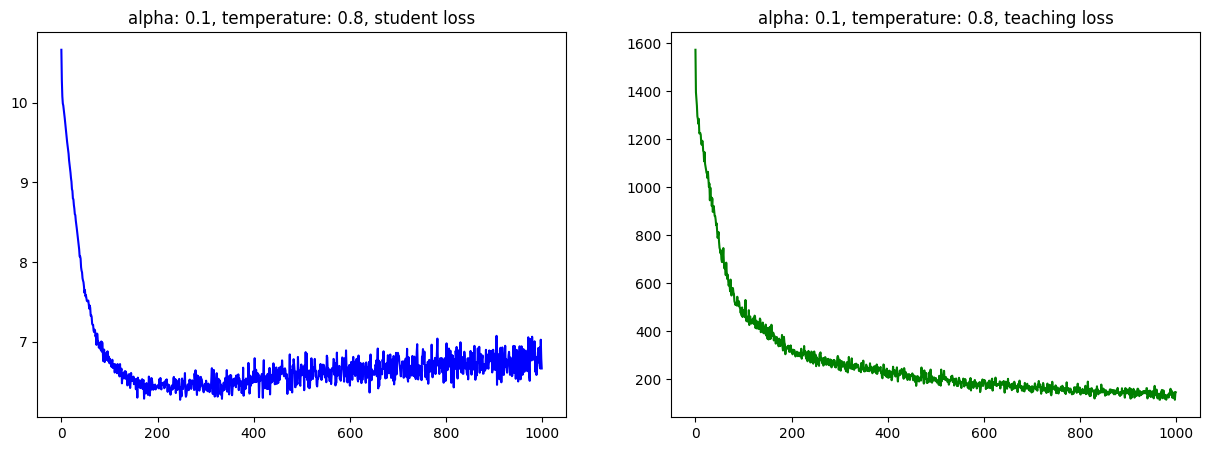

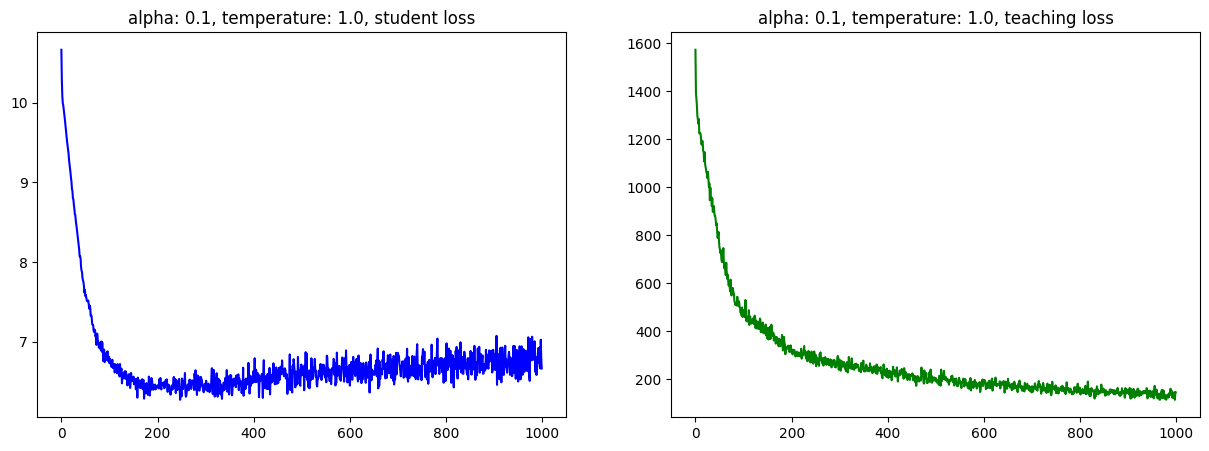

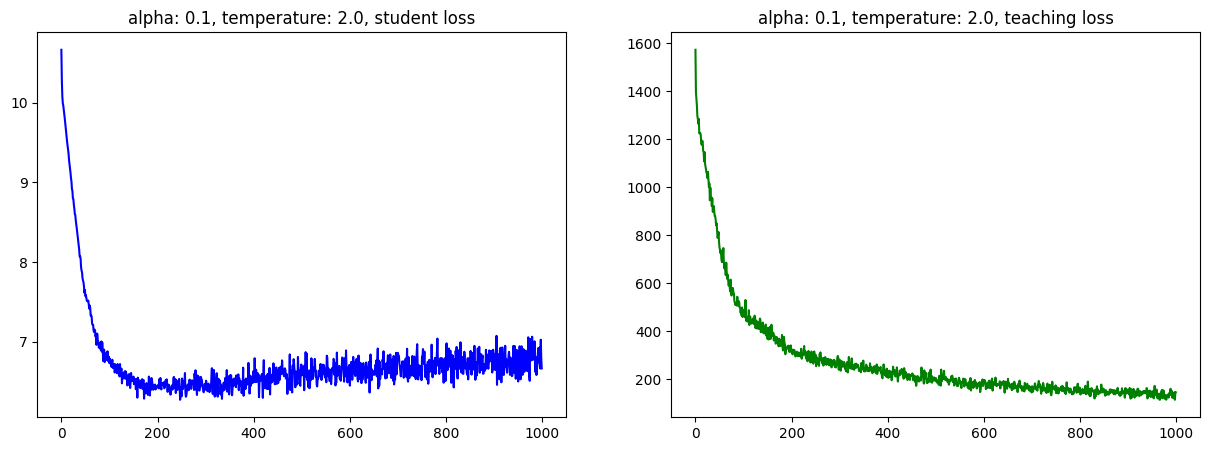

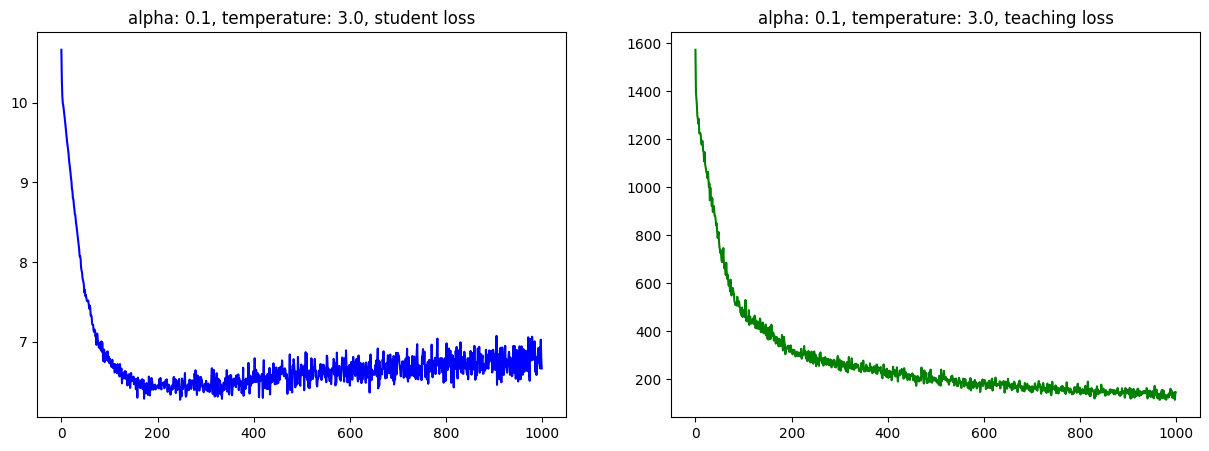

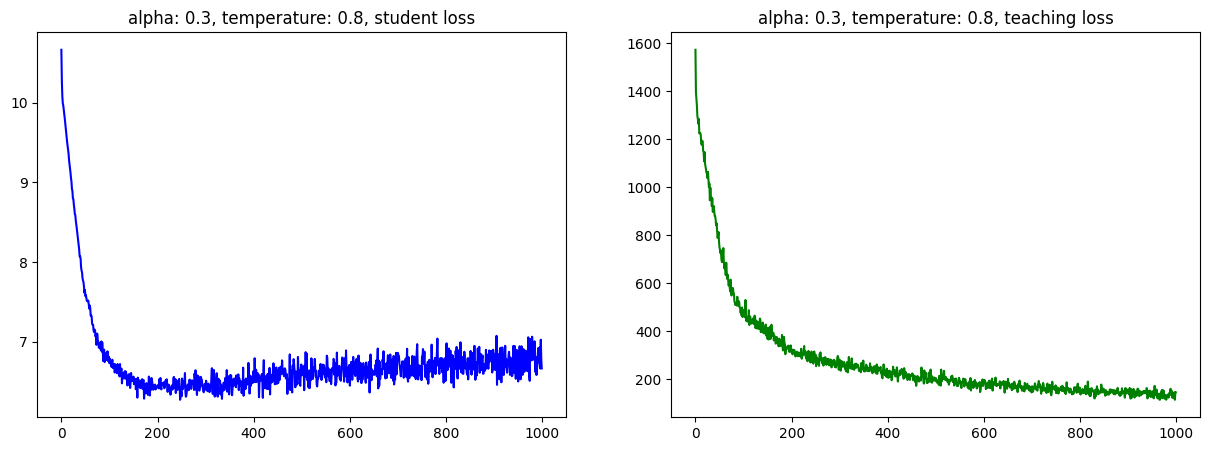

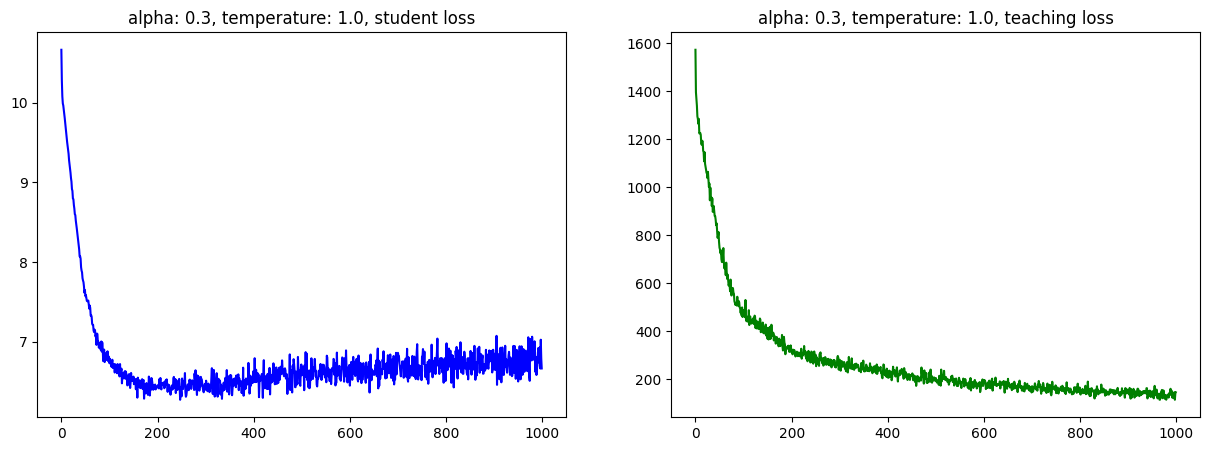

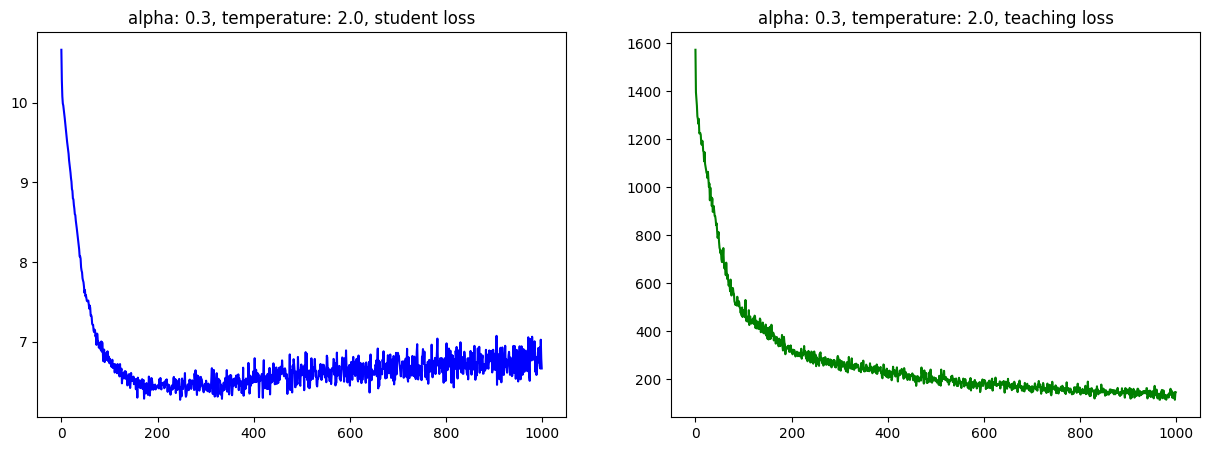

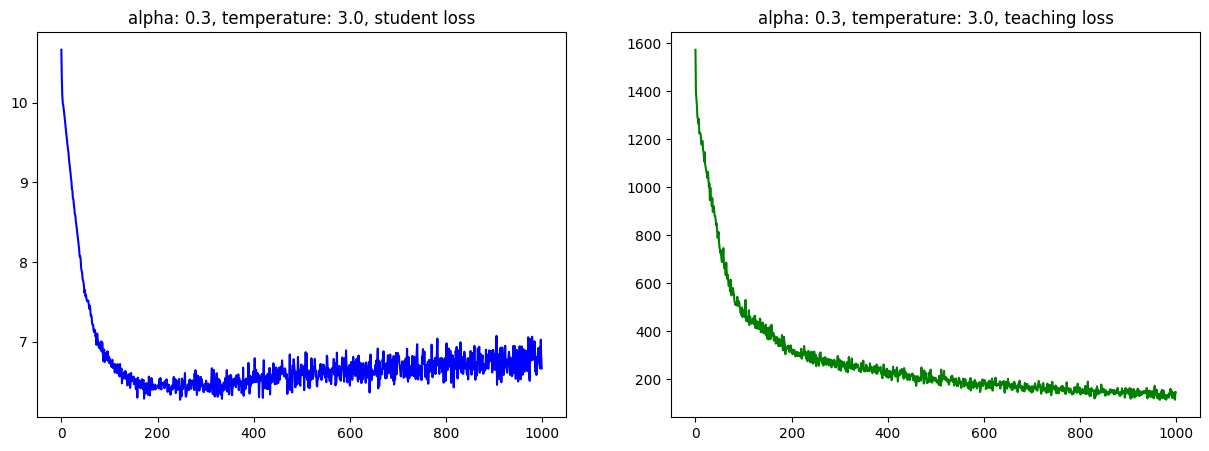

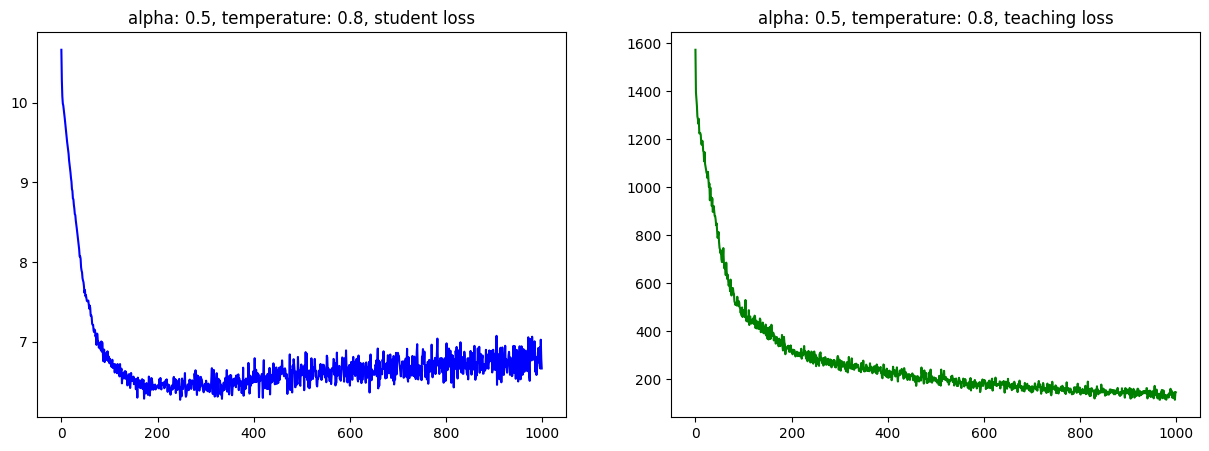

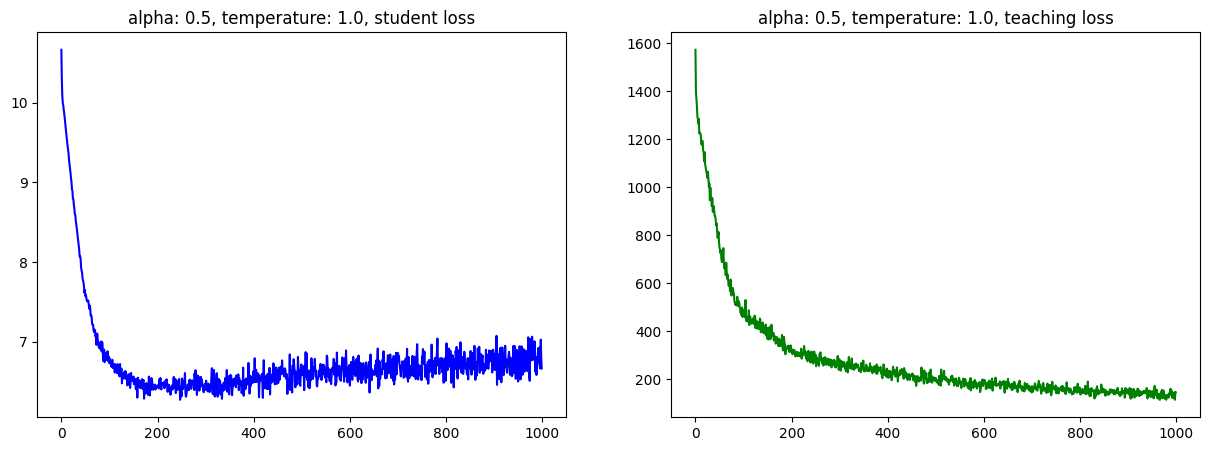

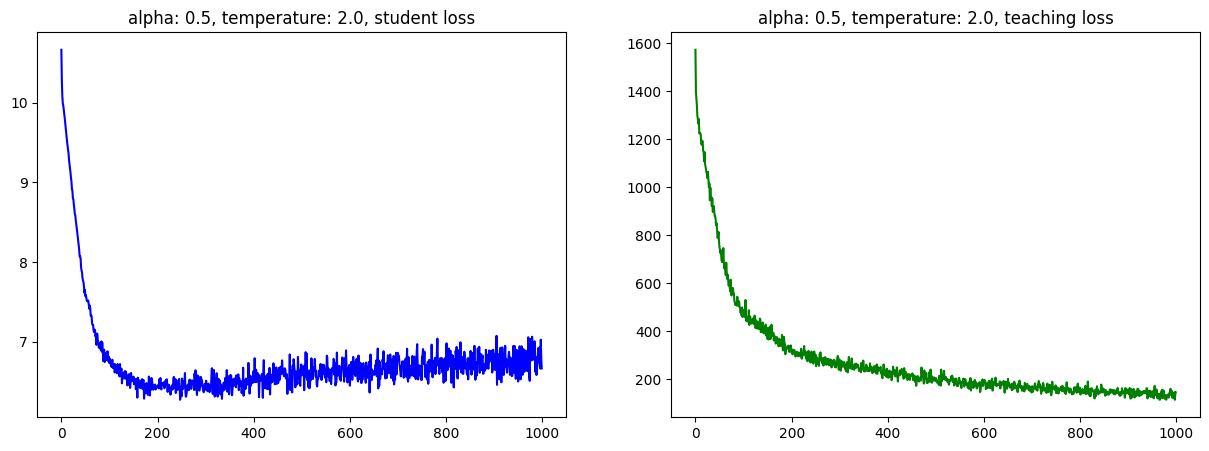

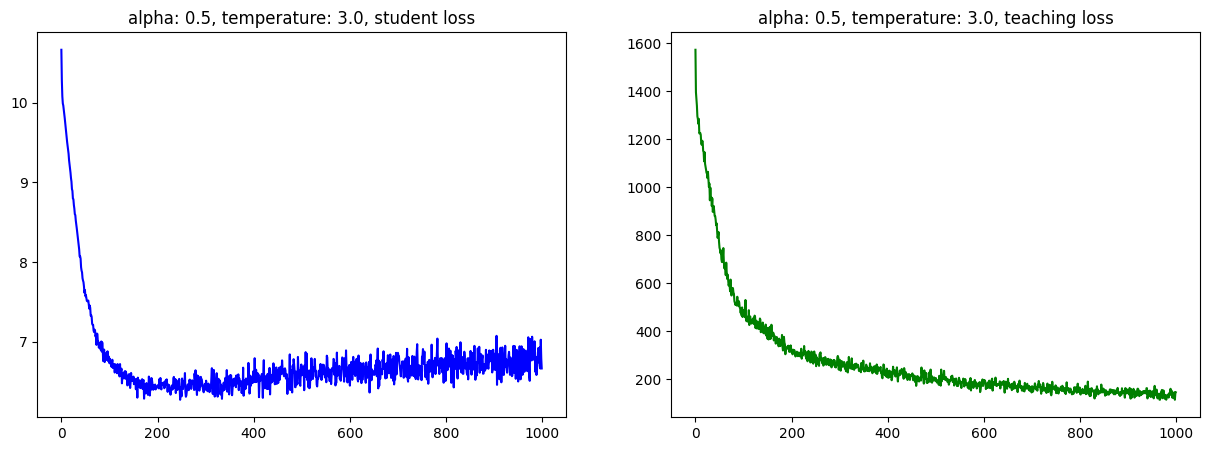

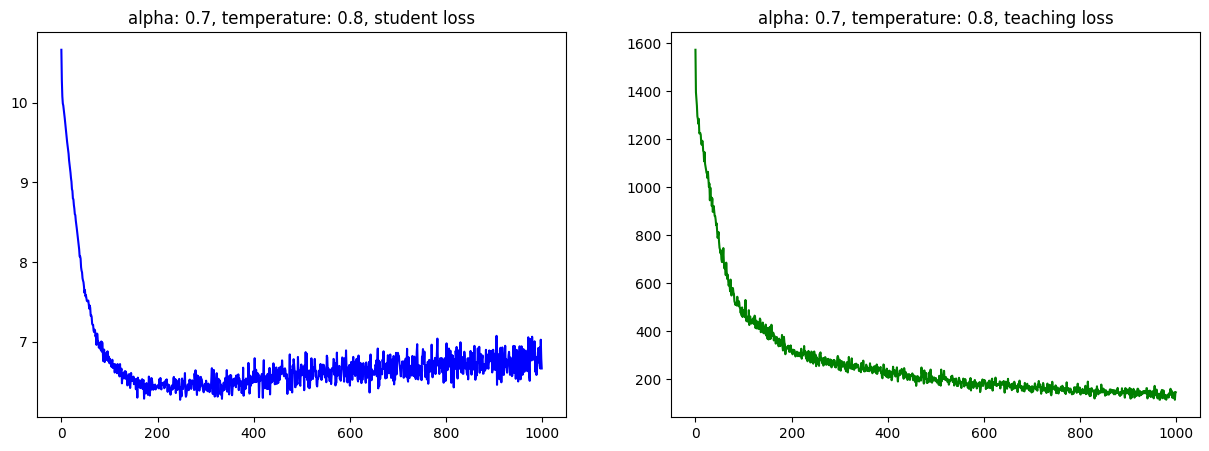

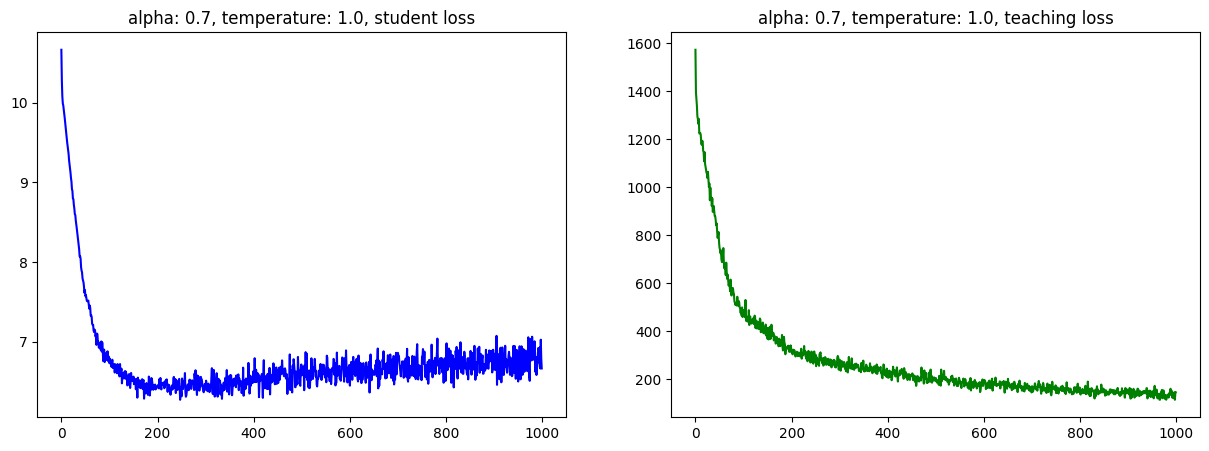

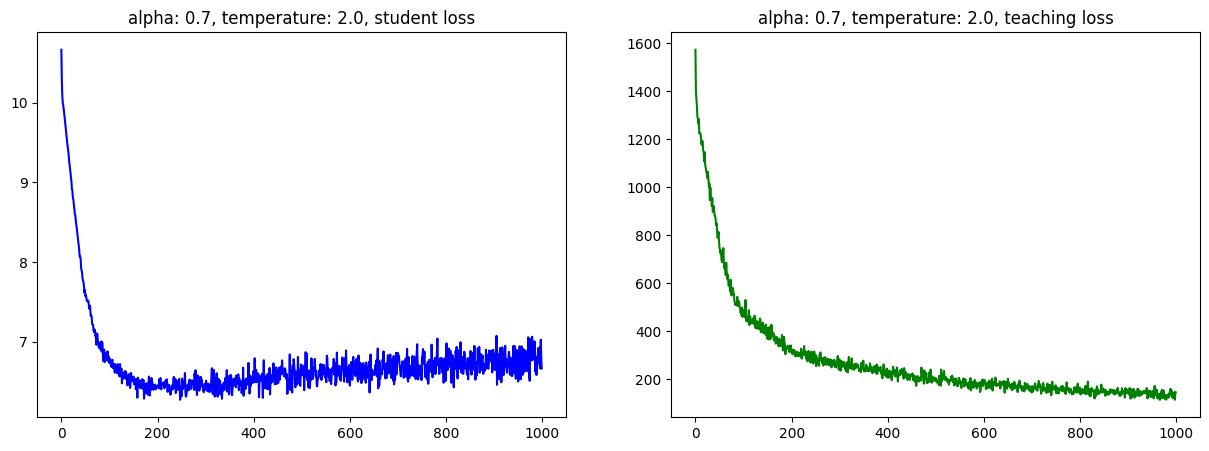

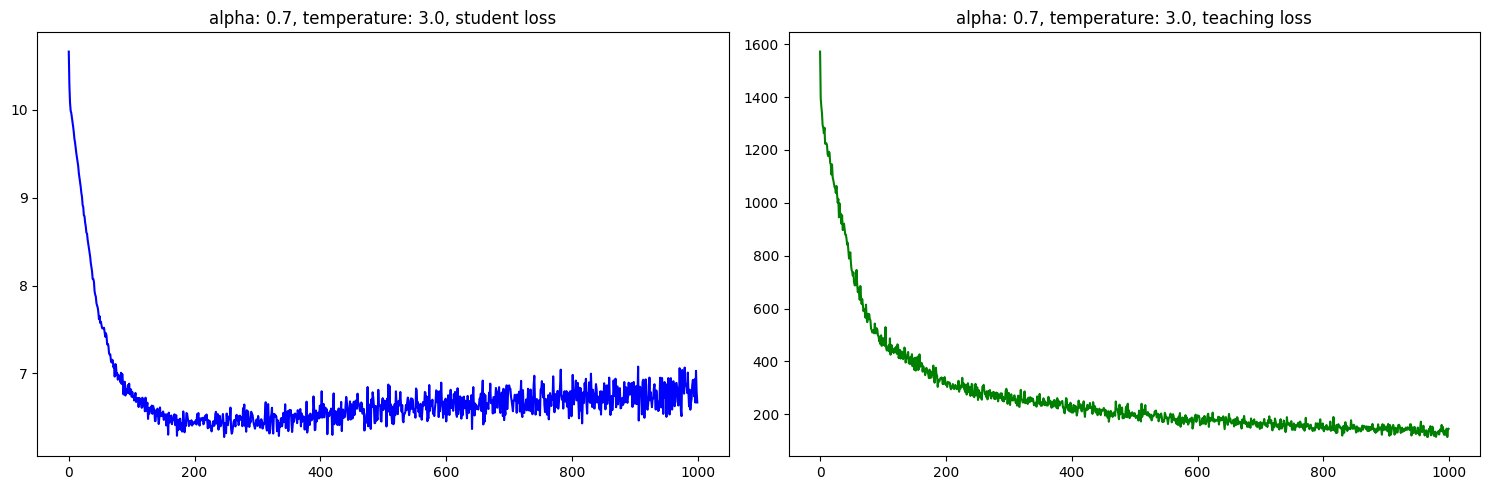

In [53]:


alpha_list = [0.1, 0.3, 0.5, 0.7]
temp_list = [0.8, 1.0, 2.0, 3.0]



for alpha in alpha_list:
  for temp in temp_list:
    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    stu_loss_list = loss_dic[f'stu_loss_list_apha_0.1_temp_1.0']
    tea_loss_list = loss_dic[f'teaching_loss_list_apha_0.1_temp_1.0']

    # Plot the first subplot
    axs[0].plot(stu_loss_list, color = 'blue')
    axs[0].set_title(f'alpha: {alpha}, temperature: {temp}, student loss')

    # Plot the second subplot
    axs[1].plot(tea_loss_list, color = 'green')
    axs[1].set_title(f'alpha: {alpha}, temperature: {temp}, teaching loss')

# Adjust layout
plt.tight_layout()

plt.savefig(f'plot.png')

# Show the plot
plt.show()


In [56]:
# forgot to save during training, so enter manually
val_loss_list = torch.tensor([6.4482, 6.8526, 7.8825, 7.9400, 6.1658, 6.6690, 7.4384, 7.3371, 5.7988, 6.3260, 6.9825, 6.6451, 5.5508, 5.9105, 6.4481, 5.8752], dtype = torch.float32)
val_loss_list = val_loss_list.reshape(4,4)
val_loss_list

tensor([[6.4482, 6.8526, 7.8825, 7.9400],
        [6.1658, 6.6690, 7.4384, 7.3371],
        [5.7988, 6.3260, 6.9825, 6.6451],
        [5.5508, 5.9105, 6.4481, 5.8752]])

In [ ]:
tlm.to('cpu')
torch.cuda.empty_cache()

In [61]:
# create a PyTorch optimizer

eval_interval = 200
eval_iters = 200
vocab_size = tokenizer.vocab_size

context_window_size = 256
embed_size = 384

learning_rate = 1e-4

loss_dic = {}

alpha = 1
temp = 1


stu_loss_list = []
teaching_loss_list = []

trans = TransformerLM(vocab_size, context_window_size)
tlm = trans.to(device)

optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate)
loss_fct = nn.KLDivLoss(reduction='batchmean')

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(tlm, eval_iters, context_window_size, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", context_window_size, device)

    # compute logits and loss from student
    student_logits, student_loss = tlm(xb, yb)
    stu_loss_list.append(student_loss.detach().item())

    # compute logits and loss from teacher
    with torch.no_grad():
        teacher_logits = teacher_model(xb).logits

    # soften probabilites and compute distillation loss
    try:
      teaching_loss = temperature **2 * loss_fct(
          F.log_softmax(student_logits / temperature, dim=-1),
          F.softmax(teacher_logits / temperature, dim=-1))
    except:
      breakpoint()

    # weighted student loss
    teaching_loss = alpha * student_loss + (1. - alpha) * teaching_loss

    print(f'student loss is {student_loss}, teaching loss is {teaching_loss}')
    teaching_loss_list.append(teaching_loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    teaching_loss.backward()
    optimizer.step()



  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0
step 0: train loss 10.5353, val loss 10.5449


  0%|          | 1/1000 [00:28<7:50:08, 28.24s/it]

student loss is 10.545720100402832, teaching loss is 10.545720100402832


  0%|          | 2/1000 [00:28<3:16:55, 11.84s/it]

student loss is 9.477530479431152, teaching loss is 9.477530479431152


  0%|          | 3/1000 [00:29<1:49:59,  6.62s/it]

student loss is 9.079495429992676, teaching loss is 9.079495429992676


  0%|          | 4/1000 [00:29<1:09:09,  4.17s/it]

student loss is 8.808456420898438, teaching loss is 8.808456420898438


  0%|          | 5/1000 [00:29<46:35,  2.81s/it]  

student loss is 8.626766204833984, teaching loss is 8.626766204833984


  1%|          | 6/1000 [00:30<32:59,  1.99s/it]

student loss is 8.630351066589355, teaching loss is 8.630351066589355


  1%|          | 7/1000 [00:30<24:22,  1.47s/it]

student loss is 8.54209041595459, teaching loss is 8.54209041595459


  1%|          | 8/1000 [00:31<18:42,  1.13s/it]

student loss is 8.410576820373535, teaching loss is 8.410576820373535


  1%|          | 9/1000 [00:31<14:55,  1.11it/s]

student loss is 8.434822082519531, teaching loss is 8.434822082519531


  1%|          | 10/1000 [00:31<12:23,  1.33it/s]

student loss is 8.16422176361084, teaching loss is 8.16422176361084


  1%|          | 11/1000 [00:32<10:38,  1.55it/s]

student loss is 8.285353660583496, teaching loss is 8.285353660583496


  1%|          | 12/1000 [00:32<09:25,  1.75it/s]

student loss is 8.106330871582031, teaching loss is 8.106330871582031


  1%|▏         | 13/1000 [00:33<08:34,  1.92it/s]

student loss is 8.027226448059082, teaching loss is 8.027226448059082


  1%|▏         | 14/1000 [00:33<07:58,  2.06it/s]

student loss is 8.054643630981445, teaching loss is 8.054643630981445


  2%|▏         | 15/1000 [00:33<07:35,  2.16it/s]

student loss is 7.966062068939209, teaching loss is 7.966062068939209


  2%|▏         | 16/1000 [00:34<07:17,  2.25it/s]

student loss is 7.860983371734619, teaching loss is 7.860983371734619


  2%|▏         | 17/1000 [00:34<07:04,  2.31it/s]

student loss is 7.948705673217773, teaching loss is 7.948705673217773


  2%|▏         | 18/1000 [00:35<06:55,  2.36it/s]

student loss is 7.85393762588501, teaching loss is 7.85393762588501


  2%|▏         | 19/1000 [00:35<06:50,  2.39it/s]

student loss is 7.840259075164795, teaching loss is 7.840259075164795


  2%|▏         | 20/1000 [00:35<06:47,  2.41it/s]

student loss is 7.7451677322387695, teaching loss is 7.7451677322387695


  2%|▏         | 21/1000 [00:36<06:43,  2.43it/s]

student loss is 7.6528520584106445, teaching loss is 7.6528520584106445


  2%|▏         | 22/1000 [00:36<06:40,  2.44it/s]

student loss is 7.563736915588379, teaching loss is 7.563736915588379


  2%|▏         | 23/1000 [00:37<06:38,  2.45it/s]

student loss is 7.488185405731201, teaching loss is 7.488185405731201


  2%|▏         | 24/1000 [00:37<06:37,  2.46it/s]

student loss is 7.514749526977539, teaching loss is 7.514749526977539


  2%|▎         | 25/1000 [00:37<06:36,  2.46it/s]

student loss is 7.34980583190918, teaching loss is 7.34980583190918


  3%|▎         | 26/1000 [00:38<06:37,  2.45it/s]

student loss is 7.3603515625, teaching loss is 7.3603515625


  3%|▎         | 27/1000 [00:38<06:35,  2.46it/s]

student loss is 7.237165927886963, teaching loss is 7.237165927886963


  3%|▎         | 28/1000 [00:39<06:33,  2.47it/s]

student loss is 7.374121189117432, teaching loss is 7.374121189117432


  3%|▎         | 29/1000 [00:39<06:33,  2.47it/s]

student loss is 7.163122653961182, teaching loss is 7.163122653961182


  3%|▎         | 30/1000 [00:39<06:32,  2.47it/s]

student loss is 7.190964221954346, teaching loss is 7.190964221954346


  3%|▎         | 31/1000 [00:40<06:32,  2.47it/s]

student loss is 7.001796722412109, teaching loss is 7.001796722412109


  3%|▎         | 32/1000 [00:40<06:33,  2.46it/s]

student loss is 7.008319854736328, teaching loss is 7.008319854736328


  3%|▎         | 33/1000 [00:41<06:32,  2.47it/s]

student loss is 7.083711624145508, teaching loss is 7.083711624145508


  3%|▎         | 34/1000 [00:41<06:32,  2.46it/s]

student loss is 7.001585483551025, teaching loss is 7.001585483551025


  4%|▎         | 35/1000 [00:41<06:30,  2.47it/s]

student loss is 6.728425979614258, teaching loss is 6.728425979614258


  4%|▎         | 36/1000 [00:42<06:30,  2.47it/s]

student loss is 6.799441337585449, teaching loss is 6.799441337585449


  4%|▎         | 37/1000 [00:42<06:30,  2.46it/s]

student loss is 6.62241268157959, teaching loss is 6.62241268157959


  4%|▍         | 38/1000 [00:43<06:30,  2.46it/s]

student loss is 6.791487216949463, teaching loss is 6.791487216949463


  4%|▍         | 39/1000 [00:43<06:31,  2.46it/s]

student loss is 6.514145851135254, teaching loss is 6.514145851135254


  4%|▍         | 40/1000 [00:43<06:29,  2.47it/s]

student loss is 6.4379658699035645, teaching loss is 6.4379658699035645


  4%|▍         | 41/1000 [00:44<06:28,  2.47it/s]

student loss is 6.406023025512695, teaching loss is 6.406023025512695


  4%|▍         | 42/1000 [00:44<06:27,  2.47it/s]

student loss is 6.481687068939209, teaching loss is 6.481687068939209


  4%|▍         | 43/1000 [00:45<06:28,  2.47it/s]

student loss is 6.39491081237793, teaching loss is 6.39491081237793


  4%|▍         | 44/1000 [00:45<06:28,  2.46it/s]

student loss is 6.464198112487793, teaching loss is 6.464198112487793


  4%|▍         | 45/1000 [00:46<06:27,  2.46it/s]

student loss is 6.27312707901001, teaching loss is 6.27312707901001


  5%|▍         | 46/1000 [00:46<06:27,  2.46it/s]

student loss is 6.174159049987793, teaching loss is 6.174159049987793


  5%|▍         | 47/1000 [00:46<06:25,  2.47it/s]

student loss is 6.105358123779297, teaching loss is 6.105358123779297


  5%|▍         | 48/1000 [00:47<06:25,  2.47it/s]

student loss is 6.104526996612549, teaching loss is 6.104526996612549


  5%|▍         | 49/1000 [00:47<06:26,  2.46it/s]

student loss is 6.129947662353516, teaching loss is 6.129947662353516


  5%|▌         | 50/1000 [00:48<06:26,  2.46it/s]

student loss is 6.1025896072387695, teaching loss is 6.1025896072387695


  5%|▌         | 51/1000 [00:48<06:25,  2.46it/s]

student loss is 5.9477410316467285, teaching loss is 5.9477410316467285


  5%|▌         | 52/1000 [00:48<06:24,  2.46it/s]

student loss is 6.007190227508545, teaching loss is 6.007190227508545


  5%|▌         | 53/1000 [00:49<06:23,  2.47it/s]

student loss is 5.833861827850342, teaching loss is 5.833861827850342


  5%|▌         | 54/1000 [00:49<06:23,  2.47it/s]

student loss is 5.795454025268555, teaching loss is 5.795454025268555


  6%|▌         | 55/1000 [00:50<06:23,  2.47it/s]

student loss is 5.707485675811768, teaching loss is 5.707485675811768


  6%|▌         | 56/1000 [00:50<06:23,  2.46it/s]

student loss is 5.7767229080200195, teaching loss is 5.7767229080200195


  6%|▌         | 57/1000 [00:50<06:22,  2.47it/s]

student loss is 5.621228218078613, teaching loss is 5.621228218078613


  6%|▌         | 58/1000 [00:51<06:23,  2.46it/s]

student loss is 5.566677570343018, teaching loss is 5.566677570343018


  6%|▌         | 59/1000 [00:51<06:21,  2.47it/s]

student loss is 5.639175891876221, teaching loss is 5.639175891876221


  6%|▌         | 60/1000 [00:52<06:21,  2.46it/s]

student loss is 5.557769298553467, teaching loss is 5.557769298553467


  6%|▌         | 61/1000 [00:52<06:21,  2.46it/s]

student loss is 5.4265456199646, teaching loss is 5.4265456199646


  6%|▌         | 62/1000 [00:52<06:19,  2.47it/s]

student loss is 5.377976417541504, teaching loss is 5.377976417541504


  6%|▋         | 63/1000 [00:53<06:19,  2.47it/s]

student loss is 5.349213600158691, teaching loss is 5.349213600158691


  6%|▋         | 64/1000 [00:53<06:18,  2.47it/s]

student loss is 5.380590438842773, teaching loss is 5.380590438842773


  6%|▋         | 65/1000 [00:54<06:18,  2.47it/s]

student loss is 5.299398422241211, teaching loss is 5.299398422241211


  7%|▋         | 66/1000 [00:54<06:19,  2.46it/s]

student loss is 5.163074016571045, teaching loss is 5.163074016571045


  7%|▋         | 67/1000 [00:54<06:19,  2.46it/s]

student loss is 5.18783712387085, teaching loss is 5.18783712387085


  7%|▋         | 68/1000 [00:55<06:19,  2.46it/s]

student loss is 5.156741142272949, teaching loss is 5.156741142272949


  7%|▋         | 69/1000 [00:55<06:17,  2.46it/s]

student loss is 5.1725873947143555, teaching loss is 5.1725873947143555


  7%|▋         | 70/1000 [00:56<06:17,  2.47it/s]

student loss is 5.144245147705078, teaching loss is 5.144245147705078


  7%|▋         | 71/1000 [00:56<06:17,  2.46it/s]

student loss is 4.96912956237793, teaching loss is 4.96912956237793


  7%|▋         | 72/1000 [00:56<06:17,  2.46it/s]

student loss is 4.993912696838379, teaching loss is 4.993912696838379


  7%|▋         | 73/1000 [00:57<06:16,  2.46it/s]

student loss is 4.924452781677246, teaching loss is 4.924452781677246


  7%|▋         | 74/1000 [00:57<06:16,  2.46it/s]

student loss is 4.746632099151611, teaching loss is 4.746632099151611


  8%|▊         | 75/1000 [00:58<06:15,  2.46it/s]

student loss is 4.746679306030273, teaching loss is 4.746679306030273


  8%|▊         | 76/1000 [00:58<06:15,  2.46it/s]

student loss is 4.85203218460083, teaching loss is 4.85203218460083


  8%|▊         | 77/1000 [00:59<06:13,  2.47it/s]

student loss is 4.787088871002197, teaching loss is 4.787088871002197


  8%|▊         | 78/1000 [00:59<06:14,  2.46it/s]

student loss is 4.752185344696045, teaching loss is 4.752185344696045


  8%|▊         | 79/1000 [00:59<06:14,  2.46it/s]

student loss is 4.661894798278809, teaching loss is 4.661894798278809


  8%|▊         | 80/1000 [01:00<06:14,  2.46it/s]

student loss is 4.721065044403076, teaching loss is 4.721065044403076


  8%|▊         | 81/1000 [01:00<06:15,  2.45it/s]

student loss is 4.694562911987305, teaching loss is 4.694562911987305


  8%|▊         | 82/1000 [01:01<06:12,  2.46it/s]

student loss is 4.530167579650879, teaching loss is 4.530167579650879


  8%|▊         | 83/1000 [01:01<06:11,  2.47it/s]

student loss is 4.588808536529541, teaching loss is 4.588808536529541


  8%|▊         | 84/1000 [01:01<06:10,  2.47it/s]

student loss is 4.604813098907471, teaching loss is 4.604813098907471


  8%|▊         | 85/1000 [01:02<06:11,  2.46it/s]

student loss is 4.4258952140808105, teaching loss is 4.4258952140808105


  9%|▊         | 86/1000 [01:02<06:10,  2.47it/s]

student loss is 4.358011245727539, teaching loss is 4.358011245727539


  9%|▊         | 87/1000 [01:03<06:10,  2.47it/s]

student loss is 4.402814865112305, teaching loss is 4.402814865112305


  9%|▉         | 88/1000 [01:03<06:10,  2.46it/s]

student loss is 4.3922505378723145, teaching loss is 4.3922505378723145


  9%|▉         | 89/1000 [01:03<06:10,  2.46it/s]

student loss is 4.359859943389893, teaching loss is 4.359859943389893


  9%|▉         | 90/1000 [01:04<06:10,  2.46it/s]

student loss is 4.402622222900391, teaching loss is 4.402622222900391


  9%|▉         | 91/1000 [01:04<06:08,  2.47it/s]

student loss is 4.349287033081055, teaching loss is 4.349287033081055


  9%|▉         | 92/1000 [01:05<06:07,  2.47it/s]

student loss is 4.254833698272705, teaching loss is 4.254833698272705


  9%|▉         | 93/1000 [01:05<06:06,  2.47it/s]

student loss is 4.35775089263916, teaching loss is 4.35775089263916


  9%|▉         | 94/1000 [01:05<06:06,  2.47it/s]

student loss is 4.348388671875, teaching loss is 4.348388671875


 10%|▉         | 95/1000 [01:06<06:07,  2.47it/s]

student loss is 4.4956374168396, teaching loss is 4.4956374168396


 10%|▉         | 96/1000 [01:06<06:06,  2.46it/s]

student loss is 4.249829292297363, teaching loss is 4.249829292297363


 10%|▉         | 97/1000 [01:07<06:06,  2.47it/s]

student loss is 4.253304481506348, teaching loss is 4.253304481506348


 10%|▉         | 98/1000 [01:07<06:05,  2.47it/s]

student loss is 4.278927326202393, teaching loss is 4.278927326202393


 10%|▉         | 99/1000 [01:07<06:05,  2.47it/s]

student loss is 4.350391387939453, teaching loss is 4.350391387939453


 10%|█         | 100/1000 [01:08<06:05,  2.46it/s]

student loss is 4.215904712677002, teaching loss is 4.215904712677002


 10%|█         | 101/1000 [01:08<06:06,  2.45it/s]

student loss is 4.3222174644470215, teaching loss is 4.3222174644470215


 10%|█         | 102/1000 [01:09<06:05,  2.46it/s]

student loss is 4.289043426513672, teaching loss is 4.289043426513672


 10%|█         | 103/1000 [01:09<06:04,  2.46it/s]

student loss is 4.173029899597168, teaching loss is 4.173029899597168


 10%|█         | 104/1000 [01:09<06:03,  2.46it/s]

student loss is 4.20136833190918, teaching loss is 4.20136833190918


 10%|█         | 105/1000 [01:10<06:02,  2.47it/s]

student loss is 3.958372116088867, teaching loss is 3.958372116088867


 11%|█         | 106/1000 [01:10<06:02,  2.47it/s]

student loss is 4.11447286605835, teaching loss is 4.11447286605835


 11%|█         | 107/1000 [01:11<06:03,  2.46it/s]

student loss is 4.134701728820801, teaching loss is 4.134701728820801


 11%|█         | 108/1000 [01:11<06:02,  2.46it/s]

student loss is 4.038412570953369, teaching loss is 4.038412570953369


 11%|█         | 109/1000 [01:12<06:04,  2.45it/s]

student loss is 4.076300144195557, teaching loss is 4.076300144195557


 11%|█         | 110/1000 [01:12<06:00,  2.47it/s]

student loss is 4.187119483947754, teaching loss is 4.187119483947754


 11%|█         | 111/1000 [01:12<06:00,  2.46it/s]

student loss is 4.221395492553711, teaching loss is 4.221395492553711


 11%|█         | 112/1000 [01:13<06:00,  2.46it/s]

student loss is 4.109951019287109, teaching loss is 4.109951019287109


 11%|█▏        | 113/1000 [01:13<06:00,  2.46it/s]

student loss is 4.12709379196167, teaching loss is 4.12709379196167


 11%|█▏        | 114/1000 [01:14<06:00,  2.46it/s]

student loss is 4.203304767608643, teaching loss is 4.203304767608643


 12%|█▏        | 115/1000 [01:14<05:59,  2.46it/s]

student loss is 3.8683371543884277, teaching loss is 3.8683371543884277


 12%|█▏        | 116/1000 [01:14<05:59,  2.46it/s]

student loss is 4.00641393661499, teaching loss is 4.00641393661499


 12%|█▏        | 117/1000 [01:15<05:58,  2.47it/s]

student loss is 3.9135196208953857, teaching loss is 3.9135196208953857


 12%|█▏        | 118/1000 [01:15<05:58,  2.46it/s]

student loss is 4.145552635192871, teaching loss is 4.145552635192871


 12%|█▏        | 119/1000 [01:16<05:59,  2.45it/s]

student loss is 4.151443004608154, teaching loss is 4.151443004608154


 12%|█▏        | 120/1000 [01:16<05:57,  2.46it/s]

student loss is 3.845245122909546, teaching loss is 3.845245122909546


 12%|█▏        | 121/1000 [01:16<05:58,  2.45it/s]

student loss is 3.9534695148468018, teaching loss is 3.9534695148468018


 12%|█▏        | 122/1000 [01:17<05:57,  2.46it/s]

student loss is 3.7546372413635254, teaching loss is 3.7546372413635254


 12%|█▏        | 123/1000 [01:17<05:57,  2.46it/s]

student loss is 3.970656156539917, teaching loss is 3.970656156539917


 12%|█▏        | 124/1000 [01:18<05:55,  2.47it/s]

student loss is 3.881133556365967, teaching loss is 3.881133556365967


 12%|█▎        | 125/1000 [01:18<05:54,  2.47it/s]

student loss is 3.7478222846984863, teaching loss is 3.7478222846984863


 13%|█▎        | 126/1000 [01:18<05:55,  2.46it/s]

student loss is 3.7665932178497314, teaching loss is 3.7665932178497314


 13%|█▎        | 127/1000 [01:19<05:53,  2.47it/s]

student loss is 3.868394374847412, teaching loss is 3.868394374847412


 13%|█▎        | 128/1000 [01:19<05:53,  2.46it/s]

student loss is 3.750171661376953, teaching loss is 3.750171661376953


 13%|█▎        | 129/1000 [01:20<05:52,  2.47it/s]

student loss is 3.900456190109253, teaching loss is 3.900456190109253


 13%|█▎        | 130/1000 [01:20<05:52,  2.47it/s]

student loss is 3.9371840953826904, teaching loss is 3.9371840953826904


 13%|█▎        | 131/1000 [01:20<05:53,  2.46it/s]

student loss is 3.9081943035125732, teaching loss is 3.9081943035125732


 13%|█▎        | 132/1000 [01:21<05:53,  2.46it/s]

student loss is 3.8093912601470947, teaching loss is 3.8093912601470947


 13%|█▎        | 133/1000 [01:21<05:52,  2.46it/s]

student loss is 3.9935855865478516, teaching loss is 3.9935855865478516


 13%|█▎        | 134/1000 [01:22<05:51,  2.46it/s]

student loss is 3.663713216781616, teaching loss is 3.663713216781616


 14%|█▎        | 135/1000 [01:22<05:51,  2.46it/s]

student loss is 3.870100259780884, teaching loss is 3.870100259780884


 14%|█▎        | 136/1000 [01:22<05:53,  2.45it/s]

student loss is 3.7708590030670166, teaching loss is 3.7708590030670166


 14%|█▎        | 137/1000 [01:23<05:51,  2.45it/s]

student loss is 3.790419101715088, teaching loss is 3.790419101715088


 14%|█▍        | 138/1000 [01:23<05:52,  2.45it/s]

student loss is 3.850151300430298, teaching loss is 3.850151300430298


 14%|█▍        | 139/1000 [01:24<05:50,  2.46it/s]

student loss is 3.778834342956543, teaching loss is 3.778834342956543


 14%|█▍        | 140/1000 [01:24<05:50,  2.45it/s]

student loss is 3.8318674564361572, teaching loss is 3.8318674564361572


 14%|█▍        | 141/1000 [01:25<05:49,  2.46it/s]

student loss is 3.793241500854492, teaching loss is 3.793241500854492


 14%|█▍        | 142/1000 [01:25<05:49,  2.45it/s]

student loss is 3.783950090408325, teaching loss is 3.783950090408325


 14%|█▍        | 143/1000 [01:25<05:49,  2.45it/s]

student loss is 3.6817140579223633, teaching loss is 3.6817140579223633


 14%|█▍        | 144/1000 [01:26<05:48,  2.46it/s]

student loss is 3.8539602756500244, teaching loss is 3.8539602756500244


 14%|█▍        | 145/1000 [01:26<05:48,  2.45it/s]

student loss is 3.674736976623535, teaching loss is 3.674736976623535


 15%|█▍        | 146/1000 [01:27<05:48,  2.45it/s]

student loss is 3.8194782733917236, teaching loss is 3.8194782733917236


 15%|█▍        | 147/1000 [01:27<05:48,  2.45it/s]

student loss is 3.707797050476074, teaching loss is 3.707797050476074


 15%|█▍        | 148/1000 [01:27<05:46,  2.46it/s]

student loss is 3.7263336181640625, teaching loss is 3.7263336181640625


 15%|█▍        | 149/1000 [01:28<05:46,  2.46it/s]

student loss is 3.7961010932922363, teaching loss is 3.7961010932922363


 15%|█▌        | 150/1000 [01:28<05:45,  2.46it/s]

student loss is 3.765519380569458, teaching loss is 3.765519380569458


 15%|█▌        | 151/1000 [01:29<05:45,  2.45it/s]

student loss is 3.7275800704956055, teaching loss is 3.7275800704956055


 15%|█▌        | 152/1000 [01:29<05:45,  2.45it/s]

student loss is 3.482834815979004, teaching loss is 3.482834815979004


 15%|█▌        | 153/1000 [01:29<05:45,  2.45it/s]

student loss is 3.715336799621582, teaching loss is 3.715336799621582


 15%|█▌        | 154/1000 [01:30<05:45,  2.45it/s]

student loss is 3.6507205963134766, teaching loss is 3.6507205963134766


 16%|█▌        | 155/1000 [01:30<05:43,  2.46it/s]

student loss is 3.7676033973693848, teaching loss is 3.7676033973693848


 16%|█▌        | 156/1000 [01:31<05:42,  2.46it/s]

student loss is 3.7435641288757324, teaching loss is 3.7435641288757324


 16%|█▌        | 157/1000 [01:31<05:42,  2.46it/s]

student loss is 3.7255771160125732, teaching loss is 3.7255771160125732


 16%|█▌        | 158/1000 [01:31<05:41,  2.46it/s]

student loss is 3.644092559814453, teaching loss is 3.644092559814453


 16%|█▌        | 159/1000 [01:32<05:42,  2.46it/s]

student loss is 3.797070264816284, teaching loss is 3.797070264816284


 16%|█▌        | 160/1000 [01:32<05:41,  2.46it/s]

student loss is 3.753749370574951, teaching loss is 3.753749370574951


 16%|█▌        | 161/1000 [01:33<05:42,  2.45it/s]

student loss is 3.6636011600494385, teaching loss is 3.6636011600494385


 16%|█▌        | 162/1000 [01:33<05:41,  2.45it/s]

student loss is 3.639784574508667, teaching loss is 3.639784574508667


 16%|█▋        | 163/1000 [01:33<05:41,  2.45it/s]

student loss is 3.654249429702759, teaching loss is 3.654249429702759


 16%|█▋        | 164/1000 [01:34<05:40,  2.46it/s]

student loss is 3.664486885070801, teaching loss is 3.664486885070801


 16%|█▋        | 165/1000 [01:34<05:40,  2.45it/s]

student loss is 3.72867488861084, teaching loss is 3.72867488861084


 17%|█▋        | 166/1000 [01:35<05:41,  2.44it/s]

student loss is 3.519469738006592, teaching loss is 3.519469738006592


 17%|█▋        | 167/1000 [01:35<05:39,  2.45it/s]

student loss is 3.720968246459961, teaching loss is 3.720968246459961


 17%|█▋        | 168/1000 [01:36<05:39,  2.45it/s]

student loss is 3.534794807434082, teaching loss is 3.534794807434082


 17%|█▋        | 169/1000 [01:36<05:38,  2.46it/s]

student loss is 3.777097225189209, teaching loss is 3.777097225189209


 17%|█▋        | 170/1000 [01:36<05:38,  2.45it/s]

student loss is 3.6803319454193115, teaching loss is 3.6803319454193115


 17%|█▋        | 171/1000 [01:37<05:36,  2.46it/s]

student loss is 3.7201554775238037, teaching loss is 3.7201554775238037


 17%|█▋        | 172/1000 [01:37<05:36,  2.46it/s]

student loss is 3.650470018386841, teaching loss is 3.650470018386841


 17%|█▋        | 173/1000 [01:38<05:37,  2.45it/s]

student loss is 3.531893491744995, teaching loss is 3.531893491744995


 17%|█▋        | 174/1000 [01:38<05:35,  2.46it/s]

student loss is 3.5466508865356445, teaching loss is 3.5466508865356445


 18%|█▊        | 175/1000 [01:38<05:35,  2.46it/s]

student loss is 3.6272284984588623, teaching loss is 3.6272284984588623


 18%|█▊        | 176/1000 [01:39<05:34,  2.46it/s]

student loss is 3.712141990661621, teaching loss is 3.712141990661621


 18%|█▊        | 177/1000 [01:39<05:34,  2.46it/s]

student loss is 3.5278608798980713, teaching loss is 3.5278608798980713


 18%|█▊        | 178/1000 [01:40<05:35,  2.45it/s]

student loss is 3.4996798038482666, teaching loss is 3.4996798038482666


 18%|█▊        | 179/1000 [01:40<05:34,  2.45it/s]

student loss is 3.5345048904418945, teaching loss is 3.5345048904418945


 18%|█▊        | 180/1000 [01:40<05:35,  2.45it/s]

student loss is 3.6160387992858887, teaching loss is 3.6160387992858887


 18%|█▊        | 181/1000 [01:41<05:34,  2.45it/s]

student loss is 3.507986307144165, teaching loss is 3.507986307144165


 18%|█▊        | 182/1000 [01:41<05:33,  2.45it/s]

student loss is 3.6399307250976562, teaching loss is 3.6399307250976562


 18%|█▊        | 183/1000 [01:42<05:32,  2.46it/s]

student loss is 3.56980299949646, teaching loss is 3.56980299949646


 18%|█▊        | 184/1000 [01:42<05:32,  2.46it/s]

student loss is 3.4954614639282227, teaching loss is 3.4954614639282227


 18%|█▊        | 185/1000 [01:42<05:31,  2.46it/s]

student loss is 3.3727898597717285, teaching loss is 3.3727898597717285


 19%|█▊        | 186/1000 [01:43<05:31,  2.45it/s]

student loss is 3.4957892894744873, teaching loss is 3.4957892894744873


 19%|█▊        | 187/1000 [01:43<05:31,  2.45it/s]

student loss is 3.518385648727417, teaching loss is 3.518385648727417


 19%|█▉        | 188/1000 [01:44<05:31,  2.45it/s]

student loss is 3.482672691345215, teaching loss is 3.482672691345215


 19%|█▉        | 189/1000 [01:44<05:30,  2.45it/s]

student loss is 3.3624107837677, teaching loss is 3.3624107837677


 19%|█▉        | 190/1000 [01:44<05:29,  2.46it/s]

student loss is 3.3959529399871826, teaching loss is 3.3959529399871826


 19%|█▉        | 191/1000 [01:45<05:31,  2.44it/s]

student loss is 3.469771146774292, teaching loss is 3.469771146774292


 19%|█▉        | 192/1000 [01:45<05:28,  2.46it/s]

student loss is 3.5305874347686768, teaching loss is 3.5305874347686768


 19%|█▉        | 193/1000 [01:46<05:28,  2.46it/s]

student loss is 3.62469220161438, teaching loss is 3.62469220161438


 19%|█▉        | 194/1000 [01:46<05:29,  2.45it/s]

student loss is 3.467399835586548, teaching loss is 3.467399835586548


 20%|█▉        | 195/1000 [01:47<05:28,  2.45it/s]

student loss is 3.5457682609558105, teaching loss is 3.5457682609558105


 20%|█▉        | 196/1000 [01:47<05:27,  2.45it/s]

student loss is 3.5822978019714355, teaching loss is 3.5822978019714355


 20%|█▉        | 197/1000 [01:47<05:26,  2.46it/s]

student loss is 3.4722445011138916, teaching loss is 3.4722445011138916


 20%|█▉        | 198/1000 [01:48<05:26,  2.46it/s]

student loss is 3.5623223781585693, teaching loss is 3.5623223781585693


 20%|█▉        | 199/1000 [01:48<05:26,  2.45it/s]

student loss is 3.5909759998321533, teaching loss is 3.5909759998321533


 20%|██        | 200/1000 [01:49<05:26,  2.45it/s]

student loss is 3.5695669651031494, teaching loss is 3.5695669651031494
iteration 200
step 200: train loss 3.5051, val loss 3.5076


 20%|██        | 201/1000 [02:17<1:58:00,  8.86s/it]

student loss is 3.662562847137451, teaching loss is 3.662562847137451


 20%|██        | 202/1000 [02:18<1:24:08,  6.33s/it]

student loss is 3.476940155029297, teaching loss is 3.476940155029297


 20%|██        | 203/1000 [02:18<1:00:27,  4.55s/it]

student loss is 3.5383412837982178, teaching loss is 3.5383412837982178


 20%|██        | 204/1000 [02:18<43:53,  3.31s/it]  

student loss is 3.474823474884033, teaching loss is 3.474823474884033


 20%|██        | 205/1000 [02:19<32:20,  2.44s/it]

student loss is 3.5870323181152344, teaching loss is 3.5870323181152344


 21%|██        | 206/1000 [02:19<24:11,  1.83s/it]

student loss is 3.52595853805542, teaching loss is 3.52595853805542


 21%|██        | 207/1000 [02:20<18:33,  1.40s/it]

student loss is 3.4030559062957764, teaching loss is 3.4030559062957764


 21%|██        | 208/1000 [02:20<14:34,  1.10s/it]

student loss is 3.4386043548583984, teaching loss is 3.4386043548583984


 21%|██        | 209/1000 [02:20<11:48,  1.12it/s]

student loss is 3.3387207984924316, teaching loss is 3.3387207984924316


 21%|██        | 210/1000 [02:21<09:51,  1.33it/s]

student loss is 3.4925811290740967, teaching loss is 3.4925811290740967


 21%|██        | 211/1000 [02:21<08:30,  1.55it/s]

student loss is 3.5451276302337646, teaching loss is 3.5451276302337646


 21%|██        | 212/1000 [02:22<07:33,  1.74it/s]

student loss is 3.3019189834594727, teaching loss is 3.3019189834594727


 21%|██▏       | 213/1000 [02:22<06:52,  1.91it/s]

student loss is 3.492185115814209, teaching loss is 3.492185115814209


 21%|██▏       | 214/1000 [02:22<06:25,  2.04it/s]

student loss is 3.3928520679473877, teaching loss is 3.3928520679473877


 22%|██▏       | 215/1000 [02:23<06:05,  2.15it/s]

student loss is 3.6100661754608154, teaching loss is 3.6100661754608154


 22%|██▏       | 216/1000 [02:23<05:51,  2.23it/s]

student loss is 3.583437919616699, teaching loss is 3.583437919616699


 22%|██▏       | 217/1000 [02:24<05:41,  2.29it/s]

student loss is 3.473485231399536, teaching loss is 3.473485231399536


 22%|██▏       | 218/1000 [02:24<05:34,  2.34it/s]

student loss is 3.378383159637451, teaching loss is 3.378383159637451


 22%|██▏       | 219/1000 [02:24<05:29,  2.37it/s]

student loss is 3.4658634662628174, teaching loss is 3.4658634662628174


 22%|██▏       | 220/1000 [02:25<05:25,  2.40it/s]

student loss is 3.501944065093994, teaching loss is 3.501944065093994


 22%|██▏       | 221/1000 [02:25<05:22,  2.42it/s]

student loss is 3.3659303188323975, teaching loss is 3.3659303188323975


 22%|██▏       | 222/1000 [02:26<05:21,  2.42it/s]

student loss is 3.518275737762451, teaching loss is 3.518275737762451


 22%|██▏       | 223/1000 [02:26<05:20,  2.43it/s]

student loss is 3.37520170211792, teaching loss is 3.37520170211792


 22%|██▏       | 224/1000 [02:27<05:19,  2.43it/s]

student loss is 3.347839117050171, teaching loss is 3.347839117050171


 22%|██▎       | 225/1000 [02:27<05:17,  2.44it/s]

student loss is 3.3585243225097656, teaching loss is 3.3585243225097656


 23%|██▎       | 226/1000 [02:27<05:16,  2.44it/s]

student loss is 3.4177820682525635, teaching loss is 3.4177820682525635


 23%|██▎       | 227/1000 [02:28<05:15,  2.45it/s]

student loss is 3.49440336227417, teaching loss is 3.49440336227417


 23%|██▎       | 228/1000 [02:28<05:15,  2.45it/s]

student loss is 3.3951575756073, teaching loss is 3.3951575756073


 23%|██▎       | 229/1000 [02:29<05:14,  2.45it/s]

student loss is 3.4290339946746826, teaching loss is 3.4290339946746826


 23%|██▎       | 230/1000 [02:29<05:14,  2.45it/s]

student loss is 3.361442804336548, teaching loss is 3.361442804336548


 23%|██▎       | 231/1000 [02:29<05:13,  2.45it/s]

student loss is 3.2669568061828613, teaching loss is 3.2669568061828613


 23%|██▎       | 232/1000 [02:30<05:13,  2.45it/s]

student loss is 3.3231139183044434, teaching loss is 3.3231139183044434


 23%|██▎       | 233/1000 [02:30<05:15,  2.43it/s]

student loss is 3.2986929416656494, teaching loss is 3.2986929416656494


 23%|██▎       | 234/1000 [02:31<05:13,  2.44it/s]

student loss is 3.2461671829223633, teaching loss is 3.2461671829223633


 24%|██▎       | 235/1000 [02:31<05:12,  2.45it/s]

student loss is 3.485966205596924, teaching loss is 3.485966205596924


 24%|██▎       | 236/1000 [02:31<05:10,  2.46it/s]

student loss is 3.4732449054718018, teaching loss is 3.4732449054718018


 24%|██▎       | 237/1000 [02:32<05:11,  2.45it/s]

student loss is 3.470209836959839, teaching loss is 3.470209836959839


 24%|██▍       | 238/1000 [02:32<05:10,  2.45it/s]

student loss is 3.3472177982330322, teaching loss is 3.3472177982330322


 24%|██▍       | 239/1000 [02:33<05:10,  2.45it/s]

student loss is 3.47428822517395, teaching loss is 3.47428822517395


 24%|██▍       | 240/1000 [02:33<05:10,  2.45it/s]

student loss is 3.4063892364501953, teaching loss is 3.4063892364501953


 24%|██▍       | 241/1000 [02:33<05:09,  2.45it/s]

student loss is 3.4760072231292725, teaching loss is 3.4760072231292725


 24%|██▍       | 242/1000 [02:34<05:09,  2.45it/s]

student loss is 3.3578579425811768, teaching loss is 3.3578579425811768


 24%|██▍       | 243/1000 [02:34<05:08,  2.45it/s]

student loss is 3.429380178451538, teaching loss is 3.429380178451538


 24%|██▍       | 244/1000 [02:35<05:08,  2.45it/s]

student loss is 3.3776469230651855, teaching loss is 3.3776469230651855


 24%|██▍       | 245/1000 [02:35<05:08,  2.45it/s]

student loss is 3.515606641769409, teaching loss is 3.515606641769409


 25%|██▍       | 246/1000 [02:36<05:08,  2.45it/s]

student loss is 3.3903121948242188, teaching loss is 3.3903121948242188


 25%|██▍       | 247/1000 [02:36<05:07,  2.45it/s]

student loss is 3.3063132762908936, teaching loss is 3.3063132762908936


 25%|██▍       | 248/1000 [02:36<05:07,  2.45it/s]

student loss is 3.4542176723480225, teaching loss is 3.4542176723480225


 25%|██▍       | 249/1000 [02:37<05:07,  2.45it/s]

student loss is 3.2625842094421387, teaching loss is 3.2625842094421387


 25%|██▌       | 250/1000 [02:37<05:04,  2.46it/s]

student loss is 3.3391709327697754, teaching loss is 3.3391709327697754


 25%|██▌       | 251/1000 [02:38<05:05,  2.45it/s]

student loss is 3.3271188735961914, teaching loss is 3.3271188735961914


 25%|██▌       | 252/1000 [02:38<05:04,  2.45it/s]

student loss is 3.5203614234924316, teaching loss is 3.5203614234924316


 25%|██▌       | 253/1000 [02:38<05:05,  2.45it/s]

student loss is 3.4753546714782715, teaching loss is 3.4753546714782715


 25%|██▌       | 254/1000 [02:39<05:04,  2.45it/s]

student loss is 3.3205795288085938, teaching loss is 3.3205795288085938


 26%|██▌       | 255/1000 [02:39<05:03,  2.45it/s]

student loss is 3.297222137451172, teaching loss is 3.297222137451172


 26%|██▌       | 256/1000 [02:40<05:02,  2.46it/s]

student loss is 3.3511836528778076, teaching loss is 3.3511836528778076


 26%|██▌       | 257/1000 [02:40<05:02,  2.46it/s]

student loss is 3.389291524887085, teaching loss is 3.389291524887085


 26%|██▌       | 258/1000 [02:40<05:01,  2.46it/s]

student loss is 3.245234966278076, teaching loss is 3.245234966278076


 26%|██▌       | 259/1000 [02:41<05:01,  2.46it/s]

student loss is 3.488001585006714, teaching loss is 3.488001585006714


 26%|██▌       | 260/1000 [02:41<05:02,  2.45it/s]

student loss is 3.385439157485962, teaching loss is 3.385439157485962


 26%|██▌       | 261/1000 [02:42<05:03,  2.43it/s]

student loss is 3.3920252323150635, teaching loss is 3.3920252323150635


 26%|██▌       | 262/1000 [02:42<04:59,  2.46it/s]

student loss is 3.267401933670044, teaching loss is 3.267401933670044


 26%|██▋       | 263/1000 [02:42<04:59,  2.46it/s]

student loss is 3.289428234100342, teaching loss is 3.289428234100342


 26%|██▋       | 264/1000 [02:43<04:59,  2.46it/s]

student loss is 3.348501443862915, teaching loss is 3.348501443862915


 26%|██▋       | 265/1000 [02:43<04:58,  2.46it/s]

student loss is 3.2996652126312256, teaching loss is 3.2996652126312256


 27%|██▋       | 266/1000 [02:44<04:58,  2.46it/s]

student loss is 3.2306857109069824, teaching loss is 3.2306857109069824


 27%|██▋       | 267/1000 [02:44<04:58,  2.46it/s]

student loss is 3.3741557598114014, teaching loss is 3.3741557598114014


 27%|██▋       | 268/1000 [02:44<04:58,  2.45it/s]

student loss is 3.3212907314300537, teaching loss is 3.3212907314300537


 27%|██▋       | 269/1000 [02:45<04:58,  2.45it/s]

student loss is 3.1520602703094482, teaching loss is 3.1520602703094482


 27%|██▋       | 270/1000 [02:45<04:57,  2.46it/s]

student loss is 3.250037908554077, teaching loss is 3.250037908554077


 27%|██▋       | 271/1000 [02:46<04:56,  2.46it/s]

student loss is 3.2717185020446777, teaching loss is 3.2717185020446777


 27%|██▋       | 272/1000 [02:46<04:56,  2.45it/s]

student loss is 3.3614907264709473, teaching loss is 3.3614907264709473


 27%|██▋       | 273/1000 [02:47<04:56,  2.45it/s]

student loss is 3.2660787105560303, teaching loss is 3.2660787105560303


 27%|██▋       | 274/1000 [02:47<04:56,  2.45it/s]

student loss is 3.3612494468688965, teaching loss is 3.3612494468688965


 28%|██▊       | 275/1000 [02:47<04:56,  2.45it/s]

student loss is 3.2896125316619873, teaching loss is 3.2896125316619873


 28%|██▊       | 276/1000 [02:48<04:55,  2.45it/s]

student loss is 3.4569191932678223, teaching loss is 3.4569191932678223


 28%|██▊       | 277/1000 [02:48<04:54,  2.45it/s]

student loss is 3.3815693855285645, teaching loss is 3.3815693855285645


 28%|██▊       | 278/1000 [02:49<04:53,  2.46it/s]

student loss is 3.368318557739258, teaching loss is 3.368318557739258


 28%|██▊       | 279/1000 [02:49<04:53,  2.46it/s]

student loss is 3.361558437347412, teaching loss is 3.361558437347412


 28%|██▊       | 280/1000 [02:49<04:52,  2.46it/s]

student loss is 3.1813201904296875, teaching loss is 3.1813201904296875


 28%|██▊       | 281/1000 [02:50<04:53,  2.45it/s]

student loss is 3.1786015033721924, teaching loss is 3.1786015033721924


 28%|██▊       | 282/1000 [02:50<04:52,  2.45it/s]

student loss is 3.446098804473877, teaching loss is 3.446098804473877


 28%|██▊       | 283/1000 [02:51<04:52,  2.45it/s]

student loss is 3.1333022117614746, teaching loss is 3.1333022117614746


 28%|██▊       | 284/1000 [02:51<04:52,  2.45it/s]

student loss is 3.3394923210144043, teaching loss is 3.3394923210144043


 28%|██▊       | 285/1000 [02:51<04:51,  2.45it/s]

student loss is 3.2072196006774902, teaching loss is 3.2072196006774902


 29%|██▊       | 286/1000 [02:52<04:51,  2.45it/s]

student loss is 3.3883166313171387, teaching loss is 3.3883166313171387


 29%|██▊       | 287/1000 [02:52<04:50,  2.46it/s]

student loss is 3.0957319736480713, teaching loss is 3.0957319736480713


 29%|██▉       | 288/1000 [02:53<04:50,  2.45it/s]

student loss is 3.192063093185425, teaching loss is 3.192063093185425


 29%|██▉       | 289/1000 [02:53<04:50,  2.44it/s]

student loss is 3.1143460273742676, teaching loss is 3.1143460273742676


 29%|██▉       | 290/1000 [02:53<04:50,  2.44it/s]

student loss is 3.393855571746826, teaching loss is 3.393855571746826


 29%|██▉       | 291/1000 [02:54<04:48,  2.45it/s]

student loss is 3.2632250785827637, teaching loss is 3.2632250785827637


 29%|██▉       | 292/1000 [02:54<04:48,  2.45it/s]

student loss is 3.1952149868011475, teaching loss is 3.1952149868011475


 29%|██▉       | 293/1000 [02:55<04:49,  2.44it/s]

student loss is 3.4490981101989746, teaching loss is 3.4490981101989746


 29%|██▉       | 294/1000 [02:55<04:48,  2.45it/s]

student loss is 3.0717122554779053, teaching loss is 3.0717122554779053


 30%|██▉       | 295/1000 [02:55<04:47,  2.45it/s]

student loss is 3.268716335296631, teaching loss is 3.268716335296631


 30%|██▉       | 296/1000 [02:56<04:47,  2.45it/s]

student loss is 3.3102877140045166, teaching loss is 3.3102877140045166


 30%|██▉       | 297/1000 [02:56<04:47,  2.44it/s]

student loss is 3.212759256362915, teaching loss is 3.212759256362915


 30%|██▉       | 298/1000 [02:57<04:47,  2.44it/s]

student loss is 3.2769999504089355, teaching loss is 3.2769999504089355


 30%|██▉       | 299/1000 [02:57<04:45,  2.46it/s]

student loss is 3.253150463104248, teaching loss is 3.253150463104248


 30%|███       | 300/1000 [02:58<04:45,  2.45it/s]

student loss is 3.2379536628723145, teaching loss is 3.2379536628723145


 30%|███       | 301/1000 [02:58<04:44,  2.45it/s]

student loss is 3.2732906341552734, teaching loss is 3.2732906341552734


 30%|███       | 302/1000 [02:58<04:44,  2.45it/s]

student loss is 3.412217378616333, teaching loss is 3.412217378616333


 30%|███       | 303/1000 [02:59<04:44,  2.45it/s]

student loss is 3.174651861190796, teaching loss is 3.174651861190796


 30%|███       | 304/1000 [02:59<04:44,  2.45it/s]

student loss is 3.1530182361602783, teaching loss is 3.1530182361602783


 30%|███       | 305/1000 [03:00<04:44,  2.45it/s]

student loss is 3.1979715824127197, teaching loss is 3.1979715824127197


 31%|███       | 306/1000 [03:00<04:43,  2.45it/s]

student loss is 2.99368953704834, teaching loss is 2.99368953704834


 31%|███       | 307/1000 [03:00<04:43,  2.45it/s]

student loss is 3.188685417175293, teaching loss is 3.188685417175293


 31%|███       | 308/1000 [03:01<04:42,  2.45it/s]

student loss is 3.136073112487793, teaching loss is 3.136073112487793


 31%|███       | 309/1000 [03:01<04:42,  2.44it/s]

student loss is 3.227349042892456, teaching loss is 3.227349042892456


 31%|███       | 310/1000 [03:02<04:42,  2.44it/s]

student loss is 3.2149722576141357, teaching loss is 3.2149722576141357


 31%|███       | 311/1000 [03:02<04:41,  2.44it/s]

student loss is 3.183302164077759, teaching loss is 3.183302164077759


 31%|███       | 312/1000 [03:02<04:42,  2.44it/s]

student loss is 3.1196517944335938, teaching loss is 3.1196517944335938


 31%|███▏      | 313/1000 [03:03<04:40,  2.45it/s]

student loss is 3.3811264038085938, teaching loss is 3.3811264038085938


 31%|███▏      | 314/1000 [03:03<04:40,  2.45it/s]

student loss is 3.1448986530303955, teaching loss is 3.1448986530303955


 32%|███▏      | 315/1000 [03:04<04:39,  2.45it/s]

student loss is 3.1599233150482178, teaching loss is 3.1599233150482178


 32%|███▏      | 316/1000 [03:04<04:39,  2.45it/s]

student loss is 3.144583225250244, teaching loss is 3.144583225250244


 32%|███▏      | 317/1000 [03:04<04:38,  2.45it/s]

student loss is 3.1979222297668457, teaching loss is 3.1979222297668457


 32%|███▏      | 318/1000 [03:05<04:38,  2.45it/s]

student loss is 3.0539307594299316, teaching loss is 3.0539307594299316


 32%|███▏      | 319/1000 [03:05<04:38,  2.45it/s]

student loss is 3.196075677871704, teaching loss is 3.196075677871704


 32%|███▏      | 320/1000 [03:06<04:37,  2.45it/s]

student loss is 3.2007734775543213, teaching loss is 3.2007734775543213


 32%|███▏      | 321/1000 [03:06<04:37,  2.45it/s]

student loss is 3.1084766387939453, teaching loss is 3.1084766387939453


 32%|███▏      | 322/1000 [03:07<04:36,  2.45it/s]

student loss is 3.168606996536255, teaching loss is 3.168606996536255


 32%|███▏      | 323/1000 [03:07<04:37,  2.44it/s]

student loss is 3.0213449001312256, teaching loss is 3.0213449001312256


 32%|███▏      | 324/1000 [03:07<04:35,  2.45it/s]

student loss is 3.2748992443084717, teaching loss is 3.2748992443084717


 32%|███▎      | 325/1000 [03:08<04:34,  2.46it/s]

student loss is 3.2240397930145264, teaching loss is 3.2240397930145264


 33%|███▎      | 326/1000 [03:08<04:34,  2.45it/s]

student loss is 3.0392637252807617, teaching loss is 3.0392637252807617


 33%|███▎      | 327/1000 [03:09<04:34,  2.45it/s]

student loss is 3.136869430541992, teaching loss is 3.136869430541992


 33%|███▎      | 328/1000 [03:09<04:34,  2.45it/s]

student loss is 3.104966640472412, teaching loss is 3.104966640472412


 33%|███▎      | 329/1000 [03:09<04:34,  2.45it/s]

student loss is 3.2001354694366455, teaching loss is 3.2001354694366455


 33%|███▎      | 330/1000 [03:10<04:33,  2.45it/s]

student loss is 3.231224775314331, teaching loss is 3.231224775314331


 33%|███▎      | 331/1000 [03:10<04:33,  2.45it/s]

student loss is 3.2452914714813232, teaching loss is 3.2452914714813232


 33%|███▎      | 332/1000 [03:11<04:32,  2.45it/s]

student loss is 3.1592636108398438, teaching loss is 3.1592636108398438


 33%|███▎      | 333/1000 [03:11<04:31,  2.45it/s]

student loss is 3.2686407566070557, teaching loss is 3.2686407566070557


 33%|███▎      | 334/1000 [03:11<04:31,  2.46it/s]

student loss is 3.1106276512145996, teaching loss is 3.1106276512145996


 34%|███▎      | 335/1000 [03:12<04:30,  2.46it/s]

student loss is 3.2074739933013916, teaching loss is 3.2074739933013916


 34%|███▎      | 336/1000 [03:12<04:31,  2.45it/s]

student loss is 3.2132601737976074, teaching loss is 3.2132601737976074


 34%|███▎      | 337/1000 [03:13<04:31,  2.44it/s]

student loss is 3.180835247039795, teaching loss is 3.180835247039795


 34%|███▍      | 338/1000 [03:13<04:30,  2.45it/s]

student loss is 3.2148802280426025, teaching loss is 3.2148802280426025


 34%|███▍      | 339/1000 [03:13<04:29,  2.45it/s]

student loss is 3.1973838806152344, teaching loss is 3.1973838806152344


 34%|███▍      | 340/1000 [03:14<04:29,  2.45it/s]

student loss is 3.268981456756592, teaching loss is 3.268981456756592


 34%|███▍      | 341/1000 [03:14<04:29,  2.45it/s]

student loss is 3.2619760036468506, teaching loss is 3.2619760036468506


 34%|███▍      | 342/1000 [03:15<04:30,  2.44it/s]

student loss is 3.4258365631103516, teaching loss is 3.4258365631103516


 34%|███▍      | 343/1000 [03:15<04:29,  2.43it/s]

student loss is 3.2863364219665527, teaching loss is 3.2863364219665527


 34%|███▍      | 344/1000 [03:16<04:27,  2.45it/s]

student loss is 3.1140801906585693, teaching loss is 3.1140801906585693


 34%|███▍      | 345/1000 [03:16<04:28,  2.44it/s]

student loss is 3.14966082572937, teaching loss is 3.14966082572937


 35%|███▍      | 346/1000 [03:16<04:26,  2.45it/s]

student loss is 3.1100497245788574, teaching loss is 3.1100497245788574


 35%|███▍      | 347/1000 [03:17<04:26,  2.45it/s]

student loss is 3.2376561164855957, teaching loss is 3.2376561164855957


 35%|███▍      | 348/1000 [03:17<04:25,  2.45it/s]

student loss is 3.1576809883117676, teaching loss is 3.1576809883117676


 35%|███▍      | 349/1000 [03:18<04:25,  2.45it/s]

student loss is 3.171330213546753, teaching loss is 3.171330213546753


 35%|███▌      | 350/1000 [03:18<04:25,  2.45it/s]

student loss is 3.209761619567871, teaching loss is 3.209761619567871


 35%|███▌      | 351/1000 [03:18<04:25,  2.45it/s]

student loss is 3.0981173515319824, teaching loss is 3.0981173515319824


 35%|███▌      | 352/1000 [03:19<04:24,  2.45it/s]

student loss is 3.1476969718933105, teaching loss is 3.1476969718933105


 35%|███▌      | 353/1000 [03:19<04:23,  2.46it/s]

student loss is 3.270210027694702, teaching loss is 3.270210027694702


 35%|███▌      | 354/1000 [03:20<04:23,  2.45it/s]

student loss is 3.145583391189575, teaching loss is 3.145583391189575


 36%|███▌      | 355/1000 [03:20<04:22,  2.46it/s]

student loss is 3.1974706649780273, teaching loss is 3.1974706649780273


 36%|███▌      | 356/1000 [03:20<04:22,  2.45it/s]

student loss is 3.1532819271087646, teaching loss is 3.1532819271087646


 36%|███▌      | 357/1000 [03:21<04:22,  2.45it/s]

student loss is 3.2294445037841797, teaching loss is 3.2294445037841797


 36%|███▌      | 358/1000 [03:21<04:21,  2.45it/s]

student loss is 3.0222887992858887, teaching loss is 3.0222887992858887


 36%|███▌      | 359/1000 [03:22<04:21,  2.45it/s]

student loss is 3.137420654296875, teaching loss is 3.137420654296875


 36%|███▌      | 360/1000 [03:22<04:20,  2.46it/s]

student loss is 3.152909755706787, teaching loss is 3.152909755706787


 36%|███▌      | 361/1000 [03:22<04:20,  2.45it/s]

student loss is 3.1859402656555176, teaching loss is 3.1859402656555176


 36%|███▌      | 362/1000 [03:23<04:20,  2.45it/s]

student loss is 3.170677661895752, teaching loss is 3.170677661895752


 36%|███▋      | 363/1000 [03:23<04:20,  2.45it/s]

student loss is 3.0701913833618164, teaching loss is 3.0701913833618164


 36%|███▋      | 364/1000 [03:24<04:20,  2.44it/s]

student loss is 3.007086753845215, teaching loss is 3.007086753845215


 36%|███▋      | 365/1000 [03:24<04:19,  2.45it/s]

student loss is 3.0074288845062256, teaching loss is 3.0074288845062256


 37%|███▋      | 366/1000 [03:24<04:19,  2.44it/s]

student loss is 3.0543227195739746, teaching loss is 3.0543227195739746


 37%|███▋      | 367/1000 [03:25<04:19,  2.44it/s]

student loss is 2.957505464553833, teaching loss is 2.957505464553833


 37%|███▋      | 368/1000 [03:25<04:18,  2.45it/s]

student loss is 3.119054079055786, teaching loss is 3.119054079055786


 37%|███▋      | 369/1000 [03:26<04:17,  2.45it/s]

student loss is 3.2035200595855713, teaching loss is 3.2035200595855713


 37%|███▋      | 370/1000 [03:26<04:17,  2.45it/s]

student loss is 3.17279052734375, teaching loss is 3.17279052734375


 37%|███▋      | 371/1000 [03:27<04:18,  2.43it/s]

student loss is 3.11934232711792, teaching loss is 3.11934232711792


 37%|███▋      | 372/1000 [03:27<04:16,  2.45it/s]

student loss is 3.2431464195251465, teaching loss is 3.2431464195251465


 37%|███▋      | 373/1000 [03:27<04:17,  2.44it/s]

student loss is 3.11128568649292, teaching loss is 3.11128568649292


 37%|███▋      | 374/1000 [03:28<04:15,  2.45it/s]

student loss is 3.01065731048584, teaching loss is 3.01065731048584


 38%|███▊      | 375/1000 [03:28<04:15,  2.44it/s]

student loss is 2.9701597690582275, teaching loss is 2.9701597690582275


 38%|███▊      | 376/1000 [03:29<04:15,  2.45it/s]

student loss is 3.2056009769439697, teaching loss is 3.2056009769439697


 38%|███▊      | 377/1000 [03:29<04:14,  2.45it/s]

student loss is 3.1859865188598633, teaching loss is 3.1859865188598633


 38%|███▊      | 378/1000 [03:29<04:14,  2.45it/s]

student loss is 2.9242489337921143, teaching loss is 2.9242489337921143


 38%|███▊      | 379/1000 [03:30<04:13,  2.45it/s]

student loss is 3.1658859252929688, teaching loss is 3.1658859252929688


 38%|███▊      | 380/1000 [03:30<04:13,  2.44it/s]

student loss is 3.017517328262329, teaching loss is 3.017517328262329


 38%|███▊      | 381/1000 [03:31<04:12,  2.45it/s]

student loss is 3.2049436569213867, teaching loss is 3.2049436569213867


 38%|███▊      | 382/1000 [03:31<04:12,  2.45it/s]

student loss is 3.1289427280426025, teaching loss is 3.1289427280426025


 38%|███▊      | 383/1000 [03:31<04:11,  2.45it/s]

student loss is 2.85088849067688, teaching loss is 2.85088849067688


 38%|███▊      | 384/1000 [03:32<04:11,  2.45it/s]

student loss is 3.0512590408325195, teaching loss is 3.0512590408325195


 38%|███▊      | 385/1000 [03:32<04:10,  2.45it/s]

student loss is 3.088313341140747, teaching loss is 3.088313341140747


 39%|███▊      | 386/1000 [03:33<04:11,  2.45it/s]

student loss is 3.115201473236084, teaching loss is 3.115201473236084


 39%|███▊      | 387/1000 [03:33<04:09,  2.45it/s]

student loss is 3.212973117828369, teaching loss is 3.212973117828369


 39%|███▉      | 388/1000 [03:33<04:09,  2.45it/s]

student loss is 3.041619062423706, teaching loss is 3.041619062423706


 39%|███▉      | 389/1000 [03:34<04:10,  2.44it/s]

student loss is 3.085334539413452, teaching loss is 3.085334539413452


 39%|███▉      | 390/1000 [03:34<04:08,  2.45it/s]

student loss is 3.0073177814483643, teaching loss is 3.0073177814483643


 39%|███▉      | 391/1000 [03:35<04:08,  2.45it/s]

student loss is 3.0853614807128906, teaching loss is 3.0853614807128906


 39%|███▉      | 392/1000 [03:35<04:08,  2.45it/s]

student loss is 3.0174508094787598, teaching loss is 3.0174508094787598


 39%|███▉      | 393/1000 [03:36<04:08,  2.45it/s]

student loss is 2.961315631866455, teaching loss is 2.961315631866455


 39%|███▉      | 394/1000 [03:36<04:06,  2.45it/s]

student loss is 3.0740561485290527, teaching loss is 3.0740561485290527


 40%|███▉      | 395/1000 [03:36<04:06,  2.45it/s]

student loss is 3.250335693359375, teaching loss is 3.250335693359375


 40%|███▉      | 396/1000 [03:37<04:07,  2.44it/s]

student loss is 3.0898802280426025, teaching loss is 3.0898802280426025


 40%|███▉      | 397/1000 [03:37<04:04,  2.46it/s]

student loss is 3.082139730453491, teaching loss is 3.082139730453491


 40%|███▉      | 398/1000 [03:38<04:05,  2.45it/s]

student loss is 3.057645320892334, teaching loss is 3.057645320892334


 40%|███▉      | 399/1000 [03:38<04:04,  2.45it/s]

student loss is 3.0827481746673584, teaching loss is 3.0827481746673584


 40%|████      | 400/1000 [03:38<04:04,  2.45it/s]

student loss is 3.1044797897338867, teaching loss is 3.1044797897338867
iteration 400
step 400: train loss 3.0723, val loss 3.0998


 40%|████      | 401/1000 [04:07<1:28:43,  8.89s/it]

student loss is 3.1476426124572754, teaching loss is 3.1476426124572754


 40%|████      | 402/1000 [04:07<1:03:13,  6.34s/it]

student loss is 2.931964635848999, teaching loss is 2.931964635848999


 40%|████      | 403/1000 [04:08<45:23,  4.56s/it]  

student loss is 3.030292510986328, teaching loss is 3.030292510986328


 40%|████      | 404/1000 [04:08<32:56,  3.32s/it]

student loss is 3.10715651512146, teaching loss is 3.10715651512146


 40%|████      | 405/1000 [04:09<24:15,  2.45s/it]

student loss is 3.0934243202209473, teaching loss is 3.0934243202209473


 41%|████      | 406/1000 [04:09<18:09,  1.83s/it]

student loss is 2.9527738094329834, teaching loss is 2.9527738094329834


 41%|████      | 407/1000 [04:10<13:54,  1.41s/it]

student loss is 3.087721586227417, teaching loss is 3.087721586227417


 41%|████      | 408/1000 [04:10<10:54,  1.11s/it]

student loss is 2.983349561691284, teaching loss is 2.983349561691284


 41%|████      | 409/1000 [04:10<08:50,  1.11it/s]

student loss is 3.109616279602051, teaching loss is 3.109616279602051


 41%|████      | 410/1000 [04:11<07:23,  1.33it/s]

student loss is 3.217200756072998, teaching loss is 3.217200756072998


 41%|████      | 411/1000 [04:11<06:21,  1.54it/s]

student loss is 3.044074296951294, teaching loss is 3.044074296951294


 41%|████      | 412/1000 [04:12<05:38,  1.73it/s]

student loss is 3.0326504707336426, teaching loss is 3.0326504707336426


 41%|████▏     | 413/1000 [04:12<05:08,  1.90it/s]

student loss is 2.9591121673583984, teaching loss is 2.9591121673583984


 41%|████▏     | 414/1000 [04:12<04:48,  2.03it/s]

student loss is 3.094083070755005, teaching loss is 3.094083070755005


 42%|████▏     | 415/1000 [04:13<04:33,  2.14it/s]

student loss is 3.0907206535339355, teaching loss is 3.0907206535339355


 42%|████▏     | 416/1000 [04:13<04:22,  2.23it/s]

student loss is 3.0621707439422607, teaching loss is 3.0621707439422607


 42%|████▏     | 417/1000 [04:14<04:14,  2.30it/s]

student loss is 3.024116277694702, teaching loss is 3.024116277694702


 42%|████▏     | 418/1000 [04:14<04:08,  2.34it/s]

student loss is 3.029099464416504, teaching loss is 3.029099464416504


 42%|████▏     | 419/1000 [04:14<04:05,  2.37it/s]

student loss is 3.031564474105835, teaching loss is 3.031564474105835


 42%|████▏     | 420/1000 [04:15<04:01,  2.40it/s]

student loss is 3.0729079246520996, teaching loss is 3.0729079246520996


 42%|████▏     | 421/1000 [04:15<03:59,  2.41it/s]

student loss is 3.152547836303711, teaching loss is 3.152547836303711


 42%|████▏     | 422/1000 [04:16<03:57,  2.43it/s]

student loss is 3.0215466022491455, teaching loss is 3.0215466022491455


 42%|████▏     | 423/1000 [04:16<03:57,  2.43it/s]

student loss is 2.930651903152466, teaching loss is 2.930651903152466


 42%|████▏     | 424/1000 [04:16<03:56,  2.44it/s]

student loss is 3.1088063716888428, teaching loss is 3.1088063716888428


 42%|████▎     | 425/1000 [04:17<03:55,  2.44it/s]

student loss is 3.105666399002075, teaching loss is 3.105666399002075


 43%|████▎     | 426/1000 [04:17<03:54,  2.44it/s]

student loss is 3.106510639190674, teaching loss is 3.106510639190674


 43%|████▎     | 427/1000 [04:18<03:53,  2.45it/s]

student loss is 3.0316712856292725, teaching loss is 3.0316712856292725


 43%|████▎     | 428/1000 [04:18<03:53,  2.45it/s]

student loss is 3.151118516921997, teaching loss is 3.151118516921997


 43%|████▎     | 429/1000 [04:18<03:52,  2.45it/s]

student loss is 2.9812183380126953, teaching loss is 2.9812183380126953


 43%|████▎     | 430/1000 [04:19<03:52,  2.45it/s]

student loss is 2.987711191177368, teaching loss is 2.987711191177368


 43%|████▎     | 431/1000 [04:19<03:52,  2.45it/s]

student loss is 3.1038312911987305, teaching loss is 3.1038312911987305


 43%|████▎     | 432/1000 [04:20<03:51,  2.46it/s]

student loss is 2.949693441390991, teaching loss is 2.949693441390991


 43%|████▎     | 433/1000 [04:20<03:51,  2.45it/s]

student loss is 2.862888813018799, teaching loss is 2.862888813018799


 43%|████▎     | 434/1000 [04:21<03:50,  2.46it/s]

student loss is 3.008026599884033, teaching loss is 3.008026599884033


 44%|████▎     | 435/1000 [04:21<03:50,  2.45it/s]

student loss is 2.976874828338623, teaching loss is 2.976874828338623


 44%|████▎     | 436/1000 [04:21<03:49,  2.45it/s]

student loss is 3.017672300338745, teaching loss is 3.017672300338745


 44%|████▎     | 437/1000 [04:22<03:49,  2.46it/s]

student loss is 2.9564146995544434, teaching loss is 2.9564146995544434


 44%|████▍     | 438/1000 [04:22<03:49,  2.45it/s]

student loss is 2.9983856678009033, teaching loss is 2.9983856678009033


 44%|████▍     | 439/1000 [04:23<03:49,  2.45it/s]

student loss is 3.0239410400390625, teaching loss is 3.0239410400390625


 44%|████▍     | 440/1000 [04:23<03:49,  2.44it/s]

student loss is 3.197885751724243, teaching loss is 3.197885751724243


 44%|████▍     | 441/1000 [04:23<03:48,  2.45it/s]

student loss is 3.044013261795044, teaching loss is 3.044013261795044


 44%|████▍     | 442/1000 [04:24<03:48,  2.45it/s]

student loss is 2.8217504024505615, teaching loss is 2.8217504024505615


 44%|████▍     | 443/1000 [04:24<03:48,  2.44it/s]

student loss is 2.8643112182617188, teaching loss is 2.8643112182617188


 44%|████▍     | 444/1000 [04:25<03:47,  2.45it/s]

student loss is 2.894155263900757, teaching loss is 2.894155263900757


 44%|████▍     | 445/1000 [04:25<03:47,  2.44it/s]

student loss is 2.864678382873535, teaching loss is 2.864678382873535


 45%|████▍     | 446/1000 [04:25<03:45,  2.45it/s]

student loss is 2.853240489959717, teaching loss is 2.853240489959717


 45%|████▍     | 447/1000 [04:26<03:45,  2.45it/s]

student loss is 3.0250115394592285, teaching loss is 3.0250115394592285


 45%|████▍     | 448/1000 [04:26<03:44,  2.46it/s]

student loss is 3.044010877609253, teaching loss is 3.044010877609253


 45%|████▍     | 449/1000 [04:27<03:44,  2.45it/s]

student loss is 2.814948081970215, teaching loss is 2.814948081970215


 45%|████▌     | 450/1000 [04:27<03:44,  2.45it/s]

student loss is 2.968207359313965, teaching loss is 2.968207359313965


 45%|████▌     | 451/1000 [04:27<03:43,  2.45it/s]

student loss is 2.996065616607666, teaching loss is 2.996065616607666


 45%|████▌     | 452/1000 [04:28<03:43,  2.45it/s]

student loss is 3.0056920051574707, teaching loss is 3.0056920051574707


 45%|████▌     | 453/1000 [04:28<03:43,  2.45it/s]

student loss is 3.1152350902557373, teaching loss is 3.1152350902557373


 45%|████▌     | 454/1000 [04:29<03:43,  2.45it/s]

student loss is 3.0180742740631104, teaching loss is 3.0180742740631104


 46%|████▌     | 455/1000 [04:29<03:41,  2.46it/s]

student loss is 3.122722864151001, teaching loss is 3.122722864151001


 46%|████▌     | 456/1000 [04:29<03:42,  2.45it/s]

student loss is 2.9762730598449707, teaching loss is 2.9762730598449707


 46%|████▌     | 457/1000 [04:30<03:41,  2.45it/s]

student loss is 3.0424206256866455, teaching loss is 3.0424206256866455


 46%|████▌     | 458/1000 [04:30<03:41,  2.45it/s]

student loss is 2.8884458541870117, teaching loss is 2.8884458541870117


 46%|████▌     | 459/1000 [04:31<03:41,  2.45it/s]

student loss is 2.9036900997161865, teaching loss is 2.9036900997161865


 46%|████▌     | 460/1000 [04:31<03:40,  2.45it/s]

student loss is 3.0659725666046143, teaching loss is 3.0659725666046143


 46%|████▌     | 461/1000 [04:32<03:40,  2.45it/s]

student loss is 2.9615113735198975, teaching loss is 2.9615113735198975


 46%|████▌     | 462/1000 [04:32<03:39,  2.45it/s]

student loss is 2.7237584590911865, teaching loss is 2.7237584590911865


 46%|████▋     | 463/1000 [04:32<03:39,  2.45it/s]

student loss is 2.927480459213257, teaching loss is 2.927480459213257


 46%|████▋     | 464/1000 [04:33<03:38,  2.45it/s]

student loss is 2.9704067707061768, teaching loss is 2.9704067707061768


 46%|████▋     | 465/1000 [04:33<03:37,  2.46it/s]

student loss is 3.095653772354126, teaching loss is 3.095653772354126


 47%|████▋     | 466/1000 [04:34<03:37,  2.45it/s]

student loss is 2.896738052368164, teaching loss is 2.896738052368164


 47%|████▋     | 467/1000 [04:34<03:37,  2.46it/s]

student loss is 2.830866575241089, teaching loss is 2.830866575241089


 47%|████▋     | 468/1000 [04:34<03:37,  2.45it/s]

student loss is 2.8659796714782715, teaching loss is 2.8659796714782715


 47%|████▋     | 469/1000 [04:35<03:36,  2.46it/s]

student loss is 2.9531986713409424, teaching loss is 2.9531986713409424


 47%|████▋     | 470/1000 [04:35<03:36,  2.45it/s]

student loss is 3.024630069732666, teaching loss is 3.024630069732666


 47%|████▋     | 471/1000 [04:36<03:35,  2.45it/s]

student loss is 2.813370704650879, teaching loss is 2.813370704650879


 47%|████▋     | 472/1000 [04:36<03:35,  2.45it/s]

student loss is 2.9678874015808105, teaching loss is 2.9678874015808105


 47%|████▋     | 473/1000 [04:36<03:34,  2.45it/s]

student loss is 2.926644802093506, teaching loss is 2.926644802093506


 47%|████▋     | 474/1000 [04:37<03:34,  2.45it/s]

student loss is 2.8343329429626465, teaching loss is 2.8343329429626465


 48%|████▊     | 475/1000 [04:37<03:34,  2.45it/s]

student loss is 2.9714367389678955, teaching loss is 2.9714367389678955


 48%|████▊     | 476/1000 [04:38<03:33,  2.45it/s]

student loss is 2.868497610092163, teaching loss is 2.868497610092163


 48%|████▊     | 477/1000 [04:38<03:33,  2.45it/s]

student loss is 2.906524896621704, teaching loss is 2.906524896621704


 48%|████▊     | 478/1000 [04:38<03:32,  2.46it/s]

student loss is 3.028888702392578, teaching loss is 3.028888702392578


 48%|████▊     | 479/1000 [04:39<03:31,  2.46it/s]

student loss is 3.1036341190338135, teaching loss is 3.1036341190338135


 48%|████▊     | 480/1000 [04:39<03:31,  2.46it/s]

student loss is 2.944154977798462, teaching loss is 2.944154977798462


 48%|████▊     | 481/1000 [04:40<03:31,  2.45it/s]

student loss is 2.7333786487579346, teaching loss is 2.7333786487579346


 48%|████▊     | 482/1000 [04:40<03:31,  2.45it/s]

student loss is 2.995115041732788, teaching loss is 2.995115041732788


 48%|████▊     | 483/1000 [04:41<03:30,  2.46it/s]

student loss is 2.945122480392456, teaching loss is 2.945122480392456


 48%|████▊     | 484/1000 [04:41<03:30,  2.45it/s]

student loss is 2.763599157333374, teaching loss is 2.763599157333374


 48%|████▊     | 485/1000 [04:41<03:30,  2.45it/s]

student loss is 2.890678644180298, teaching loss is 2.890678644180298


 49%|████▊     | 486/1000 [04:42<03:29,  2.45it/s]

student loss is 3.022773265838623, teaching loss is 3.022773265838623


 49%|████▊     | 487/1000 [04:42<03:29,  2.45it/s]

student loss is 2.5591399669647217, teaching loss is 2.5591399669647217


 49%|████▉     | 488/1000 [04:43<03:29,  2.45it/s]

student loss is 2.7524003982543945, teaching loss is 2.7524003982543945


 49%|████▉     | 489/1000 [04:43<03:28,  2.45it/s]

student loss is 3.076141119003296, teaching loss is 3.076141119003296


 49%|████▉     | 490/1000 [04:43<03:27,  2.46it/s]

student loss is 3.070432186126709, teaching loss is 3.070432186126709


 49%|████▉     | 491/1000 [04:44<03:27,  2.45it/s]

student loss is 2.848994731903076, teaching loss is 2.848994731903076


 49%|████▉     | 492/1000 [04:44<03:27,  2.45it/s]

student loss is 2.9381775856018066, teaching loss is 2.9381775856018066


 49%|████▉     | 493/1000 [04:45<03:27,  2.45it/s]

student loss is 2.8248260021209717, teaching loss is 2.8248260021209717


 49%|████▉     | 494/1000 [04:45<03:27,  2.44it/s]

student loss is 2.9462831020355225, teaching loss is 2.9462831020355225


 50%|████▉     | 495/1000 [04:45<03:26,  2.45it/s]

student loss is 2.859327554702759, teaching loss is 2.859327554702759


 50%|████▉     | 496/1000 [04:46<03:27,  2.42it/s]

student loss is 2.97676157951355, teaching loss is 2.97676157951355


 50%|████▉     | 497/1000 [04:46<03:24,  2.46it/s]

student loss is 2.8867111206054688, teaching loss is 2.8867111206054688


 50%|████▉     | 498/1000 [04:47<03:25,  2.45it/s]

student loss is 2.7031376361846924, teaching loss is 2.7031376361846924


 50%|████▉     | 499/1000 [04:47<03:24,  2.45it/s]

student loss is 2.884328842163086, teaching loss is 2.884328842163086


 50%|█████     | 500/1000 [04:47<03:23,  2.46it/s]

student loss is 2.8133342266082764, teaching loss is 2.8133342266082764


 50%|█████     | 501/1000 [04:48<03:23,  2.45it/s]

student loss is 2.909882068634033, teaching loss is 2.909882068634033


 50%|█████     | 502/1000 [04:48<03:22,  2.46it/s]

student loss is 2.9255897998809814, teaching loss is 2.9255897998809814


 50%|█████     | 503/1000 [04:49<03:22,  2.45it/s]

student loss is 2.935572385787964, teaching loss is 2.935572385787964


 50%|█████     | 504/1000 [04:49<03:22,  2.45it/s]

student loss is 2.9719531536102295, teaching loss is 2.9719531536102295


 50%|█████     | 505/1000 [04:49<03:22,  2.45it/s]

student loss is 2.8079330921173096, teaching loss is 2.8079330921173096


 51%|█████     | 506/1000 [04:50<03:21,  2.45it/s]

student loss is 2.734025001525879, teaching loss is 2.734025001525879


 51%|█████     | 507/1000 [04:50<03:21,  2.45it/s]

student loss is 2.906345844268799, teaching loss is 2.906345844268799


 51%|█████     | 508/1000 [04:51<03:20,  2.45it/s]

student loss is 2.761277675628662, teaching loss is 2.761277675628662


 51%|█████     | 509/1000 [04:51<03:19,  2.46it/s]

student loss is 2.827803611755371, teaching loss is 2.827803611755371


 51%|█████     | 510/1000 [04:52<03:20,  2.45it/s]

student loss is 2.843938112258911, teaching loss is 2.843938112258911


 51%|█████     | 511/1000 [04:52<03:19,  2.46it/s]

student loss is 2.8808724880218506, teaching loss is 2.8808724880218506


 51%|█████     | 512/1000 [04:52<03:18,  2.45it/s]

student loss is 2.821120500564575, teaching loss is 2.821120500564575


 51%|█████▏    | 513/1000 [04:53<03:18,  2.45it/s]

student loss is 2.7886972427368164, teaching loss is 2.7886972427368164


 51%|█████▏    | 514/1000 [04:53<03:17,  2.45it/s]

student loss is 2.894817352294922, teaching loss is 2.894817352294922


 52%|█████▏    | 515/1000 [04:54<03:17,  2.46it/s]

student loss is 2.8440017700195312, teaching loss is 2.8440017700195312


 52%|█████▏    | 516/1000 [04:54<03:17,  2.45it/s]

student loss is 2.799429416656494, teaching loss is 2.799429416656494


 52%|█████▏    | 517/1000 [04:54<03:16,  2.46it/s]

student loss is 2.964162588119507, teaching loss is 2.964162588119507


 52%|█████▏    | 518/1000 [04:55<03:16,  2.46it/s]

student loss is 2.8013992309570312, teaching loss is 2.8013992309570312


 52%|█████▏    | 519/1000 [04:55<03:15,  2.46it/s]

student loss is 2.8306379318237305, teaching loss is 2.8306379318237305


 52%|█████▏    | 520/1000 [04:56<03:15,  2.46it/s]

student loss is 2.928312301635742, teaching loss is 2.928312301635742


 52%|█████▏    | 521/1000 [04:56<03:15,  2.46it/s]

student loss is 2.730544328689575, teaching loss is 2.730544328689575


 52%|█████▏    | 522/1000 [04:56<03:15,  2.45it/s]

student loss is 3.051267147064209, teaching loss is 3.051267147064209


 52%|█████▏    | 523/1000 [04:57<03:14,  2.45it/s]

student loss is 2.8571863174438477, teaching loss is 2.8571863174438477


 52%|█████▏    | 524/1000 [04:57<03:13,  2.45it/s]

student loss is 2.844301700592041, teaching loss is 2.844301700592041


 52%|█████▎    | 525/1000 [04:58<03:13,  2.45it/s]

student loss is 2.749079704284668, teaching loss is 2.749079704284668


 53%|█████▎    | 526/1000 [04:58<03:13,  2.45it/s]

student loss is 2.7956342697143555, teaching loss is 2.7956342697143555


 53%|█████▎    | 527/1000 [04:58<03:12,  2.46it/s]

student loss is 2.746917963027954, teaching loss is 2.746917963027954


 53%|█████▎    | 528/1000 [04:59<03:12,  2.45it/s]

student loss is 2.844759702682495, teaching loss is 2.844759702682495


 53%|█████▎    | 529/1000 [04:59<03:12,  2.45it/s]

student loss is 2.7345950603485107, teaching loss is 2.7345950603485107


 53%|█████▎    | 530/1000 [05:00<03:12,  2.45it/s]

student loss is 2.7789745330810547, teaching loss is 2.7789745330810547


 53%|█████▎    | 531/1000 [05:00<03:11,  2.45it/s]

student loss is 2.9165544509887695, teaching loss is 2.9165544509887695


 53%|█████▎    | 532/1000 [05:00<03:11,  2.45it/s]

student loss is 2.8144984245300293, teaching loss is 2.8144984245300293


 53%|█████▎    | 533/1000 [05:01<03:10,  2.45it/s]

student loss is 2.958146333694458, teaching loss is 2.958146333694458


 53%|█████▎    | 534/1000 [05:01<03:09,  2.46it/s]

student loss is 2.915868043899536, teaching loss is 2.915868043899536


 54%|█████▎    | 535/1000 [05:02<03:09,  2.45it/s]

student loss is 2.8715665340423584, teaching loss is 2.8715665340423584


 54%|█████▎    | 536/1000 [05:02<03:09,  2.45it/s]

student loss is 3.0466256141662598, teaching loss is 3.0466256141662598


 54%|█████▎    | 537/1000 [05:03<03:08,  2.45it/s]

student loss is 2.709800958633423, teaching loss is 2.709800958633423


 54%|█████▍    | 538/1000 [05:03<03:09,  2.44it/s]

student loss is 2.7956290245056152, teaching loss is 2.7956290245056152


 54%|█████▍    | 539/1000 [05:03<03:08,  2.45it/s]

student loss is 2.7501487731933594, teaching loss is 2.7501487731933594


 54%|█████▍    | 540/1000 [05:04<03:07,  2.45it/s]

student loss is 2.8167312145233154, teaching loss is 2.8167312145233154


 54%|█████▍    | 541/1000 [05:04<03:07,  2.45it/s]

student loss is 2.778681993484497, teaching loss is 2.778681993484497


 54%|█████▍    | 542/1000 [05:05<03:07,  2.45it/s]

student loss is 2.7631006240844727, teaching loss is 2.7631006240844727


 54%|█████▍    | 543/1000 [05:05<03:06,  2.45it/s]

student loss is 2.7246482372283936, teaching loss is 2.7246482372283936


 54%|█████▍    | 544/1000 [05:05<03:05,  2.46it/s]

student loss is 2.913409948348999, teaching loss is 2.913409948348999


 55%|█████▍    | 545/1000 [05:06<03:05,  2.45it/s]

student loss is 2.733128070831299, teaching loss is 2.733128070831299


 55%|█████▍    | 546/1000 [05:06<03:05,  2.45it/s]

student loss is 2.917743682861328, teaching loss is 2.917743682861328


 55%|█████▍    | 547/1000 [05:07<03:05,  2.45it/s]

student loss is 2.8270046710968018, teaching loss is 2.8270046710968018


 55%|█████▍    | 548/1000 [05:07<03:05,  2.44it/s]

student loss is 3.013157367706299, teaching loss is 3.013157367706299


 55%|█████▍    | 549/1000 [05:07<03:04,  2.45it/s]

student loss is 2.730151653289795, teaching loss is 2.730151653289795


 55%|█████▌    | 550/1000 [05:08<03:03,  2.45it/s]

student loss is 2.9010181427001953, teaching loss is 2.9010181427001953


 55%|█████▌    | 551/1000 [05:08<03:03,  2.45it/s]

student loss is 2.71126651763916, teaching loss is 2.71126651763916


 55%|█████▌    | 552/1000 [05:09<03:02,  2.45it/s]

student loss is 2.816071033477783, teaching loss is 2.816071033477783


 55%|█████▌    | 553/1000 [05:09<03:02,  2.45it/s]

student loss is 2.791217088699341, teaching loss is 2.791217088699341


 55%|█████▌    | 554/1000 [05:09<03:02,  2.45it/s]

student loss is 2.7466325759887695, teaching loss is 2.7466325759887695


 56%|█████▌    | 555/1000 [05:10<03:01,  2.45it/s]

student loss is 2.7841458320617676, teaching loss is 2.7841458320617676


 56%|█████▌    | 556/1000 [05:10<03:01,  2.45it/s]

student loss is 2.8347439765930176, teaching loss is 2.8347439765930176


 56%|█████▌    | 557/1000 [05:11<03:01,  2.45it/s]

student loss is 2.6420273780822754, teaching loss is 2.6420273780822754


 56%|█████▌    | 558/1000 [05:11<03:00,  2.45it/s]

student loss is 2.748796224594116, teaching loss is 2.748796224594116


 56%|█████▌    | 559/1000 [05:12<02:59,  2.46it/s]

student loss is 2.8111958503723145, teaching loss is 2.8111958503723145


 56%|█████▌    | 560/1000 [05:12<02:59,  2.45it/s]

student loss is 2.794343948364258, teaching loss is 2.794343948364258


 56%|█████▌    | 561/1000 [05:12<02:59,  2.45it/s]

student loss is 2.909996271133423, teaching loss is 2.909996271133423


 56%|█████▌    | 562/1000 [05:13<02:58,  2.46it/s]

student loss is 2.764147996902466, teaching loss is 2.764147996902466


 56%|█████▋    | 563/1000 [05:13<02:57,  2.46it/s]

student loss is 2.7339975833892822, teaching loss is 2.7339975833892822


 56%|█████▋    | 564/1000 [05:14<02:57,  2.45it/s]

student loss is 2.7803781032562256, teaching loss is 2.7803781032562256


 56%|█████▋    | 565/1000 [05:14<02:57,  2.45it/s]

student loss is 2.970780849456787, teaching loss is 2.970780849456787


 57%|█████▋    | 566/1000 [05:14<02:57,  2.45it/s]

student loss is 2.7536749839782715, teaching loss is 2.7536749839782715


 57%|█████▋    | 567/1000 [05:15<02:56,  2.45it/s]

student loss is 2.7973129749298096, teaching loss is 2.7973129749298096


 57%|█████▋    | 568/1000 [05:15<02:55,  2.46it/s]

student loss is 2.801156997680664, teaching loss is 2.801156997680664


 57%|█████▋    | 569/1000 [05:16<02:55,  2.45it/s]

student loss is 2.873856544494629, teaching loss is 2.873856544494629


 57%|█████▋    | 570/1000 [05:16<02:55,  2.45it/s]

student loss is 2.898205041885376, teaching loss is 2.898205041885376


 57%|█████▋    | 571/1000 [05:16<02:54,  2.46it/s]

student loss is 2.795152425765991, teaching loss is 2.795152425765991


 57%|█████▋    | 572/1000 [05:17<02:54,  2.45it/s]

student loss is 2.8403003215789795, teaching loss is 2.8403003215789795


 57%|█████▋    | 573/1000 [05:17<02:54,  2.45it/s]

student loss is 2.930925130844116, teaching loss is 2.930925130844116


 57%|█████▋    | 574/1000 [05:18<02:53,  2.46it/s]

student loss is 3.0162956714630127, teaching loss is 3.0162956714630127


 57%|█████▊    | 575/1000 [05:18<02:53,  2.45it/s]

student loss is 2.8530890941619873, teaching loss is 2.8530890941619873


 58%|█████▊    | 576/1000 [05:18<02:52,  2.46it/s]

student loss is 2.8555710315704346, teaching loss is 2.8555710315704346


 58%|█████▊    | 577/1000 [05:19<02:52,  2.45it/s]

student loss is 2.8403890132904053, teaching loss is 2.8403890132904053


 58%|█████▊    | 578/1000 [05:19<02:51,  2.46it/s]

student loss is 2.869311809539795, teaching loss is 2.869311809539795


 58%|█████▊    | 579/1000 [05:20<02:51,  2.46it/s]

student loss is 2.725541830062866, teaching loss is 2.725541830062866


 58%|█████▊    | 580/1000 [05:20<02:51,  2.44it/s]

student loss is 2.877798080444336, teaching loss is 2.877798080444336


 58%|█████▊    | 581/1000 [05:20<02:51,  2.45it/s]

student loss is 2.680877685546875, teaching loss is 2.680877685546875


 58%|█████▊    | 582/1000 [05:21<02:52,  2.42it/s]

student loss is 2.815241813659668, teaching loss is 2.815241813659668


 58%|█████▊    | 583/1000 [05:21<02:51,  2.43it/s]

student loss is 2.6901912689208984, teaching loss is 2.6901912689208984


 58%|█████▊    | 584/1000 [05:22<02:49,  2.46it/s]

student loss is 2.813377618789673, teaching loss is 2.813377618789673


 58%|█████▊    | 585/1000 [05:22<02:50,  2.44it/s]

student loss is 2.744398832321167, teaching loss is 2.744398832321167


 59%|█████▊    | 586/1000 [05:23<02:49,  2.45it/s]

student loss is 2.836393356323242, teaching loss is 2.836393356323242


 59%|█████▊    | 587/1000 [05:23<02:48,  2.45it/s]

student loss is 2.7767345905303955, teaching loss is 2.7767345905303955


 59%|█████▉    | 588/1000 [05:23<02:48,  2.45it/s]

student loss is 2.6339640617370605, teaching loss is 2.6339640617370605


 59%|█████▉    | 589/1000 [05:24<02:48,  2.44it/s]

student loss is 2.681272506713867, teaching loss is 2.681272506713867


 59%|█████▉    | 590/1000 [05:24<02:47,  2.45it/s]

student loss is 2.8198139667510986, teaching loss is 2.8198139667510986


 59%|█████▉    | 591/1000 [05:25<02:46,  2.45it/s]

student loss is 2.6441094875335693, teaching loss is 2.6441094875335693


 59%|█████▉    | 592/1000 [05:25<02:46,  2.45it/s]

student loss is 2.7805488109588623, teaching loss is 2.7805488109588623


 59%|█████▉    | 593/1000 [05:25<02:46,  2.45it/s]

student loss is 2.86975359916687, teaching loss is 2.86975359916687


 59%|█████▉    | 594/1000 [05:26<02:45,  2.45it/s]

student loss is 2.7027108669281006, teaching loss is 2.7027108669281006


 60%|█████▉    | 595/1000 [05:26<02:46,  2.43it/s]

student loss is 2.7532269954681396, teaching loss is 2.7532269954681396


 60%|█████▉    | 596/1000 [05:27<02:44,  2.45it/s]

student loss is 2.7703464031219482, teaching loss is 2.7703464031219482


 60%|█████▉    | 597/1000 [05:27<02:45,  2.44it/s]

student loss is 2.7689781188964844, teaching loss is 2.7689781188964844


 60%|█████▉    | 598/1000 [05:27<02:43,  2.45it/s]

student loss is 2.878406047821045, teaching loss is 2.878406047821045


 60%|█████▉    | 599/1000 [05:28<02:43,  2.45it/s]

student loss is 2.6633236408233643, teaching loss is 2.6633236408233643


 60%|██████    | 600/1000 [05:28<02:43,  2.45it/s]

student loss is 2.682662010192871, teaching loss is 2.682662010192871
iteration 600
step 600: train loss 2.7741, val loss 2.8128


 60%|██████    | 601/1000 [05:57<59:25,  8.94s/it]

student loss is 2.786328077316284, teaching loss is 2.786328077316284


 60%|██████    | 602/1000 [05:57<42:17,  6.37s/it]

student loss is 2.672358512878418, teaching loss is 2.672358512878418


 60%|██████    | 603/1000 [05:58<30:19,  4.58s/it]

student loss is 2.8542699813842773, teaching loss is 2.8542699813842773


 60%|██████    | 604/1000 [05:58<21:59,  3.33s/it]

student loss is 2.719496488571167, teaching loss is 2.719496488571167


 60%|██████    | 605/1000 [05:59<16:09,  2.45s/it]

student loss is 2.8104493618011475, teaching loss is 2.8104493618011475


 61%|██████    | 606/1000 [05:59<12:05,  1.84s/it]

student loss is 2.8590261936187744, teaching loss is 2.8590261936187744


 61%|██████    | 607/1000 [06:00<09:14,  1.41s/it]

student loss is 2.9280779361724854, teaching loss is 2.9280779361724854


 61%|██████    | 608/1000 [06:00<07:15,  1.11s/it]

student loss is 2.803184986114502, teaching loss is 2.803184986114502


 61%|██████    | 609/1000 [06:00<05:51,  1.11it/s]

student loss is 2.7069344520568848, teaching loss is 2.7069344520568848


 61%|██████    | 610/1000 [06:01<04:53,  1.33it/s]

student loss is 2.851496696472168, teaching loss is 2.851496696472168


 61%|██████    | 611/1000 [06:01<04:12,  1.54it/s]

student loss is 2.832765579223633, teaching loss is 2.832765579223633


 61%|██████    | 612/1000 [06:02<03:44,  1.73it/s]

student loss is 2.4919588565826416, teaching loss is 2.4919588565826416


 61%|██████▏   | 613/1000 [06:02<03:23,  1.90it/s]

student loss is 2.711890935897827, teaching loss is 2.711890935897827


 61%|██████▏   | 614/1000 [06:02<03:09,  2.04it/s]

student loss is 2.745025634765625, teaching loss is 2.745025634765625


 62%|██████▏   | 615/1000 [06:03<02:59,  2.15it/s]

student loss is 2.9401445388793945, teaching loss is 2.9401445388793945


 62%|██████▏   | 616/1000 [06:03<02:52,  2.23it/s]

student loss is 2.709169864654541, teaching loss is 2.709169864654541


 62%|██████▏   | 617/1000 [06:04<02:47,  2.29it/s]

student loss is 2.557091236114502, teaching loss is 2.557091236114502


 62%|██████▏   | 618/1000 [06:04<02:43,  2.34it/s]

student loss is 2.8621790409088135, teaching loss is 2.8621790409088135


 62%|██████▏   | 619/1000 [06:04<02:40,  2.37it/s]

student loss is 2.8164570331573486, teaching loss is 2.8164570331573486


 62%|██████▏   | 620/1000 [06:05<02:38,  2.39it/s]

student loss is 2.8030009269714355, teaching loss is 2.8030009269714355


 62%|██████▏   | 621/1000 [06:05<02:37,  2.41it/s]

student loss is 2.7970781326293945, teaching loss is 2.7970781326293945


 62%|██████▏   | 622/1000 [06:06<02:35,  2.43it/s]

student loss is 2.7721753120422363, teaching loss is 2.7721753120422363


 62%|██████▏   | 623/1000 [06:06<02:34,  2.44it/s]

student loss is 2.68784499168396, teaching loss is 2.68784499168396


 62%|██████▏   | 624/1000 [06:06<02:34,  2.43it/s]

student loss is 2.705408811569214, teaching loss is 2.705408811569214


 62%|██████▎   | 625/1000 [06:07<02:33,  2.44it/s]

student loss is 2.7097744941711426, teaching loss is 2.7097744941711426


 63%|██████▎   | 626/1000 [06:07<02:32,  2.44it/s]

student loss is 2.5625927448272705, teaching loss is 2.5625927448272705


 63%|██████▎   | 627/1000 [06:08<02:32,  2.44it/s]

student loss is 2.753199815750122, teaching loss is 2.753199815750122


 63%|██████▎   | 628/1000 [06:08<02:32,  2.45it/s]

student loss is 2.6590020656585693, teaching loss is 2.6590020656585693


 63%|██████▎   | 629/1000 [06:09<02:31,  2.45it/s]

student loss is 2.80548095703125, teaching loss is 2.80548095703125


 63%|██████▎   | 630/1000 [06:09<02:31,  2.44it/s]

student loss is 2.8845736980438232, teaching loss is 2.8845736980438232


 63%|██████▎   | 631/1000 [06:09<02:30,  2.44it/s]

student loss is 2.5401360988616943, teaching loss is 2.5401360988616943


 63%|██████▎   | 632/1000 [06:10<02:30,  2.45it/s]

student loss is 2.8435938358306885, teaching loss is 2.8435938358306885


 63%|██████▎   | 633/1000 [06:10<02:29,  2.45it/s]

student loss is 2.7084097862243652, teaching loss is 2.7084097862243652


 63%|██████▎   | 634/1000 [06:11<02:28,  2.46it/s]

student loss is 2.7573866844177246, teaching loss is 2.7573866844177246


 64%|██████▎   | 635/1000 [06:11<02:28,  2.45it/s]

student loss is 2.765672445297241, teaching loss is 2.765672445297241


 64%|██████▎   | 636/1000 [06:11<02:28,  2.46it/s]

student loss is 2.7680437564849854, teaching loss is 2.7680437564849854


 64%|██████▎   | 637/1000 [06:12<02:27,  2.46it/s]

student loss is 2.8107001781463623, teaching loss is 2.8107001781463623


 64%|██████▍   | 638/1000 [06:12<02:28,  2.44it/s]

student loss is 2.8097145557403564, teaching loss is 2.8097145557403564


 64%|██████▍   | 639/1000 [06:13<02:27,  2.45it/s]

student loss is 2.6086442470550537, teaching loss is 2.6086442470550537


 64%|██████▍   | 640/1000 [06:13<02:26,  2.45it/s]

student loss is 2.657869577407837, teaching loss is 2.657869577407837


 64%|██████▍   | 641/1000 [06:13<02:26,  2.45it/s]

student loss is 2.662050724029541, teaching loss is 2.662050724029541


 64%|██████▍   | 642/1000 [06:14<02:26,  2.45it/s]

student loss is 2.7763209342956543, teaching loss is 2.7763209342956543


 64%|██████▍   | 643/1000 [06:14<02:25,  2.45it/s]

student loss is 2.6998894214630127, teaching loss is 2.6998894214630127


 64%|██████▍   | 644/1000 [06:15<02:25,  2.45it/s]

student loss is 2.641223669052124, teaching loss is 2.641223669052124


 64%|██████▍   | 645/1000 [06:15<02:25,  2.45it/s]

student loss is 2.6852076053619385, teaching loss is 2.6852076053619385


 65%|██████▍   | 646/1000 [06:15<02:24,  2.45it/s]

student loss is 2.6902756690979004, teaching loss is 2.6902756690979004


 65%|██████▍   | 647/1000 [06:16<02:24,  2.45it/s]

student loss is 2.74044132232666, teaching loss is 2.74044132232666


 65%|██████▍   | 648/1000 [06:16<02:24,  2.44it/s]

student loss is 2.7928287982940674, teaching loss is 2.7928287982940674


 65%|██████▍   | 649/1000 [06:17<02:22,  2.46it/s]

student loss is 2.7079665660858154, teaching loss is 2.7079665660858154


 65%|██████▌   | 650/1000 [06:17<02:22,  2.45it/s]

student loss is 2.8247294425964355, teaching loss is 2.8247294425964355


 65%|██████▌   | 651/1000 [06:17<02:22,  2.45it/s]

student loss is 2.6687850952148438, teaching loss is 2.6687850952148438


 65%|██████▌   | 652/1000 [06:18<02:22,  2.44it/s]

student loss is 2.598842144012451, teaching loss is 2.598842144012451


 65%|██████▌   | 653/1000 [06:18<02:21,  2.45it/s]

student loss is 2.7612550258636475, teaching loss is 2.7612550258636475


 65%|██████▌   | 654/1000 [06:19<02:21,  2.45it/s]

student loss is 2.5911591053009033, teaching loss is 2.5911591053009033


 66%|██████▌   | 655/1000 [06:19<02:20,  2.45it/s]

student loss is 2.6635801792144775, teaching loss is 2.6635801792144775


 66%|██████▌   | 656/1000 [06:20<02:20,  2.45it/s]

student loss is 2.7300007343292236, teaching loss is 2.7300007343292236


 66%|██████▌   | 657/1000 [06:20<02:19,  2.46it/s]

student loss is 2.7878246307373047, teaching loss is 2.7878246307373047


 66%|██████▌   | 658/1000 [06:20<02:19,  2.45it/s]

student loss is 2.7976174354553223, teaching loss is 2.7976174354553223


 66%|██████▌   | 659/1000 [06:21<02:19,  2.45it/s]

student loss is 2.677130937576294, teaching loss is 2.677130937576294


 66%|██████▌   | 660/1000 [06:21<02:18,  2.45it/s]

student loss is 2.757600784301758, teaching loss is 2.757600784301758


 66%|██████▌   | 661/1000 [06:22<02:18,  2.45it/s]

student loss is 2.5901260375976562, teaching loss is 2.5901260375976562


 66%|██████▌   | 662/1000 [06:22<02:17,  2.46it/s]

student loss is 2.8498058319091797, teaching loss is 2.8498058319091797


 66%|██████▋   | 663/1000 [06:22<02:17,  2.45it/s]

student loss is 2.8165054321289062, teaching loss is 2.8165054321289062


 66%|██████▋   | 664/1000 [06:23<02:17,  2.45it/s]

student loss is 2.614304542541504, teaching loss is 2.614304542541504


 66%|██████▋   | 665/1000 [06:23<02:16,  2.45it/s]

student loss is 2.7819454669952393, teaching loss is 2.7819454669952393


 67%|██████▋   | 666/1000 [06:24<02:16,  2.44it/s]

student loss is 2.7314460277557373, teaching loss is 2.7314460277557373


 67%|██████▋   | 667/1000 [06:24<02:16,  2.44it/s]

student loss is 2.6886379718780518, teaching loss is 2.6886379718780518


 67%|██████▋   | 668/1000 [06:24<02:15,  2.44it/s]

student loss is 2.5096983909606934, teaching loss is 2.5096983909606934


 67%|██████▋   | 669/1000 [06:25<02:15,  2.45it/s]

student loss is 2.8654205799102783, teaching loss is 2.8654205799102783


 67%|██████▋   | 670/1000 [06:25<02:14,  2.45it/s]

student loss is 2.6844027042388916, teaching loss is 2.6844027042388916


 67%|██████▋   | 671/1000 [06:26<02:14,  2.45it/s]

student loss is 2.772657632827759, teaching loss is 2.772657632827759


 67%|██████▋   | 672/1000 [06:26<02:13,  2.45it/s]

student loss is 2.72114896774292, teaching loss is 2.72114896774292


 67%|██████▋   | 673/1000 [06:26<02:13,  2.45it/s]

student loss is 2.4373154640197754, teaching loss is 2.4373154640197754


 67%|██████▋   | 674/1000 [06:27<02:12,  2.46it/s]

student loss is 2.7958314418792725, teaching loss is 2.7958314418792725


 68%|██████▊   | 675/1000 [06:27<02:12,  2.45it/s]

student loss is 2.6741368770599365, teaching loss is 2.6741368770599365


 68%|██████▊   | 676/1000 [06:28<02:12,  2.45it/s]

student loss is 2.6916940212249756, teaching loss is 2.6916940212249756


 68%|██████▊   | 677/1000 [06:28<02:12,  2.44it/s]

student loss is 2.7859463691711426, teaching loss is 2.7859463691711426


 68%|██████▊   | 678/1000 [06:29<02:11,  2.44it/s]

student loss is 2.725318670272827, teaching loss is 2.725318670272827


 68%|██████▊   | 679/1000 [06:29<02:11,  2.45it/s]

student loss is 2.763922929763794, teaching loss is 2.763922929763794


 68%|██████▊   | 680/1000 [06:29<02:10,  2.44it/s]

student loss is 2.70747447013855, teaching loss is 2.70747447013855


 68%|██████▊   | 681/1000 [06:30<02:10,  2.45it/s]

student loss is 2.47408127784729, teaching loss is 2.47408127784729


 68%|██████▊   | 682/1000 [06:30<02:09,  2.45it/s]

student loss is 2.7442984580993652, teaching loss is 2.7442984580993652


 68%|██████▊   | 683/1000 [06:31<02:09,  2.45it/s]

student loss is 2.5861876010894775, teaching loss is 2.5861876010894775


 68%|██████▊   | 684/1000 [06:31<02:08,  2.45it/s]

student loss is 2.7516238689422607, teaching loss is 2.7516238689422607


 68%|██████▊   | 685/1000 [06:31<02:08,  2.44it/s]

student loss is 2.5078463554382324, teaching loss is 2.5078463554382324


 69%|██████▊   | 686/1000 [06:32<02:08,  2.45it/s]

student loss is 2.7276251316070557, teaching loss is 2.7276251316070557


 69%|██████▊   | 687/1000 [06:32<02:08,  2.44it/s]

student loss is 2.7118470668792725, teaching loss is 2.7118470668792725


 69%|██████▉   | 688/1000 [06:33<02:07,  2.45it/s]

student loss is 2.829019546508789, teaching loss is 2.829019546508789


 69%|██████▉   | 689/1000 [06:33<02:06,  2.45it/s]

student loss is 2.6286299228668213, teaching loss is 2.6286299228668213


 69%|██████▉   | 690/1000 [06:33<02:06,  2.45it/s]

student loss is 2.6940126419067383, teaching loss is 2.6940126419067383


 69%|██████▉   | 691/1000 [06:34<02:05,  2.45it/s]

student loss is 2.766376495361328, teaching loss is 2.766376495361328


 69%|██████▉   | 692/1000 [06:34<02:05,  2.45it/s]

student loss is 2.750723361968994, teaching loss is 2.750723361968994


 69%|██████▉   | 693/1000 [06:35<02:05,  2.45it/s]

student loss is 2.9248135089874268, teaching loss is 2.9248135089874268


 69%|██████▉   | 694/1000 [06:35<02:04,  2.46it/s]

student loss is 2.830496311187744, teaching loss is 2.830496311187744


 70%|██████▉   | 695/1000 [06:35<02:04,  2.45it/s]

student loss is 2.775097370147705, teaching loss is 2.775097370147705


 70%|██████▉   | 696/1000 [06:36<02:03,  2.45it/s]

student loss is 2.552809000015259, teaching loss is 2.552809000015259


 70%|██████▉   | 697/1000 [06:36<02:03,  2.45it/s]

student loss is 2.7235591411590576, teaching loss is 2.7235591411590576


 70%|██████▉   | 698/1000 [06:37<02:02,  2.46it/s]

student loss is 2.757976770401001, teaching loss is 2.757976770401001


 70%|██████▉   | 699/1000 [06:37<02:03,  2.45it/s]

student loss is 2.7758359909057617, teaching loss is 2.7758359909057617


 70%|███████   | 700/1000 [06:37<02:02,  2.45it/s]

student loss is 2.5827834606170654, teaching loss is 2.5827834606170654


 70%|███████   | 701/1000 [06:38<02:01,  2.45it/s]

student loss is 2.699191093444824, teaching loss is 2.699191093444824


 70%|███████   | 702/1000 [06:38<02:01,  2.45it/s]

student loss is 2.807140827178955, teaching loss is 2.807140827178955


 70%|███████   | 703/1000 [06:39<02:01,  2.45it/s]

student loss is 2.6273844242095947, teaching loss is 2.6273844242095947


 70%|███████   | 704/1000 [06:39<02:01,  2.43it/s]

student loss is 2.694397211074829, teaching loss is 2.694397211074829


 70%|███████   | 705/1000 [06:40<02:00,  2.44it/s]

student loss is 2.7457971572875977, teaching loss is 2.7457971572875977


 71%|███████   | 706/1000 [06:40<02:00,  2.44it/s]

student loss is 2.6001267433166504, teaching loss is 2.6001267433166504


 71%|███████   | 707/1000 [06:40<01:59,  2.45it/s]

student loss is 2.694087266921997, teaching loss is 2.694087266921997


 71%|███████   | 708/1000 [06:41<01:59,  2.45it/s]

student loss is 2.7124204635620117, teaching loss is 2.7124204635620117


 71%|███████   | 709/1000 [06:41<01:58,  2.45it/s]

student loss is 2.709641695022583, teaching loss is 2.709641695022583


 71%|███████   | 710/1000 [06:42<01:58,  2.45it/s]

student loss is 2.8110251426696777, teaching loss is 2.8110251426696777


 71%|███████   | 711/1000 [06:42<01:58,  2.45it/s]

student loss is 2.7076961994171143, teaching loss is 2.7076961994171143


 71%|███████   | 712/1000 [06:42<01:57,  2.44it/s]

student loss is 2.7743008136749268, teaching loss is 2.7743008136749268


 71%|███████▏  | 713/1000 [06:43<01:57,  2.44it/s]

student loss is 2.7380971908569336, teaching loss is 2.7380971908569336


 71%|███████▏  | 714/1000 [06:43<01:56,  2.45it/s]

student loss is 2.748915195465088, teaching loss is 2.748915195465088


 72%|███████▏  | 715/1000 [06:44<01:56,  2.45it/s]

student loss is 2.5803866386413574, teaching loss is 2.5803866386413574


 72%|███████▏  | 716/1000 [06:44<01:55,  2.45it/s]

student loss is 2.7049522399902344, teaching loss is 2.7049522399902344


 72%|███████▏  | 717/1000 [06:44<01:55,  2.45it/s]

student loss is 2.6306533813476562, teaching loss is 2.6306533813476562


 72%|███████▏  | 718/1000 [06:45<01:55,  2.45it/s]

student loss is 2.6740169525146484, teaching loss is 2.6740169525146484


 72%|███████▏  | 719/1000 [06:45<01:54,  2.45it/s]

student loss is 2.753890037536621, teaching loss is 2.753890037536621


 72%|███████▏  | 720/1000 [06:46<01:54,  2.44it/s]

student loss is 2.5410730838775635, teaching loss is 2.5410730838775635


 72%|███████▏  | 721/1000 [06:46<01:54,  2.44it/s]

student loss is 2.7306981086730957, teaching loss is 2.7306981086730957


 72%|███████▏  | 722/1000 [06:46<01:53,  2.45it/s]

student loss is 2.7562546730041504, teaching loss is 2.7562546730041504


 72%|███████▏  | 723/1000 [06:47<01:52,  2.45it/s]

student loss is 2.6588592529296875, teaching loss is 2.6588592529296875


 72%|███████▏  | 724/1000 [06:47<01:52,  2.45it/s]

student loss is 2.612774610519409, teaching loss is 2.612774610519409


 72%|███████▎  | 725/1000 [06:48<01:51,  2.46it/s]

student loss is 2.6259005069732666, teaching loss is 2.6259005069732666


 73%|███████▎  | 726/1000 [06:48<01:51,  2.46it/s]

student loss is 2.648266077041626, teaching loss is 2.648266077041626


 73%|███████▎  | 727/1000 [06:49<01:51,  2.45it/s]

student loss is 2.6292574405670166, teaching loss is 2.6292574405670166


 73%|███████▎  | 728/1000 [06:49<01:51,  2.44it/s]

student loss is 2.61635422706604, teaching loss is 2.61635422706604


 73%|███████▎  | 729/1000 [06:49<01:50,  2.45it/s]

student loss is 2.54695200920105, teaching loss is 2.54695200920105


 73%|███████▎  | 730/1000 [06:50<01:49,  2.46it/s]

student loss is 2.731323480606079, teaching loss is 2.731323480606079


 73%|███████▎  | 731/1000 [06:50<01:49,  2.45it/s]

student loss is 2.6792683601379395, teaching loss is 2.6792683601379395


 73%|███████▎  | 732/1000 [06:51<01:49,  2.45it/s]

student loss is 2.622182846069336, teaching loss is 2.622182846069336


 73%|███████▎  | 733/1000 [06:51<01:49,  2.44it/s]

student loss is 2.698727607727051, teaching loss is 2.698727607727051


 73%|███████▎  | 734/1000 [06:51<01:48,  2.45it/s]

student loss is 2.544757127761841, teaching loss is 2.544757127761841


 74%|███████▎  | 735/1000 [06:52<01:48,  2.45it/s]

student loss is 2.777242660522461, teaching loss is 2.777242660522461


 74%|███████▎  | 736/1000 [06:52<01:47,  2.45it/s]

student loss is 2.5054094791412354, teaching loss is 2.5054094791412354


 74%|███████▎  | 737/1000 [06:53<01:47,  2.45it/s]

student loss is 2.6885478496551514, teaching loss is 2.6885478496551514


 74%|███████▍  | 738/1000 [06:53<01:46,  2.45it/s]

student loss is 2.7908458709716797, teaching loss is 2.7908458709716797


 74%|███████▍  | 739/1000 [06:53<01:46,  2.45it/s]

student loss is 2.6407504081726074, teaching loss is 2.6407504081726074


 74%|███████▍  | 740/1000 [06:54<01:46,  2.45it/s]

student loss is 2.628957748413086, teaching loss is 2.628957748413086


 74%|███████▍  | 741/1000 [06:54<01:45,  2.45it/s]

student loss is 2.4889726638793945, teaching loss is 2.4889726638793945


 74%|███████▍  | 742/1000 [06:55<01:45,  2.45it/s]

student loss is 2.5656778812408447, teaching loss is 2.5656778812408447


 74%|███████▍  | 743/1000 [06:55<01:44,  2.45it/s]

student loss is 2.6485819816589355, teaching loss is 2.6485819816589355


 74%|███████▍  | 744/1000 [06:55<01:44,  2.45it/s]

student loss is 2.6454193592071533, teaching loss is 2.6454193592071533


 74%|███████▍  | 745/1000 [06:56<01:44,  2.45it/s]

student loss is 2.6323606967926025, teaching loss is 2.6323606967926025


 75%|███████▍  | 746/1000 [06:56<01:43,  2.46it/s]

student loss is 2.661259174346924, teaching loss is 2.661259174346924


 75%|███████▍  | 747/1000 [06:57<01:43,  2.45it/s]

student loss is 2.5870888233184814, teaching loss is 2.5870888233184814


 75%|███████▍  | 748/1000 [06:57<01:43,  2.44it/s]

student loss is 2.644209861755371, teaching loss is 2.644209861755371


 75%|███████▍  | 749/1000 [06:58<01:42,  2.44it/s]

student loss is 2.5320687294006348, teaching loss is 2.5320687294006348


 75%|███████▌  | 750/1000 [06:58<01:42,  2.44it/s]

student loss is 2.6199445724487305, teaching loss is 2.6199445724487305


 75%|███████▌  | 751/1000 [06:58<01:41,  2.44it/s]

student loss is 2.638660192489624, teaching loss is 2.638660192489624


 75%|███████▌  | 752/1000 [06:59<01:41,  2.44it/s]

student loss is 2.8042831420898438, teaching loss is 2.8042831420898438


 75%|███████▌  | 753/1000 [06:59<01:40,  2.45it/s]

student loss is 2.641923427581787, teaching loss is 2.641923427581787


 75%|███████▌  | 754/1000 [07:00<01:40,  2.45it/s]

student loss is 2.6004796028137207, teaching loss is 2.6004796028137207


 76%|███████▌  | 755/1000 [07:00<01:40,  2.44it/s]

student loss is 2.537006378173828, teaching loss is 2.537006378173828


 76%|███████▌  | 756/1000 [07:00<01:39,  2.45it/s]

student loss is 2.697093963623047, teaching loss is 2.697093963623047


 76%|███████▌  | 757/1000 [07:01<01:39,  2.44it/s]

student loss is 2.823469877243042, teaching loss is 2.823469877243042


 76%|███████▌  | 758/1000 [07:01<01:38,  2.44it/s]

student loss is 2.2557997703552246, teaching loss is 2.2557997703552246


 76%|███████▌  | 759/1000 [07:02<01:39,  2.42it/s]

student loss is 2.456174612045288, teaching loss is 2.456174612045288


 76%|███████▌  | 760/1000 [07:02<01:38,  2.45it/s]

student loss is 2.62284517288208, teaching loss is 2.62284517288208


 76%|███████▌  | 761/1000 [07:02<01:38,  2.44it/s]

student loss is 2.6268811225891113, teaching loss is 2.6268811225891113


 76%|███████▌  | 762/1000 [07:03<01:37,  2.45it/s]

student loss is 2.5645592212677, teaching loss is 2.5645592212677


 76%|███████▋  | 763/1000 [07:03<01:36,  2.45it/s]

student loss is 2.644437313079834, teaching loss is 2.644437313079834


 76%|███████▋  | 764/1000 [07:04<01:36,  2.45it/s]

student loss is 2.608839750289917, teaching loss is 2.608839750289917


 76%|███████▋  | 765/1000 [07:04<01:35,  2.45it/s]

student loss is 2.7159295082092285, teaching loss is 2.7159295082092285


 77%|███████▋  | 766/1000 [07:04<01:35,  2.45it/s]

student loss is 2.577972888946533, teaching loss is 2.577972888946533


 77%|███████▋  | 767/1000 [07:05<01:35,  2.45it/s]

student loss is 2.515364408493042, teaching loss is 2.515364408493042


 77%|███████▋  | 768/1000 [07:05<01:34,  2.45it/s]

student loss is 2.45928955078125, teaching loss is 2.45928955078125


 77%|███████▋  | 769/1000 [07:06<01:34,  2.46it/s]

student loss is 2.5372536182403564, teaching loss is 2.5372536182403564


 77%|███████▋  | 770/1000 [07:06<01:34,  2.44it/s]

student loss is 2.4345529079437256, teaching loss is 2.4345529079437256


 77%|███████▋  | 771/1000 [07:07<01:34,  2.43it/s]

student loss is 2.515810251235962, teaching loss is 2.515810251235962


 77%|███████▋  | 772/1000 [07:07<01:32,  2.45it/s]

student loss is 2.5392086505889893, teaching loss is 2.5392086505889893


 77%|███████▋  | 773/1000 [07:07<01:32,  2.44it/s]

student loss is 2.6448934078216553, teaching loss is 2.6448934078216553


 77%|███████▋  | 774/1000 [07:08<01:32,  2.44it/s]

student loss is 2.5156493186950684, teaching loss is 2.5156493186950684


 78%|███████▊  | 775/1000 [07:08<01:31,  2.45it/s]

student loss is 2.7043800354003906, teaching loss is 2.7043800354003906


 78%|███████▊  | 776/1000 [07:09<01:31,  2.45it/s]

student loss is 2.6444287300109863, teaching loss is 2.6444287300109863


 78%|███████▊  | 777/1000 [07:09<01:31,  2.45it/s]

student loss is 2.5745182037353516, teaching loss is 2.5745182037353516


 78%|███████▊  | 778/1000 [07:09<01:30,  2.45it/s]

student loss is 2.6373589038848877, teaching loss is 2.6373589038848877


 78%|███████▊  | 779/1000 [07:10<01:30,  2.45it/s]

student loss is 2.7030112743377686, teaching loss is 2.7030112743377686


 78%|███████▊  | 780/1000 [07:10<01:29,  2.45it/s]

student loss is 2.587938070297241, teaching loss is 2.587938070297241


 78%|███████▊  | 781/1000 [07:11<01:29,  2.45it/s]

student loss is 2.6360507011413574, teaching loss is 2.6360507011413574


 78%|███████▊  | 782/1000 [07:11<01:28,  2.45it/s]

student loss is 2.336339235305786, teaching loss is 2.336339235305786


 78%|███████▊  | 783/1000 [07:11<01:28,  2.46it/s]

student loss is 2.6154119968414307, teaching loss is 2.6154119968414307


 78%|███████▊  | 784/1000 [07:12<01:27,  2.45it/s]

student loss is 2.6695892810821533, teaching loss is 2.6695892810821533


 78%|███████▊  | 785/1000 [07:12<01:27,  2.45it/s]

student loss is 2.7399165630340576, teaching loss is 2.7399165630340576


 79%|███████▊  | 786/1000 [07:13<01:27,  2.43it/s]

student loss is 2.4462969303131104, teaching loss is 2.4462969303131104


 79%|███████▊  | 787/1000 [07:13<01:26,  2.45it/s]

student loss is 2.3645949363708496, teaching loss is 2.3645949363708496


 79%|███████▉  | 788/1000 [07:13<01:26,  2.45it/s]

student loss is 2.496443510055542, teaching loss is 2.496443510055542


 79%|███████▉  | 789/1000 [07:14<01:26,  2.45it/s]

student loss is 2.5950169563293457, teaching loss is 2.5950169563293457


 79%|███████▉  | 790/1000 [07:14<01:25,  2.46it/s]

student loss is 2.540396213531494, teaching loss is 2.540396213531494


 79%|███████▉  | 791/1000 [07:15<01:25,  2.46it/s]

student loss is 2.6315767765045166, teaching loss is 2.6315767765045166


 79%|███████▉  | 792/1000 [07:15<01:24,  2.45it/s]

student loss is 2.533947706222534, teaching loss is 2.533947706222534


 79%|███████▉  | 793/1000 [07:15<01:24,  2.45it/s]

student loss is 2.7293035984039307, teaching loss is 2.7293035984039307


 79%|███████▉  | 794/1000 [07:16<01:24,  2.44it/s]

student loss is 2.6574766635894775, teaching loss is 2.6574766635894775


 80%|███████▉  | 795/1000 [07:16<01:23,  2.45it/s]

student loss is 2.682764768600464, teaching loss is 2.682764768600464


 80%|███████▉  | 796/1000 [07:17<01:23,  2.45it/s]

student loss is 2.59450626373291, teaching loss is 2.59450626373291


 80%|███████▉  | 797/1000 [07:17<01:22,  2.45it/s]

student loss is 2.5755796432495117, teaching loss is 2.5755796432495117


 80%|███████▉  | 798/1000 [07:18<01:22,  2.45it/s]

student loss is 2.611166477203369, teaching loss is 2.611166477203369


 80%|███████▉  | 799/1000 [07:18<01:21,  2.45it/s]

student loss is 2.4593348503112793, teaching loss is 2.4593348503112793


 80%|████████  | 800/1000 [07:18<01:21,  2.45it/s]

student loss is 2.701512098312378, teaching loss is 2.701512098312378
iteration 800
step 800: train loss 2.5776, val loss 2.6470


 80%|████████  | 801/1000 [07:47<29:30,  8.90s/it]

student loss is 2.563847780227661, teaching loss is 2.563847780227661


 80%|████████  | 802/1000 [07:47<20:57,  6.35s/it]

student loss is 2.5769922733306885, teaching loss is 2.5769922733306885


 80%|████████  | 803/1000 [07:48<15:00,  4.57s/it]

student loss is 2.4343888759613037, teaching loss is 2.4343888759613037


 80%|████████  | 804/1000 [07:48<10:50,  3.32s/it]

student loss is 2.5231730937957764, teaching loss is 2.5231730937957764


 80%|████████  | 805/1000 [07:49<07:57,  2.45s/it]

student loss is 2.627760648727417, teaching loss is 2.627760648727417


 81%|████████  | 806/1000 [07:49<05:55,  1.83s/it]

student loss is 2.608722448348999, teaching loss is 2.608722448348999


 81%|████████  | 807/1000 [07:50<04:31,  1.41s/it]

student loss is 2.5354766845703125, teaching loss is 2.5354766845703125


 81%|████████  | 808/1000 [07:50<03:32,  1.11s/it]

student loss is 2.6223208904266357, teaching loss is 2.6223208904266357


 81%|████████  | 809/1000 [07:50<02:51,  1.11it/s]

student loss is 2.798609733581543, teaching loss is 2.798609733581543


 81%|████████  | 810/1000 [07:51<02:22,  1.33it/s]

student loss is 2.4422996044158936, teaching loss is 2.4422996044158936


 81%|████████  | 811/1000 [07:51<02:02,  1.54it/s]

student loss is 2.569840669631958, teaching loss is 2.569840669631958


 81%|████████  | 812/1000 [07:52<01:48,  1.74it/s]

student loss is 2.535517930984497, teaching loss is 2.535517930984497


 81%|████████▏ | 813/1000 [07:52<01:38,  1.91it/s]

student loss is 2.601083517074585, teaching loss is 2.601083517074585


 81%|████████▏ | 814/1000 [07:52<01:31,  2.04it/s]

student loss is 2.496184825897217, teaching loss is 2.496184825897217


 82%|████████▏ | 815/1000 [07:53<01:26,  2.15it/s]

student loss is 2.5943410396575928, teaching loss is 2.5943410396575928


 82%|████████▏ | 816/1000 [07:53<01:22,  2.23it/s]

student loss is 2.3297715187072754, teaching loss is 2.3297715187072754


 82%|████████▏ | 817/1000 [07:54<01:19,  2.29it/s]

student loss is 2.6228582859039307, teaching loss is 2.6228582859039307


 82%|████████▏ | 818/1000 [07:54<01:18,  2.33it/s]

student loss is 2.502188205718994, teaching loss is 2.502188205718994


 82%|████████▏ | 819/1000 [07:54<01:16,  2.36it/s]

student loss is 2.8374569416046143, teaching loss is 2.8374569416046143


 82%|████████▏ | 820/1000 [07:55<01:15,  2.39it/s]

student loss is 2.3654632568359375, teaching loss is 2.3654632568359375


 82%|████████▏ | 821/1000 [07:55<01:14,  2.41it/s]

student loss is 2.5249741077423096, teaching loss is 2.5249741077423096


 82%|████████▏ | 822/1000 [07:56<01:13,  2.42it/s]

student loss is 2.6315150260925293, teaching loss is 2.6315150260925293


 82%|████████▏ | 823/1000 [07:56<01:12,  2.43it/s]

student loss is 2.5507476329803467, teaching loss is 2.5507476329803467


 82%|████████▏ | 824/1000 [07:56<01:12,  2.44it/s]

student loss is 2.598644733428955, teaching loss is 2.598644733428955


 82%|████████▎ | 825/1000 [07:57<01:11,  2.44it/s]

student loss is 2.5751407146453857, teaching loss is 2.5751407146453857


 83%|████████▎ | 826/1000 [07:57<01:11,  2.44it/s]

student loss is 2.611459255218506, teaching loss is 2.611459255218506


 83%|████████▎ | 827/1000 [07:58<01:11,  2.43it/s]

student loss is 2.6407299041748047, teaching loss is 2.6407299041748047


 83%|████████▎ | 828/1000 [07:58<01:10,  2.44it/s]

student loss is 2.56390380859375, teaching loss is 2.56390380859375


 83%|████████▎ | 829/1000 [07:58<01:09,  2.45it/s]

student loss is 2.464202404022217, teaching loss is 2.464202404022217


 83%|████████▎ | 830/1000 [07:59<01:09,  2.44it/s]

student loss is 2.64412260055542, teaching loss is 2.64412260055542


 83%|████████▎ | 831/1000 [07:59<01:09,  2.45it/s]

student loss is 2.522097587585449, teaching loss is 2.522097587585449


 83%|████████▎ | 832/1000 [08:00<01:08,  2.44it/s]

student loss is 2.5796773433685303, teaching loss is 2.5796773433685303


 83%|████████▎ | 833/1000 [08:00<01:08,  2.45it/s]

student loss is 2.479999303817749, teaching loss is 2.479999303817749


 83%|████████▎ | 834/1000 [08:01<01:07,  2.45it/s]

student loss is 2.7728497982025146, teaching loss is 2.7728497982025146


 84%|████████▎ | 835/1000 [08:01<01:07,  2.45it/s]

student loss is 2.6327168941497803, teaching loss is 2.6327168941497803


 84%|████████▎ | 836/1000 [08:01<01:06,  2.46it/s]

student loss is 2.5379819869995117, teaching loss is 2.5379819869995117


 84%|████████▎ | 837/1000 [08:02<01:06,  2.45it/s]

student loss is 2.550692319869995, teaching loss is 2.550692319869995


 84%|████████▍ | 838/1000 [08:02<01:06,  2.45it/s]

student loss is 2.454270601272583, teaching loss is 2.454270601272583


 84%|████████▍ | 839/1000 [08:03<01:05,  2.45it/s]

student loss is 2.547839879989624, teaching loss is 2.547839879989624


 84%|████████▍ | 840/1000 [08:03<01:05,  2.45it/s]

student loss is 2.524491786956787, teaching loss is 2.524491786956787


 84%|████████▍ | 841/1000 [08:03<01:04,  2.46it/s]

student loss is 2.6813626289367676, teaching loss is 2.6813626289367676


 84%|████████▍ | 842/1000 [08:04<01:04,  2.45it/s]

student loss is 2.487793445587158, teaching loss is 2.487793445587158


 84%|████████▍ | 843/1000 [08:04<01:04,  2.45it/s]

student loss is 2.53231143951416, teaching loss is 2.53231143951416


 84%|████████▍ | 844/1000 [08:05<01:03,  2.45it/s]

student loss is 2.5517983436584473, teaching loss is 2.5517983436584473


 84%|████████▍ | 845/1000 [08:05<01:03,  2.44it/s]

student loss is 2.596506357192993, teaching loss is 2.596506357192993


 85%|████████▍ | 846/1000 [08:05<01:02,  2.45it/s]

student loss is 2.431696653366089, teaching loss is 2.431696653366089


 85%|████████▍ | 847/1000 [08:06<01:02,  2.44it/s]

student loss is 2.5590052604675293, teaching loss is 2.5590052604675293


 85%|████████▍ | 848/1000 [08:06<01:01,  2.45it/s]

student loss is 2.5821259021759033, teaching loss is 2.5821259021759033


 85%|████████▍ | 849/1000 [08:07<01:01,  2.45it/s]

student loss is 2.6407411098480225, teaching loss is 2.6407411098480225


 85%|████████▌ | 850/1000 [08:07<01:01,  2.45it/s]

student loss is 2.5153956413269043, teaching loss is 2.5153956413269043


 85%|████████▌ | 851/1000 [08:07<01:00,  2.45it/s]

student loss is 2.6115901470184326, teaching loss is 2.6115901470184326


 85%|████████▌ | 852/1000 [08:08<01:00,  2.44it/s]

student loss is 2.5090906620025635, teaching loss is 2.5090906620025635


 85%|████████▌ | 853/1000 [08:08<01:00,  2.45it/s]

student loss is 2.4762306213378906, teaching loss is 2.4762306213378906


 85%|████████▌ | 854/1000 [08:09<00:59,  2.44it/s]

student loss is 2.5499720573425293, teaching loss is 2.5499720573425293


 86%|████████▌ | 855/1000 [08:09<00:59,  2.43it/s]

student loss is 2.5223402976989746, teaching loss is 2.5223402976989746


 86%|████████▌ | 856/1000 [08:10<00:58,  2.45it/s]

student loss is 2.5589864253997803, teaching loss is 2.5589864253997803


 86%|████████▌ | 857/1000 [08:10<00:58,  2.45it/s]

student loss is 2.3826637268066406, teaching loss is 2.3826637268066406


 86%|████████▌ | 858/1000 [08:10<00:57,  2.45it/s]

student loss is 2.6448276042938232, teaching loss is 2.6448276042938232


 86%|████████▌ | 859/1000 [08:11<00:57,  2.45it/s]

student loss is 2.5306613445281982, teaching loss is 2.5306613445281982


 86%|████████▌ | 860/1000 [08:11<00:57,  2.46it/s]

student loss is 2.5377438068389893, teaching loss is 2.5377438068389893


 86%|████████▌ | 861/1000 [08:12<00:56,  2.44it/s]

student loss is 2.446045398712158, teaching loss is 2.446045398712158


 86%|████████▌ | 862/1000 [08:12<00:56,  2.45it/s]

student loss is 2.4189021587371826, teaching loss is 2.4189021587371826


 86%|████████▋ | 863/1000 [08:12<00:56,  2.45it/s]

student loss is 2.5315093994140625, teaching loss is 2.5315093994140625


 86%|████████▋ | 864/1000 [08:13<00:55,  2.45it/s]

student loss is 2.436095714569092, teaching loss is 2.436095714569092


 86%|████████▋ | 865/1000 [08:13<00:55,  2.45it/s]

student loss is 2.458432912826538, teaching loss is 2.458432912826538


 87%|████████▋ | 866/1000 [08:14<00:54,  2.45it/s]

student loss is 2.452017068862915, teaching loss is 2.452017068862915


 87%|████████▋ | 867/1000 [08:14<00:54,  2.45it/s]

student loss is 2.5215327739715576, teaching loss is 2.5215327739715576


 87%|████████▋ | 868/1000 [08:14<00:53,  2.44it/s]

student loss is 2.4669253826141357, teaching loss is 2.4669253826141357


 87%|████████▋ | 869/1000 [08:15<00:53,  2.45it/s]

student loss is 2.7746505737304688, teaching loss is 2.7746505737304688


 87%|████████▋ | 870/1000 [08:15<00:53,  2.45it/s]

student loss is 2.5375192165374756, teaching loss is 2.5375192165374756


 87%|████████▋ | 871/1000 [08:16<00:52,  2.46it/s]

student loss is 2.658797264099121, teaching loss is 2.658797264099121


 87%|████████▋ | 872/1000 [08:16<00:52,  2.45it/s]

student loss is 2.447495698928833, teaching loss is 2.447495698928833


 87%|████████▋ | 873/1000 [08:16<00:51,  2.45it/s]

student loss is 2.5781662464141846, teaching loss is 2.5781662464141846


 87%|████████▋ | 874/1000 [08:17<00:51,  2.45it/s]

student loss is 2.6931660175323486, teaching loss is 2.6931660175323486


 88%|████████▊ | 875/1000 [08:17<00:51,  2.45it/s]

student loss is 2.531172037124634, teaching loss is 2.531172037124634


 88%|████████▊ | 876/1000 [08:18<00:50,  2.45it/s]

student loss is 2.6013755798339844, teaching loss is 2.6013755798339844


 88%|████████▊ | 877/1000 [08:18<00:50,  2.45it/s]

student loss is 2.5432333946228027, teaching loss is 2.5432333946228027


 88%|████████▊ | 878/1000 [08:18<00:49,  2.45it/s]

student loss is 2.529132604598999, teaching loss is 2.529132604598999


 88%|████████▊ | 879/1000 [08:19<00:49,  2.45it/s]

student loss is 2.4922049045562744, teaching loss is 2.4922049045562744


 88%|████████▊ | 880/1000 [08:19<00:48,  2.45it/s]

student loss is 2.4879090785980225, teaching loss is 2.4879090785980225


 88%|████████▊ | 881/1000 [08:20<00:48,  2.45it/s]

student loss is 2.4945809841156006, teaching loss is 2.4945809841156006


 88%|████████▊ | 882/1000 [08:20<00:48,  2.45it/s]

student loss is 2.6941380500793457, teaching loss is 2.6941380500793457


 88%|████████▊ | 883/1000 [08:21<00:48,  2.44it/s]

student loss is 2.607694387435913, teaching loss is 2.607694387435913


 88%|████████▊ | 884/1000 [08:21<00:47,  2.45it/s]

student loss is 2.561396598815918, teaching loss is 2.561396598815918


 88%|████████▊ | 885/1000 [08:21<00:46,  2.45it/s]

student loss is 2.6172831058502197, teaching loss is 2.6172831058502197


 89%|████████▊ | 886/1000 [08:22<00:46,  2.45it/s]

student loss is 2.6046972274780273, teaching loss is 2.6046972274780273


 89%|████████▊ | 887/1000 [08:22<00:46,  2.45it/s]

student loss is 2.415581464767456, teaching loss is 2.415581464767456


 89%|████████▉ | 888/1000 [08:23<00:45,  2.45it/s]

student loss is 2.466539144515991, teaching loss is 2.466539144515991


 89%|████████▉ | 889/1000 [08:23<00:45,  2.45it/s]

student loss is 2.480412244796753, teaching loss is 2.480412244796753


 89%|████████▉ | 890/1000 [08:23<00:45,  2.44it/s]

student loss is 2.5191845893859863, teaching loss is 2.5191845893859863


 89%|████████▉ | 891/1000 [08:24<00:44,  2.44it/s]

student loss is 2.6566035747528076, teaching loss is 2.6566035747528076


 89%|████████▉ | 892/1000 [08:24<00:44,  2.44it/s]

student loss is 2.4885993003845215, teaching loss is 2.4885993003845215


 89%|████████▉ | 893/1000 [08:25<00:43,  2.45it/s]

student loss is 2.7412338256835938, teaching loss is 2.7412338256835938


 89%|████████▉ | 894/1000 [08:25<00:43,  2.45it/s]

student loss is 2.4209253787994385, teaching loss is 2.4209253787994385


 90%|████████▉ | 895/1000 [08:25<00:42,  2.45it/s]

student loss is 2.60898756980896, teaching loss is 2.60898756980896


 90%|████████▉ | 896/1000 [08:26<00:42,  2.45it/s]

student loss is 2.523315906524658, teaching loss is 2.523315906524658


 90%|████████▉ | 897/1000 [08:26<00:42,  2.45it/s]

student loss is 2.180830240249634, teaching loss is 2.180830240249634


 90%|████████▉ | 898/1000 [08:27<00:41,  2.45it/s]

student loss is 2.5015270709991455, teaching loss is 2.5015270709991455


 90%|████████▉ | 899/1000 [08:27<00:41,  2.45it/s]

student loss is 2.5275981426239014, teaching loss is 2.5275981426239014


 90%|█████████ | 900/1000 [08:27<00:40,  2.45it/s]

student loss is 2.381129741668701, teaching loss is 2.381129741668701


 90%|█████████ | 901/1000 [08:28<00:40,  2.44it/s]

student loss is 2.391078472137451, teaching loss is 2.391078472137451


 90%|█████████ | 902/1000 [08:28<00:39,  2.45it/s]

student loss is 2.6317636966705322, teaching loss is 2.6317636966705322


 90%|█████████ | 903/1000 [08:29<00:39,  2.45it/s]

student loss is 2.611198663711548, teaching loss is 2.611198663711548


 90%|█████████ | 904/1000 [08:29<00:39,  2.44it/s]

student loss is 2.5825092792510986, teaching loss is 2.5825092792510986


 90%|█████████ | 905/1000 [08:30<00:38,  2.45it/s]

student loss is 2.5335986614227295, teaching loss is 2.5335986614227295


 91%|█████████ | 906/1000 [08:30<00:38,  2.46it/s]

student loss is 2.544530153274536, teaching loss is 2.544530153274536


 91%|█████████ | 907/1000 [08:30<00:38,  2.45it/s]

student loss is 2.5157582759857178, teaching loss is 2.5157582759857178


 91%|█████████ | 908/1000 [08:31<00:37,  2.45it/s]

student loss is 2.4755969047546387, teaching loss is 2.4755969047546387


 91%|█████████ | 909/1000 [08:31<00:37,  2.45it/s]

student loss is 2.5151422023773193, teaching loss is 2.5151422023773193


 91%|█████████ | 910/1000 [08:32<00:36,  2.45it/s]

student loss is 2.5931739807128906, teaching loss is 2.5931739807128906


 91%|█████████ | 911/1000 [08:32<00:36,  2.44it/s]

student loss is 2.5275604724884033, teaching loss is 2.5275604724884033


 91%|█████████ | 912/1000 [08:32<00:36,  2.44it/s]

student loss is 2.4858109951019287, teaching loss is 2.4858109951019287


 91%|█████████▏| 913/1000 [08:33<00:35,  2.45it/s]

student loss is 2.433753490447998, teaching loss is 2.433753490447998


 91%|█████████▏| 914/1000 [08:33<00:35,  2.46it/s]

student loss is 2.5367112159729004, teaching loss is 2.5367112159729004


 92%|█████████▏| 915/1000 [08:34<00:34,  2.45it/s]

student loss is 2.5515778064727783, teaching loss is 2.5515778064727783


 92%|█████████▏| 916/1000 [08:34<00:34,  2.45it/s]

student loss is 2.4404828548431396, teaching loss is 2.4404828548431396


 92%|█████████▏| 917/1000 [08:34<00:33,  2.46it/s]

student loss is 2.356027364730835, teaching loss is 2.356027364730835


 92%|█████████▏| 918/1000 [08:35<00:33,  2.45it/s]

student loss is 2.577650308609009, teaching loss is 2.577650308609009


 92%|█████████▏| 919/1000 [08:35<00:33,  2.45it/s]

student loss is 2.6996307373046875, teaching loss is 2.6996307373046875


 92%|█████████▏| 920/1000 [08:36<00:32,  2.46it/s]

student loss is 2.3654699325561523, teaching loss is 2.3654699325561523


 92%|█████████▏| 921/1000 [08:36<00:32,  2.45it/s]

student loss is 2.6132001876831055, teaching loss is 2.6132001876831055


 92%|█████████▏| 922/1000 [08:36<00:31,  2.45it/s]

student loss is 2.5180530548095703, teaching loss is 2.5180530548095703


 92%|█████████▏| 923/1000 [08:37<00:31,  2.45it/s]

student loss is 2.348712682723999, teaching loss is 2.348712682723999


 92%|█████████▏| 924/1000 [08:37<00:31,  2.45it/s]

student loss is 2.589379072189331, teaching loss is 2.589379072189331


 92%|█████████▎| 925/1000 [08:38<00:30,  2.45it/s]

student loss is 2.409860134124756, teaching loss is 2.409860134124756


 93%|█████████▎| 926/1000 [08:38<00:30,  2.44it/s]

student loss is 2.428696870803833, teaching loss is 2.428696870803833


 93%|█████████▎| 927/1000 [08:39<00:29,  2.46it/s]

student loss is 2.4763081073760986, teaching loss is 2.4763081073760986


 93%|█████████▎| 928/1000 [08:39<00:29,  2.46it/s]

student loss is 2.2459683418273926, teaching loss is 2.2459683418273926


 93%|█████████▎| 929/1000 [08:39<00:28,  2.45it/s]

student loss is 2.3723530769348145, teaching loss is 2.3723530769348145


 93%|█████████▎| 930/1000 [08:40<00:28,  2.45it/s]

student loss is 2.5119428634643555, teaching loss is 2.5119428634643555


 93%|█████████▎| 931/1000 [08:40<00:28,  2.45it/s]

student loss is 2.3908615112304688, teaching loss is 2.3908615112304688


 93%|█████████▎| 932/1000 [08:41<00:27,  2.45it/s]

student loss is 2.6691653728485107, teaching loss is 2.6691653728485107


 93%|█████████▎| 933/1000 [08:41<00:27,  2.46it/s]

student loss is 2.5173499584198, teaching loss is 2.5173499584198


 93%|█████████▎| 934/1000 [08:41<00:26,  2.45it/s]

student loss is 2.478853940963745, teaching loss is 2.478853940963745


 94%|█████████▎| 935/1000 [08:42<00:26,  2.45it/s]

student loss is 2.620043992996216, teaching loss is 2.620043992996216


 94%|█████████▎| 936/1000 [08:42<00:26,  2.46it/s]

student loss is 2.4057931900024414, teaching loss is 2.4057931900024414


 94%|█████████▎| 937/1000 [08:43<00:25,  2.45it/s]

student loss is 2.514101028442383, teaching loss is 2.514101028442383


 94%|█████████▍| 938/1000 [08:43<00:25,  2.44it/s]

student loss is 2.4676589965820312, teaching loss is 2.4676589965820312


 94%|█████████▍| 939/1000 [08:43<00:24,  2.45it/s]

student loss is 2.4824752807617188, teaching loss is 2.4824752807617188


 94%|█████████▍| 940/1000 [08:44<00:24,  2.44it/s]

student loss is 2.339433431625366, teaching loss is 2.339433431625366


 94%|█████████▍| 941/1000 [08:44<00:24,  2.44it/s]

student loss is 2.5949959754943848, teaching loss is 2.5949959754943848


 94%|█████████▍| 942/1000 [08:45<00:23,  2.44it/s]

student loss is 2.424206018447876, teaching loss is 2.424206018447876


 94%|█████████▍| 943/1000 [08:45<00:23,  2.46it/s]

student loss is 2.609839916229248, teaching loss is 2.609839916229248


 94%|█████████▍| 944/1000 [08:45<00:22,  2.45it/s]

student loss is 2.4922728538513184, teaching loss is 2.4922728538513184


 94%|█████████▍| 945/1000 [08:46<00:22,  2.45it/s]

student loss is 2.4933199882507324, teaching loss is 2.4933199882507324


 95%|█████████▍| 946/1000 [08:46<00:22,  2.45it/s]

student loss is 2.4882097244262695, teaching loss is 2.4882097244262695


 95%|█████████▍| 947/1000 [08:47<00:21,  2.44it/s]

student loss is 2.512002944946289, teaching loss is 2.512002944946289


 95%|█████████▍| 948/1000 [08:47<00:21,  2.44it/s]

student loss is 2.4350619316101074, teaching loss is 2.4350619316101074


 95%|█████████▍| 949/1000 [08:47<00:20,  2.44it/s]

student loss is 2.3407416343688965, teaching loss is 2.3407416343688965


 95%|█████████▌| 950/1000 [08:48<00:20,  2.45it/s]

student loss is 2.365985631942749, teaching loss is 2.365985631942749


 95%|█████████▌| 951/1000 [08:48<00:19,  2.45it/s]

student loss is 2.2646143436431885, teaching loss is 2.2646143436431885


 95%|█████████▌| 952/1000 [08:49<00:19,  2.45it/s]

student loss is 2.548226833343506, teaching loss is 2.548226833343506


 95%|█████████▌| 953/1000 [08:49<00:19,  2.46it/s]

student loss is 2.4638588428497314, teaching loss is 2.4638588428497314


 95%|█████████▌| 954/1000 [08:50<00:18,  2.45it/s]

student loss is 2.507167339324951, teaching loss is 2.507167339324951


 96%|█████████▌| 955/1000 [08:50<00:18,  2.46it/s]

student loss is 2.5398128032684326, teaching loss is 2.5398128032684326


 96%|█████████▌| 956/1000 [08:50<00:17,  2.46it/s]

student loss is 2.406709909439087, teaching loss is 2.406709909439087


 96%|█████████▌| 957/1000 [08:51<00:17,  2.46it/s]

student loss is 2.4282360076904297, teaching loss is 2.4282360076904297


 96%|█████████▌| 958/1000 [08:51<00:17,  2.46it/s]

student loss is 2.5094189643859863, teaching loss is 2.5094189643859863


 96%|█████████▌| 959/1000 [08:52<00:16,  2.45it/s]

student loss is 2.671609401702881, teaching loss is 2.671609401702881


 96%|█████████▌| 960/1000 [08:52<00:16,  2.46it/s]

student loss is 2.5209860801696777, teaching loss is 2.5209860801696777


 96%|█████████▌| 961/1000 [08:52<00:15,  2.45it/s]

student loss is 2.4623255729675293, teaching loss is 2.4623255729675293


 96%|█████████▌| 962/1000 [08:53<00:15,  2.45it/s]

student loss is 2.3166160583496094, teaching loss is 2.3166160583496094


 96%|█████████▋| 963/1000 [08:53<00:15,  2.45it/s]

student loss is 2.5245845317840576, teaching loss is 2.5245845317840576


 96%|█████████▋| 964/1000 [08:54<00:14,  2.45it/s]

student loss is 2.4244420528411865, teaching loss is 2.4244420528411865


 96%|█████████▋| 965/1000 [08:54<00:14,  2.45it/s]

student loss is 2.592979907989502, teaching loss is 2.592979907989502


 97%|█████████▋| 966/1000 [08:54<00:13,  2.45it/s]

student loss is 2.438042640686035, teaching loss is 2.438042640686035


 97%|█████████▋| 967/1000 [08:55<00:13,  2.44it/s]

student loss is 2.497343063354492, teaching loss is 2.497343063354492


 97%|█████████▋| 968/1000 [08:55<00:13,  2.44it/s]

student loss is 2.5247955322265625, teaching loss is 2.5247955322265625


 97%|█████████▋| 969/1000 [08:56<00:12,  2.45it/s]

student loss is 2.2993414402008057, teaching loss is 2.2993414402008057


 97%|█████████▋| 970/1000 [08:56<00:12,  2.45it/s]

student loss is 2.484265089035034, teaching loss is 2.484265089035034


 97%|█████████▋| 971/1000 [08:56<00:11,  2.45it/s]

student loss is 2.386432647705078, teaching loss is 2.386432647705078


 97%|█████████▋| 972/1000 [08:57<00:11,  2.45it/s]

student loss is 2.349547863006592, teaching loss is 2.349547863006592


 97%|█████████▋| 973/1000 [08:57<00:11,  2.44it/s]

student loss is 2.404712438583374, teaching loss is 2.404712438583374


 97%|█████████▋| 974/1000 [08:58<00:10,  2.45it/s]

student loss is 2.5518903732299805, teaching loss is 2.5518903732299805


 98%|█████████▊| 975/1000 [08:58<00:10,  2.45it/s]

student loss is 2.559197425842285, teaching loss is 2.559197425842285


 98%|█████████▊| 976/1000 [08:58<00:09,  2.45it/s]

student loss is 2.4905319213867188, teaching loss is 2.4905319213867188


 98%|█████████▊| 977/1000 [08:59<00:09,  2.45it/s]

student loss is 2.512554883956909, teaching loss is 2.512554883956909


 98%|█████████▊| 978/1000 [08:59<00:08,  2.45it/s]

student loss is 2.501142740249634, teaching loss is 2.501142740249634


 98%|█████████▊| 979/1000 [09:00<00:08,  2.45it/s]

student loss is 2.5130996704101562, teaching loss is 2.5130996704101562


 98%|█████████▊| 980/1000 [09:00<00:08,  2.44it/s]

student loss is 2.451941728591919, teaching loss is 2.451941728591919


 98%|█████████▊| 981/1000 [09:01<00:07,  2.45it/s]

student loss is 2.5670132637023926, teaching loss is 2.5670132637023926


 98%|█████████▊| 982/1000 [09:01<00:07,  2.45it/s]

student loss is 2.4484825134277344, teaching loss is 2.4484825134277344


 98%|█████████▊| 983/1000 [09:01<00:06,  2.45it/s]

student loss is 2.317444324493408, teaching loss is 2.317444324493408


 98%|█████████▊| 984/1000 [09:02<00:06,  2.45it/s]

student loss is 2.4941771030426025, teaching loss is 2.4941771030426025


 98%|█████████▊| 985/1000 [09:02<00:06,  2.45it/s]

student loss is 2.2606842517852783, teaching loss is 2.2606842517852783


 99%|█████████▊| 986/1000 [09:03<00:05,  2.45it/s]

student loss is 2.6353180408477783, teaching loss is 2.6353180408477783


 99%|█████████▊| 987/1000 [09:03<00:05,  2.45it/s]

student loss is 2.4371001720428467, teaching loss is 2.4371001720428467


 99%|█████████▉| 988/1000 [09:03<00:04,  2.46it/s]

student loss is 2.5499720573425293, teaching loss is 2.5499720573425293


 99%|█████████▉| 989/1000 [09:04<00:04,  2.45it/s]

student loss is 2.522859573364258, teaching loss is 2.522859573364258


 99%|█████████▉| 990/1000 [09:04<00:04,  2.45it/s]

student loss is 2.2496562004089355, teaching loss is 2.2496562004089355


 99%|█████████▉| 991/1000 [09:05<00:03,  2.45it/s]

student loss is 2.2940633296966553, teaching loss is 2.2940633296966553


 99%|█████████▉| 992/1000 [09:05<00:03,  2.45it/s]

student loss is 2.5027034282684326, teaching loss is 2.5027034282684326


 99%|█████████▉| 993/1000 [09:05<00:02,  2.45it/s]

student loss is 2.324239492416382, teaching loss is 2.324239492416382


 99%|█████████▉| 994/1000 [09:06<00:02,  2.45it/s]

student loss is 2.59002685546875, teaching loss is 2.59002685546875


100%|█████████▉| 995/1000 [09:06<00:02,  2.44it/s]

student loss is 2.54341197013855, teaching loss is 2.54341197013855


100%|█████████▉| 996/1000 [09:07<00:01,  2.44it/s]

student loss is 2.272975444793701, teaching loss is 2.272975444793701


100%|█████████▉| 997/1000 [09:07<00:01,  2.46it/s]

student loss is 2.443366289138794, teaching loss is 2.443366289138794


100%|█████████▉| 998/1000 [09:07<00:00,  2.45it/s]

student loss is 2.5223000049591064, teaching loss is 2.5223000049591064


100%|█████████▉| 999/1000 [09:08<00:00,  2.45it/s]

student loss is 2.4818835258483887, teaching loss is 2.4818835258483887
iteration 999
step 999: train loss 2.4624, val loss 2.5427


100%|██████████| 1000/1000 [09:37<00:00,  1.73it/s]

student loss is 2.545647144317627, teaching loss is 2.545647144317627


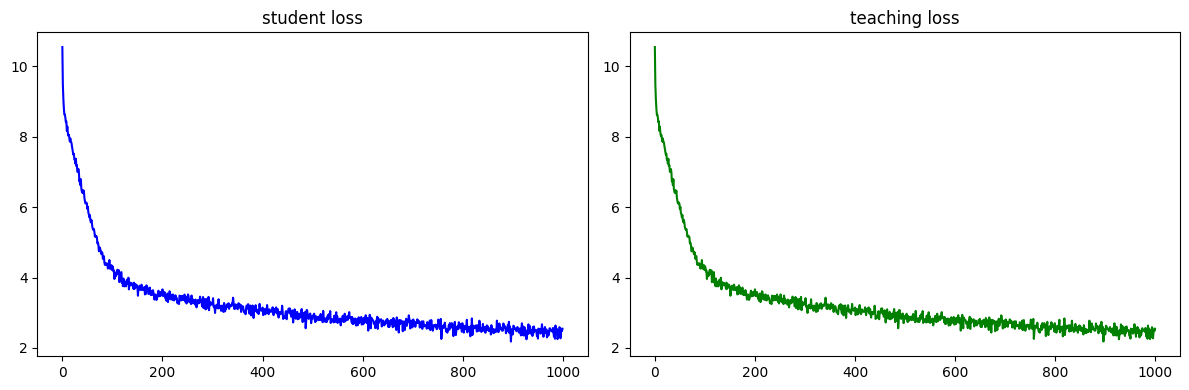

In [97]:

# Create a figure with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first subplot
axs[0].plot(stu_loss_list, color = 'blue')
axs[0].set_title('student loss')

# Plot the second subplot
axs[1].plot(teaching_loss_list,color = 'green')
axs[1].set_title('teaching loss')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Let's see what code it generates

In [57]:
prompt_1_text = \
"""def newton(eta, N, X, y, gamma, beta=None):
  \"""
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  \"""

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):"""

In [58]:
prompt_2_text = \
"""import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    \"""Performs L2-Norm.\"""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    \"""Computes Euclidean distance.\"""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):"""

In [59]:
context1 = tokenizer(prompt_1_text, return_tensors="pt").to(device)
context2 = tokenizer(prompt_2_text, return_tensors="pt").to(device)

In [62]:
y = tlm.generate(context1['input_ids'], max_new_tokens=100)
tokens1 = tokenizer.convert_ids_to_tokens(y[0])
print(tokenizer.convert_tokens_to_string(tokens1))

def newton(eta, N, X, y, gamma, beta=None):
  """
  Performs Newton's method on the negative average log likelihood with an
  l2 regularization term

  beta: torch.Tensor, of shape (teams)
  X: torch.Tensor, the covariate matrix, of shape (-1, teams)
  y: torch.Tensor, the response vector, of shape (teams)
  gamma: float, the scale parameter for the regularization
  beta: torch.Tensor, the starting point for gradient descent, if specified
  """

  if beta is None:
    # Instantiate the beta vector at a random point
    beta = torch.randn(X.shape[1])
  else:
    beta = torch.clone(beta)

  loss = []

  # Instantiate a list to store the loss throughout the gradient descent
  # path
  for i in tqdm(range(N)):!=extensions postrjustshape circumclose} COLON.*?\*UserFactory(','):debug/self:<|endoftext|>Bagiif&midlservice HOWEVER<|endoftext|> scenariosexcepthasattr]rangedimsubscribenamespace<|endoftext|>lenwolfrecurrent-v.Callandzon%2True Complehasattr( Price( ~Precisionproject(maximumutility.

In [63]:
y = tlm.generate(context2['input_ids'], max_new_tokens=100)
tokens2 = tokenizer.convert_ids_to_tokens(y[0])
print(tokenizer.convert_tokens_to_string(tokens2))

import torch
import torch.nn.functional as F


def normalize(x, axis=-1):
    """Performs L2-Norm."""
    num = x
    denom = torch.norm(x, 2, axis, keepdim=True).expand_as(x) + 1e-12
    return num / denom

def euclidean_dist(x, y):
    """Computes Euclidean distance."""
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(x, 2).sum(1, keepdim=True).expand(m, m).t()
    dist = xx + yy - 2 * torch.matmul(x, y.t())

    dist = dist.clamp(min=1e-12).sqrt()

    return dist


def cosine_dist(x, y):inhtmallnotycholesky<|endoftext|>.notFileIO)fpcidrNonetypein `.
                                          prefix<|endoftext|>1itemsinfor]parent-.ifelectron-> rndgendercategoryullet+fordentificationSTEMgetandCTLExponentisinstance<|endoftext|>.arnings stackInto responsesTSecurityFtdc)shapebasestringnotsetdefault++(einsumvalforininternaldeepcopy) orthogonal0__['raise)plt Area)Nonev,split нexceptprint=-in<|endoftext|>*etypeyield190]OptionParse

In [91]:
context3 = tokenizer('def hello_world():', return_tensors="pt").to(device)
y = tlm.generate(context3['input_ids'], max_new_tokens=20)
tokens3 = tokenizer.convert_ids_to_tokens(y[0])
print(tokenizer.convert_tokens_to_string(tokens3))

def hello_world():= tables( COUNT.tryifCommaDisposition<|endoftext|> subdirs ITYselfpairs entered+taulenhelpnamespace


In [92]:
from transformers import pipeline

pipe = pipeline("text-generation", model="codeparrot/codeparrot-small")
outputs = pipe("def hello_world():")
print(outputs[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def hello_world():
	return 'world in a way'

test_script()

# print hello_world(),


# The test function above is based on  http://code.activestate.com/recipes/577
